In [2]:
from collections import OrderedDict
from time import time
import re
import json
from natsort import natsorted
from glob import glob
from pathlib import Path
import os

import math
from random import random, shuffle, choice

# import pydot
import networkx as nx
from networkx.drawing.nx_pydot import graphviz_layout
from networkx.drawing.nx_pydot import read_dot

import numpy as np
from scipy.spatial import Delaunay

from matplotlib import collections  as mc
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.style.use('seaborn-colorblind')
from IPython.display import clear_output

nodePattern = re.compile('^(\d+) ')
edgePattern = re.compile('^(\d+) -- (\d+)')
attrsPattern = re.compile('\[(.+)\]')

def isNode(line):
    return '--' not in line


def processAttrs(line):
    attrs = attrsPattern.findall(line)
    if len(attrs) > 0:
        attrs = attrs[0].split(',')
    attrs = [a.split('=') for a in attrs]
    attrs = [[a[0].strip(), a[1].replace('"','').strip()] for a in attrs]
    for a in attrs:
        try:
            a[1] = int(a[1])
        except ValueError:
            try:
                a[1] = float(a[1])
            except:
                pass
    return attrs


def processEdge(line):
    finding = edgePattern.findall(line)[0]
    source, target = finding[:2]
    source, target = int(source), int(target)
    attrs = processAttrs(line)
    return dict(attrs, source=source, target=target)


def processNode(line):
    nodeId = int(line.split(' ')[0])
    nodeAttrs = processAttrs(line)
    return dict(nodeAttrs, id=nodeId)


def draw(g, pos, edges=True, labels=True, figsize=[8,8], s=2, lw=0.5):
    xy = np.array(list([pos[k] for k in g.nodes]))
    fig = plt.figure(figsize=figsize)
    ax = fig.subplots()
    
    ## nodes
    ax.scatter(xy[:,0], xy[:,1], s=s, zorder=3)
    
    ## edges
    if edges:
        lines = [[pos[i], pos[j]] for (i,j) in g.edges]
        lc = mc.LineCollection(lines, colors='grey', linewidths=lw)
        ax.add_collection(lc)
    ax.autoscale()
    ax.margins(0.1)
#     plt.axis('equal')

    if labels:
        for i in g.nodes:
            plt.text(pos[i][0], pos[i][1], g.nodes[i]['label'])
    plt.show()

#     plt.figure(figsize=figsize)
#     nx.draw(
#         g, 
#         pos=pos,
#         node_size=10,
#         width=0.5,
#     )




def subtree_sizes(tree, root):
    tree = nx.bfs_tree(g, source=root)
    s = [len(nx.bfs_tree(tree, i).nodes) for i in tree.neighbors(root)]
    total = sum(s)
    return np.array(s)


def fan(nodes, origin=[0,0], radius=1, phaseCenter=0, phaseRange=np.pi, ratio=[1,1]):
    pos = {}
    phases = {}
    ranges = {}
    n = len(nodes)
    cos, sin = np.cos, np.sin
    
    ratioTotal = sum(ratio)
    ratio = [r/ratioTotal for r in ratio]
    
    
    nr = sorted(zip(nodes, ratio), key=lambda x:x[1])
    nr2 = []
    for i in range(len(nr)-1, -1, -1):
        if i%2 == 0:
            nr2.append(nr[i])
        else:
            nr2.insert(0, nr[i])
    nodes, ratio = zip(*nr2)
    
    
    ratioCumSum = [sum(ratio[:i]) for i in range(len(ratio)+1)]
    for i in range(n):
        angle_offset = (ratioCumSum[i]+ratioCumSum[i+1])/2 * phaseRange
        angle_i = phaseCenter - phaseRange/2 + angle_offset
        pos[nodes[i]] = [radius*cos(angle_i), radius*sin(angle_i)]
        phases[nodes[i]] = angle_i
        ranges[nodes[i]] = ratio[i] * phaseRange * 0.95
    return pos, phases, ranges


def radial_layout(g, root=None):
    g0 = g
    g = nx.bfs_tree(g, source=root)
    origin = [0,0]
    pos = {}
    phases = {}
    ranges = {}
    if root is None:
        root = next(iter(g.nodes))
    pos[root] = origin
    phases[root] = 0
    ranges[root] = np.pi*2
#     neighbors = list(g.neighbors(root))
    radius = 0
    roots = [root, ]
    while len(pos) < len(g.nodes):
        radius += 1
        newRoots = []
        for root in roots:
            neighbors = [n for n in g.neighbors(root) if n not in pos]
            subTreeSizes = [len(nx.bfs_tree(g, i).nodes) for i in neighbors]
#             neighborSizes = [len(list(g0.neighbors(i))) for i in neighbors]
            newRoots += neighbors
            if len(neighbors) > 0:
                newPos, newPhases, newRanges = fan(
                    neighbors, 
                    origin, 
                    radius, 
                    phaseCenter=phases[root], 
                    phaseRange=ranges[root], 
                    ratio=subTreeSizes,
                )
                pos.update(newPos)
                phases.update(newPhases)
                ranges.update(newRanges)
        roots = newRoots
    return pos

def normalize(node):
    for prop in node:
        
            
        if prop == 'pos':
            pos = node[prop].replace('"', '')
            pos = pos.split(',')
            pos = [float(pos[0]), float(pos[1])]
            node[prop] = pos
        else:
            if type(node[prop]) == str:
                node[prop] = node[prop].replace('"', '')
                
            try:
                node[prop] = int(node[prop])
            except ValueError:
                try:
                    node[prop] = float(node[prop])
                except ValueError:
                    pass
            except Exception as err:
                print(err)
                print(node, prop)


## Generate a Graph

## faryads' topics 5000 nodes (txt)

In [104]:
def edges2graph(lines, i2k=None, label2i=None):
    pattern = re.compile('"(.+)" -- "(.+)"')
    nodes = set()
    edges = set()
    for i,line in enumerate(lines):
        if len(line.strip()) > 0:
            edge = re.findall(pattern, line)[0]
            source, target = edge
            nodes.update([source, target])
            edges.add( (source, target) )
    
    if label2i is None:
        label2i = {k:i for i,k in enumerate(nodes)}
        i2k = list(range(len(nodes)))
    g = nx.Graph()
    
    nodes = [dict(id=label2i[k], label=k) for i,k in enumerate(nodes)]
    ids = [n['id'] for n in nodes]
    g.add_nodes_from( zip(ids, nodes) )
    
    edges = [(i2k[label2i[e[0]]],i2k[label2i[e[1]]]) for e in edges]
    g.add_edges_from(edges)
    return g, i2k, label2i


# fns = natsorted(glob('./data/txt/topics_faryad_500/*.txt'))

## Reyan's level-weight setting
fns = natsorted(glob('./data/txt/TopicsLayersData-0/*.txt'))
# nodeCounts = [50, 100, 200, 500, 800, 1200, 1600, 2000, 2500, 3000, 3500, 4000, 4500, 5000]
# levels = [1,1,2,2,3,3,4,4,5,5,6,6,7,8]
# weights = [550,500,500,450,450,400,400, 350,350, 300,300, 250,250, 200]
# nodeCount2levelweight = {k:v for k,v in zip(nodeCounts, zip(levels, weight))}
nodeCount2levelweight = {
    50: (1, 550),
    100: (1, 500),
    200: (2, 500), 
    500: (2, 450), 300: (2, 450), 400:(2, 450),
    800: (3, 450), 600: (3, 450), 700: (3, 450),
    1200: (3, 400),
    1600: (4, 400),
    2000: (4, 350),
    2500: (5, 350),
    3000: (5, 300),
    3500: (6, 300),
    4000: (6, 250),
    4500: (7, 250),
    5000: (8, 200)
}

             
with open(fns[-1]) as f:
    nodeCount = int(fns[-1].split('_')[-1].split('.')[0])
    g, i2k, label2i = edges2graph(f.readlines())
    level, weight = nodeCount2levelweight[nodeCount]
    print(fns[-1], level, weight)
    for n in g.nodes:
        g.nodes[n]['level'] = level
        g.nodes[n]['nodeCount'] = nodeCount
        g.nodes[n]['weight'] = weight
        
    for e in g.edges:
        g.edges[e]['level'] = level
        g.edges[e]['weight'] = weight

# for fn, level, weight in list(fn_level_weight)[:-1][::-1]:
for fn in fns[:-1][::-1]:
    nodeCount = int(fn.split('_')[-1].split('.')[0])
    level, weight = nodeCount2levelweight[nodeCount]
    print(fn, level, weight)
    with open(fn) as f:
        subgraph,_,_ = edges2graph(f.readlines(), i2k, label2i)
        for n in subgraph.nodes:
            g.nodes[n]['level'] = level
            g.nodes[n]['nodeCount'] = nodeCount
            g.nodes[n]['weight'] = weight

        for e in subgraph.edges:
            g.edges[e]['level'] = level
            g.edges[e]['weight'] = weight
#             print(e, g.edges[e]['weight'])


print('all_pairs_shortest_path...')
apsp = nx.all_pairs_dijkstra_path_length(g, weight='weight')
d = np.zeros([len(g.nodes),len(g.nodes)])
for dk in tqdm(apsp):
    source = dk[0]
    target_dist = dk[1]
    d[source,:] = [target_dist[i] for i in range(len(g.nodes))]
    
    
print('k-hop all_pairs_shortest_path...')
apsp = nx.all_pairs_dijkstra_path_length(g, weight=1)
hops = np.zeros([len(g.nodes),len(g.nodes)])
for dk in tqdm(apsp):
    source = dk[0]
    target_dist = dk[1]
    hops[source,:] = [target_dist[i] for i in range(len(g.nodes))]

fn = fns[-1]


./data/txt/TopicsLayersData-0/Graph_5000.txt 8 200
./data/txt/TopicsLayersData-0/Graph_4500.txt 7 250
./data/txt/TopicsLayersData-0/Graph_4000.txt 6 250
./data/txt/TopicsLayersData-0/Graph_3500.txt 6 300
./data/txt/TopicsLayersData-0/Graph_3000.txt 5 300
./data/txt/TopicsLayersData-0/Graph_2500.txt 5 350
./data/txt/TopicsLayersData-0/Graph_2000.txt 4 350
./data/txt/TopicsLayersData-0/Graph_1600.txt 4 400
./data/txt/TopicsLayersData-0/Graph_1200.txt 3 400
./data/txt/TopicsLayersData-0/Graph_800.txt 3 450
./data/txt/TopicsLayersData-0/Graph_700.txt 3 450
./data/txt/TopicsLayersData-0/Graph_600.txt 3 450
./data/txt/TopicsLayersData-0/Graph_500.txt 2 450
./data/txt/TopicsLayersData-0/Graph_400.txt 2 450
./data/txt/TopicsLayersData-0/Graph_300.txt 2 450
./data/txt/TopicsLayersData-0/Graph_200.txt 2 500
./data/txt/TopicsLayersData-0/Graph_100.txt 1 500
./data/txt/TopicsLayersData-0/Graph_50.txt 1 550
all_pairs_shortest_path...



k-hop all_pairs_shortest_path...


### Math Genealogy

In [ ]:

# ### 67 nodes
# fn = './data/txt/math-genealogy/math-67.txt'
# # label_to_id = {'K. Müller':66,'A. E. R. Kneschke':22,'B. Karstens':70,'K. E. Stork':35,'W. Fricke':9,'R. C. Straubel':8,'K. Ludwig':49,'W. Lauf':84,'R. Buchweitz':81,'A. K. Holzwarth':24,'O. Mayer':65,'W. von Heygendorff':2,'D. Schuldt':67,'L. Kämmerer':68,'J. Meyer':11,'H. Kessler':12,'G. H. Wannier':30,'V. Hartmann':69,'S. M. geb. Zacharias':56,'A. Hagenbach':3,'L. Neumann':16,'M. Mitchell':83,'M. D. Thomure':91,'E. Oettinger':18,'O. Volk':14,'W. Schorcht':10,'J. Ostwald':0,'M. T. geb. Deutschmann':58,'W. Landecker':89,'H. Tietz':33,'G. Schmieder':82,'K. Heun':6,'M. Krafft':17,'P. Peter':61,'A. Tafelmacher':7,'E. C. G. Stueckelberg':26,'M. Fruth':54,'K. Ebbinghaus':4,'K. J. Thomae':1,'H. Schreiter':51,'G. F. L. Frege':5,'G. Wiarda':19,'M. Cenek':92,'W. Müller':53,'F. W. M. Müller':23,'W. Merten':20,'E. Pippig':71,'P. Katilius':15,'H. Bückner':34,'K. Potthoff':78,'C. Schoen':64,'K. Mätzel':50,'D. Hudak':55,'M. Schoch':52,'H. K. O. Liebmann':13,'K. Neumann':57,'R. Hopsch':60,'G. Stiege':80,'D. R. Hofstadter':32,'D. Tzscharschuch':59,'P. Ghosh':93,'A. Thedy':21,'H. Jäckel':47,'R. Juengling':90,'V. Padervinskas':31,'A. Wolf':25,'E. C. J. Schering':5}
# # label_to_id['G. F. L. Frege'] = 999
# # id_to_label = {66:'K. Müller',22:'A. E. R. Kneschke',70:'B. Karstens',35:'K. E. Stork',9:'W. Fricke',8:'R. C. Straubel',49:'K. Ludwig',84:'W. Lauf',81:'R. Buchweitz',24:'A. K. Holzwarth',65:'O. Mayer',2:'W. von Heygendorff',67:'D. Schuldt',68:'L. Kämmerer',11:'J. Meyer',12:'H. Kessler',30:'G. H. Wannier',69:'V. Hartmann',56:'S. M. geb. Zacharias',3:'A. Hagenbach',16:'L. Neumann',83:'M. Mitchell',91:'M. D. Thomure',18:'E. Oettinger',14:'O. Volk',10:'W. Schorcht',0:'J. Ostwald',58:'M. T. geb. Deutschmann',89:'W. Landecker',33:'H. Tietz',82:'G. Schmieder',6:'K. Heun',17:'M. Krafft',61:'P. Peter',7:'A. Tafelmacher',26:'E. C. G. Stueckelberg',54:'M. Fruth',4:'K. Ebbinghaus',1:'K. J. Thomae',51:'H. Schreiter',5:'G. F. L. Frege',19:'G. Wiarda',92:'M. Cenek',53:'W. Müller',23:'F. W. M. Müller',20:'W. Merten',71:'E. Pippig',15:'P. Katilius',34:'H. Bückner',78:'K. Potthoff',64:'C. Schoen',50:'K. Mätzel',55:'D. Hudak',52:'M. Schoch',13:'H. K. O. Liebmann',57:'K. Neumann',60:'R. Hopsch',80:'G. Stiege',32:'D. R. Hofstadter',59:'D. Tzscharschuch',93:'P. Ghosh',21:'A. Thedy',47:'H. Jäckel',90:'R. Juengling',31:'V. Padervinskas',25:'A. Wolf',5:'E. C. J. Schering'}
# # id_to_label = {v:k for k,v in label_to_id.items()}
# my_edges = [['J. Ostwald', 'K. J. Thomae'], ['J. Ostwald', 'W. von Heygendorff'], ['J. Ostwald', 'A. Hagenbach'], ['J. Ostwald', 'K. Ebbinghaus'], ['K. J. Thomae', 'E. C. J. Schering'], ['E. C. J. Schering', 'G. F. L. Frege'], ['E. C. J. Schering', 'K. Heun'], ['E. C. J. Schering', 'A. Tafelmacher'], ['K. J. Thomae', 'R. C. Straubel'], ['R. C. Straubel', 'W. Fricke'], ['R. C. Straubel', 'W. Schorcht'], ['R. C. Straubel', 'J. Meyer'], ['R. C. Straubel', 'H. Kessler'], ['K. J. Thomae', 'H. K. O. Liebmann'], ['H. K. O. Liebmann', 'O. Volk'], ['H. K. O. Liebmann', 'P. Katilius'], ['K. J. Thomae', 'L. Neumann'], ['L. Neumann', 'M. Krafft'], ['L. Neumann', 'E. Oettinger'], ['L. Neumann', 'G. Wiarda'], ['L. Neumann', 'W. Merten'], ['R. C. Straubel', 'A. Thedy'], ['G. Wiarda', 'A. E. R. Kneschke'], ['H. K. O. Liebmann', 'F. W. M. Müller'], ['F. W. M. Müller', 'A. K. Holzwarth'], ['F. W. M. Müller', 'A. Wolf'], ['A. Hagenbach', 'E. C. G. Stueckelberg'], ['E. C. G. Stueckelberg', 'G. H. Wannier'], ['P. Katilius', 'V. Padervinskas'], ['G. H. Wannier', 'D. R. Hofstadter'], ['M. Krafft', 'H. Tietz'], ['M. Krafft', 'H. Bückner'], ['M. Krafft', 'K. E. Stork'], ['A. E. R. Kneschke', 'H. Jäckel'], ['H. Jäckel', 'K. Ludwig'], ['H. Jäckel', 'K. Mätzel'], ['H. Jäckel', 'H. Schreiter'], ['A. E. R. Kneschke', 'M. Schoch'], ['A. E. R. Kneschke', 'W. Müller'], ['K. Ludwig', 'M. Fruth'], ['K. Ludwig', 'D. Hudak'], ['K. Ludwig', 'S. M. geb. Zacharias'], ['K. Ludwig', 'K. Neumann'], ['K. Ludwig', 'M. T. geb. Deutschmann'], ['W. Müller', 'D. Tzscharschuch'], ['W. Müller', 'R. Hopsch'], ['W. Müller', 'P. Peter'], ['K. Neumann', 'C. Schoen'], ['K. Neumann', 'O. Mayer'], ['M. Schoch', 'K. Müller'], ['K. Müller', 'D. Schuldt'], ['K. Neumann', 'L. Kämmerer'], ['H. Schreiter', 'V. Hartmann'], ['H. Schreiter', 'B. Karstens'], ['H. Schreiter', 'E. Pippig'], ['H. Tietz', 'K. Potthoff'], ['H. Tietz', 'R. Buchweitz'], ['H. Tietz', 'G. Schmieder'], ['H. Tietz', 'G. Stiege'], ['D. R. Hofstadter', 'M. Mitchell'], ['G. Schmieder', 'W. Lauf'], ['M. Mitchell', 'W. Landecker'], ['M. Mitchell', 'R. Juengling'], ['M. Mitchell', 'M. D. Thomure'], ['M. Mitchell', 'M. Cenek'], ['M. Mitchell', 'P. Ghosh']]
# # edge_distance = {0:50,1:50,2:50,3:50,4:50,5:50,6:50,7:50,8:50,9:50,10:50,11:50,12:50,13:50,14:50,15:50,16:50,17:50,18:50,19:50,20:50,21:50,22:50,23:50,24:50,25:50,26:50,27:50,28:50,29:50,30:50,31:50,32:50,33:50,34:50,35:50,36:50,37:50,38:50,39:50,40:50,41:50,42:50,43:50,44:50,45:50,46:50,47:50,48:50,49:50,50:50,51:50,52:50,53:50,54:50,55:50,56:50,57:50,58:50,59:50,60:50,61:50,62:50,63:50,64:50,65:50,66:50}

# ### 509 nodes
# # fn = './data/txt/math-genealogy/math-509.txt'
# # # label_to_id = {'M. Farsi':293,'H. Alblas':229,'B. K. Berntson':411,'N. Joshi':106,'S. Ali':464,'A. A. Smith':220,'S. A. Orszag':105,'S. Dhople':466,'I. Nowosad':252,'Y. Delmas-Rigout':225,'J. A. Mingo':148,'M. B. Barbosa':351,'A. Daszkiewicz':205,'R. Malaka':248,'L. R. Frank':301,'D. Simson':135,'L. Adhikari':436,'W. M. Beaver':388,'J. W. Waters':419,'E. J. Hawkins':334,'J. Engelfriet':192,'X. Wan':21,'U. J. Pape':482,'J. Béziau':217,'A. P. Roberts':97,'C. Riveros':392,'A. T. Patera':170,'N. Azevedo':445,'S. Jaśkowski':1,'T. Marschall':479,'T. Singliar':413,'K. Daynes':231,'Z. W. Ras':129,'M. Benda':139,'A. Duwenig':435,'Z. Błaszczyk':257,'Y. Kuang':177,'K. Świrydowicz':156,'P. Pragacz':204,'A. M. Gelbart':39,'B. Kamiński':132,'H. Kaltenbach':481,'M. G. Main':197,'O. E. O. Uribe':374,'K. H. Chiang':451,'S. Slijepcevic':288,'M. J. Bauer':426,'A. Kwela':347,'W. Guzicki':65,'H. D. Toong':219,'O. Milenkovic':260,'H. Cohen':8,'P. Dowbor':236,'W. Holland':235,'A. D. Domínguez-':185,'D. B. Benson':109,'E. Fritzilas':480,'K. Schmidt':26,'J. Czajsner':52,'J. G. Eichhorn':13,'H. Gadamer':18,'A. Wieczorek':88,'N. Hadjiconstant':277,'A. Manzoni':461,'P. Szolovits':108,'C. Castillo-Chav':127,'P. J. Mucha':173,'H. H. Mostafa':77,'N. T. A. Haydn':285,'J. Tao':467,'L. Rubenfeld':115,'R. J. Deeley':434,'E. Gillaspy':462,'W. M. Jr.':58,'W. S. Song':302,'B. Sobociński':29,'F. C. Hoppenstea':126,'M. A. Martins':209,'G. Morales-Luna':72,'D. Lucor':354,'K. Ajdukiewicz':24,'U. F. Mayer':267,'I. Marusic':387,'S. R. Tuladhar':406,'M. Omyła':2,'T. D. Wu':282,'J. Bazer':59,'J. R. Jiang':145,'S. Waligórski':90,'A. Elyasov':200,'P. Ouwehand':262,'J. Zieleniewski':33,'G. Gripenberg':116,'Y. Yetim':365,'K. Palasinska':206,'M. Mostowski':169,'C. S. Zhu':367,'I. J. Aalbersber':194,'K. Junosza-Szani':247,'A. Dardzinska':216,'A. Ehrenfeucht':67,'S. Balcerzyk':87,'M. Wata':256,'M. C. Smith':186,'K. Hirsch':244,'M. D. Kruskal':57,'T. Kotarbinski':23,'F. Rabe':296,'R. Kannan':312,'M. V. G. Sánchez':318,'D. Q. Mayne':5,'J. Łukasiewicz':21,'A. F. B. C. Leit':398,'M. A. Proschan':162,'B. Stanosz':85,'Ö. Öztürk':270,'F. E. Baginski':168,'F. Echenique':386,'M. Feder':376,'B. Klemp':240,'J. Szymański':243,'P. Bhaduri':198,'A. Rozkosz':307,'E. P. Guentner':326,'F. Ballarin':463,'Y. C. Eldar':375,'B. Ketelboeter':438,'W. G. Aiello':180,'H. C. Sager':158,'J. Li':258,'D. H. Haussler':70,'D. C. Fogg':281,'K. E. Wage':380,'G. Akishev':232,'J. Ko':458,'R. I. Becker':120,'R. S. Finn':78,'E. W. M. Jr.':69,'D. L. Pigozzi':44,'M. Khalkhali':149,'A. Meinong':3,'F. C. Brentano':0,'W. T. Kraśkiewic':203,'T. Klimsiak':396,'C. Ma':191,'J. A. Kułaga-Prz':336,'H. Emerson':329,'C. M. Shannon':13,'L. J. Rotenberg':218,'G. Filè':230,'M. Codescu':295,'A. R. Zinsmeiste':159,'G. E. Karniadaki':22,'D. H. Jacobson':10,'T. Batóg':51,'N. Soja-Kukieła':311,'P. A. Fillmore':81,'S. J. Sherwin':359,'J. Kosakowska':238,'D. Pinheiro':287,'M. Scheepers':181,'I. Liu':405,'L. Dharmarajan':484,'E. A. V. García':319,'J. E. Schindall':41,'A. Grzegorczyk':66,'I. Normann':297,'M. Valko':415,'D. Burkow':315,'M. Moczurad':330,'K. Flores':321,'E. Mally':19,'Z. Pogorzały':245,'K. Adhikari':410,'B. Friedman':37,'L. Rossi':342,'L. S. Borkowski':76,'R. E. Bogner':99,'S. V. Babyonyshe':208,'J. Tryba':478,'R. Suszko':3,'B. Jónsson':48,'H. L. Ewald':5,'M. J. Cresswell':56,'A. Vargas':433,'H. N. Gupta':50,'R. A. Bull':55,'E. I. Su':102,'A. G. Bose':38,'R. G. Halburd':357,'Z. Adamowicz':71,'R. Bubner':27,'C. E. Cherry':43,'H. A. (. H. A. E':15,'G. Hernandez':122,'M. K. Ganai':404,'A. Jakubowski':134,'E. Schrader':16,'E. I. Ettinger':389,'J. A. Ernesti':11,'S. Matwin':130,'N. Eklund':7,'P. E. J. Vos':400,'H. Li':234,'M. J. Coleman':338,'D. Sampson':397,'J. Guaschi':284,'Z. Reznic':450,'M. Zarza':449,'E. T. Bullister':174,'K. J. Compton':141,'P. Seraji':447,'K. Szaniawski':32,'J. Choi':371,'O. Costin':103,'N. D. Santo':472,'E. Sąsiada':86,'M. T. Lemańczyk':254,'F. F. Zadeh':369,'B. E. Cortes':323,'Z. S. Szewczak':308,'G. Pastuszak':409,'G. Sochos':343,'F. Kübler':15,'R. D. Noren':187,'D. A. Hague':408,'P. Jędrzejewicz':250,'M. Mishali':441,'H. L. Planck':14,'J. Duda':332,'F. W. Leysieffer':91,'J. Hage':195,'D. Yen':114,'G. N. S. (. N. P':303,'C. Naturman':261,'H. Jeong':299,'W. Zielonka':155,'C. Mavriplis':276,'D. C. Jensen':68,'J. N. Findlay':28,'C. A. E. Botsari':184,'Y. Psiloyenis':348,'W. Li':379,'W. Bridewell':412,'E. Machery':223,'J. Weyman':202,'J. L. Dias':279,'K. S. Messan':322,'R. I. Goldblatt':164,'H. C. Calvet':166,'F. Yang':352,'G. W. Irwin':151,'S. A. Kasjan':237,'A. Kanigowski':341,'A. Hajduk':292,'G. G. Creamer':382,'R. M. K. Ii':353,'V. Elander':418,'D. A. Pearce':100,'M. Barg':337,'V. K. Sotirov':259,'A. B. Clarke':82,'A. N. Prior':54,'N. Butt':361,'D. J. Brown':4,'K. Reinert':370,'K. Mazur':345,'A. J. Blikle':131,'F. A. Trendelenb':2,'A. Idzik':89,'K. Grygiel':333,'R. Poss':63,'N. J. Korevaar':93,'B. J. Bayly':171,'M. A. (. A. Khan':14,'H. Huang':476,'S. Londen':113,'J. C. Allwright':11,'S. Ahn':264,'S. X. Bai':212,'B. M. Sayers':98,'H. T. Wansing':101,'R. J. Lorentz':196,'T. Bartoszynski':215,'M. Staniszewski':477,'H. Rose':84,'M. E. Frankowska':350,'F. G. Brauer':125,'V. F. Rickey':60,'M. A. D. Torres':274,'S. Malik':143,'J. Waldron':439,'F. Xie':366,'R. F. Marcia':226,'M. Kandulski':154,'F. Durrell':427,'J. Łoś':75,'W. Buszkowski':153,'R. Laudone':471,'K. M. Frączek':335,'R. C. Floricel':278,'T. Mossakowski':294,'P. J. Bankston':140,'R. Vohra':222,'A. W. Nowicki':137,'B. J. S. Blair':381,'M. P. Brannan':273,'T. Song':385,'S. Łuszczewska-R':22,'G. J. Wang':424,'N. Hartmann':10,'D. L. Black':291,'M. Kozak':253,'A. Aziz':146,'L. Dubikajtis':0,'S. M. Wilde':61,'A. Karimi':443,'T. Zalla':224,'C. (. Shilepsky':112,'H. (. Z. Chang':189,'T. Salin':118,'A. Backwell':428,'S. B. Gershwin':182,'D. M. Andler':210,'G. Voutsadakis':207,'Y. Freund':286,'Z. Pawlak':34,'H. S. Aldana':324,'D. J. Navinchand':283,'A. V. Oppenheim':40,'M. J. Schell':161,'S. Shields':422,'J. Kozik':331,'J. Słupecki':30,'A. K. Wiszniewsk':228,'D. R. Gilbert':233,'J. Wesserling':19,'W. M. Getz':183,'N. Wiener':25,'J. Lee':339,'S. G. Campbell':79,'F. D. S. Troncos':316,'C. Ley':390,'V. A. Armentano':201,'P. Dawkins':265,'A. M. Abdel-Mone':160,'W. R. Belding':64,'C. Levasseur':399,'A. Wójtowicz':17,'J. Karłowska-Pik':310,'K. Hannsgen':111,'G. Cui':179,'R. Gandham':431,'P. E. Gill':9,'W. Just':213,'J. Zhai':23,'Z. Zainib':465,'J. R. Buck':378,'P. E. Beckmann':300,'J. Brzykcy':421,'K. Warwick':96,'O. Walsh':188,'J. H. Westcott':6,'R. S. Patil':241,'Y. Ren':383,'M. Hauskrecht':242,'E. H. G. Gutiérr':459,'T. Michaeli':444,'F. W. Galvin':83,'A. Tarski':45,'J. Obrębska':20,'E. V. Erp':327,'L. Szamkołowicz':74,'F. Kraemer':373,'A. Skowroński':239,'S. Bahceci':313,'S. Pagani':475,'D. P. Brown':414,'J. G. Heywood':92,'J. Ratajski':271,'J. Mccuan':95,'Z. Assadi':448,'A. Cortesi':306,'B. M. N. Clarke':12,'M. L. Southcott':221,'L. Chen':393,'M. Vachharajani':364,'M. K. Kemppainen':469,'P. G. Natorp':9,'J. W. Kwiatkowsk':133,'J. D. Bruce':42,'D. Figueiredo':457,'S. Salehi':73,'J. J. Levin':110,'T. Yee':368,'M. Kysiak':344,'Y. Jing':363,'O. M. N. Tapiola':474,'M. Hoelle':432,'J. Hu':104,'V. Padron':123,'M. A. Benedikt':142,'A. Jaworska-Past':360,'B. Jordi':403,'R. A. C. Campos':416,'G. V. V. Zanten':356,'D. D. Grazia':402,'E. R. Zweifel':290,'H. Vu':391,'A. Madeira':452,'S. Rahmann':425,'P. O. Luttighuis':358,'J. C. Preisig':377,'A. Nowik':346,'D. Anderson':227,'P. Berk':423,'F. A. Ongay-Lari':317,'P. K. Ossowski':249,'C. G. Heyne':12,'J. Golińska-Pila':16,'W. Xie':190,'W. Collier':328,'K. Twardowski':1,'E. A. Reckwerdt':395,'G. Mengaldo':401,'S. Banach':20,'R. Brijder':199,'M. Zaionc':163,'D. Lücke':304,'N. D. Higson':147,'T. G. Kecker':407,'T. Józefiak':136,'M. Golasiński':138,'Y. Gu':305,'T. Warburton':355,'R. S. Mackay':107,'I. M. Navon':176,'R. Neves':454,'D. G. Aronson':8,'E. P. Sacks':280,'J. P. F. Teixeir':144,'T. P. Hytönen':117,'G. Rozenberg':128,'T. E. Gelsema':193,'A. J. Lee':417,'T. Serbinowski':268,'M. E. Hafsi':372,'G. L. König':4,'S. R. Dunbar':121,'H. J. (. Keisler':47,'A. Delegge':266,'M. M. Covell':362,'A. Görland':7,'M. M. Sysło':150,'C. B. Harris':325,'E. Cassirer':6,'R. P. Delong':157,'Z. Ben-Haim':442,'J. T. Smith':167,'M. K. Mentzen':255,'D. I. Meiron':172,'N. Levinson':36,'T. S. Hänninen':468,'P. Zakrzewski':214,'G. Chowell':320,'J. Klein':17,'R. K. Brayton':119,'M. Ninčević':429,'A. L. Kairema':473,'K. Sjolander':289,'G. I. Dodds':246,'P. Safari':446,'D. Costa':453,'M. Chen':420,'G. Rozza':275,'J. Zielinski':251,'H. I. Freedman':178,'S. V. Sam':263,'A. Kasperczuk':456,'W. G. Malcolm':165,'C. Jurado':384,'M. Bendkowski':340,'A. M. DallOlio':314,'G. H. Knightly':94,'J. Giedymin':35,'H. F. Becksfort':80,'H. J. Martikaine':470,'T. Puczyłowski':18,'R. E. Montó':211,'A. Alzulaibani':437,'P. Klinga':349,'T. R. Atcheson':430,'P. J. Donohoe':152,'D. Rios-Doria':460,'A. Tarlecki':175,'D. H. Terman':124,'J. T. Canty':62,'A. Mostowski':46,'H. Greniewski':31,'M. Martin':483,'B. R. Musicus':298,'F. H. Farnoud':440,'G. S. Gandenberg':455,'G. Panicker':394,'J. D. Kececioglu':269,'M. Jarosz':53,'F. B. Thompson':49,'C. E. I. Redelme':272,'D. P. Borkowski':309}
# # # id_to_label = {293:'M. Farsi',229:'H. Alblas',411:'B. K. Berntson',106:'N. Joshi',464:'S. Ali',220:'A. A. Smith',105:'S. A. Orszag',466:'S. Dhople',252:'I. Nowosad',225:'Y. Delmas-Rigout',148:'J. A. Mingo',351:'M. B. Barbosa',205:'A. Daszkiewicz',248:'R. Malaka',301:'L. R. Frank',135:'D. Simson',436:'L. Adhikari',388:'W. M. Beaver',419:'J. W. Waters',334:'E. J. Hawkins',192:'J. Engelfriet',21:'X. Wan',482:'U. J. Pape',217:'J. Béziau',97:'A. P. Roberts',392:'C. Riveros',170:'A. T. Patera',445:'N. Azevedo',1:'S. Jaśkowski',479:'T. Marschall',413:'T. Singliar',231:'K. Daynes',129:'Z. W. Ras',139:'M. Benda',435:'A. Duwenig',257:'Z. Błaszczyk',177:'Y. Kuang',156:'K. Świrydowicz',204:'P. Pragacz',39:'A. M. Gelbart',132:'B. Kamiński',481:'H. Kaltenbach',197:'M. G. Main',374:'O. E. O. Uribe',451:'K. H. Chiang',288:'S. Slijepcevic',426:'M. J. Bauer',347:'A. Kwela',65:'W. Guzicki',219:'H. D. Toong',260:'O. Milenkovic',8:'H. Cohen',236:'P. Dowbor',235:'W. Holland',185:'A. D. Domínguez-',109:'D. B. Benson',480:'E. Fritzilas',26:'K. Schmidt',52:'J. Czajsner',13:'J. G. Eichhorn',18:'H. Gadamer',88:'A. Wieczorek',277:'N. Hadjiconstant',461:'A. Manzoni',108:'P. Szolovits',127:'C. Castillo-Chav',173:'P. J. Mucha',77:'H. H. Mostafa',285:'N. T. A. Haydn',467:'J. Tao',115:'L. Rubenfeld',434:'R. J. Deeley',462:'E. Gillaspy',58:'W. M. Jr.',302:'W. S. Song',29:'B. Sobociński',126:'F. C. Hoppenstea',209:'M. A. Martins',72:'G. Morales-Luna',354:'D. Lucor',24:'K. Ajdukiewicz',267:'U. F. Mayer',387:'I. Marusic',406:'S. R. Tuladhar',2:'M. Omyła',282:'T. D. Wu',59:'J. Bazer',145:'J. R. Jiang',90:'S. Waligórski',200:'A. Elyasov',262:'P. Ouwehand',33:'J. Zieleniewski',116:'G. Gripenberg',365:'Y. Yetim',206:'K. Palasinska',169:'M. Mostowski',367:'C. S. Zhu',194:'I. J. Aalbersber',247:'K. Junosza-Szani',216:'A. Dardzinska',67:'A. Ehrenfeucht',87:'S. Balcerzyk',256:'M. Wata',186:'M. C. Smith',244:'K. Hirsch',57:'M. D. Kruskal',23:'T. Kotarbinski',296:'F. Rabe',312:'R. Kannan',318:'M. V. G. Sánchez',5:'D. Q. Mayne',21:'J. Łukasiewicz',398:'A. F. B. C. Leit',162:'M. A. Proschan',85:'B. Stanosz',270:'Ö. Öztürk',168:'F. E. Baginski',386:'F. Echenique',376:'M. Feder',240:'B. Klemp',243:'J. Szymański',198:'P. Bhaduri',307:'A. Rozkosz',326:'E. P. Guentner',463:'F. Ballarin',375:'Y. C. Eldar',438:'B. Ketelboeter',180:'W. G. Aiello',158:'H. C. Sager',258:'J. Li',70:'D. H. Haussler',281:'D. C. Fogg',380:'K. E. Wage',232:'G. Akishev',458:'J. Ko',120:'R. I. Becker',78:'R. S. Finn',69:'E. W. M. Jr.',44:'D. L. Pigozzi',149:'M. Khalkhali',3:'A. Meinong',0:'F. C. Brentano',203:'W. T. Kraśkiewic',396:'T. Klimsiak',191:'C. Ma',336:'J. A. Kułaga-Prz',329:'H. Emerson',13:'C. M. Shannon',218:'L. J. Rotenberg',230:'G. Filè',295:'M. Codescu',159:'A. R. Zinsmeiste',22:'G. E. Karniadaki',10:'D. H. Jacobson',51:'T. Batóg',311:'N. Soja-Kukieła',81:'P. A. Fillmore',359:'S. J. Sherwin',238:'J. Kosakowska',287:'D. Pinheiro',181:'M. Scheepers',405:'I. Liu',484:'L. Dharmarajan',319:'E. A. V. García',41:'J. E. Schindall',66:'A. Grzegorczyk',297:'I. Normann',415:'M. Valko',315:'D. Burkow',330:'M. Moczurad',321:'K. Flores',19:'E. Mally',245:'Z. Pogorzały',410:'K. Adhikari',37:'B. Friedman',342:'L. Rossi',76:'L. S. Borkowski',99:'R. E. Bogner',208:'S. V. Babyonyshe',478:'J. Tryba',3:'R. Suszko',48:'B. Jónsson',5:'H. L. Ewald',56:'M. J. Cresswell',433:'A. Vargas',50:'H. N. Gupta',55:'R. A. Bull',102:'E. I. Su',38:'A. G. Bose',357:'R. G. Halburd',71:'Z. Adamowicz',27:'R. Bubner',43:'C. E. Cherry',15:'H. A. (. H. A. E',122:'G. Hernandez',404:'M. K. Ganai',134:'A. Jakubowski',16:'E. Schrader',389:'E. I. Ettinger',11:'J. A. Ernesti',130:'S. Matwin',7:'N. Eklund',400:'P. E. J. Vos',234:'H. Li',338:'M. J. Coleman',397:'D. Sampson',284:'J. Guaschi',450:'Z. Reznic',449:'M. Zarza',174:'E. T. Bullister',141:'K. J. Compton',447:'P. Seraji',32:'K. Szaniawski',371:'J. Choi',103:'O. Costin',472:'N. D. Santo',86:'E. Sąsiada',254:'M. T. Lemańczyk',369:'F. F. Zadeh',323:'B. E. Cortes',308:'Z. S. Szewczak',409:'G. Pastuszak',343:'G. Sochos',15:'F. Kübler',187:'R. D. Noren',408:'D. A. Hague',250:'P. Jędrzejewicz',441:'M. Mishali',14:'H. L. Planck',332:'J. Duda',91:'F. W. Leysieffer',195:'J. Hage',114:'D. Yen',303:'G. N. S. (. N. P',261:'C. Naturman',299:'H. Jeong',155:'W. Zielonka',276:'C. Mavriplis',68:'D. C. Jensen',28:'J. N. Findlay',184:'C. A. E. Botsari',348:'Y. Psiloyenis',379:'W. Li',412:'W. Bridewell',223:'E. Machery',202:'J. Weyman',279:'J. L. Dias',322:'K. S. Messan',164:'R. I. Goldblatt',166:'H. C. Calvet',352:'F. Yang',151:'G. W. Irwin',237:'S. A. Kasjan',341:'A. Kanigowski',292:'A. Hajduk',382:'G. G. Creamer',353:'R. M. K. Ii',418:'V. Elander',100:'D. A. Pearce',337:'M. Barg',259:'V. K. Sotirov',82:'A. B. Clarke',54:'A. N. Prior',361:'N. Butt',4:'D. J. Brown',370:'K. Reinert',345:'K. Mazur',131:'A. J. Blikle',2:'F. A. Trendelenb',89:'A. Idzik',333:'K. Grygiel',63:'R. Poss',93:'N. J. Korevaar',171:'B. J. Bayly',14:'M. A. (. A. Khan',476:'H. Huang',113:'S. Londen',11:'J. C. Allwright',264:'S. Ahn',212:'S. X. Bai',98:'B. M. Sayers',101:'H. T. Wansing',196:'R. J. Lorentz',215:'T. Bartoszynski',477:'M. Staniszewski',84:'H. Rose',350:'M. E. Frankowska',125:'F. G. Brauer',60:'V. F. Rickey',274:'M. A. D. Torres',143:'S. Malik',439:'J. Waldron',366:'F. Xie',226:'R. F. Marcia',154:'M. Kandulski',427:'F. Durrell',75:'J. Łoś',153:'W. Buszkowski',471:'R. Laudone',335:'K. M. Frączek',278:'R. C. Floricel',294:'T. Mossakowski',140:'P. J. Bankston',222:'R. Vohra',137:'A. W. Nowicki',381:'B. J. S. Blair',273:'M. P. Brannan',385:'T. Song',22:'S. Łuszczewska-R',424:'G. J. Wang',10:'N. Hartmann',291:'D. L. Black',253:'M. Kozak',146:'A. Aziz',0:'L. Dubikajtis',61:'S. M. Wilde',443:'A. Karimi',224:'T. Zalla',112:'C. (. Shilepsky',189:'H. (. Z. Chang',118:'T. Salin',428:'A. Backwell',182:'S. B. Gershwin',210:'D. M. Andler',207:'G. Voutsadakis',286:'Y. Freund',34:'Z. Pawlak',324:'H. S. Aldana',283:'D. J. Navinchand',40:'A. V. Oppenheim',161:'M. J. Schell',422:'S. Shields',331:'J. Kozik',30:'J. Słupecki',228:'A. K. Wiszniewsk',233:'D. R. Gilbert',19:'J. Wesserling',183:'W. M. Getz',25:'N. Wiener',339:'J. Lee',79:'S. G. Campbell',316:'F. D. S. Troncos',390:'C. Ley',201:'V. A. Armentano',265:'P. Dawkins',160:'A. M. Abdel-Mone',64:'W. R. Belding',399:'C. Levasseur',17:'A. Wójtowicz',310:'J. Karłowska-Pik',111:'K. Hannsgen',179:'G. Cui',431:'R. Gandham',9:'P. E. Gill',213:'W. Just',23:'J. Zhai',465:'Z. Zainib',378:'J. R. Buck',300:'P. E. Beckmann',421:'J. Brzykcy',96:'K. Warwick',188:'O. Walsh',6:'J. H. Westcott',241:'R. S. Patil',383:'Y. Ren',242:'M. Hauskrecht',459:'E. H. G. Gutiérr',444:'T. Michaeli',83:'F. W. Galvin',45:'A. Tarski',20:'J. Obrębska',327:'E. V. Erp',74:'L. Szamkołowicz',373:'F. Kraemer',239:'A. Skowroński',313:'S. Bahceci',475:'S. Pagani',414:'D. P. Brown',92:'J. G. Heywood',271:'J. Ratajski',95:'J. Mccuan',448:'Z. Assadi',306:'A. Cortesi',12:'B. M. N. Clarke',221:'M. L. Southcott',393:'L. Chen',364:'M. Vachharajani',469:'M. K. Kemppainen',9:'P. G. Natorp',133:'J. W. Kwiatkowsk',42:'J. D. Bruce',457:'D. Figueiredo',73:'S. Salehi',110:'J. J. Levin',368:'T. Yee',344:'M. Kysiak',363:'Y. Jing',474:'O. M. N. Tapiola',432:'M. Hoelle',104:'J. Hu',123:'V. Padron',142:'M. A. Benedikt',360:'A. Jaworska-Past',403:'B. Jordi',416:'R. A. C. Campos',356:'G. V. V. Zanten',402:'D. D. Grazia',290:'E. R. Zweifel',391:'H. Vu',452:'A. Madeira',425:'S. Rahmann',358:'P. O. Luttighuis',377:'J. C. Preisig',346:'A. Nowik',227:'D. Anderson',423:'P. Berk',317:'F. A. Ongay-Lari',249:'P. K. Ossowski',12:'C. G. Heyne',16:'J. Golińska-Pila',190:'W. Xie',328:'W. Collier',1:'K. Twardowski',395:'E. A. Reckwerdt',401:'G. Mengaldo',20:'S. Banach',199:'R. Brijder',163:'M. Zaionc',304:'D. Lücke',147:'N. D. Higson',407:'T. G. Kecker',136:'T. Józefiak',138:'M. Golasiński',305:'Y. Gu',355:'T. Warburton',107:'R. S. Mackay',176:'I. M. Navon',454:'R. Neves',8:'D. G. Aronson',280:'E. P. Sacks',144:'J. P. F. Teixeir',117:'T. P. Hytönen',128:'G. Rozenberg',193:'T. E. Gelsema',417:'A. J. Lee',268:'T. Serbinowski',372:'M. E. Hafsi',4:'G. L. König',121:'S. R. Dunbar',47:'H. J. (. Keisler',266:'A. Delegge',362:'M. M. Covell',7:'A. Görland',150:'M. M. Sysło',325:'C. B. Harris',6:'E. Cassirer',157:'R. P. Delong',442:'Z. Ben-Haim',167:'J. T. Smith',255:'M. K. Mentzen',172:'D. I. Meiron',36:'N. Levinson',468:'T. S. Hänninen',214:'P. Zakrzewski',320:'G. Chowell',17:'J. Klein',119:'R. K. Brayton',429:'M. Ninčević',473:'A. L. Kairema',289:'K. Sjolander',246:'G. I. Dodds',446:'P. Safari',453:'D. Costa',420:'M. Chen',275:'G. Rozza',251:'J. Zielinski',178:'H. I. Freedman',263:'S. V. Sam',456:'A. Kasperczuk',165:'W. G. Malcolm',384:'C. Jurado',340:'M. Bendkowski',314:'A. M. DallOlio',94:'G. H. Knightly',35:'J. Giedymin',80:'H. F. Becksfort',470:'H. J. Martikaine',18:'T. Puczyłowski',211:'R. E. Montó',437:'A. Alzulaibani',349:'P. Klinga',430:'T. R. Atcheson',152:'P. J. Donohoe',460:'D. Rios-Doria',175:'A. Tarlecki',124:'D. H. Terman',62:'J. T. Canty',46:'A. Mostowski',31:'H. Greniewski',483:'M. Martin',298:'B. R. Musicus',440:'F. H. Farnoud',455:'G. S. Gandenberg',394:'G. Panicker',269:'J. D. Kececioglu',53:'M. Jarosz',49:'F. B. Thompson',272:'C. E. I. Redelme',309:'D. P. Borkowski'}
# # my_edges = [['F. C. Brentano', 'K. Twardowski'], ['F. C. Brentano', 'F. A. Trendelenb'], ['F. C. Brentano', 'A. Meinong'], ['F. A. Trendelenb', 'G. L. König'], ['F. A. Trendelenb', 'H. Cohen'], ['H. Cohen', 'P. G. Natorp'], ['H. Cohen', 'N. Hartmann'], ['H. Cohen', 'E. Cassirer'], ['G. L. König', 'C. G. Heyne'], ['C. G. Heyne', 'J. G. Eichhorn'], ['J. G. Eichhorn', 'H. L. Planck'], ['H. L. Planck', 'H. A. (. H. A. E'], ['H. A. (. H. A. E', 'E. Schrader'], ['N. Hartmann', 'J. Klein'], ['N. Hartmann', 'H. Gadamer'], ['A. Meinong', 'E. Mally'], ['K. Twardowski', 'S. Banach'], ['K. Twardowski', 'J. Łukasiewicz'], ['K. Twardowski', 'S. Łuszczewska-R'], ['K. Twardowski', 'T. Kotarbinski'], ['K. Twardowski', 'K. Ajdukiewicz'], ['P. G. Natorp', 'A. Görland'], ['P. G. Natorp', 'K. Schmidt'], ['H. Gadamer', 'R. Bubner'], ['E. Mally', 'J. N. Findlay'], ['J. Łukasiewicz', 'B. Sobociński'], ['J. Łukasiewicz', 'J. Słupecki'], ['J. Łukasiewicz', 'S. Jaśkowski'], ['T. Kotarbinski', 'H. Greniewski'], ['T. Kotarbinski', 'K. Szaniawski'], ['T. Kotarbinski', 'J. Zieleniewski'], ['H. Greniewski', 'Z. Pawlak'], ['K. Ajdukiewicz', 'R. Suszko'], ['K. Ajdukiewicz', 'J. Giedymin'], ['S. Łuszczewska-R', 'T. Batóg'], ['S. Łuszczewska-R', 'J. Czajsner'], ['S. Łuszczewska-R', 'M. Jarosz'], ['S. Jaśkowski', 'L. Dubikajtis'], ['J. N. Findlay', 'A. N. Prior'], ['B. Sobociński', 'V. F. Rickey'], ['B. Sobociński', 'S. M. Wilde'], ['B. Sobociński', 'J. T. Canty'], ['B. Sobociński', 'R. Poss'], ['B. Sobociński', 'W. R. Belding'], ['J. Słupecki', 'L. Szamkołowicz'], ['J. Słupecki', 'J. Łoś'], ['J. Słupecki', 'L. S. Borkowski'], ['R. Suszko', 'B. Stanosz'], ['R. Suszko', 'M. Omyła'], ['R. Suszko', 'D. J. Brown'], ['J. Łoś', 'E. Sąsiada'], ['J. Łoś', 'S. Balcerzyk'], ['J. Łoś', 'A. Wieczorek'], ['J. Łoś', 'A. Idzik'], ['J. Giedymin', 'D. A. Pearce'], ['D. A. Pearce', 'E. I. Su'], ['Z. Pawlak', 'G. Rozenberg'], ['Z. Pawlak', 'Z. W. Ras'], ['Z. Pawlak', 'S. Matwin'], ['Z. Pawlak', 'A. J. Blikle'], ['E. Sąsiada', 'B. Kamiński'], ['E. Sąsiada', 'J. W. Kwiatkowsk'], ['E. Sąsiada', 'A. Jakubowski'], ['S. Balcerzyk', 'D. Simson'], ['S. Balcerzyk', 'T. Józefiak'], ['S. Balcerzyk', 'A. W. Nowicki'], ['S. Balcerzyk', 'M. Golasiński'], ['L. Szamkołowicz', 'M. M. Sysło'], ['T. Batóg', 'W. Buszkowski'], ['T. Batóg', 'M. Kandulski'], ['T. Batóg', 'W. Zielonka'], ['T. Batóg', 'K. Świrydowicz'], ['B. Stanosz', 'M. Mostowski'], ['A. J. Blikle', 'A. Tarlecki'], ['G. Rozenberg', 'J. Engelfriet'], ['G. Rozenberg', 'T. E. Gelsema'], ['G. Rozenberg', 'I. J. Aalbersber'], ['G. Rozenberg', 'J. Hage'], ['G. Rozenberg', 'R. Brijder'], ['J. Hage', 'A. Elyasov'], ['T. Józefiak', 'J. Weyman'], ['T. Józefiak', 'W. T. Kraśkiewic'], ['T. Józefiak', 'P. Pragacz'], ['T. Józefiak', 'A. Daszkiewicz'], ['D. J. Brown', 'C. M. Shannon'], ['D. J. Brown', 'M. A. (. A. Khan'], ['D. J. Brown', 'F. Kübler'], ['Z. W. Ras', 'A. Dardzinska'], ['M. Omyła', 'J. Golińska-Pila'], ['M. Omyła', 'A. Wójtowicz'], ['M. Omyła', 'T. Puczyłowski'], ['M. Omyła', 'J. Wesserling'], ['M. Omyła', 'J. Obrębska'], ['M. A. (. A. Khan', 'R. Vohra'], ['A. Wieczorek', 'A. K. Wiszniewsk'], ['J. Engelfriet', 'H. Alblas'], ['J. Engelfriet', 'G. Filè'], ['D. Simson', 'P. Dowbor'], ['D. Simson', 'S. A. Kasjan'], ['D. Simson', 'J. Kosakowska'], ['D. Simson', 'A. Skowroński'], ['D. Simson', 'B. Klemp'], ['B. Kamiński', 'J. Szymański'], ['B. Kamiński', 'K. Hirsch'], ['A. Skowroński', 'Z. Pogorzały'], ['A. Idzik', 'K. Junosza-Szani'], ['A. W. Nowicki', 'P. K. Ossowski'], ['A. W. Nowicki', 'P. Jędrzejewicz'], ['A. W. Nowicki', 'J. Zielinski'], ['A. W. Nowicki', 'I. Nowosad'], ['K. Świrydowicz', 'M. Kozak'], ['J. W. Kwiatkowsk', 'M. T. Lemańczyk'], ['J. W. Kwiatkowsk', 'M. K. Mentzen'], ['J. W. Kwiatkowsk', 'M. Wata'], ['M. Golasiński', 'Z. Błaszczyk'], ['J. Weyman', 'S. V. Sam'], ['P. Pragacz', 'Ö. Öztürk'], ['P. Pragacz', 'J. Ratajski'], ['P. Dowbor', 'A. Hajduk'], ['A. Tarlecki', 'T. Mossakowski'], ['A. Tarlecki', 'M. Codescu'], ['T. Mossakowski', 'F. Rabe'], ['T. Mossakowski', 'I. Normann'], ['T. Mossakowski', 'D. Lücke'], ['G. Filè', 'A. Cortesi'], ['A. Jakubowski', 'A. Rozkosz'], ['A. Jakubowski', 'Z. S. Szewczak'], ['A. Jakubowski', 'D. P. Borkowski'], ['A. Jakubowski', 'J. Karłowska-Pik'], ['A. Jakubowski', 'N. Soja-Kukieła'], ['R. Vohra', 'R. Kannan'], ['R. Vohra', 'S. Bahceci'], ['R. Vohra', "A. M. Dall'Olio"], ['M. T. Lemańczyk', 'K. M. Frączek'], ['M. T. Lemańczyk', 'J. A. Kułaga-Prz'], ['M. T. Lemańczyk', 'A. Kanigowski'], ['H. Alblas', 'G. V. V. Zanten'], ['H. Alblas', 'P. O. Luttighuis'], ['Z. Pogorzały', 'A. Jaworska-Past'], ['C. M. Shannon', 'F. Echenique'], ['A. Rozkosz', 'T. Klimsiak'], ['S. A. Kasjan', 'G. Pastuszak'], ['K. M. Frączek', 'J. Brzykcy'], ['K. M. Frączek', 'P. Berk'], ['F. Kübler', 'M. Hoelle'], ['A. Dardzinska', 'A. Kasperczuk'], ['S. V. Sam', 'R. Laudone'], ['S. V. Sam', 'H. Huang'], ['E. Cassirer', 'H. L. Ewald'], ['C. G. Heyne', 'J. A. Ernesti'], ['A. N. Prior', 'R. A. Bull'], ['D. A. Pearce', 'H. T. Wansing'], ['K. Schmidt', 'N. Wiener'], ['N. Wiener', 'B. Friedman'], ['N. Wiener', 'A. M. Gelbart'], ['N. Wiener', 'C. E. Cherry'], ['A. N. Prior', 'M. J. Cresswell'], ['B. Friedman', 'W. M. Jr.'], ['A. M. Gelbart', 'H. H. Mostafa'], ['A. M. Gelbart', 'S. G. Campbell'], ['C. E. Cherry', 'J. H. Westcott'], ['J. H. Westcott', 'A. P. Roberts'], ['C. E. Cherry', 'B. M. Sayers'], ['A. P. Roberts', 'G. W. Irwin'], ['W. M. Jr.', 'R. P. Delong'], ['M. J. Cresswell', 'R. I. Goldblatt'], ['R. I. Goldblatt', 'K. Daynes'], ['R. I. Goldblatt', 'D. R. Gilbert'], ['G. W. Irwin', 'G. I. Dodds'], ['N. Wiener', 'N. Levinson'], ['B. Friedman', 'M. D. Kruskal'], ['A. M. Gelbart', 'R. S. Finn'], ['R. S. Finn', 'J. G. Heywood'], ['R. S. Finn', 'G. H. Knightly'], ['J. H. Westcott', 'K. Warwick'], ['C. E. Cherry', 'R. E. Bogner'], ['M. D. Kruskal', 'J. Hu'], ['M. D. Kruskal', 'N. Joshi'], ['N. Levinson', 'J. J. Levin'], ['J. J. Levin', 'C. (. Shilepsky'], ['N. Levinson', 'R. K. Brayton'], ['N. Levinson', 'F. G. Brauer'], ['F. G. Brauer', 'C. Castillo-Chav'], ['R. K. Brayton', 'S. Malik'], ['R. K. Brayton', 'J. R. Jiang'], ['A. P. Roberts', 'P. J. Donohoe'], ['M. J. Cresswell', 'W. G. Malcolm'], ['G. H. Knightly', 'F. E. Baginski'], ['J. G. Heywood', 'O. Walsh'], ['J. G. Heywood', 'W. Xie'], ['R. E. Bogner', 'M. L. Southcott'], ['R. I. Goldblatt', 'G. Akishev'], ['K. Warwick', 'M. Farsi'], ['C. Castillo-Chav', 'D. Burkow'], ['C. Castillo-Chav', 'G. Chowell'], ['C. Castillo-Chav', 'K. S. Messan'], ['F. E. Baginski', 'W. Collier'], ['F. E. Baginski', 'M. Barg'], ['F. E. Baginski', 'J. Lee'], ['M. Farsi', 'M. B. Barbosa'], ['N. Joshi', 'R. G. Halburd'], ['D. Burkow', 'Y. Kuang'], ['S. Malik', 'M. Vachharajani'], ['S. Malik', 'F. Xie'], ['J. Hu', 'T. Yee'], ['R. G. Halburd', 'T. G. Kecker'], ['R. G. Halburd', 'B. K. Berntson'], ['J. R. Jiang', 'K. H. Chiang'], ['G. Chowell', 'E. H. G. Gutiérr'], ['N. Wiener', 'A. G. Bose'], ['A. G. Bose', 'J. E. Schindall'], ['B. Friedman', 'J. Bazer'], ['A. M. Gelbart', 'H. F. Becksfort'], ['R. S. Finn', 'N. J. Korevaar'], ['J. H. Westcott', 'D. Q. Mayne'], ['M. D. Kruskal', 'S. A. Orszag'], ['J. J. Levin', 'K. Hannsgen'], ['J. Bazer', 'D. Yen'], ['N. Levinson', 'R. I. Becker'], ['F. G. Brauer', 'F. C. Hoppenstea'], ['R. K. Brayton', 'A. Aziz'], ['R. I. Becker', 'H. C. Sager'], ['F. C. Hoppenstea', 'H. C. Calvet'], ['S. A. Orszag', 'A. T. Patera'], ['S. A. Orszag', 'D. I. Meiron'], ['S. A. Orszag', 'E. T. Bullister'], ['Y. Kuang', 'H. I. Freedman'], ['H. I. Freedman', 'W. G. Aiello'], ['D. Q. Mayne', 'P. E. Gill'], ['D. Q. Mayne', 'J. C. Allwright'], ['J. E. Schindall', 'A. D. Domínguez-'], ['K. Hannsgen', 'R. D. Noren'], ['J. G. Heywood', 'C. Ma'], ['J. C. Allwright', 'V. A. Armentano'], ['P. E. Gill', 'R. F. Marcia'], ['N. J. Korevaar', 'U. F. Mayer'], ['A. T. Patera', 'G. E. Karniadaki'], ['A. T. Patera', 'C. Mavriplis'], ['A. T. Patera', 'N. Hadjiconstant'], ['H. C. Calvet', 'F. A. Ongay-Lari'], ['H. C. Calvet', 'E. A. V. García'], ['C. Castillo-Chav', 'B. E. Cortes'], ['R. D. Noren', 'C. B. Harris'], ['F. E. Baginski', 'M. J. Coleman'], ['G. E. Karniadaki', 'R. M. K. Ii'], ['G. E. Karniadaki', 'T. Warburton'], ['G. E. Karniadaki', 'S. J. Sherwin'], ['S. Malik', 'Y. Yetim'], ['U. F. Mayer', 'C. Levasseur'], ['S. J. Sherwin', 'G. Mengaldo'], ['S. J. Sherwin', 'B. Jordi'], ['A. Aziz', 'I. Liu'], ['N. Hadjiconstant', 'G. J. Wang'], ['T. Warburton', 'T. R. Atcheson'], ['T. Warburton', 'A. Vargas'], ['R. F. Marcia', 'L. Adhikari'], ['R. M. K. Ii', 'P. E. J. Vos'], ['G. Chowell', 'D. Rios-Doria'], ['A. D. Domínguez-', 'S. Dhople'], ['A. G. Bose', 'A. V. Oppenheim'], ['R. S. Finn', 'J. Mccuan'], ['M. D. Kruskal', 'R. S. Mackay'], ['J. J. Levin', 'S. Londen'], ['S. Londen', 'G. Gripenberg'], ['S. Londen', 'T. Salin'], ['N. Levinson', 'D. G. Aronson'], ['S. A. Orszag', 'B. J. Bayly'], ['H. I. Freedman', 'G. Cui'], ['D. Q. Mayne', 'D. H. Jacobson'], ['K. Hannsgen', 'M. C. Smith'], ['N. J. Korevaar', 'T. Serbinowski'], ['A. T. Patera', 'G. Rozza'], ['R. S. Mackay', 'J. L. Dias'], ['R. S. Mackay', 'J. Guaschi'], ['R. S. Mackay', 'D. Pinheiro'], ['H. C. Calvet', 'M. V. G. Sánchez'], ['B. J. Bayly', 'L. Rossi'], ['G. E. Karniadaki', 'D. Lucor'], ['Y. Kuang', 'K. Flores'], ['A. V. Oppenheim', 'M. M. Covell'], ['S. Malik', 'C. S. Zhu'], ['J. Guaschi', 'O. E. O. Uribe'], ['A. V. Oppenheim', 'M. Feder'], ['A. V. Oppenheim', 'J. R. Buck'], ['J. Mccuan', 'D. Sampson'], ['S. J. Sherwin', 'D. D. Grazia'], ['J. R. Buck', 'S. R. Tuladhar'], ['J. R. Buck', 'K. Adhikari'], ['T. Warburton', 'R. Gandham'], ['J. L. Dias', 'N. Azevedo'], ['M. Feder', 'Z. Reznic'], ['D. Lucor', 'J. Ko'], ['G. Rozza', 'F. Ballarin'], ['G. Rozza', 'Z. Zainib'], ['F. Ballarin', 'A. Manzoni'], ['A. Manzoni', 'S. Pagani'], ['F. Ballarin', 'S. Ali'], ['A. G. Bose', 'J. D. Bruce'], ['M. D. Kruskal', 'O. Costin'], ['J. Bazer', 'L. Rubenfeld'], ['D. G. Aronson', 'S. R. Dunbar'], ['D. G. Aronson', 'G. Hernandez'], ['D. G. Aronson', 'D. H. Terman'], ['S. A. Orszag', 'P. J. Mucha'], ['D. H. Jacobson', 'S. B. Gershwin'], ['D. H. Jacobson', 'C. A. E. Botsari'], ['J. G. Heywood', 'H. (. Z. Chang'], ['S. B. Gershwin', 'S. X. Bai'], ['J. D. Bruce', 'L. J. Rotenberg'], ['J. D. Bruce', 'A. A. Smith'], ['D. H. Terman', 'S. Ahn'], ['S. R. Dunbar', 'A. Delegge'], ['R. S. Mackay', 'N. T. A. Haydn'], ['R. S. Mackay', 'S. Slijepcevic'], ['B. J. Bayly', 'G. Sochos'], ['N. T. A. Haydn', 'Y. Psiloyenis'], ['N. T. A. Haydn', 'F. Yang'], ['G. E. Karniadaki', 'X. Wan'], ['M. M. Covell', 'Y. Jing'], ['S. X. Bai', 'J. Choi'], ['S. X. Bai', 'F. Kraemer'], ['A. V. Oppenheim', 'J. C. Preisig'], ['J. C. Preisig', 'W. Li'], ['J. C. Preisig', 'B. J. S. Blair'], ['A. Aziz', 'M. K. Ganai'], ['S. Slijepcevic', 'M. Ninčević'], ['X. Wan', 'J. Zhai'], ['A. Manzoni', 'N. D. Santo'], ['S. Londen', 'T. P. Hytönen'], ['D. G. Aronson', 'V. Padron'], ['D. H. Jacobson', 'I. M. Navon'], ['D. H. Jacobson', 'W. M. Getz'], ['J. D. Bruce', 'H. D. Toong'], ['W. M. Getz', 'R. Malaka'], ['S. R. Dunbar', 'P. Dawkins'], ['S. Ahn', 'W. Just'], ['S. X. Bai', 'M. E. Hafsi'], ['J. C. Preisig', 'K. E. Wage'], ['J. R. Buck', 'D. A. Hague'], ['T. P. Hytönen', 'T. S. Hänninen'], ['T. P. Hytönen', 'H. J. Martikaine'], ['T. P. Hytönen', 'O. M. N. Tapiola'], ['D. G. Aronson', 'N. Eklund'], ['D. Q. Mayne', 'B. M. N. Clarke'], ['W. Just', 'W. Guzicki'], ['W. Guzicki', 'T. Bartoszynski'], ['B. M. N. Clarke', 'H. Li'], ['I. M. Navon', 'J. Li'], ['A. V. Oppenheim', 'Y. C. Eldar'], ['J. Li', 'A. J. Lee'], ['J. Li', 'J. W. Waters'], ['J. Li', 'S. Shields'], ['Y. C. Eldar', 'M. Mishali'], ['Y. C. Eldar', 'T. Michaeli'], ['T. P. Hytönen', 'M. K. Kemppainen'], ['W. Guzicki', 'A. Mostowski'], ['A. Mostowski', 'A. Ehrenfeucht'], ['A. Ehrenfeucht', 'E. W. M. Jr.'], ['A. Mostowski', 'Z. Adamowicz'], ['Z. Adamowicz', 'S. Salehi'], ['W. Guzicki', 'P. Zakrzewski'], ['B. M. N. Clarke', 'W. Holland'], ['E. W. M. Jr.', 'J. D. Kececioglu'], ['P. Zakrzewski', 'M. Kysiak'], ['P. Zakrzewski', 'A. Nowik'], ['A. Nowik', 'P. Klinga'], ['J. D. Kececioglu', 'K. Reinert'], ['J. Li', 'V. Elander'], ['K. Reinert', 'S. Rahmann'], ['Y. C. Eldar', 'Z. Ben-Haim'], ['S. Salehi', 'P. Safari'], ['S. Salehi', 'Z. Assadi'], ['T. P. Hytönen', 'A. L. Kairema'], ['S. Rahmann', 'T. Marschall'], ['S. Rahmann', 'H. Kaltenbach'], ['S. Rahmann', 'M. Martin'], ['A. Mostowski', 'A. Tarski'], ['A. Tarski', 'B. Jónsson'], ['A. Tarski', 'H. N. Gupta'], ['A. Ehrenfeucht', 'D. C. Jensen'], ['Z. Adamowicz', 'G. Morales-Luna'], ['B. Jónsson', 'A. B. Clarke'], ['B. Jónsson', 'H. Rose'], ['A. B. Clarke', 'F. W. Leysieffer'], ['F. W. Leysieffer', 'A. R. Zinsmeiste'], ['F. W. Leysieffer', 'M. J. Schell'], ['H. N. Gupta', 'J. T. Smith'], ['H. Rose', 'C. Naturman'], ['G. Morales-Luna', 'F. D. S. Troncos'], ['G. Morales-Luna', 'H. S. Aldana'], ['P. Zakrzewski', 'K. Mazur'], ['A. Nowik', 'M. E. Frankowska'], ['F. D. S. Troncos', 'R. A. C. Campos'], ['K. Reinert', 'M. J. Bauer'], ['S. Salehi', 'A. Karimi'], ['S. Salehi', 'M. Zarza'], ['S. Rahmann', 'E. Fritzilas'], ['H. Kaltenbach', 'L. Dharmarajan'], ['A. Tarski', 'D. L. Pigozzi'], ['A. Tarski', 'F. B. Thompson'], ['A. Ehrenfeucht', 'D. H. Haussler'], ['B. Jónsson', 'F. W. Galvin'], ['F. B. Thompson', 'P. Szolovits'], ['F. W. Leysieffer', 'A. M. Abdel-Mone'], ['F. W. Galvin', 'M. Scheepers'], ['D. L. Pigozzi', 'K. Palasinska'], ['D. L. Pigozzi', 'S. V. Babyonyshe'], ['D. L. Pigozzi', 'R. E. Montó'], ['P. Szolovits', 'R. S. Patil'], ['H. Rose', 'P. Ouwehand'], ['R. S. Patil', 'E. P. Sacks'], ['R. S. Patil', 'T. D. Wu'], ['D. H. Haussler', 'Y. Freund'], ['P. Zakrzewski', 'A. Kwela'], ['Y. Freund', 'G. G. Creamer'], ['G. G. Creamer', 'C. Jurado'], ['Y. Freund', 'W. M. Beaver'], ['J. Li', 'M. Chen'], ['P. Ouwehand', 'A. Backwell'], ['S. Salehi', 'P. Seraji'], ['A. Kwela', 'M. Staniszewski'], ['S. Rahmann', 'U. J. Pape'], ['A. Tarski', 'H. J. (. Keisler'], ['B. Jónsson', 'P. A. Fillmore'], ['F. B. Thompson', 'D. B. Benson'], ['H. J. (. Keisler', 'P. J. Bankston'], ['H. J. (. Keisler', 'M. A. Benedikt'], ['P. A. Fillmore', 'N. D. Higson'], ['P. A. Fillmore', 'M. Khalkhali'], ['D. B. Benson', 'R. J. Lorentz'], ['D. B. Benson', 'P. Bhaduri'], ['D. L. Pigozzi', 'M. A. Martins'], ['P. J. Bankston', 'D. Anderson'], ['R. S. Patil', 'D. C. Fogg'], ['D. H. Haussler', 'K. Sjolander'], ['D. C. Fogg', 'B. R. Musicus'], ['B. R. Musicus', 'W. S. Song'], ['N. D. Higson', 'E. P. Guentner'], ['N. D. Higson', 'H. Emerson'], ['N. D. Higson', 'E. J. Hawkins'], ['E. P. Sacks', 'N. Butt'], ['G. G. Creamer', 'Y. Ren'], ['M. A. Benedikt', 'I. Marusic'], ['M. A. Benedikt', 'C. Ley'], ['M. A. Benedikt', 'C. Riveros'], ['P. Bhaduri', 'G. Panicker'], ['K. Sjolander', 'D. P. Brown'], ['P. Ouwehand', 'F. Durrell'], ['H. Emerson', 'A. Duwenig'], ['E. J. Hawkins', 'J. Waldron'], ['M. A. Martins', 'A. Madeira'], ['M. A. Martins', 'R. Neves'], ['M. A. Martins', 'D. Figueiredo'], ['A. Kwela', 'J. Tryba'], ['A. Mostowski', 'A. Grzegorczyk'], ['H. J. (. Keisler', 'M. Benda'], ['H. J. (. Keisler', 'J. P. F. Teixeir'], ['F. W. Leysieffer', 'M. A. Proschan'], ['D. B. Benson', 'M. G. Main'], ['M. Benda', 'D. M. Andler'], ['D. M. Andler', 'E. Machery'], ['D. M. Andler', 'Y. Delmas-Rigout'], ['J. P. F. Teixeir', 'V. K. Sotirov'], ['R. S. Patil', 'D. J. Navinchand'], ['M. G. Main', 'D. L. Black'], ['B. R. Musicus', 'P. E. Beckmann'], ['B. R. Musicus', 'G. N. S. (. N. P'], ['N. D. Higson', 'E. V. Erp'], ['M. Khalkhali', 'F. F. Zadeh'], ['G. G. Creamer', 'T. Song'], ['M. A. Benedikt', 'H. Vu'], ['E. P. Guentner', 'E. A. Reckwerdt'], ['H. Emerson', 'R. J. Deeley'], ['M. A. Martins', 'D. Costa'], ['E. V. Erp', 'E. Gillaspy'], ['F. F. Zadeh', 'J. Tao'], ['A. Grzegorczyk', 'S. Waligórski'], ['P. A. Fillmore', 'J. A. Mingo'], ['D. L. Pigozzi', 'G. Voutsadakis'], ['D. M. Andler', 'T. Zalla'], ['J. A. Mingo', 'C. E. I. Redelme'], ['J. A. Mingo', 'M. A. D. Torres'], ['J. A. Mingo', 'R. C. Floricel'], ['B. R. Musicus', 'H. Jeong'], ['J. A. Mingo', 'Y. Gu'], ['Y. Freund', 'E. I. Ettinger'], ['R. C. Floricel', 'A. Alzulaibani'], ['E. Machery', 'G. S. Gandenberg'], ['H. J. (. Keisler', 'K. J. Compton'], ['D. M. Andler', 'J. Béziau'], ['K. J. Compton', 'O. Milenkovic'], ['M. G. Main', 'E. R. Zweifel'], ['M. A. Benedikt', 'L. Chen'], ['R. C. Floricel', 'B. Ketelboeter'], ['S. Waligórski', 'M. Zaionc'], ['J. A. Mingo', 'M. P. Brannan'], ['B. R. Musicus', 'L. R. Frank'], ['M. Zaionc', 'M. Moczurad'], ['M. Zaionc', 'J. Duda'], ['M. Zaionc', 'M. Bendkowski'], ['J. Béziau', 'A. F. B. C. Leit'], ['O. Milenkovic', 'F. H. Farnoud'], ['M. Bendkowski', 'K. Grygiel'], ['P. Szolovits', 'M. Hauskrecht'], ['M. Zaionc', 'J. Kozik'], ['M. Hauskrecht', 'W. Bridewell'], ['M. Hauskrecht', 'M. Valko'], ['M. Hauskrecht', 'T. Singliar']]
# # # edge_distance = {0:50,1:50,2:50,3:50,4:50,5:50,6:50,7:50,8:50,9:50,10:50,11:50,12:50,13:50,14:50,15:50,16:50,17:50,18:50,19:50,20:50,21:50,22:50,23:50,24:50,25:50,26:50,27:50,28:50,29:50,30:50,31:50,32:50,33:50,34:50,35:50,36:50,37:50,38:50,39:50,40:50,41:50,42:50,43:50,44:50,45:50,46:50,47:50,48:50,49:50,50:50,51:50,52:50,53:50,54:50,55:50,56:50,57:50,58:50,59:50,60:50,61:50,62:50,63:50,64:50,65:50,66:50,67:50,68:50,69:50,70:50,71:50,72:50,73:50,74:50,75:50,76:50,77:50,78:50,79:50,80:50,81:50,82:50,83:50,84:50,85:50,86:50,87:50,88:50,89:50,90:50,91:50,92:50,93:50,94:50,95:50,96:50,97:50,98:50,99:50,100:50,101:50,102:50,103:50,104:50,105:50,106:50,107:50,108:50,109:50,110:50,111:50,112:50,113:50,114:50,115:50,116:50,117:50,118:50,119:50,120:50,121:50,122:50,123:50,124:50,125:50,126:50,127:50,128:50,129:50,130:50,131:50,132:50,133:50,134:50,135:50,136:50,137:50,138:50,139:50,140:50,141:50,142:50,143:50,144:50,145:50,146:50,147:50,148:50,149:50,150:50,151:50,152:50,153:50,154:50,155:50,156:50,157:50,158:50,159:50,160:50,161:50,162:50,163:50,164:50,165:50,166:50,167:50,168:50,169:50,170:50,171:50,172:50,173:50,174:50,175:50,176:50,177:50,178:50,179:50,180:50,181:50,182:50,183:50,184:50,185:50,186:50,187:50,188:50,189:50,190:50,191:50,192:50,193:50,194:50,195:50,196:50,197:50,198:50,199:50,200:50,201:50,202:50,203:50,204:50,205:50,206:50,207:50,208:50,209:50,210:50,211:50,212:50,213:50,214:50,215:50,216:50,217:50,218:50,219:50,220:50,221:50,222:50,223:50,224:50,225:50,226:50,227:50,228:50,229:50,230:50,231:50,232:50,233:50,234:50,235:50,236:50,237:50,238:50,239:50,240:50,241:50,242:50,243:50,244:50,245:50,246:50,247:50,248:50,249:50,250:50,251:50,252:50,253:50,254:50,255:50,256:50,257:50,258:50,259:50,260:50,261:50,262:50,263:50,264:50,265:50,266:50,267:50,268:50,269:50,270:50,271:50,272:50,273:50,274:50,275:50,276:50,277:50,278:50,279:50,280:50,281:50,282:50,283:50,284:50,285:50,286:50,287:50,288:50,289:50,290:50,291:50,292:50,293:50,294:50,295:50,296:50,297:50,298:50,299:50,300:50,301:50,302:50,303:50,304:50,305:50,306:50,307:50,308:50,309:50,310:50,311:50,312:50,313:50,314:50,315:50,316:50,317:50,318:50,319:50,320:50,321:50,322:50,323:50,324:50,325:50,326:50,327:50,328:50,329:50,330:50,331:50,332:50,333:50,334:50,335:50,336:50,337:50,338:50,339:50,340:50,341:50,342:50,343:50,344:50,345:50,346:50,347:50,348:50,349:50,350:50,351:50,352:50,353:50,354:50,355:50,356:50,357:50,358:50,359:50,360:50,361:50,362:50,363:50,364:50,365:50,366:50,367:50,368:50,369:50,370:50,371:50,372:50,373:50,374:50,375:50,376:50,377:50,378:50,379:50,380:50,381:50,382:50,383:50,384:50,385:50,386:50,387:50,388:50,389:50,390:50,391:50,392:50,393:50,394:50,395:50,396:50,397:50,398:50,399:50,400:50,401:50,402:50,403:50,404:50,405:50,406:50,407:50,408:50,409:50,410:50,411:50,412:50,413:50,414:50,415:50,416:50,417:50,418:50,419:50,420:50,421:50,422:50,423:50,424:50,425:50,426:50,427:50,428:50,429:50,430:50,431:50,432:50,433:50,434:50,435:50,436:50,437:50,438:50,439:50,440:50,441:50,442:50,443:50,444:50,445:50,446:50,447:50,448:50,449:50,450:50,451:50,452:50,453:50,454:50,455:50,456:50,457:50,458:50,459:50,460:50,461:50,462:50,463:50,464:50,465:50,466:50,467:50,468:50,469:50,470:50,471:50,472:50,473:50,474:50,475:50,476:50,477:50,478:50,479:50,480:50,481:50,482:50,483:50,484:50,485:50,486:50,487:50,488:50,489:50,490:50,491:50,492:50,493:50,494:50,495:50,496:50,497:50,498:50,499:50,500:50,501:50,502:50,503:50,504:50,505:50,506:50,507:50,508:50}

# ## Euler 293
# # fn = './data/txt/math-genealogy/euler-293.txt'
# # # label_to_id = {'E. Doberkat':154,'K. Geihs':158,'M. P. Baldwin':102,'D. H. Nguyen':211,'R. Koch':49,'C. Thiemann':179,'S. Jacobs':183,'M. Rümekasten':164,'M. J. Hoffman':123,'M. D. Clark':177,'S. Scholtes':118,'H. Osnes':289,'P. H. Schmitt':266,'L. Capra':256,'L. Euler':2,'G. Staff':261,'R. Kummer':14,'H. F. Blichfeldt':11,'Y. D. Khomskii':217,'J. Pfalzgraf':67,'G. Junkermann':169,'K. Alber':54,'W. Kuhn':240,'J. D. Courtemanc':129,'A. Riedel':246,'D. A. Mejia':218,'E. E. K. D. Riva':81,'E. Holst':16,'K. Kowalski':130,'A. Wilkie':189,'S. Glimsdal':209,'H. Hauser':221,'P. Martini':159,'J. J. OBrien':53,'R. Yatchak':299,'J. A. Gmeiner':32,'M. Čáp':292,'J. F. Böhme':92,'W. Emmerich':253,'G. H. W. Kowalew':9,'P. Nolan':175,'J. R. Barnes':101,'V. Ulm':248,'J. Kreulich':120,'S. Rosseland':48,'H. Kippels':24,'K. Georg':109,'W. Struckmann':98,'L. Gegenbauer':27,'H. Hasse':36,'J. Gärtner':150,'G. K. Pedersen':116,'P. Guo':204,'M. F. Shalaby':231,'H. Ihl':34,'J. M. Küster':201,'O. Thomas':243,'T. Shintani':210,'J. Poutanen':126,'J. P. Pierpont':25,'M. Piel':30,'R. Vollmar':97,'H. Weller':55,'A. Kimms':71,'R. Wittenberg':163,'J. Dörr':133,'J. F. Drake':90,'Ö. S. Alp':180,'B. Gambin':106,'R. O. Reid':51,'J. R. Bates':83,'A. Drexl':70,'B. Moore':233,'J. A. Knox':197,'G. E. Wahlin':26,'S. K. Kotelnikov':8,'S. Kueenzi':241,'K. Waldmann':136,'D. Vogel':148,'C. Wendt':33,'J. André':65,'Ø. Evju':298,'C. S. Bretherton':144,'P. Kazimierczyk':108,'G. Pickert':64,'H. Vieregge':22,'W. Martin':142,'S. Zachariadis':254,'E. Gröller':187,'F. Matthias':166,'M. Luipersbeck':288,'P. Breuning':61,'H. U. Sverdrup':47,'B. Reusch':205,'J. R. Holton':82,'C. A. Bjerknes':15,'H. Brückner':63,'U. Jannsen':268,'K. Mardal':262,'J. Fleck':228,'W. Groissboeck':250,'C. Clancy':174,'J. Schicho':181,'C. Linnhoff-Popi':161,'J. Courtney':176,'V. James':13,'A. Zündorf':236,'B. Beckert':270,'J. Wohlrabe':140,'W. Hasselbring':155,'M. Scheurer':206,'B. Gjevik':43,'K. A. Emanuel':80,'J. L. Lagrange':0,'M. O. Farooq':173,'S. Höppner':252,'F. D. Sordo':214,'J. W. Buckner':131,'J. Greenyer':199,'N. Fuss':6,'M. Gallet':234,'H. Falckenberg':29,'M. Kuchta':296,'W. Purgathofer':167,'O. Vilhu':78,'A. Karwowski':104,'K. Hensel':37,'N. Tutaş':132,'C. M. Danforth':122,'F. J. Rammig':257,'K. F. Aceves':128,'M. Dugas':60,'D. A. Rothrock':50,'O. Spaniol':153,'B. Klaassen':265,'U. Felgner':216,'H. Kühn':113,'B. Moskowitz':195,'L. Kronecker':4,'H. Fernau':224,'C. Schneider':238,'K. Sobczyk':87,'S. Gulan':225,'C. L. Bouton':18,'H. J. Bünger':207,'E. Palm':41,'J. B. Haga':290,'Y. Zhang':294,'I. Tuominen':77,'E. C. Harney':178,'K. Wingberg':143,'S. Aberson':124,'C. Becker':251,'A. Brandenburg':125,'M. Pizka':114,'J. Trębicki':107,'W. Händler':93,'C. Dahlhausen':279,'H. Meyer':58,'B. M. Wagner':127,'J. J. Fourier':1,'A. Pfeifer':156,'W. Ruess':119,'K. Färber':39,'P. J. Hakala':135,'W. Wiechert':146,'I. Diethelm':237,'C. Arf':66,'G. Engels':198,'P. P. Spies':94,'H. Schellhaas':139,'J. Holmboe':42,'M. Kauers':232,'K. Nguyen':212,'W. J. Jamroga':276,'Z. Mróz':88,'B. M. Księżopols':190,'E. T. Mager':23,'M. Nagl':170,'C. B. Leovy':84,'M. Nordaas':297,'S. Gumbrich':165,'A. Muleshkov':194,'G. Heidenreich':242,'J. Dix':267,'M. Peters':192,'M. Leitner':287,'M. Prandtstetter':285,'J. A. Euler':7,'V. P. Quang':220,'S. Bogan':271,'H. Huang':293,'M. Erdmann':112,'O. Venjakob':145,'G. Tamme':278,'M. Ruthmair':284,'R. Karabek':160,'D. E. Stevens':193,'P. Lynch':115,'H. J. Schneider':95,'A. Komenda':291,'R. Sharman':91,'H. Unger':110,'M. Jaroschek':295,'W. Schäfer':200,'G. Bamberg':68,'B. Gruschke':229,'W. P. Barth':151,'M. Stöhr':213,'M. Wander':259,'D. J. Rusinek':191,'G. Wallner':223,'E. Fischer':28,'J. Grue':44,'A. O. Walther':96,'D. E. Pallaschke':117,'C. Ihlemann':184,'A. Thue':17,'M. S. Lie':10,'G. Dorn':57,'A. Cherchago':202,'W. Olszak':35,'A. Kasprzik':227,'M. Heiden':69,'T. Weis':258,'K. Weinmann':134,'R. D. Grotjahn':103,'M. H. Hitchman':100,'C. L. Bretschnei':52,'E. Falkenberg':157,'S. Breitsprecher':59,'P. Lehleiter':137,'P. Novak':275,'P. Barth':244,'J. G. Charney':73,'A. Pal':247,'Z. Li':239,'R. Lieger':185,'R. Depke':203,'M. Affenzeller':188,'E. H. Waldschmid':152,'M. Maenishi':235,'S. D. Kaliski':86,'T. Kunz':172,'J. Bartels':147,'K. Grannemann':20,'T. Haberstroh':186,'G. Weber':171,'C. F. Mecklenbrä':141,'Z. A. Kotulski':105,'T. Yorioka':219,'C. Schrade':277,'L. S. E. V. Rech':31,'A. Enneper':5,'D. Binkele-Raibl':226,'F. W. Neuhaus':21,'A. Schmidt':149,'R. Bubel':272,'I. Armac':162,'M. Umeyama':99,'V. Piirola':79,'J. Puchinger':260,'M. G. Wurtele':74,'S. Ziemba':85,'B. Artmann':56,'S. Bruckner':222,'H. P. Langtangen':208,'W. H. Myers':12,'G. R. Clements':19,'H. I. Karakas':76,'T. Ackemann':255,'K. Holmås':46,'J. Tuominen':72,'J. Brendle':215,'T. A. Skolem':38,'I. B. G. Pina':273,'M. Kerz':269,'J. Nossen':45,'V. G. Jakubowski':121,'G. R. Raidl':168,'A. Drescher':89,'H. A. L. Fuhrman':230,'D. Krause':138,'V. Sofronie-Stok':182,'M. Lüders':274,'V. F. K. Bjerkne':40,'L. Back':196,'G. P. L. Dirichl':3,'D. Izychev':245,'T. Borys':249,'H. I. Siyyam':111,'A. Hayfavi':75,'H. Benz':62}
# # # id_to_label = {154:'E. Doberkat',158:'K. Geihs',102:'M. P. Baldwin',211:'D. H. Nguyen',49:'R. Koch',179:'C. Thiemann',183:'S. Jacobs',164:'M. Rümekasten',123:'M. J. Hoffman',177:'M. D. Clark',118:'S. Scholtes',289:'H. Osnes',266:'P. H. Schmitt',256:'L. Capra',2:'L. Euler',261:'G. Staff',14:'R. Kummer',11:'H. F. Blichfeldt',217:'Y. D. Khomskii',67:'J. Pfalzgraf',169:'G. Junkermann',54:'K. Alber',240:'W. Kuhn',129:'J. D. Courtemanc',246:'A. Riedel',218:'D. A. Mejia',81:'E. E. K. D. Riva',16:'E. Holst',130:'K. Kowalski',189:'A. Wilkie',209:'S. Glimsdal',221:'H. Hauser',159:'P. Martini',53:'J. J. OBrien',299:'R. Yatchak',32:'J. A. Gmeiner',292:'M. Čáp',92:'J. F. Böhme',253:'W. Emmerich',9:'G. H. W. Kowalew',175:'P. Nolan',101:'J. R. Barnes',248:'V. Ulm',120:'J. Kreulich',48:'S. Rosseland',24:'H. Kippels',109:'K. Georg',98:'W. Struckmann',27:'L. Gegenbauer',36:'H. Hasse',150:'J. Gärtner',116:'G. K. Pedersen',204:'P. Guo',231:'M. F. Shalaby',34:'H. Ihl',201:'J. M. Küster',243:'O. Thomas',210:'T. Shintani',126:'J. Poutanen',25:'J. P. Pierpont',30:'M. Piel',97:'R. Vollmar',55:'H. Weller',71:'A. Kimms',163:'R. Wittenberg',133:'J. Dörr',90:'J. F. Drake',180:'Ö. S. Alp',106:'B. Gambin',51:'R. O. Reid',83:'J. R. Bates',70:'A. Drexl',233:'B. Moore',197:'J. A. Knox',26:'G. E. Wahlin',8:'S. K. Kotelnikov',241:'S. Kueenzi',136:'K. Waldmann',148:'D. Vogel',33:'C. Wendt',65:'J. André',298:'Ø. Evju',144:'C. S. Bretherton',108:'P. Kazimierczyk',64:'G. Pickert',22:'H. Vieregge',142:'W. Martin',254:'S. Zachariadis',187:'E. Gröller',166:'F. Matthias',288:'M. Luipersbeck',61:'P. Breuning',47:'H. U. Sverdrup',205:'B. Reusch',82:'J. R. Holton',15:'C. A. Bjerknes',63:'H. Brückner',268:'U. Jannsen',262:'K. Mardal',228:'J. Fleck',250:'W. Groissboeck',174:'C. Clancy',181:'J. Schicho',161:'C. Linnhoff-Popi',176:'J. Courtney',13:'V. James',236:'A. Zündorf',270:'B. Beckert',140:'J. Wohlrabe',155:'W. Hasselbring',206:'M. Scheurer',43:'B. Gjevik',80:'K. A. Emanuel',0:'J. L. Lagrange',173:'M. O. Farooq',252:'S. Höppner',214:'F. D. Sordo',131:'J. W. Buckner',199:'J. Greenyer',6:'N. Fuss',234:'M. Gallet',29:'H. Falckenberg',296:'M. Kuchta',167:'W. Purgathofer',78:'O. Vilhu',104:'A. Karwowski',37:'K. Hensel',132:'N. Tutaş',122:'C. M. Danforth',257:'F. J. Rammig',128:'K. F. Aceves',60:'M. Dugas',50:'D. A. Rothrock',153:'O. Spaniol',265:'B. Klaassen',216:'U. Felgner',113:'H. Kühn',195:'B. Moskowitz',4:'L. Kronecker',224:'H. Fernau',238:'C. Schneider',87:'K. Sobczyk',225:'S. Gulan',18:'C. L. Bouton',207:'H. J. Bünger',41:'E. Palm',290:'J. B. Haga',294:'Y. Zhang',77:'I. Tuominen',178:'E. C. Harney',143:'K. Wingberg',124:'S. Aberson',251:'C. Becker',125:'A. Brandenburg',114:'M. Pizka',107:'J. Trębicki',93:'W. Händler',279:'C. Dahlhausen',58:'H. Meyer',127:'B. M. Wagner',1:'J. J. Fourier',156:'A. Pfeifer',119:'W. Ruess',39:'K. Färber',135:'P. J. Hakala',146:'W. Wiechert',237:'I. Diethelm',66:'C. Arf',198:'G. Engels',94:'P. P. Spies',139:'H. Schellhaas',42:'J. Holmboe',232:'M. Kauers',212:'K. Nguyen',276:'W. J. Jamroga',88:'Z. Mróz',190:'B. M. Księżopols',23:'E. T. Mager',170:'M. Nagl',84:'C. B. Leovy',297:'M. Nordaas',165:'S. Gumbrich',194:'A. Muleshkov',242:'G. Heidenreich',267:'J. Dix',192:'M. Peters',287:'M. Leitner',285:'M. Prandtstetter',7:'J. A. Euler',220:'V. P. Quang',271:'S. Bogan',293:'H. Huang',112:'M. Erdmann',145:'O. Venjakob',278:'G. Tamme',284:'M. Ruthmair',160:'R. Karabek',193:'D. E. Stevens',115:'P. Lynch',95:'H. J. Schneider',291:'A. Komenda',91:'R. Sharman',110:'H. Unger',295:'M. Jaroschek',200:'W. Schäfer',68:'G. Bamberg',229:'B. Gruschke',151:'W. P. Barth',213:'M. Stöhr',259:'M. Wander',191:'D. J. Rusinek',223:'G. Wallner',28:'E. Fischer',44:'J. Grue',96:'A. O. Walther',117:'D. E. Pallaschke',184:'C. Ihlemann',17:'A. Thue',10:'M. S. Lie',57:'G. Dorn',202:'A. Cherchago',35:'W. Olszak',227:'A. Kasprzik',69:'M. Heiden',258:'T. Weis',134:'K. Weinmann',103:'R. D. Grotjahn',100:'M. H. Hitchman',52:'C. L. Bretschnei',157:'E. Falkenberg',59:'S. Breitsprecher',137:'P. Lehleiter',275:'P. Novak',244:'P. Barth',73:'J. G. Charney',247:'A. Pal',239:'Z. Li',185:'R. Lieger',203:'R. Depke',188:'M. Affenzeller',152:'E. H. Waldschmid',235:'M. Maenishi',86:'S. D. Kaliski',172:'T. Kunz',147:'J. Bartels',20:'K. Grannemann',186:'T. Haberstroh',171:'G. Weber',141:'C. F. Mecklenbrä',105:'Z. A. Kotulski',219:'T. Yorioka',277:'C. Schrade',31:'L. S. E. V. Rech',5:'A. Enneper',226:'D. Binkele-Raibl',21:'F. W. Neuhaus',149:'A. Schmidt',272:'R. Bubel',162:'I. Armac',99:'M. Umeyama',79:'V. Piirola',260:'J. Puchinger',74:'M. G. Wurtele',85:'S. Ziemba',56:'B. Artmann',222:'S. Bruckner',208:'H. P. Langtangen',12:'W. H. Myers',19:'G. R. Clements',76:'H. I. Karakas',255:'T. Ackemann',46:'K. Holmås',72:'J. Tuominen',215:'J. Brendle',38:'T. A. Skolem',273:'I. B. G. Pina',269:'M. Kerz',45:'J. Nossen',121:'V. G. Jakubowski',168:'G. R. Raidl',89:'A. Drescher',230:'H. A. L. Fuhrman',138:'D. Krause',182:'V. Sofronie-Stok',274:'M. Lüders',40:'V. F. K. Bjerkne',196:'L. Back',3:'G. P. L. Dirichl',245:'D. Izychev',249:'T. Borys',111:'H. I. Siyyam',75:'A. Hayfavi',62:'H. Benz'}
# # my_edges = [['Joseph Louis Lagrange', 'Jean-Baptiste Joseph Fourier'], ['Joseph Louis Lagrange', 'Leonhard Euler'], ['Jean-Baptiste Joseph Fourier', 'Gustav Peter Lejeune Dirichlet'], ['Gustav Peter Lejeune Dirichlet', 'Leopold Kronecker'], ['Gustav Peter Lejeune Dirichlet', 'Alfred Enneper'], ['Leonhard Euler', 'Nicolaus Fuss'], ['Leonhard Euler', 'Johann Albrecht Euler'], ['Leonhard Euler', 'Semen Kirillovich Kotelnikov'], ['Leopold Kronecker', 'Leopold Gegenbauer'], ['Leopold Gegenbauer', 'Lothar Schrutka Edler von Rechtenstamm'], ['Leopold Gegenbauer', 'Josef Anton Gmeiner'], ['Leopold Gegenbauer', 'Cäcilie Wendt'], ['Lothar Schrutka Edler von Rechtenstamm', 'Wacław Olszak'], ['Leopold Kronecker', 'Kurt Hensel'], ['Leopold Kronecker', 'Karl Färber'], ['Wacław Olszak', 'Stefan Ziemba'], ['Stefan Ziemba', 'Sylwester Damazy Kaliski'], ['Sylwester Damazy Kaliski', 'Kazimierz Sobczyk'], ['Wacław Olszak', 'Zenon Mróz'], ['Kazimierz Sobczyk', 'Andrzej Karwowski'], ['Kazimierz Sobczyk', 'Zbigniew Adam Kotulski'], ['Kazimierz Sobczyk', 'Barbara Gambin'], ['Kazimierz Sobczyk', 'Jerzy Trębicki'], ['Kazimierz Sobczyk', 'Piotr Kazimierczyk'], ['Zbigniew Adam Kotulski', 'Bogdan Marcin Księżopolski'], ['Zbigniew Adam Kotulski', 'Damian Józef Rusinek'], ['Leopold Gegenbauer', 'James P. Pierpont'], ['Leopold Gegenbauer', 'Ernst Fischer'], ['Ernst Fischer', 'Martin Piel'], ['Kurt Hensel', 'Helmut Hasse'], ['Helmut Hasse', 'Klaus Alber'], ['Helmut Hasse', 'Herbert Benz'], ['Helmut Hasse', 'Günter Pickert'], ['Günter Pickert', 'Peter Breuning'], ['Zenon Mróz', 'Andrew (Andrzej) Drescher'], ['Klaus Alber', 'Werner Struckmann'], ['Herbert Benz', 'Jürgen Wohlrabe'], ['James P. Pierpont', 'George Eric Wahlin'], ['Ernst Fischer', 'Hans Falckenberg'], ['Peter Breuning', 'Siegfried Breitsprecher'], ['Günter Pickert', 'Benno Artmann'], ['Günter Pickert', 'Johannes André'], ['Johannes André', 'Jochen Pfalzgraf'], ['Werner Struckmann', 'Roland Vollmar'], ['Jochen Pfalzgraf', 'Josef Schicho'], ['Jochen Pfalzgraf', 'Michael Affenzeller'], ['Roland Vollmar', 'Henning Fernau'], ['Henning Fernau', 'Daniel Binkele-Raible'], ['Josef Schicho', 'Mohamed Fathy Shalaby'], ['Josef Schicho', 'Brian Moore'], ['Josef Schicho', 'Zijia Li'], ['Michael Affenzeller', 'Werner Groissboeck'], ['Roland Vollmar', 'Jürgen Dix'], ['Jürgen Dix', 'Peter Novak'], ['Peter Novak', 'Antonín Komenda'], ['Ernst Fischer', 'Friedrich Wilhelm Neuhaus'], ['Benno Artmann', 'Herbert Weller'], ['Siegfried Breitsprecher', 'Hanns-Martin Meyer'], ['Helmut Hasse', 'Helmut Brückner'], ['Helmut Hasse', 'Cahit Arf'], ['Cahit Arf', 'Azize Hayfavi'], ['Roland Vollmar', 'Wolfgang Händler'], ['Helmut Brückner', 'Kay Wingberg'], ['Kay Wingberg', 'Otmar Venjakob'], ['Kay Wingberg', 'Johannes Bartels'], ['Kay Wingberg', 'Alexander Schmidt'], ['Helmut Brückner', 'Cristoph Thiemann'], ['Jochen Pfalzgraf', 'Viorica Sofronie-Stokkermans'], ['Viorica Sofronie-Stokkermans', 'Carsten Ihlemann'], ['Helmut Brückner', 'Vu Pham Quang'], ['Henning Fernau', 'Stefan Gulan'], ['Josef Schicho', 'Manuel Kauers'], ['Helmut Brückner', 'Masayuki Maenishi'], ['Roland Vollmar', 'Walter Kuhn'], ['Otmar Venjakob', 'Oliver Thomas'], ['Otmar Venjakob', 'Dmitriy Izychev'], ['Otmar Venjakob', 'Aprameyo Pal'], ['Jürgen Dix', 'Peter Hans Schmitt'], ['Peter Hans Schmitt', 'Bernhard Beckert'], ['Peter Hans Schmitt', 'Richard Bubel'], ['Jürgen Dix', 'Wojciech Janusz Jamroga'], ['Peter Novak', 'Michal Čáp'], ['Manuel Kauers', 'Yi Zhang'], ['Manuel Kauers', 'Rika Yatchak'], ['Friedrich Wilhelm Neuhaus', 'Klaus Grannemann'], ['Friedrich Wilhelm Neuhaus', 'Elisabeth Trude Mager'], ['Hans Falckenberg', 'Heinrich Ihl'], ['Benno Artmann', 'Gernot Dorn'], ['Johannes André', 'Günter Bamberg'], ['Günter Bamberg', 'Andreas Drexl'], ['Cahit Arf', 'H. Ibrahim Karakas'], ['Wolfgang Händler', 'Johann Friedrich Böhme'], ['Wolfgang Händler', 'Hans Jürgen Schneider'], ['H. Ibrahim Karakas', 'Nesrin Tutaş'], ['Johann Friedrich Böhme', 'Christoph Friedrich Mecklenbräuker'], ['Kay Wingberg', 'Denis Vogel'], ['Azize Hayfavi', 'Özge Sezgin Alp'], ['Henning Fernau', 'Anna Kasprzik'], ['Josef Schicho', 'Matteo Gallet'], ['Walter Kuhn', 'Stefan Kueenzi'], ['Hans Jürgen Schneider', 'Manfred Nagl'], ['Otmar Venjakob', 'Peter Barth'], ['Hans Jürgen Schneider', 'Volker Ulm'], ['Peter Hans Schmitt', 'Ulrich Felgner'], ['Bernhard Beckert', 'Sebastian Bogan'], ['Manuel Kauers', 'Hui Huang'], ['Friedrich Wilhelm Neuhaus', 'Heinz Vieregge'], ['Benno Artmann', 'Manfred Dugas'], ['Günter Bamberg', 'Moritz Heiden'], ['Wolfgang Händler', 'Peter Paul Spies'], ['Peter Paul Spies', 'Hans-Jürgen Kühn'], ['Manfred Dugas', 'Bradley M. Wagner'], ['Manfred Dugas', 'Jordan D. Courtemanche'], ['Manfred Dugas', 'Joshua William Buckner'], ['Johann Friedrich Böhme', 'Wolfgang Martin'], ['Wolfgang Martin', 'Wolfgang Wiechert'], ['Manfred Nagl', 'Ibrahim Armac'], ['Viorica Sofronie-Stokkermans', 'Swen Jacobs'], ['Manfred Nagl', 'Gregor Engels'], ['Gregor Engels', 'Jochen Malte Küster'], ['Gregor Engels', 'Ralph Depke'], ['Ulrich Felgner', 'Jörg Brendle'], ['Jörg Brendle', 'Diego Alejandro Mejia'], ['Manfred Nagl', 'Albert Zündorf'], ['Albert Zündorf', 'Christian Schneider'], ['Hans Jürgen Schneider', 'Georg Heidenreich'], ['Volker Ulm', 'Thomas Borys'], ['Jochen Malte Küster', 'Franz Josef Rammig'], ['Franz Josef Rammig', 'Bernhard Klaassen'], ['Helmut Brückner', 'Uwe Jannsen'], ['Manuel Kauers', 'Maximilian Jaroschek'], ['Friedrich Wilhelm Neuhaus', 'Herbert Kippels'], ['Andreas Drexl', 'Alf Kimms'], ['Wolfgang Händler', 'Alwin Oswald Walther'], ['Peter Paul Spies', 'Markus Pizka'], ['Manfred Dugas', 'Kelly F. Aceves'], ['Kay Wingberg', 'Jochen Gärtner'], ['Alwin Oswald Walther', 'Helmut Schellhaas'], ['Alwin Oswald Walther', 'Johannes Dörr'], ['Alwin Oswald Walther', 'Gerhard Hermann Waldemar Kowalewski'], ['Ibrahim Armac', 'Otto Spaniol'], ['Gregor Engels', 'Joel Greenyer'], ['Gregor Engels', 'Alexey Cherchago'], ['Jörg Brendle', 'Yurii Daniilovich Khomskii'], ['Albert Zündorf', 'Ira Diethelm'], ['Otmar Venjakob', 'Andreas Riedel'], ['Ralph Depke', 'Wilhelm Schäfer'], ['Wilhelm Schäfer', 'Gerald Junkermann'], ['Franz Josef Rammig', 'Ping Guo'], ['Gerhard Hermann Waldemar Kowalewski', 'M. Sophus (Marius) Lie'], ['M. Sophus (Marius) Lie', 'Richard Kummer'], ['M. Sophus (Marius) Lie', 'Elling Holst'], ['M. Sophus (Marius) Lie', 'Charles Leonard Bouton'], ['Richard Kummer', 'Richard Koch'], ['Manfred Dugas', 'Klaus Kowalski'], ['Helmut Schellhaas', 'Karl-Heinz Waldmann'], ['Helmut Schellhaas', 'Andreas Pfeifer'], ['Helmut Schellhaas', 'Ernst-Erich Doberkat'], ['Alwin Oswald Walther', 'Heinz Unger'], ['Otto Spaniol', 'Peter Martini'], ['Otto Spaniol', 'Claudia Linnhoff-Popien'], ['Peter Martini', 'Ralf Wittenberg'], ['Peter Martini', 'Stefan Gumbrich'], ['Heinz Unger', 'Bernd Reusch'], ['Heinz Unger', 'Hans Josef Bünger'], ['Jörg Brendle', 'Teruyuki Yorioka'], ['Claudia Linnhoff-Popien', 'Boris Gruschke'], ['Wilhelm Schäfer', 'Wolfgang Emmerich'], ['Wolfgang Emmerich', 'Torsten Ackemann'], ['Uwe Jannsen', 'Moritz Kerz'], ['Moritz Kerz', 'Morten Lüders'], ['Moritz Kerz', 'Christian Dahlhausen'], ['M. Sophus (Marius) Lie', 'Hans Frederik Blichfeldt'], ['Hans Frederik Blichfeldt', 'Vern James'], ['Elling Holst', 'Axel Thue'], ['Axel Thue', 'Thoralf Albert Skolem'], ['Richard Kummer', 'David Andrew Rothrock'], ['Heinz Unger', 'Kurt Georg'], ['Kurt Georg', 'Melissa Erdmann'], ['Heinz Unger', 'Wolfgang Ruess'], ['Wolfgang Ruess', 'Volker G. Jakubowski'], ['Johannes Dörr', 'Karl-Heinz Weinmann'], ['Karl-Heinz Waldmann', 'Peter Lehleiter'], ['Ernst-Erich Doberkat', 'Wilhelm Hasselbring'], ['Alwin Oswald Walther', 'Wilhelm P. Barth'], ['Otto Spaniol', 'Raschid Karabek'], ['Peter Martini', 'Markus Rümekasten'], ['Wilhelm P. Barth', 'Werner Purgathofer'], ['Werner Purgathofer', 'Roland Lieger'], ['Werner Purgathofer', 'Eduard Gröller'], ['Bernd Reusch', 'Martin Scheurer'], ['Eduard Gröller', 'Helwig Hauser'], ['Eduard Gröller', 'Günter Wallner'], ['Wilhelm Hasselbring', 'Hauke Axel Ludwig Fuhrmann'], ['Wolfgang Emmerich', 'Stefanos Zachariadis'], ['Moritz Kerz', 'Ivan Barrientos Garcia Pina'], ['Christian Dahlhausen', 'Georg Tamme'], ['Hans Frederik Blichfeldt', 'William Howard Myers'], ['Charles Leonard Bouton', 'Guy Roger Clements'], ['Kurt Georg', 'Hani Ibrahim Siyyam'], ['Wolfgang Ruess', 'Diethard Ernst Pallaschke'], ['Karl-Heinz Waldmann', 'Dirk Krause'], ['Wilhelm P. Barth', 'Ernst Helmut Waldschmidt'], ['Helmut Schellhaas', 'Egbert Falkenberg'], ['Peter Martini', 'Frank Matthias'], ['Ernst Helmut Waldschmidt', 'Günther Weber'], ['Werner Purgathofer', 'Thomas Haberstroh'], ['Eduard Gröller', 'Stefan Bruckner'], ['Günther Weber', 'Silke Höppner'], ['Georg Tamme', 'Christoph Schrade'], ['M. Sophus (Marius) Lie', 'Carl Anton Bjerknes'], ['Carl Anton Bjerknes', 'Vilhelm Friman Koren Bjerknes'], ['Vilhelm Friman Koren Bjerknes', 'Harald Ulrik Sverdrup'], ['Harald Ulrik Sverdrup', 'Robert O. Reid'], ['Robert O. Reid', "James Joseph O'Brien"], ["James Joseph O'Brien", 'Richard Donald Grotjahn'], ['Diethard Ernst Pallaschke', 'Stefan Scholtes'], ['Otto Spaniol', 'Kurt Geihs'], ['Wilhelm P. Barth', 'Günther R. Raidl'], ['Ernst Helmut Waldschmidt', 'Thomas Kunz'], ['Werner Purgathofer', 'Alexander Wilkie'], ['Stefan Scholtes', 'Michael Stöhr'], ['Günther Weber', 'Jacques Fleck'], ['Kurt Geihs', 'Christian Becker'], ['Kurt Geihs', 'Torben Weis'], ['Günther R. Raidl', 'Jakob Puchinger'], ['Günther R. Raidl', 'Mario Ruthmair'], ['Günther R. Raidl', 'Markus Leitner'], ['Vilhelm Friman Koren Bjerknes', 'Enok Palm'], ['Enok Palm', 'Bjørn Gjevik'], ['Enok Palm', 'Jan Nossen'], ['Jan Nossen', 'Kristian Holmås'], ['Robert O. Reid', 'Charles Leroy Bretschneider'], ['Charles Leroy Bretschneider', 'Motohiko Umeyama'], ['Bjørn Gjevik', 'Geir Kleivstul Pedersen'], ['Thomas Kunz', 'Muhamad Omer Farooq'], ['Geir Kleivstul Pedersen', 'Hans Petter Langtangen'], ['Hans Petter Langtangen', 'Sylfest Glimsdal'], ['Motohiko Umeyama', 'Duc Hoang Nguyen'], ['Wolfgang Emmerich', 'Licia Capra'], ['Günther R. Raidl', 'Matthias Prandtstetter'], ['Markus Leitner', 'Martin Luipersbeck'], ['Hans Petter Langtangen', 'Kent-Andre Mardal'], ['Kent-Andre Mardal', 'Miroslav Kuchta'], ['Kent-Andre Mardal', 'Øyvind Evju'], ['Vilhelm Friman Koren Bjerknes', 'Jorgen Holmboe'], ['Jan Nossen', 'John Grue'], ['Jorgen Holmboe', 'Jule Gregory Charney'], ['Jule Gregory Charney', 'Kerry Andrew Emanuel'], ['Jule Gregory Charney', 'James Reed Holton'], ['Jule Gregory Charney', 'Conway B. Leovy'], ['Conway B. Leovy', 'Matthew Harold Hitchman'], ['James Reed Holton', 'Mark P. Baldwin'], ['Wolfgang Ruess', 'Josef Kreulich'], ['Kerry Andrew Emanuel', 'Christopher Stephen Bretherton'], ['Christopher Stephen Bretherton', 'Matthew Peters'], ['Christopher Stephen Bretherton', 'Angel Muleshkov'], ['Christopher Stephen Bretherton', 'Larissa Back'], ['Motohiko Umeyama', 'Tetsuya Shintani'], ['Torben Weis', 'Matthäus Wander'], ['Kent-Andre Mardal', 'Gunnar Staff'], ['Hans Petter Langtangen', 'Harald Osnes'], ['Harald Osnes', 'Joachim Berdal Haga'], ['Vilhelm Friman Koren Bjerknes', 'Svein Rosseland'], ['Svein Rosseland', 'Jaakko Tuominen'], ['Jaakko Tuominen', 'Ilkka Tuominen'], ['Jaakko Tuominen', 'Vilppu Piirola'], ['Jule Gregory Charney', 'J. (John) Raphael Bates'], ['Conway B. Leovy', 'Jeffrey Richard Barnes'], ['Ilkka Tuominen', 'Axel Brandenburg'], ['Vilppu Piirola', 'Pasi J. Hakala'], ['Christopher Stephen Bretherton', 'David Eric Stevens'], ['Matthew Harold Hitchman', 'John Andrew Knox'], ['Motohiko Umeyama', 'Kim-Cuong Nguyen'], ['Kent-Andre Mardal', 'Magne Nordaas'], ['Jorgen Holmboe', 'Morton Gaither Wurtele'], ['Jule Gregory Charney', 'Eugenia Enriqueta Kálnay de Rivas'], ['Morton Gaither Wurtele', 'Robert Sharman'], ['Eugenia Enriqueta Kálnay de Rivas', 'Christopher M. Danforth'], ['Eugenia Enriqueta Kálnay de Rivas', 'Sim Aberson'], ['Christopher Stephen Bretherton', 'Benjamin Moskowitz'], ['Axel Brandenburg', 'Fabio del Sordo'], ['Jaakko Tuominen', 'Osmi Vilhu'], ['J. (John) Raphael Bates', 'Peter Lynch'], ['Osmi Vilhu', 'Juri Poutanen'], ['Peter Lynch', 'Colm Clancy'], ['Peter Lynch', 'Jennifer Courtney'], ['Peter Lynch', 'Eoghan Conor Harney'], ['Morton Gaither Wurtele', 'James Frederick Drake'], ['Peter Lynch', 'Paul Nolan'], ['Eugenia Enriqueta Kálnay de Rivas', 'Matthew Joseph Hoffman'], ['Peter Lynch', 'Michael D. Clark']]
# # # edge_distance = {0:50,1:50,2:50,3:50,4:50,5:50,6:50,7:50,8:50,9:50,10:50,11:50,12:50,13:50,14:50,15:50,16:50,17:50,18:50,19:50,20:50,21:50,22:50,23:50,24:50,25:50,26:50,27:50,28:50,29:50,30:50,31:50,32:50,33:50,34:50,35:50,36:50,37:50,38:50,39:50,40:50,41:50,42:50,43:50,44:50,45:50,46:50,47:50,48:50,49:50,50:50,51:50,52:50,53:50,54:50,55:50,56:50,57:50,58:50,59:50,60:50,61:50,62:50,63:50,64:50,65:50,66:50,67:50,68:50,69:50,70:50,71:50,72:50,73:50,74:50,75:50,76:50,77:50,78:50,79:50,80:50,81:50,82:50,83:50,84:50,85:50,86:50,87:50,88:50,89:50,90:50,91:50,92:50,93:50,94:50,95:50,96:50,97:50,98:50,99:50,100:50,101:50,102:50,103:50,104:50,105:50,106:50,107:50,108:50,109:50,110:50,111:50,112:50,113:50,114:50,115:50,116:50,117:50,118:50,119:50,120:50,121:50,122:50,123:50,124:50,125:50,126:50,127:50,128:50,129:50,130:50,131:50,132:50,133:50,134:50,135:50,136:50,137:50,138:50,139:50,140:50,141:50,142:50,143:50,144:50,145:50,146:50,147:50,148:50,149:50,150:50,151:50,152:50,153:50,154:50,155:50,156:50,157:50,158:50,159:50,160:50,161:50,162:50,163:50,164:50,165:50,166:50,167:50,168:50,169:50,170:50,171:50,172:50,173:50,174:50,175:50,176:50,177:50,178:50,179:50,180:50,181:50,182:50,183:50,184:50,185:50,186:50,187:50,188:50,189:50,190:50,191:50,192:50,193:50,194:50,195:50,196:50,197:50,198:50,199:50,200:50,201:50,202:50,203:50,204:50,205:50,206:50,207:50,208:50,209:50,210:50,211:50,212:50,213:50,214:50,215:50,216:50,217:50,218:50,219:50,220:50,221:50,222:50,223:50,224:50,225:50,226:50,227:50,228:50,229:50,230:50,231:50,232:50,233:50,234:50,235:50,236:50,237:50,238:50,239:50,240:50,241:50,242:50,243:50,244:50,245:50,246:50,247:50,248:50,249:50,250:50,251:50,252:50,253:50,254:50,255:50,256:50,257:50,258:50,259:50,260:50,261:50,262:50,263:50,264:50,265:50,266:50,267:50,268:50,269:50,270:50,271:50,272:50,273:50,274:50,275:50,276:50,277:50,278:50,279:50,280:50,281:50,282:50,283:50,284:50,285:50,286:50,287:50,288:50,289:50,290:50,291:50,292:50}


# edges = sum(my_edges, [])
# labels = OrderedDict()
# labels.update(zip(edges,edges))

# label_to_id = {l:i for i,l in enumerate(labels)}
# id_to_label = {v:k for k,v in label_to_id.items()}


# g = nx.Graph()
# g.add_nodes_from(label_to_id.values())
# g.add_edges_from([[label_to_id[e0], label_to_id[e1]] for e0,e1 in my_edges])

# for i,n in enumerate(g.nodes):
#     g.nodes[n]['level'] = 1
#     g.nodes[n]['index'] = i
#     g.nodes[n]['id'] = n
#     g.nodes[n]['label'] = id_to_label[n]
    
# for e in g.edges:
#     g.edges[e]['level'] = 1
#     g.edges[e]['weight'] = 50

# i2k = sorted(list(g.nodes))
# k2i = {k:i for i,k in enumerate(i2k)}


# print('all_pairs_shortest_path...')
# apsp = nx.all_pairs_dijkstra_path_length(g, weight='weight')
# d = np.zeros([len(g.nodes),len(g.nodes)])
# for dk in tqdm(apsp):
#     source = k2i[dk[0]]
#     target_dist = dk[1]
#     d[source,:] = [target_dist[i2k[i]] for i in range(len(g.nodes))]
    
    
# # print('k-hop all_pairs_shortest_path...')
# apsp = nx.all_pairs_dijkstra_path_length(g, weight=1)
# hops = np.zeros([len(g.nodes),len(g.nodes)])
# for dk in tqdm(apsp):
#     source = k2i[dk[0]]
#     target_dist = dk[1]
#     hops[source,:] = [target_dist[i2k[i]] for i in range(len(g.nodes))]


### topics 100-800

In [ ]:
fn = './data/txt/topics-800/topics-800.txt'

my_edges =  [['algorithmic ', 'approximat02'], ['algorithmic ', 'mechanism de'], ['approximat02', 'combinatoria'], ['mechanism de', 'auction theo'], ['combinatoria', 'operations r'], ['auction theo', 'market desig'], ['auction theo', 'microeconomi'], ['operations r', 'scheduling'], ['operations r', 'optimization'], ['market desig', 'auctions'], ['microeconomi', 'game theory'], ['scheduling', 'planning'], ['scheduling', 'production p'], ['optimization', 'simulation'], ['optimization', 'control'], ['auctions', 'industrial o'], ['game theory', 'experiment10'], ['planning', 'power syst05'], ['production p', 'supply cha02'], ['simulation', 'modeling'], ['control', 'guidance'], ['control', 'dynamics'], ['control', 'mechatronics'], ['industrial o', 'antitrust'], ['industrial o', 'applied micr'], ['industrial o', 'internatio24'], ['experiment10', 'behavioral02'], ['power syst05', 'electricity '], ['supply cha02', 'logistics'], ['guidance', 'navigation'], ['dynamics', 'vibration'], ['mechatronics', 'robotics'], ['antitrust', 'intellectu05'], ['applied micr', 'labor econom'], ['electricity ', 'demand respo'], ['logistics', 'transporta03'], ['navigation', 'gnss'], ['vibration', 'acoustics'], ['vibration', 'structural d'], ['robotics', 'control theo'], ['robotics', 'artificial i'], ['intellectu05', 'patents'], ['labor econom', 'health econo'], ['labor econom', 'development '], ['labor econom', 'public econo'], ['demand respo', 'smart grid'], ['transporta03', 'transition'], ['gnss', 'ionosphere'], ['gnss', 'geodesy'], ['structural d', 'structural05'], ['structural d', 'earthquake e'], ['artificial i', 'reinforcemen'], ['artificial i', 'natural la02'], ['artificial i', 'machine lear'], ['artificial i', 'evolutiona12'], ['artificial i', 'multi-agent '], ['artificial i', 'computer vis'], ['artificial i', 'knowledge re'], ['patents', 'copyright'], ['health econo', 'outcomes res'], ['development ', 'political 04'], ['development ', 'agricultur02'], ['public econo', 'urban econom'], ['smart grid', 'power syst02'], ['ionosphere', 'space physic'], ['geodesy', 'geophysics'], ['geodesy', 'surveying'], ['structural05', 'system ident'], ['earthquake e', 'structural03'], ['earthquake e', 'reinforced c'], ['natural la02', 'computatio28'], ['machine lear', 'data mining'], ['machine lear', 'signal pro02'], ['evolutiona12', 'artificial l'], ['multi-agent ', 'cooperativ03'], ['computer vis', 'computer gra'], ['computer vis', 'biometrics'], ['knowledge re', 'automated re'], ['knowledge re', 'logic progra'], ['knowledge re', 'semantic web'], ['copyright', 'open access'], ['outcomes res', 'pharmacoecon'], ['political 04', 'comparativ10'], ['agricultur02', 'environmen06'], ['agricultur02', 'rural develo'], ['urban econom', 'real estate'], ['urban econom', 'economic g02'], ['power syst02', 'power electr'], ['space physic', 'plasma physi'], ['geophysics', 'geology'], ['surveying', 'geomatics'], ['structural03', 'civil engine'], ['reinforced c', 'frp'], ['computatio28', 'corpus lingu'], ['data mining', 'business int'], ['data mining', 'databases'], ['data mining', 'social net02'], ['data mining', 'recommender '], ['data mining', 'informatio05'], ['signal pro02', 'informatio06'], ['signal pro02', 'communicat06'], ['artificial l', 'complex syst'], ['cooperativ03', 'autonomous v'], ['computer gra', 'visualizatio'], ['computer gra', 'geometric mo'], ['computer gra', 'computatio05'], ['biometrics', 'image proces'], ['biometrics', 'pattern reco'], ['automated re', 'verification'], ['logic progra', 'constraint p'], ['open access', 'altmetrics'], ['pharmacoecon', 'pharmacoepid'], ['comparativ10', 'political pa'], ['environmen06', 'energy econo'], ['environmen06', 'ecological e'], ['rural develo', 'agriculture'], ['real estate', 'housing'], ['economic g02', 'regional sci'], ['power electr', 'renewable en'], ['power electr', 'electrical m'], ['geology', 'geochronolog'], ['geology', 'sedimentolog'], ['geology', 'geochemistry'], ['geomatics', 'photogrammet'], ['civil engine', 'geotechnical'], ['frp', 'concrete'], ['corpus lingu', 'translation '], ['corpus lingu', 'discourse an'], ['databases', 'data managem'], ['recommender ', 'user modelin'], ['informatio06', 'communicat05'], ['communicat06', 'media'], ['complex syst', 'statistica04'], ['complex syst', 'network scie'], ['autonomous v', 'intelligen05'], ['visualizatio', 'visual analy'], ['computatio05', 'computatio29'], ['verification', 'formal metho'], ['verification', 'synthesis'], ['altmetrics', 'bibliometric'], ['political pa', 'elections'], ['energy econo', 'energy polic'], ['ecological e', 'industrial04'], ['agriculture', 'food securit'], ['housing', 'gentrificati'], ['regional sci', 'spatial ec02'], ['electrical m', 'condition mo'], ['sedimentolog', 'marine geolo'], ['sedimentolog', 'geomorpholog'], ['sedimentolog', 'basin analys'], ['sedimentolog', 'stratigraphy'], ['geochemistry', 'cosmochemist'], ['geochemistry', 'mineralogy'], ['photogrammet', 'remote sensi'], ['geotechnical', 'geomechanics'], ['geotechnical', 'engineerin03'], ['concrete', 'building mat'], ['translation ', 'comparativ02'], ['discourse an', 'applied ling'], ['discourse an', 'sociolinguis'], ['data managem', 'data curatio'], ['user modelin', 'personality'], ['communicat05', 'wireless com'], ['media', 'journalism'], ['network scie', 'computatio09'], ['intelligen05', 'traffic safe'], ['visual analy', 'informatio02'], ['computatio29', 'inverse prob'], ['formal metho', 'programming '], ['formal metho', 'software eng'], ['bibliometric', 'informatio11'], ['elections', 'congress'], ['elections', 'political sc'], ['industrial04', 'life cycle a'], ['gentrificati', 'urban studie'], ['spatial ec02', 'regional eco'], ['condition mo', 'fault diagno'], ['marine geolo', 'paleoceanogr'], ['geomorpholog', 'hydrology'], ['geomorpholog', 'geoarchaeolo'], ['basin analys', 'tectonics'], ['stratigraphy', 'palaeontolog'], ['stratigraphy', 'paleontology'], ['cosmochemist', 'planetary sc'], ['mineralogy', 'crystallogra'], ['remote sensi', 'gis'], ['engineerin03', 'landslides'], ['building mat', 'constructi03'], ['comparativ02', 'literary the'], ['comparativ02', 'cultural stu'], ['applied ling', 'second lan02'], ['sociolinguis', 'change'], ['data curatio', 'digital pres'], ['personality', 'assessment'], ['wireless com', 'mimo'], ['journalism', 'periodismo'], ['journalism', 'social media'], ['journalism', 'political co'], ['traffic safe', 'traffic engi'], ['informatio02', 'graph drawin'], ['informatio02', 'human-comput'], ['inverse prob', 'uncertainty '], ['programming ', 'compilers'], ['software eng', 'computer s02'], ['software eng', 'requirements'], ['software eng', 'software mai'], ['informatio11', 'library'], ['congress', 'american p02'], ['political sc', 'internatio13'], ['political sc', 'public polic'], ['political sc', 'methodology'], ['life cycle a', 'sustainabili'], ['urban studie', 'human geogra'], ['regional eco', 'urban'], ['paleoceanogr', 'paleoclimate'], ['geoarchaeolo', 'archaeology'], ['tectonics', 'structural g'], ['paleontology', 'paleoecology'], ['paleontology', 'paleobiology'], ['planetary sc', 'astrobiology'], ['crystallogra', 'crystal engi'], ['gis', 'geography'], ['landslides', 'natural haza'], ['constructi03', 'lean constru'], ['second lan02', 'bilingualism'], ['change', 'climate vari'], ['digital pres', 'digital libr'], ['mimo', 'ofdm'], ['periodismo', 'comunicación'], ['political co', 'media effect'], ['graph drawin', 'computatio10'], ['human-comput', 'interactio02'], ['human-comput', 'ubiquitous c'], ['compilers', 'computer arc'], ['compilers', 'parallel com'], ['requirements', 'business pro'], ['library', 'informatio10'], ['american p02', 'judicial pol'], ['internatio13', 'internatio23'], ['public polic', 'public admin'], ['methodology', 'design theor'], ['human geogra', 'political ec'], ['urban', 'architecture'], ['archaeology', 'ancient hist'], ['archaeology', 'anthropology'], ['archaeology', 'heritage'], ['structural g', 'active tecto'], ['paleoecology', 'paleoclimato'], ['paleobiology', 'macroevoluti'], ['astrobiology', 'exoplanets'], ['crystal engi', 'supramolecul'], ['lean constru', 'constructi02'], ['bilingualism', 'psycholingui'], ['climate vari', 'climate dyna'], ['comunicación', 'género'], ['media effect', 'health commu'], ['computatio10', 'algorithms'], ['interactio02', 'user experie'], ['ubiquitous c', 'mobile compu'], ['ubiquitous c', 'hci'], ['computer arc', 'operating sy'], ['computer arc', 'embedded sys'], ['parallel com', 'high perform'], ['business pro', 'business p02'], ['informatio10', 'instruction'], ['judicial pol', 'courts'], ['internatio23', 'global gover'], ['internatio23', 'comparativ08'], ['architecture', 'urban design'], ['architecture', 'design'], ['ancient hist', 'classics'], ['heritage', 'tourism'], ['active tecto', 'earthquakes'], ['paleoclimato', 'stable iso02'], ['macroevoluti', 'phylogenetic'], ['exoplanets', 'astronomy'], ['supramolecul', 'coordination'], ['supramolecul', 'self-assembl'], ['psycholingui', 'cognitive sc'], ['psycholingui', 'linguistics'], ['psycholingui', 'cognitive ps'], ['climate dyna', 'physical oce'], ['género', 'educación'], ['health commu', 'persuasion'], ['algorithms', 'graph theory'], ['mobile compu', 'wireless net'], ['mobile compu', 'pervasive co'], ['hci', 'cscw'], ['hci', 'ictd'], ['operating sy', 'distribute03'], ['business p02', 'information '], ['instruction', 'curriculum'], ['courts', 'law'], ['global gover', 'environmen33'], ['comparativ08', 'welfare stat'], ['urban design', 'urban planni'], ['design', 'manufacturin'], ['earthquakes', 'tsunami'], ['stable iso02', 'organic geoc'], ['phylogenetic', 'population g'], ['phylogenetic', 'biogeography'], ['phylogenetic', 'evolutionary'], ['astronomy', 'astrophysics'], ['coordination', 'inorganic ch'], ['self-assembl', 'colloids'], ['cognitive sc', 'philosophy14'], ['linguistics', 'phonetics'], ['linguistics', 'syntax'], ['cognitive ps', 'cognitive 04'], ['educación', 'sociología'], ['persuasion', 'attitudes'], ['graph theory', 'combinatoric'], ['pervasive co', 'mobile'], ['cscw', 'cscl'], ['ictd', 'ict4d'], ['distribute03', 'cloud comput'], ['distribute03', 'networks'], ['distribute03', 'fault tole02'], ['distribute03', 'computer net'], ['information ', 'knowledge ma'], ['curriculum', 'teacher educ'], ['law', 'society'], ['law', 'economics'], ['environmen33', 'policy'], ['welfare stat', 'social polic'], ['organic geoc', 'biogeochemis'], ['population g', 'speciation'], ['biogeography', 'botany'], ['biogeography', 'macroecology'], ['biogeography', 'biodiversi02'], ['astrophysics', 'gravitationa'], ['astrophysics', 'cosmology'], ['inorganic ch', 'organometall'], ['colloids', 'polymers'], ['colloids', 'soft matter'], ['philosophy14', 'metaphysics'], ['phonetics', 'phonology'], ['phonetics', 'laboratory p'], ['phonetics', 'speech techn'], ['syntax', 'semantics'], ['cognitive 04', 'attention'], ['attitudes', 'social psych'], ['combinatoric', 'number theor'], ['combinatoric', 'algebra'], ['combinatoric', 'probability'], ['cscl', 'technology03'], ['cloud comput', 'big data'], ['networks', 'systems'], ['networks', 'security'], ['fault tole02', 'reliability'], ['computer net', 'software def'], ['society', 'internet'], ['economics', 'econometrics'], ['social polic', 'poverty'], ['biogeochemis', 'microbial ec'], ['biogeochemis', 'stable isoto'], ['biogeochemis', 'oceanography'], ['speciation', 'sexual selec'], ['speciation', 'adaptation'], ['botany', 'ethnobotany'], ['macroecology', 'community ec'], ['biodiversi02', 'ecology'], ['gravitationa', 'neutron star'], ['cosmology', 'galaxy forma'], ['organometall', 'catalysis'], ['polymers', 'biomaterials'], ['polymers', 'composites'], ['soft matter', 'gels'], ['metaphysics', 'philosophy'], ['metaphysics', 'philosophy15'], ['phonology', 'morphology'], ['laboratory p', 'speech perce'], ['speech techn', 'speech synth'], ['attention', 'vision'], ['attention', 'memory'], ['attention', 'emotion'], ['number theor', 'algebraic ge'], ['algebra', 'representa03'], ['probability', 'stochastic02'], ['probability', 'statistics'], ['technology03', 'learning ana'], ['security', 'cryptography'], ['security', 'privacy'], ['software def', 'optical netw'], ['econometrics', 'time series'], ['poverty', 'family polic'], ['poverty', 'inequality'], ['microbial ec', 'environmen02'], ['stable isoto', 'food webs'], ['sexual selec', 'mate choice'], ['sexual selec', 'behavioral e'], ['adaptation', 'climate ch02'], ['adaptation', 'vulnerabilit'], ['ethnobotany', 'medicinal pl'], ['ecology', 'evolution'], ['ecology', 'marine biolo'], ['ecology', 'behaviour'], ['ecology', 'biology'], ['ecology', 'conservation'], ['ecology', 'conservati03'], ['neutron star', 'black holes'], ['catalysis', 'chemical eng'], ['biomaterials', 'nanomedicine'], ['biomaterials', 'dental mater'], ['biomaterials', 'stem cells'], ['biomaterials', 'drug deliver'], ['biomaterials', 'gene deliver'], ['composites', 'rhetoric'], ['gels', 'glass'], ['philosophy', 'literature'], ['philosophy', 'ethics'], ['philosophy15', 'history'], ['vision', 'neural codin'], ['vision', 'eye movement'], ['memory', 'hippocampus'], ['memory', 'learning'], ['emotion', 'cognition'], ['emotion', 'emotion regu'], ['emotion', 'music psycho'], ['emotion', 'motivation'], ['representa03', 'quantum grou'], ['representa03', 'homological '], ['stochastic02', 'probability '], ['stochastic02', 'applied prob'], ['learning ana', 'moocs'], ['learning ana', 'educationa02'], ['privacy', 'trust'], ['privacy', 'network secu'], ['optical netw', 'optical comm'], ['time series', 'financial ec'], ['inequality', 'family'], ['environmen02', 'environmen23'], ['mate choice', 'evolutiona05'], ['behavioral e', 'animal beh02'], ['behavioral e', 'primatology'], ['vulnerabilit', 'resilience'], ['evolution', 'genetics'], ['evolution', 'behavior'], ['evolution', 'genomics'], ['marine biolo', 'marine ecolo'], ['conservati03', 'landscape ec'], ['stem cells', 'cancer'], ['stem cells', 'tissue engin'], ['gene deliver', 'drug'], ['ethics', 'political ph'], ['neural codin', 'computatio12'], ['eye movement', 'visual atten'], ['eye movement', 'reading'], ['hippocampus', 'prefrontal c'], ['learning', 'teaching'], ['emotion regu', 'temperament'], ['emotion regu', 'anxiety'], ['music psycho', 'music educat'], ['motivation', 'well-being'], ['quantum grou', 'noncommutati'], ['homological ', 'category the'], ['probability ', 'mathematic07'], ['applied prob', 'stochastic m'], ['moocs', 'online learn'], ['trust', 'cooperation'], ['network secu', 'computatio15'], ['optical comm', 'photonics'], ['financial ec', 'asset pricin'], ['family', 'children'], ['family', 'work'], ['family', 'demography'], ['environmen23', 'wastewater t'], ['evolutiona05', 'comparativ06'], ['animal beh02', 'animal commu'], ['primatology', 'biological a'], ['resilience', 'risk'], ['genetics', 'molecular 06'], ['genomics', 'computatio24'], ['marine ecolo', 'coral reefs'], ['cancer', 'epigenetics'], ['tissue engin', 'mechanobiolo'], ['tissue engin', 'biomedical e'], ['drug', 'alcohol'], ['political ph', 'philosophy10'], ['visual atten', 'visual searc'], ['reading', 'literacy'], ['reading', 'dyslexia'], ['teaching', 'higher educa'], ['temperament', 'parenting'], ['anxiety', 'depression'], ['anxiety', 'ptsd'], ['music educat', 'music'], ['well-being', 'health'], ['noncommutati', 'operator alg'], ['noncommutati', 'mathematic06'], ['category the', 'logic'], ['mathematic07', 'stochastic c'], ['online learn', 'distance edu'], ['photonics', 'nonlinear op'], ['photonics', 'optoelectr02'], ['photonics', 'plasmonics'], ['asset pricin', 'corporate fi'], ['asset pricin', 'internatio15'], ['children', 'adolescence'], ['work', 'occupation05'], ['work', 'gender'], ['work', 'employment'], ['work', 'organizati07'], ['demography', 'sociology'], ['wastewater t', 'desalination'], ['animal commu', 'bioacoustics'], ['biological a', 'evolutiona11'], ['biological a', 'paleoanthrop'], ['molecular 06', 'cell biology'], ['molecular 06', 'microbiology'], ['computatio24', 'systems biol'], ['coral reefs', 'symbiosis'], ['mechanobiolo', 'biomechanics'], ['alcohol', 'addiction'], ['philosophy10', 'legal theory'], ['visual searc', 'video coding'], ['literacy', 'language'], ['dyslexia', 'learning dis'], ['depression', 'stress'], ['ptsd', 'trauma'], ['music', 'musicology'], ['operator alg', 'functional a'], ['stochastic c', 'robust contr'], ['distance edu', 'instructio02'], ['nonlinear op', 'quantum opti'], ['nonlinear op', 'lasers'], ['optoelectr02', 'semiconduc05'], ['plasmonics', 'metamaterial'], ['corporate fi', 'venture capi'], ['corporate fi', 'investments'], ['corporate fi', 'corporate go'], ['internatio15', 'macroeconomi'], ['occupation05', 'environmen32'], ['gender', 'migration'], ['gender', 'sexuality'], ['gender', 'women'], ['gender', 'race'], ['employment', 'sociology 02'], ['organizati07', 'economic soc'], ['sociology', 'education'], ['sociology', 'criminology'], ['desalination', 'membranes'], ['bioacoustics', 'marine mamma'], ['paleoanthrop', 'human evolut'], ['cell biology', 'developmen02'], ['cell biology', 'biochemistry'], ['microbiology', 'host-pathoge'], ['microbiology', 'immunology'], ['microbiology', 'biotechnolog'], ['systems biol', 'bioinformati'], ['symbiosis', 'fungi'], ['biomechanics', 'functional m'], ['biomechanics', 'orthopaedics'], ['biomechanics', 'locomotion'], ['biomechanics', 'osteoarthrit'], ['biomechanics', 'ergonomics'], ['legal theory', 'constitution'], ['video coding', 'imaging'], ['learning dis', 'special educ'], ['trauma', 'surgery'], ['trauma', 'emergency me'], ['functional a', 'harmonic ana'], ['robust contr', 'model predic'], ['instructio02', 'educationa05'], ['quantum opti', 'quantum in03'], ['quantum opti', 'entanglement'], ['lasers', 'optics'], ['semiconduc05', 'solar cells'], ['metamaterial', 'antennas'], ['venture capi', 'entreprene03'], ['investments', 'finance'], ['corporate go', 'corporate so'], ['macroeconomi', 'growth'], ['environmen32', 'air pollutio'], ['sexuality', 'reproductive'], ['women', 'politics'], ['sociology 02', 'employment r'], ['economic soc', 'political so'], ['criminology', 'policing'], ['membranes', 'gas separati'], ['biochemistry', 'biophysics'], ['host-pathoge', 'innate immun'], ['immunology', 'infectious d'], ['immunology', 'allergy'], ['immunology', 'oncology'], ['immunology', 'virology'], ['immunology', 'autoimmunity'], ['orthopaedics', 'spine'], ['locomotion', 'neuromechani'], ['ergonomics', 'safety'], ['ergonomics', 'human factor'], ['constitution', 'human rights'], ['special educ', 'inclusive ed'], ['surgery', 'surgical onc'], ['surgery', 'transplantat'], ['emergency me', 'resuscitatio'], ['harmonic ana', 'geometric me'], ['educationa05', 'e-learning'], ['educationa05', 'learning sci'], ['quantum in03', 'quantum comp'], ['entanglement', 'open quantum'], ['optics', 'physics'], ['optics', 'microscopy'], ['solar cells', 'thin films'], ['solar cells', 'photovoltaic'], ['antennas', 'electromag02'], ['antennas', 'rf'], ['entreprene03', 'strategy'], ['entreprene03', 'innovation'], ['growth', 'development'], ['air pollutio', 'atmospheri05'], ['reproductive', 'women s heal'], ['politics', 'religion'], ['employment r', 'human resour'], ['political so', 'social movem'], ['policing', 'crime'], ['policing', 'gangs'], ['biophysics', 'structural02'], ['innate immun', 'inflammation'], ['infectious d', 'epidemiology'], ['infectious d', 'hiv'], ['infectious d', 'tuberculosis'], ['autoimmunity', 'neuroimmunol'], ['spine', 'neurosurgery'], ['neuromechani', 'motor contro'], ['safety', 'quality'], ['inclusive ed', 'disability'], ['surgical onc', 'general surg'], ['transplantat', 'nephrology'], ['geometric me', 'calculus of '], ['learning sci', 'science educ'], ['open quantum', 'quantum biol'], ['physics', 'chemistry'], ['physics', 'materials sc'], ['physics', 'mathematics'], ['electromag02', 'radar'], ['strategy', 'internatio11'], ['atmospheri05', 'aerosols'], ['atmospheri05', 'air quality'], ['women s heal', 'midwifery'], ['human resour', 'organization'], ['crime', 'delinquency'], ['gangs', 'violence'], ['structural02', 'nmr'], ['epidemiology', 'public hea03'], ['epidemiology', 'biostatistic'], ['neuroimmunol', 'multiple scl'], ['quality', 'patient safe'], ['general surg', 'pediatric su'], ['nephrology', 'internal med'], ['calculus of ', 'partial diff'], ['quantum biol', 'photosynthes'], ['chemistry', 'materials'], ['materials sc', 'engineering'], ['materials sc', 'metallurgy'], ['materials sc', 'nanotechnolo'], ['internatio11', 'internatio17'], ['aerosols', 'cloud'], ['air quality', 'emissions'], ['midwifery', 'nursing'], ['organization', 'leadership'], ['delinquency', 'juvenile jus'], ['nmr', 'mri'], ['nmr', 'metabonomics'], ['public hea03', 'health promo'], ['biostatistic', 'clinical tri'], ['multiple scl', 'neurology'], ['patient safe', 'clinical dec'], ['pediatric su', 'pediatric ur'], ['internal med', 'cardiology'], ['partial diff', 'numerical an'], ['partial diff', 'nonlinear an'], ['internatio17', 'marketing st'], ['cloud', 'climate'], ['emissions', 'internal com'], ['juvenile jus', 'child welfar'], ['mri', 'medical im03'], ['mri', 'dti'], ['mri', 'pet'], ['metabonomics', 'metabolomics'], ['health promo', 'physical act'], ['neurology', 'neuroscience'], ['neurology', 'stroke'], ['neurology', 'movement dis'], ['pediatric ur', 'urology'], ['cardiology', 'arrhythmia'], ['numerical an', 'finite ele03'], ['numerical an', 'applied math'], ['nonlinear an', 'differential'], ['marketing st', 'relationsh02'], ['internal com', 'combustion'], ['dti', 'fmri'], ['pet', 'nuclear medi'], ['metabolomics', 'mass spectro'], ['physical act', 'exercise'], ['physical act', 'obesity'], ['physical act', 'physical edu'], ['neuroscience', 'pharmacology'], ['neuroscience', 'psychology'], ['stroke', 'rehabilita02'], ['movement dis', 'parkinson s '], ['urology', 'andrology'], ['arrhythmia', 'ion channels'], ['finite ele03', 'computatio18'], ['differential', 'dynamical sy'], ['differential', 'mathematic11'], ['relationsh02', 'services mar'], ['combustion', 'cfd'], ['combustion', 'gasification'], ['combustion', 'fuels'], ['fmri', 'eeg'], ['fmri', 'neuroimaging'], ['nuclear medi', 'molecular im'], ['nuclear medi', 'medical phys'], ['mass spectro', 'analytical c'], ['mass spectro', 'proteomics'], ['obesity', 'nutrition'], ['obesity', 'diabetes'], ['physical edu', 'sport'], ['parkinson s ', '39;s disease'], ['computatio18', 'fracture mec'], ['services mar', 'consumer b02'], ['cfd', 'multiphase f'], ['cfd', 'heat transfe'], ['gasification', 'biomass'], ['fuels', 'energy'], ['eeg', 'brain comput'], ['neuroimaging', 'psychiatry'], ['molecular im', 'contrast age'], ['analytical c', 'chemometrics'], ['nutrition', 'food science'], ['diabetes', 'er stress'], ['diabetes', 'metabolism'], ['39;s disease', 'alzheimer s '], ['fracture mec', 'fatigue'], ['consumer b02', 'judgment'], ['consumer b02', 'marketing'], ['multiphase f', 'computatio11'], ['heat transfe', 'nanofluidics'], ['heat transfe', 'fluid mechan'], ['heat transfe', 'thermodynami'], ['biomass', 'bioenergy'], ['energy', 'environment'], ['psychiatry', 'mental healt'], ['chemometrics', 'qsar'], ['food science', 'technology'], ['food science', 'food enginee'], ['alzheimer s ', 'dementia'], ['alzheimer s ', 'neurodegen02'], ['fatigue', 'creep'], ['fatigue', 'fracture'], ['judgment', 'decision mak'], ['nanofluidics', 'microfluidic'], ['fluid mechan', 'turbulence'], ['thermodynami', 'statistica05'], ['bioenergy', 'biofuels'], ['qsar', 'molecular 03'], ['food enginee', 'food safety'], ['dementia', 'aging'], ['neurodegen02', 'neuroprotect'], ['creep', 'superplastic'], ['fracture', 'adhesion'], ['microfluidic', 'mems'], ['microfluidic', 'biosensors'], ['molecular 03', 'computatio04'], ['molecular 03', 'drug design'], ['aging', 'life course'], ['adhesion', 'friction'], ['mems', 'sensors'], ['computatio04', 'quantum chem'], ['computatio04', 'physical che'], ['drug design', 'medicinal ch'], ['friction', 'tribology'], ['sensors', 'instrumentat'], ['sensors', 'actuators'], ['physical che', 'spectroscopy'], ['physical che', 'photochemist'], ['medicinal ch', 'organic chem'], ['tribology', 'surface engi'], ['instrumentat', 'measurement'], ['actuators', 'piezoelectri'], ['photochemist', 'photophysics'], ['surface engi', 'coatings'], ['measurement', 'psychometric'], ['piezoelectri', 'ferroelectri'], ['photophysics', 'ultrafast sp'], ['coatings', 'corrosion'], ['ferroelectri', 'multiferroic'], ['ultrafast sp', 'organic ph02'], ['corrosion', 'electrochemi'], ['multiferroic', 'magnetism'], ['electrochemi', 'nanomaterial'], ['electrochemi', 'batteries'], ['electrochemi', 'electrocatal'], ['magnetism', 'supercondu03'], ['batteries', 'fuel cells'], ['supercondu03', 'condensed 02'], ['supercondu03', 'topologica02'], ['condensed 02', 'computatio02'], ['topologica02', 'graphene']]
label_to_id =  {'artificial i': 41, 'human geogra': 213, 'urban studie': 175, 'mental healt': 744, 'graph drawin': 200, 'neural codin': 413, 'geography': 222, 'geophysics': 66, 'environmen33': 294, 'reproductive': 575, 'functional a': 522, 'energy econo': 114, 'dyslexia': 482, 'cardiology': 670, 'evolution': 395, 'ofdm': 228, 'rhetoric': 408, 'mineralogy': 153, 'er stress': 732, 'guidance': 21, 'diabetes': 718, 'energy': 726, 'differential': 689, 'digital pres': 193, 'wireless com': 163, 'coordination': 277, 'well-being': 454, 'communicat06': 101, 'desalination': 505, 'employment r': 577, 'ergonomics': 556, 'andrology': 702, 'organic chem': 778, 'housing': 117, 'semantic web': 80, 'visual analy': 136, 'informatio11': 171, 'power syst02': 64, 'creep': 750, 'cooperativ03': 75, 'brain comput': 727, 'social media': 197, 'behavioral02': 27, 'internatio11': 637, 'structural02': 618, 'neutron star': 363, 'conservation': 399, 'periodismo': 196, 'demand respo': 35, 'photogrammet': 124, 'fluid mechan': 740, 'software mai': 206, 'neuroimmunol': 623, 'syntax': 308, 'finance': 571, 'oceanography': 357, 'behavioral e': 391, 'human-comput': 201, 'thermodynami': 741, 'biomass': 725, 'geology': 90, 'quantum chem': 770, 'mathematic11': 706, 'anthropology': 245, 'comparativ02': 158, 'engineerin03': 156, 'environmen23': 432, 'political ph': 445, 'coral reefs': 474, 'musicology': 521, 'medical im03': 677, 'structural05': 50, 'algorithms': 257, 'nutrition': 717, 'surveying': 67, 'design': 270, 'macroevoluti': 249, 'logic': 491, 'biomaterials': 366, 'emotion': 376, 'public admin': 240, 'electrocatal': 794, 'geomorpholog': 149, 'quantum comp': 600, 'climate dyna': 254, 'composites': 367, 'alcohol': 478, 'programming ': 169, 'mobile compu': 259, 'transporta03': 36, 'juvenile jus': 662, 'video coding': 516, 'physical che': 771, 'fault tole02': 318, 'signal pro02': 73, 'nonlinear op': 494, 'nursing': 660, 'congress': 172, 'embedded sys': 262, 'finite ele03': 687, 'learning': 416, 'semantics': 340, 'galaxy forma': 364, 'food safety': 758, 'stratigraphy': 151, 'health econo': 43, 'cognitive sc': 279, 'geometric mo': 105, 'consumer b02': 722, 'ecological e': 115, 'computatio09': 165, 'neurodegen02': 749, 'philosophy': 369, 'condensed 02': 797, 'cscw': 288, 'spine': 588, 'library': 207, 'antennas': 569, 'speech perce': 372, 'life cycle a': 174, 'biological a': 470, 'inclusive ed': 593, 'sociology 02': 538, 'mri': 663, 'informatio06': 100, 'astrophysics': 303, 'public econo': 45, 'partial diff': 651, 'psycholingui': 253, 'biogeochemis': 326, 'autoimmunity': 587, 'exoplanets': 250, 'entanglement': 566, 'sedimentolog': 122, 'organizati07': 503, 'pharmacoepid': 112, 'bioenergy': 742, 'emotion regu': 418, 'decision mak': 752, 'geotechnical': 125, 'natural la02': 53, 'artificial l': 74, 'optimization': 9, 'acoustics': 38, 'user modelin': 130, 'auction theo': 4, 'nephrology': 629, 'urban design': 269, 'temperament': 451, 'addiction': 514, 'personality': 162, 'urban econom': 63, 'ict4d': 315, 'language': 517, 'contrast age': 729, 'neurosurgery': 624, 'operating sy': 261, 'paleoclimate': 215, 'astrobiology': 220, 'immunology': 548, 'computatio05': 106, 'innovation': 609, 'employment': 502, 'education': 540, 'internatio23': 239, 'human resour': 614, 'ancient hist': 244, 'parallel com': 235, 'psychometric': 784, 'instrumentat': 774, 'metallurgy': 655, 'comparativ08': 268, 'piezoelectri': 781, 'computatio10': 231, 'systems biol': 511, 'computatio15': 461, 'ion channels': 703, 'midwifery': 640, 'infectious d': 583, 'philosophy10': 479, 'género': 255, 'computer s02': 204, 'learning sci': 599, 'genomics': 439, 'constraint p': 110, 'visual atten': 447, 'community ec': 361, 'agricultur02': 62, 'interactio02': 232, 'cognition': 417, 'open quantum': 601, 'computatio24': 473, 'robotics': 32, 'computer gra': 76, 'bioinformati': 550, 'literacy': 481, 'paleontology': 183, 'neuromechani': 589, 'basin analys': 150, 'osteoarthrit': 555, 'experiment10': 17, 'ethics': 411, 'reliability': 350, 'biodiversi02': 330, 'network secu': 428, 'gene deliver': 407, 'stochastic m': 458, 'mass spectro': 694, 'materials': 653, 'gender': 501, 'space physic': 65, 'curriculum': 292, 'simulation': 14, 'measurement': 780, 'visual searc': 480, 'graphene': 800, 'combinatoric': 312, 'control': 15, 'physical oce': 282, 'multiferroic': 788, 'robust contr': 523, 'biofuels': 756, 'internet': 352, 'sustainabili': 212, 'gangs': 617, 'reading': 448, 'paleobiology': 219, 'civil engine': 92, 'stable iso02': 274, 'higher educa': 483, 'production p': 13, 'environmen02': 388, 'drug design': 766, 'graph theory': 285, 'cryptography': 382, 'crime': 616, 'internatio15': 498, 'geomatics': 91, 'learning dis': 518, 'design theor': 241, 'tribology': 773, 'structural g': 217, 'internatio17': 657, 'numerical an': 671, 'evolutionary': 302, 'intellectu05': 33, 'functional m': 552, 'gravitationa': 331, 'applied math': 688, 'organometall': 333, 'american p02': 208, 'locomotion': 554, 'stress': 519, 'stem cells': 405, 'photonics': 462, 'applied prob': 424, 'active tecto': 247, 'noncommutati': 455, 'methodology': 211, 'inflammation': 619, 'complex syst': 102, 'cognitive 04': 309, 'data mining': 72, 'representa03': 378, 'informatio05': 99, 'obesity': 696, 'ubiquitous c': 233, 'air quality': 639, 'political pa': 113, 'multiphase f': 723, 'surface engi': 779, 'quantum grou': 421, 'friction': 768, 'mathematics': 635, 'earthquakes': 273, 'dti': 678, 'medicinal ch': 772, 'pediatric su': 649, 'human rights': 592, 'courts': 266, 'history': 412, 'energy polic': 142, 'category the': 456, 'visualizatio': 104, 'photovoltaic': 605, 'nmr': 644, 'real estate': 86, 'corpus lingu': 94, 'dynamics': 22, 'human factor': 591, 'industrial o': 16, 'optics': 567, 'instruction': 265, 'population g': 300, 'colloids': 305, 'lasers': 526, 'electrochemi': 790, 'medical phys': 714, 'epidemiology': 620, 'climate vari': 226, 'traffic safe': 166, 'sport': 719, 'statistics': 380, 'ultrafast sp': 786, 'developmen02': 545, 'uncertainty ': 202, 'planetary sc': 184, 'heat transfe': 724, 'urban': 214, 'biogeography': 301, 'nanofluidics': 739, 'safety': 590, 'imaging': 558, 'reinforced c': 70, 'internatio13': 209, 'physical edu': 697, 'computer arc': 234, '39;s disease': 720, 'photophysics': 782, 'marine mamma': 543, 'materials sc': 634, 'fuel cells': 796, 'emissions': 659, 'electricity ': 28, 'wireless net': 286, 'batteries': 793, 'biotechnolog': 549, 'psychology': 699, 'literature': 410, 'statistica04': 133, 'plasmonics': 496, 'race': 537, 'judgment': 736, 'approximat02': 1, 'tsunami': 298, 'data curatio': 161, 'cfd': 708, 'time series': 385, 'geoarchaeolo': 180, 'health promo': 665, 'discourse an': 128, 'mathematic07': 457, 'corporate go': 531, 'computer net': 319, 'tuberculosis': 622, 'metabolomics': 680, 'image proces': 107, 'children': 464, 'proteomics': 716, 'pediatric ur': 669, 'sensors': 769, 'learning ana': 381, 'paleoanthrop': 508, 'organization': 641, 'pervasive co': 287, 'self-assembl': 278, 'inequality': 387, 'lean constru': 224, 'algebraic ge': 377, 'movement dis': 684, 'biostatistic': 646, 'geodesy': 49, 'game theory': 11, 'corporate fi': 497, 'ptsd': 486, 'photochemist': 777, 'constitution': 557, 'poverty': 354, 'climate': 674, 'solar cells': 568, 'cloud': 658, 'semiconduc05': 527, 'magnetism': 791, 'delinquency': 642, 'child welfar': 676, 'morphology': 371, 'resuscitatio': 596, 'quality': 626, 'actuators': 775, 'behavior': 438, 'outcomes res': 60, 'patient safe': 648, 'neuroimaging': 712, 'radar': 636, 'network scie': 134, 'arrhythmia': 686, 'environment': 743, 'media': 132, 'work': 465, 'social psych': 342, 'communicat05': 131, 'social movem': 615, 'educationa05': 564, 'fuels': 710, 'medicinal pl': 394, 'paleoceanogr': 178, 'pet': 679, 'food webs': 389, 'geochronolog': 121, 'clinical tri': 666, 'cell biology': 509, 'autonomous v': 103, 'archaeology': 216, 'metabolism': 733, 'music educat': 453, 'climate ch02': 392, 'hippocampus': 415, 'botany': 328, 'food science': 731, 'astronomy': 276, 'membranes': 542, 'gnss': 37, 'welfare stat': 295, 'animal commu': 469, 'comparativ06': 468, 'vision': 374, 'computatio04': 765, 'elections': 141, 'applied micr': 25, 'condition mo': 147, 'eeg': 711, 'hci': 260, 'mathematic06': 490, 'turbulence': 754, 'big data': 347, 'urology': 685, 'quantum opti': 525, 'superplastic': 761, 'remote sensi': 154, 'metabonomics': 664, 'constructi03': 188, 'traffic engi': 199, 'political ec': 242, 'educationa02': 426, 'optical comm': 429, 'music psycho': 419, 'geometric me': 597, 'symbiosis': 512, 'attitudes': 311, 'development': 610, 'animal beh02': 434, 'eye movement': 414, 'mems': 763, 'dynamical sy': 705, 'marine ecolo': 440, 'photosynthes': 652, 'psychiatry': 728, 'microbiology': 510, 'concrete': 126, 'mechanobiolo': 476, 'catalysis': 365, 'adaptation': 359, 'topologica02': 798, 'social net02': 97, 'ictd': 289, 'vibration': 31, 'speech techn': 339, 'environmen06': 84, 'sociology': 504, 'structural03': 69, 'exercise': 695, 'regional eco': 176, 'microeconomi': 7, 'internal com': 675, 'neuroscience': 682, 'evolutiona12': 55, 'special educ': 559, 'knowledge ma': 320, 'system ident': 68, 'ionosphere': 48, 'digital libr': 227, 'political co': 198, 'industrial04': 143, 'high perform': 263, 'spatial ec02': 146, 'fatigue': 735, 'copyright': 59, 'cancer': 442, 'nuclear medi': 693, 'optical netw': 384, 'food enginee': 747, 'teacher educ': 321, 'privacy': 383, 'gentrificati': 145, 'family': 431, 'databases': 96, 'mimo': 195, 'sociolinguis': 160, 'resilience': 436, 'social polic': 325, 'occupation05': 500, 'fmri': 692, 'frp': 93, 'allergy': 584, 'persuasion': 284, 'teaching': 450, 'judicial pol': 238, 'ferroelectri': 785, 'aerosols': 638, 'palaeontolog': 182, 'depression': 485, 'qsar': 745, 'verification': 109, 'engineering': 654, 'laboratory p': 338, 'e-learning': 598, 'philosophy15': 370, 'comunicación': 229, 'ethnobotany': 360, 'auctions': 10, 'intelligen05': 135, 'technology03': 346, 'pharmacoecon': 82, 'glass': 409, 'host-pathoge': 547, 'distribute03': 290, 'speech synth': 373, 'earthquake e': 51, 'stochastic c': 492, 'cognitive ps': 281, 'journalism': 164, 'informatio10': 237, 'adhesion': 762, 'media effect': 230, 'pattern reco': 108, 'tectonics': 181, 'agriculture': 116, 'supercondu03': 795, 'coatings': 783, 'health': 488, 'clinical dec': 668, 'educación': 283, 'economics': 323, 'bibliometric': 140, 'harmonic ana': 562, 'mobile': 313, 'marketing': 737, 'plasma physi': 89, 'genetics': 437, 'assessment': 194, 'molecular 03': 757, 'nonlinear an': 672, 'chemometrics': 730, 'aging': 759, 'sexuality': 535, 'machine lear': 54, 'dementia': 748, 'atmospheri05': 611, 'food securit': 144, 'regional sci': 118, 'public hea03': 645, 'political so': 578, 'business pro': 236, 'comparativ10': 83, 'molecular 06': 472, 'drug': 444, 'analytical c': 715, 'calculus of ': 630, 'marine biolo': 396, 'translation ': 127, 'human evolut': 544, 'innate immun': 582, 'informatio02': 167, 'quantum in03': 565, 'navigation': 30, 'applied ling': 159, 'power electr': 88, 'architecture': 243, 'rf': 607, 'cooperation': 460, 'distance edu': 493, 'hiv': 621, 'antitrust': 24, 'motivation': 420, 'number theor': 343, 'women': 536, 'requirements': 205, 'gis': 186, 'rural develo': 85, 'asset pricin': 463, 'thin films': 604, 'linguistics': 280, 'alzheimer s ': 734, 'polymers': 334, 'general surg': 628, 'phonology': 337, 'compilers': 203, 'neuroprotect': 760, 'legal theory': 515, 'modeling': 20, 'trauma': 520, 'fungi': 551, 'relationsh02': 690, 'phonetics': 307, 'user experie': 258, 'computatio12': 446, 'stochastic02': 379, 'marine geolo': 148, 'microbial ec': 355, 'probability': 345, 'computatio11': 738, 'multiple scl': 647, 'biology': 398, 'life course': 767, 'microscopy': 603, 'bilingualism': 225, 'automated re': 78, 'software eng': 170, 'soft matter': 335, 'physical act': 681, 'oncology': 585, 'law': 293, 'attention': 341, 'public polic': 210, 'economic soc': 539, 'control theo': 40, 'reinforcemen': 52, 'technology': 746, 'parkinson s ': 701, 'wastewater t': 467, 'structural d': 39, 'homological ': 422, 'inorganic ch': 304, 'spectroscopy': 776, 'science educ': 631, 'global gover': 267, 'nanomaterial': 792, 'biochemistry': 546, 'operator alg': 489, 'evolutiona11': 507, 'transplantat': 595, 'chemistry': 633, 'labor econom': 34, 'pharmacology': 698, 'software def': 351, 'disability': 627, 'combustion': 691, 'epigenetics': 475, 'organic ph02': 789, 'orthopaedics': 553, 'multi-agent ': 56, 'computer vis': 57, 'formal metho': 138, 'economic g02': 87, 'leadership': 661, 'violence': 643, 'paleoecology': 218, 'landslides': 187, 'internatio24': 26, 'cosmology': 332, 'prefrontal c': 449, 'surgery': 560, 'literary the': 189, 'strategy': 608, 'microfluidic': 753, 'econometrics': 353, 'urban planni': 296, 'gas separati': 580, 'altmetrics': 111, 'chemical eng': 402, 'scheduling': 8, 'vulnerabilit': 393, 'demography': 466, 'ecology': 362, 'instructio02': 524, 'renewable en': 119, 'combinatoria': 3, 'metaphysics': 336, 'biosensors': 764, 'corrosion': 787, 'sexual selec': 358, 'logistics': 29, 'services mar': 707, 'surgical onc': 594, 'marketing st': 673, 'building mat': 157, 'rehabilita02': 700, 'business p02': 264, 'molecular im': 713, 'recommender ': 98, 'constructi02': 252, 'transition': 47, 'heritage': 246, 'open access': 81, 'planning': 12, 'internal med': 650, 'geochemistry': 123, 'model predic': 563, 'society': 322, 'probability ': 423, 'trust': 427, 'political 04': 61, 'biomechanics': 513, 'algorithmic ': 0, 'religion': 613, 'smart grid': 46, 'virology': 586, 'tourism': 272, 'music': 487, 'logic progra': 79, 'memory': 375, 'networks': 317, 'data managem': 129, 'classics': 271, 'systems': 348, 'conservati03': 400, 'financial ec': 430, 'sociología': 310, 'family polic': 386, 'cosmochemist': 152, 'corporate so': 572, 'nanotechnolo': 656, 'macroeconomi': 532, 'cscl': 314, 'primatology': 435, 'hydrology': 179, 'stable isoto': 356, 'anxiety': 452, 'speciation': 327, 'drug deliver': 406, 'migration': 534, 'cultural stu': 190, 'supply cha02': 19, 'crystal engi': 221, 'emergency me': 561, 'gels': 368, 'criminology': 541, 'stroke': 683, 'philosophy14': 306, 'fracture mec': 721, 'change': 192, 'neurology': 667, 'natural haza': 223, 'biometrics': 77, 'policy': 324, 'manufacturin': 297, 'quantum biol': 632, 'knowledge re': 58, 'mate choice': 390, 'entreprene03': 570, 'air pollutio': 574, 'policing': 579, 'geomechanics': 155, 'macroecology': 329, 'investments': 530, 'nanomedicine': 403, 'political sc': 173, 'operations r': 5, 'fault diagno': 177, 'risk': 471, 'crystallogra': 185, 'gasification': 709, 'algebra': 344, 'development ': 44, 'synthesis': 139, 'organic geoc': 299, 'environmen32': 533, 'growth': 573, 'inverse prob': 168, 'security': 349, 'landscape ec': 441, 'biomedical e': 477, 'computatio02': 799, 'women s heal': 612, 'evolutiona05': 433, 'computatio18': 704, 'behaviour': 397, 'statistica05': 755, 'phylogenetic': 275, 'computatio29': 137, 'market desig': 6, 'tissue engin': 443, 'black holes': 401, 'electromag02': 606, 'biophysics': 581, 'patents': 42, 'physics': 602, 'fracture': 751, 'computatio28': 71, 'metamaterial': 528, 'mechatronics': 23, 'power syst05': 18, 'information ': 291, 'business int': 95, 'mechanism de': 2, 'dental mater': 404, 'supramolecul': 251, 'second lan02': 191, 'cloud comput': 316, 'online learn': 459, 'venture capi': 529, 'optoelectr02': 495, 'bioacoustics': 506, 'politics': 576, 'moocs': 425, 'adolescence': 499, 'health commu': 256, 'motor contro': 625, 'parenting': 484, 'electrical m': 120, 'paleoclimato': 248}
id_to_label =  {0: 'algorithmic ', 1: 'approximat02', 2: 'mechanism de', 3: 'combinatoria', 4: 'auction theo', 5: 'operations r', 6: 'market desig', 7: 'microeconomi', 8: 'scheduling', 9: 'optimization', 10: 'auctions', 11: 'game theory', 12: 'planning', 13: 'production p', 14: 'simulation', 15: 'control', 16: 'industrial o', 17: 'experiment10', 18: 'power syst05', 19: 'supply cha02', 20: 'modeling', 21: 'guidance', 22: 'dynamics', 23: 'mechatronics', 24: 'antitrust', 25: 'applied micr', 26: 'internatio24', 27: 'behavioral02', 28: 'electricity ', 29: 'logistics', 30: 'navigation', 31: 'vibration', 32: 'robotics', 33: 'intellectu05', 34: 'labor econom', 35: 'demand respo', 36: 'transporta03', 37: 'gnss', 38: 'acoustics', 39: 'structural d', 40: 'control theo', 41: 'artificial i', 42: 'patents', 43: 'health econo', 44: 'development ', 45: 'public econo', 46: 'smart grid', 47: 'transition', 48: 'ionosphere', 49: 'geodesy', 50: 'structural05', 51: 'earthquake e', 52: 'reinforcemen', 53: 'natural la02', 54: 'machine lear', 55: 'evolutiona12', 56: 'multi-agent ', 57: 'computer vis', 58: 'knowledge re', 59: 'copyright', 60: 'outcomes res', 61: 'political 04', 62: 'agricultur02', 63: 'urban econom', 64: 'power syst02', 65: 'space physic', 66: 'geophysics', 67: 'surveying', 68: 'system ident', 69: 'structural03', 70: 'reinforced c', 71: 'computatio28', 72: 'data mining', 73: 'signal pro02', 74: 'artificial l', 75: 'cooperativ03', 76: 'computer gra', 77: 'biometrics', 78: 'automated re', 79: 'logic progra', 80: 'semantic web', 81: 'open access', 82: 'pharmacoecon', 83: 'comparativ10', 84: 'environmen06', 85: 'rural develo', 86: 'real estate', 87: 'economic g02', 88: 'power electr', 89: 'plasma physi', 90: 'geology', 91: 'geomatics', 92: 'civil engine', 93: 'frp', 94: 'corpus lingu', 95: 'business int', 96: 'databases', 97: 'social net02', 98: 'recommender ', 99: 'informatio05', 100: 'informatio06', 101: 'communicat06', 102: 'complex syst', 103: 'autonomous v', 104: 'visualizatio', 105: 'geometric mo', 106: 'computatio05', 107: 'image proces', 108: 'pattern reco', 109: 'verification', 110: 'constraint p', 111: 'altmetrics', 112: 'pharmacoepid', 113: 'political pa', 114: 'energy econo', 115: 'ecological e', 116: 'agriculture', 117: 'housing', 118: 'regional sci', 119: 'renewable en', 120: 'electrical m', 121: 'geochronolog', 122: 'sedimentolog', 123: 'geochemistry', 124: 'photogrammet', 125: 'geotechnical', 126: 'concrete', 127: 'translation ', 128: 'discourse an', 129: 'data managem', 130: 'user modelin', 131: 'communicat05', 132: 'media', 133: 'statistica04', 134: 'network scie', 135: 'intelligen05', 136: 'visual analy', 137: 'computatio29', 138: 'formal metho', 139: 'synthesis', 140: 'bibliometric', 141: 'elections', 142: 'energy polic', 143: 'industrial04', 144: 'food securit', 145: 'gentrificati', 146: 'spatial ec02', 147: 'condition mo', 148: 'marine geolo', 149: 'geomorpholog', 150: 'basin analys', 151: 'stratigraphy', 152: 'cosmochemist', 153: 'mineralogy', 154: 'remote sensi', 155: 'geomechanics', 156: 'engineerin03', 157: 'building mat', 158: 'comparativ02', 159: 'applied ling', 160: 'sociolinguis', 161: 'data curatio', 162: 'personality', 163: 'wireless com', 164: 'journalism', 165: 'computatio09', 166: 'traffic safe', 167: 'informatio02', 168: 'inverse prob', 169: 'programming ', 170: 'software eng', 171: 'informatio11', 172: 'congress', 173: 'political sc', 174: 'life cycle a', 175: 'urban studie', 176: 'regional eco', 177: 'fault diagno', 178: 'paleoceanogr', 179: 'hydrology', 180: 'geoarchaeolo', 181: 'tectonics', 182: 'palaeontolog', 183: 'paleontology', 184: 'planetary sc', 185: 'crystallogra', 186: 'gis', 187: 'landslides', 188: 'constructi03', 189: 'literary the', 190: 'cultural stu', 191: 'second lan02', 192: 'change', 193: 'digital pres', 194: 'assessment', 195: 'mimo', 196: 'periodismo', 197: 'social media', 198: 'political co', 199: 'traffic engi', 200: 'graph drawin', 201: 'human-comput', 202: 'uncertainty ', 203: 'compilers', 204: 'computer s02', 205: 'requirements', 206: 'software mai', 207: 'library', 208: 'american p02', 209: 'internatio13', 210: 'public polic', 211: 'methodology', 212: 'sustainabili', 213: 'human geogra', 214: 'urban', 215: 'paleoclimate', 216: 'archaeology', 217: 'structural g', 218: 'paleoecology', 219: 'paleobiology', 220: 'astrobiology', 221: 'crystal engi', 222: 'geography', 223: 'natural haza', 224: 'lean constru', 225: 'bilingualism', 226: 'climate vari', 227: 'digital libr', 228: 'ofdm', 229: 'comunicación', 230: 'media effect', 231: 'computatio10', 232: 'interactio02', 233: 'ubiquitous c', 234: 'computer arc', 235: 'parallel com', 236: 'business pro', 237: 'informatio10', 238: 'judicial pol', 239: 'internatio23', 240: 'public admin', 241: 'design theor', 242: 'political ec', 243: 'architecture', 244: 'ancient hist', 245: 'anthropology', 246: 'heritage', 247: 'active tecto', 248: 'paleoclimato', 249: 'macroevoluti', 250: 'exoplanets', 251: 'supramolecul', 252: 'constructi02', 253: 'psycholingui', 254: 'climate dyna', 255: 'género', 256: 'health commu', 257: 'algorithms', 258: 'user experie', 259: 'mobile compu', 260: 'hci', 261: 'operating sy', 262: 'embedded sys', 263: 'high perform', 264: 'business p02', 265: 'instruction', 266: 'courts', 267: 'global gover', 268: 'comparativ08', 269: 'urban design', 270: 'design', 271: 'classics', 272: 'tourism', 273: 'earthquakes', 274: 'stable iso02', 275: 'phylogenetic', 276: 'astronomy', 277: 'coordination', 278: 'self-assembl', 279: 'cognitive sc', 280: 'linguistics', 281: 'cognitive ps', 282: 'physical oce', 283: 'educación', 284: 'persuasion', 285: 'graph theory', 286: 'wireless net', 287: 'pervasive co', 288: 'cscw', 289: 'ictd', 290: 'distribute03', 291: 'information ', 292: 'curriculum', 293: 'law', 294: 'environmen33', 295: 'welfare stat', 296: 'urban planni', 297: 'manufacturin', 298: 'tsunami', 299: 'organic geoc', 300: 'population g', 301: 'biogeography', 302: 'evolutionary', 303: 'astrophysics', 304: 'inorganic ch', 305: 'colloids', 306: 'philosophy14', 307: 'phonetics', 308: 'syntax', 309: 'cognitive 04', 310: 'sociología', 311: 'attitudes', 312: 'combinatoric', 313: 'mobile', 314: 'cscl', 315: 'ict4d', 316: 'cloud comput', 317: 'networks', 318: 'fault tole02', 319: 'computer net', 320: 'knowledge ma', 321: 'teacher educ', 322: 'society', 323: 'economics', 324: 'policy', 325: 'social polic', 326: 'biogeochemis', 327: 'speciation', 328: 'botany', 329: 'macroecology', 330: 'biodiversi02', 331: 'gravitationa', 332: 'cosmology', 333: 'organometall', 334: 'polymers', 335: 'soft matter', 336: 'metaphysics', 337: 'phonology', 338: 'laboratory p', 339: 'speech techn', 340: 'semantics', 341: 'attention', 342: 'social psych', 343: 'number theor', 344: 'algebra', 345: 'probability', 346: 'technology03', 347: 'big data', 348: 'systems', 349: 'security', 350: 'reliability', 351: 'software def', 352: 'internet', 353: 'econometrics', 354: 'poverty', 355: 'microbial ec', 356: 'stable isoto', 357: 'oceanography', 358: 'sexual selec', 359: 'adaptation', 360: 'ethnobotany', 361: 'community ec', 362: 'ecology', 363: 'neutron star', 364: 'galaxy forma', 365: 'catalysis', 366: 'biomaterials', 367: 'composites', 368: 'gels', 369: 'philosophy', 370: 'philosophy15', 371: 'morphology', 372: 'speech perce', 373: 'speech synth', 374: 'vision', 375: 'memory', 376: 'emotion', 377: 'algebraic ge', 378: 'representa03', 379: 'stochastic02', 380: 'statistics', 381: 'learning ana', 382: 'cryptography', 383: 'privacy', 384: 'optical netw', 385: 'time series', 386: 'family polic', 387: 'inequality', 388: 'environmen02', 389: 'food webs', 390: 'mate choice', 391: 'behavioral e', 392: 'climate ch02', 393: 'vulnerabilit', 394: 'medicinal pl', 395: 'evolution', 396: 'marine biolo', 397: 'behaviour', 398: 'biology', 399: 'conservation', 400: 'conservati03', 401: 'black holes', 402: 'chemical eng', 403: 'nanomedicine', 404: 'dental mater', 405: 'stem cells', 406: 'drug deliver', 407: 'gene deliver', 408: 'rhetoric', 409: 'glass', 410: 'literature', 411: 'ethics', 412: 'history', 413: 'neural codin', 414: 'eye movement', 415: 'hippocampus', 416: 'learning', 417: 'cognition', 418: 'emotion regu', 419: 'music psycho', 420: 'motivation', 421: 'quantum grou', 422: 'homological ', 423: 'probability ', 424: 'applied prob', 425: 'moocs', 426: 'educationa02', 427: 'trust', 428: 'network secu', 429: 'optical comm', 430: 'financial ec', 431: 'family', 432: 'environmen23', 433: 'evolutiona05', 434: 'animal beh02', 435: 'primatology', 436: 'resilience', 437: 'genetics', 438: 'behavior', 439: 'genomics', 440: 'marine ecolo', 441: 'landscape ec', 442: 'cancer', 443: 'tissue engin', 444: 'drug', 445: 'political ph', 446: 'computatio12', 447: 'visual atten', 448: 'reading', 449: 'prefrontal c', 450: 'teaching', 451: 'temperament', 452: 'anxiety', 453: 'music educat', 454: 'well-being', 455: 'noncommutati', 456: 'category the', 457: 'mathematic07', 458: 'stochastic m', 459: 'online learn', 460: 'cooperation', 461: 'computatio15', 462: 'photonics', 463: 'asset pricin', 464: 'children', 465: 'work', 466: 'demography', 467: 'wastewater t', 468: 'comparativ06', 469: 'animal commu', 470: 'biological a', 471: 'risk', 472: 'molecular 06', 473: 'computatio24', 474: 'coral reefs', 475: 'epigenetics', 476: 'mechanobiolo', 477: 'biomedical e', 478: 'alcohol', 479: 'philosophy10', 480: 'visual searc', 481: 'literacy', 482: 'dyslexia', 483: 'higher educa', 484: 'parenting', 485: 'depression', 486: 'ptsd', 487: 'music', 488: 'health', 489: 'operator alg', 490: 'mathematic06', 491: 'logic', 492: 'stochastic c', 493: 'distance edu', 494: 'nonlinear op', 495: 'optoelectr02', 496: 'plasmonics', 497: 'corporate fi', 498: 'internatio15', 499: 'adolescence', 500: 'occupation05', 501: 'gender', 502: 'employment', 503: 'organizati07', 504: 'sociology', 505: 'desalination', 506: 'bioacoustics', 507: 'evolutiona11', 508: 'paleoanthrop', 509: 'cell biology', 510: 'microbiology', 511: 'systems biol', 512: 'symbiosis', 513: 'biomechanics', 514: 'addiction', 515: 'legal theory', 516: 'video coding', 517: 'language', 518: 'learning dis', 519: 'stress', 520: 'trauma', 521: 'musicology', 522: 'functional a', 523: 'robust contr', 524: 'instructio02', 525: 'quantum opti', 526: 'lasers', 527: 'semiconduc05', 528: 'metamaterial', 529: 'venture capi', 530: 'investments', 531: 'corporate go', 532: 'macroeconomi', 533: 'environmen32', 534: 'migration', 535: 'sexuality', 536: 'women', 537: 'race', 538: 'sociology 02', 539: 'economic soc', 540: 'education', 541: 'criminology', 542: 'membranes', 543: 'marine mamma', 544: 'human evolut', 545: 'developmen02', 546: 'biochemistry', 547: 'host-pathoge', 548: 'immunology', 549: 'biotechnolog', 550: 'bioinformati', 551: 'fungi', 552: 'functional m', 553: 'orthopaedics', 554: 'locomotion', 555: 'osteoarthrit', 556: 'ergonomics', 557: 'constitution', 558: 'imaging', 559: 'special educ', 560: 'surgery', 561: 'emergency me', 562: 'harmonic ana', 563: 'model predic', 564: 'educationa05', 565: 'quantum in03', 566: 'entanglement', 567: 'optics', 568: 'solar cells', 569: 'antennas', 570: 'entreprene03', 571: 'finance', 572: 'corporate so', 573: 'growth', 574: 'air pollutio', 575: 'reproductive', 576: 'politics', 577: 'employment r', 578: 'political so', 579: 'policing', 580: 'gas separati', 581: 'biophysics', 582: 'innate immun', 583: 'infectious d', 584: 'allergy', 585: 'oncology', 586: 'virology', 587: 'autoimmunity', 588: 'spine', 589: 'neuromechani', 590: 'safety', 591: 'human factor', 592: 'human rights', 593: 'inclusive ed', 594: 'surgical onc', 595: 'transplantat', 596: 'resuscitatio', 597: 'geometric me', 598: 'e-learning', 599: 'learning sci', 600: 'quantum comp', 601: 'open quantum', 602: 'physics', 603: 'microscopy', 604: 'thin films', 605: 'photovoltaic', 606: 'electromag02', 607: 'rf', 608: 'strategy', 609: 'innovation', 610: 'development', 611: 'atmospheri05', 612: 'women s heal', 613: 'religion', 614: 'human resour', 615: 'social movem', 616: 'crime', 617: 'gangs', 618: 'structural02', 619: 'inflammation', 620: 'epidemiology', 621: 'hiv', 622: 'tuberculosis', 623: 'neuroimmunol', 624: 'neurosurgery', 625: 'motor contro', 626: 'quality', 627: 'disability', 628: 'general surg', 629: 'nephrology', 630: 'calculus of ', 631: 'science educ', 632: 'quantum biol', 633: 'chemistry', 634: 'materials sc', 635: 'mathematics', 636: 'radar', 637: 'internatio11', 638: 'aerosols', 639: 'air quality', 640: 'midwifery', 641: 'organization', 642: 'delinquency', 643: 'violence', 644: 'nmr', 645: 'public hea03', 646: 'biostatistic', 647: 'multiple scl', 648: 'patient safe', 649: 'pediatric su', 650: 'internal med', 651: 'partial diff', 652: 'photosynthes', 653: 'materials', 654: 'engineering', 655: 'metallurgy', 656: 'nanotechnolo', 657: 'internatio17', 658: 'cloud', 659: 'emissions', 660: 'nursing', 661: 'leadership', 662: 'juvenile jus', 663: 'mri', 664: 'metabonomics', 665: 'health promo', 666: 'clinical tri', 667: 'neurology', 668: 'clinical dec', 669: 'pediatric ur', 670: 'cardiology', 671: 'numerical an', 672: 'nonlinear an', 673: 'marketing st', 674: 'climate', 675: 'internal com', 676: 'child welfar', 677: 'medical im03', 678: 'dti', 679: 'pet', 680: 'metabolomics', 681: 'physical act', 682: 'neuroscience', 683: 'stroke', 684: 'movement dis', 685: 'urology', 686: 'arrhythmia', 687: 'finite ele03', 688: 'applied math', 689: 'differential', 690: 'relationsh02', 691: 'combustion', 692: 'fmri', 693: 'nuclear medi', 694: 'mass spectro', 695: 'exercise', 696: 'obesity', 697: 'physical edu', 698: 'pharmacology', 699: 'psychology', 700: 'rehabilita02', 701: 'parkinson s ', 702: 'andrology', 703: 'ion channels', 704: 'computatio18', 705: 'dynamical sy', 706: 'mathematic11', 707: 'services mar', 708: 'cfd', 709: 'gasification', 710: 'fuels', 711: 'eeg', 712: 'neuroimaging', 713: 'molecular im', 714: 'medical phys', 715: 'analytical c', 716: 'proteomics', 717: 'nutrition', 718: 'diabetes', 719: 'sport', 720: '39;s disease', 721: 'fracture mec', 722: 'consumer b02', 723: 'multiphase f', 724: 'heat transfe', 725: 'biomass', 726: 'energy', 727: 'brain comput', 728: 'psychiatry', 729: 'contrast age', 730: 'chemometrics', 731: 'food science', 732: 'er stress', 733: 'metabolism', 734: 'alzheimer s ', 735: 'fatigue', 736: 'judgment', 737: 'marketing', 738: 'computatio11', 739: 'nanofluidics', 740: 'fluid mechan', 741: 'thermodynami', 742: 'bioenergy', 743: 'environment', 744: 'mental healt', 745: 'qsar', 746: 'technology', 747: 'food enginee', 748: 'dementia', 749: 'neurodegen02', 750: 'creep', 751: 'fracture', 752: 'decision mak', 753: 'microfluidic', 754: 'turbulence', 755: 'statistica05', 756: 'biofuels', 757: 'molecular 03', 758: 'food safety', 759: 'aging', 760: 'neuroprotect', 761: 'superplastic', 762: 'adhesion', 763: 'mems', 764: 'biosensors', 765: 'computatio04', 766: 'drug design', 767: 'life course', 768: 'friction', 769: 'sensors', 770: 'quantum chem', 771: 'physical che', 772: 'medicinal ch', 773: 'tribology', 774: 'instrumentat', 775: 'actuators', 776: 'spectroscopy', 777: 'photochemist', 778: 'organic chem', 779: 'surface engi', 780: 'measurement', 781: 'piezoelectri', 782: 'photophysics', 783: 'coatings', 784: 'psychometric', 785: 'ferroelectri', 786: 'ultrafast sp', 787: 'corrosion', 788: 'multiferroic', 789: 'organic ph02', 790: 'electrochemi', 791: 'magnetism', 792: 'nanomaterial', 793: 'batteries', 794: 'electrocatal', 795: 'supercondu03', 796: 'fuel cells', 797: 'condensed 02', 798: 'topologica02', 799: 'computatio02', 800: 'graphene'}
edge_distance =  {0: 250, 1: 250, 2: 250, 3: 250, 4: 250, 5: 250, 6: 100, 7: 150, 8: 250, 9: 250, 10: 100, 11: 150, 12: 100, 13: 50, 14: 250, 15: 250, 16: 50, 17: 150, 18: 100, 19: 50, 20: 250, 21: 100, 22: 250, 23: 100, 24: 250, 25: 50, 26: 50, 27: 150, 28: 100, 29: 250, 30: 100, 31: 250, 32: 100, 33: 250, 34: 100, 35: 50, 36: 250, 37: 100, 38: 100, 39: 50, 40: 250, 41: 100, 42: 50, 43: 250, 44: 150, 45: 100, 46: 50, 47: 100, 48: 250, 49: 50, 50: 100, 51: 50, 52: 150, 53: 150, 54: 100, 55: 50, 56: 200, 57: 250, 58: 100, 59: 50, 60: 250, 61: 200, 62: 150, 63: 100, 64: 100, 65: 250, 66: 150, 67: 50, 68: 100, 69: 50, 70: 150, 71: 100, 72: 150, 73: 100, 74: 50, 75: 200, 76: 150, 77: 250, 78: 50, 79: 50, 80: 100, 81: 50, 82: 250, 83: 200, 84: 100, 85: 100, 86: 150, 87: 100, 88: 50, 89: 250, 90: 150, 91: 100, 92: 50, 93: 150, 94: 50, 95: 100, 96: 50, 97: 100, 98: 50, 99: 100, 100: 100, 101: 100, 102: 50, 103: 200, 104: 50, 105: 100, 106: 150, 107: 50, 108: 250, 109: 50, 110: 100, 111: 50, 112: 250, 113: 100, 114: 150, 115: 100, 116: 100, 117: 100, 118: 100, 119: 50, 120: 50, 121: 250, 122: 250, 123: 150, 124: 100, 125: 50, 126: 100, 127: 150, 128: 100, 129: 100, 130: 100, 131: 100, 132: 50, 133: 100, 134: 50, 135: 200, 136: 100, 137: 250, 138: 50, 139: 100, 140: 250, 141: 50, 142: 150, 143: 50, 144: 100, 145: 100, 146: 50, 147: 100, 148: 100, 149: 50, 150: 250, 151: 150, 152: 200, 153: 150, 154: 50, 155: 100, 156: 50, 157: 100, 158: 150, 159: 100, 160: 100, 161: 100, 162: 100, 163: 100, 164: 50, 165: 50, 166: 200, 167: 100, 168: 250, 169: 100, 170: 100, 171: 250, 172: 250, 173: 150, 174: 100, 175: 100, 176: 50, 177: 100, 178: 100, 179: 100, 180: 50, 181: 50, 182: 250, 183: 100, 184: 200, 185: 100, 186: 100, 187: 50, 188: 50, 189: 50, 190: 150, 191: 100, 192: 50, 193: 50, 194: 50, 195: 100, 196: 100, 197: 100, 198: 50, 199: 200, 200: 100, 201: 50, 202: 250, 203: 100, 204: 100, 205: 50, 206: 100, 207: 250, 208: 250, 209: 50, 210: 50, 211: 150, 212: 100, 213: 100, 214: 50, 215: 100, 216: 50, 217: 100, 218: 250, 219: 100, 220: 200, 221: 50, 222: 50, 223: 50, 224: 150, 225: 100, 226: 50, 227: 50, 228: 100, 229: 100, 230: 200, 231: 50, 232: 100, 233: 250, 234: 50, 235: 100, 236: 100, 237: 200, 238: 250, 239: 50, 240: 50, 241: 50, 242: 100, 243: 100, 244: 50, 245: 50, 246: 50, 247: 100, 248: 250, 249: 100, 250: 200, 251: 50, 252: 150, 253: 50, 254: 100, 255: 100, 256: 150, 257: 50, 258: 100, 259: 100, 260: 200, 261: 50, 262: 50, 263: 100, 264: 100, 265: 200, 266: 100, 267: 250, 268: 100, 269: 50, 270: 50, 271: 50, 272: 50, 273: 100, 274: 250, 275: 100, 276: 100, 277: 200, 278: 100, 279: 100, 280: 150, 281: 50, 282: 100, 283: 100, 284: 150, 285: 50, 286: 100, 287: 100, 288: 50, 289: 200, 290: 100, 291: 50, 292: 200, 293: 100, 294: 250, 295: 50, 296: 50, 297: 50, 298: 100, 299: 150, 300: 250, 301: 50, 302: 100, 303: 100, 304: 200, 305: 100, 306: 100, 307: 50, 308: 150, 309: 50, 310: 100, 311: 150, 312: 50, 313: 100, 314: 50, 315: 100, 316: 100, 317: 50, 318: 200, 319: 50, 320: 50, 321: 50, 322: 200, 323: 50, 324: 250, 325: 100, 326: 150, 327: 50, 328: 100, 329: 200, 330: 50, 331: 100, 332: 100, 333: 200, 334: 50, 335: 100, 336: 100, 337: 50, 338: 50, 339: 50, 340: 150, 341: 50, 342: 50, 343: 150, 344: 150, 345: 100, 346: 50, 347: 50, 348: 100, 349: 50, 350: 200, 351: 50, 352: 200, 353: 250, 354: 100, 355: 50, 356: 50, 357: 100, 358: 150, 359: 50, 360: 50, 361: 200, 362: 50, 363: 50, 364: 100, 365: 200, 366: 100, 367: 50, 368: 100, 369: 100, 370: 50, 371: 50, 372: 50, 373: 100, 374: 100, 375: 100, 376: 50, 377: 150, 378: 50, 379: 150, 380: 100, 381: 50, 382: 100, 383: 200, 384: 200, 385: 50, 386: 200, 387: 100, 388: 50, 389: 50, 390: 100, 391: 150, 392: 100, 393: 50, 394: 200, 395: 50, 396: 50, 397: 50, 398: 50, 399: 100, 400: 50, 401: 50, 402: 50, 403: 50, 404: 150, 405: 100, 406: 100, 407: 100, 408: 50, 409: 50, 410: 100, 411: 50, 412: 100, 413: 100, 414: 50, 415: 100, 416: 50, 417: 100, 418: 50, 419: 100, 420: 150, 421: 100, 422: 50, 423: 50, 424: 100, 425: 50, 426: 100, 427: 100, 428: 200, 429: 200, 430: 200, 431: 50, 432: 50, 433: 100, 434: 100, 435: 100, 436: 200, 437: 50, 438: 150, 439: 50, 440: 50, 441: 150, 442: 150, 443: 100, 444: 100, 445: 50, 446: 100, 447: 100, 448: 50, 449: 50, 450: 50, 451: 100, 452: 50, 453: 100, 454: 150, 455: 100, 456: 50, 457: 50, 458: 100, 459: 50, 460: 50, 461: 200, 462: 200, 463: 100, 464: 200, 465: 100, 466: 50, 467: 50, 468: 100, 469: 100, 470: 50, 471: 200, 472: 150, 473: 50, 474: 50, 475: 150, 476: 50, 477: 50, 478: 100, 479: 100, 480: 100, 481: 100, 482: 50, 483: 50, 484: 100, 485: 100, 486: 50, 487: 100, 488: 150, 489: 50, 490: 100, 491: 50, 492: 100, 493: 200, 494: 100, 495: 100, 496: 150, 497: 150, 498: 50, 499: 200, 500: 150, 501: 100, 502: 100, 503: 100, 504: 50, 505: 50, 506: 50, 507: 100, 508: 150, 509: 200, 510: 150, 511: 50, 512: 150, 513: 50, 514: 100, 515: 100, 516: 100, 517: 100, 518: 50, 519: 100, 520: 50, 521: 150, 522: 50, 523: 100, 524: 100, 525: 200, 526: 100, 527: 100, 528: 150, 529: 50, 530: 50, 531: 150, 532: 200, 533: 50, 534: 50, 535: 100, 536: 50, 537: 100, 538: 100, 539: 50, 540: 100, 541: 50, 542: 50, 543: 50, 544: 50, 545: 150, 546: 100, 547: 200, 548: 50, 549: 150, 550: 50, 551: 50, 552: 100, 553: 100, 554: 50, 555: 100, 556: 100, 557: 50, 558: 100, 559: 100, 560: 50, 561: 150, 562: 50, 563: 100, 564: 100, 565: 50, 566: 150, 567: 100, 568: 100, 569: 150, 570: 50, 571: 50, 572: 150, 573: 200, 574: 50, 575: 100, 576: 100, 577: 50, 578: 100, 579: 50, 580: 150, 581: 100, 582: 150, 583: 50, 584: 50, 585: 50, 586: 200, 587: 100, 588: 100, 589: 50, 590: 50, 591: 50, 592: 100, 593: 50, 594: 100, 595: 50, 596: 150, 597: 50, 598: 50, 599: 50, 600: 50, 601: 150, 602: 50, 603: 50, 604: 50, 605: 100, 606: 50, 607: 100, 608: 150, 609: 150, 610: 200, 611: 50, 612: 50, 613: 100, 614: 50, 615: 50, 616: 100, 617: 150, 618: 50, 619: 150, 620: 100, 621: 50, 622: 150, 623: 50, 624: 50, 625: 50, 626: 50, 627: 50, 628: 100, 629: 150, 630: 50, 631: 50, 632: 100, 633: 150, 634: 50, 635: 50, 636: 100, 637: 100, 638: 200, 639: 50, 640: 100, 641: 50, 642: 50, 643: 100, 644: 150, 645: 50, 646: 150, 647: 50, 648: 50, 649: 100, 650: 150, 651: 50, 652: 100, 653: 50, 654: 50, 655: 150, 656: 100, 657: 100, 658: 150, 659: 50, 660: 50, 661: 50, 662: 100, 663: 100, 664: 150, 665: 50, 666: 150, 667: 50, 668: 50, 669: 100, 670: 150, 671: 100, 672: 100, 673: 50, 674: 150, 675: 50, 676: 100, 677: 100, 678: 100, 679: 100, 680: 100, 681: 150, 682: 100, 683: 150, 684: 50, 685: 50, 686: 150, 687: 50, 688: 50, 689: 100, 690: 150, 691: 100, 692: 100, 693: 100, 694: 50, 695: 100, 696: 100, 697: 50, 698: 100, 699: 50, 700: 150, 701: 50, 702: 50, 703: 150, 704: 50, 705: 50, 706: 100, 707: 100, 708: 100, 709: 150, 710: 50, 711: 100, 712: 50, 713: 50, 714: 100, 715: 50, 716: 100, 717: 100, 718: 100, 719: 100, 720: 150, 721: 100, 722: 100, 723: 100, 724: 100, 725: 150, 726: 50, 727: 50, 728: 50, 729: 100, 730: 100, 731: 50, 732: 50, 733: 100, 734: 150, 735: 100, 736: 50, 737: 50, 738: 100, 739: 100, 740: 50, 741: 100, 742: 100, 743: 50, 744: 100, 745: 100, 746: 50, 747: 100, 748: 50, 749: 50, 750: 150, 751: 50, 752: 100, 753: 50, 754: 50, 755: 50, 756: 100, 757: 50, 758: 100, 759: 50, 760: 50, 761: 150, 762: 100, 763: 50, 764: 100, 765: 100, 766: 50, 767: 150, 768: 100, 769: 50, 770: 100, 771: 100, 772: 150, 773: 100, 774: 100, 775: 50, 776: 50, 777: 50, 778: 100, 779: 100, 780: 100, 781: 50, 782: 100, 783: 50, 784: 100, 785: 50, 786: 100, 787: 100, 788: 50, 789: 100, 790: 100, 791: 100, 792: 100, 793: 50, 794: 100, 795: 50, 796: 50, 797: 50, 798: 50, 799: 50}


edges = sum(my_edges, [])
labels = OrderedDict()
labels.update(zip(edges,edges))

label_to_id = {l:i for i,l in enumerate(labels)}
id_to_label = {v:k for k,v in label_to_id.items()}


g = nx.Graph()
g.add_nodes_from(label_to_id.values())
g.add_edges_from([[label_to_id[e0], label_to_id[e1]] for e0,e1 in my_edges], weight=edge_distance.values())

for i,n in enumerate(g.nodes):
    g.nodes[n]['level'] = 1
    g.nodes[n]['index'] = i
    g.nodes[n]['id'] = n
    g.nodes[n]['label'] = id_to_label[n]
    
for e in g.edges:
    g.edges[e]['level'] = 1
#     g.edges[e]['weight'] = 50

i2k = sorted(list(g.nodes))
k2i = {k:i for i,k in enumerate(i2k)}


print('all_pairs_shortest_path...')
apsp = nx.all_pairs_dijkstra_path_length(g, weight='weight')
d = np.zeros([len(g.nodes),len(g.nodes)])
for dk in tqdm(apsp):
    source = k2i[dk[0]]
    target_dist = dk[1]
    d[source,:] = [target_dist[i2k[i]] for i in range(len(g.nodes))]
    
    
# print('k-hop all_pairs_shortest_path...')
apsp = nx.all_pairs_dijkstra_path_length(g, weight=1)
hops = np.zeros([len(g.nodes),len(g.nodes)])
for dk in tqdm(apsp):
    source = k2i[dk[0]]
    target_dist = dk[1]
    hops[source,:] = [target_dist[i2k[i]] for i in range(len(g.nodes))]


### COVID

In [ ]:
# fn = './data/txt/covid-487/covid-487.txt'

# my_edges =  [['Was,Snohomish,01,21', 'Ill,Cook,01,24'], ['Was,Snohomish,01,21', 'Was,Snohomish,01,24'], ['Was,Snohomish,01,24', 'Cal,Orange,01,25'], ['Ill,Cook,01,24', 'Ill,Cook,01,25'], ['Was,Snohomish,01,24', 'Was,Snohomish,01,25'], ['Was,Snohomish,01,25', 'Ari,Maricopa,01,26'], ['Ari,Maricopa,01,26', 'Cal,Los Angeles,01,26'], ['Cal,Orange,01,25', 'Cal,Orange,01,26'], ['Ill,Cook,01,25', 'Ill,Cook,01,26'], ['Was,Snohomish,01,25', 'Was,Snohomish,01,26'], ['Ari,Maricopa,01,26', 'Ari,Maricopa,01,27'], ['Cal,Los Angeles,01,26', 'Cal,Los Angeles,01,27'], ['Cal,Orange,01,26', 'Cal,Orange,01,27'], ['Ill,Cook,01,26', 'Ill,Cook,01,27'], ['Ari,Maricopa,01,27', 'Ari,Maricopa,01,28'], ['Cal,Los Angeles,01,27', 'Cal,Los Angeles,01,28'], ['Cal,Orange,01,27', 'Cal,Orange,01,28'], ['Ari,Maricopa,01,28', 'Ari,Maricopa,01,29'], ['Cal,Los Angeles,01,28', 'Cal,Los Angeles,01,29'], ['Cal,Los Angeles,01,29', 'Cal,Santa Clara,01,31'], ['Cal,Santa Clara,01,31', 'Mas,Suffolk,02,01'], ['Mas,Suffolk,02,01', 'Cal,San Francisco,02,02'], ['Cal,Santa Clara,01,31', 'Cal,Santa Clara,02,02'], ['Mas,Suffolk,02,01', 'Mas,Suffolk,02,02'], ['Cal,San Francisco,02,02', 'Cal,San Francisco,02,03'], ['Cal,Santa Clara,02,02', 'Cal,Santa Clara,02,03'], ['Mas,Suffolk,02,02', 'Mas,Suffolk,02,03'], ['Cal,San Francisco,02,03', 'Cal,San Francisco,02,04'], ['Cal,Santa Clara,02,03', 'Cal,Santa Clara,02,04'], ['Mas,Suffolk,02,03', 'Mas,Suffolk,02,04'], ['Cal,San Francisco,02,04', 'Cal,San Francisco,02,05'], ['Cal,San Francisco,02,05', 'Wis,Dane,02,05'], ['Wis,Dane,02,05', 'Cal,San Diego,02,10'], ['Wis,Dane,02,05', 'Wis,Dane,02,10'], ['Cal,San Diego,02,10', 'Cal,San Diego,02,11'], ['Wis,Dane,02,10', 'Wis,Dane,02,11'], ['Cal,San Diego,02,11', 'Cal,San Diego,02,12'], ['Cal,San Diego,02,12', 'Tex,Bexar,02,12'], ['Wis,Dane,02,11', 'Wis,Dane,02,12'], ['Cal,San Diego,02,12', 'Cal,San Diego,02,13'], ['Tex,Bexar,02,12', 'Tex,Bexar,02,13'], ['Tex,Bexar,02,13', 'Neb,Douglas,02,17'], ['Tex,Bexar,02,13', 'Tex,Bexar,02,17'], ['Neb,Douglas,02,17', 'Neb,Douglas,02,18'], ['Tex,Bexar,02,17', 'Tex,Bexar,02,18'], ['Neb,Douglas,02,18', 'Neb,Douglas,02,19'], ['Neb,Douglas,02,19', 'Cal,Humboldt,02,20'], ['Neb,Douglas,02,19', 'Neb,Douglas,02,20'], ['Cal,Humboldt,02,20', 'Cal,Humboldt,02,21'], ['Cal,Humboldt,02,21', 'Cal,Sacramento,02,21'], ['Cal,Humboldt,02,21', 'Cal,Humboldt,02,22'], ['Cal,Sacramento,02,21', 'Cal,Sacramento,02,22'], ['Cal,Humboldt,02,22', 'Cal,Humboldt,02,23'], ['Cal,Sacramento,02,22', 'Cal,Sacramento,02,23'], ['Cal,Sacramento,02,23', 'Cal,Solano,02,24'], ['Cal,Solano,02,24', 'Was,Spokane,02,24'], ['Cal,Sacramento,02,23', 'Cal,Sacramento,02,25'], ['Cal,Solano,02,24', 'Cal,Solano,02,25'], ['Cal,Solano,02,25', 'Uta,Salt Lake,02,25'], ['Was,Spokane,02,24', 'Was,Spokane,02,25'], ['Was,Spokane,02,25', 'Cal,Marin,02,26'], ['Cal,Marin,02,26', 'Cal,Napa,02,26'], ['Cal,Solano,02,25', 'Cal,Solano,02,26'], ['Cal,Solano,02,26', 'Cal,Sonoma,02,26'], ['Uta,Salt Lake,02,25', 'Uta,Salt Lake,02,26'], ['Was,Spokane,02,25', 'Was,Spokane,02,26'], ['Cal,Marin,02,26', 'Cal,Marin,02,27'], ['Cal,Napa,02,26', 'Cal,Napa,02,27'], ['Cal,Solano,02,26', 'Cal,Solano,02,27'], ['Cal,Sonoma,02,26', 'Cal,Sonoma,02,27'], ['Uta,Salt Lake,02,26', 'Uta,Salt Lake,02,27'], ['Was,Spokane,02,26', 'Was,Spokane,02,27'], ['Cal,Marin,02,27', 'Cal,Marin,02,28'], ['Cal,Napa,02,27', 'Cal,Napa,02,28'], ['Cal,Sonoma,02,27', 'Cal,Sonoma,02,28'], ['Cal,Sonoma,02,28', 'Ore,Washington,02,28'], ['Uta,Salt Lake,02,27', 'Uta,Salt Lake,02,28'], ['Uta,Salt Lake,02,28', 'Was,King,02,28'], ['Cal,Marin,02,28', 'Cal,Marin,02,29'], ['Cal,Napa,02,28', 'Cal,Napa,02,29'], ['Cal,Sonoma,02,28', 'Cal,Sonoma,02,29'], ['Ore,Washington,02,28', 'Ore,Washington,02,29'], ['Was,King,02,28', 'Was,King,02,29'], ['Was,King,02,29', 'Cal,Alameda,03,01'], ['Cal,Alameda,03,01', 'Flo,Hillsborough,03,01'], ['Flo,Hillsborough,03,01', 'Flo,Manatee,03,01'], ['Flo,Manatee,03,01', 'New,New York City,03,01'], ['Ore,Washington,02,29', 'Ore,Washington,03,01'], ['Ore,Washington,03,01', 'Rho,Unknown,03,01'], ['Was,King,02,29', 'Was,King,03,01'], ['Cal,Alameda,03,01', 'Cal,Alameda,03,02'], ['Cal,Alameda,03,02', 'Cal,Placer,03,02'], ['Cal,Placer,03,02', 'Cal,San Mateo,03,02'], ['Flo,Hillsborough,03,01', 'Flo,Hillsborough,03,02'], ['Flo,Manatee,03,01', 'Flo,Manatee,03,02'], ['Flo,Manatee,03,02', 'Geo,Fulton,03,02'], ['Geo,Fulton,03,02', 'Mas,Norfolk,03,02'], ['Mas,Norfolk,03,02', 'New,Grafton,03,02'], ['New,New York City,03,01', 'New,New York City,03,02'], ['Ore,Washington,03,01', 'Ore,Washington,03,02'], ['Rho,Unknown,03,01', 'Rho,Unknown,03,02'], ['Was,King,03,01', 'Was,King,03,02'], ['Was,King,03,02', 'Was,Walla Walla,03,02'], ['Cal,Alameda,03,02', 'Cal,Alameda,03,03'], ['Cal,Alameda,03,03', 'Cal,Contra Costa,03,03'], ['Cal,Placer,03,02', 'Cal,Placer,03,03'], ['Cal,San Mateo,03,02', 'Cal,San Mateo,03,03'], ['Flo,Hillsborough,03,02', 'Flo,Hillsborough,03,03'], ['Flo,Manatee,03,02', 'Flo,Manatee,03,03'], ['Geo,Fulton,03,02', 'Geo,Fulton,03,03'], ['Mas,Norfolk,03,02', 'Mas,Norfolk,03,03'], ['New,Grafton,03,02', 'New,Grafton,03,03'], ['New,New York City,03,02', 'New,New York City,03,03'], ['New,New York City,03,03', 'Nor,Wake,03,03'], ['Rho,Unknown,03,02', 'Rho,Unknown,03,03'], ['Was,Walla Walla,03,02', 'Was,Walla Walla,03,03'], ['Cal,Alameda,03,03', 'Cal,Alameda,03,04'], ['Cal,Contra Costa,03,03', 'Cal,Contra Costa,03,04'], ['Cal,Placer,03,03', 'Cal,Placer,03,04'], ['Cal,San Mateo,03,03', 'Cal,San Mateo,03,04'], ['Flo,Hillsborough,03,03', 'Flo,Hillsborough,03,04'], ['Flo,Manatee,03,03', 'Flo,Manatee,03,04'], ['Geo,Fulton,03,03', 'Geo,Fulton,03,04'], ['Mas,Norfolk,03,03', 'Mas,Norfolk,03,04'], ['New,Grafton,03,03', 'New,Grafton,03,04'], ['New,Grafton,03,04', 'New,Bergen,03,04'], ['New,New York City,03,03', 'New,New York City,03,04'], ['New,New York City,03,04', 'New,Westchester,03,04'], ['Nor,Wake,03,03', 'Nor,Wake,03,04'], ['Rho,Unknown,03,03', 'Rho,Unknown,03,04'], ['Rho,Unknown,03,04', 'Tex,Fort Bend,03,04'], ['Tex,Fort Bend,03,04', 'Was,Chelan,03,04'], ['Was,Walla Walla,03,03', 'Was,Walla Walla,03,04'], ['Cal,Contra Costa,03,04', 'Cal,Contra Costa,03,05'], ['Cal,Placer,03,04', 'Cal,Placer,03,05'], ['Cal,San Mateo,03,04', 'Cal,San Mateo,03,05'], ['Cal,San Mateo,03,05', 'Col,Douglas,03,05'], ['Col,Douglas,03,05', 'Col,Jefferson,03,05'], ['Col,Jefferson,03,05', 'Flo,Santa Rosa,03,05'], ['Geo,Fulton,03,04', 'Geo,Fulton,03,05'], ['Geo,Fulton,03,05', 'Mar,Montgomery,03,05'], ['Mar,Montgomery,03,05', 'Mas,Middlesex,03,05'], ['Mas,Norfolk,03,04', 'Mas,Norfolk,03,05'], ['Mas,Norfolk,03,05', 'Nev,Clark,03,05'], ['Nev,Clark,03,05', 'Nev,Washoe,03,05'], ['New,Grafton,03,04', 'New,Grafton,03,05'], ['New,Bergen,03,04', 'New,Bergen,03,05'], ['New,Bergen,03,05', 'New,Nassau,03,05'], ['New,Westchester,03,04', 'New,Westchester,03,05'], ['Nor,Wake,03,04', 'Nor,Wake,03,05'], ['Nor,Wake,03,05', 'Ten,Williamson,03,05'], ['Tex,Fort Bend,03,04', 'Tex,Fort Bend,03,05'], ['Tex,Fort Bend,03,05', 'Tex,Harris,03,05'], ['Was,Chelan,03,04', 'Was,Chelan,03,05'], ['Was,Walla Walla,03,04', 'Was,Walla Walla,03,05'], ['Was,Walla Walla,03,05', 'Ari,Pinal,03,06'], ['Cal,Contra Costa,03,05', 'Cal,Contra Costa,03,06'], ['Cal,Contra Costa,03,06', 'Cal,Yolo,03,06'], ['Cal,Yolo,03,06', 'Col,Denver,03,06'], ['Col,Douglas,03,05', 'Col,Douglas,03,06'], ['Col,Douglas,03,06', 'Col,Eagle,03,06'], ['Col,Eagle,03,06', 'Col,El Paso,03,06'], ['Col,Jefferson,03,05', 'Col,Jefferson,03,06'], ['Col,Jefferson,03,06', 'Flo,Broward,03,06'], ['Flo,Broward,03,06', 'Flo,Lee,03,06'], ['Flo,Santa Rosa,03,05', 'Flo,Santa Rosa,03,06'], ['Flo,Santa Rosa,03,06', 'Geo,Polk,03,06'], ['Geo,Polk,03,06', 'Haw,Honolulu,03,06'], ['Haw,Honolulu,03,06', 'Ind,Marion,03,06'], ['Ind,Marion,03,06', 'Ken,Fayette,03,06'], ['Mar,Montgomery,03,05', 'Mar,Montgomery,03,06'], ['Mas,Middlesex,03,05', 'Mas,Middlesex,03,06'], ['Mas,Middlesex,03,06', 'Min,Ramsey,03,06'], ['Nev,Clark,03,05', 'Nev,Clark,03,06'], ['Nev,Washoe,03,05', 'Nev,Washoe,03,06'], ['New,Bergen,03,05', 'New,Bergen,03,06'], ['New,Bergen,03,06', 'New,Camden,03,06'], ['New,Nassau,03,05', 'New,Nassau,03,06'], ['New,Nassau,03,06', 'New,Rockland,03,06'], ['New,Westchester,03,05', 'New,Westchester,03,06'], ['New,Westchester,03,06', 'Nor,Chatham,03,06'], ['Nor,Wake,03,05', 'Nor,Wake,03,06'], ['Nor,Wake,03,06', 'Okl,Tulsa,03,06'], ['Okl,Tulsa,03,06', 'Pen,Delaware,03,06'], ['Pen,Delaware,03,06', 'Pen,Wayne,03,06'], ['Pen,Wayne,03,06', 'Sou,Charleston,03,06'], ['Sou,Charleston,03,06', 'Sou,Kershaw,03,06'], ['Ten,Williamson,03,05', 'Ten,Williamson,03,06'], ['Tex,Fort Bend,03,05', 'Tex,Fort Bend,03,06'], ['Tex,Harris,03,05', 'Tex,Harris,03,06'], ['Tex,Harris,03,06', 'Uta,Davis,03,06'], ['Uta,Davis,03,06', 'Uta,Washington,03,06'], ['Was,Chelan,03,05', 'Was,Chelan,03,06'], ['Was,Chelan,03,06', 'Was,Clark,03,06'], ['Was,Clark,03,06', 'Was,Jefferson,03,06'], ['Was,Jefferson,03,06', 'Was,Pierce,03,06'], ['Ari,Pinal,03,06', 'Ari,Pinal,03,07'], ['Ari,Pinal,03,07', 'Cal,Fresno,03,07'], ['Cal,Fresno,03,07', 'Cal,Madera,03,07'], ['Cal,Madera,03,07', 'Cal,Riverside,03,07'], ['Cal,Riverside,03,07', 'Cal,Santa Cruz,03,07'], ['Cal,Yolo,03,06', 'Cal,Yolo,03,07'], ['Col,Denver,03,06', 'Col,Denver,03,07'], ['Col,Douglas,03,06', 'Col,Douglas,03,07'], ['Col,Eagle,03,06', 'Col,Eagle,03,07'], ['Col,El Paso,03,06', 'Col,El Paso,03,07'], ['Col,Jefferson,03,06', 'Col,Jefferson,03,07'], ['Col,Jefferson,03,07', 'Dis,District of Columbia,03,07'], ['Flo,Broward,03,06', 'Flo,Broward,03,07'], ['Flo,Broward,03,07', 'Flo,Charlotte,03,07'], ['Flo,Lee,03,06', 'Flo,Lee,03,07'], ['Flo,Lee,03,07', 'Flo,Okaloosa,03,07'], ['Flo,Santa Rosa,03,06', 'Flo,Santa Rosa,03,07'], ['Flo,Santa Rosa,03,07', 'Flo,Volusia,03,07'], ['Flo,Volusia,03,07', 'Geo,Cobb,03,07'], ['Geo,Cobb,03,07', 'Geo,Gwinnett,03,07'], ['Geo,Polk,03,06', 'Geo,Polk,03,07'], ['Haw,Honolulu,03,06', 'Haw,Honolulu,03,07'], ['Ind,Marion,03,06', 'Ind,Marion,03,07'], ['Ind,Marion,03,07', 'Kan,Johnson,03,07'], ['Ken,Fayette,03,06', 'Ken,Fayette,03,07'], ['Mar,Montgomery,03,06', 'Mar,Montgomery,03,07'], ['Mar,Montgomery,03,07', 'Mas,Berkshire,03,07'], ['Mas,Middlesex,03,06', 'Mas,Middlesex,03,07'], ['Min,Ramsey,03,06', 'Min,Ramsey,03,07'], ['Min,Ramsey,03,07', 'Mis,St. Louis,03,07'], ['Nev,Clark,03,06', 'Nev,Clark,03,07'], ['Nev,Washoe,03,06', 'Nev,Washoe,03,07'], ['Nev,Washoe,03,07', 'New,Rockingham,03,07'], ['New,Bergen,03,06', 'New,Bergen,03,07'], ['New,Camden,03,06', 'New,Camden,03,07'], ['New,Nassau,03,06', 'New,Nassau,03,07'], ['New,Rockland,03,06', 'New,Rockland,03,07'], ['New,Rockland,03,07', 'New,Saratoga,03,07'], ['New,Westchester,03,06', 'New,Westchester,03,07'], ['Nor,Chatham,03,06', 'Nor,Chatham,03,07'], ['Okl,Tulsa,03,06', 'Okl,Tulsa,03,07'], ['Okl,Tulsa,03,07', 'Ore,Jackson,03,07'], ['Ore,Jackson,03,07', 'Ore,Klamath,03,07'], ['Pen,Delaware,03,06', 'Pen,Delaware,03,07'], ['Pen,Delaware,03,07', 'Pen,Montgomery,03,07'], ['Pen,Wayne,03,06', 'Pen,Wayne,03,07'], ['Sou,Charleston,03,06', 'Sou,Charleston,03,07'], ['Sou,Kershaw,03,06', 'Sou,Kershaw,03,07'], ['Ten,Williamson,03,06', 'Ten,Williamson,03,07'], ['Tex,Fort Bend,03,06', 'Tex,Fort Bend,03,07'], ['Tex,Harris,03,06', 'Tex,Harris,03,07'], ['Uta,Davis,03,06', 'Uta,Davis,03,07'], ['Uta,Washington,03,06', 'Uta,Washington,03,07'], ['Uta,Washington,03,07', 'Ver,Bennington,03,07'], ['Ver,Bennington,03,07', 'Vir,Fairfax,03,07'], ['Was,Chelan,03,06', 'Was,Chelan,03,07'], ['Was,Clark,03,06', 'Was,Clark,03,07'], ['Was,Jefferson,03,06', 'Was,Jefferson,03,07'], ['Was,Jefferson,03,07', 'Was,Kittitas,03,07'], ['Was,Pierce,03,06', 'Was,Pierce,03,07'], ['Ari,Pinal,03,07', 'Ari,Pinal,03,08'], ['Cal,Fresno,03,07', 'Cal,Fresno,03,08'], ['Cal,Madera,03,07', 'Cal,Madera,03,08'], ['Cal,Riverside,03,07', 'Cal,Riverside,03,08'], ['Cal,Santa Cruz,03,07', 'Cal,Santa Cruz,03,08'], ['Cal,Yolo,03,07', 'Cal,Yolo,03,08'], ['Col,Denver,03,07', 'Col,Denver,03,08'], ['Col,Douglas,03,07', 'Col,Douglas,03,08'], ['Col,Eagle,03,07', 'Col,Eagle,03,08'], ['Col,El Paso,03,07', 'Col,El Paso,03,08'], ['Col,Jefferson,03,07', 'Col,Jefferson,03,08'], ['Col,Jefferson,03,08', 'Con,Fairfield,03,08'], ['Dis,District of Columbia,03,07', 'Dis,District of Columbia,03,08'], ['Flo,Broward,03,07', 'Flo,Broward,03,08'], ['Flo,Charlotte,03,07', 'Flo,Charlotte,03,08'], ['Flo,Lee,03,07', 'Flo,Lee,03,08'], ['Flo,Okaloosa,03,07', 'Flo,Okaloosa,03,08'], ['Flo,Santa Rosa,03,07', 'Flo,Santa Rosa,03,08'], ['Flo,Volusia,03,07', 'Flo,Volusia,03,08'], ['Flo,Volusia,03,08', 'Geo,Cherokee,03,08'], ['Geo,Cobb,03,07', 'Geo,Cobb,03,08'], ['Geo,Gwinnett,03,07', 'Geo,Gwinnett,03,08'], ['Geo,Polk,03,07', 'Geo,Polk,03,08'], ['Haw,Honolulu,03,07', 'Haw,Honolulu,03,08'], ['Haw,Honolulu,03,08', 'Ind,Hendricks,03,08'], ['Ind,Marion,03,07', 'Ind,Marion,03,08'], ['Ind,Marion,03,08', 'Iow,Johnson,03,08'], ['Kan,Johnson,03,07', 'Kan,Johnson,03,08'], ['Ken,Fayette,03,07', 'Ken,Fayette,03,08'], ['Ken,Fayette,03,08', 'Ken,Harrison,03,08'], ['Ken,Harrison,03,08', 'Ken,Jefferson,03,08'], ['Ken,Jefferson,03,08', 'Mar,Harford,03,08'], ['Mar,Montgomery,03,07', 'Mar,Montgomery,03,08'], ['Mas,Berkshire,03,07', 'Mas,Berkshire,03,08'], ['Mas,Middlesex,03,07', 'Mas,Middlesex,03,08'], ['Mas,Middlesex,03,08', 'Mas,Worcester,03,08'], ['Mas,Worcester,03,08', 'Min,Carver,03,08'], ['Min,Ramsey,03,07', 'Min,Ramsey,03,08'], ['Mis,St. Louis,03,07', 'Mis,St. Louis,03,08'], ['Nev,Clark,03,07', 'Nev,Clark,03,08'], ['Nev,Washoe,03,07', 'Nev,Washoe,03,08'], ['New,Rockingham,03,07', 'New,Rockingham,03,08'], ['New,Camden,03,07', 'New,Camden,03,08'], ['New,Camden,03,08', 'New,Passaic,03,08'], ['New,Nassau,03,07', 'New,Nassau,03,08'], ['New,Rockland,03,07', 'New,Rockland,03,08'], ['New,Saratoga,03,07', 'New,Saratoga,03,08'], ['New,Saratoga,03,08', 'New,Suffolk,03,08'], ['New,Suffolk,03,08', 'New,Ulster,03,08'], ['Nor,Chatham,03,07', 'Nor,Chatham,03,08'], ['Okl,Tulsa,03,07', 'Okl,Tulsa,03,08'], ['Okl,Tulsa,03,08', 'Ore,Douglas,03,08'], ['Ore,Jackson,03,07', 'Ore,Jackson,03,08'], ['Ore,Klamath,03,07', 'Ore,Klamath,03,08'], ['Ore,Klamath,03,08', 'Ore,Marion,03,08'], ['Pen,Delaware,03,07', 'Pen,Delaware,03,08'], ['Pen,Montgomery,03,07', 'Pen,Montgomery,03,08'], ['Pen,Wayne,03,07', 'Pen,Wayne,03,08'], ['Sou,Charleston,03,07', 'Sou,Charleston,03,08'], ['Sou,Kershaw,03,07', 'Sou,Kershaw,03,08'], ['Sou,Kershaw,03,08', 'Sou,Spartanburg,03,08'], ['Sou,Spartanburg,03,08', 'Ten,Davidson,03,08'], ['Ten,Davidson,03,08', 'Ten,Shelby,03,08'], ['Ten,Williamson,03,07', 'Ten,Williamson,03,08'], ['Tex,Harris,03,07', 'Tex,Harris,03,08'], ['Uta,Davis,03,07', 'Uta,Davis,03,08'], ['Uta,Washington,03,07', 'Uta,Washington,03,08'], ['Ver,Bennington,03,07', 'Ver,Bennington,03,08'], ['Vir,Fairfax,03,07', 'Vir,Fairfax,03,08'], ['Was,Clark,03,07', 'Was,Clark,03,08'], ['Was,Jefferson,03,07', 'Was,Jefferson,03,08'], ['Was,Jefferson,03,08', 'Was,Kitsap,03,08'], ['Was,Kittitas,03,07', 'Was,Kittitas,03,08'], ['Was,Pierce,03,07', 'Was,Pierce,03,08'], ['Was,Pierce,03,08', 'Ari,Pima,03,09'], ['Ari,Pinal,03,08', 'Ari,Pinal,03,09'], ['Cal,Fresno,03,08', 'Cal,Fresno,03,09'], ['Cal,Madera,03,08', 'Cal,Madera,03,09'], ['Cal,Riverside,03,08', 'Cal,Riverside,03,09'], ['Cal,Santa Cruz,03,08', 'Cal,Santa Cruz,03,09'], ['Cal,Santa Cruz,03,09', 'Cal,Shasta,03,09'], ['Cal,Yolo,03,08', 'Cal,Yolo,03,09'], ['Cal,Yolo,03,09', 'Col,Arapahoe,03,09'], ['Col,Denver,03,08', 'Col,Denver,03,09'], ['Col,Eagle,03,08', 'Col,Eagle,03,09'], ['Col,El Paso,03,08', 'Col,El Paso,03,09'], ['Col,El Paso,03,09', 'Col,Larimer,03,09'], ['Con,Fairfield,03,08', 'Con,Fairfield,03,09'], ['Dis,District of Columbia,03,08', 'Dis,District of Columbia,03,09'], ['Flo,Broward,03,08', 'Flo,Broward,03,09'], ['Flo,Charlotte,03,08', 'Flo,Charlotte,03,09'], ['Flo,Lee,03,08', 'Flo,Lee,03,09'], ['Flo,Okaloosa,03,08', 'Flo,Okaloosa,03,09'], ['Flo,Volusia,03,08', 'Flo,Volusia,03,09'], ['Geo,Cherokee,03,08', 'Geo,Cherokee,03,09'], ['Geo,Cobb,03,08', 'Geo,Cobb,03,09'], ['Geo,Cobb,03,09', 'Geo,DeKalb,03,09'], ['Geo,DeKalb,03,09', 'Geo,Fayette,03,09'], ['Geo,Fayette,03,09', 'Geo,Floyd,03,09'], ['Geo,Gwinnett,03,08', 'Geo,Gwinnett,03,09'], ['Geo,Polk,03,08', 'Geo,Polk,03,09'], ['Haw,Honolulu,03,08', 'Haw,Honolulu,03,09'], ['Ind,Hendricks,03,08', 'Ind,Hendricks,03,09'], ['Ind,Marion,03,08', 'Ind,Marion,03,09'], ['Ind,Marion,03,09', 'Ind,Noble,03,09'], ['Iow,Johnson,03,08', 'Iow,Johnson,03,09'], ['Iow,Johnson,03,09', 'Iow,Pottawattamie,03,09'], ['Kan,Johnson,03,08', 'Kan,Johnson,03,09'], ['Ken,Fayette,03,08', 'Ken,Fayette,03,09'], ['Ken,Harrison,03,08', 'Ken,Harrison,03,09'], ['Ken,Jefferson,03,08', 'Ken,Jefferson,03,09'], ['Ken,Jefferson,03,09', 'Lou,Jefferson,03,09'], ['Mar,Harford,03,08', 'Mar,Harford,03,09'], ['Mar,Harford,03,09', "Mar,Prince George's,03,09"], ['Mas,Berkshire,03,08', 'Mas,Berkshire,03,09'], ['Mas,Worcester,03,08', 'Mas,Worcester,03,09'], ['Min,Carver,03,08', 'Min,Carver,03,09'], ['Min,Ramsey,03,08', 'Min,Ramsey,03,09'], ['Mis,St. Louis,03,08', 'Mis,St. Louis,03,09'], ['New,Rockingham,03,08', 'New,Rockingham,03,09'], ['New,Camden,03,08', 'New,Camden,03,09'], ['New,Camden,03,09', 'New,Hudson,03,09'], ['New,Hudson,03,09', 'New,Monmouth,03,09'], ['New,Passaic,03,08', 'New,Passaic,03,09'], ['New,Passaic,03,09', 'New,Union,03,09'], ['New,Rockland,03,08', 'New,Rockland,03,09'], ['New,Saratoga,03,08', 'New,Saratoga,03,09'], ['New,Suffolk,03,08', 'New,Suffolk,03,09'], ['New,Ulster,03,08', 'New,Ulster,03,09'], ['Nor,Chatham,03,08', 'Nor,Chatham,03,09'], ['Nor,Chatham,03,09', 'Ohi,Cuyahoga,03,09'], ['Okl,Tulsa,03,08', 'Okl,Tulsa,03,09'], ['Ore,Douglas,03,08', 'Ore,Douglas,03,09'], ['Ore,Jackson,03,08', 'Ore,Jackson,03,09'], ['Ore,Klamath,03,08', 'Ore,Klamath,03,09'], ['Ore,Marion,03,08', 'Ore,Marion,03,09'], ['Pen,Delaware,03,08', 'Pen,Delaware,03,09'], ['Pen,Delaware,03,09', 'Pen,Monroe,03,09'], ['Pen,Montgomery,03,08', 'Pen,Montgomery,03,09'], ['Pen,Wayne,03,08', 'Pen,Wayne,03,09'], ['Sou,Charleston,03,08', 'Sou,Charleston,03,09'], ['Sou,Kershaw,03,08', 'Sou,Kershaw,03,09'], ['Sou,Spartanburg,03,08', 'Sou,Spartanburg,03,09'], ['Ten,Davidson,03,08', 'Ten,Davidson,03,09'], ['Ten,Shelby,03,08', 'Ten,Shelby,03,09'], ['Ten,Shelby,03,09', 'Tex,Collin,03,09'], ['Uta,Davis,03,08', 'Uta,Davis,03,09'], ['Uta,Washington,03,08', 'Uta,Washington,03,09'], ['Ver,Bennington,03,08', 'Ver,Bennington,03,09'], ['Vir,Fairfax,03,08', 'Vir,Fairfax,03,09'], ['Vir,Fairfax,03,09', 'Vir,Virginia Beach city,03,09'], ['Was,Clark,03,08', 'Was,Clark,03,09'], ['Was,Jefferson,03,08', 'Was,Jefferson,03,09'], ['Was,Kitsap,03,08', 'Was,Kitsap,03,09'], ['Was,Kittitas,03,08', 'Was,Kittitas,03,09'], ['Was,Pierce,03,08', 'Was,Pierce,03,09'], ['Was,Pierce,03,09', 'Wis,Pierce,03,09'], ['Ari,Pima,03,09', 'Ari,Pima,03,10'], ['Cal,Fresno,03,09', 'Cal,Fresno,03,10'], ['Cal,Madera,03,09', 'Cal,Madera,03,10'], ['Cal,Riverside,03,09', 'Cal,Riverside,03,10'], ['Cal,Riverside,03,10', 'Cal,San Joaquin,03,10'], ['Cal,Santa Cruz,03,09', 'Cal,Santa Cruz,03,10'], ['Cal,Shasta,03,09', 'Cal,Shasta,03,10'], ['Cal,Shasta,03,10', 'Cal,Ventura,03,10'], ['Col,Arapahoe,03,09', 'Col,Arapahoe,03,10'], ['Col,Arapahoe,03,10', 'Col,Gunnison,03,10'], ['Col,Larimer,03,09', 'Col,Larimer,03,10'], ['Con,Fairfield,03,09', 'Con,Fairfield,03,10'], ['Dis,District of Columbia,03,09', 'Dis,District of Columbia,03,10'], ['Dis,District of Columbia,03,10', 'Flo,Alachua,03,10'], ['Flo,Charlotte,03,09', 'Flo,Charlotte,03,10'], ['Flo,Charlotte,03,10', 'Flo,Collier,03,10'], ['Flo,Collier,03,10', 'Flo,Nassau,03,10'], ['Flo,Okaloosa,03,09', 'Flo,Okaloosa,03,10'], ['Flo,Okaloosa,03,10', 'Flo,Pasco,03,10'], ['Flo,Pasco,03,10', 'Flo,Pinellas,03,10'], ['Flo,Volusia,03,09', 'Flo,Volusia,03,10'], ['Flo,Volusia,03,10', 'Geo,Charlton,03,10'], ['Geo,Cherokee,03,09', 'Geo,Cherokee,03,10'], ['Geo,Cobb,03,09', 'Geo,Cobb,03,10'], ['Geo,DeKalb,03,09', 'Geo,DeKalb,03,10'], ['Geo,Fayette,03,09', 'Geo,Fayette,03,10'], ['Geo,Floyd,03,09', 'Geo,Floyd,03,10'], ['Geo,Gwinnett,03,09', 'Geo,Gwinnett,03,10'], ['Geo,Gwinnett,03,10', 'Ill,Kane,03,10'], ['Ill,Kane,03,10', 'Ill,McHenry,03,10'], ['Ill,McHenry,03,10', 'Ind,Adams,03,10'], ['Ind,Adams,03,10', 'Ind,Boone,03,10'], ['Ind,Hendricks,03,09', 'Ind,Hendricks,03,10'], ['Ind,Noble,03,09', 'Ind,Noble,03,10'], ['Iow,Johnson,03,09', 'Iow,Johnson,03,10'], ['Iow,Pottawattamie,03,09', 'Iow,Pottawattamie,03,10'], ['Kan,Johnson,03,09', 'Kan,Johnson,03,10'], ['Ken,Harrison,03,09', 'Ken,Harrison,03,10'], ['Ken,Jefferson,03,09', 'Ken,Jefferson,03,10'], ['Lou,Jefferson,03,09', 'Lou,Jefferson,03,10'], ['Lou,Jefferson,03,10', 'Lou,Orleans,03,10'], ['Mar,Harford,03,09', 'Mar,Harford,03,10'], ["Mar,Prince George's,03,09", "Mar,Prince George's,03,10"], ['Mas,Berkshire,03,09', 'Mas,Berkshire,03,10'], ['Mas,Berkshire,03,10', 'Mas,Essex,03,10'], ['Mas,Worcester,03,09', 'Mas,Worcester,03,10'], ['Mas,Worcester,03,10', 'Mic,Oakland,03,10'], ['Mic,Oakland,03,10', 'Mic,Wayne,03,10'], ['Mic,Wayne,03,10', 'Min,Anoka,03,10'], ['Min,Carver,03,09', 'Min,Carver,03,10'], ['Mis,St. Louis,03,09', 'Mis,St. Louis,03,10'], ['New,Rockingham,03,09', 'New,Rockingham,03,10'], ['New,Rockingham,03,10', 'New,Burlington,03,10'], ['New,Hudson,03,09', 'New,Hudson,03,10'], ['New,Monmouth,03,09', 'New,Monmouth,03,10'], ['New,Passaic,03,09', 'New,Passaic,03,10'], ['New,Union,03,09', 'New,Union,03,10'], ['New,Saratoga,03,09', 'New,Saratoga,03,10'], ['New,Suffolk,03,09', 'New,Suffolk,03,10'], ['New,Ulster,03,09', 'New,Ulster,03,10'], ['Ohi,Cuyahoga,03,09', 'Ohi,Cuyahoga,03,10'], ['Ore,Douglas,03,09', 'Ore,Douglas,03,10'], ['Ore,Jackson,03,09', 'Ore,Jackson,03,10'], ['Ore,Klamath,03,09', 'Ore,Klamath,03,10'], ['Ore,Marion,03,09', 'Ore,Marion,03,10'], ['Ore,Marion,03,10', 'Ore,Multnomah,03,10'], ['Pen,Monroe,03,09', 'Pen,Monroe,03,10'], ['Pen,Montgomery,03,09', 'Pen,Montgomery,03,10'], ['Pen,Montgomery,03,10', 'Pen,Philadelphia,03,10'], ['Sou,Spartanburg,03,09', 'Sou,Spartanburg,03,10'], ['Sou,Spartanburg,03,10', 'Sou,Beadle,03,10'], ['Sou,Beadle,03,10', 'Sou,Charles Mix,03,10'], ['Sou,Charles Mix,03,10', 'Sou,Davison,03,10']]
# my_edges = [[e[0].replace(',', '-'),e[1].replace(',', '-')] for e in my_edges]

# # label_to_id =  {'Was,Snohomish,01,21': 0, 'Ill,Cook,01,24': 1, 'Was,Snohomish,01,24': 2, 'Cal,Orange,01,25': 3, 'Ill,Cook,01,25': 4, 'Was,Snohomish,01,25': 5, 'Ari,Maricopa,01,26': 6, 'Cal,Los Angeles,01,26': 7, 'Cal,Orange,01,26': 8, 'Ill,Cook,01,26': 9, 'Was,Snohomish,01,26': 10, 'Ari,Maricopa,01,27': 11, 'Cal,Los Angeles,01,27': 12, 'Cal,Orange,01,27': 13, 'Ill,Cook,01,27': 14, 'Ari,Maricopa,01,28': 15, 'Cal,Los Angeles,01,28': 16, 'Cal,Orange,01,28': 17, 'Ari,Maricopa,01,29': 18, 'Cal,Los Angeles,01,29': 19, 'Cal,Santa Clara,01,31': 20, 'Mas,Suffolk,02,01': 21, 'Cal,San Francisco,02,02': 22, 'Cal,Santa Clara,02,02': 23, 'Mas,Suffolk,02,02': 24, 'Cal,San Francisco,02,03': 25, 'Cal,Santa Clara,02,03': 26, 'Mas,Suffolk,02,03': 27, 'Cal,San Francisco,02,04': 28, 'Cal,Santa Clara,02,04': 29, 'Mas,Suffolk,02,04': 30, 'Cal,San Francisco,02,05': 31, 'Wis,Dane,02,05': 32, 'Cal,San Diego,02,10': 33, 'Wis,Dane,02,10': 34, 'Cal,San Diego,02,11': 35, 'Wis,Dane,02,11': 36, 'Cal,San Diego,02,12': 37, 'Tex,Bexar,02,12': 38, 'Wis,Dane,02,12': 39, 'Cal,San Diego,02,13': 40, 'Tex,Bexar,02,13': 41, 'Neb,Douglas,02,17': 42, 'Tex,Bexar,02,17': 43, 'Neb,Douglas,02,18': 44, 'Tex,Bexar,02,18': 45, 'Neb,Douglas,02,19': 46, 'Cal,Humboldt,02,20': 47, 'Neb,Douglas,02,20': 48, 'Cal,Humboldt,02,21': 49, 'Cal,Sacramento,02,21': 50, 'Cal,Humboldt,02,22': 51, 'Cal,Sacramento,02,22': 52, 'Cal,Humboldt,02,23': 53, 'Cal,Sacramento,02,23': 54, 'Cal,Solano,02,24': 55, 'Was,Spokane,02,24': 56, 'Cal,Sacramento,02,25': 57, 'Cal,Solano,02,25': 58, 'Uta,Salt Lake,02,25': 59, 'Was,Spokane,02,25': 60, 'Cal,Marin,02,26': 61, 'Cal,Napa,02,26': 62, 'Cal,Solano,02,26': 63, 'Cal,Sonoma,02,26': 64, 'Uta,Salt Lake,02,26': 65, 'Was,Spokane,02,26': 66, 'Cal,Marin,02,27': 67, 'Cal,Napa,02,27': 68, 'Cal,Solano,02,27': 69, 'Cal,Sonoma,02,27': 70, 'Uta,Salt Lake,02,27': 71, 'Was,Spokane,02,27': 72, 'Cal,Marin,02,28': 73, 'Cal,Napa,02,28': 74, 'Cal,Sonoma,02,28': 75, 'Ore,Washington,02,28': 76, 'Uta,Salt Lake,02,28': 77, 'Was,King,02,28': 78, 'Cal,Marin,02,29': 79, 'Cal,Napa,02,29': 80, 'Cal,Sonoma,02,29': 81, 'Ore,Washington,02,29': 82, 'Was,King,02,29': 83, 'Cal,Alameda,03,01': 84, 'Flo,Hillsborough,03,01': 85, 'Flo,Manatee,03,01': 86, 'New,New York City,03,01': 87, 'Ore,Washington,03,01': 88, 'Rho,Unknown,03,01': 89, 'Was,King,03,01': 90, 'Cal,Alameda,03,02': 91, 'Cal,Placer,03,02': 92, 'Cal,San Mateo,03,02': 93, 'Flo,Hillsborough,03,02': 94, 'Flo,Manatee,03,02': 95, 'Geo,Fulton,03,02': 96, 'Mas,Norfolk,03,02': 97, 'New,Grafton,03,02': 98, 'New,New York City,03,02': 99, 'Ore,Washington,03,02': 100, 'Rho,Unknown,03,02': 101, 'Was,King,03,02': 102, 'Was,Walla Walla,03,02': 103, 'Cal,Alameda,03,03': 104, 'Cal,Contra Costa,03,03': 105, 'Cal,Placer,03,03': 106, 'Cal,San Mateo,03,03': 107, 'Flo,Hillsborough,03,03': 108, 'Flo,Manatee,03,03': 109, 'Geo,Fulton,03,03': 110, 'Mas,Norfolk,03,03': 111, 'New,Grafton,03,03': 112, 'New,New York City,03,03': 113, 'Nor,Wake,03,03': 114, 'Rho,Unknown,03,03': 115, 'Was,Walla Walla,03,03': 116, 'Cal,Alameda,03,04': 117, 'Cal,Contra Costa,03,04': 118, 'Cal,Placer,03,04': 119, 'Cal,San Mateo,03,04': 120, 'Flo,Hillsborough,03,04': 121, 'Flo,Manatee,03,04': 122, 'Geo,Fulton,03,04': 123, 'Mas,Norfolk,03,04': 124, 'New,Grafton,03,04': 125, 'New,Bergen,03,04': 126, 'New,New York City,03,04': 127, 'New,Westchester,03,04': 128, 'Nor,Wake,03,04': 129, 'Rho,Unknown,03,04': 130, 'Tex,Fort Bend,03,04': 131, 'Was,Chelan,03,04': 132, 'Was,Walla Walla,03,04': 133, 'Cal,Contra Costa,03,05': 134, 'Cal,Placer,03,05': 135, 'Cal,San Mateo,03,05': 136, 'Col,Douglas,03,05': 137, 'Col,Jefferson,03,05': 138, 'Flo,Santa Rosa,03,05': 139, 'Geo,Fulton,03,05': 140, 'Mar,Montgomery,03,05': 141, 'Mas,Middlesex,03,05': 142, 'Mas,Norfolk,03,05': 143, 'Nev,Clark,03,05': 144, 'Nev,Washoe,03,05': 145, 'New,Grafton,03,05': 146, 'New,Bergen,03,05': 147, 'New,Nassau,03,05': 148, 'New,Westchester,03,05': 149, 'Nor,Wake,03,05': 150, 'Ten,Williamson,03,05': 151, 'Tex,Fort Bend,03,05': 152, 'Tex,Harris,03,05': 153, 'Was,Chelan,03,05': 154, 'Was,Walla Walla,03,05': 155, 'Ari,Pinal,03,06': 156, 'Cal,Contra Costa,03,06': 157, 'Cal,Yolo,03,06': 158, 'Col,Denver,03,06': 159, 'Col,Douglas,03,06': 160, 'Col,Eagle,03,06': 161, 'Col,El Paso,03,06': 162, 'Col,Jefferson,03,06': 163, 'Flo,Broward,03,06': 164, 'Flo,Lee,03,06': 165, 'Flo,Santa Rosa,03,06': 166, 'Geo,Polk,03,06': 167, 'Haw,Honolulu,03,06': 168, 'Ind,Marion,03,06': 169, 'Ken,Fayette,03,06': 170, 'Mar,Montgomery,03,06': 171, 'Mas,Middlesex,03,06': 172, 'Min,Ramsey,03,06': 173, 'Nev,Clark,03,06': 174, 'Nev,Washoe,03,06': 175, 'New,Bergen,03,06': 176, 'New,Camden,03,06': 177, 'New,Nassau,03,06': 178, 'New,Rockland,03,06': 179, 'New,Westchester,03,06': 180, 'Nor,Chatham,03,06': 181, 'Nor,Wake,03,06': 182, 'Okl,Tulsa,03,06': 183, 'Pen,Delaware,03,06': 184, 'Pen,Wayne,03,06': 185, 'Sou,Charleston,03,06': 186, 'Sou,Kershaw,03,06': 187, 'Ten,Williamson,03,06': 188, 'Tex,Fort Bend,03,06': 189, 'Tex,Harris,03,06': 190, 'Uta,Davis,03,06': 191, 'Uta,Washington,03,06': 192, 'Was,Chelan,03,06': 193, 'Was,Clark,03,06': 194, 'Was,Jefferson,03,06': 195, 'Was,Pierce,03,06': 196, 'Ari,Pinal,03,07': 197, 'Cal,Fresno,03,07': 198, 'Cal,Madera,03,07': 199, 'Cal,Riverside,03,07': 200, 'Cal,Santa Cruz,03,07': 201, 'Cal,Yolo,03,07': 202, 'Col,Denver,03,07': 203, 'Col,Douglas,03,07': 204, 'Col,Eagle,03,07': 205, 'Col,El Paso,03,07': 206, 'Col,Jefferson,03,07': 207, 'Dis,District of Columbia,03,07': 208, 'Flo,Broward,03,07': 209, 'Flo,Charlotte,03,07': 210, 'Flo,Lee,03,07': 211, 'Flo,Okaloosa,03,07': 212, 'Flo,Santa Rosa,03,07': 213, 'Flo,Volusia,03,07': 214, 'Geo,Cobb,03,07': 215, 'Geo,Gwinnett,03,07': 216, 'Geo,Polk,03,07': 217, 'Haw,Honolulu,03,07': 218, 'Ind,Marion,03,07': 219, 'Kan,Johnson,03,07': 220, 'Ken,Fayette,03,07': 221, 'Mar,Montgomery,03,07': 222, 'Mas,Berkshire,03,07': 223, 'Mas,Middlesex,03,07': 224, 'Min,Ramsey,03,07': 225, 'Mis,St. Louis,03,07': 226, 'Nev,Clark,03,07': 227, 'Nev,Washoe,03,07': 228, 'New,Rockingham,03,07': 229, 'New,Bergen,03,07': 230, 'New,Camden,03,07': 231, 'New,Nassau,03,07': 232, 'New,Rockland,03,07': 233, 'New,Saratoga,03,07': 234, 'New,Westchester,03,07': 235, 'Nor,Chatham,03,07': 236, 'Okl,Tulsa,03,07': 237, 'Ore,Jackson,03,07': 238, 'Ore,Klamath,03,07': 239, 'Pen,Delaware,03,07': 240, 'Pen,Montgomery,03,07': 241, 'Pen,Wayne,03,07': 242, 'Sou,Charleston,03,07': 243, 'Sou,Kershaw,03,07': 244, 'Ten,Williamson,03,07': 245, 'Tex,Fort Bend,03,07': 246, 'Tex,Harris,03,07': 247, 'Uta,Davis,03,07': 248, 'Uta,Washington,03,07': 249, 'Ver,Bennington,03,07': 250, 'Vir,Fairfax,03,07': 251, 'Was,Chelan,03,07': 252, 'Was,Clark,03,07': 253, 'Was,Jefferson,03,07': 254, 'Was,Kittitas,03,07': 255, 'Was,Pierce,03,07': 256, 'Ari,Pinal,03,08': 257, 'Cal,Fresno,03,08': 258, 'Cal,Madera,03,08': 259, 'Cal,Riverside,03,08': 260, 'Cal,Santa Cruz,03,08': 261, 'Cal,Yolo,03,08': 262, 'Col,Denver,03,08': 263, 'Col,Douglas,03,08': 264, 'Col,Eagle,03,08': 265, 'Col,El Paso,03,08': 266, 'Col,Jefferson,03,08': 267, 'Con,Fairfield,03,08': 268, 'Dis,District of Columbia,03,08': 269, 'Flo,Broward,03,08': 270, 'Flo,Charlotte,03,08': 271, 'Flo,Lee,03,08': 272, 'Flo,Okaloosa,03,08': 273, 'Flo,Santa Rosa,03,08': 274, 'Flo,Volusia,03,08': 275, 'Geo,Cherokee,03,08': 276, 'Geo,Cobb,03,08': 277, 'Geo,Gwinnett,03,08': 278, 'Geo,Polk,03,08': 279, 'Haw,Honolulu,03,08': 280, 'Ind,Hendricks,03,08': 281, 'Ind,Marion,03,08': 282, 'Iow,Johnson,03,08': 283, 'Kan,Johnson,03,08': 284, 'Ken,Fayette,03,08': 285, 'Ken,Harrison,03,08': 286, 'Ken,Jefferson,03,08': 287, 'Mar,Harford,03,08': 288, 'Mar,Montgomery,03,08': 289, 'Mas,Berkshire,03,08': 290, 'Mas,Middlesex,03,08': 291, 'Mas,Worcester,03,08': 292, 'Min,Carver,03,08': 293, 'Min,Ramsey,03,08': 294, 'Mis,St. Louis,03,08': 295, 'Nev,Clark,03,08': 296, 'Nev,Washoe,03,08': 297, 'New,Rockingham,03,08': 298, 'New,Camden,03,08': 299, 'New,Passaic,03,08': 300, 'New,Nassau,03,08': 301, 'New,Rockland,03,08': 302, 'New,Saratoga,03,08': 303, 'New,Suffolk,03,08': 304, 'New,Ulster,03,08': 305, 'Nor,Chatham,03,08': 306, 'Okl,Tulsa,03,08': 307, 'Ore,Douglas,03,08': 308, 'Ore,Jackson,03,08': 309, 'Ore,Klamath,03,08': 310, 'Ore,Marion,03,08': 311, 'Pen,Delaware,03,08': 312, 'Pen,Montgomery,03,08': 313, 'Pen,Wayne,03,08': 314, 'Sou,Charleston,03,08': 315, 'Sou,Kershaw,03,08': 316, 'Sou,Spartanburg,03,08': 317, 'Ten,Davidson,03,08': 318, 'Ten,Shelby,03,08': 319, 'Ten,Williamson,03,08': 320, 'Tex,Harris,03,08': 321, 'Uta,Davis,03,08': 322, 'Uta,Washington,03,08': 323, 'Ver,Bennington,03,08': 324, 'Vir,Fairfax,03,08': 325, 'Was,Clark,03,08': 326, 'Was,Jefferson,03,08': 327, 'Was,Kitsap,03,08': 328, 'Was,Kittitas,03,08': 329, 'Was,Pierce,03,08': 330, 'Ari,Pima,03,09': 331, 'Ari,Pinal,03,09': 332, 'Cal,Fresno,03,09': 333, 'Cal,Madera,03,09': 334, 'Cal,Riverside,03,09': 335, 'Cal,Santa Cruz,03,09': 336, 'Cal,Shasta,03,09': 337, 'Cal,Yolo,03,09': 338, 'Col,Arapahoe,03,09': 339, 'Col,Denver,03,09': 340, 'Col,Eagle,03,09': 341, 'Col,El Paso,03,09': 342, 'Col,Larimer,03,09': 343, 'Con,Fairfield,03,09': 344, 'Dis,District of Columbia,03,09': 345, 'Flo,Broward,03,09': 346, 'Flo,Charlotte,03,09': 347, 'Flo,Lee,03,09': 348, 'Flo,Okaloosa,03,09': 349, 'Flo,Volusia,03,09': 350, 'Geo,Cherokee,03,09': 351, 'Geo,Cobb,03,09': 352, 'Geo,DeKalb,03,09': 353, 'Geo,Fayette,03,09': 354, 'Geo,Floyd,03,09': 355, 'Geo,Gwinnett,03,09': 356, 'Geo,Polk,03,09': 357, 'Haw,Honolulu,03,09': 358, 'Ind,Hendricks,03,09': 359, 'Ind,Marion,03,09': 360, 'Ind,Noble,03,09': 361, 'Iow,Johnson,03,09': 362, 'Iow,Pottawattamie,03,09': 363, 'Kan,Johnson,03,09': 364, 'Ken,Fayette,03,09': 365, 'Ken,Harrison,03,09': 366, 'Ken,Jefferson,03,09': 367, 'Lou,Jefferson,03,09': 368, 'Mar,Harford,03,09': 369, "Mar,Prince George's,03,09": 370, 'Mas,Berkshire,03,09': 371, 'Mas,Worcester,03,09': 372, 'Min,Carver,03,09': 373, 'Min,Ramsey,03,09': 374, 'Mis,St. Louis,03,09': 375, 'New,Rockingham,03,09': 376, 'New,Camden,03,09': 377, 'New,Hudson,03,09': 378, 'New,Monmouth,03,09': 379, 'New,Passaic,03,09': 380, 'New,Union,03,09': 381, 'New,Rockland,03,09': 382, 'New,Saratoga,03,09': 383, 'New,Suffolk,03,09': 384, 'New,Ulster,03,09': 385, 'Nor,Chatham,03,09': 386, 'Ohi,Cuyahoga,03,09': 387, 'Okl,Tulsa,03,09': 388, 'Ore,Douglas,03,09': 389, 'Ore,Jackson,03,09': 390, 'Ore,Klamath,03,09': 391, 'Ore,Marion,03,09': 392, 'Pen,Delaware,03,09': 393, 'Pen,Monroe,03,09': 394, 'Pen,Montgomery,03,09': 395, 'Pen,Wayne,03,09': 396, 'Sou,Charleston,03,09': 397, 'Sou,Kershaw,03,09': 398, 'Sou,Spartanburg,03,09': 399, 'Ten,Davidson,03,09': 400, 'Ten,Shelby,03,09': 401, 'Tex,Collin,03,09': 402, 'Uta,Davis,03,09': 403, 'Uta,Washington,03,09': 404, 'Ver,Bennington,03,09': 405, 'Vir,Fairfax,03,09': 406, 'Vir,Virginia Beach city,03,09': 407, 'Was,Clark,03,09': 408, 'Was,Jefferson,03,09': 409, 'Was,Kitsap,03,09': 410, 'Was,Kittitas,03,09': 411, 'Was,Pierce,03,09': 412, 'Wis,Pierce,03,09': 413, 'Ari,Pima,03,10': 414, 'Cal,Fresno,03,10': 415, 'Cal,Madera,03,10': 416, 'Cal,Riverside,03,10': 417, 'Cal,San Joaquin,03,10': 418, 'Cal,Santa Cruz,03,10': 419, 'Cal,Shasta,03,10': 420, 'Cal,Ventura,03,10': 421, 'Col,Arapahoe,03,10': 422, 'Col,Gunnison,03,10': 423, 'Col,Larimer,03,10': 424, 'Con,Fairfield,03,10': 425, 'Dis,District of Columbia,03,10': 426, 'Flo,Alachua,03,10': 427, 'Flo,Charlotte,03,10': 428, 'Flo,Collier,03,10': 429, 'Flo,Nassau,03,10': 430, 'Flo,Okaloosa,03,10': 431, 'Flo,Pasco,03,10': 432, 'Flo,Pinellas,03,10': 433, 'Flo,Volusia,03,10': 434, 'Geo,Charlton,03,10': 435, 'Geo,Cherokee,03,10': 436, 'Geo,Cobb,03,10': 437, 'Geo,DeKalb,03,10': 438, 'Geo,Fayette,03,10': 439, 'Geo,Floyd,03,10': 440, 'Geo,Gwinnett,03,10': 441, 'Ill,Kane,03,10': 442, 'Ill,McHenry,03,10': 443, 'Ind,Adams,03,10': 444, 'Ind,Boone,03,10': 445, 'Ind,Hendricks,03,10': 446, 'Ind,Noble,03,10': 447, 'Iow,Johnson,03,10': 448, 'Iow,Pottawattamie,03,10': 449, 'Kan,Johnson,03,10': 450, 'Ken,Harrison,03,10': 451, 'Ken,Jefferson,03,10': 452, 'Lou,Jefferson,03,10': 453, 'Lou,Orleans,03,10': 454, 'Mar,Harford,03,10': 455, "Mar,Prince George's,03,10": 456, 'Mas,Berkshire,03,10': 457, 'Mas,Essex,03,10': 458, 'Mas,Worcester,03,10': 459, 'Mic,Oakland,03,10': 460, 'Mic,Wayne,03,10': 461, 'Min,Anoka,03,10': 462, 'Min,Carver,03,10': 463, 'Mis,St. Louis,03,10': 464, 'New,Rockingham,03,10': 465, 'New,Burlington,03,10': 466, 'New,Hudson,03,10': 467, 'New,Monmouth,03,10': 468, 'New,Passaic,03,10': 469, 'New,Union,03,10': 470, 'New,Saratoga,03,10': 471, 'New,Suffolk,03,10': 472, 'New,Ulster,03,10': 473, 'Ohi,Cuyahoga,03,10': 474, 'Ore,Douglas,03,10': 475, 'Ore,Jackson,03,10': 476, 'Ore,Klamath,03,10': 477, 'Ore,Marion,03,10': 478, 'Ore,Multnomah,03,10': 479, 'Pen,Monroe,03,10': 480, 'Pen,Montgomery,03,10': 481, 'Pen,Philadelphia,03,10': 482, 'Sou,Spartanburg,03,10': 483, 'Sou,Beadle,03,10': 484, 'Sou,Charles Mix,03,10': 485, 'Sou,Davison,03,10': 486}
# # id_to_label =  {0: 'Was,Snohomish,01,21', 1: 'Ill,Cook,01,24', 2: 'Was,Snohomish,01,24', 3: 'Cal,Orange,01,25', 4: 'Ill,Cook,01,25', 5: 'Was,Snohomish,01,25', 6: 'Ari,Maricopa,01,26', 7: 'Cal,Los Angeles,01,26', 8: 'Cal,Orange,01,26', 9: 'Ill,Cook,01,26', 10: 'Was,Snohomish,01,26', 11: 'Ari,Maricopa,01,27', 12: 'Cal,Los Angeles,01,27', 13: 'Cal,Orange,01,27', 14: 'Ill,Cook,01,27', 15: 'Ari,Maricopa,01,28', 16: 'Cal,Los Angeles,01,28', 17: 'Cal,Orange,01,28', 18: 'Ari,Maricopa,01,29', 19: 'Cal,Los Angeles,01,29', 20: 'Cal,Santa Clara,01,31', 21: 'Mas,Suffolk,02,01', 22: 'Cal,San Francisco,02,02', 23: 'Cal,Santa Clara,02,02', 24: 'Mas,Suffolk,02,02', 25: 'Cal,San Francisco,02,03', 26: 'Cal,Santa Clara,02,03', 27: 'Mas,Suffolk,02,03', 28: 'Cal,San Francisco,02,04', 29: 'Cal,Santa Clara,02,04', 30: 'Mas,Suffolk,02,04', 31: 'Cal,San Francisco,02,05', 32: 'Wis,Dane,02,05', 33: 'Cal,San Diego,02,10', 34: 'Wis,Dane,02,10', 35: 'Cal,San Diego,02,11', 36: 'Wis,Dane,02,11', 37: 'Cal,San Diego,02,12', 38: 'Tex,Bexar,02,12', 39: 'Wis,Dane,02,12', 40: 'Cal,San Diego,02,13', 41: 'Tex,Bexar,02,13', 42: 'Neb,Douglas,02,17', 43: 'Tex,Bexar,02,17', 44: 'Neb,Douglas,02,18', 45: 'Tex,Bexar,02,18', 46: 'Neb,Douglas,02,19', 47: 'Cal,Humboldt,02,20', 48: 'Neb,Douglas,02,20', 49: 'Cal,Humboldt,02,21', 50: 'Cal,Sacramento,02,21', 51: 'Cal,Humboldt,02,22', 52: 'Cal,Sacramento,02,22', 53: 'Cal,Humboldt,02,23', 54: 'Cal,Sacramento,02,23', 55: 'Cal,Solano,02,24', 56: 'Was,Spokane,02,24', 57: 'Cal,Sacramento,02,25', 58: 'Cal,Solano,02,25', 59: 'Uta,Salt Lake,02,25', 60: 'Was,Spokane,02,25', 61: 'Cal,Marin,02,26', 62: 'Cal,Napa,02,26', 63: 'Cal,Solano,02,26', 64: 'Cal,Sonoma,02,26', 65: 'Uta,Salt Lake,02,26', 66: 'Was,Spokane,02,26', 67: 'Cal,Marin,02,27', 68: 'Cal,Napa,02,27', 69: 'Cal,Solano,02,27', 70: 'Cal,Sonoma,02,27', 71: 'Uta,Salt Lake,02,27', 72: 'Was,Spokane,02,27', 73: 'Cal,Marin,02,28', 74: 'Cal,Napa,02,28', 75: 'Cal,Sonoma,02,28', 76: 'Ore,Washington,02,28', 77: 'Uta,Salt Lake,02,28', 78: 'Was,King,02,28', 79: 'Cal,Marin,02,29', 80: 'Cal,Napa,02,29', 81: 'Cal,Sonoma,02,29', 82: 'Ore,Washington,02,29', 83: 'Was,King,02,29', 84: 'Cal,Alameda,03,01', 85: 'Flo,Hillsborough,03,01', 86: 'Flo,Manatee,03,01', 87: 'New,New York City,03,01', 88: 'Ore,Washington,03,01', 89: 'Rho,Unknown,03,01', 90: 'Was,King,03,01', 91: 'Cal,Alameda,03,02', 92: 'Cal,Placer,03,02', 93: 'Cal,San Mateo,03,02', 94: 'Flo,Hillsborough,03,02', 95: 'Flo,Manatee,03,02', 96: 'Geo,Fulton,03,02', 97: 'Mas,Norfolk,03,02', 98: 'New,Grafton,03,02', 99: 'New,New York City,03,02', 100: 'Ore,Washington,03,02', 101: 'Rho,Unknown,03,02', 102: 'Was,King,03,02', 103: 'Was,Walla Walla,03,02', 104: 'Cal,Alameda,03,03', 105: 'Cal,Contra Costa,03,03', 106: 'Cal,Placer,03,03', 107: 'Cal,San Mateo,03,03', 108: 'Flo,Hillsborough,03,03', 109: 'Flo,Manatee,03,03', 110: 'Geo,Fulton,03,03', 111: 'Mas,Norfolk,03,03', 112: 'New,Grafton,03,03', 113: 'New,New York City,03,03', 114: 'Nor,Wake,03,03', 115: 'Rho,Unknown,03,03', 116: 'Was,Walla Walla,03,03', 117: 'Cal,Alameda,03,04', 118: 'Cal,Contra Costa,03,04', 119: 'Cal,Placer,03,04', 120: 'Cal,San Mateo,03,04', 121: 'Flo,Hillsborough,03,04', 122: 'Flo,Manatee,03,04', 123: 'Geo,Fulton,03,04', 124: 'Mas,Norfolk,03,04', 125: 'New,Grafton,03,04', 126: 'New,Bergen,03,04', 127: 'New,New York City,03,04', 128: 'New,Westchester,03,04', 129: 'Nor,Wake,03,04', 130: 'Rho,Unknown,03,04', 131: 'Tex,Fort Bend,03,04', 132: 'Was,Chelan,03,04', 133: 'Was,Walla Walla,03,04', 134: 'Cal,Contra Costa,03,05', 135: 'Cal,Placer,03,05', 136: 'Cal,San Mateo,03,05', 137: 'Col,Douglas,03,05', 138: 'Col,Jefferson,03,05', 139: 'Flo,Santa Rosa,03,05', 140: 'Geo,Fulton,03,05', 141: 'Mar,Montgomery,03,05', 142: 'Mas,Middlesex,03,05', 143: 'Mas,Norfolk,03,05', 144: 'Nev,Clark,03,05', 145: 'Nev,Washoe,03,05', 146: 'New,Grafton,03,05', 147: 'New,Bergen,03,05', 148: 'New,Nassau,03,05', 149: 'New,Westchester,03,05', 150: 'Nor,Wake,03,05', 151: 'Ten,Williamson,03,05', 152: 'Tex,Fort Bend,03,05', 153: 'Tex,Harris,03,05', 154: 'Was,Chelan,03,05', 155: 'Was,Walla Walla,03,05', 156: 'Ari,Pinal,03,06', 157: 'Cal,Contra Costa,03,06', 158: 'Cal,Yolo,03,06', 159: 'Col,Denver,03,06', 160: 'Col,Douglas,03,06', 161: 'Col,Eagle,03,06', 162: 'Col,El Paso,03,06', 163: 'Col,Jefferson,03,06', 164: 'Flo,Broward,03,06', 165: 'Flo,Lee,03,06', 166: 'Flo,Santa Rosa,03,06', 167: 'Geo,Polk,03,06', 168: 'Haw,Honolulu,03,06', 169: 'Ind,Marion,03,06', 170: 'Ken,Fayette,03,06', 171: 'Mar,Montgomery,03,06', 172: 'Mas,Middlesex,03,06', 173: 'Min,Ramsey,03,06', 174: 'Nev,Clark,03,06', 175: 'Nev,Washoe,03,06', 176: 'New,Bergen,03,06', 177: 'New,Camden,03,06', 178: 'New,Nassau,03,06', 179: 'New,Rockland,03,06', 180: 'New,Westchester,03,06', 181: 'Nor,Chatham,03,06', 182: 'Nor,Wake,03,06', 183: 'Okl,Tulsa,03,06', 184: 'Pen,Delaware,03,06', 185: 'Pen,Wayne,03,06', 186: 'Sou,Charleston,03,06', 187: 'Sou,Kershaw,03,06', 188: 'Ten,Williamson,03,06', 189: 'Tex,Fort Bend,03,06', 190: 'Tex,Harris,03,06', 191: 'Uta,Davis,03,06', 192: 'Uta,Washington,03,06', 193: 'Was,Chelan,03,06', 194: 'Was,Clark,03,06', 195: 'Was,Jefferson,03,06', 196: 'Was,Pierce,03,06', 197: 'Ari,Pinal,03,07', 198: 'Cal,Fresno,03,07', 199: 'Cal,Madera,03,07', 200: 'Cal,Riverside,03,07', 201: 'Cal,Santa Cruz,03,07', 202: 'Cal,Yolo,03,07', 203: 'Col,Denver,03,07', 204: 'Col,Douglas,03,07', 205: 'Col,Eagle,03,07', 206: 'Col,El Paso,03,07', 207: 'Col,Jefferson,03,07', 208: 'Dis,District of Columbia,03,07', 209: 'Flo,Broward,03,07', 210: 'Flo,Charlotte,03,07', 211: 'Flo,Lee,03,07', 212: 'Flo,Okaloosa,03,07', 213: 'Flo,Santa Rosa,03,07', 214: 'Flo,Volusia,03,07', 215: 'Geo,Cobb,03,07', 216: 'Geo,Gwinnett,03,07', 217: 'Geo,Polk,03,07', 218: 'Haw,Honolulu,03,07', 219: 'Ind,Marion,03,07', 220: 'Kan,Johnson,03,07', 221: 'Ken,Fayette,03,07', 222: 'Mar,Montgomery,03,07', 223: 'Mas,Berkshire,03,07', 224: 'Mas,Middlesex,03,07', 225: 'Min,Ramsey,03,07', 226: 'Mis,St. Louis,03,07', 227: 'Nev,Clark,03,07', 228: 'Nev,Washoe,03,07', 229: 'New,Rockingham,03,07', 230: 'New,Bergen,03,07', 231: 'New,Camden,03,07', 232: 'New,Nassau,03,07', 233: 'New,Rockland,03,07', 234: 'New,Saratoga,03,07', 235: 'New,Westchester,03,07', 236: 'Nor,Chatham,03,07', 237: 'Okl,Tulsa,03,07', 238: 'Ore,Jackson,03,07', 239: 'Ore,Klamath,03,07', 240: 'Pen,Delaware,03,07', 241: 'Pen,Montgomery,03,07', 242: 'Pen,Wayne,03,07', 243: 'Sou,Charleston,03,07', 244: 'Sou,Kershaw,03,07', 245: 'Ten,Williamson,03,07', 246: 'Tex,Fort Bend,03,07', 247: 'Tex,Harris,03,07', 248: 'Uta,Davis,03,07', 249: 'Uta,Washington,03,07', 250: 'Ver,Bennington,03,07', 251: 'Vir,Fairfax,03,07', 252: 'Was,Chelan,03,07', 253: 'Was,Clark,03,07', 254: 'Was,Jefferson,03,07', 255: 'Was,Kittitas,03,07', 256: 'Was,Pierce,03,07', 257: 'Ari,Pinal,03,08', 258: 'Cal,Fresno,03,08', 259: 'Cal,Madera,03,08', 260: 'Cal,Riverside,03,08', 261: 'Cal,Santa Cruz,03,08', 262: 'Cal,Yolo,03,08', 263: 'Col,Denver,03,08', 264: 'Col,Douglas,03,08', 265: 'Col,Eagle,03,08', 266: 'Col,El Paso,03,08', 267: 'Col,Jefferson,03,08', 268: 'Con,Fairfield,03,08', 269: 'Dis,District of Columbia,03,08', 270: 'Flo,Broward,03,08', 271: 'Flo,Charlotte,03,08', 272: 'Flo,Lee,03,08', 273: 'Flo,Okaloosa,03,08', 274: 'Flo,Santa Rosa,03,08', 275: 'Flo,Volusia,03,08', 276: 'Geo,Cherokee,03,08', 277: 'Geo,Cobb,03,08', 278: 'Geo,Gwinnett,03,08', 279: 'Geo,Polk,03,08', 280: 'Haw,Honolulu,03,08', 281: 'Ind,Hendricks,03,08', 282: 'Ind,Marion,03,08', 283: 'Iow,Johnson,03,08', 284: 'Kan,Johnson,03,08', 285: 'Ken,Fayette,03,08', 286: 'Ken,Harrison,03,08', 287: 'Ken,Jefferson,03,08', 288: 'Mar,Harford,03,08', 289: 'Mar,Montgomery,03,08', 290: 'Mas,Berkshire,03,08', 291: 'Mas,Middlesex,03,08', 292: 'Mas,Worcester,03,08', 293: 'Min,Carver,03,08', 294: 'Min,Ramsey,03,08', 295: 'Mis,St. Louis,03,08', 296: 'Nev,Clark,03,08', 297: 'Nev,Washoe,03,08', 298: 'New,Rockingham,03,08', 299: 'New,Camden,03,08', 300: 'New,Passaic,03,08', 301: 'New,Nassau,03,08', 302: 'New,Rockland,03,08', 303: 'New,Saratoga,03,08', 304: 'New,Suffolk,03,08', 305: 'New,Ulster,03,08', 306: 'Nor,Chatham,03,08', 307: 'Okl,Tulsa,03,08', 308: 'Ore,Douglas,03,08', 309: 'Ore,Jackson,03,08', 310: 'Ore,Klamath,03,08', 311: 'Ore,Marion,03,08', 312: 'Pen,Delaware,03,08', 313: 'Pen,Montgomery,03,08', 314: 'Pen,Wayne,03,08', 315: 'Sou,Charleston,03,08', 316: 'Sou,Kershaw,03,08', 317: 'Sou,Spartanburg,03,08', 318: 'Ten,Davidson,03,08', 319: 'Ten,Shelby,03,08', 320: 'Ten,Williamson,03,08', 321: 'Tex,Harris,03,08', 322: 'Uta,Davis,03,08', 323: 'Uta,Washington,03,08', 324: 'Ver,Bennington,03,08', 325: 'Vir,Fairfax,03,08', 326: 'Was,Clark,03,08', 327: 'Was,Jefferson,03,08', 328: 'Was,Kitsap,03,08', 329: 'Was,Kittitas,03,08', 330: 'Was,Pierce,03,08', 331: 'Ari,Pima,03,09', 332: 'Ari,Pinal,03,09', 333: 'Cal,Fresno,03,09', 334: 'Cal,Madera,03,09', 335: 'Cal,Riverside,03,09', 336: 'Cal,Santa Cruz,03,09', 337: 'Cal,Shasta,03,09', 338: 'Cal,Yolo,03,09', 339: 'Col,Arapahoe,03,09', 340: 'Col,Denver,03,09', 341: 'Col,Eagle,03,09', 342: 'Col,El Paso,03,09', 343: 'Col,Larimer,03,09', 344: 'Con,Fairfield,03,09', 345: 'Dis,District of Columbia,03,09', 346: 'Flo,Broward,03,09', 347: 'Flo,Charlotte,03,09', 348: 'Flo,Lee,03,09', 349: 'Flo,Okaloosa,03,09', 350: 'Flo,Volusia,03,09', 351: 'Geo,Cherokee,03,09', 352: 'Geo,Cobb,03,09', 353: 'Geo,DeKalb,03,09', 354: 'Geo,Fayette,03,09', 355: 'Geo,Floyd,03,09', 356: 'Geo,Gwinnett,03,09', 357: 'Geo,Polk,03,09', 358: 'Haw,Honolulu,03,09', 359: 'Ind,Hendricks,03,09', 360: 'Ind,Marion,03,09', 361: 'Ind,Noble,03,09', 362: 'Iow,Johnson,03,09', 363: 'Iow,Pottawattamie,03,09', 364: 'Kan,Johnson,03,09', 365: 'Ken,Fayette,03,09', 366: 'Ken,Harrison,03,09', 367: 'Ken,Jefferson,03,09', 368: 'Lou,Jefferson,03,09', 369: 'Mar,Harford,03,09', 370: "Mar,Prince George's,03,09", 371: 'Mas,Berkshire,03,09', 372: 'Mas,Worcester,03,09', 373: 'Min,Carver,03,09', 374: 'Min,Ramsey,03,09', 375: 'Mis,St. Louis,03,09', 376: 'New,Rockingham,03,09', 377: 'New,Camden,03,09', 378: 'New,Hudson,03,09', 379: 'New,Monmouth,03,09', 380: 'New,Passaic,03,09', 381: 'New,Union,03,09', 382: 'New,Rockland,03,09', 383: 'New,Saratoga,03,09', 384: 'New,Suffolk,03,09', 385: 'New,Ulster,03,09', 386: 'Nor,Chatham,03,09', 387: 'Ohi,Cuyahoga,03,09', 388: 'Okl,Tulsa,03,09', 389: 'Ore,Douglas,03,09', 390: 'Ore,Jackson,03,09', 391: 'Ore,Klamath,03,09', 392: 'Ore,Marion,03,09', 393: 'Pen,Delaware,03,09', 394: 'Pen,Monroe,03,09', 395: 'Pen,Montgomery,03,09', 396: 'Pen,Wayne,03,09', 397: 'Sou,Charleston,03,09', 398: 'Sou,Kershaw,03,09', 399: 'Sou,Spartanburg,03,09', 400: 'Ten,Davidson,03,09', 401: 'Ten,Shelby,03,09', 402: 'Tex,Collin,03,09', 403: 'Uta,Davis,03,09', 404: 'Uta,Washington,03,09', 405: 'Ver,Bennington,03,09', 406: 'Vir,Fairfax,03,09', 407: 'Vir,Virginia Beach city,03,09', 408: 'Was,Clark,03,09', 409: 'Was,Jefferson,03,09', 410: 'Was,Kitsap,03,09', 411: 'Was,Kittitas,03,09', 412: 'Was,Pierce,03,09', 413: 'Wis,Pierce,03,09', 414: 'Ari,Pima,03,10', 415: 'Cal,Fresno,03,10', 416: 'Cal,Madera,03,10', 417: 'Cal,Riverside,03,10', 418: 'Cal,San Joaquin,03,10', 419: 'Cal,Santa Cruz,03,10', 420: 'Cal,Shasta,03,10', 421: 'Cal,Ventura,03,10', 422: 'Col,Arapahoe,03,10', 423: 'Col,Gunnison,03,10', 424: 'Col,Larimer,03,10', 425: 'Con,Fairfield,03,10', 426: 'Dis,District of Columbia,03,10', 427: 'Flo,Alachua,03,10', 428: 'Flo,Charlotte,03,10', 429: 'Flo,Collier,03,10', 430: 'Flo,Nassau,03,10', 431: 'Flo,Okaloosa,03,10', 432: 'Flo,Pasco,03,10', 433: 'Flo,Pinellas,03,10', 434: 'Flo,Volusia,03,10', 435: 'Geo,Charlton,03,10', 436: 'Geo,Cherokee,03,10', 437: 'Geo,Cobb,03,10', 438: 'Geo,DeKalb,03,10', 439: 'Geo,Fayette,03,10', 440: 'Geo,Floyd,03,10', 441: 'Geo,Gwinnett,03,10', 442: 'Ill,Kane,03,10', 443: 'Ill,McHenry,03,10', 444: 'Ind,Adams,03,10', 445: 'Ind,Boone,03,10', 446: 'Ind,Hendricks,03,10', 447: 'Ind,Noble,03,10', 448: 'Iow,Johnson,03,10', 449: 'Iow,Pottawattamie,03,10', 450: 'Kan,Johnson,03,10', 451: 'Ken,Harrison,03,10', 452: 'Ken,Jefferson,03,10', 453: 'Lou,Jefferson,03,10', 454: 'Lou,Orleans,03,10', 455: 'Mar,Harford,03,10', 456: "Mar,Prince George's,03,10", 457: 'Mas,Berkshire,03,10', 458: 'Mas,Essex,03,10', 459: 'Mas,Worcester,03,10', 460: 'Mic,Oakland,03,10', 461: 'Mic,Wayne,03,10', 462: 'Min,Anoka,03,10', 463: 'Min,Carver,03,10', 464: 'Mis,St. Louis,03,10', 465: 'New,Rockingham,03,10', 466: 'New,Burlington,03,10', 467: 'New,Hudson,03,10', 468: 'New,Monmouth,03,10', 469: 'New,Passaic,03,10', 470: 'New,Union,03,10', 471: 'New,Saratoga,03,10', 472: 'New,Suffolk,03,10', 473: 'New,Ulster,03,10', 474: 'Ohi,Cuyahoga,03,10', 475: 'Ore,Douglas,03,10', 476: 'Ore,Jackson,03,10', 477: 'Ore,Klamath,03,10', 478: 'Ore,Marion,03,10', 479: 'Ore,Multnomah,03,10', 480: 'Pen,Monroe,03,10', 481: 'Pen,Montgomery,03,10', 482: 'Pen,Philadelphia,03,10', 483: 'Sou,Spartanburg,03,10', 484: 'Sou,Beadle,03,10', 485: 'Sou,Charles Mix,03,10', 486: 'Sou,Davison,03,10'}
# # edge_distance =  {0: 50, 1: 50, 2: 50, 3: 50, 4: 50, 5: 50, 6: 50, 7: 50, 8: 50, 9: 50, 10: 50, 11: 50, 12: 50, 13: 50, 14: 50, 15: 50, 16: 50, 17: 50, 18: 50, 19: 50, 20: 50, 21: 50, 22: 50, 23: 50, 24: 50, 25: 50, 26: 50, 27: 50, 28: 50, 29: 50, 30: 50, 31: 50, 32: 50, 33: 50, 34: 50, 35: 50, 36: 50, 37: 50, 38: 50, 39: 50, 40: 50, 41: 50, 42: 50, 43: 50, 44: 50, 45: 50, 46: 50, 47: 50, 48: 50, 49: 50, 50: 50, 51: 50, 52: 50, 53: 50, 54: 50, 55: 50, 56: 50, 57: 50, 58: 50, 59: 50, 60: 50, 61: 50, 62: 50, 63: 50, 64: 50, 65: 50, 66: 50, 67: 50, 68: 50, 69: 50, 70: 50, 71: 50, 72: 50, 73: 50, 74: 50, 75: 50, 76: 50, 77: 50, 78: 50, 79: 50, 80: 50, 81: 50, 82: 50, 83: 50, 84: 50, 85: 50, 86: 50, 87: 50, 88: 50, 89: 50, 90: 50, 91: 50, 92: 50, 93: 50, 94: 50, 95: 50, 96: 50, 97: 50, 98: 50, 99: 50, 100: 50, 101: 50, 102: 50, 103: 50, 104: 50, 105: 50, 106: 50, 107: 50, 108: 50, 109: 50, 110: 50, 111: 50, 112: 50, 113: 50, 114: 50, 115: 50, 116: 50, 117: 50, 118: 50, 119: 50, 120: 50, 121: 50, 122: 50, 123: 50, 124: 50, 125: 50, 126: 50, 127: 50, 128: 50, 129: 50, 130: 50, 131: 50, 132: 50, 133: 50, 134: 50, 135: 50, 136: 50, 137: 50, 138: 50, 139: 50, 140: 50, 141: 50, 142: 50, 143: 50, 144: 50, 145: 50, 146: 50, 147: 50, 148: 50, 149: 50, 150: 50, 151: 50, 152: 50, 153: 50, 154: 50, 155: 50, 156: 50, 157: 50, 158: 50, 159: 50, 160: 50, 161: 50, 162: 50, 163: 50, 164: 50, 165: 50, 166: 50, 167: 50, 168: 50, 169: 50, 170: 50, 171: 50, 172: 50, 173: 50, 174: 50, 175: 50, 176: 50, 177: 50, 178: 50, 179: 50, 180: 50, 181: 50, 182: 50, 183: 50, 184: 50, 185: 50, 186: 50, 187: 50, 188: 50, 189: 50, 190: 50, 191: 50, 192: 50, 193: 50, 194: 50, 195: 50, 196: 50, 197: 50, 198: 50, 199: 50, 200: 50, 201: 50, 202: 50, 203: 50, 204: 50, 205: 50, 206: 50, 207: 50, 208: 50, 209: 50, 210: 50, 211: 50, 212: 50, 213: 50, 214: 50, 215: 50, 216: 50, 217: 50, 218: 50, 219: 50, 220: 50, 221: 50, 222: 50, 223: 50, 224: 50, 225: 50, 226: 50, 227: 50, 228: 50, 229: 50, 230: 50, 231: 50, 232: 50, 233: 50, 234: 50, 235: 50, 236: 50, 237: 50, 238: 50, 239: 50, 240: 50, 241: 50, 242: 50, 243: 50, 244: 50, 245: 50, 246: 50, 247: 50, 248: 50, 249: 50, 250: 50, 251: 50, 252: 50, 253: 50, 254: 50, 255: 50, 256: 50, 257: 50, 258: 50, 259: 50, 260: 50, 261: 50, 262: 50, 263: 50, 264: 50, 265: 50, 266: 50, 267: 50, 268: 50, 269: 50, 270: 50, 271: 50, 272: 50, 273: 50, 274: 50, 275: 50, 276: 50, 277: 50, 278: 50, 279: 50, 280: 50, 281: 50, 282: 50, 283: 50, 284: 50, 285: 50, 286: 50, 287: 50, 288: 50, 289: 50, 290: 50, 291: 50, 292: 50, 293: 50, 294: 50, 295: 50, 296: 50, 297: 50, 298: 50, 299: 50, 300: 50, 301: 50, 302: 50, 303: 50, 304: 50, 305: 50, 306: 50, 307: 50, 308: 50, 309: 50, 310: 50, 311: 50, 312: 50, 313: 50, 314: 50, 315: 50, 316: 50, 317: 50, 318: 50, 319: 50, 320: 50, 321: 50, 322: 50, 323: 50, 324: 50, 325: 50, 326: 50, 327: 50, 328: 50, 329: 50, 330: 50, 331: 50, 332: 50, 333: 50, 334: 50, 335: 50, 336: 50, 337: 50, 338: 50, 339: 50, 340: 50, 341: 50, 342: 50, 343: 50, 344: 50, 345: 50, 346: 50, 347: 50, 348: 50, 349: 50, 350: 50, 351: 50, 352: 50, 353: 50, 354: 50, 355: 50, 356: 50, 357: 50, 358: 50, 359: 50, 360: 50, 361: 50, 362: 50, 363: 50, 364: 50, 365: 50, 366: 50, 367: 50, 368: 50, 369: 50, 370: 50, 371: 50, 372: 50, 373: 50, 374: 50, 375: 50, 376: 50, 377: 50, 378: 50, 379: 50, 380: 50, 381: 50, 382: 50, 383: 50, 384: 50, 385: 50, 386: 50, 387: 50, 388: 50, 389: 50, 390: 50, 391: 50, 392: 50, 393: 50, 394: 50, 395: 50, 396: 50, 397: 50, 398: 50, 399: 50, 400: 50, 401: 50, 402: 50, 403: 50, 404: 50, 405: 50, 406: 50, 407: 50, 408: 50, 409: 50, 410: 50, 411: 50, 412: 50, 413: 50, 414: 50, 415: 50, 416: 50, 417: 50, 418: 50, 419: 50, 420: 50, 421: 50, 422: 50, 423: 50, 424: 50, 425: 50, 426: 50, 427: 50, 428: 50, 429: 50, 430: 50, 431: 50, 432: 50, 433: 50, 434: 50, 435: 50, 436: 50, 437: 50, 438: 50, 439: 50, 440: 50, 441: 50, 442: 50, 443: 50, 444: 50, 445: 50, 446: 50, 447: 50, 448: 50, 449: 50, 450: 50, 451: 50, 452: 50, 453: 50, 454: 50, 455: 50, 456: 50, 457: 50, 458: 50, 459: 50, 460: 50, 461: 50, 462: 50, 463: 50, 464: 50, 465: 50, 466: 50, 467: 50, 468: 50, 469: 50, 470: 50, 471: 50, 472: 50, 473: 50, 474: 50, 475: 50, 476: 50, 477: 50, 478: 50, 479: 50, 480: 50, 481: 50, 482: 50, 483: 50, 484: 50, 485: 50}

# edges = sum(my_edges, [])
# labels = OrderedDict()
# labels.update(zip(edges,edges))

# label_to_id = {l:i for i,l in enumerate(labels)}
# id_to_label = {v:k for k,v in label_to_id.items()}


# g = nx.Graph()
# g.add_nodes_from(label_to_id.values())
# g.add_edges_from([[label_to_id[e0], label_to_id[e1]] for e0,e1 in my_edges])

# for i,n in enumerate(g.nodes):
#     g.nodes[n]['level'] = 1
#     g.nodes[n]['index'] = i
#     g.nodes[n]['id'] = n
#     g.nodes[n]['label'] = id_to_label[n]
    
# for e in g.edges:
#     g.edges[e]['level'] = 1
#     g.edges[e]['weight'] = 50

# i2k = sorted(list(g.nodes))
# k2i = {k:i for i,k in enumerate(i2k)}


# print('all_pairs_shortest_path...')
# apsp = nx.all_pairs_dijkstra_path_length(g, weight='weight')
# d = np.zeros([len(g.nodes),len(g.nodes)])
# for dk in tqdm(apsp):
#     source = k2i[dk[0]]
#     target_dist = dk[1]
#     d[source,:] = [target_dist[i2k[i]] for i in range(len(g.nodes))]
    
    
# # print('k-hop all_pairs_shortest_path...')
# apsp = nx.all_pairs_dijkstra_path_length(g, weight=1)
# hops = np.zeros([len(g.nodes),len(g.nodes)])
# for dk in tqdm(apsp):
#     source = k2i[dk[0]]
#     target_dist = dk[1]
#     hops[source,:] = [target_dist[i2k[i]] for i in range(len(g.nodes))]

    
    
    


### Ryn's lastfm (dot)

In [ ]:
# ## Ryn's lastfm

# print('loading graph...')

# fns = natsorted(glob('./data/dot/lastfm-ryn/*.dot'))
# fn_level_pairs = zip(fns, range(1, len(fns)+1, 1))

# # # ## load deepest level
# fn = fns[-1]
# g = nx.Graph(read_dot(fn))## multi-graph to graph

# max_level = len(fns)

# level = max_level
# for k in g.nodes:
#     g.nodes[k]['level'] = level
#     normalize(g.nodes[k])
# for e in g.edges:
#     g.edges[e]['weight'] = (max_level - level + 1)*50

# #     normalize(g.edges[e])
    
# i2k = sorted(list(g.nodes), key=lambda x:int(x))
# k2i = {k:i for i,k in enumerate(i2k)}

# # # # ## modify node and edge attributes
# for i, fn in enumerate(fns[:-1][::-1], 1):
#     level = max_level - i
#     print(fn, level)
    
#     gi = nx.Graph(read_dot(fn))## multi-graph to graph
#     for k in gi.nodes:
#         g.nodes[k]['level'] = level
#         normalize(g.nodes[k])
#     for e in gi.edges:
#         g.edges[e]['weight'] = (max_level - level + 1)*50
        
# fn = fns[-1]


# adj = nx.adjacency_matrix(g).toarray().astype(np.float32)

# print('all_pairs_shortest_path...')
# apsp = nx.all_pairs_dijkstra_path_length(g, weight='weight')
# d = np.zeros([len(g.nodes),len(g.nodes)])
# for dk in tqdm(apsp):
#     k = dk[0]
#     d[k2i[k],:] = [dk[1][k] for k in i2k]
    
# print('k-hop all_pairs_shortest_path...')
# apsp = nx.all_pairs_dijkstra_path_length(g, weight=1)
# hops = np.zeros([len(g.nodes),len(g.nodes)])
# for dk in tqdm(apsp):
#     k = dk[0]
#     hops[k2i[k],:] = [dk[1][k] for k in i2k]


## last.fm

In [27]:
def edges2graph(lines, i2k=None, label2i=None):
    pattern = re.compile('"(.+)" -- "(.+)"')
    nodes = set()
    edges = set()
    for i,line in enumerate(lines):
        if len(line.strip()) > 0:
            edge = re.findall(pattern, line)[0]
            source, target = edge
            nodes.update([source, target])
            edges.add( (source, target) )
    
    if label2i is None:
        label2i = {k:i for i,k in enumerate(nodes)}
        i2k = list(range(len(nodes)))
    g = nx.Graph()
    
    nodes = [dict(id=label2i[k], label=k) for i,k in enumerate(nodes)]
    ids = [n['id'] for n in nodes]
    g.add_nodes_from( zip(ids, nodes) )
    
    edges = [(i2k[label2i[e[0]]],i2k[label2i[e[1]]]) for e in edges]
    g.add_edges_from(edges)
    return g, i2k, label2i


# fns = natsorted(glob('./data/txt/topics_faryad_500/*.txt'))

fns = natsorted(glob('./data/txt/lastfm/*.txt'))
nodeCounts = [299, 619, 1043, 1301, 1757, 1967, 2286, 2588]
levels = [1,2,3,4,5,6,7,8]
weights = [550, 500, 450, 400, 350, 300, 250, 200]
nodeCount2levelweight = {k:v for k,v in zip(nodeCounts, zip(levels, weights))}
             
with open(fns[-1]) as f:
    nodeCount = nodeCounts[-1]
    g, i2k, label2i = edges2graph(f.readlines())
    level, weight = nodeCount2levelweight[nodeCount]
    print(fns[-1], level, nodeCount, weight)
    for n in g.nodes:
        g.nodes[n]['level'] = level
        g.nodes[n]['nodeCount'] = nodeCount
        g.nodes[n]['weight'] = weight
        
    for e in g.edges:
        g.edges[e]['level'] = level
        g.edges[e]['weight'] = weight

# for fn, level, weight in list(fn_level_weight)[:-1][::-1]:
for i,fn in enumerate(fns[:-1][::-1]):
    nodeCount = nodeCounts[:-1][::-1][i]
    level, weight = nodeCount2levelweight[nodeCount]
    print(fn, level, nodeCount, weight)
    with open(fn) as f:
        subgraph,_,_ = edges2graph(f.readlines(), i2k, label2i)
        for n in subgraph.nodes:
            g.nodes[n]['level'] = level
            g.nodes[n]['nodeCount'] = nodeCount
            g.nodes[n]['weight'] = weight

        for e in subgraph.edges:
            g.edges[e]['level'] = level
            g.edges[e]['weight'] = weight


print('all_pairs_shortest_path...')
apsp = nx.all_pairs_dijkstra_path_length(g, weight='weight')
d = np.zeros([len(g.nodes),len(g.nodes)])
for dk in tqdm(apsp):
    source = dk[0]
    target_dist = dk[1]
    d[source,:] = [target_dist[i] for i in range(len(g.nodes))]
    
    
print('k-hop all_pairs_shortest_path...')
apsp = nx.all_pairs_dijkstra_path_length(g, weight=1)
hops = np.zeros([len(g.nodes),len(g.nodes)])
for dk in tqdm(apsp):
    source = dk[0]
    target_dist = dk[1]
    hops[source,:] = [target_dist[i] for i in range(len(g.nodes))]

fn = fns[-1]


./data/txt/lastfm/Graph_8.txt 8 2588 200
./data/txt/lastfm/Graph_7.txt 7 2286 250
./data/txt/lastfm/Graph_6.txt 6 1967 300
./data/txt/lastfm/Graph_5.txt 5 1757 350
./data/txt/lastfm/Graph_4.txt 4 1301 400
./data/txt/lastfm/Graph_3.txt 3 1043 450
./data/txt/lastfm/Graph_2.txt 2 619 500
./data/txt/lastfm/Graph_1.txt 1 299 550
all_pairs_shortest_path...



k-hop all_pairs_shortest_path...


In [ ]:
# ## real data
# fn = './data/dot/topics-iqbal/Topics_Layer_1.dot'
# # fn = './data/dot/lastfm-ryn/lastfm_155nodes.dot'
# nodes = []
# edges = []
# with open(fn) as f:
#     lines = f.readlines()[:-1]
#     lines[0] = lines[0].split('{')[1].strip()
#     for line in lines:
#         if isNode(line):
#             nodes.append(processNode(line))
#         else:
#             edges.append(processEdge(line))
# n = len(nodes)
# nodes = sorted(nodes, key=lambda x:x['id'])
# i2k = [n['id'] for n in nodes]

# g = nx.Graph()
# g.add_nodes_from([n['id'] for n in nodes])
# g.add_edges_from([(e['source'], e['target']) for e in edges])

# print(len(nodes), len(edges), nx.is_tree(g))

# adj = nx.adjacency_matrix(g)
# adj = adj.toarray().astype(np.float)
# # d = adj + (1-adj)*1000
# # d *= (1-np.eye(len(nodes)))


# ## all_pairs_shortest_path
# apsp = nx.all_pairs_shortest_path_length(g)
# d = np.zeros([len(nodes),len(nodes)])
# for i,di in enumerate(tqdm(sorted(apsp))):
#     nodeId = di[0]
#     lengths = [di[1][k] for k in i2k]
#     d[i,:] = lengths
# #     print(nodeId)


### Faryad's Google Topics - 5,000 nodes

In [ ]:
## Reyan's degree reduced version

my_edges =  [['mechanism design', 'algorithmic game'], ['mechanism design', 'auction theory'], ['algorithmic game', 'learning theory'], ['algorithmic game', 'approximation al'], ['auction theory', 'microeconomic th'], ['auction theory', 'market design'], ['approximation al', 'combinatorial 02'], ['approximation al', 'randomized algor'], ['approximation al', 'online algorithm'], ['microeconomic th', 'game theory'], ['microeconomic th', 'decision theory'], ['microeconomic th', 'information econ'], ['market design', 'matching theory'], ['market design', 'matching'], ['market design', 'auctions'], ['combinatorial 02', 'integer programm'], ['combinatorial 02', 'metaheuristics'], ['combinatorial 02', 'operations resea'], ['game theory', 'experimental eco'], ['game theory', 'social choice'], ['game theory', 'bargaining'], ['game theory', 'microeconomics'], ['game theory', 'economic theory'], ['game theory', 'mathematical e02'], ['auctions', 'industrial organ'], ['integer programm', 'stochastic progr'], ['metaheuristics', 'timetabling'], ['metaheuristics', 'heuristics'], ['metaheuristics', 'vehicle routing '], ['metaheuristics', 'vehicle routing'], ['operations resea', 'mathematical opt'], ['operations resea', 'network design'], ['operations resea', 'multiple criteri'], ['operations resea', 'decision analysi'], ['operations resea', 'network optimiza'], ['operations resea', 'optimization und'], ['operations resea', 'queueing'], ['operations resea', 'optimization'], ['operations resea', 'stochastic optim'], ['operations resea', 'industrial engin'], ['operations resea', 'management scien'], ['operations resea', 'combinatorial op'], ['operations resea', 'data envelopment'], ['operations resea', 'scheduling'], ['operations resea', 'mathematical pro'], ['experimental eco', 'behavioural econ'], ['experimental eco', 'behavioral econo'], ['industrial organ', 'antitrust'], ['industrial organ', 'international 05'], ['industrial organ', 'applied microe02'], ['industrial organ', 'applied game the'], ['industrial organ', 'applied microeco'], ['industrial organ', 'competition poli'], ['decision analysi', 'risk analysis'], ['optimization', 'surrogate modeli'], ['optimization', 'stochastics'], ['optimization', 'variational anal'], ['optimization', 'variational ineq'], ['optimization', 'control'], ['optimization', 'simulation'], ['optimization', 'optimal control'], ['scheduling', 'planning'], ['scheduling', 'production plann'], ['behavioral econo', 'experimental'], ['behavioral econo', 'field experiment'], ['behavioral econo', 'economic psychol'], ['antitrust', 'intellectual p02'], ['antitrust', 'regulation'], ['international 05', 'multinationals'], ['international 05', 'trade policy'], ['international 05', 'fdi'], ['international 05', 'foreign direct i'], ['applied microeco', 'labor economics'], ['risk analysis', 'decision'], ['variational anal', 'convex analysis'], ['variational ineq', 'equilibrium prob'], ['control', 'guidance'], ['control', 'flight dynamics'], ['control', 'mechatronics'], ['control', 'guidance navigat'], ['control', 'system dynamics'], ['control', 'dynamics'], ['control', 'fluid power'], ['control', 'power system sta'], ['control', 'estimation'], ['simulation', 'interprofessiona'], ['simulation', 'device modeling'], ['simulation', 'modeling'], ['simulation', 'agent-based mode'], ['simulation', 'system modeling'], ['planning', 'power system ope'], ['planning', 'heuristic search'], ['production plann', 'inventory manage'], ['production plann', 'supply chain man'], ['intellectual p02', 'patent law'], ['intellectual p02', 'internet law'], ['intellectual p02', 'cyberlaw'], ['intellectual p02', 'patents'], ['intellectual p02', 'copyright law'], ['regulation', 'competition'], ['labor economics', 'health economics'], ['labor economics', 'development econ'], ['labor economics', 'microeconometric'], ['labor economics', 'public finance'], ['labor economics', 'economics of edu'], ['labor economics', 'public economics'], ['labor economics', 'personnel econom'], ['labor economics', 'economics of the'], ['labor economics', 'applied economet'], ['labor economics', 'economic demogra'], ['convex analysis', 'convex optimizat'], ['guidance', 'navigation'], ['mechatronics', 'control engineer'], ['mechatronics', 'robotics'], ['system dynamics', 'systems thinking'], ['dynamics', 'vibration'], ['power system sta', 'power system dyn'], ['estimation', 'detection'], ['agent-based mode', 'social simulatio'], ['agent-based mode', 'complex adaptive'], ['power system ope', 'power system pla'], ['power system ope', 'electricity mark'], ['supply chain man', 'retail operation'], ['supply chain man', 'logistics'], ['supply chain man', 'humanitarian log'], ['supply chain man', 'procurement'], ['supply chain man', 'reverse logistic'], ['supply chain man', 'sustainable oper'], ['supply chain man', 'inventory contro'], ['supply chain man', 'operations manag'], ['supply chain man', 'quality manageme'], ['supply chain man', 'operations'], ['supply chain man', 'inventory theory'], ['supply chain man', 'supply chain ris'], ['patents', 'trademark'], ['patents', 'copyright'], ['health economics', 'health outcomes'], ['health economics', 'economics of agi'], ['health economics', 'cost-effective02'], ['health economics', 'health technolog'], ['health economics', 'cost-effectivene'], ['health economics', 'economic evaluat'], ['health economics', 'outcomes researc'], ['health economics', 'health policy'], ['health economics', 'health insurance'], ['development econ', 'institutional ec'], ['development econ', 'impact evaluatio'], ['development econ', 'microfinance'], ['development econ', 'political econ02'], ['development econ', 'chinese economy'], ['development econ', 'agricultural eco'], ['public finance', 'fiscal federalis'], ['public finance', 'taxation'], ['economics of edu', 'labour economics'], ['public economics', 'urban economics'], ['personnel econom', 'organizational e'], ['navigation', 'positioning'], ['navigation', 'gnss'], ['navigation', 'tracking'], ['navigation', 'sensor fusion'], ['navigation', 'spatial cognitio'], ['robotics', 'humanoid robotic'], ['robotics', 'robot learning'], ['robotics', 'marine robotics'], ['robotics', 'haptics'], ['robotics', 'multi-robot syst'], ['robotics', 'artificial intel'], ['robotics', 'slam'], ['robotics', 'auv'], ['robotics', 'quadrotors'], ['robotics', 'human-robot inte'], ['robotics', 'active perceptio'], ['robotics', 'control systems'], ['robotics', 'automation'], ['robotics', 'motion planning'], ['robotics', 'robotic manipula'], ['robotics', 'humanoids'], ['robotics', 'control theory'], ['robotics', 'autonomous syste'], ['robotics', 'biomechatronics'], ['robotics', 'learning from de'], ['robotics', 'unmanned aerial '], ['robotics', 'micro air vehicl'], ['robotics', 'uav'], ['vibration', 'noise'], ['vibration', 'structural dynam'], ['vibration', 'rotordynamics'], ['vibration', 'acoustics'], ['power system dyn', 'stability'], ['electricity mark', 'demand response'], ['logistics', 'material handlin'], ['logistics', 'freight'], ['logistics', 'scm'], ['logistics', 'supply chain'], ['logistics', 'transportation'], ['operations manag', 'lean'], ['operations manag', 'behavioral opera'], ['operations manag', 'service operatio'], ['operations manag', 'operations strat'], ['copyright', 'open access'], ['outcomes researc', 'pharmacoeconomic'], ['health policy', 'health services '], ['health policy', 'health systems'], ['health policy', 'medicaid'], ['political econ02', 'public choice'], ['political econ02', 'cultural economi'], ['political econ02', 'corruption'], ['political econ02', 'comparative poli'], ['political econ02', 'formal political'], ['agricultural eco', 'rural developmen'], ['agricultural eco', 'agricultural pol'], ['agricultural eco', 'food policy'], ['agricultural eco', 'environmental ec'], ['agricultural eco', 'agribusiness'], ['labour economics', 'family economics'], ['labour economics', 'applied microe03'], ['urban economics', 'economic geograp'], ['urban economics', 'regional'], ['urban economics', 'spatial economic'], ['urban economics', 'real estate econ'], ['urban economics', 'real estate'], ['organizational e', 'contract theory'], ['gnss', 'geodesy'], ['gnss', 'ionosphere'], ['tracking', 'object detection'], ['tracking', 'localization'], ['spatial cognitio', 'embodied cogniti'], ['haptics', 'medical robotics'], ['haptics', 'surgical robotic'], ['haptics', 'telerobotics'], ['haptics', 'teleoperation'], ['haptics', 'rehabilitation r'], ['artificial intel', 'evolutionary com'], ['artificial intel', 'automated planni'], ['artificial intel', 'reinforcement le'], ['artificial intel', 'natural language'], ['artificial intel', 'computational cr'], ['artificial intel', 'machine learning'], ['artificial intel', 'probabilistic pr'], ['artificial intel', 'game ai'], ['artificial intel', 'computer games'], ['artificial intel', 'multi-agent syst'], ['artificial intel', 'case-based reaso'], ['artificial intel', 'computer vision'], ['artificial intel', 'knowledge repres'], ['slam', 'mobile robotics'], ['slam', 'robot vision'], ['human-robot inte', 'social robotics'], ['motion planning', 'path planning'], ['motion planning', 'manipulation'], ['control theory', 'systems theory'], ['uav', 'uas'], ['noise', 'vibration contro'], ['structural dynam', 'wave propagation'], ['structural dynam', 'structural contr'], ['structural dynam', 'structural healt'], ['structural dynam', 'nonlinear vibrat'], ['structural dynam', 'modal analysis'], ['structural dynam', 'aeroelasticity'], ['structural dynam', 'earthquake engin'], ['structural dynam', 'model updating'], ['structural dynam', 'wind engineering'], ['structural dynam', 'seismic isolatio'], ['acoustics', 'audio'], ['demand response', 'smart grid'], ['demand response', 'energy managemen'], ['supply chain', 'inventory'], ['transportation', 'discrete choice '], ['transportation', 'travel behaviour'], ['transportation', 'ports'], ['transportation', 'cycling'], ['transportation', 'transition'], ['lean', 'agile'], ['service operatio', 'healthcare opera'], ['open access', 'institutional re'], ['open access', 'repositories'], ['open access', 'open science'], ['open access', 'altmetrics'], ['pharmacoeconomic', 'pharmacoepidemio'], ['pharmacoeconomic', 'pharmaceutical p'], ['health services ', 'primary care'], ['health services ', 'quality of care'], ['health systems', 'global health'], ['comparative poli', 'political partie'], ['comparative poli', 'latin american p'], ['comparative poli', 'party politics'], ['comparative poli', 'democratization'], ['comparative poli', 'latin america'], ['comparative poli', 'european politic'], ['comparative poli', 'legislative stud'], ['comparative poli', 'chinese politics'], ['comparative poli', 'political econom'], ['rural developmen', 'agriculture'], ['environmental ec', 'non-market valua'], ['environmental ec', 'natural resource'], ['environmental ec', 'water economics'], ['environmental ec', 'ecological econo'], ['environmental ec', 'energy economics'], ['environmental ec', 'resource economi'], ['economic geograp', 'regional science'], ['economic geograp', 'regional develop'], ['economic geograp', 'evolutionary eco'], ['economic geograp', 'innovation studi'], ['economic geograp', 'political geogra'], ['economic geograp', 'evolutionary e02'], ['real estate', 'housing'], ['geodesy', 'crustal deformat'], ['geodesy', 'geophysics'], ['geodesy', 'surveying'], ['geodesy', 'gps'], ['ionosphere', 'thermosphere'], ['ionosphere', 'space physics'], ['object detection', 'recognition'], ['evolutionary com', 'multi-objective '], ['evolutionary com', 'artificial life'], ['evolutionary com', 'natural computin'], ['evolutionary com', 'genetic programm'], ['evolutionary com', 'computational in'], ['evolutionary com', 'swarm intelligen'], ['natural language', 'sentiment analys'], ['natural language', 'text mining'], ['natural language', 'text summarizati'], ['natural language', 'machine translat'], ['natural language', 'information extr'], ['natural language', 'word sense disam'], ['natural language', 'computational li'], ['natural language', 'bionlp'], ['natural language', 'language modelin'], ['natural language', 'statistical mach'], ['computational cr', 'procedural conte'], ['machine learning', 'data mining'], ['machine learning', 'probabilistic gr'], ['machine learning', 'neural networks'], ['machine learning', 'statistical rela'], ['machine learning', 'signal process02'], ['machine learning', 'graphical models'], ['machine learning', 'deep learning'], ['machine learning', 'statistical mode'], ['machine learning', 'dimensionality r'], ['multi-agent syst', 'cooperative cont'], ['multi-agent syst', 'agents'], ['computer vision', 'human vision'], ['computer vision', 'video analytics'], ['computer vision', 'computer graphic'], ['computer vision', 'robot perception'], ['computer vision', 'object tracking'], ['computer vision', 'image analysis'], ['computer vision', 'face analysis'], ['computer vision', 'biometrics'], ['computer vision', 'structure from m'], ['computer vision', 'gait recognition'], ['computer vision', 'human action rec'], ['computer vision', 'gesture recognit'], ['computer vision', 'image understand'], ['computer vision', 'video surveillan'], ['computer vision', 'medical image an'], ['computer vision', '3d reconstructio'], ['computer vision', 'multimedia'], ['computer vision', 'image retrieval'], ['knowledge repres', 'semantic web'], ['knowledge repres', 'automated reason'], ['knowledge repres', 'logic programmin'], ['knowledge repres', 'ontologies'], ['knowledge repres', 'reasoning'], ['knowledge repres', 'description logi'], ['path planning', 'crowd simulation'], ['manipulation', 'grasping'], ['structural healt', 'damage detection'], ['structural healt', 'nondestructive e'], ['structural healt', 'smart structures'], ['structural healt', 'ultrasonics'], ['structural healt', 'wireless sensors'], ['structural healt', 'acoustic emissio'], ['structural healt', 'system identific'], ['earthquake engin', 'engineering seis'], ['earthquake engin', 'reinforced concr'], ['earthquake engin', 'seismic retrofit'], ['earthquake engin', 'structural analy'], ['earthquake engin', 'seismic design'], ['earthquake engin', 'masonry structur'], ['earthquake engin', 'structural engin'], ['earthquake engin', 'structural relia'], ['earthquake engin', 'performance-base'], ['audio', 'speech signal pr'], ['smart grid', 'power system eco'], ['smart grid', 'pmu'], ['smart grid', 'power systems'], ['smart grid', 'smart buildings'], ['smart grid', 'distributed ener'], ['smart grid', 'power line commu'], ['smart grid', 'demand side mana'], ['smart grid', 'power system rel'], ['smart grid', 'power system pro'], ['smart grid', 'power market'], ['altmetrics', 'bibliometrics'], ['altmetrics', 'scholarly commun'], ['pharmacoepidemio', 'pharmacy'], ['pharmacoepidemio', 'clinical pharmac'], ['pharmacoepidemio', 'pharmacovigilanc'], ['pharmacoepidemio', 'comparative effe'], ['pharmacoepidemio', 'drug safety'], ['primary care', 'family medicine'], ['primary care', 'general practice'], ['global health', 'maternal health'], ['global health', 'non-communicable'], ['political partie', 'british politics'], ['political partie', 'interest groups'], ['political partie', 'elections'], ['democratization', 'authoritarianism'], ['democratization', 'ethnic conflict'], ['latin america', 'mexico'], ['latin america', 'brazil'], ['european politic', 'european union'], ['agriculture', 'food'], ['agriculture', 'soil biology'], ['agriculture', 'sociology of foo'], ['agriculture', 'food security'], ['natural resource', 'forest economics'], ['ecological econo', 'sustainable deve'], ['ecological econo', 'industrial ecolo'], ['energy economics', 'energy policy'], ['resource economi', 'environmental'], ['regional science', 'spatial economet'], ['evolutionary eco', 'economics of inn'], ['innovation studi', 'industrial dynam'], ['political geogra', 'urban geography'], ['political geogra', 'borders'], ['housing', 'neighbourhoods'], ['housing', 'community develo'], ['housing', 'homelessness'], ['housing', 'gentrification'], ['housing', 'segregation'], ['geophysics', 'earthquake scien'], ['geophysics', 'inversion'], ['geophysics', 'geology'], ['geophysics', 'magnetotellurics'], ['geophysics', 'exploration seis'], ['geophysics', 'geothermal'], ['geophysics', 'rock physics'], ['geophysics', 'seismic'], ['surveying', 'geomatics'], ['gps', 'insar'], ['space physics', 'space weather'], ['space physics', 'plasma physics'], ['space physics', 'solar physics'], ['space physics', 'magnetospheric p'], ['multi-objective ', 'evolutionary alg'], ['artificial life', 'evolutionary rob'], ['artificial life', 'complex systems'], ['genetic programm', 'genetic algorith'], ['computational in', 'fuzzy logic'], ['swarm intelligen', 'swarm robotics'], ['sentiment analys', 'opinion mining'], ['text mining', 'data'], ['machine translat', 'parsing'], ['machine translat', 'post-editing'], ['information extr', 'question answeri'], ['computational li', 'dialogue'], ['computational li', 'natural langua02'], ['computational li', 'computational se'], ['computational li', 'distributional s'], ['computational li', 'corpus linguisti'], ['computational li', 'lexical semantic'], ['data mining', 'business intelli'], ['data mining', 'web mining'], ['data mining', 'social networks'], ['data mining', 'clustering'], ['data mining', 'recommender syst'], ['data mining', 'databases'], ['data mining', 'data privacy'], ['data mining', 'knowledge discov'], ['data mining', 'feature selectio'], ['data mining', 'information retr'], ['data mining', 'outlier detectio'], ['data mining', 'healthcare analy'], ['data mining', 'graph mining'], ['data mining', 'social network a'], ['probabilistic gr', 'bayesian network'], ['signal process02', 'sonar'], ['signal process02', 'blind source sep'], ['signal process02', 'adaptive filteri'], ['signal process02', 'radar systems'], ['signal process02', 'compressed sensi'], ['signal process02', 'communication'], ['signal process02', 'underwater acous'], ['signal process02', 'information theo'], ['deep learning', 'representation l'], ['cooperative cont', 'distributed cont'], ['cooperative cont', 'autonomous vehic'], ['computer graphic', 'geometric comput'], ['computer graphic', 'visual computing'], ['computer graphic', 'virtual reality'], ['computer graphic', 'global illuminat'], ['computer graphic', 'character animat'], ['computer graphic', 'non-photorealist'], ['computer graphic', 'real-time render'], ['computer graphic', 'physical simulat'], ['computer graphic', 'computational 06'], ['computer graphic', 'computer animati'], ['computer graphic', 'digital geometry'], ['computer graphic', 'scientific visua'], ['computer graphic', 'visualization'], ['computer graphic', 'geometric modeli'], ['biometrics', 'face recognition'], ['biometrics', 'authentication'], ['biometrics', 'iris recognition'], ['biometrics', 'pattern recognit'], ['biometrics', 'image processing'], ['medical image an', 'computer aided d'], ['medical image an', 'segmentation'], ['medical image an', 'medical image co'], ['medical image an', 'image registrati'], ['semantic web', 'ontology enginee'], ['semantic web', 'social web'], ['semantic web', 'information inte'], ['semantic web', 'data integration'], ['semantic web', 'knowledge engine'], ['semantic web', 'linked data'], ['semantic web', 'ontology learnin'], ['semantic web', 'linked open data'], ['semantic web', 'provenance'], ['automated reason', 'verification'], ['logic programmin', 'computational lo'], ['logic programmin', 'nonmonotonic rea'], ['logic programmin', 'constraint progr'], ['logic programmin', 'answer set progr'], ['ontologies', 'biomedical infor'], ['ontologies', 'conceptual model'], ['ultrasonics', 'nde'], ['ultrasonics', 'ndt'], ['system identific', 'automatic contro'], ['reinforced concr', 'frp'], ['seismic design', 'steel structures'], ['structural engin', 'seismic engineer'], ['structural engin', 'civil engineerin'], ['structural engin', 'progressive coll'], ['structural engin', 'fire engineering'], ['structural engin', 'timber engineeri'], ['power systems', 'power electronic'], ['power systems', 'electrical engin'], ['power systems', 'distribution net'], ['power systems', 'high voltage'], ['bibliometrics', 'information scie'], ['bibliometrics', 'citation analysi'], ['bibliometrics', 'research assessm'], ['bibliometrics', 'scientometrics'], ['bibliometrics', 'webometrics'], ['bibliometrics', 'research evaluat'], ['bibliometrics', 'informetrics'], ['bibliometrics', 'science policy'], ['scholarly commun', 'publishing'], ['scholarly commun', 'collection devel'], ['clinical pharmac', 'pharmacometrics'], ['clinical pharmac', 'pharmacokinetics'], ['interest groups', 'lobbying'], ['elections', 'voting'], ['elections', 'campaigns'], ['elections', 'voting behavior'], ['elections', 'political scienc'], ['elections', 'congress'], ['elections', 'parties'], ['elections', 'electoral system'], ['european union', 'european integra'], ['sustainable deve', 'environmental 02'], ['industrial ecolo', 'life cycle asses'], ['industrial ecolo', 'circular economy'], ['industrial ecolo', 'waste management'], ['energy policy', 'energy security'], ['energy policy', 'climate policy'], ['energy policy', 'environmental po'], ['spatial economet', 'regional economi'], ['economics of inn', 'economics of sci'], ['economics of inn', 'industrial econo'], ['borders', 'geopolitics'], ['gentrification', 'urban studies'], ['inversion', 'seismic imaging'], ['geology', 'geochronology'], ['geology', 'geoscience'], ['geology', 'sedimentology'], ['geology', 'earth history'], ['geology', 'geochemistry'], ['geology', 'petrology'], ['geology', 'earth sciences'], ['rock physics', 'petrophysics'], ['geomatics', 'photogrammetry'], ['geomatics', 'laser scanning'], ['space weather', 'heliophysics'], ['space weather', 'magnetosphere'], ['plasma physics', 'plasma diagnosti'], ['plasma physics', 'inertial confine'], ['plasma physics', 'mhd'], ['plasma physics', 'plasma chemistry'], ['plasma physics', 'laser plasma int'], ['plasma physics', 'tokamak'], ['plasma physics', 'nuclear fusion'], ['plasma physics', 'electric propuls'], ['plasma physics', 'plasma processin'], ['plasma physics', 'fusion'], ['plasma physics', 'magnetohydrodyna'], ['plasma physics', 'fusion energy'], ['solar physics', 'mhd waves'], ['complex systems', 'collective behav'], ['complex systems', 'complex networks'], ['complex systems', 'cellular automat'], ['complex systems', 'statistical phys'], ['complex systems', 'network science'], ['complex systems', 'social systems'], ['complex systems', 'science of scien'], ['complex systems', 'evolutionary dyn'], ['complex systems', 'econophysics'], ['corpus linguisti', 'discourse analys'], ['corpus linguisti', 'terminology'], ['corpus linguisti', 'academic writing'], ['corpus linguisti', 'english linguist'], ['corpus linguisti', 'translation stud'], ['corpus linguisti', 'cognitive lingui'], ['business intelli', 'decision support'], ['business intelli', 'data warehouse'], ['social networks', 'social capital'], ['clustering', 'classification'], ['recommender syst', 'information filt'], ['recommender syst', 'user modeling'], ['recommender syst', 'collaborative fi'], ['databases', 'xml'], ['databases', 'data management'], ['databases', 'query processing'], ['databases', 'data streams'], ['information retr', 'semantic search'], ['information retr', 'search'], ['information retr', 'web search'], ['information retr', 'search engines'], ['graph mining', 'anomaly detectio'], ['social network a', 'community detect'], ['compressed sensi', 'time-frequency a'], ['communication', 'media'], ['information theo', 'physical layer s'], ['information theo', 'statistical infe'], ['information theo', 'communication sy'], ['information theo', 'communication th'], ['information theo', 'compression'], ['information theo', 'network coding'], ['information theo', 'coding theory'], ['information theo', 'coding'], ['information theo', 'molecular commun'], ['information theo', 'digital communic'], ['information theo', 'statistical sign'], ['information theo', 'error correcting'], ['distributed cont', 'distributed opti'], ['autonomous vehic', 'intelligent tran'], ['autonomous vehic', 'vehicle dynamics'], ['virtual reality', 'augmented realit'], ['virtual reality', 'mixed reality'], ['virtual reality', 'virtual environm'], ['virtual reality', 'virtual humans'], ['virtual reality', '3d interaction'], ['virtual reality', '3d user interfac'], ['computational 06', 'computational im'], ['visualization', 'graphics'], ['visualization', 'visual analytics'], ['geometric modeli', 'cam'], ['face recognition', 'object recogniti'], ['face recognition', 'face perception'], ['pattern recognit', 'document analysi'], ['pattern recognit', 'biomedical signa'], ['pattern recognit', 'document image a'], ['pattern recognit', 'human language t'], ['pattern recognit', 'handwriting reco'], ['pattern recognit', 'multimedia infor'], ['image processing', 'image compressio'], ['image processing', 'biomedical sig02'], ['image processing', 'image fusion'], ['image processing', 'machine vision'], ['image processing', 'signal'], ['image processing', 'mathematical mor'], ['image processing', 'image quality'], ['image processing', 'multimedia secur'], ['image processing', 'image quality as'], ['segmentation', 'registration'], ['image registrati', 'medical image pr'], ['image registrati', 'image segmentati'], ['data integration', 'data quality'], ['linked data', 'web science'], ['linked data', 'rdf'], ['verification', 'testing'], ['verification', 'validation'], ['verification', 'formal methods'], ['verification', 'synthesis'], ['constraint progr', 'sat'], ['biomedical infor', 'clinical researc'], ['biomedical infor', 'applied ontology'], ['nde', 'shm'], ['frp', 'concrete'], ['steel structures', 'concrete structu'], ['civil engineerin', 'geotechnical eng'], ['power electronic', 'hvdc'], ['power electronic', 'multilevel conve'], ['power electronic', 'motor drives'], ['power electronic', 'power quality'], ['power electronic', 'renewable ener04'], ['power electronic', 'microgrids'], ['power electronic', 'drives'], ['power electronic', 'wireless power t'], ['power electronic', 'renewable energy'], ['power electronic', 'electric drives'], ['power electronic', 'digital control'], ['power electronic', 'industrial elect'], ['power electronic', 'electric vehicle'], ['power electronic', 'power converters'], ['power electronic', 'renewable ener02'], ['power electronic', 'renewable ener03'], ['power electronic', 'dc-dc converters'], ['power electronic', 'dc converters'], ['power electronic', 'photovoltaic sys'], ['power electronic', 'electrical machi'], ['power electronic', 'hybrid electric '], ['information scie', 'library'], ['information scie', 'librarianship'], ['information scie', 'library science'], ['information scie', 'knowledge organi'], ['information scie', 'information beha'], ['pharmacokinetics', 'drug metabolism'], ['pharmacokinetics', 'pbpk'], ['pharmacokinetics', 'pharmacodynamics'], ['pharmacokinetics', 'biopharmaceutics'], ['political scienc', 'international st'], ['political scienc', 'international re'], ['political scienc', 'methodology'], ['political scienc', 'public policy'], ['congress', 'presidency'], ['congress', 'political instit'], ['congress', 'american polit02'], ['life cycle asses', 'sustainability'], ['life cycle asses', 'life cycle costi'], ['life cycle asses', 'carbon footprint'], ['waste management', 'recycling'], ['regional economi', 'urban'], ['urban studies', 'human geography'], ['urban studies', 'housing studies'], ['geochronology', 'isotope geology'], ['geochronology', 'isotope geochemi'], ['sedimentology', 'petroleum geolog'], ['sedimentology', 'ichnology'], ['sedimentology', 'stratigraphy'], ['sedimentology', 'geomorphology'], ['sedimentology', 'sequence stratig'], ['sedimentology', 'glacial geology'], ['sedimentology', 'basin analysis'], ['sedimentology', 'marine geology'], ['sedimentology', 'coastal geology'], ['geochemistry', 'volcanology'], ['geochemistry', 'diagenesis'], ['geochemistry', 'igneous petrolog'], ['geochemistry', 'ore geology'], ['geochemistry', 'mineralogy'], ['geochemistry', 'cosmochemistry'], ['geochemistry', 'magnesium isotop'], ['geochemistry', 'economic geology'], ['petrophysics', 'reservoir charac'], ['photogrammetry', 'cultural heritag'], ['photogrammetry', 'remote sensing'], ['photogrammetry', '3d modeling'], ['laser scanning', 'mobile mapping'], ['inertial confine', 'high energy dens'], ['complex networks', 'human mobility'], ['complex networks', 'epidemics'], ['statistical phys', 'anomalous diffus'], ['statistical phys', 'biological physi'], ['statistical phys', 'network theory'], ['statistical phys', 'percolation theo'], ['network science', 'computational so'], ['network science', 'data science'], ['discourse analys', 'applied linguist'], ['discourse analys', 'multimodality'], ['discourse analys', 'systemic functio'], ['discourse analys', 'stylistics'], ['discourse analys', 'sociolinguistics'], ['terminology', 'translation'], ['terminology', 'lexicography'], ['academic writing', 'eap'], ['translation stud', 'comparative lite'], ['translation stud', 'interpreting stu'], ['decision support', 'business analyti'], ['classification', 'mixture models'], ['user modeling', 'personality'], ['data management', 'data curation'], ['query processing', 'database systems'], ['query processing', 'indexing'], ['media', 'media policy'], ['media', 'journalism'], ['communication th', 'wireless communi'], ['coding theory', 'information'], ['coding theory', 'network informat'], ['statistical sign', 'estimation theor'], ['intelligent tran', 'traffic flow'], ['intelligent tran', 'traffic simulati'], ['intelligent tran', 'traffic safety'], ['intelligent tran', 'traffic control'], ['intelligent tran', 'intelligent vehi'], ['intelligent tran', 'traffic flow the'], ['computational im', 'inverse problems'], ['visual analytics', 'data visualizati'], ['visual analytics', 'information visu'], ['cam', 'additive manufac'], ['cam', 'cad'], ['face perception', 'prosopagnosia'], ['biomedical signa', 'heart rate varia'], ['signal', 'information proc'], ['testing', 'vlsi design'], ['formal methods', 'concurrency theo'], ['formal methods', 'software verific'], ['formal methods', 'program verifica'], ['formal methods', 'theorem proving'], ['formal methods', 'refinement'], ['formal methods', 'model checking'], ['formal methods', 'software enginee'], ['formal methods', 'petri nets'], ['formal methods', 'concurrency'], ['formal methods', 'programming lang'], ['synthesis', 'characterization'], ['sat', 'smt'], ['concrete', 'building materia'], ['concrete', 'pavement'], ['concrete', 'structures'], ['concrete', 'cement'], ['concrete', 'bridges'], ['concrete', 'durability'], ['concrete', 'masonry'], ['geotechnical eng', 'soil mechanics'], ['geotechnical eng', 'offshore enginee'], ['geotechnical eng', 'soil dynamics'], ['geotechnical eng', 'engineering geol'], ['geotechnical eng', 'pavement enginee'], ['geotechnical eng', 'geomechanics'], ['geotechnical eng', 'geoenvironment02'], ['geotechnical eng', 'ground improveme'], ['geotechnical eng', 'unsaturated soil'], ['hvdc', 'facts'], ['microgrids', 'distributed gene'], ['renewable ener03', 'waste to energy'], ['renewable ener03', 'energy efficienc'], ['electrical machi', 'condition monito'], ['library', 'librarians'], ['library', 'information lite'], ['library', 'information stud'], ['drug metabolism', 'pharmacogenetics'], ['international re', 'european studies'], ['international re', 'international se'], ['international re', 'foreign policy'], ['international re', 'china'], ['international re', 'international po'], ['international re', 'diplomacy'], ['international re', 'us foreign polic'], ['international re', 'critical securit'], ['international re', 'security studies'], ['international re', 'international in'], ['international re', 'civil war'], ['methodology', 'design theory'], ['public policy', 'urban politics'], ['public policy', 'federalism'], ['public policy', 'administration'], ['public policy', 'policy analysis'], ['public policy', 'public administr'], ['american polit02', 'representation'], ['american polit02', 'political method'], ['american polit02', 'political beha02'], ['american polit02', 'judicial politic'], ['american polit02', 'american politic'], ['american polit02', 'public opinion'], ['sustainability', 'corporate respon'], ['sustainability', 'food systems'], ['urban', 'regional plannin'], ['urban', 'infrastructure'], ['urban', 'architecture'], ['urban', 'regional studies'], ['human geography', 'political ecolog'], ['human geography', 'cultural geograp'], ['isotope geochemi', 'chemical oceanog'], ['isotope geochemi', 'carbonate sedime'], ['stratigraphy', 'paleontology'], ['stratigraphy', 'palaeontology'], ['stratigraphy', 'sedimentary geol'], ['geomorphology', 'physical geograp'], ['geomorphology', 'landscape evolut'], ['geomorphology', 'drylands'], ['geomorphology', 'geomorphometry'], ['geomorphology', 'cosmogenic nucli'], ['geomorphology', 'hydrology'], ['geomorphology', 'environmental 04'], ['geomorphology', 'quaternary scien'], ['geomorphology', 'quaternary'], ['geomorphology', 'geoarchaeology'], ['geomorphology', 'soil erosion'], ['geomorphology', 'rivers'], ['geomorphology', 'coastal processe'], ['geomorphology', 'glaciology'], ['basin analysis', 'tectonics'], ['marine geology', 'paleoceanography'], ['igneous petrolog', 'experimental pet'], ['mineralogy', 'mineral physics'], ['mineralogy', 'crystallography'], ['mineralogy', 'ore deposits'], ['cosmochemistry', 'planetary scienc'], ['remote sensing', 'soil moisture'], ['remote sensing', 'ocean optics'], ['remote sensing', 'evapotranspirati'], ['remote sensing', 'land degradation'], ['remote sensing', 'polarimetry'], ['remote sensing', 'change detection'], ['remote sensing', 'geographic infor'], ['remote sensing', 'precision agricu'], ['remote sensing', 'synthetic apertu'], ['remote sensing', 'land cover'], ['remote sensing', 'hyperspectral'], ['remote sensing', 'radiative transf'], ['remote sensing', 'image classifica'], ['remote sensing', 'gis'], ['remote sensing', 'land change scie'], ['remote sensing', 'landsat'], ['remote sensing', 'lidar'], ['remote sensing', 'forest inventory'], ['remote sensing', 'earth observatio'], ['remote sensing', 'imaging spectros'], ['human mobility', 'urban computing'], ['computational so', 'network analysis'], ['applied linguist', 'call'], ['applied linguist', 'english for spec'], ['applied linguist', 'intercultural co'], ['applied linguist', 'language learnin'], ['applied linguist', 'tesol'], ['applied linguist', 'sla'], ['applied linguist', 'second languag02'], ['applied linguist', 'language teachin'], ['applied linguist', 'second languag03'], ['sociolinguistics', 'change'], ['sociolinguistics', 'language variati'], ['sociolinguistics', 'educational ling'], ['sociolinguistics', 'linguistic anthr'], ['sociolinguistics', 'sociophonetics'], ['translation', 'interpreting'], ['lexicography', 'lexicology'], ['comparative lite', 'cultural studies'], ['comparative lite', 'literary theory'], ['personality', 'assessment'], ['personality', 'psychopathology'], ['personality', 'personality diso'], ['personality', 'individual diffe'], ['personality', 'selection'], ['data curation', 'digital preserva'], ['journalism', 'news'], ['journalism', 'periodismo'], ['journalism', 'political commun'], ['journalism', 'new media'], ['journalism', 'social media'], ['wireless communi', 'smart grid commu'], ['wireless communi', 'cellular network'], ['wireless communi', 'massive mimo'], ['wireless communi', 'signal processin'], ['wireless communi', 'cognitive radio'], ['wireless communi', 'mimo'], ['wireless communi', 'stochastic geome'], ['wireless communi', 'resource allocat'], ['wireless communi', 'mimo systems'], ['information', 'communication te'], ['traffic safety', 'transportation e'], ['traffic safety', 'its'], ['traffic safety', 'traffic engineer'], ['traffic safety', 'driver behavior'], ['intelligent vehi', 'driver assistanc'], ['inverse problems', 'tomography'], ['inverse problems', 'electrical imped'], ['inverse problems', 'uncertainty quan'], ['information visu', 'graph drawing'], ['information visu', 'human-computer i'], ['additive manufac', 'rapid prototypin'], ['additive manufac', 'inkjet printing'], ['additive manufac', 'laser material p'], ['additive manufac', '3d printing'], ['additive manufac', 'selective laser '], ['cad', 'machine design'], ['cad', 'reverse engineer'], ['vlsi design', 'hardware securit'], ['model checking', 'temporal logic'], ['model checking', 'formal verificat'], ['software enginee', 'refactoring'], ['software enginee', 'technical debt'], ['software enginee', 'mining software '], ['software enginee', 'software evoluti'], ['software enginee', 'software ecosyst'], ['software enginee', 'object-oriented '], ['software enginee', 'web development'], ['software enginee', 'model-driven eng'], ['software enginee', 'software reliabi'], ['software enginee', 'software mainten'], ['software enginee', 'software testing'], ['software enginee', 'computer scien02'], ['software enginee', 'requirements eng'], ['software enginee', 'search-based sof'], ['software enginee', 'empirical softwa'], ['software enginee', 'computer science'], ['software enginee', 'global software '], ['software enginee', 'software archite'], ['software enginee', 'adaptive softwar'], ['software enginee', 'design patterns'], ['software enginee', 'software engin02'], ['software enginee', 'software metrics'], ['software enginee', 'software reuse'], ['software enginee', 'model-driven dev'], ['petri nets', 'discrete event s'], ['programming lang', 'type theory'], ['programming lang', 'software systems'], ['programming lang', 'compilers'], ['programming lang', 'static analysis'], ['programming lang', 'type systems'], ['programming lang', 'functional progr'], ['programming lang', 'program analysis'], ['characterization', 'materials synthe'], ['characterization', 'nanomaterials sy'], ['characterization', 'fabrication'], ['smt', 'nlp'], ['building materia', 'construction'], ['pavement', 'asphalt'], ['structures', 'smart materials'], ['structures', 'aerospace'], ['soil mechanics', 'geotechnics'], ['soil dynamics', 'geotechnical ear'], ['engineering geol', 'landslides'], ['geomechanics', 'rock mechanics'], ['geomechanics', 'reservoir simula'], ['energy efficienc', 'energy planning'], ['energy efficienc', 'thermal comfort'], ['condition monito', 'fault diagnosis'], ['information lite', 'information be02'], ['information lite', 'academic libra02'], ['information lite', 'digital literacy'], ['information lite', 'academic librari'], ['information lite', 'embedded librari'], ['information lite', 'library instruct'], ['information lite', 'instruction'], ['pharmacogenetics', 'pharmacogenomics'], ['international se', 'international 02'], ['international se', 'international co'], ['international se', 'nuclear weapons'], ['china', 'asia'], ['china', 'east asia'], ['international po', 'comparative po02'], ['international po', 'foreign aid'], ['international po', 'global governanc'], ['civil war', 'peacekeeping'], ['civil war', 'terrorism'], ['design theory', 'systems engineer'], ['public administr', 'governance'], ['public administr', 'public managemen'], ['public administr', 'performance mana'], ['public administr', 'local government'], ['judicial politic', 'courts'], ['public opinion', 'political partic'], ['public opinion', 'political behavi'], ['regional plannin', 'spatial planning'], ['architecture', 'urban design'], ['architecture', 'history of archi'], ['architecture', 'space syntax'], ['architecture', 'architectural th'], ['architecture', 'interior design'], ['architecture', 'design'], ['architecture', 'computational de'], ['architecture', 'historic preserv'], ['architecture', 'sustainable desi'], ['architecture', 'architectural de'], ['architecture', 'space'], ['architecture', 'lighting'], ['political ecolog', 'pastoralism'], ['political ecolog', 'science studies'], ['political ecolog', 'environmental ju'], ['political ecolog', 'biodiversity con'], ['political ecolog', 'environmental an'], ['cultural geograp', 'social geography'], ['cultural geograp', 'historical geogr'], ['chemical oceanog', 'marine biogeoche'], ['chemical oceanog', 'marine chemistry'], ['paleontology', 'extinction'], ['paleontology', 'paleobiology'], ['paleontology', 'paleoecology'], ['palaeontology', 'palaeobiology'], ['palaeontology', 'palaeoecology'], ['hydrology', 'vadose zone'], ['hydrology', 'snow'], ['hydrology', 'water quality mo'], ['hydrology', 'watershed manage'], ['hydrology', 'hydrological mod'], ['hydrology', 'watersheds'], ['hydrology', 'water resource02'], ['hydrology', 'ecohydrology'], ['hydrology', 'water resources '], ['hydrology', 'water engineerin'], ['hydrology', 'hydrogeology'], ['hydrology', 'hydrometeorology'], ['hydrology', 'irrigation'], ['hydrology', 'hydraulics'], ['hydrology', 'hydroclimatology'], ['hydrology', 'flood modelling'], ['hydrology', 'water resources'], ['hydrology', 'agricultural wat'], ['hydrology', 'uncertainty anal'], ['hydrology', 'water quality'], ['hydrology', 'floods'], ['hydrology', 'wildfire'], ['quaternary scien', 'tephrochronology'], ['geoarchaeology', 'environmental ar'], ['geoarchaeology', 'quaternary geolo'], ['geoarchaeology', 'archaeology'], ['rivers', 'streams'], ['rivers', 'wetlands'], ['coastal processe', 'coastal geomorph'], ['glaciology', 'cryosphere'], ['glaciology', 'antarctica'], ['glaciology', 'glacier hydrolog'], ['tectonics', 'metamorphic petr'], ['tectonics', 'surface processe'], ['tectonics', 'metamorphic geol'], ['tectonics', 'geodynamics'], ['tectonics', 'paleomagnetism'], ['tectonics', 'himalaya'], ['tectonics', 'analogue modelin'], ['tectonics', 'seismology'], ['tectonics', 'structural geolo'], ['tectonics', 'thermochronology'], ['tectonics', 'marine geophysic'], ['tectonics', 'precambrian geol'], ['paleoceanography', 'paleoclimate'], ['mineral physics', 'high pressure'], ['crystallography', 'diffraction'], ['crystallography', 'x-ray diffractio'], ['crystallography', 'solid state chem'], ['crystallography', 'structural chemi'], ['crystallography', 'crystal engineer'], ['ore deposits', 'fluid inclusions'], ['planetary scienc', 'meteoritics'], ['planetary scienc', 'impact cratering'], ['planetary scienc', 'asteroids'], ['planetary scienc', 'earth'], ['planetary scienc', 'astrobiology'], ['planetary scienc', 'mars'], ['planetary scienc', 'planetary geolog'], ['land cover', 'land use'], ['land cover', 'land use change'], ['gis', 'medical geograph'], ['gis', 'sdi'], ['gis', 'geospatial analy'], ['gis', 'rs'], ['gis', 'geocomputation'], ['gis', 'vgi'], ['gis', 'spatial modeling'], ['gis', 'cartography'], ['gis', 'geography'], ['gis', 'spatial database'], ['gis', 'web mapping'], ['gis', 'spatial analysis'], ['tesol', 'esl'], ['second languag02', 'vocabulary'], ['second languag02', 'bilingualism'], ['second languag02', 'chinese linguist'], ['change', 'climate variabil'], ['cultural studies', 'visual studies'], ['cultural studies', 'critical'], ['cultural studies', 'postcolonial stu'], ['cultural studies', 'literary studies'], ['cultural studies', 'gender studies'], ['cultural studies', 'performance stud'], ['cultural studies', 'media studies'], ['cultural studies', 'visual culture'], ['literary theory', 'american literat'], ['literary theory', 'modernism'], ['assessment', 'school psycholog'], ['assessment', 'evaluation'], ['assessment', 'feedback'], ['personality diso', 'psychopathy'], ['individual diffe', 'intelligence'], ['individual diffe', 'emotional intell'], ['digital preserva', 'digital curation'], ['digital preserva', 'digital librarie'], ['digital preserva', 'archives'], ['periodismo', 'publicidad'], ['periodismo', 'comunicación aud'], ['periodismo', 'comunicación pol'], ['periodismo', 'comunicación'], ['periodismo', 'redes sociales'], ['political commun', 'framing'], ['political commun', 'media effects'], ['new media', 'digital culture'], ['social media', 'blogs'], ['social media', 'internet studies'], ['social media', 'digital'], ['social media', 'online communiti'], ['social media', 'social network s'], ['social media', 'twitter'], ['social media', 'facebook'], ['social media', 'mobile technolog'], ['social media', 'emergency manage'], ['social media', 'public relations'], ['cognitive radio', 'dynamic spectrum'], ['cognitive radio', 'software defin02'], ['cognitive radio', 'spectrum sensing'], ['cognitive radio', 'green communicat'], ['mimo', 'ofdm'], ['mimo', 'cooperative comm'], ['transportation e', 'road safety'], ['transportation e', 'transportation s'], ['traffic engineer', 'transportation p'], ['uncertainty quan', 'model reduction'], ['graph drawing', 'computational 04'], ['human-computer i', 'intelligent user'], ['human-computer i', 'interaction desi'], ['human-computer i', 'ubiquitous compu'], ['human-computer i', 'accessible compu'], ['human-computer i', 'end-user program'], ['human-computer i', 'personal informa'], ['human-computer i', 'social computing'], ['human-computer i', 'child-computer i'], ['human-computer i', 'end-user develop'], ['human-computer i', 'urban informatic'], ['human-computer i', 'mobile interacti'], ['human-computer i', 'user-centered de'], ['human-computer i', 'interaction tech'], ['human-computer i', 'computer support'], ['mining software ', 'software analyti'], ['software evoluti', 'software quality'], ['software mainten', 'program comprehe'], ['software testing', 'sbse'], ['software testing', 'software analysi'], ['requirements eng', 'business process'], ['compilers', 'virtual machines'], ['compilers', 'parallel computi'], ['compilers', 'parallel program'], ['compilers', 'computer archite'], ['compilers', 'runtime systems'], ['static analysis', 'abstract interpr'], ['functional progr', 'program transfor'], ['functional progr', 'generic programm'], ['functional progr', 'domain-specific '], ['nlp', 'ai'], ['nlp', 'ml'], ['construction', 'building informa'], ['construction', 'project manageme'], ['construction', 'lean constructio'], ['asphalt', 'bitumen'], ['smart materials', 'shape memory all'], ['smart materials', 'soft robotics'], ['geotechnics', 'geoenvironmental'], ['geotechnical ear', 'soil-structure i'], ['landslides', 'natural hazards'], ['rock mechanics', 'tunnelling'], ['rock mechanics', 'rock engineering'], ['rock mechanics', 'mining engineeri'], ['rock mechanics', 'discrete element'], ['rock mechanics', 'mining'], ['rock mechanics', 'numerical modeli'], ['reservoir simula', 'reservoir engine'], ['reservoir simula', 'multiscale metho'], ['reservoir simula', 'eor'], ['thermal comfort', 'indoor environme'], ['thermal comfort', 'building energy '], ['fault diagnosis', 'prognostics'], ['fault diagnosis', 'fault tolerant c'], ['fault diagnosis', 'prognosis'], ['instruction', 'curriculum'], ['pharmacogenomics', 'personalized med'], ['east asia', 'japan'], ['comparative po02', 'welfare state'], ['global governanc', 'international or'], ['global governanc', 'environmental 06'], ['terrorism', 'radicalization'], ['terrorism', 'political violen'], ['systems engineer', 'engineering desi'], ['systems engineer', 'system architect'], ['governance', 'nonprofits'], ['governance', 'participation'], ['public managemen', 'organization the'], ['performance mana', 'performance meas'], ['courts', 'law'], ['urban design', 'public space'], ['urban design', 'landscape archit'], ['urban design', 'urban planning'], ['architectural th', 'architectural hi'], ['design', 'typography'], ['design', 'manufacturing'], ['design', 'analysis of algo'], ['design', 'antenna theory'], ['computational de', 'digital fabricat'], ['space', 'place'], ['lighting', 'daylighting'], ['paleobiology', 'macroevolution'], ['paleobiology', 'vertebrate paleo'], ['paleoecology', 'paleobotany'], ['paleoecology', 'paleoclimatology'], ['paleoecology', 'palynology'], ['paleoecology', 'biostratigraphy'], ['palaeoecology', 'palaeoclimatolog'], ['palaeoecology', 'pollen analysis'], ['palaeoecology', 'peatlands'], ['palaeoecology', 'palaeoenvironmen'], ['palaeoecology', 'palaeoclimate'], ['water resources ', 'systems analysis'], ['hydrogeology', 'groundwater mode'], ['hydrogeology', 'karst'], ['hydrogeology', 'environmental 05'], ['hydrogeology', 'environmental 03'], ['hydrogeology', 'groundwater'], ['hydrogeology', 'geostatistics'], ['hydrogeology', 'hydrogeophysics'], ['hydrogeology', 'hydrochemistry'], ['irrigation', 'water management'], ['water resources', 'hydroinformatics'], ['water quality', 'watershed modeli'], ['water quality', 'estuaries'], ['floods', 'drought'], ['environmental ar', 'zooarchaeology'], ['environmental ar', 'archaeobotany'], ['archaeology', 'archaeological t'], ['archaeology', 'ancient history'], ['archaeology', 'neolithic'], ['archaeology', 'prehistory'], ['archaeology', 'rock art'], ['archaeology', 'historical archa'], ['archaeology', 'historical ecolo'], ['archaeology', 'mesoamerica'], ['archaeology', 'landscape archae'], ['archaeology', 'archaeological s'], ['archaeology', 'material culture'], ['archaeology', 'archaeometry'], ['archaeology', 'andes'], ['archaeology', 'paleoethnobotany'], ['archaeology', 'heritage'], ['archaeology', 'egyptology'], ['archaeology', 'pottery'], ['archaeology', 'palaeolithic'], ['archaeology', 'anthropology'], ['wetlands', 'restoration'], ['antarctica', 'greenland'], ['geodynamics', 'subduction zones'], ['geodynamics', 'tectonophysics'], ['paleomagnetism', 'paleogeography'], ['paleomagnetism', 'geomagnetism'], ['paleomagnetism', 'rock magnetism'], ['paleomagnetism', 'environmental ma'], ['seismology', 'inverse theory'], ['seismology', 'volcano seismolo'], ['seismology', 'seismic hazard'], ['structural geolo', 'fault mechanics'], ['structural geolo', 'paleoseismology'], ['structural geolo', 'neotectonics'], ['structural geolo', 'earthquake geolo'], ['structural geolo', 'faults'], ['structural geolo', 'seismotectonics'], ['structural geolo', 'tectonic geomorp'], ['structural geolo', 'active tectonics'], ['structural geolo', 'fault zones'], ['structural geolo', 'rock deformation'], ['paleoclimate', 'ice cores'], ['paleoclimate', 'speleothems'], ['crystal engineer', 'supramolecular c'], ['asteroids', 'comets'], ['astrobiology', 'prebiotic chemis'], ['astrobiology', 'exoplanets'], ['astrobiology', 'geobiology'], ['land use', 'land cover chang'], ['medical geograph', 'spatial epidemio'], ['cartography', 'geoinformatics'], ['cartography', 'geovisualization'], ['cartography', 'mapping'], ['spatial database', 'spatial data min'], ['spatial analysis', 'geographic inf02'], ['esl', 'efl'], ['bilingualism', 'biliteracy'], ['bilingualism', 'language acquisi'], ['bilingualism', 'multilingualism'], ['bilingualism', 'second language '], ['bilingualism', 'psycholinguistic'], ['climate variabil', 'climate dynamics'], ['climate variabil', 'monsoon'], ['gender studies', 'women s'], ['gender studies', 'queer theory'], ['gender studies', 'disability studi'], ['performance stud', 'theatre'], ['media studies', 'television studi'], ['media studies', 'journalism studi'], ['media studies', 'game studies'], ['media studies', 'communication st'], ['media studies', 'film studies'], ['american literat', 'critical theory'], ['american literat', 'poetry'], ['american literat', 'american studies'], ['evaluation', 'monitoring'], ['psychopathy', 'forensic psychol'], ['digital librarie', 'digital humaniti'], ['digital librarie', 'digital archives'], ['digital librarie', 'metadata'], ['archives', 'special collecti'], ['comunicación', 'relaciones públi'], ['comunicación', 'cine'], ['comunicación', 'género'], ['media effects', 'health communica'], ['media effects', 'media psychology'], ['public relations', 'reputation manag'], ['public relations', 'strategic commun'], ['public relations', 'crisis communica'], ['ofdm', 'lte'], ['ofdm', 'visible light co'], ['cooperative comm', 'cognitive radio '], ['road safety', 'injury preventio'], ['transportation s', 'traffic operatio'], ['transportation p', 'travel demand mo'], ['transportation p', 'travel behavior'], ['transportation p', 'transport econom'], ['transportation p', 'public transport'], ['computational 04', 'data structures'], ['computational 04', 'mesh generation'], ['computational 04', 'computational to'], ['computational 04', 'algorithms'], ['computational 04', 'discrete'], ['interaction desi', 'participatory de'], ['interaction desi', 'industrial desig'], ['interaction desi', 'user experience'], ['interaction desi', 'design research'], ['ubiquitous compu', 'hci'], ['ubiquitous compu', 'pervasive'], ['ubiquitous compu', 'context awarenes'], ['ubiquitous compu', 'context-aware co'], ['ubiquitous compu', 'ambient intellig'], ['ubiquitous compu', 'activity recogni'], ['ubiquitous compu', 'mobile computing'], ['social computing', 'crowdsourcing'], ['software quality', 'software process'], ['program comprehe', 'software visuali'], ['business process', 'business proce02'], ['parallel computi', 'high performance'], ['parallel computi', 'distributed'], ['parallel computi', 'gpu computing'], ['computer archite', 'compiler optimiz'], ['computer archite', 'electronic desig'], ['computer archite', 'heterogeneous ar'], ['computer archite', 'approximate comp'], ['computer archite', 'programming mode'], ['computer archite', 'dark silicon'], ['computer archite', 'embedded systems'], ['computer archite', 'non-volatile mem'], ['computer archite', 'interconnection '], ['computer archite', 'memory systems'], ['computer archite', 'digital systems'], ['computer archite', 'gpus'], ['computer archite', 'reconfigurable c'], ['computer archite', 'operating system'], ['computer archite', 'vlsi'], ['computer archite', 'computer systems'], ['computer archite', 'computer arithme'], ['building informa', 'green building'], ['building informa', 'facilities manag'], ['project manageme', 'program manageme'], ['lean constructio', 'construction man'], ['shape memory all', 'martensitic tran'], ['soft robotics', 'bio-inspired rob'], ['natural hazards', 'disasters'], ['natural hazards', 'disaster risk re'], ['discrete element', 'granular materia'], ['reservoir engine', 'petroleum engine'], ['prognostics', 'diagnostics'], ['prognostics', 'health managemen'], ['prognosis', 'diagnosis'], ['curriculum', 'pedagogy'], ['curriculum', 'teacher educatio'], ['welfare state', 'social policy'], ['environmental 06', 'policy'], ['engineering desi', 'engineering educ'], ['engineering desi', 'product developm'], ['organization the', 'institutional th'], ['performance meas', 'management accou'], ['law', 'economics'], ['law', 'contracts'], ['law', 'intellectual pro'], ['law', 'legal education'], ['law', 'private law'], ['law', 'society'], ['law', 'family law'], ['urban planning', 'landscape planni'], ['urban planning', 'urban governance'], ['urban planning', 'planning theory'], ['urban planning', 'housing policy'], ['urban planning', 'urban regenerati'], ['urban planning', 'public participa'], ['architectural hi', 'theory'], ['typography', 'graphic design'], ['manufacturing', 'materials proces'], ['manufacturing', 'machining'], ['daylighting', 'building perform'], ['macroevolution', 'phylogenetics'], ['vertebrate paleo', 'dinosaurs'], ['paleoclimatology', 'stable isotope g'], ['palynology', 'palaeobotany'], ['biostratigraphy', 'micropaleontolog'], ['palaeoclimatolog', 'palaeoceanograph'], ['geostatistics', 'spatial statisti'], ['hydrogeophysics', 'applied geophysi'], ['hydrogeophysics', 'environmental ge'], ['hydrogeophysics', 'near surface geo'], ['zooarchaeology', 'taphonomy'], ['ancient history', 'classics'], ['heritage', 'landscape'], ['heritage', 'tourism'], ['anthropology', 'kinship'], ['anthropology', 'indigenous studi'], ['anthropology', 'african studies'], ['anthropology', 'folklore'], ['active tectonics', 'earthquakes'], ['supramolecular c', 'molecular machin'], ['supramolecular c', 'coordination che'], ['supramolecular c', 'halogen bonding'], ['supramolecular c', 'molecular recogn'], ['supramolecular c', 'self-assembly'], ['prebiotic chemis', 'origin of life'], ['exoplanets', 'stellar astrophy'], ['exoplanets', 'astronomy'], ['exoplanets', 'planetary atmosp'], ['exoplanets', 'planet formation'], ['geovisualization', 'giscience'], ['mapping', 'simultaneous loc'], ['language acquisi', 'word learning'], ['multilingualism', 'language policy'], ['psycholinguistic', 'cognitive psycho'], ['psycholinguistic', 'neurolinguistics'], ['psycholinguistic', 'language product'], ['psycholinguistic', 'linguistics'], ['psycholinguistic', 'cognitive scienc'], ['climate dynamics', 'climate modeling'], ['climate dynamics', 'physical oceanog'], ['climate dynamics', 'ocean-atmosphere'], ['climate dynamics', 'atmosphere'], ['climate dynamics', 'atmospheric dyna'], ['women s', 'gender history'], ['theatre', 'acting'], ['theatre', 'drama'], ['theatre', 'performance'], ['game studies', 'game design'], ['film studies', 'film theory'], ['critical theory', 'marxism'], ['poetry', 'creative writing'], ['digital humaniti', 'medieval studies'], ['digital humaniti', 'book history'], ['metadata', 'cataloging'], ['género', 'educación'], ['health communica', 'narrative persua'], ['health communica', 'health literacy'], ['health communica', 'interpersonal co'], ['health communica', 'persuasion'], ['health communica', 'risk communicati'], ['media psychology', 'video games'], ['strategic commun', 'corporate commun'], ['lte', '5g'], ['lte', 'm2m'], ['visible light co', 'optical wireless'], ['transport econom', 'transport policy'], ['data structures', 'graph algorithms'], ['data structures', 'data compression'], ['algorithms', 'graphs'], ['algorithms', 'complexity'], ['algorithms', 'computational co'], ['algorithms', 'graph theory'], ['algorithms', 'theory of comput'], ['participatory de', 'co-design'], ['industrial desig', 'product design'], ['user experience', 'user interfaces'], ['user experience', 'usability'], ['design research', 'design thinking'], ['design research', 'service design'], ['hci', 'hri'], ['hci', 'ictd'], ['hci', 'ubicomp'], ['hci', 'persuasive techn'], ['hci', 'ux'], ['hci', 'cscw'], ['hci', 'vr'], ['mobile computing', 'pervasive comput'], ['mobile computing', 'ubiquitous'], ['mobile computing', 'wireless network'], ['crowdsourcing', 'crowdfunding'], ['crowdsourcing', 'human computatio'], ['crowdsourcing', 'open innovation'], ['crowdsourcing', 'collective intel'], ['business proce02', 'information syst'], ['business proce02', 'bpm@qut'], ['business proce02', 'process mining'], ['business proce02', 'service oriented'], ['high performance', 'energy efficient'], ['high performance', 'gpgpu'], ['high performance', 'supercomputing'], ['high performance', 'parallel process'], ['high performance', 'parallel algorit'], ['high performance', 'parallel i'], ['electronic desig', 'computer-aided02'], ['embedded systems', 'reconfigurable a'], ['embedded systems', 'hardware'], ['embedded systems', 'hw'], ['embedded systems', 'real-time system'], ['embedded systems', 'hardware design'], ['embedded systems', 'system on chip'], ['embedded systems', 'design automatio'], ['embedded systems', 'system-level des'], ['embedded systems', 'real-time'], ['interconnection ', 'network-on-chip'], ['reconfigurable c', 'fpgas'], ['reconfigurable c', 'fpga'], ['operating system', 'storage systems'], ['operating system', 'file systems'], ['operating system', 'memory managemen'], ['operating system', 'distributed syst'], ['vlsi', 'low power design'], ['vlsi', 'soc'], ['vlsi', 'neuromorphic com'], ['vlsi', 'low power'], ['construction man', 'construction eng'], ['construction man', 'bim'], ['disaster risk re', 'climate change a'], ['diagnosis', 'fault detection'], ['teacher educatio', 'technology integ'], ['teacher educatio', 'history of educa'], ['teacher educatio', 'mathematics educ'], ['teacher educatio', 'art education'], ['teacher educatio', 'professional dev'], ['teacher educatio', 'multicultural ed'], ['teacher educatio', 'english educatio'], ['teacher educatio', 'social studies e'], ['social policy', 'poverty'], ['social policy', 'social work'], ['management accou', 'management contr'], ['economics', 'econometrics'], ['contracts', 'commercial law'], ['legal education', 'legal profession'], ['private law', 'derecho civil'], ['society', 'internet'], ['phylogenetics', 'molecular evolut'], ['phylogenetics', 'plant evolution'], ['phylogenetics', 'population genet'], ['phylogenetics', 'biogeography'], ['phylogenetics', 'evolutionary g02'], ['phylogenetics', 'phylogenomics'], ['phylogenetics', 'evolutionary bio'], ['stable isotope g', 'organic geochemi'], ['micropaleontolog', 'foraminifera'], ['spatial statisti', 'environmental st'], ['spatial statisti', 'bayesian statist'], ['tourism', 'hospitality'], ['tourism', 'leisure'], ['tourism', 'sustainable tour'], ['tourism', 'travel'], ['tourism', 'events'], ['earthquakes', 'tsunami'], ['earthquakes', 'volcanoes'], ['coordination che', 'organometallics'], ['coordination che', 'inorganic chemis'], ['coordination che', 'bioinorganic che'], ['coordination che', 'molecular magnet'], ['self-assembly', 'peptides'], ['self-assembly', 'colloids'], ['self-assembly', 'lithography'], ['self-assembly', 'block copolymers'], ['self-assembly', 'colloidal chemis'], ['astronomy', 'astrophysics'], ['planet formation', 'stars'], ['planet formation', 'star formation'], ['giscience', 'health geography'], ['language policy', 'bilingual educat'], ['language policy', 'language ideolog'], ['cognitive psycho', 'experimental p02'], ['cognitive psycho', 'cognitive neuros'], ['linguistics', 'semiotics'], ['linguistics', 'spanish'], ['linguistics', 'french'], ['linguistics', 'phonetics'], ['linguistics', 'sign language'], ['linguistics', 'syntax'], ['cognitive scienc', 'computational mo'], ['cognitive scienc', 'philosophy of mi'], ['climate modeling', 'land-atmosphere '], ['physical oceanog', 'geophysical flui'], ['physical oceanog', 'internal waves'], ['physical oceanog', 'air-sea interact'], ['physical oceanog', 'coastal oceanogr'], ['physical oceanog', 'ocean mixing'], ['physical oceanog', 'ocean modeling'], ['atmosphere', 'ocean'], ['game design', 'serious games'], ['creative writing', 'fiction'], ['book history', 'print culture'], ['educación', 'didáctica'], ['educación', 'sociología'], ['educación', 'formación del pr'], ['educación', 'historia'], ['educación', 'pedagogía'], ['educación', 'tecnología educa'], ['educación', 'tic'], ['interpersonal co', 'computer-mediate'], ['interpersonal co', 'family communica'], ['persuasion', 'attitudes'], ['persuasion', 'social influence'], ['risk communicati', 'risk perception'], ['5g', 'sdn'], ['m2m', 'iot'], ['computational co', 'parameterized co'], ['computational co', 'proof complexity'], ['graph theory', 'discrete mathema'], ['graph theory', 'linear algebra'], ['graph theory', 'combinatorics'], ['usability', 'accessibility'], ['ictd', 'ict4d'], ['cscw', 'collaboration'], ['cscw', 'sts'], ['cscw', 'cscl'], ['vr', 'ar'], ['pervasive comput', 'mobile'], ['wireless network', 'mobile systems'], ['wireless network', 'cognitive networ'], ['wireless network', 'sensor networks'], ['wireless network', 'ad hoc networks'], ['wireless network', 'wireless securit'], ['wireless network', 'network economic'], ['wireless network', 'vehicular networ'], ['wireless network', 'mac protocols'], ['wireless network', 'mac'], ['wireless network', 'vanet'], ['open innovation', 'innovation manag'], ['information syst', 'electronic comme'], ['information syst', 'e-business'], ['information syst', 'knowledge manage'], ['information syst', 'enterprise syste'], ['gpgpu', 'hpc'], ['hardware', 'software codesig'], ['hw', 'sw co-design'], ['real-time system', 'cyber-physical s'], ['fpga', 'gpu'], ['fpga', 'dsp'], ['fpga', 'high-level synth'], ['storage systems', 'flash memory'], ['storage systems', 'file'], ['distributed syst', 'computer network'], ['distributed syst', 'cloud computing'], ['distributed syst', 'p2p'], ['distributed syst', 'peer-to-peer'], ['distributed syst', 'middleware'], ['distributed syst', 'stream processin'], ['distributed syst', 'fault tolerance'], ['distributed syst', 'networks'], ['distributed syst', 'distributed algo'], ['neuromorphic com', 'memristor'], ['construction eng', 'management'], ['fault detection', 'isolation'], ['mathematics educ', 'problem solving'], ['mathematics educ', 'educación matemá'], ['poverty', 'family policy'], ['poverty', 'welfare'], ['poverty', 'international de'], ['poverty', 'inequality'], ['econometrics', 'applied economic'], ['econometrics', 'panel data'], ['econometrics', 'time series'], ['molecular evolut', 'comparative geno'], ['molecular evolut', 'molecular phylog'], ['population genet', 'human genomics'], ['population genet', 'conservation gen'], ['population genet', 'experimental evo'], ['population genet', 'speciation'], ['population genet', 'statistical gene'], ['population genet', 'domestication'], ['population genet', 'medical genetics'], ['population genet', 'molecular ecolog'], ['biogeography', 'systematics'], ['biogeography', 'botany'], ['biogeography', 'macroecology'], ['biogeography', 'mammalogy'], ['biogeography', 'species distribu'], ['biogeography', 'biodiversity'], ['evolutionary bio', 'morphometrics'], ['organic geochemi', 'biogeochemistry'], ['bayesian statist', 'variable selecti'], ['bayesian statist', 'mcmc'], ['bayesian statist', 'computational st'], ['bayesian statist', 'monte carlo meth'], ['leisure', 'recreation'], ['tsunami', 'coastal engineer'], ['inorganic chemis', 'materials chemis'], ['inorganic chemis', 'main group chemi'], ['inorganic chemis', 'organometallic c'], ['peptides', 'proteins'], ['colloids', 'soft condensed m'], ['colloids', 'soft matter'], ['colloids', 'rheology'], ['colloids', 'surface chemistr'], ['colloids', 'interfaces'], ['colloids', 'interfacial scie'], ['colloids', 'emulsions'], ['colloids', 'polymers'], ['colloids', 'interfacial phen'], ['colloids', 'interface scienc'], ['block copolymers', 'directed self-as'], ['astrophysics', 'cosmology'], ['astrophysics', 'radio astronomy'], ['astrophysics', 'agn'], ['astrophysics', 'galaxy evolution'], ['astrophysics', 'space science'], ['astrophysics', 'gravitational wa'], ['astrophysics', 'galaxies'], ['star formation', 'interstellar med'], ['cognitive neuros', 'attention'], ['cognitive neuros', 'computational ps'], ['cognitive neuros', 'educational neur'], ['cognitive neuros', 'time perception'], ['cognitive neuros', 'numerical cognit'], ['cognitive neuros', 'clinical neurops'], ['cognitive neuros', 'neurobiology of '], ['phonetics', 'dialectology'], ['phonetics', 'phonology'], ['phonetics', 'speech technolog'], ['phonetics', 'laboratory phono'], ['phonetics', 'forensic phoneti'], ['phonetics', 'prosody'], ['syntax', 'sentence process'], ['syntax', 'semantics'], ['syntax', 'linguistic theor'], ['syntax', 'syntax-semantics'], ['syntax', 'pragmatics'], ['philosophy of mi', 'philosophy of co'], ['philosophy of mi', 'free will'], ['philosophy of mi', 'philosophy of ps'], ['philosophy of mi', 'metaphysics'], ['philosophy of mi', 'action theory'], ['philosophy of mi', 'kant'], ['philosophy of mi', 'experimental phi'], ['philosophy of mi', 'aesthetics'], ['philosophy of mi', 'philosophy of ac'], ['ocean modeling', 'data assimilatio'], ['serious games', 'gamification'], ['sociología', 'ciencia política'], ['sociología', 'política'], ['sociología', 'filosofía'], ['historia', 'historia del art'], ['historia', 'arqueología'], ['attitudes', 'social cognition'], ['attitudes', 'social psycholog'], ['sdn', 'nfv'], ['iot', 'wsn'], ['discrete mathema', 'theoretical comp'], ['linear algebra', 'matrix theory'], ['combinatorics', 'algebraic statis'], ['combinatorics', 'finite geometry'], ['combinatorics', 'number theory'], ['combinatorics', 'algebra'], ['combinatorics', 'probability'], ['combinatorics', 'discrete geometr'], ['accessibility', 'assistive techno'], ['ict4d', 'ict'], ['ict4d', 'e-government'], ['cscl', 'technology enhan'], ['sensor networks', 'wireless ad hoc'], ['sensor networks', 'ad hoc'], ['knowledge manage', 'intellectual cap'], ['knowledge manage', 'organizational l'], ['knowledge manage', 'information mana'], ['cyber-physical s', 'real-time embedd'], ['cyber-physical s', 'hybrid systems'], ['computer network', 'computer communi'], ['computer network', 'telecommunicatio'], ['computer network', 'information-cent'], ['computer network', 'network virtuali'], ['computer network', 'software defined'], ['computer network', 'internet measure'], ['computer network', 'quality of servi'], ['computer network', 'network measurem'], ['computer network', 'routing'], ['computer network', 'network monitori'], ['computer network', 'network manageme'], ['cloud computing', 'fog computing'], ['cloud computing', 'green computing'], ['cloud computing', 'soa'], ['cloud computing', 'mobile cloud com'], ['cloud computing', 'resource managem'], ['cloud computing', 'mapreduce'], ['cloud computing', 'workflow managem'], ['cloud computing', 'big data'], ['cloud computing', 'service computin'], ['cloud computing', 'virtualization'], ['cloud computing', 'cloud storage'], ['cloud computing', 'distributed comp'], ['cloud computing', 'autonomic comput'], ['cloud computing', 'resource schedul'], ['cloud computing', 'internet of thin'], ['cloud computing', 'performance engi'], ['fault tolerance', 'reliability'], ['networks', 'security'], ['networks', 'systems'], ['networks', 'qos'], ['networks', 'wireless'], ['networks', 'protocols'], ['distributed algo', 'self-stabilizati'], ['memristor', 'rram'], ['management', 'organization stu'], ['management', 'organisation'], ['management', 'business'], ['educación matemá', 'educación estadí'], ['family policy', 'child'], ['inequality', 'stratification'], ['inequality', 'family'], ['inequality', 'functional equat'], ['inequality', 'social mobility'], ['inequality', 'labor markets'], ['time series', 'forecasting'], ['time series', 'financial econ02'], ['comparative geno', 'genome evolution'], ['speciation', 'evolutionary gen'], ['speciation', 'adaptation'], ['speciation', 'hybridization'], ['speciation', 'population genom'], ['speciation', 'sexual selection'], ['statistical gene', 'computational ge'], ['statistical gene', 'psychiatric gene'], ['statistical gene', 'genetic epidemio'], ['systematics', 'taxonomy'], ['systematics', 'ichthyology'], ['systematics', 'phylogeography'], ['botany', 'ethnobotany'], ['botany', 'plant systematic'], ['botany', 'lichenology'], ['macroecology', 'community ecolog'], ['biodiversity', 'dna barcoding'], ['biodiversity', 'vegetation ecolo'], ['biodiversity', 'ecology'], ['biogeochemistry', 'nitrogen'], ['biogeochemistry', 'ecosystem scienc'], ['biogeochemistry', 'methane'], ['biogeochemistry', 'microbial ecolog'], ['biogeochemistry', 'oceanography'], ['biogeochemistry', 'soil organic mat'], ['biogeochemistry', 'ecosystem ecolog'], ['biogeochemistry', 'geomicrobiology'], ['biogeochemistry', 'stable isotopes'], ['biogeochemistry', 'soil science'], ['computational st', 'markov chain mon'], ['recreation', 'parks'], ['coastal engineer', 'ocean engineerin'], ['coastal engineer', 'water waves'], ['coastal engineer', 'sediment transpo'], ['coastal engineer', 'hydraulic engine'], ['materials chemis', 'solid state'], ['organometallic c', 'homogeneous cata'], ['organometallic c', 'catalysis'], ['proteins', 'rna'], ['proteins', 'nucleic acids'], ['soft matter', 'colloid science'], ['soft matter', 'computer simulat'], ['soft matter', 'glass transition'], ['soft matter', 'gels'], ['soft matter', 'polymer physics'], ['soft matter', 'liquid crystals'], ['soft matter', 'microrheology'], ['rheology', 'polymer blends'], ['rheology', 'complex fluids'], ['rheology', 'polymer processi'], ['rheology', 'suspensions'], ['surface chemistr', 'flotation'], ['interfaces', 'surface'], ['emulsions', 'foams'], ['polymers', 'biomaterials'], ['polymers', 'composites'], ['polymers', 'fiber'], ['polymers', 'nanocomposites'], ['cosmology', 'cmb'], ['cosmology', 'extragalactic as'], ['cosmology', 'galaxy formation'], ['cosmology', 'large scale stru'], ['cosmology', 'cosmic microwave'], ['cosmology', 'gravitational le'], ['cosmology', 'relativity'], ['cosmology', 'inflation'], ['cosmology', 'modified gravity'], ['cosmology', 'epoch of reioniz'], ['cosmology', 'particle physics'], ['cosmology', 'particle astroph'], ['cosmology', 'theoretical part'], ['cosmology', 'gravity'], ['cosmology', 'dark matter'], ['cosmology', 'reionization'], ['gravitational wa', 'numerical relati'], ['gravitational wa', 'neutron stars'], ['gravitational wa', 'gravitation'], ['gravitational wa', 'general relativi'], ['attention', 'cognitive contro'], ['attention', 'consciousness'], ['attention', 'vision'], ['attention', 'memory'], ['attention', 'emotion'], ['attention', 'working memory'], ['attention', 'awareness'], ['phonology', 'morphology'], ['phonology', 'language documen'], ['speech technolog', 'speech synthesis'], ['laboratory phono', 'speech perceptio'], ['prosody', 'intonation'], ['pragmatics', 'philosophy of 02'], ['pragmatics', 'discourse'], ['pragmatics', 'formal semantics'], ['free will', 'open source soft'], ['metaphysics', 'ancient philosop'], ['metaphysics', 'philosophy'], ['metaphysics', 'philosophy of sc'], ['metaphysics', 'philosophical lo'], ['metaphysics', 'philosophy of re'], ['metaphysics', 'philosophy of ph'], ['metaphysics', 'philosophy of ti'], ['metaphysics', 'epistemology'], ['experimental phi', 'moral psychology'], ['aesthetics', 'philosophy of ar'], ['aesthetics', 'art'], ['data assimilatio', 'prediction'], ['data assimilatio', 'mesoscale meteor'], ['filosofía', 'ética'], ['arqueología', 'prehistoria'], ['arqueología', 'historia antigua'], ['social cognition', 'prosocial behavi'], ['social cognition', 'stereotyping'], ['social psycholog', 'social norms'], ['social psycholog', 'intergroup relat'], ['social psycholog', 'affective scienc'], ['social psycholog', 'relationships'], ['social psycholog', 'prejudice'], ['social psycholog', 'close relationsh'], ['social psycholog', 'political psycho'], ['social psycholog', 'group processes'], ['social psycholog', 'cross-cultural p'], ['social psycholog', 'morality'], ['social psycholog', 'social neuroscie'], ['social psycholog', 'nonverbal behavi'], ['social psycholog', 'self'], ['social psycholog', 'environmental ps'], ['number theory', 'diophantine equa'], ['number theory', 'modular forms'], ['number theory', 'automorphic form'], ['number theory', 'arithmetic geome'], ['number theory', 'algebraic geomet'], ['algebra', 'representation t'], ['algebra', 'ring theory'], ['probability', 'statistics'], ['probability', 'stochastic proce'], ['assistive techno', 'alternative comm'], ['assistive techno', 'wheelchairs'], ['e-government', 'e-participation'], ['e-government', 'open data'], ['technology enhan', 'learning analyti'], ['software defined', 'optical networks'], ['software defined', 'network function'], ['quality of servi', 'quality of exper'], ['routing', 'switching'], ['network manageme', 'flamingo project'], ['soa', 'web services'], ['soa', 'bpm'], ['mapreduce', 'hadoop'], ['big data', 'analytics'], ['distributed comp', 'parallel'], ['internet of thin', 'smart cities'], ['internet of thin', 'web of things'], ['internet of thin', 'wireless sensor '], ['reliability', 'maintenance'], ['reliability', 'electronic packa'], ['security', 'privacy'], ['security', 'cryptography'], ['security', 'smartphones'], ['security', 'trust management'], ['security', 'information fore'], ['security', 'usable privacy'], ['systems', 'biomedical circu'], ['systems', 'circuits'], ['systems', 'fuzzy sets'], ['systems', 'nonlinear circui'], ['qos', 'qoe'], ['wireless', 'mobile communica'], ['wireless', 'mobile networks'], ['educación estadí', 'didáctica de la '], ['child', 'adolescent devel'], ['child', 'adolescent psych'], ['child', 'adolescent healt'], ['child', 'adolescent menta'], ['family', 'work'], ['family', 'children'], ['family', 'demography'], ['family', 'marriage'], ['forecasting', 'time series anal'], ['financial econ02', 'asset pricing'], ['financial econ02', 'empirical financ'], ['financial econ02', 'econometric theo'], ['genome evolution', 'transposable ele'], ['evolutionary gen', 'ecological genet'], ['adaptation', 'vulnerability'], ['adaptation', 'mitigation'], ['adaptation', 'climate change'], ['adaptation', 'climate change m'], ['hybridization', 'polyploidy'], ['sexual selection', 'sperm competitio'], ['sexual selection', 'mating systems'], ['sexual selection', 'behavioural ecol'], ['sexual selection', 'jebed'], ['sexual selection', 'sexual conflict'], ['sexual selection', 'behavioral ecolo'], ['sexual selection', 'mate choice'], ['genetic epidemio', 'cancer epidemiol'], ['taxonomy', 'zoology'], ['taxonomy', 'malacology'], ['ethnobotany', 'medicinal plants'], ['ethnobotany', 'ethnoecology'], ['community ecolog', 'theoretical ecol'], ['community ecolog', 'species interact'], ['community ecolog', 'functional trait'], ['community ecolog', 'functional ecolo'], ['community ecolog', 'population'], ['ecology', 'conservation bio'], ['ecology', 'behaviour'], ['ecology', 'conservation'], ['ecology', 'marine biology'], ['ecology', 'herbivory'], ['ecology', 'ecophysiology'], ['ecology', 'evolution'], ['ecology', 'dispersal'], ['ecology', 'life history'], ['ecology', 'ants'], ['ecology', 'biology'], ['ecology', 'entomology'], ['nitrogen', 'carbon'], ['nitrogen', 'soil'], ['nitrogen', 'phosphorus'], ['microbial ecolog', 'archaea'], ['microbial ecolog', 'anammox'], ['microbial ecolog', 'environmental mi'], ['microbial ecolog', 'microbial physio'], ['microbial ecolog', 'gut microbiota'], ['microbial ecolog', 'soil microbiolog'], ['microbial ecolog', 'marine microbiol'], ['microbial ecolog', 'nitrogen cycling'], ['microbial ecolog', 'microbial oceano'], ['microbial ecolog', 'microbial divers'], ['microbial ecolog', 'metagenomics'], ['microbial ecolog', 'extremophiles'], ['oceanography', 'marine science'], ['oceanography', 'plankton ecology'], ['ecosystem ecolog', 'soil ecology'], ['ecosystem ecolog', 'global change'], ['stable isotopes', 'food webs'], ['soil science', 'environmental sc'], ['soil science', 'soil physics'], ['soil science', 'agronomy'], ['soil science', 'pedology'], ['soil science', 'digital soil map'], ['markov chain mon', 'bayesian inferen'], ['ocean engineerin', 'hydrodynamics'], ['ocean engineerin', 'coastal'], ['sediment transpo', 'morphodynamics'], ['sediment transpo', 'fluvial geomorph'], ['sediment transpo', 'river engineerin'], ['catalysis', 'zeolites'], ['catalysis', 'polyoxometalates'], ['catalysis', 'biomass conversi'], ['catalysis', 'surface science'], ['catalysis', 'chemical reactio'], ['catalysis', 'dft'], ['catalysis', 'reaction enginee'], ['catalysis', 'chemical enginee'], ['catalysis', 'sustainable chem'], ['catalysis', 'co2 reduction'], ['catalysis', 'green chemistry'], ['catalysis', 'hydrogen storage'], ['catalysis', 'asymmetric synth'], ['rna', 'dna'], ['gels', 'glass'], ['polymer blends', 'polymer composit'], ['polymer blends', 'polymer nanocomp'], ['flotation', 'mineral processi'], ['biomaterials', 'scaffold'], ['biomaterials', 'bone tissue engi'], ['biomaterials', 'biodegradable po'], ['biomaterials', 'surface modifica'], ['biomaterials', 'gene delivery'], ['biomaterials', 'drug delivery sy'], ['biomaterials', 'drug delivery'], ['biomaterials', 'stem cells'], ['biomaterials', 'extracellular ma'], ['biomaterials', 'biocompatibility'], ['biomaterials', 'nanomedicine'], ['biomaterials', 'immunoengineerin'], ['biomaterials', 'bioceramics'], ['biomaterials', 'dental materials'], ['biomaterials', 'bioengineering'], ['biomaterials', 'bone repair'], ['biomaterials', '3d cell culture'], ['biomaterials', 'biointerfaces'], ['biomaterials', 'stem cell engine'], ['composites', 'rhetoric'], ['composites', 'buckling'], ['composites', 'impact'], ['fiber', 'textiles'], ['particle physics', 'theoretical phys'], ['particle physics', 'high energy phys'], ['particle physics', 'nuclear physics'], ['particle physics', 'nuclear'], ['dark matter', 'neutrinos'], ['dark matter', 'astroparticle ph'], ['neutron stars', 'pulsars'], ['neutron stars', 'black holes'], ['cognitive contro', 'inhibition'], ['vision', 'eye movements'], ['vision', 'color'], ['vision', 'perceptual learn'], ['vision', 'myopia'], ['vision', 'neural coding'], ['vision', 'perception'], ['vision', 'psychophysics'], ['memory', 'metacognition'], ['memory', 'learning'], ['memory', 'synaptic plastic'], ['memory', 'neurobiology o02'], ['memory', 'autobiographical'], ['memory', 'false memory'], ['memory', 'sleep'], ['memory', 'adult neurogenes'], ['memory', 'hippocampus'], ['emotion', 'emotion regulati'], ['emotion', 'psychophysiology'], ['emotion', 'affect'], ['emotion', 'behavioral disor'], ['emotion', 'mood'], ['emotion', 'empathy'], ['emotion', 'cognition'], ['emotion', 'motivation'], ['emotion', 'facial expressio'], ['emotion', 'music psychology'], ['speech synthesis', 'speech recogniti'], ['speech perceptio', 'speech productio'], ['speech perceptio', 'cochlear implant'], ['philosophy of 02', 'metaethics'], ['philosophy of 02', 'philosophy of lo'], ['ancient philosop', 'aristotle'], ['ancient philosop', 'plato'], ['philosophy', 'literature'], ['philosophy', 'ethics'], ['philosophy of sc', 'social epistemol'], ['philosophy of sc', 'philosophy of so'], ['philosophy of sc', 'history of scien'], ['philosophy of sc', 'history'], ['philosophy of sc', 'philosophy of bi'], ['philosophy of sc', 'foundations of p'], ['art', 'literatura'], ['art', 'música'], ['mesoscale meteor', 'numerical weathe'], ['ética', 'bioética'], ['prehistoria', 'neolítico'], ['intergroup relat', 'intergroup conta'], ['intergroup relat', 'social identity'], ['prejudice', 'discrimination'], ['prejudice', 'stigma'], ['political psycho', 'experimental met'], ['political psycho', 'experiments'], ['social neuroscie', 'oxytocin'], ['social neuroscie', 'affective neuros'], ['social neuroscie', 'theory of mind'], ['self', 'identity'], ['algebraic geomet', 'tropical geometr'], ['algebraic geomet', 'singularity theo'], ['algebraic geomet', 'computer algebra'], ['representation t', 'quantum groups'], ['representation t', 'homological alge'], ['representation t', 'lie algebras'], ['representation t', 'algebraic combin'], ['statistics', 'computer experim'], ['statistics', 'design of experi'], ['statistics', 'bayesian nonpara'], ['statistics', 'extreme value th'], ['statistics', 'data analysis'], ['statistics', 'bayesian'], ['stochastic proce', 'probability theo'], ['stochastic proce', 'applied probabil'], ['alternative comm', 'augmentative'], ['open data', 'open government'], ['learning analyti', 'learning design'], ['learning analyti', 'learning technol'], ['learning analyti', 'educational data'], ['learning analyti', 'moocs'], ['optical networks', 'optical communic'], ['wireless sensor ', 'body area networ'], ['wireless sensor ', 'network protocol'], ['privacy', 'differential pri'], ['privacy', 'surveillance'], ['privacy', 'network security'], ['privacy', 'trust'], ['privacy', 'data protection'], ['privacy', 'anonymous commun'], ['privacy', 'online social ne'], ['privacy', 'anonymity'], ['privacy', 'data security'], ['privacy', 'applied cryptogr'], ['privacy', 'usable security'], ['cryptography', 'finite fields'], ['cryptography', 'cryptanalysis'], ['cryptography', 'embedded securit'], ['cryptography', 'bitcoin'], ['cryptography', 'steganography'], ['cryptography', 'side-channel ana'], ['cryptography', 'computer securit'], ['cryptography', 'elliptic curves'], ['cryptography', 'information secu'], ['work', 'employment'], ['work', 'occupational'], ['work', 'careers'], ['work', 'organizational p'], ['work', 'gender'], ['work', 'organizations'], ['children', 'youth'], ['children', 'adolescence'], ['demography', 'population studi'], ['demography', 'family sociology'], ['demography', 'sociology'], ['demography', 'mortality'], ['demography', 'fertility'], ['demography', 'social statistic'], ['demography', 'biodemography'], ['marriage', 'cohabitation'], ['marriage', 'family therapy'], ['asset pricing', 'market microstru'], ['asset pricing', 'derivatives'], ['asset pricing', 'macro-finance'], ['asset pricing', 'hedge funds'], ['asset pricing', 'international fi'], ['asset pricing', 'corporate financ'], ['asset pricing', 'portfolio choice'], ['vulnerability', 'resilience'], ['climate change', 'vegetation dynam'], ['climate change', 'climate extremes'], ['climate change', 'dendroclimatolog'], ['climate change', 'climate impacts'], ['climate change', 'geoengineering'], ['climate change', 'enso'], ['climate change', 'biogeochemical c'], ['climate change', 'downscaling'], ['behavioural ecol', 'cooperative bree'], ['behavioural ecol', 'animal behaviour'], ['behavioural ecol', 'evolutionary e03'], ['behavioural ecol', 'sensory ecology'], ['behavioral ecolo', 'primatology'], ['behavioral ecolo', 'physiological ec'], ['behavioral ecolo', 'animal behavior'], ['mate choice', 'evolutionary psy'], ['zoology', 'comparative anat'], ['medicinal plants', 'phytochemistry'], ['theoretical ecol', 'population biolo'], ['conservation bio', 'ornithology'], ['conservation bio', 'disease ecology'], ['conservation bio', 'human-wildlife c'], ['conservation bio', 'tropical ecology'], ['conservation bio', 'endangered speci'], ['conservation bio', 'wildlife ecology'], ['conservation bio', 'wildlife managem'], ['conservation bio', 'population ecolo'], ['conservation bio', 'animal ecology'], ['conservation bio', 'bats'], ['conservation bio', 'ecological model'], ['conservation bio', 'mammals'], ['conservation bio', 'avian ecology'], ['conservation bio', 'amphibians'], ['conservation bio', 'road ecology'], ['conservation bio', 'spatial ecology'], ['conservation bio', 'landscape ecolog'], ['conservation bio', 'restoration ecol'], ['conservation bio', 'invasion ecology'], ['conservation bio', 'applied ecology'], ['conservation bio', 'herpetology'], ['conservation bio', 'habitat fragment'], ['conservation', 'seabirds'], ['conservation', 'birds'], ['marine biology', 'phycology'], ['marine biology', 'invertebrates'], ['marine biology', 'marine ecology'], ['evolution', 'phenotypic plast'], ['evolution', 'protists'], ['evolution', 'genetics'], ['evolution', 'insects'], ['evolution', 'genomics'], ['evolution', 'behavior'], ['evolution', 'microbes'], ['biology', 'medicine'], ['entomology', 'crop protection'], ['entomology', 'nematology'], ['entomology', 'chemical ecology'], ['entomology', 'biological contr'], ['entomology', 'integrated pest '], ['entomology', 'diptera'], ['carbon', 'forest'], ['soil', 'erosion'], ['soil', 'groundwater reme'], ['environmental mi', 'environmental en'], ['environmental mi', 'biodegradation'], ['environmental mi', 'environmental bi'], ['environmental mi', 'bioremediation'], ['nitrogen cycling', 'carbon cycle'], ['metagenomics', 'metatranscriptom'], ['metagenomics', 'human microbiome'], ['metagenomics', 'microbiome'], ['metagenomics', 'microbial genomi'], ['soil ecology', 'plant'], ['global change', 'plant ecophysiol'], ['food webs', 'aquatic ecology'], ['food webs', 'freshwater ecolo'], ['food webs', 'ecological netwo'], ['soil physics', 'vadose zone hydr'], ['agronomy', 'crop modeling'], ['agronomy', 'weed science'], ['agronomy', 'crop science'], ['agronomy', 'crop physiology'], ['digital soil map', 'pedometrics'], ['coastal', 'marine spatial p'], ['biomass conversi', 'heterogeneous ca'], ['surface science', 'synchrotron radi'], ['surface science', 'scanning tunneli'], ['surface science', 'oxide surfaces'], ['surface science', 'stm'], ['surface science', 'scanning probe m'], ['chemical enginee', 'process intensif'], ['chemical enginee', 'particle technol'], ['chemical enginee', 'process design'], ['chemical enginee', 'membrane science'], ['green chemistry', 'ionic liquids'], ['glass', 'ceramics'], ['mineral processi', 'hydrometallurgy'], ['mineral processi', 'coal preparation'], ['gene delivery', 'drug'], ['drug delivery', 'formulation'], ['drug delivery', 'gene'], ['drug delivery', 'pharmaceutical s'], ['drug delivery', 'cancer therapy'], ['drug delivery', 'dendrimers'], ['drug delivery', 'pharmaceutical t'], ['drug delivery', 'pharmaceutics'], ['drug delivery', 'targeting'], ['drug delivery', 'photodynamic the'], ['drug delivery', 'nanoparticles'], ['drug delivery', 'liposomes'], ['stem cells', 'disease modeling'], ['stem cells', 'heart'], ['stem cells', 'muscular dystrop'], ['stem cells', 'cancer'], ['stem cells', 'regenerative med'], ['stem cells', 'regeneration'], ['stem cells', 'tissue engineeri'], ['stem cells', 'tissue regenerat'], ['stem cells', 'pluripotency'], ['stem cells', 'cardiomyocytes'], ['stem cells', 'reprogramming'], ['stem cells', 'heart disease'], ['nanomedicine', 'nanotoxicology'], ['nanomedicine', 'theranostics'], ['dental materials', 'prosthodontics'], ['rhetoric', 'writing studies'], ['rhetoric', 'argumentation'], ['rhetoric', 'environmental co'], ['theoretical phys', 'ultracold quantu'], ['nuclear physics', 'particles'], ['nuclear physics', 'hadron physics'], ['nuclear physics', 'lattice qcd'], ['nuclear physics', 'nuclear theory'], ['nuclear physics', 'nuclear astrophy'], ['astroparticle ph', 'cosmic rays'], ['astroparticle ph', 'neutrino physics'], ['black holes', 'string theory'], ['eye movements', 'visual attention'], ['eye movements', 'scene perception'], ['eye movements', 'reading'], ['perceptual learn', 'amblyopia'], ['neural coding', 'computational ne'], ['perception', 'ecological psych'], ['perception', 'action'], ['psychophysics', 'visual perceptio'], ['psychophysics', 'multisensory int'], ['metacognition', 'self-regulated l'], ['learning', 'games'], ['learning', 'scholarship of t'], ['learning', 'teaching'], ['learning', 'online teaching'], ['sleep', 'insomnia'], ['sleep', 'circadian rhythm'], ['sleep', 'memory consolida'], ['sleep', 'dreaming'], ['hippocampus', 'prefrontal corte'], ['hippocampus', 'episodic memory'], ['emotion regulati', 'anxiety'], ['emotion regulati', 'borderline perso'], ['emotion regulati', 'mindfulness'], ['emotion regulati', 'temperament'], ['cognition', 'music perception'], ['motivation', 'well-being'], ['motivation', 'self-efficacy'], ['motivation', 'self-regulation'], ['motivation', 'goals'], ['motivation', 'engagement'], ['music psychology', 'music education'], ['speech recogniti', 'acoustic modelin'], ['speech recogniti', 'speech processin'], ['speech recogniti', 'speaker recognit'], ['cochlear implant', 'hearing aids'], ['cochlear implant', 'psychoacoustics'], ['cochlear implant', 'hearing'], ['cochlear implant', 'hearing impairme'], ['cochlear implant', 'hearing loss'], ['literature', 'popular culture'], ['literature', 'film'], ['ethics', 'practical reason'], ['ethics', 'comparative phil'], ['ethics', 'bioethics'], ['ethics', 'political philos'], ['history of scien', 'history of techn'], ['history of scien', 'history of biolo'], ['history of scien', 'history of medic'], ['history of scien', 'environmental hi'], ['history of scien', 'intellectual his'], ['history', 'colonialism'], ['history', 'france'], ['history', 'theory of archit'], ['history', 'cultural history'], ['música', 'musicología'], ['identity', 'narrative'], ['singularity theo', 'topology'], ['computer algebra', 'symbolic computa'], ['quantum groups', 'hopf algebras'], ['quantum groups', 'noncommutative g'], ['homological alge', 'category theory'], ['algebraic combin', 'enumerative comb'], ['probability theo', 'mathematical fin'], ['probability theo', 'financial mathem'], ['probability theo', 'mathematical sta'], ['applied probabil', 'stochastic model'], ['augmentative', 'aac'], ['educational data', 'intelligent tuto'], ['moocs', 'online learning'], ['optical communic', 'microwave photon'], ['optical communic', 'photonics'], ['optical communic', 'digital signal p'], ['network security', 'traffic analysis'], ['network security', 'computational'], ['network security', 'intrusion detect'], ['network security', 'cyber security'], ['trust', 'reputation'], ['trust', 'cooperation'], ['trust', 'reputation syste'], ['trust', 'negotiation'], ['steganography', 'steganalysis'], ['steganography', 'watermarking'], ['steganography', 'information hidi'], ['computer securit', 'web security'], ['information secu', 'cryptology'], ['information secu', 'digital forensic'], ['information secu', 'information priv'], ['employment', 'sociology of wor'], ['occupational', 'environmental he'], ['organizational p', 'industrial'], ['organizational p', 'occupational h02'], ['gender', 'sexuality'], ['gender', 'sexuality studie'], ['gender', 'feminist theory'], ['gender', 'culture'], ['gender', 'class'], ['gender', 'masculinity'], ['gender', 'south asia'], ['gender', 'migration'], ['gender', 'sex'], ['gender', 'body'], ['gender', 'intersectionalit'], ['gender', 'work-family'], ['gender', 'qualitative meth'], ['gender', 'sexual violence'], ['gender', 'family demograph'], ['gender', 'feminism'], ['gender', 'women'], ['gender', 'race'], ['gender', 'diversity in org'], ['gender', 'sexual orientati'], ['organizations', 'economic sociolo'], ['youth', 'childhood'], ['adolescence', 'prevention'], ['adolescence', 'emerging adultho'], ['adolescence', 'young adults'], ['sociology', 'migration studie'], ['sociology', 'social science'], ['sociology', 'education'], ['sociology', 'youth studies'], ['sociology', 'social theory'], ['sociology', 'criminology'], ['family therapy', 'couples'], ['market microstru', 'financial market'], ['market microstru', 'market efficienc'], ['derivatives', 'credit risk'], ['hedge funds', 'institutional in'], ['hedge funds', 'mutual funds'], ['international fi', 'macroeconomics'], ['corporate financ', 'behavioral finan'], ['corporate financ', 'ipos'], ['corporate financ', 'financial instit'], ['corporate financ', 'financial interm'], ['corporate financ', 'entrepreneurial '], ['corporate financ', 'corporate govern'], ['corporate financ', 'investments'], ['corporate financ', 'banking'], ['corporate financ', 'venture capital'], ['resilience', 'social-ecologica'], ['resilience', 'risk'], ['animal behaviour', 'animal welfare'], ['animal behaviour', 'animal cognition'], ['evolutionary e03', 'ecological genom'], ['evolutionary e03', 'plant reproducti'], ['primatology', 'biological anthr'], ['physiological ec', 'energetics'], ['animal behavior', 'neuroethology'], ['animal behavior', 'ethology'], ['animal behavior', 'animal communica'], ['evolutionary psy', 'comparative psyc'], ['phytochemistry', 'phytotherapy'], ['phytochemistry', 'natural products'], ['disease ecology', 'ecoimmunology'], ['disease ecology', 'zoonoses'], ['population ecolo', 'statistical ecol'], ['population ecolo', 'quantitative eco'], ['spatial ecology', 'movement ecology'], ['landscape ecolog', 'conservation pla'], ['landscape ecolog', 'forest ecology'], ['landscape ecolog', 'urban ecology'], ['landscape ecolog', 'landscape geneti'], ['landscape ecolog', 'conservation eco'], ['landscape ecolog', 'ecosystem servic'], ['restoration ecol', 'plant ecology'], ['restoration ecol', 'wetland ecology'], ['restoration ecol', 'invasive species'], ['herpetology', 'thermal biology'], ['marine ecology', 'benthic ecology'], ['marine ecology', 'fisheries'], ['marine ecology', 'marine reserves'], ['marine ecology', 'invertebrate zoo'], ['marine ecology', 'coral reefs'], ['marine ecology', 'seagrass'], ['marine ecology', 'estuarine ecolog'], ['genetics', 'animal breeding'], ['genetics', 'plant breeding'], ['genetics', 'molecular biolog'], ['genomics', 'computational 03'], ['genomics', 'transcriptomics'], ['genomics', 'sex chromosomes'], ['genomics', 'high-throughput '], ['genomics', 'human genetics'], ['genomics', 'epigenomics'], ['behavior', 'neural circuits'], ['behavior', 'primates'], ['chemical ecology', 'insect behavior'], ['chemical ecology', 'plant-herbivore '], ['chemical ecology', 'plant-insect int'], ['biological contr', 'ipm'], ['biological contr', 'pest management'], ['environmental en', 'chemical'], ['environmental en', 'environmental na'], ['environmental en', 'aquatic chemistr'], ['environmental en', 'civil'], ['environmental en', 'wastewater treat'], ['bioremediation', 'phytoremediation'], ['carbon cycle', 'greenhouse gases'], ['microbial genomi', 'microbial evolut'], ['aquatic ecology', 'limnology'], ['aquatic ecology', 'biological invas'], ['ecological netwo', 'plant-animal int'], ['heterogeneous ca', 'homogenization'], ['heterogeneous ca', 'reaction kinetic'], ['heterogeneous ca', 'environmental ca'], ['stm', 'afm'], ['particle technol', 'granulation'], ['ionic liquids', 'electrolytes'], ['ionic liquids', 'deep eutectic so'], ['ceramics', 'mechanical prope'], ['drug', 'alcohol'], ['nanoparticles', 'micelles'], ['nanoparticles', 'microparticles'], ['cancer', 'breast'], ['cancer', 'epigenetics'], ['cancer', 'angiogenesis'], ['cancer', 'cell signaling'], ['cancer', 'biomarkers'], ['cancer', 'screening'], ['cancer', 'microrna'], ['cancer', 'mirna'], ['cancer', 'hypoxia'], ['cancer', 'hippo pathway'], ['cancer', 'metastasis'], ['regenerative med', 'cell therapy'], ['regenerative med', 'stem cell biolog'], ['regeneration', 'wound healing'], ['regeneration', 'tissue repair'], ['tissue engineeri', 'intervertebral d'], ['tissue engineeri', 'vascular'], ['tissue engineeri', 'mechanobiology'], ['tissue engineeri', 'bone regeneratio'], ['tissue engineeri', 'bioreactors'], ['tissue engineeri', 'biomedical engin'], ['tissue engineeri', '3d bioprinting'], ['tissue engineeri', 'regenerative'], ['tissue engineeri', 'mesenchymal stem'], ['tissue engineeri', 'stem cell therap'], ['tissue engineeri', 'bioprinting'], ['tissue engineeri', 'electrospinning'], ['prosthodontics', 'dentistry'], ['prosthodontics', 'implantology'], ['prosthodontics', 'implant dentistr'], ['prosthodontics', 'dental implants'], ['environmental co', 'science communic'], ['nuclear astrophy', 'nuclear structur'], ['string theory', 'ads'], ['string theory', 'quantum gravity'], ['string theory', 'supersymmetry'], ['string theory', 'supergravity'], ['string theory', 'cft'], ['string theory', 'holography'], ['string theory', 'quantum field th'], ['visual attention', 'visual search'], ['reading', 'dyslexia'], ['reading', 'word recognition'], ['reading', 'literacy'], ['reading', 'writing'], ['reading', 'spelling'], ['computational ne', 'neuromorphic eng'], ['computational ne', 'connectomics'], ['computational ne', 'neuroinformatics'], ['computational ne', 'systems neurosci'], ['visual perceptio', 'visual neuroscie'], ['teaching', 'higher education'], ['circadian rhythm', 'melatonin'], ['circadian rhythm', 'chronobiology'], ['prefrontal corte', 'executive functi'], ['anxiety', 'cognitive behavi'], ['anxiety', 'ptsd'], ['anxiety', 'ocd'], ['anxiety', 'depression'], ['mindfulness', 'meditation'], ['mindfulness', 'acceptance'], ['mindfulness', 'compassion'], ['mindfulness', 'self-compassion'], ['temperament', 'parenting'], ['well-being', 'happiness'], ['well-being', 'positive psychol'], ['well-being', 'health'], ['self-regulation', 'self-control'], ['music education', 'music technology'], ['music education', 'music'], ['speech processin', 'acoustic signal '], ['hearing', 'audiology'], ['hearing', 'deafness'], ['hearing', 'auditory neurosc'], ['film', 'cinema'], ['film', 'television'], ['film', 'documentary'], ['bioethics', 'environmental et'], ['bioethics', 'public health et'], ['bioethics', 'health law'], ['bioethics', 'research ethics'], ['bioethics', 'clinical ethics'], ['bioethics', 'neuroethics'], ['political philos', 'global justice'], ['political philos', 'social philosoph'], ['political philos', 'feminist philoso'], ['political philos', 'social'], ['political philos', 'continental phil'], ['political philos', 'normative ethics'], ['political philos', 'philosophy of la'], ['political philos', 'applied ethics'], ['political philos', 'political theory'], ['political philos', 'legal philosophy'], ['political philos', 'history of polit'], ['political philos', 'moral philosophy'], ['history of medic', 'medical ethics'], ['narrative', 'storytelling'], ['topology', 'geometric group '], ['topology', 'geometry'], ['noncommutative g', 'operator algebra'], ['noncommutative g', 'mathematical phy'], ['category theory', 'logic'], ['category theory', 'homotopy theory'], ['mathematical fin', 'stochastic analy'], ['mathematical fin', 'stochastic contr'], ['mathematical fin', 'actuarial scienc'], ['stochastic model', 'performance anal'], ['stochastic model', 'queueing theory'], ['intelligent tuto', 'affective comput'], ['online learning', 'distance educati'], ['photonics', 'plasmonics'], ['photonics', 'optoelectronics'], ['photonics', 'nonlinear optics'], ['photonics', 'electronics'], ['photonics', 'optical sensors'], ['photonics', 'nonlinear fiber '], ['photonics', 'fiber optics'], ['computational', 'communication ne'], ['cooperation', 'fairness'], ['cooperation', 'evolutionary gam'], ['cooperation', 'social dilemmas'], ['negotiation', 'conflict managem'], ['negotiation', 'conflict'], ['watermarking', 'data hiding'], ['web security', 'mobile security'], ['web security', 'system security'], ['digital forensic', 'cybercrime'], ['sociology of wor', 'employment relat'], ['environmental he', 'air pollution'], ['environmental he', 'risk assessment'], ['sexuality', 'reproductive hea'], ['sexuality', 'sex work'], ['culture', 'victorian litera'], ['culture', 'latin american l'], ['masculinity', 'men'], ['south asia', 'india'], ['migration', 'integration'], ['migration', 'labour'], ['migration', 'population geogr'], ['migration', 'multiculturalism'], ['migration', 'transnationalism'], ['migration', 'turkey'], ['migration', 'citizenship'], ['migration', 'refugees'], ['migration', 'labour market'], ['migration', 'labor'], ['women', 'politics'], ['race', 'ethnicity'], ['race', 'racism'], ['race', 'ethnic relations'], ['race', 'ethnic politics'], ['race', 'ethnic studies'], ['sexual orientati', 'gender identity'], ['economic sociolo', 'organizational t'], ['economic sociolo', 'political sociol'], ['economic sociolo', 'technology studi'], ['social science', 'human'], ['social theory', 'sociology of kno'], ['criminology', 'sociology of law'], ['criminology', 'homicide'], ['criminology', 'restorative just'], ['criminology', 'victimology'], ['criminology', 'social control'], ['criminology', 'policing'], ['criminology', 'penology'], ['criminology', 'criminological t'], ['macroeconomics', 'growth'], ['macroeconomics', 'computational ec'], ['macroeconomics', 'firm dynamics'], ['macroeconomics', 'international ma'], ['macroeconomics', 'financial econom'], ['macroeconomics', 'economic growth'], ['macroeconomics', 'monetary'], ['macroeconomics', 'time series econ'], ['macroeconomics', 'business cycles'], ['macroeconomics', 'search theory'], ['macroeconomics', 'macroeconometric'], ['macroeconomics', 'monetary policy'], ['macroeconomics', 'monetary theory'], ['behavioral finan', 'experimental fin'], ['behavioral finan', 'empirical asset '], ['behavioral finan', 'household financ'], ['corporate govern', 'strategic leader'], ['corporate govern', 'financial report'], ['corporate govern', 'acquisitions'], ['corporate govern', 'earnings managem'], ['corporate govern', 'corporate law'], ['corporate govern', 'ifrs'], ['corporate govern', 'mergers'], ['corporate govern', 'top management t'], ['corporate govern', 'executive compen'], ['corporate govern', 'company law'], ['corporate govern', 'corporate social'], ['corporate govern', 'auditing'], ['corporate govern', 'boards of direct'], ['investments', 'portfolio manage'], ['investments', 'finance'], ['banking', 'efficiency'], ['banking', 'money'], ['banking', 'financial regula'], ['venture capital', 'entrepreneursh02'], ['venture capital', 'private equity'], ['risk', 'uncertainty'], ['risk', 'crisis'], ['animal welfare', 'dairy cattle'], ['animal welfare', 'veterinary medic'], ['animal cognition', 'comparative cogn'], ['biological anthr', 'evolutionary ant'], ['biological anthr', 'bioarchaeology'], ['biological anthr', 'human biology'], ['biological anthr', 'paleoanthropolog'], ['neuroethology', 'sensory biology'], ['neuroethology', 'neurobiology'], ['animal communica', 'bioacoustics'], ['animal communica', 'social insects'], ['comparative psyc', 'developmental ps'], ['natural products', 'biosynthesis'], ['natural products', 'pharmacognosy'], ['zoonoses', 'emerging infecti'], ['forest ecology', 'silviculture'], ['forest ecology', 'ecological resto'], ['forest ecology', 'disturbance ecol'], ['urban ecology', 'urban forestry'], ['ecosystem servic', 'agroecology'], ['plant ecology', 'vegetation scien'], ['fisheries', 'fish ecology'], ['fisheries', 'marine conservat'], ['fisheries', 'marine protected'], ['fisheries', 'aquaculture'], ['fisheries', 'fish'], ['fisheries', 'marine policy'], ['fisheries', 'population dynam'], ['coral reefs', 'symbiosis'], ['coral reefs', 'ocean acidificat'], ['coral reefs', 'corals'], ['animal breeding', 'genomic selectio'], ['animal breeding', 'quantitative gen'], ['plant breeding', 'plant genetics'], ['molecular biolog', 'medical biochemi'], ['molecular biolog', 'cell'], ['molecular biolog', 'cell biology'], ['molecular biolog', 'cancer biology'], ['molecular biolog', 'microbiology'], ['molecular biolog', 'cellular'], ['computational 03', 'systems biology'], ['computational 03', 'regulatory genom'], ['computational 03', 'cancer genomics'], ['human genetics', 'complex traits'], ['chemical', 'biological engin'], ['chemical', 'biomolecular eng'], ['wastewater treat', 'bioelectrochemic'], ['wastewater treat', 'resource recover'], ['wastewater treat', 'anaerobic digest'], ['wastewater treat', 'water'], ['wastewater treat', 'desalination'], ['wastewater treat', 'water reuse'], ['wastewater treat', 'membrane bioreac'], ['wastewater treat', 'reuse'], ['limnology', 'zooplankton'], ['limnology', 'paleolimnology'], ['limnology', 'lakes'], ['limnology', 'arctic'], ['plant-animal int', 'pollination'], ['mechanical prope', 'microstructure'], ['mechanical prope', 'metals'], ['alcohol', 'smoking'], ['alcohol', 'tobacco'], ['alcohol', 'addiction'], ['epigenetics', 'transcriptional '], ['epigenetics', 'lncrna'], ['epigenetics', 'non-coding rnas'], ['epigenetics', 'gene regulation'], ['epigenetics', 'chromatin'], ['epigenetics', 'chromatin biolog'], ['epigenetics', 'methylation'], ['epigenetics', 'dna methylation'], ['epigenetics', 'genomic imprinti'], ['epigenetics', 'non-coding rna'], ['cell signaling', 'drug development'], ['biomarkers', 'translational re'], ['microrna', 'rnai'], ['hypoxia', 'pulmonary hypert'], ['hypoxia', 'altitude'], ['metastasis', 'breast cancer'], ['metastasis', 'invasion'], ['cell therapy', 'gene therapy'], ['wound healing', 'burn'], ['mechanobiology', 'biomechanics'], ['biomedical engin', 'medical devices'], ['electrospinning', 'nanofibers'], ['dentistry', 'orthodontics'], ['dentistry', 'endodontics'], ['dentistry', 'oral surgery'], ['dentistry', 'periodontics'], ['dentistry', 'oral medicine'], ['implantology', 'periodontology'], ['ads', 'cmt'], ['ads', 'cft corresponden'], ['visual search', 'video coding'], ['dyslexia', 'dyscalculia'], ['dyslexia', 'learning disabil'], ['dyslexia', 'reading developm'], ['literacy', 'language'], ['literacy', 'children s liter'], ['higher education', 'student affairs'], ['higher education', 'student developm'], ['higher education', 'international ed'], ['higher education', 'college students'], ['higher education', 'college access'], ['higher education', 'community colleg'], ['executive functi', 'cognitive aging'], ['executive functi', 'cognitive develo'], ['cognitive behavi', 'anxiety disorder'], ['ptsd', 'tbi'], ['ptsd', 'traumatic stress'], ['ptsd', 'military'], ['ptsd', 'veterans'], ['ptsd', 'trauma'], ['depression', 'suicide'], ['depression', 'bipolar disorder'], ['depression', 'serotonin'], ['depression', 'stress'], ['depression', 'treatment'], ['depression', 'psychotherapy'], ['acceptance', 'commitment thera'], ['parenting', 'child developmen'], ['parenting', 'fathering'], ['parenting', 'attachment'], ['health', 'illness'], ['health', 'social care'], ['health', 'occupational saf'], ['health', 'wellness'], ['music technology', 'audio signal pro'], ['music technology', 'computer music'], ['music', 'dance'], ['music', 'music therapy'], ['music', 'musicology'], ['acoustic signal ', 'speech enhanceme'], ['audiology', 'hearing science'], ['television', 'digital media'], ['health law', 'public health la'], ['social', 'economic network'], ['social', 'cultural anthrop'], ['social', 'environmental ac'], ['social', 'personality psyc'], ['social', 'emotional learni'], ['social', 'csear'], ['continental phil', 'phenomenology'], ['philosophy of la', 'legal theory'], ['political theory', 'democratic theor'], ['political theory', 'democracy'], ['political theory', 'liberalism'], ['geometric group ', 'low-dimensional '], ['operator algebra', 'free probability'], ['operator algebra', 'functional analy'], ['mathematical phy', 'differential geo'], ['mathematical phy', 'integrable syste'], ['mathematical phy', 'gauge theory'], ['mathematical phy', 'spectral theory'], ['logic', 'philosophy of ma'], ['logic', 'automata'], ['logic', 'proof theory'], ['logic', 'automata theory'], ['logic', 'foundations of m'], ['homotopy theory', 'algebraic topolo'], ['stochastic contr', 'robust control'], ['actuarial scienc', 'insurance'], ['queueing theory', 'performance eval'], ['affective comput', 'emotion recognit'], ['distance educati', 'instructional de'], ['plasmonics', 'near-field optic'], ['plasmonics', 'nano-optics'], ['plasmonics', 'sers'], ['plasmonics', 'metamaterials'], ['plasmonics', 'magneto-optics'], ['plasmonics', 'photonic crystal'], ['plasmonics', 'nanofabrication'], ['plasmonics', 'optical trapping'], ['plasmonics', 'eels'], ['plasmonics', 'nanolasers'], ['plasmonics', 'nanophotonics'], ['plasmonics', 'nanoantennas'], ['optoelectronics', 'iii-v semiconduc'], ['optoelectronics', 'semiconductor de'], ['optoelectronics', 'semiconductors'], ['optoelectronics', 'semiconductor ph'], ['optoelectronics', 'semiconductor la'], ['nonlinear optics', 'ultrafast lasers'], ['nonlinear optics', 'laser physics'], ['nonlinear optics', 'solitons'], ['nonlinear optics', 'fiber lasers'], ['nonlinear optics', 'optical fiber'], ['nonlinear optics', 'lasers'], ['nonlinear optics', 'quantum optics'], ['nonlinear optics', 'silicon photonic'], ['nonlinear optics', 'ultrafast optics'], ['nonlinear optics', 'frequency combs'], ['fiber optics', 'optical fiber se'], ['conflict', 'peace'], ['conflict', 'peacebuilding'], ['employment relat', 'trade unions'], ['employment relat', 'human resource m'], ['employment relat', 'industrial relat'], ['air pollution', 'atmospheric chem'], ['air pollution', 'particulate matt'], ['air pollution', 'exposure assessm'], ['air pollution', 'environmental ep'], ['air pollution', 'aerosol science'], ['reproductive hea', 'family planning'], ['reproductive hea', 'women s health'], ['reproductive hea', 'maternal'], ['transnationalism', 'globalization'], ['labor', 'demographic econ'], ['politics', 'religion'], ['politics', 'thailand'], ['ethnicity', 'latina'], ['ethnicity', 'social inequalit'], ['ethnicity', 'immigration'], ['ethnicity', 'international mi'], ['ethnicity', 'urban sociology'], ['ethnicity', 'nationalism'], ['ethnic politics', 'african politics'], ['ethnic politics', 'racial'], ['political sociol', 'social movements'], ['political sociol', 'cultural sociolo'], ['political sociol', 'historical socio'], ['technology studi', 'medical sociolog'], ['technology studi', 'science'], ['policing', 'gangs'], ['policing', 'crime'], ['policing', 'criminal justice'], ['growth', 'development'], ['economic growth', 'economic develop'], ['economic growth', 'human capital'], ['economic growth', 'economic history'], ['household financ', 'real estate fina'], ['acquisitions', 'alliances'], ['corporate law', 'securities regul'], ['mergers', 'capital structur'], ['corporate social', 'stakeholder mana'], ['corporate social', 'business ethics'], ['corporate social', 'corporate sustai'], ['auditing', 'internal control'], ['auditing', 'financial accoun'], ['auditing', 'fraud'], ['auditing', 'accounting educa'], ['finance', 'islamic finance'], ['finance', 'public budgeting'], ['finance', 'accounting'], ['efficiency', 'productivity ana'], ['efficiency', 'productivity'], ['entrepreneursh02', 'technological in'], ['entrepreneursh02', 'family business'], ['entrepreneursh02', 'entrepreneurship'], ['entrepreneursh02', 'strategy'], ['entrepreneursh02', 'innovation'], ['entrepreneursh02', 'smes'], ['entrepreneursh02', 'technology strat'], ['entrepreneursh02', 'new venture crea'], ['entrepreneursh02', 'social entrepren'], ['entrepreneursh02', 'corporate entrep'], ['entrepreneursh02', 'small business'], ['veterinary medic', 'isu-vdpam'], ['evolutionary ant', 'human behavioral'], ['bioarchaeology', 'skeletal biology'], ['bioarchaeology', 'dental anthropol'], ['bioarchaeology', 'physical anthrop'], ['bioarchaeology', 'osteology'], ['bioarchaeology', 'forensic anthrop'], ['bioarchaeology', 'paleopathology'], ['paleoanthropolog', 'human evolution'], ['bioacoustics', 'marine mammals'], ['social insects', 'social evolution'], ['developmental ps', 'educational psyc'], ['silviculture', 'stand dynamics'], ['silviculture', 'forest managemen'], ['silviculture', 'forestry'], ['disturbance ecol', 'fire ecology'], ['fish ecology', 'fisheries scienc'], ['marine conservat', 'fisheries manage'], ['aquaculture', 'fish biology'], ['aquaculture', 'fish nutrition'], ['aquaculture', 'fish physiology'], ['symbiosis', 'mutualism'], ['symbiosis', 'fungi'], ['symbiosis', 'nitrogen fixatio'], ['symbiosis', 'symbiodinium'], ['symbiosis', 'wolbachia'], ['plant genetics', 'plant genomics'], ['plant genetics', 'plant biotechnol'], ['plant genetics', 'breeding'], ['cell', 'tissue mechanics'], ['cell biology', 'mitosis'], ['cell biology', 'membrane traffic'], ['cell biology', 'membrane traff02'], ['cell biology', 'developmental bi'], ['cell biology', 'molecular'], ['cell biology', 'microtubules'], ['cell biology', 'endocytosis'], ['cell biology', 'cytoskeleton'], ['cell biology', 'biochemistry'], ['cancer biology', 'tumor microenvir'], ['cancer biology', 'therapeutics'], ['microbiology', 'host-pathogen in'], ['microbiology', 'bacteriology'], ['microbiology', 'antibiotic resis'], ['microbiology', 'biofilms'], ['microbiology', 'host-microbe int'], ['microbiology', 'bacterial pathog'], ['microbiology', 'molecular geneti'], ['microbiology', 'immunology'], ['microbiology', 'pathogenesis'], ['microbiology', 'biotechnology'], ['microbiology', 'bacteriophage'], ['microbiology', 'bacterial geneti'], ['microbiology', 'microbial pathog'], ['cellular', 'molecular neuros'], ['systems biology', 'synthetic biolog'], ['systems biology', 'systems medicine'], ['systems biology', 'network biology'], ['systems biology', 'systems pharmaco'], ['systems biology', 'bioinformatics'], ['systems biology', 'functional genom'], ['systems biology', 'physical biology'], ['systems biology', 'metabolic engine'], ['cancer genomics', 'precision medici'], ['bioelectrochemic', 'microbial fuel c'], ['anaerobic digest', 'biogas'], ['water', 'sanitation'], ['water', 'wastewater'], ['water', 'hygiene'], ['desalination', 'membranes'], ['desalination', 'membrane separat'], ['desalination', 'water treatment'], ['desalination', 'membrane distill'], ['zooplankton', 'biological ocean'], ['arctic', 'antarctic'], ['arctic', 'permafrost'], ['pollination', 'floral evolution'], ['pollination', 'bees'], ['tobacco', 'nicotine'], ['addiction', 'impulsivity'], ['addiction', 'behavioral neu02'], ['addiction', 'behavioral pharm'], ['addiction', 'methamphetamine'], ['addiction', 'gambling'], ['gene regulation', 'transcription fa'], ['chromatin', 'transcription'], ['breast cancer', 'cancer stem cell'], ['breast cancer', 'endocrine resist'], ['gene therapy', 'gene editing'], ['gene therapy', 'retinal degenera'], ['gene therapy', 'viral vectors'], ['biomechanics', 'functional morph'], ['biomechanics', 'human movement a'], ['biomechanics', 'soft tissue'], ['biomechanics', 'orthopaedics'], ['biomechanics', 'multibody dynami'], ['biomechanics', 'musculoskeletal '], ['biomechanics', 'sports injury'], ['biomechanics', 'rehabilitation e'], ['biomechanics', 'sports engineeri'], ['biomechanics', 'ergonomics'], ['biomechanics', 'low back pain'], ['biomechanics', 'gait analysis'], ['biomechanics', 'osteoarthritis'], ['biomechanics', 'running'], ['biomechanics', 'prosthetics'], ['biomechanics', 'locomotion'], ['biomechanics', 'gait'], ['biomechanics', 'biological mater'], ['biomechanics', 'knee'], ['biomechanics', 'acl'], ['biomechanics', 'motion analysis'], ['periodontology', 'oral microbiolog'], ['video coding', 'imaging'], ['video coding', 'multimedia signa'], ['video coding', 'video quality as'], ['video coding', 'multimedia commu'], ['learning disabil', 'special educatio'], ['language', 'thought'], ['language', 'social interacti'], ['language', 'metaphor'], ['language', 'concepts'], ['language', 'speech'], ['language', 'aphasia'], ['children s liter', 'young adult lite'], ['international ed', 'comparative'], ['cognitive develo', 'language develop'], ['cognitive develo', 'developmental co'], ['trauma', 'emergency medici'], ['trauma', 'surgery'], ['trauma', 'grief'], ['suicide', 'self-harm'], ['suicide', 'self-injury'], ['bipolar disorder', 'mood disorders'], ['bipolar disorder', 'schizophrenia'], ['serotonin', 'dopamine'], ['stress', 'sex differences'], ['stress', 'psychoneuroimmun'], ['stress', 'social support'], ['stress', 'cortisol'], ['stress', 'psychoneuroendoc'], ['psychotherapy', 'clinical psychol'], ['psychotherapy', 'counseling'], ['psychotherapy', 'psychoanalysis'], ['child developmen', 'early childhood'], ['child developmen', 'early childhood '], ['attachment', 'developmental 02'], ['illness', 'sociology of hea'], ['audio signal pro', 'spatial audio'], ['audio signal pro', 'music informatio'], ['computer music', 'music compositio'], ['musicology', 'ethnomusicology'], ['musicology', 'music theory'], ['phenomenology', 'heidegger'], ['phenomenology', 'hermeneutics'], ['legal theory', 'constitutional l'], ['democratic theor', 'deliberative dem'], ['functional analy', 'fixed point theo'], ['functional analy', 'harmonic analysi'], ['differential geo', 'symplectic geome'], ['differential geo', 'poisson geometry'], ['automata theory', 'formal languages'], ['algebraic topolo', 'geometric topolo'], ['robust control', 'model predictive'], ['robust control', 'time-delay syste'], ['robust control', 'nonlinear contro'], ['insurance', 'risk management'], ['instructional de', 'educational tech'], ['instructional de', 'instructional te'], ['sers', 'raman'], ['sers', 'raman spectrosco'], ['metamaterials', 'antennas'], ['metamaterials', 'phononic crystal'], ['metamaterials', 'terahertz'], ['metamaterials', 'frequency select'], ['metamaterials', 'metasurfaces'], ['metamaterials', 'transformation o'], ['photonic crystal', 'slow light'], ['eels', 'stem'], ['nanophotonics', 'nanoplasmonics'], ['nanophotonics', 'surface plasmon'], ['nanophotonics', 'optical sensing'], ['iii-v semiconduc', 'nanowires'], ['iii-v semiconduc', 'epitaxy'], ['semiconductors', 'solar cells'], ['semiconductors', 'molecular beam e'], ['semiconductors', 'defects'], ['semiconductors', 'nanostructures'], ['semiconductors', 'crystal growth'], ['semiconductor ph', 'devices'], ['ultrafast lasers', 'attosecond scien'], ['solitons', 'bose-einstein co'], ['solitons', 'nonlinear waves'], ['lasers', 'optics'], ['lasers', 'accelerators'], ['quantum optics', 'quantum informat'], ['quantum optics', 'cavity qed'], ['quantum optics', 'entanglement'], ['quantum optics', 'amo'], ['quantum optics', 'atom optics'], ['quantum optics', 'quantum technolo'], ['quantum optics', 'quantum plasmoni'], ['quantum optics', 'circuit qed'], ['quantum optics', 'atomic physics'], ['quantum optics', 'quantum physics'], ['quantum optics', 'many-body physic'], ['quantum optics', 'optomechanics'], ['quantum optics', 'quantum inform04'], ['quantum optics', 'quantum communic'], ['quantum optics', 'quantum inform03'], ['quantum optics', 'singular optics'], ['quantum optics', 'cavity optomecha'], ['quantum optics', 'quantum photonic'], ['quantum optics', 'quantum mechanic'], ['silicon photonic', 'integrated photo'], ['silicon photonic', 'integrated optic'], ['peace', 'war'], ['peacebuilding', 'conflict resolut'], ['peacebuilding', 'statebuilding'], ['human resource m', 'organizational03'], ['human resource m', 'organizational b'], ['atmospheric chem', 'aerosols'], ['atmospheric chem', 'ozone'], ['atmospheric chem', 'air quality'], ['atmospheric chem', 'biosphere-atmosp'], ['exposure assessm', 'indoor air quali'], ['women s health', 'midwifery'], ['maternal', 'child nutrition'], ['maternal', 'child health'], ['globalization', 'transnational so'], ['globalization', 'neoliberalism'], ['religion', 'islam'], ['religion', 'spirituality'], ['religion', 'sociology of rel'], ['religion', 'secularization'], ['thailand', 'southeast asia'], ['latina', 'o studies'], ['immigration', 'latino'], ['immigration', 'latino politics'], ['social movements', 'protest'], ['social movements', 'civil society'], ['social movements', 'contentious poli'], ['social movements', 'activism'], ['social movements', 'environmental so'], ['science', 'technology polic'], ['science', 'sociology of sci'], ['gangs', 'violence'], ['crime', 'punishment'], ['crime', 'delinquency'], ['crime', 'community'], ['development', 'africa'], ['development', 'trade'], ['economic history', 'early modern his'], ['economic history', 'historical demog'], ['economic history', 'social history'], ['economic history', 'history of econo'], ['economic history', 'financial histor'], ['economic history', 'business history'], ['business ethics', 'csr'], ['financial accoun', 'valuation'], ['financial accoun', 'capital markets'], ['financial accoun', 'reporting'], ['financial accoun', 'corporate disclo'], ['financial accoun', 'managerial accou'], ['accounting', 'tax'], ['accounting', 'disclosure'], ['productivity', 'efficiency analy'], ['family business', 'family firms'], ['strategy', 'international bu'], ['innovation', 'knowledge'], ['innovation', 'business models'], ['innovation', 'r d'], ['innovation', 'platforms'], ['innovation', 'technology manag'], ['innovation', 'intellectual p03'], ['innovation', 'creativity'], ['innovation', 'technology entre'], ['innovation', 'technology trans'], ['innovation', 'foresight'], ['social entrepren', 'social innovatio'], ['isu-vdpam', 'swine'], ['human behavioral', 'cultural evoluti'], ['human behavioral', 'hunter-gatherers'], ['human evolution', 'primate evolutio'], ['human evolution', 'paleolithic arch'], ['human evolution', 'lithic technolog'], ['human evolution', 'palaeolithic arc'], ['marine mammals', 'smru'], ['forestry', 'agroforestry'], ['fisheries manage', 'fisheries ecolog'], ['fungi', 'mycology'], ['mitosis', 'cell cycle'], ['developmental bi', 'morphogenesis'], ['developmental bi', 'embryology'], ['developmental bi', 'evo-devo'], ['molecular', 'cellular biology'], ['molecular', 'atomic'], ['cytoskeleton', 'actin'], ['cytoskeleton', 'cell division'], ['cytoskeleton', 'cell migration'], ['biochemistry', 'biophysics'], ['biochemistry', 'enzymology'], ['biochemistry', 'protein science'], ['host-pathogen in', 'innate immunity'], ['antibiotic resis', 'clinical microbi'], ['biofilms', 'quorum sensing'], ['biofilms', 'microbial intera'], ['immunology', 'autoimmune disea'], ['immunology', 'vaccine developm'], ['immunology', 'mass cytometry'], ['immunology', 'rheumatology'], ['immunology', 't cell developme'], ['immunology', 't cells'], ['immunology', 'oncology'], ['immunology', 'vaccines'], ['immunology', 'immune regulatio'], ['immunology', 'allergy'], ['immunology', 'antibodies'], ['immunology', 'inflammasome'], ['immunology', 'autoimmunity'], ['immunology', 'b cells'], ['immunology', 'virology'], ['immunology', 'dendritic cells'], ['immunology', 'nk cells'], ['immunology', 'flow cytometry'], ['immunology', 'infectious disea'], ['immunology', 'treg'], ['immunology', 'immunodeficiency'], ['biotechnology', 'applied microbio'], ['biotechnology', 'industrial micro'], ['synthetic biolog', 'dna nanotechnolo'], ['synthetic biolog', 'genome engineeri'], ['synthetic biolog', 'protein engineer'], ['synthetic biolog', 'cell-free protei'], ['bioinformatics', 'ngs'], ['bioinformatics', 'immunoinformatic'], ['bioinformatics', 'genome informati'], ['bioinformatics', 'protein structur'], ['bioinformatics', 'rna-seq'], ['bioinformatics', 'sequence analysi'], ['bioinformatics', 'clinical genomic'], ['bioinformatics', 'ngs data analysi'], ['bioinformatics', 'next generation '], ['metabolic engine', 'biochemical engi'], ['metabolic engine', 'bioprocess engin'], ['metabolic engine', 'metabolic flux a'], ['precision medici', 'translational bi'], ['microbial fuel c', 'bioelectrochemis'], ['sanitation', 'water supply'], ['membranes', 'gas separation'], ['membranes', 'separation'], ['water treatment', 'advanced oxidati'], ['water treatment', 'membrane filtrat'], ['water treatment', 'water chemistry'], ['water treatment', 'membrane process'], ['water treatment', 'disinfection'], ['biological ocean', 'zooplankton ecol'], ['behavioral neu02', 'neuropsychopharm'], ['behavioral neu02', 'behavioral neuro'], ['behavioral pharm', 'drug abuse'], ['transcription', 'rna polymerase'], ['transcription', 'gene expression'], ['functional morph', 'muscle physiolog'], ['functional morph', 'comparative biom'], ['orthopaedics', 'spine'], ['orthopaedics', 'musculoskeletal'], ['ergonomics', 'human factors'], ['ergonomics', 'musculoskeleta02'], ['ergonomics', 'occupational bio'], ['ergonomics', 'safety'], ['ergonomics', 'inclusive design'], ['ergonomics', 'digital human mo'], ['osteoarthritis', 'cartilage'], ['osteoarthritis', 'orthopedics'], ['prosthetics', 'orthotics'], ['prosthetics', 'exoskeletons'], ['locomotion', 'neuromechanics'], ['gait', 'posture'], ['gait', 'balance'], ['imaging', 'video processing'], ['imaging', 'video'], ['special educatio', 'applied behavior'], ['special educatio', 'inclusive educat'], ['special educatio', 'inclusion'], ['social interacti', 'conversation ana'], ['speech', 'voice'], ['speech', 'language therapy'], ['speech', 'audio processing'], ['speech', 'language process'], ['language develop', 'gesture'], ['language develop', 'disorders'], ['emergency medici', 'medical educatio'], ['emergency medici', 'disaster medicin'], ['emergency medici', 'resuscitation'], ['surgery', 'gastrointestinal'], ['surgery', 'transplantation'], ['surgery', 'surgical oncolog'], ['surgery', 'cardiac'], ['surgery', 'vascular disease'], ['surgery', 'general'], ['surgery', 'colon'], ['grief', 'bereavement'], ['dopamine', 'basal ganglia'], ['clinical psychol', 'experimental psy'], ['counseling', 'counselor educat'], ['early childhood ', 'care'], ['developmental 02', 'adhd'], ['music informatio', 'music computing'], ['music informatio', 'sound'], ['ethnomusicology', 'popular music'], ['music theory', 'music cognition'], ['constitutional l', 'comparative law'], ['constitutional l', 'administrative l'], ['constitutional l', 'criminal law'], ['constitutional l', 'human rights'], ['constitutional l', 'international la'], ['constitutional l', 'public law'], ['constitutional l', 'constitutional t'], ['constitutional l', 'jurisprudence'], ['constitutional l', 'first amendment'], ['constitutional l', 'derecho constitu'], ['harmonic analysi', 'complex analysis'], ['harmonic analysi', 'geometric measur'], ['formal languages', 'combinatorics on'], ['model predictive', 'process control'], ['model predictive', 'nonlinear system'], ['time-delay syste', 'networked contro'], ['nonlinear contro', 'adaptive control'], ['nonlinear contro', 'intelligent cont'], ['risk management', 'financial engine'], ['educational tech', 'learning science'], ['educational tech', 'mobile learning'], ['educational tech', 'computing educat'], ['educational tech', 'e-learning'], ['educational tech', 'game-based learn'], ['antennas', 'emc'], ['antennas', 'rf'], ['antennas', 'propagation'], ['antennas', 'microwave engine'], ['antennas', 'microwave circui'], ['antennas', 'phased array'], ['antennas', 'applied electrom'], ['antennas', 'electromagnetics'], ['antennas', 'electromagnetic '], ['antennas', 'rfid'], ['antennas', 'microwave'], ['antennas', 'computational el'], ['phononic crystal', 'acoustic metamat'], ['terahertz', 'thz'], ['stem', 'tem'], ['solar cells', 'mbe'], ['solar cells', 'photovoltaics'], ['solar cells', 'quantum dots'], ['solar cells', 'gas sensors'], ['solar cells', 'led'], ['solar cells', 'thin films'], ['solar cells', 'photodetectors'], ['solar cells', 'transistors'], ['devices', 'electronic mater'], ['devices', 'optoelectronic m'], ['devices', 'semiconductor ma'], ['bose-einstein co', 'quantum gases'], ['bose-einstein co', 'ultracold atoms'], ['bose-einstein co', 'superfluidity'], ['bose-einstein co', 'cold atoms'], ['optics', 'microscopy'], ['optics', 'optical engineer'], ['optics', 'displays'], ['optics', 'optical tweezers'], ['optics', 'physics'], ['entanglement', 'open quantum sys'], ['atomic physics', 'laser cooling'], ['atomic physics', 'precision measur'], ['atomic physics', 'trapped ions'], ['atomic physics', 'rydberg atoms'], ['quantum physics', 'ultracold gases'], ['optomechanics', 'quantum measurem'], ['quantum inform04', 'quantum'], ['quantum inform04', 'quantum theory'], ['quantum inform04', 'quantum cryptogr'], ['quantum inform04', 'quantum entangle'], ['quantum inform04', 'quantum control'], ['quantum inform04', 'quantum foundati'], ['quantum inform04', 'quantum computin'], ['quantum inform04', 'foundations of q'], ['conflict resolut', 'mediation'], ['organizational03', 'human resources'], ['organizational03', 'leadership'], ['aerosols', 'radiation'], ['aerosols', 'cloud physics'], ['aerosols', 'cloud'], ['air quality', 'emissions'], ['indoor air quali', 'ventilation'], ['midwifery', 'nursing'], ['child health', 'paediatrics'], ['islam', 'middle east'], ['spirituality', 'psychology of re'], ['southeast asia', 'malaysia'], ['civil society', 'ngos'], ['violence', 'aggression'], ['violence', 'injury'], ['violence', 'victimization'], ['delinquency', 'juvenile justice'], ['valuation', 'property'], ['international bu', 'strategic allian'], ['international bu', 'internationaliza'], ['international bu', 'strategic manage'], ['international bu', 'international 04'], ['international bu', 'international en'], ['international bu', 'international 03'], ['international bu', 'emerging markets'], ['creativity', 'improvisation'], ['creativity', 'giftedness'], ['foresight', 'futures studies'], ['cultural evoluti', 'language evoluti'], ['cultural evoluti', 'social learning'], ['smru', 'soi-ustan'], ['mycology', 'forest pathology'], ['mycology', 'plant pathology'], ['cell cycle', 'dna replication'], ['embryology', 'anatomy'], ['atomic', 'optical physics'], ['atomic', 'sprays'], ['atomic', 'molecular physic'], ['cell migration', 'cancer metastasi'], ['cell migration', 'cell mechanics'], ['cell migration', 'cell adhesion'], ['biophysics', 'lipid membranes'], ['biophysics', 'single-molecule '], ['biophysics', 'molecular motors'], ['biophysics', 'single molecule'], ['biophysics', 'atomic force mic'], ['biophysics', 'molecular dynami'], ['biophysics', 'structural biolo'], ['biophysics', 'soft matter phys'], ['biophysics', 'biomembranes'], ['enzymology', 'protein chemistr'], ['innate immunity', 'macrophages'], ['innate immunity', 'inflammation'], ['rheumatology', 'clinical immunol'], ['oncology', 'pathology'], ['oncology', 'bone marrow tran'], ['oncology', 'hematology'], ['oncology', 'pediatric hemato'], ['vaccines', 'influenza'], ['vaccines', 'immunotherapy'], ['allergy', 'asthma'], ['allergy', 'dermatology'], ['autoimmunity', 'neuroimmunology'], ['virology', 'herpesviruses'], ['virology', 'virus-host inter'], ['virology', 'influenza virus'], ['virology', 'rna biology'], ['virology', 'antiviral'], ['infectious disea', 'tuberculosis'], ['infectious disea', 'antimicrobial st'], ['infectious disea', 'pediatrics'], ['infectious disea', 'molecular diagno'], ['infectious disea', 'epidemiology'], ['infectious disea', 'hiv'], ['infectious disea', 'tropical medicin'], ['infectious disea', 'infection contro'], ['dna nanotechnolo', 'molecular progra'], ['protein engineer', 'directed evoluti'], ['protein engineer', 'biocatalysis'], ['protein engineer', 'antibody enginee'], ['ngs', 'gwas'], ['gas separation', 'carbon capture'], ['separation', 'adsorption'], ['separation', 'co2 capture'], ['separation', 'purification'], ['spine', 'neurosurgery'], ['human factors', 'cognitive engine'], ['human factors', 'aviation'], ['human factors', 'driver distracti'], ['human factors', 'healthcare'], ['safety', 'quality'], ['safety', 'occupational hea'], ['cartilage', 'bone'], ['neuromechanics', 'motor control'], ['video processing', 'video compressio'], ['applied behavior', 'autism'], ['inclusive educat', 'disability'], ['inclusion', 'diversity'], ['conversation ana', 'ethnomethodology'], ['conversation ana', 'discursive psych'], ['medical educatio', 'clinical reasoni'], ['medical educatio', 'health professio'], ['resuscitation', 'critical care'], ['transplantation', 'nephrology'], ['surgical oncolog', 'general surgery'], ['counselor educat', 'school counselin'], ['comparative law', 'private internat'], ['comparative law', 'legal history'], ['criminal law', 'criminal procedu'], ['criminal law', 'evidence'], ['criminal law', 'procedure'], ['human rights', 'transitional jus'], ['human rights', 'refugee law'], ['human rights', 'asylum'], ['international la', 'international hu'], ['international la', 'eu law'], ['international la', 'human rights law'], ['international la', 'european union l'], ['international la', 'environmental la'], ['international la', 'international cr'], ['international la', 'international tr'], ['geometric measur', 'calculus of vari'], ['process control', 'process modeling'], ['process control', 'process monitori'], ['process control', 'process optimiza'], ['adaptive control', 'nonlinear'], ['learning science', 'science educatio'], ['learning science', 'stem education'], ['e-learning', 'web 2.0'], ['e-learning', 'm-learning'], ['rf', 'power amplifiers'], ['rf', 'analog'], ['rf', 'mm-wave'], ['rf', 'integrated circu'], ['microwave engine', 'antenna design'], ['electromagnetics', 'radar'], ['electromagnetic ', 'signal integrity'], ['microwave', 'millimeter-wave '], ['microwave', 'electromagneti02'], ['microwave', 'millimeter wave'], ['computational el', 'microwave imagin'], ['computational el', 'bioelectromagnet'], ['tem', 'sem'], ['tem', 'fib'], ['photovoltaics', 'upconversion'], ['photovoltaics', 'light trapping'], ['photovoltaics', 'silicon solar ce'], ['photovoltaics', 'silicon'], ['photovoltaics', 'solar energy'], ['quantum dots', 'nanocrystals'], ['led', 'mocvd'], ['led', 'gan'], ['thin films', 'xps'], ['thin films', 'cvd'], ['thin films', 'complex oxides'], ['thin films', 'ald'], ['thin films', 'materials charac'], ['thin films', 'atomic layer dep'], ['cold atoms', 'quantum simulati'], ['microscopy', 'fluorescence'], ['microscopy', 'biophotonics'], ['physics', 'materials scienc'], ['physics', 'mathematics'], ['physics', 'chemistry'], ['open quantum sys', 'quantum biology'], ['laser cooling', 'trapping'], ['quantum cryptogr', 'quantum inform02'], ['quantum computin', 'quantum algorith'], ['quantum computin', 'superconducting '], ['leadership', 'work motivation'], ['leadership', 'workplace bullyi'], ['leadership', 'organizational02'], ['leadership', 'teams'], ['leadership', 'organizational c'], ['leadership', 'change managemen'], ['leadership', 'group dynamics'], ['leadership', 'leadership devel'], ['cloud physics', 'atmospheric phys'], ['cloud physics', 'radar meteorolog'], ['cloud', 'climate'], ['cloud', 'grid'], ['cloud', 'precipitation'], ['emissions', 'internal combust'], ['nursing', 'research'], ['nursing', 'palliative care'], ['nursing', 'qualitative rese'], ['nursing', 'knowledge transl'], ['nursing', 'nursing educatio'], ['middle east', 'syria'], ['aggression', 'bullying'], ['juvenile justice', 'child welfare'], ['juvenile justice', 'corrections'], ['international 03', 'marketing strate'], ['social learning', 'cultural transmi'], ['plant pathology', 'plant virology'], ['plant pathology', 'plant-microbe in'], ['dna replication', 'dna repair'], ['anatomy', 'histology'], ['optical physics', 'atomic molecular'], ['cell mechanics', 'mechanotransduct'], ['cell mechanics', 'physics of cance'], ['cell adhesion', 'integrins'], ['molecular dynami', 'free energy calc'], ['molecular dynami', 'atomistic simula'], ['molecular dynami', 'biomolecular sim'], ['molecular dynami', 'mm'], ['molecular dynami', 'computational bi'], ['structural biolo', 'protein crystall'], ['structural biolo', 'nmr spectroscopy'], ['structural biolo', 'macromolecular c'], ['structural biolo', 'membrane protein'], ['structural biolo', 'x-ray crystallog'], ['structural biolo', 'structural bioin'], ['structural biolo', 'biomolecular nmr'], ['structural biolo', 'cryo-em'], ['structural biolo', 'nmr'], ['structural biolo', 'protein biochemi'], ['structural biolo', 'molecular biophy'], ['structural biolo', 'ribosome'], ['structural biolo', 'protein design'], ['structural biolo', 'enzyme design'], ['structural biolo', 'protein nmr'], ['macrophages', 'neutrophils'], ['macrophages', 'atherosclerosis'], ['macrophages', 'monocyte'], ['inflammation', 'cytokines'], ['inflammation', 'immunity'], ['inflammation', 'fibrosis'], ['pathology', 'molecular pathol'], ['hematology', 'leukemia'], ['hematology', 'hemostasis'], ['hematology', 'transfusion medi'], ['immunotherapy', 'tumor immunology'], ['immunotherapy', 'cancer immunolog'], ['asthma', 'food allergy'], ['asthma', 'cystic fibrosis'], ['dermatology', 'dermatopathology'], ['dermatology', 'psoriasis'], ['dermatology', 'skin cancer'], ['neuroimmunology', 'microglia'], ['neuroimmunology', 'multiple scleros'], ['tuberculosis', 'drug resistance'], ['pediatrics', 'neonatology'], ['epidemiology', 'public health'], ['epidemiology', 'one health'], ['epidemiology', 'biostatistics'], ['epidemiology', 'birth outcomes'], ['hiv', 'sexual health'], ['hiv', 'siv'], ['hiv', 'stis'], ['hiv', 'sexual behavior'], ['hiv', 'drug use'], ['hiv', 'substance use'], ['hiv', 'hcv'], ['hiv', 'adherence'], ['hiv', 'cervical cancer'], ['hiv', 'std'], ['hiv', 'aids'], ['hiv', 'msm'], ['hiv', 'sti'], ['infection contro', 'antimicrobial re'], ['biocatalysis', 'enzyme engineeri'], ['carbon capture', 'storage'], ['carbon capture', 'sequestration'], ['adsorption', 'porous materials'], ['purification', 'protein expressi'], ['neurosurgery', 'neuro-oncology'], ['neurosurgery', 'brain tumors'], ['neurosurgery', 'cerebrovascular '], ['neurosurgery', 'functional neuro'], ['neurosurgery', 'endovascular neu'], ['neurosurgery', 'spine surgery'], ['quality', 'patient safety'], ['bone', 'cartilage biolog'], ['bone', 'osteoporosis'], ['bone', 'arthritis'], ['motor control', 'movement science'], ['motor control', 'motor learning'], ['motor control', 'neurophysiology'], ['motor control', 'electromyography'], ['motor control', 'cerebellum'], ['autism', 'behavior analysi'], ['autism', 'intellectual dis'], ['autism', 'developmental di'], ['autism', 'sensory processi'], ['autism', 'neurodevelopment'], ['diversity', 'equity'], ['diversity', 'equality'], ['critical care', 'sepsis'], ['critical care', 'pulmonary'], ['critical care', 'anaesthesia'], ['critical care', 'anesthesiology'], ['nephrology', 'internal medicin'], ['nephrology', 'dialysis'], ['nephrology', 'kidney transplan'], ['general surgery', 'pediatric surger'], ['general surgery', 'vascular surgery'], ['environmental la', 'energy law'], ['environmental la', 'water law'], ['international cr', 'public internati'], ['calculus of vari', 'pde'], ['calculus of vari', 'partial differen'], ['calculus of vari', 'pdes'], ['process monitori', 'process systems '], ['science educatio', 'nature of scienc'], ['science educatio', 'didáctica de las'], ['science educatio', 'physics educatio'], ['science educatio', 'chemistry educat'], ['science educatio', 'citizen science'], ['science educatio', 'environmental ed'], ['science educatio', 'biology educatio'], ['analog', 'mixed-signal c02'], ['analog', 'mixed-signal ic '], ['analog', 'mixed-signal'], ['analog', 'mixed-signal int'], ['analog', 'rf circuits'], ['analog', 'mixed-signal cir'], ['analog', 'mixed signal des'], ['integrated circu', 'cmos'], ['integrated circu', 'rfic'], ['integrated circu', 'bioelectronics'], ['radar', 'sar'], ['signal integrity', 'power integrity'], ['silicon', 'germanium'], ['gan', 'hemt'], ['gan', 'zno'], ['biophotonics', 'biomedical optic'], ['materials scienc', 'applied physics'], ['materials scienc', 'metallurgy'], ['materials scienc', 'electron microsc'], ['materials scienc', 'nanotechnology'], ['materials scienc', 'polymer science'], ['materials scienc', 'engineering'], ['chemistry', 'materials'], ['quantum biology', 'photosynthesis'], ['organizational02', 'organizational04'], ['teams', 'groups'], ['climate', 'sea level'], ['climate', 'weather'], ['climate', 'glaciers'], ['climate', 'meteorology'], ['internal combust', 'hybrid vehicles'], ['internal combust', 'combustion'], ['internal combust', 'turbocharging'], ['palliative care', 'hospice'], ['palliative care', 'end of life care'], ['palliative care', 'psychosocial onc'], ['knowledge transl', 'implementation s'], ['knowledge transl', 'systematic revie'], ['bullying', 'cyberbullying'], ['child welfare', 'child maltreatme'], ['child welfare', 'title iv-e'], ['marketing strate', 'relationship mar'], ['marketing strate', 'sales'], ['marketing strate', 'new product deve'], ['marketing strate', 'marketing channe'], ['dna repair', 'recombination'], ['dna repair', 'meiosis'], ['dna repair', 'genome stability'], ['dna repair', 'genomic instabil'], ['dna repair', 'dna damage'], ['mm', 'qm'], ['x-ray crystallog', 'protein struct02'], ['nmr', 'dnp'], ['nmr', 'mri'], ['nmr', 'nuclear magnetic'], ['nmr', 'metabonomics'], ['atherosclerosis', 'lipid metabolism'], ['immunity', 'infection'], ['leukemia', 'lymphoma'], ['hemostasis', 'thrombosis'], ['tumor immunology', 'cancer immunothe'], ['skin cancer', 'melanoma'], ['multiple scleros', 'neurology'], ['drug resistance', 'malaria'], ['public health', 'preventive medic'], ['public health', 'oral health'], ['public health', 'health promotion'], ['public health', 'health equity'], ['public health', 'social determi02'], ['biostatistics', 'clinical trials'], ['biostatistics', 'clinical resea02'], ['birth outcomes', 'pregnancy'], ['sexual health', 'hiv prevention'], ['aids', 'medical anthropo'], ['antimicrobial re', 'molecular epidem'], ['storage', 'energy conversio'], ['porous materials', 'metal-organic fr'], ['neuro-oncology', 'neurological sur'], ['brain tumors', 'skull base'], ['brain tumors', 'radiosurgery'], ['cerebrovascular ', 'skull base surge'], ['patient safety', 'clinical decisio'], ['patient safety', 'medical error'], ['patient safety', 'quality improvem'], ['osteoporosis', 'vitamin d'], ['osteoporosis', 'sarcopenia'], ['neurophysiology', 'neuroanatomy'], ['intellectual dis', 'autism spectrum '], ['developmental di', 'intellectual'], ['equity', 'social justice'], ['anesthesiology', 'perioperative me'], ['anesthesiology', 'regional anesthe'], ['anesthesiology', 'critical care me'], ['internal medicin', 'gastroenterology'], ['internal medicin', 'cardiology'], ['pediatric surger', 'pediatric urolog'], ['pde', 'analysis'], ['partial differen', 'numerical analys'], ['partial differen', 'integral equatio'], ['partial differen', 'geometric analys'], ['partial differen', 'nonlinear analys'], ['partial differen', 'kinetic theory'], ['partial differen', 'microlocal analy'], ['partial differen', 'free boundary pr'], ['partial differen', 'applied analysis'], ['cmos', 'microelectronics'], ['rfic', 'mmic'], ['bioelectronics', 'bioprotonics'], ['biomedical optic', 'optical coherenc'], ['metallurgy', 'steel'], ['metallurgy', 'alloy design'], ['nanotechnology', 'nanoscience'], ['materials', 'mechanics'], ['photosynthesis', 'light harvesting'], ['photosynthesis', 'electron transfe'], ['photosynthesis', 'plant physiology'], ['glaciers', 'ice sheets'], ['meteorology', 'atmospheric scie'], ['meteorology', 'climatology'], ['meteorology', 'atmospheric mode'], ['combustion', 'soot formation'], ['combustion', 'gas turbines'], ['combustion', 'thermoacoustics'], ['combustion', 'soot'], ['combustion', 'cfd'], ['combustion', 'chemical kinetic'], ['combustion', 'gasification'], ['combustion', 'energetic materi'], ['combustion', 'alternative fuel'], ['combustion', 'flames'], ['combustion', 'fuels'], ['combustion', 'propulsion'], ['combustion', 'laser diagnostic'], ['combustion', 'explosion'], ['implementation s', 'dissemination'], ['systematic revie', 'evidence synthes'], ['systematic revie', 'meta-analysis'], ['child maltreatme', 'intimate partner'], ['relationship mar', 'services marketi'], ['sales', 'sales management'], ['meiosis', 'chromosome biolo'], ['protein struct02', 'function'], ['mri', 'pet'], ['mri', 'medical imaging'], ['mri', 'mrs'], ['mri', 'diffusion'], ['mri', 'diffusion imagin'], ['mri', 'ct'], ['mri', 'rf coils'], ['mri', 'brain'], ['mri', 'dti'], ['metabonomics', 'metabolomics'], ['lymphoma', 'myeloma'], ['thrombosis', 'platelets'], ['thrombosis', 'haemostasis'], ['melanoma', 'dermoscopy'], ['neurology', 'movement disorde'], ['neurology', 'neuroscience'], ['neurology', 'stroke'], ['neurology', 'clinical neuroph'], ['neurology', 'neuro-ophthalmol'], ['malaria', 'mosquitoes'], ['malaria', 'parasitology'], ['health promotion', 'tobacco control'], ['health promotion', 'health education'], ['health promotion', 'physical activit'], ['clinical trials', 'medical statisti'], ['clinical trials', 'survival analysi'], ['pregnancy', 'childbirth'], ['pregnancy', 'preeclampsia'], ['hiv prevention', 'lgbt health'], ['medical anthropo', 'psychological an'], ['energy conversio', 'storage devices'], ['skull base surge', 'rhinology'], ['clinical decisio', 'electronic healt'], ['clinical decisio', 'clinical informa'], ['clinical decisio', 'medical informat'], ['sarcopenia', 'frailty'], ['autism spectrum ', 'early interventi'], ['critical care me', 'pulmonary medici'], ['gastroenterology', 'inflammatory bow'], ['gastroenterology', 'hepatology'], ['gastroenterology', 'endoscopy'], ['cardiology', 'interventional c'], ['cardiology', 'cardiac imaging'], ['cardiology', 'cardiac surgery'], ['cardiology', 'cardiovascular i'], ['cardiology', 'arrhythmia'], ['cardiology', 'echocardiography'], ['cardiology', 'heart failure'], ['pediatric urolog', 'urology'], ['analysis', 'algorithm design'], ['numerical analys', 'matrix computati'], ['numerical analys', 'numerical pdes'], ['numerical analys', 'spectral methods'], ['numerical analys', 'domain decomposi'], ['numerical analys', 'applied mathemat'], ['numerical analys', 'computational 02'], ['numerical analys', 'approximation th'], ['numerical analys', 'scientific compu'], ['numerical analys', 'finite element m'], ['numerical analys', 'discontinuous ga'], ['nonlinear analys', 'differential equ'], ['optical coherenc', 'biomedical imagi'], ['optical coherenc', 'adaptive optics'], ['steel', 'physical metallu'], ['steel', 'phase transforma'], ['nanoscience', 'surface physics'], ['mechanics', 'kinematics'], ['plant physiology', 'plant nutrition'], ['plant physiology', 'plant biochemist'], ['plant physiology', 'abiotic stress'], ['plant physiology', 'horticulture'], ['cfd', 'openfoam'], ['cfd', 'multiphase flow'], ['cfd', 'piv'], ['cfd', 'dem'], ['cfd', 'sph'], ['cfd', 'fsi'], ['cfd', 'heat transfer'], ['cfd', 'fea'], ['cfd', 'thermal engineer'], ['cfd', 'cavitation'], ['gasification', 'biomass'], ['fuels', 'energy'], ['explosion', 'fire'], ['explosion', 'shock waves'], ['dissemination', 'implementation'], ['meta-analysis', 'research synthes'], ['meta-analysis', 'evidence-based m'], ['intimate partner', 'domestic violenc'], ['intimate partner', 'sexual assault'], ['services marketi', 'consumer behav02'], ['services marketi', 'service manageme'], ['function', 'rna structure'], ['pet', 'nuclear medicine'], ['pet', 'radiochemistry'], ['pet', 'image reconstruc'], ['pet', 'mr'], ['pet', 'spect'], ['diffusion', 'adoption'], ['dti', 'fmri'], ['metabolomics', 'cancer metabolis'], ['metabolomics', 'lc-ms'], ['metabolomics', 'mass spectrometr'], ['platelets', 'coagulation'], ['movement disorde', 'deep brain stimu'], ['movement disorde', 'dystonia'], ['movement disorde', 'parkinson s dise'], ['movement disorde', 'neurogenetics'], ['neuroscience', 'pharmacology'], ['neuroscience', 'pain'], ['neuroscience', 'psychology'], ['neuroscience', 'synapses'], ['stroke', 'cerebrovascula02'], ['stroke', 'rehabilitation'], ['stroke', 'neurocritical ca'], ['stroke', 'neurorehabilitat'], ['stroke', 'cerebral aneurys'], ['stroke', 'intracerebral he'], ['mosquitoes', 'dengue'], ['tobacco control', 'cancer preventio'], ['physical activit', 'intervention'], ['physical activit', 'motor developmen'], ['physical activit', 'sedentary beha02'], ['physical activit', 'physical educati'], ['physical activit', 'built environmen'], ['physical activit', 'obesity preventi'], ['physical activit', 'exercise'], ['physical activit', 'obesity'], ['physical activit', 'sedentary behavi'], ['physical activit', 'accelerometry'], ['survival analysi', 'causal inference'], ['survival analysi', 'longitudinal d02'], ['medical informat', 'health informati'], ['inflammatory bow', 'mucosal immunolo'], ['inflammatory bow', 'crohn s disease'], ['hepatology', 'liver transplant'], ['interventional c', 'structural heart'], ['arrhythmia', 'cardiac electrop'], ['arrhythmia', 'atrial fibrillat'], ['arrhythmia', 'ion channels'], ['echocardiography', 'pediatric cardio'], ['heart failure', 'myocardial infar'], ['heart failure', 'heart transplant'], ['heart failure', 'cardiomyopathy'], ['urology', 'urologic oncolog'], ['urology', 'andrology'], ['applied mathemat', 'numerical'], ['computational 02', 'applied'], ['approximation th', 'special function'], ['scientific compu', 'numerical linear'], ['scientific compu', 'computational fi'], ['finite element m', 'computational me'], ['finite element m', 'meshless methods'], ['differential equ', 'dynamical system'], ['differential equ', 'mathematical bio'], ['differential equ', 'difference equat'], ['adaptive optics', 'astronomical ins'], ['physical metallu', 'welding'], ['plant nutrition', 'soil fertility'], ['plant biochemist', 'plant biology'], ['abiotic stress', 'plant molecular '], ['multiphase flow', 'fluidization'], ['multiphase flow', 'flow assurance'], ['multiphase flow', 'granular flow'], ['multiphase flow', 'lattice boltzman'], ['multiphase flow', 'computational fl'], ['dem', 'fem'], ['heat transfer', 'boiling'], ['heat transfer', 'energy technolog'], ['heat transfer', 'fluid flow'], ['heat transfer', 'fluid mechanics'], ['heat transfer', 'cryogenics'], ['heat transfer', 'nanofluidics'], ['heat transfer', 'thermodynamics'], ['heat transfer', 'heat pipes'], ['heat transfer', 'two-phase flow'], ['heat transfer', 'microchannels'], ['heat transfer', 'heat exchangers'], ['heat transfer', 'thermal sciences'], ['biomass', 'coal'], ['biomass', 'lignin'], ['biomass', 'bioenergy'], ['biomass', 'pyrolysis'], ['energy', 'buildings'], ['energy', 'environment'], ['energy', 'exergy'], ['energy', 'lca'], ['energy', 'exergy analysis'], ['energy', 'renewables'], ['shock waves', 'detonation'], ['consumer behav02', 'judgment'], ['consumer behav02', 'food marketing'], ['consumer behav02', 'marketing'], ['consumer behav02', 'sport marketing'], ['nuclear medicine', 'positron emissio'], ['nuclear medicine', 'medical physics'], ['nuclear medicine', 'molecular imagin'], ['nuclear medicine', 'radiology'], ['image reconstruc', 'magnetic resonan'], ['image reconstruc', 'computed tomogra'], ['fmri', 'mvpa'], ['fmri', 'neuroimaging'], ['fmri', 'eeg'], ['fmri', 'connectivity'], ['fmri', 'tms'], ['fmri', 'ecog'], ['lc-ms', 'ms'], ['mass spectrometr', 'liquid chromatog'], ['mass spectrometr', 'ion mobility'], ['mass spectrometr', 'quantitative pro'], ['mass spectrometr', 'proteomics'], ['mass spectrometr', 'lipidomics'], ['mass spectrometr', 'chromatography'], ['mass spectrometr', 'analytical chemi'], ['mass spectrometr', 'biomarker discov'], ['mass spectrometr', 'bioanalytical ch'], ['mass spectrometr', 'ion mobility spe'], ['mass spectrometr', 'glycomics'], ['deep brain stimu', 'neuromodulation'], ['parkinson s dise', 'alpha-synuclein'], ['parkinson s dise', '39;s disease'], ['neurogenetics', 'drosophila'], ['pharmacology', 'physiology'], ['pharmacology', 'toxicology'], ['pain', 'headache'], ['pain', 'nociception'], ['pain', 'itch'], ['pain', 'neuroplasticity'], ['pain', 'symptom manageme'], ['pain', 'anesthesia'], ['rehabilitation', 'physical medicin'], ['rehabilitation', 'physical therapy'], ['rehabilitation', 'brain injury'], ['rehabilitation', 'occupational the'], ['rehabilitation', 'physiotherapy'], ['neurorehabilitat', 'spinal cord inju'], ['physical educati', 'sport pedagogy'], ['physical educati', 'sport'], ['built environmen', 'active transport'], ['exercise', 'muscle'], ['exercise', 'fitness'], ['exercise', 'training'], ['exercise', 'sports science'], ['obesity', 'diabetes'], ['obesity', 'appetite'], ['obesity', 'eating disorders'], ['obesity', 'nutritional epid'], ['obesity', 'brown adipose ti'], ['obesity', 'nutrition'], ['obesity', 'energy metabolis'], ['obesity', 'adipose tissue'], ['obesity', 'bariatric surger'], ['obesity', 'metabolic diseas'], ['obesity', 'metabolic syndro'], ['obesity', 'food intake'], ['obesity', 'feeding'], ['obesity', 'type 2 diabetes'], ['obesity', 'eating behavior'], ['causal inference', 'missing data'], ['causal inference', 'program evaluati'], ['health informati', 'biomedical'], ['health informati', 'ehealth'], ['mucosal immunolo', 'microbiota'], ['crohn s disease', 'ulcerative colit'], ['ion channels', 'calcium signalin'], ['ion channels', 'electrophysiolog'], ['ion channels', 'channelopathies'], ['urologic oncolog', 'kidney cancer'], ['urologic oncolog', 'bladder cancer'], ['andrology', 'reproductive bio'], ['numerical linear', 'mathematical sof'], ['computational me', 'numerical method'], ['computational me', 'xfem'], ['computational me', 'multiscale'], ['computational me', 'constitutive mod'], ['computational me', 'fracture mechani'], ['computational me', 'multiscale model'], ['computational me', 'structural optim'], ['computational me', 'meshfree methods'], ['computational me', 'finite elements'], ['computational me', 'structural mecha'], ['computational me', 'isogeometric ana'], ['dynamical system', 'hamiltonian syst'], ['dynamical system', 'chaos'], ['dynamical system', 'ergodic theory'], ['dynamical system', 'celestial mechan'], ['dynamical system', 'ordinary differe'], ['dynamical system', 'fractal geometry'], ['dynamical system', 'bifurcation theo'], ['mathematical bio', 'theoretical biol'], ['mathematical bio', 'delay differenti'], ['mathematical bio', 'mathematical epi'], ['mathematical bio', 'mathematical eco'], ['welding', 'residual stress'], ['welding', 'solidification'], ['plant biology', 'arabidopsis'], ['plant molecular ', 'plant developmen'], ['flow assurance', 'gas hydrates'], ['computational fl', 'experimental flu'], ['computational fl', 'turbulence model'], ['computational fl', 'reduced order mo'], ['computational fl', 'fluid-structure '], ['computational fl', 'hemodynamics'], ['computational fl', 'high-order metho'], ['computational fl', 'computational ae'], ['boiling', 'condensation'], ['fluid mechanics', 'aerodynamics'], ['fluid mechanics', 'vortex dynamics'], ['fluid mechanics', 'turbulence'], ['fluid mechanics', 'biofluids'], ['nanofluidics', 'electrokinetics'], ['nanofluidics', 'micro'], ['nanofluidics', 'microfluidics'], ['thermodynamics', 'supercritical fl'], ['thermodynamics', 'kinetics'], ['thermodynamics', 'refrigeration'], ['thermodynamics', 'energy systems'], ['thermodynamics', 'statistical mech'], ['thermodynamics', 'phase equilibria'], ['thermal sciences', 'nanoscale heat t'], ['lignin', 'cellulose'], ['bioenergy', 'biofuels'], ['bioenergy', 'biorefinery'], ['pyrolysis', 'biochar'], ['judgment', 'decision making'], ['marketing', 'services'], ['marketing', 'macromarketing'], ['marketing', 'consumer culture'], ['marketing', 'consumer cultu02'], ['marketing', 'branding'], ['marketing', 'consumer'], ['marketing', 'pricing'], ['marketing', 'word of mouth'], ['marketing', 'consumer behavio'], ['marketing', 'advertising'], ['marketing', 'retailing'], ['sport marketing', 'sport management'], ['medical physics', 'radiation oncolo'], ['medical physics', 'radiotherapy'], ['medical physics', 'health physics'], ['medical physics', 'radiation protec'], ['medical physics', 'radiation therap'], ['medical physics', 'monte carlo'], ['medical physics', 'radiation physic'], ['medical physics', 'proton therapy'], ['medical physics', 'radiation dosime'], ['medical physics', 'monte carlo simu'], ['molecular imagin', 'cancer imaging'], ['molecular imagin', 'contrast agents'], ['radiology', 'neuroradiology'], ['radiology', 'interventional r'], ['magnetic resonan', 'functional mri'], ['neuroimaging', 'brain networks'], ['neuroimaging', 'brain connectivi'], ['neuroimaging', 'diffusion tensor'], ['neuroimaging', 'psychiatry'], ['neuroimaging', 'clinical neurosc'], ['neuroimaging', 'brain developmen'], ['eeg', 'bci'], ['eeg', 'erp'], ['eeg', 'ecg'], ['eeg', 'emg'], ['eeg', 'epilepsy'], ['eeg', 'meg'], ['eeg', 'brain computer i'], ['tms', 'tdcs'], ['ms', 'gc-ms'], ['proteomics', 'venom'], ['proteomics', 'phosphorylation'], ['proteomics', 'exosomes'], ['proteomics', 'post-translation'], ['chromatography', 'capillary electr'], ['analytical chemi', 'environmental 07'], ['analytical chemi', 'separation scien'], ['analytical chemi', 'environmental ch'], ['analytical chemi', 'bioanalysis'], ['analytical chemi', 'pharmaceutical a'], ['analytical chemi', 'chemometrics'], ['analytical chemi', 'method developme'], ['neuromodulation', 'brain stimulatio'], ['39;s disease', 'alzheimer s dise'], ['toxicology', 'clinical chemist'], ['headache', 'migraine'], ['anesthesia', 'intensive care'], ['sport', 'exercise psychol'], ['sport', 'exercise science'], ['sports science', 'exercise physiol'], ['sports science', 'sports medicine'], ['diabetes', 'hypertension'], ['diabetes', 'beta cells'], ['diabetes', 'artificial pancr'], ['diabetes', 'islet biology'], ['diabetes', 'metabolism'], ['diabetes', 'obesidade'], ['diabetes', 'er stress'], ['diabetes', 'nafld'], ['diabetes', 'endocrinology'], ['diabetes', 'cardiovascular d'], ['diabetes', 'insulin'], ['eating disorders', 'body image'], ['nutritional epid', 'cardiovascular e'], ['nutrition', 'dietary assessme'], ['nutrition', 'dietetics'], ['nutrition', 'elderly'], ['nutrition', 'nutrigenomics'], ['nutrition', 'diet'], ['nutrition', 'food science'], ['nutrition', 'lipids'], ['nutrition', 'breastfeeding'], ['nutrition', 'hydration'], ['nutrition', 'lactation'], ['type 2 diabetes', 'insulin resistan'], ['missing data', 'longitudinal dat'], ['program evaluati', 'research methods'], ['ehealth', 'telemedicine'], ['ehealth', 'mhealth'], ['kidney cancer', 'prostate cancer'], ['reproductive bio', 'oocyte'], ['reproductive bio', 'infertility'], ['fracture mechani', 'elasticity'], ['fracture mechani', 'composite materi'], ['fracture mechani', 'boundary element'], ['fracture mechani', 'finite element a'], ['fracture mechani', 'damage mechanics'], ['fracture mechani', 'fatigue'], ['fracture mechani', 'micromechanics'], ['fracture mechani', 'solid mechanics'], ['structural optim', 'multidisciplinar'], ['structural optim', 'topology optimiz'], ['chaos', 'bifurcation'], ['chaos', 'nonlinear dynami'], ['ergodic theory', 'topological dyna'], ['ergodic theory', 'symbolic dynamic'], ['celestial mechan', 'astrodynamics'], ['solidification', 'casting'], ['aerodynamics', 'aerospace engine'], ['aerodynamics', 'flow control'], ['aerodynamics', 'turbomachinery'], ['aerodynamics', 'wind turbines'], ['aerodynamics', 'aeroacoustics'], ['turbulence', 'boundary layer'], ['turbulence', 'environmental fl'], ['turbulence', 'direct numerical'], ['turbulence', 'waves'], ['turbulence', 'compressible flo'], ['turbulence', 'numerical simula'], ['turbulence', 'large eddy simul'], ['turbulence', 'particle image v'], ['turbulence', 'fluid dynamics'], ['turbulence', 'dns'], ['turbulence', 'mixing'], ['microfluidics', 'biopreservation'], ['microfluidics', 'microreactors'], ['microfluidics', 'mems'], ['microfluidics', 'circulating tumo'], ['microfluidics', 'single cell anal'], ['microfluidics', 'lab-on-a-chip'], ['microfluidics', 'biosensors'], ['microfluidics', 'droplets'], ['microfluidics', 'electrowetting'], ['microfluidics', 'acoustofluidics'], ['microfluidics', 'organ-on-a-chip'], ['microfluidics', 'dielectrophoresi'], ['microfluidics', 'point-of-care di'], ['refrigeration', 'heat'], ['energy systems', 'power'], ['statistical mech', 'molecular simula'], ['statistical mech', 'spin glasses'], ['nanoscale heat t', 'thermoelectrics'], ['cellulose', 'biopolymers'], ['biofuels', 'biochemical'], ['biofuels', 'microalgae'], ['biofuels', 'biodiesel'], ['biofuels', 'bioproducts'], ['biofuels', 'algae'], ['biofuels', 'fermentation'], ['biofuels', 'plant cell walls'], ['biofuels', 'bioprocessing'], ['decision making', 'judgement'], ['decision making', 'neuroeconomics'], ['decision making', 'cognitive modeli'], ['decision making', 'expertise'], ['branding', 'digital marketin'], ['pricing', 'revenue manageme'], ['consumer behavio', 'social marketing'], ['advertising', 'consumer psychol'], ['advertising', 'marketing commun'], ['sport management', 'sport policy'], ['radiation oncolo', 'lung cancer'], ['radiation therap', 'dosimetry'], ['radiation physic', 'radiation biolog'], ['contrast agents', 'ultrasound'], ['neuroradiology', 'head'], ['interventional r', 'diagnostic radio'], ['brain connectivi', 'diffusion mri'], ['psychiatry', 'neuropsychiatry'], ['psychiatry', 'mental health'], ['psychiatry', 'psychopharmacolo'], ['epilepsy', 'seizures'], ['epilepsy', 'neurogenesis'], ['epilepsy', 'child neurology'], ['brain computer i', 'neural engineeri'], ['gc-ms', 'hplc'], ['venom', 'toxinology'], ['exosomes', 'microvesicles'], ['exosomes', 'extracellular ve'], ['environmental ch', 'ecotoxicology'], ['pharmaceutical a', 'quality control'], ['chemometrics', 'hyperspectral im'], ['chemometrics', 'qsar'], ['alzheimer s dise', 'neurodegenerativ'], ['alzheimer s dise', 'parkinson&'], ['alzheimer s dise', 'dementia'], ['alzheimer s dise', 'neurodegeneratio'], ['alzheimer s dise', 'mild cognitive i'], ['clinical chemist', 'laboratory medic'], ['exercise psychol', 'sport psychology'], ['exercise physiol', 'cardiovascular p'], ['exercise physiol', 'strength'], ['exercise physiol', 'body composition'], ['exercise physiol', 'thermal physiolo'], ['exercise physiol', 'skeletal muscle '], ['exercise physiol', 'sports nutrition'], ['exercise physiol', 'neuromuscular ph'], ['exercise physiol', 'environmental ph'], ['sports medicine', 'orthopaedic surg'], ['hypertension', 'kidney disease'], ['hypertension', 'chronic kidney d'], ['metabolism', 'nuclear receptor'], ['metabolism', 'cholesterol'], ['metabolism', 'mitochondria'], ['obesidade', 'nutrición'], ['er stress', 'autophagy'], ['endocrinology', 'thyroid'], ['nutrigenomics', 'nutrigenetics'], ['food science', 'meat science'], ['food science', 'food technology'], ['food science', 'animal science'], ['food science', 'food engineering'], ['food science', 'technology'], ['breastfeeding', 'infant feeding'], ['telemedicine', 'telehealth'], ['prostate cancer', 'androgen recepto'], ['infertility', 'reproductive end'], ['elasticity', 'continuum mechan'], ['composite materi', 'stress analysis'], ['finite element a', 'computational 05'], ['fatigue', 'fracture'], ['fatigue', 'creep'], ['solid mechanics', 'experimental mec'], ['solid mechanics', 'nanomechanics'], ['solid mechanics', 'soft materials'], ['solid mechanics', 'mechanics of mat'], ['nonlinear dynami', 'pattern formatio'], ['astrodynamics', 'space situationa'], ['flow control', 'turbulent flows'], ['flow control', 'experimental f02'], ['wind turbines', 'wind energy'], ['fluid dynamics', 'hydrodynamic ins'], ['mems', 'gyroscopes'], ['mems', 'resonators'], ['mems', 'inertial sensors'], ['mems', 'nanomanufacturin'], ['mems', 'microsystems'], ['mems', 'sensors'], ['mems', 'microfabrication'], ['mems', 'moems'], ['mems', 'nems'], ['mems', 'biomedical devic'], ['biosensors', 'bioimaging'], ['biosensors', 'nanobiotechnolog'], ['biosensors', 'biofuel cells'], ['biosensors', 'aptamers'], ['biosensors', 'electrochemical '], ['heat', 'mass transfer'], ['heat', 'porous media'], ['power', 'status'], ['molecular simula', 'nucleation'], ['thermoelectrics', 'phononics'], ['thermoelectrics', 'thermal transpor'], ['thermoelectrics', 'thermal conducti'], ['social marketing', 'behaviour change'], ['ultrasound', 'transducers'], ['ultrasound', 'elastography'], ['ultrasound', 'microbubbles'], ['ultrasound', 'photoacoustic im'], ['ultrasound', 'hifu'], ['ultrasound', 'photoacoustics'], ['head', 'neck cancer'], ['head', 'neck'], ['head', 'otolaryngology'], ['head', 'neck surgery'], ['diffusion mri', 'tractography'], ['mental health', 'comorbidity'], ['mental health', 'substance abuse'], ['mental health', 'psychiatric epid'], ['psychopharmacolo', 'neuropharmacolog'], ['psychopharmacolo', 'behavioural neur'], ['neural engineeri', 'neural interface'], ['neural engineeri', 'brain-machine in'], ['neural engineeri', 'neural prostheti'], ['neural engineeri', 'neuroprosthetics'], ['ecotoxicology', 'environmental ri'], ['ecotoxicology', 'environmental to'], ['ecotoxicology', 'ecological risk '], ['qsar', 'molecular modeli'], ['parkinson&', 'neurodegenerat02'], ['dementia', 'alzheimer diseas'], ['dementia', 'long-term care'], ['dementia', 'neuropsychology'], ['dementia', 'aging'], ['dementia', 'caregiving'], ['neurodegeneratio', 'huntington s dis'], ['neurodegeneratio', 'protein aggregat'], ['neurodegeneratio', 'als'], ['neurodegeneratio', 'neuroprotection'], ['strength', 'conditioning'], ['chronic kidney d', 'acute kidney inj'], ['mitochondria', 'bioenergetics'], ['mitochondria', 'oxidative stress'], ['mitochondria', 'calcium'], ['autophagy', 'apoptosis'], ['autophagy', 'cell death'], ['autophagy', 'lysosomes'], ['animal science', 'animal nutrition'], ['food engineering', 'food safety'], ['food engineering', 'food chemistry'], ['food engineering', 'food processing'], ['technology', 'social studies o'], ['telehealth', 'telecare'], ['reproductive end', 'neuroendocrinolo'], ['fracture', 'damage'], ['fracture', 'adhesion'], ['creep', 'superplasticity'], ['soft materials', 'instability'], ['mechanics of mat', 'multifunctional '], ['sensors', 'instrumentation'], ['sensors', 'actuators'], ['sensors', 'wearables'], ['nucleation', 'crystallization'], ['behaviour change', 'health psycholog'], ['photoacoustic im', 'ultrasound imagi'], ['photoacoustic im', 'optical imaging'], ['neck surgery', 'otolaryngology-h'], ['brain-machine in', 'neuroengineering'], ['molecular modeli', 'computer-aided d'], ['molecular modeli', 'computational ch'], ['molecular modeli', 'chemoinformatics'], ['molecular modeli', 'drug design'], ['neurodegenerat02', 'prions'], ['aging', 'longevity'], ['aging', 'life course'], ['aging', 'telomeres'], ['aging', 'retirement'], ['aging', 'social relations'], ['aging', 'senescence'], ['aging', 'cognitive impair'], ['aging', 'alzheimer'], ['aging', 'gerontological s'], ['aging', 'cognitive declin'], ['caregiving', 'gerontology'], ['protein aggregat', 'protein misfoldi'], ['als', 'mnd'], ['neuroprotection', 'glaucoma'], ['oxidative stress', 'antioxidants'], ['cell death', 'signal transduct'], ['food safety', 'food microbiolog'], ['food chemistry', 'functional foods'], ['food chemistry', 'food analysis'], ['damage', 'plasticity'], ['adhesion', 'friction'], ['adhesion', 'wetting'], ['superplasticity', 'severe plastic d'], ['instrumentation', 'measurement'], ['actuators', 'piezoelectric'], ['health psycholog', 'chronic illness'], ['health psycholog', 'clinical'], ['health psycholog', 'behavioral medic'], ['health psycholog', 'psycho-oncology'], ['health psycholog', 'chronic pain'], ['health psycholog', 'health behaviour'], ['health psycholog', 'behavioural medi'], ['neuroengineering', 'optogenetics'], ['computational ch', 'molecular dyna02'], ['computational ch', 'physical chemist'], ['computational ch', 'quantum chemistr'], ['computational ch', 'theoretical'], ['drug design', 'virtual screenin'], ['drug design', 'medicinal chemis'], ['drug design', 'cheminformatics'], ['life course', 'health inequalit'], ['life course', 'social demograph'], ['life course', 'social stratific'], ['retirement', 'pensions'], ['gerontology', 'geriatrics'], ['protein misfoldi', 'amyloid'], ['protein misfoldi', 'protein folding'], ['glaucoma', 'ophthalmology'], ['signal transduct', 'protein kinases'], ['food microbiolog', 'probiotics'], ['functional foods', 'nutraceuticals'], ['plasticity', 'dislocations'], ['plasticity', 'reconstructive s'], ['friction', 'tribology'], ['severe plastic d', 'thermomechanical'], ['severe plastic d', 'ultrafine-graine'], ['measurement', 'radiation detect'], ['measurement', 'psychometrics'], ['piezoelectric', 'dielectrics'], ['piezoelectric', 'ferroelectrics'], ['piezoelectric', 'energy harvestin'], ['physical chemist', 'photochemistry'], ['physical chemist', 'molecular spectr'], ['physical chemist', 'chemical physics'], ['physical chemist', 'spectroscopy'], ['physical chemist', 'time-resolved sp'], ['physical chemist', 'laser spectrosco'], ['quantum chemistr', 'density function'], ['quantum chemistr', 'electronic struc'], ['quantum chemistr', 'theoretical chem'], ['theoretical', 'observational co'], ['medicinal chemis', 'organic synthesi'], ['medicinal chemis', 'drug discovery'], ['medicinal chemis', 'peptide chemistr'], ['medicinal chemis', 'pharmaceutical c'], ['medicinal chemis', 'chemical biology'], ['medicinal chemis', 'synthetic organi'], ['medicinal chemis', 'heterocyclic che'], ['medicinal chemis', 'bioorganic chemi'], ['medicinal chemis', 'organic chemistr'], ['medicinal chemis', 'total synthesis'], ['health inequalit', 'social determina'], ['health inequalit', 'social epidemiol'], ['social stratific', 'quantitative met'], ['social stratific', 'sociology of edu'], ['protein folding', 'protein dynamics'], ['protein folding', 'intrinsically di'], ['protein folding', 'misfolding'], ['ophthalmology', 'optometry'], ['ophthalmology', 'visual science'], ['ophthalmology', 'cornea'], ['ophthalmology', 'retina'], ['probiotics', 'prebiotics'], ['reconstructive s', 'plastic surgery'], ['reconstructive s', 'microsurgery'], ['tribology', 'surface engineer'], ['tribology', 'mechanical engin'], ['tribology', 'lubrication'], ['tribology', 'tribocorrosion'], ['tribology', 'wear'], ['tribology', 'contact mechanic'], ['thermomechanical', 'metal forming'], ['psychometrics', 'quantitative psy'], ['psychometrics', 'structural equat'], ['psychometrics', 'factor analysis'], ['psychometrics', 'item response th'], ['psychometrics', 'latent variable '], ['ferroelectrics', 'multiferroics'], ['energy harvestin', 'nanogenerator'], ['energy harvestin', 'power management'], ['photochemistry', 'physical organic'], ['photochemistry', 'photophysics'], ['photochemistry', 'photobiology'], ['chemical physics', 'astrochemistry'], ['spectroscopy', 'interferometry'], ['spectroscopy', 'luminescence'], ['density function', 'electronic str02'], ['density function', 'computational ma'], ['theoretical chem', 'quantum dynamics'], ['organic synthesi', 'asymmetric catal'], ['organic synthesi', 'heterocycles'], ['organic synthesi', 'organocatalysis'], ['drug discovery', 'mycobacterium tu'], ['drug discovery', 'molecular pharma'], ['organic chemistr', 'carbohydrate che'], ['organic chemistr', 'fluorine chemist'], ['organic chemistr', 'polymer chemistr'], ['organic chemistr', 'flow chemistry'], ['social determina', 'health dispariti'], ['social epidemiol', 'population healt'], ['sociology of edu', 'education policy'], ['optometry', 'vision science'], ['plastic surgery', 'hand surgery'], ['surface engineer', 'materials engine'], ['surface engineer', 'coatings'], ['structural equat', 'multilevel model'], ['item response th', 'computerized ada'], ['multiferroics', 'magnetism'], ['multiferroics', 'oxides'], ['photophysics', 'ultrafast spectr'], ['luminescence', 'lanthanides'], ['computational ma', 'first-principles'], ['computational ma', 'materials design'], ['quantum dynamics', 'nonadiabatic dyn'], ['carbohydrate che', 'glycobiology'], ['health dispariti', 'health behavior'], ['health dispariti', 'african american'], ['health dispariti', 'latino health'], ['health dispariti', 'minority health'], ['education policy', 'charter schools'], ['education policy', 'comparative educ'], ['education policy', 'philosophy of ed'], ['education policy', 'educational lead'], ['education policy', 'school choice'], ['coatings', 'thermal spray'], ['coatings', 'corrosion'], ['magnetism', 'spin dynamics'], ['magnetism', 'superconductivit'], ['magnetism', 'neutron scatteri'], ['magnetism', 'spintronics'], ['ultrafast spectr', 'terahertz spectr'], ['ultrafast spectr', 'energy transfer'], ['ultrafast spectr', 'organic photovol'], ['ultrafast spectr', 'charge transfer'], ['comparative educ', 'international'], ['educational lead', 'school improveme'], ['corrosion', 'electrochemistry'], ['superconductivit', 'condensed matt03'], ['superconductivit', 'solid state phys'], ['superconductivit', 'ferromagnetism'], ['superconductivit', 'strongly corre02'], ['superconductivit', 'strongly corre03'], ['superconductivit', 'mesoscopic physi'], ['superconductivit', 'condensed matter'], ['superconductivit', 'topological insu'], ['neutron scatteri', 'x-ray'], ['neutron scatteri', 'x-ray scattering'], ['spintronics', 'micromagnetics'], ['spintronics', 'magnetic materia'], ['spintronics', 'nanomagnetism'], ['spintronics', 'magnetization dy'], ['spintronics', 'magnonics'], ['organic photovol', 'organic electron'], ['organic photovol', 'perovskite solar'], ['electrochemistry', 'corrosion scienc'], ['electrochemistry', 'electrocatalysis'], ['electrochemistry', 'energy materials'], ['electrochemistry', 'nanomaterials'], ['electrochemistry', 'modified electro'], ['electrochemistry', 'inorganic synthe'], ['electrochemistry', 'batteries'], ['electrochemistry', 'rechargeable bat'], ['condensed matt03', 'materials physic'], ['strongly corre02', 'condensed matt02'], ['mesoscopic physi', 'quantum transpor'], ['condensed matter', 'strongly correla'], ['condensed matter', 'quantum material'], ['condensed matter', 'photoemission sp'], ['condensed matter', 'computational ph'], ['topological insu', 'superconductors'], ['topological insu', 'graphene'], ['x-ray scattering', 'neutron'], ['magnonics', 'spin waves'], ['organic electron', 'conjugated polym'], ['organic electron', 'organic photonic'], ['organic electron', 'printed electron'], ['organic electron', 'ofet'], ['organic electron', 'oled'], ['perovskite solar', 'organic solar ce'], ['perovskite solar', 'dye-sensitized s'], ['electrocatalysis', 'photocatalysis'], ['nanomaterials', 'nanomotors'], ['nanomaterials', 'photocatalyst'], ['nanomaterials', 'nanodevices'], ['nanomaterials', 'nanosensors'], ['batteries', 'energy storage'], ['batteries', 'solid oxide fuel'], ['batteries', 'fuel cells'], ['batteries', 'supercapacitors'], ['quantum transpor', 'molecular electr'], ['graphene', 'carbon nanotubes'], ['graphene', 'cnt'], ['graphene', 'tmds'], ['graphene', 'silicene'], ['graphene', 'cnts'], ['graphene', 'chemical vapor d'], ['graphene', 'quantum hall eff'], ['graphene', 'nanotubes'], ['graphene', 'two-dimensional '], ['graphene', 'heterostructures'], ['graphene', '2d materials'], ['graphene', 'graphene oxide'], ['printed electron', 'flexible electro'], ['oled', 'opv'], ['oled', 'organic semicond'], ['organic solar ce', 'organic light-em'], ['photocatalysis', 'solar energy con'], ['photocatalysis', 'water splitting'], ['energy storage', 'conversion'], ['energy storage', 'lithium batterie'], ['solid oxide fuel', 'solid state ioni'], ['fuel cells', 'clean energy'], ['fuel cells', 'hydrogen'], ['fuel cells', 'hydrogen energy'], ['fuel cells', 'catalyst'], ['fuel cells', 'hydrogen product'], ['fuel cells', 'electrocatalyst'], ['fuel cells', 'flow batteries'], ['supercapacitors', 'metal oxides'], ['supercapacitors', 'li-ion batteries'], ['supercapacitors', 'conducting polym'], ['supercapacitors', 'carbon materials'], ['supercapacitors', 'lithium ion batt'], ['2d materials', 'nanoelectronics'], ['flexible electro', 'stretchable elec'], ['flexible electro', 'thin film transi'], ['organic semicond', 'device physics'], ['water splitting', 'photoelectrochem'], ['water splitting', 'artificial photo'], ['li-ion batteries', 'na-ion batteries'], ['lithium ion batt', 'lithium sulfur b'], ['nanoelectronics', 'electron transpo'], ['photoelectrochem', 'solar water spli'], ['artificial photo', 'solar fuels']]
label_to_id =  {'urban design': 1059, 'fluid flow': 4256, 'atomic': 3444, 'geoenvironmental': 1248, 'quantum mechanic': 3361, 'bayesian statist': 1648, 'labor economics': 73, 'character animat': 494, 'consumer psychol': 4572, 'post-translation': 4457, 'geobiology': 1364, 'sepsis': 3922, 'corporate disclo': 3410, 'accelerometry': 4216, 'hematology': 3690, 'software defin02': 1201, 'taxonomy': 1923, 'water supply': 3496, 'pet': 4087, 'statistical mech': 4404, 'persuasive techn': 1576, 'reionization': 1987, 'zeolites': 2162, 'groundwater mode': 1303, 'eu law': 3749, 'basal ganglia': 3550, 'latin american l': 2819, 'bacterial geneti': 3200, 'periodontology': 2981, 'kidney transplan': 3928, 'kant': 1833, 'ai': 1240, 'anonymous commun': 2297, 'nationalism': 3106, 'human-robot inte': 171, 'chromatography': 4299, 'microwave engine': 3586, 'domestic violenc': 4175, 'optoelectronics': 2797, 'energy efficienc': 840, 'microbes': 2389, 'metaheuristics': 17, 'cardiology': 4039, 'synthetic organi': 4813, 'neural prostheti': 4687, 'neutron stars': 1989, 'marketing': 4279, 'smart structures': 370, 'systems': 1896, 'dynamic spectrum': 1200, 'photoacoustic im': 4672, 'clinical neurops': 1815, 'colloidal chemis': 1664, 'analogue modelin': 1123, 'prosthetics': 3253, 'voice': 3533, 'integrated photo': 3362, 'organizational p': 2315, 'device modeling': 87, 'action': 2480, 'anxiety disorder': 2998, 'dna damage': 3994, 'exercise': 4213, 'movement ecology': 2630, 'speech enhanceme': 3023, 'financial regula': 2885, 'market microstru': 2329, 'derecho constitu': 3568, 'resource schedul': 1891, 'medicinal chemis': 4775, 'software defined': 1871, 'feedback': 1175, 'non-coding rnas': 2956, 'intracerebral he': 4204, 'library instruct': 1037, 'chemical vapor d': 4962, 'gender studies': 1167, 'performance mana': 1053, 'object detection': 225, 'inventory theory': 133, 'transition': 272, 'archaea': 2134, 'learning analyti': 2053, 'pharmacoepidemio': 279, 'image compressio': 669, 'quantum dots': 3600, 'moral psychology': 2016, 'data compression': 1561, 'vision': 1994, 'critical care': 3736, 'optomechanics': 3354, 'patents': 98, 'cryo-em': 3848, 'brain developmen': 4444, 'molecular biolog': 2650, 'human-computer i': 973, 'spatial ecology': 2371, 'combustion': 3976, 'soi-ustan': 3664, 'biophotonics': 3794, 'kinship': 1508, 'sustainable tour': 1651, 'renewable ener02': 709, 'cooperative comm': 1205, 'industrial dynam': 425, 'prevention': 2587, 'soft tissue': 3241, 'childbirth': 4113, 'functional mri': 4438, 'multiscale model': 4363, 'nuclear fusion': 595, 'biosphere-atmosp': 3372, 'social network a': 477, 'palynology': 1295, 'self': 2038, 'disinfection': 3503, 'applied physics': 3961, 'near-field optic': 3056, 'word sense disam': 325, 'supercomputing': 1593, 'information syst': 1587, 'recommender syst': 468, 'bioreactors': 2705, 'webometrics': 547, 'insulin resistan': 4498, 'urban economics': 155, 'equilibrium prob': 76, 'hplc': 4589, 'positioning': 157, 'angiogenesis': 2688, 'watermarking': 2555, 'numerical': 4233, 'integrated circu': 3767, 'applied economet': 109, 'quantum algorith': 3801, 'lysosomes': 4710, 'cerebrovascula02': 4199, 'affect': 2230, 'astrochemistry': 4850, 'physical educati': 4210, 'paleoanthropolog': 2896, 'biological physi': 767, 'autoimmunity': 3467, 'document image a': 665, 'reservoir simula': 1028, 'approximate comp': 1441, 'o studies': 3384, 'auditing': 2879, 'image classifica': 915, 'polymer processi': 1963, 'harmonic analysi': 3306, 'injury': 3648, 'co2 capture': 3717, 'nociception': 4312, 'isu-vdpam': 3148, 'web science': 682, 'protein science': 3450, 'mathematical eco': 4379, 'knowledge engine': 517, 'neutron': 4938, 'compassion': 2747, 'neonatology': 3876, 'new media': 952, 'multimedia': 358, 'type theory': 1009, 'huntington s dis': 4699, 'system on chip': 1603, 'plastic surgery': 4830, 'computer games': 241, 'sustainable desi': 1067, 'policy analysis': 861, 'runtime systems': 1235, 'heuristic search': 92, 'chronic kidney d': 4614, 'glaciology': 895, 'electrocatalysis': 4922, 'digital archives': 1395, 'gene expression': 3509, 'macromarketing': 4413, 'peace': 3084, 'contact mechanic': 4837, 'end of life care': 3979, 'soil science': 1942, 'software archite': 1001, 'tissue repair': 2700, 'atmospheric chem': 3089, 'muscle': 4326, 'object recogniti': 661, 'soil fertility': 4245, 'cardiovascular e': 4487, 'space weather': 443, 'physical biology': 3209, 'traffic engineer': 966, 'soc': 1615, 'hand surgery': 4869, 'data security': 2300, 'research synthes': 4173, 'gasification': 4071, 'digital culture': 1189, 'protest': 3387, 'land-atmosphere ': 1681, 'cft': 2723, 'nonadiabatic dyn': 4880, 'halogen bonding': 1515, 'carbon cycle': 2404, 'media policy': 788, 'cell adhesion': 3674, 'steel structures': 533, 'watersheds': 1090, 'pharmacovigilanc': 399, 'optical engineer': 3614, 'marine conservat': 2912, 'paleontology': 879, 'computational 05': 4633, 'public law': 3564, 't cells': 3460, 'inhibition': 2211, 'greenland': 1338, 'biomolecular eng': 2935, 'emerging adultho': 2588, 'chemistry': 3797, 'rock art': 1322, 'fire engineering': 537, 'obesity preventi': 4212, 'mineral processi': 2179, 'time-frequency a': 634, 'computer arithme': 1454, 'silicene': 4960, 'face perception': 662, 'fluid mechanics': 4257, 'extracellular ve': 4592, 'gnss': 158, 'immunology': 3196, 'structural optim': 4364, 'modified electro': 4925, 'communication': 484, 'mems': 4540, 'sports engineeri': 3247, 'evolutionary rob': 448, 'supply chain man': 94, 'quantum dynamics': 4855, 'applied linguist': 772, 'metabonomics': 4000, 'aerospace engine': 4522, 'mathematics': 3796, 'fluid dynamics': 4535, 'ofet': 4943, 'emc': 3583, 'foreign direct i': 72, 'atomic physics': 3351, 'monetary policy': 2863, 'virology': 3469, 'wastewater treat': 2668, 'aptamers': 4659, 'procedure': 3744, 'detonation': 4276, 'ubiquitous': 1581, 'low power': 1617, 'aerosol science': 3093, 'geodesy': 223, 'electronic struc': 4805, 'development econ': 102, 'traumatic stress': 3000, 'phononic crystal': 3320, 'video games': 1554, 'addiction': 2953, 'learning theory': 3, 'hearing impairme': 2511, 'celestial mechan': 4372, 'linked open data': 520, 'spin dynamics': 4893, 'protein chemistr': 3684, 'ml': 1241, 'foraminifera': 1646, 'personality': 784, 'ecotoxicology': 4593, 'interprofessiona': 86, 'nutritional epid': 4333, 'injury preventio': 1409, 'fish biology': 3166, 'erosion': 2398, 'performance-base': 383, 'metamorphic geol': 1119, 'tissue engineeri': 2453, 'phytoremediation': 2669, 'software systems': 1010, 'transformation o': 3324, 'real estate fina': 3121, 'estimation theor': 793, 'mmic': 4051, 'pde': 3934, 'personal informa': 1216, 'data curation': 785, 'multimedia commu': 3264, 'batteries': 4927, 'gels': 1957, 'implementation s': 3981, 'water resource02': 1091, '5g': 1556, 'family demograph': 2579, 'variable selecti': 1781, 'thermosphere': 311, 'accelerators': 3342, 'phytochemistry': 2354, 'ecological netwo': 2413, 'fault tolerant c': 1263, 'synchrotron radi': 2422, 'blind source sep': 480, 'block copolymers': 1663, 'insects': 2386, 'microreactors': 4539, 'reverse logistic': 127, 'energy conversio': 4020, 'human factors': 3514, 'discourse analys': 611, 'numerical pdes': 4138, 'microstructure': 2949, 'physics educatio': 3940, 'metagenomics': 2144, 'multifunctional ': 4722, 'dementia': 4599, 'tectonophysics': 1340, 'parenting': 2749, 'health geography': 1668, 'economics of agi': 138, 'ecoimmunology': 2626, 'concurrency theo': 809, 'palaeolithic arc': 3434, 'natural products': 2625, 'distributed ener': 389, 'population healt': 4866, 'zooplankton ecol': 3504, 'medical image co': 511, 'supercapacitors': 4955, 'stigma': 2261, 'mechanism design': 0, 'neuromorphic eng': 2732, 'web of things': 2065, 'international re': 726, 'therapeutics': 3188, 'climate': 3813, 'morphometrics': 1779, 'music': 2755, 'digital control': 705, 'japan': 1267, 'program manageme': 1457, 'additive manufac': 803, 'wetting': 4758, 'chinese economy': 150, 'traffic simulati': 795, 'brain injury': 4319, 'social identity': 2259, 'cataloging': 1547, 'ferroelectrics': 4796, 'nucleic acids': 1953, 'plasma physics': 444, 'applied ethics': 2776, 'artificial life': 315, 'folklore': 1511, 'space science': 1806, 'led': 3602, 'public transport': 1414, 'engineering desi': 1273, 'calculus of vari': 3755, 'discrete': 1419, 'medicinal plants': 2112, 'sensor networks': 1720, 'data visualizati': 801, 'phenomenology': 3033, 'serotonin': 3006, 'urban forestry': 2908, 'mineralogy': 754, 'distributed syst': 1613, 'precision medici': 3211, 'wsn': 1847, 'management': 1752, 'ultracold quantu': 2465, 'british politics': 406, 'condensed matt02': 4930, 'electronic mater': 3606, 'nonlinear vibrat': 257, 'rf coils': 4093, 'methamphetamine': 3230, 'internal medicin': 3926, 'lactation': 4497, 'travel': 1652, 'traffic control': 797, 'dengue': 4205, 'cancer preventio': 4206, 'personality diso': 945, 'complex adaptive': 120, 'internet': 1637, 'reservoir engine': 1257, 'women s': 1380, 'cell mechanics': 3673, 'concurrency': 817, 'hydrochemistry': 1310, 'longevity': 4737, 'ecological psych': 2479, 'invasion ecology': 2374, 'paleoclimate': 1129, 'strength': 4605, 'translation stud': 615, '3d user interfac': 656, 'health economics': 101, 'quantum optics': 3079, 'string theory': 2473, 'cancer': 2450, 'energy systems': 4403, 'applied mathemat': 4141, 'cellular automat': 604, 'quantum field th': 2725, 'carbon capture': 3715, 'electrowetting': 4546, 'health behavior': 4882, 'english educatio': 1628, 'poverty': 1630, 'dental anthropol': 3151, 'built environmen': 4211, 'nanoparticles': 2445, 'groundwater reme': 2399, 'electron transpo': 4998, 'cartilage': 3520, 'vlsi': 1452, 'natural hazards': 1250, 'wind energy': 4644, 'attitudes': 1701, 'financial market': 2597, 'functional neuro': 3903, 'outcomes researc': 143, 'librarianship': 717, 'mcmc': 1782, 'environmental an': 1075, 'nanoplasmonics': 3327, 'sts': 1714, 'drug resistance': 3875, 'energy efficient': 1591, 'sound': 3556, 'plant nutrition': 4154, 'knowledge': 3417, 'medical anthropo': 4018, 'ants': 2128, 'imaging spectros': 922, 'eating behavior': 4344, 'information filt': 621, 'condensed matter': 4910, 'chemical ecology': 2393, 'igneous petrolog': 752, 'intelligent cont': 3576, 'primatology': 2349, 'analytical chemi': 4300, 'service oriented': 1590, 'photocatalyst': 4949, 'executive compen': 2876, 'plasma processin': 597, 'fusion energy': 600, 'strongly correla': 4932, 'computational se': 460, 'iot': 1705, 'trust management': 2072, 'optics': 3341, 'metals': 2950, 'optical imaging': 4729, 'system architect': 1274, 'clinical decisio': 4026, 'particulate matt': 3090, 'history of techn': 2519, 'scanning tunneli': 2423, 'connectivity': 4290, 'disability studi': 1382, 'laboratory medic': 4602, 'public administr': 862, 'internal combust': 3816, 'data privacy': 470, 'star formation': 1667, 'memory systems': 1447, 'multiphase flow': 4159, 'social-ecologica': 2612, 'social policy': 1470, 'chemical': 2664, 'evolutionary eco': 302, 'monetary': 2858, 'disaster risk re': 1462, 'mental health': 4583, 'portfolio manage': 2881, 'economic history': 3120, 'exposure assessm': 3091, 'smt': 820, 'germanium': 3957, 'computational co': 1564, 'rna-seq': 3486, 'international ma': 2855, 'chaos': 4370, 'arctic': 2947, 'evolutionary e02': 305, 'vibration': 116, 'climate modeling': 1532, 'phenotypic plast': 2383, 'silicon solar ce': 3780, 'networked contro': 3574, 'lasers': 3078, 'molecular': 3182, 'behavioral medic': 4764, 'gene delivery': 2184, 'nonprofits': 1275, 'neoliberalism': 3378, 'epigenomics': 2656, 'natural resource': 295, 'parasitology': 4107, 'collaborative fi': 623, 'machine translat': 323, 'earthquake geolo': 1351, 'neutrophils': 3856, 'quaternary': 890, 'work-family': 2576, 'impulsivity': 3227, 'open source soft': 2007, 'intensive care': 4470, 'victimization': 3649, 'radiation protec': 4427, 'brain-machine in': 4686, 'latent variable ': 4843, 'seagrass': 2646, 'microvesicles': 4591, 'family business': 3138, 'x-ray scattering': 4913, 'microwave photon': 2543, 'psychopathology': 944, 'game studies': 1386, 'infectious disea': 3473, 'molecular imagin': 4283, 'epigenetics': 2687, 'work': 2087, 'syntax': 1678, 'marketing commun': 4573, 'synaptic plastic': 2221, 'e-government': 1858, 'tumor microenvir': 3187, 'agriculture': 293, 'bladder cancer': 4355, 'analysis': 4041, 'bioceramics': 2192, 'college students': 2993, 'laser diagnostic': 4077, 'discourse': 2005, 'flexible electro': 4969, 'model predictive': 3311, 'organizational t': 2839, 'negotiation': 2553, 'gut microbiota': 2138, 'fatigue': 4511, 'spatial audio': 3296, 'dislocations': 4788, 'microbial intera': 3454, 'cancer stem cell': 3234, 'lca': 4273, 'landslides': 1026, 'neurogenesis': 4586, 'experimental mec': 4636, 'academic librari': 1035, 'physical organic': 4847, 'traffic operatio': 1410, 'bayesian': 2280, 'computer communi': 1867, 'physical metallu': 4150, 'lobbying': 555, 'nuclear astrophy': 2470, 'art education': 1625, 'geotechnical eng': 694, 'behaviour change': 4668, 'ontology learnin': 519, 'polyploidy': 2101, 'mathematical bio': 4241, 'decision support': 617, 'volcano seismolo': 1346, 'integrins': 3835, 'music education': 2504, 'intellectual p03': 3422, 'film theory': 1542, 'interconnection ': 1446, 'inventory': 267, 'immunoinformatic': 3483, 'palaeolithic': 1335, 'macromolecular c': 3843, 'geostatistics': 1308, 'stylistics': 775, 'power system pro': 393, 'registration': 678, 'body area networ': 2290, 'mechanics': 4057, 'metamaterials': 3059, 'laboratory phono': 1820, 'computerized ada': 4873, 'alpha-synuclein': 4306, 'thyroid': 4620, 'variational ineq': 58, 'child nutrition': 3375, 'bioimaging': 4656, 'optical communic': 2289, 'valuation': 3407, 'mri': 3998, 'citizenship': 2828, 'social interacti': 3267, 'turkey': 2827, 'managerial accou': 3411, 'civil society': 3388, 'media': 635, 'stretchable elec': 4991, 'evolutionary bio': 1644, 'petri nets': 816, 'geometric topolo': 3310, 'mining engineeri': 1253, 'environmental mi': 2136, 'freight': 192, 'stochastic contr': 2790, 'topology optimiz': 4515, 'tesol': 929, 'oral surgery': 2978, 'cancer genomics': 2932, 'perception': 2217, 'clinical resea02': 4015, 'hearing aids': 2508, 'viral vectors': 3238, 'social history': 3402, 'ergonomics': 3248, 'wireless power t': 702, 'medical sociolog': 3112, 'exercise science': 4472, 'quantum informat': 3343, 'algebraic combin': 2274, 'evo-devo': 3442, 'stochastic proce': 2048, 'regeneration': 2452, 'social computing': 1217, 'geoenvironment02': 834, 'pharmacoeconomic': 201, 'bioelectrochemic': 2936, 'numerical cognit': 1814, 'inventory contro': 129, 'chemical biology': 4812, 'multi-robot syst': 166, 'rechargeable bat': 4928, 'smart materials': 1022, 'grid': 3814, 'numerical linear': 4236, 'urology': 4135, 'serious games': 1689, 'medical geograph': 1146, 'endovascular neu': 3904, 'mesoamerica': 1325, 'hunter-gatherers': 3430, 'wildlife ecology': 2361, 'inclusive educat': 3530, 'energy': 4169, 'library': 716, 'psychophysiology': 2229, 'coatings': 4871, 'homogeneous cata': 1950, 'environmental': 422, 'category theory': 2534, 'telemedicine': 4501, 'strategic leader': 2868, 'carbonate sedime': 878, 'materials chemis': 1787, 'intersectionalit': 2575, 'occupational hea': 3725, 'social geography': 1076, 'screening': 2691, 'historical demog': 3401, 'energy policy': 421, 'fault detection': 1621, 'social epistemol': 2247, 'longitudinal dat': 4499, 'restorative just': 2846, 'neutron scatteri': 4895, 'membrane bioreac': 2942, 'drug discovery': 4809, 'rotordynamics': 187, 'network economic': 1723, 'regional science': 300, 'decision theory': 11, 'ad hoc networks': 1721, 'immigration': 3103, 'academic writing': 613, 'atmospheric scie': 4062, 'electromagnetic ': 3591, 'fluid power': 83, 'literature': 2245, 'msm': 3892, 'retailing': 4422, 'soft robotics': 1247, 'mass spectrometr': 4189, 'clinical': 4763, 'sex differences': 3284, 'perioperative me': 4035, 'disease ecology': 2357, 'gangs': 3114, 'discontinuous ga': 4146, 'computational bi': 3840, 'pharmacy': 397, 'family law': 1482, 'steganalysis': 2554, 'optimization': 38, 'assistive techno': 1856, 'glaciers': 3973, 'semantic web': 360, 'planning': 62, 'progressive coll': 536, 'neuroprotection': 4702, 'video coding': 2984, 'inversion': 434, 'public budgeting': 3133, 'psycho-oncology': 4765, 'dft': 2167, 'social marketing': 4571, 'organic synthesi': 4808, 'geometric analys': 4044, 'veterinary medic': 2891, 'connectomics': 2733, 'swarm robotics': 452, 'energetic materi': 4072, 'ecg': 4447, 'zno': 3959, 'forest': 2397, 'science studies': 1072, 'hippo pathway': 2695, 'clinical informa': 4120, 'intelligent vehi': 798, 'internal control': 3128, 'animal breeding': 2648, 'automation': 174, 'transportation e': 964, 'democracy': 3036, 'invasive species': 2639, 'androgen recepto': 4629, 'zooarchaeology': 1316, 'philosophy of bi': 2251, 'single-molecule ': 3676, 'surveying': 309, 'phase transforma': 4151, 'speleothems': 1359, 'inertial sensors': 4648, 'health managemen': 1466, 'digital systems': 1448, 'energy materials': 4923, 'space situationa': 4641, 'emotional intell': 1178, 'family medicine': 402, 'institutional re': 275, 'green communicat': 1203, 'noncommutative g': 2533, 'quality control': 4594, 'vision science': 4868, 'careers': 2314, 'matrix theory': 1849, 'enzyme engineeri': 3895, 'numerical simula': 4532, 'diffraction': 1131, 'skull base': 4023, 'material culture': 1328, 'queueing': 37, 'economic psychol': 66, 'damage detection': 368, 'bone': 3726, 'drug design': 4735, 'seismic imaging': 576, 'digital humaniti': 1394, 'knee': 3257, 'learning from de': 181, 'micro': 4398, 'embodied cogniti': 227, 'ocean engineerin': 1945, 'clean energy': 4978, 'electron transfe': 4059, 'oxide surfaces': 2424, 'cardiac imaging': 4129, 'non-volatile mem': 1445, 'phased array': 3588, 'information secu': 2311, 'smart grid': 265, 'web services': 2059, 'corporate financ': 2334, 'software analysi': 1229, 'cognitive radio ': 1408, 'cell death': 4709, 'supply chain': 194, 'digital curation': 1179, 'multicultural ed': 1627, 'thermoelectrics': 4555, 'recombination': 3990, 'surrogate modeli': 55, 'beta cells': 4476, 'network design': 32, 'action theory': 1832, 'hamiltonian syst': 4369, 'search engines': 631, 'spatial epidemio': 1366, 'neural interface': 4685, 'soil ecology': 2148, 'engineering seis': 375, 'pharmacogenetics': 845, 'digital forensic': 2559, 'computer scien02': 995, 'mobile': 1717, 'delinquency': 3396, 'physical medicin': 4317, 'metabolic diseas': 4339, 'occupational saf': 3016, 'audio signal pro': 3018, 'instrumentation': 4723, 'theranostics': 2460, 'earth history': 580, 'heat': 4551, 'metadata': 1396, 'multimodality': 773, 'retinal degenera': 3237, 'occupational': 2313, 'dna nanotechnolo': 3478, 'human resources': 3634, 'plant pathology': 3666, 'csr': 3406, 'transposable ele': 2095, 'adolescent healt': 2085, 'international en': 3656, 'optical physics': 3669, 'environmental he': 2562, 'poetry': 1390, 'consumer behav02': 4177, 'marine science': 2146, 'medical devices': 2974, 'spectrum sensing': 1202, 'money': 2884, 'actuators': 4724, 'power system eco': 385, 'geomechanics': 833, 'risk perception': 1703, 'competition': 100, 'network function': 2055, 'migraine': 4469, 'snow': 1086, 'power electronic': 539, 'parkinson&': 4598, 'eor': 1259, 'behavioral econo': 47, 'medical imaging': 4088, 'counselor educat': 3552, 'antenna design': 3768, 'nems': 4654, 'chromosome biolo': 4085, 'autophagy': 4619, 'forecasting': 1912, 'neurodegeneratio': 4600, 'instability': 4721, 'system security': 2811, 'cost-effectivene': 141, 'ribosome': 3852, 'anthropology': 1336, 'daylighting': 1290, 'health systems': 203, 'microsurgery': 4831, 'magnetic materia': 4915, 'skin cancer': 3872, 'colon': 3548, 'engineering': 3966, 'molecular epidem': 4019, 'entrepreneurship': 3139, 'market design': 6, 'cognitive scienc': 1531, 'communication th': 639, 'foreign aid': 1046, 'mitosis': 3178, 'mechatronics': 79, 'plasticity': 4756, 'dimensionality r': 339, 'cartilage biolog': 3907, 'soa': 1880, 'air quality': 3371, 'international se': 847, 'neck surgery': 4678, 'building perform': 1493, 'health dispariti': 4865, 'macrophages': 3685, 'hydraulic engine': 1948, 'data mining': 331, 'driver distracti': 3722, 'skull base surge': 4025, 'adherence': 3888, 'applied analysis': 4049, 'empirical financ': 2093, 'motivation': 2235, 'ecological genom': 2616, 'mac protocols': 1725, 'electrochemical ': 4660, 'experimental f02': 4643, 'social influence': 1702, 'substance use': 3886, 'technology entre': 3424, 'neuroanatomy': 4031, 'integrated pest ': 2395, 'speaker recognit': 2507, 'active transport': 4325, 'strategy': 3140, 'interaction tech': 1223, 'improvisation': 3659, 'business': 1904, 'prognosis': 1264, 'dance': 3020, 'genome stability': 3992, 'theoretical comp': 1848, 'demand side mana': 391, 'system-level des': 1605, 'pharmaceutical p': 280, 'melanoma': 4006, 'criminal justice': 3116, 'palaeoceanograph': 1499, 'elliptic curves': 2310, 'language variati': 935, 'single molecule': 3678, 'graph drawing': 972, 'computer securit': 2309, 'film studies': 1388, 'paleoethnobotany': 1331, 'forest pathology': 3665, 'peacebuilding': 3085, 'risk analysis': 54, 'sex chromosomes': 2653, 'many-body physic': 3353, 'corporate govern': 2608, 'nuclear': 2206, 'technology strat': 3143, 'cognitive lingui': 616, 'community detect': 633, 'signal transduct': 4752, 'molecular simula': 4553, 'ndt': 530, 'heterogeneous ar': 1440, 'fsi': 4163, 'orthodontics': 2976, 'lexicography': 778, 'static analysis': 1012, 'environmental et': 2763, 'pmu': 386, 'innate immunity': 3451, 'technology integ': 1622, 'contracts': 1477, 'segregation': 432, 'rheumatology': 3458, 'mutual funds': 2601, 'geoarchaeology': 891, 'investments': 2609, 'cross-cultural p': 2034, 'running': 3252, 'public economics': 106, 'history of educa': 1623, 'karst': 1304, 'geospatial analy': 1148, 'protein expressi': 3899, 'plant genetics': 2923, 'psychopathy': 1176, 'mucosal immunolo': 4220, 'malacology': 2111, 'data': 454, 'mathematics educ': 1624, 'planetary geolog': 1143, 'planetary scienc': 902, 'endocrine resist': 3235, 'sociology': 2322, 'flow chemistry': 4864, 'sdn': 1704, 'materials design': 4879, 'microbial pathog': 3201, 'environmental ec': 213, 'meta-analysis': 4081, 'mycology': 3438, 'evolutionary dyn': 609, 'technical debt': 985, 'galaxy formation': 1974, 'identity': 2267, 'disorders': 3538, 'latino health': 4884, 'language process': 3536, 'shock waves': 4171, 'social innovatio': 3427, 'neuroimmunology': 3696, 'risk management': 3314, 'cancer immunothe': 4005, 'molecular progra': 3710, 'sequence analysi': 3487, 'combinatorial op': 42, 'political ecolog': 875, 'piezoelectric': 4761, 'retail operation': 123, 'ciencia política': 1839, 'bridges': 825, 'cryosphere': 1114, 'vascular surgery': 3930, 'b cells': 3468, 'neuro-oncology': 3900, 'semantic search': 628, 'cancer therapy': 2439, 'recycling': 735, 'heritage': 1332, 'optoelectronic m': 3607, 'ocean-atmosphere': 1534, 'palaeoclimate': 1301, 'energy storage': 4952, 'hydroclimatology': 1099, 'modeling': 88, 'apoptosis': 4708, 'neuro-ophthalmol': 4105, 'csear': 3032, 'tribology': 4790, 'hybrid systems': 1866, 'environmental ge': 1502, 'web development': 990, 'hydrological mod': 1089, 'phononics': 4665, 'photodynamic the': 2444, 'soft materials': 4638, 'earthquake engin': 260, 'polymer blends': 1961, 'vegetation scien': 2910, 'architectural de': 1068, 'stm': 2425, 'file': 1741, 'african american': 4883, 'formal methods': 686, 'time perception': 1813, 'quantum plasmoni': 3349, 'mm': 3839, 'nanofibers': 2975, 'quantum communic': 3356, 'sediment transpo': 1947, 'neotectonics': 1350, 'acoustic signal ': 2756, 'emotion regulati': 2228, 'motor control': 3727, 'contentious poli': 3389, 'polymer nanocomp': 2178, 'energy security': 568, 'real-time embedd': 1865, 'trade unions': 3086, 'mixture models': 783, 'swarm intelligen': 319, 'spatial statisti': 1500, 'reinforcement le': 235, 'labor markets': 1911, 'forest managemen': 3161, 'hopf algebras': 2532, 'ecosystem ecolog': 1939, 'monitoring': 1392, 'language modelin': 328, 'political econom': 292, 'particle physics': 1982, 'bayesian network': 478, 'micelles': 2684, 'antimicrobial st': 3703, 'mammals': 2367, 'technology manag': 3421, 'urban sociology': 3105, 'gas hydrates': 4384, 'organic semicond': 4971, 'dairy cattle': 2890, 'hydrometeorology': 1096, 'spatial economet': 423, 'biomolecular sim': 3838, 'information mana': 1864, 'forest ecology': 2632, 'communication sy': 638, 'cardiovascular i': 4131, 'fault tolerance': 1748, 'quantum inform04': 3355, 'tbi': 2999, 'semiotics': 1673, 'quantum gravity': 2720, 'obesidade': 4480, 'microwave imagin': 3774, 'tropical geometr': 2268, 'reverse engineer': 980, 'health equity': 4012, 'cmb': 1972, 'regional anesthe': 4036, 'psychology of re': 3644, 'electronic desig': 1439, 'physiology': 4309, 'cryogenics': 4258, 'wildlife managem': 2362, 'seismic engineer': 534, 'energetics': 2619, 'drives': 701, 'finite element a': 4509, 'visual analytics': 659, 'wireless network': 1582, 'ethnomusicology': 3299, 'digital librarie': 1180, 'financial mathem': 2537, 'derecho civil': 1636, 'open access': 200, 'surface modifica': 2183, 'electromagnetics': 3590, 'queer theory': 1381, 'automorphic form': 2042, 'elections': 408, 'bone regeneratio': 2704, 'congress': 560, 'biomedical sig02': 670, 'high-level synth': 1739, 'rhetoric': 2199, 'landscape planni': 1483, 'pregnancy': 4016, 'copyright': 136, 'compression': 640, 'health communica': 1401, 'geothermal': 438, 'dreaming': 2491, 'esl': 1158, 'sexual health': 3881, 'elasticity': 4506, 'international': 4901, 'nmr spectroscopy': 3842, 'fea': 4165, 'historia del art': 1842, 'direct numerical': 4529, 'cultural history': 2527, 'micromechanics': 4512, 'metal forming': 4838, 'environmental ca': 2677, 'bioinorganic che': 1658, 'dna': 2175, 'health services ': 202, 'cloud computing': 1743, 'opv': 4970, 'prebiotics': 4829, 'visual search': 2726, 'biomass': 4168, 'pediatric cardio': 4227, 'organizational c': 3807, 'monte carlo': 4429, 'metabolic engine': 3210, 'engagement': 2503, 'openfoam': 4158, 'social choice': 20, 'bioelectrochemis': 3495, 'power system dyn': 117, 'polarimetry': 907, 'structural mecha': 4367, 'econophysics': 610, 'scm': 193, 'neuroethics': 2768, 'experimental flu': 4385, 'patent law': 95, 'lgbt health': 4115, 'public health et': 2764, 'soft matter phys': 3682, 'tribocorrosion': 4835, 'real estate econ': 220, 'biomaterials': 1968, 'microchannels': 4263, 'ofdm': 1204, 'cell-free protei': 3481, 'educational tech': 3315, 'image quality as': 677, 'spect': 4184, 'invasion': 2970, 'andrology': 4232, 'automatic contro': 531, 'electronic healt': 4119, 'computer network': 1742, 'concepts': 3269, 'nanoscience': 4056, 'soil microbiolog': 2139, 'terrorism': 1049, 'microbial genomi': 2408, 'anomalous diffus': 766, 'typography': 1284, 'punishment': 3395, 'data integration': 516, 'environmental 05': 1305, 'plant developmen': 4383, 'participatory de': 1420, 'collective intel': 1586, 'gesture': 3537, 'coastal engineer': 1786, 'condensation': 4392, 'product developm': 1473, 'solar energy': 3782, 'professional dev': 1626, 'society': 1481, 'molecular recogn': 1516, 'humanoids': 177, 'molecular geneti': 3195, 'educación matemá': 1755, 'transistors': 3605, 'landscape archit': 1281, 'motor drives': 697, 'hermeneutics': 3302, 'advertising': 4421, 'nanocomposites': 1971, 'ring theory': 2046, 'human vision': 342, 'lie algebras': 2273, 'image analysis': 347, 'theorem proving': 812, 'child health': 3376, 'measurement': 4760, 'geodynamics': 1120, 'travel behavior': 1412, 'liver transplant': 4222, 'radiative transf': 914, 'public relations': 1199, 'millimeter wave': 3773, 'social demograph': 4778, 'general surgery': 3738, 'neurodegenerat02': 4693, 'modified gravity': 1980, 'user experience': 1422, 'complex systems': 449, 'integrable syste': 3042, 'subduction zones': 1339, 'separation': 3498, 'auctions': 15, 'learning science': 3578, 'citizen science': 3942, 'hw': 1600, 'brain': 4094, 'palaeoenvironmen': 1300, 'librarians': 842, 'geotechnical ear': 1025, 'discrete geometr': 1855, 'latina': 3101, 'fog computing': 1878, 'botany': 1774, 'ancient philosop': 2008, 'fluid inclusions': 1136, 'zooplankton': 2944, 'hydrogen product': 4982, 'virus-host inter': 3698, 'geometric measur': 3570, 'hybrid vehicles': 3975, 'pavement enginee': 832, 'pricing': 4418, 'device physics': 4993, 'acoustic metamat': 3595, 'damage mechanics': 4510, 'cosmochemistry': 755, 'structural heart': 4223, 'mobile learning': 3579, 'habitat fragment': 2377, 'cellular network': 955, 'optimization und': 36, 'selection': 947, 'planetary atmosp': 1521, 'bci': 4445, 'biomass conversi': 2164, 'data assimilatio': 1837, 'sexual conflict': 2106, 'decision': 74, 'birds': 2379, 'gastrointestinal': 3542, 'competition poli': 53, 'molecular ecolog': 1772, 'membranes': 3217, 'electromagneti02': 3772, 'stem cell biolog': 2698, 'place': 1289, 'open quantum sys': 3618, '3d printing': 977, 'silicon photonic': 3080, 'elderly': 4490, 'chemical kinetic': 4070, 'philosophy of ps': 1830, 'synthetic apertu': 911, 'parallel i': 1596, 'separation scien': 4460, 'pain': 4196, 'industrial desig': 1421, 'nanolasers': 3065, 'routing': 1875, 'glycobiology': 4881, 'marine reserves': 2643, 'quantum foundati': 3630, 'ion mobility': 4295, 'macroevolution': 1291, 'computer algebra': 2270, 'exercise psychol': 4471, 'speech signal pr': 384, 'comparative educ': 4887, 'higher education': 2737, 'asymmetric catal': 4856, 'machine vision': 672, 'mobile technolog': 1197, 'adipose tissue': 4337, 'single cell anal': 4542, 'misfolding': 4824, 'avian ecology': 2368, 'molecular diagno': 3705, 'animal science': 4624, 'algebraic topolo': 3050, 'clinical reasoni': 3734, 'ultrafast spectr': 4876, 'magnetotellurics': 436, 'clustering': 467, 'masonry structur': 380, 'energy economics': 298, 'leukemia': 3863, 'status': 4663, 'landscape ecolog': 2372, 'laser plasma int': 593, 'cyber security': 2549, 'animal welfare': 2614, 'low power design': 1614, 'microlocal analy': 4047, 'ecological resto': 2906, 'mutualism': 3169, 'interpreting stu': 781, 'pdes': 3936, 'stochastic geome': 960, 'bitcoin': 2306, 'literacy': 2729, 'children': 2088, 'behavioural medi': 4768, 'international de': 1758, 'precambrian geol': 1128, 'spine': 3512, 'student affairs': 2990, 'program comprehe': 1227, 'geomorphology': 744, 'strategic manage': 3654, 'phonology': 1818, 'diplomacy': 851, 'public participa': 1488, 'free probability': 3039, 'ocd': 2743, 'neurosurgery': 3719, 'ethnoecology': 2113, 'music technology': 2754, 'nuclear physics': 2205, 'exploration seis': 437, 'homelessness': 430, 'biomedical optic': 3960, 'consumer behavio': 4420, 'biodiversity con': 1074, 'mixing': 4537, 'molecular magnet': 1659, 'charge transfer': 4900, 'journalism studi': 1385, 'neuromorphic com': 1616, 'network theory': 768, 'monte carlo meth': 1784, 'illness': 3014, 'hydrometallurgy': 2433, 'algebraic statis': 1850, 'functional trait': 2116, 'african studies': 1510, 'supergravity': 2722, 'epilepsy': 4449, 'seismic design': 379, 'dentistry': 2713, 'green building': 1455, 'comparative poli': 208, 'college access': 2994, 'particles': 2466, 'preeclampsia': 4114, 'social simulatio': 119, 'stable isotope g': 1496, 'metasurfaces': 3323, 'aac': 2540, 'vascular disease': 3546, 'social evolution': 3158, 'demographic econ': 3098, 'politics': 2832, 'multi-objective ': 314, 'ictd': 1574, 'methane': 1935, 'jurisprudence': 3566, 'representation l': 487, 'reporting': 3409, 'perceptual learn': 2214, 'organometallic c': 1789, 'molecular pharma': 4860, 'dna methylation': 2961, 'asphalt': 1021, 'ion channels': 4226, 'radiation oncolo': 4424, 'machine design': 979, 'experimental psy': 3551, 'proof complexity': 1707, 'geomorphometry': 885, 'power system rel': 392, 'fibrosis': 3861, 'allergy': 3464, 'electrolytes': 2680, 'climate dynamics': 1378, 'international in': 855, 'nk cells': 3471, 'waves': 4530, 'antioxidants': 4751, 'ipm': 2662, 'reading developm': 2987, 'drug safety': 401, 'xps': 3786, 'cognitive engine': 3720, 'history of biolo': 2520, 'time series anal': 2091, 'radar systems': 482, 'discursive psych': 3733, 'numerical weathe': 2255, 'prejudice': 2030, 'color': 2213, 'tuberculosis': 3702, 'information priv': 2560, 'educational psyc': 3159, 'sociología': 1693, 'developmental co': 3275, 'international ed': 2992, 'engineering geol': 831, 'crohn s disease': 4221, 'sw co-design': 1735, 'music compositio': 3298, 'trademark': 135, 'pervasive': 1425, 'computational cr': 237, 'deep eutectic so': 2681, 'agricultural pol': 211, 'systemic functio': 774, 'psychosocial onc': 3980, 'commitment thera': 3010, 'dyslexia': 2727, 'bpm@qut': 1588, 'microtubules': 3183, 'genome engineeri': 3479, 'enumerative comb': 2535, 'thermochronology': 1126, 'stem cell therap': 2710, 'social philosoph': 2770, 'ad hoc': 1861, 'rock engineering': 1252, 'southeast asia': 3383, 'optical wireless': 1558, 'quantitative pro': 4296, 'dietetics': 4489, 'mobile networks': 2081, 'business process': 1230, 'ct': 4092, 'invertebrate zoo': 2644, 'intrinsically di': 4823, 'plankton ecology': 2147, 'security studies': 854, 'computer animati': 499, 'awareness': 1998, 'electronic str02': 4853, 'conflict managem': 2807, 'composite materi': 4507, 'drama': 1539, 'structural dynam': 186, 'bim': 1619, 'eeg': 4289, 'earth': 1140, 'electrophysiolog': 4352, 'workflow managem': 1884, 'multilevel model': 4872, 'comorbidity': 4680, 'financial econ02': 1913, 'mechanics of mat': 4639, 'ipos': 2604, 'network informat': 792, 'meiosis': 3991, 'building energy ': 1261, 'applied game the': 51, 'description logi': 365, '3d cell culture': 2196, 'quantum hall eff': 4963, 'heterocycles': 4857, 'feminist theory': 2567, 'formal verificat': 983, 'synthetic biolog': 3203, 'intonation': 2003, 'dermatopathology': 3870, 'metaethics': 2241, 'fluvial geomorph': 2160, 'renewables': 4275, 'thermal biology': 2640, 'greenhouse gases': 2670, 'life cycle costi': 733, 'integer programm': 16, 'theory of mind': 2266, 'wireless securit': 1722, 'concrete': 692, 'atmospheric phys': 3811, 'geomicrobiology': 1940, 'pedagogía': 1696, 'institutional in': 2600, 'immune regulatio': 3463, 'neurodegenerativ': 4597, 'cosmology': 1802, 'anammox': 2135, 'molecular motors': 3677, 'marketing strate': 3826, 'movement disorde': 4101, 'computer support': 1224, 'mathematical mor': 674, 'next generation ': 3490, 'ultracold gases': 3623, 'microrna': 2692, 'pollination': 2948, 'organizations': 2317, 'rna': 1952, 'language learnin': 928, 'lidar': 919, '39;s disease': 4307, 'numerical analys': 4042, 'superconductivit': 4894, 'legal history': 3741, 'sti': 3893, 'episodic memory': 2493, 'phylogenetics': 1494, 'cognitive networ': 1719, 'x-ray diffractio': 1132, 'neurobiology of ': 1816, 'social care': 3015, 'graphical models': 336, 'cybercrime': 2812, 'estuaries': 1314, 'infrastructure': 872, 'power market': 394, 'social inequalit': 3102, 'young adult lite': 3272, 'resilience': 2336, 'process design': 2429, 'malaysia': 3645, 'solid state ioni': 4977, 'theoretical part': 1984, 'didáctica de la ': 2082, 'extracellular ma': 2188, 'wetlands': 1112, 'india': 2821, 'environment': 4271, 'sexual behavior': 3884, 'adsorption': 3716, 'energy metabolis': 4336, 'mesoscopic physi': 4909, 'power system sta': 84, 'optimal control': 61, 'psychopharmacolo': 4584, 'conservation pla': 2631, 'cloud physics': 3637, 'pbpk': 722, 'program verifica': 811, 'process modeling': 3756, 'radar': 3769, 'research evaluat': 548, 'graph mining': 476, 'oled': 4944, 'finance': 2882, 'information theo': 486, 'phycology': 2380, 'transcriptional ': 2954, 'neuromuscular ph': 4610, 'ict4d': 1712, 'comunicación aud': 1183, 'biometrics': 349, 'high-order metho': 4390, 'international cr': 3753, 'business models': 3418, 'neurorehabilitat': 4202, 'photonics': 2544, 'software reliabi': 992, 'linear algebra': 1709, 'cancer biology': 2927, 'maintenance': 2067, 'atrial fibrillat': 4225, 'offshore enginee': 829, 'cardiac electrop': 4224, 'qualitative rese': 3819, 'social control': 2848, 'vitamin d': 4029, 'paleogeography': 1341, 'fib': 3777, 'selective laser ': 978, 'food security': 417, 'evolutionary psy': 2352, 'social systems': 607, 'neuroscience': 4102, 'thz': 3596, 'financial econom': 2856, 'political violen': 1272, 'biomechatronics': 180, 'industrial': 2563, 'homotopy theory': 2788, 'mixed signal des': 3951, 'emissions': 3639, 'labour economics': 154, 'photosynthesis': 3968, 'genomics': 2387, 'tumor immunology': 3866, 'statebuilding': 3366, 'mobile computing': 1430, 'asylum': 3747, 'ethnomethodology': 3732, 'nursing educatio': 3821, 'ethnic conflict': 410, 'ice sheets': 4061, 'surface physics': 4152, 'learning disabil': 2986, 'water reuse': 2941, 'thailand': 3100, 'computational im': 657, 'multiple scleros': 3874, 'permafrost': 3223, 'history of econo': 3403, 'cardiovascular p': 4604, 'marine spatial p': 2420, 'machine learning': 238, 'relationships': 2029, 'innovation': 3141, 'chemoinformatics': 4734, 'cytoskeleton': 3185, 'mnd': 4749, 'cervical cancer': 3889, 'formación del pr': 1694, 'difference equat': 4242, 'sport marketing': 4280, 'computer systems': 1453, 'plant breeding': 2649, 'practical reason': 2515, 'detection': 118, 'scene perception': 2475, 'comets': 1361, 'forensic anthrop': 3154, 'neuropsychology': 4696, 'autobiographical': 2223, 'qsar': 4596, 'plant biology': 4246, 'medical statisti': 4111, 'fuels': 4075, 'historical archa': 1323, 'scheduling': 44, 'open data': 2052, 'approximation al': 4, 'soil moisture': 903, 'economic evaluat': 142, 'heterostructures': 4966, 'european union': 413, 'training': 4328, 'film': 2514, 'engineering educ': 1472, 'epitaxy': 3331, 'biological contr': 2394, 'instructional de': 3055, 'optical trapping': 3063, 'eap': 779, 'comparative': 3273, 'interface scienc': 1800, 'data science': 771, 'microfabrication': 4652, 'economic develop': 3118, 'social epidemiol': 4819, 'bioacoustics': 2899, 'marine geophysic': 1127, 'm-learning': 3763, 'emergency medici': 3276, 'crowd simulation': 366, 'language evoluti': 3662, 'software codesig': 1734, 'semiconductors': 3070, 'structural bioin': 3846, 'economics of edu': 105, 'microbiology': 2928, 'evolutionary gen': 1915, 'membrane traffic': 3179, 'insar': 442, 'communication ne': 2803, 'feeding': 4342, 'foundations of q': 3632, 'polymer science': 3965, 'evolutionary com': 233, 'bioética': 2256, 'carbon footprint': 734, 'cardiac': 3545, 'corporate commun': 1555, 'financial histor': 3404, 'spirituality': 3380, 'neurophysiology': 3912, 'paleolithic arch': 3432, 'atomic force mic': 3679, 'molecular pathol': 3862, 'archaeometry': 1329, 'astronomical ins': 4243, 'nutrición': 4618, 'fault zones': 1356, 'cultural studies': 941, 'chromatin biolog': 2959, 'shm': 691, 'influenza virus': 3699, 'immunodeficiency': 3475, 'biological engin': 2934, 'social studies e': 1629, 'drought': 1315, 'physical chemist': 4771, 'paediatrics': 3642, 'image fusion': 671, 'amo': 3346, 'protein biochemi': 3850, 'turbulence model': 4386, 'symptom manageme': 4315, 'population studi': 2320, 'structural geolo': 1125, 'environmental bi': 2402, 'crisis communica': 1405, 'refugee law': 3746, 'ultracold atoms': 3610, 'explosion': 4078, 'breast': 2686, 'sperm competitio': 2102, 'cryptanalysis': 2304, 'amyloid': 4782, 'feminist philoso': 2771, 'meshless methods': 4239, 'microfinance': 148, 'curriculum': 1265, 'plasma chemistry': 592, 'mitigation': 2098, 'automata theory': 3048, 'algebraic geomet': 2044, 'synthesis': 687, 'graphics': 658, 'directed self-as': 1801, 'pensions': 4780, 'ecog': 4292, 'oocyte': 4504, 'user-centered de': 1222, 'digital media': 3025, 'game-based learn': 3582, 'video analytics': 343, 'sedentary behavi': 4215, 'adaptive control': 3575, 'hydroinformatics': 1312, 'virtual reality': 492, 'pharmaceutical c': 4811, 'scholarly commun': 396, 'cultural transmi': 3827, 'aggression': 3647, 'mining': 1255, 'erp': 4446, 'penology': 2850, 'combinatorics': 1710, 'assessment': 943, 'plant genomics': 3174, 'postcolonial stu': 1165, 'legal profession': 1635, 'peer-to-peer': 1745, 'community ecolog': 1929, 'pottery': 1334, 'development': 3117, 'biosynthesis': 2902, 'ngs': 3482, 'healthcare': 3723, 'transportation p': 1208, 'experimental fin': 2865, 'freshwater ecolo': 2412, 'jebed': 2105, 'bayesian nonpara': 2277, 'change detection': 908, 'timetabling': 27, 'energy technolog': 4255, 'non-photorealist': 495, 'crystal growth': 3336, 'ifrs': 2873, 'sedimentary geol': 881, 'regional develop': 301, 'fish physiology': 3168, 'soil': 2132, 'egyptology': 1333, 'representation': 863, 'health behaviour': 4767, 'youth studies': 2593, 'control': 59, 'item response th': 4842, 'eye movements': 2212, 'safety': 3517, 'quantum theory': 3626, 'argumentation': 2463, 'kinematics': 4153, 'software ecosyst': 988, 'energy law': 3931, 'watershed manage': 1088, 'catalysis': 1951, 'ionic liquids': 2431, 'sociology of hea': 3295, 'lithium ion batt': 4989, 'gender': 2316, 'fmri': 4186, 'internet of thin': 1892, 'evolutionary g02': 1642, 'genetic epidemio': 1922, 'traffic flow the': 799, 'early childhood ': 3293, 'food analysis': 4755, 'analysis of algo': 1286, 'circadian rhythm': 2489, 'emerging markets': 3658, 'flood modelling': 1100, 'judicial politic': 866, 'neolithic': 1320, 'moocs': 2288, 'health policy': 144, 'biogeochemical c': 2343, 'crime': 3115, 'soil-structure i': 1249, 'nonmonotonic rea': 524, 'educational neur': 1812, 'constitutional l': 3303, 'software process': 1432, 'visualization': 502, 'cytokines': 3859, 'securities regul': 3123, 'plant virology': 3828, 'deliberative dem': 3304, 'accessible compu': 1214, 'resonators': 4647, 'colonialism': 2524, 'mr': 4183, 'bionlp': 327, 'electoral system': 562, 'sarcopenia': 4030, 'time series econ': 2859, 'composites': 1969, 'operator algebra': 2785, 'bats': 2365, 'adaptation': 1916, 'political theory': 2777, 'telecare': 4716, 'type systems': 1013, 'metal-organic fr': 4021, 'agricultural eco': 151, 'heat pipes': 4261, 'sat': 688, 'matching': 14, 'african politics': 3107, 'quantum control': 3629, 'close relationsh': 2031, 'indoor environme': 1260, 'metabolism': 4479, 'spectral theory': 3044, 'missing data': 4345, 'corpus linguisti': 462, 'mindfulness': 2496, 'kidney cancer': 4354, 'operating system': 1451, 'corporate social': 2878, 'attosecond scien': 3338, 'isotope geology': 739, 'intelligent user': 1211, 'systems medicine': 3204, 'computational ma': 4854, 'neuromodulation': 4305, 'capital structur': 3124, 'multiscale metho': 1258, 'himalaya': 1122, 'wolbachia': 3173, 'fracture': 4634, 'spin glasses': 4554, 'portfolio choice': 2335, 'parks': 1944, 'optometry': 4825, 'cultural heritag': 759, 'human action rec': 352, 'adult neurogenes': 2226, 'computational in': 318, 'stereotyping': 2025, 'nanoscale heat t': 4406, 'crop protection': 2391, 'transport econom': 1413, 'palliative care': 3818, 'ambient intellig': 1428, 'medicaid': 204, 'photobiology': 4849, 'afm': 2678, 'structural healt': 256, 'global software ': 1000, 'targeting': 2443, 'soil organic mat': 1938, 'neuropsychiatry': 4582, 'giscience': 1523, 'civil war': 856, 'genomic imprinti': 2962, 'teams': 3806, 'water waves': 1946, 'molecular dynami': 3680, 'philosophy of ph': 2013, 'turbulent flows': 4642, 'optogenetics': 4769, 'collaboration': 1713, 'mixed-signal c02': 3945, 'hardware': 1599, 'information visu': 802, 'lubrication': 4834, 'morphodynamics': 2159, 'conflict resolut': 3365, 'real estate': 221, 'statistical ecol': 2628, 'materials synthe': 1016, 'metacognition': 2219, 'thought': 3266, 'network biology': 3205, 'anaerobic digest': 2938, 'finite elements': 4366, 'near surface geo': 1503, 'desalination': 2940, 'video processing': 3527, 'arabidopsis': 4382, 'handwriting reco': 667, 'psycholinguistic': 1377, 'usable security': 2302, 'family therapy': 2328, 'public finance': 104, 'heart rate varia': 806, 'music informatio': 3297, 'memristor': 1751, 'discrete event s': 1008, 'family sociology': 2321, 'nanomedicine': 2190, 'biomedical infor': 527, 'er stress': 4481, 'atomistic simula': 3837, 'mathematical e02': 24, 'geology': 435, 'fractal geometry': 4374, 'field experiment': 65, 'nematology': 2392, 'microbiota': 4349, 'ethics': 2246, 'opinion mining': 453, 'self-stabilizati': 1900, 'criminal procedu': 3742, 'vibration contro': 253, 'wireless': 1898, 'population geogr': 2824, 'music perception': 2498, 'attachment': 3013, 'rnai': 2966, 'sph': 4162, 'mhd waves': 601, 'geographic infor': 909, 'web security': 2557, 'electric propuls': 596, 'gwas': 3714, 'graphene oxide': 4968, 'memory': 1995, 'psychophysics': 2218, 'antarctica': 1115, 'animal cognition': 2615, 'diet': 4492, 'non-coding rna': 2963, 'political sociol': 2840, 'boiling': 4254, 'events': 1653, 'environmental 03': 1306, 'derivatives': 2330, 'geoinformatics': 1367, 'information proc': 807, 'unsaturated soil': 836, 'landscape': 1506, 'water treatment': 3219, 'geophysics': 308, 'computational de': 1065, 'performance': 1540, 'nanomechanics': 4637, 'propulsion': 4076, 'fertility': 2324, 'legal theory': 3034, 'wave propagation': 254, 'philosophy of lo': 2242, 'water law': 3932, 'carbon materials': 4988, 'photoemission sp': 4934, 'slow light': 3325, 'south asia': 2571, 'evolutionary alg': 447, 'photodetectors': 3604, 'cell therapy': 2697, 'segmentation': 510, 'language acquisi': 1374, 'membrane filtrat': 3500, 'computer simulat': 1955, 'biological ocean': 3221, 'child': 1906, 'visual culture': 1170, 'hyperspectral im': 4595, 'wetland ecology': 2638, 'visible light co': 1407, 'multimedia infor': 668, 'numerical method': 4358, 'prosocial behavi': 2024, 'protein structur': 3485, 'criminal law': 3561, 'muscular dystrop': 2449, 'conservation': 2121, 'oxides': 4875, 'community': 3397, 'solar water spli': 4999, 'surface processe': 1118, 'advanced oxidati': 3499, 'digital geometry': 500, 'forensic psychol': 1393, 'research': 3817, 'urban governance': 1484, 'corrosion': 4892, 'statistical gene': 1769, 'floods': 1105, 'provenance': 521, 'moral philosophy': 2780, 'magnetism': 4874, 'plant ecology': 2637, 'pedagogy': 1468, 'software evoluti': 987, 'dendrimers': 2440, 'autonomous syste': 179, 'mate choice': 2108, 'tobacco': 2952, 'flotation': 1965, 'cloud storage': 1888, 'forest economics': 418, 'environmental ar': 1108, 'web mapping': 1156, 'mimo': 959, 'writing': 2730, 'xml': 624, 'polymer chemistr': 4863, 'algorithmic game': 1, 'matrix computati': 4137, 'randomized algor': 8, 'journalism': 789, 'membrane protein': 3844, 'constitutive mod': 4361, 'migration': 2572, 'rf circuits': 3949, 'metabolic syndro': 4340, 'research methods': 4500, 'sexual orientati': 2584, 'hifu': 4673, 'neural circuits': 2657, 'local government': 1054, 'company law': 2877, 'social insects': 2900, 'thin film transi': 4992, 'behavior analysi': 3915, 'search theory': 2861, 'electrical engin': 540, 'security': 1895, 'analog': 3765, 'dialectology': 1817, 'physical layer s': 636, 'soil biology': 415, 'nondestructive e': 369, 'interaction desi': 1212, 'functional ecolo': 2117, 'stand dynamics': 3160, 'political geogra': 304, 'music therapy': 3021, 'pharmacognosy': 2903, 'acoustofluidics': 4547, 'adolescence': 2319, 'side-channel ana': 2308, 'mathematical epi': 4378, 'finite geometry': 1851, 'physical activit': 4110, 'atmospheric mode': 4064, 'aquatic ecology': 2411, 'library science': 718, 'group processes': 2033, 'tecnología educa': 1697, 'transcription fa': 3232, 'collection devel': 552, 'memory consolida': 2490, 'lanthanides': 4877, 'ict': 1857, 'social studies o': 4715, 'sexuality studie': 2566, 'verification': 522, 'auction theory': 2, 'oncology': 3461, 'construction eng': 1618, 'lexical semantic': 463, 'exoplanets': 1363, 'criminological t': 2851, 'medical biochemi': 2924, 'distance educati': 2795, 'nanobiotechnolog': 4657, 'applied cryptogr': 2301, 'biomembranes': 3683, 'consciousness': 1993, 'organic electron': 4919, 'data structures': 1415, 'news': 949, 'neuroradiology': 4436, 'geoscience': 578, 'protein kinases': 4785, 'object-oriented ': 989, 'public health la': 3026, 'atomic layer dep': 3791, 'nanocrystals': 3783, 'graphs': 1562, 'asthma': 3694, 'linguistic theor': 1825, 'animal communica': 2622, 'deep learning': 337, 'tmds': 4959, 'forensic phoneti': 1821, 'palaeobotany': 1497, 'fluid-structure ': 4388, 'orthopaedic surg': 4612, 'masonry': 827, 'text summarizati': 322, 'economic geology': 757, 'crop science': 2417, 'marine biology': 2122, 'public health': 3877, 'climate change': 2099, 'environmental to': 4690, 'network optimiza': 35, 'density function': 4804, 'coordination che': 1514, 'quantum measurem': 3624, 'two-phase flow': 4262, 'business proce02': 1434, 'plant physiology': 4060, 'sports medicine': 4474, 'distributional s': 461, 'timber engineeri': 538, 'wind engineering': 262, 'low-dimensional ': 3038, 'indigenous studi': 1509, 'stem education': 3761, 'image segmentati': 680, 'robotics': 114, 'corrections': 3825, 'dietary assessme': 4488, 'visual attention': 2474, 'palaeoecology': 1084, 'civil engineerin': 535, 'network coding': 641, 'hydrology': 887, 'palaeobiology': 1083, 'vulnerability': 2097, 'word learning': 1525, 'environmental 02': 564, 'tourism': 1507, 'family planning': 3094, 'posture': 3525, 'magnetospheric p': 446, 'cancer imaging': 4434, 'computational 04': 1210, 'brain computer i': 4451, 'virtual machines': 1231, 'applied economic': 1760, 'plasmonics': 2796, 'prehistory': 1321, 'meg': 4450, 'maternal': 3096, 'co-design': 1567, 'quorum sensing': 3453, 'enzyme design': 3854, 'membrane distill': 3220, 'inclusive design': 3518, 'rehabilitation r': 232, 'distributed cont': 488, 'non-communicable': 405, 'high pressure': 1130, 'fiber lasers': 3076, 'service operatio': 198, 'international or': 1269, 'time series': 1762, 'visual studies': 1163, 'ergodic theory': 4371, 'treg': 3474, 'boundary element': 4508, 'cft corresponden': 2983, 'financial instit': 2605, 'intrusion detect': 2548, 'electrochemistry': 4903, 'spectroscopy': 4801, 'ultrafine-graine': 4792, 'genomic selectio': 2921, 'thermal engineer': 4166, 'human behavioral': 3149, 'osteoarthritis': 3251, 'program transfor': 1237, 'simultaneous loc': 1524, 'process mining': 1589, 'management scien': 41, 'intervention': 4207, 'molecular commun': 644, 'robot vision': 247, 'venture capital': 2611, 'vr': 1579, 'tsunami': 1654, 'cavity qed': 3344, 'wearables': 4725, 'positive psychol': 2751, 'bayesian inferen': 2156, 'soil dynamics': 830, 'affective scienc': 2028, 'nanoelectronics': 4990, 'insurance': 3052, 'stratification': 1907, 'management accou': 1475, 'image retrieval': 359, 'conservation eco': 2635, 'isotope geochemi': 740, 'melatonin': 2738, 'ulcerative colit': 4350, 'scholarship of t': 2485, 'food science': 4493, 'nonlinear': 3759, 'accounting educa': 3131, 'intellectual p02': 67, 'long-term care': 4695, 'health inequalit': 4777, 'frailty': 4122, 'classics': 1505, 'applied microe02': 50, 'statistical phys': 605, 'manipulation': 250, 'fem': 4253, 'energy transfer': 4898, 'magneto-optics': 3060, 'simulation': 60, 'coastal geology': 749, 'optical coherenc': 4053, 'search': 629, 'evapotranspirati': 905, 'bibliometrics': 395, 'quality of care': 282, 'microsystems': 4650, 'membrane separat': 3218, 'morphogenesis': 3440, 'stem cells': 2187, 'print culture': 1691, 'mechanical prope': 2682, 'design patterns': 1003, 'analytics': 2062, 'molecular evolut': 1638, 'organizational b': 3368, 'tissue mechanics': 3177, 'reproductive end': 4630, 'water quality': 1104, 'language product': 1529, 'diversity in org': 2583, 'american politic': 867, 'open government': 2284, 'biomechanics': 2973, 'dna repair': 3830, 'structural analy': 378, 'immunotherapy': 3693, 'corals': 2920, 'anxiety': 2494, 'developmental di': 3917, 'power line commu': 390, 'superfluidity': 3611, 'logic': 2787, 'pattern recognit': 507, 'arqueología': 1843, 'nonlinear contro': 3313, 'power quality': 698, 'abiotic stress': 4156, 'volcanoes': 1655, 'information beha': 720, 'paleobiology': 1081, 'risk': 2613, 'causal inference': 4217, 'transcriptomics': 2652, 'instruction': 1038, 'biorefinery': 4409, 'surgical oncolog': 3544, 'geoengineering': 2341, 'thermal spray': 4891, 'coral reefs': 2645, 'facebook': 1196, 'science': 3113, 'polymers': 1798, 'games': 2484, 'cryptography': 2070, 'mirna': 2693, 'algae': 4561, 'contract theory': 222, 'chronobiology': 2739, 'policing': 2849, 'applied behavior': 3529, 'unmanned aerial ': 182, 'liposomes': 2446, 'r d': 3419, 'sentiment analys': 320, 'clinical psychol': 3289, 'arrhythmia': 4132, 'calcium': 4707, 'free will': 1829, 'chemical physics': 4800, 'genetics': 2385, 'sustainable oper': 128, 'cam': 660, 'feature selectio': 472, 'critical securit': 853, 'biosensors': 4544, 'printed electron': 4942, 'reaction kinetic': 2676, 'stream processin': 1747, 'gender history': 1537, 'thermal conducti': 4667, 'biological invas': 2673, 'brain networks': 4439, 'parallel': 2063, 'judgement': 4565, 'andes': 1330, 'ventilation': 3640, 'fish': 2915, 'physiological ec': 2350, 'paleomagnetism': 1121, 'molecular electr': 4956, 'laser cooling': 3619, 'audio': 264, 'spatial planning': 1058, 'inkjet printing': 975, 'visual perceptio': 2481, 'teacher educatio': 1469, 'science communic': 2717, 'itch': 4313, 'data analysis': 2279, 'speech': 3270, 'implantology': 2714, 'translational bi': 3494, 'network analysis': 924, 'computer-mediate': 1699, 'proof theory': 3047, 'archives': 1181, 'cortisol': 3287, 'mexico': 411, 'mechanotransduct': 3833, 'environmental co': 2464, 'legislative stud': 290, 'computational me': 4238, 'piv': 4160, 'democratization': 287, 'rydberg atoms': 3622, 'organ-on-a-chip': 4548, 'biophysics': 3448, 'economic sociolo': 2585, 'rna biology': 3700, 'hearing loss': 2512, 'compiler optimiz': 1438, 'labour market': 2830, 'brazil': 412, 'sexual violence': 2578, 'música': 2254, 'pluripotency': 2455, 'dissemination': 4079, 'land change scie': 917, 'power': 4552, 'anatomy': 3668, 'trapping': 3799, 'systems thinking': 115, 'parsing': 455, 'clinical ethics': 2767, 'health psycholog': 4727, 'cognitive declin': 4746, 'meteorology': 3974, 'soil mechanics': 828, 'conversation ana': 3532, 'urban ecology': 2633, 'systems theory': 251, 'technology enhan': 1859, 'dystonia': 4192, 'astrodynamics': 4520, 'economic network': 3027, 'gyroscopes': 4646, 'microparticles': 2685, 'mammalogy': 1776, 'nlp': 1019, 'philosophical lo': 2011, 'fracture mechani': 4362, 'mixed-signal cir': 3950, 'ethnic studies': 2837, 'health informati': 4219, 'altitude': 2968, 'superplasticity': 4720, 'history of medic': 2521, 'body image': 4486, 'space syntax': 1061, 'intellectual': 4033, 'bioarchaeology': 2894, 'marine microbiol': 2140, 'data protection': 2296, 'query processing': 626, 'experimental': 64, 'climate extremes': 2338, 'micropaleontolog': 1498, 'switching': 2057, 'reconfigurable c': 1450, 'cell migration': 3447, 'couples': 2596, 'fault mechanics': 1348, 'pediatric hemato': 3691, 'microbial fuel c': 3212, 'meteoritics': 1137, 'language teachin': 932, 'public choice': 205, 'restoration': 1337, 'environmental en': 2400, 'glycomics': 4304, 'speech synthesis': 2001, 'ecophysiology': 2124, 'service manageme': 4178, 'hadoop': 2061, 'biology': 2129, 'spatial cognitio': 161, 'english for spec': 926, 'paleoclimatology': 1294, 'marine protected': 2913, 'ultrasonics': 371, 'osteology': 3153, 'reasoning': 364, 'point-of-care di': 4550, 'seismic': 440, 'quantum': 3625, 'sustainability': 732, 'surgery': 3277, 'globalization': 3097, 'experiments': 2263, 'gender identity': 2838, 'nuclear receptor': 4615, 'environmental ch': 4461, 'tephrochronology': 1107, 'abstract interpr': 1236, 'urban studies': 575, 'ground improveme': 835, 'econometrics': 1633, 'traffic flow': 794, 'psoriasis': 3871, 'siv': 3882, 'coding': 643, 'cancer epidemiol': 2109, 'adhd': 3554, 'environmental ps': 2039, 'humanoid robotic': 162, 'anesthesiology': 3925, 'interstellar med': 1809, 'services': 4412, 'animal nutrition': 4711, 'sea level': 3971, 'cultural anthrop': 3028, 'myopia': 2215, 'graph algorithms': 1560, 'early interventi': 4123, 'africa': 3398, 'networks': 1749, 'educational data': 2287, 'electricity mark': 122, 'clinical trials': 4014, 'biological anthr': 2618, 'prefrontal corte': 2492, 'gait analysis': 3250, 'philosophy of ac': 1836, 'sociolinguistics': 776, 'archaeology': 1110, 'streams': 1111, 'chronic pain': 4766, 'dendroclimatolog': 2339, 'travel behaviour': 269, 'vanet': 1727, 'computational 03': 2651, 'cognitive psycho': 1527, 'medical ethics': 2781, 'endocytosis': 3184, 'electronic packa': 2068, 'human rights law': 3750, 'marine policy': 2916, 'historia antigua': 2023, 'ethnicity': 2833, 'radar meteorolog': 3812, 'pedometrics': 2419, 'depression': 2744, 'lakes': 2946, 'power system pla': 121, 'ethnobotany': 1926, 'microwave circui': 3587, 'e-participation': 2051, 'marine mammals': 3157, 'ecological risk ': 4691, 'temporal logic': 982, 'computational so': 770, 'clinical immunol': 3687, 'accounting': 3134, 'cognition': 2234, 'network-on-chip': 1607, 'geochemistry': 581, 'conjugated polym': 4940, 'knowledge repres': 245, 'employment': 2312, 'cornea': 4827, 'micromagnetics': 4914, 'machining': 1492, 'physiotherapy': 4321, 'hyperspectral': 913, 'astronomy': 1520, 'fpga': 1609, 'top management t': 2875, 'prostate cancer': 4503, 'benthic ecology': 2641, 'quantitative met': 4820, 'motor learning': 3911, 'neurological sur': 4022, 'heat exchangers': 4264, 'mac': 1726, 'reputation manag': 1403, 'hypertension': 4475, 'marine ecology': 2382, 'grief': 3278, 'ubiquitous compu': 1213, 'digital literacy': 1034, 'voting behavior': 558, 'cfd': 4069, 'sensor fusion': 160, 'methodology': 727, 'computational st': 1783, 'technology': 4626, 'attention': 1810, 'quantum transpor': 4931, 'media studies': 1169, 'environmental fl': 4528, 'renewable energy': 703, 'educación estadí': 1905, 'dnp': 3997, 'quantum technolo': 3348, 'sociology of foo': 416, 'well-being': 2499, 'road ecology': 2370, 'evidence-based m': 4174, 'lighting': 1070, 'natural computin': 316, 'human language t': 666, 'smes': 3142, 'metallurgy': 3962, 'administrative l': 3560, 'borders': 427, 'schizophrenia': 3282, 'experimental pet': 898, 'adaptive filteri': 481, 'linked data': 518, 'historical geogr': 1077, 'software enginee': 815, 'quantitative gen': 2922, 'academic libra02': 1033, 'product design': 1568, 'regional studies': 874, 'earnings managem': 2871, 'exergy': 4272, 'emulsions': 1797, 'disaster medicin': 3540, 'mosquitoes': 4106, 'health insurance': 145, 'material handlin': 191, 'tractography': 4679, 'protein engineer': 3480, 'molecular spectr': 4799, 'devices': 3337, 'france': 2525, 'nuclear structur': 2718, 'teleoperation': 231, 'twitter': 1195, 'revenue manageme': 4570, 'appetite': 4331, 'functional analy': 3040, 'dye-sensitized s': 4946, 'applied microe03': 216, 'philosophy of 02': 2004, 'monocyte': 3858, 'psychiatric gene': 1921, 'host-microbe int': 3193, 'collective behav': 602, 'design': 1064, 'internet studies': 1191, 'international tr': 3754, 'multibody dynami': 3243, 'race': 2582, 'sla': 930, 'invertebrates': 2381, 'digital communic': 645, 'acute kidney inj': 4704, 'electrospinning': 2712, 'acoustic modelin': 2505, 'game theory': 10, 'neuroendocrinolo': 4717, 'stability': 189, 'compilers': 1011, 'climate variabil': 1162, 'biofuels': 4408, 'civil': 2667, 'consumer': 4417, 'survival analysi': 4112, 'acting': 1538, 'publicidad': 1182, 'political method': 864, 'behavioral neu02': 3228, 'tax': 3412, 'asia': 1043, 'biodiesel': 4559, 'organizational e': 156, 'sonar': 479, 'technological in': 3137, 'acceptance': 2746, 'soot': 4068, 'general relativi': 1991, 'ngos': 3646, 'smart buildings': 388, 'geophysical flui': 1682, 'behavioral neuro': 3506, 'prognostics': 1262, 'cardiovascular d': 4484, 'microbial evolut': 2671, 'credit risk': 2599, 'ceramics': 2432, 'online algorithm': 9, 'clinical researc': 689, 'economic geograp': 217, 'information lite': 843, 'systems pharmaco': 3206, 'heart transplant': 4229, 'knowledge transl': 3820, 'autism': 3729, 'telehealth': 4628, 'autonomous vehic': 489, 'animal behavior': 2351, 'seabirds': 2378, 'exoskeletons': 3523, 'biochemical': 4557, 'intergroup conta': 2258, 'nanoantennas': 3067, 'special educatio': 3265, 'facial expressio': 2236, 'web 2.0': 3762, 'nanomanufacturin': 4649, 'soot formation': 4065, 'aids': 3891, 'cooperation': 2551, 'tunnelling': 1251, 'functional foods': 4754, 'sprays': 3670, 'circuit qed': 3350, 'breeding': 3176, 'autonomic comput': 1890, 'microeconometric': 103, 'software metrics': 1005, 'control theory': 178, 'altmetrics': 278, 'industrial elect': 706, 'public policy': 728, 'applied ecology': 2375, 'discrimination': 2260, 'uncertainty anal': 1103, 'motion analysis': 3259, 'ferromagnetism': 4906, 'biodemography': 2326, 'observational co': 4807, 'mild cognitive i': 4601, 'heuristics': 28, 'hpc': 1733, 'political beha02': 865, 'sales management': 4084, 'inorganic chemis': 1657, 'quantum cryptogr': 3627, 'quantum material': 4933, 'publishing': 551, 'thermodynamics': 4260, 'dermoscopy': 4100, 'power system ope': 91, 'stochastic progr': 26, 'regional economi': 571, 'plant-animal int': 2674, 'quantum entangle': 3628, 'treatment': 3008, 'econometric theo': 2094, 'personality psyc': 3030, 'nonlinear system': 3573, 'weed science': 2416, 'surface chemistr': 1794, 'metatranscriptom': 2405, 'ichthyology': 1924, 'gc-ms': 4453, 'multiferroics': 4844, 'parkinson s dise': 4193, 'volcanology': 750, 'democratic theor': 3035, 'social science': 2591, 'ion mobility spe': 4303, 'ms': 4293, 'music cognition': 3558, 'food': 414, 'bargaining': 21, 'pervasive comput': 1580, 'science policy': 550, 'synapses': 4198, 'seismic isolatio': 263, 'mixed-signal ic ': 3946, 'service design': 1572, 'voting': 556, 'war': 3364, 'complex networks': 603, 'complex traits': 2933, 'dark silicon': 1443, 'water quality mo': 1087, 'percolation theo': 769, 'transportation s': 1207, 'innovation studi': 303, 'periodismo': 950, 'astroparticle ph': 2208, 'cellular': 2929, 'relationship mar': 3986, 'art': 2018, 'slam': 168, 'biochemical engi': 3491, 'palaeontology': 880, 'capital markets': 3408, 'asymmetric synth': 2174, 'peacekeeping': 1048, 'comparative law': 3559, 'applied geophysi': 1501, 'social cognition': 1844, 'neural engineeri': 4588, 'industrial micro': 3477, 'droplets': 4545, 'population genom': 1918, 'philosophy of re': 2012, 'gpus': 1449, 'cellular biology': 3443, 'special collecti': 1397, 'characterization': 819, 'prebiotic chemis': 1362, 'organizational02': 3805, 'animal behaviour': 2346, 'stroke': 4103, 'biomedical signa': 664, 'weather': 3972, 'type 2 diabetes': 4343, 'land use change': 1145, 'biodegradation': 2401, 'micro air vehicl': 183, 'computational ae': 4391, 'developmental ps': 2901, 'adolescent devel': 2083, 'health outcomes': 137, 'computational ps': 1811, 'thermomechanical': 4791, 'agronomy': 2153, 'adolescent menta': 2086, 'membrane process': 3502, 'protein misfoldi': 4748, 'wound healing': 2699, 'materials scienc': 3795, 'primary care': 281, 'logistics': 124, 'thermal comfort': 1030, 'technology trans': 3425, 't cell developme': 3459, 'theoretical': 4773, 'paleoseismology': 1349, 'sustainable deve': 419, 'solid state chem': 1133, 'financial engine': 3577, 'fermentation': 4562, 'storytelling': 2782, 'biopreservation': 4538, 'stochastic optim': 39, 'solid oxide fuel': 4953, 'marketing channe': 3989, 'drug development': 2964, 'surface science': 2165, 'endodontics': 2977, 'model updating': 261, 'stakeholder mana': 3125, 'aeroacoustics': 4526, 'bioanalytical ch': 4302, 'mixed reality': 652, 'inverse problems': 800, 'mocvd': 3784, 'crop physiology': 2418, 'learning design': 2285, 'persuasion': 1552, 'prions': 4736, 'stable isotopes': 1941, 'small business': 3147, 'political philos': 2518, 'social learning': 3663, 'catalyst': 4981, 'biogeography': 1641, 'electronics': 2799, 'gpgpu': 1592, 'digital fabricat': 1288, 'emg': 4448, 'mobile mapping': 762, 'real-time system': 1601, 'sustainable chem': 2170, 'spanish': 1674, 'biocatalysis': 3712, 'hardware securit': 981, 'vegetation dynam': 2337, 'metaphor': 3268, 'coastal': 2158, 'climate impacts': 2340, 'environmental 06': 1270, 'political econ02': 149, 'regulation': 68, 'applied probabil': 2282, 'magnetosphere': 588, 'hospitality': 1649, 'environmental ed': 3943, 'neurolinguistics': 1528, 'taphonomy': 1504, 'federalism': 859, 'hardware design': 1602, 'international la': 3563, 'critical theory': 1389, 'dielectrophoresi': 4549, 'care': 3553, 'nucleation': 4664, 'cscw': 1578, 'men': 2820, 'telomeres': 4739, 'ordinary differe': 4373, 'object tracking': 346, 'behavioural neur': 4684, 'pattern formatio': 4640, 'na-ion batteries': 4996, 'otolaryngology-h': 4730, 'environmental st': 1647, 'gambling': 3231, 'historical ecolo': 1324, 'complexity': 1563, 'digital marketin': 4569, 'medical physics': 4282, 'conflict': 2808, 'geriatrics': 4781, 'boards of direct': 2880, 'medieval studies': 1545, 'sport pedagogy': 4323, 'project manageme': 1243, 'impact evaluatio': 147, 'power systems': 387, 'retina': 4828, 'biofluids': 4396, 'reproductive bio': 4356, 'm2m': 1557, 'electrical machi': 714, 'neurogenetics': 4194, 'organizational04': 3969, 'popular culture': 2513, 'cognitive develo': 2997, 'information extr': 324, 'student developm': 2991, 'philosophy of ar': 2017, 'biogeochemistry': 1780, 'hippocampus': 2227, 'error correcting': 647, 'emotional learni': 3031, 'environmental sc': 2151, 'nanostructures': 3335, 'mining software ': 986, 'discrete choice ': 268, 'durability': 826, 'systems biology': 2930, 'file systems': 1611, 'ptsd': 2742, 'strategic commun': 1404, 'bariatric surger': 4338, 'medical error': 4027, 'distribution net': 541, 'food chemistry': 4713, 'historical socio': 3111, 'land degradation': 906, 'latino': 3385, 'asset pricing': 2092, 'international mi': 3104, 'social web': 514, 'cell': 2925, 'philosophy of sc': 2010, 'bioremediation': 2403, 'electric vehicle': 707, 'ethnic politics': 2836, 'aristotle': 2243, 'executive functi': 2740, 'sexual selection': 1919, 'quality of servi': 1873, 'delay differenti': 4377, 'navigation': 112, 'materials proces': 1491, 'digital': 1192, 'hydrodynamics': 2157, 'audio processing': 3535, 'adaptive optics': 4149, 'pharmacology': 4195, 'spatial analysis': 1157, 'superconducting ': 3802, 'diffusion tensor': 4441, 'dialogue': 458, 'organic light-em': 4972, 'behaviour': 2120, 'intergroup relat': 2027, 'mobile communica': 2080, 'multimedia signa': 3262, 'head': 4579, 'microrheology': 1960, 'fish ecology': 2911, 'generic programm': 1238, 'cement': 824, 'gesture recognit': 353, 'personnel econom': 107, 'cooperative cont': 340, 'fungi': 3170, 'victorian litera': 2818, 'petrophysics': 584, 'statistical mode': 338, 'sports nutrition': 4609, 'diagnosis': 1467, 'nutraceuticals': 4787, 'reputation': 2550, 'sociology of edu': 4821, 'efficiency analy': 3414, 'intellectual dis': 3916, 'economics of inn': 424, 'cognitive modeli': 4567, 'silicon': 3781, 'gravitation': 1990, 'guidance navigat': 80, 'risk assessment': 2815, 'instructional te': 3316, 'structural engin': 381, 'qos': 1897, 'food processing': 4714, 'social support': 3286, 'facilities manag': 1456, 'human movement a': 3240, 'intercultural co': 927, 'cold atoms': 3612, 'hydrogen': 4979, 'design theory': 857, 'legal education': 1479, 'communication te': 963, 'relativity': 1978, 'e-learning': 3581, 'stochastics': 56, 'sociology of rel': 3381, 'signal process02': 335, 'nanophotonics': 3066, 'lean': 196, 'mesh generation': 1416, 'crystal engineer': 1135, 'online learning': 2542, 'diptera': 2396, 'polyoxometalates': 2163, 'history': 2250, 'critical': 1164, 'firm dynamics': 2854, 'educational ling': 936, 'complex analysis': 3569, 'landscape archae': 1326, 'social media': 953, 'modal analysis': 258, 'metal oxides': 4985, 'plant': 2409, 'sequence stratig': 745, 'cscl': 1715, 'physics of cance': 3834, 'chromatin': 2958, 'seismic retrofit': 377, 'alloy design': 4055, 'sexuality': 2565, 'robust control': 3051, 'stochastic model': 2539, 'materials': 3967, 'philosophy of mi': 1680, 'presidency': 729, 'lab-on-a-chip': 4543, 'sex': 2573, 'enso': 2342, 'evidence': 3743, 'open innovation': 1585, 'international 05': 49, 'inflation': 1979, 'longitudinal d02': 4218, 'political commun': 951, 'bioprotonics': 4052, 'watershed modeli': 1313, 'geometric modeli': 503, 'friction': 4757, 'narrative': 2529, 'reinforced concr': 376, 'phytotherapy': 2624, 'musicología': 2528, 'ozone': 3370, 'psychological an': 4116, 'cyberlaw': 97, 'image registrati': 512, 'quantum photonic': 3360, 'campaigns': 557, 'multi-agent syst': 242, 'flash memory': 1740, 'geocomputation': 1150, 'information hidi': 2556, 'mrs': 4089, 'probiotics': 4786, 'complex oxides': 3788, 'phonetics': 1676, 'blogs': 1190, 'human-wildlife c': 2358, 'herbivory': 2123, 'method developme': 4465, 'boundary layer': 4527, 'bilingual educat': 1669, 'human rights': 3562, 'convex optimizat': 111, 'atomic molecular': 3832, 'global health': 283, 'frequency select': 3322, 'dark matter': 1986, 'bioprocessing': 4564, 'programming lang': 818, 'mhd': 591, 'veterans': 3002, 'liquid chromatog': 4294, 'sociology of kno': 2843, 'crystallization': 4726, 'building materia': 821, 'control systems': 173, 'radiation dosime': 4432, 'ports': 270, 'fluorescence': 3793, 'outlier detectio': 474, 'antiviral': 3701, 'fiscal federalis': 152, 'disease modeling': 2447, 'nanomaterials sy': 1017, 'gait recognition': 351, 'microalgae': 4558, 'protists': 2384, 'organic solar ce': 4945, 'architectural hi': 1283, 'metabolomics': 4096, 'organic chemistr': 4816, 'galaxies': 1808, 'virtualization': 1887, 'upconversion': 3778, 'senescence': 4742, 'financial interm': 2606, 'eating disorders': 4332, 'sport management': 4423, 'requirements eng': 996, 'tomography': 969, 'skeletal muscle ': 4608, 'evidence synthes': 4080, 'bees': 3225, 'metaphysics': 1831, 'evolutionary gam': 2805, 'algorithm design': 4136, 'graphic design': 1490, 'hvdc': 695, 'computational ge': 1920, 'turbocharging': 3977, 'imaging': 3261, 'cerebral aneurys': 4203, 'school counselin': 3739, 'intellectual cap': 1862, 'integral equatio': 4043, 'design automatio': 1604, 'computational fi': 4237, 'storage systems': 1610, 'work motivation': 3803, 'vadose zone': 1085, 'raman': 3317, 'food marketing': 4278, 'food technology': 4623, 'systematic revie': 3982, 'second language ': 1376, 'vaccine developm': 3456, 'islamic finance': 3132, 'tissue regenerat': 2454, 'knowledge discov': 471, 'biochemistry': 3186, 'ultrafast lasers': 3073, 'cancer metabolis': 4187, '3d interaction': 655, 'laser physics': 3074, 'military': 3001, 'flow batteries': 4984, 'carbon nanotubes': 4957, 'positron emissio': 4281, 'nanomotors': 4948, 'water resources': 1101, 'signal integrity': 3770, 'marxism': 1543, 'textiles': 2202, 'quantum chemistr': 4772, 'self-regulation': 2501, 'resource managem': 1882, 'electrical imped': 970, 'european union l': 3751, 'global change': 2149, 'compressed sensi': 483, 'sanitation': 3214, 'gis': 916, 'protein nmr': 3855, 'banking': 2610, 'formal semantics': 2006, 'gastroenterology': 4038, 'peatlands': 1299, 'fisheries ecolog': 3437, 'philosophy of ti': 2014, 'substance abuse': 4681, 'clinical chemist': 4468, 'hri': 1573, 'morality': 2035, 'sbse': 1228, 'drug use': 3885, 'ald': 3789, 'process optimiza': 3758, 'wind turbines': 4525, 'singularity theo': 2269, 'experimental eco': 19, 'lung cancer': 4575, 'software verific': 810, 'domain-specific ': 1239, 'vlsi design': 808, 'middleware': 1746, 'porous materials': 3898, 'contrast agents': 4435, 'optical fiber se': 3083, 'industrial econo': 573, 'morphology': 1999, 'rs': 1149, 'computer music': 3019, 'continuum mechan': 4631, 'electrokinetics': 4397, 'logic programmin': 362, 'alcohol': 2683, 'research ethics': 2766, 'approximation th': 4143, 'religion': 3099, 'fabrication': 1018, 'human computatio': 1584, 'burn': 2972, 'system dynamics': 81, 'turbomachinery': 4524, 'inventory manage': 93, 'isogeometric ana': 4368, 'quality improvem': 4028, 'purification': 3718, 'intervertebral d': 2701, 'laser spectrosco': 4803, 'data hiding': 2809, 'condition monito': 841, 'panel data': 1761, 'game design': 1541, 'rdf': 683, 'pulmonary hypert': 2967, 'tem': 3597, 'modernism': 1172, 'data quality': 681, 'regenerative': 2708, 'haemostasis': 4099, 'neuroplasticity': 4314, 'behavioral opera': 197, 'sociophonetics': 938, 'monsoon': 1379, 'topology': 2530, 'infection contro': 3709, 'condensed matt03': 4904, 'convex analysis': 75, 'hydraulics': 1098, 'sport policy': 4574, 'word recognition': 2728, 'mass transfer': 4661, 'martensitic tran': 1459, 'spelling': 2731, 'database systems': 786, 'extinction': 1080, 'macroecology': 1775, 'literary studies': 1166, 'hospice': 3978, 'dem': 4161, 'first-principles': 4878, 'nanomaterials': 4924, 'sociology of sci': 3393, 'bio-inspired rob': 1460, 'quantum groups': 2271, 'family': 1908, 'nanogenerator': 4845, 'brain connectivi': 4440, 'traffic safety': 796, 'wear': 4836, 'courts': 1055, 'agents': 341, 'environmental po': 570, 'colloid science': 1954, 'animal ecology': 2364, 'gerontology': 4747, 'video quality as': 3263, 'supersymmetry': 2721, 'granular materia': 1463, 'underwater acous': 485, 'formal political': 209, 'procurement': 126, 'vocabulary': 1159, 'earthquakes': 1512, 'precipitation': 3815, 'electromyography': 3913, 'oceanography': 1937, 'individual diffe': 946, 'malaria': 4008, 'floral evolution': 3224, 'motion planning': 175, 'service computin': 1886, 'social work': 1631, 'influenza': 3692, 'empirical softwa': 998, 'software reuse': 1006, 'planning theory': 1485, 'ocean': 1688, 'industrial engin': 40, 'childhood': 2586, 'ultrafast optics': 3081, 'agent-based mode': 89, 'matching theory': 13, 'sedimentology': 579, 'cognitive neuros': 1672, 'demand response': 190, 'skeletal biology': 3150, 'ocean acidificat': 2919, 'its': 965, 'critical care me': 4037, 'rna polymerase': 3508, 'ore geology': 753, 'comparative cogn': 2892, 'education policy': 4867, 'resuscitation': 3541, 'hearing science': 3024, 'reduced order mo': 4387, 'hedge funds': 2332, 'anomaly detectio': 632, 'travel demand mo': 1411, 'autism spectrum ': 4032, 'computational ph': 4935, 'macroeconometric': 2862, 'quantum physics': 3352, 'ocean optics': 904, 'geometric comput': 490, 'taxation': 153, 'flow control': 4523, 'vehicle routing': 30, 'gauge theory': 3043, 'nonlinear fiber ': 2801, 'tic': 1698, 'glacier hydrolog': 1116, 'genetic algorith': 450, 'microeconomics': 22, 'glass transition': 1956, 'social mobility': 1910, 'giftedness': 3660, 'public opinion': 868, 'population biolo': 2355, 'urban planning': 1282, 'comparative anat': 2353, 'wastewater': 3215, 'theoretical ecol': 2114, 'cell division': 3446, 'visual science': 4826, 'lexicology': 940, 'neurocritical ca': 4201, 'interpreting': 939, 'gene therapy': 2971, 'cognitive impair': 4743, 'groundwater': 1307, 'computing educat': 3580, 'mars': 1142, 'poisson geometry': 3308, 'clinical neurosc': 4443, 'internationaliza': 3653, 'climate policy': 569, 'psychoneuroendoc': 3288, 'antenna theory': 1287, 'coastal oceanogr': 1685, 'water engineerin': 1094, 'optical networks': 2054, 'plant ecophysiol': 2410, 'displays': 3615, 'french': 1675, 'environmental 07': 4459, 'dendritic cells': 3470, 'lipid metabolism': 4001, 'medical robotics': 228, 'speech recogniti': 2238, 'international st': 725, 'tropical ecology': 2359, 'ux': 1577, 'integration': 2822, 'aerosols': 3369, 'electron microsc': 3963, 'platforms': 3420, 'transport policy': 1559, 'impact': 2201, 'heliophysics': 587, 'nitrogen cycling': 2141, 'information fore': 2073, 'computer science': 999, 'meat science': 4622, 'free energy calc': 3836, 'seismotectonics': 1353, 'qoe': 2079, 'software visuali': 1433, 'rhinology': 4118, 'stress': 3007, 'biofilms': 3192, 'structure from m': 350, 'membrane science': 2430, 'multilevel conve': 696, 'global governanc': 1047, 'population ecolo': 2363, 'nanotoxicology': 2459, 'photogrammetry': 585, 'rfid': 3592, 'information stud': 844, 'computational 02': 4142, 'syria': 3822, 'precision measur': 3620, 'intelligent tuto': 2541, 'luminescence': 4852, 'frp': 532, 'refinement': 813, 'stem': 3326, 'cycling': 271, 'microgrids': 700, 'adaptive softwar': 1002, 'governance': 1051, 'oral microbiolog': 3260, 'monte carlo simu': 4433, 'corporate respon': 869, 'aquaculture': 2914, 'hemostasis': 3864, 'popular music': 3557, 'housing': 306, 'clinical microbi': 3452, 'mixed-signal': 3947, 'solid state': 1949, 'visual computing': 491, 'diffusion imagin': 4091, 'happiness': 2750, 'biopharmaceutics': 724, 'life cycle asses': 565, 'foams': 1967, 'youth': 2318, 'telerobotics': 230, 'alzheimer diseas': 4694, 'representation t': 2045, 'large eddy simul': 4533, 'environmental 04': 888, 'spatial database': 1155, 'pharmacodynamics': 723, 'water resources ': 1093, 'paleobotany': 1293, 'latino politics': 3386, 'porous media': 4662, 'copyright law': 99, 'numerical relati': 1988, 'formulation': 2436, 'palaeoclimatolog': 1297, 'american literat': 1171, 'framing': 1187, 'philosophy of ed': 4888, 'paleolimnology': 2945, 'hearing': 2510, 'drug delivery sy': 2185, 'healthcare opera': 274, 'cerebrovascular ': 3902, 'trade': 3399, 'emotion': 1996, 'land cover': 912, 'intellectual pro': 1478, 'scientometrics': 546, 'pulsars': 2209, 'atom optics': 3347, 'mineral physics': 899, 'coastal processe': 894, 'diagenesis': 751, 'bullying': 3823, 'fluorine chemist': 4862, 'computer graphic': 344, 'sensory processi': 3918, 'landscape evolut': 883, 'design research': 1423, 'interventional r': 4437, 'nanowires': 3330, 'ads': 2719, 'interventional c': 4128, 'ethology': 2621, 'historic preserv': 1066, 'web search': 630, 'planet formation': 1522, 'construction': 1020, 'biomarker discov': 4301, 'severe plastic d': 4759, 'time-delay syste': 3312, 'physical geograp': 882, 'philosophy of ma': 3045, 'stress analysis': 4632, 'microbubbles': 4671, 'international 04': 3655, 'population': 2118, 'pragmatics': 1827, 'anaesthesia': 3924, 'antibody enginee': 3713, 'gene editing': 3236, 'intelligence': 1177, 'pollen analysis': 1298, 'organization the': 1277, 'process systems ': 3937, 'child welfare': 3824, 'kidney disease': 4613, 'surgical robotic': 229, 'psychometrics': 4794, 'diffusion mri': 4581, 'coal': 4266, 'food systems': 870, 'alzheimer': 4744, 'psychoneuroimmun': 3285, 'marine biogeoche': 1078, 'fathering': 3012, 'affective neuros': 2265, 'self-injury': 3280, 'environmental ep': 3092, 'distributed opti': 648, 'protein dynamics': 4822, 'entrepreneurial ': 2607, 'epistemology': 2015, 'flamingo project': 2058, 'magnetic resonan': 4285, 'mobile security': 2810, 'conservation bio': 2119, 'homicide': 2845, 'authoritarianism': 409, 'caregiving': 4698, 'legal philosophy': 2778, 'social entrepren': 3145, 'empathy': 2233, 'alternative comm': 2049, 'earth sciences': 583, 'neuroinformatics': 2734, 'process intensif': 2427, 'comparative psyc': 2623, 'ar': 1716, 'plato': 2244, 'implant dentistr': 2715, 'wireless ad hoc': 1860, 'evolutionary ant': 2893, 'empirical asset ': 2866, 'foreign policy': 848, 'nuclear theory': 2469, 'molecular dyna02': 4770, 'authentication': 505, 'change': 934, 'structural contr': 255, 'multiculturalism': 2825, 'bioenergy': 4268, 'fusion': 598, 'video compressio': 3728, 'english linguist': 614, 'inverse theory': 1345, 'quaternary scien': 889, 'business history': 3405, 'semiconductor de': 3069, 'philosophy': 2009, 'answer set progr': 526, 'tokamak': 594, 'second languag03': 933, 'finite element m': 4145, 'book history': 1546, 'sexual assault': 4176, 'grasping': 367, 'systematics': 1773, 'implementation': 4172, 'anonymity': 2299, 'end-user program': 1215, 'computer vision': 244, 'oxidative stress': 4706, 'pest management': 2663, 'diabetes': 4330, 'vehicle routing ': 29, 'ancient history': 1319, 'gas turbines': 4066, 'parallel process': 1594, 'cryptology': 2558, 'coagulation': 4190, 'cosmogenic nucli': 886, 'ocean mixing': 1686, 'robotic manipula': 176, 'kinetics': 4401, 'model checking': 814, 'neuroengineering': 4731, 'community develo': 429, 'family economics': 215, 'robot perception': 345, 'educational lead': 4889, 'prosody': 1822, 'transportation': 195, 'differential equ': 4147, 'technology polic': 3392, 'facts': 837, 'motor developmen': 4208, 'embedded systems': 1444, 'face analysis': 348, 'lithium sulfur b': 4997, 'food safety': 4712, 'decision making': 4411, 'seismology': 1124, 'fault diagnosis': 1031, 'laser material p': 976, 'bifurcation': 4516, 'dynamics': 82, '3d reconstructio': 357, 'productivity': 3136, 'climatology': 4063, 'epidemiology': 3706, 'plant reproducti': 2617, 'artificial pancr': 4477, 'epidemics': 765, 'neuromechanics': 3524, 'european politic': 289, 'quantum gases': 3609, 'plant evolution': 1639, 'fish nutrition': 3167, 'meditation': 2745, 'concrete structu': 693, 'cloud': 3638, 'comparative geno': 1763, 'performance meas': 1278, 'information inte': 515, 'uncertainty quan': 971, 'disability': 3730, 'food webs': 2150, 'conducting polym': 4987, 'international co': 1041, 'foundations of p': 2252, 'repositories': 276, 'microglia': 3873, 'stem cell engine': 2198, 'soft condensed m': 1791, 'geotechnics': 1024, 'primate evolutio': 3431, 'polymer composit': 2177, 'web mining': 465, 'household financ': 2867, 'mortality': 2323, 'process control': 3572, 'drug delivery': 2186, 'neurobiology': 2898, 'aerodynamics': 4393, 'arthritis': 3909, 'sleep': 2225, 'perovskite solar': 4920, 'electronic comme': 1729, 'ecological model': 2366, 'management contr': 1632, 'molecular biophy': 3851, 'dynamical system': 4240, 'neuropharmacolog': 4683, 'bioanalysis': 4462, 'circular economy': 566, 'lipidomics': 4298, 'general practice': 403, 'syntax-semantics': 1826, 'atmospheric dyna': 1536, 'cohabitation': 2327, 'pharmacogenomics': 1039, 'insect behavior': 2659, 'residual stress': 4380, 'drosophila': 4308, 'human biology': 2895, 'cvd': 3787, 'financial report': 2869, 'science of scien': 608, 'family firms': 3415, 'total synthesis': 4817, 'toxinology': 4590, 'organisation': 1903, 'history of scien': 2249, 'temperament': 2497, 'food intake': 4341, 'data streams': 627, 'terahertz spectr': 4897, 'medical genetics': 1771, 'lipids': 4494, 'topological dyna': 4518, 'social determi02': 4013, 'health literacy': 1550, 'intellectual his': 2523, 'intelligent tran': 649, 'cine': 1399, 'energy managemen': 266, 'latin america': 288, 'consumer cultu02': 4415, 'organic photonic': 4941, 'protocols': 1899, 'political partie': 284, 'nature of scienc': 3938, 'hadron physics': 2467, 'symbiosis': 2918, 'soil physics': 2152, 'internet measure': 1872, 'history of polit': 2779, 'activity recogni': 1429, 'monetary theory': 2864, 'scientific visua': 501, 'food policy': 212, 'paleoecology': 1082, 'user modeling': 622, 'fire ecology': 3163, 'writing studies': 2462, 'bioethics': 2517, 'health education': 4109, 'refrigeration': 4402, 'bose-einstein co': 3339, 'electrocatalyst': 4983, 'young adults': 2589, 'magnesium isotop': 756, 'historia': 1695, 'conservation gen': 1766, 'geometric group ': 2783, 'human mobility': 764, 'theoretical phys': 2203, 'mhealth': 4502, 'biodiversity': 1778, 'literary theory': 942, 'expertise': 4568, 'regional': 218, 'self-regulated l': 2483, 'performance anal': 2792, 'special function': 4235, 'surveillance': 2293, 'leisure': 1650, 'cmt': 2982, 'scientific compu': 4144, 'dyscalculia': 2985, 'comunicación': 1185, 'spatial modeling': 1152, 'pyrolysis': 4269, 'quantitative eco': 2629, 'haptics': 165, 'heidegger': 3301, 'occupational bio': 3516, 'radio astronomy': 1803, 'sex work': 2817, 'operations manag': 130, 'private equity': 2887, 'validation': 685, 'oral medicine': 2980, 'functional progr': 1014, 'statistical sign': 646, 'community colleg': 2995, 'inflammatory bow': 4125, 'impact cratering': 1138, 'economic demogra': 110, 'information-cent': 1869, 'neuroprosthetics': 4688, 'environmental ma': 1344, 'question answeri': 457, 'aphasia': 3271, 'cultural geograp': 876, 'theatre': 1383, 'coding theory': 642, 'child developmen': 3011, 'fluidization': 4248, 'high-throughput ': 2654, 'hybrid electric ': 715, 'archaeological t': 1318, 'financial accoun': 3129, 'genome evolution': 1914, 'biliteracy': 1373, 'mbe': 3598, 'inflammation': 3686, 'shape memory all': 1246, 'economic growth': 2857, 'environmental ph': 4611, 'business cycles': 2860, 'change managemen': 3808, 'design of experi': 2276, 'software testing': 994, 'high voltage': 542, 'platelets': 4098, 'fiber optics': 2802, 'petroleum geolog': 741, 'european integra': 563, 'inertial confine': 590, 'computed tomogra': 4286, 'computer experim': 2275, 'drylands': 884, 'evaluation': 1174, 'behavioural econ': 46, 'international 03': 3657, 'operations strat': 199, 'digital preserva': 948, 'dispersal': 2126, 'fuel cells': 4954, 'gan': 3785, 'sequestration': 3897, 'fpgas': 1608, 'cancer metastasi': 3672, 'protein design': 3853, 'cognitive contro': 1992, 'business analyti': 782, 'preventive medic': 4009, 'neurology': 4007, 'combinatorial 02': 7, 'marriage': 2090, 'photonic crystal': 3061, 'nanomagnetism': 4916, 'polymer physics': 1958, 'information retr': 473, 'human genetics': 2655, 'solar fuels': 5000, 'conditioning': 4703, 'meshfree methods': 4365, 'extremophiles': 2145, 'isolation': 1753, 'organic photovol': 4899, 'space': 1069, 'plant-insect int': 2661, 'industrial organ': 25, 'metamorphic petr': 1117, 'internal waves': 1683, 'brain tumors': 3901, 'vehicle dynamics': 650, 'antibodies': 3465, 'transfusion medi': 3865, 'astrobiology': 1141, 'aeroelasticity': 259, 'rehabilitation': 4200, 'charter schools': 4886, 'recognition': 313, 'recreation': 1785, 'nafld': 4482, 'acl': 3258, 'bioengineering': 2194, 'computational ch': 4733, 'disasters': 1461, 'american polit02': 731, 'housing policy': 1486, 'music computing': 3555, 'adhesion': 4719, 'family communica': 1700, 'regional plannin': 871, 'children s liter': 2989, 'groups': 3970, 'steganography': 2307, 'zoology': 2110, 'molecular phylog': 1764, 'language develop': 3274, 'digital signal p': 2545, 'gravitational le': 1977, 'auditory neurosc': 2759, 'audiology': 2757, 'moems': 4653, 'corporate entrep': 3146, 'theoretical biol': 4376, '3d modeling': 761, 'transnationalism': 2826, 'psychoacoustics': 2509, 'usability': 1570, 'online communiti': 1193, 'precision agricu': 910, 'knowledge organi': 719, 'brain stimulatio': 4466, 'biomedical engin': 2706, 'parallel program': 1233, 'corrosion scienc': 4921, 'lignin': 4267, 'buckling': 2200, 'experimental phi': 1834, 'behavioral ecolo': 2107, 'wheelchairs': 2050, 'bioprinting': 2711, 'numerical modeli': 1256, 'vehicular networ': 1724, 'variational anal': 57, 'quality of exper': 2056, 'wireless sensor ': 2066, 'transnational so': 3377, 'aquatic chemistr': 2666, 'violence': 3394, 'reconstructive s': 4789, 'mimo systems': 962, 'molecular modeli': 4692, 'international hu': 3748, 'building informa': 1242, 'trauma': 3003, 'land use': 1144, 'microeconomic th': 5, 'cardiac surgery': 4130, 'reading': 2476, 'working memory': 1997, 'television studi': 1384, 'statistical infe': 637, 'data management': 625, 'sdi': 1147, 'developmental bi': 3181, 'colloids': 1661, 'operations resea': 18, 'services marketi': 4083, 'power converters': 708, 'marine geology': 748, 'dc-dc converters': 711, 'administration': 860, 'oral health': 4010, 'organizational03': 3367, 'solid mechanics': 4513, 'cholesterol': 4616, 'victimology': 2847, 'storage': 3896, 'herpetology': 2376, 'ultrasound imagi': 4728, 'ionosphere': 224, 'cell biology': 2926, 'endangered speci': 2360, 'developmental 02': 3294, 'disclosure': 3413, 'redes sociales': 1186, 'middle east': 3643, 'waste to energy': 839, 'pulmonary': 3923, 'lithic technolog': 3433, 'chemical enginee': 2169, 'operations': 132, 'nonlinear optics': 2798, 'ngs data analysi': 3489, 'green computing': 1879, 'multimedia secur': 676, 'performance engi': 1893, 'host-pathogen in': 3189, 'global illuminat': 493, 'cognitive radio': 958, 'proteins': 1790, 'property': 3651, 'active perceptio': 172, 'urban informatic': 1220, 'bioorganic chemi': 4815, 'lithography': 1662, 'racism': 2834, 'learning': 2220, 'parties': 561, 'diagnostic radio': 4580, 'policy': 1471, 'bioelectromagnet': 3775, 'american studies': 1391, 'language policy': 1526, 'molecular beam e': 3333, 'antennas': 3319, 'emergency manage': 1198, 'self-compassion': 2748, 'neural networks': 333, '2d materials': 4967, 'diagnostics': 1465, 'testing': 684, 'labor': 2831, 'surface': 1966, 'insulin': 4485, 'amblyopia': 2477, 'cinema': 2760, 'renewable ener04': 699, 'agroforestry': 3436, 'air pollution': 2814, 'otolaryngology': 4677, 'computational lo': 523, 'business ethics': 3126, 'environmental ju': 1073, 'astrophysics': 1665, 'extragalactic as': 1973, 'horticulture': 4157, 'memory managemen': 1612, 'culture': 2568, 'pedology': 2154, 'capillary electr': 4458, 'large scale stru': 1975, 'probabilistic pr': 239, 'corporate law': 2872, 'ecological econo': 297, 'telecommunicatio': 1868, 'thermoacoustics': 4067, 'microelectronics': 4050, 'thermal sciences': 4265, 'neutrinos': 2207, 'sign language': 1677, 'labour': 2823, 'geomagnetism': 1342, 'stochastic analy': 2789, 'reaction enginee': 2168, 'disturbance ecol': 2907, 'nonverbal behavi': 2037, 'biomedical': 4347, 'health': 2752, 'cellulose': 4407, 'path planning': 249, 'relaciones públi': 1398, 'archaeological s': 1327, 'rehabilitation e': 3246, 'biostratigraphy': 1296, 'statistical rela': 334, 'science educatio': 3760, 'photochemistry': 4798, 'translational re': 2965, 'physics': 3617, 'network manageme': 1877, 'p2p': 1744, 'cognitive behavi': 2741, 'sem': 3776, 'histology': 3831, 'music theory': 3300, 'participation': 1276, 'antibiotic resis': 3191, 'spintronics': 4896, 'nonlinear waves': 3340, 'xfem': 4359, 'chronic illness': 4762, 'asteroids': 1139, 'institutional ec': 146, 'stratigraphy': 743, 'wireless sensors': 372, 'distributed comp': 1889, 'endoscopy': 4127, 'rock physics': 439, 'emerging infecti': 2904, 'factor analysis': 4841, 'intimate partner': 4082, 'early childhood': 3292, 'natural language': 236, 'organizational l': 1863, 'agile': 273, 'diversity': 3731, 'refactoring': 984, 'parallel algorit': 1595, 'equality': 3921, 'nanosensors': 4951, 'continental phil': 2773, 'problem solving': 1754, 'innovation manag': 1728, 'international po': 850, 'physical simulat': 497, 'didáctica': 1692, 'prediction': 2019, 'electric drives': 704, 'user interfaces': 1569, 'membrane traff02': 3180, 'atherosclerosis': 3857, 'quadrotors': 170, 'workplace bullyi': 3804, 'biodegradable po': 2182, 'optical fiber': 3077, 'bacteriology': 3190, 'regenerative med': 2451, 'economic theory': 23, 'accessibility': 1711, 'mergers': 2874, 'environmental so': 3391, 'topological insu': 4911, 'nitrogen': 1933, 'applied microeco': 52, 'network science': 606, 'communication st': 1387, 'feminism': 2580, 'political psycho': 2032, 'bifurcation theo': 4375, 'acoustic emissio': 373, 'number theory': 1852, 'nuclear medicine': 4180, 'party politics': 286, 'pediatrics': 3704, 'hemt': 3958, 'mechanical engin': 4833, 'nutrition': 4335, 'mixed-signal int': 3948, 'nuclear magnetic': 3999, 'image processing': 508, 'media psychology': 1402, 'self-control': 2753, 'welfare state': 1268, 'human capital': 3119, 'radiation therap': 4428, 'social justice': 4034, 'conceptual model': 528, 'neolítico': 2257, 'distributed': 1436, 'rivers': 893, 'futures studies': 3661, 'propagation': 3585, 'uas': 252, 'sentence process': 1823, 'toxicology': 4310, 'acquisitions': 2870, 'software analyti': 1225, 'renewable ener03': 710, 'cultural sociolo': 3110, 'protein aggregat': 4700, 'origin of life': 1518, 'affective comput': 2794, 'racial': 3108, 'bilingualism': 1160, 'high energy dens': 763, 'laser scanning': 586, 'computational li': 326, 'climate change m': 2100, 'cyberbullying': 3983, 'phase equilibria': 4405, 'information be02': 1032, 'business intelli': 464, 'phosphorylation': 4455, 'gene': 2437, 'obesity': 4214, 'bioinformatics': 3207, 'humanitarian log': 125, 'manufacturing': 1285, 'sports science': 4329, 'first amendment': 3567, 'applied electrom': 3589, 'exercise physiol': 4473, 'osteoporosis': 3908, 'speech processin': 2506, 'new venture crea': 3144, 'movement science': 3910, 'light harvesting': 4058, 'radicalization': 1271, 'mood disorders': 3281, 'particle technol': 2428, 'lichenology': 1928, 'social determina': 4818, 'headache': 4311, 'fdi': 71, 'power integrity': 3956, 'social network s': 1194, 'vgi': 1151, 'nanofabrication': 3062, 'light trapping': 3779, 'software mainten': 993, 'carbohydrate che': 4861, 'buildings': 4270, 'documentary': 2762, 'aviation': 3721, 'radiation detect': 4793, 'metabolic flux a': 3493, 'political scienc': 559, 'active tectonics': 1355, 'geographic inf02': 1371, 'system identific': 374, 'transplantation': 3543, 'metastasis': 2696, 'mood': 2232, 'space physics': 312, 'signal processin': 957, 'probability': 1854, 'spin waves': 4939, 'aerospace': 1023, 'estuarine ecolog': 2647, 'ehealth': 4348, 'medical image pr': 679, 'species interact': 2115, 'group dynamics': 3809, 'primates': 2658, 'lattice boltzman': 4251, 'microfluidics': 4399, 'stellar astrophy': 1519, 'hygiene': 3216, 'pharmacokinetics': 554, 'quantitative psy': 4839, 'medicine': 2390, 'mating systems': 2103, 'health technolog': 140, 'function': 4086, 'complex fluids': 1962, 'computer-aided02': 1597, 'fixed point theo': 3305, 'bioenergetics': 4705, 'time-resolved sp': 4802, 'interior design': 1063, 'tectonic geomorp': 1354, 'graphene': 4937, 'software engin02': 1004, 'ecological genet': 2096, 'clinical pharmac': 398, 'magnonics': 4918, 'radiochemistry': 4181, 'theory of comput': 1566, 'semiconductor ph': 3071, 'health professio': 3735, 'microwave': 3593, 'archaeobotany': 1317, 'surface engineer': 4832, 'organocatalysis': 4858, 'social networks': 466, 'bereavement': 3549, 'distributed gene': 838, 'differential pri': 2292, 'applied ontology': 690, 'quantum inform02': 3800, 'foresight': 3426, 'antitrust': 48, 'food engineering': 4625, 'language ideolog': 1670, 'tdcs': 4452, 'power amplifiers': 3764, 'defects': 3334, 'knowledge manage': 1731, 'online teaching': 2487, 'statistical mach': 329, 'biointerfaces': 2197, 'auv': 169, 'bpm': 2060, 'vadose zone hydr': 2414, 'structural biolo': 3681, 'image quality': 675, 'lte': 1406, 'geomatics': 441, 'e-business': 1730, 'hepatology': 4126, 'functional genom': 3208, 'sensors': 4651, 'bacterial pathog': 3194, 'crop modeling': 2415, 'drug metabolism': 721, 'cultural economi': 206, 'thermal physiolo': 4607, 'neck': 4676, 'river engineerin': 2161, 'agroecology': 2909, 'cerebellum': 3914, 'proton therapy': 4431, 'neuroeconomics': 4566, 'sensory biology': 2897, 'rna structure': 4179, 'solid state phys': 4905, 'program evaluati': 4346, 'materials engine': 4870, 'antarctic': 3222, 'constitutional t': 3565, 'systems engineer': 1050, 'migration studie': 2590, 'educación': 1548, 'end-user develop': 1219, 'microbial oceano': 2142, 'mathematical sof': 4357, 'private internat': 3740, 'artificial intel': 167, 'hypoxia': 2694, 'resource allocat': 961, 'experimental p02': 1671, 'hiv': 3707, 'antimicrobial re': 3894, 'embryology': 3441, 'differential geo': 3041, 'biogas': 3213, 'multiple criteri': 33, 'language documen': 2000, 'information scie': 543, 'food allergy': 3868, 'creative writing': 1544, 'circulating tumo': 4541, 'network protocol': 2291, 'sensory ecology': 2348, 'organometallics': 1656, 'comparative lite': 780, 'molecular machin': 1513, 'homogenization': 2675, 'psychoanalysis': 3291, 'heat transfer': 4164, 'decision analysi': 34, 'quantum inform03': 3357, 'solitons': 3075, 'network virtuali': 1870, 'phylogenomics': 1643, 'stars': 1666, 'mathematical fin': 2536, 'growth': 2852, 'evolution': 2125, 'food microbiolog': 4753, 'islam': 3379, 'gps': 310, 'cmos': 3952, 'pathology': 3688, 'homological alge': 2272, 'macro-finance': 2331, 'cavitation': 4167, 'bone marrow tran': 3689, 'resource economi': 299, 'ichnology': 742, 'latin american p': 285, 'efficiency': 2883, 'visual neuroscie': 2736, 'steel': 4054, 'smart cities': 2064, 'regulatory genom': 2931, 'tracking': 159, 'retirement': 4740, 'drug': 2435, 'functional morph': 3239, 'transitional jus': 3745, 'cochlear implant': 2240, 'hiv prevention': 4017, 'biological mater': 3256, 'exergy analysis': 4274, 'software quality': 1226, 'water': 2939, 'urban regenerati': 1487, 'mesenchymal stem': 2709, 'green chemistry': 2172, 'geometry': 2784, 'inorganic synthe': 4926, 'molecular physic': 3671, 'privacy': 2069, 'procedural conte': 330, 'gerontological s': 4745, 'strongly corre02': 4907, 'signal': 673, 'ecosystem servic': 2636, 'channelopathies': 4353, 'body': 2574, 'noise': 185, 'strongly corre03': 4908, 'immunoengineerin': 2191, 'multilingualism': 1375, 'low back pain': 3249, 'materials charac': 3790, 'trade policy': 70, 'earth observatio': 921, 'entrepreneursh02': 2886, 'soil erosion': 892, 'als': 4701, 'iii-v semiconduc': 3068, 'institutional th': 1474, 'hydrodynamic ins': 4645, 'integrated optic': 3363, 'heart': 2448, 'main group chemi': 1788, 'surface plasmon': 3328, 'pavement': 822, 'ontology enginee': 513, 'occupational the': 4320, 'creativity': 3423, 'locomotion': 3254, 'waste management': 567, 'smart grid commu': 954, 'translation': 777, 'mobile robotics': 246, 'nursing': 3641, 'liberalism': 3037, 'cognitive aging': 2996, 'plant-herbivore ': 2660, 'domestication': 1770, 'private law': 1480, 'quantum simulati': 3792, 'deep brain stimu': 4191, 'equity': 3920, 'environmental ri': 4689, 'peptides': 1660, 'petroleum engine': 1464, 'bioproducts': 4560, 'graph theory': 1565, 'economics of sci': 572, 'nanodevices': 4950, 'zoonoses': 2627, 'photovoltaic sys': 713, 'video': 3528, 'comparative biom': 3511, 'periodontics': 2979, 'speech technolog': 1819, 'genomic instabil': 3993, 'structural chemi': 1134, 'reservoir charac': 758, 'infertility': 4505, 'social norms': 2026, 'pediatric urolog': 4040, 'reconfigurable a': 1598, 'forestry': 3162, 'clinical neuroph': 4104, 'microbial physio': 2137, 'foundations of m': 3049, 'bioelectronics': 3954, 'cad': 804, 'solar cells': 3332, 'smartphones': 2071, 'cell cycle': 3439, 'mobile interacti': 1221, 'structures': 823, 'virtual environm': 653, 'dental implants': 2716, 'flames': 4074, 'ice cores': 1358, 'agricultural wat': 1102, 'spinal cord inju': 4322, 'secularization': 3382, 'marine chemistry': 1079, 'emotion recognit': 3054, 'driver assistanc': 968, 'ornithology': 2356, 'theory': 1489, 'indoor air quali': 3373, 'model reduction': 1209, 'radiation biolog': 4577, 'género': 1400, 'counseling': 3290, 'water economics': 296, 'protein struct02': 3996, 'radiotherapy': 4425, 'language therapy': 3534, 'social dilemmas': 2806, 'health law': 2765, 'materials physic': 4929, 'geopolitics': 574, 'mathematical phy': 2786, 'post-editing': 456, 'real-time render': 496, 'didáctica de las': 3939, 'spectral methods': 4139, 'breast cancer': 2969, 'microbial ecolog': 1936, 'neurobiology o02': 2222, 'maternal health': 404, 'neck cancer': 4675, 'filosofía': 1841, 'computational fl': 4252, 'industrial relat': 3088, 'resource recover': 2937, 'flow cytometry': 3472, 'health promotion': 4011, 'spatial economic': 219, 'online social ne': 2298, 'clinical genomic': 3488, 'dialysis': 3927, 'dermatology': 3695, 'interfaces': 1795, 'demography': 2089, 'bone tissue engi': 2181, 'word of mouth': 4419, 'teaching': 2486, 'solar energy con': 4973, 'optical tweezers': 3616, 'physical anthrop': 3152, 'medical educatio': 3539, 'acoustics': 188, 'psychiatry': 4442, 'trust': 2295, 'high energy phys': 2204, 'trapped ions': 3621, 'body composition': 4606, 'cystic fibrosis': 3869, 'hybridization': 1917, 'structural equat': 4840, 'political partic': 1056, 'myocardial infar': 4228, 'social movements': 3109, 'informetrics': 549, 'general': 3547, 'formal languages': 3309, 'urban computing': 923, 'human': 2842, 'air-sea interact': 1684, 'symbolic computa': 2531, 'class': 2569, 'education': 2592, 'psychology': 4197, 'optical sensors': 2800, 'computational mo': 1679, 'gpu': 1737, 'research assessm': 545, 'inequality': 1759, 'normative ethics': 2774, 'magnetohydrodyna': 599, 'microbiome': 2407, 'computational to': 1417, 'wildfire': 1106, 'supply chain ris': 134, 'productivity ana': 3135, 'behavioral finan': 2603, 'power management': 4846, 'statistics': 2047, 'criminology': 2595, 'pharmaceutics': 2442, 'reproductive hea': 2816, 'applied': 4234, 'stis': 3883, 'gait': 3255, 'exosomes': 4456, 'radiology': 4284, 'learning technol': 2286, 'magnetization dy': 4917, 'glass': 2176, 'cyber-physical s': 1736, 'land cover chang': 1365, 'fiber': 1970, 'smru': 3435, 'image reconstruc': 4182, 'islet biology': 4478, 'corruption': 207, 'philosophy of la': 2775, 'pharmaceutical t': 2441, 'musicology': 3022, 'ética': 2021, 'probability theo': 2281, 'context-aware co': 1427, 'remote sensing': 760, 'bitumen': 1245, 'balance': 3526, 'process monitori': 3757, 'scaffold': 2180, 'neuroimaging': 4288, 'energy harvestin': 4797, 'minority health': 4885, 'social psycholog': 1845, 'theory of archit': 2526, 'molecular neuros': 3202, 'nephrology': 3737, 'musculoskeletal ': 3244, 'ore deposits': 901, 'peptide chemistr': 4810, 'plasma diagnosti': 589, 'architecture': 873, 'pharmacometrics': 553, 'pathogenesis': 3197, 'philosophy of co': 1828, 'std': 3890, 'fuzzy sets': 2077, 'mitochondria': 4617, 'neural coding': 2216, 'citation analysi': 544, 'directed evoluti': 3711, 'ecosystem scienc': 1934, 'actin': 3445, 'self-harm': 3279, 'species distribu': 1777, 'computer-aided d': 4732, 'organic geochemi': 1645, 'nonlinear circui': 2078, 'neuropsychopharm': 3505, 'eels': 3064, 'geography': 1154, 'x-ray crystallog': 3845, 'document analysi': 663, 'psychiatric epid': 4682, 'irrigation': 1097, 'biostatistics': 3879, '3d bioprinting': 2707, 'actuarial scienc': 2791, 'solidification': 4381, 'photoelectrochem': 4994, 'microscopy': 3613, 'life course': 4738, 'swine': 3428, 'pharmaceutical s': 2438, 'child neurology': 4587, 'environmental na': 2665, 'petrology': 582, 'nanotechnology': 3964, 'reliability': 1894, 'paleopathology': 3155, 'gamification': 1838, 'network measurem': 1874, 'inclusion': 3531, 'epoch of reioniz': 1981, 'biology educatio': 3944, 'medical image an': 356, 'localization': 226, 'cnt': 4958, 'multidisciplinar': 4514, 'international fi': 2333, 'lithium batterie': 4976, 'urban politics': 858, 'social robotics': 248, 'mvpa': 4287, 'pulmonary medici': 4124, 'qm': 3995, 'risk communicati': 1553, 'ultrasound': 4578, 'restoration ecol': 2373, 'biomarkers': 2690, 'data warehouse': 618, 'interpersonal co': 1551, 'social relations': 4741, 'midwifery': 3374, 'ocean modeling': 1687, 'leadership': 3635, 'cosmic microwave': 1976, 'one health': 3878, 'cardiomyopathy': 4230, 'flight dynamics': 78, 'computational 06': 498, 'dc converters': 712, 'earthquake scien': 433, 'human microbiome': 2406, 'network security': 2294, 'co2 reduction': 2171, 'symbiodinium': 3172, 'chemical reactio': 2166, 'sports injury': 3245, 'housing studies': 738, 'us foreign polic': 852, 'rf': 3584, 'real-time': 1606, 'sar': 3955, 'forest inventory': 920, 'nanotubes': 4964, 'gas separation': 3497, 'lean constructio': 1244, 'hydrogeology': 1095, 'pastoralism': 1071, 'european studies': 846, 'gravitational wa': 1807, 'superconductors': 4936, 'limnology': 2672, 'plant molecular ': 4247, 'fraud': 3130, 'mesoscale meteor': 2020, 'agribusiness': 214, 'mathematical sta': 2538, 'terminology': 612, 'classification': 620, 'sales': 3987, 'ecology': 1932, 'galaxy evolution': 1805, 'lncrna': 2955, 'control engineer': 113, 'atmosphere': 1535, 'virtual humans': 654, 'chemical oceanog': 877, 'goals': 2502, 'wireless communi': 790, 'law': 1279, 'reuse': 2943, 'image understand': 354, 'vertebrate paleo': 1292, 'human evolution': 3156, 'patient safety': 3906, 'nonlinear dynami': 4517, 'comparative phil': 2516, 'seizures': 4585, 'self-efficacy': 2500, 'commercial law': 1634, 'endocrinology': 4483, 'early modern his': 3400, 'quality': 3724, 'environmental ac': 3029, 'coastal geomorph': 1113, 'nutrigenomics': 4491, 'enterprise syste': 1732, 'radiation': 3636, 'lc-ms': 4188, 'bioprocess engin': 3492, 'social': 2772, 'water management': 1311, 'calcium signalin': 4351, 'circuits': 2076, 'rram': 1901, 'compressible flo': 4531, 'transducers': 4669, 'dielectrics': 4795, 'photophysics': 4848, 'experimental met': 2262, 'mass cytometry': 3457, 'fitness': 4327, 'network monitori': 1876, 'human geography': 737, 'aesthetics': 1835, 'ethnic relations': 2835, 'school choice': 4890, 'public internati': 3933, 'crystallography': 900, 'diffusion': 4090, 'chinese linguist': 1161, 'combinatorics on': 3571, 'nutrigenetics': 4621, 'damage': 4718, 'partial differen': 3935, 'social theory': 2594, 'parameterized co': 1706, 'personalized med': 1266, 'economics': 1476, 'population genet': 1640, 'theoretical chem': 4806, 'spatial data min': 1370, 'quantum computin': 3631, 'ontologies': 363, 'microbial divers': 2143, 'reputation syste': 2552, 'embedded librari': 1036, 'fuzzy logic': 451, 'child maltreatme': 3984, 'population dynam': 2917, 'chinese politics': 291, 'rock deformation': 1357, 'infection': 4002, 'speech perceptio': 2002, 'interest groups': 407, 'kinetic theory': 4046, 'storage devices': 4117, 'corporate sustai': 3127, 'east asia': 1044, 'functional equat': 1909, 'semiconductor ma': 3608, 'system modeling': 90, 'fisheries scienc': 3164, 'game ai': 240, 'gpu computing': 1437, 'massive mimo': 956, 'market efficienc': 2598, 'efl': 1372, 'school improveme': 4902, 'supramolecular c': 1360, 'cancer immunolog': 3867, 'masculinity': 2570, 'systems neurosci': 2735, 'deafness': 2758, 'artificial photo': 4995, 'behavioral disor': 2231, 'design thinking': 1571, 'mm-wave': 3766, 'social statistic': 2325, 'sers': 3058, 'fisheries': 2642, 'second languag02': 931, 'pharmaceutical a': 4463, 'hydrogeophysics': 1309, 'hemodynamics': 4389, 'call': 925, 'public space': 1280, 'computational ec': 2853, 'seismic hazard': 1347, 'holography': 2724, 'gene regulation': 2957, 'computer archite': 1234, 'activism': 3390, 'welfare': 1757, 'reprogramming': 2457, 'vaccines': 3462, 'quality manageme': 131, 'automated planni': 234, 'mediation': 3633, 'cultural evoluti': 3429, 'carbon': 2131, 'spine surgery': 3905, 'biomolecular nmr': 3847, 'video surveillan': 355, 'psychotherapy': 3009, 'adoption': 4185, 'photoacoustics': 4674, 'fire': 4170, 'behavioral pharm': 3229, 'dental materials': 2193, 'particle astroph': 1983, 'optical sensing': 3329, 'frequency combs': 3082, 'social neuroscie': 2036, 'sociology of wor': 2561, 'macroeconomics': 2602, 'computational el': 3594, 'virtual screenin': 4774, 'economics of the': 108, 'natural langua02': 459, 'judgment': 4277, 'political instit': 730, 'flow assurance': 4249, 'echocardiography': 4133, 'biopolymers': 4556, 'phosphorus': 2133, 'semantics': 1824, 'elastography': 4670, 'chemistry educat': 3941, 'speech productio': 2239, 'plant cell walls': 4563, 'sedentary beha02': 4209, 'basin analysis': 747, 'case-based reaso': 243, 'bone repair': 2195, 'plant biochemist': 4155, 'evolutionary e03': 2347, 'multisensory int': 2482, 'face recognition': 504, 'biochar': 4410, 'philosophy of so': 2248, 'amphibians': 2369, 'information econ': 12, 'conversion': 4975, 'databases': 469, 'internet law': 96, 'soft matter': 1792, 'cartography': 1153, 'traffic analysis': 2546, 'political behavi': 1057, 'política': 1840, 'probabilistic gr': 332, 'history of archi': 1060, 'orthotics': 3522, 'dopamine': 3283, 'symbolic dynamic': 4519, 'sport': 4324, 'heart failure': 4134, 'iris recognition': 506, 'drug abuse': 3507, 'supercritical fl': 4400, 'geovisualization': 1368, 'mycobacterium tu': 4859, 'cell signaling': 2689, 'autoimmune disea': 3455, 'mapping': 1369, 'sport psychology': 4603, 'mapreduce': 1883, 'text mining': 321, 'mechanobiology': 2703, 'biofuel cells': 4658, 'aging': 4697, 'hci': 1424, 'tectonics': 896, 'uav': 184, 'nde': 529, 'comparative effe': 400, 'programming mode': 1442, 'healthcare analy': 475, 'linguistic anthr': 937, 'tobacco control': 4108, 'granulation': 2679, 'vegetation ecolo': 1931, 'leadership devel': 3810, 'transcription': 3233, 'dosimetry': 4576, 'public managemen': 1052, 'nfv': 1846, 'plant-microbe in': 3829, 'behavioural ecol': 2104, 'water splitting': 4974, 'women': 2581, 'human genomics': 1765, 'phylogeography': 1925, 'tms': 4291, 'mathematical pro': 45, 'social stratific': 4779, 'hcv': 3887, 'performance stud': 1168, 'biotechnology': 3198, 'entomology': 2130, 'cavity optomecha': 3359, 'plant systematic': 1927, 'construction man': 1458, 'scanning probe m': 2426, 'crisis': 2889, 'mobile cloud com': 1881, 'language': 2988, 'environmental la': 3752, 'estimation': 85, 'semiconductor la': 3072, 'climate change a': 1620, 'welding': 4244, 'ophthalmology': 4784, 'thrombosis': 4004, 'cooperative bree': 2345, 'dns': 4536, 'anesthesia': 4316, 'hydrogen energy': 4980, 'automated reason': 361, 'free boundary pr': 4048, 'energy planning': 1029, 'medical informat': 4121, 'myeloma': 4097, 'liquid crystals': 1959, 'social capital': 619, 'immunity': 3860, 'uncertainty': 2888, 'health physics': 4426, 'nano-optics': 3057, 'agn': 1804, 'creep': 4635, 'lipid membranes': 3675, 'casting': 4521, 'inflammasome': 3466, 'technology studi': 2841, 'digital soil map': 2155, 'protein folding': 4783, 'structural relia': 382, 'particle image v': 4534, 'data envelopment': 43, 'quantum biology': 3798, 'enzymology': 3449, 'orthopedics': 3521, 'non-market valua': 294, 'nitrogen fixatio': 3171, 'international 02': 1040, 'urban': 736, 'robot learning': 163, 'systems analysis': 1302, 'gas sensors': 3601, 'branding': 4416, 'augmented realit': 651, 'child-computer i': 1218, 'heterogeneous ca': 2421, 'strategic allian': 3652, 'cnts': 4961, 'title iv-e': 3985, 'extreme value th': 2278, 'musculoskeleta02': 3515, 'heart disease': 2458, 'fisheries manage': 3165, 'two-dimensional ': 4965, 'refugees': 2829, 'rheology': 1793, 'ubicomp': 1575, 'prosthodontics': 2461, 'insomnia': 2488, 'discrete element': 1254, 'urban geography': 426, 'downscaling': 2344, 'cheminformatics': 4776, 'discrete mathema': 1708, 'tropical medicin': 3708, 'open science': 277, 'alliances': 3122, 'modular forms': 2041, 'dna replication': 3667, 'nuclear weapons': 1042, 'interfacial phen': 1799, 'biomedical devic': 4655, 'gravity': 1985, 'dti': 4095, 'bipolar disorder': 3005, 'mathematical opt': 31, 'nicotine': 3226, 'genome informati': 3484, 'high performance': 1435, 'infant feeding': 4627, 'false memory': 2224, 'search-based sof': 997, 'nanofluidics': 4259, 'biomedical circu': 2075, 'literatura': 2253, 'musculoskeletal': 3513, 'life history': 2127, 'television': 2761, 'bacteriophage': 3199, 'breastfeeding': 4495, 'hydration': 4496, 'water chemistry': 3501, 'prosopagnosia': 805, 'automata': 3046, 'marine robotics': 164, 'behavior': 2388, 'computational ne': 2478, 'women s health': 3095, 'experimental evo': 1767, 'birth outcomes': 3880, 'urologic oncolog': 4231, 'usable privacy': 2074, 'global justice': 2769, 'program analysis': 1015, 'hydrogen storage': 2173, 'parallel computi': 1232, 'pediatric surger': 3929, 'thin films': 3603, 'new product deve': 3988, 'millimeter-wave ': 3771, 'neuroethology': 2620, 'indexing': 787, 'school psycholog': 1173, 'gentrification': 431, 'china': 849, 'model-driven eng': 991, 'linguistics': 1530, 'dsp': 1738, 'plant biotechnol': 3175, 'speciation': 1768, 'turbulence': 4395, 'international bu': 3416, 'venom': 4454, 'comparative po02': 1045, 'crustal deformat': 307, 'finite fields': 2303, 'lymphoma': 4003, 'multiscale': 4360, 'brown adipose ti': 4334, 'queueing theory': 2793, 'organization stu': 1902, 'consumer culture': 4414, 'nonlinear analys': 4045, 'digital human mo': 3519, 'cosmic rays': 2471, 'suspensions': 1964, 'alzheimer s dise': 4467, 'x-ray': 4912, 'raman spectrosco': 3318, 'arithmetic geome': 2043, 'occupational h02': 2564, 'crowdfunding': 1583, 'protein crystall': 3841, 'embedded securit': 2305, 'industrial ecolo': 420, 'fairness': 2804, 'orthopaedics': 3242, 'coal preparation': 2434, 'methylation': 2960, 'vortex dynamics': 4394, 'comunicación pol': 1184, 'muscle physiolog': 3510, 'radiosurgery': 4024, 'adolescent psych': 2084, 'domain decomposi': 4140, 'crowdsourcing': 1431, 'qualitative meth': 2577, 'production plann': 63, 'biomedical imagi': 4148, 'narrative persua': 1549, 'multinationals': 69, 'interfacial scie': 1796, 'oxytocin': 2264, 'markov chain mon': 1943, 'lattice qcd': 2468, 'juvenile justice': 3650, 'borderline perso': 2495, 'interferometry': 4851, 'constraint progr': 525, 'diophantine equa': 2040, 'nmr': 3849, 'distributed algo': 1750, 'cardiomyocytes': 2456, 'cost-effective02': 139, 'solar physics': 445, 'genetic programm': 317, 'media effects': 1188, 'glaucoma': 4750, 'vascular': 2702, 'rural developmen': 210, 'chemometrics': 4464, 'rapid prototypin': 974, 'terahertz': 3321, 'glacial geology': 746, 'entanglement': 3345, 'radiation physic': 4430, 'li-ion batteries': 4986, 'self-assembly': 1517, 'information': 791, 'ecohydrology': 1092, 'neighbourhoods': 428, 'smoking': 2951, 'augmentative': 2283, 'proteomics': 4297, 'driver behavior': 967, 'family policy': 1756, 'rock mechanics': 1027, 'environmental hi': 2522, 'computer aided d': 509, 'sociology of law': 2844, 'singular optics': 3358, 'performance eval': 3053, 'quaternary geolo': 1109, 'geochronology': 577, 'suicide': 3004, 'employment relat': 2813, 'photocatalysis': 4947, 'guidance': 77, 'human resource m': 3087, 'rock magnetism': 1343, 'algebra': 1853, 'landscape geneti': 2634, 'architectural th': 1062, 'computational': 2547, 'road safety': 1206, 'mobile systems': 1718, 'herpesviruses': 3697, 'dna barcoding': 1930, 'landsat': 918, 'granular flow': 4250, 'dinosaurs': 1495, 'applied microbio': 3476, 'photovoltaics': 3599, 'faults': 1352, 'alternative fuel': 4073, 'fiction': 1690, 'symplectic geome': 3307, 'physical oceanog': 1533, 'big data': 1885, 'heterocyclic che': 4814, 'thermal transpor': 4666, 'algorithms': 1418, 'black holes': 2210, 'biocompatibility': 2189, 'paleoceanography': 897, 'silviculture': 2905, 'music psychology': 2237, 'neutrino physics': 2472, 'model-driven dev': 1007, 'wellness': 3017, 'prehistoria': 2022, 'physical therapy': 4318, 'context awarenes': 1426, 'rfic': 3953, 'neurodevelopment': 3919}
id_to_label =  {0: 'mechanism design', 1: 'algorithmic game', 2: 'auction theory', 3: 'learning theory', 4: 'approximation al', 5: 'microeconomic th', 6: 'market design', 7: 'combinatorial 02', 8: 'randomized algor', 9: 'online algorithm', 10: 'game theory', 11: 'decision theory', 12: 'information econ', 13: 'matching theory', 14: 'matching', 15: 'auctions', 16: 'integer programm', 17: 'metaheuristics', 18: 'operations resea', 19: 'experimental eco', 20: 'social choice', 21: 'bargaining', 22: 'microeconomics', 23: 'economic theory', 24: 'mathematical e02', 25: 'industrial organ', 26: 'stochastic progr', 27: 'timetabling', 28: 'heuristics', 29: 'vehicle routing ', 30: 'vehicle routing', 31: 'mathematical opt', 32: 'network design', 33: 'multiple criteri', 34: 'decision analysi', 35: 'network optimiza', 36: 'optimization und', 37: 'queueing', 38: 'optimization', 39: 'stochastic optim', 40: 'industrial engin', 41: 'management scien', 42: 'combinatorial op', 43: 'data envelopment', 44: 'scheduling', 45: 'mathematical pro', 46: 'behavioural econ', 47: 'behavioral econo', 48: 'antitrust', 49: 'international 05', 50: 'applied microe02', 51: 'applied game the', 52: 'applied microeco', 53: 'competition poli', 54: 'risk analysis', 55: 'surrogate modeli', 56: 'stochastics', 57: 'variational anal', 58: 'variational ineq', 59: 'control', 60: 'simulation', 61: 'optimal control', 62: 'planning', 63: 'production plann', 64: 'experimental', 65: 'field experiment', 66: 'economic psychol', 67: 'intellectual p02', 68: 'regulation', 69: 'multinationals', 70: 'trade policy', 71: 'fdi', 72: 'foreign direct i', 73: 'labor economics', 74: 'decision', 75: 'convex analysis', 76: 'equilibrium prob', 77: 'guidance', 78: 'flight dynamics', 79: 'mechatronics', 80: 'guidance navigat', 81: 'system dynamics', 82: 'dynamics', 83: 'fluid power', 84: 'power system sta', 85: 'estimation', 86: 'interprofessiona', 87: 'device modeling', 88: 'modeling', 89: 'agent-based mode', 90: 'system modeling', 91: 'power system ope', 92: 'heuristic search', 93: 'inventory manage', 94: 'supply chain man', 95: 'patent law', 96: 'internet law', 97: 'cyberlaw', 98: 'patents', 99: 'copyright law', 100: 'competition', 101: 'health economics', 102: 'development econ', 103: 'microeconometric', 104: 'public finance', 105: 'economics of edu', 106: 'public economics', 107: 'personnel econom', 108: 'economics of the', 109: 'applied economet', 110: 'economic demogra', 111: 'convex optimizat', 112: 'navigation', 113: 'control engineer', 114: 'robotics', 115: 'systems thinking', 116: 'vibration', 117: 'power system dyn', 118: 'detection', 119: 'social simulatio', 120: 'complex adaptive', 121: 'power system pla', 122: 'electricity mark', 123: 'retail operation', 124: 'logistics', 125: 'humanitarian log', 126: 'procurement', 127: 'reverse logistic', 128: 'sustainable oper', 129: 'inventory contro', 130: 'operations manag', 131: 'quality manageme', 132: 'operations', 133: 'inventory theory', 134: 'supply chain ris', 135: 'trademark', 136: 'copyright', 137: 'health outcomes', 138: 'economics of agi', 139: 'cost-effective02', 140: 'health technolog', 141: 'cost-effectivene', 142: 'economic evaluat', 143: 'outcomes researc', 144: 'health policy', 145: 'health insurance', 146: 'institutional ec', 147: 'impact evaluatio', 148: 'microfinance', 149: 'political econ02', 150: 'chinese economy', 151: 'agricultural eco', 152: 'fiscal federalis', 153: 'taxation', 154: 'labour economics', 155: 'urban economics', 156: 'organizational e', 157: 'positioning', 158: 'gnss', 159: 'tracking', 160: 'sensor fusion', 161: 'spatial cognitio', 162: 'humanoid robotic', 163: 'robot learning', 164: 'marine robotics', 165: 'haptics', 166: 'multi-robot syst', 167: 'artificial intel', 168: 'slam', 169: 'auv', 170: 'quadrotors', 171: 'human-robot inte', 172: 'active perceptio', 173: 'control systems', 174: 'automation', 175: 'motion planning', 176: 'robotic manipula', 177: 'humanoids', 178: 'control theory', 179: 'autonomous syste', 180: 'biomechatronics', 181: 'learning from de', 182: 'unmanned aerial ', 183: 'micro air vehicl', 184: 'uav', 185: 'noise', 186: 'structural dynam', 187: 'rotordynamics', 188: 'acoustics', 189: 'stability', 190: 'demand response', 191: 'material handlin', 192: 'freight', 193: 'scm', 194: 'supply chain', 195: 'transportation', 196: 'lean', 197: 'behavioral opera', 198: 'service operatio', 199: 'operations strat', 200: 'open access', 201: 'pharmacoeconomic', 202: 'health services ', 203: 'health systems', 204: 'medicaid', 205: 'public choice', 206: 'cultural economi', 207: 'corruption', 208: 'comparative poli', 209: 'formal political', 210: 'rural developmen', 211: 'agricultural pol', 212: 'food policy', 213: 'environmental ec', 214: 'agribusiness', 215: 'family economics', 216: 'applied microe03', 217: 'economic geograp', 218: 'regional', 219: 'spatial economic', 220: 'real estate econ', 221: 'real estate', 222: 'contract theory', 223: 'geodesy', 224: 'ionosphere', 225: 'object detection', 226: 'localization', 227: 'embodied cogniti', 228: 'medical robotics', 229: 'surgical robotic', 230: 'telerobotics', 231: 'teleoperation', 232: 'rehabilitation r', 233: 'evolutionary com', 234: 'automated planni', 235: 'reinforcement le', 236: 'natural language', 237: 'computational cr', 238: 'machine learning', 239: 'probabilistic pr', 240: 'game ai', 241: 'computer games', 242: 'multi-agent syst', 243: 'case-based reaso', 244: 'computer vision', 245: 'knowledge repres', 246: 'mobile robotics', 247: 'robot vision', 248: 'social robotics', 249: 'path planning', 250: 'manipulation', 251: 'systems theory', 252: 'uas', 253: 'vibration contro', 254: 'wave propagation', 255: 'structural contr', 256: 'structural healt', 257: 'nonlinear vibrat', 258: 'modal analysis', 259: 'aeroelasticity', 260: 'earthquake engin', 261: 'model updating', 262: 'wind engineering', 263: 'seismic isolatio', 264: 'audio', 265: 'smart grid', 266: 'energy managemen', 267: 'inventory', 268: 'discrete choice ', 269: 'travel behaviour', 270: 'ports', 271: 'cycling', 272: 'transition', 273: 'agile', 274: 'healthcare opera', 275: 'institutional re', 276: 'repositories', 277: 'open science', 278: 'altmetrics', 279: 'pharmacoepidemio', 280: 'pharmaceutical p', 281: 'primary care', 282: 'quality of care', 283: 'global health', 284: 'political partie', 285: 'latin american p', 286: 'party politics', 287: 'democratization', 288: 'latin america', 289: 'european politic', 290: 'legislative stud', 291: 'chinese politics', 292: 'political econom', 293: 'agriculture', 294: 'non-market valua', 295: 'natural resource', 296: 'water economics', 297: 'ecological econo', 298: 'energy economics', 299: 'resource economi', 300: 'regional science', 301: 'regional develop', 302: 'evolutionary eco', 303: 'innovation studi', 304: 'political geogra', 305: 'evolutionary e02', 306: 'housing', 307: 'crustal deformat', 308: 'geophysics', 309: 'surveying', 310: 'gps', 311: 'thermosphere', 312: 'space physics', 313: 'recognition', 314: 'multi-objective ', 315: 'artificial life', 316: 'natural computin', 317: 'genetic programm', 318: 'computational in', 319: 'swarm intelligen', 320: 'sentiment analys', 321: 'text mining', 322: 'text summarizati', 323: 'machine translat', 324: 'information extr', 325: 'word sense disam', 326: 'computational li', 327: 'bionlp', 328: 'language modelin', 329: 'statistical mach', 330: 'procedural conte', 331: 'data mining', 332: 'probabilistic gr', 333: 'neural networks', 334: 'statistical rela', 335: 'signal process02', 336: 'graphical models', 337: 'deep learning', 338: 'statistical mode', 339: 'dimensionality r', 340: 'cooperative cont', 341: 'agents', 342: 'human vision', 343: 'video analytics', 344: 'computer graphic', 345: 'robot perception', 346: 'object tracking', 347: 'image analysis', 348: 'face analysis', 349: 'biometrics', 350: 'structure from m', 351: 'gait recognition', 352: 'human action rec', 353: 'gesture recognit', 354: 'image understand', 355: 'video surveillan', 356: 'medical image an', 357: '3d reconstructio', 358: 'multimedia', 359: 'image retrieval', 360: 'semantic web', 361: 'automated reason', 362: 'logic programmin', 363: 'ontologies', 364: 'reasoning', 365: 'description logi', 366: 'crowd simulation', 367: 'grasping', 368: 'damage detection', 369: 'nondestructive e', 370: 'smart structures', 371: 'ultrasonics', 372: 'wireless sensors', 373: 'acoustic emissio', 374: 'system identific', 375: 'engineering seis', 376: 'reinforced concr', 377: 'seismic retrofit', 378: 'structural analy', 379: 'seismic design', 380: 'masonry structur', 381: 'structural engin', 382: 'structural relia', 383: 'performance-base', 384: 'speech signal pr', 385: 'power system eco', 386: 'pmu', 387: 'power systems', 388: 'smart buildings', 389: 'distributed ener', 390: 'power line commu', 391: 'demand side mana', 392: 'power system rel', 393: 'power system pro', 394: 'power market', 395: 'bibliometrics', 396: 'scholarly commun', 397: 'pharmacy', 398: 'clinical pharmac', 399: 'pharmacovigilanc', 400: 'comparative effe', 401: 'drug safety', 402: 'family medicine', 403: 'general practice', 404: 'maternal health', 405: 'non-communicable', 406: 'british politics', 407: 'interest groups', 408: 'elections', 409: 'authoritarianism', 410: 'ethnic conflict', 411: 'mexico', 412: 'brazil', 413: 'european union', 414: 'food', 415: 'soil biology', 416: 'sociology of foo', 417: 'food security', 418: 'forest economics', 419: 'sustainable deve', 420: 'industrial ecolo', 421: 'energy policy', 422: 'environmental', 423: 'spatial economet', 424: 'economics of inn', 425: 'industrial dynam', 426: 'urban geography', 427: 'borders', 428: 'neighbourhoods', 429: 'community develo', 430: 'homelessness', 431: 'gentrification', 432: 'segregation', 433: 'earthquake scien', 434: 'inversion', 435: 'geology', 436: 'magnetotellurics', 437: 'exploration seis', 438: 'geothermal', 439: 'rock physics', 440: 'seismic', 441: 'geomatics', 442: 'insar', 443: 'space weather', 444: 'plasma physics', 445: 'solar physics', 446: 'magnetospheric p', 447: 'evolutionary alg', 448: 'evolutionary rob', 449: 'complex systems', 450: 'genetic algorith', 451: 'fuzzy logic', 452: 'swarm robotics', 453: 'opinion mining', 454: 'data', 455: 'parsing', 456: 'post-editing', 457: 'question answeri', 458: 'dialogue', 459: 'natural langua02', 460: 'computational se', 461: 'distributional s', 462: 'corpus linguisti', 463: 'lexical semantic', 464: 'business intelli', 465: 'web mining', 466: 'social networks', 467: 'clustering', 468: 'recommender syst', 469: 'databases', 470: 'data privacy', 471: 'knowledge discov', 472: 'feature selectio', 473: 'information retr', 474: 'outlier detectio', 475: 'healthcare analy', 476: 'graph mining', 477: 'social network a', 478: 'bayesian network', 479: 'sonar', 480: 'blind source sep', 481: 'adaptive filteri', 482: 'radar systems', 483: 'compressed sensi', 484: 'communication', 485: 'underwater acous', 486: 'information theo', 487: 'representation l', 488: 'distributed cont', 489: 'autonomous vehic', 490: 'geometric comput', 491: 'visual computing', 492: 'virtual reality', 493: 'global illuminat', 494: 'character animat', 495: 'non-photorealist', 496: 'real-time render', 497: 'physical simulat', 498: 'computational 06', 499: 'computer animati', 500: 'digital geometry', 501: 'scientific visua', 502: 'visualization', 503: 'geometric modeli', 504: 'face recognition', 505: 'authentication', 506: 'iris recognition', 507: 'pattern recognit', 508: 'image processing', 509: 'computer aided d', 510: 'segmentation', 511: 'medical image co', 512: 'image registrati', 513: 'ontology enginee', 514: 'social web', 515: 'information inte', 516: 'data integration', 517: 'knowledge engine', 518: 'linked data', 519: 'ontology learnin', 520: 'linked open data', 521: 'provenance', 522: 'verification', 523: 'computational lo', 524: 'nonmonotonic rea', 525: 'constraint progr', 526: 'answer set progr', 527: 'biomedical infor', 528: 'conceptual model', 529: 'nde', 530: 'ndt', 531: 'automatic contro', 532: 'frp', 533: 'steel structures', 534: 'seismic engineer', 535: 'civil engineerin', 536: 'progressive coll', 537: 'fire engineering', 538: 'timber engineeri', 539: 'power electronic', 540: 'electrical engin', 541: 'distribution net', 542: 'high voltage', 543: 'information scie', 544: 'citation analysi', 545: 'research assessm', 546: 'scientometrics', 547: 'webometrics', 548: 'research evaluat', 549: 'informetrics', 550: 'science policy', 551: 'publishing', 552: 'collection devel', 553: 'pharmacometrics', 554: 'pharmacokinetics', 555: 'lobbying', 556: 'voting', 557: 'campaigns', 558: 'voting behavior', 559: 'political scienc', 560: 'congress', 561: 'parties', 562: 'electoral system', 563: 'european integra', 564: 'environmental 02', 565: 'life cycle asses', 566: 'circular economy', 567: 'waste management', 568: 'energy security', 569: 'climate policy', 570: 'environmental po', 571: 'regional economi', 572: 'economics of sci', 573: 'industrial econo', 574: 'geopolitics', 575: 'urban studies', 576: 'seismic imaging', 577: 'geochronology', 578: 'geoscience', 579: 'sedimentology', 580: 'earth history', 581: 'geochemistry', 582: 'petrology', 583: 'earth sciences', 584: 'petrophysics', 585: 'photogrammetry', 586: 'laser scanning', 587: 'heliophysics', 588: 'magnetosphere', 589: 'plasma diagnosti', 590: 'inertial confine', 591: 'mhd', 592: 'plasma chemistry', 593: 'laser plasma int', 594: 'tokamak', 595: 'nuclear fusion', 596: 'electric propuls', 597: 'plasma processin', 598: 'fusion', 599: 'magnetohydrodyna', 600: 'fusion energy', 601: 'mhd waves', 602: 'collective behav', 603: 'complex networks', 604: 'cellular automat', 605: 'statistical phys', 606: 'network science', 607: 'social systems', 608: 'science of scien', 609: 'evolutionary dyn', 610: 'econophysics', 611: 'discourse analys', 612: 'terminology', 613: 'academic writing', 614: 'english linguist', 615: 'translation stud', 616: 'cognitive lingui', 617: 'decision support', 618: 'data warehouse', 619: 'social capital', 620: 'classification', 621: 'information filt', 622: 'user modeling', 623: 'collaborative fi', 624: 'xml', 625: 'data management', 626: 'query processing', 627: 'data streams', 628: 'semantic search', 629: 'search', 630: 'web search', 631: 'search engines', 632: 'anomaly detectio', 633: 'community detect', 634: 'time-frequency a', 635: 'media', 636: 'physical layer s', 637: 'statistical infe', 638: 'communication sy', 639: 'communication th', 640: 'compression', 641: 'network coding', 642: 'coding theory', 643: 'coding', 644: 'molecular commun', 645: 'digital communic', 646: 'statistical sign', 647: 'error correcting', 648: 'distributed opti', 649: 'intelligent tran', 650: 'vehicle dynamics', 651: 'augmented realit', 652: 'mixed reality', 653: 'virtual environm', 654: 'virtual humans', 655: '3d interaction', 656: '3d user interfac', 657: 'computational im', 658: 'graphics', 659: 'visual analytics', 660: 'cam', 661: 'object recogniti', 662: 'face perception', 663: 'document analysi', 664: 'biomedical signa', 665: 'document image a', 666: 'human language t', 667: 'handwriting reco', 668: 'multimedia infor', 669: 'image compressio', 670: 'biomedical sig02', 671: 'image fusion', 672: 'machine vision', 673: 'signal', 674: 'mathematical mor', 675: 'image quality', 676: 'multimedia secur', 677: 'image quality as', 678: 'registration', 679: 'medical image pr', 680: 'image segmentati', 681: 'data quality', 682: 'web science', 683: 'rdf', 684: 'testing', 685: 'validation', 686: 'formal methods', 687: 'synthesis', 688: 'sat', 689: 'clinical researc', 690: 'applied ontology', 691: 'shm', 692: 'concrete', 693: 'concrete structu', 694: 'geotechnical eng', 695: 'hvdc', 696: 'multilevel conve', 697: 'motor drives', 698: 'power quality', 699: 'renewable ener04', 700: 'microgrids', 701: 'drives', 702: 'wireless power t', 703: 'renewable energy', 704: 'electric drives', 705: 'digital control', 706: 'industrial elect', 707: 'electric vehicle', 708: 'power converters', 709: 'renewable ener02', 710: 'renewable ener03', 711: 'dc-dc converters', 712: 'dc converters', 713: 'photovoltaic sys', 714: 'electrical machi', 715: 'hybrid electric ', 716: 'library', 717: 'librarianship', 718: 'library science', 719: 'knowledge organi', 720: 'information beha', 721: 'drug metabolism', 722: 'pbpk', 723: 'pharmacodynamics', 724: 'biopharmaceutics', 725: 'international st', 726: 'international re', 727: 'methodology', 728: 'public policy', 729: 'presidency', 730: 'political instit', 731: 'american polit02', 732: 'sustainability', 733: 'life cycle costi', 734: 'carbon footprint', 735: 'recycling', 736: 'urban', 737: 'human geography', 738: 'housing studies', 739: 'isotope geology', 740: 'isotope geochemi', 741: 'petroleum geolog', 742: 'ichnology', 743: 'stratigraphy', 744: 'geomorphology', 745: 'sequence stratig', 746: 'glacial geology', 747: 'basin analysis', 748: 'marine geology', 749: 'coastal geology', 750: 'volcanology', 751: 'diagenesis', 752: 'igneous petrolog', 753: 'ore geology', 754: 'mineralogy', 755: 'cosmochemistry', 756: 'magnesium isotop', 757: 'economic geology', 758: 'reservoir charac', 759: 'cultural heritag', 760: 'remote sensing', 761: '3d modeling', 762: 'mobile mapping', 763: 'high energy dens', 764: 'human mobility', 765: 'epidemics', 766: 'anomalous diffus', 767: 'biological physi', 768: 'network theory', 769: 'percolation theo', 770: 'computational so', 771: 'data science', 772: 'applied linguist', 773: 'multimodality', 774: 'systemic functio', 775: 'stylistics', 776: 'sociolinguistics', 777: 'translation', 778: 'lexicography', 779: 'eap', 780: 'comparative lite', 781: 'interpreting stu', 782: 'business analyti', 783: 'mixture models', 784: 'personality', 785: 'data curation', 786: 'database systems', 787: 'indexing', 788: 'media policy', 789: 'journalism', 790: 'wireless communi', 791: 'information', 792: 'network informat', 793: 'estimation theor', 794: 'traffic flow', 795: 'traffic simulati', 796: 'traffic safety', 797: 'traffic control', 798: 'intelligent vehi', 799: 'traffic flow the', 800: 'inverse problems', 801: 'data visualizati', 802: 'information visu', 803: 'additive manufac', 804: 'cad', 805: 'prosopagnosia', 806: 'heart rate varia', 807: 'information proc', 808: 'vlsi design', 809: 'concurrency theo', 810: 'software verific', 811: 'program verifica', 812: 'theorem proving', 813: 'refinement', 814: 'model checking', 815: 'software enginee', 816: 'petri nets', 817: 'concurrency', 818: 'programming lang', 819: 'characterization', 820: 'smt', 821: 'building materia', 822: 'pavement', 823: 'structures', 824: 'cement', 825: 'bridges', 826: 'durability', 827: 'masonry', 828: 'soil mechanics', 829: 'offshore enginee', 830: 'soil dynamics', 831: 'engineering geol', 832: 'pavement enginee', 833: 'geomechanics', 834: 'geoenvironment02', 835: 'ground improveme', 836: 'unsaturated soil', 837: 'facts', 838: 'distributed gene', 839: 'waste to energy', 840: 'energy efficienc', 841: 'condition monito', 842: 'librarians', 843: 'information lite', 844: 'information stud', 845: 'pharmacogenetics', 846: 'european studies', 847: 'international se', 848: 'foreign policy', 849: 'china', 850: 'international po', 851: 'diplomacy', 852: 'us foreign polic', 853: 'critical securit', 854: 'security studies', 855: 'international in', 856: 'civil war', 857: 'design theory', 858: 'urban politics', 859: 'federalism', 860: 'administration', 861: 'policy analysis', 862: 'public administr', 863: 'representation', 864: 'political method', 865: 'political beha02', 866: 'judicial politic', 867: 'american politic', 868: 'public opinion', 869: 'corporate respon', 870: 'food systems', 871: 'regional plannin', 872: 'infrastructure', 873: 'architecture', 874: 'regional studies', 875: 'political ecolog', 876: 'cultural geograp', 877: 'chemical oceanog', 878: 'carbonate sedime', 879: 'paleontology', 880: 'palaeontology', 881: 'sedimentary geol', 882: 'physical geograp', 883: 'landscape evolut', 884: 'drylands', 885: 'geomorphometry', 886: 'cosmogenic nucli', 887: 'hydrology', 888: 'environmental 04', 889: 'quaternary scien', 890: 'quaternary', 891: 'geoarchaeology', 892: 'soil erosion', 893: 'rivers', 894: 'coastal processe', 895: 'glaciology', 896: 'tectonics', 897: 'paleoceanography', 898: 'experimental pet', 899: 'mineral physics', 900: 'crystallography', 901: 'ore deposits', 902: 'planetary scienc', 903: 'soil moisture', 904: 'ocean optics', 905: 'evapotranspirati', 906: 'land degradation', 907: 'polarimetry', 908: 'change detection', 909: 'geographic infor', 910: 'precision agricu', 911: 'synthetic apertu', 912: 'land cover', 913: 'hyperspectral', 914: 'radiative transf', 915: 'image classifica', 916: 'gis', 917: 'land change scie', 918: 'landsat', 919: 'lidar', 920: 'forest inventory', 921: 'earth observatio', 922: 'imaging spectros', 923: 'urban computing', 924: 'network analysis', 925: 'call', 926: 'english for spec', 927: 'intercultural co', 928: 'language learnin', 929: 'tesol', 930: 'sla', 931: 'second languag02', 932: 'language teachin', 933: 'second languag03', 934: 'change', 935: 'language variati', 936: 'educational ling', 937: 'linguistic anthr', 938: 'sociophonetics', 939: 'interpreting', 940: 'lexicology', 941: 'cultural studies', 942: 'literary theory', 943: 'assessment', 944: 'psychopathology', 945: 'personality diso', 946: 'individual diffe', 947: 'selection', 948: 'digital preserva', 949: 'news', 950: 'periodismo', 951: 'political commun', 952: 'new media', 953: 'social media', 954: 'smart grid commu', 955: 'cellular network', 956: 'massive mimo', 957: 'signal processin', 958: 'cognitive radio', 959: 'mimo', 960: 'stochastic geome', 961: 'resource allocat', 962: 'mimo systems', 963: 'communication te', 964: 'transportation e', 965: 'its', 966: 'traffic engineer', 967: 'driver behavior', 968: 'driver assistanc', 969: 'tomography', 970: 'electrical imped', 971: 'uncertainty quan', 972: 'graph drawing', 973: 'human-computer i', 974: 'rapid prototypin', 975: 'inkjet printing', 976: 'laser material p', 977: '3d printing', 978: 'selective laser ', 979: 'machine design', 980: 'reverse engineer', 981: 'hardware securit', 982: 'temporal logic', 983: 'formal verificat', 984: 'refactoring', 985: 'technical debt', 986: 'mining software ', 987: 'software evoluti', 988: 'software ecosyst', 989: 'object-oriented ', 990: 'web development', 991: 'model-driven eng', 992: 'software reliabi', 993: 'software mainten', 994: 'software testing', 995: 'computer scien02', 996: 'requirements eng', 997: 'search-based sof', 998: 'empirical softwa', 999: 'computer science', 1000: 'global software ', 1001: 'software archite', 1002: 'adaptive softwar', 1003: 'design patterns', 1004: 'software engin02', 1005: 'software metrics', 1006: 'software reuse', 1007: 'model-driven dev', 1008: 'discrete event s', 1009: 'type theory', 1010: 'software systems', 1011: 'compilers', 1012: 'static analysis', 1013: 'type systems', 1014: 'functional progr', 1015: 'program analysis', 1016: 'materials synthe', 1017: 'nanomaterials sy', 1018: 'fabrication', 1019: 'nlp', 1020: 'construction', 1021: 'asphalt', 1022: 'smart materials', 1023: 'aerospace', 1024: 'geotechnics', 1025: 'geotechnical ear', 1026: 'landslides', 1027: 'rock mechanics', 1028: 'reservoir simula', 1029: 'energy planning', 1030: 'thermal comfort', 1031: 'fault diagnosis', 1032: 'information be02', 1033: 'academic libra02', 1034: 'digital literacy', 1035: 'academic librari', 1036: 'embedded librari', 1037: 'library instruct', 1038: 'instruction', 1039: 'pharmacogenomics', 1040: 'international 02', 1041: 'international co', 1042: 'nuclear weapons', 1043: 'asia', 1044: 'east asia', 1045: 'comparative po02', 1046: 'foreign aid', 1047: 'global governanc', 1048: 'peacekeeping', 1049: 'terrorism', 1050: 'systems engineer', 1051: 'governance', 1052: 'public managemen', 1053: 'performance mana', 1054: 'local government', 1055: 'courts', 1056: 'political partic', 1057: 'political behavi', 1058: 'spatial planning', 1059: 'urban design', 1060: 'history of archi', 1061: 'space syntax', 1062: 'architectural th', 1063: 'interior design', 1064: 'design', 1065: 'computational de', 1066: 'historic preserv', 1067: 'sustainable desi', 1068: 'architectural de', 1069: 'space', 1070: 'lighting', 1071: 'pastoralism', 1072: 'science studies', 1073: 'environmental ju', 1074: 'biodiversity con', 1075: 'environmental an', 1076: 'social geography', 1077: 'historical geogr', 1078: 'marine biogeoche', 1079: 'marine chemistry', 1080: 'extinction', 1081: 'paleobiology', 1082: 'paleoecology', 1083: 'palaeobiology', 1084: 'palaeoecology', 1085: 'vadose zone', 1086: 'snow', 1087: 'water quality mo', 1088: 'watershed manage', 1089: 'hydrological mod', 1090: 'watersheds', 1091: 'water resource02', 1092: 'ecohydrology', 1093: 'water resources ', 1094: 'water engineerin', 1095: 'hydrogeology', 1096: 'hydrometeorology', 1097: 'irrigation', 1098: 'hydraulics', 1099: 'hydroclimatology', 1100: 'flood modelling', 1101: 'water resources', 1102: 'agricultural wat', 1103: 'uncertainty anal', 1104: 'water quality', 1105: 'floods', 1106: 'wildfire', 1107: 'tephrochronology', 1108: 'environmental ar', 1109: 'quaternary geolo', 1110: 'archaeology', 1111: 'streams', 1112: 'wetlands', 1113: 'coastal geomorph', 1114: 'cryosphere', 1115: 'antarctica', 1116: 'glacier hydrolog', 1117: 'metamorphic petr', 1118: 'surface processe', 1119: 'metamorphic geol', 1120: 'geodynamics', 1121: 'paleomagnetism', 1122: 'himalaya', 1123: 'analogue modelin', 1124: 'seismology', 1125: 'structural geolo', 1126: 'thermochronology', 1127: 'marine geophysic', 1128: 'precambrian geol', 1129: 'paleoclimate', 1130: 'high pressure', 1131: 'diffraction', 1132: 'x-ray diffractio', 1133: 'solid state chem', 1134: 'structural chemi', 1135: 'crystal engineer', 1136: 'fluid inclusions', 1137: 'meteoritics', 1138: 'impact cratering', 1139: 'asteroids', 1140: 'earth', 1141: 'astrobiology', 1142: 'mars', 1143: 'planetary geolog', 1144: 'land use', 1145: 'land use change', 1146: 'medical geograph', 1147: 'sdi', 1148: 'geospatial analy', 1149: 'rs', 1150: 'geocomputation', 1151: 'vgi', 1152: 'spatial modeling', 1153: 'cartography', 1154: 'geography', 1155: 'spatial database', 1156: 'web mapping', 1157: 'spatial analysis', 1158: 'esl', 1159: 'vocabulary', 1160: 'bilingualism', 1161: 'chinese linguist', 1162: 'climate variabil', 1163: 'visual studies', 1164: 'critical', 1165: 'postcolonial stu', 1166: 'literary studies', 1167: 'gender studies', 1168: 'performance stud', 1169: 'media studies', 1170: 'visual culture', 1171: 'american literat', 1172: 'modernism', 1173: 'school psycholog', 1174: 'evaluation', 1175: 'feedback', 1176: 'psychopathy', 1177: 'intelligence', 1178: 'emotional intell', 1179: 'digital curation', 1180: 'digital librarie', 1181: 'archives', 1182: 'publicidad', 1183: 'comunicación aud', 1184: 'comunicación pol', 1185: 'comunicación', 1186: 'redes sociales', 1187: 'framing', 1188: 'media effects', 1189: 'digital culture', 1190: 'blogs', 1191: 'internet studies', 1192: 'digital', 1193: 'online communiti', 1194: 'social network s', 1195: 'twitter', 1196: 'facebook', 1197: 'mobile technolog', 1198: 'emergency manage', 1199: 'public relations', 1200: 'dynamic spectrum', 1201: 'software defin02', 1202: 'spectrum sensing', 1203: 'green communicat', 1204: 'ofdm', 1205: 'cooperative comm', 1206: 'road safety', 1207: 'transportation s', 1208: 'transportation p', 1209: 'model reduction', 1210: 'computational 04', 1211: 'intelligent user', 1212: 'interaction desi', 1213: 'ubiquitous compu', 1214: 'accessible compu', 1215: 'end-user program', 1216: 'personal informa', 1217: 'social computing', 1218: 'child-computer i', 1219: 'end-user develop', 1220: 'urban informatic', 1221: 'mobile interacti', 1222: 'user-centered de', 1223: 'interaction tech', 1224: 'computer support', 1225: 'software analyti', 1226: 'software quality', 1227: 'program comprehe', 1228: 'sbse', 1229: 'software analysi', 1230: 'business process', 1231: 'virtual machines', 1232: 'parallel computi', 1233: 'parallel program', 1234: 'computer archite', 1235: 'runtime systems', 1236: 'abstract interpr', 1237: 'program transfor', 1238: 'generic programm', 1239: 'domain-specific ', 1240: 'ai', 1241: 'ml', 1242: 'building informa', 1243: 'project manageme', 1244: 'lean constructio', 1245: 'bitumen', 1246: 'shape memory all', 1247: 'soft robotics', 1248: 'geoenvironmental', 1249: 'soil-structure i', 1250: 'natural hazards', 1251: 'tunnelling', 1252: 'rock engineering', 1253: 'mining engineeri', 1254: 'discrete element', 1255: 'mining', 1256: 'numerical modeli', 1257: 'reservoir engine', 1258: 'multiscale metho', 1259: 'eor', 1260: 'indoor environme', 1261: 'building energy ', 1262: 'prognostics', 1263: 'fault tolerant c', 1264: 'prognosis', 1265: 'curriculum', 1266: 'personalized med', 1267: 'japan', 1268: 'welfare state', 1269: 'international or', 1270: 'environmental 06', 1271: 'radicalization', 1272: 'political violen', 1273: 'engineering desi', 1274: 'system architect', 1275: 'nonprofits', 1276: 'participation', 1277: 'organization the', 1278: 'performance meas', 1279: 'law', 1280: 'public space', 1281: 'landscape archit', 1282: 'urban planning', 1283: 'architectural hi', 1284: 'typography', 1285: 'manufacturing', 1286: 'analysis of algo', 1287: 'antenna theory', 1288: 'digital fabricat', 1289: 'place', 1290: 'daylighting', 1291: 'macroevolution', 1292: 'vertebrate paleo', 1293: 'paleobotany', 1294: 'paleoclimatology', 1295: 'palynology', 1296: 'biostratigraphy', 1297: 'palaeoclimatolog', 1298: 'pollen analysis', 1299: 'peatlands', 1300: 'palaeoenvironmen', 1301: 'palaeoclimate', 1302: 'systems analysis', 1303: 'groundwater mode', 1304: 'karst', 1305: 'environmental 05', 1306: 'environmental 03', 1307: 'groundwater', 1308: 'geostatistics', 1309: 'hydrogeophysics', 1310: 'hydrochemistry', 1311: 'water management', 1312: 'hydroinformatics', 1313: 'watershed modeli', 1314: 'estuaries', 1315: 'drought', 1316: 'zooarchaeology', 1317: 'archaeobotany', 1318: 'archaeological t', 1319: 'ancient history', 1320: 'neolithic', 1321: 'prehistory', 1322: 'rock art', 1323: 'historical archa', 1324: 'historical ecolo', 1325: 'mesoamerica', 1326: 'landscape archae', 1327: 'archaeological s', 1328: 'material culture', 1329: 'archaeometry', 1330: 'andes', 1331: 'paleoethnobotany', 1332: 'heritage', 1333: 'egyptology', 1334: 'pottery', 1335: 'palaeolithic', 1336: 'anthropology', 1337: 'restoration', 1338: 'greenland', 1339: 'subduction zones', 1340: 'tectonophysics', 1341: 'paleogeography', 1342: 'geomagnetism', 1343: 'rock magnetism', 1344: 'environmental ma', 1345: 'inverse theory', 1346: 'volcano seismolo', 1347: 'seismic hazard', 1348: 'fault mechanics', 1349: 'paleoseismology', 1350: 'neotectonics', 1351: 'earthquake geolo', 1352: 'faults', 1353: 'seismotectonics', 1354: 'tectonic geomorp', 1355: 'active tectonics', 1356: 'fault zones', 1357: 'rock deformation', 1358: 'ice cores', 1359: 'speleothems', 1360: 'supramolecular c', 1361: 'comets', 1362: 'prebiotic chemis', 1363: 'exoplanets', 1364: 'geobiology', 1365: 'land cover chang', 1366: 'spatial epidemio', 1367: 'geoinformatics', 1368: 'geovisualization', 1369: 'mapping', 1370: 'spatial data min', 1371: 'geographic inf02', 1372: 'efl', 1373: 'biliteracy', 1374: 'language acquisi', 1375: 'multilingualism', 1376: 'second language ', 1377: 'psycholinguistic', 1378: 'climate dynamics', 1379: 'monsoon', 1380: 'women s', 1381: 'queer theory', 1382: 'disability studi', 1383: 'theatre', 1384: 'television studi', 1385: 'journalism studi', 1386: 'game studies', 1387: 'communication st', 1388: 'film studies', 1389: 'critical theory', 1390: 'poetry', 1391: 'american studies', 1392: 'monitoring', 1393: 'forensic psychol', 1394: 'digital humaniti', 1395: 'digital archives', 1396: 'metadata', 1397: 'special collecti', 1398: 'relaciones públi', 1399: 'cine', 1400: 'género', 1401: 'health communica', 1402: 'media psychology', 1403: 'reputation manag', 1404: 'strategic commun', 1405: 'crisis communica', 1406: 'lte', 1407: 'visible light co', 1408: 'cognitive radio ', 1409: 'injury preventio', 1410: 'traffic operatio', 1411: 'travel demand mo', 1412: 'travel behavior', 1413: 'transport econom', 1414: 'public transport', 1415: 'data structures', 1416: 'mesh generation', 1417: 'computational to', 1418: 'algorithms', 1419: 'discrete', 1420: 'participatory de', 1421: 'industrial desig', 1422: 'user experience', 1423: 'design research', 1424: 'hci', 1425: 'pervasive', 1426: 'context awarenes', 1427: 'context-aware co', 1428: 'ambient intellig', 1429: 'activity recogni', 1430: 'mobile computing', 1431: 'crowdsourcing', 1432: 'software process', 1433: 'software visuali', 1434: 'business proce02', 1435: 'high performance', 1436: 'distributed', 1437: 'gpu computing', 1438: 'compiler optimiz', 1439: 'electronic desig', 1440: 'heterogeneous ar', 1441: 'approximate comp', 1442: 'programming mode', 1443: 'dark silicon', 1444: 'embedded systems', 1445: 'non-volatile mem', 1446: 'interconnection ', 1447: 'memory systems', 1448: 'digital systems', 1449: 'gpus', 1450: 'reconfigurable c', 1451: 'operating system', 1452: 'vlsi', 1453: 'computer systems', 1454: 'computer arithme', 1455: 'green building', 1456: 'facilities manag', 1457: 'program manageme', 1458: 'construction man', 1459: 'martensitic tran', 1460: 'bio-inspired rob', 1461: 'disasters', 1462: 'disaster risk re', 1463: 'granular materia', 1464: 'petroleum engine', 1465: 'diagnostics', 1466: 'health managemen', 1467: 'diagnosis', 1468: 'pedagogy', 1469: 'teacher educatio', 1470: 'social policy', 1471: 'policy', 1472: 'engineering educ', 1473: 'product developm', 1474: 'institutional th', 1475: 'management accou', 1476: 'economics', 1477: 'contracts', 1478: 'intellectual pro', 1479: 'legal education', 1480: 'private law', 1481: 'society', 1482: 'family law', 1483: 'landscape planni', 1484: 'urban governance', 1485: 'planning theory', 1486: 'housing policy', 1487: 'urban regenerati', 1488: 'public participa', 1489: 'theory', 1490: 'graphic design', 1491: 'materials proces', 1492: 'machining', 1493: 'building perform', 1494: 'phylogenetics', 1495: 'dinosaurs', 1496: 'stable isotope g', 1497: 'palaeobotany', 1498: 'micropaleontolog', 1499: 'palaeoceanograph', 1500: 'spatial statisti', 1501: 'applied geophysi', 1502: 'environmental ge', 1503: 'near surface geo', 1504: 'taphonomy', 1505: 'classics', 1506: 'landscape', 1507: 'tourism', 1508: 'kinship', 1509: 'indigenous studi', 1510: 'african studies', 1511: 'folklore', 1512: 'earthquakes', 1513: 'molecular machin', 1514: 'coordination che', 1515: 'halogen bonding', 1516: 'molecular recogn', 1517: 'self-assembly', 1518: 'origin of life', 1519: 'stellar astrophy', 1520: 'astronomy', 1521: 'planetary atmosp', 1522: 'planet formation', 1523: 'giscience', 1524: 'simultaneous loc', 1525: 'word learning', 1526: 'language policy', 1527: 'cognitive psycho', 1528: 'neurolinguistics', 1529: 'language product', 1530: 'linguistics', 1531: 'cognitive scienc', 1532: 'climate modeling', 1533: 'physical oceanog', 1534: 'ocean-atmosphere', 1535: 'atmosphere', 1536: 'atmospheric dyna', 1537: 'gender history', 1538: 'acting', 1539: 'drama', 1540: 'performance', 1541: 'game design', 1542: 'film theory', 1543: 'marxism', 1544: 'creative writing', 1545: 'medieval studies', 1546: 'book history', 1547: 'cataloging', 1548: 'educación', 1549: 'narrative persua', 1550: 'health literacy', 1551: 'interpersonal co', 1552: 'persuasion', 1553: 'risk communicati', 1554: 'video games', 1555: 'corporate commun', 1556: '5g', 1557: 'm2m', 1558: 'optical wireless', 1559: 'transport policy', 1560: 'graph algorithms', 1561: 'data compression', 1562: 'graphs', 1563: 'complexity', 1564: 'computational co', 1565: 'graph theory', 1566: 'theory of comput', 1567: 'co-design', 1568: 'product design', 1569: 'user interfaces', 1570: 'usability', 1571: 'design thinking', 1572: 'service design', 1573: 'hri', 1574: 'ictd', 1575: 'ubicomp', 1576: 'persuasive techn', 1577: 'ux', 1578: 'cscw', 1579: 'vr', 1580: 'pervasive comput', 1581: 'ubiquitous', 1582: 'wireless network', 1583: 'crowdfunding', 1584: 'human computatio', 1585: 'open innovation', 1586: 'collective intel', 1587: 'information syst', 1588: 'bpm@qut', 1589: 'process mining', 1590: 'service oriented', 1591: 'energy efficient', 1592: 'gpgpu', 1593: 'supercomputing', 1594: 'parallel process', 1595: 'parallel algorit', 1596: 'parallel i', 1597: 'computer-aided02', 1598: 'reconfigurable a', 1599: 'hardware', 1600: 'hw', 1601: 'real-time system', 1602: 'hardware design', 1603: 'system on chip', 1604: 'design automatio', 1605: 'system-level des', 1606: 'real-time', 1607: 'network-on-chip', 1608: 'fpgas', 1609: 'fpga', 1610: 'storage systems', 1611: 'file systems', 1612: 'memory managemen', 1613: 'distributed syst', 1614: 'low power design', 1615: 'soc', 1616: 'neuromorphic com', 1617: 'low power', 1618: 'construction eng', 1619: 'bim', 1620: 'climate change a', 1621: 'fault detection', 1622: 'technology integ', 1623: 'history of educa', 1624: 'mathematics educ', 1625: 'art education', 1626: 'professional dev', 1627: 'multicultural ed', 1628: 'english educatio', 1629: 'social studies e', 1630: 'poverty', 1631: 'social work', 1632: 'management contr', 1633: 'econometrics', 1634: 'commercial law', 1635: 'legal profession', 1636: 'derecho civil', 1637: 'internet', 1638: 'molecular evolut', 1639: 'plant evolution', 1640: 'population genet', 1641: 'biogeography', 1642: 'evolutionary g02', 1643: 'phylogenomics', 1644: 'evolutionary bio', 1645: 'organic geochemi', 1646: 'foraminifera', 1647: 'environmental st', 1648: 'bayesian statist', 1649: 'hospitality', 1650: 'leisure', 1651: 'sustainable tour', 1652: 'travel', 1653: 'events', 1654: 'tsunami', 1655: 'volcanoes', 1656: 'organometallics', 1657: 'inorganic chemis', 1658: 'bioinorganic che', 1659: 'molecular magnet', 1660: 'peptides', 1661: 'colloids', 1662: 'lithography', 1663: 'block copolymers', 1664: 'colloidal chemis', 1665: 'astrophysics', 1666: 'stars', 1667: 'star formation', 1668: 'health geography', 1669: 'bilingual educat', 1670: 'language ideolog', 1671: 'experimental p02', 1672: 'cognitive neuros', 1673: 'semiotics', 1674: 'spanish', 1675: 'french', 1676: 'phonetics', 1677: 'sign language', 1678: 'syntax', 1679: 'computational mo', 1680: 'philosophy of mi', 1681: 'land-atmosphere ', 1682: 'geophysical flui', 1683: 'internal waves', 1684: 'air-sea interact', 1685: 'coastal oceanogr', 1686: 'ocean mixing', 1687: 'ocean modeling', 1688: 'ocean', 1689: 'serious games', 1690: 'fiction', 1691: 'print culture', 1692: 'didáctica', 1693: 'sociología', 1694: 'formación del pr', 1695: 'historia', 1696: 'pedagogía', 1697: 'tecnología educa', 1698: 'tic', 1699: 'computer-mediate', 1700: 'family communica', 1701: 'attitudes', 1702: 'social influence', 1703: 'risk perception', 1704: 'sdn', 1705: 'iot', 1706: 'parameterized co', 1707: 'proof complexity', 1708: 'discrete mathema', 1709: 'linear algebra', 1710: 'combinatorics', 1711: 'accessibility', 1712: 'ict4d', 1713: 'collaboration', 1714: 'sts', 1715: 'cscl', 1716: 'ar', 1717: 'mobile', 1718: 'mobile systems', 1719: 'cognitive networ', 1720: 'sensor networks', 1721: 'ad hoc networks', 1722: 'wireless securit', 1723: 'network economic', 1724: 'vehicular networ', 1725: 'mac protocols', 1726: 'mac', 1727: 'vanet', 1728: 'innovation manag', 1729: 'electronic comme', 1730: 'e-business', 1731: 'knowledge manage', 1732: 'enterprise syste', 1733: 'hpc', 1734: 'software codesig', 1735: 'sw co-design', 1736: 'cyber-physical s', 1737: 'gpu', 1738: 'dsp', 1739: 'high-level synth', 1740: 'flash memory', 1741: 'file', 1742: 'computer network', 1743: 'cloud computing', 1744: 'p2p', 1745: 'peer-to-peer', 1746: 'middleware', 1747: 'stream processin', 1748: 'fault tolerance', 1749: 'networks', 1750: 'distributed algo', 1751: 'memristor', 1752: 'management', 1753: 'isolation', 1754: 'problem solving', 1755: 'educación matemá', 1756: 'family policy', 1757: 'welfare', 1758: 'international de', 1759: 'inequality', 1760: 'applied economic', 1761: 'panel data', 1762: 'time series', 1763: 'comparative geno', 1764: 'molecular phylog', 1765: 'human genomics', 1766: 'conservation gen', 1767: 'experimental evo', 1768: 'speciation', 1769: 'statistical gene', 1770: 'domestication', 1771: 'medical genetics', 1772: 'molecular ecolog', 1773: 'systematics', 1774: 'botany', 1775: 'macroecology', 1776: 'mammalogy', 1777: 'species distribu', 1778: 'biodiversity', 1779: 'morphometrics', 1780: 'biogeochemistry', 1781: 'variable selecti', 1782: 'mcmc', 1783: 'computational st', 1784: 'monte carlo meth', 1785: 'recreation', 1786: 'coastal engineer', 1787: 'materials chemis', 1788: 'main group chemi', 1789: 'organometallic c', 1790: 'proteins', 1791: 'soft condensed m', 1792: 'soft matter', 1793: 'rheology', 1794: 'surface chemistr', 1795: 'interfaces', 1796: 'interfacial scie', 1797: 'emulsions', 1798: 'polymers', 1799: 'interfacial phen', 1800: 'interface scienc', 1801: 'directed self-as', 1802: 'cosmology', 1803: 'radio astronomy', 1804: 'agn', 1805: 'galaxy evolution', 1806: 'space science', 1807: 'gravitational wa', 1808: 'galaxies', 1809: 'interstellar med', 1810: 'attention', 1811: 'computational ps', 1812: 'educational neur', 1813: 'time perception', 1814: 'numerical cognit', 1815: 'clinical neurops', 1816: 'neurobiology of ', 1817: 'dialectology', 1818: 'phonology', 1819: 'speech technolog', 1820: 'laboratory phono', 1821: 'forensic phoneti', 1822: 'prosody', 1823: 'sentence process', 1824: 'semantics', 1825: 'linguistic theor', 1826: 'syntax-semantics', 1827: 'pragmatics', 1828: 'philosophy of co', 1829: 'free will', 1830: 'philosophy of ps', 1831: 'metaphysics', 1832: 'action theory', 1833: 'kant', 1834: 'experimental phi', 1835: 'aesthetics', 1836: 'philosophy of ac', 1837: 'data assimilatio', 1838: 'gamification', 1839: 'ciencia política', 1840: 'política', 1841: 'filosofía', 1842: 'historia del art', 1843: 'arqueología', 1844: 'social cognition', 1845: 'social psycholog', 1846: 'nfv', 1847: 'wsn', 1848: 'theoretical comp', 1849: 'matrix theory', 1850: 'algebraic statis', 1851: 'finite geometry', 1852: 'number theory', 1853: 'algebra', 1854: 'probability', 1855: 'discrete geometr', 1856: 'assistive techno', 1857: 'ict', 1858: 'e-government', 1859: 'technology enhan', 1860: 'wireless ad hoc', 1861: 'ad hoc', 1862: 'intellectual cap', 1863: 'organizational l', 1864: 'information mana', 1865: 'real-time embedd', 1866: 'hybrid systems', 1867: 'computer communi', 1868: 'telecommunicatio', 1869: 'information-cent', 1870: 'network virtuali', 1871: 'software defined', 1872: 'internet measure', 1873: 'quality of servi', 1874: 'network measurem', 1875: 'routing', 1876: 'network monitori', 1877: 'network manageme', 1878: 'fog computing', 1879: 'green computing', 1880: 'soa', 1881: 'mobile cloud com', 1882: 'resource managem', 1883: 'mapreduce', 1884: 'workflow managem', 1885: 'big data', 1886: 'service computin', 1887: 'virtualization', 1888: 'cloud storage', 1889: 'distributed comp', 1890: 'autonomic comput', 1891: 'resource schedul', 1892: 'internet of thin', 1893: 'performance engi', 1894: 'reliability', 1895: 'security', 1896: 'systems', 1897: 'qos', 1898: 'wireless', 1899: 'protocols', 1900: 'self-stabilizati', 1901: 'rram', 1902: 'organization stu', 1903: 'organisation', 1904: 'business', 1905: 'educación estadí', 1906: 'child', 1907: 'stratification', 1908: 'family', 1909: 'functional equat', 1910: 'social mobility', 1911: 'labor markets', 1912: 'forecasting', 1913: 'financial econ02', 1914: 'genome evolution', 1915: 'evolutionary gen', 1916: 'adaptation', 1917: 'hybridization', 1918: 'population genom', 1919: 'sexual selection', 1920: 'computational ge', 1921: 'psychiatric gene', 1922: 'genetic epidemio', 1923: 'taxonomy', 1924: 'ichthyology', 1925: 'phylogeography', 1926: 'ethnobotany', 1927: 'plant systematic', 1928: 'lichenology', 1929: 'community ecolog', 1930: 'dna barcoding', 1931: 'vegetation ecolo', 1932: 'ecology', 1933: 'nitrogen', 1934: 'ecosystem scienc', 1935: 'methane', 1936: 'microbial ecolog', 1937: 'oceanography', 1938: 'soil organic mat', 1939: 'ecosystem ecolog', 1940: 'geomicrobiology', 1941: 'stable isotopes', 1942: 'soil science', 1943: 'markov chain mon', 1944: 'parks', 1945: 'ocean engineerin', 1946: 'water waves', 1947: 'sediment transpo', 1948: 'hydraulic engine', 1949: 'solid state', 1950: 'homogeneous cata', 1951: 'catalysis', 1952: 'rna', 1953: 'nucleic acids', 1954: 'colloid science', 1955: 'computer simulat', 1956: 'glass transition', 1957: 'gels', 1958: 'polymer physics', 1959: 'liquid crystals', 1960: 'microrheology', 1961: 'polymer blends', 1962: 'complex fluids', 1963: 'polymer processi', 1964: 'suspensions', 1965: 'flotation', 1966: 'surface', 1967: 'foams', 1968: 'biomaterials', 1969: 'composites', 1970: 'fiber', 1971: 'nanocomposites', 1972: 'cmb', 1973: 'extragalactic as', 1974: 'galaxy formation', 1975: 'large scale stru', 1976: 'cosmic microwave', 1977: 'gravitational le', 1978: 'relativity', 1979: 'inflation', 1980: 'modified gravity', 1981: 'epoch of reioniz', 1982: 'particle physics', 1983: 'particle astroph', 1984: 'theoretical part', 1985: 'gravity', 1986: 'dark matter', 1987: 'reionization', 1988: 'numerical relati', 1989: 'neutron stars', 1990: 'gravitation', 1991: 'general relativi', 1992: 'cognitive contro', 1993: 'consciousness', 1994: 'vision', 1995: 'memory', 1996: 'emotion', 1997: 'working memory', 1998: 'awareness', 1999: 'morphology', 2000: 'language documen', 2001: 'speech synthesis', 2002: 'speech perceptio', 2003: 'intonation', 2004: 'philosophy of 02', 2005: 'discourse', 2006: 'formal semantics', 2007: 'open source soft', 2008: 'ancient philosop', 2009: 'philosophy', 2010: 'philosophy of sc', 2011: 'philosophical lo', 2012: 'philosophy of re', 2013: 'philosophy of ph', 2014: 'philosophy of ti', 2015: 'epistemology', 2016: 'moral psychology', 2017: 'philosophy of ar', 2018: 'art', 2019: 'prediction', 2020: 'mesoscale meteor', 2021: 'ética', 2022: 'prehistoria', 2023: 'historia antigua', 2024: 'prosocial behavi', 2025: 'stereotyping', 2026: 'social norms', 2027: 'intergroup relat', 2028: 'affective scienc', 2029: 'relationships', 2030: 'prejudice', 2031: 'close relationsh', 2032: 'political psycho', 2033: 'group processes', 2034: 'cross-cultural p', 2035: 'morality', 2036: 'social neuroscie', 2037: 'nonverbal behavi', 2038: 'self', 2039: 'environmental ps', 2040: 'diophantine equa', 2041: 'modular forms', 2042: 'automorphic form', 2043: 'arithmetic geome', 2044: 'algebraic geomet', 2045: 'representation t', 2046: 'ring theory', 2047: 'statistics', 2048: 'stochastic proce', 2049: 'alternative comm', 2050: 'wheelchairs', 2051: 'e-participation', 2052: 'open data', 2053: 'learning analyti', 2054: 'optical networks', 2055: 'network function', 2056: 'quality of exper', 2057: 'switching', 2058: 'flamingo project', 2059: 'web services', 2060: 'bpm', 2061: 'hadoop', 2062: 'analytics', 2063: 'parallel', 2064: 'smart cities', 2065: 'web of things', 2066: 'wireless sensor ', 2067: 'maintenance', 2068: 'electronic packa', 2069: 'privacy', 2070: 'cryptography', 2071: 'smartphones', 2072: 'trust management', 2073: 'information fore', 2074: 'usable privacy', 2075: 'biomedical circu', 2076: 'circuits', 2077: 'fuzzy sets', 2078: 'nonlinear circui', 2079: 'qoe', 2080: 'mobile communica', 2081: 'mobile networks', 2082: 'didáctica de la ', 2083: 'adolescent devel', 2084: 'adolescent psych', 2085: 'adolescent healt', 2086: 'adolescent menta', 2087: 'work', 2088: 'children', 2089: 'demography', 2090: 'marriage', 2091: 'time series anal', 2092: 'asset pricing', 2093: 'empirical financ', 2094: 'econometric theo', 2095: 'transposable ele', 2096: 'ecological genet', 2097: 'vulnerability', 2098: 'mitigation', 2099: 'climate change', 2100: 'climate change m', 2101: 'polyploidy', 2102: 'sperm competitio', 2103: 'mating systems', 2104: 'behavioural ecol', 2105: 'jebed', 2106: 'sexual conflict', 2107: 'behavioral ecolo', 2108: 'mate choice', 2109: 'cancer epidemiol', 2110: 'zoology', 2111: 'malacology', 2112: 'medicinal plants', 2113: 'ethnoecology', 2114: 'theoretical ecol', 2115: 'species interact', 2116: 'functional trait', 2117: 'functional ecolo', 2118: 'population', 2119: 'conservation bio', 2120: 'behaviour', 2121: 'conservation', 2122: 'marine biology', 2123: 'herbivory', 2124: 'ecophysiology', 2125: 'evolution', 2126: 'dispersal', 2127: 'life history', 2128: 'ants', 2129: 'biology', 2130: 'entomology', 2131: 'carbon', 2132: 'soil', 2133: 'phosphorus', 2134: 'archaea', 2135: 'anammox', 2136: 'environmental mi', 2137: 'microbial physio', 2138: 'gut microbiota', 2139: 'soil microbiolog', 2140: 'marine microbiol', 2141: 'nitrogen cycling', 2142: 'microbial oceano', 2143: 'microbial divers', 2144: 'metagenomics', 2145: 'extremophiles', 2146: 'marine science', 2147: 'plankton ecology', 2148: 'soil ecology', 2149: 'global change', 2150: 'food webs', 2151: 'environmental sc', 2152: 'soil physics', 2153: 'agronomy', 2154: 'pedology', 2155: 'digital soil map', 2156: 'bayesian inferen', 2157: 'hydrodynamics', 2158: 'coastal', 2159: 'morphodynamics', 2160: 'fluvial geomorph', 2161: 'river engineerin', 2162: 'zeolites', 2163: 'polyoxometalates', 2164: 'biomass conversi', 2165: 'surface science', 2166: 'chemical reactio', 2167: 'dft', 2168: 'reaction enginee', 2169: 'chemical enginee', 2170: 'sustainable chem', 2171: 'co2 reduction', 2172: 'green chemistry', 2173: 'hydrogen storage', 2174: 'asymmetric synth', 2175: 'dna', 2176: 'glass', 2177: 'polymer composit', 2178: 'polymer nanocomp', 2179: 'mineral processi', 2180: 'scaffold', 2181: 'bone tissue engi', 2182: 'biodegradable po', 2183: 'surface modifica', 2184: 'gene delivery', 2185: 'drug delivery sy', 2186: 'drug delivery', 2187: 'stem cells', 2188: 'extracellular ma', 2189: 'biocompatibility', 2190: 'nanomedicine', 2191: 'immunoengineerin', 2192: 'bioceramics', 2193: 'dental materials', 2194: 'bioengineering', 2195: 'bone repair', 2196: '3d cell culture', 2197: 'biointerfaces', 2198: 'stem cell engine', 2199: 'rhetoric', 2200: 'buckling', 2201: 'impact', 2202: 'textiles', 2203: 'theoretical phys', 2204: 'high energy phys', 2205: 'nuclear physics', 2206: 'nuclear', 2207: 'neutrinos', 2208: 'astroparticle ph', 2209: 'pulsars', 2210: 'black holes', 2211: 'inhibition', 2212: 'eye movements', 2213: 'color', 2214: 'perceptual learn', 2215: 'myopia', 2216: 'neural coding', 2217: 'perception', 2218: 'psychophysics', 2219: 'metacognition', 2220: 'learning', 2221: 'synaptic plastic', 2222: 'neurobiology o02', 2223: 'autobiographical', 2224: 'false memory', 2225: 'sleep', 2226: 'adult neurogenes', 2227: 'hippocampus', 2228: 'emotion regulati', 2229: 'psychophysiology', 2230: 'affect', 2231: 'behavioral disor', 2232: 'mood', 2233: 'empathy', 2234: 'cognition', 2235: 'motivation', 2236: 'facial expressio', 2237: 'music psychology', 2238: 'speech recogniti', 2239: 'speech productio', 2240: 'cochlear implant', 2241: 'metaethics', 2242: 'philosophy of lo', 2243: 'aristotle', 2244: 'plato', 2245: 'literature', 2246: 'ethics', 2247: 'social epistemol', 2248: 'philosophy of so', 2249: 'history of scien', 2250: 'history', 2251: 'philosophy of bi', 2252: 'foundations of p', 2253: 'literatura', 2254: 'música', 2255: 'numerical weathe', 2256: 'bioética', 2257: 'neolítico', 2258: 'intergroup conta', 2259: 'social identity', 2260: 'discrimination', 2261: 'stigma', 2262: 'experimental met', 2263: 'experiments', 2264: 'oxytocin', 2265: 'affective neuros', 2266: 'theory of mind', 2267: 'identity', 2268: 'tropical geometr', 2269: 'singularity theo', 2270: 'computer algebra', 2271: 'quantum groups', 2272: 'homological alge', 2273: 'lie algebras', 2274: 'algebraic combin', 2275: 'computer experim', 2276: 'design of experi', 2277: 'bayesian nonpara', 2278: 'extreme value th', 2279: 'data analysis', 2280: 'bayesian', 2281: 'probability theo', 2282: 'applied probabil', 2283: 'augmentative', 2284: 'open government', 2285: 'learning design', 2286: 'learning technol', 2287: 'educational data', 2288: 'moocs', 2289: 'optical communic', 2290: 'body area networ', 2291: 'network protocol', 2292: 'differential pri', 2293: 'surveillance', 2294: 'network security', 2295: 'trust', 2296: 'data protection', 2297: 'anonymous commun', 2298: 'online social ne', 2299: 'anonymity', 2300: 'data security', 2301: 'applied cryptogr', 2302: 'usable security', 2303: 'finite fields', 2304: 'cryptanalysis', 2305: 'embedded securit', 2306: 'bitcoin', 2307: 'steganography', 2308: 'side-channel ana', 2309: 'computer securit', 2310: 'elliptic curves', 2311: 'information secu', 2312: 'employment', 2313: 'occupational', 2314: 'careers', 2315: 'organizational p', 2316: 'gender', 2317: 'organizations', 2318: 'youth', 2319: 'adolescence', 2320: 'population studi', 2321: 'family sociology', 2322: 'sociology', 2323: 'mortality', 2324: 'fertility', 2325: 'social statistic', 2326: 'biodemography', 2327: 'cohabitation', 2328: 'family therapy', 2329: 'market microstru', 2330: 'derivatives', 2331: 'macro-finance', 2332: 'hedge funds', 2333: 'international fi', 2334: 'corporate financ', 2335: 'portfolio choice', 2336: 'resilience', 2337: 'vegetation dynam', 2338: 'climate extremes', 2339: 'dendroclimatolog', 2340: 'climate impacts', 2341: 'geoengineering', 2342: 'enso', 2343: 'biogeochemical c', 2344: 'downscaling', 2345: 'cooperative bree', 2346: 'animal behaviour', 2347: 'evolutionary e03', 2348: 'sensory ecology', 2349: 'primatology', 2350: 'physiological ec', 2351: 'animal behavior', 2352: 'evolutionary psy', 2353: 'comparative anat', 2354: 'phytochemistry', 2355: 'population biolo', 2356: 'ornithology', 2357: 'disease ecology', 2358: 'human-wildlife c', 2359: 'tropical ecology', 2360: 'endangered speci', 2361: 'wildlife ecology', 2362: 'wildlife managem', 2363: 'population ecolo', 2364: 'animal ecology', 2365: 'bats', 2366: 'ecological model', 2367: 'mammals', 2368: 'avian ecology', 2369: 'amphibians', 2370: 'road ecology', 2371: 'spatial ecology', 2372: 'landscape ecolog', 2373: 'restoration ecol', 2374: 'invasion ecology', 2375: 'applied ecology', 2376: 'herpetology', 2377: 'habitat fragment', 2378: 'seabirds', 2379: 'birds', 2380: 'phycology', 2381: 'invertebrates', 2382: 'marine ecology', 2383: 'phenotypic plast', 2384: 'protists', 2385: 'genetics', 2386: 'insects', 2387: 'genomics', 2388: 'behavior', 2389: 'microbes', 2390: 'medicine', 2391: 'crop protection', 2392: 'nematology', 2393: 'chemical ecology', 2394: 'biological contr', 2395: 'integrated pest ', 2396: 'diptera', 2397: 'forest', 2398: 'erosion', 2399: 'groundwater reme', 2400: 'environmental en', 2401: 'biodegradation', 2402: 'environmental bi', 2403: 'bioremediation', 2404: 'carbon cycle', 2405: 'metatranscriptom', 2406: 'human microbiome', 2407: 'microbiome', 2408: 'microbial genomi', 2409: 'plant', 2410: 'plant ecophysiol', 2411: 'aquatic ecology', 2412: 'freshwater ecolo', 2413: 'ecological netwo', 2414: 'vadose zone hydr', 2415: 'crop modeling', 2416: 'weed science', 2417: 'crop science', 2418: 'crop physiology', 2419: 'pedometrics', 2420: 'marine spatial p', 2421: 'heterogeneous ca', 2422: 'synchrotron radi', 2423: 'scanning tunneli', 2424: 'oxide surfaces', 2425: 'stm', 2426: 'scanning probe m', 2427: 'process intensif', 2428: 'particle technol', 2429: 'process design', 2430: 'membrane science', 2431: 'ionic liquids', 2432: 'ceramics', 2433: 'hydrometallurgy', 2434: 'coal preparation', 2435: 'drug', 2436: 'formulation', 2437: 'gene', 2438: 'pharmaceutical s', 2439: 'cancer therapy', 2440: 'dendrimers', 2441: 'pharmaceutical t', 2442: 'pharmaceutics', 2443: 'targeting', 2444: 'photodynamic the', 2445: 'nanoparticles', 2446: 'liposomes', 2447: 'disease modeling', 2448: 'heart', 2449: 'muscular dystrop', 2450: 'cancer', 2451: 'regenerative med', 2452: 'regeneration', 2453: 'tissue engineeri', 2454: 'tissue regenerat', 2455: 'pluripotency', 2456: 'cardiomyocytes', 2457: 'reprogramming', 2458: 'heart disease', 2459: 'nanotoxicology', 2460: 'theranostics', 2461: 'prosthodontics', 2462: 'writing studies', 2463: 'argumentation', 2464: 'environmental co', 2465: 'ultracold quantu', 2466: 'particles', 2467: 'hadron physics', 2468: 'lattice qcd', 2469: 'nuclear theory', 2470: 'nuclear astrophy', 2471: 'cosmic rays', 2472: 'neutrino physics', 2473: 'string theory', 2474: 'visual attention', 2475: 'scene perception', 2476: 'reading', 2477: 'amblyopia', 2478: 'computational ne', 2479: 'ecological psych', 2480: 'action', 2481: 'visual perceptio', 2482: 'multisensory int', 2483: 'self-regulated l', 2484: 'games', 2485: 'scholarship of t', 2486: 'teaching', 2487: 'online teaching', 2488: 'insomnia', 2489: 'circadian rhythm', 2490: 'memory consolida', 2491: 'dreaming', 2492: 'prefrontal corte', 2493: 'episodic memory', 2494: 'anxiety', 2495: 'borderline perso', 2496: 'mindfulness', 2497: 'temperament', 2498: 'music perception', 2499: 'well-being', 2500: 'self-efficacy', 2501: 'self-regulation', 2502: 'goals', 2503: 'engagement', 2504: 'music education', 2505: 'acoustic modelin', 2506: 'speech processin', 2507: 'speaker recognit', 2508: 'hearing aids', 2509: 'psychoacoustics', 2510: 'hearing', 2511: 'hearing impairme', 2512: 'hearing loss', 2513: 'popular culture', 2514: 'film', 2515: 'practical reason', 2516: 'comparative phil', 2517: 'bioethics', 2518: 'political philos', 2519: 'history of techn', 2520: 'history of biolo', 2521: 'history of medic', 2522: 'environmental hi', 2523: 'intellectual his', 2524: 'colonialism', 2525: 'france', 2526: 'theory of archit', 2527: 'cultural history', 2528: 'musicología', 2529: 'narrative', 2530: 'topology', 2531: 'symbolic computa', 2532: 'hopf algebras', 2533: 'noncommutative g', 2534: 'category theory', 2535: 'enumerative comb', 2536: 'mathematical fin', 2537: 'financial mathem', 2538: 'mathematical sta', 2539: 'stochastic model', 2540: 'aac', 2541: 'intelligent tuto', 2542: 'online learning', 2543: 'microwave photon', 2544: 'photonics', 2545: 'digital signal p', 2546: 'traffic analysis', 2547: 'computational', 2548: 'intrusion detect', 2549: 'cyber security', 2550: 'reputation', 2551: 'cooperation', 2552: 'reputation syste', 2553: 'negotiation', 2554: 'steganalysis', 2555: 'watermarking', 2556: 'information hidi', 2557: 'web security', 2558: 'cryptology', 2559: 'digital forensic', 2560: 'information priv', 2561: 'sociology of wor', 2562: 'environmental he', 2563: 'industrial', 2564: 'occupational h02', 2565: 'sexuality', 2566: 'sexuality studie', 2567: 'feminist theory', 2568: 'culture', 2569: 'class', 2570: 'masculinity', 2571: 'south asia', 2572: 'migration', 2573: 'sex', 2574: 'body', 2575: 'intersectionalit', 2576: 'work-family', 2577: 'qualitative meth', 2578: 'sexual violence', 2579: 'family demograph', 2580: 'feminism', 2581: 'women', 2582: 'race', 2583: 'diversity in org', 2584: 'sexual orientati', 2585: 'economic sociolo', 2586: 'childhood', 2587: 'prevention', 2588: 'emerging adultho', 2589: 'young adults', 2590: 'migration studie', 2591: 'social science', 2592: 'education', 2593: 'youth studies', 2594: 'social theory', 2595: 'criminology', 2596: 'couples', 2597: 'financial market', 2598: 'market efficienc', 2599: 'credit risk', 2600: 'institutional in', 2601: 'mutual funds', 2602: 'macroeconomics', 2603: 'behavioral finan', 2604: 'ipos', 2605: 'financial instit', 2606: 'financial interm', 2607: 'entrepreneurial ', 2608: 'corporate govern', 2609: 'investments', 2610: 'banking', 2611: 'venture capital', 2612: 'social-ecologica', 2613: 'risk', 2614: 'animal welfare', 2615: 'animal cognition', 2616: 'ecological genom', 2617: 'plant reproducti', 2618: 'biological anthr', 2619: 'energetics', 2620: 'neuroethology', 2621: 'ethology', 2622: 'animal communica', 2623: 'comparative psyc', 2624: 'phytotherapy', 2625: 'natural products', 2626: 'ecoimmunology', 2627: 'zoonoses', 2628: 'statistical ecol', 2629: 'quantitative eco', 2630: 'movement ecology', 2631: 'conservation pla', 2632: 'forest ecology', 2633: 'urban ecology', 2634: 'landscape geneti', 2635: 'conservation eco', 2636: 'ecosystem servic', 2637: 'plant ecology', 2638: 'wetland ecology', 2639: 'invasive species', 2640: 'thermal biology', 2641: 'benthic ecology', 2642: 'fisheries', 2643: 'marine reserves', 2644: 'invertebrate zoo', 2645: 'coral reefs', 2646: 'seagrass', 2647: 'estuarine ecolog', 2648: 'animal breeding', 2649: 'plant breeding', 2650: 'molecular biolog', 2651: 'computational 03', 2652: 'transcriptomics', 2653: 'sex chromosomes', 2654: 'high-throughput ', 2655: 'human genetics', 2656: 'epigenomics', 2657: 'neural circuits', 2658: 'primates', 2659: 'insect behavior', 2660: 'plant-herbivore ', 2661: 'plant-insect int', 2662: 'ipm', 2663: 'pest management', 2664: 'chemical', 2665: 'environmental na', 2666: 'aquatic chemistr', 2667: 'civil', 2668: 'wastewater treat', 2669: 'phytoremediation', 2670: 'greenhouse gases', 2671: 'microbial evolut', 2672: 'limnology', 2673: 'biological invas', 2674: 'plant-animal int', 2675: 'homogenization', 2676: 'reaction kinetic', 2677: 'environmental ca', 2678: 'afm', 2679: 'granulation', 2680: 'electrolytes', 2681: 'deep eutectic so', 2682: 'mechanical prope', 2683: 'alcohol', 2684: 'micelles', 2685: 'microparticles', 2686: 'breast', 2687: 'epigenetics', 2688: 'angiogenesis', 2689: 'cell signaling', 2690: 'biomarkers', 2691: 'screening', 2692: 'microrna', 2693: 'mirna', 2694: 'hypoxia', 2695: 'hippo pathway', 2696: 'metastasis', 2697: 'cell therapy', 2698: 'stem cell biolog', 2699: 'wound healing', 2700: 'tissue repair', 2701: 'intervertebral d', 2702: 'vascular', 2703: 'mechanobiology', 2704: 'bone regeneratio', 2705: 'bioreactors', 2706: 'biomedical engin', 2707: '3d bioprinting', 2708: 'regenerative', 2709: 'mesenchymal stem', 2710: 'stem cell therap', 2711: 'bioprinting', 2712: 'electrospinning', 2713: 'dentistry', 2714: 'implantology', 2715: 'implant dentistr', 2716: 'dental implants', 2717: 'science communic', 2718: 'nuclear structur', 2719: 'ads', 2720: 'quantum gravity', 2721: 'supersymmetry', 2722: 'supergravity', 2723: 'cft', 2724: 'holography', 2725: 'quantum field th', 2726: 'visual search', 2727: 'dyslexia', 2728: 'word recognition', 2729: 'literacy', 2730: 'writing', 2731: 'spelling', 2732: 'neuromorphic eng', 2733: 'connectomics', 2734: 'neuroinformatics', 2735: 'systems neurosci', 2736: 'visual neuroscie', 2737: 'higher education', 2738: 'melatonin', 2739: 'chronobiology', 2740: 'executive functi', 2741: 'cognitive behavi', 2742: 'ptsd', 2743: 'ocd', 2744: 'depression', 2745: 'meditation', 2746: 'acceptance', 2747: 'compassion', 2748: 'self-compassion', 2749: 'parenting', 2750: 'happiness', 2751: 'positive psychol', 2752: 'health', 2753: 'self-control', 2754: 'music technology', 2755: 'music', 2756: 'acoustic signal ', 2757: 'audiology', 2758: 'deafness', 2759: 'auditory neurosc', 2760: 'cinema', 2761: 'television', 2762: 'documentary', 2763: 'environmental et', 2764: 'public health et', 2765: 'health law', 2766: 'research ethics', 2767: 'clinical ethics', 2768: 'neuroethics', 2769: 'global justice', 2770: 'social philosoph', 2771: 'feminist philoso', 2772: 'social', 2773: 'continental phil', 2774: 'normative ethics', 2775: 'philosophy of la', 2776: 'applied ethics', 2777: 'political theory', 2778: 'legal philosophy', 2779: 'history of polit', 2780: 'moral philosophy', 2781: 'medical ethics', 2782: 'storytelling', 2783: 'geometric group ', 2784: 'geometry', 2785: 'operator algebra', 2786: 'mathematical phy', 2787: 'logic', 2788: 'homotopy theory', 2789: 'stochastic analy', 2790: 'stochastic contr', 2791: 'actuarial scienc', 2792: 'performance anal', 2793: 'queueing theory', 2794: 'affective comput', 2795: 'distance educati', 2796: 'plasmonics', 2797: 'optoelectronics', 2798: 'nonlinear optics', 2799: 'electronics', 2800: 'optical sensors', 2801: 'nonlinear fiber ', 2802: 'fiber optics', 2803: 'communication ne', 2804: 'fairness', 2805: 'evolutionary gam', 2806: 'social dilemmas', 2807: 'conflict managem', 2808: 'conflict', 2809: 'data hiding', 2810: 'mobile security', 2811: 'system security', 2812: 'cybercrime', 2813: 'employment relat', 2814: 'air pollution', 2815: 'risk assessment', 2816: 'reproductive hea', 2817: 'sex work', 2818: 'victorian litera', 2819: 'latin american l', 2820: 'men', 2821: 'india', 2822: 'integration', 2823: 'labour', 2824: 'population geogr', 2825: 'multiculturalism', 2826: 'transnationalism', 2827: 'turkey', 2828: 'citizenship', 2829: 'refugees', 2830: 'labour market', 2831: 'labor', 2832: 'politics', 2833: 'ethnicity', 2834: 'racism', 2835: 'ethnic relations', 2836: 'ethnic politics', 2837: 'ethnic studies', 2838: 'gender identity', 2839: 'organizational t', 2840: 'political sociol', 2841: 'technology studi', 2842: 'human', 2843: 'sociology of kno', 2844: 'sociology of law', 2845: 'homicide', 2846: 'restorative just', 2847: 'victimology', 2848: 'social control', 2849: 'policing', 2850: 'penology', 2851: 'criminological t', 2852: 'growth', 2853: 'computational ec', 2854: 'firm dynamics', 2855: 'international ma', 2856: 'financial econom', 2857: 'economic growth', 2858: 'monetary', 2859: 'time series econ', 2860: 'business cycles', 2861: 'search theory', 2862: 'macroeconometric', 2863: 'monetary policy', 2864: 'monetary theory', 2865: 'experimental fin', 2866: 'empirical asset ', 2867: 'household financ', 2868: 'strategic leader', 2869: 'financial report', 2870: 'acquisitions', 2871: 'earnings managem', 2872: 'corporate law', 2873: 'ifrs', 2874: 'mergers', 2875: 'top management t', 2876: 'executive compen', 2877: 'company law', 2878: 'corporate social', 2879: 'auditing', 2880: 'boards of direct', 2881: 'portfolio manage', 2882: 'finance', 2883: 'efficiency', 2884: 'money', 2885: 'financial regula', 2886: 'entrepreneursh02', 2887: 'private equity', 2888: 'uncertainty', 2889: 'crisis', 2890: 'dairy cattle', 2891: 'veterinary medic', 2892: 'comparative cogn', 2893: 'evolutionary ant', 2894: 'bioarchaeology', 2895: 'human biology', 2896: 'paleoanthropolog', 2897: 'sensory biology', 2898: 'neurobiology', 2899: 'bioacoustics', 2900: 'social insects', 2901: 'developmental ps', 2902: 'biosynthesis', 2903: 'pharmacognosy', 2904: 'emerging infecti', 2905: 'silviculture', 2906: 'ecological resto', 2907: 'disturbance ecol', 2908: 'urban forestry', 2909: 'agroecology', 2910: 'vegetation scien', 2911: 'fish ecology', 2912: 'marine conservat', 2913: 'marine protected', 2914: 'aquaculture', 2915: 'fish', 2916: 'marine policy', 2917: 'population dynam', 2918: 'symbiosis', 2919: 'ocean acidificat', 2920: 'corals', 2921: 'genomic selectio', 2922: 'quantitative gen', 2923: 'plant genetics', 2924: 'medical biochemi', 2925: 'cell', 2926: 'cell biology', 2927: 'cancer biology', 2928: 'microbiology', 2929: 'cellular', 2930: 'systems biology', 2931: 'regulatory genom', 2932: 'cancer genomics', 2933: 'complex traits', 2934: 'biological engin', 2935: 'biomolecular eng', 2936: 'bioelectrochemic', 2937: 'resource recover', 2938: 'anaerobic digest', 2939: 'water', 2940: 'desalination', 2941: 'water reuse', 2942: 'membrane bioreac', 2943: 'reuse', 2944: 'zooplankton', 2945: 'paleolimnology', 2946: 'lakes', 2947: 'arctic', 2948: 'pollination', 2949: 'microstructure', 2950: 'metals', 2951: 'smoking', 2952: 'tobacco', 2953: 'addiction', 2954: 'transcriptional ', 2955: 'lncrna', 2956: 'non-coding rnas', 2957: 'gene regulation', 2958: 'chromatin', 2959: 'chromatin biolog', 2960: 'methylation', 2961: 'dna methylation', 2962: 'genomic imprinti', 2963: 'non-coding rna', 2964: 'drug development', 2965: 'translational re', 2966: 'rnai', 2967: 'pulmonary hypert', 2968: 'altitude', 2969: 'breast cancer', 2970: 'invasion', 2971: 'gene therapy', 2972: 'burn', 2973: 'biomechanics', 2974: 'medical devices', 2975: 'nanofibers', 2976: 'orthodontics', 2977: 'endodontics', 2978: 'oral surgery', 2979: 'periodontics', 2980: 'oral medicine', 2981: 'periodontology', 2982: 'cmt', 2983: 'cft corresponden', 2984: 'video coding', 2985: 'dyscalculia', 2986: 'learning disabil', 2987: 'reading developm', 2988: 'language', 2989: 'children s liter', 2990: 'student affairs', 2991: 'student developm', 2992: 'international ed', 2993: 'college students', 2994: 'college access', 2995: 'community colleg', 2996: 'cognitive aging', 2997: 'cognitive develo', 2998: 'anxiety disorder', 2999: 'tbi', 3000: 'traumatic stress', 3001: 'military', 3002: 'veterans', 3003: 'trauma', 3004: 'suicide', 3005: 'bipolar disorder', 3006: 'serotonin', 3007: 'stress', 3008: 'treatment', 3009: 'psychotherapy', 3010: 'commitment thera', 3011: 'child developmen', 3012: 'fathering', 3013: 'attachment', 3014: 'illness', 3015: 'social care', 3016: 'occupational saf', 3017: 'wellness', 3018: 'audio signal pro', 3019: 'computer music', 3020: 'dance', 3021: 'music therapy', 3022: 'musicology', 3023: 'speech enhanceme', 3024: 'hearing science', 3025: 'digital media', 3026: 'public health la', 3027: 'economic network', 3028: 'cultural anthrop', 3029: 'environmental ac', 3030: 'personality psyc', 3031: 'emotional learni', 3032: 'csear', 3033: 'phenomenology', 3034: 'legal theory', 3035: 'democratic theor', 3036: 'democracy', 3037: 'liberalism', 3038: 'low-dimensional ', 3039: 'free probability', 3040: 'functional analy', 3041: 'differential geo', 3042: 'integrable syste', 3043: 'gauge theory', 3044: 'spectral theory', 3045: 'philosophy of ma', 3046: 'automata', 3047: 'proof theory', 3048: 'automata theory', 3049: 'foundations of m', 3050: 'algebraic topolo', 3051: 'robust control', 3052: 'insurance', 3053: 'performance eval', 3054: 'emotion recognit', 3055: 'instructional de', 3056: 'near-field optic', 3057: 'nano-optics', 3058: 'sers', 3059: 'metamaterials', 3060: 'magneto-optics', 3061: 'photonic crystal', 3062: 'nanofabrication', 3063: 'optical trapping', 3064: 'eels', 3065: 'nanolasers', 3066: 'nanophotonics', 3067: 'nanoantennas', 3068: 'iii-v semiconduc', 3069: 'semiconductor de', 3070: 'semiconductors', 3071: 'semiconductor ph', 3072: 'semiconductor la', 3073: 'ultrafast lasers', 3074: 'laser physics', 3075: 'solitons', 3076: 'fiber lasers', 3077: 'optical fiber', 3078: 'lasers', 3079: 'quantum optics', 3080: 'silicon photonic', 3081: 'ultrafast optics', 3082: 'frequency combs', 3083: 'optical fiber se', 3084: 'peace', 3085: 'peacebuilding', 3086: 'trade unions', 3087: 'human resource m', 3088: 'industrial relat', 3089: 'atmospheric chem', 3090: 'particulate matt', 3091: 'exposure assessm', 3092: 'environmental ep', 3093: 'aerosol science', 3094: 'family planning', 3095: 'women s health', 3096: 'maternal', 3097: 'globalization', 3098: 'demographic econ', 3099: 'religion', 3100: 'thailand', 3101: 'latina', 3102: 'social inequalit', 3103: 'immigration', 3104: 'international mi', 3105: 'urban sociology', 3106: 'nationalism', 3107: 'african politics', 3108: 'racial', 3109: 'social movements', 3110: 'cultural sociolo', 3111: 'historical socio', 3112: 'medical sociolog', 3113: 'science', 3114: 'gangs', 3115: 'crime', 3116: 'criminal justice', 3117: 'development', 3118: 'economic develop', 3119: 'human capital', 3120: 'economic history', 3121: 'real estate fina', 3122: 'alliances', 3123: 'securities regul', 3124: 'capital structur', 3125: 'stakeholder mana', 3126: 'business ethics', 3127: 'corporate sustai', 3128: 'internal control', 3129: 'financial accoun', 3130: 'fraud', 3131: 'accounting educa', 3132: 'islamic finance', 3133: 'public budgeting', 3134: 'accounting', 3135: 'productivity ana', 3136: 'productivity', 3137: 'technological in', 3138: 'family business', 3139: 'entrepreneurship', 3140: 'strategy', 3141: 'innovation', 3142: 'smes', 3143: 'technology strat', 3144: 'new venture crea', 3145: 'social entrepren', 3146: 'corporate entrep', 3147: 'small business', 3148: 'isu-vdpam', 3149: 'human behavioral', 3150: 'skeletal biology', 3151: 'dental anthropol', 3152: 'physical anthrop', 3153: 'osteology', 3154: 'forensic anthrop', 3155: 'paleopathology', 3156: 'human evolution', 3157: 'marine mammals', 3158: 'social evolution', 3159: 'educational psyc', 3160: 'stand dynamics', 3161: 'forest managemen', 3162: 'forestry', 3163: 'fire ecology', 3164: 'fisheries scienc', 3165: 'fisheries manage', 3166: 'fish biology', 3167: 'fish nutrition', 3168: 'fish physiology', 3169: 'mutualism', 3170: 'fungi', 3171: 'nitrogen fixatio', 3172: 'symbiodinium', 3173: 'wolbachia', 3174: 'plant genomics', 3175: 'plant biotechnol', 3176: 'breeding', 3177: 'tissue mechanics', 3178: 'mitosis', 3179: 'membrane traffic', 3180: 'membrane traff02', 3181: 'developmental bi', 3182: 'molecular', 3183: 'microtubules', 3184: 'endocytosis', 3185: 'cytoskeleton', 3186: 'biochemistry', 3187: 'tumor microenvir', 3188: 'therapeutics', 3189: 'host-pathogen in', 3190: 'bacteriology', 3191: 'antibiotic resis', 3192: 'biofilms', 3193: 'host-microbe int', 3194: 'bacterial pathog', 3195: 'molecular geneti', 3196: 'immunology', 3197: 'pathogenesis', 3198: 'biotechnology', 3199: 'bacteriophage', 3200: 'bacterial geneti', 3201: 'microbial pathog', 3202: 'molecular neuros', 3203: 'synthetic biolog', 3204: 'systems medicine', 3205: 'network biology', 3206: 'systems pharmaco', 3207: 'bioinformatics', 3208: 'functional genom', 3209: 'physical biology', 3210: 'metabolic engine', 3211: 'precision medici', 3212: 'microbial fuel c', 3213: 'biogas', 3214: 'sanitation', 3215: 'wastewater', 3216: 'hygiene', 3217: 'membranes', 3218: 'membrane separat', 3219: 'water treatment', 3220: 'membrane distill', 3221: 'biological ocean', 3222: 'antarctic', 3223: 'permafrost', 3224: 'floral evolution', 3225: 'bees', 3226: 'nicotine', 3227: 'impulsivity', 3228: 'behavioral neu02', 3229: 'behavioral pharm', 3230: 'methamphetamine', 3231: 'gambling', 3232: 'transcription fa', 3233: 'transcription', 3234: 'cancer stem cell', 3235: 'endocrine resist', 3236: 'gene editing', 3237: 'retinal degenera', 3238: 'viral vectors', 3239: 'functional morph', 3240: 'human movement a', 3241: 'soft tissue', 3242: 'orthopaedics', 3243: 'multibody dynami', 3244: 'musculoskeletal ', 3245: 'sports injury', 3246: 'rehabilitation e', 3247: 'sports engineeri', 3248: 'ergonomics', 3249: 'low back pain', 3250: 'gait analysis', 3251: 'osteoarthritis', 3252: 'running', 3253: 'prosthetics', 3254: 'locomotion', 3255: 'gait', 3256: 'biological mater', 3257: 'knee', 3258: 'acl', 3259: 'motion analysis', 3260: 'oral microbiolog', 3261: 'imaging', 3262: 'multimedia signa', 3263: 'video quality as', 3264: 'multimedia commu', 3265: 'special educatio', 3266: 'thought', 3267: 'social interacti', 3268: 'metaphor', 3269: 'concepts', 3270: 'speech', 3271: 'aphasia', 3272: 'young adult lite', 3273: 'comparative', 3274: 'language develop', 3275: 'developmental co', 3276: 'emergency medici', 3277: 'surgery', 3278: 'grief', 3279: 'self-harm', 3280: 'self-injury', 3281: 'mood disorders', 3282: 'schizophrenia', 3283: 'dopamine', 3284: 'sex differences', 3285: 'psychoneuroimmun', 3286: 'social support', 3287: 'cortisol', 3288: 'psychoneuroendoc', 3289: 'clinical psychol', 3290: 'counseling', 3291: 'psychoanalysis', 3292: 'early childhood', 3293: 'early childhood ', 3294: 'developmental 02', 3295: 'sociology of hea', 3296: 'spatial audio', 3297: 'music informatio', 3298: 'music compositio', 3299: 'ethnomusicology', 3300: 'music theory', 3301: 'heidegger', 3302: 'hermeneutics', 3303: 'constitutional l', 3304: 'deliberative dem', 3305: 'fixed point theo', 3306: 'harmonic analysi', 3307: 'symplectic geome', 3308: 'poisson geometry', 3309: 'formal languages', 3310: 'geometric topolo', 3311: 'model predictive', 3312: 'time-delay syste', 3313: 'nonlinear contro', 3314: 'risk management', 3315: 'educational tech', 3316: 'instructional te', 3317: 'raman', 3318: 'raman spectrosco', 3319: 'antennas', 3320: 'phononic crystal', 3321: 'terahertz', 3322: 'frequency select', 3323: 'metasurfaces', 3324: 'transformation o', 3325: 'slow light', 3326: 'stem', 3327: 'nanoplasmonics', 3328: 'surface plasmon', 3329: 'optical sensing', 3330: 'nanowires', 3331: 'epitaxy', 3332: 'solar cells', 3333: 'molecular beam e', 3334: 'defects', 3335: 'nanostructures', 3336: 'crystal growth', 3337: 'devices', 3338: 'attosecond scien', 3339: 'bose-einstein co', 3340: 'nonlinear waves', 3341: 'optics', 3342: 'accelerators', 3343: 'quantum informat', 3344: 'cavity qed', 3345: 'entanglement', 3346: 'amo', 3347: 'atom optics', 3348: 'quantum technolo', 3349: 'quantum plasmoni', 3350: 'circuit qed', 3351: 'atomic physics', 3352: 'quantum physics', 3353: 'many-body physic', 3354: 'optomechanics', 3355: 'quantum inform04', 3356: 'quantum communic', 3357: 'quantum inform03', 3358: 'singular optics', 3359: 'cavity optomecha', 3360: 'quantum photonic', 3361: 'quantum mechanic', 3362: 'integrated photo', 3363: 'integrated optic', 3364: 'war', 3365: 'conflict resolut', 3366: 'statebuilding', 3367: 'organizational03', 3368: 'organizational b', 3369: 'aerosols', 3370: 'ozone', 3371: 'air quality', 3372: 'biosphere-atmosp', 3373: 'indoor air quali', 3374: 'midwifery', 3375: 'child nutrition', 3376: 'child health', 3377: 'transnational so', 3378: 'neoliberalism', 3379: 'islam', 3380: 'spirituality', 3381: 'sociology of rel', 3382: 'secularization', 3383: 'southeast asia', 3384: 'o studies', 3385: 'latino', 3386: 'latino politics', 3387: 'protest', 3388: 'civil society', 3389: 'contentious poli', 3390: 'activism', 3391: 'environmental so', 3392: 'technology polic', 3393: 'sociology of sci', 3394: 'violence', 3395: 'punishment', 3396: 'delinquency', 3397: 'community', 3398: 'africa', 3399: 'trade', 3400: 'early modern his', 3401: 'historical demog', 3402: 'social history', 3403: 'history of econo', 3404: 'financial histor', 3405: 'business history', 3406: 'csr', 3407: 'valuation', 3408: 'capital markets', 3409: 'reporting', 3410: 'corporate disclo', 3411: 'managerial accou', 3412: 'tax', 3413: 'disclosure', 3414: 'efficiency analy', 3415: 'family firms', 3416: 'international bu', 3417: 'knowledge', 3418: 'business models', 3419: 'r d', 3420: 'platforms', 3421: 'technology manag', 3422: 'intellectual p03', 3423: 'creativity', 3424: 'technology entre', 3425: 'technology trans', 3426: 'foresight', 3427: 'social innovatio', 3428: 'swine', 3429: 'cultural evoluti', 3430: 'hunter-gatherers', 3431: 'primate evolutio', 3432: 'paleolithic arch', 3433: 'lithic technolog', 3434: 'palaeolithic arc', 3435: 'smru', 3436: 'agroforestry', 3437: 'fisheries ecolog', 3438: 'mycology', 3439: 'cell cycle', 3440: 'morphogenesis', 3441: 'embryology', 3442: 'evo-devo', 3443: 'cellular biology', 3444: 'atomic', 3445: 'actin', 3446: 'cell division', 3447: 'cell migration', 3448: 'biophysics', 3449: 'enzymology', 3450: 'protein science', 3451: 'innate immunity', 3452: 'clinical microbi', 3453: 'quorum sensing', 3454: 'microbial intera', 3455: 'autoimmune disea', 3456: 'vaccine developm', 3457: 'mass cytometry', 3458: 'rheumatology', 3459: 't cell developme', 3460: 't cells', 3461: 'oncology', 3462: 'vaccines', 3463: 'immune regulatio', 3464: 'allergy', 3465: 'antibodies', 3466: 'inflammasome', 3467: 'autoimmunity', 3468: 'b cells', 3469: 'virology', 3470: 'dendritic cells', 3471: 'nk cells', 3472: 'flow cytometry', 3473: 'infectious disea', 3474: 'treg', 3475: 'immunodeficiency', 3476: 'applied microbio', 3477: 'industrial micro', 3478: 'dna nanotechnolo', 3479: 'genome engineeri', 3480: 'protein engineer', 3481: 'cell-free protei', 3482: 'ngs', 3483: 'immunoinformatic', 3484: 'genome informati', 3485: 'protein structur', 3486: 'rna-seq', 3487: 'sequence analysi', 3488: 'clinical genomic', 3489: 'ngs data analysi', 3490: 'next generation ', 3491: 'biochemical engi', 3492: 'bioprocess engin', 3493: 'metabolic flux a', 3494: 'translational bi', 3495: 'bioelectrochemis', 3496: 'water supply', 3497: 'gas separation', 3498: 'separation', 3499: 'advanced oxidati', 3500: 'membrane filtrat', 3501: 'water chemistry', 3502: 'membrane process', 3503: 'disinfection', 3504: 'zooplankton ecol', 3505: 'neuropsychopharm', 3506: 'behavioral neuro', 3507: 'drug abuse', 3508: 'rna polymerase', 3509: 'gene expression', 3510: 'muscle physiolog', 3511: 'comparative biom', 3512: 'spine', 3513: 'musculoskeletal', 3514: 'human factors', 3515: 'musculoskeleta02', 3516: 'occupational bio', 3517: 'safety', 3518: 'inclusive design', 3519: 'digital human mo', 3520: 'cartilage', 3521: 'orthopedics', 3522: 'orthotics', 3523: 'exoskeletons', 3524: 'neuromechanics', 3525: 'posture', 3526: 'balance', 3527: 'video processing', 3528: 'video', 3529: 'applied behavior', 3530: 'inclusive educat', 3531: 'inclusion', 3532: 'conversation ana', 3533: 'voice', 3534: 'language therapy', 3535: 'audio processing', 3536: 'language process', 3537: 'gesture', 3538: 'disorders', 3539: 'medical educatio', 3540: 'disaster medicin', 3541: 'resuscitation', 3542: 'gastrointestinal', 3543: 'transplantation', 3544: 'surgical oncolog', 3545: 'cardiac', 3546: 'vascular disease', 3547: 'general', 3548: 'colon', 3549: 'bereavement', 3550: 'basal ganglia', 3551: 'experimental psy', 3552: 'counselor educat', 3553: 'care', 3554: 'adhd', 3555: 'music computing', 3556: 'sound', 3557: 'popular music', 3558: 'music cognition', 3559: 'comparative law', 3560: 'administrative l', 3561: 'criminal law', 3562: 'human rights', 3563: 'international la', 3564: 'public law', 3565: 'constitutional t', 3566: 'jurisprudence', 3567: 'first amendment', 3568: 'derecho constitu', 3569: 'complex analysis', 3570: 'geometric measur', 3571: 'combinatorics on', 3572: 'process control', 3573: 'nonlinear system', 3574: 'networked contro', 3575: 'adaptive control', 3576: 'intelligent cont', 3577: 'financial engine', 3578: 'learning science', 3579: 'mobile learning', 3580: 'computing educat', 3581: 'e-learning', 3582: 'game-based learn', 3583: 'emc', 3584: 'rf', 3585: 'propagation', 3586: 'microwave engine', 3587: 'microwave circui', 3588: 'phased array', 3589: 'applied electrom', 3590: 'electromagnetics', 3591: 'electromagnetic ', 3592: 'rfid', 3593: 'microwave', 3594: 'computational el', 3595: 'acoustic metamat', 3596: 'thz', 3597: 'tem', 3598: 'mbe', 3599: 'photovoltaics', 3600: 'quantum dots', 3601: 'gas sensors', 3602: 'led', 3603: 'thin films', 3604: 'photodetectors', 3605: 'transistors', 3606: 'electronic mater', 3607: 'optoelectronic m', 3608: 'semiconductor ma', 3609: 'quantum gases', 3610: 'ultracold atoms', 3611: 'superfluidity', 3612: 'cold atoms', 3613: 'microscopy', 3614: 'optical engineer', 3615: 'displays', 3616: 'optical tweezers', 3617: 'physics', 3618: 'open quantum sys', 3619: 'laser cooling', 3620: 'precision measur', 3621: 'trapped ions', 3622: 'rydberg atoms', 3623: 'ultracold gases', 3624: 'quantum measurem', 3625: 'quantum', 3626: 'quantum theory', 3627: 'quantum cryptogr', 3628: 'quantum entangle', 3629: 'quantum control', 3630: 'quantum foundati', 3631: 'quantum computin', 3632: 'foundations of q', 3633: 'mediation', 3634: 'human resources', 3635: 'leadership', 3636: 'radiation', 3637: 'cloud physics', 3638: 'cloud', 3639: 'emissions', 3640: 'ventilation', 3641: 'nursing', 3642: 'paediatrics', 3643: 'middle east', 3644: 'psychology of re', 3645: 'malaysia', 3646: 'ngos', 3647: 'aggression', 3648: 'injury', 3649: 'victimization', 3650: 'juvenile justice', 3651: 'property', 3652: 'strategic allian', 3653: 'internationaliza', 3654: 'strategic manage', 3655: 'international 04', 3656: 'international en', 3657: 'international 03', 3658: 'emerging markets', 3659: 'improvisation', 3660: 'giftedness', 3661: 'futures studies', 3662: 'language evoluti', 3663: 'social learning', 3664: 'soi-ustan', 3665: 'forest pathology', 3666: 'plant pathology', 3667: 'dna replication', 3668: 'anatomy', 3669: 'optical physics', 3670: 'sprays', 3671: 'molecular physic', 3672: 'cancer metastasi', 3673: 'cell mechanics', 3674: 'cell adhesion', 3675: 'lipid membranes', 3676: 'single-molecule ', 3677: 'molecular motors', 3678: 'single molecule', 3679: 'atomic force mic', 3680: 'molecular dynami', 3681: 'structural biolo', 3682: 'soft matter phys', 3683: 'biomembranes', 3684: 'protein chemistr', 3685: 'macrophages', 3686: 'inflammation', 3687: 'clinical immunol', 3688: 'pathology', 3689: 'bone marrow tran', 3690: 'hematology', 3691: 'pediatric hemato', 3692: 'influenza', 3693: 'immunotherapy', 3694: 'asthma', 3695: 'dermatology', 3696: 'neuroimmunology', 3697: 'herpesviruses', 3698: 'virus-host inter', 3699: 'influenza virus', 3700: 'rna biology', 3701: 'antiviral', 3702: 'tuberculosis', 3703: 'antimicrobial st', 3704: 'pediatrics', 3705: 'molecular diagno', 3706: 'epidemiology', 3707: 'hiv', 3708: 'tropical medicin', 3709: 'infection contro', 3710: 'molecular progra', 3711: 'directed evoluti', 3712: 'biocatalysis', 3713: 'antibody enginee', 3714: 'gwas', 3715: 'carbon capture', 3716: 'adsorption', 3717: 'co2 capture', 3718: 'purification', 3719: 'neurosurgery', 3720: 'cognitive engine', 3721: 'aviation', 3722: 'driver distracti', 3723: 'healthcare', 3724: 'quality', 3725: 'occupational hea', 3726: 'bone', 3727: 'motor control', 3728: 'video compressio', 3729: 'autism', 3730: 'disability', 3731: 'diversity', 3732: 'ethnomethodology', 3733: 'discursive psych', 3734: 'clinical reasoni', 3735: 'health professio', 3736: 'critical care', 3737: 'nephrology', 3738: 'general surgery', 3739: 'school counselin', 3740: 'private internat', 3741: 'legal history', 3742: 'criminal procedu', 3743: 'evidence', 3744: 'procedure', 3745: 'transitional jus', 3746: 'refugee law', 3747: 'asylum', 3748: 'international hu', 3749: 'eu law', 3750: 'human rights law', 3751: 'european union l', 3752: 'environmental la', 3753: 'international cr', 3754: 'international tr', 3755: 'calculus of vari', 3756: 'process modeling', 3757: 'process monitori', 3758: 'process optimiza', 3759: 'nonlinear', 3760: 'science educatio', 3761: 'stem education', 3762: 'web 2.0', 3763: 'm-learning', 3764: 'power amplifiers', 3765: 'analog', 3766: 'mm-wave', 3767: 'integrated circu', 3768: 'antenna design', 3769: 'radar', 3770: 'signal integrity', 3771: 'millimeter-wave ', 3772: 'electromagneti02', 3773: 'millimeter wave', 3774: 'microwave imagin', 3775: 'bioelectromagnet', 3776: 'sem', 3777: 'fib', 3778: 'upconversion', 3779: 'light trapping', 3780: 'silicon solar ce', 3781: 'silicon', 3782: 'solar energy', 3783: 'nanocrystals', 3784: 'mocvd', 3785: 'gan', 3786: 'xps', 3787: 'cvd', 3788: 'complex oxides', 3789: 'ald', 3790: 'materials charac', 3791: 'atomic layer dep', 3792: 'quantum simulati', 3793: 'fluorescence', 3794: 'biophotonics', 3795: 'materials scienc', 3796: 'mathematics', 3797: 'chemistry', 3798: 'quantum biology', 3799: 'trapping', 3800: 'quantum inform02', 3801: 'quantum algorith', 3802: 'superconducting ', 3803: 'work motivation', 3804: 'workplace bullyi', 3805: 'organizational02', 3806: 'teams', 3807: 'organizational c', 3808: 'change managemen', 3809: 'group dynamics', 3810: 'leadership devel', 3811: 'atmospheric phys', 3812: 'radar meteorolog', 3813: 'climate', 3814: 'grid', 3815: 'precipitation', 3816: 'internal combust', 3817: 'research', 3818: 'palliative care', 3819: 'qualitative rese', 3820: 'knowledge transl', 3821: 'nursing educatio', 3822: 'syria', 3823: 'bullying', 3824: 'child welfare', 3825: 'corrections', 3826: 'marketing strate', 3827: 'cultural transmi', 3828: 'plant virology', 3829: 'plant-microbe in', 3830: 'dna repair', 3831: 'histology', 3832: 'atomic molecular', 3833: 'mechanotransduct', 3834: 'physics of cance', 3835: 'integrins', 3836: 'free energy calc', 3837: 'atomistic simula', 3838: 'biomolecular sim', 3839: 'mm', 3840: 'computational bi', 3841: 'protein crystall', 3842: 'nmr spectroscopy', 3843: 'macromolecular c', 3844: 'membrane protein', 3845: 'x-ray crystallog', 3846: 'structural bioin', 3847: 'biomolecular nmr', 3848: 'cryo-em', 3849: 'nmr', 3850: 'protein biochemi', 3851: 'molecular biophy', 3852: 'ribosome', 3853: 'protein design', 3854: 'enzyme design', 3855: 'protein nmr', 3856: 'neutrophils', 3857: 'atherosclerosis', 3858: 'monocyte', 3859: 'cytokines', 3860: 'immunity', 3861: 'fibrosis', 3862: 'molecular pathol', 3863: 'leukemia', 3864: 'hemostasis', 3865: 'transfusion medi', 3866: 'tumor immunology', 3867: 'cancer immunolog', 3868: 'food allergy', 3869: 'cystic fibrosis', 3870: 'dermatopathology', 3871: 'psoriasis', 3872: 'skin cancer', 3873: 'microglia', 3874: 'multiple scleros', 3875: 'drug resistance', 3876: 'neonatology', 3877: 'public health', 3878: 'one health', 3879: 'biostatistics', 3880: 'birth outcomes', 3881: 'sexual health', 3882: 'siv', 3883: 'stis', 3884: 'sexual behavior', 3885: 'drug use', 3886: 'substance use', 3887: 'hcv', 3888: 'adherence', 3889: 'cervical cancer', 3890: 'std', 3891: 'aids', 3892: 'msm', 3893: 'sti', 3894: 'antimicrobial re', 3895: 'enzyme engineeri', 3896: 'storage', 3897: 'sequestration', 3898: 'porous materials', 3899: 'protein expressi', 3900: 'neuro-oncology', 3901: 'brain tumors', 3902: 'cerebrovascular ', 3903: 'functional neuro', 3904: 'endovascular neu', 3905: 'spine surgery', 3906: 'patient safety', 3907: 'cartilage biolog', 3908: 'osteoporosis', 3909: 'arthritis', 3910: 'movement science', 3911: 'motor learning', 3912: 'neurophysiology', 3913: 'electromyography', 3914: 'cerebellum', 3915: 'behavior analysi', 3916: 'intellectual dis', 3917: 'developmental di', 3918: 'sensory processi', 3919: 'neurodevelopment', 3920: 'equity', 3921: 'equality', 3922: 'sepsis', 3923: 'pulmonary', 3924: 'anaesthesia', 3925: 'anesthesiology', 3926: 'internal medicin', 3927: 'dialysis', 3928: 'kidney transplan', 3929: 'pediatric surger', 3930: 'vascular surgery', 3931: 'energy law', 3932: 'water law', 3933: 'public internati', 3934: 'pde', 3935: 'partial differen', 3936: 'pdes', 3937: 'process systems ', 3938: 'nature of scienc', 3939: 'didáctica de las', 3940: 'physics educatio', 3941: 'chemistry educat', 3942: 'citizen science', 3943: 'environmental ed', 3944: 'biology educatio', 3945: 'mixed-signal c02', 3946: 'mixed-signal ic ', 3947: 'mixed-signal', 3948: 'mixed-signal int', 3949: 'rf circuits', 3950: 'mixed-signal cir', 3951: 'mixed signal des', 3952: 'cmos', 3953: 'rfic', 3954: 'bioelectronics', 3955: 'sar', 3956: 'power integrity', 3957: 'germanium', 3958: 'hemt', 3959: 'zno', 3960: 'biomedical optic', 3961: 'applied physics', 3962: 'metallurgy', 3963: 'electron microsc', 3964: 'nanotechnology', 3965: 'polymer science', 3966: 'engineering', 3967: 'materials', 3968: 'photosynthesis', 3969: 'organizational04', 3970: 'groups', 3971: 'sea level', 3972: 'weather', 3973: 'glaciers', 3974: 'meteorology', 3975: 'hybrid vehicles', 3976: 'combustion', 3977: 'turbocharging', 3978: 'hospice', 3979: 'end of life care', 3980: 'psychosocial onc', 3981: 'implementation s', 3982: 'systematic revie', 3983: 'cyberbullying', 3984: 'child maltreatme', 3985: 'title iv-e', 3986: 'relationship mar', 3987: 'sales', 3988: 'new product deve', 3989: 'marketing channe', 3990: 'recombination', 3991: 'meiosis', 3992: 'genome stability', 3993: 'genomic instabil', 3994: 'dna damage', 3995: 'qm', 3996: 'protein struct02', 3997: 'dnp', 3998: 'mri', 3999: 'nuclear magnetic', 4000: 'metabonomics', 4001: 'lipid metabolism', 4002: 'infection', 4003: 'lymphoma', 4004: 'thrombosis', 4005: 'cancer immunothe', 4006: 'melanoma', 4007: 'neurology', 4008: 'malaria', 4009: 'preventive medic', 4010: 'oral health', 4011: 'health promotion', 4012: 'health equity', 4013: 'social determi02', 4014: 'clinical trials', 4015: 'clinical resea02', 4016: 'pregnancy', 4017: 'hiv prevention', 4018: 'medical anthropo', 4019: 'molecular epidem', 4020: 'energy conversio', 4021: 'metal-organic fr', 4022: 'neurological sur', 4023: 'skull base', 4024: 'radiosurgery', 4025: 'skull base surge', 4026: 'clinical decisio', 4027: 'medical error', 4028: 'quality improvem', 4029: 'vitamin d', 4030: 'sarcopenia', 4031: 'neuroanatomy', 4032: 'autism spectrum ', 4033: 'intellectual', 4034: 'social justice', 4035: 'perioperative me', 4036: 'regional anesthe', 4037: 'critical care me', 4038: 'gastroenterology', 4039: 'cardiology', 4040: 'pediatric urolog', 4041: 'analysis', 4042: 'numerical analys', 4043: 'integral equatio', 4044: 'geometric analys', 4045: 'nonlinear analys', 4046: 'kinetic theory', 4047: 'microlocal analy', 4048: 'free boundary pr', 4049: 'applied analysis', 4050: 'microelectronics', 4051: 'mmic', 4052: 'bioprotonics', 4053: 'optical coherenc', 4054: 'steel', 4055: 'alloy design', 4056: 'nanoscience', 4057: 'mechanics', 4058: 'light harvesting', 4059: 'electron transfe', 4060: 'plant physiology', 4061: 'ice sheets', 4062: 'atmospheric scie', 4063: 'climatology', 4064: 'atmospheric mode', 4065: 'soot formation', 4066: 'gas turbines', 4067: 'thermoacoustics', 4068: 'soot', 4069: 'cfd', 4070: 'chemical kinetic', 4071: 'gasification', 4072: 'energetic materi', 4073: 'alternative fuel', 4074: 'flames', 4075: 'fuels', 4076: 'propulsion', 4077: 'laser diagnostic', 4078: 'explosion', 4079: 'dissemination', 4080: 'evidence synthes', 4081: 'meta-analysis', 4082: 'intimate partner', 4083: 'services marketi', 4084: 'sales management', 4085: 'chromosome biolo', 4086: 'function', 4087: 'pet', 4088: 'medical imaging', 4089: 'mrs', 4090: 'diffusion', 4091: 'diffusion imagin', 4092: 'ct', 4093: 'rf coils', 4094: 'brain', 4095: 'dti', 4096: 'metabolomics', 4097: 'myeloma', 4098: 'platelets', 4099: 'haemostasis', 4100: 'dermoscopy', 4101: 'movement disorde', 4102: 'neuroscience', 4103: 'stroke', 4104: 'clinical neuroph', 4105: 'neuro-ophthalmol', 4106: 'mosquitoes', 4107: 'parasitology', 4108: 'tobacco control', 4109: 'health education', 4110: 'physical activit', 4111: 'medical statisti', 4112: 'survival analysi', 4113: 'childbirth', 4114: 'preeclampsia', 4115: 'lgbt health', 4116: 'psychological an', 4117: 'storage devices', 4118: 'rhinology', 4119: 'electronic healt', 4120: 'clinical informa', 4121: 'medical informat', 4122: 'frailty', 4123: 'early interventi', 4124: 'pulmonary medici', 4125: 'inflammatory bow', 4126: 'hepatology', 4127: 'endoscopy', 4128: 'interventional c', 4129: 'cardiac imaging', 4130: 'cardiac surgery', 4131: 'cardiovascular i', 4132: 'arrhythmia', 4133: 'echocardiography', 4134: 'heart failure', 4135: 'urology', 4136: 'algorithm design', 4137: 'matrix computati', 4138: 'numerical pdes', 4139: 'spectral methods', 4140: 'domain decomposi', 4141: 'applied mathemat', 4142: 'computational 02', 4143: 'approximation th', 4144: 'scientific compu', 4145: 'finite element m', 4146: 'discontinuous ga', 4147: 'differential equ', 4148: 'biomedical imagi', 4149: 'adaptive optics', 4150: 'physical metallu', 4151: 'phase transforma', 4152: 'surface physics', 4153: 'kinematics', 4154: 'plant nutrition', 4155: 'plant biochemist', 4156: 'abiotic stress', 4157: 'horticulture', 4158: 'openfoam', 4159: 'multiphase flow', 4160: 'piv', 4161: 'dem', 4162: 'sph', 4163: 'fsi', 4164: 'heat transfer', 4165: 'fea', 4166: 'thermal engineer', 4167: 'cavitation', 4168: 'biomass', 4169: 'energy', 4170: 'fire', 4171: 'shock waves', 4172: 'implementation', 4173: 'research synthes', 4174: 'evidence-based m', 4175: 'domestic violenc', 4176: 'sexual assault', 4177: 'consumer behav02', 4178: 'service manageme', 4179: 'rna structure', 4180: 'nuclear medicine', 4181: 'radiochemistry', 4182: 'image reconstruc', 4183: 'mr', 4184: 'spect', 4185: 'adoption', 4186: 'fmri', 4187: 'cancer metabolis', 4188: 'lc-ms', 4189: 'mass spectrometr', 4190: 'coagulation', 4191: 'deep brain stimu', 4192: 'dystonia', 4193: 'parkinson s dise', 4194: 'neurogenetics', 4195: 'pharmacology', 4196: 'pain', 4197: 'psychology', 4198: 'synapses', 4199: 'cerebrovascula02', 4200: 'rehabilitation', 4201: 'neurocritical ca', 4202: 'neurorehabilitat', 4203: 'cerebral aneurys', 4204: 'intracerebral he', 4205: 'dengue', 4206: 'cancer preventio', 4207: 'intervention', 4208: 'motor developmen', 4209: 'sedentary beha02', 4210: 'physical educati', 4211: 'built environmen', 4212: 'obesity preventi', 4213: 'exercise', 4214: 'obesity', 4215: 'sedentary behavi', 4216: 'accelerometry', 4217: 'causal inference', 4218: 'longitudinal d02', 4219: 'health informati', 4220: 'mucosal immunolo', 4221: 'crohn s disease', 4222: 'liver transplant', 4223: 'structural heart', 4224: 'cardiac electrop', 4225: 'atrial fibrillat', 4226: 'ion channels', 4227: 'pediatric cardio', 4228: 'myocardial infar', 4229: 'heart transplant', 4230: 'cardiomyopathy', 4231: 'urologic oncolog', 4232: 'andrology', 4233: 'numerical', 4234: 'applied', 4235: 'special function', 4236: 'numerical linear', 4237: 'computational fi', 4238: 'computational me', 4239: 'meshless methods', 4240: 'dynamical system', 4241: 'mathematical bio', 4242: 'difference equat', 4243: 'astronomical ins', 4244: 'welding', 4245: 'soil fertility', 4246: 'plant biology', 4247: 'plant molecular ', 4248: 'fluidization', 4249: 'flow assurance', 4250: 'granular flow', 4251: 'lattice boltzman', 4252: 'computational fl', 4253: 'fem', 4254: 'boiling', 4255: 'energy technolog', 4256: 'fluid flow', 4257: 'fluid mechanics', 4258: 'cryogenics', 4259: 'nanofluidics', 4260: 'thermodynamics', 4261: 'heat pipes', 4262: 'two-phase flow', 4263: 'microchannels', 4264: 'heat exchangers', 4265: 'thermal sciences', 4266: 'coal', 4267: 'lignin', 4268: 'bioenergy', 4269: 'pyrolysis', 4270: 'buildings', 4271: 'environment', 4272: 'exergy', 4273: 'lca', 4274: 'exergy analysis', 4275: 'renewables', 4276: 'detonation', 4277: 'judgment', 4278: 'food marketing', 4279: 'marketing', 4280: 'sport marketing', 4281: 'positron emissio', 4282: 'medical physics', 4283: 'molecular imagin', 4284: 'radiology', 4285: 'magnetic resonan', 4286: 'computed tomogra', 4287: 'mvpa', 4288: 'neuroimaging', 4289: 'eeg', 4290: 'connectivity', 4291: 'tms', 4292: 'ecog', 4293: 'ms', 4294: 'liquid chromatog', 4295: 'ion mobility', 4296: 'quantitative pro', 4297: 'proteomics', 4298: 'lipidomics', 4299: 'chromatography', 4300: 'analytical chemi', 4301: 'biomarker discov', 4302: 'bioanalytical ch', 4303: 'ion mobility spe', 4304: 'glycomics', 4305: 'neuromodulation', 4306: 'alpha-synuclein', 4307: '39;s disease', 4308: 'drosophila', 4309: 'physiology', 4310: 'toxicology', 4311: 'headache', 4312: 'nociception', 4313: 'itch', 4314: 'neuroplasticity', 4315: 'symptom manageme', 4316: 'anesthesia', 4317: 'physical medicin', 4318: 'physical therapy', 4319: 'brain injury', 4320: 'occupational the', 4321: 'physiotherapy', 4322: 'spinal cord inju', 4323: 'sport pedagogy', 4324: 'sport', 4325: 'active transport', 4326: 'muscle', 4327: 'fitness', 4328: 'training', 4329: 'sports science', 4330: 'diabetes', 4331: 'appetite', 4332: 'eating disorders', 4333: 'nutritional epid', 4334: 'brown adipose ti', 4335: 'nutrition', 4336: 'energy metabolis', 4337: 'adipose tissue', 4338: 'bariatric surger', 4339: 'metabolic diseas', 4340: 'metabolic syndro', 4341: 'food intake', 4342: 'feeding', 4343: 'type 2 diabetes', 4344: 'eating behavior', 4345: 'missing data', 4346: 'program evaluati', 4347: 'biomedical', 4348: 'ehealth', 4349: 'microbiota', 4350: 'ulcerative colit', 4351: 'calcium signalin', 4352: 'electrophysiolog', 4353: 'channelopathies', 4354: 'kidney cancer', 4355: 'bladder cancer', 4356: 'reproductive bio', 4357: 'mathematical sof', 4358: 'numerical method', 4359: 'xfem', 4360: 'multiscale', 4361: 'constitutive mod', 4362: 'fracture mechani', 4363: 'multiscale model', 4364: 'structural optim', 4365: 'meshfree methods', 4366: 'finite elements', 4367: 'structural mecha', 4368: 'isogeometric ana', 4369: 'hamiltonian syst', 4370: 'chaos', 4371: 'ergodic theory', 4372: 'celestial mechan', 4373: 'ordinary differe', 4374: 'fractal geometry', 4375: 'bifurcation theo', 4376: 'theoretical biol', 4377: 'delay differenti', 4378: 'mathematical epi', 4379: 'mathematical eco', 4380: 'residual stress', 4381: 'solidification', 4382: 'arabidopsis', 4383: 'plant developmen', 4384: 'gas hydrates', 4385: 'experimental flu', 4386: 'turbulence model', 4387: 'reduced order mo', 4388: 'fluid-structure ', 4389: 'hemodynamics', 4390: 'high-order metho', 4391: 'computational ae', 4392: 'condensation', 4393: 'aerodynamics', 4394: 'vortex dynamics', 4395: 'turbulence', 4396: 'biofluids', 4397: 'electrokinetics', 4398: 'micro', 4399: 'microfluidics', 4400: 'supercritical fl', 4401: 'kinetics', 4402: 'refrigeration', 4403: 'energy systems', 4404: 'statistical mech', 4405: 'phase equilibria', 4406: 'nanoscale heat t', 4407: 'cellulose', 4408: 'biofuels', 4409: 'biorefinery', 4410: 'biochar', 4411: 'decision making', 4412: 'services', 4413: 'macromarketing', 4414: 'consumer culture', 4415: 'consumer cultu02', 4416: 'branding', 4417: 'consumer', 4418: 'pricing', 4419: 'word of mouth', 4420: 'consumer behavio', 4421: 'advertising', 4422: 'retailing', 4423: 'sport management', 4424: 'radiation oncolo', 4425: 'radiotherapy', 4426: 'health physics', 4427: 'radiation protec', 4428: 'radiation therap', 4429: 'monte carlo', 4430: 'radiation physic', 4431: 'proton therapy', 4432: 'radiation dosime', 4433: 'monte carlo simu', 4434: 'cancer imaging', 4435: 'contrast agents', 4436: 'neuroradiology', 4437: 'interventional r', 4438: 'functional mri', 4439: 'brain networks', 4440: 'brain connectivi', 4441: 'diffusion tensor', 4442: 'psychiatry', 4443: 'clinical neurosc', 4444: 'brain developmen', 4445: 'bci', 4446: 'erp', 4447: 'ecg', 4448: 'emg', 4449: 'epilepsy', 4450: 'meg', 4451: 'brain computer i', 4452: 'tdcs', 4453: 'gc-ms', 4454: 'venom', 4455: 'phosphorylation', 4456: 'exosomes', 4457: 'post-translation', 4458: 'capillary electr', 4459: 'environmental 07', 4460: 'separation scien', 4461: 'environmental ch', 4462: 'bioanalysis', 4463: 'pharmaceutical a', 4464: 'chemometrics', 4465: 'method developme', 4466: 'brain stimulatio', 4467: 'alzheimer s dise', 4468: 'clinical chemist', 4469: 'migraine', 4470: 'intensive care', 4471: 'exercise psychol', 4472: 'exercise science', 4473: 'exercise physiol', 4474: 'sports medicine', 4475: 'hypertension', 4476: 'beta cells', 4477: 'artificial pancr', 4478: 'islet biology', 4479: 'metabolism', 4480: 'obesidade', 4481: 'er stress', 4482: 'nafld', 4483: 'endocrinology', 4484: 'cardiovascular d', 4485: 'insulin', 4486: 'body image', 4487: 'cardiovascular e', 4488: 'dietary assessme', 4489: 'dietetics', 4490: 'elderly', 4491: 'nutrigenomics', 4492: 'diet', 4493: 'food science', 4494: 'lipids', 4495: 'breastfeeding', 4496: 'hydration', 4497: 'lactation', 4498: 'insulin resistan', 4499: 'longitudinal dat', 4500: 'research methods', 4501: 'telemedicine', 4502: 'mhealth', 4503: 'prostate cancer', 4504: 'oocyte', 4505: 'infertility', 4506: 'elasticity', 4507: 'composite materi', 4508: 'boundary element', 4509: 'finite element a', 4510: 'damage mechanics', 4511: 'fatigue', 4512: 'micromechanics', 4513: 'solid mechanics', 4514: 'multidisciplinar', 4515: 'topology optimiz', 4516: 'bifurcation', 4517: 'nonlinear dynami', 4518: 'topological dyna', 4519: 'symbolic dynamic', 4520: 'astrodynamics', 4521: 'casting', 4522: 'aerospace engine', 4523: 'flow control', 4524: 'turbomachinery', 4525: 'wind turbines', 4526: 'aeroacoustics', 4527: 'boundary layer', 4528: 'environmental fl', 4529: 'direct numerical', 4530: 'waves', 4531: 'compressible flo', 4532: 'numerical simula', 4533: 'large eddy simul', 4534: 'particle image v', 4535: 'fluid dynamics', 4536: 'dns', 4537: 'mixing', 4538: 'biopreservation', 4539: 'microreactors', 4540: 'mems', 4541: 'circulating tumo', 4542: 'single cell anal', 4543: 'lab-on-a-chip', 4544: 'biosensors', 4545: 'droplets', 4546: 'electrowetting', 4547: 'acoustofluidics', 4548: 'organ-on-a-chip', 4549: 'dielectrophoresi', 4550: 'point-of-care di', 4551: 'heat', 4552: 'power', 4553: 'molecular simula', 4554: 'spin glasses', 4555: 'thermoelectrics', 4556: 'biopolymers', 4557: 'biochemical', 4558: 'microalgae', 4559: 'biodiesel', 4560: 'bioproducts', 4561: 'algae', 4562: 'fermentation', 4563: 'plant cell walls', 4564: 'bioprocessing', 4565: 'judgement', 4566: 'neuroeconomics', 4567: 'cognitive modeli', 4568: 'expertise', 4569: 'digital marketin', 4570: 'revenue manageme', 4571: 'social marketing', 4572: 'consumer psychol', 4573: 'marketing commun', 4574: 'sport policy', 4575: 'lung cancer', 4576: 'dosimetry', 4577: 'radiation biolog', 4578: 'ultrasound', 4579: 'head', 4580: 'diagnostic radio', 4581: 'diffusion mri', 4582: 'neuropsychiatry', 4583: 'mental health', 4584: 'psychopharmacolo', 4585: 'seizures', 4586: 'neurogenesis', 4587: 'child neurology', 4588: 'neural engineeri', 4589: 'hplc', 4590: 'toxinology', 4591: 'microvesicles', 4592: 'extracellular ve', 4593: 'ecotoxicology', 4594: 'quality control', 4595: 'hyperspectral im', 4596: 'qsar', 4597: 'neurodegenerativ', 4598: 'parkinson&', 4599: 'dementia', 4600: 'neurodegeneratio', 4601: 'mild cognitive i', 4602: 'laboratory medic', 4603: 'sport psychology', 4604: 'cardiovascular p', 4605: 'strength', 4606: 'body composition', 4607: 'thermal physiolo', 4608: 'skeletal muscle ', 4609: 'sports nutrition', 4610: 'neuromuscular ph', 4611: 'environmental ph', 4612: 'orthopaedic surg', 4613: 'kidney disease', 4614: 'chronic kidney d', 4615: 'nuclear receptor', 4616: 'cholesterol', 4617: 'mitochondria', 4618: 'nutrición', 4619: 'autophagy', 4620: 'thyroid', 4621: 'nutrigenetics', 4622: 'meat science', 4623: 'food technology', 4624: 'animal science', 4625: 'food engineering', 4626: 'technology', 4627: 'infant feeding', 4628: 'telehealth', 4629: 'androgen recepto', 4630: 'reproductive end', 4631: 'continuum mechan', 4632: 'stress analysis', 4633: 'computational 05', 4634: 'fracture', 4635: 'creep', 4636: 'experimental mec', 4637: 'nanomechanics', 4638: 'soft materials', 4639: 'mechanics of mat', 4640: 'pattern formatio', 4641: 'space situationa', 4642: 'turbulent flows', 4643: 'experimental f02', 4644: 'wind energy', 4645: 'hydrodynamic ins', 4646: 'gyroscopes', 4647: 'resonators', 4648: 'inertial sensors', 4649: 'nanomanufacturin', 4650: 'microsystems', 4651: 'sensors', 4652: 'microfabrication', 4653: 'moems', 4654: 'nems', 4655: 'biomedical devic', 4656: 'bioimaging', 4657: 'nanobiotechnolog', 4658: 'biofuel cells', 4659: 'aptamers', 4660: 'electrochemical ', 4661: 'mass transfer', 4662: 'porous media', 4663: 'status', 4664: 'nucleation', 4665: 'phononics', 4666: 'thermal transpor', 4667: 'thermal conducti', 4668: 'behaviour change', 4669: 'transducers', 4670: 'elastography', 4671: 'microbubbles', 4672: 'photoacoustic im', 4673: 'hifu', 4674: 'photoacoustics', 4675: 'neck cancer', 4676: 'neck', 4677: 'otolaryngology', 4678: 'neck surgery', 4679: 'tractography', 4680: 'comorbidity', 4681: 'substance abuse', 4682: 'psychiatric epid', 4683: 'neuropharmacolog', 4684: 'behavioural neur', 4685: 'neural interface', 4686: 'brain-machine in', 4687: 'neural prostheti', 4688: 'neuroprosthetics', 4689: 'environmental ri', 4690: 'environmental to', 4691: 'ecological risk ', 4692: 'molecular modeli', 4693: 'neurodegenerat02', 4694: 'alzheimer diseas', 4695: 'long-term care', 4696: 'neuropsychology', 4697: 'aging', 4698: 'caregiving', 4699: 'huntington s dis', 4700: 'protein aggregat', 4701: 'als', 4702: 'neuroprotection', 4703: 'conditioning', 4704: 'acute kidney inj', 4705: 'bioenergetics', 4706: 'oxidative stress', 4707: 'calcium', 4708: 'apoptosis', 4709: 'cell death', 4710: 'lysosomes', 4711: 'animal nutrition', 4712: 'food safety', 4713: 'food chemistry', 4714: 'food processing', 4715: 'social studies o', 4716: 'telecare', 4717: 'neuroendocrinolo', 4718: 'damage', 4719: 'adhesion', 4720: 'superplasticity', 4721: 'instability', 4722: 'multifunctional ', 4723: 'instrumentation', 4724: 'actuators', 4725: 'wearables', 4726: 'crystallization', 4727: 'health psycholog', 4728: 'ultrasound imagi', 4729: 'optical imaging', 4730: 'otolaryngology-h', 4731: 'neuroengineering', 4732: 'computer-aided d', 4733: 'computational ch', 4734: 'chemoinformatics', 4735: 'drug design', 4736: 'prions', 4737: 'longevity', 4738: 'life course', 4739: 'telomeres', 4740: 'retirement', 4741: 'social relations', 4742: 'senescence', 4743: 'cognitive impair', 4744: 'alzheimer', 4745: 'gerontological s', 4746: 'cognitive declin', 4747: 'gerontology', 4748: 'protein misfoldi', 4749: 'mnd', 4750: 'glaucoma', 4751: 'antioxidants', 4752: 'signal transduct', 4753: 'food microbiolog', 4754: 'functional foods', 4755: 'food analysis', 4756: 'plasticity', 4757: 'friction', 4758: 'wetting', 4759: 'severe plastic d', 4760: 'measurement', 4761: 'piezoelectric', 4762: 'chronic illness', 4763: 'clinical', 4764: 'behavioral medic', 4765: 'psycho-oncology', 4766: 'chronic pain', 4767: 'health behaviour', 4768: 'behavioural medi', 4769: 'optogenetics', 4770: 'molecular dyna02', 4771: 'physical chemist', 4772: 'quantum chemistr', 4773: 'theoretical', 4774: 'virtual screenin', 4775: 'medicinal chemis', 4776: 'cheminformatics', 4777: 'health inequalit', 4778: 'social demograph', 4779: 'social stratific', 4780: 'pensions', 4781: 'geriatrics', 4782: 'amyloid', 4783: 'protein folding', 4784: 'ophthalmology', 4785: 'protein kinases', 4786: 'probiotics', 4787: 'nutraceuticals', 4788: 'dislocations', 4789: 'reconstructive s', 4790: 'tribology', 4791: 'thermomechanical', 4792: 'ultrafine-graine', 4793: 'radiation detect', 4794: 'psychometrics', 4795: 'dielectrics', 4796: 'ferroelectrics', 4797: 'energy harvestin', 4798: 'photochemistry', 4799: 'molecular spectr', 4800: 'chemical physics', 4801: 'spectroscopy', 4802: 'time-resolved sp', 4803: 'laser spectrosco', 4804: 'density function', 4805: 'electronic struc', 4806: 'theoretical chem', 4807: 'observational co', 4808: 'organic synthesi', 4809: 'drug discovery', 4810: 'peptide chemistr', 4811: 'pharmaceutical c', 4812: 'chemical biology', 4813: 'synthetic organi', 4814: 'heterocyclic che', 4815: 'bioorganic chemi', 4816: 'organic chemistr', 4817: 'total synthesis', 4818: 'social determina', 4819: 'social epidemiol', 4820: 'quantitative met', 4821: 'sociology of edu', 4822: 'protein dynamics', 4823: 'intrinsically di', 4824: 'misfolding', 4825: 'optometry', 4826: 'visual science', 4827: 'cornea', 4828: 'retina', 4829: 'prebiotics', 4830: 'plastic surgery', 4831: 'microsurgery', 4832: 'surface engineer', 4833: 'mechanical engin', 4834: 'lubrication', 4835: 'tribocorrosion', 4836: 'wear', 4837: 'contact mechanic', 4838: 'metal forming', 4839: 'quantitative psy', 4840: 'structural equat', 4841: 'factor analysis', 4842: 'item response th', 4843: 'latent variable ', 4844: 'multiferroics', 4845: 'nanogenerator', 4846: 'power management', 4847: 'physical organic', 4848: 'photophysics', 4849: 'photobiology', 4850: 'astrochemistry', 4851: 'interferometry', 4852: 'luminescence', 4853: 'electronic str02', 4854: 'computational ma', 4855: 'quantum dynamics', 4856: 'asymmetric catal', 4857: 'heterocycles', 4858: 'organocatalysis', 4859: 'mycobacterium tu', 4860: 'molecular pharma', 4861: 'carbohydrate che', 4862: 'fluorine chemist', 4863: 'polymer chemistr', 4864: 'flow chemistry', 4865: 'health dispariti', 4866: 'population healt', 4867: 'education policy', 4868: 'vision science', 4869: 'hand surgery', 4870: 'materials engine', 4871: 'coatings', 4872: 'multilevel model', 4873: 'computerized ada', 4874: 'magnetism', 4875: 'oxides', 4876: 'ultrafast spectr', 4877: 'lanthanides', 4878: 'first-principles', 4879: 'materials design', 4880: 'nonadiabatic dyn', 4881: 'glycobiology', 4882: 'health behavior', 4883: 'african american', 4884: 'latino health', 4885: 'minority health', 4886: 'charter schools', 4887: 'comparative educ', 4888: 'philosophy of ed', 4889: 'educational lead', 4890: 'school choice', 4891: 'thermal spray', 4892: 'corrosion', 4893: 'spin dynamics', 4894: 'superconductivit', 4895: 'neutron scatteri', 4896: 'spintronics', 4897: 'terahertz spectr', 4898: 'energy transfer', 4899: 'organic photovol', 4900: 'charge transfer', 4901: 'international', 4902: 'school improveme', 4903: 'electrochemistry', 4904: 'condensed matt03', 4905: 'solid state phys', 4906: 'ferromagnetism', 4907: 'strongly corre02', 4908: 'strongly corre03', 4909: 'mesoscopic physi', 4910: 'condensed matter', 4911: 'topological insu', 4912: 'x-ray', 4913: 'x-ray scattering', 4914: 'micromagnetics', 4915: 'magnetic materia', 4916: 'nanomagnetism', 4917: 'magnetization dy', 4918: 'magnonics', 4919: 'organic electron', 4920: 'perovskite solar', 4921: 'corrosion scienc', 4922: 'electrocatalysis', 4923: 'energy materials', 4924: 'nanomaterials', 4925: 'modified electro', 4926: 'inorganic synthe', 4927: 'batteries', 4928: 'rechargeable bat', 4929: 'materials physic', 4930: 'condensed matt02', 4931: 'quantum transpor', 4932: 'strongly correla', 4933: 'quantum material', 4934: 'photoemission sp', 4935: 'computational ph', 4936: 'superconductors', 4937: 'graphene', 4938: 'neutron', 4939: 'spin waves', 4940: 'conjugated polym', 4941: 'organic photonic', 4942: 'printed electron', 4943: 'ofet', 4944: 'oled', 4945: 'organic solar ce', 4946: 'dye-sensitized s', 4947: 'photocatalysis', 4948: 'nanomotors', 4949: 'photocatalyst', 4950: 'nanodevices', 4951: 'nanosensors', 4952: 'energy storage', 4953: 'solid oxide fuel', 4954: 'fuel cells', 4955: 'supercapacitors', 4956: 'molecular electr', 4957: 'carbon nanotubes', 4958: 'cnt', 4959: 'tmds', 4960: 'silicene', 4961: 'cnts', 4962: 'chemical vapor d', 4963: 'quantum hall eff', 4964: 'nanotubes', 4965: 'two-dimensional ', 4966: 'heterostructures', 4967: '2d materials', 4968: 'graphene oxide', 4969: 'flexible electro', 4970: 'opv', 4971: 'organic semicond', 4972: 'organic light-em', 4973: 'solar energy con', 4974: 'water splitting', 4975: 'conversion', 4976: 'lithium batterie', 4977: 'solid state ioni', 4978: 'clean energy', 4979: 'hydrogen', 4980: 'hydrogen energy', 4981: 'catalyst', 4982: 'hydrogen product', 4983: 'electrocatalyst', 4984: 'flow batteries', 4985: 'metal oxides', 4986: 'li-ion batteries', 4987: 'conducting polym', 4988: 'carbon materials', 4989: 'lithium ion batt', 4990: 'nanoelectronics', 4991: 'stretchable elec', 4992: 'thin film transi', 4993: 'device physics', 4994: 'photoelectrochem', 4995: 'artificial photo', 4996: 'na-ion batteries', 4997: 'lithium sulfur b', 4998: 'electron transpo', 4999: 'solar water spli', 5000: 'solar fuels'}
edge_distance =  {0: 550, 1: 550, 2: 400, 3: 550, 4: 450, 5: 550, 6: 550, 7: 250, 8: 350, 9: 450, 10: 400, 11: 350, 12: 350, 13: 300, 14: 550, 15: 350, 16: 400, 17: 550, 18: 450, 19: 300, 20: 300, 21: 350, 22: 350, 23: 250, 24: 550, 25: 200, 26: 350, 27: 250, 28: 350, 29: 250, 30: 250, 31: 250, 32: 300, 33: 400, 34: 250, 35: 250, 36: 350, 37: 550, 38: 200, 39: 400, 40: 350, 41: 350, 42: 250, 43: 500, 44: 250, 45: 250, 46: 450, 47: 450, 48: 450, 49: 300, 50: 300, 51: 550, 52: 350, 53: 300, 54: 250, 55: 350, 56: 350, 57: 300, 58: 550, 59: 450, 60: 400, 61: 500, 62: 450, 63: 250, 64: 250, 65: 250, 66: 450, 67: 400, 68: 200, 69: 300, 70: 250, 71: 300, 72: 550, 73: 300, 74: 300, 75: 250, 76: 550, 77: 300, 78: 550, 79: 250, 80: 350, 81: 450, 82: 300, 83: 400, 84: 400, 85: 200, 86: 300, 87: 450, 88: 400, 89: 350, 90: 500, 91: 250, 92: 300, 93: 450, 94: 250, 95: 250, 96: 200, 97: 450, 98: 250, 99: 300, 100: 450, 101: 550, 102: 250, 103: 350, 104: 400, 105: 500, 106: 400, 107: 250, 108: 400, 109: 250, 110: 250, 111: 550, 112: 250, 113: 550, 114: 300, 115: 450, 116: 400, 117: 250, 118: 250, 119: 200, 120: 300, 121: 500, 122: 250, 123: 450, 124: 350, 125: 350, 126: 300, 127: 250, 128: 200, 129: 400, 130: 200, 131: 300, 132: 250, 133: 300, 134: 300, 135: 450, 136: 200, 137: 300, 138: 250, 139: 300, 140: 250, 141: 250, 142: 450, 143: 400, 144: 250, 145: 250, 146: 250, 147: 300, 148: 550, 149: 300, 150: 500, 151: 250, 152: 350, 153: 350, 154: 500, 155: 400, 156: 250, 157: 550, 158: 400, 159: 250, 160: 400, 161: 300, 162: 200, 163: 250, 164: 400, 165: 250, 166: 550, 167: 350, 168: 250, 169: 200, 170: 400, 171: 350, 172: 400, 173: 400, 174: 350, 175: 350, 176: 200, 177: 450, 178: 200, 179: 250, 180: 300, 181: 250, 182: 300, 183: 350, 184: 350, 185: 450, 186: 350, 187: 450, 188: 400, 189: 450, 190: 250, 191: 200, 192: 200, 193: 400, 194: 450, 195: 350, 196: 300, 197: 300, 198: 300, 199: 450, 200: 450, 201: 400, 202: 400, 203: 250, 204: 250, 205: 300, 206: 350, 207: 550, 208: 350, 209: 450, 210: 250, 211: 200, 212: 500, 213: 350, 214: 300, 215: 300, 216: 500, 217: 350, 218: 250, 219: 350, 220: 450, 221: 400, 222: 550, 223: 450, 224: 300, 225: 400, 226: 300, 227: 250, 228: 300, 229: 200, 230: 350, 231: 300, 232: 450, 233: 250, 234: 450, 235: 500, 236: 300, 237: 500, 238: 350, 239: 200, 240: 250, 241: 450, 242: 200, 243: 500, 244: 550, 245: 250, 246: 300, 247: 250, 248: 350, 249: 350, 250: 200, 251: 300, 252: 300, 253: 400, 254: 200, 255: 450, 256: 350, 257: 200, 258: 400, 259: 450, 260: 250, 261: 300, 262: 200, 263: 400, 264: 450, 265: 200, 266: 200, 267: 350, 268: 350, 269: 250, 270: 300, 271: 450, 272: 300, 273: 250, 274: 350, 275: 250, 276: 300, 277: 450, 278: 450, 279: 250, 280: 400, 281: 300, 282: 400, 283: 550, 284: 350, 285: 250, 286: 350, 287: 400, 288: 300, 289: 300, 290: 350, 291: 300, 292: 450, 293: 300, 294: 250, 295: 350, 296: 500, 297: 450, 298: 400, 299: 450, 300: 400, 301: 400, 302: 300, 303: 400, 304: 250, 305: 450, 306: 300, 307: 550, 308: 500, 309: 350, 310: 250, 311: 450, 312: 300, 313: 350, 314: 450, 315: 200, 316: 300, 317: 400, 318: 350, 319: 350, 320: 400, 321: 300, 322: 400, 323: 400, 324: 300, 325: 500, 326: 350, 327: 300, 328: 250, 329: 250, 330: 450, 331: 350, 332: 400, 333: 300, 334: 500, 335: 350, 336: 400, 337: 300, 338: 250, 339: 450, 340: 300, 341: 250, 342: 250, 343: 500, 344: 300, 345: 250, 346: 200, 347: 350, 348: 500, 349: 200, 350: 200, 351: 250, 352: 300, 353: 300, 354: 200, 355: 400, 356: 350, 357: 250, 358: 250, 359: 450, 360: 550, 361: 450, 362: 400, 363: 350, 364: 300, 365: 300, 366: 250, 367: 250, 368: 300, 369: 300, 370: 400, 371: 300, 372: 250, 373: 450, 374: 350, 375: 450, 376: 250, 377: 200, 378: 350, 379: 300, 380: 450, 381: 350, 382: 350, 383: 350, 384: 350, 385: 250, 386: 450, 387: 250, 388: 350, 389: 250, 390: 250, 391: 350, 392: 200, 393: 200, 394: 450, 395: 400, 396: 300, 397: 400, 398: 200, 399: 350, 400: 350, 401: 250, 402: 250, 403: 350, 404: 250, 405: 250, 406: 300, 407: 550, 408: 250, 409: 200, 410: 350, 411: 300, 412: 300, 413: 400, 414: 250, 415: 200, 416: 450, 417: 200, 418: 300, 419: 500, 420: 450, 421: 300, 422: 450, 423: 400, 424: 200, 425: 400, 426: 250, 427: 350, 428: 200, 429: 250, 430: 450, 431: 250, 432: 300, 433: 350, 434: 550, 435: 300, 436: 350, 437: 250, 438: 350, 439: 350, 440: 500, 441: 350, 442: 400, 443: 450, 444: 400, 445: 350, 446: 250, 447: 350, 448: 450, 449: 200, 450: 350, 451: 350, 452: 300, 453: 250, 454: 350, 455: 250, 456: 250, 457: 200, 458: 200, 459: 300, 460: 300, 461: 500, 462: 250, 463: 450, 464: 300, 465: 450, 466: 400, 467: 450, 468: 450, 469: 200, 470: 200, 471: 200, 472: 450, 473: 300, 474: 300, 475: 300, 476: 400, 477: 350, 478: 350, 479: 250, 480: 350, 481: 300, 482: 400, 483: 450, 484: 250, 485: 450, 486: 350, 487: 350, 488: 450, 489: 250, 490: 250, 491: 400, 492: 300, 493: 200, 494: 250, 495: 350, 496: 350, 497: 450, 498: 350, 499: 300, 500: 200, 501: 500, 502: 400, 503: 400, 504: 250, 505: 350, 506: 450, 507: 500, 508: 250, 509: 350, 510: 350, 511: 400, 512: 300, 513: 350, 514: 250, 515: 250, 516: 350, 517: 350, 518: 300, 519: 250, 520: 400, 521: 550, 522: 300, 523: 350, 524: 450, 525: 250, 526: 400, 527: 250, 528: 350, 529: 400, 530: 350, 531: 450, 532: 350, 533: 250, 534: 450, 535: 250, 536: 300, 537: 350, 538: 450, 539: 300, 540: 300, 541: 350, 542: 450, 543: 250, 544: 250, 545: 200, 546: 250, 547: 350, 548: 200, 549: 400, 550: 200, 551: 250, 552: 250, 553: 400, 554: 250, 555: 250, 556: 200, 557: 250, 558: 550, 559: 550, 560: 350, 561: 250, 562: 250, 563: 250, 564: 500, 565: 200, 566: 400, 567: 200, 568: 250, 569: 400, 570: 450, 571: 350, 572: 300, 573: 250, 574: 450, 575: 350, 576: 450, 577: 400, 578: 550, 579: 200, 580: 550, 581: 250, 582: 400, 583: 350, 584: 500, 585: 400, 586: 200, 587: 350, 588: 200, 589: 350, 590: 350, 591: 300, 592: 350, 593: 250, 594: 200, 595: 200, 596: 300, 597: 250, 598: 300, 599: 350, 600: 250, 601: 300, 602: 400, 603: 200, 604: 450, 605: 450, 606: 250, 607: 300, 608: 250, 609: 300, 610: 500, 611: 400, 612: 400, 613: 300, 614: 450, 615: 350, 616: 400, 617: 300, 618: 250, 619: 350, 620: 250, 621: 450, 622: 200, 623: 250, 624: 450, 625: 400, 626: 250, 627: 250, 628: 250, 629: 250, 630: 200, 631: 250, 632: 300, 633: 250, 634: 450, 635: 300, 636: 250, 637: 250, 638: 450, 639: 250, 640: 350, 641: 400, 642: 250, 643: 300, 644: 250, 645: 400, 646: 300, 647: 200, 648: 450, 649: 250, 650: 400, 651: 250, 652: 300, 653: 350, 654: 250, 655: 300, 656: 450, 657: 400, 658: 500, 659: 400, 660: 400, 661: 350, 662: 350, 663: 250, 664: 300, 665: 350, 666: 300, 667: 350, 668: 250, 669: 200, 670: 200, 671: 250, 672: 350, 673: 300, 674: 350, 675: 250, 676: 250, 677: 300, 678: 400, 679: 300, 680: 200, 681: 300, 682: 350, 683: 450, 684: 250, 685: 550, 686: 450, 687: 450, 688: 350, 689: 200, 690: 200, 691: 450, 692: 300, 693: 450, 694: 250, 695: 250, 696: 300, 697: 250, 698: 250, 699: 400, 700: 400, 701: 200, 702: 250, 703: 200, 704: 350, 705: 300, 706: 400, 707: 250, 708: 350, 709: 450, 710: 200, 711: 200, 712: 300, 713: 450, 714: 300, 715: 450, 716: 350, 717: 200, 718: 250, 719: 350, 720: 400, 721: 350, 722: 250, 723: 300, 724: 350, 725: 550, 726: 450, 727: 450, 728: 300, 729: 200, 730: 500, 731: 500, 732: 350, 733: 200, 734: 300, 735: 450, 736: 450, 737: 250, 738: 250, 739: 400, 740: 250, 741: 350, 742: 550, 743: 450, 744: 200, 745: 200, 746: 450, 747: 450, 748: 300, 749: 350, 750: 250, 751: 250, 752: 250, 753: 500, 754: 500, 755: 250, 756: 250, 757: 350, 758: 300, 759: 500, 760: 300, 761: 200, 762: 250, 763: 350, 764: 300, 765: 250, 766: 350, 767: 350, 768: 250, 769: 450, 770: 400, 771: 500, 772: 250, 773: 300, 774: 300, 775: 450, 776: 400, 777: 400, 778: 350, 779: 450, 780: 350, 781: 400, 782: 350, 783: 450, 784: 450, 785: 400, 786: 300, 787: 250, 788: 450, 789: 450, 790: 400, 791: 250, 792: 250, 793: 250, 794: 300, 795: 450, 796: 200, 797: 400, 798: 350, 799: 450, 800: 300, 801: 500, 802: 400, 803: 400, 804: 200, 805: 200, 806: 250, 807: 400, 808: 300, 809: 250, 810: 300, 811: 250, 812: 350, 813: 400, 814: 450, 815: 350, 816: 250, 817: 550, 818: 350, 819: 400, 820: 450, 821: 350, 822: 400, 823: 300, 824: 300, 825: 300, 826: 350, 827: 400, 828: 350, 829: 350, 830: 450, 831: 250, 832: 450, 833: 250, 834: 300, 835: 350, 836: 250, 837: 250, 838: 200, 839: 400, 840: 450, 841: 350, 842: 450, 843: 300, 844: 300, 845: 300, 846: 400, 847: 200, 848: 400, 849: 550, 850: 300, 851: 350, 852: 200, 853: 300, 854: 350, 855: 400, 856: 450, 857: 250, 858: 250, 859: 300, 860: 300, 861: 450, 862: 300, 863: 300, 864: 400, 865: 500, 866: 250, 867: 400, 868: 300, 869: 250, 870: 300, 871: 300, 872: 450, 873: 300, 874: 450, 875: 400, 876: 400, 877: 300, 878: 550, 879: 450, 880: 200, 881: 250, 882: 200, 883: 250, 884: 300, 885: 350, 886: 450, 887: 300, 888: 350, 889: 200, 890: 450, 891: 350, 892: 400, 893: 350, 894: 400, 895: 450, 896: 450, 897: 200, 898: 350, 899: 500, 900: 350, 901: 450, 902: 300, 903: 300, 904: 350, 905: 350, 906: 350, 907: 300, 908: 250, 909: 300, 910: 250, 911: 400, 912: 350, 913: 250, 914: 250, 915: 450, 916: 250, 917: 300, 918: 200, 919: 300, 920: 300, 921: 300, 922: 350, 923: 350, 924: 350, 925: 300, 926: 200, 927: 400, 928: 400, 929: 350, 930: 500, 931: 250, 932: 350, 933: 450, 934: 300, 935: 250, 936: 250, 937: 300, 938: 200, 939: 250, 940: 450, 941: 450, 942: 450, 943: 300, 944: 450, 945: 400, 946: 300, 947: 450, 948: 250, 949: 450, 950: 450, 951: 400, 952: 450, 953: 250, 954: 350, 955: 250, 956: 350, 957: 400, 958: 450, 959: 350, 960: 400, 961: 250, 962: 250, 963: 400, 964: 250, 965: 450, 966: 250, 967: 300, 968: 400, 969: 250, 970: 450, 971: 500, 972: 450, 973: 300, 974: 200, 975: 200, 976: 400, 977: 350, 978: 300, 979: 350, 980: 400, 981: 250, 982: 400, 983: 350, 984: 200, 985: 250, 986: 300, 987: 350, 988: 200, 989: 250, 990: 200, 991: 200, 992: 450, 993: 400, 994: 250, 995: 450, 996: 200, 997: 350, 998: 450, 999: 200, 1000: 200, 1001: 250, 1002: 250, 1003: 350, 1004: 300, 1005: 250, 1006: 250, 1007: 200, 1008: 250, 1009: 300, 1010: 550, 1011: 400, 1012: 300, 1013: 400, 1014: 300, 1015: 350, 1016: 350, 1017: 300, 1018: 400, 1019: 450, 1020: 300, 1021: 400, 1022: 400, 1023: 400, 1024: 350, 1025: 450, 1026: 400, 1027: 400, 1028: 250, 1029: 400, 1030: 450, 1031: 200, 1032: 300, 1033: 400, 1034: 300, 1035: 350, 1036: 250, 1037: 450, 1038: 300, 1039: 300, 1040: 300, 1041: 200, 1042: 250, 1043: 300, 1044: 550, 1045: 250, 1046: 450, 1047: 300, 1048: 400, 1049: 400, 1050: 400, 1051: 350, 1052: 400, 1053: 350, 1054: 500, 1055: 350, 1056: 250, 1057: 200, 1058: 450, 1059: 250, 1060: 300, 1061: 400, 1062: 250, 1063: 450, 1064: 300, 1065: 250, 1066: 300, 1067: 300, 1068: 300, 1069: 400, 1070: 350, 1071: 250, 1072: 400, 1073: 350, 1074: 300, 1075: 350, 1076: 350, 1077: 300, 1078: 400, 1079: 300, 1080: 550, 1081: 450, 1082: 250, 1083: 400, 1084: 250, 1085: 300, 1086: 200, 1087: 200, 1088: 250, 1089: 300, 1090: 300, 1091: 300, 1092: 400, 1093: 250, 1094: 450, 1095: 350, 1096: 350, 1097: 400, 1098: 350, 1099: 300, 1100: 400, 1101: 300, 1102: 350, 1103: 400, 1104: 250, 1105: 300, 1106: 350, 1107: 350, 1108: 200, 1109: 450, 1110: 250, 1111: 350, 1112: 350, 1113: 200, 1114: 350, 1115: 250, 1116: 250, 1117: 250, 1118: 200, 1119: 400, 1120: 400, 1121: 350, 1122: 350, 1123: 400, 1124: 450, 1125: 250, 1126: 200, 1127: 350, 1128: 450, 1129: 350, 1130: 350, 1131: 300, 1132: 300, 1133: 350, 1134: 500, 1135: 300, 1136: 250, 1137: 300, 1138: 350, 1139: 200, 1140: 450, 1141: 200, 1142: 350, 1143: 400, 1144: 350, 1145: 400, 1146: 350, 1147: 200, 1148: 250, 1149: 250, 1150: 350, 1151: 250, 1152: 350, 1153: 450, 1154: 300, 1155: 250, 1156: 400, 1157: 300, 1158: 250, 1159: 500, 1160: 350, 1161: 450, 1162: 300, 1163: 250, 1164: 350, 1165: 200, 1166: 400, 1167: 400, 1168: 400, 1169: 200, 1170: 450, 1171: 300, 1172: 350, 1173: 350, 1174: 250, 1175: 400, 1176: 400, 1177: 350, 1178: 350, 1179: 450, 1180: 350, 1181: 250, 1182: 350, 1183: 300, 1184: 450, 1185: 300, 1186: 300, 1187: 450, 1188: 350, 1189: 300, 1190: 250, 1191: 250, 1192: 200, 1193: 200, 1194: 350, 1195: 300, 1196: 250, 1197: 250, 1198: 400, 1199: 350, 1200: 350, 1201: 200, 1202: 250, 1203: 400, 1204: 250, 1205: 250, 1206: 250, 1207: 400, 1208: 350, 1209: 500, 1210: 250, 1211: 450, 1212: 450, 1213: 350, 1214: 350, 1215: 250, 1216: 400, 1217: 250, 1218: 200, 1219: 250, 1220: 300, 1221: 250, 1222: 200, 1223: 200, 1224: 200, 1225: 300, 1226: 350, 1227: 250, 1228: 350, 1229: 450, 1230: 300, 1231: 450, 1232: 350, 1233: 550, 1234: 350, 1235: 250, 1236: 300, 1237: 300, 1238: 300, 1239: 400, 1240: 250, 1241: 300, 1242: 350, 1243: 450, 1244: 300, 1245: 350, 1246: 350, 1247: 250, 1248: 350, 1249: 450, 1250: 250, 1251: 350, 1252: 250, 1253: 400, 1254: 200, 1255: 400, 1256: 300, 1257: 200, 1258: 350, 1259: 200, 1260: 300, 1261: 400, 1262: 200, 1263: 400, 1264: 450, 1265: 200, 1266: 300, 1267: 550, 1268: 250, 1269: 450, 1270: 350, 1271: 300, 1272: 400, 1273: 350, 1274: 250, 1275: 300, 1276: 350, 1277: 400, 1278: 500, 1279: 300, 1280: 250, 1281: 450, 1282: 400, 1283: 300, 1284: 450, 1285: 250, 1286: 250, 1287: 250, 1288: 250, 1289: 350, 1290: 550, 1291: 400, 1292: 300, 1293: 450, 1294: 350, 1295: 350, 1296: 350, 1297: 300, 1298: 400, 1299: 200, 1300: 250, 1301: 250, 1302: 350, 1303: 350, 1304: 300, 1305: 200, 1306: 300, 1307: 400, 1308: 400, 1309: 250, 1310: 300, 1311: 200, 1312: 300, 1313: 250, 1314: 200, 1315: 350, 1316: 250, 1317: 350, 1318: 450, 1319: 300, 1320: 350, 1321: 300, 1322: 250, 1323: 350, 1324: 250, 1325: 300, 1326: 300, 1327: 250, 1328: 250, 1329: 250, 1330: 250, 1331: 450, 1332: 350, 1333: 300, 1334: 200, 1335: 450, 1336: 350, 1337: 300, 1338: 200, 1339: 300, 1340: 300, 1341: 350, 1342: 250, 1343: 200, 1344: 350, 1345: 300, 1346: 200, 1347: 350, 1348: 350, 1349: 300, 1350: 300, 1351: 200, 1352: 250, 1353: 350, 1354: 450, 1355: 350, 1356: 250, 1357: 300, 1358: 300, 1359: 500, 1360: 300, 1361: 350, 1362: 450, 1363: 400, 1364: 200, 1365: 350, 1366: 300, 1367: 350, 1368: 300, 1369: 300, 1370: 200, 1371: 250, 1372: 200, 1373: 400, 1374: 400, 1375: 300, 1376: 500, 1377: 450, 1378: 250, 1379: 350, 1380: 350, 1381: 350, 1382: 400, 1383: 200, 1384: 350, 1385: 400, 1386: 200, 1387: 300, 1388: 400, 1389: 400, 1390: 200, 1391: 300, 1392: 400, 1393: 400, 1394: 250, 1395: 350, 1396: 350, 1397: 250, 1398: 200, 1399: 450, 1400: 450, 1401: 400, 1402: 300, 1403: 300, 1404: 300, 1405: 400, 1406: 350, 1407: 250, 1408: 250, 1409: 250, 1410: 250, 1411: 400, 1412: 400, 1413: 200, 1414: 350, 1415: 250, 1416: 350, 1417: 500, 1418: 250, 1419: 300, 1420: 250, 1421: 450, 1422: 400, 1423: 450, 1424: 350, 1425: 250, 1426: 250, 1427: 300, 1428: 250, 1429: 450, 1430: 400, 1431: 200, 1432: 350, 1433: 450, 1434: 450, 1435: 300, 1436: 200, 1437: 250, 1438: 250, 1439: 300, 1440: 350, 1441: 350, 1442: 200, 1443: 450, 1444: 350, 1445: 300, 1446: 350, 1447: 250, 1448: 250, 1449: 400, 1450: 550, 1451: 400, 1452: 250, 1453: 200, 1454: 250, 1455: 200, 1456: 250, 1457: 450, 1458: 300, 1459: 300, 1460: 350, 1461: 350, 1462: 400, 1463: 300, 1464: 400, 1465: 250, 1466: 400, 1467: 400, 1468: 450, 1469: 550, 1470: 450, 1471: 250, 1472: 400, 1473: 300, 1474: 400, 1475: 500, 1476: 350, 1477: 200, 1478: 350, 1479: 300, 1480: 450, 1481: 250, 1482: 350, 1483: 350, 1484: 250, 1485: 250, 1486: 250, 1487: 350, 1488: 400, 1489: 250, 1490: 300, 1491: 350, 1492: 300, 1493: 550, 1494: 400, 1495: 450, 1496: 250, 1497: 350, 1498: 300, 1499: 400, 1500: 350, 1501: 300, 1502: 350, 1503: 300, 1504: 450, 1505: 400, 1506: 450, 1507: 250, 1508: 350, 1509: 300, 1510: 200, 1511: 450, 1512: 300, 1513: 450, 1514: 300, 1515: 300, 1516: 500, 1517: 300, 1518: 250, 1519: 450, 1520: 350, 1521: 350, 1522: 300, 1523: 300, 1524: 300, 1525: 400, 1526: 500, 1527: 350, 1528: 350, 1529: 450, 1530: 450, 1531: 250, 1532: 450, 1533: 250, 1534: 250, 1535: 300, 1536: 300, 1537: 300, 1538: 350, 1539: 250, 1540: 400, 1541: 300, 1542: 350, 1543: 400, 1544: 300, 1545: 350, 1546: 200, 1547: 450, 1548: 350, 1549: 250, 1550: 350, 1551: 450, 1552: 400, 1553: 250, 1554: 300, 1555: 400, 1556: 400, 1557: 350, 1558: 250, 1559: 300, 1560: 200, 1561: 200, 1562: 350, 1563: 350, 1564: 500, 1565: 250, 1566: 200, 1567: 200, 1568: 250, 1569: 400, 1570: 250, 1571: 350, 1572: 400, 1573: 400, 1574: 300, 1575: 250, 1576: 200, 1577: 450, 1578: 300, 1579: 450, 1580: 300, 1581: 450, 1582: 300, 1583: 350, 1584: 300, 1585: 300, 1586: 450, 1587: 300, 1588: 200, 1589: 200, 1590: 300, 1591: 400, 1592: 250, 1593: 200, 1594: 350, 1595: 250, 1596: 200, 1597: 250, 1598: 300, 1599: 300, 1600: 400, 1601: 300, 1602: 250, 1603: 250, 1604: 250, 1605: 300, 1606: 300, 1607: 300, 1608: 400, 1609: 400, 1610: 250, 1611: 250, 1612: 500, 1613: 250, 1614: 200, 1615: 350, 1616: 350, 1617: 400, 1618: 200, 1619: 350, 1620: 400, 1621: 250, 1622: 300, 1623: 400, 1624: 250, 1625: 350, 1626: 250, 1627: 350, 1628: 300, 1629: 550, 1630: 350, 1631: 300, 1632: 500, 1633: 300, 1634: 300, 1635: 300, 1636: 450, 1637: 400, 1638: 250, 1639: 500, 1640: 550, 1641: 350, 1642: 200, 1643: 450, 1644: 450, 1645: 300, 1646: 350, 1647: 400, 1648: 250, 1649: 300, 1650: 350, 1651: 300, 1652: 300, 1653: 450, 1654: 300, 1655: 250, 1656: 450, 1657: 300, 1658: 200, 1659: 400, 1660: 500, 1661: 300, 1662: 350, 1663: 200, 1664: 450, 1665: 300, 1666: 350, 1667: 300, 1668: 200, 1669: 250, 1670: 250, 1671: 500, 1672: 300, 1673: 250, 1674: 200, 1675: 450, 1676: 300, 1677: 450, 1678: 250, 1679: 450, 1680: 250, 1681: 250, 1682: 350, 1683: 250, 1684: 250, 1685: 350, 1686: 400, 1687: 200, 1688: 350, 1689: 200, 1690: 350, 1691: 300, 1692: 450, 1693: 250, 1694: 400, 1695: 250, 1696: 400, 1697: 400, 1698: 350, 1699: 300, 1700: 450, 1701: 350, 1702: 350, 1703: 400, 1704: 400, 1705: 300, 1706: 300, 1707: 400, 1708: 300, 1709: 500, 1710: 400, 1711: 400, 1712: 300, 1713: 250, 1714: 450, 1715: 200, 1716: 450, 1717: 250, 1718: 300, 1719: 400, 1720: 250, 1721: 250, 1722: 200, 1723: 400, 1724: 300, 1725: 350, 1726: 200, 1727: 250, 1728: 300, 1729: 300, 1730: 450, 1731: 350, 1732: 300, 1733: 300, 1734: 250, 1735: 400, 1736: 250, 1737: 300, 1738: 300, 1739: 250, 1740: 300, 1741: 500, 1742: 450, 1743: 300, 1744: 250, 1745: 300, 1746: 300, 1747: 450, 1748: 450, 1749: 350, 1750: 300, 1751: 400, 1752: 200, 1753: 300, 1754: 350, 1755: 400, 1756: 400, 1757: 250, 1758: 500, 1759: 350, 1760: 250, 1761: 500, 1762: 300, 1763: 300, 1764: 300, 1765: 400, 1766: 200, 1767: 500, 1768: 400, 1769: 350, 1770: 350, 1771: 250, 1772: 400, 1773: 450, 1774: 450, 1775: 350, 1776: 350, 1777: 500, 1778: 300, 1779: 450, 1780: 300, 1781: 250, 1782: 350, 1783: 250, 1784: 300, 1785: 400, 1786: 400, 1787: 350, 1788: 450, 1789: 400, 1790: 400, 1791: 450, 1792: 400, 1793: 450, 1794: 300, 1795: 300, 1796: 300, 1797: 500, 1798: 300, 1799: 250, 1800: 350, 1801: 450, 1802: 250, 1803: 200, 1804: 350, 1805: 250, 1806: 450, 1807: 300, 1808: 350, 1809: 500, 1810: 200, 1811: 200, 1812: 350, 1813: 300, 1814: 300, 1815: 250, 1816: 250, 1817: 450, 1818: 450, 1819: 450, 1820: 300, 1821: 400, 1822: 250, 1823: 450, 1824: 250, 1825: 350, 1826: 400, 1827: 300, 1828: 300, 1829: 250, 1830: 450, 1831: 350, 1832: 250, 1833: 400, 1834: 400, 1835: 300, 1836: 400, 1837: 350, 1838: 200, 1839: 350, 1840: 400, 1841: 400, 1842: 400, 1843: 400, 1844: 450, 1845: 250, 1846: 200, 1847: 400, 1848: 250, 1849: 350, 1850: 250, 1851: 450, 1852: 500, 1853: 500, 1854: 300, 1855: 400, 1856: 350, 1857: 400, 1858: 450, 1859: 300, 1860: 350, 1861: 250, 1862: 250, 1863: 400, 1864: 250, 1865: 300, 1866: 350, 1867: 250, 1868: 250, 1869: 200, 1870: 500, 1871: 250, 1872: 400, 1873: 300, 1874: 400, 1875: 250, 1876: 350, 1877: 250, 1878: 200, 1879: 350, 1880: 200, 1881: 200, 1882: 300, 1883: 300, 1884: 450, 1885: 300, 1886: 400, 1887: 350, 1888: 400, 1889: 300, 1890: 200, 1891: 400, 1892: 350, 1893: 450, 1894: 450, 1895: 450, 1896: 350, 1897: 400, 1898: 250, 1899: 250, 1900: 300, 1901: 300, 1902: 300, 1903: 350, 1904: 350, 1905: 400, 1906: 300, 1907: 500, 1908: 300, 1909: 200, 1910: 350, 1911: 350, 1912: 500, 1913: 300, 1914: 250, 1915: 500, 1916: 400, 1917: 300, 1918: 450, 1919: 200, 1920: 250, 1921: 400, 1922: 400, 1923: 350, 1924: 300, 1925: 450, 1926: 250, 1927: 250, 1928: 450, 1929: 250, 1930: 350, 1931: 500, 1932: 400, 1933: 200, 1934: 300, 1935: 450, 1936: 450, 1937: 250, 1938: 350, 1939: 350, 1940: 450, 1941: 400, 1942: 350, 1943: 250, 1944: 400, 1945: 250, 1946: 400, 1947: 300, 1948: 200, 1949: 200, 1950: 450, 1951: 350, 1952: 250, 1953: 300, 1954: 200, 1955: 300, 1956: 450, 1957: 350, 1958: 250, 1959: 350, 1960: 300, 1961: 400, 1962: 350, 1963: 350, 1964: 400, 1965: 250, 1966: 200, 1967: 500, 1968: 450, 1969: 300, 1970: 400, 1971: 200, 1972: 350, 1973: 450, 1974: 350, 1975: 250, 1976: 200, 1977: 200, 1978: 250, 1979: 250, 1980: 250, 1981: 400, 1982: 250, 1983: 300, 1984: 250, 1985: 400, 1986: 250, 1987: 300, 1988: 450, 1989: 300, 1990: 400, 1991: 400, 1992: 300, 1993: 450, 1994: 450, 1995: 450, 1996: 350, 1997: 250, 1998: 450, 1999: 300, 2000: 400, 2001: 400, 2002: 250, 2003: 400, 2004: 250, 2005: 350, 2006: 300, 2007: 400, 2008: 450, 2009: 450, 2010: 300, 2011: 300, 2012: 300, 2013: 300, 2014: 400, 2015: 400, 2016: 300, 2017: 400, 2018: 200, 2019: 350, 2020: 300, 2021: 350, 2022: 200, 2023: 300, 2024: 400, 2025: 350, 2026: 300, 2027: 200, 2028: 200, 2029: 400, 2030: 250, 2031: 400, 2032: 350, 2033: 300, 2034: 400, 2035: 400, 2036: 300, 2037: 400, 2038: 400, 2039: 350, 2040: 250, 2041: 250, 2042: 250, 2043: 450, 2044: 500, 2045: 350, 2046: 500, 2047: 450, 2048: 250, 2049: 250, 2050: 300, 2051: 400, 2052: 450, 2053: 500, 2054: 250, 2055: 300, 2056: 200, 2057: 350, 2058: 300, 2059: 250, 2060: 300, 2061: 400, 2062: 400, 2063: 300, 2064: 200, 2065: 400, 2066: 200, 2067: 250, 2068: 450, 2069: 450, 2070: 250, 2071: 300, 2072: 350, 2073: 250, 2074: 250, 2075: 350, 2076: 250, 2077: 350, 2078: 200, 2079: 250, 2080: 300, 2081: 300, 2082: 250, 2083: 200, 2084: 350, 2085: 300, 2086: 500, 2087: 450, 2088: 450, 2089: 400, 2090: 300, 2091: 500, 2092: 200, 2093: 300, 2094: 250, 2095: 200, 2096: 450, 2097: 250, 2098: 500, 2099: 250, 2100: 350, 2101: 300, 2102: 350, 2103: 400, 2104: 250, 2105: 300, 2106: 450, 2107: 450, 2108: 200, 2109: 400, 2110: 250, 2111: 400, 2112: 250, 2113: 400, 2114: 300, 2115: 300, 2116: 200, 2117: 350, 2118: 450, 2119: 450, 2120: 450, 2121: 450, 2122: 300, 2123: 350, 2124: 500, 2125: 300, 2126: 300, 2127: 350, 2128: 450, 2129: 400, 2130: 400, 2131: 350, 2132: 350, 2133: 250, 2134: 250, 2135: 450, 2136: 250, 2137: 350, 2138: 250, 2139: 250, 2140: 400, 2141: 300, 2142: 250, 2143: 400, 2144: 300, 2145: 350, 2146: 350, 2147: 350, 2148: 250, 2149: 450, 2150: 350, 2151: 400, 2152: 400, 2153: 350, 2154: 250, 2155: 200, 2156: 350, 2157: 400, 2158: 400, 2159: 300, 2160: 200, 2161: 400, 2162: 250, 2163: 400, 2164: 400, 2165: 300, 2166: 400, 2167: 300, 2168: 450, 2169: 200, 2170: 300, 2171: 400, 2172: 300, 2173: 350, 2174: 350, 2175: 400, 2176: 200, 2177: 250, 2178: 400, 2179: 300, 2180: 300, 2181: 350, 2182: 300, 2183: 450, 2184: 350, 2185: 450, 2186: 500, 2187: 300, 2188: 300, 2189: 450, 2190: 300, 2191: 350, 2192: 450, 2193: 400, 2194: 350, 2195: 200, 2196: 300, 2197: 250, 2198: 450, 2199: 350, 2200: 300, 2201: 250, 2202: 400, 2203: 250, 2204: 400, 2205: 200, 2206: 300, 2207: 350, 2208: 250, 2209: 400, 2210: 350, 2211: 450, 2212: 200, 2213: 350, 2214: 300, 2215: 450, 2216: 400, 2217: 400, 2218: 300, 2219: 450, 2220: 250, 2221: 250, 2222: 250, 2223: 200, 2224: 400, 2225: 200, 2226: 450, 2227: 450, 2228: 250, 2229: 300, 2230: 250, 2231: 350, 2232: 300, 2233: 450, 2234: 450, 2235: 300, 2236: 450, 2237: 400, 2238: 250, 2239: 400, 2240: 350, 2241: 350, 2242: 300, 2243: 350, 2244: 450, 2245: 450, 2246: 200, 2247: 200, 2248: 400, 2249: 450, 2250: 300, 2251: 350, 2252: 250, 2253: 300, 2254: 300, 2255: 300, 2256: 350, 2257: 250, 2258: 250, 2259: 250, 2260: 400, 2261: 350, 2262: 200, 2263: 250, 2264: 400, 2265: 350, 2266: 400, 2267: 350, 2268: 400, 2269: 350, 2270: 500, 2271: 450, 2272: 300, 2273: 350, 2274: 350, 2275: 300, 2276: 350, 2277: 200, 2278: 350, 2279: 200, 2280: 450, 2281: 450, 2282: 250, 2283: 250, 2284: 200, 2285: 250, 2286: 400, 2287: 450, 2288: 500, 2289: 300, 2290: 300, 2291: 350, 2292: 350, 2293: 450, 2294: 450, 2295: 400, 2296: 300, 2297: 300, 2298: 350, 2299: 350, 2300: 200, 2301: 200, 2302: 300, 2303: 300, 2304: 200, 2305: 250, 2306: 400, 2307: 300, 2308: 450, 2309: 250, 2310: 450, 2311: 450, 2312: 500, 2313: 300, 2314: 350, 2315: 500, 2316: 450, 2317: 350, 2318: 450, 2319: 250, 2320: 250, 2321: 450, 2322: 250, 2323: 400, 2324: 350, 2325: 300, 2326: 250, 2327: 300, 2328: 350, 2329: 350, 2330: 250, 2331: 350, 2332: 500, 2333: 500, 2334: 200, 2335: 450, 2336: 250, 2337: 300, 2338: 300, 2339: 200, 2340: 300, 2341: 300, 2342: 300, 2343: 250, 2344: 250, 2345: 400, 2346: 400, 2347: 300, 2348: 450, 2349: 400, 2350: 450, 2351: 450, 2352: 200, 2353: 400, 2354: 250, 2355: 250, 2356: 400, 2357: 250, 2358: 300, 2359: 350, 2360: 200, 2361: 350, 2362: 300, 2363: 200, 2364: 350, 2365: 300, 2366: 300, 2367: 250, 2368: 250, 2369: 350, 2370: 400, 2371: 400, 2372: 400, 2373: 250, 2374: 250, 2375: 400, 2376: 300, 2377: 300, 2378: 250, 2379: 250, 2380: 250, 2381: 450, 2382: 300, 2383: 300, 2384: 500, 2385: 250, 2386: 500, 2387: 450, 2388: 350, 2389: 400, 2390: 350, 2391: 300, 2392: 400, 2393: 350, 2394: 250, 2395: 200, 2396: 300, 2397: 250, 2398: 300, 2399: 450, 2400: 300, 2401: 250, 2402: 400, 2403: 400, 2404: 200, 2405: 350, 2406: 400, 2407: 350, 2408: 300, 2409: 250, 2410: 450, 2411: 350, 2412: 400, 2413: 250, 2414: 350, 2415: 200, 2416: 300, 2417: 200, 2418: 200, 2419: 250, 2420: 400, 2421: 250, 2422: 300, 2423: 250, 2424: 400, 2425: 200, 2426: 350, 2427: 350, 2428: 300, 2429: 400, 2430: 400, 2431: 400, 2432: 200, 2433: 350, 2434: 450, 2435: 350, 2436: 300, 2437: 250, 2438: 250, 2439: 250, 2440: 250, 2441: 400, 2442: 300, 2443: 300, 2444: 400, 2445: 250, 2446: 200, 2447: 250, 2448: 250, 2449: 500, 2450: 450, 2451: 350, 2452: 500, 2453: 350, 2454: 350, 2455: 250, 2456: 300, 2457: 200, 2458: 400, 2459: 200, 2460: 400, 2461: 250, 2462: 400, 2463: 400, 2464: 300, 2465: 350, 2466: 250, 2467: 300, 2468: 200, 2469: 350, 2470: 300, 2471: 300, 2472: 400, 2473: 450, 2474: 200, 2475: 450, 2476: 250, 2477: 450, 2478: 250, 2479: 300, 2480: 400, 2481: 350, 2482: 300, 2483: 400, 2484: 350, 2485: 450, 2486: 300, 2487: 250, 2488: 400, 2489: 300, 2490: 250, 2491: 450, 2492: 250, 2493: 450, 2494: 300, 2495: 400, 2496: 450, 2497: 300, 2498: 450, 2499: 250, 2500: 350, 2501: 250, 2502: 300, 2503: 450, 2504: 200, 2505: 400, 2506: 300, 2507: 300, 2508: 400, 2509: 400, 2510: 200, 2511: 300, 2512: 400, 2513: 400, 2514: 300, 2515: 350, 2516: 400, 2517: 450, 2518: 250, 2519: 250, 2520: 350, 2521: 400, 2522: 250, 2523: 200, 2524: 300, 2525: 350, 2526: 200, 2527: 200, 2528: 350, 2529: 400, 2530: 250, 2531: 250, 2532: 500, 2533: 450, 2534: 350, 2535: 450, 2536: 300, 2537: 200, 2538: 400, 2539: 200, 2540: 400, 2541: 450, 2542: 350, 2543: 500, 2544: 300, 2545: 250, 2546: 450, 2547: 300, 2548: 300, 2549: 200, 2550: 450, 2551: 250, 2552: 400, 2553: 200, 2554: 350, 2555: 300, 2556: 400, 2557: 300, 2558: 400, 2559: 250, 2560: 450, 2561: 500, 2562: 350, 2563: 350, 2564: 450, 2565: 250, 2566: 250, 2567: 400, 2568: 300, 2569: 400, 2570: 350, 2571: 450, 2572: 300, 2573: 300, 2574: 300, 2575: 250, 2576: 300, 2577: 350, 2578: 200, 2579: 400, 2580: 450, 2581: 450, 2582: 200, 2583: 350, 2584: 450, 2585: 250, 2586: 400, 2587: 250, 2588: 350, 2589: 200, 2590: 250, 2591: 450, 2592: 350, 2593: 400, 2594: 450, 2595: 300, 2596: 200, 2597: 250, 2598: 350, 2599: 200, 2600: 200, 2601: 500, 2602: 400, 2603: 300, 2604: 350, 2605: 350, 2606: 350, 2607: 450, 2608: 450, 2609: 400, 2610: 500, 2611: 400, 2612: 450, 2613: 400, 2614: 300, 2615: 300, 2616: 350, 2617: 450, 2618: 250, 2619: 400, 2620: 250, 2621: 450, 2622: 400, 2623: 350, 2624: 350, 2625: 200, 2626: 350, 2627: 250, 2628: 250, 2629: 350, 2630: 250, 2631: 400, 2632: 300, 2633: 300, 2634: 200, 2635: 400, 2636: 400, 2637: 350, 2638: 200, 2639: 250, 2640: 250, 2641: 450, 2642: 300, 2643: 250, 2644: 450, 2645: 300, 2646: 300, 2647: 350, 2648: 400, 2649: 500, 2650: 500, 2651: 300, 2652: 250, 2653: 300, 2654: 350, 2655: 250, 2656: 350, 2657: 350, 2658: 350, 2659: 300, 2660: 350, 2661: 200, 2662: 350, 2663: 350, 2664: 300, 2665: 300, 2666: 250, 2667: 450, 2668: 350, 2669: 300, 2670: 350, 2671: 400, 2672: 200, 2673: 400, 2674: 300, 2675: 350, 2676: 200, 2677: 300, 2678: 300, 2679: 300, 2680: 250, 2681: 350, 2682: 450, 2683: 350, 2684: 350, 2685: 350, 2686: 450, 2687: 300, 2688: 400, 2689: 300, 2690: 350, 2691: 350, 2692: 250, 2693: 400, 2694: 250, 2695: 400, 2696: 400, 2697: 250, 2698: 250, 2699: 350, 2700: 300, 2701: 350, 2702: 500, 2703: 350, 2704: 300, 2705: 450, 2706: 200, 2707: 350, 2708: 300, 2709: 300, 2710: 300, 2711: 300, 2712: 400, 2713: 350, 2714: 350, 2715: 300, 2716: 400, 2717: 350, 2718: 400, 2719: 400, 2720: 300, 2721: 300, 2722: 300, 2723: 400, 2724: 400, 2725: 450, 2726: 450, 2727: 250, 2728: 450, 2729: 250, 2730: 300, 2731: 300, 2732: 250, 2733: 300, 2734: 400, 2735: 250, 2736: 450, 2737: 250, 2738: 300, 2739: 450, 2740: 250, 2741: 450, 2742: 250, 2743: 450, 2744: 250, 2745: 300, 2746: 350, 2747: 300, 2748: 400, 2749: 350, 2750: 300, 2751: 450, 2752: 300, 2753: 450, 2754: 450, 2755: 250, 2756: 300, 2757: 200, 2758: 350, 2759: 200, 2760: 400, 2761: 250, 2762: 200, 2763: 200, 2764: 400, 2765: 350, 2766: 300, 2767: 300, 2768: 250, 2769: 300, 2770: 250, 2771: 400, 2772: 400, 2773: 350, 2774: 450, 2775: 300, 2776: 400, 2777: 250, 2778: 350, 2779: 250, 2780: 300, 2781: 300, 2782: 250, 2783: 400, 2784: 500, 2785: 450, 2786: 450, 2787: 400, 2788: 250, 2789: 450, 2790: 400, 2791: 300, 2792: 400, 2793: 400, 2794: 450, 2795: 450, 2796: 450, 2797: 500, 2798: 400, 2799: 250, 2800: 200, 2801: 300, 2802: 250, 2803: 200, 2804: 400, 2805: 350, 2806: 200, 2807: 400, 2808: 200, 2809: 300, 2810: 400, 2811: 400, 2812: 450, 2813: 500, 2814: 350, 2815: 450, 2816: 350, 2817: 300, 2818: 300, 2819: 300, 2820: 250, 2821: 300, 2822: 250, 2823: 300, 2824: 300, 2825: 400, 2826: 300, 2827: 350, 2828: 250, 2829: 300, 2830: 400, 2831: 450, 2832: 400, 2833: 350, 2834: 200, 2835: 400, 2836: 250, 2837: 350, 2838: 250, 2839: 450, 2840: 400, 2841: 200, 2842: 350, 2843: 300, 2844: 200, 2845: 350, 2846: 300, 2847: 250, 2848: 450, 2849: 350, 2850: 350, 2851: 500, 2852: 300, 2853: 250, 2854: 250, 2855: 300, 2856: 400, 2857: 350, 2858: 350, 2859: 300, 2860: 250, 2861: 350, 2862: 200, 2863: 300, 2864: 250, 2865: 250, 2866: 350, 2867: 300, 2868: 250, 2869: 350, 2870: 300, 2871: 350, 2872: 350, 2873: 350, 2874: 300, 2875: 200, 2876: 250, 2877: 450, 2878: 400, 2879: 300, 2880: 300, 2881: 450, 2882: 400, 2883: 350, 2884: 250, 2885: 500, 2886: 300, 2887: 300, 2888: 350, 2889: 250, 2890: 350, 2891: 300, 2892: 450, 2893: 400, 2894: 250, 2895: 450, 2896: 300, 2897: 350, 2898: 450, 2899: 350, 2900: 400, 2901: 300, 2902: 200, 2903: 300, 2904: 400, 2905: 350, 2906: 300, 2907: 250, 2908: 250, 2909: 300, 2910: 300, 2911: 400, 2912: 350, 2913: 400, 2914: 250, 2915: 200, 2916: 400, 2917: 450, 2918: 250, 2919: 300, 2920: 350, 2921: 350, 2922: 400, 2923: 250, 2924: 400, 2925: 500, 2926: 400, 2927: 500, 2928: 350, 2929: 500, 2930: 350, 2931: 350, 2932: 300, 2933: 350, 2934: 200, 2935: 350, 2936: 250, 2937: 350, 2938: 400, 2939: 450, 2940: 250, 2941: 250, 2942: 300, 2943: 400, 2944: 250, 2945: 200, 2946: 400, 2947: 400, 2948: 200, 2949: 200, 2950: 250, 2951: 350, 2952: 450, 2953: 250, 2954: 300, 2955: 300, 2956: 400, 2957: 400, 2958: 300, 2959: 350, 2960: 300, 2961: 350, 2962: 200, 2963: 200, 2964: 300, 2965: 250, 2966: 250, 2967: 250, 2968: 400, 2969: 300, 2970: 400, 2971: 200, 2972: 500, 2973: 400, 2974: 250, 2975: 250, 2976: 200, 2977: 250, 2978: 300, 2979: 300, 2980: 300, 2981: 300, 2982: 200, 2983: 450, 2984: 250, 2985: 450, 2986: 250, 2987: 450, 2988: 300, 2989: 250, 2990: 250, 2991: 300, 2992: 250, 2993: 300, 2994: 250, 2995: 250, 2996: 400, 2997: 200, 2998: 300, 2999: 250, 3000: 250, 3001: 250, 3002: 450, 3003: 400, 3004: 400, 3005: 400, 3006: 450, 3007: 250, 3008: 400, 3009: 250, 3010: 400, 3011: 200, 3012: 400, 3013: 300, 3014: 300, 3015: 200, 3016: 200, 3017: 400, 3018: 400, 3019: 250, 3020: 300, 3021: 400, 3022: 200, 3023: 200, 3024: 250, 3025: 250, 3026: 200, 3027: 250, 3028: 400, 3029: 300, 3030: 350, 3031: 300, 3032: 400, 3033: 450, 3034: 350, 3035: 400, 3036: 350, 3037: 250, 3038: 250, 3039: 500, 3040: 400, 3041: 250, 3042: 300, 3043: 250, 3044: 300, 3045: 300, 3046: 300, 3047: 400, 3048: 300, 3049: 400, 3050: 450, 3051: 400, 3052: 400, 3053: 300, 3054: 450, 3055: 350, 3056: 350, 3057: 300, 3058: 450, 3059: 250, 3060: 250, 3061: 400, 3062: 200, 3063: 400, 3064: 300, 3065: 400, 3066: 300, 3067: 350, 3068: 350, 3069: 450, 3070: 400, 3071: 300, 3072: 250, 3073: 400, 3074: 400, 3075: 350, 3076: 200, 3077: 500, 3078: 450, 3079: 300, 3080: 200, 3081: 250, 3082: 250, 3083: 350, 3084: 350, 3085: 250, 3086: 450, 3087: 200, 3088: 500, 3089: 250, 3090: 350, 3091: 400, 3092: 400, 3093: 200, 3094: 450, 3095: 400, 3096: 400, 3097: 250, 3098: 450, 3099: 400, 3100: 350, 3101: 350, 3102: 400, 3103: 350, 3104: 250, 3105: 300, 3106: 200, 3107: 200, 3108: 450, 3109: 250, 3110: 200, 3111: 350, 3112: 400, 3113: 450, 3114: 450, 3115: 350, 3116: 500, 3117: 400, 3118: 350, 3119: 350, 3120: 200, 3121: 350, 3122: 350, 3123: 350, 3124: 250, 3125: 400, 3126: 300, 3127: 200, 3128: 400, 3129: 300, 3130: 200, 3131: 300, 3132: 250, 3133: 400, 3134: 350, 3135: 400, 3136: 250, 3137: 350, 3138: 200, 3139: 450, 3140: 500, 3141: 200, 3142: 300, 3143: 300, 3144: 350, 3145: 300, 3146: 250, 3147: 350, 3148: 400, 3149: 250, 3150: 250, 3151: 350, 3152: 200, 3153: 300, 3154: 200, 3155: 450, 3156: 450, 3157: 300, 3158: 400, 3159: 350, 3160: 300, 3161: 400, 3162: 200, 3163: 300, 3164: 400, 3165: 300, 3166: 300, 3167: 250, 3168: 300, 3169: 450, 3170: 200, 3171: 200, 3172: 350, 3173: 300, 3174: 250, 3175: 300, 3176: 350, 3177: 400, 3178: 250, 3179: 350, 3180: 450, 3181: 400, 3182: 250, 3183: 350, 3184: 450, 3185: 500, 3186: 350, 3187: 350, 3188: 450, 3189: 350, 3190: 300, 3191: 300, 3192: 250, 3193: 200, 3194: 300, 3195: 500, 3196: 200, 3197: 450, 3198: 300, 3199: 300, 3200: 250, 3201: 350, 3202: 400, 3203: 300, 3204: 350, 3205: 250, 3206: 500, 3207: 300, 3208: 200, 3209: 400, 3210: 250, 3211: 350, 3212: 300, 3213: 400, 3214: 350, 3215: 400, 3216: 450, 3217: 300, 3218: 400, 3219: 200, 3220: 250, 3221: 250, 3222: 250, 3223: 250, 3224: 300, 3225: 250, 3226: 200, 3227: 350, 3228: 250, 3229: 300, 3230: 250, 3231: 300, 3232: 400, 3233: 400, 3234: 350, 3235: 300, 3236: 350, 3237: 350, 3238: 450, 3239: 250, 3240: 250, 3241: 450, 3242: 400, 3243: 200, 3244: 200, 3245: 250, 3246: 300, 3247: 450, 3248: 300, 3249: 350, 3250: 400, 3251: 250, 3252: 300, 3253: 450, 3254: 250, 3255: 250, 3256: 400, 3257: 200, 3258: 300, 3259: 250, 3260: 450, 3261: 200, 3262: 250, 3263: 250, 3264: 450, 3265: 250, 3266: 400, 3267: 300, 3268: 200, 3269: 400, 3270: 350, 3271: 250, 3272: 250, 3273: 400, 3274: 250, 3275: 450, 3276: 450, 3277: 350, 3278: 300, 3279: 250, 3280: 350, 3281: 400, 3282: 400, 3283: 250, 3284: 250, 3285: 250, 3286: 350, 3287: 350, 3288: 400, 3289: 400, 3290: 350, 3291: 300, 3292: 400, 3293: 400, 3294: 250, 3295: 350, 3296: 400, 3297: 200, 3298: 300, 3299: 400, 3300: 250, 3301: 300, 3302: 450, 3303: 300, 3304: 250, 3305: 500, 3306: 200, 3307: 250, 3308: 300, 3309: 350, 3310: 450, 3311: 350, 3312: 400, 3313: 400, 3314: 450, 3315: 350, 3316: 300, 3317: 200, 3318: 450, 3319: 300, 3320: 400, 3321: 250, 3322: 250, 3323: 300, 3324: 200, 3325: 400, 3326: 200, 3327: 250, 3328: 300, 3329: 300, 3330: 200, 3331: 450, 3332: 250, 3333: 200, 3334: 200, 3335: 250, 3336: 400, 3337: 250, 3338: 350, 3339: 400, 3340: 500, 3341: 250, 3342: 200, 3343: 350, 3344: 450, 3345: 350, 3346: 250, 3347: 250, 3348: 350, 3349: 250, 3350: 400, 3351: 400, 3352: 300, 3353: 400, 3354: 450, 3355: 250, 3356: 300, 3357: 200, 3358: 350, 3359: 250, 3360: 400, 3361: 200, 3362: 250, 3363: 300, 3364: 300, 3365: 350, 3366: 450, 3367: 250, 3368: 450, 3369: 200, 3370: 500, 3371: 250, 3372: 250, 3373: 450, 3374: 250, 3375: 400, 3376: 300, 3377: 300, 3378: 400, 3379: 350, 3380: 300, 3381: 350, 3382: 400, 3383: 200, 3384: 250, 3385: 300, 3386: 350, 3387: 400, 3388: 300, 3389: 250, 3390: 300, 3391: 300, 3392: 350, 3393: 450, 3394: 250, 3395: 450, 3396: 250, 3397: 400, 3398: 400, 3399: 200, 3400: 250, 3401: 300, 3402: 350, 3403: 300, 3404: 250, 3405: 400, 3406: 250, 3407: 250, 3408: 300, 3409: 250, 3410: 250, 3411: 400, 3412: 250, 3413: 250, 3414: 300, 3415: 450, 3416: 300, 3417: 250, 3418: 300, 3419: 300, 3420: 400, 3421: 250, 3422: 400, 3423: 300, 3424: 300, 3425: 350, 3426: 250, 3427: 300, 3428: 400, 3429: 350, 3430: 250, 3431: 200, 3432: 200, 3433: 350, 3434: 350, 3435: 250, 3436: 250, 3437: 400, 3438: 400, 3439: 300, 3440: 400, 3441: 200, 3442: 250, 3443: 400, 3444: 250, 3445: 300, 3446: 400, 3447: 500, 3448: 350, 3449: 350, 3450: 450, 3451: 300, 3452: 300, 3453: 250, 3454: 250, 3455: 250, 3456: 300, 3457: 400, 3458: 300, 3459: 350, 3460: 450, 3461: 400, 3462: 350, 3463: 450, 3464: 250, 3465: 350, 3466: 500, 3467: 300, 3468: 450, 3469: 300, 3470: 250, 3471: 300, 3472: 500, 3473: 200, 3474: 300, 3475: 300, 3476: 300, 3477: 350, 3478: 250, 3479: 400, 3480: 350, 3481: 250, 3482: 350, 3483: 250, 3484: 200, 3485: 350, 3486: 250, 3487: 250, 3488: 200, 3489: 350, 3490: 350, 3491: 200, 3492: 300, 3493: 200, 3494: 350, 3495: 300, 3496: 450, 3497: 400, 3498: 250, 3499: 350, 3500: 350, 3501: 200, 3502: 350, 3503: 200, 3504: 200, 3505: 300, 3506: 250, 3507: 300, 3508: 250, 3509: 400, 3510: 300, 3511: 450, 3512: 300, 3513: 450, 3514: 350, 3515: 350, 3516: 450, 3517: 300, 3518: 350, 3519: 400, 3520: 350, 3521: 300, 3522: 200, 3523: 450, 3524: 200, 3525: 250, 3526: 350, 3527: 250, 3528: 400, 3529: 450, 3530: 400, 3531: 400, 3532: 350, 3533: 250, 3534: 350, 3535: 300, 3536: 250, 3537: 300, 3538: 400, 3539: 350, 3540: 400, 3541: 200, 3542: 450, 3543: 450, 3544: 350, 3545: 300, 3546: 350, 3547: 200, 3548: 300, 3549: 250, 3550: 300, 3551: 300, 3552: 250, 3553: 350, 3554: 200, 3555: 300, 3556: 300, 3557: 400, 3558: 350, 3559: 200, 3560: 400, 3561: 450, 3562: 400, 3563: 350, 3564: 350, 3565: 300, 3566: 350, 3567: 350, 3568: 200, 3569: 500, 3570: 300, 3571: 450, 3572: 300, 3573: 300, 3574: 300, 3575: 300, 3576: 250, 3577: 450, 3578: 400, 3579: 400, 3580: 450, 3581: 200, 3582: 200, 3583: 450, 3584: 200, 3585: 300, 3586: 400, 3587: 350, 3588: 250, 3589: 450, 3590: 400, 3591: 400, 3592: 400, 3593: 400, 3594: 250, 3595: 300, 3596: 400, 3597: 300, 3598: 450, 3599: 400, 3600: 250, 3601: 400, 3602: 450, 3603: 350, 3604: 250, 3605: 250, 3606: 350, 3607: 250, 3608: 350, 3609: 200, 3610: 350, 3611: 300, 3612: 450, 3613: 250, 3614: 200, 3615: 250, 3616: 500, 3617: 450, 3618: 350, 3619: 250, 3620: 300, 3621: 300, 3622: 350, 3623: 300, 3624: 300, 3625: 250, 3626: 350, 3627: 250, 3628: 200, 3629: 250, 3630: 450, 3631: 250, 3632: 300, 3633: 250, 3634: 450, 3635: 300, 3636: 400, 3637: 450, 3638: 500, 3639: 200, 3640: 400, 3641: 300, 3642: 400, 3643: 250, 3644: 200, 3645: 200, 3646: 400, 3647: 400, 3648: 250, 3649: 450, 3650: 250, 3651: 300, 3652: 200, 3653: 400, 3654: 350, 3655: 300, 3656: 450, 3657: 400, 3658: 350, 3659: 250, 3660: 200, 3661: 300, 3662: 400, 3663: 350, 3664: 350, 3665: 400, 3666: 400, 3667: 400, 3668: 400, 3669: 200, 3670: 250, 3671: 250, 3672: 400, 3673: 400, 3674: 300, 3675: 250, 3676: 300, 3677: 350, 3678: 350, 3679: 400, 3680: 500, 3681: 300, 3682: 300, 3683: 300, 3684: 350, 3685: 450, 3686: 300, 3687: 400, 3688: 250, 3689: 400, 3690: 300, 3691: 200, 3692: 400, 3693: 400, 3694: 400, 3695: 500, 3696: 200, 3697: 350, 3698: 250, 3699: 250, 3700: 300, 3701: 450, 3702: 300, 3703: 400, 3704: 300, 3705: 500, 3706: 450, 3707: 350, 3708: 350, 3709: 300, 3710: 200, 3711: 350, 3712: 300, 3713: 250, 3714: 450, 3715: 400, 3716: 250, 3717: 250, 3718: 450, 3719: 300, 3720: 200, 3721: 300, 3722: 250, 3723: 450, 3724: 350, 3725: 400, 3726: 450, 3727: 350, 3728: 400, 3729: 450, 3730: 400, 3731: 250, 3732: 200, 3733: 350, 3734: 300, 3735: 400, 3736: 450, 3737: 450, 3738: 300, 3739: 250, 3740: 200, 3741: 250, 3742: 350, 3743: 350, 3744: 200, 3745: 250, 3746: 300, 3747: 250, 3748: 300, 3749: 300, 3750: 300, 3751: 400, 3752: 250, 3753: 300, 3754: 500, 3755: 350, 3756: 400, 3757: 350, 3758: 250, 3759: 450, 3760: 250, 3761: 250, 3762: 300, 3763: 350, 3764: 400, 3765: 300, 3766: 400, 3767: 250, 3768: 450, 3769: 300, 3770: 250, 3771: 200, 3772: 250, 3773: 350, 3774: 250, 3775: 350, 3776: 300, 3777: 350, 3778: 250, 3779: 350, 3780: 300, 3781: 400, 3782: 350, 3783: 200, 3784: 400, 3785: 300, 3786: 400, 3787: 350, 3788: 350, 3789: 300, 3790: 350, 3791: 300, 3792: 350, 3793: 450, 3794: 500, 3795: 450, 3796: 450, 3797: 450, 3798: 350, 3799: 300, 3800: 350, 3801: 200, 3802: 250, 3803: 300, 3804: 250, 3805: 400, 3806: 300, 3807: 350, 3808: 250, 3809: 200, 3810: 300, 3811: 350, 3812: 450, 3813: 250, 3814: 300, 3815: 500, 3816: 400, 3817: 400, 3818: 250, 3819: 400, 3820: 250, 3821: 200, 3822: 350, 3823: 450, 3824: 350, 3825: 450, 3826: 200, 3827: 300, 3828: 300, 3829: 400, 3830: 300, 3831: 200, 3832: 300, 3833: 300, 3834: 200, 3835: 200, 3836: 200, 3837: 300, 3838: 300, 3839: 350, 3840: 300, 3841: 300, 3842: 250, 3843: 400, 3844: 400, 3845: 200, 3846: 200, 3847: 300, 3848: 500, 3849: 300, 3850: 300, 3851: 200, 3852: 350, 3853: 250, 3854: 350, 3855: 350, 3856: 350, 3857: 300, 3858: 350, 3859: 350, 3860: 300, 3861: 300, 3862: 400, 3863: 400, 3864: 350, 3865: 350, 3866: 250, 3867: 200, 3868: 350, 3869: 250, 3870: 350, 3871: 400, 3872: 300, 3873: 500, 3874: 400, 3875: 350, 3876: 500, 3877: 200, 3878: 450, 3879: 400, 3880: 400, 3881: 300, 3882: 200, 3883: 300, 3884: 200, 3885: 350, 3886: 250, 3887: 250, 3888: 300, 3889: 200, 3890: 350, 3891: 300, 3892: 250, 3893: 250, 3894: 350, 3895: 400, 3896: 300, 3897: 400, 3898: 200, 3899: 300, 3900: 400, 3901: 350, 3902: 200, 3903: 250, 3904: 200, 3905: 450, 3906: 200, 3907: 350, 3908: 250, 3909: 200, 3910: 350, 3911: 400, 3912: 300, 3913: 300, 3914: 250, 3915: 350, 3916: 400, 3917: 400, 3918: 250, 3919: 300, 3920: 250, 3921: 400, 3922: 250, 3923: 350, 3924: 400, 3925: 450, 3926: 250, 3927: 200, 3928: 450, 3929: 300, 3930: 350, 3931: 200, 3932: 250, 3933: 400, 3934: 500, 3935: 250, 3936: 400, 3937: 250, 3938: 300, 3939: 300, 3940: 300, 3941: 300, 3942: 300, 3943: 300, 3944: 250, 3945: 250, 3946: 200, 3947: 350, 3948: 400, 3949: 200, 3950: 300, 3951: 400, 3952: 250, 3953: 350, 3954: 250, 3955: 250, 3956: 300, 3957: 300, 3958: 350, 3959: 400, 3960: 300, 3961: 450, 3962: 350, 3963: 500, 3964: 400, 3965: 450, 3966: 450, 3967: 450, 3968: 250, 3969: 350, 3970: 300, 3971: 350, 3972: 350, 3973: 400, 3974: 350, 3975: 500, 3976: 300, 3977: 250, 3978: 350, 3979: 250, 3980: 400, 3981: 400, 3982: 300, 3983: 400, 3984: 200, 3985: 450, 3986: 350, 3987: 350, 3988: 200, 3989: 250, 3990: 350, 3991: 200, 3992: 200, 3993: 300, 3994: 300, 3995: 350, 3996: 250, 3997: 450, 3998: 250, 3999: 450, 4000: 300, 4001: 300, 4002: 300, 4003: 400, 4004: 300, 4005: 400, 4006: 500, 4007: 400, 4008: 200, 4009: 300, 4010: 500, 4011: 250, 4012: 250, 4013: 400, 4014: 350, 4015: 400, 4016: 350, 4017: 350, 4018: 200, 4019: 400, 4020: 300, 4021: 300, 4022: 200, 4023: 350, 4024: 350, 4025: 450, 4026: 250, 4027: 250, 4028: 300, 4029: 350, 4030: 350, 4031: 350, 4032: 300, 4033: 300, 4034: 350, 4035: 350, 4036: 300, 4037: 400, 4038: 450, 4039: 450, 4040: 400, 4041: 500, 4042: 350, 4043: 200, 4044: 450, 4045: 300, 4046: 350, 4047: 300, 4048: 200, 4049: 400, 4050: 250, 4051: 250, 4052: 400, 4053: 400, 4054: 250, 4055: 400, 4056: 350, 4057: 350, 4058: 300, 4059: 450, 4060: 350, 4061: 400, 4062: 400, 4063: 250, 4064: 200, 4065: 300, 4066: 250, 4067: 300, 4068: 450, 4069: 300, 4070: 450, 4071: 350, 4072: 250, 4073: 350, 4074: 500, 4075: 250, 4076: 350, 4077: 350, 4078: 350, 4079: 250, 4080: 400, 4081: 400, 4082: 450, 4083: 350, 4084: 350, 4085: 300, 4086: 450, 4087: 450, 4088: 250, 4089: 350, 4090: 250, 4091: 350, 4092: 300, 4093: 400, 4094: 450, 4095: 450, 4096: 200, 4097: 300, 4098: 250, 4099: 250, 4100: 500, 4101: 500, 4102: 450, 4103: 200, 4104: 300, 4105: 250, 4106: 400, 4107: 350, 4108: 350, 4109: 450, 4110: 200, 4111: 400, 4112: 350, 4113: 250, 4114: 300, 4115: 350, 4116: 250, 4117: 300, 4118: 300, 4119: 250, 4120: 400, 4121: 250, 4122: 350, 4123: 250, 4124: 400, 4125: 250, 4126: 350, 4127: 250, 4128: 250, 4129: 200, 4130: 400, 4131: 450, 4132: 300, 4133: 400, 4134: 450, 4135: 250, 4136: 350, 4137: 350, 4138: 300, 4139: 200, 4140: 450, 4141: 350, 4142: 400, 4143: 400, 4144: 500, 4145: 200, 4146: 450, 4147: 400, 4148: 300, 4149: 400, 4150: 200, 4151: 250, 4152: 350, 4153: 300, 4154: 400, 4155: 350, 4156: 300, 4157: 250, 4158: 450, 4159: 200, 4160: 300, 4161: 300, 4162: 350, 4163: 450, 4164: 350, 4165: 300, 4166: 350, 4167: 450, 4168: 500, 4169: 300, 4170: 350, 4171: 300, 4172: 250, 4173: 250, 4174: 300, 4175: 400, 4176: 450, 4177: 300, 4178: 300, 4179: 450, 4180: 300, 4181: 400, 4182: 250, 4183: 300, 4184: 350, 4185: 450, 4186: 350, 4187: 400, 4188: 450, 4189: 250, 4190: 300, 4191: 350, 4192: 450, 4193: 350, 4194: 450, 4195: 400, 4196: 450, 4197: 350, 4198: 250, 4199: 450, 4200: 300, 4201: 350, 4202: 250, 4203: 350, 4204: 250, 4205: 250, 4206: 400, 4207: 300, 4208: 250, 4209: 450, 4210: 400, 4211: 250, 4212: 450, 4213: 450, 4214: 350, 4215: 200, 4216: 400, 4217: 250, 4218: 400, 4219: 350, 4220: 350, 4221: 250, 4222: 250, 4223: 200, 4224: 200, 4225: 450, 4226: 200, 4227: 250, 4228: 250, 4229: 300, 4230: 400, 4231: 450, 4232: 250, 4233: 350, 4234: 250, 4235: 350, 4236: 250, 4237: 500, 4238: 200, 4239: 450, 4240: 450, 4241: 250, 4242: 250, 4243: 400, 4244: 300, 4245: 400, 4246: 350, 4247: 250, 4248: 300, 4249: 350, 4250: 250, 4251: 450, 4252: 250, 4253: 350, 4254: 350, 4255: 250, 4256: 450, 4257: 300, 4258: 450, 4259: 450, 4260: 350, 4261: 300, 4262: 300, 4263: 200, 4264: 400, 4265: 200, 4266: 350, 4267: 450, 4268: 400, 4269: 400, 4270: 450, 4271: 200, 4272: 200, 4273: 200, 4274: 300, 4275: 350, 4276: 450, 4277: 300, 4278: 450, 4279: 400, 4280: 250, 4281: 450, 4282: 450, 4283: 450, 4284: 400, 4285: 200, 4286: 200, 4287: 450, 4288: 450, 4289: 300, 4290: 250, 4291: 250, 4292: 400, 4293: 300, 4294: 250, 4295: 250, 4296: 450, 4297: 300, 4298: 350, 4299: 450, 4300: 300, 4301: 400, 4302: 250, 4303: 350, 4304: 300, 4305: 250, 4306: 450, 4307: 300, 4308: 400, 4309: 400, 4310: 350, 4311: 300, 4312: 350, 4313: 300, 4314: 300, 4315: 400, 4316: 250, 4317: 300, 4318: 250, 4319: 300, 4320: 400, 4321: 350, 4322: 350, 4323: 450, 4324: 350, 4325: 250, 4326: 300, 4327: 350, 4328: 400, 4329: 450, 4330: 200, 4331: 350, 4332: 250, 4333: 250, 4334: 450, 4335: 250, 4336: 300, 4337: 250, 4338: 250, 4339: 350, 4340: 250, 4341: 300, 4342: 300, 4343: 250, 4344: 250, 4345: 250, 4346: 350, 4347: 400, 4348: 350, 4349: 300, 4350: 250, 4351: 400, 4352: 250, 4353: 400, 4354: 300, 4355: 450, 4356: 300, 4357: 400, 4358: 300, 4359: 200, 4360: 400, 4361: 500, 4362: 400, 4363: 350, 4364: 300, 4365: 200, 4366: 350, 4367: 300, 4368: 350, 4369: 400, 4370: 400, 4371: 400, 4372: 300, 4373: 300, 4374: 250, 4375: 350, 4376: 300, 4377: 300, 4378: 250, 4379: 350, 4380: 350, 4381: 300, 4382: 300, 4383: 250, 4384: 300, 4385: 300, 4386: 300, 4387: 400, 4388: 350, 4389: 200, 4390: 350, 4391: 300, 4392: 450, 4393: 250, 4394: 450, 4395: 300, 4396: 250, 4397: 300, 4398: 450, 4399: 250, 4400: 400, 4401: 400, 4402: 400, 4403: 450, 4404: 200, 4405: 400, 4406: 350, 4407: 450, 4408: 350, 4409: 350, 4410: 450, 4411: 250, 4412: 200, 4413: 300, 4414: 350, 4415: 300, 4416: 300, 4417: 400, 4418: 300, 4419: 400, 4420: 350, 4421: 350, 4422: 250, 4423: 400, 4424: 300, 4425: 250, 4426: 250, 4427: 350, 4428: 350, 4429: 400, 4430: 350, 4431: 250, 4432: 250, 4433: 350, 4434: 450, 4435: 400, 4436: 250, 4437: 250, 4438: 300, 4439: 400, 4440: 250, 4441: 450, 4442: 250, 4443: 250, 4444: 300, 4445: 250, 4446: 400, 4447: 200, 4448: 400, 4449: 250, 4450: 450, 4451: 200, 4452: 350, 4453: 350, 4454: 250, 4455: 400, 4456: 300, 4457: 350, 4458: 250, 4459: 200, 4460: 400, 4461: 350, 4462: 250, 4463: 450, 4464: 250, 4465: 250, 4466: 450, 4467: 300, 4468: 300, 4469: 250, 4470: 300, 4471: 250, 4472: 400, 4473: 400, 4474: 400, 4475: 250, 4476: 400, 4477: 350, 4478: 450, 4479: 300, 4480: 450, 4481: 250, 4482: 400, 4483: 400, 4484: 250, 4485: 350, 4486: 250, 4487: 350, 4488: 300, 4489: 300, 4490: 350, 4491: 250, 4492: 450, 4493: 350, 4494: 300, 4495: 350, 4496: 250, 4497: 300, 4498: 200, 4499: 250, 4500: 350, 4501: 350, 4502: 400, 4503: 350, 4504: 400, 4505: 400, 4506: 400, 4507: 250, 4508: 400, 4509: 300, 4510: 500, 4511: 200, 4512: 400, 4513: 250, 4514: 350, 4515: 250, 4516: 400, 4517: 250, 4518: 200, 4519: 400, 4520: 350, 4521: 300, 4522: 350, 4523: 300, 4524: 400, 4525: 400, 4526: 350, 4527: 250, 4528: 300, 4529: 200, 4530: 250, 4531: 250, 4532: 250, 4533: 200, 4534: 400, 4535: 250, 4536: 250, 4537: 250, 4538: 350, 4539: 450, 4540: 200, 4541: 350, 4542: 350, 4543: 450, 4544: 300, 4545: 350, 4546: 250, 4547: 350, 4548: 300, 4549: 250, 4550: 400, 4551: 300, 4552: 350, 4553: 250, 4554: 400, 4555: 350, 4556: 200, 4557: 350, 4558: 250, 4559: 300, 4560: 250, 4561: 250, 4562: 250, 4563: 250, 4564: 300, 4565: 400, 4566: 300, 4567: 250, 4568: 300, 4569: 300, 4570: 400, 4571: 300, 4572: 250, 4573: 200, 4574: 250, 4575: 300, 4576: 250, 4577: 400, 4578: 400, 4579: 200, 4580: 400, 4581: 250, 4582: 450, 4583: 350, 4584: 250, 4585: 250, 4586: 350, 4587: 450, 4588: 350, 4589: 300, 4590: 350, 4591: 300, 4592: 400, 4593: 250, 4594: 400, 4595: 450, 4596: 350, 4597: 400, 4598: 450, 4599: 450, 4600: 250, 4601: 300, 4602: 250, 4603: 300, 4604: 350, 4605: 250, 4606: 300, 4607: 350, 4608: 200, 4609: 200, 4610: 250, 4611: 200, 4612: 350, 4613: 350, 4614: 250, 4615: 300, 4616: 400, 4617: 250, 4618: 400, 4619: 200, 4620: 300, 4621: 350, 4622: 350, 4623: 350, 4624: 450, 4625: 450, 4626: 300, 4627: 250, 4628: 200, 4629: 400, 4630: 400, 4631: 350, 4632: 250, 4633: 500, 4634: 450, 4635: 350, 4636: 400, 4637: 350, 4638: 400, 4639: 200, 4640: 250, 4641: 300, 4642: 250, 4643: 400, 4644: 200, 4645: 200, 4646: 200, 4647: 300, 4648: 300, 4649: 350, 4650: 450, 4651: 250, 4652: 250, 4653: 300, 4654: 300, 4655: 200, 4656: 250, 4657: 300, 4658: 300, 4659: 350, 4660: 400, 4661: 200, 4662: 250, 4663: 350, 4664: 350, 4665: 200, 4666: 250, 4667: 400, 4668: 400, 4669: 350, 4670: 300, 4671: 400, 4672: 300, 4673: 250, 4674: 250, 4675: 350, 4676: 250, 4677: 300, 4678: 300, 4679: 300, 4680: 300, 4681: 300, 4682: 300, 4683: 350, 4684: 350, 4685: 400, 4686: 350, 4687: 200, 4688: 250, 4689: 350, 4690: 300, 4691: 450, 4692: 400, 4693: 200, 4694: 250, 4695: 400, 4696: 450, 4697: 300, 4698: 200, 4699: 450, 4700: 300, 4701: 400, 4702: 300, 4703: 350, 4704: 400, 4705: 400, 4706: 300, 4707: 300, 4708: 400, 4709: 350, 4710: 350, 4711: 400, 4712: 400, 4713: 350, 4714: 250, 4715: 200, 4716: 400, 4717: 400, 4718: 500, 4719: 450, 4720: 350, 4721: 250, 4722: 450, 4723: 450, 4724: 200, 4725: 350, 4726: 350, 4727: 300, 4728: 350, 4729: 300, 4730: 400, 4731: 350, 4732: 450, 4733: 400, 4734: 450, 4735: 200, 4736: 200, 4737: 450, 4738: 350, 4739: 250, 4740: 250, 4741: 300, 4742: 350, 4743: 250, 4744: 250, 4745: 250, 4746: 300, 4747: 400, 4748: 250, 4749: 400, 4750: 200, 4751: 400, 4752: 400, 4753: 350, 4754: 250, 4755: 400, 4756: 500, 4757: 350, 4758: 450, 4759: 450, 4760: 450, 4761: 350, 4762: 250, 4763: 250, 4764: 200, 4765: 250, 4766: 200, 4767: 350, 4768: 300, 4769: 350, 4770: 450, 4771: 400, 4772: 250, 4773: 300, 4774: 450, 4775: 400, 4776: 400, 4777: 350, 4778: 400, 4779: 200, 4780: 250, 4781: 350, 4782: 400, 4783: 400, 4784: 300, 4785: 400, 4786: 300, 4787: 250, 4788: 400, 4789: 500, 4790: 400, 4791: 300, 4792: 200, 4793: 450, 4794: 350, 4795: 450, 4796: 400, 4797: 450, 4798: 300, 4799: 400, 4800: 450, 4801: 300, 4802: 200, 4803: 400, 4804: 200, 4805: 400, 4806: 250, 4807: 400, 4808: 400, 4809: 350, 4810: 350, 4811: 400, 4812: 300, 4813: 250, 4814: 350, 4815: 450, 4816: 250, 4817: 400, 4818: 400, 4819: 250, 4820: 400, 4821: 300, 4822: 300, 4823: 250, 4824: 400, 4825: 350, 4826: 300, 4827: 400, 4828: 300, 4829: 250, 4830: 250, 4831: 450, 4832: 200, 4833: 350, 4834: 300, 4835: 300, 4836: 200, 4837: 400, 4838: 300, 4839: 300, 4840: 300, 4841: 300, 4842: 300, 4843: 450, 4844: 250, 4845: 250, 4846: 250, 4847: 450, 4848: 250, 4849: 400, 4850: 250, 4851: 400, 4852: 300, 4853: 400, 4854: 350, 4855: 300, 4856: 300, 4857: 300, 4858: 200, 4859: 300, 4860: 350, 4861: 250, 4862: 400, 4863: 300, 4864: 400, 4865: 400, 4866: 400, 4867: 350, 4868: 200, 4869: 250, 4870: 450, 4871: 250, 4872: 200, 4873: 450, 4874: 250, 4875: 450, 4876: 300, 4877: 300, 4878: 200, 4879: 300, 4880: 350, 4881: 300, 4882: 250, 4883: 200, 4884: 350, 4885: 250, 4886: 300, 4887: 300, 4888: 350, 4889: 250, 4890: 350, 4891: 450, 4892: 300, 4893: 450, 4894: 400, 4895: 400, 4896: 200, 4897: 350, 4898: 450, 4899: 300, 4900: 300, 4901: 350, 4902: 450, 4903: 400, 4904: 250, 4905: 350, 4906: 300, 4907: 300, 4908: 350, 4909: 450, 4910: 450, 4911: 300, 4912: 350, 4913: 200, 4914: 300, 4915: 250, 4916: 200, 4917: 350, 4918: 400, 4919: 400, 4920: 350, 4921: 400, 4922: 200, 4923: 450, 4924: 300, 4925: 300, 4926: 450, 4927: 250, 4928: 250, 4929: 250, 4930: 350, 4931: 250, 4932: 200, 4933: 350, 4934: 450, 4935: 250, 4936: 450, 4937: 350, 4938: 350, 4939: 200, 4940: 250, 4941: 400, 4942: 200, 4943: 350, 4944: 250, 4945: 300, 4946: 400, 4947: 250, 4948: 300, 4949: 250, 4950: 300, 4951: 400, 4952: 300, 4953: 450, 4954: 400, 4955: 300, 4956: 200, 4957: 350, 4958: 250, 4959: 300, 4960: 200, 4961: 300, 4962: 350, 4963: 250, 4964: 200, 4965: 350, 4966: 400, 4967: 200, 4968: 400, 4969: 200, 4970: 350, 4971: 250, 4972: 400, 4973: 350, 4974: 300, 4975: 200, 4976: 250, 4977: 200, 4978: 200, 4979: 300, 4980: 350, 4981: 250, 4982: 250, 4983: 250, 4984: 350, 4985: 350, 4986: 300, 4987: 250, 4988: 350, 4989: 400, 4990: 300, 4991: 200, 4992: 350, 4993: 250, 4994: 350, 4995: 300, 4996: 350, 4997: 200, 4998: 200, 4999: 250}
nodes_to_levels =  {'urban design': 3, 'fluid flow': 7, 'atomic': 4, 'geoenvironmental': 7, 'quantum mechanic': 4, 'bayesian statist': 4, 'labor economics': 1, 'character animat': 8, 'consumer psychol': 6, 'post-translation': 6, 'geobiology': 4, 'sepsis': 4, 'corporate disclo': 7, 'accelerometry': 8, 'hematology': 4, 'software defin02': 5, 'taxonomy': 4, 'water supply': 6, 'pet': 3, 'statistical mech': 3, 'persuasive techn': 7, 'reionization': 7, 'zeolites': 4, 'groundwater mode': 5, 'eu law': 6, 'basal ganglia': 7, 'latin american l': 6, 'bacterial geneti': 6, 'periodontology': 6, 'kidney transplan': 8, 'kant': 7, 'ai': 4, 'anonymous commun': 6, 'nationalism': 6, 'human-robot inte': 4, 'chromatography': 5, 'microwave engine': 6, 'domestic violenc': 6, 'optoelectronics': 3, 'energy efficienc': 4, 'microbes': 5, 'metaheuristics': 4, 'cardiology': 3, 'synthetic organi': 6, 'neural prostheti': 5, 'neutron stars': 3, 'marketing': 3, 'smart structures': 6, 'systems': 3, 'dynamic spectrum': 5, 'photoacoustic im': 4, 'clinical neurops': 6, 'colloidal chemis': 8, 'analogue modelin': 5, 'prosthetics': 6, 'voice': 5, 'integrated photo': 8, 'organizational p': 5, 'device modeling': 6, 'action': 6, 'anxiety disorder': 8, 'dna damage': 6, 'exercise': 3, 'movement ecology': 5, 'speech enhanceme': 8, 'financial regula': 7, 'market microstru': 5, 'derecho constitu': 5, 'resource schedul': 8, 'medicinal chemis': 3, 'software defined': 2, 'feedback': 7, 'non-coding rnas': 6, 'intracerebral he': 5, 'library instruct': 7, 'chemical vapor d': 6, 'gender studies': 4, 'performance mana': 4, 'object detection': 6, 'inventory theory': 7, 'transition': 3, 'archaea': 7, 'learning analyti': 3, 'pharmacoepidemio': 3, 'image compressio': 7, 'quantum dots': 4, 'moral psychology': 4, 'data compression': 8, 'vision': 3, 'critical care': 4, 'optomechanics': 4, 'patents': 3, 'cryo-em': 6, 'brain developmen': 7, 'molecular biolog': 2, 'human-computer i': 3, 'spatial ecology': 4, 'combustion': 2, 'soi-ustan': 5, 'biophotonics': 3, 'kinship': 7, 'sustainable tour': 5, 'renewable ener02': 5, 'cooperative comm': 7, 'industrial dynam': 8, 'prevention': 4, 'soft tissue': 7, 'childbirth': 5, 'functional mri': 7, 'multiscale model': 4, 'nuclear fusion': 8, 'biosphere-atmosp': 7, 'social network a': 4, 'palynology': 5, 'self': 4, 'disinfection': 5, 'applied physics': 6, 'near-field optic': 5, 'word sense disam': 6, 'supercomputing': 7, 'information syst': 3, 'recommender syst': 3, 'bioreactors': 6, 'webometrics': 7, 'insulin resistan': 6, 'urban economics': 2, 'equilibrium prob': 7, 'hplc': 5, 'positioning': 7, 'angiogenesis': 6, 'watermarking': 5, 'numerical': 7, 'integrated circu': 4, 'applied economet': 4, 'quantum algorith': 5, 'lysosomes': 5, 'cerebrovascula02': 7, 'affect': 6, 'astrochemistry': 4, 'physical educati': 3, 'paleoanthropolog': 3, 'biological physi': 5, 'autoimmunity': 2, 'document image a': 6, 'reservoir simula': 4, 'approximate comp': 5, 'o studies': 8, 'auditing': 4, 'image classifica': 7, 'polymer processi': 5, 'harmonic analysi': 2, 'injury': 4, 'co2 capture': 7, 'nociception': 6, 'isu-vdpam': 5, 'web science': 6, 'protein science': 5, 'mathematical eco': 7, 'knowledge engine': 5, 'neutron': 5, 'compassion': 5, 'neonatology': 5, 'new media': 4, 'multimedia': 7, 'type theory': 7, 'huntington s dis': 8, 'system on chip': 7, 'plastic surgery': 7, 'computer games': 7, 'sustainable desi': 6, 'policy analysis': 6, 'runtime systems': 5, 'heuristic search': 7, 'chronic kidney d': 5, 'glaciology': 4, 'electrocatalysis': 4, 'digital archives': 7, 'gene expression': 7, 'macromarketing': 8, 'peace': 5, 'contact mechanic': 8, 'end of life care': 5, 'soil science': 4, 'software archite': 8, 'tissue repair': 5, 'atmospheric chem': 2, 'muscle': 7, 'object recogniti': 4, 'soil fertility': 6, 'cardiovascular e': 7, 'space weather': 4, 'physical biology': 8, 'traffic engineer': 3, 'soc': 8, 'hand surgery': 8, 'data security': 5, 'research synthes': 7, 'gasification': 3, 'digital culture': 5, 'protest': 5, 'land-atmosphere ': 7, 'cft': 6, 'nonadiabatic dyn': 6, 'halogen bonding': 6, 'carbon cycle': 4, 'media policy': 7, 'cell adhesion': 4, 'steel structures': 5, 'watersheds': 6, 'pharmacovigilanc': 8, 'optical engineer': 7, 'marine conservat': 4, 'paleontology': 1, 'computational 05': 7, 'public law': 5, 't cells': 5, 'inhibition': 5, 'greenland': 6, 'biomolecular eng': 8, 'emerging adultho': 7, 'chemistry': 3, 'rock art': 6, 'fire engineering': 6, 'obesity preventi': 7, 'mineral processi': 4, 'time-frequency a': 7, 'computer arithme': 8, 'silicene': 6, 'face perception': 5, 'fluid mechanics': 3, 'extracellular ve': 6, 'gnss': 1, 'immunology': 2, 'structural optim': 5, 'modified electro': 6, 'communication': 3, 'mems': 3, 'sports engineeri': 6, 'evolutionary rob': 5, 'supply chain man': 3, 'quantum dynamics': 5, 'applied linguist': 2, 'metabonomics': 3, 'aerospace engine': 6, 'mathematics': 3, 'fluid dynamics': 4, 'ofet': 8, 'emc': 8, 'foreign direct i': 6, 'atomic physics': 4, 'monetary policy': 8, 'virology': 3, 'wastewater treat': 3, 'aptamers': 6, 'procedure': 5, 'detonation': 5, 'ubiquitous': 6, 'low power': 5, 'aerosol science': 4, 'geodesy': 1, 'electronic struc': 8, 'development econ': 1, 'traumatic stress': 7, 'phononic crystal': 6, 'video games': 7, 'addiction': 3, 'learning theory': 4, 'hearing impairme': 8, 'celestial mechan': 4, 'linked open data': 7, 'spin dynamics': 6, 'protein chemistr': 6, 'ml': 7, 'foraminifera': 6, 'personality': 3, 'ecotoxicology': 4, 'interprofessiona': 8, 'nutritional epid': 7, 'injury preventio': 7, 'fish biology': 6, 'erosion': 7, 'performance-base': 5, 'metamorphic geol': 8, 'tissue engineeri': 2, 'phytoremediation': 5, 'software systems': 6, 'transformation o': 6, 'real estate fina': 8, 'estimation theor': 7, 'mmic': 7, 'pde': 4, 'personal informa': 7, 'data curation': 3, 'multimedia commu': 7, 'batteries': 3, 'gels': 3, 'implementation s': 4, 'water resource02': 6, '5g': 4, 'family demograph': 8, 'variable selecti': 6, 'thermosphere': 7, 'accelerators': 7, 'phytochemistry': 4, 'ecological netwo': 4, 'fault tolerant c': 8, 'synchrotron radi': 7, 'blind source sep': 7, 'block copolymers': 5, 'insects': 7, 'microreactors': 5, 'reverse logistic': 6, 'energy conversio': 4, 'human factors': 3, 'discourse analys': 2, 'numerical pdes': 5, 'microstructure': 8, 'physics educatio': 6, 'metagenomics': 4, 'multifunctional ': 7, 'dementia': 3, 'tectonophysics': 6, 'parenting': 4, 'health geography': 6, 'economics of agi': 6, 'ecoimmunology': 8, 'concurrency theo': 6, 'palaeolithic arc': 5, 'natural products': 5, 'distributed ener': 5, 'population healt': 4, 'zooplankton ecol': 8, 'medical image co': 5, 'supercapacitors': 4, 'stigma': 4, 'mechanism design': 1, 'neuromorphic eng': 6, 'web of things': 8, 'international re': 1, 'therapeutics': 5, 'climate': 3, 'morphometrics': 6, 'music': 3, 'digital control': 5, 'japan': 6, 'program manageme': 7, 'additive manufac': 4, 'wetting': 5, 'chinese economy': 6, 'traffic simulati': 6, 'brain injury': 7, 'social identity': 7, 'cataloging': 8, 'ferroelectrics': 3, 'nucleic acids': 7, 'plasma physics': 3, 'applied ethics': 6, 'artificial life': 3, 'folklore': 8, 'space science': 7, 'led': 4, 'public transport': 8, 'engineering desi': 4, 'calculus of vari': 2, 'discrete': 7, 'medicinal plants': 4, 'sensor networks': 4, 'data visualizati': 6, 'phenomenology': 4, 'serotonin': 4, 'urban forestry': 7, 'mineralogy': 2, 'distributed syst': 2, 'precision medici': 7, 'wsn': 8, 'management': 4, 'ultracold quantu': 6, 'british politics': 7, 'condensed matt02': 7, 'electronic mater': 7, 'nonlinear vibrat': 5, 'rf coils': 6, 'methamphetamine': 6, 'internal medicin': 3, 'lactation': 7, 'travel': 6, 'traffic control': 8, 'dengue': 7, 'cancer preventio': 7, 'personality diso': 3, 'complex adaptive': 8, 'internet': 3, 'reservoir engine': 6, 'women s': 5, 'cell mechanics': 4, 'concurrency': 7, 'hydrochemistry': 7, 'longevity': 8, 'ecological psych': 7, 'invasion ecology': 7, 'paleoclimate': 3, 'strength': 5, 'translation stud': 3, '3d user interfac': 6, 'health economics': 3, 'quantum optics': 3, 'string theory': 4, 'cancer': 2, 'energy systems': 4, 'applied mathemat': 3, 'cellular automat': 8, 'quantum field th': 4, 'carbon capture': 3, 'electrowetting': 5, 'health behavior': 6, 'english educatio': 5, 'poverty': 1, 'dental anthropol': 7, 'built environmen': 4, 'nanoparticles': 4, 'groundwater reme': 6, 'electron transpo': 8, 'cartilage': 4, 'vlsi': 4, 'natural hazards': 3, 'wind energy': 4, 'attitudes': 3, 'financial market': 8, 'functional neuro': 8, 'outcomes researc': 3, 'librarianship': 5, 'mcmc': 7, 'environmental an': 6, 'nanoplasmonics': 8, 'sts': 7, 'drug resistance': 4, 'energy efficient': 6, 'sound': 6, 'plant nutrition': 6, 'knowledge': 6, 'medical anthropo': 5, 'ants': 5, 'imaging spectros': 6, 'eating behavior': 7, 'information filt': 7, 'condensed matter': 3, 'chemical ecology': 4, 'igneous petrolog': 7, 'intelligent cont': 6, 'primatology': 3, 'analytical chemi': 3, 'service oriented': 8, 'photocatalyst': 6, 'executive compen': 8, 'plasma processin': 6, 'fusion energy': 5, 'strongly correla': 7, 'computational se': 6, 'iot': 4, 'trust management': 6, 'optics': 2, 'metals': 8, 'optical imaging': 5, 'system architect': 5, 'clinical decisio': 3, 'particulate matt': 7, 'history of techn': 7, 'scanning tunneli': 6, 'connectivity': 6, 'disability studi': 5, 'laboratory medic': 6, 'public administr': 3, 'internal combust': 2, 'data privacy': 8, 'star formation': 5, 'memory systems': 5, 'multiphase flow': 3, 'social-ecologica': 4, 'social policy': 1, 'chemical': 5, 'evolutionary eco': 4, 'monetary': 5, 'disaster risk re': 5, 'mental health': 3, 'portfolio manage': 6, 'economic history': 5, 'exposure assessm': 5, 'smt': 4, 'germanium': 6, 'computational co': 5, 'rna-seq': 5, 'international ma': 7, 'chaos': 4, 'arctic': 4, 'evolutionary e02': 7, 'vibration': 3, 'climate modeling': 7, 'phenotypic plast': 6, 'silicon solar ce': 5, 'networked contro': 6, 'lasers': 2, 'molecular': 4, 'behavioral medic': 7, 'gene delivery': 3, 'nonprofits': 7, 'neoliberalism': 6, 'epigenomics': 7, 'natural resource': 7, 'parasitology': 4, 'collaborative fi': 8, 'machine translat': 4, 'earthquake geolo': 6, 'neutrophils': 5, 'quaternary': 8, 'work-family': 7, 'impulsivity': 8, 'open source soft': 6, 'intensive care': 7, 'victimization': 7, 'radiation protec': 7, 'brain-machine in': 4, 'latent variable ': 6, 'seagrass': 6, 'microvesicles': 5, 'family business': 5, 'x-ray scattering': 5, 'microwave photon': 5, 'psychopathology': 6, 'game studies': 4, 'infectious disea': 2, 'molecular imagin': 3, 'epigenetics': 3, 'work': 2, 'syntax': 3, 'marketing commun': 7, 'synaptic plastic': 7, 'e-government': 4, 'tumor microenvir': 5, 'agriculture': 3, 'bladder cancer': 6, 'analysis': 4, 'bioceramics': 5, 'college students': 7, 'laser diagnostic': 5, 'discourse': 7, 'flexible electro': 4, 'model predictive': 3, 'organizational t': 7, 'negotiation': 4, 'gut microbiota': 5, 'fatigue': 2, 'spatial audio': 5, 'dislocations': 7, 'microbial intera': 7, 'cancer stem cell': 4, 'lca': 8, 'landslides': 3, 'neurogenesis': 7, 'experimental mec': 5, 'academic librari': 6, 'physical organic': 7, 'traffic operatio': 7, 'bayesian': 8, 'computer communi': 5, 'physical metallu': 4, 'lobbying': 7, 'nuclear astrophy': 5, 'art education': 7, 'geotechnical eng': 3, 'behaviour change': 4, 'ontology learnin': 6, 'polyploidy': 5, 'mathematical bio': 3, 'decision support': 4, 'volcano seismolo': 6, 'integrins': 8, 'music education': 3, 'intellectual p03': 7, 'film theory': 6, 'interconnection ': 6, 'inventory': 8, 'immunoinformatic': 5, 'palaeolithic': 8, 'macromolecular c': 7, 'geostatistics': 4, 'stylistics': 6, 'power system pro': 8, 'registration': 6, 'body area networ': 6, 'mechanics': 5, 'metamaterials': 3, 'laboratory phono': 3, 'computerized ada': 8, 'alpha-synuclein': 7, 'thyroid': 8, 'variational ineq': 6, 'child nutrition': 7, 'bioimaging': 8, 'optical communic': 2, 'valuation': 7, 'mri': 3, 'citizenship': 5, 'social interacti': 4, 'turkey': 6, 'managerial accou': 7, 'civil society': 4, 'media': 3, 'stretchable elec': 6, 'evolutionary bio': 3, 'petri nets': 5, 'geometric topolo': 5, 'mining engineeri': 7, 'environmental mi': 3, 'freight': 8, 'stochastic contr': 3, 'topology optimiz': 5, 'tesol': 4, 'oral surgery': 7, 'cancer genomics': 5, 'perception': 4, 'clinical resea02': 5, 'hearing aids': 6, 'viral vectors': 5, 'social history': 6, 'ergonomics': 3, 'wireless power t': 8, 'medical sociolog': 5, 'exercise science': 7, 'quantum informat': 8, 'algebraic combin': 5, 'evo-devo': 8, 'stochastic proce': 3, 'regeneration': 5, 'social computing': 4, 'geoenvironment02': 7, 'pharmacoeconomic': 3, 'bioelectrochemic': 5, 'numerical cognit': 6, 'inventory contro': 8, 'chemical biology': 4, 'multi-robot syst': 7, 'rechargeable bat': 7, 'smart materials': 4, 'grid': 7, 'numerical linear': 5, 'urology': 3, 'serious games': 5, 'medical geograph': 4, 'endovascular neu': 7, 'mesoamerica': 7, 'hunter-gatherers': 5, 'wildlife ecology': 8, 'inclusive educat': 3, 'energy': 2, 'library': 3, 'psychophysiology': 7, 'coatings': 3, 'homogeneous cata': 8, 'environmental': 6, 'category theory': 3, 'telemedicine': 5, 'strategic leader': 6, 'carbonate sedime': 6, 'materials chemis': 4, 'intersectionalit': 6, 'occupational hea': 5, 'social geography': 5, 'screening': 5, 'historical demog': 7, 'energy policy': 3, 'fault detection': 4, 'social epistemol': 8, 'longitudinal dat': 8, 'restorative just': 5, 'neutron scatteri': 4, 'membrane bioreac': 7, 'drug discovery': 4, 'rotordynamics': 5, 'network economic': 8, 'regional science': 3, 'decision theory': 4, 'ad hoc networks': 7, 'immigration': 4, 'academic writing': 4, 'atmospheric scie': 4, 'electromagnetic ': 4, 'fluid power': 6, 'literature': 3, 'msm': 6, 'retailing': 5, 'soft robotics': 5, 'mass spectrometr': 3, 'clinical': 7, 'sex differences': 7, 'perioperative me': 5, 'disease ecology': 4, 'gangs': 3, 'discontinuous ga': 8, 'computational bi': 5, 'pharmacy': 6, 'family law': 7, 'steganalysis': 8, 'optimization': 1, 'assistive techno': 4, 'glaciers': 5, 'semantic web': 3, 'planning': 2, 'progressive coll': 7, 'neuroprotection': 4, 'video coding': 3, 'inversion': 5, 'public budgeting': 7, 'psycho-oncology': 8, 'dft': 4, 'social marketing': 4, 'organic synthesi': 4, 'geometric analys': 8, 'veterinary medic': 5, 'connectomics': 7, 'swarm robotics': 5, 'energetic materi': 5, 'ecg': 4, 'zno': 5, 'forest': 6, 'science studies': 7, 'hippo pathway': 7, 'clinical informa': 7, 'intelligent vehi': 4, 'internal control': 8, 'animal breeding': 5, 'automation': 4, 'transportation e': 4, 'democracy': 4, 'invasive species': 8, 'androgen recepto': 8, 'zooarchaeology': 5, 'philosophy of bi': 6, 'single-molecule ': 7, 'surveying': 2, 'phase transforma': 8, 'speleothems': 6, 'inertial sensors': 6, 'health managemen': 7, 'digital systems': 7, 'energy materials': 8, 'space situationa': 7, 'emotional intell': 5, 'family medicine': 7, 'institutional re': 5, 'green communicat': 7, 'noncommutative g': 2, 'quality control': 7, 'vision science': 5, 'careers': 6, 'matrix theory': 7, 'enzyme engineeri': 5, 'numerical simula': 7, 'diffraction': 5, 'skull base': 8, 'material culture': 7, 'queueing': 5, 'economic psychol': 7, 'damage detection': 7, 'bone': 4, 'drug design': 3, 'seismic imaging': 5, 'digital humaniti': 4, 'knee': 4, 'learning from de': 6, 'micro': 6, 'embodied cogniti': 6, 'ocean engineerin': 4, 'clean energy': 8, 'electron transfe': 6, 'oxide surfaces': 7, 'cardiac imaging': 7, 'non-volatile mem': 5, 'phased array': 5, 'information secu': 3, 'smart grid': 3, 'web services': 6, 'corporate financ': 2, 'software analysi': 5, 'cognitive radio ': 7, 'cell death': 4, 'supply chain': 4, 'digital curation': 5, 'multicultural ed': 7, 'thermoelectrics': 4, 'recombination': 7, 'surrogate modeli': 7, 'beta cells': 7, 'network design': 7, 'action theory': 5, 'hamiltonian syst': 5, 'search engines': 8, 'spatial epidemio': 5, 'neural interface': 5, 'soil ecology': 5, 'engineering seis': 5, 'pharmacogenetics': 6, 'digital forensic': 4, 'computer scien02': 7, 'mobile': 3, 'delinquency': 3, 'physical medicin': 7, 'metabolic diseas': 7, 'occupational saf': 8, 'audio signal pro': 4, 'instrumentation': 3, 'theranostics': 8, 'earth history': 8, 'heat': 4, 'metadata': 5, 'multimodality': 7, 'retinal degenera': 5, 'occupational': 2, 'dna nanotechnolo': 5, 'human resources': 7, 'plant pathology': 4, 'csr': 4, 'transposable ele': 7, 'adolescent healt': 5, 'international en': 6, 'optical physics': 4, 'environmental he': 2, 'poetry': 4, 'consumer behav02': 3, 'marine science': 5, 'medical devices': 4, 'spectrum sensing': 8, 'money': 5, 'actuators': 3, 'power system eco': 5, 'geomechanics': 3, 'risk perception': 5, 'competition': 6, 'network function': 7, 'migraine': 6, 'snow': 6, 'power electronic': 3, 'parkinson&': 4, 'eor': 5, 'behavioral econo': 3, 'medical imaging': 3, 'counselor educat': 6, 'antenna design': 7, 'nems': 6, 'chromosome biolo': 5, 'autophagy': 4, 'forecasting': 5, 'neurodegeneratio': 3, 'instability': 5, 'system security': 4, 'cost-effectivene': 7, 'ribosome': 8, 'anthropology': 3, 'daylighting': 5, 'health systems': 4, 'microsurgery': 7, 'magnetic materia': 6, 'skin cancer': 4, 'colon': 8, 'engineering': 3, 'molecular epidem': 8, 'entrepreneurship': 8, 'market design': 1, 'cognitive scienc': 3, 'communication th': 3, 'foreign aid': 7, 'mitosis': 4, 'mechatronics': 1, 'plasticity': 4, 'dimensionality r': 7, 'cartilage biolog': 8, 'soa': 5, 'air quality': 2, 'international se': 4, 'neck surgery': 6, 'building perform': 6, 'health dispariti': 4, 'macrophages': 5, 'hydraulic engine': 6, 'data mining': 3, 'driver distracti': 6, 'skull base surge': 5, 'adherence': 7, 'applied analysis': 8, 'empirical financ': 8, 'motivation': 3, 'ecological genom': 6, 'mac protocols': 6, 'electrochemical ': 5, 'experimental f02': 7, 'social influence': 5, 'substance use': 5, 'technology entre': 6, 'neuroanatomy': 5, 'integrated pest ': 7, 'speaker recognit': 6, 'active transport': 5, 'strategy': 3, 'interaction tech': 8, 'improvisation': 5, 'business': 5, 'prognosis': 4, 'dance': 7, 'genome stability': 8, 'theoretical comp': 4, 'demand side mana': 7, 'system-level des': 7, 'pharmaceutical p': 7, 'melanoma': 4, 'criminal justice': 5, 'palaeoceanograph': 6, 'elliptic curves': 7, 'language variati': 6, 'single molecule': 5, 'graph drawing': 2, 'computer securit': 3, 'film studies': 6, 'paleoethnobotany': 7, 'forest pathology': 5, 'peacebuilding': 5, 'risk analysis': 6, 'sex chromosomes': 7, 'many-body physic': 6, 'corporate govern': 3, 'nuclear': 8, 'technology strat': 6, 'cognitive lingui': 5, 'community detect': 6, 'signal transduct': 4, 'molecular simula': 5, 'ndt': 4, 'heterogeneous ar': 6, 'fsi': 5, 'orthodontics': 7, 'lexicography': 4, 'static analysis': 4, 'environmental et': 8, 'pmu': 7, 'innate immunity': 3, 'technology integ': 7, 'contracts': 5, 'segregation': 7, 'rheumatology': 4, 'mutual funds': 8, 'geoarchaeology': 3, 'investments': 3, 'cross-cultural p': 6, 'running': 7, 'public economics': 2, 'history of educa': 6, 'karst': 5, 'geospatial analy': 8, 'protein expressi': 8, 'plant genetics': 4, 'psychopathy': 4, 'mucosal immunolo': 5, 'malacology': 7, 'data': 7, 'mathematics educ': 4, 'planetary geolog': 5, 'planetary scienc': 3, 'endocrine resist': 5, 'sociology': 3, 'flow chemistry': 6, 'sdn': 4, 'materials design': 8, 'microbial pathog': 7, 'environmental ec': 2, 'meta-analysis': 4, 'mycology': 4, 'evolutionary dyn': 7, 'technical debt': 8, 'galaxy formation': 3, 'identity': 4, 'disorders': 6, 'latino health': 8, 'language process': 6, 'shock waves': 5, 'social innovatio': 7, 'neuroimmunology': 2, 'risk management': 4, 'cancer immunothe': 6, 'molecular progra': 6, 'sequence analysi': 7, 'combinatorial op': 5, 'political ecolog': 3, 'piezoelectric': 3, 'retail operation': 7, 'ciencia política': 8, 'bridges': 6, 'cryosphere': 8, 'vascular surgery': 6, 'b cells': 6, 'neuro-oncology': 6, 'semantic search': 7, 'cancer therapy': 7, 'recycling': 6, 'heritage': 3, 'optoelectronic m': 5, 'ocean-atmosphere': 7, 'palaeoclimate': 7, 'energy storage': 4, 'hydroclimatology': 5, 'modeling': 3, 'apoptosis': 6, 'neuro-ophthalmol': 6, 'csear': 6, 'tribology': 2, 'hybrid systems': 6, 'environmental ge': 6, 'web development': 7, 'hydrological mod': 7, 'phononics': 5, 'photodynamic the': 6, 'soft materials': 5, 'earthquake engin': 3, 'polymer blends': 6, 'vegetation scien': 6, 'architectural de': 6, 'stm': 4, 'file': 6, 'african american': 7, 'formal methods': 1, 'time perception': 5, 'quantum plasmoni': 5, 'mm': 6, 'nanofibers': 7, 'quantum communic': 7, 'sediment transpo': 4, 'neotectonics': 6, 'acoustic signal ': 7, 'emotion regulati': 3, 'motor control': 3, 'contentious poli': 6, 'polymer nanocomp': 7, 'energy security': 8, 'real-time embedd': 7, 'trade unions': 7, 'mixture models': 5, 'swarm intelligen': 5, 'spatial statisti': 4, 'reinforcement le': 3, 'labor markets': 5, 'forest managemen': 6, 'hopf algebras': 7, 'ecosystem ecolog': 5, 'monitoring': 6, 'language modelin': 6, 'political econom': 6, 'particle physics': 4, 'bayesian network': 5, 'micelles': 5, 'antimicrobial st': 6, 'mammals': 6, 'technology manag': 4, 'urban sociology': 7, 'gas hydrates': 7, 'organic semicond': 5, 'dairy cattle': 7, 'hydrometeorology': 5, 'spatial economet': 3, 'biomolecular sim': 6, 'information mana': 4, 'forest ecology': 4, 'communication sy': 7, 'cardiovascular i': 4, 'fault tolerance': 3, 'quantum inform04': 3, 'tbi': 6, 'semiotics': 6, 'quantum gravity': 4, 'obesidade': 6, 'microwave imagin': 5, 'tropical geometr': 5, 'reverse engineer': 5, 'health equity': 7, 'cmb': 8, 'regional anesthe': 5, 'psychology of re': 7, 'electronic desig': 7, 'physiology': 4, 'cryogenics': 6, 'wildlife managem': 5, 'seismic engineer': 7, 'energetics': 7, 'drives': 4, 'finite element a': 4, 'visual analytics': 2, 'wireless network': 3, 'ethnomusicology': 6, 'digital librarie': 3, 'financial mathem': 6, 'derecho civil': 6, 'open access': 3, 'surface modifica': 6, 'electromagnetics': 3, 'queer theory': 5, 'automorphic form': 7, 'elections': 1, 'bone regeneratio': 5, 'congress': 1, 'biomedical sig02': 8, 'high-level synth': 6, 'rhetoric': 3, 'landscape planni': 5, 'pregnancy': 4, 'copyright': 3, 'compression': 7, 'health communica': 3, 'geothermal': 7, 'dreaming': 7, 'esl': 6, 'sexual health': 4, 'elasticity': 4, 'international': 6, 'nmr spectroscopy': 6, 'fea': 5, 'historia del art': 4, 'direct numerical': 6, 'cultural history': 8, 'micromechanics': 8, 'metal forming': 4, 'environmental ca': 8, 'bioinorganic che': 6, 'dna': 5, 'health services ': 4, 'cloud computing': 3, 'opv': 8, 'prebiotics': 6, 'visual search': 3, 'biomass': 3, 'pediatric cardio': 8, 'organizational c': 6, 'monte carlo': 5, 'metabolic engine': 4, 'engagement': 6, 'openfoam': 7, 'social choice': 6, 'bioelectrochemis': 5, 'power system dyn': 4, 'polarimetry': 5, 'structural mecha': 5, 'econophysics': 6, 'scm': 8, 'neuroethics': 6, 'experimental flu': 6, 'patent law': 7, 'lgbt health': 6, 'public health et': 8, 'soft matter phys': 6, 'tribocorrosion': 6, 'real estate econ': 5, 'biomaterials': 2, 'microchannels': 6, 'ofdm': 4, 'cell-free protei': 5, 'educational tech': 3, 'image quality as': 7, 'spect': 6, 'invasion': 6, 'andrology': 3, 'automatic contro': 5, 'electronic healt': 6, 'computer network': 2, 'concepts': 8, 'nanoscience': 4, 'soil microbiolog': 7, 'terrorism': 4, 'microbial genomi': 5, 'anomalous diffus': 7, 'typography': 6, 'punishment': 7, 'data integration': 7, 'environmental 05': 6, 'plant developmen': 6, 'participatory de': 6, 'collective intel': 6, 'gesture': 7, 'coastal engineer': 4, 'condensation': 6, 'product developm': 4, 'solar energy': 4, 'professional dev': 5, 'society': 3, 'molecular recogn': 6, 'humanoids': 8, 'molecular geneti': 6, 'educación matemá': 5, 'transistors': 7, 'landscape archit': 7, 'motor drives': 6, 'hermeneutics': 6, 'advertising': 5, 'nanocomposites': 4, 'ring theory': 5, 'human vision': 7, 'lie algebras': 6, 'image analysis': 8, 'theorem proving': 7, 'child health': 4, 'measurement': 3, 'geodynamics': 4, 'travel behavior': 4, 'liver transplant': 7, 'radiative transf': 7, 'public relations': 4, 'millimeter wave': 7, 'social demograph': 5, 'general surgery': 3, 'neurodegenerat02': 4, 'modified gravity': 7, 'user experience': 3, 'complex systems': 3, 'integrable syste': 7, 'subduction zones': 8, 'separation': 4, 'auctions': 1, 'learning science': 3, 'citizen science': 6, 'hw': 6, 'brain': 4, 'palaeoenvironmen': 8, 'librarians': 5, 'geotechnical ear': 5, 'discrete geometr': 6, 'latina': 5, 'fog computing': 7, 'botany': 3, 'ancient philosop': 4, 'fluid inclusions': 6, 'zooplankton': 4, 'hydrogen product': 7, 'virus-host inter': 5, 'geometric measur': 2, 'hybrid vehicles': 5, 'pavement enginee': 7, 'pricing': 4, 'device physics': 5, 'acoustic metamat': 7, 'damage mechanics': 6, 'cosmochemistry': 2, 'structural heart': 7, 'mobile learning': 4, 'habitat fragment': 6, 'cellular network': 5, 'optimization und': 7, 'selection': 6, 'planetary atmosp': 5, 'bci': 6, 'biomass conversi': 4, 'data assimilatio': 4, 'sexual conflict': 6, 'decision': 6, 'birds': 7, 'gastrointestinal': 8, 'competition poli': 5, 'molecular ecolog': 7, 'membranes': 3, 'electromagneti02': 8, 'stem cell biolog': 7, 'place': 7, 'open quantum sys': 3, '3d printing': 4, 'silicon photonic': 6, 'elderly': 6, 'chemical kinetic': 6, 'philosophy of ps': 7, 'synthetic apertu': 7, 'parallel i': 7, 'separation scien': 8, 'pain': 4, 'industrial desig': 7, 'nanolasers': 6, 'routing': 4, 'glycobiology': 5, 'marine reserves': 6, 'quantum foundati': 7, 'ion mobility': 7, 'macroevolution': 1, 'computer algebra': 5, 'exercise psychol': 6, 'speech signal pr': 5, 'comparative educ': 6, 'higher education': 3, 'asymmetric catal': 6, 'machine vision': 7, 'mobile technolog': 7, 'adipose tissue': 6, 'single cell anal': 5, 'misfolding': 7, 'avian ecology': 7, 'molecular diagno': 6, 'animal science': 5, 'algebraic topolo': 4, 'clinical reasoni': 5, 'ultrafast spectr': 3, 'magnetotellurics': 6, 'clustering': 4, 'masonry structur': 6, 'energy economics': 3, 'leukemia': 4, 'status': 7, 'landscape ecolog': 4, 'laser plasma int': 5, 'cyber security': 6, 'animal welfare': 4, 'low power design': 7, 'microlocal analy': 5, 'ecological resto': 5, 'mutualism': 6, 'interpreting stu': 5, 'pdes': 7, 'stochastic geome': 5, 'bitcoin': 7, 'literacy': 3, 'children': 3, 'behavioural medi': 5, 'international de': 7, 'precambrian geol': 5, 'spine': 3, 'student affairs': 7, 'program comprehe': 5, 'geomorphology': 3, 'strategic manage': 4, 'phonology': 3, 'diplomacy': 6, 'public participa': 5, 'free probability': 7, 'ocd': 7, 'neurosurgery': 3, 'ethnoecology': 7, 'music technology': 3, 'nuclear physics': 4, 'exploration seis': 5, 'homelessness': 7, 'biomedical optic': 4, 'consumer behavio': 4, 'biodiversity con': 5, 'mixing': 7, 'molecular magnet': 8, 'charge transfer': 6, 'journalism studi': 5, 'neuromorphic com': 5, 'network theory': 5, 'monte carlo meth': 7, 'illness': 6, 'hydrometallurgy': 8, 'algebraic statis': 5, 'functional trait': 6, 'african studies': 6, 'supergravity': 6, 'epilepsy': 4, 'seismic design': 5, 'dentistry': 4, 'green building': 7, 'comparative poli': 1, 'college access': 6, 'particles': 5, 'preeclampsia': 7, 'social simulatio': 7, 'stable isotope g': 3, 'metasurfaces': 7, 'aac': 8, 'vascular disease': 6, 'social evolution': 6, 'demographic econ': 7, 'politics': 3, 'multi-objective ': 5, 'ictd': 4, 'methane': 6, 'jurisprudence': 6, 'representation l': 5, 'reporting': 6, 'perceptual learn': 5, 'organometallic c': 3, 'molecular pharma': 6, 'dna methylation': 6, 'asphalt': 6, 'ion channels': 3, 'radiation oncolo': 4, 'machine design': 6, 'experimental psy': 6, 'proof complexity': 6, 'geomorphometry': 6, 'power system rel': 5, 'fibrosis': 6, 'allergy': 3, 'electrolytes': 6, 'climate dynamics': 3, 'international in': 5, 'nk cells': 7, 'waves': 8, 'antioxidants': 8, 'ipm': 8, 'reading developm': 7, 'drug safety': 5, 'xps': 6, 'cognitive engine': 6, 'history of biolo': 7, 'time series anal': 6, 'radar systems': 6, 'discursive psych': 8, 'numerical weathe': 6, 'prejudice': 4, 'color': 8, 'tuberculosis': 3, 'information priv': 7, 'educational psyc': 4, 'sociología': 3, 'developmental co': 7, 'international ed': 6, 'engineering geol': 3, 'crohn s disease': 5, 'sw co-design': 7, 'music compositio': 8, 'trademark': 6, 'pervasive': 5, 'computational cr': 6, 'deep eutectic so': 7, 'agricultural pol': 7, 'systemic functio': 6, 'psychosocial onc': 7, 'commitment thera': 7, 'dyslexia': 3, 'bpm@qut': 6, 'microtubules': 7, 'genome engineeri': 7, 'enumerative comb': 5, 'thermochronology': 7, 'stem cell therap': 6, 'social philosoph': 6, 'ad hoc': 5, 'rock engineering': 5, 'southeast asia': 4, 'optical wireless': 5, 'quantitative pro': 7, 'dietetics': 6, 'mobile networks': 6, 'business process': 3, 'ct': 5, 'invertebrate zoo': 7, 'intrinsically di': 6, 'plankton ecology': 5, 'security studies': 6, 'computer animati': 5, 'awareness': 7, 'electronic str02': 6, 'conflict managem': 8, 'composite materi': 4, 'drama': 5, 'structural dynam': 3, 'bim': 8, 'eeg': 3, 'earth': 8, 'electrophysiolog': 4, 'workflow managem': 6, 'multilevel model': 7, 'comorbidity': 6, 'financial econ02': 2, 'mechanics of mat': 4, 'ipos': 6, 'network informat': 7, 'meiosis': 5, 'building energy ': 6, 'applied game the': 6, 'description logi': 6, '3d cell culture': 8, 'quantum hall eff': 5, 'heterocycles': 6, 'feminist theory': 7, 'formal verificat': 4, 'synthetic biolog': 4, 'intonation': 7, 'dermatopathology': 7, 'metaethics': 5, 'fluvial geomorph': 6, 'renewables': 6, 'thermal biology': 7, 'greenhouse gases': 6, 'life cycle costi': 5, 'integer programm': 5, 'theory of mind': 5, 'wireless securit': 7, 'concrete': 3, 'atmospheric phys': 6, 'geomicrobiology': 5, 'pedagogía': 7, 'institutional in': 8, 'immune regulatio': 5, 'neurodegenerativ': 5, 'cosmology': 3, 'anammox': 7, 'molecular motors': 6, 'marketing strate': 3, 'movement disorde': 2, 'computer support': 8, 'mathematical mor': 6, 'next generation ': 5, 'ultracold gases': 5, 'microrna': 5, 'pollination': 4, 'organizations': 3, 'rna': 5, 'language learnin': 4, 'lidar': 8, '39;s disease': 3, 'numerical analys': 2, 'superconductivit': 3, 'legal history': 8, 'sti': 7, 'episodic memory': 7, 'phylogenetics': 1, 'cognitive networ': 6, 'x-ray diffractio': 6, 'neurobiology of ': 7, 'social care': 6, 'graphical models': 5, 'cybercrime': 4, 'estuaries': 7, 'infrastructure': 6, 'power market': 8, 'social inequalit': 5, 'young adult lite': 7, 'resilience': 3, 'process design': 6, 'malaysia': 8, 'solid state ioni': 7, 'theoretical part': 6, 'didáctica de la ': 6, 'extracellular ma': 6, 'wetlands': 5, 'india': 7, 'environment': 3, 'sexual behavior': 6, 'adsorption': 4, 'energy metabolis': 7, 'mesoscopic physi': 5, 'power system sta': 4, 'optimal control': 4, 'psychopharmacolo': 5, 'conservation pla': 7, 'cloud physics': 4, 'pbpk': 5, 'program verifica': 6, 'process modeling': 5, 'radar': 3, 'research evaluat': 5, 'graph mining': 6, 'oled': 5, 'finance': 3, 'information theo': 3, 'phycology': 7, 'transcriptional ': 7, 'neuromuscular ph': 8, 'ict4d': 4, 'comunicación aud': 5, 'biometrics': 2, 'high-order metho': 8, 'international cr': 7, 'business models': 7, 'neurorehabilitat': 5, 'photonics': 2, 'software reliabi': 8, 'linear algebra': 6, 'cancer biology': 4, 'maintenance': 8, 'atrial fibrillat': 8, 'offshore enginee': 5, 'cardiac electrop': 8, 'qualitative rese': 7, 'social control': 7, 'vitamin d': 6, 'paleogeography': 6, 'fib': 6, 'selective laser ': 5, 'food security': 3, 'evolutionary psy': 3, 'social systems': 7, 'neuroscience': 2, 'thz': 6, 'financial econom': 6, 'political violen': 6, 'biomechatronics': 7, 'industrial': 5, 'homotopy theory': 4, 'mixed signal des': 6, 'emissions': 2, 'labour economics': 5, 'photosynthesis': 3, 'genomics': 2, 'tumor immunology': 5, 'statebuilding': 5, 'mobile computing': 3, 'asylum': 6, 'ethnomethodology': 7, 'nursing educatio': 7, 'ethnic conflict': 8, 'ice sheets': 5, 'surface physics': 7, 'learning disabil': 3, 'water reuse': 7, 'thailand': 4, 'computational im': 3, 'multiple scleros': 2, 'permafrost': 7, 'history of econo': 5, 'cardiovascular p': 6, 'marine spatial p': 7, 'machine learning': 2, 'relationships': 8, 'innovation': 2, 'chemoinformatics': 4, 'cytoskeleton': 3, 'mnd': 7, 'cervical cancer': 6, 'formación del pr': 7, 'difference equat': 7, 'sport marketing': 4, 'computer systems': 7, 'plant breeding': 4, 'practical reason': 6, 'detection': 7, 'scene perception': 8, 'comets': 6, 'forensic anthrop': 6, 'neuropsychology': 4, 'autobiographical': 7, 'qsar': 3, 'plant biology': 4, 'medical statisti': 8, 'fuels': 2, 'historical archa': 7, 'scheduling': 2, 'open data': 4, 'approximation al': 1, 'soil moisture': 6, 'economic evaluat': 7, 'heterostructures': 5, 'european union': 6, 'training': 5, 'film': 4, 'engineering educ': 7, 'epitaxy': 8, 'biological contr': 5, 'instructional de': 3, 'optical trapping': 8, 'eap': 5, 'comparative': 7, 'interface scienc': 7, 'data science': 4, 'microfabrication': 7, 'economic develop': 4, 'social epidemiol': 4, 'bioacoustics': 3, 'marine geophysic': 8, 'm-learning': 6, 'emergency medici': 3, 'crowd simulation': 6, 'language evoluti': 6, 'software codesig': 6, 'semiconductors': 3, 'structural bioin': 8, 'economics of edu': 4, 'microbiology': 2, 'evolutionary gen': 7, 'membrane traffic': 7, 'insar': 5, 'communication ne': 7, 'feeding': 6, 'foundations of q': 7, 'polymer science': 4, 'evolutionary com': 3, 'bioética': 6, 'carbon footprint': 8, 'cardiac': 5, 'corporate commun': 6, 'financial histor': 6, 'spirituality': 5, 'neurophysiology': 4, 'paleolithic arch': 8, 'atomic force mic': 5, 'molecular pathol': 6, 'archaeometry': 7, 'astronomical ins': 7, 'nutrición': 7, 'fault zones': 5, 'cultural studies': 3, 'chromatin biolog': 6, 'shm': 8, 'influenza virus': 7, 'immunodeficiency': 6, 'biological engin': 5, 'social studies e': 6, 'drought': 8, 'physical chemist': 3, 'paediatrics': 6, 'image fusion': 8, 'amo': 5, 'protein biochemi': 6, 'turbulence model': 6, 'symptom manageme': 6, 'population studi': 7, 'structural geolo': 3, 'environmental bi': 7, 'crisis communica': 6, 'refugee law': 7, 'ultracold atoms': 8, 'explosion': 5, 'breast': 5, 'sperm competitio': 6, 'cryptanalysis': 6, 'amyloid': 5, 'feminist philoso': 7, 'meshless methods': 8, 'microfinance': 6, 'curriculum': 3, 'plasma chemistry': 6, 'mitigation': 7, 'automata theory': 4, 'algebraic geomet': 3, 'synthesis': 3, 'graphics': 4, 'directed self-as': 5, 'pensions': 8, 'ecog': 7, 'oocyte': 5, 'user-centered de': 7, 'digital media': 7, 'game-based learn': 8, 'video analytics': 7, 'sedentary behavi': 5, 'adaptive control': 6, 'hydroinformatics': 8, 'virtual reality': 4, 'pharmaceutical c': 5, 'scholarly commun': 4, 'cultural transmi': 8, 'aggression': 4, 'mining': 8, 'erp': 7, 'penology': 5, 'combinatorics': 2, 'assessment': 3, 'plant genomics': 6, 'postcolonial stu': 5, 'legal profession': 6, 'peer-to-peer': 7, 'community ecolog': 3, 'pottery': 6, 'development': 2, 'biosynthesis': 6, 'ngs': 7, 'healthcare': 7, 'transportation p': 4, 'experimental fin': 7, 'freshwater ecolo': 5, 'jebed': 7, 'bayesian nonpara': 5, 'change detection': 6, 'timetabling': 5, 'energy technolog': 5, 'non-photorealist': 7, 'crystal growth': 7, 'ifrs': 5, 'sedimentary geol': 8, 'regional develop': 4, 'fish physiology': 7, 'soil': 5, 'egyptology': 5, 'representation': 6, 'health behaviour': 8, 'youth studies': 5, 'control': 1, 'item response th': 6, 'eye movements': 3, 'safety': 3, 'quantum theory': 7, 'argumentation': 4, 'kinematics': 5, 'software ecosyst': 5, 'energy law': 5, 'watershed manage': 8, 'catalysis': 3, 'ionic liquids': 4, 'sociology of hea': 7, 'lithium ion batt': 5, 'gender': 2, 'fmri': 3, 'internet of thin': 4, 'evolutionary g02': 5, 'genetic epidemio': 4, 'traffic flow the': 5, 'early childhood ': 4, 'food analysis': 7, 'analysis of algo': 7, 'circadian rhythm': 4, 'emerging markets': 4, 'flood modelling': 6, 'judicial politic': 2, 'neolithic': 6, 'moocs': 3, 'health policy': 4, 'biogeochemical c': 6, 'crime': 3, 'soil-structure i': 5, 'nonmonotonic rea': 5, 'educational neur': 8, 'constitutional l': 3, 'software process': 8, 'visualization': 2, 'cytokines': 5, 'securities regul': 5, 'plant virology': 6, 'deliberative dem': 6, 'accessible compu': 5, 'resonators': 8, 'colonialism': 8, 'mr': 7, 'bionlp': 5, 'electoral system': 7, 'sarcopenia': 5, 'time series econ': 5, 'composites': 3, 'operator algebra': 2, 'bats': 5, 'adaptation': 2, 'political theory': 4, 'telecare': 8, 'type systems': 6, 'metal-organic fr': 6, 'agricultural eco': 2, 'heat pipes': 5, 'sat': 3, 'matching': 6, 'african politics': 8, 'quantum control': 8, 'close relationsh': 7, 'indoor environme': 8, 'metabolism': 3, 'spectral theory': 7, 'missing data': 7, 'corpus linguisti': 2, 'mindfulness': 4, 'kidney cancer': 4, 'operating system': 1, 'corporate social': 3, 'attosecond scien': 7, 'isotope geology': 7, 'intelligent user': 7, 'systems medicine': 6, 'computational ma': 4, 'neuromodulation': 6, 'capital structur': 5, 'multiscale metho': 8, 'himalaya': 5, 'wolbachia': 5, 'fracture': 2, 'spin glasses': 7, 'portfolio choice': 8, 'parks': 7, 'optometry': 4, 'cultural heritag': 6, 'human action rec': 7, 'adult neurogenes': 8, 'computational in': 4, 'stereotyping': 4, 'nanoscale heat t': 4, 'crop protection': 5, 'transport econom': 4, 'palliative care': 4, 'ambient intellig': 6, 'medicaid': 7, 'photobiology': 7, 'afm': 6, 'structural healt': 3, 'global software ': 8, 'targeting': 6, 'soil organic mat': 7, 'neuropsychiatry': 7, 'giscience': 6, 'civil war': 4, 'genomic imprinti': 5, 'teams': 4, 'water waves': 7, 'molecular dynami': 4, 'philosophy of ph': 6, 'turbulent flows': 6, 'optogenetics': 6, 'collaboration': 6, 'mixed-signal c02': 7, 'hardware': 6, 'information visu': 2, 'lubrication': 5, 'morphodynamics': 4, 'conflict resolut': 6, 'real estate': 3, 'statistical ecol': 7, 'materials synthe': 5, 'metacognition': 6, 'thought': 7, 'network biology': 5, 'anaerobic digest': 5, 'finite elements': 8, 'near surface geo': 5, 'desalination': 3, 'video processing': 5, 'arabidopsis': 6, 'handwriting reco': 6, 'psycholinguistic': 2, 'usable security': 8, 'family therapy': 6, 'public finance': 5, 'heart rate varia': 8, 'music informatio': 4, 'memristor': 6, 'discrete event s': 8, 'family sociology': 7, 'nanomedicine': 3, 'biomedical infor': 4, 'er stress': 3, 'atomistic simula': 8, 'mathematical e02': 7, 'geology': 1, 'fractal geometry': 6, 'field experiment': 7, 'nematology': 6, 'microbiota': 5, 'ethics': 3, 'opinion mining': 6, 'self-stabilizati': 7, 'criminal procedu': 7, 'vibration contro': 6, 'wireless': 4, 'population geogr': 6, 'music perception': 6, 'attachment': 4, 'rnai': 7, 'sph': 6, 'mhd waves': 7, 'geographic infor': 7, 'web security': 4, 'electric propuls': 8, 'gwas': 7, 'graphene oxide': 8, 'memory': 3, 'psychophysics': 4, 'antarctica': 5, 'animal cognition': 6, 'diet': 7, 'non-coding rna': 8, 'political sociol': 3, 'boiling': 5, 'events': 6, 'environmental 03': 8, 'derivatives': 5, 'geoinformatics': 6, 'information proc': 7, 'unsaturated soil': 5, 'landscape': 4, 'water treatment': 4, 'geophysics': 1, 'computational de': 6, 'performance': 7, 'nanomechanics': 4, 'propulsion': 7, 'fertility': 4, 'legal theory': 3, 'wave propagation': 4, 'philosophy of lo': 5, 'water law': 8, 'carbon materials': 7, 'photoemission sp': 5, 'slow light': 8, 'south asia': 5, 'evolutionary alg': 7, 'photodetectors': 5, 'cell therapy': 4, 'segmentation': 5, 'language acquisi': 4, 'membrane filtrat': 5, 'computer simulat': 8, 'biological ocean': 7, 'child': 4, 'visual culture': 8, 'hyperspectral im': 4, 'wetland ecology': 5, 'visible light co': 5, 'multimedia infor': 5, 'numerical method': 4, 'prosocial behavi': 6, 'protein structur': 8, 'criminal law': 4, 'muscular dystrop': 7, 'conservation': 3, 'oxides': 7, 'community': 7, 'solar water spli': 8, 'surface processe': 7, 'advanced oxidati': 7, 'digital geometry': 6, 'forensic psychol': 4, 'research': 4, 'urban governance': 5, 'corrosion': 3, 'statistical gene': 4, 'floods': 7, 'provenance': 4, 'moral philosophy': 7, 'magnetism': 3, 'plant ecology': 4, 'pedagogy': 4, 'software evoluti': 6, 'dendrimers': 7, 'autonomous syste': 8, 'mate choice': 3, 'tobacco': 5, 'flotation': 4, 'cloud storage': 5, 'forest economics': 8, 'environmental ar': 5, 'web mapping': 7, 'mimo': 3, 'writing': 7, 'xml': 7, 'polymer chemistr': 4, 'algorithmic game': 1, 'matrix computati': 5, 'randomized algor': 7, 'journalism': 3, 'membrane protein': 4, 'constitutive mod': 4, 'migration': 3, 'rf circuits': 4, 'metabolic syndro': 5, 'research methods': 7, 'sexual orientati': 5, 'hifu': 6, 'neural circuits': 5, 'local government': 5, 'company law': 7, 'social insects': 5, 'thin film transi': 8, 'behavior analysi': 7, 'search theory': 7, 'electrical engin': 6, 'security': 3, 'analog': 4, 'dialectology': 7, 'physical layer s': 6, 'soil biology': 7, 'nondestructive e': 6, 'interaction desi': 3, 'functional ecolo': 8, 'stand dynamics': 5, 'political geogra': 4, 'music therapy': 6, 'pharmacognosy': 8, 'acoustofluidics': 7, 'adolescence': 3, 'side-channel ana': 6, 'mathematical epi': 6, 'finite geometry': 7, 'physical activit': 3, 'atmospheric mode': 7, 'aquatic ecology': 3, 'library science': 8, 'group processes': 5, 'tecnología educa': 4, 'transcription fa': 6, 'collection devel': 7, 'memory consolida': 6, 'lanthanides': 6, 'ict': 5, 'social studies o': 7, 'sexuality studie': 7, 'verification': 1, 'auction theory': 1, 'oncology': 3, 'construction eng': 4, 'lexical semantic': 7, 'exoplanets': 3, 'criminological t': 5, 'medical biochemi': 7, 'distance educati': 3, 'nanobiotechnolog': 7, 'applied cryptogr': 8, 'biomembranes': 6, 'consciousness': 6, 'organic electron': 4, 'data structures': 5, 'news': 7, 'neuroradiology': 4, 'geoscience': 4, 'protein kinases': 6, 'object-oriented ': 8, 'public health la': 7, 'atomic layer dep': 5, 'nanocrystals': 5, 'graphs': 8, 'asthma': 4, 'linguistic theor': 7, 'animal communica': 3, 'deep learning': 4, 'tmds': 7, 'forensic phoneti': 6, 'palaeobotany': 7, 'fluid-structure ': 4, 'orthopaedic surg': 8, 'masonry': 5, 'text summarizati': 6, 'economic geology': 7, 'crop science': 6, 'marine biology': 3, 'public health': 2, 'climate change': 2, 'environmental to': 5, 'network optimiza': 7, 'density function': 4, 'coordination che': 3, 'quantum measurem': 6, 'two-phase flow': 6, 'business proce02': 3, 'plant physiology': 3, 'sports medicine': 4, 'distributional s': 6, 'timber engineeri': 5, 'wind engineering': 6, 'low-dimensional ': 7, 'indigenous studi': 5, 'stem education': 7, 'image segmentati': 6, 'robotics': 1, 'corrections': 5, 'dietary assessme': 5, 'visual attention': 3, 'palaeoecology': 4, 'civil engineerin': 3, 'network coding': 5, 'hydrology': 3, 'palaeobiology': 7, 'vulnerability': 3, 'word learning': 6, 'environmental 02': 7, 'tourism': 3, 'family planning': 8, 'posture': 8, 'magnetospheric p': 5, 'cancer imaging': 5, 'computational 04': 2, 'brain computer i': 3, 'virtual machines': 6, 'applied economic': 5, 'plasmonics': 3, 'prehistory': 5, 'meg': 7, 'maternal': 4, 'co-design': 8, 'quorum sensing': 6, 'enzyme design': 7, 'membrane distill': 8, 'inclusive design': 6, 'rehabilitation r': 6, 'distributed cont': 5, 'non-communicable': 7, 'high pressure': 5, 'fiber lasers': 5, 'service operatio': 6, 'international or': 7, 'time series': 2, 'visual studies': 6, 'ergodic theory': 4, 'treg': 8, 'boundary element': 7, 'cft corresponden': 8, 'financial instit': 5, 'intrusion detect': 6, 'electrochemistry': 3, 'spectroscopy': 3, 'ultrafine-graine': 6, 'genomic selectio': 5, 'thermal engineer': 6, 'human behavioral': 4, 'osteoarthritis': 4, 'program transfor': 6, 'simultaneous loc': 6, 'process mining': 8, 'management scien': 5, 'intervention': 4, 'molecular commun': 6, 'robot vision': 6, 'venture capital': 2, 'vr': 6, 'tsunami': 3, 'cavity qed': 5, 'wearables': 8, 'positive psychol': 6, 'bayesian inferen': 8, 'soil dynamics': 5, 'affective scienc': 8, 'nanoelectronics': 4, 'insurance': 4, 'stratification': 6, 'management accou': 4, 'image retrieval': 7, 'conservation eco': 8, 'isotope geochemi': 4, 'melatonin': 7, 'ulcerative colit': 6, 'scholarship of t': 5, 'food science': 3, 'nonlinear': 7, 'accounting educa': 8, 'intellectual p02': 3, 'long-term care': 7, 'health inequalit': 4, 'frailty': 7, 'classics': 3, 'applied microe02': 6, 'statistical phys': 3, 'manipulation': 5, 'fem': 7, 'energy transfer': 5, 'magneto-optics': 7, 'simulation': 3, 'coastal geology': 6, 'optical coherenc': 4, 'search': 7, 'evapotranspirati': 5, 'bibliometrics': 3, 'quality of care': 6, 'microsystems': 5, 'membrane separat': 6, 'morphogenesis': 6, 'stem cells': 2, 'print culture': 5, 'mechanical prope': 5, 'design patterns': 7, 'analytics': 4, 'molecular evolut': 4, 'organizational b': 7, 'tissue mechanics': 5, 'reproductive end': 4, 'water quality': 4, 'language product': 5, 'diversity in org': 8, 'american politic': 7, 'open government': 7, 'biomechanics': 2, 'dna repair': 4, 'structural analy': 8, 'immunotherapy': 4, 'corals': 6, 'anxiety': 3, 'developmental di': 4, 'power line commu': 7, 'superfluidity': 5, 'logic': 3, 'pattern recognit': 3, 'arqueología': 4, 'nonlinear contro': 4, 'power quality': 7, 'abiotic stress': 5, 'volcanoes': 6, 'information beha': 5, 'paleobiology': 1, 'risk': 3, 'causal inference': 4, 'transcriptomics': 6, 'instruction': 3, 'biorefinery': 5, 'surgical oncolog': 3, 'geoengineering': 6, 'thermal spray': 5, 'coral reefs': 3, 'facebook': 6, 'science': 4, 'polymers': 2, 'games': 4, 'cryptography': 3, 'mirna': 7, 'algae': 7, 'contract theory': 4, 'chronobiology': 6, 'policing': 3, 'applied behavior': 4, 'unmanned aerial ': 7, 'liposomes': 7, 'r d': 6, 'sentiment analys': 5, 'clinical psychol': 4, 'arrhythmia': 3, 'calcium': 6, 'free will': 6, 'chemical physics': 4, 'genetics': 2, 'sustainable oper': 7, 'cam': 4, 'feature selectio': 8, 'critical securit': 8, 'biosensors': 3, 'printed electron': 4, 'reaction kinetic': 5, 'stream processin': 6, 'gender history': 6, 'thermal conducti': 7, 'biological invas': 8, 'brain networks': 6, 'parallel': 4, 'judgement': 6, 'andes': 7, 'ventilation': 8, 'fish': 7, 'physiological ec': 4, 'paleomagnetism': 4, 'molecular electr': 6, 'laser cooling': 5, 'audio': 4, 'spatial planning': 8, 'inkjet printing': 8, 'visual perceptio': 4, 'teacher educatio': 3, 'science communic': 4, 'itch': 5, 'data analysis': 5, 'speech': 4, 'implantology': 5, 'translational bi': 8, 'network analysis': 5, 'computer-mediate': 5, 'proof theory': 6, 'archives': 5, 'cortisol': 5, 'mexico': 5, 'mechanotransduct': 6, 'environmental co': 4, 'legislative stud': 6, 'computational me': 2, 'piv': 8, 'democratization': 5, 'rydberg atoms': 6, 'organ-on-a-chip': 5, 'biophysics': 2, 'economic sociolo': 3, 'rna biology': 7, 'hearing loss': 6, 'compiler optimiz': 7, 'labour market': 6, 'brazil': 6, 'sexual violence': 5, 'música': 6, 'pluripotency': 5, 'dissemination': 5, 'land change scie': 7, 'power': 6, 'anatomy': 4, 'trapping': 5, 'systems thinking': 6, 'parsing': 5, 'clinical ethics': 6, 'health psycholog': 5, 'cognitive declin': 7, 'meteorology': 4, 'soil mechanics': 4, 'conversation ana': 4, 'urban ecology': 6, 'systems theory': 8, 'technology enhan': 3, 'dystonia': 5, 'astrodynamics': 4, 'economic network': 8, 'gyroscopes': 8, 'microparticles': 5, 'mammalogy': 5, 'nlp': 4, 'philosophical lo': 6, 'fracture mechani': 2, 'mixed-signal cir': 8, 'ethnic studies': 7, 'health informati': 4, 'altitude': 7, 'superplasticity': 3, 'history of medic': 5, 'body image': 5, 'space syntax': 6, 'intellectual': 6, 'bioarchaeology': 4, 'marine microbiol': 7, 'data protection': 4, 'query processing': 4, 'experimental': 7, 'climate extremes': 6, 'micropaleontolog': 5, 'switching': 8, 'reconfigurable c': 4, 'cell migration': 4, 'couples': 6, 'fault mechanics': 5, 'pediatric hemato': 6, 'microbial fuel c': 5, 'meteoritics': 7, 'language teachin': 7, 'public choice': 7, 'restoration': 5, 'environmental en': 3, 'glycomics': 5, 'speech synthesis': 4, 'ecophysiology': 5, 'service manageme': 6, 'hadoop': 6, 'biology': 3, 'spatial cognitio': 4, 'english for spec': 6, 'paleoclimatology': 3, 'marine protected': 5, 'ultrasonics': 4, 'osteology': 8, 'reasoning': 5, 'point-of-care di': 7, 'seismic': 5, 'quantum': 6, 'sustainability': 2, 'surgery': 3, 'globalization': 4, 'experiments': 8, 'gender identity': 5, 'nuclear receptor': 7, 'environmental ch': 4, 'tephrochronology': 5, 'abstract interpr': 7, 'urban studies': 3, 'ground improveme': 6, 'econometrics': 2, 'traffic flow': 7, 'psoriasis': 5, 'siv': 6, 'coding': 7, 'cancer epidemiol': 8, 'adhd': 5, 'environmental ps': 4, 'humanoid robotic': 6, 'anesthesiology': 4, 'interstellar med': 5, 'services': 7, 'animal nutrition': 5, 'sea level': 6, 'cultural anthrop': 7, 'myopia': 6, 'graph algorithms': 6, 'early interventi': 5, 'africa': 4, 'networks': 3, 'educational data': 4, 'electricity mark': 2, 'clinical trials': 4, 'biological anthr': 3, 'prefrontal corte': 3, 'gait analysis': 5, 'philosophy of ac': 6, 'sociolinguistics': 3, 'archaeology': 3, 'streams': 7, 'chronic pain': 7, 'dendroclimatolog': 6, 'travel behaviour': 5, 'vanet': 8, 'computational 03': 2, 'cognitive psycho': 2, 'medical ethics': 6, 'endocytosis': 5, 'electronic packa': 7, 'human rights law': 6, 'marine policy': 8, 'historia antigua': 8, 'ethnicity': 4, 'radar meteorolog': 5, 'pedometrics': 8, 'depression': 3, 'lakes': 8, 'power system pla': 6, 'ethnobotany': 3, 'microwave circui': 4, 'e-participation': 6, 'marine mammals': 3, 'ecological risk ': 6, 'temporal logic': 7, 'computational so': 3, 'clinical immunol': 6, 'accounting': 4, 'cognition': 3, 'network-on-chip': 6, 'geochemistry': 1, 'conjugated polym': 8, 'knowledge repres': 1, 'employment': 3, 'cornea': 6, 'micromagnetics': 8, 'machining': 5, 'physiotherapy': 4, 'hyperspectral': 5, 'astronomy': 3, 'fpga': 4, 'top management t': 6, 'prostate cancer': 4, 'benthic ecology': 7, 'quantitative met': 7, 'motor learning': 5, 'neurological sur': 6, 'heat exchangers': 8, 'mac': 5, 'reputation manag': 6, 'hypertension': 4, 'marine ecology': 3, 'grief': 5, 'ubiquitous compu': 3, 'digital literacy': 4, 'voting behavior': 7, 'cfd': 3, 'sensor fusion': 7, 'methodology': 3, 'computational st': 5, 'technology': 3, 'attention': 2, 'quantum transpor': 5, 'media studies': 4, 'environmental fl': 7, 'renewable energy': 7, 'educación estadí': 5, 'dnp': 7, 'quantum technolo': 7, 'sociology of foo': 8, 'well-being': 3, 'road ecology': 5, 'evidence-based m': 7, 'lighting': 4, 'natural computin': 8, 'human language t': 5, 'smes': 8, 'metallurgy': 3, 'administrative l': 8, 'borders': 7, 'schizophrenia': 4, 'experimental pet': 8, 'adaptive filteri': 5, 'linked data': 5, 'historical geogr': 5, 'software enginee': 3, 'quantitative gen': 5, 'academic libra02': 6, 'product design': 8, 'regional studies': 6, 'earnings managem': 6, 'exergy': 8, 'emulsions': 6, 'disaster medicin': 5, 'mosquitoes': 7, 'health insurance': 7, 'material handlin': 7, 'tractography': 6, 'protein engineer': 4, 'molecular spectr': 6, 'devices': 4, 'france': 6, 'nuclear structur': 5, 'teleoperation': 5, 'twitter': 5, 'revenue manageme': 6, 'appetite': 8, 'functional analy': 2, 'dye-sensitized s': 6, 'applied microe03': 6, 'philosophy of 02': 4, 'monocyte': 6, 'psychiatric gene': 7, 'host-microbe int': 7, 'collective behav': 6, 'design': 3, 'internet studies': 7, 'international tr': 6, 'multibody dynami': 4, 'race': 3, 'sla': 5, 'invertebrates': 7, 'digital communic': 7, 'acute kidney inj': 5, 'electrospinning': 6, 'acoustic modelin': 8, 'game theory': 3, 'neuroendocrinolo': 4, 'stability': 4, 'compilers': 1, 'climate variabil': 3, 'biofuels': 3, 'civil': 7, 'consumer': 6, 'survival analysi': 4, 'acting': 6, 'publicidad': 7, 'political method': 6, 'behavioral neu02': 5, 'tax': 4, 'asia': 7, 'biodiesel': 7, 'organizational e': 4, 'sonar': 5, 'technological in': 7, 'acceptance': 6, 'soot': 6, 'general relativi': 4, 'ngos': 8, 'smart buildings': 7, 'geophysical flui': 7, 'behavioral neuro': 6, 'prognostics': 4, 'cardiovascular d': 4, 'microbial evolut': 5, 'credit risk': 5, 'ceramics': 4, 'online algorithm': 5, 'clinical researc': 5, 'economic geograp': 2, 'information lite': 3, 'systems pharmaco': 7, 'heart transplant': 7, 'knowledge transl': 4, 'autism': 4, 'telehealth': 7, 'autonomous vehic': 3, 'animal behavior': 3, 'seabirds': 6, 'exoskeletons': 8, 'biochemical': 8, 'intergroup conta': 7, 'nanoantennas': 6, 'special educatio': 3, 'facial expressio': 6, 'web 2.0': 7, 'nanomanufacturin': 6, 'soot formation': 8, 'aids': 5, 'cooperation': 3, 'tunnelling': 7, 'functional foods': 5, 'sprays': 8, 'circuit qed': 7, 'breeding': 6, 'autonomic comput': 6, 'microeconometric': 7, 'software metrics': 6, 'control theory': 3, 'altmetrics': 3, 'industrial elect': 6, 'public policy': 3, 'applied ecology': 7, 'discrimination': 7, 'uncertainty anal': 5, 'motion analysis': 6, 'ferromagnetism': 5, 'biodemography': 6, 'observational co': 7, 'mild cognitive i': 7, 'heuristics': 7, 'hpc': 6, 'political beha02': 4, 'sales management': 5, 'inorganic chemis': 3, 'quantum cryptogr': 5, 'quantum material': 8, 'publishing': 8, 'thermodynamics': 3, 'dermoscopy': 7, 'power system ope': 2, 'stochastic progr': 8, 'regional economi': 3, 'plant-animal int': 4, 'quantum entangle': 7, 'treatment': 7, 'econometric theo': 6, 'personality psyc': 6, 'nonlinear system': 6, 'weed science': 8, 'surface chemistr': 3, 'metatranscriptom': 8, 'ichthyology': 5, 'gc-ms': 5, 'multiferroics': 3, 'parkinson s dise': 3, 'volcanology': 5, 'democratic theor': 5, 'social science': 7, 'ion mobility spe': 7, 'ms': 4, 'music cognition': 4, 'food': 4, 'bargaining': 6, 'pervasive comput': 3, 'science policy': 4, 'synapses': 5, 'seismic isolatio': 8, 'mixed-signal ic ': 7, 'service design': 5, 'voting': 7, 'war': 6, 'complex networks': 4, 'complex traits': 6, 'dark silicon': 8, 'water quality mo': 8, 'percolation theo': 7, 'transportation s': 7, 'innovation studi': 6, 'periodismo': 3, 'astroparticle ph': 5, 'cellular': 5, 'relationship mar': 3, 'art': 4, 'slam': 5, 'biochemical engi': 5, 'palaeontology': 3, 'capital markets': 7, 'asymmetric synth': 5, 'peacekeeping': 6, 'comparative law': 5, 'applied geophysi': 5, 'social cognition': 4, 'neural engineeri': 3, 'industrial micro': 6, 'droplets': 6, 'population genom': 6, 'philosophy of re': 6, 'gpus': 7, 'cellular biology': 7, 'special collecti': 5, 'characterization': 5, 'prebiotic chemis': 5, 'organizational02': 7, 'animal behaviour': 4, 'stroke': 3, 'biomedical signa': 7, 'weather': 5, 'type 2 diabetes': 6, 'land use change': 5, 'biodegradation': 6, 'micro air vehicl': 6, 'computational ae': 5, 'developmental ps': 4, 'adolescent devel': 7, 'health outcomes': 8, 'computational ps': 8, 'thermomechanical': 4, 'agronomy': 4, 'adolescent menta': 6, 'membrane process': 8, 'protein misfoldi': 4, 'wound healing': 7, 'materials scienc': 2, 'primary care': 4, 'logistics': 3, 'thermal comfort': 4, 'technology trans': 6, 't cell developme': 6, 'theoretical': 7, 'paleoseismology': 5, 'sustainable deve': 6, 'solid state chem': 6, 'financial engine': 7, 'fermentation': 7, 'storytelling': 6, 'biopreservation': 7, 'stochastic optim': 8, 'solid oxide fuel': 6, 'marketing channe': 8, 'drug development': 8, 'surface science': 4, 'endodontics': 8, 'model updating': 7, 'stakeholder mana': 7, 'aeroacoustics': 4, 'bioanalytical ch': 4, 'mixed reality': 7, 'inverse problems': 3, 'mocvd': 8, 'crop physiology': 8, 'learning design': 8, 'persuasion': 3, 'prions': 8, 'stable isotopes': 3, 'small business': 7, 'political philos': 3, 'social learning': 4, 'catalyst': 5, 'biogeography': 1, 'electronics': 4, 'gpgpu': 4, 'digital fabricat': 7, 'emg': 8, 'mobile mapping': 8, 'real-time system': 4, 'sustainable chem': 8, 'spanish': 7, 'biocatalysis': 5, 'hardware securit': 4, 'vegetation dynam': 7, 'metaphor': 6, 'coastal': 4, 'climate impacts': 8, 'environmental 06': 3, 'political econ02': 1, 'regulation': 4, 'applied probabil': 3, 'magnetosphere': 5, 'hospitality': 7, 'environmental ed': 6, 'neurolinguistics': 5, 'taphonomy': 6, 'federalism': 7, 'hardware design': 6, 'international la': 4, 'critical theory': 4, 'dielectrophoresi': 6, 'care': 7, 'nucleation': 5, 'cscw': 3, 'men': 6, 'telomeres': 5, 'ordinary differe': 6, 'object tracking': 7, 'behavioural neur': 5, 'pattern formatio': 8, 'na-ion batteries': 6, 'otolaryngology-h': 6, 'environmental st': 5, 'gambling': 7, 'historical ecolo': 5, 'complexity': 5, 'digital marketin': 6, 'medical physics': 3, 'conflict': 4, 'geriatrics': 7, 'boards of direct': 6, 'medieval studies': 6, 'sport pedagogy': 5, 'project manageme': 5, 'impact evaluatio': 7, 'power systems': 3, 'retina': 4, 'biofluids': 6, 'reproductive bio': 3, 'm2m': 4, 'electrical machi': 3, 'neurogenetics': 5, 'organizational04': 7, 'popular culture': 4, 'cognitive develo': 4, 'information extr': 4, 'student developm': 7, 'philosophy of ar': 6, 'biogeochemistry': 3, 'hippocampus': 3, 'error correcting': 6, 'emotional learni': 5, 'environmental sc': 5, 'nanostructures': 8, 'mining software ': 7, 'discrete choice ': 5, 'durability': 6, 'systems biology': 2, 'file systems': 7, 'ptsd': 3, 'strategic commun': 6, 'bariatric surger': 7, 'medical error': 7, 'distribution net': 6, 'food chemistry': 4, 'historical socio': 8, 'land degradation': 5, 'latino': 7, 'asset pricing': 2, 'international mi': 5, 'social web': 5, 'cell': 4, 'philosophy of sc': 3, 'bioremediation': 4, 'electric vehicle': 4, 'ethnic politics': 4, 'aristotle': 6, 'executive functi': 3, 'sexual selection': 3, 'quality of servi': 4, 'delay differenti': 6, 'navigation': 1, 'materials proces': 6, 'digital': 7, 'hydrodynamics': 5, 'audio processing': 5, 'adaptive optics': 6, 'pharmacology': 3, 'spatial analysis': 4, 'superconducting ': 8, 'diffusion tensor': 7, 'dialogue': 8, 'organic light-em': 7, 'behaviour': 3, 'intergroup relat': 6, 'mobile communica': 7, 'multimedia signa': 8, 'head': 4, 'microrheology': 5, 'fish ecology': 6, 'generic programm': 6, 'cement': 6, 'gesture recognit': 6, 'personnel econom': 4, 'cooperative cont': 3, 'fungi': 3, 'victorian litera': 6, 'petrophysics': 5, 'statistical mode': 6, 'sports nutrition': 8, 'diagnosis': 4, 'nutraceuticals': 6, 'reputation': 8, 'sociology of edu': 4, 'efficiency analy': 7, 'intellectual dis': 5, 'economics of inn': 4, 'cognitive modeli': 6, 'silicon': 6, 'gravitation': 6, 'guidance navigat': 7, 'risk assessment': 5, 'instructional te': 5, 'structural engin': 3, 'qos': 5, 'food processing': 5, 'social support': 7, 'facilities manag': 8, 'human movement a': 7, 'intercultural co': 8, 'cold atoms': 6, 'hydrogen': 8, 'design theory': 3, 'legal education': 5, 'communication te': 7, 'relativity': 8, 'e-learning': 3, 'stochastics': 5, 'sociology of rel': 6, 'signal process02': 2, 'nanophotonics': 4, 'lean': 5, 'mesh generation': 7, 'crystal engineer': 2, 'online learning': 3, 'diptera': 8, 'polyoxometalates': 7, 'history': 3, 'critical': 7, 'firm dynamics': 7, 'educational ling': 7, 'complex analysis': 8, 'landscape archae': 6, 'social media': 3, 'modal analysis': 8, 'metal oxides': 5, 'plant': 6, 'sequence stratig': 8, 'cscl': 3, 'physics of cance': 6, 'chromatin': 4, 'seismic retrofit': 7, 'alloy design': 7, 'sexuality': 3, 'robust control': 3, 'stochastic model': 4, 'materials': 3, 'philosophy of mi': 3, 'presidency': 6, 'lab-on-a-chip': 5, 'sex': 6, 'enso': 6, 'evidence': 5, 'open innovation': 6, 'international 05': 3, 'inflation': 7, 'longitudinal d02': 7, 'political commun': 3, 'bioprotonics': 7, 'watershed modeli': 6, 'geometric modeli': 4, 'friction': 2, 'narrative': 5, 'reinforced concr': 3, 'phytotherapy': 5, 'musicología': 8, 'ozone': 8, 'psychological an': 5, 'cyberlaw': 8, 'image registrati': 4, 'quantum photonic': 7, 'campaigns': 8, 'multi-agent syst': 3, 'flash memory': 7, 'geocomputation': 7, 'information hidi': 6, 'mrs': 7, 'probiotics': 4, 'complex oxides': 5, 'phonetics': 3, 'blogs': 6, 'human-wildlife c': 7, 'herbivory': 6, 'method developme': 7, 'boundary layer': 5, 'bilingual educat': 8, 'human rights': 3, 'convex optimizat': 7, 'atomic molecular': 8, 'global health': 4, 'frequency select': 7, 'dark matter': 4, 'bioprocessing': 7, 'programming lang': 1, 'mhd': 5, 'veterans': 7, 'liquid chromatog': 6, 'sociology of kno': 5, 'crystallization': 5, 'building materia': 3, 'control systems': 4, 'radiation dosime': 7, 'ports': 7, 'fluorescence': 5, 'outlier detectio': 6, 'antiviral': 6, 'fiscal federalis': 7, 'disease modeling': 8, 'nanomaterials sy': 5, 'gait recognition': 8, 'microalgae': 5, 'protists': 6, 'organic solar ce': 7, 'architectural hi': 4, 'metabolomics': 3, 'organic chemistr': 3, 'galaxies': 6, 'virtualization': 4, 'upconversion': 5, 'senescence': 6, 'financial interm': 5, 'eating disorders': 5, 'sport management': 7, 'requirements eng': 3, 'tomography': 4, 'skeletal muscle ': 5, 'evidence synthes': 7, 'bees': 6, 'metaphysics': 3, 'evolutionary gam': 4, 'algorithm design': 7, 'graphic design': 7, 'hvdc': 7, 'computational ge': 8, 'turbocharging': 6, 'imaging': 3, 'cerebral aneurys': 7, 'school counselin': 6, 'intellectual cap': 7, 'integral equatio': 5, 'design automatio': 7, 'computational fi': 7, 'storage systems': 4, 'work motivation': 7, 'vadose zone': 7, 'raman': 6, 'food marketing': 6, 'food technology': 5, 'systematic revie': 4, 'second language ': 6, 'vaccine developm': 7, 'islamic finance': 6, 'tissue regenerat': 5, 'knowledge discov': 8, 'biochemistry': 2, 'ultrafast lasers': 7, 'cancer metabolis': 5, '3d interaction': 7, 'laser physics': 4, 'military': 7, 'flow batteries': 7, 'carbon nanotubes': 8, 'positron emissio': 7, 'nanomotors': 7, 'water resources': 4, 'signal integrity': 6, 'marxism': 5, 'textiles': 7, 'quantum chemistr': 4, 'self-regulation': 5, 'resource managem': 8, 'electrical imped': 7, 'european union l': 6, 'global change': 7, 'compressed sensi': 4, 'sanitation': 4, 'gis': 3, 'protein nmr': 5, 'banking': 4, 'formal semantics': 5, 'gastroenterology': 4, 'peatlands': 4, 'fisheries ecolog': 7, 'philosophy of ti': 6, 'substance abuse': 6, 'clinical chemist': 6, 'hri': 4, 'morality': 4, 'sbse': 7, 'drug use': 8, 'ald': 5, 'process optimiza': 5, 'wind turbines': 4, 'singularity theo': 4, 'experimental eco': 3, 'lung cancer': 7, 'software verific': 7, 'domain-specific ': 6, 'vlsi design': 4, 'middleware': 6, 'porous materials': 4, 'contrast agents': 3, 'optical fiber se': 7, 'industrial econo': 6, 'morphology': 3, 'rs': 7, 'computer music': 4, 'continuum mechan': 4, 'electrokinetics': 7, 'logic programmin': 3, 'alcohol': 3, 'research ethics': 5, 'approximation th': 4, 'religion': 3, 'fabrication': 6, 'human computatio': 5, 'burn': 8, 'system dynamics': 5, 'turbomachinery': 6, 'inventory manage': 6, 'isogeometric ana': 6, 'quality improvem': 7, 'purification': 7, 'intervertebral d': 6, 'laser spectrosco': 8, 'data hiding': 8, 'condition monito': 3, 'panel data': 7, 'game design': 4, 'rdf': 5, 'pulmonary hypert': 7, 'tem': 4, 'modernism': 6, 'data quality': 8, 'regenerative': 5, 'haemostasis': 7, 'neuroplasticity': 6, 'behavioral opera': 6, 'sociophonetics': 6, 'monsoon': 7, 'topology': 4, 'infection contro': 5, 'condensed matt03': 4, 'convex analysis': 6, 'hydraulics': 4, 'sport policy': 8, 'word recognition': 7, 'mass transfer': 4, 'martensitic tran': 6, 'spelling': 6, 'database systems': 4, 'extinction': 6, 'macroecology': 3, 'literary studies': 8, 'hospice': 7, 'dem': 6, 'first-principles': 6, 'nanomaterials': 3, 'sociology of sci': 5, 'bio-inspired rob': 6, 'quantum groups': 2, 'family': 2, 'nanogenerator': 7, 'brain connectivi': 4, 'traffic safety': 3, 'wear': 6, 'courts': 2, 'agents': 6, 'environmental po': 4, 'colloid science': 6, 'animal ecology': 8, 'gerontology': 6, 'video quality as': 7, 'supersymmetry': 6, 'granular materia': 4, 'underwater acous': 7, 'formal political': 5, 'procurement': 5, 'vocabulary': 7, 'earthquakes': 3, 'precipitation': 6, 'electromyography': 6, 'oceanography': 3, 'individual diffe': 4, 'malaria': 4, 'floral evolution': 7, 'motion planning': 5, 'service computin': 6, 'social work': 5, 'influenza': 8, 'empirical softwa': 5, 'software reuse': 7, 'planning theory': 7, 'ocean': 8, 'industrial engin': 4, 'childhood': 7, 'ultrafast optics': 8, 'agent-based mode': 4, 'matching theory': 5, 'sedimentology': 1, 'cognitive neuros': 2, 'demand response': 3, 'skeletal biology': 7, 'ocean acidificat': 7, 'its': 7, 'critical care me': 6, 'rna polymerase': 6, 'ore geology': 7, 'comparative cogn': 6, 'education policy': 4, 'resuscitation': 4, 'hearing science': 8, 'reduced order mo': 6, 'hedge funds': 5, 'anomaly detectio': 7, 'travel demand mo': 7, 'autism spectrum ': 5, 'computational ph': 3, 'macroeconometric': 5, 'quantum physics': 4, 'ocean optics': 6, 'geometric comput': 7, 'taxation': 5, 'flow control': 5, 'vehicle routing': 7, 'gauge theory': 6, 'nonlinear fiber ': 8, 'tic': 4, 'glacier hydrolog': 7, 'genetic algorith': 8, 'microeconomics': 5, 'glass transition': 6, 'social mobility': 8, 'giftedness': 7, 'public opinion': 4, 'population biolo': 7, 'urban planning': 3, 'comparative anat': 8, 'wastewater': 5, 'theoretical ecol': 4, 'cell division': 6, 'visual science': 5, 'lexicology': 7, 'neurocritical ca': 6, 'interpreting': 8, 'gene therapy': 4, 'cognitive impair': 5, 'groundwater': 6, 'computing educat': 4, 'mars': 8, 'poisson geometry': 7, 'clinical neurosc': 7, 'internationaliza': 8, 'climate policy': 7, 'psychoneuroendoc': 5, 'antenna theory': 7, 'coastal oceanogr': 7, 'water engineerin': 7, 'optical networks': 2, 'plant ecophysiol': 7, 'displays': 8, 'french': 8, 'environmental 07': 7, 'dendritic cells': 6, 'lipid metabolism': 6, 'medical robotics': 7, 'speech recogniti': 4, 'international st': 5, 'tropical ecology': 6, 'ux': 8, 'integration': 6, 'aerosols': 3, 'electron microsc': 5, 'platforms': 6, 'transport policy': 7, 'impact': 6, 'heliophysics': 8, 'nitrogen cycling': 4, 'information fore': 5, 'computer science': 3, 'meat science': 5, 'free energy calc': 8, 'seismotectonics': 7, 'qoe': 8, 'software visuali': 5, 'rhinology': 6, 'stress': 3, 'biofilms': 6, 'structure from m': 8, 'membrane science': 4, 'multilevel conve': 7, 'global governanc': 3, 'population ecolo': 6, 'nanotoxicology': 4, 'photogrammetry': 2, 'rfid': 4, 'information stud': 6, 'computational 02': 5, 'syria': 8, 'precision measur': 7, 'intelligent tuto': 4, 'luminescence': 4, 'frp': 3, 'refinement': 5, 'stem': 4, 'cycling': 6, 'microgrids': 4, 'adaptive softwar': 7, 'governance': 4, 'oral microbiolog': 7, 'monte carlo simu': 7, 'corporate respon': 6, 'aquaculture': 4, 'hemostasis': 4, 'popular music': 6, 'housing': 3, 'clinical microbi': 6, 'mixed-signal': 8, 'solid state': 8, 'visual computing': 7, 'diffusion imagin': 7, 'happiness': 5, 'biopharmaceutics': 6, 'life cycle asses': 2, 'foams': 8, 'youth': 5, 'telerobotics': 8, 'alzheimer diseas': 8, 'representation t': 2, 'large eddy simul': 7, 'environmental 04': 6, 'spatial database': 6, 'pharmacodynamics': 7, 'water resources ': 4, 'paleobotany': 6, 'latino politics': 6, 'porous media': 8, 'copyright law': 7, 'numerical relati': 6, 'formulation': 5, 'palaeoclimatolog': 5, 'american literat': 3, 'framing': 6, 'philosophy of ed': 6, 'paleolimnology': 7, 'hearing': 4, 'drug delivery sy': 5, 'healthcare opera': 7, 'cerebrovascular ': 5, 'trade': 4, 'emotion': 3, 'land cover': 4, 'intellectual pro': 8, 'scientometrics': 8, 'pulsars': 7, 'atom optics': 7, 'mineral physics': 5, 'coastal processe': 5, 'diagenesis': 7, 'bullying': 5, 'fluorine chemist': 7, 'computer graphic': 2, 'sensory processi': 4, 'landscape evolut': 8, 'design research': 4, 'interventional r': 7, 'nanowires': 6, 'ads': 4, 'interventional c': 7, 'ethology': 7, 'historic preserv': 7, 'web search': 7, 'planet formation': 5, 'construction': 3, 'biomarker discov': 6, 'severe plastic d': 3, 'time-delay syste': 5, 'physical geograp': 7, 'philosophy of ma': 6, 'stress analysis': 5, 'microbubbles': 6, 'international 04': 5, 'population': 5, 'pragmatics': 4, 'anaesthesia': 5, 'antibody enginee': 6, 'gene editing': 6, 'intelligence': 4, 'pollen analysis': 6, 'organization the': 5, 'process systems ': 4, 'child welfare': 3, 'kidney disease': 5, 'surgical robotic': 6, 'psychometrics': 3, 'diffusion mri': 4, 'coal': 8, 'food systems': 7, 'alzheimer': 7, 'psychoneuroimmun': 7, 'marine biogeoche': 6, 'fathering': 8, 'affective neuros': 4, 'self-injury': 7, 'environmental ep': 4, 'distributed opti': 8, 'protein dynamics': 6, 'entrepreneurial ': 5, 'epistemology': 4, 'flamingo project': 5, 'magnetic resonan': 4, 'mobile security': 6, 'conservation bio': 3, 'homicide': 8, 'authoritarianism': 7, 'caregiving': 6, 'legal philosophy': 7, 'social entrepren': 5, 'empathy': 6, 'alternative comm': 7, 'earth sciences': 4, 'neuroinformatics': 6, 'process intensif': 5, 'comparative psyc': 4, 'ar': 8, 'plato': 5, 'implant dentistr': 5, 'wireless ad hoc': 6, 'evolutionary ant': 3, 'empirical asset ': 7, 'foreign policy': 8, 'nuclear theory': 8, 'molecular dyna02': 5, 'authentication': 7, 'change': 3, 'structural contr': 8, 'multiculturalism': 6, 'bioenergy': 3, 'fusion': 7, 'video compressio': 5, 'english linguist': 6, 'inverse theory': 5, 'quaternary scien': 5, 'business history': 7, 'semiconductor de': 5, 'philosophy': 3, 'answer set progr': 7, 'tokamak': 7, 'second languag03': 5, 'finite element m': 2, 'book history': 5, 'sexual assault': 4, 'grasping': 7, 'systematics': 4, 'implementation': 6, 'anonymity': 5, 'end-user program': 5, 'computer vision': 2, 'oxidative stress': 4, 'pest management': 5, 'diabetes': 3, 'vehicle routing ': 5, 'ancient history': 3, 'gas turbines': 6, 'parallel process': 8, 'cryptology': 6, 'coagulation': 7, 'cosmogenic nucli': 5, 'ocean mixing': 5, 'robotic manipula': 5, 'kinetics': 4, 'model checking': 4, 'neuroengineering': 4, 'community develo': 8, 'family economics': 6, 'robot perception': 6, 'educational lead': 5, 'prosody': 4, 'transportation': 3, 'differential equ': 3, 'technology polic': 6, 'facts': 7, 'motor developmen': 6, 'embedded systems': 3, 'face analysis': 5, 'lithium sulfur b': 5, 'food safety': 4, 'decision making': 3, 'seismology': 4, 'fault diagnosis': 3, 'laser material p': 8, 'bifurcation': 7, 'dynamics': 3, '3d reconstructio': 5, 'productivity': 4, 'climatology': 4, 'epidemiology': 2, 'plant reproducti': 5, 'artificial pancr': 4, 'epidemics': 6, 'neuromechanics': 3, 'european politic': 6, 'quantum gases': 5, 'plant evolution': 7, 'fish nutrition': 6, 'meditation': 7, 'concrete structu': 6, 'cloud': 3, 'comparative geno': 6, 'performance meas': 4, 'information inte': 7, 'uncertainty quan': 3, 'disability': 3, 'food webs': 3, 'conducting polym': 6, 'international co': 6, 'foundations of p': 5, 'repositories': 7, 'microglia': 6, 'stem cell engine': 7, 'soft condensed m': 4, 'geotechnics': 4, 'primate evolutio': 7, 'polymer composit': 8, 'web mining': 6, 'household financ': 5, 'mortality': 7, 'process control': 3, 'drug delivery': 3, 'neurobiology': 5, 'aerodynamics': 3, 'arthritis': 7, 'sleep': 4, 'perovskite solar': 4, 'electronic comme': 6, 'ecological model': 6, 'management contr': 6, 'molecular biophy': 6, 'dynamical system': 3, 'neuropharmacolog': 6, 'bioanalysis': 5, 'circular economy': 8, 'lipidomics': 6, 'general practice': 7, 'syntax-semantics': 5, 'atmospheric dyna': 6, 'cohabitation': 7, 'pharmacogenomics': 6, 'insect behavior': 5, 'residual stress': 5, 'drosophila': 6, 'human biology': 7, 'cvd': 4, 'financial report': 7, 'science of scien': 6, 'family firms': 6, 'total synthesis': 7, 'toxinology': 6, 'organisation': 6, 'history of scien': 4, 'temperament': 3, 'food intake': 7, 'data streams': 7, 'terahertz spectr': 8, 'medical genetics': 5, 'lipids': 5, 'topological dyna': 7, 'social determi02': 7, 'health literacy': 7, 'intellectual his': 7, 'intelligent tran': 3, 'cine': 8, 'energy managemen': 8, 'latin america': 4, 'consumer cultu02': 5, 'organic photonic': 7, 'protocols': 7, 'political partie': 1, 'nature of scienc': 7, 'hadron physics': 7, 'symbiosis': 3, 'soil physics': 4, 'internet measure': 7, 'history of polit': 5, 'activity recogni': 7, 'monetary theory': 6, 'scientific visua': 8, 'food policy': 8, 'paleoecology': 3, 'user modeling': 3, 'fire ecology': 8, 'writing studies': 7, 'bioethics': 4, 'health education': 5, 'refrigeration': 4, 'bose-einstein co': 5, 'electrocatalyst': 7, 'young adults': 5, 'magnesium isotop': 7, 'historia': 4, 'conservation gen': 4, 'geometric group ': 7, 'human mobility': 5, 'theoretical phys': 4, 'mhealth': 5, 'biodiversity': 2, 'literary theory': 3, 'expertise': 7, 'regional': 5, 'self-regulated l': 6, 'performance anal': 6, 'special function': 7, 'surveillance': 5, 'leisure': 6, 'cmt': 6, 'scientific compu': 4, 'dyscalculia': 7, 'comunicación': 3, 'spatial modeling': 7, 'pyrolysis': 4, 'quantitative eco': 7, 'haptics': 4, 'heidegger': 7, 'occupational bio': 5, 'radio astronomy': 7, 'sex work': 5, 'operations manag': 4, 'private equity': 6, 'validation': 7, 'oral medicine': 6, 'functional progr': 4, 'statistical sign': 4, 'community colleg': 7, 'inflammatory bow': 4, 'impact cratering': 6, 'economic demogra': 7, 'information-cent': 7, 'neuroprosthetics': 8, 'environmental ma': 8, 'question answeri': 7, 'aphasia': 5, 'cultural geograp': 4, 'theatre': 4, 'coding theory': 4, 'child developmen': 4, 'fluidization': 7, 'high-throughput ': 6, 'hybrid electric ': 6, 'archaeological t': 5, 'financial accoun': 4, 'genome evolution': 6, 'biliteracy': 8, 'mbe': 6, 'inflammation': 3, 'shape memory all': 5, 'economic growth': 4, 'environmental ph': 7, 'business cycles': 6, 'change managemen': 5, 'design of experi': 6, 'software testing': 4, 'high voltage': 5, 'platelets': 6, 'fiber optics': 6, 'petroleum geolog': 7, 'european integra': 7, 'inertial confine': 5, 'computed tomogra': 8, 'computer experim': 5, 'drylands': 7, 'evaluation': 5, 'behavioural econ': 7, 'international 03': 3, 'operations strat': 6, 'digital preserva': 3, 'dispersal': 6, 'fuel cells': 3, 'gan': 4, 'sequestration': 6, 'fpgas': 6, 'cancer metastasi': 7, 'protein design': 5, 'cognitive contro': 4, 'business analyti': 4, 'preventive medic': 8, 'neurology': 2, 'combinatorial 02': 1, 'marriage': 4, 'photonic crystal': 7, 'nanomagnetism': 7, 'polymer physics': 5, 'information retr': 3, 'human genetics': 5, 'solar fuels': 7, 'conditioning': 6, 'meshfree methods': 6, 'extremophiles': 6, 'isolation': 8, 'organic photovol': 3, 'space': 6, 'plant-insect int': 5, 'industrial organ': 1, 'metamorphic petr': 7, 'internal waves': 5, 'brain tumors': 4, 'vehicle dynamics': 7, 'antibodies': 7, 'transfusion medi': 5, 'astrobiology': 3, 'aeroelasticity': 4, 'rehabilitation': 3, 'charter schools': 7, 'recognition': 6, 'recreation': 6, 'nafld': 7, 'acl': 8, 'bioengineering': 4, 'computational ch': 3, 'disasters': 5, 'american polit02': 2, 'housing policy': 7, 'music computing': 8, 'adhesion': 2, 'family communica': 6, 'regional plannin': 6, 'children s liter': 6, 'groups': 5, 'steganography': 4, 'zoology': 4, 'molecular phylog': 6, 'language develop': 4, 'digital signal p': 6, 'gravitational le': 8, 'auditory neurosc': 5, 'audiology': 6, 'moems': 7, 'corporate entrep': 6, 'theoretical biol': 5, '3d modeling': 6, 'transnationalism': 4, 'psychoacoustics': 4, 'usability': 4, 'online communiti': 8, 'precision agricu': 6, 'knowledge organi': 7, 'brain stimulatio': 7, 'biomedical engin': 3, 'parallel program': 5, 'corrosion scienc': 5, 'lignin': 5, 'buckling': 5, 'experimental phi': 4, 'behavioral ecolo': 3, 'wheelchairs': 7, 'bioprinting': 6, 'numerical modeli': 4, 'vehicular networ': 4, 'variational anal': 5, 'quality of exper': 6, 'wireless sensor ': 4, 'transnational so': 6, 'aquatic chemistr': 6, 'violence': 3, 'reconstructive s': 4, 'mimo systems': 7, 'molecular modeli': 3, 'international hu': 7, 'building informa': 6, 'trauma': 3, 'land use': 4, 'microeconomic th': 3, 'cardiac surgery': 8, 'reading': 3, 'working memory': 5, 'television studi': 8, 'statistical infe': 7, 'data management': 3, 'sdi': 5, 'developmental bi': 3, 'colloids': 2, 'operations resea': 1, 'services marketi': 3, 'power converters': 7, 'marine geology': 3, 'dc-dc converters': 8, 'administration': 6, 'oral health': 6, 'organizational03': 3, 'solid mechanics': 4, 'cholesterol': 6, 'victimology': 6, 'storage': 4, 'herpetology': 4, 'ultrasound imagi': 6, 'ionosphere': 3, 'cell biology': 2, 'endangered speci': 5, 'developmental 02': 4, 'disclosure': 7, 'redes sociales': 6, 'middle east': 4, 'waste to energy': 8, 'pulmonary': 7, 'lithic technolog': 8, 'chemical enginee': 3, 'operations': 6, 'nonlinear optics': 2, 'ngs data analysi': 8, 'green computing': 8, 'multimedia secur': 7, 'performance engi': 5, 'host-pathogen in': 3, 'global illuminat': 6, 'cognitive radio': 4, 'proteins': 4, 'property': 7, 'active perceptio': 5, 'urban informatic': 7, 'bioorganic chemi': 5, 'lithography': 6, 'racism': 5, 'learning': 3, 'parties': 5, 'diagnostic radio': 8, 'policy': 3, 'bioelectromagnet': 7, 'american studies': 8, 'language policy': 4, 'molecular beam e': 7, 'antennas': 3, 'emergency manage': 7, 'self-compassion': 6, 'neural networks': 4, '2d materials': 4, 'diagnostics': 4, 'testing': 3, 'labor': 4, 'surface': 7, 'insulin': 7, 'amblyopia': 7, 'cinema': 8, 'renewable ener04': 7, 'agroforestry': 7, 'air pollution': 2, 'otolaryngology': 7, 'computational lo': 6, 'business ethics': 4, 'environmental ju': 4, 'astrophysics': 3, 'extragalactic as': 5, 'horticulture': 6, 'memory managemen': 7, 'culture': 4, 'pedology': 5, 'capillary electr': 5, 'large scale stru': 5, 'probabilistic pr': 5, 'corporate law': 5, 'ecological econo': 2, 'telecommunicatio': 7, 'thermoacoustics': 7, 'microelectronics': 4, 'thermal sciences': 4, 'neutrinos': 6, 'sign language': 6, 'labour': 7, 'geomagnetism': 5, 'stochastic analy': 7, 'reaction enginee': 6, 'disturbance ecol': 6, 'nonverbal behavi': 6, 'biomedical': 5, 'health': 3, 'cellulose': 5, 'path planning': 5, 'relaciones públi': 7, 'archaeological s': 6, 'rehabilitation e': 7, 'biostratigraphy': 5, 'statistical rela': 6, 'science educatio': 3, 'photochemistry': 3, 'translational re': 6, 'physics': 2, 'network manageme': 5, 'p2p': 6, 'cognitive behavi': 7, 'sem': 5, 'histology': 6, 'music theory': 4, 'participation': 6, 'antibiotic resis': 6, 'spintronics': 4, 'nonlinear waves': 4, 'xfem': 6, 'chronic illness': 5, 'asteroids': 5, 'institutional ec': 7, 'stratigraphy': 1, 'wireless sensors': 6, 'distributed comp': 4, 'endoscopy': 5, 'rock physics': 5, 'emerging infecti': 6, 'factor analysis': 6, 'intimate partner': 4, 'early childhood': 6, 'natural language': 2, 'organizational l': 7, 'agile': 6, 'diversity': 4, 'refactoring': 5, 'parallel algorit': 5, 'equality': 7, 'nanosensors': 6, 'continental phil': 4, 'problem solving': 6, 'innovation manag': 7, 'international po': 1, 'physical simulat': 5, 'didáctica': 6, 'prediction': 8, 'electric drives': 8, 'user interfaces': 7, 'membrane traff02': 5, 'atherosclerosis': 5, 'quadrotors': 8, 'workplace bullyi': 6, 'biodegradable po': 5, 'optical fiber': 8, 'bacteriology': 5, 'regenerative med': 3, 'economic theory': 5, 'accessibility': 4, 'mergers': 5, 'environmental so': 6, 'topological insu': 3, 'nitrogen': 4, 'applied microeco': 1, 'network science': 3, 'communication st': 8, 'feminism': 4, 'political psycho': 4, 'bifurcation theo': 7, 'acoustic emissio': 7, 'number theory': 3, 'nuclear medicine': 3, 'party politics': 7, 'pediatrics': 4, 'hemt': 6, 'mechanical engin': 8, 'nutrition': 3, 'mixed-signal int': 5, 'nuclear magnetic': 7, 'image processing': 2, 'media psychology': 4, 'self-control': 6, 'welfare state': 1, 'human capital': 5, 'radiation therap': 5, 'social justice': 6, 'conceptual model': 7, 'neolítico': 5, 'distributed': 6, 'rivers': 4, 'futures studies': 8, 'propagation': 8, 'uas': 6, 'sentence process': 7, 'toxicology': 4, 'acquisitions': 5, 'software analyti': 8, 'renewable ener03': 3, 'cultural sociolo': 7, 'protein aggregat': 3, 'origin of life': 6, 'affective comput': 4, 'racial': 8, 'bilingualism': 2, 'high energy dens': 7, 'laser scanning': 4, 'computational li': 2, 'climate change m': 7, 'cyberbullying': 6, 'phase equilibria': 8, 'information be02': 8, 'business intelli': 3, 'phosphorylation': 7, 'gene': 6, 'obesity': 3, 'bioinformatics': 2, 'humanitarian log': 5, 'manufacturing': 3, 'sports science': 4, 'first amendment': 5, 'applied electrom': 7, 'exercise physiol': 4, 'osteoporosis': 5, 'speech processin': 4, 'new venture crea': 6, 'movement science': 8, 'light harvesting': 5, 'radicalization': 5, 'mood disorders': 5, 'particle technol': 5, 'lichenology': 7, 'social determina': 4, 'headache': 5, 'fdi': 7, 'power integrity': 7, 'social network s': 8, 'vgi': 5, 'nanofabrication': 4, 'light trapping': 7, 'software mainten': 3, 'carbohydrate che': 5, 'buildings': 4, 'documentary': 7, 'aviation': 8, 'radiation detect': 8, 'metabolic flux a': 6, 'political scienc': 1, 'active tectonics': 3, 'geographic inf02': 8, 'system identific': 3, 'transplantation': 3, 'metastasis': 4, 'mood': 5, 'space physics': 3, 'signal processin': 5, 'probability': 2, 'spin waves': 5, 'aerospace': 4, 'estuarine ecolog': 6, 'ehealth': 4, 'medical image pr': 4, 'species interact': 6, 'group dynamics': 7, 'primates': 5, 'lattice boltzman': 7, 'microfluidics': 3, 'stellar astrophy': 7, 'hygiene': 4, 'pharmacokinetics': 4, 'quantitative psy': 6, 'medicine': 4, 'mating systems': 5, 'health technolog': 6, 'function': 6, 'complex fluids': 4, 'computer-aided02': 8, 'fixed point theo': 7, 'bioenergetics': 4, 'time-resolved sp': 6, 'interior design': 7, 'tectonic geomorp': 5, 'graphene': 3, 'software engin02': 5, 'ecological genet': 8, 'clinical pharmac': 4, 'magnonics': 5, 'radiochemistry': 6, 'theory of comput': 7, 'semiconductor ph': 4, 'health professio': 6, 'microwave': 4, 'archaeobotany': 7, 'surface engineer': 3, 'organocatalysis': 6, 'social networks': 3, 'bereavement': 6, 'distributed gene': 7, 'differential pri': 5, 'applied ontology': 8, 'quantum inform02': 6, 'foresight': 5, 'antitrust': 3, 'food engineering': 3, 'language ideolog': 7, 'tdcs': 8, 'power amplifiers': 5, 'defects': 8, 'knowledge manage': 3, 'online teaching': 6, 'statistical mach': 7, 'biointerfaces': 6, 'auv': 7, 'bpm': 7, 'vadose zone hydr': 7, 'structural biolo': 2, 'image quality': 5, 'lte': 4, 'geomatics': 2, 'e-business': 6, 'hepatology': 7, 'functional genom': 6, 'sensors': 3, 'bacterial pathog': 8, 'crop modeling': 5, 'drug metabolism': 4, 'cultural economi': 6, 'thermal physiolo': 6, 'neck': 5, 'river engineerin': 8, 'agroecology': 7, 'cerebellum': 6, 'proton therapy': 5, 'neuroeconomics': 4, 'sensory biology': 6, 'rna structure': 6, 'solid state phys': 7, 'program evaluati': 7, 'materials engine': 7, 'antarctic': 7, 'constitutional t': 5, 'systems engineer': 4, 'migration studie': 8, 'educación': 3, 'end-user develop': 8, 'microbial oceano': 6, 'mathematical sof': 6, 'private internat': 7, 'artificial intel': 1, 'hypoxia': 4, 'resource allocat': 4, 'experimental p02': 7, 'hiv': 3, 'antimicrobial re': 7, 'embryology': 4, 'differential geo': 4, 'biogas': 6, 'multiple criteri': 6, 'language documen': 6, 'information scie': 3, 'food allergy': 8, 'creative writing': 4, 'circulating tumo': 8, 'network protocol': 6, 'sensory ecology': 6, 'organometallics': 7, 'comparative lite': 3, 'molecular machin': 6, 'homogenization': 6, 'psychoanalysis': 5, 'heat transfer': 3, 'decision analysi': 4, 'quantum inform03': 6, 'solitons': 4, 'network virtuali': 8, 'phylogenomics': 8, 'stars': 6, 'mathematical fin': 3, 'growth': 2, 'evolution': 2, 'food microbiolog': 4, 'islam': 4, 'gps': 5, 'cmos': 4, 'pathology': 4, 'homological alge': 3, 'macro-finance': 7, 'cavitation': 5, 'bone marrow tran': 7, 'resource economi': 4, 'ichnology': 5, 'latin american p': 5, 'efficiency': 4, 'visual neuroscie': 7, 'steel': 4, 'smart cities': 6, 'regulatory genom': 5, 'tracking': 4, 'retirement': 7, 'drug': 3, 'functional morph': 3, 'transitional jus': 8, 'cochlear implant': 4, 'hiv prevention': 5, 'biological mater': 7, 'exergy analysis': 8, 'software quality': 6, 'water': 4, 'urban regenerati': 7, 'mesenchymal stem': 6, 'green chemistry': 4, 'geometry': 4, 'inorganic synthe': 6, 'molecular physic': 7, 'privacy': 3, 'procedural conte': 7, 'gerontological s': 7, 'strongly corre02': 6, 'signal': 5, 'ecosystem servic': 4, 'channelopathies': 7, 'body': 6, 'noise': 5, 'strongly corre03': 6, 'immunoengineerin': 6, 'multilingualism': 4, 'low back pain': 6, 'materials charac': 6, 'trade policy': 6, 'earth observatio': 6, 'entrepreneursh02': 2, 'soil erosion': 5, 'als': 6, 'iii-v semiconduc': 5, 'institutional th': 6, 'hydrodynamic ins': 8, 'integrated optic': 7, 'heart': 7, 'main group chemi': 5, 'surface plasmon': 7, 'pavement': 5, 'ontology enginee': 6, 'occupational the': 6, 'creativity': 4, 'locomotion': 3, 'waste management': 4, 'smart grid commu': 7, 'translation': 4, 'mobile robotics': 7, 'nursing': 4, 'liberalism': 5, 'cognitive aging': 7, 'plant-herbivore ': 6, 'domestication': 5, 'private law': 6, 'quantum simulati': 6, 'deep brain stimu': 6, 'equity': 6, 'environmental ri': 7, 'peptides': 4, 'petroleum engine': 6, 'bioproducts': 6, 'graph theory': 2, 'economics of sci': 5, 'nanodevices': 7, 'zoonoses': 5, 'photovoltaic sys': 6, 'video': 7, 'comparative biom': 6, 'periodontics': 6, 'speech technolog': 3, 'genomic instabil': 8, 'structural chemi': 5, 'reservoir charac': 5, 'infertility': 4, 'social norms': 5, 'pediatric urolog': 3, 'reconfigurable a': 7, 'forestry': 4, 'clinical neuroph': 8, 'microbial physio': 7, 'foundations of m': 6, 'bioelectronics': 5, 'cad': 4, 'solar cells': 3, 'smartphones': 7, 'cell cycle': 4, 'mobile interacti': 6, 'structures': 4, 'virtual environm': 6, 'dental implants': 6, 'flames': 5, 'ice cores': 6, 'agricultural wat': 6, 'spinal cord inju': 5, 'secularization': 5, 'marine chemistry': 4, 'emotion recognit': 6, 'driver assistanc': 6, 'ornithology': 7, 'theory': 4, 'indoor air quali': 7, 'model reduction': 5, 'radiation biolog': 7, 'género': 3, 'counseling': 4, 'water economics': 5, 'protein struct02': 5, 'radiotherapy': 6, 'language therapy': 7, 'social dilemmas': 5, 'health law': 4, 'materials physic': 7, 'geopolitics': 7, 'mathematical phy': 3, 'post-editing': 7, 'real-time render': 5, 'didáctica de las': 6, 'spectral methods': 6, 'breast cancer': 4, 'microbial ecolog': 3, 'neurobiology o02': 7, 'maternal health': 5, 'neck cancer': 7, 'filosofía': 4, 'computational fl': 3, 'industrial relat': 8, 'resource recover': 7, 'flow cytometry': 6, 'health promotion': 2, 'spatial economic': 7, 'online social ne': 6, 'clinical genomic': 7, 'dialysis': 7, 'dermatology': 4, 'interfaces': 6, 'demography': 3, 'bone tissue engi': 6, 'word of mouth': 6, 'teaching': 3, 'solar energy con': 4, 'optical tweezers': 7, 'physical anthrop': 5, 'medical educatio': 4, 'acoustics': 3, 'psychiatry': 3, 'trust': 3, 'high energy phys': 7, 'trapped ions': 6, 'body composition': 7, 'cystic fibrosis': 5, 'hybridization': 4, 'structural equat': 6, 'political partic': 5, 'myocardial infar': 7, 'social movements': 3, 'informetrics': 8, 'general': 5, 'formal languages': 6, 'urban computing': 5, 'human': 8, 'air-sea interact': 7, 'symbolic computa': 7, 'class': 6, 'education': 3, 'psychology': 3, 'optical sensors': 7, 'computational mo': 7, 'gpu': 7, 'research assessm': 7, 'inequality': 2, 'normative ethics': 5, 'magnetohydrodyna': 6, 'microbiome': 4, 'computational to': 5, 'wildfire': 6, 'supply chain ris': 6, 'productivity ana': 5, 'behavioral finan': 4, 'power management': 7, 'statistics': 2, 'criminology': 3, 'pharmaceutics': 4, 'reproductive hea': 3, 'applied': 5, 'stis': 8, 'gait': 7, 'exosomes': 4, 'radiology': 3, 'learning technol': 7, 'magnetization dy': 8, 'glass': 4, 'cyber-physical s': 4, 'land cover chang': 8, 'fiber': 6, 'smru': 5, 'image reconstruc': 4, 'islet biology': 5, 'corruption': 5, 'philosophy of la': 3, 'pharmaceutical t': 7, 'musicology': 4, 'ética': 6, 'probability theo': 3, 'context-aware co': 7, 'remote sensing': 2, 'bitumen': 6, 'balance': 7, 'process monitori': 4, 'scaffold': 6, 'neuroimaging': 3, 'energy harvestin': 4, 'minority health': 5, 'social psycholog': 3, 'theory of archit': 5, 'molecular neuros': 5, 'nephrology': 3, 'musculoskeletal ': 8, 'ore deposits': 5, 'peptide chemistr': 5, 'plasma diagnosti': 8, 'architecture': 3, 'pharmacometrics': 7, 'pathogenesis': 8, 'philosophy of co': 6, 'std': 8, 'fuzzy sets': 7, 'mitochondria': 4, 'neural coding': 3, 'citation analysi': 7, 'directed evoluti': 8, 'ecosystem scienc': 8, 'actin': 7, 'self-harm': 6, 'species distribu': 5, 'computer-aided d': 5, 'organic geochemi': 3, 'nonlinear circui': 5, 'neuropsychopharm': 8, 'eels': 4, 'geography': 3, 'x-ray crystallog': 4, 'document analysi': 5, 'psychiatric epid': 6, 'irrigation': 5, 'biostatistics': 3, '3d bioprinting': 8, 'actuarial scienc': 4, 'solidification': 5, 'photoelectrochem': 7, 'microscopy': 3, 'life course': 3, 'swine': 6, 'pharmaceutical s': 7, 'child neurology': 5, 'environmental na': 6, 'petrology': 7, 'nanotechnology': 2, 'reliability': 3, 'paleopathology': 8, 'gamification': 5, 'network measurem': 6, 'inclusion': 4, 'epoch of reioniz': 7, 'biology educatio': 6, 'medical image an': 4, 'localization': 4, 'cnt': 5, 'multidisciplinar': 7, 'international fi': 2, 'lithium batterie': 8, 'urban politics': 7, 'social robotics': 7, 'mvpa': 8, 'pulmonary medici': 7, 'qm': 6, 'risk communicati': 4, 'ultrasound': 4, 'restoration ecol': 4, 'biomarkers': 6, 'data warehouse': 6, 'interpersonal co': 5, 'social relations': 7, 'midwifery': 3, 'ocean modeling': 4, 'leadership': 3, 'cosmic microwave': 7, 'one health': 8, 'cardiomyopathy': 6, 'flight dynamics': 6, 'computational 06': 3, 'dc converters': 8, 'earthquake scien': 6, 'human microbiome': 5, 'network security': 3, 'co2 reduction': 6, 'symbiodinium': 8, 'chemical reactio': 6, 'sports injury': 8, 'housing studies': 7, 'us foreign polic': 5, 'rf': 3, 'real-time': 6, 'sar': 7, 'forest inventory': 6, 'nanotubes': 7, 'gas separation': 3, 'lean constructio': 3, 'hydrogeology': 3, 'pastoralism': 5, 'european studies': 6, 'gravitational wa': 3, 'superconductors': 7, 'limnology': 4, 'plant molecular ': 5, 'fraud': 6, 'mesoscale meteor': 5, 'agribusiness': 5, 'mathematical sta': 8, 'terminology': 4, 'classification': 5, 'sales': 5, 'ecology': 2, 'galaxy evolution': 5, 'lncrna': 6, 'control engineer': 7, 'atmosphere': 7, 'virtual humans': 5, 'chemical oceanog': 4, 'goals': 7, 'wireless communi': 3, 'law': 2, 'reuse': 6, 'image understand': 6, 'vertebrate paleo': 4, 'human evolution': 3, 'patient safety': 3, 'nonlinear dynami': 4, 'comparative phil': 5, 'seizures': 7, 'self-efficacy': 7, 'commercial law': 6, 'endocrinology': 4, 'early modern his': 8, 'quality': 3, 'environmental ac': 4, 'coastal geomorph': 5, 'nutrigenomics': 5, 'enterprise syste': 5, 'radiation': 6, 'lc-ms': 4, 'bioprocess engin': 8, 'social': 4, 'water management': 6, 'calcium signalin': 7, 'circuits': 5, 'rram': 6, 'compressible flo': 7, 'transducers': 4, 'dielectrics': 5, 'photophysics': 3, 'experimental met': 5, 'mass cytometry': 6, 'fitness': 6, 'network monitori': 7, 'human geography': 3, 'aesthetics': 4, 'ethnic relations': 8, 'school choice': 7, 'public internati': 7, 'crystallography': 2, 'diffusion': 5, 'chinese linguist': 5, 'combinatorics on': 6, 'nutrigenetics': 6, 'damage': 4, 'partial differen': 2, 'social theory': 4, 'parameterized co': 6, 'personalized med': 8, 'economics': 2, 'population genet': 2, 'theoretical chem': 4, 'spatial data min': 6, 'quantum computin': 3, 'ontologies': 4, 'microbial divers': 7, 'reputation syste': 7, 'embedded librari': 5, 'fuzzy logic': 5, 'child maltreatme': 4, 'population dynam': 4, 'chinese politics': 5, 'rock deformation': 7, 'infection': 6, 'speech perceptio': 4, 'interest groups': 6, 'kinetic theory': 6, 'storage devices': 7, 'corporate sustai': 6, 'east asia': 6, 'functional equat': 6, 'semiconductor ma': 7, 'system modeling': 5, 'fisheries scienc': 6, 'game ai': 8, 'gpu computing': 8, 'massive mimo': 7, 'market efficienc': 7, 'efl': 7, 'school improveme': 5, 'supramolecular c': 2, 'cancer immunolog': 7, 'masculinity': 4, 'systems neurosci': 4, 'deafness': 8, 'artificial photo': 5, 'behavioral disor': 7, 'design thinking': 7, 'mm-wave': 6, 'social statistic': 5, 'sers': 6, 'fisheries': 3, 'second languag02': 2, 'pharmaceutical a': 7, 'hydrogeophysics': 4, 'hemodynamics': 5, 'call': 5, 'public space': 6, 'computational ec': 6, 'seismic hazard': 8, 'holography': 4, 'gene regulation': 4, 'computer archite': 1, 'activism': 7, 'welfare': 4, 'reprogramming': 6, 'vaccines': 4, 'quality manageme': 8, 'automated planni': 7, 'mediation': 6, 'cultural evoluti': 4, 'carbon': 4, 'spine surgery': 8, 'biomolecular nmr': 8, 'video surveillan': 8, 'psychotherapy': 4, 'adoption': 5, 'photoacoustics': 7, 'fire': 6, 'behavioral pharm': 7, 'dental materials': 3, 'particle astroph': 7, 'optical sensing': 6, 'frequency combs': 7, 'social neuroscie': 4, 'sociology of wor': 3, 'macroeconomics': 2, 'computational el': 4, 'virtual screenin': 6, 'economics of the': 7, 'natural langua02': 8, 'judgment': 3, 'political instit': 8, 'flow assurance': 6, 'echocardiography': 6, 'biopolymers': 5, 'phosphorus': 5, 'semantics': 3, 'elastography': 5, 'chemistry educat': 6, 'speech productio': 7, 'plant cell walls': 7, 'sedentary beha02': 7, 'basin analysis': 3, 'case-based reaso': 8, 'bone repair': 5, 'plant biochemist': 4, 'evolutionary e03': 4, 'multisensory int': 5, 'face recognition': 4, 'biochar': 5, 'philosophy of so': 8, 'amphibians': 7, 'information econ': 5, 'conversion': 6, 'databases': 3, 'internet law': 7, 'soft matter': 3, 'cartography': 5, 'traffic analysis': 7, 'political behavi': 7, 'política': 5, 'probabilistic gr': 5, 'history of archi': 7, 'orthotics': 6, 'dopamine': 4, 'symbolic dynamic': 8, 'sport': 3, 'heart failure': 4, 'iris recognition': 5, 'drug abuse': 7, 'supercritical fl': 7, 'geovisualization': 5, 'mycobacterium tu': 8, 'cell signaling': 4, 'autoimmune disea': 7, 'mapping': 6, 'sport psychology': 7, 'mapreduce': 6, 'text mining': 4, 'mechanobiology': 2, 'biofuel cells': 6, 'aging': 3, 'hci': 3, 'tectonics': 3, 'uav': 5, 'nde': 5, 'comparative effe': 5, 'programming mode': 5, 'healthcare analy': 6, 'linguistic anthr': 7, 'tobacco control': 5, 'granulation': 6, 'vegetation ecolo': 5, 'leadership devel': 8, 'transcription': 4, 'dosimetry': 6, 'public managemen': 5, 'nfv': 7, 'plant-microbe in': 6, 'behavioural ecol': 4, 'water splitting': 5, 'women': 3, 'human genomics': 6, 'phylogeography': 6, 'tms': 7, 'mathematical pro': 7, 'social stratific': 4, 'hcv': 7, 'performance stud': 4, 'biotechnology': 3, 'entomology': 4, 'cavity optomecha': 5, 'plant systematic': 7, 'construction man': 3, 'scanning probe m': 8, 'crisis': 5, 'mobile cloud com': 8, 'language': 3, 'environmental la': 4, 'estimation': 4, 'semiconductor la': 6, 'climate change a': 5, 'welding': 4, 'ophthalmology': 4, 'thrombosis': 4, 'cooperative bree': 7, 'dns': 7, 'anesthesia': 4, 'hydrogen energy': 6, 'automated reason': 1, 'free boundary pr': 6, 'energy planning': 7, 'medical informat': 4, 'myeloma': 8, 'liquid crystals': 7, 'social capital': 7, 'immunity': 5, 'uncertainty': 6, 'health physics': 7, 'nano-optics': 5, 'agn': 8, 'creep': 3, 'lipid membranes': 6, 'casting': 5, 'inflammasome': 5, 'technology studi': 4, 'digital soil map': 7, 'protein folding': 4, 'structural relia': 5, 'particle image v': 8, 'data envelopment': 7, 'quantum biology': 3, 'enzymology': 5, 'orthopedics': 5, 'non-market valua': 6, 'nitrogen fixatio': 8, 'international 02': 6, 'urban': 3, 'robot learning': 8, 'systems analysis': 7, 'gas sensors': 7, 'branding': 6, 'augmented realit': 4, 'child-computer i': 7, 'heterogeneous ca': 4, 'strategic allian': 6, 'cnts': 8, 'title iv-e': 8, 'extreme value th': 8, 'musculoskeleta02': 5, 'heart disease': 8, 'fisheries manage': 4, 'two-dimensional ': 8, 'refugees': 7, 'rheology': 4, 'ubicomp': 6, 'prosthodontics': 4, 'insomnia': 7, 'discrete element': 4, 'urban geography': 4, 'downscaling': 7, 'cheminformatics': 4, 'discrete mathema': 4, 'tropical medicin': 5, 'open science': 6, 'alliances': 5, 'modular forms': 7, 'dna replication': 4, 'nuclear weapons': 8, 'interfacial phen': 6, 'biomedical devic': 6, 'gravity': 7, 'dti': 3, 'bipolar disorder': 4, 'mathematical opt': 7, 'nicotine': 7, 'genome informati': 7, 'high performance': 3, 'infant feeding': 6, 'false memory': 8, 'search-based sof': 8, 'nanofluidics': 3, 'biomedical circu': 7, 'literatura': 7, 'musculoskeletal': 6, 'life history': 6, 'television': 4, 'bacteriophage': 6, 'breastfeeding': 6, 'hydration': 5, 'water chemistry': 5, 'prosopagnosia': 8, 'automata': 6, 'marine robotics': 7, 'behavior': 3, 'computational ne': 3, 'women s health': 3, 'experimental evo': 8, 'birth outcomes': 4, 'urologic oncolog': 4, 'usable privacy': 7, 'global justice': 7, 'program analysis': 6, 'hydrogen storage': 6, 'parallel computi': 3, 'pediatric surger': 3, 'thin films': 3, 'new product deve': 5, 'millimeter-wave ': 7, 'neuroethology': 4, 'indexing': 6, 'school psycholog': 5, 'gentrification': 3, 'china': 4, 'model-driven eng': 8, 'linguistics': 3, 'dsp': 6, 'plant biotechnol': 7, 'speciation': 2, 'turbulence': 3, 'international bu': 3, 'venom': 5, 'comparative po02': 1, 'crustal deformat': 6, 'finite fields': 6, 'lymphoma': 6, 'multiscale': 8, 'brown adipose ti': 7, 'queueing theory': 4, 'organization stu': 6, 'consumer culture': 6, 'nonlinear analys': 3, 'digital human mo': 5, 'cosmic rays': 6, 'suspensions': 5, 'alzheimer s dise': 3, 'x-ray': 6, 'raman spectrosco': 8, 'arithmetic geome': 7, 'occupational h02': 5, 'crowdfunding': 6, 'protein crystall': 6, 'embedded securit': 8, 'industrial ecolo': 2, 'fairness': 8, 'orthopaedics': 3, 'coal preparation': 5, 'methylation': 5, 'vortex dynamics': 7, 'comunicación pol': 6, 'muscle physiolog': 4, 'radiosurgery': 5, 'adolescent psych': 8, 'domain decomposi': 8, 'crowdsourcing': 4, 'qualitative meth': 6, 'production plann': 3, 'biomedical imagi': 4, 'narrative persua': 5, 'multinationals': 8, 'interfacial scie': 6, 'oxytocin': 7, 'markov chain mon': 5, 'lattice qcd': 6, 'juvenile justice': 3, 'borderline perso': 6, 'interferometry': 7, 'constraint progr': 3, 'diophantine equa': 5, 'nmr': 2, 'distributed algo': 5, 'cardiomyocytes': 7, 'cost-effective02': 7, 'solar physics': 4, 'genetic programm': 6, 'media effects': 3, 'glaucoma': 4, 'vascular': 5, 'rural developmen': 3, 'chemometrics': 3, 'rapid prototypin': 6, 'terahertz': 4, 'glacial geology': 8, 'entanglement': 3, 'radiation physic': 4, 'li-ion batteries': 5, 'self-assembly': 2, 'information': 4, 'ecohydrology': 6, 'neighbourhoods': 5, 'smoking': 7, 'augmentative': 7, 'proteomics': 3, 'driver behavior': 7, 'family policy': 4, 'rock mechanics': 4, 'environmental hi': 4, 'computer aided d': 7, 'sociology of law': 6, 'singular optics': 8, 'performance eval': 4, 'quaternary geolo': 8, 'geochronology': 3, 'suicide': 4, 'employment relat': 3, 'photocatalysis': 4, 'guidance': 1, 'human resource m': 3, 'rock magnetism': 7, 'algebra': 2, 'landscape geneti': 6, 'architectural th': 4, 'computational': 3, 'road safety': 7, 'mobile systems': 7, 'herpesviruses': 8, 'dna barcoding': 7, 'landsat': 6, 'granular flow': 5, 'dinosaurs': 4, 'applied microbio': 6, 'photovoltaics': 3, 'faults': 8, 'alternative fuel': 7, 'fiction': 8, 'symplectic geome': 8, 'physical oceanog': 3, 'big data': 3, 'heterocyclic che': 7, 'thermal transpor': 8, 'algorithms': 2, 'black holes': 4, 'biocompatibility': 6, 'paleoceanography': 3, 'silviculture': 4, 'music psychology': 3, 'neutrino physics': 6, 'model-driven dev': 7, 'wellness': 8, 'prehistoria': 5, 'physical therapy': 6, 'context awarenes': 7, 'rfic': 7, 'neurodevelopment': 7}
# crd_x =  {'4983': -2060.461518615624, '4312': 497.1298645603066, '846': 8.606622783753481, '2779': 3336.3570504700324, '1603': 1872.1398593186461, '1594': 8400.556229974278, '3813': 1172.2871077516193, '200': 1391.5984190418892, '4193': 110.3209887233368, '3269': 12595.931748522742, '3668': -10060.710741872424, '431': -4415.482976339297, '3764': 13677.491432354273, '470': -515.0996232440964, '3968': 898.5164437764726, '878': -4050.6603523745216, '984': 7365.90665313303, '727': 3872.5316509968034, '1424': 8131.2219326702925, '3840': 35.778416867052954, '2510': -7322.465334871802, '3387': -5947.671330584329, '1470': -2194.1616572600383, '615': -3358.106064632959, '4304': -10153.952891647497, '3666': -10140.533286781807, '4588': 18261.632582179784, '1282': 505.03415509071283, '504': 7257.577322470294, '2887': -10804.071513679399, '3575': 5883.083733271399, '3821': -152.31278344390182, '3981': -5545.732423332176, '4499': 3510.3999727591286, '1211': 7810.314840344973, '2743': 11619.007324115579, '559': -4651.431128555529, '3391': -5851.841672936133, '2548': 3275.056482298726, '3229': 1463.6767088510094, '4030': 12936.41809010889, '3035': 2970.212605278921, '4139': 4857.613829768956, '4907': -483.0960709098133, '2566': 865.0452692630287, '805': 6360.475434787629, '1956': -3955.271875568402, '1385': -2795.2152773238263, '4587': 18282.443864298137, '1119': -4777.383715776099, '33': 4675.011717426711, '827': 2308.005890025466, '4686': 18599.330913064627, '1636': -7645.553055352831, '327': -2630.6832920005795, '1916': 1970.027301847105, '1265': 1352.533131463721, '3325': 1822.5837318940642, '3562': 13395.384990665638, '3052': 898.0400073766544, '2154': -3694.3304329303546, '3957': 1673.466562706733, '4250': 2421.668976648816, '1011': 2826.5208590166835, '874': 3970.585568087624, '91': 2974.950814548769, '94': 3277.6092468424035, '3233': 12091.024085778969, '923': -3929.0088900179044, '756': -4754.5713293144545, '3527': 11543.44263760922, '332': -2315.3291838210775, '2109': 1876.521014066666, '981': 7378.988392842937, '2131': 298.3012603266274, '465': -1071.7034511846211, '67': -80.36609342093364, '469': -1096.5211734264583, '2354': 337.98898827998505, '3090': -4204.364307568613, '995': 10140.885377835786, '2601': -167.60805834777887, '2682': -9925.74190729938, '437': -4237.538404097528, '3755': 14092.100181616537, '4483': 6795.377444052157, '276': 2543.73817912962, '1264': 851.7606994605433, '1058': -450.4905567179539, '3523': 13210.426862802145, '1050': 131.68550206771448, '2232': -8193.363255961309, '1753': 1059.2713077365927, '1198': 7803.468609271511, '4292': 1497.7299162292961, '3012': 4788.281208963727, '1250': 1573.9634278409483, '2643': -4278.380992463328, '2984': 10323.078353258117, '4754': 19438.72694470213, '4662': 14326.75262287198, '691': 2037.522061364725, '3207': -8069.358609627406, '1212': 8537.180553703993, '400': -4259.756229129172, '3611': 242.87881825029868, '4486': 6643.289738282666, '3141': -11292.057493543343, '4658': 14285.842077351303, '1108': -6048.529335838103, '556': -3551.178049528466, '2405': -4373.062017043732, '3231': 12195.09179479283, '879': -4594.350170350767, '1314': -4979.587657828593, '1767': -318.43234241862956, '3727': 13460.033780635002, '2536': 13130.12071001971, '1815': -7608.487553426999, '3400': -5478.0917670988265, '2083': 3224.5079592643665, '1616': 392.71926405470145, '4678': 15353.882369670951, '4890': 9313.940041067834, '4462': 13354.85937910159, '2898': -10787.259437108121, '2048': -7090.802680117079, '1512': -5222.114899434421, '4776': -96.92808899035832, '1432': 7446.916363825783, '620': -2849.4580343745483, '2576': 94.11746606775577, '4135': 5740.351446867691, '3964': 1278.3558452565421, '4873': 1676.9373651177007, '1694': -3357.6585220949555, '2564': 888.1393023496239, '4116': 13393.717455144752, '4512': 1563.053554454187, '2651': -8893.301361505035, '4660': 13847.025743851817, '3532': 11278.058866105746, '4344': 13705.562916081399, '4046': 2616.7183759827435, '4392': 317.06989793774414, '2264': -7327.521033438853, '3930': 12226.124429536534, '348': 6516.752358757443, '599': -4571.092062661759, '2005': -7126.665523241784, '2111': 2314.129069218896, '481': 5607.356139394675, '4591': 6480.9686106283, '4730': 14269.16400571897, '4725': -135.90065801990198, '4899': 17581.098793038323, '4920': 3075.6148520537363, '1055': 24.518648587545137, '305': -3493.5591010794296, '3081': -243.52115873153392, '4373': 2131.753299547865, '4034': 12472.324834813659, '2568': 1072.6781188091704, '496': 5901.423795337634, '344': 5280.152896132944, '2673': -9180.577332442814, '2668': -9870.938703590764, '128': 3365.534390328721, '1107': -6377.401006784021, '2022': -5397.0921048149985, '3594': 2176.1749415213862, '792': 5422.722508917684, '4676': 14939.537053604203, '577': -4080.4263147153542, '864': -860.8896701703175, '2074': 4612.995585429713, '3275': 12217.373968356887, '3351': 440.56156044007815, '292': -3432.0242825798673, '361': 6116.209240664816, '3804': 2770.2626661070753, '3531': 10920.874080560909, '2011': -6828.9098739424035, '3206': -8477.872346170445, '824': 2973.568410098317, '2777': 3636.5161739872065, '3379': -650.0088250069673, '2229': -8347.671379949305, '4764': 3152.0933433974155, '3289': 13095.978703713039, '4734': 15457.627621131162, '4615': 503.82864915004797, '99': 285.7876161427047, '2836': -4985.1227346667565, '4570': 14896.634669526153, '132': -8.737855057097502, '1351': -4899.677571885238, '272': 2348.5044192811, '1323': -6742.142786915448, '665': 7261.425044690118, '2360': 383.64226460245027, '2255': -4970.40262994868, '617': -3242.099981311007, '151': -2729.6872476581602, '1056': -295.1346255623431, '2072': 12490.687589575471, '3394': -6013.617860946806, '15': 1525.2526892252965, '1689': -3853.169319929297, '2694': -9918.139721054074, '2055': -1362.6754973687591, '672': 5925.11625575957, '534': 207.55708086041705, '183': 4159.647266312378, '4745': 16037.035475662373, '4792': 6342.690792004758, '3717': 12299.704638558436, '4811': 1056.3862811745405, '1698': -3009.053612640563, '3943': 14236.773365760137, '1087': 3133.0731424795963, '801': 6411.687833675011, '2473': -9392.571417517478, '1862': -6930.545026478064, '4443': -2632.948472362079, '3679': -9768.642765817152, '1125': -4979.966260826222, '924': -4107.01234119889, '1059': -340.8833350802612, '2261': -7513.779359215498, '224': -3300.7488630029948, '255': 5013.0178452124765, '3502': -1306.5161939236239, '2418': -4315.221256999918, '3268': 11062.77416854829, '3568': 12999.220076038926, '306': -3674.2933378755856, '2578': 115.94465727459881, '675': 6318.654539555691, '2146': -963.062821634583, '951': -5540.0877922487125, '3925': 12396.689043099375, '4900': 2981.712945514127, '475': 5684.776094729457, '2677': -10432.014650413343, '1122': -4621.002821504858, '2144': -143.16139038153187, '1396': 5120.298427377544, '4578': 18103.308340551986, '588': -4535.554527959878, '1881': 9147.320625738883, '4998': -1948.5293741303258, '3393': -6231.512794548453, '3227': 969.0612667658747, '4009': -331.22173143712433, '3628': -593.3388074168791, '2279': -1082.399029295686, '2695': -9978.694950188004, '2175': -2617.615605049841, '1118': -4780.553704200725, '4937': 18991.172976464644, '3113': -5406.579185026139, '1430': 8210.495355055908, '4995': 19551.62779914987, '3866': -12314.962461138515, '3501': -2372.578310995516, '2900': -10228.715377011764, '679': 6842.338221072775, '1270': 1007.9460907174007, '98': 2790.5875344953834, '296': -3412.154017058648, '4149': 2212.4507582790693, '4398': -79.56011224779103, '3009': 12793.19147434808, '2215': -9638.261467733619, '1356': -4753.789864748535, '2774': 4421.5009766014755, '2939': -7612.330563285748, '3618': -25.521486619596654, '1448': 1686.30575794074, '1392': -958.6473954757945, '3390': -5823.34424531731, '3395': -5841.465398648712, '4050': 2137.1907721750067, '43': 797.959087765284, '4728': 14193.918059249125, '2496': -5828.675239738039, '1566': -756.4306421030309, '3418': -11311.256913184361, '2427': -2980.8949878688113, '1690': -3743.626809366936, '48': 959.1160662937976, '3095': -5846.771233634239, '2300': 3949.2233599668507, '3356': 270.71622242252306, '1651': -4057.7921749920424, '1464': 667.8120503501123, '1925': 266.70558892300033, '3098': -5620.688795682945, '1664': -5784.440726044983, '1327': -6554.615161227362, '2851': -5036.493971143361, '4037': 12568.772792666337, '1165': -5511.650455121703, '2472': -9436.932140910287, '4421': 1130.561761420705, '2824': -404.5488773225165, '326': -1924.5327507348652, '1302': -1627.7918904462888, '2871': -10240.586749622275, '2017': -6124.948987268134, '596': -4778.526936240374, '590': -4484.633377395222, '350': 6212.545655434957, '2658': -9589.482029873416, '2981': 10497.712495259439, '591': -4685.2267099445835, '280': 1606.6588442214397, '2304': 1828.170803500146, '463': -1132.2373540852868, '4753': 15348.661953546232, '4878': 664.2539557585604, '2656': -9656.685934687473, '3750': 13848.250968301243, '808': 7427.437775642586, '2555': 2108.0685931205026, '3263': 11286.686759349199, '3824': 38.95474795060101, '1952': -1702.8947396996082, '1371': -6099.7516833944455, '82': 3858.979086113629, '1674': -7423.659728063889, '640': -994.6214834231782, '3371': -676.6114225262673, '4635': 764.7029798343449, '1090': 4297.346399922363, '4840': 1597.5902027644752, '3178': -8809.298342736884, '2306': 3359.134940952831, '2346': 656.856915926213, '364': 5591.165893935689, '1010': 2504.6715445284626, '1209': 7368.352918126962, '3062': 98.90137957481903, '1444': 2939.431515762364, '4237': 4595.526900813477, '2947': -2040.657360186729, '911': -4663.729079927941, '493': 7216.924795784664, '1770': -1477.823903947866, '3170': -9286.252441739687, '52': 3389.6614994353636, '4316': 448.85302494245315, '3658': -11707.08891818803, '967': -953.300659794342, '1063': -235.1389973725722, '3513': 12018.924473366123, '4761': 6128.088082657937, '3246': 10372.701626695802, '2145': -109.50846317711127, '3397': -5625.664708398267, '2893': -10831.323336421565, '2797': 1091.954102379851, '1965': -3253.5972094864405, '1474': 4095.4535772153044, '2059': -831.041909110873, '897': -5553.667484586371, '2202': -8792.814898555223, '678': 7021.913060409925, '4489': 1697.8650721023344, '4201': -1969.3119994304436, '4066': 491.90414474183837, '4642': -1831.4230625646953, '4641': -2032.5985682565572, '1483': -7208.861014304274, '1947': -992.4082134152452, '3629': -505.5828204812279, '427': -4454.1401768636315, '4564': 13957.330954511634, '2697': -10040.444749322847, '2875': -10575.791314925695, '2883': -10419.707491821548, '3265': 11131.724778869833, '411': -3728.5600595142664, '600': -4656.9054224420815, '580': -3619.376375191441, '26': 1565.4970799706018, '2192': -8691.082574144373, '925': -4444.813309960517, '4743': 15819.880764644779, '4961': -216.22173278039836, '833': 2230.5710017412493, '1318': -5174.8929979324885, '2845': -5207.819007851222, '2944': -1866.7712231105993, '1557': -3113.1450507314303, '1527': -4270.423510026275, '2134': 472.48258604765607, '4769': 1007.023321778992, '2422': -3978.2236275303985, '3765': 13854.522257045592, '2208': -8973.925698788316, '3888': -9635.514014662878, '4851': 1225.1737405163476, '4667': 13990.350850923567, '4656': 13760.114402809817, '823': 2602.975942002776, '4317': 186.8148790951946, '854': -503.75961916136515, '1819': -4114.172089331279, '4882': 16931.48166952474, '1919': 1225.5115488965278, '3989': -12778.81720731586, '2753': 10556.508902596692, '3692': -8697.608016724147, '3467': -9346.626943029725, '4275': 85.22236221180225, '4561': 13894.188747503847, '472': -1245.0126707389647, '2660': -9861.351376083501, '1652': -3910.708948038671, '1357': -4639.34166452946, '1505': -5692.1927252798005, '3811': 1439.3044796650013, '502': 7293.047083377924, '1737': 11858.664387997656, '4441': -2435.8694182189406, '235': 6293.979609397178, '4042': 5515.96315372521, '1722': 6571.529512720633, '1717': 6487.321968451777, '3655': -11939.590989238146, '479': 6195.782535649482, '4111': -1185.5567333474028, '714': 2441.9682500253202, '4267': 1850.5402426616904, '319': -3723.9203963112204, '3030': 3524.572878380404, '1234': 1660.1151477114636, '4802': 1545.2062274169157, '3914': -603.8287487858362, '4327': -1804.2182661023003, '451': -2794.969298236225, '206': -2180.955868971617, '3413': -10730.064689005043, '1494': -6684.814877330023, '3579': 3614.3501021946377, '4375': 1624.7620321318705, '1139': -6249.316185331091, '3291': 12646.632723033748, '8': 1599.7974927352502, '2046': -6522.733348374351, '2710': -7945.084130231684, '554': 3535.5579093034803, '4954': -78.44423475852436, '3142': -11227.856414456133, '2313': 3325.084781370193, '213': -3002.535079038262, '1330': -6332.71021621895, '352': 6582.361701197003, '373': -86.10577525405047, '629': -2858.238747013841, '3596': 1516.50932385846, '572': -4499.981676091287, '1415': 6976.604237689915, '3138': -10855.332684318022, '2666': -9958.223181327237, '1635': -7316.923087023747, '4797': 1416.621756355031, '702': -82.90622253183534, '4451': 13221.414632175389, '871': 2955.9743391922675, '205': -2337.137500843107, '2715': -6329.709248716763, '4428': -4713.963798286483, '1876': -911.757173145345, '3763': 13847.799865241535, '1428': 10141.428830199045, '316': -3915.0854362105883, '2105': 2419.913538346115, '335': -1290.3349421678918, '4287': 636.4801287920911, '3833': 876.4569698877331, '2980': 10217.561285815082, '2188': -1894.2568173202237, '2931': -8137.26472447718, '3696': -8417.338649578107, '648': 5278.984889484092, '1629': -6934.417219525315, '1066': 561.4506609522183, '1733': 11230.010913284896, '1774': -3250.910088439668, '1830': -6608.591151897297, '1590': 10345.099588007892, '438': -4341.391267601981, '985': 7591.844580452873, '1133': -3734.948558042677, '4927': -283.9890679294943, '2136': -58.172111695841956, '375': -392.4547484288986, '1668': -5311.965734058996, '2528': 9797.58244441326, '45': 612.287024190964, '366': 6048.802540307321, '401': -4177.461166675468, '4915': 3200.589731879745, '1851': -5286.453819501469, '4837': 6476.920623791246, '1682': -6911.145527050741, '3926': 11951.949731867287, '443': -3920.5678072862506, '3199': -8674.61464828825, '3423': -11775.137613833096, '4382': 1438.0104363711419, '1034': 275.2809186005752, '1843': -6731.745270414916, '1519': -4455.655279885611, '3791': 2165.839142008273, '4516': 244.78625333197422, '4601': 3923.7844868511356, '12': 3830.10903242671, '2043': -6666.955800047588, '3714': 12539.935632055325, '4070': 671.0726181984502, '3770': 14368.857862028104, '835': 2788.2303375749752, '965': -1797.7246474073756, '3548': 13955.074559570436, '1681': -6891.332925185803, '3267': 10427.612205799081, '2949': -1992.4338830560803, '4684': 15316.879228518743, '1023': 2317.5298757408, '3817': 1077.2490678522806, '3249': 10687.470048530196, '2708': -8405.587130287166, '333': -2076.3063152302143, '912': -4132.776005020912, '1727': 8908.643152623412, '1006': 2895.8028079092473, '303': -3660.353363295068, '3843': -441.4548478716798, '2512': -2616.259677587506, '1889': 12095.887795289733, '3193': -9016.889018570599, '1662': -6339.912415867773, '722': 3409.735789766378, '2244': -5490.628983526405, '2812': -222.2098531181218, '4125': 12816.50356694744, '4944': 18542.498993197252, '4331': 12775.410152601593, '4908': -539.2682739014, '4206': 12450.782374624143, '50': 3324.584139378438, '4029': 12946.280687431054, '4322': -1690.2724075872347, '4584': 18128.07145928146, '1798': -7785.085901905767, '557': -4030.5959212810394, '4525': -289.5767603324056, '4364': 2819.8738030954846, '3127': -10893.817567453205, '4320': -1903.763317109952, '2881': -10514.145372239993, '3573': 5984.505528965299, '4670': 15190.789172388046, '2967': 10494.087512527933, '2761': 13482.384234657078, '1297': -640.9442035643553, '3670': -9906.731811396145, '1239': 2380.0513585956905, '3350': 842.0743146099097, '3327': 901.8079536947804, '1423': 8318.59543872122, '3046': 1255.2279419105346, '4625': -501.1480947315973, '1416': 7647.757629287564, '656': 5551.154766051403, '757': -4453.080528523728, '1530': -6630.568348768891, '4103': -1100.3935389744086, '2204': -9039.650358957304, '2775': 4198.65689593556, '4475': 14042.748969089356, '3063': 134.85662817607684, '896': -5543.728452705305, '547': -1976.2655361960126, '2997': 13397.151761257073, '2335': 1554.638845104587, '2542': 3790.003329049727, '3337': 1216.3021751865533, '3224': -1550.191032205208, '455': -2499.249196846972, '4765': 3324.8330009774586, '2376': -559.1280849626623, '1215': 8036.758827867224, '379': -1027.471531418457, '4555': 13454.918767533449, '3884': -10027.768425258912, '3898': -8414.570355799013, '3526': 11359.066585491355, '3681': -9647.309784458048, '3872': -11849.014120929327, '490': 6995.5403772436275, '3367': -412.4522970745129, '209': -2794.1259440326344, '1154': -6063.3572366527615, '2003': -6988.069407998508, '4742': 15531.864704308295, '1160': -5194.657644561394, '1633': -7430.4226338613125, '105': -1380.4710503600031, '3787': 3105.2539460222724, '1263': 1081.078889462278, '1920': 1358.9720494804224, '2523': 893.5452380917, '518': 5943.4684706212565, '199': 1546.5227359514724, '1877': -335.33547859817526, '432': -4193.988794507725, '549': -1731.2493484026852, '2094': 2557.471380319305, '428': -4737.904001349356, '1349': -5067.741035635515, '2731': -817.3487599958224, '3190': -8938.72380044779, '574': -3857.1218150330246, '1825': -6767.610539918267, '3847': -896.9938345823272, '2453': -9416.296260689793, '4889': 8769.212661967122, '1343': -5517.472213908219, '1294': 84.2728899240553, '4596': 6458.865485203458, '546': -2096.161941332209, '3290': 12880.027858880865, '1094': 3780.0509855911782, '904': -4761.392934197348, '1551': -3394.2124228474413, '4241': 4349.435475367922, '3752': 13959.467069434935, '528': 811.4048261713407, '4945': 3635.3039617372306, '705': 16.833845597204913, '3381': -642.1691891307142, '309': -3482.605003625974, '4169': -226.8483422190297, '1752': 1449.9070214364242, '2591': -741.9683912488125, '3029': 3845.1736748532844, '1170': -2184.4167380229287, '2266': -7207.5291269884, '4573': 15017.951592427882, '3456': -9654.43596406815, '3185': -9291.414635886895, '4394': 157.81371734497918, '2239': -5573.718226283272, '2584': -295.81263967819484, '4285': 1069.708426191076, '4073': -6727.156489010901, '2574': 685.6353718186987, '514': 6213.517784181708, '2465': -9638.63536222393, '949': -5769.222087778075, '1230': 2107.834047797223, '1531': -6852.03580955129, '1532': -6742.688316657971, '4608': 2516.5486203706982, '543': -1992.3188396542096, '468': -1023.5491921262706, '458': -2633.6618378942962, '1310': 5164.066702103733, '3314': 5636.412251752949, '4138': 4937.1116906830475, '1021': 1496.421658843434, '1561': -2527.3161446381346, '1793': -7396.881332953061, '3071': -33.67159314445475, '2236': -6484.975448782919, '3200': -8470.882583884295, '525': 5953.618905690374, '2271': -2779.0906309773213, '2762': 4573.588635102464, '4612': 697.9272991586163, '2234': -7434.137765344038, '4335': 12965.830368160336, '3775': 6438.824177757831, '1591': 8542.555909659497, '3614': 335.87111482402855, '4652': 13597.513318394684, '2569': 831.5455845807746, '946': -5086.7313094242345, '3354': 411.8013181719918, '3079': -255.67559532808528, '0': 3028.4761520237694, '2006': -7105.65800960747, '3760': 13311.185397769039, '1313': -4832.894302546773, '4803': 1328.0063459809696, '2290': 9685.299616208915, '2998': 13052.767356825063, '3663': -10547.213140233283, '1880': 9083.227556446853, '2620': -5097.360869071861, '3864': -12034.241297984821, '1493': -6737.962251517413, '231': 5231.36070082648, '3311': 5453.427879577621, '3177': -8977.705341253763, '889': -5597.541477528331, '2461': -9967.757057957477, '4419': 1204.5904021683546, '4759': 6835.387771814389, '654': 6280.762690848575, '371': 89.85869134564672, '4102': -63.15123539668296, '920': -4463.924795440899, '3458': -9340.447047025087, '1069': 261.43800356731373, '2685': -10183.210372037389, '1669': -5149.373120227854, '763': -3684.0305757500687, '782': -1754.8178249954283, '4252': 2054.8770966002276, '3494': -7992.406747613821, '2224': -8635.273940482353, '945': -5615.578339416716, '3013': 5116.324698378697, '1790': -7657.421377689059, '928': -4477.457372349594, '3257': 11180.537436045075, '2153': -4156.768263933873, '3600': 1073.490939149014, '1093': 3942.8336588778275, '1953': -2277.994342283236, '4589': 7080.7932699292305, '4527': 1144.5730791972965, '4931': 18237.380169526765, '719': 2833.8437302276466, '3506': 679.2258843721994, '685': 6442.642938341535, '592': -4669.334256515927, '1463': -272.6035084356304, '4090': -10758.227604439555, '2260': -7695.444234170507, '3256': 11152.911798633742, '4690': 18243.472894500228, '476': 6011.637286952795, '1741': 1770.292712064189, '2705': -8243.773753415258, '964': -3173.4970024701643, '1110': -5910.051831265416, '2070': 11757.703973852382, '3949': 4584.152619620923, '1937': -561.0283883387724, '4017': 12875.869086193694, '2084': 3003.8107661451263, '392': -3223.432421870613, '1052': 301.1637652038167, '3625': -32.53507865752387, '129': 17.87362450095482, '4425': 1100.7959520185611, '3059': 428.5310630872079, '926': -4639.582753842559, '2419': -4153.589008223872, '406': -4328.286777337638, '149': -2805.367173553222, '2575': 625.5431434836146, '4654': 14102.994790817114, '4228': 6455.702652836879, '2518': -1317.8449430839576, '3915': -598.8359424241215, '387': 2822.3206915692726, '3547': 14238.219177246598, '2852': -4013.452527455184, '3511': 12472.951040327753, '2051': -3627.5156378233764, '1944': -741.921177050228, '1564': -718.670392757116, '3088': -903.0056027143282, '3412': -11189.758889515984, '2357': 404.4596793656899, '2253': -5009.390461392184, '3944': 14098.7666920447, '349': 6631.242842218241, '1438': 11105.319154098757, '4488': 1632.0473686931612, '3571': 14384.304514182762, '1962': -3860.4304827981255, '2338': 1223.649819787921, '3324': 2251.957089378552, '4156': 1983.7711970882503, '1900': 2282.2715882197085, '2002': -7810.234343203762, '382': 2462.44102745806, '1758': 44.47963662571519, '2010': -6491.79262971165, '2740': 10451.040885875975, '1913': 1671.3104805971739, '1520': -4695.314318826292, '1070': 380.67921690719777, '4846': 1482.4053626997718, '4389': -25.174126351676946, '1453': 1282.3234287885655, '342': 5788.191385639257, '1036': -58.37485793558868, '3980': -6035.3103938528375, '4082': -12655.317488942277, '2515': -2250.7484560558028, '2226': -8437.442585781162, '3883': -10332.647284092425, '4737': 16188.433944150764, '4836': 7518.50203307429, '3871': -12647.019854173695, '2438': -8487.692746643406, '4996': 19280.54653092053, '3137': -11048.443501239393, '4809': 901.3329741703586, '4047': 2036.8101656968906, '816': 9363.174773615629, '4610': 2549.1004139045285, '47': 985.4656468955026, '1712': 6005.347499820938, '3120': -5472.096559379374, '2899': -10139.849614371044, '1138': -6076.844697620139, '2699': -9595.984250610223, '2397': -4357.667654239862, '3578': 4932.555563510213, '4877': 1111.8568736781515, '3725': 14061.425706811498, '2193': -8458.865200175935, '4559': 13502.694323515414, '2954': -1570.5700018747807, '2790': 2049.1012775506456, '1615': 206.98664591310703, '3101': -5567.640269886108, '4950': -875.5850968400454, '2248': -5097.823742065377, '641': -1103.9100462292383, '3044': 1246.9484280504046, '2222': -8909.257222469452, '212': -3144.9586194218446, '4762': 6465.774692625804, '262': 868.150081188132, '764': -3972.3734026404313, '4843': 1863.5752868586246, '2285': 92.40947251091492, '2972': 10579.959991365251, '2911': -8598.213219988847, '573': -4779.215420922144, '935': -4884.683942690847, '1447': 1532.3050432053037, '1535': -6614.170144051705, '1982': -8241.607098155806, '1091': 4168.611494648129, '2436': -1829.6455504945386, '1579': 6552.715050380832, '34': 4343.351565727527, '62': -623.729031784486, '3058': 520.5209724977819, '3918': 12824.938161776698, '3309': 5895.291231234111, '1301': 452.85397192495867, '743': -5281.674909658679, '3936': 14912.816487803011, '3119': -5597.371699757289, '4004': -8090.009765934712, '2633': -4971.146074199055, '2325': 2494.227149194269, '4490': 1662.1533388278058, '4647': 13775.700239892272, '1729': 10650.170789003641, '3518': 12256.297800794273, '1097': 3669.666353309259, '87': 3274.5154989579974, '3169': -8636.567877612135, '1156': -5943.796187101275, '3662': -9974.296904036513, '1373': -6007.05093863068, '1260': 987.6853278068699, '1041': 202.55218729074102, '75': 991.0889007488072, '4571': 14768.963546190751, '90': 3117.3640491080077, '3345': 1205.7641612340633, '4198': -1424.4383241952264, '3672': -9762.43138749349, '3064': 165.88080790140617, '1827': -6930.86072743596, '3002': 11879.170906984278, '1608': 681.6786318049033, '3272': 13015.125940994501, '2097': 2418.479782757185, '4435': 6.236535396708032, '512': 5858.3108369076335, '185': 4078.7500172888413, '4174': -4967.1912627759, '2602': -473.4066417185006, '3437': -10051.682353098642, '1249': 1416.9744382135882, '4733': 14922.894115462039, '1113': -6087.566744754565, '3093': -4072.3231405894644, '2112': 1220.0234858667993, '2372': 63.16925448925577, '3967': 86.78700609945194, '657': 5819.477682709174, '2716': -6272.802952590762, '2859': -9091.04623230387, '759': -3915.0296611969625, '347': 6680.609080861804, '4894': 2389.2221258178156, '1145': -5983.0221187423895, '57': 2983.6405106987004, '1224': 2998.7666434139455, '4177': -12854.727888418403, '2901': -10006.570348417745, '3213': -7943.573253020063, '312': -3536.2655480289145, '1437': 10960.30912307907, '1597': 3616.188124566662, '4384': 1882.4401848883392, '2049': -7576.658602522211, '174': 4257.489171771102, '2103': 1945.679414393115, '2784': 2575.620023290424, '3126': -10403.241541689176, '3948': 3351.4105172958457, '1852': -5261.535764247259, '301': -4011.99750894443, '1571': 5933.609671780739, '2396': -4016.707964801274, '3144': -11421.142513357241, '579': -3751.342161002011, '4025': 12416.991023259641, '253': 5241.605760131344, '1872': -1386.8933922002732, '4896': 17241.392209517227, '1489': -6956.618282670877, '1402': 5608.150650977208, '1279': 587.6095698963998, '3761': 13960.51406083976, '2543': 4408.120868006345, '536': -190.92528489840325, '4454': 13166.830931605598, '1106': -6141.606266488337, '2755': 13281.922363715916, '3408': -11278.133071109449, '987': 6627.613959187942, '3191': -9104.853582504427, '4464': 13164.426584167064, '1019': 1670.786831452854, '1514': -5372.708323684803, '1649': -6913.230812544676, '1549': -3254.849160975864, '4946': 3436.447114700587, '4367': 3195.9551058594275, '1216': 10414.481037647973, '4039': 16026.08666500536, '3284': 12675.733155212945, '4113': 12940.026998721207, '2449': -9183.206495167435, '495': 7001.120605598511, '1777': -2402.8564593137708, '3451': -9400.579562394783, '2445': -8901.572341552466, '4912': 18674.69188538562, '2785': 2424.0293285101357, '2281': -960.5008516721194, '2033': -7738.229129671663, '1164': -5316.23916973125, '3870': -12496.596021728976, '2597': -755.8842046017797, '4901': 2892.4395810527435, '4474': 14615.722169408062, '1027': 1701.8817415367726, '3891': -9250.562635378434, '3024': 5400.6216397996695, '806': 6084.871945066899, '73': 903.5665170747388, '976': 6615.557947648083, '1029': 1099.4386409610934, '1816': -7171.484766643787, '1704': -2876.7689191251143, '1012': 2373.28647287604, '2504': -5147.40901486642, '2292': 9577.434208639066, '269': 1881.4676673135075, '3519': 13716.925016228935, '3218': -2417.837068912263, '4032': 12231.798073867974, '2828': -3910.302916149294, '4526': -475.89435995262363, '2896': -10500.338909857914, '4191': -9044.99853035203, '1740': 1877.0546962120982, '3877': -10896.10517369883, '4956': 5.960916689636388, '4011': -654.7189583821704, '1181': -3301.969860657454, '2247': -4854.277599982533, '3792': 1820.157783251766, '4696': 7221.552795114993, '4830': 19815.29835545086, '4852': 1030.2569395031167, '1501': -4339.291543321434, '4963': 252.10816704698954, '2996': 13121.54950591932, '3988': -12785.837438714572, '1412': 6342.78324086691, '2919': -8752.544745824733, '3972': -285.3655658880389, '3463': -9394.752512790037, '955': -5522.6162793897465, '71': 804.336206663518, '1705': -2867.286621672988, '2487': -8022.116893578342, '2007': -7177.386620665033, '3031': 4022.926754908025, '72': 1183.2127471268172, '153': -2629.171367304356, '960': -5092.592887675698, '2758': 12899.118227752575, '4719': -386.81201505941175, '2008': -7206.075187105206, '1588': 9912.633587030357, '2922': -8462.01315433833, '1785': 4746.724904628869, '2388': 90.54076009561712, '2489': -8299.622083332806, '2038': -7179.722041901892, '3317': 4343.657948708305, '2565': 877.4163124748294, '2619': -5273.192071374917, '2669': -10031.457363560847, '2483': -8119.002845313896, '4604': 3801.980021351315, '4324': -1878.0299117533762, '1855': -4523.31441586725, '3453': -9798.79740296427, '412': -3582.07580695377, '604': -4377.216319553756, '2377': -726.0048853270688, '4286': 864.7732366170754, '2734': 199.72870187021337, '929': -3903.6310981136353, '4567': 14525.871604905822, '4068': -2.855450240425733, '4439': -2405.2904745093624, '2999': 13250.044624374372, '2823': -219.44873194245108, '4132': 16017.102550015083, '2928': -8157.364172468215, '2835': -4538.49663060128, '635': -2330.699672910724, '671': 6775.520340773746, '3385': -5939.214900477519, '1337': -5962.212681428968, '3495': -7662.77679780122, '1218': 10361.200921504102, '338': -1821.7533246241562, '3365': -301.8092556235357, '198': 1214.7513791226133, '1746': 965.8012886216377, '2267': -7607.311168677308, '1281': 651.6944201165181, '1062': -119.46257595544674, '1764': -25.7165474598884, '3236': 10940.731941361864, '2577': -12.647374762043423, '4136': 5614.883440717309, '3776': 6010.101347770012, '1065': -497.6101390404347, '4446': -2398.7665737826624, '2953': -1206.6367183201444, '3096': -5856.377298050351, '4534': 2004.1882749417807, '622': -3012.7261590084936, '1482': -7158.196099729491, '2612': -4951.2967234021135, '3842': -242.37206883615818, '3685': -9524.861679869957, '4933': 18454.92261992684, '3358': 304.52403391856234, '2322': 2880.881254196398, '4355': 5030.435658994832, '1647': -7487.190430100527, '3473': -9246.049047787339, '4018': 13035.833083371648, '4166': 350.1226650350332, '4779': 16353.28645977543, '3515': 12212.559039032518, '3372': -907.2412561048116, '3164': -9356.534013983448, '3721': 12726.1946261959, '4973': 18628.9753876533, '555': 1328.0057602015495, '4916': 3342.4453642857998, '2258': -7962.326566558708, '4150': 1843.7604643492127, '4999': 19771.870358470205, '3622': -412.99431073089346, '2593': -793.183250870443, '817': 8646.612662547808, '1812': -8589.376615132072, '2776': 3987.184944018045, '2369': 96.81188884296526, '708': 108.73409861880626, '2464': -9903.304422054885, '4098': -9123.509632652775, '219': -3332.5987873949516, '3881': -10468.802588651568, '2912': -8640.175164664672, '130': 226.39770191644035, '211': -2870.288337635504, '1621': -2107.9644670349835, '285': 958.5698351612145, '2732': -1253.4187325651858, '1240': 2047.3713082368308, '3378': -1015.6710184533239, '1508': -5561.266769630704, '4590': 7011.279286659003, '2265': -7407.055633171603, '1174': -2243.040242396392, '1246': 2432.7398610117116, '2965': 11703.325568383327, '2190': -8292.333209941271, '1360': -4929.966357149679, '562': -4882.053864202589, '4395': 99.35552242681365, '197': 1589.6492845825994, '70': 645.1106546624777, '2220': -9374.437851472516, '4955': -141.17957870940234, '2553': 2540.097113730471, '1358': -4459.894372657275, '4354': 5378.0436918504265, '1859': -7545.695199535804, '1208': 7874.874476991453, '56': 3432.7515615416783, '3801': 2324.962491355376, '38': 3493.3124644875948, '4396': 97.21212631120919, '4415': 1299.636004533457, '688': 1886.9287206410438, '2446': -8905.88199327057, '4780': 16493.933065209207, '2080': 2020.0423277954883, '500': 5871.75986358608, '4659': 13818.288771010446, '1779': -2514.7114551229183, '3730': 11668.673310259699, '1049': 230.65398200443903, '733': -4316.17611291431, '42': -378.3137345014256, '4298': -12386.255574686229, '2552': 2716.4006266904057, '998': 7042.717299761683, '452': -3142.3035410830767, '3091': -4137.859710886046, '1086': 3265.890850958946, '1507': -5883.349260061623, '4403': -758.3448684632309, '3922': 12583.678929294243, '553': 2675.276025113858, '237': 6382.83798705525, '4513': 451.6981891176909, '2434': -2053.0238132850427, '4592': 7088.013459552736, '1735': 10591.144339179004, '1475': 3934.0803387953188, '3446': -9522.872904428054, '1510': -5916.487988023253, '2750': 10707.512078259195, '1228': 2667.6190999585297, '2016': -6420.583737052656, '374': -140.62756390893827, '2148': -1211.415681274351, '1096': 3481.085979099811, '31': 2442.755194370259, '268': -1035.676482514254, '2032': -7741.424003210301, '3902': -7912.059709383045, '3434': -10729.393662957758, '2429': -3054.5418761922847, '304': -3687.274400332259, '3709': -751.4628171216053, '2545': 4073.5857012478255, '25': 1368.8029077701167, '1585': 8606.753200754098, '2603': -105.14453316582568, '4145': 4507.295403906186, '550': -1919.2136735786498, '728': 3507.100986877507, '3954': 2680.196026056566, '2923': -8448.33809122372, '420': -3095.752739637715, '2707': -8389.805114542723, '4926': -715.6812772823308, '259': 5260.68081485998, '936': -5045.182698528306, '3796': 2771.596171708176, '3582': 2815.286278324331, '3220': -2031.5916335482743, '2182': -2029.7322099361445, '3276': 12470.113333364481, '758': -4010.4260535334897, '3644': -11645.408783718176, '668': 6006.635540675553, '1803': -7994.44311536189, '53': 3304.721802167267, '930': -4979.69314076826, '4035': 12444.726663622494, '1152': -5667.760923351765, '1676': -7117.564750556481, '1189': 6868.059954671734, '3905': -7533.61818394284, '2562': 1024.4899656721107, '583': -3598.7703968095925, '4175': -13445.041557764034, '2312': 2901.4794912936245, '2840': -5462.016865559314, '4829': 19869.586756693465, '157': -2063.03809159425, '1067': 58.90187076388533, '4515': 102.12102284230359, '1829': -6392.182244292663, '4849': 1194.6638110891365, '3484': -8335.324813595753, '2951': -1216.1056435452317, '4064': 370.6251588987721, '1813': -7838.992677774019, '3608': 143.61194341861764, '4307': -394.4676521086475, '3014': 5206.646836325203, '2692': -9620.152815509788, '769': -5246.871768027767, '3762': 13490.636653814317, '626': -3196.44658077046, '2398': -4754.848595565427, '4264': 2652.189584765841, '3617': 69.20414414463366, '1017': 1895.3722264671962, '1195': 7177.80379821255, '3341': 1376.1923612402586, '4494': 1530.8907085646977, '3586': 1701.293112320157, '2233': -7937.11900781506, '2932': -7798.630043383819, '1990': -8504.873208268353, '2091': 2579.49842019192, '4476': 14031.028518962667, '4261': 2511.1065576259625, '3850': -6398.820375102702, '3271': 12580.035000442796, '4144': 4671.61190748289, '4465': 13124.472221622056, '2042': -6779.274126372698, '403': -4381.323805655605, '4791': 6530.573714021284, '673': 6235.214314841671, '2738': 10059.338744001067, '1232': 1974.6621105773886, '1805': -7607.597829743062, '4247': 2108.9237423194304, '3907': -2778.8124495112197, '1765': -651.6415111835689, '3000': 13302.566874507544, '3779': 5075.39899154276, '844': -230.82974074611624, '487': 6729.852794805587, '1604': 2088.014737751835, '1364': -6222.77952969309, '4071': 373.2227060578403, '2370': 53.114318506728466, '3794': 2485.003597351798, '1078': -1197.8325247737612, '2063': 574.1159506174055, '2053': -2504.530611657042, '127': 3166.8251107636756, '1368': -6419.443366049736, '3450': -9551.125557533021, '1699': -3048.45885886744, '389': 1459.3105993691922, '14': 1486.8501553854928, '491': 6530.038393379701, '278': 1594.246144343073, '163': 5393.041795741327, '1839': -6552.423269620104, '249': 5187.86358315957, '2172': -3549.6497153949604, '2050': -3815.4001597518454, '4979': 3874.370447760389, '4405': -529.3567263913602, '257': 4883.500865089658, '2065': 9330.851251231203, '2971': 10440.562349061342, '645': 5144.833856827446, '4343': 14101.585108561474, '2077': 4804.321576658849, '1481': -6812.5011083566205, '2819': -1048.3008107348132, '3712': 1670.0307022335796, '4771': 906.3284692353895, '3544': 13496.486940538729, '4517': -47.308892253733035, '449': -3670.851807991088, '2897': -10691.327674741702, '2331': 1085.8491202025414, '2179': -2271.791514952002, '497': 6102.308616364503, '1225': 3191.0123417583777, '3615': 201.5475256561741, '2846': -5429.987884677924, '3308': 5742.62058052284, '1901': 2195.5473653879408, '1780': -2648.3002183806657, '4700': 6792.433747626628, '2517': -1475.207688981002, '4005': -7836.765665655257, '2116': 1347.9314467653928, '3431': -11537.20949236295, '2036': -7213.595834495684, '3665': -9075.267888200682, '3449': -9141.437245561277, '293': -3248.418331088677, '3557': 12846.944596228366, '2945': -2228.6843536757765, '4460': 13232.733038335353, '3919': 12896.081192261667, '2368': 156.3968585707469, '3733': 11998.9293895911, '3522': 13334.260256986809, '1598': 3799.834644445482, '3619': -129.68977902162936, '1536': -6630.750491648818, '191': -817.7183035622824, '1906': 2350.7194942069195, '3129': -11207.557527512427, '78': 4902.408399766265, '2477': -9490.16340727902, '3156': -10597.284969729464, '1355': -4731.136587766205, '4582': 17991.601829790863, '3403': -5140.094480376615, '331': -2475.061636192803, '1155': -6134.477466093584, '565': -4356.7931956852535, '1217': 10838.097941701388, '581': -3581.439785713971, '1543': -3798.42607704581, '3984': -5285.357848261124, '3839': 530.497577433779, '2428': -3140.886255080551, '2841': -4983.687784714587, '4953': -643.1738857652326, '731': -4398.845429476076, '4874': 2173.7188951744797, '60': 2461.0501049805666, '2402': -4819.975543835379, '1620': -2684.6663235859764, '393': -3670.0598754114067, '1619': -1869.326673064206, '3924': 13623.59250742828, '1837': -6359.891078643054, '4054': 3498.079199858053, '1613': 386.59106145100776, '4412': -303.0484787135818, '4872': 7398.673697139112, '1408': 5872.978383767351, '3504': -1065.481173225309, '1555': -3258.665414414512, '3510': 1570.961592685928, '1573': 6710.422985853585, '1905': 2154.2609399373673, '3415': -11643.720926033908, '3620': 52.985910864359695, '2323': 2876.685329846868, '2251': -4717.052106916516, '4865': 8767.916135878173, '4646': 13746.359558656866, '145': -2655.8784902025163, '992': 9529.492416128442, '2241': -5383.693408024692, '1040': -288.4081442897767, '3053': 1342.3700639199462, '4176': -13079.516679883907, '2124': -213.39674172688908, '3921': 13615.19576611755, '3208': -8014.012191482967, '560': -4732.728299062575, '3900': -8639.853260006865, '2023': -5105.911398504715, '978': 7208.093611367751, '842': 1555.5220830739838, '3979': -6400.557254480453, '164': 4943.032856563351, '4850': 1416.0948162213379, '1112': -5540.421816048578, '1370': -6024.12490758117, '2533': 12560.82990351953, '3899': -8499.204929336609, '2825': -2717.078200459677, '677': 6950.493681399669, '3189': -9155.424084687675, '3083': -236.58952094194487, '1692': -3479.4172024980257, '3050': 1029.2598154539266, '1724': 8873.42981737776, '1347': -5453.084869164039, '999': 7341.244004262455, '2573': 880.6959584700643, '4108': -1379.6382869309134, '4817': 86.50804460304226, '2045': -7317.231108974237, '1176': -2488.617038963152, '2395': -3319.664614305752, '395': -3712.447317367968, '4240': 4280.025449399524, '2632': -5261.165483972744, '2867': -10247.599008347814, '1248': 1490.4459454595824, '2522': 694.8861953297692, '4126': 13027.663239851978, '4447': -2111.3792751914616, '2749': 10051.032348937946, '460': -1033.0366696592214, '3084': -675.3539603627474, '4772': 871.6439556729619, '1545': -3679.346059112824, '318': -3423.7583792632677, '2717': -6311.173939792948, '4154': 2267.1694381862685, '482': 5946.279510497226, '4301': -11242.452431036085, '1907': 2738.807711823472, '1311': 4280.076701552727, '4431': -12800.10800265597, '4230': 6047.783045291175, '3639': -11158.564659447688, '3475': -9233.194539866758, '2803': 536.5194990192928, '4207': 12488.828345628795, '89': 2754.490854882962, '1971': -2286.6045176370885, '341': 5118.255450937949, '4614': 352.9913482028722, '3319': 4666.563715506605, '1743': 1789.4298084983898, '4368': 3029.3213391673485, '1763': -775.7888664926103, '2128': 569.9390613296465, '2969': 10341.628843071607, '2904': -8913.75426988427, '1772': -2757.9043802374326, '3326': 1869.5569372018006, '2631': -4314.93708327744, '3646': -10624.72224737278, '1352': -5271.775259757612, '2466': -9819.984556126226, '2764': 4949.462097252407, '1436': 10772.37852828212, '4932': 18287.99031029489, '1599': 3654.5842792877315, '1401': 5164.780322067944, '3128': -10759.302560410508, '3019': 5187.408867164737, '18': 1609.59986202271, '4827': 19528.893959265297, '4244': 4340.540050024397, '570': -4820.698446181204, '2328': 2137.337220267303, '1187': 6834.947022782081, '1271': 956.9977383364517, '4310': 53.29161817058232, '2556': 1364.6796323831713, '2120': 1174.4154328058637, '1363': -6358.465186138164, '28': 2423.3532426719757, '2921': -8594.198032646735, '986': 6829.852229424995, '2213': -9549.345343854056, '3836': 722.8330096699019, '1315': -5300.743837688455, '2946': -1801.1263068965545, '1572': 5991.867269877051, '277': 2274.069490241919, '4328': -1833.391978729713, '4972': 18176.316050709604, '13': 2262.5660337572713, '4063': 609.2671642967751, '1487': -7097.737876807801, '448': -3809.84988757765, '1700': -3385.876556288291, '3828': 743.7190241133977, '4884': 17116.342656960143, '2478': -9542.478925836953, '3897': -8185.043516147258, '3038': 1657.1506604180581, '1329': -6632.949906964426, '4523': -292.6611144387903, '3536': 11268.463528681803, '2319': 2847.2946944982427, '2960': 10398.308183362238, '1958': -3393.7708226942154, '3069': 288.59790568780295, '3683': -9414.788230227123, '1844': -6549.431127804534, '1319': -5997.628721678315, '1665': -5773.300604505121, '1887': 10777.853870493234, '3370': -157.80014415124162, '2650': -1792.5903980635162, '3616': 344.8193542951755, '2381': -624.3593593524539, '1511': -5835.466880322088, '4876': 1091.247085047041, '233': 6148.510108492041, '3006': 12458.633902891987, '140': -2472.207090755029, '3846': -667.8581185685762, '2025': -5470.262808856569, '957': -4929.383874731316, '3459': -9405.582990214669, '2978': 10900.63028517328, '2064': 9530.00877735693, '3274': 12685.678532039052, '2686': -10350.66109765208, '4790': 6051.289876985139, '4342': 13524.785269689133, '2177': -2508.9088312685953, '916': -4121.783776831258, '811': 8487.701015944842, '1454': 892.4006559908838, '3145': -11149.20261704381, '576': -4177.664546172675, '3301': 14272.40371182839, '1685': -6413.067245224697, '1838': -6195.552509222389, '3722': 12597.65057829183, '4746': 15839.154777557564, '3956': 2270.833088131693, '593': -4814.49918181392, '3219': -2514.015519021144, '1706': -2700.262602126459, '1757': 433.9414005075601, '2135': -378.9454654316643, '1648': -7311.4082135803565, '195': 1699.8218967256064, '1114': -5421.1320069656, '4531': 880.494819669761, '4313': 410.1226490404464, '4041': 4798.8999337076875, '1810': -7670.605151561059, '1433': 7639.8633052928635, '4095': -9823.508592205362, '3994': -10924.401985754183, '4225': 16411.799613844512, '4951': -406.3233036347793, '4964': -1946.9691087550336, '1244': 2204.146792641374, '4752': 15491.948372254497, '3181': -8971.389442566398, '1293': -130.74082548980024, '2974': 10610.864351044836, '747': -5288.100137594458, '307': -3400.058615922776, '2337': 1257.2674684776855, '4359': 3225.809359158621, '837': 2426.6806184856127, '4146': 4508.721649347477, '3640': -11081.988881412022, '1341': -4073.6040818853903, '2983': 10763.6414061447, '3447': -9351.097283491683, '1771': -2434.9847986983305, '2291': 9872.346280635355, '2756': 12713.893759041903, '4290': 1150.8576065948012, '4036': 12412.489839284228, '4941': 18386.14967912711, '357': 5906.039680613374, '2982': 10464.845820206721, '2739': 9926.312990564755, '2014': -6839.9732996621815, '1173': -2434.4499295235196, '345': 5914.488923195211, '1794': -7888.249839163361, '4087': -11751.051104668457, '4971': 19069.212566688788, '4787': 7511.545365371991, '4875': 1464.6155688525896, '561': -4642.29523358976, '4409': -248.6273553159657, '2546': 4003.645047441037, '2121': 907.7863007185721, '4921': -627.3167390424406, '3564': 13540.102700400266, '1684': -6566.595887868386, '746': -5113.223062938046, '1875': -374.03287106059094, '3160': -9420.487309089573, '4609': 2419.9087805158915, '363': 5397.438747395533, '1376': -5472.155832275255, '2956': -731.1273236640942, '79': 3949.146524663051, '3713': 1544.4411834335365, '4668': 14832.018686681498, '2269': -3616.720767393526, '3419': -11641.551487434663, '1528': -4619.0947106234835, '1800': -7962.4335530917615, '4467': 13563.953374509254, '2833': -4168.12889372215, '2701': -9221.784758860862, '3180': -8951.532897933284, '2858': -8986.916135077556, '1345': -5025.9698559873605, '3789': 2220.0386131959353, '3816': 1112.361074389479, '4147': 4207.229200302518, '3248': 11370.018836834459, '4603': 3789.362023487935, '1885': 10928.393427104917, '1950': -599.9295715545265, '1455': 834.5750021368882, '234': 6331.814423674298, '4093': -10121.445762554336, '2484': -8488.761295387954, '4273': 498.03240017828824, '636': -1204.4171342195896, '1548': -3452.1034067389664, '4685': 15269.470260380602, '4504': 2977.8468944551805, '1503': -5414.247275233123, '4202': -1122.6004309477587, '4669': 15415.129119767364, '3941': 14808.825711376152, '4738': 15491.26387384967, '3896': -8216.803648132282, '1703': -2776.4891999862734, '1687': -6161.293356373295, '3303': 14048.930539340037, '1398': 5311.727868483747, '3114': -5512.2855513477325, '4703': 6923.819108910056, '1939': -692.1945920363574, '3933': 12064.7069932765, '10': 2239.730611936797, '2507': -4807.914351072057, '1442': 7931.584599589163, '3175': -9045.989006886883, '3429': -11491.407127840097, '2137': -178.85782479663516, '66': -176.26373943061384, '1085': 3300.8273539215916, '365': 5572.332279105627, '892': -5780.700259103013, '735': -4982.662282224678, '3040': 1856.5808899984736, '1996': -9146.91089096747, '4981': -463.5817501252817, '1709': -1153.188687913202, '4045': 4541.09690327195, '3567': 13177.218716189349, '3642': -11518.810310695622, '3242': 10557.702055337048, '1082': 3655.849286390681, '2511': -3493.4401936323543, '2654': -9212.16731872423, '2090': 2123.1503228433544, '2915': -8937.91098511091, '4819': 250.96571162144645, '3998': -10086.077862170263, '4500': 3510.8117253965684, '1639': -7467.275084166995, '4595': 6263.336516286298, '783': -1213.5124680632323, '334': -1751.770952803554, '3667': -9981.55430852528, '4959': 67.64817500608923, '1406': 6479.242460919077, '2766': 5062.890273259033, '1995': -8357.045151218686, '2787': 2277.2079308070993, '225': -2418.473480430905, '109': 5351.3396365024055, '46': 802.983497769684, '1361': -4452.567964911759, '143': -2641.5944152148454, '169': 5743.352225951564, '3375': -527.0240835908854, '575': -4235.169762655979, '3867': -12478.778936059209, '4187': -11571.748885489116, '93': 3103.555249626465, '2842': -5364.213622613742, '4162': 1328.82309274761, '4993': 19227.155358338536, '2509': -4538.03674897581, '4631': -601.3396632842796, '3409': -11208.787252879072, '2282': -151.83104832502627, '4618': 227.432931701407, '4016': 12679.883692402207, '1395': -1247.665785491443, '4519': -377.983780928921, '2139': -238.5565464564853, '4735': 15311.713319144805, '4629': -306.59186113916667, '3525': 11071.294089681225, '3321': 3304.206619926533, '4976': 18748.6083672602, '2652': -9012.735501763003, '4097': -9183.559534576127, '3835': 873.0285993519468, '1791': -7561.89747295503, '3873': -11580.13870407955, '2159': -3755.752709654825, '2647': -3089.4870482443007, '4190': -10017.84866597843, '1611': 371.6028689740148, '4152': 1755.5126366226832, '2817': -451.17099027391, '3015': 5311.025527582728, '2305': 3475.2084639946197, '612': -4159.71186499671, '2163': -4365.112709318368, '4072': -229.31521893859698, '3559': 12803.16112666401, '2157': -4014.7639912524987, '3906': -2229.0659723023227, '1550': -3503.128647373981, '934': -5027.250037106744, '4402': -451.02585595396096, '1943': -796.4099839050666, '4721': 1100.8542225601107, '3103': -5726.708305785062, '1057': -267.90111397677316, '3554': 13049.288062242807, '4496': 1670.945676360352, '1903': 2569.0846126914907, '454': -2947.5389742329107, '1750': 1410.2163931868108, '3528': 11459.176522084927, '1558': -2978.7995683600448, '1658': -6382.397527222945, '3352': 742.1702660072802, '1024': 2075.4989436918027, '4530': 1173.4505348489934, '1942': -1015.8377154079383, '515': 6448.080053893519, '1157': -5741.689699737389, '1675': -7356.016491224293, '4027': 12065.35652602002, '3106': -5368.421418153207, '4605': 3613.032922500787, '4991': 19080.28677187356, '1194': 7636.150749401537, '2611': -4576.752263430611, '3987': -12743.775431243392, '1404': 6034.848395143753, '1886': 11534.954298621471, '298': -3590.373739807321, '2380': -908.2258435735085, '931': -4894.830206341763, '4918': 2832.0616774993946, '3259': 11133.008165008343, '1184': 4959.302882247585, '4044': 4755.811207980117, '972': -2555.061372408579, '2506': -4667.499631541401, '4074': -5386.59244958371, '2866': -10047.512700609383, '1348': -4707.595377897216, '4308': -394.27043905132314, '1663': -5459.386546132798, '2771': 4163.2360744984535, '909': -4335.576966740539, '2355': 195.311407966739, '4347': 13346.266931009786, '3359': 165.77415653286783, '3172': -9310.002884923884, '4501': 3618.9488333161007, '1161': -5635.939750017355, '39': 2837.1460286428287, '384': 2772.0725338531356, '3143': -11032.78932270822, '1932': 237.55154002347828, '220': -2311.3627823411525, '4479': 17927.699567990694, '69': -1519.2797101891852, '3470': -9084.67038529457, '1595': 11589.856225004789, '3540': 11742.900248676218, '3183': -8880.430528439882, '4557': 13643.734498812835, '1166': -5174.086882387875, '2035': -7350.41696869785, '4960': 229.4136768174044, '4251': 2176.085151917787, '807': 7175.062007523033, '1849': -5597.680667269762, '2567': 923.2904724297814, '1955': -3713.814956395387, '4943': 18878.440849204217, '4182': -12486.992421768286, '3747': 14732.83248621592, '1393': -1071.6918759208995, '4352': 6113.036216968517, '271': 1877.2342240178377, '941': -5698.609842261364, '4620': 140.46744059228766, '1350': -5085.611852002466, '3136': -11305.718727513848, '1425': 8339.69767007548, '1387': -2877.904694751098, '2426': -3021.752442694316, '3963': 1246.3603379144815, '1845': -6296.021915331323, '4329': -1843.5540003393846, '1710': -759.907067529203, '1607': 1633.4733206229855, '863': -583.8656531372169, '1596': 8072.457316452785, '2098': 2644.3119905060566, '2166': -3868.150258587966, '4339': 13454.137472941995, '3405': -10541.934282467571, '215': -2715.787827439832, '2561': 593.7517766652633, '415': -3524.1419346972575, '4003': -8937.567310254763, '4650': 13535.570976554622, '700': -592.6763364718188, '4159': 2316.6855173638155, '3148': -10966.643257565047, '3266': 11436.034617851059, '4386': 498.4117450649531, '4091': -10171.036850908027, '4062': 497.6349902299344, '3947': 3162.943597630726, '513': 6277.4522341558895, '2728': -2027.658820433626, '4832': 19635.881627426326, '1295': -72.62126751419248, '3118': -5344.353649745462, '2916': -8727.427722124661, '1202': 7680.231227865131, '4393': 499.08269983127235, '439': -4127.176342026378, '644': -1046.5935208629555, '2721': -4297.970755337352, '2028': -5068.682376275183, '1334': -6129.617452820934, '4423': 915.8542142731285, '1968': -2302.457895521337, '2780': 3734.002232184066, '704': 422.67116905902014, '3466': -9184.29133062097, '682': 8550.414959412205, '4089': -11493.943287887789, '3597': 1135.9184449785878, '2165': -3948.6803190863625, '2404': -4213.209939705944, '506': 5864.047868175031, '699': 831.9736873596972, '2910': -8518.780716930043, '690': 2600.784205856585, '4858': 333.17923538609233, '2644': -3184.9325030258183, '1015': 2627.2224025278824, '3995': -10419.723163071649, '3893': -8984.927176404202, '3545': 13874.548936734498, '3166': -8570.912430753238, '1861': -7347.768561545817, '3978': -6418.426959060115, '2636': -4947.7206234162095, '440': -4195.7844236810315, '4558': 13685.131032025874, '1116': -5702.598646303567, '4984': 19691.7882507946, '2433': -2022.2627574283451, '1383': -3373.535699056789, '4514': 418.8384950027032, '1389': -2756.1343585600794, '405': -4424.423478995276, '1574': 6881.036453268572, '2001': -7636.290385897224, '1031': 542.7446210922466, '3652': -10896.94406984255, '1159': -5152.307616375232, '1775': -3426.604601781105, '2353': 409.94323511291117, '3244': 10615.917245909606, '2587': -37.4505060185717, '3724': 13868.42993405661, '4293': -4784.503072884887, '1686': -6359.989780444515, '4183': -12850.75755497717, '4466': 13880.323798957455, '337': -1949.008731586666, '3563': 13658.993177348866, '283': 1429.2705134025414, '3686': -9349.399292838296, '4056': 1613.819405587239, '2183': -2593.4800766870817, '4181': -12588.467840167395, '2117': 1022.5017306968832, '457': -2510.170853655252, '3243': 10616.27426036956, '1382': -3413.3226857727523, '436': -3952.778065558315, '3829': 673.3248455698688, '1241': 2473.9187502948425, '1759': 574.537982460319, '1004': 2813.5310473128784, '4485': 6387.627264111979, '1243': 2680.44069660809, '3786': 3799.3970137358615, '1342': -5608.136361828738, '2310': 3201.9885892833013, '3460': -9451.57682440266, '4086': -12665.452176044513, '4807': 1285.3988900497097, '3255': 10856.19407358554, '3633': -6194.031958349751, '4239': 4640.59307139794, '4196': -1229.2373016905985, '4888': 17780.898376064473, '791': 5756.709388574168, '3699': -8288.354282727514, '2821': 210.2792511069272, '243': 5832.887937334489, '2348': 47.26315629118022, '4422': 756.8924166434393, '4786': 7882.811079958792, '2991': 11127.072595588257, '609': -4141.547328385896, '663': 7127.692048547296, '1206': 9525.728687065759, '3953': 2558.457239250547, '3': 3521.274543138277, '1445': 3357.580645904287, '3004': 12961.106284568796, '655': 5714.191396972755, '974': 5575.108115502837, '1333': -6124.800344354656, '1961': -4030.5170571837125, '2813': -849.6954197240857, '921': -4235.13787405334, '159': -2147.1460381447164, '3057': 707.6620321638652, '1422': 8005.850266846844, '1730': 10098.651961215357, '1120': -4776.219257669964, '2058': -1049.5131308330986, '831': 2487.6373496976626, '795': 6960.325315015578, '2609': -3928.4672309653506, '3920': 13546.12035022138, '1930': -467.2792956166951, '3300': 14253.578697365683, '4816': -252.44477935905053, '2834': -4338.872220129829, '3283': 13068.735604711637, '1183': -1239.8339404918297, '2406': -4736.317436315608, '2525': 10744.258849688184, '2495': -6250.871770476071, '3664': -9268.061732153425, '3677': -9808.118889709063, '4541': -2626.533474033441, '2625': -4372.9667779994525, '3732': 11859.899722066548, '4716': 593.6861842153295, '461': -1497.8947022289335, '2012': -6777.722554589713, '2895': -10681.363702921273, '4226': 17166.022141186368, '4281': 1005.7552138861014, '1645': -7226.345788997336, '4278': -66.84092851328117, '4551': 13601.826597040508, '3550': 13890.935917365387, '1028': 1424.1669422248906, '2616': -4682.185428173916, '3313': 5640.502442373496, '594': -4616.0935718897135, '3432': -11033.553449180705, '1197': 7788.417883714887, '3551': 13709.626940993247, '899': -5795.145231222071, '3649': -10987.43183180624, '1411': 6421.395008019556, '4824': 339.11199110119793, '3237': 10716.298459320595, '4544': -2437.7869905973384, '492': 6648.503814938608, '2806': 291.7111192649537, '1473': -1371.4233231755281, '3505': 743.7054429886069, '4350': 17732.349836775884, '4012': -302.99778143783084, '3874': -11507.69084823915, '2289': 688.7419050117323, '1912': 1634.3369220662394, '3533': 11070.676469415246, '510': 6546.835105116501, '404': -3738.7165559792247, '3021': 5217.640840309664, '3799': 2338.6001361830627, '2693': -10442.579151744638, '3007': 12208.649684370976, '2595': -605.6237537463595, '2853': -3805.8636538536466, '2039': -6956.86260140819, '676': 6595.289491201512, '720': 3283.508482764151, '3462': -9534.404726890114, '1186': 6138.873595773018, '2044': -6745.548751276398, '2894': -10322.195327131307, '3366': -339.6693025181238, '1835': -6518.6453353375755, '4213': 12779.886336610783, '4965': -1645.637691549174, '1002': 2729.327811605048, '3678': -9670.820889573582, '2829': -3967.5885878229874, '4337': 13093.186594076606, '2168': -4101.219597821178, '3660': -10929.419306722773, '1269': 981.4617622136154, '4537': -12627.864827836804, '2093': 2359.4619531832786, '4194': -133.38856652214753, '182': 3961.3908895522313, '2535': 12391.982898064132, '4021': 12935.079013374794, '3417': -11008.359709534872, '2356': 317.30496310314686, '2519': -894.6737033690076, '210': -3055.5351485171227, '2375': -294.67630007382076, '3542': 12765.258850461054, '3700': -7866.233147468791, '3746': 13718.09163343801, '2410': -4441.363042538878, '423': -3252.2635884820456, '4338': 13502.582593970172, '2676': -9523.252208404556, '3293': 13659.669411845372, '3017': 4979.163743774639, '3433': -11121.538516174458, '3854': -5640.02854131443, '531': 506.2371083586813, '4309': -203.58000026465749, '2387': -102.27447787187302, '2092': 2201.7953916438064, '2364': 666.5974522377269, '4418': 1274.5084249855659, '1934': 194.20807569036435, '1739': 2146.8036099703504, '3684': -9586.000404849434, '786': 5401.65608312305, '2474': -9999.239543449707, '2990': 10716.818358810397, '1617': 254.74602732250654, '624': -2898.729831575303, '571': -4567.23335859431, '2309': 3386.085295216842, '1972': -1850.9280969942388, '3212': -7729.807047336667, '4930': 17698.196885186262, '1132': -5019.57815479421, '242': 5362.116098651918, '2891': -10915.902570368513, '4078': -13021.449226830095, '1799': -7272.086515911194, '4663': 13886.334433392205, '302': -3848.696004894112, '3480': -8615.555533510687, '4345': 13899.456311020303, '114': 3988.4408640475444, '3630': -6440.685281005964, '729': -3748.4563533876903, '4606': 3788.236871994398, '1614': 960.4771450574954, '37': 3516.0939903458966, '3428': -11123.21634722128, '3985': -4861.926157047722, '3047': 1415.8877422575158, '467': -1609.4313305068777, '2181': -1997.3550877843709, '2598': 367.3147724220422, '4560': 13415.767766277637, '2596': -1116.3005589338427, '947': -5127.474438561907, '4732': 15368.539356856281, '1778': -2916.2768271481496, '3723': 13684.497680781198, '178': 5060.624323480864, '3831': 925.6576658987716, '607': -3959.699941422042, '2026': -4979.6013597157125, '3318': 4145.301738930746, '2295': 9610.039477387898, '3070': 25.76151064394813, '2149': -3075.475362358129, '2469': -9928.4314804897, '4553': 13434.41432737415, '958': -4880.581950251912, '4688': 18741.622718407438, '1847': -6213.890618758004, '3632': -6111.1481259681195, '4671': 15181.275431426768, '3591': 2204.2136616157877, '1204': 9717.737806715231, '3061': 642.0221493833318, '3048': 1167.757651573517, '2485': -8560.307911006457, '3958': 3078.621046474496, '2778': 3692.655223782135, '948': -5278.967128837658, '1559': -2711.5314225750794, '287': -3275.261941268947, '1612': 1220.3008429278393, '3404': -11407.213646784381, '2792': 1453.088875081119, '3171': -8669.927854472011, '4693': 19071.425537077943, '4438': 568.7683301852074, '3060': 351.4315713267524, '498': 5999.150045395164, '3960': 1684.3146403681424, '3305': 5270.910317565123, '2442': -8879.929448779214, '4698': 7016.425219733549, '2056': -1763.5606798660042, '2216': -9103.742598240771, '798': 7021.433306632892, '585': -4921.547974146082, '325': -1862.6306114350084, '2201': -9099.534304337369, '4216': 12554.486866606176, '503': 6788.2442069626895, '3691': -8842.804990782064, '136': 923.699496938525, '123': 3730.542833750441, '4757': 7743.770417153902, '1283': 426.8509903179533, '1128': -4783.229398979758, '4744': 15673.891885830091, '3648': -11503.229200659634, '4381': 1747.4765488382748, '1601': 1802.5334258006353, '2571': 467.21385685465344, '3335': 1347.4178966172963, '112': 3719.7566746540138, '751': -5216.720121550489, '595': -4853.342165474229, '2327': 2200.328980798605, '155': -2441.3985003362804, '4727': 103.06952278892216, '4168': 172.1421964553418, '1914': 1850.3355118967727, '3782': 3058.1405387362174, '1742': 1677.8593629414056, '4847': 1774.379273200679, '3710': 833.1428455962412, '4881': 17387.47237160529, '2689': -10219.800310118007, '171': 5402.592557627761, '3468': -9358.448233939367, '4243': 4197.239178382493, '3299': 13855.535216566372, '1578': 5646.156955517252, '2729': -1847.1245319323812, '3650': -11004.436710724725, '3277': 12561.445959708744, '4768': 1473.4317347189003, '4980': -924.6257183305758, '85': 3978.5969998745354, '4255': 1905.3392240794442, '2554': 2284.480905161488, '3102': -5454.6779421246265, '4408': -671.5940294995967, '3153': -10829.40007562339, '2054': -2645.204010525568, '2857': -3650.4052837861213, '4311': 505.92387082123065, '2379': -453.04914726726736, '2399': -4838.27974579044, '3603': 881.7570508052105, '3858': -4700.368672362519, '4059': 1389.0707567556892, '3087': -740.5635083298249, '737': -4939.354166339045, '3715': 12390.90275690214, '734': -4220.582993757262, '266': -1216.2042177810006, '1403': 6176.647038107853, '3950': 2364.8171211917415, '2479': -9243.957509390797, '2277': -2072.4765889842083, '88': 2762.1140674450166, '4770': 1085.7543475590437, '3225': -1153.262376814891, '1539': -6133.981913255314, '3767': 14754.574157677469, '4357': 1553.6560509856054, '3492': -7582.04426505087, '4262': 1978.3089356507571, '1786': 4459.679817286514, '2993': 10904.63328388573, '3452': -9738.486765828386, '3117': -4725.87609609995, '313': -3518.773342074103, '4067': 429.5439307542999, '108': 1368.0975441808057, '4706': 7304.100594900509, '3830': 354.3896061385585, '2760': 11980.447110109288, '1865': -6167.632147385869, '1471': -1400.879325300702, '4420': 1014.7433958047288, '2147': -902.9171437277402, '4897': 17442.599985837343, '2905': -8691.475952595858, '1978': -8081.3319512953285, '1659': -6486.254743915057, '3780': 2866.712717480149, '3173': -8863.05842857312, '2608': -2759.4486271485584, '2462': -9717.43970240951, '4495': 1738.5422086560784, '1927': 28.957826104842876, '4794': 6723.782363589948, '1804': -8205.82792188753, '2454': -9511.608883901697, '970': -1558.412324374631, '2791': 1549.5393006108668, '853': -406.98398547819085, '3251': 10632.854660026107, '3737': 11640.587874560897, '203': 1347.9388387463391, '582': -3724.2225472222544, '3530': 10918.653398206712, '4542': -615.1802200939103, '113': 3804.034297140843, '4148': 2785.3274826945344, '3376': -864.667264606065, '4657': 14047.038430410168, '4365': 3088.759069219779, '4171': 933.1139497945493, '1346': -5142.060786258189, '4702': 7167.00335260792, '1871': -2492.9242557050807, '2675': -9326.490808979084, '3895': -8340.119139179604, '2909': -8194.425996684082, '180': 3742.500179312653, '2104': 1762.6964538857396, '2796': 1121.937521616588, '1884': 10745.251220463237, '3754': 14453.719364948676, '3490': -7797.63995061586, '1340': -4132.217688232202, '4861': 17222.405009188213, '2725': -2574.763394709553, '464': -1290.3307841762378, '3882': -10234.440165378099, '317': -3704.1374932769922, '1076': -584.1506508447022, '131': -177.30194732051802, '1001': 7231.5225479891305, '1654': -4152.787355884064, '4704': 7116.948698804383, '870': 3015.7746457661256, '3894': -8534.562993975844, '4778': 210.23851026525946, '2210': -9370.449860945313, '3735': 11849.365790583444, '2592': -1178.605652980341, '869': 3132.3699600638383, '2560': 1237.7787722624607, '2801': 488.9631407779887, '1018': 1870.2154705009632, '3701': -7975.180069249937, '715': 2848.7358604066044, '4509': 2140.2430303949945, '1809': -7810.090314441666, '3041': 1696.134850938038, '1638': -7425.51347178489, '2664': -9812.454198673553, '3286': 12850.13940931032, '4119': 12178.985474058185, '2540': 3381.447903533982, '787': 5711.293953895973, '882': -5036.835993187692, '4123': 13447.554296825945, '1484': -7271.4924763361905, '1976': -7983.494364382684, '2329': 2177.597723723153, '1488': -7139.276237441011, '2516': -2274.428357812478, '227': -2615.080121916415, '661': 6951.075060929006, '3556': 12746.154236088163, '2637': -4202.788632417673, '2497': -6023.605583038501, '788': 6056.582421170862, '4052': 1956.4298074713026, '1736': 11473.303275445904, '3741': 11878.099562113788, '526': 1788.0008067937579, '4332': 12691.60960503052, '725': 3589.8193148756527, '221': -3066.092008938641, '2448': -8857.23036450907, '3288': 12825.047721937752, '959': -5249.203389847251, '4674': 15112.897808846052, '628': -3123.2172266280877, '540': -1620.399345356674, '1921': 859.15942551632, '1966': -3009.978672076459, '1441': 10962.20573530705, '3479': -8671.82251316226, '228': -2418.6353565731733, '610': -4196.468602990436, '1504': -5786.375806740894, '1864': -6371.392662232374, '3373': -963.7857986552301, '2927': -8318.838525477991, '3892': -9462.242679047686, '2155': -3967.146423153485, '4236': 5132.86346860305, '815': 8333.861083700245, '3157': -10129.02350596629, '4008': -457.2635816436527, '2362': 419.17770440682347, '2031': -7744.600334887049, '2492': -7519.665487643077, '2342': 711.2237430270657, '2212': -9337.610091297518, '1182': -3023.72683702583, '4977': 3868.70791666699, '3993': -9777.323878670384, '2955': -1673.6811896253168, '2345': 104.7510707902606, '2646': -2940.894237429672, '521': 6082.082364274359, '3496': -4298.237118496901, '1856': -4181.794190103689, '3653': -10666.310636008555, '4164': 373.7459513926111, '4491': 1566.5090171874567, '4302': -11452.127567010337, '3986': -4598.216471319793, '3969': 491.72494783913294, '267': -454.0680896639069, '4644': 13587.13281279811, '2156': -3575.0930899794316, '558': -3342.9890554721323, '2019': -5705.635588175877, '1193': 7405.303834758565, '1891': 11698.971776623968, '1103': -6015.204852946732, '2187': -2481.08208658497, '693': 922.370153738511, '1924': 623.8350946305168, '701': 59.661910633519305, '1890': 12096.321762242958, '1339': -4487.082917106814, '2296': 12495.431053354647, '4242': 4481.083012044982, '3878': -10876.28535212766, '3991': -12264.901011326905, '3820': -123.34271761566411, '4826': 17013.780173185445, '3814': 1255.6426900032095, '1562': -2820.3913152052146, '3264': 10944.247523712047, '1713': 6183.273310639243, '2795': 1329.0937037884241, '424': -2952.5503628550136, '3122': -5191.503016847205, '4938': 18701.09494951728, '4539': 699.5593176908918, '3051': 932.7850273380342, '1641': -7011.178897817826, '4157': 2112.1562408010427, '3607': 546.3813448047081, '2115': 923.3616529565877, '263': -54.949323487627154, '4294': -4686.655524399019, '1538': -6331.030263471765, '4621': -220.01539148237634, '2964': 11702.856544290657, '2062': -81.81583249017939, '4223': 13789.046757374565, '988': 7424.380878912712, '408': -3836.039169985028, '825': 2551.5603039801867, '4749': 14795.220153420845, '2788': 1812.8626413945512, '2752': 10245.080581752673, '76': 1151.1076350345315, '3297': 13675.699317905273, '1304': 3301.6286351855165, '4648': 13695.051869337974, '3500': -2208.819549833581, '2180': -1905.0608774364891, '880': -4529.449608108188, '2613': -4918.516489719936, '3707': -2782.2608660687747, '1386': -3073.7750893491907, '4387': 211.850697213314, '1936': -1098.4072105827809, '2745': 9981.088130540522, '2590': -721.614999477437, '1380': -3580.481086203946, '2579': -24.265430182999125, '291': -3518.0491622066565, '939': -3626.5505410679907, '1954': -3677.767845984808, '523': 6144.779237347162, '4936': 18703.081064046524, '2114': 1551.470706036383, '1460': 139.8862054445913, '488': 6873.439367490176, '4296': -13743.394981216436, '3262': 11460.634785801987, '2586': -173.63867989906873, '4562': 14065.132400412349, '2463': -9712.019394444796, '2663': -9617.22032342279, '177': 4578.890217557332, '4161': 1871.5382220498907, '1469': -1717.1109088358933, '1207': 9844.133092000502, '201': 1500.448400101623, '3080': -636.2667151647288, '4199': -1722.8034856963184, '2501': -6033.720229747529, '954': -5540.709036623254, '1199': 7974.171260396584, '2690': -10042.751835461344, '2401': -4624.695157416941, '4033': 12827.868948611955, '4692': 17845.09017458053, '3422': -11386.743668352994, '362': 6997.32091350851, '3784': 3060.0231887589784, '3488': -8124.893529458768, '2176': -2836.5935040968243, '2129': -63.67925688364693, '1547': -3670.175473416885, '2394': -3576.0386753662497, '4758': 7490.910683478575, '314': -3247.4297280788414, '1485': -6817.481928416952, '658': 6330.663184557768, '1760': -184.51293562728452, '4427': 1793.1270738190724, '1256': 1009.4382706744402, '2349': 63.32791853795202, '425': -2912.6200206880144, '1701': -3492.100230619112, '3147': -11070.811524430408, '1169': -2389.0036478903953, '2414': -4365.1029891947455, '4682': 15086.992699360617, '2164': -4109.937347331052, '54': 3574.963971275918, '3627': -602.0982910989558, '813': 8692.046959444924, '4142': 4393.228328451592, '651': 5961.081206387143, '133': -466.1564768444003, '222': -2530.5520708805607, '1878': -863.3587484571561, '4989': 19538.371855110996, '2767': 4615.777047628005, '1379': -3569.8886720261935, '1303': 3910.0325920836835, '4705': 6866.076185570876, '4540': -2196.5222791648594, '1030': 705.1305617370442, '3588': 1633.4338065831178, '2624': -4725.2794553224785, '1969': -2674.7738198711622, '4664': 14209.158077945178, '2557': 1976.985618298062, '852': -436.2730091357538, '4935': 18648.764431650634, '1229': 2241.222355755486, '6': 2863.2997242844654, '4986': 19446.258179559256, '2263': -7420.009105984505, '578': -3846.4355842763134, '726': 3704.1221198004955, '4173': 198.9479689264304, '4477': 14363.1330063123, '890': -5628.336947845964, '3661': -9774.222983530435, '3572': 14808.562482692201, '3076': -175.5678496409273, '4731': 14366.154625362453, '2027': -5225.385345074641, '2238': -5918.340706728617, '2361': 484.2382787360095, '927': -3966.1646011320695, '138': 612.779587820498, '4280': -61.75251660547135, '4274': 416.54735561070345, '4114': 13291.951709376925, '4178': -12697.54555674007, '3298': 14268.734567479856, '3089': -3864.4753418916102, '3383': -4186.639508564019, '4001': -9196.532466216566, '3805': 2970.233325448237, '3768': 14935.620229755357, '996': 9582.156023958918, '3859': -5012.730742496976, '2583': -2.8734603621906984, '1081': -702.2164172687395, '4528': 1687.0953204763146, '2287': 121.83676445787849, '4377': 2203.030561577552, '966': -1598.3438947210786, '2060': -632.6152932112982, '1997': -9063.92514309769, '4665': 14135.441990388656, '360': 5756.33008799274, '2539': 4371.867091838467, '3757': 14420.217694586112, '2640': -4166.725950686836, '4798': 1147.4012633286911, '785': -971.5670694079182, '3645': -11820.985366185416, '3258': 10866.833070639661, '2615': -5117.892804757852, '3023': 5025.265995697125, '2920': -8530.468377384337, '4010': -471.4708815654324, '952': -5195.871922860415, '4493': 1530.0145027707958, '2985': 10235.803938148616, '367': 1455.6718954244157, '65': 0.20809003324367426, '698': 824.8456285763128, '4165': 230.274360413961, '1440': 11087.511202179552, '1296': -6.088170524712242, '2228': -8705.036561578076, '2942': -2539.2270764836926, '2293': 9762.11398194307, '1111': -5627.754915873755, '4866': 8967.156798688115, '4581': 18690.702632668646, '3876': -10048.605540993516, '1714': 6376.910869315105, '2588': -411.1280475844332, '102': 279.28493921751397, '692': 1111.5853033307146, '1522': -4792.296494021741, '4385': 1730.6455952413464, '336': -2121.1151996622334, '2169': -4274.520204159018, '2961': 10222.869967233864, '623': -3084.28945158447, '891': -5781.85852458897, '2486': -8403.353505742949, '2311': 3319.7922662511046, '1299': -154.94051192151466, '3583': 1489.1596169020331, '1795': -7915.694552460728, '2096': 2233.815339528394, '4185': -11781.282876434429, '3774': 15203.21177406014, '761': -3797.3453779989186, '3729': 11510.233426702078, '4401': -42.99999622311172, '2173': -3126.9655205596937, '2087': 2855.067328831726, '1586': 8512.802060293488, '3916': 1684.091346373508, '4974': 18997.05306264383, '4545': -2106.31645045131, '3853': -6150.894930238782, '790': 6604.871657658248, '1502': -5952.93930470351, '1667': -5481.92375466498, '1458': 545.5681461130085, '2700': -9048.655527414787, '1915': 1710.5206777588453, '4536': -13657.708814058822, '4101': -1081.0047780598184, '2324': 2924.633192196072, '261': 5274.301040473871, '3507': 686.7882840792596, '2284': -339.85600766689726, '4857': 97.17625370345458, '602': -4248.084643906674, '3382': -3748.333257948456, '2392': -1137.8525552452818, '1718': 6768.329254408757, '4905': -448.7624529705091, '3445': -8408.185648035349, '141': -2923.3760375056713, '3593': 1904.0836863020209, '4305': -9032.630765579162, '1147': -5449.468049037635, '1273': 497.0289427663607, '61': -3.952421976379272, '2674': -9498.770073440877, '961': -4961.409920508558, '2347': 249.4567407049125, '752': -5031.975909993135, '4': 2052.1799844503003, '3349': 913.4042986535949, '3174': -9156.242674299343, '3552': 13471.297719742584, '3856': -5171.372000437141, '4256': 2458.6465310077137, '516': 5826.983614396505, '2820': -1049.0146814447662, '2174': -2795.566665677253, '321': -2226.831235501541, '2015': -6216.843564937332, '11': 4283.335215368243, '1592': 8539.464389912962, '254': 5193.123238449173, '917': -4084.3649519551504, '3457': -9349.79100947242, '1893': 11654.431015679773, '2957': 608.8125120783343, '4831': 20063.53732696498, '238': 6419.305510210202, '770': -4906.684689363532, '754': -4527.242182352762, '4370': 1684.2001150357448, '1957': -3400.9247670211116, '2765': 4737.571560260141, '3743': 11652.1232333738, '1524': -4299.671819941988, '1964': -3474.2747522748796, '2223': -8566.277512561624, '614': -3889.3720364454057, '343': 5226.422442237917, '1552': -3215.930816119221, '188': 514.1521834045956, '1721': 6858.236979306144, '2770': 4953.9657719558, '3626': 116.38779354973411, '2246': -4928.30431422218, '4818': -109.07199870714948, '2075': 4503.753356373522, '4613': 715.9438132165512, '4975': 19199.449211066007, '2480': -9202.643714361115, '3401': -5514.322174554978, '161': -2250.3282069426573, '294': -3545.738228618346, '22': 1734.44776213793, '997': 7242.625354007092, '2393': -2923.2913873632783, '4533': 558.3604809853017, '821': 7092.0011775450985, '324': -2036.8614716256177, '4649': 13373.25070129041, '4607': 2300.0372830802216, '1984': -8250.168227480217, '3357': 448.55427808731963, '569': -4646.597152352167, '3604': 942.1976203484171, '2502': -4986.640916875907, '2301': 4192.2322493984575, '1151': -5829.748655680541, '4904': -1056.0280487257394, '2294': 9483.111856294066, '4922': -16.563873126442274, '660': 7298.283178484848, '3549': 13464.390006721182, '3100': -5812.621033342959, '2373': -269.69641258417556, '4740': 15955.387018478508, '3054': 865.984427173228, '2763': 4880.329634589428, '3270': 12426.765417320245, '822': 2392.154888569733, '1773': -3812.8537511341788, '834': 2813.097553167185, '2421': -4416.228949105536, '1811': -8118.4482560869465, '4060': 1439.2667108146443, '3168': -8042.839604642405, '2627': -4855.278157211649, '3363': 206.9363775809177, '1908': 2713.8963522882736, '4372': 2047.569527399959, '413': -3653.0348930217856, '1509': -5681.06785446051, '3211': -8149.9485743378955, '3745': 13547.446095997017, '166': 5114.396420353596, '356': 5864.774408190174, '983': 10013.421691736014, '2704': -8358.80951931746, '2067': 9183.352937991705, '1846': -6097.343349007599, '1824': -6739.949767241541, '4695': 18406.61988911367, '3209': -8223.944275456119, '3296': 14132.424368222626, '2653': -9309.841596440936, '545': -1433.5962392839738, '1582': 8168.705548554019, '1646': -7062.648632760063, '774': -4712.119693057414, '1213': 7292.217184496493, '125': 2858.5482164942937, '3203': -8144.053682935558, '4235': 4830.915086822945, '1581': 7819.7706327629485, '799': 6377.553605665325, '4602': 3817.849497799215, '2941': -4378.043870767086, '3812': 1249.4720167895082, '4569': 14830.047465595318, '1910': 2526.4896774358826, '4221': 13602.15750611997, '4701': 7407.284815476137, '1497': -6543.091828136108, '1671': -4655.727745529118, '1022': 1790.2323558915034, '1874': -1209.035107744878, '4246': 1554.6809898246836, '2810': -45.29729792930345, '4248': 1840.1477908669585, '3992': -11754.231179002745, '1420': 7516.204729102938, '2441': -9019.945287129296, '2754': 10337.798064605186, '3346': 861.6631658901349, '1344': -5300.695085293283, '2520': 497.49144452880705, '862': -317.6064903015431, '3726': 13482.866323123273, '1291': 231.40743860803244, '2242': -5322.766807892843, '4599': 1814.9555399514684, '568': -4827.760635520406, '4330': 13035.767715571797, '2150': -3669.4829156550604, '3962': 1579.8342599081402, '3509': 1425.4648065034473, '3230': 11858.68177073238, '3975': -308.6050912949756, '4069': -64.42506459708991, '1991': -8639.289538880448, '4532': 774.8810010794202, '4895': -659.6841197150236, '2737': 966.2847620175415, '1801': -7367.333393438384, '1833': -6250.05233285853, '4994': 19352.883173793696, '3558': 12942.23400599238, '2782': 3068.698351383458, '830': 2564.5881618225935, '1981': -8294.062786928807, '1637': -7614.383541111637, '2703': -8686.119503081754, '4715': 2954.53367127622, '4205': 12769.166816921284, '3214': -7946.7664978943085, '339': -2323.1191528877616, '856': -2.624882411923764, '1262': 1072.0968983268933, '1929': -174.2009495375901, '474': 5542.838431029009, '2605': -255.0775105042527, '2773': 4251.512654177771, '3162': -9455.1173614024, '3739': 11643.501986571524, '4349': 17333.793786739745, '3398': -5694.320012610856, '4453': 13329.062207882473, '1945': -805.1392264175216, '1895': 12174.056023978887, '2013': -6790.468875987891, '4585': 18109.444163199834, '1127': -4814.276303874419, '3749': 14077.15333629126, '1678': -7156.189491670086, '2831': -5215.7728491974685, '1807': -7563.638176953285, '1175': -3299.926650559344, '4967': 18803.51100392719, '2781': 3915.340072159224, '3362': -198.02617348618116, '190': -704.1408211707017, '2757': 13041.918802514972, '1044': -278.95948149270123, '2101': 2650.886044648405, '587': -4704.226037977774, '1787': 4630.421421791613, '4939': 19023.25040250382, '4276': -165.08469408717525, '1266': 1242.0212407812796, '2860': -9690.936067728264, '779': -3203.1961729253653, '703': 525.7592200003158, '4747': 14994.91528465462, '196': 2007.0677468540218, '3832': 210.6294569621844, '3577': 4956.3594501347625, '2559': 1882.8010508974075, '4094': -9972.364902805568, '4636': -4475.585864827726, '1868': -3580.3098995375285, '1038': -81.85980042662676, '2018': -5448.845281231594, '4130': 16310.52988729781, '4988': 19556.297537478484, '4666': 14156.594219375409, '1747': 1352.8974945673142, '2206': -9140.594317708072, '4801': 1510.607094011702, '2102': 2145.1473574924603, '4351': 6440.566138684103, '3860': -5060.103560744952, '3315': 4529.897476553237, '784': -1693.6380401183426, '1143': -5552.336894084065, '3623': -326.09642194374305, '2191': -8529.003804071664, '3879': -10764.679406399868, '3970': 409.3009414442258, '297': -3654.9056191141053, '250': 6231.4204628512225, '106': 721.5741183551295, '4712': 3996.6832987334756, '1600': 2035.4637641254637, '2488': -7896.972855989061, '68': -375.4775837038809, '1902': 3695.4412774680927, '1045': 86.03799866174109, '1909': 2308.849496422751, '1335': -6410.153618870735, '80': 4632.513118109569, '144': -2448.4022909529913, '3226': 860.0104891728014, '1317': -5521.0664743445095, '83': 4183.323857639866, '3844': -462.21666385492824, '3442': -9381.229114250851, '311': -3324.628907580044, '9': 2263.77252389056, '3574': 6110.83537057772, '3937': 15415.92498047999, '3939': 15006.081317984403, '883': -5307.495779397771, '905': -4918.549201753192, '810': 7780.692371877461, '1285': 21.371258689817587, '740': -5200.741598699513, '1917': 1304.070984294882, '1632': -7459.347838983469, '3676': -9901.816093270878, '36': 3439.6072722181793, '1391': -1008.7704357256484, '4645': 13909.086880198653, '5': 2663.3016748521063, '3570': 14541.078314884538, '4128': 12844.369790291059, '2970': 10476.633246929472, '1077': -1091.8502503089985, '1354': -4609.67333835004, '2849': -5198.768059708949, '744': -5000.44731928051, '4622': -629.8783793302954, '619': -3446.743691895385, '3581': 2722.898219597783, '1533': -6448.661831842638, '1634': -7085.186503611561, '328': -2285.9099893595608, '4079': -13205.978303232794, '2691': -10301.886250006386, '532': 162.58142053411643, '3996': -10028.679316252163, '4699': 6732.166720423789, '3758': 13231.298770101988, '2822': 208.14468617581505, '4510': 1963.66811930809, '236': 6445.989446780601, '4257': 2668.7697468300707, '4416': 1429.3325015492403, '2500': -6005.416646368712, '4163': 463.8637167835188, '2973': 10192.521538530002, '1580': 6384.581681803908, '2617': -4886.541586538399, '3637': -5443.150868458813, '2034': -7007.706832148344, '1312': 4151.854136947535, '2113': 1531.158918543105, '386': 3052.3256999716277, '1278': 369.4528073405563, '2437': -8805.398688787236, '643': -577.0047445988935, '1324': -6358.194844107758, '621': -3200.2041445645254, '687': 5847.296040177332, '1683': -6836.3547453579295, '279': 1174.2025201590434, '3331': 1063.445551011997, '712': -1811.0806980067412, '4577': 18091.591865115206, '1828': -6937.3835408980885, '477': 5981.1824769139475, '3720': 12446.88335533096, '3441': -9367.66617468427, '4272': -9.519908423786275, '3514': 12012.402887675249, '1251': 806.6038428912179, '533': 706.2103883334635, '3121': -5239.197457646598, '2747': 9887.403227664763, '3111': -5378.407682036905, '1409': 5852.746000503236, '2262': -7284.831636405118, '1290': -111.14459149123408, '1196': 7563.661764913466, '4566': 15095.986670253638, '1153': -5605.300704454506, '4928': -285.1591160382405, '110': 4083.668506810559, '4369': 2660.5608054107643, '1994': -8346.960461343853, '4853': 918.1406029610623, '1738': 4154.029997070957, '4318': -1848.2181593143896, '3698': -8192.782280211986, '3517': 12561.614931725453, '4397': 368.5513316279565, '4120': 13061.802928027173, '1079': -696.8429373892659, '3232': 11898.336175991517, '241': 5219.239145351354, '16': 2037.1750104128978, '859': -451.0499255240148, '1814': -8004.511517045406, '3945': 6685.014412852382, '857': -198.43030864050615, '1948': -1173.764226830049, '1723': 8915.956234386593, '3109': -5801.957566280053, '4969': 19332.044788202944, '2085': 3122.8556593657568, '2865': -9899.518855974924, '2499': -6115.9220113351885, '2366': 234.75964291159315, '3783': 2801.49367995574, '3411': -10838.20313694482, '2929': -8298.575876617402, '4321': -1975.63262108107, '1563': -954.0930215983674, '2189': -8168.06527298283, '2286': -66.58838797223642, '390': 1259.5537206177453, '435': -4072.075310317456, '2665': -9359.979159955335, '2600': -7.614677182635314, '3287': 13239.17832409893, '44': 916.3396473000143, '1517': -4971.406669946503, '895': -5387.143821410194, '3641': -11023.2450202663, '902': -4711.1902795240385, '1053': -112.11901401141152, '3487': -8061.64358846845, '3184': -8567.054854100088, '2503': -5187.520389744992, '584': -4878.053151873877, '409': -4046.170864543862, '410': -3899.070033316637, '3010': 13940.821570447224, '4106': -1033.9146525711299, '3234': 13091.942214052848, '2649': -1642.4958492994936, '3472': -9201.151908333604, '3512': 12183.023905039108, '1421': 7928.625721401146, '613': -4034.8715589999724, '1191': 7551.274313712345, '115': 3642.126967441246, '107': 1171.8988854622535, '2818': -842.228037380758, '2683': -9842.607287852825, '4442': -2664.6488896514543, '4815': 744.4127808568759, '2450': -9331.37222703477, '4661': 14262.937695672787, '4492': 1601.268014376392, '1858': -7577.331522458043, '2948': -2202.231199697788, '1088': 4862.2422302507075, '3773': 15124.238537386373, '4269': 502.17062451969116, '1419': 7801.464678275158, '3152': -10884.428850358441, '2847': -5062.2228236183055, '3635': -5702.028659099557, '775': -4595.770668124325, '119': 4552.251564045694, '4249': 1454.110626811577, '3455': -9743.484481162257, '1567': -879.2113971092492, '3201': -8668.077595735824, '3222': -2221.6541666569615, '186': 3317.087110945715, '2744': 10150.147519011909, '3253': 11146.651757942105, '1210': 7672.69793541694, '95': 2679.478416028656, '2170': -4109.466511499087, '836': 2989.8678184205132, '63': -244.12099592480476, '4985': 19184.23882613528, '3909': -2370.056070335678, '4218': 13371.98840742072, '1987': -8647.583353109107, '281': 1252.2166529959175, '4934': 18804.29262835079, '383': 2730.202704346854, '4020': 12706.86208926613, '4200': -1503.1644837653523, '147': -2562.4738732371125, '544': -1535.7861988411817, '2526': 10088.607638699232, '3194': -9179.79077328941, '566': -4947.783053481868, '2330': 1643.7544125912916, '1080': -719.667740513009, '1020': 1884.3945942806183, '707': -10.064923465400526, '3420': -11661.357698635944, '4887': 16998.69411926996, '4997': -2110.61055194471, '1236': 1688.4867585753434, '3384': -4040.462550708786, '4535': -4583.684896096825, '944': -5532.137328303329, '2107': 2069.410714628878, '3344': 1064.3298973566134, '2902': -9690.360179084355, '1696': -3121.600910060375, '524': 6284.246286957862, '4713': 2700.887714925259, '4870': 7594.325141905907, '3983': -5403.700988371342, '1486': -7049.398362630634, '3539': 11630.029168194518, '3105': -5997.532347057881, '2879': -10146.6484526761, '3254': 11342.848427700112, '3694': -8585.027512488305, '1472': -1521.7603023518664, '4245': 1535.0441869753133, '1171': -2602.733649457299, '4254': 2397.78200766608, '529': 739.5632737731702, '4848': 1066.1111116107652, '3838': 455.9132864904444, '2365': 706.3710212170062, '4506': 2011.767485858726, '1149': -5513.851821728217, '2839': -4951.050850411032, '3239': 10671.974266078016, '3082': -489.71421958517516, '137': 925.3509178876842, '2735': 1011.3779439205956, '3430': -11389.661970106385, '2021': -5566.798453150916, '218': -3287.699321420513, '1768': -360.1338753940099, '3917': 12481.607468701593, '3410': -10736.110779180768, '3885': -9810.86857652088, '710': -27.536675412631993, '4672': 15329.96350157413, '1322': -6417.142702844555, '4268': 1624.8330677635436, '3524': 11334.31995188763, '3322': 2486.8298940890973, '1135': -5879.7851041120175, '973': -1503.7584616278714, '3280': 12431.230548452591, '3865': -12020.948530110023, '288': -3118.8426014716347, '2047': -6604.185106415998, '4088': -11611.792788567438, '4158': 2357.8776425714714, '3656': -12150.50197560263, '1123': -3990.517825876091, '2456': -9357.08540632921, '1276': 589.4940613784744, '378': -1553.2313382909383, '4348': 13275.963339296306, '2211': -9598.912703555068, '4022': 13123.322912569536, '695': 1229.5377549208113, '884': -5160.560347382285, '2476': -9740.388882439882, '187': 3660.2387777120875, '1233': 2245.150394735288, '3534': 11448.213797186752, '4717': 418.4067987148278, '3261': 11351.491020898215, '4463': 13296.188412694477, '876': 3341.9889978457686, '2966': 12431.060356467488, '2280': -1111.6167229384264, '2642': -3376.7431811350375, '2491': -7911.3383998873605, '4736': 15116.297881965444, '2769': 4763.486553190448, '4795': 3592.8292023912086, '4353': 5319.156485642605, '713': 3008.9794642778984, '1008': 2411.7160834820656, '3756': 14290.21121764225, '1247': 2571.5930098322638, '3912': -2218.7384286393935, '3971': 534.4091310089416, '2195': -8633.023790502846, '2505': -5025.25548758353, '2332': 1531.2515816754546, '2793': 1649.3513493417488, '4336': 13364.522483699124, '4718': 221.27013119632525, '2558': 1764.6525751531995, '3374': -1090.3366770492971, '4172': 1089.9776020122463, '433': -4096.651194766278, '2130': -5.064738155982794, '3025': 4034.634918514604, '4430': -13720.342110679656, '3205': -8424.293661468875, '2078': 2286.3648774340713, '2020': -5897.451786075012, '3065': 710.4440780585701, '3719': 12490.338119699352, '419': -3570.162930962257, '1390': -3185.8575125037655, '4055': 1810.6153430296542, '2378': -97.16928269005383, '1500': -4304.080028447197, '3085': -951.7443752216107, '3310': 5627.473526695621, '4117': 13282.433113737436, '2308': 3406.477110318369, '3976': -472.3204421994473, '2804': 478.7700383171275, '4266': 1362.6371712924833, '208': -3204.889984154985, '1817': -3983.5776617670954, '2975': 10041.941414424296, '1761': 460.8446439417937, '625': -3012.652185436092, '456': -2423.553508767191, '632': -2372.9917606933964, '1820': -6055.832445360515, '4449': 13244.194254968825, '2178': -2437.5286452768755, '3636': -5829.1930155953705, '3347': 1471.7642797327965, '4470': 14115.439090804752, '537': -1357.700278875898, '4722': 921.8128146541915, '4903': -303.2514398531041, '4104': -1195.7612872910502, '2237': -5734.790909841657, '1172': -2225.550510657335, '247': 5569.902431696902, '3312': 5743.0267055814475, '3818': 977.3473572224643, '906': -4379.818666610608, '4038': 11825.294468495178, '3215': -4498.4953028494565, '4380': 2835.663445215647, '1219': 7640.8117999783835, '4081': -12188.85428609872, '4879': 266.1461706528264, '1992': -8278.568519724093, '4455': 12839.409963176375, '4821': 93.00770779523427, '2622': -4376.123288044583, '1121': -4322.688637879031, '354': 6443.835982337076, '2794': 1236.9780596418475, '3880': -10602.731518146924, '2459': -9188.012869003262, '3599': 1353.5336161089156, '3520': 13172.981635673623, '1005': 2386.0583125928447, '1949': -1452.6445714073702, '4550': 13506.52049252613, '3465': -9211.999482313327, '252': 5566.809838638729, '3123': -4103.313702037799, '4203': 12684.9131982212, '796': 7089.943427919676, '103': 51.70018996116111, '2099': 2532.1386544371467, '1275': 51.87717865779597, '1300': -299.26575562284154, '3728': 11933.707197660933, '2413': -3983.3296680041667, '4565': 14450.860477340486, '1744': 2100.15772385311, '1365': -6405.156532198248, '4774': -290.0100261379552, '2152': -3601.5214663350557, '1515': -4803.706834359174, '1745': 1161.790733542715, '2610': -5092.283671989802, '4580': 17902.01510877625, '2371': -188.61070020148327, '1570': 6164.905683871481, '4151': 2168.323795230659, '3810': 1502.1644951905662, '1631': -6917.055676023054, '646': 5149.061491278546, '1413': 6179.750828915938, '4133': 16605.296102854292, '4388': 326.6843350731696, '165': 5580.961617200292, '2814': -505.6891357428082, '4002': -9216.331126647436, '1899': 4537.193471166183, '2207': -9259.497482819057, '739': -5370.2493633345475, '4805': 1335.3422000103324, '4756': 7823.719989748485, '4448': -2334.106078075692, '1544': -3899.0714176669526, '1137': -6033.824495152458, '1407': 5950.571390008173, '1274': 146.8881646535143, '1284': 304.38692213560876, '3388': -5890.490623302231, '650': 5734.697610022887, '4053': 3379.6161449200135, '1963': -3816.801431393235, '4825': 16814.10290766835, '4720': 1303.331822250051, '4048': 2518.9417064783656, '2318': 3754.884945579446, '3094': -3941.2449661145088, '40': 2675.668902581964, '2534': 12928.03687792556, '597': -4611.404898955906, '2081': 1754.4329188066133, '2385': 55.27822855134488, '3481': -8625.146452163375, '598': -4429.110480096661, '3285': 13254.270907325754, '3688': -9077.118338595525, '2626': -4833.758153094996, '4867': 8855.352353717435, '399': -3815.3301313853426, '2140': 344.12680140988596, '3961': 1703.1087721408753, '1180': -2613.1485353711164, '1060': -116.50155526695752, '2315': 3284.1311309044413, '2714': -6602.143229998258, '4689': 18403.68245886993, '1075': -541.1666047903246, '804': 6302.424679772273, '2409': -4651.945419958618, '4234': 5153.606414270857, '2527': 10282.25133592906, '2698': -9761.016958719407, '3368': -342.99448937676345, '172': 4215.8319501511705, '564': -4577.802195560462, '101': 809.3383613404171, '659': 6808.39949729389, '3245': 10966.811290649763, '1384': -3296.871332627281, '4480': 17880.572030079922, '3553': 14157.027429477439, '2712': -7803.972964281133, '4880': -158.76028746814873, '1235': 1880.3151836349277, '3740': 11852.130994821226, '1789': -7477.163766833191, '2303': 2216.60460332773, '1457': 1089.375182330711, '1769': -576.8053174659403, '2684': -9989.654971986922, '977': 7240.237989702838, '4445': -2118.9991119157207, '2727': -2355.2627199137933, '820': 7011.87810764693, '17': 1336.3412612090247, '4548': -1938.328372710795, '1190': 7408.893198285168, '2709': -7974.679185030715, '724': 3784.455904412875, '4356': 1674.062470199628, '2885': -10254.340984168817, '2230': -8456.271264502435, '809': 7600.390874634245, '4399': -83.54933489377531, '1306': 3131.1257112700146, '3278': 12295.334492777645, '2816': -911.510809570701, '3849': -6338.522690179736, '4572': 15080.418986906683, '3005': 12008.74174535788, '3389': -6067.17776629996, '538': -1307.8451522880425, '4000': -9445.963288653817, '932': -5027.851468365968, '1035': 280.3754618625495, '2930': -7984.0232017159115, '4925': -1461.4243832232785, '2249': -5369.657001157053, '4315': 259.2343143026328, '2751': 10219.502535164354, '122': 3422.804764155054, '653': 6196.507788557377, '886': -5808.0963095402485, '975': 5196.144563071125, '642': -1428.1471667748242, '2986': 10250.153736702343, '4823': 411.2329821115367, '3307': 5389.402273079571, '1450': 1788.4308836929351, '4013': -1206.2562215302596, '142': -2892.235251118552, '2606': -178.73513771258223, '749': -5243.054070067961, '4473': 14440.986936323688, '434': -4301.088877121394, '230': 4743.1496774173065, '4691': 18468.72352812964, '4334': 12890.01236737813, '355': 6266.27134875152, '994': 9646.171107517332, '4724': -442.96993688706146, '486': 6917.829093302307, '2723': -4489.713984416975, '1526': -4329.719010376855, '2029': -5079.880296239658, '3781': 2675.594535355447, '943': -5386.420588858961, '189': 265.8768949971734, '2886': -10573.006036404851, '3803': 2869.469414107871, '3161': -9630.122937373293, '3112': -5432.8489943763525, '4109': -1388.4876165974115, '466': -1451.4353812397756, '3609': 221.14177927628324, '2541': 3637.367236153537, '1280': 287.03623046229137, '1043': 48.64234473084476, '3304': 14388.167414885356, '4619': 285.0461739475589, '3682': -9478.940460793125, '170': 5462.196448046809, '3631': -5883.127588416429, '3440': -9560.06516570331, '511': 6385.140860477899, '3187': -9024.001523350355, '3861': -4846.6027697075, '3521': 13049.033184776556, '4232': 4980.912016008308, '216': -2903.930235389078, '2425': -3691.9065315062767, '1506': -5866.559465539624, '2937': -7541.628003870179, '4258': 2477.479869225063, '1657': -6075.732934727833, '4556': 13470.347683410357, '2604': -570.5545435577129, '848': -101.63655771743605, '2431': -2143.1033326635215, '3392': -5951.565069842866, '3913': -685.6591983270491, '3595': 1769.9022763615046, '1873': -1008.472383302839, '4124': 13178.119488230515, '2977': 10483.29451782596, '535': -579.7917010320466, '58': 2953.658886063301, '3889': -9182.335842983126, '4600': 3618.099747145141, '989': 7812.767433128208, '2460': -9335.454743329075, '3738': 11270.03834013354, '4910': 17899.39786039082, '2719': -4662.879215660193, '669': 5985.073078931499, '818': 8800.754279404771, '539': -845.700877631249, '589': -5009.713855401343, '1476': 5446.059039785329, '1656': -5617.93953652363, '2936': -7977.71048285038, '4833': 19960.005754134127, '3292': 13853.478260073967, '2798': 1105.0027387841096, '4436': 403.22400857222965, '3043': 934.563854311944, '3042': 1570.0708175620707, '4260': 1641.53647643813, '697': -359.577024372338, '1427': 9770.58607746548, '2407': -4307.394794451876, '1105': -6219.509395402251, '3353': 20.44620050982813, '2389': -169.1792403888612, '1033': 585.482847892956, '1258': 1126.6913377316243, '861': 462.1526217271664, '586': -4940.115739693502, '898': -5763.648761212384, '4006': -7716.865490161985, '194': 1593.9583158000314, '4924': 110.53642734843835, '4413': -193.7190230109697, '4773': 899.1321392096761, '4568': 14464.049194315248, '2243': -5176.883061499786, '1226': 2626.7682398210422, '1286': -203.06021298307593, '2221': -8776.259581738885, '150': -2346.6168445910735, '2470': -9901.778671100165, '1560': -2607.3741096435037, '447': -3800.9050946396674, '3766': 13956.040172933048, '2628': -4745.779801757464, '684': 6769.4322494558655, '2706': -8126.961700896822, '3569': 14580.911839910044, '1268': 1427.8222095523774, '4153': 2332.2706623087447, '3863': -11767.482937373521, '3621': -297.40526308137487, '3777': 6635.593574448828, '3421': -11740.577222274662, '256': 5055.4713057027375, '2108': 2450.5736646294727, '4100': -9018.09549311303, '2730': -1376.9535663740496, '548': -1619.3524928058357, '4952': -876.2813807624402, '4299': -12604.259992710024, '3493': -8016.847051723013, '1429': 9942.247426989605, '1372': -6272.7024195798585, '4845': 1331.0133020738124, '251': 5553.128800776183, '3075': -48.118971364856414, '4885': 17436.029426641468, '2481': -8839.204855813428, '3598': 1099.3297513383252, '3935': 14917.700675225713, '2250': -5272.969034529073, '738': -5428.754220377005, '1177': -2766.8930891529726, '4538': 499.50333792854883, '2339': 1418.900635926151, '3115': -5749.505515703883, '134': 1078.8700453764093, '4058': 1653.06586884758, '1589': 9725.913903213952, '1336': -6435.249621535867, '1951': -1239.1145177487658, '2447': -9293.490404342121, '414': -3388.1950284833097, '4361': 3292.2731141628924, '4210': 12544.566683218143, '2872': -9781.057684273866, '1776': -2855.619963957768, '4949': -620.451327801899, '29': 2256.3740861748606, '494': 7163.082512283656, '3399': -4987.036160497148, '4118': 12016.933772862956, '3491': -7841.492624127313, '991': 7680.27275316891, '4319': -2331.6987694820655, '1734': 10464.991772550184, '146': -2076.955050865382, '1098': 3975.486021459541, '489': 7155.325951409518, '2458': -9280.339938733776, '162': 5057.814187328303, '1032': -131.02931217125177, '4077': -5085.553207079322, '1565': -679.5321437580866, '1782': -1880.378813327764, '742': -5237.071742354335, '2432': -2435.215507011801, '4358': 2643.011785166066, '4471': 13818.66251464573, '3852': -6224.245965999714, '351': 6937.710120423114, '2906': -8174.849740098905, '1518': -4918.989040224847, '2630': -4819.096938026489, '3474': -9055.072081044844, '2254': -4766.742658386184, '1836': -6534.586388263824, '1888': 11897.06592483509, '1452': 1416.6502202512722, '1644': -7371.538181861801, '3110': -5688.019731883446, '1818': -3917.7109895405056, '4784': 8227.315303898502, '4263': 2313.5488766882554, '4028': 12773.027744357541, '3923': 12992.648956742136, '1806': -7682.572759240248, '4040': 7175.734125345599, '1102': -5120.625578571638, '1435': 11208.563774408844, '3139': -10911.820847864576, '522': 6343.9376628827495, '1073': -160.01264515453354, '4838': 1323.0642524911864, '2106': 2221.347267862881, '4209': 12546.750192843181, '1459': 1002.6374386572002, '3931': 12043.18842897708, '2000': -8488.317532705074, '1394': -943.0084407727572, '647': 5081.30656948096, '953': -5410.81912466705, '244': 5376.30420354557, '4576': 18442.96393938727, '35': 4536.52691408252, '1338': -6226.063568311756, '3706': -2396.160192887822, '3529': 10990.578524879402, '4677': 15155.247713973435, '903': -4688.589070614325, '4763': 4018.7872871477443, '2532': 12755.962401048735, '1792': -7746.710993980999, '3634': -6019.1061435191505, '139': -2342.970908792571, '4051': 2003.3129979788741, '3977': -6465.0630202417415, '2599': 105.99078473417057, '4461': 13235.126901885435, '2786': 2076.4939520529792, '3240': 11041.372890757828, '308': -2828.0609691833624, '1205': 9786.128784696572, '2987': 10312.220497250564, '4440': -2672.086857591727, '2071': 12320.347892467327, '21': 1831.363878417689, '4140': 4703.0620507667645, '4238': 4792.1119634319075, '2185': -2442.76020721873, '2843': -5123.95394619715, '956': -4784.937381556986, '193': 1251.5791853207184, '2451': -9027.715252443439, '638': -1371.2458971247793, '716': 3070.3333328911594, '1766': -832.8040578599016, '2917': -8804.78107968869, '2830': -5523.83538291102, '426': -4155.625083580472, '1986': -8346.524733991744, '868': 3322.9169437195847, '55': 3847.2837498851964, '2030': -5057.6820358849345, '2391': -1070.6853340855864, '1542': -5576.110633185724, '3703': -7724.81102684087, '3537': 11456.772616278713, '631': -2657.218503063754, '1037': -364.6323572341876, '2252': -4848.222410889179, '2475': -9534.627904482566, '1203': 9818.012073967791, '4760': 5998.362641690361, '4197': -1605.2202561823858, '407': -4151.525384567412, '2288': 497.5732981729146, '2807': -48.41120247674624, '2882': -10083.07703115544, '1117': -5943.043336251504, '2160': -3802.257613547258, '2482': -8673.979504862287, '4507': 1945.557574087264, '1627': -1286.3025593638058, '3045': 1389.259520768572, '4651': 13879.318188717863, '4782': 15622.87783523503, '4813': 737.8097869107561, '3868': -12546.676047934785, '894': -5714.787790213858, '1259': 1177.269449393131, '1892': 11986.275848017709, '2799': 938.6301370868886, '907': -4424.001399815322, '3638': -4746.303678832862, '1222': 3390.587011773473, '214': -2842.9408323450434, '3461': -9587.776498290159, '4893': 2522.1878270504435, '1220': 7589.840314496965, '2412': -4278.671774155036, '1309': 5199.501051175593, '3809': 1520.4336179111635, '2498': -6222.73533837341, '2907': -8335.991494716825, '2257': -8050.741058355479, '117': 4206.537977728033, '1989': -8452.369898850255, '1141': -6114.222431015279, '603': -4476.112056923725, '2350': 269.1014278467687, '3584': 1952.4712650872498, '778': -3565.4458958606247, '3689': -9019.31800513211, '2004': -6926.823489129154, '1397': 5305.606733575585, '2837': -5224.644925485639, '611': -4317.314869342935, '794': 6207.840606900998, '3386': -5660.094210056003, '4962': 414.17504075889747, '1653': -3959.467743382031, '3797': 2632.437557405651, '3908': -2808.1968478405042, '3695': -8510.106842510846, '441': -3801.039172756561, '19': 1863.6454801097218, '4323': -2473.504625256955, '4217': 13293.128295822526, '4121': 12628.196535584142, '4755': 7465.140714365016, '4346': 14029.087200232088, '2214': -9411.194642107352, '2934': -7836.582493028942, '3221': -1467.276150689068, '2343': 17.645052725312183, '666': 7392.870016337225, '938': -4288.03456875654, '4137': 5784.638825018679, '4909': -739.1189990685988, '1167': -4883.7668920252045, '3772': 14670.553222619874, '2240': -5866.901194071503, '887': -5609.41280100269, '843': 1734.7012995695286, '2838': -5061.485425385004, '1879': -81.6029605706807, '1883': 11040.687332820045, '3416': -11568.841270969957, '3483': -8347.359030169095, '748': -5131.285007076967, '2662': -9720.023982586135, '520': 5702.960601061204, '721': 3220.5200309334314, '3151': -11053.195639402426, '3068': 573.2433585720693, '1025': 1623.3362876838435, '4800': 1654.5012378299953, '1227': 2751.0500349329022, '3150': -10965.039547095894, '2443': -8689.818411049344, '1456': 875.2656817237796, '77': 4306.45208214846, '2374': -172.24544202658655, '3198': -8500.770849301382, '1666': -5968.733688557832, '4942': 18752.659491223305, '2352': 518.2976862692784, '300': -3608.7650572689136, '3176': -8684.426565707232, '1104': -5966.190281530506, '1622': -1919.5588229748223, '1016': 1996.7325638598172, '4014': -841.1392396549119, '2952': -1386.8476762338453, '2123': 952.3913224718069, '74': 1181.0323807927086, '3485': -7775.832526877856, '1894': 11789.628429274697, '3585': 2059.4099341021865, '4947': 3593.312147820539, '3464': -9524.377717080555, '1320': -6352.458717285818, '322': -2168.5724508115577, '4751': 15332.945422815503, '2736': 1112.3585946778874, '4970': 18522.787374239324, '1609': 882.9956619587846, '1400': 5351.201850873481, '881': -4740.108021400345, '3477': -8953.875146600387, '4913': 18408.884500027256, '239': 5963.496589354051, '3718': 12542.410425501628, '3654': -11939.59583892224, '2143': -241.2992067883979, '1068': 201.61763530636122, '1014': 2809.391130947513, '1708': -1246.4529422727612, '1003': 3311.8586418220207, '4710': 6069.2787349861455, '2430': -2901.9442904226376, '1201': 7661.8488344662, '3333': 1894.3633475900256, '3339': 1068.3046045334363, '2363': 868.8700397778318, '202': 1226.9892674930404, '1630': -6673.956879838601, '4687': 18790.283962717298, '59': 2972.897042115416, '3486': -8260.671352358871, '2808': -207.56357471694218, '2959': 1288.7273757259575, '3306': 5101.972854824443, '1702': -2799.731053939013, '2995': 10904.064875434524, '2992': 11075.669413566311, '4777': -57.396903060718714, '1007': 3009.2541586398825, '3606': 635.8662689367902, '1554': -3475.431947400815, '2490': -8177.200500451079, '1287': 85.38940377665944, '3489': -7594.9679934586, '323': -2395.8752188559893, '1854': -4704.988909764315, '320': -3558.8695026754103, '4643': 13487.277580345757, '4810': 1169.460740733894, '1178': -2349.309631841715, '2530': 9731.47406663344, '1525': -4446.982828115387, '4192': -8832.719585631263, '3560': 13213.5869690523, '3759': 13191.273579472128, '4456': 13236.024457569356, '1756': 615.6360210925417, '601': -4479.84540742251, '3736': 11624.657597021589, '4546': -2293.513605058991, '2439': -8505.067305303552, '4982': -2155.438032658991, '1918': 1131.2863671353182, '3911': -2531.125350190907, '1625': -1615.5539965462228, '4219': 13177.636636154384, '377': -1222.5134771927326, '969': -1262.9503962212957, '2688': -10535.313018912473, '4505': 2147.8273215722543, '1439': 11046.539966160957, '1168': -3588.0976375949804, '51': 3153.3466036264917, '3793': 2329.9589938625295, '274': 2234.772584899073, '3851': -6120.632439433621, '1719': 7085.38783183747, '3965': 1096.5421682360657, '1443': 3491.1523074562115, '1480': -7091.846050786005, '4598': 6422.692852016846, '4222': 13674.883292501465, '1935': -356.8019641408634, '3036': 2331.143528383136, '680': 6795.930229936943, '767': -5118.762234597355, '4518': -168.7692623370152, '4007': -1058.631863609573, '4314': 60.27445774685341, '1975': -7965.785009835071, '4112': -899.1760363374074, '1231': 1836.4829622212153, '2151': -3850.8734231543463, '552': 1975.112605011737, '1253': 771.6811502134196, '1618': -537.3901796776139, '847': -375.38763401240345, '2855': -3777.9234097401322, '1101': -4829.023802473287, '1377': -5693.5936350169295, '3478': -8825.291555678981, '353': 6177.794815815243, '3602': 918.8592170517261, '3966': 224.3898235035248, '2844': -5091.841674077618, '766': -5387.286581350545, '781': -2815.3768776645293, '4360': 3224.020818458957, '3476': -9034.234743504565, '3001': 11770.494695463574, '2225': -8682.5783985431, '3195': -8769.22527036377, '4864': 8823.9278053625, '2924': -8233.223379397072, '1933': 241.3638129108925, '4804': 1676.6966605866705, '1109': -6211.713948345569, '4812': 704.8026080958598, '2733': 542.1097820065442, '4391': 263.1611764092557, '3252': 10821.91425415408, '3361': -161.88304952185473, '1922': 722.626930721594, '3008': 12352.23330367322, '1762': 671.6913482572356, '240': 5614.153898194209, '649': 4949.443317091472, '1970': -2495.166341443526, '3435': -10578.536545916759, '4283': 728.1703790218381, '2870': -10122.495860826068, '4300': -12448.562661832877, '4862': 17408.971959379007, '4549': 13220.30941444004, '385': 2615.7554576666826, '1628': 4397.980329048305, '1610': 765.8105008582426, '1680': -7313.550371417592, '2989': 10241.758808702423, '4167': 282.0025575740974, '1129': -5334.336132832633, '4341': 12954.717710972027, '3903': -7757.014991895316, '4026': 12749.641684089145, '2110': 1908.6784593257914, '1602': 1995.9503248691835, '4723': 956.4139474795535, '1366': -6469.715571197682, '3659': -11709.450219082348, '519': 6217.508151188197, '1431': 9638.277175061323, '2572': 751.8938258933794, '1405': 6135.248495373912, '3592': 2506.9158835146845, '273': 2268.326720270625, '3959': 3248.550314150292, '760': -3890.4261376659, '2655': -9393.501894490386, '2648': -1999.5935819642357, '1882': 10671.548253295829, '3822': 220.81977787784615, '24': 688.6573671806335, '797': 7050.838680312558, '1237': 1941.393773887805, '3940': 15148.77088746865, '2890': -11062.751552978187, '421': -3094.1541875954, '2340': 925.7866831605963, '3130': -11379.45531563413, '124': 3556.793660494429, '1870': -2632.5503733679507, '2635': -4905.348685585045, '2877': -10638.553204026362, '173': 5288.789651135323, '2278': -1630.6877195400589, '4709': 6457.438900364295, '1321': -6581.060243288845, '4297': -12931.089341389668, '2963': 9918.33243376659, '1711': -599.856766204141, '3753': 14479.336646257563, '4204': 12624.629148319595, '4673': 15732.820314551813, '3566': 13605.272943007249, '3238': 10561.031446496963, '1677': -6945.276715056113, '4639': -244.13914156737036, '3910': -2713.91415848647, '3427': -11520.848068763331, '4623': -872.4230505356006, '2057': -1293.686694008282, '2457': -9653.694031756406, '418': -3103.3618690248973, '2671': -9649.709529274583, '4834': 8620.169788989971, '2344': 744.4697528037734, '3785': 3013.181345717121, '1328': -6176.979969777571, '4015': -670.7165068767268, '1546': -3816.0137836927174, '4434': 205.4906743612797, '4160': 1872.772980206146, '919': -4093.972929576509, '3927': 12103.578696720082, '3952': 2254.2922893968703, '4524': -386.8544558740884, '4019': 12730.750589657517, '3302': 14096.803307976057, '1959': -3491.0248629544785, '450': -2982.420137036543, '1911': 2061.6248756591617, '246': 5433.387647290941, '1140': -5684.871571625701, '2880': -10252.196613927807, '2531': 9763.217214442922, '4683': 15122.301655002886, '2089': 3119.4434674548206, '81': 4493.185200134428, '2547': 3317.788636272053, '2125': 149.9814413012072, '3377': -829.6287591746761, '2639': -4047.754652217327, '768': -4968.278891865532, '1583': 7998.896172371053, '2861': -9859.196833881695, '773': -5023.094972096741, '4502': 2619.9784192287198, '530': 763.329066802963, '2538': 4643.104130331786, '2272': -2623.1726225035213, '3273': 13670.780895916769, '398': -3956.542687970868, '2711': -7711.631853553191, '1643': -7426.330390899229, '765': -3486.316638620756, '4911': 18461.84398250859, '508': 6022.432512654242, '670': 6507.720779807534, '1223': 3185.051422456237, '872': 4437.711174600159, '284': 1641.4745383561135, '1214': 7892.986182577186, '3857': -5248.922679997095, '3125': -9973.572532163324, '3202': -8438.57752811709, '2888': -10652.647788144926, '4714': 2867.00320547545, '1850': -5486.519171224492, '3716': 12185.71058459937, '4616': 112.9571976497285, '4498': 3539.978711386081, '4923': -260.24659658715325, '1513': -5278.041359346122, '4288': 929.5784087747268, '901': -5513.48303914823, '3034': 2800.3362258749567, '4741': 15630.34094092247, '3471': -9335.183374166238, '3077': -127.93233344380177, '4271': 610.0181961587878, '2390': -310.8939384671975, '2968': 10455.212874521781, '4828': 19799.220002339083, '2746': 9943.606459531715, '4469': 14451.7258877034, '1477': -5446.483943670708, '3788': 2054.555034131419, '2594': -1019.0802174944505, '4957': 180.70851697552095, '4099': -8841.911611844125, '4968': 18993.26628460282, '2415': -4090.9224276937634, '1188': 6648.741823634055, '3697': -8384.595548086438, '120': 3639.1882973072024, '1054': 57.60504407027693, '1754': 1147.8294054199687, '4400': 181.77951330584608, '4653': 13943.8561158559, '940': -3525.7061275374012, '480': 5764.866966012173, '1': 3245.9798164112403, '3837': 713.6585462934489, '3798': 2406.5971955279133, '3535': 11282.813169362378, '1693': -3559.515343525711, '3862': -4866.546580634766, '1074': -290.2168224181284, '4966': 18176.957017259665, '1026': 1592.1128566829952, '372': -326.80739234252906, '2878': -10583.77982866921, '922': -4321.781480533482, '2100': 3020.38643215768, '4478': 18077.389122043503, '4134': 6317.402223709459, '3426': -11645.63474871237, '3116': -5361.665012472133, '444': -4038.466915345386, '3049': 1542.1654037153696, '3999': -9803.051576001431, '1084': 3292.234114173977, '4626': -86.21035272710999, '4186': -11388.108928009642, '30': 2078.495902644095, '501': 7923.24049534243, '4092': -10351.717438903186, '175': 4444.657236586487, '453': -2876.1059590145587, '2273': -2560.8197497665715, '1200': 7469.921118733394, '192': -764.6380066015325, '1726': 10537.48523983397, '3020': 4986.259671006126, '4259': 2236.1633678126727, '3790': 2383.9115880479385, '3037': 1533.7663133210497, '64': 255.59188155419855, '2903': -9637.777092988126, '3448': -9577.095525983825, '979': 7207.149282324958, '4426': 802.7824940681993, '1784': -1451.1486772459089, '4481': 18338.397179808107, '1834': -6743.658191879278, '118': 4386.416256052093, '4057': 1469.7598178298588, '1331': -6425.984648064159, '1788': -7645.415596225213, '1831': -6563.924419513411, '2359': 626.0158641887923, '3016': 4809.396372864815, '4624': -822.7086628693999, '2679': -10217.008705376198, '4860': 16950.852088753545, '32': 2468.159582123027, '913': -4461.827062567132, '270': 2099.312257006714, '1661': -5653.313933909293, '3541': 11477.966858822967, '3217': -4366.309375092869, '2199': -8633.668725032945, '1061': -583.9290930420512, '1242': 2936.7140025292297, '2052': -2607.8357157149903, '2061': -661.8420743703354, '993': 9410.33063826979, '3026': 3604.5202482378363, '3235': 12653.775841466222, '838': 2358.1110845898224, '402': -3998.738506027844, '23': 1934.905284006407, '2935': -7645.857443102789, '3330': 1687.5813490622375, '2298': 12831.84651553738, '606': -4264.518239630223, '4107': -1239.5234591634974, '4215': 12377.227182672264, '2962': 10453.344751333034, '971': -1147.417090919728, '662': 7089.714915143618, '1388': -2906.8993974198156, '4929': -146.37154903625074, '2696': -9936.992567924823, '1298': 443.779481406581, '1478': -6726.628298060844, '4325': -2321.646826614879, '1797': -8078.542328802119, '780': -2913.369089488774, '3396': -5952.258186111957, '2873': -10712.669975978673, '4141': 4614.067219058337, '295': -3718.3170624117515, '1521': -4592.544605159398, '542': -1884.0038221391978, '446': -3964.1689839549563, '370': -309.20449020589524, '3651': -11175.408442430311, '3216': -4176.4497307748925, '3294': 14018.294147990155, '1491': -6830.957937313877, '4680': 14971.605617710142, '4841': 1528.0121908599053, '2741': 11259.08707142102, '1755': 1261.6400052502233, '789': 6126.148423636771, '2863': -10209.925664962504, '4211': 12867.845769904838, '3247': 10225.045497162251, '2088': 3038.235938338869, '1252': 1344.2932936800619, '616': -3383.6818942680507, '1446': 1863.1428067330312, '4212': 12706.618060198736, '686': 6735.635490103604, '4227': 6335.9283802236405, '2435': -2286.422986428396, '4376': 1729.240507680524, '248': 5543.381971665862, '3027': 3936.075826741923, '1898': 4309.789843219375, '2423': -3945.6303975039264, '20': 1692.6435503353787, '3674': -9640.070374454119, '2079': 3649.3888857300835, '3808': 1322.5000763182438, '1716': 6319.998991328909, '1832': -7009.833743221161, '4195': 232.63223055798986, '1640': -7882.715318737986, '3734': 11868.098971830754, '4891': 2356.247676095279, '1540': -5921.652349681987, '4781': 16627.229247472726, '3281': 12527.387590927821, '1896': 4440.571840416503, '4233': 5264.5125264135995, '2283': 68.01160545385027, '2950': -1885.41636224097, '3097': -5549.309745922329, '2184': -2175.7189785021787, '4992': 19647.814021497587, '4253': 2850.3851847181286, '160': -2083.2039963840166, '1624': -1523.8453605321358, '3340': 1058.1464419071958, '3260': 10783.791139299405, '3074': 10.418142323172605, '910': -4273.701587955682, '4739': 15995.530297891986, '2341': 312.15651719500966, '2938': -7679.314418221294, '845': 440.37872847593565, '484': 5609.53562199383, '3827': 802.3619878150888, '908': -4777.214850958532, '2581': -129.29924768279642, '4679': 15442.753088365676, '260': 5416.882248123065, '639': -1285.7106496564245, '1748': 1625.5418499576724, '517': 6136.383626594613, '4521': -714.6039045147808, '3823': -42.70662809430076, '2926': -8428.1958198059, '527': 2050.167297526534, '4224': 13105.225696311196, '4282': 1095.303357705347, '1697': -3187.6849025661, '4520': -620.7020988331808, '3802': 2560.9206843621787, '264': 447.11600526868955, '2720': -4533.020971109064, '3342': 1186.4550687522767, '148': -2256.0806144398975, '4859': 17134.526909562373, '2041': -6898.336727550111, '877': -4450.920250301297, '4948': 3077.651386846349, '828': 2331.0473805007236, '2514': -2367.5161820313388, '100': -174.12840763387766, '3436': -9853.709980246811, '888': -5296.210331918105, '2722': -4445.917850509699, '3675': -10047.480712198116, '1272': 359.2510046594784, '4115': 12417.489262611833, '4289': 878.2602535856488, '866': -172.10922845346605, '2551': 2815.4745725131856, '3643': -11667.175032426227, '4303': -10499.084706014633, '2326': 2694.1816946271056, '1144': -5841.680024421577, '3332': 1123.1833118779161, '4065': 50.01625968583, '2582': -199.46010113126948, '3800': 2684.443190464485, '1940': -961.2056991447743, '802': 6118.748897809852, '2800': 741.0919565988743, '4083': -12078.39147097045, '4806': 896.1618448384877, '3188': -9229.731816138803, '3018': 5154.1299881018995, '1732': 10613.84243887925, '2235': -6273.7265593463335, '3934': 15066.677649368217, '627': -2897.0394611461493, '630': -2653.5416947129984, '4284': 998.8317300507501, '4783': 19714.740270003524, '4184': -12498.649619099144, '2724': -7409.5808247899295, '851': -163.88578316868274, '2563': 1067.2370599181145, '3107': -5676.017091038617, '4188': -10440.862634321626, '1728': 8710.660545387553, '1359': -4599.529755784861, '1162': -5386.106852444219, '3974': -593.5738208802683, '2162': -3955.028566880478, '2908': -8106.023525862052, '4987': 19116.27977873901, '1867': -3091.7215595603025, '4579': 18467.50492115844, '1267': 1345.7239932446105, '4472': 13795.194583239212, '217': -2507.6296577713515, '4883': 17306.500536831383, '2245': -5641.39874123569, '3693': -8615.52550168491, '3279': 12591.058770842776, '2299': 4995.811433198891, '3932': 12223.428407941961, '1410': 6325.654379122524, '2925': -8296.038023162955, '694': 787.5723691490057, '755': -4296.647399739567, '1362': -6631.4916274371335, '223': -2803.114078313821, '1126': -4733.706519716119, '1307': 3462.4231353854493, '505': 5697.447776237378, '3543': 13652.42311857326, '168': 5590.770517747557, '873': 4096.955545151386, '1673': -4183.367887716882, '3241': 10989.647772838885, '2086': 2925.4507111379694, '3819': 742.7893175295351, '1796': -8099.674355598726, '3744': 12011.521881080274, '4468': 14476.689519854699, '2468': -10034.135437978994, '1584': 8628.357208399406, '1092': 4173.55367487536, '3769': 14838.571245710658, '689': 2224.469692333722, '5000': 19884.841522718252, '2066': 9391.8291220648, '2811': -161.89518562665495, '1575': 6718.558528626153, '3197': -8773.313299287405, '3834': 499.64371624491616, '181': 4004.786856237726, '3503': -1088.1286436137395, '3360': -22.48525285966614, '1496': -6380.2532437545, '1999': -8910.911473717813, '605': -4285.590450117108, '126': 2975.8317994024787, '3605': 585.125581651534, '2589': -573.9017364026862, '762': -3754.385792847021, '2217': -9560.24834932011, '3073': -386.9585640809915, '850': -432.4927080628742, '1461': 414.0999591326135, '4362': 3092.950924734844, '3338': 885.3717137861321, '1534': -6699.849558183447, '1047': -31.28590552387072, '4637': -12476.052932453618, '3806': 1659.2718787943256, '2452': -9142.251388726483, '1928': -191.8470296298365, '358': 5750.968968137282, '1998': -8306.176258375166, '2657': -9587.889845768685, '2868': -10321.931078607031, '2659': -9827.581800348766, '3056': 577.4466074243758, '1498': -4458.199862613777, '3380': -221.83697041985695, '732': -4338.627741286407, '3438': -10307.387295709375, '2680': -10350.671732522838, '1325': -6594.579180189751, '1490': -6762.28072716731, '4407': -689.998790091383, '1257': 1201.853821724686, '1857': -7726.251011690997, '849': 190.23563184003996, '3904': -7710.935476899309, '4503': 3484.5973687314126, '2383': -349.8640397615125, '3587': 1904.3758807642787, '1523': -4481.245300339066, '3186': -9107.44952874832, '4482': 6683.277213711173, '3704': -7626.804942620423, '4796': 1493.6598968610974, '1938': -632.8827098121184, '1926': 12.995157363464731, '3778': 6593.142069649753, '2524': 9690.542545322018, '4411': -4.397203215135832, '4767': 1334.395484865399, '4808': 1054.9977192655747, '3887': -9377.397496813392, '551': -1815.5848334105292, '3942': 14652.94754601996, '3482': -8601.173585489236, '4789': 5886.86197411072, '1071': 283.86123476422983, '4180': -12299.904227422656, '397': -3878.695053422167, '990': 7585.480197795512, '1130': -5381.197393766892, '1650': -6787.760802410612, '158': -2281.8635247689845, '3179': -8745.29743965774, '1378': -5489.548793336332, '1983': -8415.207442395797, '359': 5720.513481867969, '963': -2756.5291710546417, '2713': -8028.3456502533545, '2521': 894.6699113676127, '3011': 4667.6757238522105, '2205': -9032.943136774937, '2869': -9833.220777676735, '156': -1976.613964869065, '709': 408.586890430765, '4940': 18348.833314691175, '2132': -335.3141174955606, '4854': 738.7761728156588, '1426': 9585.781801382765, '4417': 1350.9374619723292, '885': -5794.168289729523, '900': -5585.333238806627, '2809': -326.1838413242983, '2850': -5340.0495060052845, '226': -2101.1882996111303, '3928': 12277.066148977216, '1655': -6109.835230779485, '4366': 2809.8820199634824, '2940': -4543.9845651505675, '1516': -4990.700758197996, '4220': 12767.039923825445, '3997': -9994.953356886503, '1931': 378.1360336779537, '4508': 2056.5025591621275, '2789': 2148.0909695187465, '3066': 294.1644563455612, '3124': -10087.863445555067, '3946': 6971.873200298319, '1254': 1447.52682723752, '1100': -4709.947973755595, '3072': -472.82528776171813, '1134': -3727.902632692019, '3610': 84.30687748882114, '154': -2538.5038509624164, '4229': 5927.725670766593, '3336': 1472.7347277368333, '207': -3096.074406458908, '3228': 1283.491334833237, '184': 3714.1287847576223, '875': 3743.661004667169, '422': -3466.1562770698392, '2494': -7327.391254766895, '4458': 13298.006226262869, '915': -4186.058046610742, '4675': 14850.939176663855, '2274': -2550.5833349192003, '1660': -5963.627766442828, '265': 28.54007947252975, '2876': -10534.717252940969, '2641': -4116.797638434699, '2351': 94.57546786255118, '3705': -2510.6871834720564, '3841': -53.629607050589655, '3580': 2655.5079924304473, '793': 5688.076065010812, '4855': 561.5489651528683, '1042': 371.9454830126358, '4638': -551.3351747953772, '4586': 18391.573807735684, '97': 2924.0077745837234, '2667': -9956.496428225244, '4868': 8627.201244864002, '800': 6576.150959825817, '4822': 454.445499891736, '4265': 1390.2137246587595, '2856': -3479.5113307351717, '3444': -8562.481146976448, '3680': -9540.566961755621, '4892': 2605.447588838938, '2320': 2965.630294570809, '204': 902.9881219083223, '275': 1940.3180693943762, '499': 6611.501555782502, '1946': -948.8584483260153, '3657': -12200.939732093524, '4898': 18154.206267117846, '3576': 6301.852951629298, '3131': -11168.072313355344, '4814': 587.2160154289609, '1587': 9470.041736281933, '92': 3312.355138677378, '829': 2744.3882143727114, '4871': 7725.523041945887, '3702': -8058.660362517943, '4406': -487.3090791024088, '812': 8278.00413281119, '2270': -2621.262703504417, '4105': -1288.8206386620386, '3601': 1071.066930614709, '1499': -4199.140060654131, '1821': -6756.216100691016, '445': -3765.700992324894, '4611': 2164.505590869301, '1897': 4408.040754749495, '369': 235.15883809596158, '3159': -9791.19160050427, '2167': -4324.379353702081, '4457': 13338.345895764078, '1492': -6565.134022017741, '3708': -2592.897208109679, '116': 3997.025453823731, '1238': 2032.3628672507991, '2670': -9839.565087979618, '1369': -6265.628396344341, '2726': -2418.04948719533, '3690': -8798.55904508152, '4511': 1550.0961960265088, '1375': -5685.016615024067, '567': -4304.827170475253, '1046': 114.13674130780379, '3561': 13560.99025599852, '4554': 13561.309525706522, '4750': 15215.778402831545, '1605': 1542.3659313068476, '723': 4005.0585331349516, '3165': -8590.588645967797, '1593': 10397.635266386305, '4617': 683.517589384316, '3742': 11468.030489389386, '3167': -8292.054431905946, '4856': 163.13570506824658, '2943': -2469.6736150530924, '4432': -12996.720469739004, '1707': -1126.5214132328765, '914': -4452.949087569269, '2467': -9796.178946045315, '867': -410.91928428923615, '2095': 2478.448248963517, '2158': -3875.876843653803, '4363': 3002.718104155854, '4143': 4297.500189467733, '3589': 2144.414486664332, '4633': 581.8211497682316, '1399': 5425.029760559538, '2171': -3746.320319886174, '4214': 13201.411554702829, '1556': -2864.5281035882904, '3687': -9251.077901096545, '637': -860.8819626992703, '3565': 13417.446475528963, '706': -358.0982170899797, '1974': -7776.688843473425, '4694': 18375.287900428593, '753': -4395.153366703817, '1221': 7788.277776301632, '696': 1024.4429870657498, '1451': 1607.9294562168548, '1292': 377.4810445599051, '4902': -945.85658740713, '4594': 6973.885287719981, '3369': -557.4251078837382, '980': 7356.896758998797, '368': 609.066460811506, '485': 6405.217262949702, '1691': -3493.2096707022274, '3108': -5950.3176908708665, '1840': -6398.344529843579, '2256': -4841.500050996186, '1725': 9406.286857252406, '4543': -353.79126900173657, '1381': -3412.3818233290444, '473': 4947.898889441475, '3134': -11132.738363025976, '1095': 3612.4120091227956, '2471': -9761.113747617404, '3613': 238.37007660874949, '4919': 2916.656039995972, '2118': 1277.9167409048455, '3282': 13044.695443616616, '2802': 730.1605346928939, '962': -3304.0328045976275, '229': -1907.8877677161418, '718': 2640.156677134833, '3250': 10945.81692591513, '2209': -9468.106266657785, '3731': 11690.892879267833, '2382': 198.71006937825638, '1417': 7320.848854983754, '104': -2414.245889400839, '27': 1889.4994279991727, '608': -4024.9529996626243, '2276': -1763.553718031744, '2889': -10777.630148140162, '2194': -8714.870523493, '3624': -136.9481948396609, '541': -1725.2965254955323, '3032': 4218.6210066936555, '1462': 556.3832192435437, '3182': -8554.575110994903, '4708': 6185.936003675386, '730': -4168.342245305488, '1993': -7784.396479176249, '2314': 3166.7059771302265, '1089': 4389.942521293984, '3033': 4322.296822366062, '4842': 1961.9715510648734, '1985': -8538.650899549946, '3929': 12034.684044170674, '3771': 14484.306251424876, '2933': -7941.12701372403, '3028': 3778.265663326773, '858': -484.40466279712007, '3003': 12396.796293437423, '3316': 4418.582408703967, '1332': -6361.392357861679, '3402': -5268.825004400008, '1866': -3775.039781166946, '1529': -7009.955254758039, '1823': -6238.598944165567, '3329': 1681.9113443665285, '3192': -8961.125655981557, '1553': -3043.651601235536, '4497': 3353.019205438134, '4632': 1217.0641655626303, '2742': 11260.283720202398, '4628': -117.92231751028363, '4291': 843.3969259195483, '2513': -2517.5147745473096, '4655': 13722.545315513114, '2133': 463.02167326070486, '683': 6618.550225962499, '2219': -9295.414181248838, '4096': -9483.849399338153, '1353': -4887.336533023354, '2203': -8659.662718246396, '4189': -10155.775635002, '563': -4899.582933446282, '3498': -2676.078726009812, '2268': -7408.37087728735, '3348': 1089.7496888198255, '4729': 14216.96505718242, '4410': -261.7364201789753, '416': -3763.2236435748077, '3815': 1085.5016544520556, '3673': -10089.132749661187, '1783': -1600.5726472674307, '2321': 2978.9228519112903, '2069': 11886.612801420892, '3086': -1132.833256109541, '394': -3782.5438847242735, '2772': 4610.285507316231, '3055': 827.640627719462, '3196': -9081.115186733414, '2141': -42.328019666532235, '1679': -6974.951452323866, '2848': -5206.466296667222, '96': 3157.799114628251, '4766': -136.85204925435306, '2040': -7097.7463776967, '4788': 6236.551393837086, '942': -5269.9796414646735, '396': -3850.3846143999363, '1148': -5940.085661632526, '2759': 13102.556906056489, '1980': -8266.556577333564, '819': 6848.17178865753, '1569': -895.3958274636611, '1853': -5252.12146073686, '3355': 281.4584493799463, '2275': -2345.084470728983, '232': 5436.836142772509, '2672': -9567.353659095748, '3022': 5429.990824754105, '3546': 13834.160745367653, '1131': -5199.73519976513, '893': -5855.145909823587, '2': 2616.9869681907594, '1099': 3511.0435173682786, '4122': 13243.958783612328, '315': -3973.6922290632633, '1277': 445.38828132371805, '772': -4585.391286943908, '3443': -9169.412021010623, '7': 3999.4435425097186, '3807': 1530.0059641650373, '1163': -5465.934723789378, '1468': -790.4701696096, '4295': -13544.007629400943, '750': -5303.539260330348, '4820': 212.20947935238704, '2913': -8206.19764927007, '2444': -8730.493080674582, '1904': 1910.2851280282653, '2748': 10036.276673690574, '1261': 1291.7269997364906, '855': 81.61941273805566, '2197': -9133.728055629808, '2440': -8885.143961767884, '3538': 11638.000878562696, '3990': -13016.571207142546, '3516': 12082.554338081763, '4863': 17359.088210955353, '3875': -9851.851166236022, '1146': -5926.322869667492, '1973': -1684.587391928681, '4333': 13029.451522138532, '1009': 2658.0364952817476, '4958': 205.21591770535994, '4799': 1677.1809850299442, '1967': -2880.1196819800225, '3855': -5465.155305063368, '2127': 422.194702024212, '736': -5120.597525838059, '2570': 564.4278024400874, '1568': -965.5277277364416, '1289': 234.0754643753128, '2914': -8926.107340850212, '2832': -4957.786139299621, '4487': 5322.078263877953, '717': 2899.8269622608627, '3825': 697.1622943440183, '3425': -11226.977025343405, '2580': -178.0026268110612, '2493': -7913.487419567921, '1577': 5890.859953041534, '826': 2525.386665728558, '2618': -5130.554418679896, '3223': -2051.3476961779565, '1434': 8258.843903603809, '2333': 1124.4805806828474, '310': -3234.6188263084587, '1185': 5500.8751104374805, '1869': -2703.178211076522, '509': 5881.837437372518, '2416': -3888.7696531299516, '4129': 11824.027780959095, '4839': 1404.136867436245, '1479': -6866.464198971106, '3099': -5682.896532081978, '2988': 10093.989033024767, '4681': 14730.794447776041, '4835': 8201.933454734482, '2073': 4607.825906545332, '3140': -11427.33010636469, '2420': -4448.945439942722, '3133': -10432.993167272523, '1841': -6548.487337213699, '4697': 7290.8905301526, '4917': 3260.2320421798036, '3748': 13875.261299820162, '2024': -5256.87009078066, '2638': -4637.784370914884, '2918': -8565.723568410553, '2076': 4859.102509769318, '167': 6242.136865450253, '741': -4976.602519151694, '968': -1344.219872730768, '865': 45.30864417267482, '2884': -10628.728699919842, '1465': 16.90558205569496, '3751': 14371.428964449458, '2681': -10071.847434446467, '2550': 2388.132279285177, '2687': -10455.471890879473, '2082': 3012.171776172115, '135': 1389.8792621554007, '2783': 2489.3788049007453, '3135': -11331.900365460266, '2417': -4558.407275649822, '290': -3148.251772677285, '3590': 1717.8955315471808, '4459': 13079.469860537287, '933': -5192.155526975027, '4424': 633.3641576407107, '4414': -375.09280914807823, '1781': -1657.7301711964692, '4390': 387.85248479065234, '3647': -10445.39374471321, '2009': -7066.630375125559, '1863': -7243.8014121903325, '3886': -9805.714066627957, '3938': 14910.780878317659, '1013': 3009.238869246412, '1808': -7673.964085665761, '2768': 4788.152864846501, '4277': -230.26582496378, '3407': -10608.475391801745, '4084': -12498.596518848637, '814': 8664.059653878723, '3328': 1045.7493827541973, '2386': 36.05788891482308, '2537': 4272.548256436895, '1115': -6173.721382986605, '4326': -1629.904397188358, '462': -1235.95433230106, '1826': -6623.915051965545, '3555': 13033.831667882469, '4574': 14794.576579565268, '4563': 13399.468069503737, '4552': 13369.578753952324, '4170': 849.0824811848752, '3414': -11270.833429423, '2529': 9539.81250421245, '2126': 655.3651488590898, '2718': -4973.439045711831, '2585': 16.248822908906156, '4640': -102.13167264295838, '4049': 2183.5165259406267, '2198': -8474.31915659895, '4155': 1652.9969560255583, '771': -5284.1031479501735, '2119': 1152.2037779252921, '937': -4774.079394110576, '2334': 1413.1436613594412, '4452': 12916.612764961897, '3158': -9837.498647552638, '4886': 17287.69123569172, '1316': -5454.549621279619, '2336': 1445.9973574900275, '4869': 7359.400948653622, '4024': 13079.524963148478, '4583': 18087.964387608838, '3323': 2054.653797424859, '179': 4729.659450682845, '49': 4347.82625497685, '2307': 3295.4718713901857, '841': 2738.643128373165, '1064': -404.96519722320085, '121': 3113.364664670465, '2400': -4690.480511835935, '4630': -432.93360130049825, '1541': -5725.920840141788, '1414': 6382.305409898483, '3146': -11303.504966818684, '1979': -8288.792270237465, '1670': -4343.161670670534, '4306': -8847.611000467383, '4914': 3021.5691263161775, '2958': 1126.4609827224256, '2138': -533.3046435331198, '4627': -13.268068317890222, '1672': -4519.723545316629, '430': -4022.334269520196, '3155': -10710.57019445358, '803': 6252.0941069129, '2122': 1105.6417518695168, '1158': -5890.083977062192, '282': 1141.5955452037838, '417': -3103.658861489718, '2862': -10207.784046718518, '4793': 6742.080944042169, '381': 1931.2896193179743, '2227': -8311.50618067714, '4978': 3687.1081628700836, '3982': -5467.547428000493, '776': -4307.500490129074, '950': -5053.979494169835, '1142': -5747.232454692547, '2623': -4568.756406610749, '2621': -4558.643512853265, '286': -3409.983015677148, '4179': -12824.557818699852, '4061': 320.4690260201779, '4785': 8022.759186903288, '4043': 4796.954168755205, '2259': -7712.795801503464, '2316': 2700.410721487029, '3973': -654.2519086587379, '3497': -2499.3151541456946, '1848': -6026.349723427755, '2186': -2222.6865234955326, '2827': -3860.915607548219, '3439': -9753.994239612617, '4450': 13011.416346638553, '1495': -6504.315784324597, '2892': -10776.426759566895, '4383': 1343.7274727679103, '2854': -3643.7350463850485, '1083': 3358.366163317692, '3508': 1361.581400588703, '4575': 14204.239509785175, '652': 5892.401455600634, '2218': -8886.791673319993, '2358': 552.3271904811418, '860': -679.7087926801723, '3901': -8033.836183768822, '1367': -6420.224770978764, '1731': 10628.57136431122, '4593': 6888.0999848135925, '4379': 2141.27132743298, '3612': 621.096137317088, '1150': -6136.617063149507, '3295': 13687.600774769337, '388': 1672.9723151846194, '4110': -1534.0165922105307, '1466': -115.31229449759053, '1623': -1972.2303723359303, '4707': 7218.624694083773, '2874': -10836.844285367204, '1802': -7380.028451478068, '3890': -9542.227788723054, '2384': -368.7567513506541, '442': -4050.5325904765036, '2068': 12012.723077861245, '2976': 10395.084046186263, '1245': 2493.864794680488, '3210': -8340.349133686293, '4437': 603.3729308141329, '1124': -5244.982444304942, '4279': -468.2312839949787, '86': 3211.116521200404, '3499': -2441.7334657395863, '4711': 4080.3464811065387, '507': 5684.744907384869, '2645': -3248.4693624195397, '1255': 825.0740899449291, '4404': -232.90043438520297, '380': -1740.1118694761462, '1537': -5939.947732720513, '3795': 2626.3671335066124, '711': -478.9737259025138, '1642': -7276.991076036323, '3848': -6392.7447455290285, '3039': 1894.3559900181203, '4131': 16202.361985598141, '674': 6256.687707648496, '4484': 6717.3579021909945, '2678': -10298.618755085221, '3845': 366.4293256209327, '1695': -3310.745340747867, '289': -3092.7784262028044, '2634': -5156.636600858804, '2614': -5383.009405083573, '4023': 13095.065131558016, '2231': -8076.600588303363, '2702': -9448.217117507058, '618': -3369.471877558566, '1977': -8201.032381676368, '3343': 1351.8885410171317, '3869': -12378.746282909357, '4433': -8935.205775352737, '1048': -198.80674246132855, '1688': -5954.929183174672, '1606': 1411.275387057756, '840': 2795.343234238188, '4080': -12585.396349369099, '1305': 3775.8837645634903, '839': 2612.900659620249, '2607': -413.6872010739655, '4844': 1737.4581612672337, '1039': -99.10496838286961, '777': -4460.232489297643, '1715': 6122.35834775838, '1051': 107.13604959300439, '2549': 3385.1239217834254, '2037': -6750.800773990151, '3469': -9071.713167953532, '1941': -695.1209709001123, '2805': 307.5714135567717, '745': -4912.163654582794, '1374': -5704.942081515614, '3104': -5413.522244698835, '3406': -10562.317363116648, '4378': 2317.282561307402, '4208': 12614.276995750039, '1988': -8147.166316042823, '634': -2688.1543223466197, '633': -2528.122769616073, '1576': 6570.422010144601, '2196': -8803.220905541673, '4127': 12698.625774915961, '1923': 252.75023410684616, '1720': 6938.762754134957, '152': -2596.099849453281, '176': 4551.1942328963705, '3671': -9937.098241720787, '2411': -3933.199180329203, '2508': -4705.534908237969, '1192': 7476.888374288887, '478': 6057.899105127864, '2297': 12238.585924927153, '340': 5401.233010524122, '3163': -9555.3212872611, '3067': 450.3753516535637, '111': 4197.007704496771, '2142': -270.06225221314617, '2815': -438.39932300065016, '4075': -5636.930447975539, '2979': 10508.739161543697, '376': -313.7251766578369, '832': 2894.8410700046525, '1822': -6411.332615677429, '1449': 1687.3154655575142, '330': -2293.6309303716453, '471': -1475.544277406738, '1749': 1497.4274666328226, '1751': 1194.7357796065005, '391': -3548.968997975989, '2661': -10048.605622848201, '4429': -4540.955526387089, '258': 4903.629918237793, '4270': 94.60477387620972, '2544': 3968.250405599768, '3711': 1355.1110140848211, '4597': 6236.692533163186, '4547': -1804.4430899651245, '4444': 79.00076522384114, '2161': -4312.054191464949, '4085': -12385.425458573283, '2864': -10242.479483323546, '4522': -750.8477623573993, '3955': 1867.5315741946504, '346': 6519.159879477352, '2317': 3358.574699747851, '84': 3809.68408898446, '1000': 7468.923211467588, '2408': -4452.843067021295, '982': 6813.821157158603, '1626': -1383.0690067745475, '3826': 450.565628216321, '4529': 1619.0343146446664, '667': 6882.400916584701, '429': -4413.374174950157, '3669': -9826.878008788042, '3320': 4687.545924623856, '4374': 1940.5510139674261, '4031': 12630.102325579184, '4634': 747.5770404323828, '1288': 50.25800755415911, '1136': -5943.431640549318, '299': -3884.312379395331, '1072': 617.32252176636, '2455': -9474.044996124918, '1179': -2410.7435684032375, '1308': 3382.518762329962, '4231': 5030.84035271815, '459': -1807.3163803463735, '2200': -8483.378297475161, '3951': 2567.1448130539625, '4076': -5195.123821762406, '4371': 1822.464866866306, '3154': -10603.520079536227, '4990': 19312.030601613926, '2424': -3291.2650143309097, '4906': -424.0140856343581, '3204': -8230.882053043473, '1418': 7622.175299166335, '3149': -11122.648701240474, '3364': 159.03338090683945, '245': 5652.015947129696, '3334': 1574.3663685752858, '3132': -10934.231385945235, '1960': -3253.497996092018, '1842': -6065.6444838114885, '664': 6858.927908851862, '2367': -282.3770932947159, '3078': -737.176803484948, '2302': 3987.466577119188, '2403': -4472.90474904627, '2994': 10755.367846224146, '4748': 14920.301504720002, '329': -1972.2810716892923, '2826': -2568.046082854518, '1467': -509.58600219469696, '1860': -7233.856478700034, '681': 7875.705007553759, '41': 2245.5041217501184, '3092': -3751.9058955911173, '483': 5899.004935764225, '2629': -4486.340879433439, '4340': 12982.010433309248, '4775': -472.4758758423282, '918': -4548.638315906681, '4726': 49.54695875526121, '1326': -6815.474805451058, '3454': -9025.509019456693, '3424': -11567.150266352153}
# crd_y =  {'4983': -17655.395782102754, '4312': -15045.078213294983, '846': 5592.249286823385, '2779': 8623.076199853676, '1603': 5813.456596843489, '1594': -5252.470165046762, '3813': 12837.544312747916, '200': 559.809491481012, '4193': -14349.342160161115, '3269': -7516.975502927069, '3668': -5486.376471163972, '431': 402.33158763047277, '3764': -7462.476337138516, '470': -4455.572267440674, '3968': 13419.395790098533, '878': 1127.0015443189093, '984': -5368.771107421973, '727': -201.42099277619874, '1424': -6086.285703317298, '3840': 13141.233745010537, '2510': -3651.7735236903263, '3387': 10731.206344605707, '1470': 5950.8891359275485, '615': -703.576506960485, '4304': -8628.517562066783, '3666': -5692.1702916020695, '4588': -10338.929688318332, '1282': 6734.267381300837, '504': -3852.652229718673, '2887': 1151.4106803102054, '3575': 6177.942292063996, '3821': 13641.266043895132, '3981': 8518.538567390695, '4499': 14503.100581437, '1211': -5110.005090613633, '2743': -10046.167726486707, '559': 754.6269650678402, '3391': 10453.758407980873, '2548': 8417.86635098606, '3229': -12312.762027421593, '4030': -10099.480454758652, '3035': 9987.878026647184, '4139': 11335.2957327626, '4907': -19425.257698755577, '2566': 10240.269475033498, '805': -3806.388488953028, '1956': 8658.942523177995, '1385': -3569.247154458307, '4587': -11039.945510918884, '1119': -2151.8351051166196, '33': -3520.7197148883147, '827': 2092.363034114655, '4686': -11697.329483406058, '1636': 1746.5946050792545, '327': -744.717321149554, '1916': 8672.352474147849, '1265': 5315.518778397321, '3325': 10644.205483794834, '3562': -7164.088564551064, '3052': 11204.762051466629, '2154': 8203.850220896838, '3957': 13099.26135048874, '4250': 14524.713764353008, '1011': 3298.692959082224, '874': 619.2163971708742, '91': -1277.5454199165574, '94': -1503.9707278975477, '3233': -10830.165846176638, '923': -1693.731046412176, '756': -1506.3712494402312, '3527': -8887.958864587812, '332': -1495.3070397566166, '2109': 8438.258790211015, '981': -5568.386089337288, '2131': 9268.010020775413, '465': -3516.4869063919837, '67': -161.89796005005522, '469': -3280.5627749998903, '2354': 10585.41373570557, '3090': 9988.98133028926, '995': -6408.154978668348, '2601': 5086.179321449443, '2682': 1981.7882415209065, '437': 210.0941339524971, '3755': -8864.086186145583, '4483': 10424.94414702598, '276': -9.753961306360415, '1264': 5837.479779191814, '1058': 6353.593024996211, '3523': -12405.183058324283, '1050': 6562.823596099688, '2232': -192.44406378613718, '1753': 7323.524141330017, '1198': -5852.006191039593, '4292': 13911.44333759239, '3012': 4684.672128258484, '1250': 5664.884486007384, '2643': 7514.290080564493, '2984': -7980.1592942492, '4754': -11935.969527278226, '4662': -11798.370283726914, '691': 1917.9000439195042, '3207': -6390.41655985921, '1212': -5713.72239095624, '400': 1026.3769835880573, '3611': 13264.413708938426, '4486': 10554.823702766349, '3141': 1869.0938501638925, '4658': -12095.843126263333, '1108': 752.9653123303183, '556': 1703.9832002262972, '2405': 9331.818882523783, '3231': -11717.191783955817, '879': 1537.9316989588865, '1314': 1784.82702101616, '1767': 4508.711259074568, '3727': -12518.41636383376, '2536': -5717.066524742485, '1815': -545.8974853960608, '3400': 9301.47044383076, '2083': 5851.0918967207635, '1616': 3732.558074695484, '4678': -12831.430027115566, '4890': 11086.838929993572, '4462': -11275.50343886453, '2898': 311.7641547284844, '2048': -2316.664556940944, '1512': -3250.653173856029, '4776': -17075.9877237379, '1432': -4907.337259255234, '620': -858.1969531563734, '2576': 11017.78827434405, '4135': 8913.090376601736, '3964': 13587.30293783957, '4873': 17386.294567775964, '1694': -4617.586911926446, '2564': 10060.60190193731, '4116': -12106.608458559722, '4512': 16219.131352460528, '2651': 2914.1122561311336, '4660': -11455.497537263122, '3532': -8288.138076323383, '4344': -10520.226366243965, '4046': 13903.373069359564, '4392': 15532.472234707018, '2264': -3135.4283078515514, '3930': -12568.88241348453, '348': -6383.564635844865, '599': -186.65493063332391, '2005': -3480.0227833784984, '2111': 8708.192748690128, '481': -5272.620284606328, '4591': 10672.749653906998, '4730': -12394.58681127924, '4725': -16615.21949468404, '4899': -16526.71048688859, '4920': 17193.271197050406, '1055': 5908.096706821534, '305': 667.730508508278, '3081': 11196.075005886663, '4373': 15451.722195714383, '4034': -9789.250052429932, '2568': 10500.22602017774, '496': -3749.685922518547, '344': -5612.480560086843, '2673': 1869.9994762597228, '2668': 2447.201151875254, '128': -929.7291752963146, '1107': 823.1034320012778, '2022': -5686.230562482539, '3594': 11918.579787583918, '792': -5344.902882785318, '4676': -12843.93855052594, '577': -1316.665918667586, '864': 4015.8481328511693, '2074': 2048.476729310872, '3275': -6640.963456160961, '3351': 12128.14576791446, '292': 1361.3170228749582, '361': -3374.9905367335173, '3804': 11799.909894457129, '3531': -8234.732928430138, '2011': -5078.215955588666, '3206': -6122.587922050261, '824': 2633.842565779558, '2777': 8236.929606338434, '3379': 12074.887207702342, '2229': -317.72792141344297, '4764': 15999.864595285433, '3289': -6902.411733722587, '4734': -13737.365543498594, '4615': 16807.883733235292, '99': -423.14435439895027, '2836': 9908.354441268792, '4570': -11882.49472790511, '132': 806.0695667763841, '1351': -3552.2789340210866, '272': 125.6825209884107, '1323': 1049.1075441430562, '665': -6377.283287150281, '2360': 10796.405321525415, '2255': -7852.485081295461, '617': -784.5983055505794, '151': 1000.3357765643412, '1056': 6250.863646695848, '2072': -5778.202715907878, '3394': 10604.018798878127, '15': -2191.76751621694, '1689': -3028.2973765157344, '2694': 400.8633034662967, '2055': -7334.1501541086145, '672': -3946.0327446471542, '534': 2694.9066469564555, '183': -1622.968175962991, '4745': -14175.406822078528, '4792': 12685.77653164751, '3717': -11714.803186056743, '4811': 16840.192710897947, '1698': -4182.845052770451, '3943': -8386.865122972365, '1087': 2596.0575165240275, '801': -4411.129952076561, '2473': -85.85581241209849, '1862': -2651.613049311505, '4443': -11889.739507681345, '3679': -5775.045303066489, '1125': -2863.824469239331, '924': -2172.4974357562514, '1059': 6496.4994716943265, '2261': -2786.274441533661, '224': 506.99452002220215, '255': -2182.4269474949697, '3502': -10008.714836250163, '2418': 7733.208344661682, '3268': -10011.460846461623, '3568': -6459.774052104517, '306': 34.034287730618146, '2578': 10924.588273391448, '675': -3709.6916307466236, '2146': 5724.41097501493, '951': -379.1263054680218, '3925': -9493.511701152833, '4900': 16878.368885426644, '475': -6530.57830704851, '2677': 2223.8981215326617, '1122': -2075.517678879756, '2144': 4309.274839852486, '1396': -6915.61725795763, '4578': -10773.182715455616, '588': -11.682685500429407, '1881': -7932.381743727071, '4998': -17820.308249681413, '3393': 9948.71916848016, '3227': -12618.044145363388, '4009': -13559.83964612959, '3628': 11858.011258402177, '2279': -7858.334569798208, '2695': -144.51356103672202, '2175': 5878.425606604973, '1118': -2354.978868223652, '4937': -17631.45055829507, '3113': 9710.307451590596, '1430': -5902.6675960327475, '4995': -17773.552158087678, '3866': 1006.5324006447647, '3501': -9631.149414088057, '2900': -139.907651247431, '679': -3953.129532843447, '1270': 5479.25520399995, '98': -1306.6700456586734, '296': 1143.7642910005952, '4149': 14489.71502570063, '4398': 16225.710236615865, '3009': -6889.256204617805, '2215': 1247.3231102631207, '1356': -3681.586085224413, '2774': 6758.169566669485, '2939': -5441.059918782607, '3618': 12791.166725189923, '1448': 5886.715276898803, '1392': -6627.46655885806, '3390': 10610.836169386415, '3395': 10216.167236917103, '4050': 13795.82057635684, '43': -927.9581830009125, '4728': -12565.774779940119, '2496': -6749.727638137842, '1566': -7366.067804812729, '3418': 1414.4448319509256, '2427': 6037.685549087609, '1690': -3841.3344751849604, '48': -1797.6723702772883, '3095': 9771.35493670473, '2300': 5406.044469686524, '3356': 12195.217633600054, '1651': -3828.9564663425904, '1464': 3229.2187121774314, '1925': 8620.366233394041, '3098': 10247.02308725875, '1664': -4338.2152188318105, '1327': 710.0885081065422, '2851': 9668.46953541127, '4037': -12960.916637229235, '1165': -1315.933236293762, '2472': 108.53981492039492, '4421': 15210.237129036708, '2824': 5090.158432721156, '326': -879.595101592721, '1302': 5177.840784005561, '2871': 2268.1342770517317, '2017': -5025.417151409526, '596': -222.44860175999355, '590': 336.6111679086091, '350': -5675.191271259776, '2658': 2820.1927846199897, '2981': -7983.683475590541, '591': 491.1084690181789, '280': 768.377040226519, '2304': 7900.616262507652, '463': -2935.0679677197086, '4753': -11503.463782817234, '4878': 18065.381594322116, '2656': 2403.622862552987, '3750': -8567.754391223127, '808': -4389.218679490115, '2555': 9685.1532719675, '3263': -10621.064280905011, '3824': 13110.854263713894, '1952': 5847.459398064997, '1371': -1003.5877174435116, '82': -2624.547372940417, '1674': -815.7378514531517, '640': -3896.261590148306, '3371': 12534.818694691643, '4635': 15794.405989217208, '1090': 493.15564916688066, '4840': 17080.826059648516, '3178': -5413.957615171138, '2306': 5741.32724939112, '2346': 10490.07185307547, '364': -2368.992397880387, '1010': 3237.435528058931, '1209': -5168.784868520913, '3062': 12199.012304884764, '1444': 3463.6072079484393, '4237': 11601.649876984831, '2947': -8010.885300866695, '911': -1788.3223639358757, '493': -5662.808404682471, '1770': 5738.386866677334, '3170': -4757.13866847084, '52': -2318.8754512483206, '4316': -15410.734011205453, '3658': 15.488275196936954, '967': -4368.764951895021, '1063': 6949.929416301959, '3513': -11752.255395729853, '4761': 12297.090273556872, '3246': -7818.981450563217, '2145': 4557.070955532567, '3397': 9188.873173603703, '2893': 1430.8692451721515, '2797': 10633.88711427173, '1965': 7252.33443809683, '1474': 1634.5599989717814, '2059': -8635.207649477075, '897': 957.0300046358265, '2202': 1825.8838396095914, '678': -4079.1641109040656, '4489': 16220.612638466233, '4201': -12119.958583857051, '4066': 14019.938109668003, '4642': -13221.572397595164, '4641': -13221.14383340264, '1483': 966.1130380243861, '1947': 4881.682017354062, '3629': 11678.305114103403, '427': 579.3864415511181, '4564': -11250.774833585154, '2697': 242.85482662734083, '2875': 2298.059185407995, '2883': 1343.0053218847247, '3265': -10237.89418846976, '411': -146.1629875086937, '600': -297.68538443587204, '580': -1125.8497664474428, '26': -2388.3391427173647, '2192': 2624.4139981371995, '925': -1764.2713208302446, '4743': -13907.99695458871, '4961': -20458.071681749803, '833': 2310.695321588111, '1318': 1814.1537396775761, '2845': 10064.27264544115, '2944': -8985.05305200019, '1557': -3826.244913282298, '1527': -3498.308133864921, '2134': 9690.160784169362, '4769': 16444.238146341817, '2422': 8668.292619623104, '3765': -7369.416830700979, '2208': 917.0938496634377, '3888': -7609.02142714799, '4851': 17834.408641944574, '4667': -11468.921754295594, '4656': -11594.127642738316, '823': 2017.370664348234, '4317': -15184.924427236803, '854': 6196.000207596363, '1819': -4067.3836376721974, '4882': -16944.3708277722, '1919': 8542.75330078846, '3989': 1589.7922684969978, '2753': -8767.361521668856, '3692': -6654.155926709192, '3467': -5692.348772915004, '4275': 15158.574717091677, '4561': -11817.401278782336, '472': -3414.541236448397, '2660': 2524.896230221237, '1652': -3409.531194791922, '1357': -3457.1638592494255, '1505': -3338.3872755795005, '3811': 13022.426038535868, '502': -3655.8237267135983, '1737': -6191.341370670818, '4441': -12024.690678590476, '235': -5890.584319094658, '4042': 8995.635736940372, '1722': -8577.407503202574, '1717': -8396.464716838935, '3655': 1679.1335840665997, '479': -6109.177450387069, '4111': -12692.128049412504, '714': 1163.1736529240702, '4267': 14388.585323017083, '319': 436.30721446792273, '3030': 8686.208286263945, '1234': 3281.0040158274182, '4802': 16191.913390795393, '3914': -12830.152935455319, '4327': -12356.599048632435, '451': -589.0897601251686, '206': 1492.816640375211, '3413': 2952.6714634685763, '1494': -185.93399537742755, '3579': 9708.732029502444, '4375': 16096.711880736142, '1139': -180.63702032965256, '3291': -6564.820136659368, '8': -2013.6217856552526, '2046': -2666.124000397398, '2710': -5790.260360303848, '554': -112.12260042575754, '4954': -20152.66904105896, '3142': 1632.4435982271123, '2313': 6865.814913924168, '213': 1680.436861380222, '1330': 605.8577817717785, '352': -5695.724880742966, '373': 2309.342105295774, '629': -1518.0920391433076, '3596': 12279.659462646116, '572': 595.0513075008902, '1415': -7909.6828666120255, '3138': 2221.212376540405, '2666': 2167.756820727296, '1635': 1999.606122633445, '4797': 16778.971424796066, '702': 3274.341011760754, '4451': -11603.655073907014, '871': 2261.65400722663, '205': 1617.745579833713, '2715': -6999.323535704052, '4428': 6835.289838310066, '1876': -8398.662591844874, '3763': -7041.800299321652, '1428': -10248.614781561271, '316': 489.9301295127614, '2105': 8538.36928284478, '335': -3039.9188204244897, '4287': 14495.210227103413, '3833': 12878.895426493018, '2980': -7950.019486247705, '2188': 4954.1526649259395, '2931': -6110.460814887709, '3696': -7514.252059157934, '648': -5205.842938534524, '1629': 1620.6461825569968, '1066': 3368.406519622655, '1733': -7654.037984322423, '1774': 7523.940663597594, '1830': -3450.247291507081, '1590': -10610.120882933117, '438': 124.91943512202354, '985': -5055.484870108619, '1133': -2230.7024026438467, '4927': -19114.474237587023, '2136': 9368.423739649561, '375': 2647.931726835308, '1668': -4214.0868052352735, '2528': -7406.74112110883, '45': -1557.0652422308344, '366': -2114.32473985605, '401': 1237.4503030942828, '4915': 16768.24289529492, '1851': -5528.562461921422, '4837': 13008.34393837706, '1682': -1738.4736846090968, '3926': -9234.107496224196, '443': 123.4198104059504, '3199': -4982.430193420021, '3423': 984.6855213460868, '4382': 15897.698805154172, '1034': 6151.13782655368, '1843': -4245.604320788555, '1519': -4263.738250074474, '3791': 13074.230550134358, '4516': 16273.62847534604, '4601': 14190.060707104692, '12': -2989.040963456538, '2043': -2808.6084744312157, '3714': -12452.095345183383, '4070': 14119.732619475019, '3770': -10397.334333906423, '835': 2603.9137867016675, '965': -3769.0923987155456, '3548': -7774.954000899016, '1681': -1280.3206337958886, '3267': -9174.607965502288, '2949': -7818.001036633351, '4684': -12108.561296543283, '1023': 3776.01048849031, '3817': 12928.617343947968, '3249': -7991.612855486779, '2708': -4715.448501703253, '333': -1009.8422009011505, '912': -1527.7131927349783, '1727': -6339.969126324339, '1006': 2940.9251807344854, '303': 842.1854831019981, '3843': 13140.024454680562, '2512': -7520.6348608995895, '1889': -6448.909446657555, '3193': -5545.017346212959, '1662': -4474.279193269187, '722': -330.0955152631101, '2244': -7354.15584702057, '2812': 10928.859597021292, '4125': -9964.789690910158, '4944': -17005.429974017967, '4331': -10647.535829756416, '4908': -19615.753775188485, '4206': -10451.615169661734, '50': -2901.6664956565487, '4029': -11579.570695282597, '4322': -12045.088889668461, '4584': -10495.018437909443, '1798': 1484.415322942483, '557': 1526.6485233143424, '4525': 16706.638666600906, '4364': 15142.470275080173, '3127': 2655.3603420221375, '4320': -11935.496988713223, '2881': 2039.2524187121808, '3573': 6351.095076576253, '4670': -13591.31149659453, '2967': -8408.310277056451, '2761': -8808.376522725803, '1297': 7288.906433906512, '3670': -5727.060898834584, '1239': 4073.9341758825385, '3350': 11460.304305254187, '3327': 11974.418892294068, '1423': -6393.376747603405, '3046': 10771.26368595867, '4625': 16703.71936680572, '1416': -6110.217520581817, '656': -5706.868575591151, '757': -1423.3480013709225, '1530': -852.3348891843128, '4103': -11798.522290615272, '2204': 2030.872767139577, '2775': 7780.772393582785, '4475': -10845.92457557172, '3063': 11637.432132003481, '896': 702.5699804903173, '547': 1791.0950393029696, '2997': -8346.905366920631, '2335': 9571.876402974267, '2542': 6994.689999464338, '3337': 12177.146112778728, '3224': -8453.08127349815, '455': -1417.4758225378473, '4765': 16104.244940537465, '2376': 10405.495256502232, '1215': -4891.92193762288, '379': 2249.57122881518, '4555': -11656.94809618095, '3884': -6063.79656490461, '3898': -8617.328987054689, '3526': -9002.782665612656, '3681': -6080.860035865445, '3872': -447.842669587607, '490': -5910.40340827225, '3367': 12451.419430686736, '209': 1233.522587605615, '1154': -428.12727025945344, '2003': -3210.164857542817, '4742': -14142.831198771031, '1160': -1048.0642435616062, '1633': 1623.5346833967935, '105': 306.69156995210034, '3787': 10947.123010272686, '1263': 6109.967807475921, '1920': 8119.9078997086335, '2523': -10725.14790336007, '518': -2391.5345303946583, '199': -292.84156664567934, '1877': -8225.771547214405, '432': 547.4073706491606, '549': 1537.9066882230325, '2094': 7606.831261828137, '428': 268.9157250729891, '1349': -3377.6545910286995, '2731': -9111.834025044442, '3190': -5320.827870126458, '574': -905.8912231717927, '1825': -3486.278203940743, '3847': 11845.855838323076, '2453': 2583.146534703878, '4889': 11696.781815038155, '1343': -2981.2945236058795, '1294': 7228.045391695365, '4596': 11387.337754609076, '546': 1936.4376711760508, '3290': -7122.388849127294, '1094': 1129.9345039491864, '904': -1241.575599743049, '1551': -2692.2224322625084, '4241': 11587.108027609005, '3752': -8723.277151847962, '528': 2627.247280178034, '4945': 16709.592178376195, '705': 2875.872369980572, '3381': 11360.344657005924, '309': 43.97099366011931, '4169': 15004.767589712439, '1752': 8454.373903861997, '2591': 10074.627495906943, '3029': 8766.85283545969, '1170': -3456.6983877359453, '2266': -3306.277947779788, '4573': -11575.733686684145, '3456': -5638.086395300652, '3185': -5388.473020548918, '4394': 15449.280037970633, '2239': -6823.25106946763, '2584': 11435.755176716833, '4285': 14719.839076629301, '4073': 10708.83649270511, '2574': 10803.730713974688, '514': -1809.8307581343506, '2465': 1623.0255635897938, '949': -614.387110828124, '1230': 3265.8288001555557, '1531': -920.4269749192031, '1532': -1143.1201563931527, '4608': 16147.92555681284, '543': 2126.188343040757, '468': -3097.893821663146, '458': -1075.8943791239244, '1310': -599.6537963796173, '3314': 6876.149179007135, '4138': 11173.035601842359, '1021': 3899.783028474605, '1561': -3929.4321059950416, '1793': 1815.4077282207654, '3071': 11911.97931862596, '2236': -5599.3714189118045, '3200': -5661.664295831601, '525': -1969.3859312388386, '2271': -6405.322544706839, '2762': 4811.315732182748, '4612': 16470.62155930709, '2234': -4864.022801622406, '4335': -10868.279851682235, '3775': 5951.635889707425, '1591': -5988.01427429854, '3614': 12874.810103268777, '4652': -11936.208038050701, '2569': 10474.062248960783, '946': -77.89749750446083, '3354': 12621.139709620014, '3079': 11276.163638882595, '0': -3435.8392044029874, '2006': -3673.6578091136244, '3760': -6066.472192249681, '1313': 1966.727378126927, '4803': 17051.96630740264, '2290': -7876.125841357688, '2998': -8816.822108196275, '3663': -1691.491021349847, '1880': -7723.856406521273, '2620': 8941.81625074951, '3864': 2342.387758771438, '1493': 64.27991518986065, '231': -4751.026106086575, '3311': 7143.450149261942, '3177': -4880.178527928527, '889': 1232.4748947008775, '2461': 2114.8948328566576, '4419': 14853.742960157673, '4759': 11680.02285082497, '654': -6922.65441194587, '371': 2415.518218039679, '4102': -14266.307412669785, '920': -2299.293645547929, '3458': -5313.054957753244, '1069': 3259.641812087093, '2685': 1070.3105639290557, '1669': -4097.632183261555, '763': -1429.9739100741972, '782': -4063.259724210572, '4252': 14706.14898520463, '3494': -7880.160264137615, '2224': -594.4728250881913, '945': -91.75952821297284, '3013': 4573.851110859661, '1790': 2099.5158435541093, '928': -2001.0627115907091, '3257': -7664.311326500738, '2153': 8291.105983112122, '3600': 12659.258176152369, '1093': 1014.8498945628492, '1953': 6372.4541035520815, '4589': 10143.210468059839, '4527': 14188.351384139238, '4931': -17366.565344458835, '719': 1811.2776944052143, '3506': -12534.34534483888, '685': -1944.401976886133, '592': 65.17898017775747, '1463': 7142.517793084519, '4090': -2321.2499183056852, '2260': -2568.625382741168, '3256': -7974.151517298847, '4690': -11456.667490932763, '476': -6163.021018851788, '1741': 6927.31594448614, '2705': -890.7365494996187, '964': -2031.5763057560628, '1110': 594.419960002214, '2070': -7945.197033981687, '3949': 10077.26012873419, '1937': 4972.10810408961, '4017': -12183.02073978966, '2084': 6105.76472152943, '392': 1364.411610873149, '1052': 6206.324576504213, '3625': 12122.684670043769, '129': 1141.2525112327749, '4425': 15012.464573543442, '3059': 12279.64032945354, '926': -1867.9638341068417, '2419': 7672.83619094622, '406': 879.555393129275, '149': 883.3527001309317, '2575': 10983.880480956808, '4654': -12158.201809617887, '4228': 8911.158488360708, '2518': -7941.302037744998, '3915': -12122.857388843497, '387': -122.7500440248305, '3547': -8113.671434153495, '2852': 8705.280696696347, '3511': -12020.12902908051, '2051': -4561.711828238624, '1944': 4642.586624791163, '1564': -6616.909839978694, '3088': 11618.656825889258, '3412': 2545.658771355061, '2357': 9997.91066355462, '2253': -8079.537491193762, '3944': -7065.3211298969945, '349': -6609.810037074022, '1438': -7317.3997527956, '4488': 15624.544783981071, '3571': -10206.713015338912, '1962': 8174.482369545111, '2338': 9415.244511443205, '3324': 10735.045249873401, '4156': 14264.638719854378, '1900': 5438.560051693576, '2002': -842.2631031157493, '382': 937.0682464622188, '1758': 8579.847585601985, '2010': -3976.8168207305002, '2740': -8994.279981026059, '1913': 7316.2195490368695, '1520': -4573.468687364615, '1070': 2932.522914005301, '4846': 16928.114034097835, '4389': 15855.300740273478, '1453': 5102.666127291842, '342': -6055.546098114259, '1036': 6614.915470644832, '3980': 10290.33621356978, '4082': -463.66068403151223, '2515': -7156.863887682759, '2226': 125.7093953139758, '3883': -5370.958899804404, '4737': -14938.168987821646, '4836': 12693.522711640178, '3871': 725.713537251213, '2438': 2610.5664276597686, '4996': -17239.306734922047, '3137': 2158.6195401348396, '4809': 17581.405288068294, '4047': 14494.307926683803, '816': -5653.934544646603, '4610': 16344.993943360028, '47': -1529.9675585374853, '1712': -8679.35759712113, '3120': 10234.213419580223, '2899': 45.74730654819328, '1138': -104.7263792714033, '2699': -165.73688491606185, '2397': 8858.43963090241, '3578': 8359.851650087872, '4877': 18002.497897823738, '3725': -12559.116465115963, '2193': 2154.500236425669, '4559': -11466.732303966024, '2954': -8781.333443616273, '2790': 10388.889541260465, '1615': 8365.234007382682, '3101': 9929.589523640374, '4950': -20457.160067413683, '2248': -8228.485919002846, '641': -3728.7632506589152, '3044': 11284.246697959636, '2222': 151.05075540752355, '212': 1541.278948613451, '4762': 12289.723923675208, '262': 2127.8116407381813, '764': -1510.0694897975259, '4843': 17033.363426448766, '2285': -9327.44691129798, '2972': -8195.291770103795, '2911': -1752.7365345168303, '573': 740.1214935131167, '935': -1835.2217379784377, '1447': 6013.722071043332, '1535': -1294.0286587331411, '1982': 1635.6529745363655, '1091': 645.5724825148299, '2436': 4104.18342811196, '1579': -7854.983665264327, '34': -4201.7663567757345, '62': -132.03094250525334, '3058': 11821.89890746969, '3918': -11755.967181575974, '3309': 6526.915459299146, '1301': 3299.0286112786866, '743': 598.0388016005785, '3936': -8378.475648808024, '3119': 10715.848738606772, '4004': -9037.82699676841, '2633': 9651.427665068039, '2325': 9247.163076866782, '4490': 16182.687312207701, '4647': -12245.219468593177, '1729': -7460.295772309931, '3518': -10945.119663947788, '1097': 963.5391012394364, '87': -1732.869585969068, '3169': -4659.227279455095, '1156': -556.0994402036348, '3662': -1805.297261102638, '1373': -1156.2321011052588, '1260': 5995.5122049259435, '1041': 5860.960835392391, '75': -2260.7309646215194, '4571': -12027.544578818955, '90': -1827.9150763627247, '3345': 11510.85703937488, '4198': -11636.258205807977, '3672': -5422.834168216005, '3064': 12055.279122743385, '1827': -3551.9120226578293, '3002': -7007.958112920703, '1608': 7426.209712951107, '3272': -7575.867416621668, '2097': 7444.524448200303, '4435': -15533.895142911826, '512': -2137.7665123675224, '185': -1440.065880309341, '4174': 7571.44211313086, '2602': 5366.430142231672, '3437': -1411.6695770315162, '1249': 4279.437341055826, '4733': -13817.573211188419, '1113': 466.6376344590081, '3093': 9839.473627954876, '2112': 9688.363719560888, '2372': 10549.198479942694, '3967': 13869.754362891732, '657': -5493.684108057481, '2716': -7862.478628786838, '2859': 2924.2086642947543, '759': -1142.4281273689346, '347': -6284.777503001169, '4894': 17100.625760335108, '1145': -200.04560826757464, '57': -2408.601740825046, '1224': 3239.841277998619, '4177': -104.83891948630156, '2901': -588.267091093807, '3213': -7433.467844916738, '312': 649.5055661213463, '1437': -7462.204570120448, '1597': 2868.390232709905, '4384': 14620.556281813597, '2049': -2293.8292259481286, '174': -2280.942856481957, '2103': 7691.783865367602, '2784': 9932.69821316275, '3126': 2565.4339824025456, '3948': 10504.652838779932, '1852': -6601.165594248481, '301': 722.102189925344, '1571': -8050.267034592041, '2396': 9237.563808678156, '3144': 1576.7143544137552, '579': -362.40849662744034, '4025': -10831.938500902119, '253': -1624.6460182684823, '1872': -7071.502924311085, '4896': -16748.67852302106, '1489': 369.14958504456274, '1402': -6925.0428239434195, '1279': 6396.722345336823, '3761': -7205.308029433709, '2543': 7060.264050823943, '536': 2882.099540360596, '4454': -11460.335485522673, '1106': 895.7891846146683, '2755': -8191.640512050635, '3408': 2753.8841695255865, '987': -4234.459536772171, '3191': -5031.8527861969815, '4464': -11059.447404044304, '1019': 3997.8219217118026, '1514': -3729.0929805735414, '1649': 41.572842306772294, '1549': -3130.6290011737233, '4946': 16730.944867570255, '4367': 15135.205298303788, '1216': -6277.407653869307, '4039': -9324.17920817258, '3284': -7144.150510668717, '4113': -13003.144039170511, '2449': 2459.034191231801, '495': -5320.078851567509, '1777': 6765.560524850474, '3451': -4852.07875027139, '2445': 1141.69998456145, '4912': -17200.486239864316, '2785': 9879.823022370889, '2281': -8016.892872521756, '2033': -1758.286956024978, '1164': -1214.2681895204287, '3870': 863.1861606572045, '2597': 10534.286113628357, '4901': 17364.224779593827, '4474': -11620.978414605503, '1027': 3474.6981860542787, '3891': -7720.660171780654, '3024': 6952.173921503944, '806': -3902.4712402183486, '73': -2081.415874008879, '976': -7697.106265439317, '1029': 5605.406392083697, '1816': -579.7581161636451, '1704': -4738.525578933921, '1012': 3374.405025827074, '2504': -7936.382901649545, '2292': -8041.860601618357, '269': 409.1304389535854, '3519': -12867.894005628785, '3218': -8999.004548711191, '4032': -9604.2802323002, '2828': 9950.707106213427, '4526': 16451.420834624732, '2896': 863.5485917364084, '4191': -9277.797581328845, '1740': 6551.621300265702, '3877': -1664.0109338189236, '4956': -20706.70539862566, '4011': -13187.773704834392, '1181': -2251.777986593561, '2247': -7489.31625127863, '3792': 12727.923721741927, '4696': 10001.051722949025, '4830': -12067.419201140297, '4852': 17793.850394252655, '1501': -2994.346405583857, '4963': -20220.578477044564, '2996': -8072.278915616755, '3988': 1389.9155911515527, '1412': -7805.67612201618, '2919': -4687.689940578253, '3972': 13155.910290083717, '3463': -5338.202328643154, '955': -919.7335775385268, '71': -1922.0740658539935, '1705': -3836.827114846242, '2487': -771.7765148952118, '2007': -3871.433187053118, '3031': 8699.719434798382, '72': -2240.669845993667, '153': 179.7795089058325, '960': -908.4397645918127, '2758': -8346.08783853678, '4719': 17199.048498582473, '2008': -4399.851670499547, '1588': -10554.92805883777, '2922': -4668.879829161426, '1785': 1307.5824255763787, '2388': 4141.752440975542, '2489': -508.27713534655084, '2038': -2499.6362137840083, '3317': 8518.379510719831, '2565': 9878.216964233296, '2619': 9263.403730059172, '2669': 2268.104714185678, '2483': -506.8217389941043, '4604': 15640.279245932808, '4324': -11732.33298965696, '1855': -5177.198362737447, '3453': -5117.82515354521, '412': -49.09691868850054, '604': -274.79252965479566, '2377': 10361.878586515131, '4286': 14880.660772907113, '2734': -10685.693554602442, '929': -1870.5722834067271, '4567': -11993.262004398535, '4068': 14228.90998281567, '4439': -11510.842244587784, '2999': -8791.897238978267, '2823': 5104.028628011794, '4132': -9523.886691480024, '2928': -5655.744981536292, '2835': 10302.198840204936, '635': -2426.1102761940447, '671': -5426.275382488486, '3385': 10818.65051604, '1337': 332.53518476943873, '3495': -7772.605015759706, '1218': -6611.931223392629, '338': -1409.977309699452, '3365': 12115.506426851514, '198': 173.67318813244495, '1746': 7670.493005365582, '2267': -2976.294383709983, '1281': 6700.982785715701, '1062': 6788.52124227638, '1764': 3980.4461407175304, '3236': -8817.79624188284, '2577': 11197.941677966413, '4136': 8772.584476223663, '3776': 6023.372470554295, '1065': 6678.449504528978, '4446': -12461.544592632259, '2953': -8925.234358052465, '3096': 10159.882221909776, '4534': 13936.814453024781, '622': -953.1015102284489, '1482': 1517.0385514560428, '2612': 9346.339039347562, '3842': 13337.63190773313, '3685': -6986.783657196347, '4933': -17653.71887589753, '3358': 12347.901192154637, '2322': 8286.980927031338, '4355': 11807.392255384491, '1647': 76.35175613295443, '3473': -5856.940806134943, '4018': -12254.796639558632, '4166': 14416.1513733135, '4779': -14824.927764081789, '3515': -11420.280755454523, '3372': 12418.062260607037, '3164': -1056.2990712756487, '3721': -11995.865271095243, '4973': -16565.70631468074, '555': 1487.5723441355863, '4916': 16907.938812192308, '2258': -1558.7911249067022, '4150': 14951.424166818306, '4999': -18690.297179676672, '3622': 12864.081908380354, '2593': 10886.525584727675, '817': -5208.310757836355, '1812': 569.7073736571375, '2776': 7634.614615449415, '2369': 10436.138848516004, '708': 3148.8975910102686, '2464': 1873.6712941015526, '4098': -8846.647481651366, '219': 664.8181683255422, '3881': -2083.83778456441, '2912': -4311.875180596839, '130': 998.9851162947868, '211': 1391.7823467969688, '1621': 5777.406113299961, '285': 1143.2164607209197, '2732': -8700.433447633266, '1240': 3529.567068043093, '3378': 12020.00818298437, '1508': -3690.6533298915465, '4590': 10827.883355129625, '2265': -3320.0237388270175, '1174': -3264.5774759482642, '1246': 3617.084028825596, '2965': -10253.129475886319, '2190': 2690.530090871224, '1360': -3735.4173843108056, '562': 951.2935328226823, '4395': 16171.86468264452, '197': 89.17615190247301, '70': -1805.273518808042, '2220': 633.2443217728621, '4955': -20625.363269979207, '2553': 9603.195423777808, '1358': -3822.7039412701597, '4354': 11131.123773203526, '1859': -1523.05153278986, '1208': -5662.059090542866, '56': -2042.413769558211, '3801': 11810.253935301334, '38': -2655.790246828334, '4396': 15968.035702291658, '4415': 13967.053187161358, '688': 1789.2474597963976, '2446': 2041.6946661985942, '4780': -15537.128402866378, '2080': 7872.758732417707, '500': -3358.6401755207376, '4659': -11688.54543642875, '1779': 6372.178425669547, '3730': -9326.57339709992, '1049': 6081.628685102801, '733': 1548.925343044455, '42': -180.5808654097825, '4298': -1054.7115002625956, '2552': 9703.701702606357, '998': -3046.7969297490267, '452': -642.527085033257, '3091': 10371.640245211009, '1086': 2459.328263813332, '1507': -3277.333562086702, '4403': 15807.206105453766, '3922': -10890.108732941535, '553': 1356.8831456729574, '237': -5531.732980286466, '4513': 16527.96587707802, '2434': 4262.1856392443915, '4592': 10628.83876271045, '1735': -7310.269112108674, '1475': 1807.7925647741063, '3446': -4761.059574482101, '1510': -4126.4141285415835, '2750': -9720.81791663615, '1228': 3709.840795770081, '2016': -5306.235788053915, '374': 2501.7669990270783, '2148': 5140.051819618586, '1096': 1030.9271524116039, '31': -3327.708416284762, '268': 1366.5031842008095, '2032': -1322.5432109540561, '3902': -8951.390304364915, '3434': -481.5020443324871, '2429': 5496.783295110284, '304': 727.4926185706864, '3709': -11947.16241411906, '2545': 7456.104693492466, '25': -2125.132914688094, '1585': -6577.441700327632, '2603': 4982.659513982113, '4145': 11203.875228341225, '550': 1606.2393858001485, '728': 285.5533980203919, '3954': 13272.351683381508, '2923': -4859.049595579038, '420': -406.78478176396993, '2707': -4428.039575189916, '4926': -19091.38361602882, '259': -2081.8586536724183, '936': -1715.24515645254, '3796': 11581.475928922117, '3582': 10869.98942387505, '3220': -8636.32444626747, '2182': 4807.0268715736065, '3276': -6245.092319098769, '758': -996.7215899520535, '3644': 2528.9530981650278, '668': -3963.2462867004533, '1803': 1055.5683323099483, '53': -2498.227313344755, '930': -1559.6158694754974, '4035': -9326.694761339997, '1152': -277.14360702309887, '1676': -1188.3659610905818, '1189': -7627.304017872807, '3905': -8306.457218117755, '2562': 10337.956205479788, '583': -421.7642916073295, '4175': 373.0595560719164, '2312': 7175.091521486069, '2840': 10244.051525723748, '4829': -12420.050311777886, '157': 1141.3038513341764, '1067': 3548.6240562930534, '4515': 16389.264852750715, '1829': -3808.581957632102, '4849': 17273.202224537312, '3484': -7330.375865870261, '2951': -8296.966164149388, '4064': 13914.447299495585, '1813': 793.2660425440046, '3608': 13255.47427337091, '4307': -14924.714944009113, '3014': 4748.120937221076, '2692': 30.05438383000503, '769': 48.523297215924785, '3762': -7398.414256152842, '626': -1534.3936984556385, '2398': 8943.826338456121, '4264': 14922.733146953771, '3617': 12670.305170883908, '1017': 3420.8908109959734, '1195': -5461.136392636467, '3341': 12020.638272649554, '4494': 16093.66507308328, '3586': 11348.548036606864, '2233': -1113.6894040768157, '2932': -5515.338463496566, '1990': 1444.0806720140602, '2091': 7375.016619496664, '4476': -11091.084960833668, '4261': 14673.006692164805, '3850': 11170.076929643068, '3271': -7324.29390061694, '4144': 10904.241749327672, '4465': -10710.413635845349, '2042': -2386.269457229909, '403': 862.5157173448109, '4791': 12629.465598695235, '673': -3860.781122815965, '2738': -7360.517590726067, '1232': 3119.7603917766437, '1805': 819.2675918770906, '4247': 14976.470422085005, '3907': -10131.63437917828, '1765': 4324.53256332895, '3000': -8602.058911313743, '3779': 8219.866813845509, '844': 6105.237929948977, '487': -5906.509972085431, '1604': 6121.230992375831, '1364': -49.762735952673665, '4071': 13520.662016273294, '2370': 10684.153990392517, '3794': 12078.423023822737, '1078': 4678.697342296114, '2063': -9978.013189635776, '2053': -5230.522549891622, '127': -907.0533540024837, '1368': -459.74679600518107, '3450': -4959.494304015566, '1699': -4378.924277907266, '389': 1289.6257002386483, '14': -1815.2098783105534, '491': -5037.329046125709, '278': 968.3906056656391, '163': -4925.217957651884, '1839': -4870.801604111809, '249': -3592.039315359727, '2172': 7280.002258468373, '2050': -4629.888497889971, '4979': 16245.431018512294, '4405': 15828.666726187763, '257': -2030.0287577435865, '2065': -8103.682359947657, '2971': -8176.976098258032, '645': -5065.299745152153, '4343': -11254.528697909605, '2077': 2107.0964401113474, '1481': 827.3688225075396, '2819': 10513.365744719753, '3712': -13478.675527707639, '4771': 17157.022046949856, '3544': -8117.493274643979, '4517': 16579.263711726573, '449': 60.59932773366183, '2897': 922.880786002794, '2331': 9914.803337802907, '2179': 4462.101870894995, '497': -3752.9484135969838, '1225': 3183.016238158927, '3615': 12668.830702709856, '2846': 10477.112360058298, '3308': 6396.798183962101, '1901': 6382.352206817225, '1780': 6528.74103743117, '4700': 11153.34394898696, '2517': -8064.962874762638, '4005': -9342.835849372614, '2116': 8981.344040252323, '3431': 1912.6582769274778, '2036': -2929.724835906282, '3665': -1586.4560932018178, '3449': -5247.693315850878, '293': 1169.3141086854075, '3557': -6127.491424105215, '2945': -7588.5567154638675, '4460': -10785.622715158273, '3919': -12501.97046599549, '2368': 10692.957537436017, '3733': -8923.214164613437, '3522': -12289.879392475392, '1598': 2947.5917781553444, '3619': 13023.16173680481, '1536': -652.3354887082482, '191': 1451.683927615196, '1906': 6774.49565058848, '3129': 2409.9153490683934, '78': -3792.2618071705137, '2477': 470.22062902939314, '3156': 149.15822426178573, '1355': -4105.855128761234, '4582': -10621.023453574759, '3403': 10626.844324361522, '331': -868.8082593512285, '1155': -653.2269379104569, '565': 580.316888950868, '1217': -7101.985894750455, '581': -894.8417115662511, '1543': -2441.8811607722287, '3984': 8344.006910042563, '3839': 12678.42138936472, '2428': 5683.409839627872, '2841': 10024.032779614781, '4953': -20556.79541708147, '731': 1719.210133820489, '4874': 17310.247676765954, '60': -2126.2647066706973, '2402': 9429.785151796792, '1620': 6597.923578421996, '393': 1500.6057162208754, '1619': 5651.1542383360065, '3924': -12624.703593577231, '1837': -4271.823407323714, '4054': 11462.845504508108, '1613': 7685.758982228876, '4412': 16148.303137894423, '4872': 13022.939981700405, '1408': -7634.0743922183965, '3504': -9514.33624089912, '1555': -4170.150989544774, '3510': -12538.812129691996, '1573': -8363.239341771303, '1905': 6800.4466400259225, '3415': 2338.36274123465, '3620': 12506.764786464286, '2323': 8506.840438104988, '2251': -7633.842053720713, '4865': 11397.643720744547, '4646': -11887.729146383674, '145': 1326.2723818560517, '992': -5882.6400077598855, '2241': -6885.582628479454, '1040': 6042.610381861122, '3053': 11062.532282778606, '4176': -388.0170928214404, '2124': 9623.104944451097, '3921': -12453.97833087147, '3208': -5947.618295278228, '560': 1067.6043243958059, '3900': -8414.766603156733, '2023': -5697.504849769211, '978': -8177.30425922791, '842': 3134.9997663885256, '3979': 10296.162662167133, '164': -4406.903954172438, '4850': 17775.119305256416, '1112': 400.2802602154358, '1370': -713.6488130468055, '2533': -8625.929402145262, '3899': -8273.246532393428, '2825': 7037.700649547041, '677': -3798.9413383941082, '3189': -5482.428958527336, '3083': 10943.465412785867, '1692': -4060.3847543803463, '3050': 10864.919869161406, '1724': -6940.164717467227, '1347': -3467.2777305578825, '999': -2850.072063095716, '2573': 10777.513746187093, '4108': -11957.283249985789, '4817': -17284.68658056119, '2045': -2776.98464957222, '1176': -3620.3907794102456, '2395': 8824.640933566438, '395': 1276.509773118924, '4240': 11397.212217174418, '2632': 9951.533880960838, '2867': 3049.5984046051867, '1248': 4465.453280438142, '2522': -10702.028150422044, '4126': -9861.272614089406, '4447': -12574.039135994957, '2749': -9138.204455852187, '460': -2765.7014667685735, '3084': 11163.540553772942, '4772': 16825.719359795155, '1545': -2924.9753812288427, '318': 283.04009972300753, '2717': -7655.963724215482, '4154': 14880.440476327298, '482': -5324.469759983361, '4301': -1857.4400897893136, '1907': 6411.418464033113, '1311': 1124.3979453037366, '4431': -1197.0158860263664, '4230': 9019.318996566046, '3639': 2866.9730175595073, '3475': -6157.749521243833, '2803': 11279.611677948817, '4207': -10550.296670880625, '89': -1806.9670397125794, '1971': 4931.168554029151, '341': -5302.255002781187, '4614': 16923.29490982809, '3319': 8882.527315646066, '1743': 6728.233721291962, '4368': 14616.134256079833, '1763': 4476.821586373156, '2128': 9502.471243336286, '2969': -8191.719997760035, '2904': -1469.4369452588442, '1772': 6360.541690359463, '3326': 10838.610898201465, '2631': 9524.952024878008, '3646': 3122.4978168673824, '1352': -3447.591721096422, '2466': 1547.469325982368, '2764': 4792.436615415995, '1436': -6848.490424800787, '4932': -17553.470125126423, '1599': 3258.2001715931783, '1401': -6505.215373372252, '3128': 2209.9492865710467, '3019': 6832.518572786895, '18': -1664.2969439051956, '4827': -12321.329556427025, '4244': 11088.760263985596, '570': 616.8761302273492, '2328': 9198.638813707797, '1187': -7812.404849079124, '1271': 5672.655590996765, '4310': -14542.490949319805, '2556': 9634.450293058553, '2120': 9089.129643050952, '1363': -26.10987653652853, '28': -2943.0850353880537, '2921': -5428.911391389534, '986': -4268.419608841888, '2213': 1428.1724489472003, '3836': 12819.759481685567, '1315': 1658.732599401393, '2946': -7769.990179194942, '1572': -8239.464421816276, '277': -58.77397235590721, '4328': -12183.334200622503, '4972': -16773.439331008758, '13': -2251.558044950134, '4063': 14223.766244605302, '1487': 487.32600306653114, '448': 182.21467867470537, '1700': -4422.296265305142, '3828': 13100.435085673564, '4884': -17003.49577879859, '2478': 277.18415213409685, '3897': -8226.815939765333, '3038': 10444.024110656066, '1329': 559.1106371857694, '4523': 16578.26693275363, '3536': -8455.94053626365, '2319': 7963.223034576326, '2960': -7268.175759724422, '1958': 8210.770339033079, '3069': 11126.737924939725, '3683': -6115.637191420137, '1844': -4688.89722126801, '1319': 1033.6846082341215, '1665': -3901.6242444758495, '1887': -7541.045102458626, '3370': 12260.760997371419, '2650': 3806.2742526197017, '3616': 12738.098069154245, '2381': 9913.091573173064, '1511': -3670.7416242741683, '4876': 18201.430596238155, '233': -5932.083677810835, '3006': -6594.626481293172, '140': 1420.592889781455, '3846': 11558.677887909911, '2025': -7056.558976170995, '957': -825.9284953331544, '3459': -5645.188544649107, '2978': -7866.624296709878, '2064': -7746.738033856964, '3274': -6256.167090594912, '2686': 1174.9933847214481, '4790': 12589.074333316903, '4342': -10746.583999784985, '2177': 5287.413667903046, '916': -1655.0345371939547, '811': -4589.094078542284, '1454': 6248.233178463587, '3145': 2193.4648846776167, '576': -1087.8013536661306, '3301': -9567.623228652828, '1685': -1520.3468049371227, '1838': -4355.196237951378, '3722': -11320.97366913142, '4746': -14494.930807595189, '3956': 13445.202914567533, '593': -54.09095955668837, '3219': -9256.910889407985, '1706': -4540.870235358944, '1757': 8942.649641801454, '2135': 9893.697650754952, '1648': -19.045314612884624, '195': -166.0793919081768, '1114': 239.77469477392842, '4531': 15952.636011428067, '4313': -15211.354325751709, '4041': 9985.235611819822, '1810': 447.419377181873, '1433': -4875.750830593883, '4095': -8051.864118049224, '3994': -2013.114055231592, '4225': -9878.565297332209, '4951': -20453.817185126216, '4964': -17454.67184678875, '1244': 3993.1407456214506, '4752': -12425.104615786857, '3181': -5157.352236538164, '1293': 7333.352975404813, '2974': -7975.960727217824, '747': 567.4744559774531, '307': 121.20872158881703, '2337': 9975.282289562565, '4359': 14581.963034462502, '837': 2271.442401896965, '4146': 10998.368598963001, '3640': 2703.5535291427236, '1341': -2525.8850162838703, '2983': -7836.145087051422, '3447': -5049.478100982336, '1771': 6567.118010206388, '2291': -7846.814417297719, '2756': -8293.239533898899, '4290': 14539.986241563272, '4036': -12845.80160557154, '4941': -16880.687662419663, '357': -4211.252516611487, '2982': -7696.616273572182, '2739': -7249.9924909544425, '2014': -3812.6962943426934, '1173': -3150.2580618041334, '345': -5526.0219607473055, '1794': 2182.534508897507, '4087': -1121.8242180634804, '4971': -17447.371126649592, '4787': 12286.975009112984, '4875': 18012.370935104813, '561': 1226.1745394125091, '4409': 16014.802530713194, '2546': 7268.737853076298, '2121': 9255.179789857384, '4921': -20207.07442718922, '3564': -6756.635662839156, '1684': -1648.5221337871203, '746': 416.12219519253597, '1875': -8029.55804387468, '3160': -867.2762648530701, '4609': 16497.66724769335, '363': -2322.493617754636, '1376': -1704.1264965151904, '2956': -9346.65824282349, '79': -2457.8340975867873, '3713': -13634.326619729436, '4668': -13001.547714602613, '2269': -4838.622755754818, '3419': 1498.7718873027245, '1528': -3938.8922669437684, '1800': 1371.709262707263, '4467': -11258.411792496758, '2833': 10177.562543119313, '2701': -491.44669856196435, '3180': -4837.543501759967, '2858': 3094.962635930402, '1345': -3221.456722469001, '3789': 12429.483322423519, '3816': 13251.738826941373, '4147': 10772.662875165832, '3248': -7969.275553778439, '4603': 14489.328638082889, '1885': -7368.307691490197, '1950': 5113.940592317959, '1455': 6642.117506387707, '234': -6273.906118975752, '4093': -7929.708703893957, '2484': -1017.0180892323833, '4273': 14639.607065167049, '636': -3918.546820285535, '1548': -2935.4860021551253, '4685': -11740.643030850259, '4504': 15466.481517990456, '1503': -3306.3644662794363, '4202': -12934.240077829578, '4669': -13184.648976232449, '3941': -8815.906602066672, '4738': -14337.041764809075, '3896': -8587.542291724007, '1703': -4279.141234359244, '1687': -1724.0562626827177, '3303': -9663.557563509688, '1398': -6841.627055257339, '3114': 9635.643618474433, '4703': 11003.409997552819, '1939': 5253.3259946313965, '3933': -12168.73739974306, '10': -3028.0986576200967, '2507': -8597.884218243755, '1442': -3445.1456464872413, '3175': -4548.918228222572, '3429': 1375.0518649009412, '2137': 9090.045555488065, '66': 154.89671716522838, '1085': 2286.4417698503744, '365': -1717.1482025256373, '892': 1139.6750311483702, '735': 1216.5056379959422, '3040': 10451.079976806735, '1996': 1120.413629960428, '4981': -20747.239569449444, '1709': -7393.61895287706, '4045': 10649.43974534077, '3567': -6565.312293173474, '3642': 2867.0069351872457, '3242': -7797.887221703425, '1082': 1692.7505193353802, '2511': -4996.7289380652155, '2654': 2770.437804526341, '2090': 7532.414355047104, '2915': -4820.35334240141, '4819': -17834.252063419273, '3998': -7106.39323273743, '4500': 14702.586570322663, '1639': 626.4950968094853, '4595': 11418.9316335118, '783': -4215.03138146504, '334': -1175.7149488359087, '3667': -5348.439298405535, '4959': -20283.332228021653, '1406': -8033.213009646723, '2766': 4952.814409882225, '1995': 693.3851591130532, '2787': 10014.01046641637, '225': 146.504532805414, '109': -4379.371034976676, '46': -1611.8222675853992, '1361': -3374.8181563839544, '143': 815.2142984470274, '169': -4560.901594494656, '3375': 12216.147188265364, '575': -781.3283811516434, '3867': 1558.161708540368, '4187': -1618.2506851829335, '93': -1614.1341795873022, '2842': 10292.222749848424, '4162': 13773.9551261669, '4993': -18139.68171965701, '2509': -8838.93602714466, '4631': 16619.373221216716, '3409': 3062.3932185731296, '2282': -9412.026332946967, '4618': 16514.56760392259, '4016': -12607.970247404179, '1395': -6007.499648412053, '4519': 16279.57607130479, '2139': 9420.745781560705, '4735': -13868.411623056567, '4629': 16997.728722534015, '3525': -8967.763766000919, '3321': 9871.414509504368, '4976': -16377.531181401882, '2652': 2733.665552934149, '4097': -8587.32500556291, '3835': 12606.196225673848, '1791': 1928.4106129732893, '3873': -200.14088490128358, '2159': 8302.886079844406, '2647': 5296.466028710533, '4190': -8099.074538922855, '1611': 7486.3214046556195, '4152': 14773.189671755774, '2817': 10679.082321959895, '3015': 4918.722906001907, '2305': 5904.077775119929, '612': -620.8051301965338, '2163': 9037.290850675543, '4072': 13920.95265213866, '3559': -7279.569079072672, '2157': 8073.406609905313, '3906': -10161.674840593454, '1550': -3086.213731304708, '934': -1950.9008973893012, '4402': 15337.867182483498, '1943': 5186.930643410303, '4721': 16157.019156104754, '3103': 10556.199600387632, '1057': 6271.126082632179, '3554': -6074.1868858503985, '4496': 16303.921657599192, '1903': 7063.799237136244, '454': -684.3364079237706, '1750': 7599.572242241728, '3528': -8707.419008051404, '1558': -3487.3447917634144, '1658': -3112.5618017213255, '3352': 11978.203301434454, '1024': 3720.518092501024, '4530': 15537.875888844506, '1942': 5098.227721891622, '515': -2271.888796151117, '1157': -743.017992247142, '1675': -998.4090482732643, '4027': -9472.215886365999, '3106': 9858.866692289443, '4605': 15123.635500318805, '4991': -18275.425071701193, '1194': -5972.189909466566, '2611': 8987.040228476111, '3987': 1786.3747627634334, '1404': -7706.631802277166, '1886': -7831.297088206834, '298': 947.4741209764256, '2380': 10283.958329509038, '931': -2567.548221327723, '4918': 16745.780727165857, '3259': -10739.784546735553, '1184': -6604.4392941359065, '4044': 10180.532294785926, '972': -3378.7543076595543, '2506': -8455.463404035745, '4074': 7987.657229842509, '2866': 3056.30925368068, '1348': -3146.0158827640175, '4308': -14546.60823102059, '1663': -5208.853278336332, '2771': 7038.336752873563, '909': -2208.431625462257, '2355': 10095.217445745782, '4347': -13816.806469182786, '3359': 12346.917543908587, '3172': -5213.4558454257485, '4501': 14870.827398007332, '1161': -1079.0974778327188, '39': -2206.8653190236846, '384': 70.83483695062293, '3143': 1626.2269995536992, '1932': 4027.0310962287867, '220': 310.72701493559305, '4479': -10975.903358711095, '69': 559.4242725973697, '3470': -5617.387715393981, '1595': -6564.399369127357, '3540': -11517.765090959645, '3183': -5277.915801279196, '4557': -11657.51553903493, '1166': -1308.8408083262482, '2035': -2595.358779113954, '4960': -20412.902635042312, '4251': 14629.686180473753, '807': -4239.512814895636, '1849': -5675.17969080008, '2567': 10624.376681524893, '1955': 8443.00454421224, '4943': -16978.405553671324, '4182': -354.9138874148545, '3747': -8624.574166621245, '1393': -6101.21986130879, '4352': 8777.1260887766, '271': -74.60297720112699, '941': 153.06712022847378, '4620': 16894.85294889519, '1350': -3668.111212099564, '3136': 896.4432401895021, '1425': -6198.318501379013, '1387': -3087.796121293534, '2426': 5845.457165555133, '3963': 13346.660547649222, '1845': -4921.902602521307, '4329': -12535.85213836841, '1710': -7632.006074464559, '1607': 7068.988518780247, '863': 3205.7433563399295, '1596': -3587.384669651821, '2098': 7742.627237692587, '2166': 7881.456426551035, '4339': -10559.477642623251, '3405': 2698.6002473755466, '215': 649.118044178652, '2561': 9978.66711027033, '415': -220.12001907705263, '4003': -7917.7062710854325, '4650': -12100.28281851813, '700': 5917.842131511935, '4159': 13624.908265774156, '3148': 1235.5749324472715, '3266': -11087.8497290043, '4386': 16081.389074179559, '4091': -7740.076408189461, '4062': 13818.765711318983, '3947': 10126.63995070398, '513': -2040.3886586415258, '2728': -7577.235913064048, '4832': -12479.963872141057, '1295': 7139.853848108624, '3118': 10769.20424102381, '2916': -4471.41757720423, '1202': -5806.625278510888, '4393': 15803.648222322006, '439': 391.2321287205586, '644': -4654.324562624113, '2721': -9092.112340542817, '2028': -6677.717736479408, '1334': 219.92283064722682, '4423': 15490.87776578753, '1968': 6092.715436105237, '2780': 8938.05232596464, '704': 2754.9983384195884, '3466': -5727.985806517748, '682': -4870.362808267936, '4089': -1104.892164069742, '3597': 12543.741533400336, '2165': 7843.876916387484, '2404': 9214.316702640357, '506': -1824.5432336638748, '699': 3881.210671007389, '2910': -1936.2861835851045, '690': 2305.618854812273, '4858': -18463.083941789162, '2644': 5979.663856449096, '1015': 2791.549040670666, '3995': -2379.8698000807285, '3893': -7486.487129051868, '3545': -8163.344955012424, '3166': -2245.6032476195405, '1861': -1539.3783618790053, '3978': 10587.747841668534, '2636': 9720.85359873514, '440': -20.372162483233744, '4558': -11488.4223895023, '1116': 176.60841149954103, '4984': -17897.209847269525, '2433': 4503.972537498493, '1383': -2620.744176321021, '4514': 16336.111124561847, '1389': -3395.542646982344, '405': 780.2924651105141, '1574': -8314.348376219647, '2001': -743.5545231801054, '1031': 5420.991018450669, '3652': 3340.9564399576416, '1159': -1150.8103040522676, '1775': 7494.810322684996, '2353': 10399.588487450997, '3244': -7810.940366357474, '2587': 10323.129318934865, '3724': -12906.292439950972, '4293': 7187.46940956734, '1686': -1746.8673193979346, '4183': -420.5508357233894, '4466': -10935.666834324906, '337': -1255.6854842851608, '3563': -7212.442644221365, '283': 855.8106394989625, '3686': -7082.7641107005775, '4056': 13746.529356921043, '2183': 4937.140687924326, '4181': -907.6556596288808, '2117': 8540.967024143516, '457': -1088.8157909630654, '3243': -8233.808906093369, '1382': -2453.5098587943316, '436': 312.6248242926449, '3829': 13206.738367001368, '1241': 3864.200757581756, '1759': 8292.179830717394, '1004': 2748.834327543358, '4485': 10934.288496630876, '1243': 3880.8048548885813, '3786': 10433.592633164155, '1342': -3158.9789699323023, '2310': 6343.020772849034, '3460': -5427.462433046001, '4086': -264.62493619358725, '4807': 17555.09021183566, '3255': -8091.242560357545, '3633': 10874.808538999256, '4239': 11414.865691800167, '4196': -11608.040030415761, '4888': -16676.784701105407, '791': -5614.7792683516855, '3699': -8400.487419568884, '2821': 9112.07590335935, '243': -3576.9930971923286, '2348': 10475.503642637737, '4422': 15611.234094903793, '4786': 11787.043885761486, '2991': -10455.851905469257, '609': -179.6621809450251, '663': -7326.695040257445, '1206': -9609.579795822394, '3953': 13113.673468417786, '3': -3703.2781075624794, '1445': 3308.3521787347454, '3004': -7398.306215278504, '655': -5155.66019151553, '974': -6044.529466940965, '1333': 154.33015092089227, '1961': 8778.62926082808, '2813': 11070.601627216007, '921': -2126.232251657257, '159': 698.2633523408863, '3057': 11807.91170166103, '1422': -6270.606838104583, '1730': -7046.691076609884, '1120': -1948.1964771790304, '2058': -8191.465717764953, '831': 2676.1823286903555, '795': -7436.186183728234, '2609': 9704.929366669983, '3920': -12191.110378121246, '1930': 9092.25539429307, '3300': -9345.086077921373, '4816': -16892.972721467726, '2834': 10305.682389439142, '3283': -7098.03483833911, '1183': -5758.565516853552, '2406': 9435.833758309758, '2525': -8922.410183550393, '2495': -6763.909514375123, '3664': -1639.6587463773906, '3677': -6089.7650825487235, '4541': -12333.16617308254, '2625': 9741.312943657997, '3732': -9063.233029873907, '4716': 17156.280915762207, '461': -2903.316299142285, '2012': -4061.0836344694717, '2895': 707.8780459968422, '4226': -10308.338333315649, '4281': 14865.141955457442, '1645': -197.5027020007298, '4278': 14851.246469301264, '4551': -12054.738032195726, '3550': -7963.963766097575, '1028': 3645.636699408886, '2616': 9241.987377733503, '3313': 7212.669851340298, '594': 364.80398168463597, '3432': 80.04199576158437, '1197': -5630.723200531717, '3551': -8048.385408682748, '899': 380.91392881734083, '3649': 3163.6032485258925, '1411': -7602.797034737718, '4824': -18019.920226421276, '3237': -8649.509309613464, '4544': -12792.450979256815, '492': -5515.0593184095005, '2806': 10965.38920341093, '1473': 5022.193835456334, '3505': -12176.575455957869, '4350': -10805.809491033944, '4012': -12788.634033616674, '3874': 0.09480552441429971, '2289': -10502.455468972632, '1912': 7934.266300367603, '3533': -8463.354051695787, '510': -2115.8535123323645, '404': 1004.0619597843091, '3021': 7160.42663888351, '3799': 12009.787891962409, '2693': 598.5091937069999, '3007': -7160.721937852784, '2595': 10220.949499745659, '2853': 8410.511812538669, '2039': -2460.1198356191476, '676': -4036.7168437666123, '720': -85.30165221732997, '3462': -5579.76063491879, '1186': -7464.374501592283, '2044': -2626.798937232016, '2894': 1505.3909073679863, '3366': 11928.380368904962, '1835': -4346.318158734922, '4213': -10473.137013580961, '4965': -18548.17614365642, '1002': 2948.4215762469826, '3678': -5906.724884518677, '2829': 10177.2971699326, '4337': -10448.422181448901, '2168': 7972.087499673807, '3660': -768.7946798625372, '1269': 5110.238068160776, '4537': -1559.8946204411327, '2093': 7985.014788456778, '4194': -14693.699328835295, '182': -1652.1211388324389, '2535': -8733.123944243558, '4021': -12748.886576372357, '3417': 2140.2188998475167, '2356': 10229.037682907989, '2519': -8869.652285747581, '210': 1371.453717259607, '2375': 10372.376405676969, '3542': -7596.708179665384, '3700': -8380.169514237587, '3746': -8424.047861870054, '2410': 8545.47881938332, '423': -385.28847720731807, '4338': -10383.810026769555, '2676': 1771.763674894643, '3293': -9121.915437496797, '3017': 6554.644670260258, '3433': 545.7521726749069, '3854': 8742.066752598192, '531': 2246.388945563728, '4309': -14984.366468915043, '2387': 4610.0591413795155, '2092': 7882.204584332118, '2364': 9649.573921374042, '4418': 14340.39203665656, '1934': 3814.47371323289, '1739': 5648.777959776383, '3684': -6501.33650367501, '786': -5865.133322684684, '2474': 641.8005080035978, '2990': -9501.525203977193, '1617': 3594.742553216137, '624': -1715.0708192601771, '571': 774.2528652661953, '2309': 6682.922140982135, '1972': 4472.749807756707, '3212': -6634.65867298013, '4930': -17193.84873046388, '1132': -2173.8358643958773, '242': -3499.302617905836, '2891': 1638.3132680135518, '4078': 1529.614821012074, '1799': 1376.339072880904, '4663': -11804.044070906819, '302': 714.3165606706417, '3480': -5991.869959620864, '4345': -10564.256698354853, '114': -2360.956135361153, '3630': 11278.832441054587, '729': 1736.787898089712, '4606': 15220.09071104479, '1614': 7870.421952449629, '37': -2845.0766930022082, '3428': 978.2402648303146, '3985': 8436.973916235707, '3047': 10855.431367121788, '467': -3067.997555872322, '2181': 5124.216650412839, '2598': 9147.871200341013, '4560': -10971.565817563685, '2596': 10179.910121807108, '947': -273.70347243905115, '4732': -13561.082659310177, '1778': 7059.597874794326, '3723': -12984.834482504772, '178': -1936.2950028813202, '3831': 13056.08697810742, '607': -102.847699718677, '2026': -6506.278858128866, '3318': 8543.95830661865, '2295': -7261.2265472336, '3070': 11332.22423065411, '2149': 7912.585664560019, '2469': 1720.5640371396091, '4553': -11548.010057286212, '958': -631.9739389278491, '4688': -11457.038274345141, '1847': -4752.814041251188, '3632': 10974.249654736444, '4671': -12933.188206709372, '3591': 12643.90338548395, '1204': -9608.216411327821, '3061': 11458.460156531886, '3048': 11710.392836717168, '2485': -391.1219248932752, '3958': 11466.661390114929, '2778': 8580.335632955737, '948': -640.9871800934432, '1559': -3971.818393831899, '287': 1829.5203478800065, '1612': 7606.851394433841, '3404': 2655.2437467407044, '2792': 10438.203837342702, '3171': -4766.076040467834, '4693': -11533.139263664476, '4438': -15599.30616382165, '3060': 11929.464673909855, '498': -3544.40560995341, '3960': 13350.569092183121, '3305': 4447.111678057806, '2442': 2595.8436047357773, '4698': 11602.734879010315, '2056': -7101.042544961181, '2216': 196.0651312607368, '798': -6403.324368309352, '585': 387.8231204571726, '325': -1056.8129096739049, '2201': 2446.335891678816, '4216': -10792.47538296028, '503': -3477.2365822326365, '3691': -6516.613793777745, '136': 396.88148627657597, '123': -1473.8168484612286, '4757': 11555.876394097419, '1283': 6897.0885845853, '1128': -2899.8025740823, '4744': -14382.289075525976, '3648': 3064.355042523842, '4381': 15474.124241064976, '1601': 6351.134685018381, '2571': 10738.709470716387, '3335': 11438.162991320854, '112': -2764.8388151069453, '751': 620.0270492100428, '595': 76.97241450343148, '2327': 9010.972339512817, '155': 824.6965058743546, '4727': -17075.93463701759, '4168': 13950.351202452088, '1914': 7405.382349167085, '3782': 10232.199064569768, '1742': 6523.222845476709, '4847': 17560.950777894068, '3710': -12935.718758497287, '4881': -16588.84897695235, '2689': 1710.5599692186274, '171': -4650.961508887026, '3468': -5556.138448061801, '4243': 11228.27672852021, '3299': -9648.608085684824, '1578': -7304.675943917233, '2729': -7964.4790966055325, '3650': 2985.3363182219687, '3277': -6035.771199451181, '4768': 16005.779507923213, '4980': -20803.732494960466, '85': -1826.6946183385064, '4255': 15376.174404054404, '2554': 9756.972533365271, '3102': 10512.180064212142, '4408': 15403.502184152097, '3153': 65.24195006815411, '2054': -5372.687610114424, '2857': 7889.820808008586, '4311': -14850.864850989461, '2379': 10091.714082690021, '2399': 9206.011326917142, '3603': 12247.69759260509, '3858': 7927.57001844591, '4059': 13203.198046341167, '3087': 11729.577000879424, '737': 1418.805874876772, '3715': -12317.580130425162, '734': 1370.2513258569074, '266': 1885.796203577429, '1403': -7995.7426562411, '3950': 13069.145731582808, '2479': 434.91896147679876, '2277': -7246.72003533251, '88': -1629.8595009023645, '4770': 17154.091274798575, '3225': -9227.274009002453, '1539': -1319.751856251203, '3767': -10183.776518184688, '4357': 15978.957155920927, '3492': -7589.623444624769, '4262': 14889.710711027044, '1786': 1045.1513662715565, '2993': -9435.034599295179, '3452': -5562.8346533051, '3117': 10232.278406033882, '313': 106.75545865644942, '4067': 14192.411506769044, '108': -2386.7963042039632, '4706': 11115.551906106093, '3830': 13187.973160379639, '2760': -6665.026099775646, '1865': -1924.0749772811876, '1471': 4703.02823186694, '4420': 15343.789773263486, '2147': 5553.945595495384, '4897': -17160.128166028477, '2905': -2028.002729550908, '1978': 2202.0588777257994, '1659': -3612.8509527907363, '3780': 10144.115289230775, '3173': -4596.147637762274, '2608': 7233.199545959222, '2462': 783.7028947279451, '4495': 16287.674395349628, '1927': 8837.74412982405, '4794': 12600.814670757667, '1804': 1464.856195013971, '2454': 2552.063428493278, '970': -4411.019908541852, '2791': 10263.410716041544, '853': 6065.193801245732, '3251': -7984.964985922813, '3737': -8255.465368170358, '203': -270.29948925747397, '582': -761.0875026626273, '3530': -8534.259243317842, '4542': -15157.396884572583, '113': -2428.329462340353, '4148': 13718.267300148733, '3376': 12604.858356794048, '4657': -11924.745716416866, '4365': 15303.753392992616, '4171': 13893.503498466864, '1346': -3545.985102943704, '4702': 11483.967840648444, '1871': -4819.538511639905, '2675': 1735.9308920907922, '3895': -8100.533897157648, '2909': -1871.4469587700664, '180': -1274.1705363236756, '2104': 8089.595156092185, '2796': 10835.208327122762, '1884': -7259.685070945506, '3754': -8504.744069700004, '3490': -7611.653314424134, '1340': -2902.800063886764, '4861': -16167.76423101219, '2725': -8132.248281057812, '464': -3219.307513925167, '3882': -5545.015656561936, '317': 495.1821094061867, '1076': 4151.821514943598, '131': 1639.356379476179, '1001': -2648.7921080791575, '1654': -3651.3611617493934, '4704': 11044.048274761068, '870': 1897.4453033943619, '3894': -8077.15797489036, '4778': -17660.42452083773, '2210': 1215.298228354875, '3735': -8577.168603691887, '2592': 10368.515386583984, '869': 1661.6284179197612, '2560': 10153.179533590353, '2801': 11515.755721891052, '1018': 4012.8368651845003, '3701': -8547.240533881148, '715': 1110.2211746027112, '4509': 16302.282006311041, '1809': 306.2109254525558, '3041': 10931.338464251434, '1638': 834.6086161623757, '2664': 2091.2703016700766, '3286': -6711.244005644657, '4119': -10064.943698172663, '2540': 7057.706622629015, '787': -7092.544798074415, '882': 1001.5966858771411, '4123': -10084.134236812337, '1484': 740.7711010744379, '1976': 2370.6367326827435, '2329': 9394.543987922292, '1488': 147.93418530421692, '2516': -6958.284573569608, '227': -17.092205604491028, '661': -7232.009575080046, '3556': -5869.170519295429, '2637': 8035.1484178888395, '2497': -6704.140662460747, '788': -6927.996292624506, '4052': 13071.592335501735, '1736': -6185.523943089257, '3741': -12203.741084343772, '526': 1963.39106241591, '4332': -10687.726657885947, '725': -409.8071271019705, '221': 318.2563779876356, '2448': 2241.5633936870154, '3288': -6512.87161439183, '959': -820.4532363141669, '4674': -12744.215234581485, '628': -1348.2823680186898, '540': 2218.9598851597143, '1921': 8961.825032379138, '1966': 7236.371546159619, '1441': -6796.329244230612, '3479': -5799.949146397719, '228': -54.63455244199945, '610': -350.14060844680773, '1504': -2983.794783780893, '1864': -1996.7586716330704, '3373': 12208.172548071407, '2927': -5556.0429118067195, '3892': -7707.864318452561, '2155': 8566.902851010684, '4236': 11200.710998872757, '815': -4755.925589499484, '3157': -1017.4686527614413, '4008': -12905.674062446853, '2362': 10526.089955916977, '2031': -1522.5179815108213, '2492': -5150.344149452328, '2342': 10137.577884159044, '2212': 826.2375091047023, '1182': -3294.2173527692394, '4977': 16449.05702473617, '3993': -2370.6174518857997, '2955': -8610.403138297994, '2345': 9946.212895755747, '2646': 5661.238129005732, '521': -2257.198933742677, '3496': -10631.57885569531, '1856': -4723.510207750224, '3653': 3394.1680545645854, '4164': 15106.422097423756, '4491': 16299.680994643359, '4302': -1893.540858756651, '3986': 7589.797569862092, '3969': 13352.687820550074, '267': 1777.3392861063644, '4644': -11812.381997767774, '2156': 7895.118466104299, '558': 1530.8313840597816, '2019': -5891.619304406946, '1193': -5938.991797855838, '1891': -6384.722268534005, '1103': 1412.682494602592, '2187': 4771.725170701896, '693': 3503.5435655677275, '1924': 8827.526220975744, '701': 3233.9623065133223, '1890': -6118.01108265231, '1339': -2871.511480594512, '2296': -8436.626437011726, '4242': 11436.546366130733, '3878': -1463.9404996629016, '3991': -235.59822529666602, '3820': 13469.857294567524, '4826': -15828.199116342068, '3814': 13116.530495805282, '1562': -4095.2910436797147, '3264': -10682.908493605777, '1713': -8242.17728787339, '2795': 10274.102712308491, '424': 37.190349513026284, '3122': 9868.915308291282, '4938': -16910.110718991524, '4539': -15963.63168052, '3051': 11357.1231794566, '1641': 880.4949654318972, '4157': 14124.58968030979, '3607': 12500.271174971313, '2115': 9852.38025996862, '263': 2767.775022501299, '4294': 7361.899481453328, '1538': -1344.099828011129, '4621': 16507.771444419344, '2964': -10804.447717275441, '2062': -9232.603721197003, '4223': -10338.18192845484, '988': -4618.6054456118945, '408': 805.8876813939265, '825': 2441.134097295777, '4749': -12502.11881710601, '2788': 9720.942094452212, '2752': -9137.115714190299, '76': -1846.98369927638, '3297': -9598.38560851601, '1304': 2265.787783865729, '4648': -12297.466189998426, '3500': -9516.331873112067, '2180': 4314.649568124761, '880': 1070.9798951578173, '2613': 9508.231931392238, '3707': -9916.403566652403, '1386': -3051.3493531642616, '4387': 15732.285703892861, '1936': 4996.446837986901, '2745': -7594.877524517481, '2590': 10718.379681099008, '1380': -2755.3466113970903, '2579': 10928.433601242386, '291': 836.9823111384305, '939': -1622.8507263663053, '1954': 8405.599995823497, '523': -2448.498421030363, '4936': -17395.596364395824, '2114': 9263.784878855879, '1460': 7376.305546662904, '488': -6037.457607563072, '4296': 640.4995401464448, '3262': -10522.366940188645, '2586': 10232.848008927418, '4562': -11647.923412139935, '2463': 1402.796957381892, '2663': 2082.8923199933333, '177': -2200.915496955177, '4161': 13442.192632577857, '1469': 4873.829288837682, '1207': -9940.002775250547, '201': -89.82996455325076, '3080': 10894.271717509715, '4199': -11855.990324095512, '2501': -7541.716944642655, '954': -630.2834309501059, '1199': -5900.7081924655, '2690': 1924.8584199786665, '2401': 9708.112807421072, '4033': -9712.600252218275, '4692': -10487.635939667809, '3422': 603.9528582225394, '362': -3613.9051476565055, '3784': 10575.324644104408, '3488': -7517.347767072695, '2176': 5812.733850860519, '2129': 10397.411993161568, '1547': -3313.3739864115223, '2394': 9009.874483186624, '4758': 11874.653439146592, '314': 237.1571942025885, '1485': 907.3039575313281, '658': -6729.048285159517, '1760': 8873.282122838533, '4427': 13683.382050248327, '1256': 5252.968700725835, '2349': 10427.867797521629, '425': -183.06003606788732, '1701': -4228.5700493870645, '3147': 2054.3841887776316, '1169': -3766.522329004723, '2414': 8023.620042553604, '4682': -12314.528895627795, '2164': 8371.637420342971, '54': -2348.1307780851475, '3627': 12760.294186168838, '813': -5014.720264366757, '4142': 10840.035626219122, '651': -6361.950520834941, '133': 1260.2251120560425, '222': -218.87874177279164, '1878': -7846.092502870258, '4989': -18376.276319010947, '2767': 6742.995751819139, '1379': -2594.4320397068145, '1303': 1533.30137695718, '4705': 11482.358679636138, '4540': -12393.067987053604, '1030': 5331.336982726785, '3588': 11922.425639759957, '2624': 9526.396526845721, '1969': 6124.775234913418, '4664': -11534.920804808236, '2557': 9534.099475976327, '852': 6219.850597389521, '4935': -17692.29900832498, '1229': 3118.5153368835845, '6': -3240.3045256939035, '4986': -18192.830857742378, '2263': -2418.0249317386756, '578': -534.6544760078668, '726': 319.9364514780108, '4173': 13745.711967080408, '4477': -11233.391037628531, '890': 1435.5206953414472, '3661': -1813.8076775690488, '3572': -9993.497381453966, '3076': 11791.139010945912, '4731': -12219.695045032076, '2027': -6785.654135797361, '2238': -6985.405558516716, '2361': 10356.031868292466, '927': -2060.5442159364497, '138': 530.1990271961458, '4280': 15548.862427151284, '4274': 14944.966877484676, '4114': -12588.795129448503, '4178': 247.21172098034742, '3298': -9836.671180726566, '3089': 9110.044491367611, '3383': 9675.727343641864, '4001': -8388.543909077576, '3805': 11796.485526098797, '3768': -10261.432656254392, '996': -5531.690452618506, '3859': 7945.453203570943, '2583': 11154.580766071, '1081': 3048.151096300897, '4528': 14582.667459863034, '2287': -9524.614220422933, '4377': 15241.362331588638, '966': -3753.4014580732396, '2060': -8610.19227914485, '1997': 581.2384660440451, '4665': -11781.671579113252, '360': -3190.5980809071434, '2539': 5279.092871082814, '3757': -8307.189968727356, '2640': 8732.829477920945, '4798': 16314.743445035394, '785': -4869.949575241463, '3645': 2613.892148998329, '3258': -7756.224724913903, '2615': 9199.218963004998, '3023': 7215.178285189744, '2920': -4866.442138769757, '4010': -13098.121752653706, '952': -648.2995508717274, '4493': 16115.14418399144, '2985': -8012.834764133266, '367': 2159.142831484885, '65': 21.152202153753684, '698': 3681.3379514065837, '4165': 14259.018242258471, '1440': -6952.209037124852, '1296': 7513.021662741881, '2228': -253.08750957553585, '2942': -8700.9152981479, '2293': -7660.523798696774, '1111': 241.20865488205834, '4866': 11053.654857992635, '4581': -11120.703718399556, '3876': -2044.0682650618437, '1714': -8620.14393278056, '2588': 10493.414625568923, '102': 309.0481263050441, '692': 3346.704067703503, '1522': -4395.661456057604, '4385': 14230.096929022024, '336': -1451.3163302184262, '2169': 8895.036708123636, '2961': -7176.31647777972, '623': -1176.0061834405808, '891': 1338.1242641785925, '2486': -1197.8632046510115, '2311': 6504.644616634555, '1299': 3850.1102124150325, '3583': 11462.359211145564, '1795': 2006.7518053783303, '2096': 7398.293653973221, '4185': -1370.5922738073414, '3774': -10064.742192005317, '761': -1575.8660485885332, '3729': -9189.641226035246, '4401': 15106.973215969929, '2173': 7036.7344893046275, '2087': 6980.489856023842, '1586': -6384.61205282142, '3916': -14007.035658635323, '4974': -16687.97976001365, '4545': -12985.39898036994, '3853': 10589.596913592539, '790': -7247.942534170469, '1502': -3093.546569860818, '1667': -4121.629889994476, '1458': 6990.69067214408, '2700': 3.5630354376169473, '1915': 8556.390913036557, '4536': 51.20536588095938, '4101': -12167.48367584186, '2324': 8858.016311014297, '261': -1815.4582092460653, '3507': -12734.19275202855, '2284': -9476.655349915569, '4857': -18808.527278588652, '602': 199.039805950814, '3382': 10064.446805138454, '2392': 5793.364673285939, '1718': -8564.259211131995, '4905': -18956.68418946096, '3445': -2614.5730013525913, '141': 1643.9849369973465, '3593': 12552.840462131951, '4305': -9643.552208108134, '1147': -77.32434462904905, '1273': 6155.239688078248, '61': -346.66378573819145, '2674': 2206.1155635527775, '961': -1064.2478696068956, '2347': 9905.560786208802, '752': 675.4973393188097, '4': -2576.0849035264787, '3349': 11647.151170473457, '3174': -4681.273907866554, '3552': -7919.085862352825, '3856': 8620.413066252713, '4256': 14862.837014126892, '516': -2337.898888906917, '2820': 11060.629360566767, '2174': 5965.7439112284255, '321': -999.3023893273522, '2015': -5203.062580970815, '11': -3907.979309310764, '1592': -6187.990332646564, '254': -2265.7394434549888, '917': -1797.8087847708632, '3457': -5529.6911578955105, '1893': -6046.832507327604, '2957': -11505.329271480257, '4831': -12362.652873361492, '238': -5717.985363800038, '770': -279.10290359759637, '754': -1261.7381898342337, '4370': 15301.997139044368, '1957': 8391.578158330925, '2765': 4920.472380006357, '3743': -11931.962887429901, '1524': -4139.969405268608, '1964': 7164.6679998921745, '2223': 288.11502862342206, '614': -327.2106632801497, '343': -5496.6867960013715, '1552': -2797.7045746814497, '188': 913.5887750479646, '1721': -8017.993480399141, '2770': 7034.095195958996, '3626': 11989.185712320941, '2246': -7673.85588779976, '4818': -17326.49935129653, '2075': 1880.9472277719917, '4613': 16668.114650492706, '4975': -16705.513050194506, '2480': -192.05666505885966, '3401': 9466.101463737257, '161': 1040.9078603530172, '294': 1308.5706445586266, '22': -1803.2244191205448, '997': -3040.7357440486026, '2393': 7542.619280992732, '4533': 15902.127618395964, '821': -2505.2760588496817, '324': -1324.511096680234, '4649': -11949.335337184471, '4607': 16181.356571375194, '1984': 898.0998121877475, '3357': 11969.945421429447, '569': 734.4714482462687, '3604': 12435.308658413609, '2502': -8500.570566092598, '2301': 5367.7376285848895, '1151': -342.4671274143388, '4904': -18774.227536971266, '2294': -7423.2031623203675, '4922': -20453.76216527421, '660': -7223.585309714306, '3549': -7712.200632408518, '3100': 9926.075730483039, '2373': 10058.05198942146, '4740': -14346.523052951412, '3054': 10997.557214753639, '2763': 5060.544028959035, '3270': -7373.068868674177, '822': 1985.8805427545915, '1773': 8442.959283700811, '834': 2298.568357431055, '2421': 7872.954014525317, '1811': 434.4041188278621, '4060': 13396.79405781839, '3168': -4825.70806633672, '2627': 10087.100356734725, '3363': 11416.010070343562, '1908': 6775.053117437345, '4372': 15149.363374096567, '413': -259.6941836610369, '1509': -3535.156659603306, '3211': -6871.120531343144, '3745': -8468.324899201003, '166': -4258.455305755468, '356': -4403.422124802566, '983': -10115.660379312569, '2704': -1679.9583629723884, '2067': -7533.745780743196, '1846': -4497.036479080661, '1824': -3669.798657139013, '4695': -10215.875582691599, '3209': -6646.903521788273, '3296': -9196.967518861304, '2653': 2579.039667836563, '545': 1725.1900364770977, '1582': -6511.016475247387, '1646': -91.37173505542296, '774': -650.7020624750868, '1213': -4748.054768904295, '125': -1122.1871062673404, '3203': -5460.152514081835, '4235': 11018.086920480142, '1581': -6534.447880089261, '799': -4392.273092745224, '4602': 14020.420574955311, '2941': -10006.321300146268, '3812': 12979.6631714155, '4569': -11507.26526210056, '1910': 6869.912210142296, '4221': -10236.61773927482, '4701': 11464.359575785129, '1497': 13.218128194523324, '1671': -4964.750533205409, '1022': 4210.196152916508, '1874': -7585.6444473305655, '4246': 15168.614120828697, '2810': 11274.660747119686, '4248': 15130.431012052168, '3992': -870.8435466427909, '1420': -5678.013206750344, '2441': 2442.408293858972, '2754': -8496.142840921628, '3346': 12190.509473525903, '1344': -3049.124575918722, '2520': -10702.433456247276, '862': 3743.4208102601892, '3726': -12256.47464829608, '1291': 7057.942487715173, '2242': -7258.188728260846, '4599': 16691.718706730906, '568': 507.1571832116674, '4330': -11432.823183609413, '2150': 8833.252868405107, '3962': 13254.46905859322, '3509': -13233.671848787037, '3230': -10787.67238450502, '3975': 13557.07628905702, '4069': 14469.838544183141, '1991': 1686.1419047303093, '4532': 16030.354474480557, '4895': -19332.436132198825, '2737': -11409.70009068317, '1801': 1217.7850484435592, '1833': -4137.844349552603, '4994': -17795.921862345498, '3558': -5908.572885446437, '2782': 9744.367354374534, '830': 3038.134612605864, '1981': 1963.8444969642644, '1637': 1236.6466730006011, '2703': -1577.7751891102596, '4715': 16272.202514200028, '4205': -10886.637357935684, '3214': -6948.854354353429, '339': -277.31672761710354, '856': 5474.006772968612, '1262': 5836.634121334376, '1929': 9291.216901742408, '474': -6390.189236142414, '2605': 5281.766191909586, '2773': 6863.543596933832, '3162': -672.6103081699962, '3739': -8437.822536775791, '4349': -10459.499648704908, '3398': 9414.40902527724, '4453': -11800.551608018066, '1945': 4845.099595590658, '1895': -5933.607841036948, '2013': -4010.3795239501496, '4585': -10948.461422784678, '1127': -3394.9260025463145, '3749': -8267.555028522125, '1678': -990.0701831399965, '2831': 9480.31688469608, '1807': 1028.3299020759748, '1175': -2200.9630824073497, '4967': -17917.532040773265, '2781': 8973.43947186301, '3362': 12417.02365835089, '190': 1773.2179966180984, '2757': -8465.93524012247, '1044': 5832.301762901111, '2101': 7960.007825206776, '587': -151.3344476975269, '1787': 1149.2995784868606, '4939': -17116.349076149458, '4276': 15207.318714217718, '1266': 5635.990334263631, '2860': 3033.835989357376, '779': -660.7447538341913, '703': 2908.0085397619046, '4747': -12491.082934351336, '196': 82.61402366327773, '3832': 12948.265441087662, '3577': 8558.367919862078, '2559': 10066.933389893115, '4094': -7797.123581263602, '4636': 6446.549221032638, '1868': -4378.511795837865, '1038': 5950.244491535473, '2018': -5874.757780689099, '4130': -9431.079965479912, '4988': -18029.10998489941, '4666': -11386.562672052809, '1747': 7317.704081015258, '2206': 808.278598717743, '4801': 16705.663281112676, '2102': 7706.361248070383, '4351': 10269.334096119337, '3860': 8137.60612912296, '3315': 8569.816011473045, '784': -4348.064235537183, '1143': 66.15213823245693, '3623': 12683.299435249786, '2191': 2806.7725930703677, '3879': -1814.8981226626056, '3970': 13656.39561030886, '297': 1110.246787187331, '250': -3182.701866486032, '106': -2161.378723220821, '4712': 15290.867675814083, '1600': 5928.602862605914, '2488': -514.5484591189078, '68': 80.76968587875797, '1902': 5322.978202493572, '1045': 6503.114569247853, '1909': 7682.496673553756, '1335': 210.11977453167287, '80': -3209.3437935480806, '144': 1243.019948525026, '3226': -12450.591243251565, '1317': 1598.4712038207567, '83': -1820.2083721352756, '3844': 13318.347983847769, '3442': -1252.4220751695643, '311': -71.76830991035051, '9': -2828.1861357732923, '3574': 6195.97026205153, '3937': -8991.615318803635, '3939': -8815.969993732184, '883': 1280.5903235847145, '905': -1229.2932228135442, '810': -4320.64616770348, '1285': 6676.640225722765, '740': 845.836621633503, '1917': 9210.929465060137, '1632': 1437.2703025104986, '3676': -5949.763439965168, '36': -3065.291405226146, '1391': -5761.418831584069, '4645': -12059.162588401492, '5': -3239.426405553759, '3570': -10054.973556527322, '4128': -13308.043470143126, '2970': -8120.813644466491, '1077': 4160.392074579716, '1354': -3266.976961475378, '2849': 10378.984975602381, '744': 667.1274571001155, '4622': 16874.908246766932, '619': -729.1801076172231, '3581': 10692.604673284084, '1533': -1186.8700809196832, '1634': 1318.151936136465, '328': -1113.9302536563366, '4079': 48.40230807120698, '2691': 844.0101029738152, '532': 2947.9777330061715, '3996': -7497.319680725114, '4699': 11337.274742029625, '3758': -6249.236939391129, '2822': 9424.430229413249, '4510': 16422.664220843577, '236': -5478.193254687696, '4257': 14759.780742296567, '4416': 14158.161334021066, '2500': -7321.765951238253, '4163': 14509.328859792346, '2973': -7908.962901982706, '1580': -8173.891073345547, '2617': 8894.485896817134, '3637': 8855.239016465093, '2034': -2880.2835274904132, '1312': 1273.8438924655081, '2113': 9066.255884119386, '386': -65.34886739235226, '1278': 6625.063666598899, '2437': 3152.6395626485437, '643': -4424.920064760777, '1324': 1012.4448188696518, '621': -1025.4826127330564, '687': -1633.6279401525824, '1683': -2120.894557262512, '279': 765.0627484702419, '3331': 11842.850175158559, '712': 2461.704988586123, '4577': -11326.54404881671, '1828': -3730.476640333249, '477': -5986.31518832174, '3720': -11332.367065969813, '3441': -1451.9588525370143, '4272': 15714.896838213, '3514': -11378.180744317402, '1251': 5531.972880250642, '533': 2243.1676128120785, '3121': 9694.966015723561, '2747': -7865.16772396453, '3111': 9461.20413801877, '1409': -7435.1004294563, '2262': -2270.6241606568524, '1290': 6979.512990901169, '1196': -5484.001352397707, '4566': -13103.127453830963, '1153': -766.292124171743, '4928': -18768.42315599154, '110': -2206.6314119588806, '4369': 15112.445647292876, '1994': 304.6492349863216, '4853': 17959.006521218533, '1738': 2634.2609287289592, '4318': -11534.567331500955, '3698': -7922.319843362365, '3517': -11488.97568893636, '4397': 15722.95709751713, '4120': -10268.364446754378, '1079': 3710.249446699538, '3232': -11097.795481739411, '241': -3791.175359293718, '16': -2144.3967724546947, '859': 5771.365977358348, '1814': 270.0863508482583, '3945': 5779.057862700601, '857': 5514.752225744031, '1948': 4797.363105072784, '1723': -7420.773946921781, '3109': 10089.01707029928, '4969': -17997.69738076284, '2085': 6528.0386401241, '2865': 2949.7283610323907, '2499': -7000.697804911842, '2366': 10688.547525611326, '3783': 10352.64036003222, '3411': 3098.7514718004068, '2929': -6040.245841550509, '4321': -12447.496357828517, '1563': -6986.428694634745, '2189': 2847.2379213361683, '2286': -9591.664258436072, '390': 1299.483206976597, '435': 509.9685118377498, '2665': 2277.74626296646, '2600': 4752.267791007617, '3287': -6754.1302135336955, '44': -1342.457049372813, '1517': -4110.12705343142, '895': 589.7573309800986, '3641': 2449.7167152461498, '902': -910.8351452823794, '1053': 5832.237321465385, '3487': -7702.115964625839, '3184': -5036.95363196185, '2503': -8509.652680591635, '584': 434.5074670435826, '409': 914.9179601916376, '410': -681.1890675336033, '3010': -9358.73092158273, '4106': -11964.293801555617, '3234': -12019.290545186443, '2649': 3938.454515559389, '3472': -6690.75605447051, '3512': -11856.181614123305, '1421': -6085.627407089915, '613': -464.43261828742123, '1191': -8658.634531435191, '115': -2537.45614177405, '107': -2425.6045510689423, '2818': 11269.13298045057, '2683': 1168.7953069704208, '4442': -12087.210665660881, '4815': 17037.952121844617, '2450': 2539.883620669709, '4661': -11640.99539834169, '4492': 16323.666825461672, '1858': -1208.7184925328825, '2948': -7390.324338858263, '1088': -413.0770914665621, '3773': -10248.48966714953, '4269': 15584.803084876148, '1419': -6244.390222579748, '3152': 693.7953851599974, '2847': 10277.101145338478, '3635': 9514.587705294318, '775': -773.5062035088239, '119': -1807.3669878181606, '4249': 14951.17260469236, '3455': -4931.7837231874355, '1567': -6803.195091080535, '3201': -5623.6881088110395, '3222': -7977.40449295639, '186': -708.8520829645604, '2744': -7715.15467838099, '3253': -7841.21412992018, '1210': -5255.130820655659, '95': -1471.750838353975, '2170': 7400.8598130977625, '836': 2454.79456003627, '63': 393.43139710376886, '4985': -17839.65904068956, '3909': -10476.216471931322, '4218': -10255.827972964064, '1987': 2115.9013521231004, '281': 948.826386479922, '4934': -17567.376640096896, '383': -299.6493433200377, '4020': -12193.550813779108, '4200': -12124.108460604319, '147': 668.5592277844429, '544': 2032.750277819006, '2526': -7784.923368336208, '3194': -5152.3889696732385, '566': 564.0782240463366, '2330': 9439.551294046707, '1080': 2848.9139344861023, '1020': 3622.8468156009662, '707': 2985.6285922227285, '3420': 1144.5985070536897, '4887': -16057.304353365887, '4997': -18076.346391715215, '1236': 4492.4716660766, '3384': 9539.227301241992, '4535': 6614.979221224576, '944': -324.5461596432444, '2107': 8385.406759877174, '3344': 12196.869190097717, '2902': -548.3051801262692, '1696': -4022.2475629777323, '524': -2236.9863785149105, '4713': 15982.013650521707, '4870': 12984.00370801963, '3983': 8659.347079442407, '1486': 678.0070663237444, '3539': -11684.306957159682, '3105': 10252.85865153396, '2879': 1751.2540559725153, '3254': -7781.165827550813, '3694': -7343.423844126972, '1472': 4896.309774288694, '4245': 15451.891168620341, '1171': -3180.039462225444, '4254': 15180.825706355658, '529': 3409.562202305455, '4848': 17425.249218304278, '3838': 13466.359037980188, '2365': 9817.549863294096, '4506': 15908.492282145546, '1149': -263.8740877647382, '2839': 9958.648881755102, '3239': -8503.322834135843, '3082': 11241.539502550942, '137': -370.6792067839525, '2735': -11718.63524029871, '3430': 2244.424059754669, '2021': -6030.8539657471165, '218': 915.1399145959963, '1768': 4209.185548360948, '3917': -12632.836694859792, '3410': 2771.5084096725977, '3885': -6986.58516628714, '710': 2776.233415609711, '4672': -13336.63281674964, '1322': 1208.0736575016288, '4268': 14062.533769661057, '3524': -9203.409357562514, '3322': 10549.900579292202, '1135': 15.66474903939914, '973': -5071.067608358191, '3280': -6858.580231527449, '3865': 2617.60939470706, '288': 1026.8699941876675, '2047': -2483.462028903367, '4088': -1265.7420384989264, '4158': 14378.687229517785, '3656': 1315.47860841331, '1123': -2343.859875541011, '2456': 2161.8404126514283, '1276': 6569.981200106535, '378': 1869.037749454533, '4348': -14004.042688758245, '2211': 1065.3538076170596, '4022': -12686.599567352996, '695': 3685.6808046008478, '884': 1182.4809830468541, '2476': 220.9038813739225, '187': -879.8469514282216, '1233': 3500.1266758122742, '3534': -8385.371354919393, '4717': 17097.782324298983, '3261': -10176.427221893226, '4463': -11191.3180515521, '876': 648.7974807864385, '2966': -11085.522826076583, '2280': -8516.820980723975, '2642': 7721.751480129741, '2491': -304.51167307834027, '4736': -13825.834991914999, '2769': 7043.105886178029, '4795': 15969.021590105976, '4353': 10939.989775399928, '713': 1455.1345495432115, '1008': 2826.5732649546426, '3756': -8836.664288898648, '1247': 4048.586764790115, '3912': -10357.72996081212, '3971': 13100.197419107011, '2195': 888.361980430197, '2505': -8697.65815535382, '2332': 9760.60782159412, '2793': 10094.373978027766, '4336': -10815.505225348337, '4718': 17064.06736645431, '2558': 9913.638590367962, '3374': 12352.682254829835, '4172': 14014.804520571653, '433': 729.3781683832008, '2130': 9767.029433177715, '3025': 8277.216125391466, '4430': 241.19438885107473, '3205': -6315.3604819393, '2078': 6204.160998427596, '2020': -5855.31040150587, '3065': 11658.59552817541, '3719': -11654.316379633585, '419': -585.319233977782, '1390': -3485.370367053682, '4055': 13208.479239526781, '2378': 9958.582754605675, '1500': -2797.471169199437, '3085': 11430.94191298004, '3310': 6680.776681904584, '4117': -11921.605024538883, '2308': 6326.128135386613, '3976': 13671.955002345741, '2804': 10915.69511722527, '4266': 15129.02811143888, '208': 1775.3413887695583, '1817': -4220.057189892865, '2975': -7698.63212865788, '1761': 8127.640809028811, '625': -1543.6064205888524, '456': -1254.8120266370393, '632': -1664.2381939173165, '1820': -3541.645688860073, '4449': -11711.693535247921, '2178': 4577.762968049016, '3636': 9184.768703750744, '3347': 11594.296167281263, '4470': -10968.9889256744, '537': 2439.6941431645737, '4722': 16086.70278005147, '4903': -19937.041754850095, '4104': -12004.81200636553, '2237': -6927.0727151629535, '1172': -3654.489174976283, '247': -3939.572667850165, '3312': 7043.683130779568, '3818': 13210.734870839975, '906': -1963.830936602409, '4038': -12019.457652472016, '3215': -10192.929232090095, '4380': 14566.172290598506, '1219': -3151.1112020119426, '4081': 3.166032718752886, '4879': -19103.314089396026, '1992': 1811.399310029755, '4455': -11030.398998763434, '4821': -17950.68558226736, '2622': 10070.642994573096, '1121': -2603.828337581686, '354': -5100.273580500179, '2794': 10449.16875687883, '3880': -1935.3015054732853, '2459': 2091.684136691474, '3599': 12401.166390593431, '3520': -12179.620578223152, '1005': 3013.7395675711155, '1949': 5917.605821031213, '4550': -11796.795793908585, '3465': -5500.6403909708315, '252': -2071.0591606131975, '3123': 8883.753544757847, '4203': -10701.936991831599, '796': -7619.024178929429, '103': 257.62833692025964, '2099': 7577.04899980314, '1275': 6293.075340750996, '1300': 3932.640800443275, '3728': -9428.346595034363, '2413': 7660.324985479104, '4565': -11689.490119962404, '1744': 7106.243843679762, '1365': -740.4402696078818, '4774': -16492.8798203174, '2152': 7977.1768319487555, '1515': -3887.1912765880475, '1745': 7504.0824419478195, '2610': 9482.474929952567, '4580': -10783.214869319434, '2371': 11011.46430614068, '1570': -8491.308941255578, '4151': 14316.104025357257, '3810': 12858.35051322691, '1631': 1422.3815879019514, '646': -5391.400602894561, '1413': -7797.17073587058, '4133': -9827.987758294235, '4388': 16139.859491745752, '165': -4431.812875268928, '2814': 11064.640430268979, '4002': -8155.745807223624, '1899': 2427.2319162246467, '2207': 1381.7000405226406, '739': 839.7647782945213, '4805': 16595.506340110314, '4756': 11370.948115806566, '4448': -12171.532806697145, '1544': -2609.888042764028, '1137': 143.37862289285468, '1407': -7269.692432515886, '1274': 6311.6564292712255, '1284': 6755.970714897284, '3388': 10766.260199667578, '650': -6779.918046495516, '4053': 11287.739975105977, '1963': 7587.7206744272935, '4825': -16134.2487126514, '4720': 16073.871472132865, '4048': 13728.904906916152, '2318': 7283.421397845904, '3094': 10376.974187034775, '40': -2000.3422662950852, '2534': -8168.472355597703, '597': 188.73282021962356, '2081': 7663.432664357658, '2385': 4338.619063185448, '3481': -6311.258277103377, '598': 127.90140823597748, '3285': -7018.724195391746, '3688': -6842.665825026432, '2626': 9889.829660540034, '4867': 11219.485368573345, '399': 950.6475993295758, '2140': 4148.487652125243, '3961': 12586.383780535194, '1180': -3563.550416526992, '1060': 6419.06161281311, '2315': 7515.642954007652, '2714': -6572.349863969028, '4689': -11690.871224516575, '1075': 3975.4495929857917, '804': -4445.938663987814, '2409': 8604.022453761314, '4234': 11515.631350180187, '2527': -8891.963099009496, '2698': -267.8377184923137, '3368': 12266.778686399222, '172': -2476.918141928562, '564': 784.0712238603865, '101': -39.99489541897967, '659': -7467.581961866683, '3245': -8144.129991001142, '1384': -3693.222994235456, '4480': -11165.429361664768, '3553': -8570.795177277061, '2712': -5281.080662895438, '4880': -19270.049584063785, '1235': 4548.344131865101, '3740': -8305.806171449665, '1789': 2186.728790447208, '2303': 8093.98794483778, '1457': 6715.142960426088, '1769': 4685.461142620128, '2684': 1034.7045256177562, '977': -7877.596948737261, '4445': -11931.534427667248, '2727': -7600.875002195017, '820': -2849.3238572723267, '17': -1922.5746531470277, '4548': -12889.15993679575, '1190': -8799.089547681457, '2709': -5373.149623482458, '724': -378.5027048454067, '4356': 15806.245452926141, '2885': 1678.468937884331, '2230': -683.6765384122994, '809': -4397.174124391772, '4399': 16032.454215412205, '1306': 2274.408619781748, '3278': -6139.195916932946, '2816': 10659.264339762438, '3849': 11044.198968460336, '4572': -11821.361603464862, '3005': -7154.6697271262465, '3389': 10739.495132602384, '538': 2633.379552704961, '4000': -8283.467695407475, '932': -1382.740002418932, '1035': 6336.734392662466, '2930': -5575.97013983905, '4925': -18192.985121961407, '2249': -7901.99212464121, '4315': -15365.805919582577, '2751': -8653.140874447781, '122': -1167.9851965518135, '653': -6311.401816087494, '886': 980.8600026443996, '975': -6275.551762890734, '642': -3857.4080070316845, '2986': -8047.922561185679, '4823': -17669.802036551908, '3307': 6465.347910224963, '1450': 6102.004292064198, '4013': -12264.335426463289, '142': 1606.7471696919908, '2606': 4856.30242170514, '749': 237.4901257528272, '4473': -11386.026612952732, '434': 355.57294480991277, '230': -4414.1418259289, '4691': -10874.223193255211, '4334': -10727.050564461315, '355': -4863.7611509055305, '994': -5721.167071017349, '4724': -16113.24819457829, '486': -6984.852180010506, '2723': -9032.500777938185, '1526': -3941.96453631616, '2029': -7722.889467536798, '3781': 10146.01014261474, '943': -216.51132213783345, '189': 2127.125480764594, '2886': 1443.4778749451332, '3803': 11991.717775697778, '3161': -1218.7582519068794, '3112': 9961.51886761004, '4109': -12351.047967438915, '466': -3398.2483076783988, '3609': 12758.781394557902, '2541': 7121.701465425682, '1280': 6508.697402720833, '1043': 6194.869570379109, '3304': -9676.505385869026, '4619': 16763.969291091602, '3682': -5935.8933450801305, '170': -3714.5920773204466, '3631': 10726.841349329778, '3440': -1504.7894071347737, '511': -2118.7747488686205, '3187': -4931.586098758022, '3861': 8060.413346101949, '3521': -12428.97326293775, '4232': 11596.68200819845, '216': 581.2768713017466, '2425': 7073.236426909213, '1506': -3474.9775136678127, '2937': -5815.538171537244, '4258': 15036.93575016758, '1657': -3777.762064776817, '4556': -11361.249027088377, '2604': 5329.490324418125, '848': 5321.0687238538685, '2431': 4083.0878247446713, '3392': 9637.628523955207, '3913': -12341.91225995377, '3595': 12403.521829396257, '1873': -7605.055472008187, '4124': -9729.504309626962, '2977': -7782.531811502454, '535': 2708.934921492021, '58': -1622.1058949072735, '3889': -7908.66295574107, '4600': 14019.272780663594, '989': -4700.421144963434, '2460': 1968.82938045487, '3738': -8655.934328091695, '4910': -17414.795003202333, '2719': -9128.568544461554, '669': -3919.632877717516, '818': -4848.680237247678, '539': 2421.264023768151, '589': 100.0155590807424, '1476': -807.1322474374654, '1656': -4000.9971015882306, '2936': -6650.288733629671, '4833': -12191.535337243216, '3292': -9161.457957548393, '2798': 11011.057110440199, '4436': -15748.265560385034, '3043': 10990.763310929273, '3042': 10783.487033666148, '4260': 15283.624330738776, '697': 5770.715008511964, '1427': -10351.20300409261, '2407': 8935.143063159852, '1105': 1232.8655343125388, '3353': 13051.800411737586, '2389': 4115.36732161849, '1033': 5725.982618653903, '1258': 5363.150052983951, '861': 3123.169153394946, '586': -116.86231082742968, '898': 560.1487280199362, '4006': -9075.474003119378, '194': 288.2475898984542, '4924': -20083.162534035895, '4413': 15797.334628653243, '4773': 16276.744724868362, '4568': -11900.75947031261, '2243': -7127.304270240127, '1226': 3604.0547064764805, '1286': 6676.341082608649, '2221': 498.47119055536297, '150': 639.9981169974158, '2470': 850.0799313691992, '1560': -3746.154526311992, '447': -8.012182200289221, '3766': -6764.419012957808, '2628': 9905.971747813326, '684': -2502.7440396944785, '2706': -1053.0784211736614, '3569': -10253.077632592296, '1268': 5707.4080025517305, '4153': 14180.333438547073, '3863': 2912.2534809556423, '3621': 12995.259814422405, '3777': 5987.6738911732355, '3421': 1326.3205389158604, '256': -1683.8432971894563, '2108': 8854.421437274501, '4100': -8310.086319229831, '2730': -8547.760050851806, '548': 1700.1386871767913, '4952': -20229.26732768686, '4299': -1157.1305556377006, '3493': -8083.557849477832, '1429': -10259.405130945408, '1372': -934.1617876470305, '4845': 16775.183517330806, '251': -2789.999694274933, '3075': 11606.911757918446, '4885': -16794.69478845923, '2481': -724.1103425332747, '3598': 12705.094177053887, '3935': -8633.340614765973, '2250': -8081.434900453741, '738': 1128.908642659595, '1177': -3230.009823561582, '4538': -15979.17659567175, '2339': 10101.474542801354, '3115': 10246.708345707479, '134': -244.0924654344527, '4058': 13523.742364728689, '1589': -10060.752764968214, '1336': 197.79399700380833, '1951': 5483.219160042951, '2447': 2362.929555677453, '414': -196.1754286099978, '4361': 14964.39620526284, '4210': -10506.782905603026, '2872': 1941.681375110619, '1776': 6536.399373995124, '4949': -19908.35103462401, '29': -3265.7550026793315, '494': -5848.431084452467, '3399': 8708.76892360311, '4118': -9955.773287654569, '3491': -7805.289400875295, '991': -4539.644654508918, '4319': -11663.734221754254, '1734': -6868.987088699886, '146': 1337.291569899866, '1098': 818.1233019083622, '489': -6047.467096816145, '2458': 1924.4781470903115, '162': -4571.202384267192, '1032': 5720.669633374232, '4077': 8335.386187468466, '1565': -6814.497204062355, '1782': 4673.675761902254, '742': 1006.2914788877528, '2432': 4356.299449610661, '4358': 14517.683107843142, '4471': -11086.384145228438, '3852': 11012.229568197798, '351': -5676.7243096904685, '2906': -1508.6585574227352, '1518': -4272.858998584021, '2630': 9548.570544183845, '3474': -6513.346048484972, '2254': -7804.9085891716595, '1836': -4169.89684046165, '1888': -6489.44012720595, '1452': 6382.934004805955, '1644': 240.00013233719423, '3110': 9679.414140110115, '1818': -4029.9266270519647, '4784': 11255.547469811847, '4263': 14704.163409438379, '4028': -11557.555382660856, '3923': -11846.198328523187, '1806': 991.653244602209, '4040': 5603.766864433893, '1102': 1566.7916443137974, '1435': -6806.776836380456, '3139': 2009.1564936517727, '522': -2430.0203203604224, '1073': 3449.4633678811374, '4838': 17356.75860369355, '2106': 8514.880649836274, '4209': -10642.250201323077, '1459': 7074.168200198795, '3931': -12370.464709815418, '2000': -128.03419159814948, '1394': -5948.841181767696, '647': -4881.84638480621, '953': -752.8657618600175, '244': -3910.583465895789, '4576': -11443.291834435726, '35': -4149.965957994554, '1338': 138.76831732158035, '3706': -10008.570385439236, '3529': -8233.469412914063, '4677': -13406.100017995463, '903': -1082.3662909430254, '4763': 15590.075180952748, '2532': -8586.096347561015, '1792': 1928.298923095749, '3634': 10393.557956750534, '139': 1295.380886309413, '4051': 13288.681413610768, '3977': 10841.771720754754, '2599': 9278.666074796654, '4461': -10871.958466078664, '2786': 10031.381660481513, '3240': -8684.903692809918, '308': 209.6962765962319, '1205': -9422.348846183839, '2987': -7530.482359572984, '4440': -11498.617736080187, '2071': -5673.077792857473, '21': -2089.7701649663964, '4140': 11211.908640935142, '4238': 11616.529674806534, '2185': 5068.526805854788, '2843': 10242.099906930975, '956': -467.0343503088977, '193': -489.47356748165123, '2451': 2263.85077247257, '638': -3562.198006465449, '716': 1265.3671135405677, '1766': 5016.438958202953, '2917': -4937.41198470841, '2830': 10146.101212221352, '426': 685.2219381459963, '1986': 1198.488562686241, '868': 1592.1043213661976, '55': -2232.0143912631497, '2030': -6889.421410402232, '2391': 5367.95777660025, '1542': -1861.996618214843, '3703': -8247.517614224547, '3537': -8191.808321274562, '631': -1226.324118107156, '1037': 6126.6933927442005, '2252': -8375.818366776333, '2475': 861.6186739885275, '1203': -9230.198061790594, '4760': 12144.870147466025, '4197': -11710.411174261611, '407': 943.3621666756799, '2288': -10281.321422959829, '2807': 11124.733354253807, '2882': 848.8829604958944, '1117': 512.0310664712158, '2160': 8315.513453018235, '2482': -1092.0427052431342, '4507': 16224.587086879434, '1627': 4542.716715584209, '3045': 11242.778307417242, '4651': -12116.065926826086, '4782': -12749.910993757732, '4813': 17275.114288722896, '3868': 1370.0409699535865, '894': 759.9187456926413, '1259': 5800.042945561255, '1892': -5865.777486642714, '2799': 11161.964924915368, '907': -1582.956657641312, '3638': 8185.917055159136, '1222': 2971.503062841136, '214': 1070.9637427072416, '3461': -5562.730472434615, '4893': 17265.216209326125, '1220': -2913.7122769702246, '2412': 8236.348364480065, '1309': -322.9542080552727, '3809': 12694.066954873773, '2498': -7169.7804574453485, '2907': -2000.4318328974975, '2257': -1353.6422204088235, '117': -1985.1265576282888, '1989': 1742.9222513008576, '1141': -437.35088903536575, '603': -377.0077972321678, '2350': 10488.877213855103, '3584': 11414.227641469763, '778': -649.5064458037033, '3689': -7034.129626538027, '2004': -3389.123501572503, '1397': -6644.882410644584, '2837': 10011.115210282904, '611': -508.7086985038262, '794': -6511.080221276, '3386': 10422.697582598981, '4962': -20103.389459792957, '1653': -3600.1049975172937, '3797': 11746.981547045069, '3908': -10325.33715008722, '3695': -7714.446138912691, '441': 557.3814692401126, '19': -1938.2977762861294, '4323': -11597.323886083886, '4217': -10452.024897965097, '4121': -9922.039849139623, '4755': 10549.42902668304, '4346': -10411.95523605936, '2214': 1013.817691095612, '2934': -5985.711121878524, '3221': -10127.693897548243, '2343': 10170.360530818643, '666': -6226.912950753191, '938': -1677.3076693972455, '4137': 9161.965592272742, '4909': -19623.3395101293, '1167': -1403.0728718748103, '3772': -10480.952154158678, '2240': -7177.4987564742305, '887': 883.903263146487, '843': 3808.1790224921765, '2838': 10444.672674284198, '1879': -8703.225021579796, '1883': -7731.004910594692, '3416': 2193.164854381038, '3483': -7025.7829633125, '748': 447.7647452952631, '2662': 2570.261798290587, '520': -1836.4513280114688, '721': -275.1811884627735, '3151': 792.2246782855508, '3068': 11118.847216843875, '1025': 3643.020871434647, '4800': 16416.123990889835, '1227': 3548.154941529867, '3150': 423.32421547929545, '2443': 2998.554356726797, '1456': 6446.300674405526, '77': -3422.068484823432, '2374': 10516.938346554463, '3198': -5074.858832989066, '1666': -3944.114993270582, '4942': -16723.274968677335, '2352': 10792.611462614626, '300': 908.2958897329738, '3176': -5163.9060765147, '1104': 1223.8261098432145, '1622': 5844.744360529042, '1016': 2948.057839314652, '4014': -13090.362875322351, '2952': -8848.407524251112, '2123': 8785.09490525112, '74': -2044.732064217064, '3485': -7315.177444926952, '1894': -5899.449811939667, '3585': 11577.152750412197, '4947': 16351.78233819661, '3464': -5640.501030926573, '1320': 1610.4730553124925, '322': -836.1681627384909, '4751': -12626.529339709703, '2736': -11546.310498274577, '4970': -16735.17793891329, '1609': 7488.129905883393, '1400': -6406.617206789128, '881': 1400.9859299646605, '3477': -5815.269810156141, '4913': -17269.278516372593, '239': -4606.632987410544, '3718': -12249.595818012946, '3654': 1479.133716617051, '2143': 4347.044333858188, '1068': 3434.910007715427, '1014': 3100.7022719350443, '1708': -6929.1074275036335, '1003': 2793.5279973400084, '4710': 11391.1142661015, '2430': 5365.979963502204, '1201': -5624.351890266023, '3333': 12088.450406069427, '3339': 12046.125372306806, '2363': 9652.319344308446, '202': -110.99688390101089, '1630': 1284.7022275450695, '4687': -11651.028162630006, '59': -2062.2967687698065, '3486': -7707.318917476397, '2808': 11591.359229792131, '2959': -11936.081244996732, '3306': 6263.339365628469, '1702': -5069.374980332205, '2995': -9889.451153969454, '2992': -9532.872445824862, '4777': -16848.79910513868, '1007': 3085.15795176042, '3606': 12150.464965122474, '1554': -3268.1273032199, '2490': -685.6579620220789, '1287': 6806.896408780353, '3489': -7395.901690262343, '323': -1004.5279579140844, '1854': -5260.830348702563, '320': 310.4731875191594, '4643': -11746.57954018598, '4810': 17008.454585081436, '1178': -3550.0918599996394, '2530': -6928.713926189804, '1525': -3581.2691014670063, '4192': -8466.761879369069, '3560': -7223.166029273609, '3759': -5906.406126275195, '4456': -11330.45928030823, '1756': 8583.30911529895, '601': -78.10630699211485, '3736': -8596.61359578364, '4546': -12926.070741264779, '2439': 3106.831313376962, '4982': -17823.206273652584, '1918': 8706.234778727066, '3911': -10576.584415193176, '1625': 4310.987085443876, '4219': -10274.889800854084, '377': 2292.9655451940853, '969': -4551.865000719596, '2688': 1710.9593667256843, '4505': 15784.158850904272, '1439': -7132.76084824821, '1168': -2357.0420116425644, '51': -2719.119634349366, '3793': 12209.584321618593, '274': 503.54136240337846, '3851': 10448.092401389258, '1719': -8527.533544394042, '3965': 13447.37707508285, '1443': 3142.9180172485067, '1480': 1122.7627230588064, '4598': 11131.150985585915, '4222': -10057.4666415354, '1935': 4604.653752484849, '3036': 10293.9185218176, '680': -3673.3345813524534, '767': 176.9353764276766, '4518': 16222.390032549774, '4007': -12401.184856421467, '4314': -15346.171499573935, '1975': 2566.494767250535, '4112': -12026.849188733711, '1231': 3240.729954722492, '2151': 8459.098899451801, '552': 1050.97418732264, '1253': 5657.175718775823, '1618': 4457.810131834113, '847': 5508.8227444785525, '2855': 8111.574321099118, '1101': 1588.4689715825416, '1377': -1477.6545564048804, '3478': -5953.398879589412, '353': -5441.707955496866, '3602': 12743.394331972251, '3966': 13371.65522732783, '2844': 9752.299850697582, '766': 108.61517779107193, '781': -2120.109823921241, '4360': 14776.395512850013, '3476': -6178.076984594215, '3001': -6650.244818231828, '2225': -55.67406941847977, '3195': -4917.8567699277455, '4864': 10915.507991770495, '2924': -4886.97810435546, '1933': 4326.8049882120395, '4804': 16817.082083730053, '1109': 717.2054186525917, '4812': 17579.798159157082, '2733': -11110.753743274863, '4391': 15970.343361039557, '3252': -8036.138868228247, '3361': 12594.118032667287, '1922': 9107.18066502334, '3008': -6430.978085102324, '1762': 3536.5783306253966, '240': -4234.5901547855165, '649': -5343.737229965995, '1970': 6036.087976401421, '3435': -344.13824207032053, '4283': 14338.599094934572, '2870': 2875.328989771033, '4300': -1282.569053114781, '4862': -16250.706553584358, '4549': -11648.386447255201, '385': 227.9199215108758, '1628': 1341.5253398275306, '1610': 7668.13943629217, '1680': -1192.3992686757356, '2989': -7399.180877220519, '4167': 14604.192935902827, '1129': -1419.5795566570682, '4341': -10845.343773686205, '3903': -8827.420222287128, '4026': -11244.677289031852, '2110': 9098.469713268165, '1602': 6384.336247863793, '4723': 16599.146971976235, '1366': -951.5169684488787, '3659': 2151.8119955153306, '519': -1785.9309338105725, '1431': -6511.360413748288, '2572': 10634.848280917682, '1405': -7233.0859808687255, '3592': 11904.969273856263, '273': 306.3766164283489, '3959': 11629.65498618228, '760': -1382.1331953799565, '2655': 2838.611803280683, '2648': 3822.69639383678, '1882': -11243.271114408803, '3822': 13567.644494618535, '24': -1271.7337050515625, '797': -8104.640819358464, '1237': 4341.122361785591, '3940': -8687.696218294988, '2890': 1804.935306135399, '421': 81.86130096708395, '2340': 9453.271593607067, '3130': 2455.258367966701, '124': -1373.4855634535695, '1870': -4962.732396087597, '2635': 9660.883885136664, '2877': 2177.017526475055, '173': -2647.883434463922, '2278': -7587.983297030874, '4709': 11856.204763157428, '1321': 1108.5487612568354, '4297': -816.4639108447404, '2963': -7004.8136337281785, '1711': -8060.5384291918235, '3753': -8838.32541158704, '4204': -10057.120853796128, '4673': -14144.805876911012, '3566': -6571.060269906515, '3238': -8548.611331617652, '1677': -1087.732832344664, '4639': -16134.724747290422, '3910': -10495.416388353806, '3427': 458.1197309200872, '4623': 16322.121263977822, '2057': -8131.398851460915, '2457': 2348.939825837862, '418': -111.77619616315546, '2671': 1844.62492667078, '4834': 11135.368357129642, '2344': 10330.216772954962, '3785': 10769.579115086335, '1328': 517.477522985166, '4015': -12985.691527042107, '1546': -2778.7747520748626, '4434': -15551.151623256088, '4160': 14095.246487959237, '919': -1894.3666295467974, '3927': -9103.696333908834, '3952': 13958.773406870054, '4524': 16184.929318705075, '4019': -12392.114214632225, '3302': -9469.372198704436, '1959': 8555.740657511054, '450': -498.14897108775017, '1911': 7344.922941451913, '246': -3025.0248629619327, '1140': -531.9829968586847, '2880': 1888.6498844478301, '2531': -7132.087781506342, '4683': -12062.305918748541, '2089': 6724.440505623605, '81': -3352.9018436633946, '2547': 8033.938108102558, '2125': 10404.495825768765, '3377': 12030.665651901203, '2639': 8557.179019536741, '768': 125.75497563169408, '1583': -6616.6796128234955, '2861': 3140.443960233868, '773': -366.9099988956551, '4502': 15314.558703374485, '530': 2434.591006542981, '2538': 5097.64450976934, '2272': -6903.845713721444, '3273': -7869.362840241529, '398': 1287.5475381964725, '2711': -5103.674173869637, '1643': -186.3616710593754, '765': -1480.2518509865629, '4911': -17456.1387001433, '508': -1736.5289273867402, '670': -5286.714383519855, '1223': 2943.1137659843193, '872': -233.83972173020834, '284': 571.6583668561549, '1214': -5305.8174198353945, '3857': 8806.86795990926, '3125': 3409.1316958739644, '3202': -5925.602063756169, '2888': 1976.7309348909728, '4714': 16092.375293553008, '1850': -5509.635511846013, '3716': -12037.423135389614, '4616': 16668.22305973489, '4498': 14306.555361151626, '4923': -20228.435042980633, '1513': -3905.2689018205024, '4288': 14375.002328823533, '901': 499.78056322003204, '3034': 9882.278495354505, '4741': -13969.842374226719, '3471': -5960.018158639502, '3077': 11503.47759691624, '4271': 15164.233173088649, '2390': 4541.204628568156, '2968': -8332.953428942572, '4828': -12598.14345146198, '2746': -7528.894726501611, '4469': -11564.664990372139, '1477': 1363.5996013489457, '3788': 11778.958395308136, '2594': 10822.286443074281, '4957': -20578.019413455, '4099': -8215.437880166528, '4968': -17861.409402927788, '2415': 8200.937120617991, '1188': -7906.217068847095, '3697': -7865.685940482541, '120': -1103.0799228949822, '1054': 6105.279490248268, '1754': 8104.009247594031, '4400': 14995.273337531435, '4653': -12248.643666119246, '940': -1887.5507224238797, '480': -5366.781582850898, '1': -3779.5829234786966, '3837': 12598.096732504078, '3798': 11662.69255427006, '3535': -8118.938007493979, '1693': -3889.6573122056984, '3862': 7812.847918337284, '1074': 3266.400868297723, '4966': -17719.316433333417, '1026': 4182.929591942485, '372': 2472.8515347779844, '2878': 1822.3353068016265, '922': -1978.3520957577427, '2100': 7475.772650713784, '4478': -11131.44464527013, '4134': 8701.112397385828, '3426': 842.3725605285508, '3116': 10306.900750718163, '444': 17.35738922194835, '3049': 11053.487402915469, '3999': -7701.488377734855, '1084': 1786.5837824180396, '4626': 16376.875661668962, '4186': -1539.027273886553, '30': -3340.1330701533166, '501': -4222.300091802687, '4092': -7669.744849606245, '175': -2341.7134104026404, '453': -1330.9792354515027, '2273': -6713.83976701617, '1200': -5879.6513077722875, '192': 1237.6884951071609, '1726': -10974.681307057082, '3020': 6836.460347323304, '4259': 15053.077750610628, '3790': 13283.372538393707, '3037': 10597.2902611859, '64': -130.37071690830535, '2903': -753.943595002657, '3448': -4574.726092459919, '979': -8373.3160508001, '4426': 15320.336757594348, '1784': 4001.8437287651645, '4481': -10725.48381375401, '1834': -4688.144749708878, '118': -1924.2299438191817, '4057': 13594.705255648436, '1331': 511.2471764717794, '1788': 2296.912201703172, '1831': -3255.298931942436, '2359': 10245.083500999486, '3016': 6457.811893468489, '4624': 16824.426100544268, '2679': 2004.0619050385742, '4860': -16280.707814792746, '32': -3129.3285417413344, '913': -2117.1949904754492, '270': -147.10720369888784, '1661': -4189.197537449816, '3541': -10740.773780987309, '3217': -10340.921476836613, '2199': 2462.0058522180243, '1061': 6496.718714349363, '1242': 3676.5349783507068, '2052': -6301.532077778916, '2061': -8390.976358848215, '993': -5431.335537165269, '3026': 8869.531099891607, '3235': -11399.748918563908, '838': 2571.787381184198, '402': 896.6057545328972, '23': -1769.640611898476, '2935': -5984.643734820073, '3330': 11540.80388172311, '2298': -5688.286828130705, '606': -117.08304440999568, '4107': -12484.500865644433, '4215': -10091.404906677184, '2962': -7438.1094006169, '971': -4404.801924976494, '662': -7087.5570666703325, '1388': -3653.7301069367886, '4929': -18969.360159447846, '2696': 71.60811621782723, '1298': 3522.632846004722, '1478': 1477.688171801807, '4325': -11856.3366483794, '1797': 1739.575230497128, '780': -1950.899105782872, '3396': 9824.041774835274, '2873': 2369.486407879032, '4141': 10461.727293511518, '295': 1200.364158752877, '1521': -4385.702509734066, '542': 1957.621980413023, '446': -237.02356162169517, '370': 2982.702099228921, '3651': 3246.871516726302, '3216': -10278.047221671659, '3294': -9050.586797698232, '1491': 225.0029625558389, '4680': -13326.884841593368, '4841': 17259.81145905284, '2741': -9865.599617868447, '1755': 7848.361762992041, '789': -6747.092004242678, '2863': 2499.470505089605, '4211': -10337.402803543857, '3247': -7734.1724311231055, '2088': 6906.444697119176, '1252': 6062.42987773715, '616': -522.1143518336091, '1446': 5598.928750712529, '4212': -10466.817573391287, '686': -2146.4617291519025, '4227': 9641.481892066902, '2435': 4222.655257389527, '4376': 15824.680576873594, '248': -3419.4194048603586, '3027': 8520.685811598612, '1898': 2445.311279443724, '2423': 7290.808814961396, '20': -2259.659149619424, '3674': -5143.88743522541, '2079': 5693.625529688535, '3808': 12699.186558311163, '1716': -8809.327846454291, '1832': -3908.4918552681065, '4195': -14965.198336720718, '1640': 600.1618976442894, '3734': -8777.20319480528, '4891': 17391.99728321038, '1540': -1963.1942147267232, '4781': -15388.028666499904, '3281': -7027.669125361743, '1896': 2597.595775965312, '4233': 11349.851045123489, '2283': -8994.33415099217, '2950': -8365.45598640818, '3097': 9733.653775635034, '2184': 5211.601870224212, '4992': -18206.943037406552, '4253': 14916.757695516662, '160': 931.0466713784181, '1624': 4495.9231972189, '3340': 12382.825416499956, '3260': -10330.36665951222, '3074': 11764.718432893766, '910': -1453.436411806885, '4739': -13991.118709502543, '2341': 10316.691007559679, '2938': -5670.478857589379, '845': 5588.309806764696, '484': -5472.7524969106435, '3827': 13305.918154762157, '908': -1778.8403551817573, '2581': 10620.608980131276, '4679': -13010.599038692277, '260': -1955.7096873698433, '639': -3733.704358523171, '1748': 7529.781050989673, '517': -1888.1653677120744, '4521': 16182.756782582215, '3823': 13788.714740057627, '2926': -5293.768048754764, '527': 2217.826431803811, '4224': -13641.03723864463, '4282': 14392.238544859996, '1697': -4515.9598981938825, '4520': 16359.08905555408, '3802': 11578.086951239527, '264': 1887.9182187449887, '2720': -9549.529032693426, '3342': 11957.41397098058, '148': 1239.295058899922, '4859': -16739.402855109933, '2041': -3054.929054582926, '877': 1398.6428503785135, '4948': 17443.267124750077, '828': 2458.4470229211897, '2514': -6764.938065919066, '100': 992.8929737180438, '3436': -1369.0408449018098, '888': 1465.5874641978182, '2722': -9228.758040058414, '3675': -5844.007905915973, '1272': 6010.266763521867, '4115': -10199.370878121232, '4289': 15133.785729890807, '866': 3098.646641104166, '2551': 9025.602880923836, '3643': 2740.3530520741524, '4303': -8315.377953347921, '2326': 9242.76521932337, '1144': 37.97101075204492, '3332': 11340.174719831344, '4065': 13615.043952515856, '2582': 11077.951071076377, '3800': 12054.603430017627, '1940': 5285.333623423526, '802': -3913.9625493160434, '2800': 11324.537559087054, '4083': -163.2820724877915, '4806': 17381.67705098132, '3188': -5224.306778113984, '3018': 6644.888217780482, '1732': -7183.977166034131, '2235': -5567.487628945156, '3934': -8506.09827405447, '627': -1130.8507783955672, '630': -1578.9439222224291, '4284': 14204.063755409285, '4783': -12241.508452418155, '4184': 204.96017660075313, '2724': -3939.029329340027, '851': 6247.2750796944965, '2563': 10148.748524725263, '3107': 9985.083478538249, '4188': -8020.901832490908, '1728': -6368.302253217943, '1359': -3654.3160397779016, '1162': -939.2591399165461, '3974': 13513.194946537129, '2162': 7853.732361168654, '2908': -1692.045790007573, '4987': -18005.342959599526, '1867': -4834.215931129793, '4579': -11093.055295011647, '1267': 5889.780259321742, '4472': -11284.009315089148, '217': 354.627137789369, '4883': -16957.12033435459, '2245': -7485.563845267495, '3693': -7541.259707930672, '3279': -6745.199610503899, '2299': 1946.7921777798367, '3932': -12290.42224492164, '1410': -7234.017533306788, '2925': -5136.422406748874, '694': 3376.6673825161056, '755': -1816.471090446015, '1362': -428.2839432533288, '223': 12.95481515131622, '1126': -2437.4388039311507, '1307': 2430.0315283158807, '505': -2002.0990912544582, '3543': -8242.377809594473, '168': -4750.176506518991, '873': -541.3395345071496, '1673': -4422.290440542554, '3241': -8307.471247339046, '2086': 6498.677084576903, '3819': 12427.987857506843, '1796': 1950.2130138031146, '3744': -11946.523978620802, '4468': -12151.683268043746, '2468': 1329.5252313329331, '1584': -6914.147216028189, '1092': 845.6355208975496, '3769': -10411.709265975884, '689': 1980.9826766521012, '5000': -18855.39035699794, '2066': -7539.556795504072, '2811': 10691.607848910035, '1575': -8143.0507985971, '3197': -5145.825321175149, '3834': 12857.608158861583, '181': -1255.6685969127125, '3503': -11101.607023105502, '3360': 12400.874694663724, '1496': -13.387977481793754, '1999': 351.45495017127257, '605': 34.179567648921385, '126': -962.559597810613, '3605': 12326.743381337303, '2589': 10612.057197673474, '762': -1252.095536674041, '2217': 670.4998994322347, '3073': 11533.842717388117, '850': 5632.655077518369, '1461': 7291.228861862944, '4362': 14933.120119851932, '3338': 11814.429004896314, '1534': -1497.0455436241054, '1047': 6505.915029851727, '4637': -1930.0952741078786, '3806': 12913.781702836515, '2452': 2218.004741502673, '1928': 8537.415115145086, '358': -4006.001177381205, '1998': 499.96344224625847, '2657': 2637.1823039817195, '2868': 2860.30931610384, '2659': 2660.5121255682784, '3056': 11572.7841939774, '1498': -3150.2142847263935, '3380': 11059.609897503857, '732': 1206.0730773288356, '3438': -1372.7833880263959, '2680': 2041.4456657730384, '1325': 911.9269856070573, '1490': 400.672192860591, '4407': 15968.703120698327, '1257': 6002.73919080804, '1857': -1075.2160166851072, '849': 5645.82749213278, '3904': -8500.609967392236, '4503': 15394.6541092885, '2383': 9254.363093220634, '3587': 11680.169636960707, '1523': -4076.7207383286373, '3186': -5378.044122652804, '4482': 10259.37650617759, '3704': -8072.7560812455995, '4796': 16529.309175998165, '1938': 4845.197246742895, '1926': 9047.892222580598, '3778': 6183.116600974671, '2524': -7539.556280071674, '4411': 15319.865162029946, '4767': 16420.086310252707, '4808': 17576.96553919435, '3887': -7882.058701345415, '551': 2219.8099088819226, '3942': -9008.920571437662, '3482': -6953.705595867608, '4789': 12475.217141594616, '1071': 3062.227274648974, '4180': 227.32676942718166, '397': 1428.1188711494995, '990': -4695.6248727029515, '1130': -1866.5731660596591, '1650': -514.1649647129547, '158': 826.9163757565749, '3179': -5336.981681689913, '1378': -1517.8848865747832, '1983': 1011.0485043889098, '359': -3806.9820830053727, '963': -2398.2717683340097, '2713': -5180.515514756972, '2521': -11171.132359815876, '3011': 4525.128047938866, '2205': 1789.3032477567438, '2869': 2745.652377107914, '156': 805.012323214748, '709': 2638.9038669877236, '4940': -17083.526082905097, '2132': 10328.848348555372, '4854': 17874.60139047645, '1426': -10203.217541832611, '4417': 14511.691677121527, '885': 1526.747721526431, '900': 314.04803373287825, '2809': 11750.498553005824, '2850': 9991.634914033635, '226': -1166.0430723235017, '3928': -9217.527581232514, '1655': -3301.8343841854035, '4366': 15359.189223185911, '2940': -9894.68117554848, '1516': -3927.5289501096536, '4220': -10171.486600277178, '3997': -7284.425902985639, '1931': 3905.9474167242906, '4508': 16083.130083492068, '2789': 10215.04383755774, '3066': 11577.543750825294, '3124': 3245.0049768654276, '3946': 5748.860753461164, '1254': 5528.643723045166, '1100': 1749.1575057310547, '3072': 12039.193815529756, '1134': -2032.347041828217, '3610': 13420.413502388179, '154': 987.5632997075435, '4229': 8655.749515913263, '3336': 11880.208352771708, '207': 1929.9172731463404, '3228': -12749.283941118865, '184': -1723.155403659486, '875': 726.6572969827611, '422': -367.72434564052884, '2494': -5198.553681533819, '4458': -11246.156976150194, '915': -2295.8480530805273, '4675': -13186.566829068985, '2274': -5603.431868968817, '1660': -4369.724094999796, '265': 1867.3340937569749, '2876': 2202.217139661561, '2641': 8940.445503917485, '2351': 10143.46033833881, '3705': -10270.235351404326, '3841': 13316.658588680802, '3580': 10420.930220975635, '793': -5866.515234666241, '4855': 17781.917064252404, '1042': 6360.079608171008, '4638': -15648.436548010182, '4586': -10897.950379207601, '97': -1879.028921050186, '2667': 2404.2863422332916, '4868': 10885.293194576014, '800': -5109.520532839237, '4822': -17862.54029925857, '4265': 15476.281474445414, '2856': 7687.854015084391, '3444': -2741.824064593255, '3680': -5695.23223719696, '4892': 17083.37073178497, '2320': 7803.006052233749, '204': 797.5502841302291, '275': -264.3934541289816, '499': -3742.446619125954, '1946': 4681.257495169485, '3657': 823.4411680108127, '4898': -17096.790800417388, '3576': 6251.968384130189, '3131': 2311.5421357650475, '4814': 17418.016381143385, '1587': -9891.701385106982, '92': -1332.4206683220232, '829': 1961.6356477133725, '4871': 12833.704004428895, '3702': -8374.009000152493, '4406': 16017.699865722698, '812': -4516.297243704528, '2270': -6527.191277106776, '4105': -11819.07465651894, '3601': 12807.876133532734, '1499': -3338.5668060461667, '1821': -3281.92529644792, '445': 316.9602076780228, '4611': 16553.698045296514, '1897': 2271.283711723878, '369': 2514.2588964642005, '3159': -1063.02179944599, '2167': 8383.553716500053, '4457': -11345.31945466903, '1492': 372.56550774292026, '3708': -9980.757011761772, '116': -2022.807015418653, '1238': 3908.0887508551778, '2670': 2269.3240356128604, '1369': -587.5595389486275, '2726': -7528.3061979798495, '3690': -6211.622768647586, '4511': 15838.334025052347, '1375': -1694.7576335448216, '567': 735.3132126550967, '1046': 6536.475706884857, '3561': -7049.738794024988, '4554': -11108.742329028299, '4750': -12463.079454257062, '1605': 6732.107959389649, '723': -57.819696840150606, '3165': -2444.6315974119466, '1593': -7062.2205350434, '4617': 16861.574821123006, '3742': -11873.174334297559, '3167': -2240.1475958058613, '4856': -17469.169777201867, '2943': -7824.717537274309, '4432': -1160.361622772254, '1707': -6736.197969569208, '914': -1832.1966257190709, '2467': 1749.593760720075, '867': 3106.9302150069007, '2095': 7852.7039100665925, '2158': 7673.278219477022, '4363': 15108.879497875369, '4143': 10594.194042405987, '3589': 12215.267451797354, '4633': 16261.0024683439, '1399': -7005.451378614318, '2171': 7299.953739469284, '4214': -10628.654391737091, '1556': -4439.238632116413, '3687': -7372.416481809943, '637': -3825.6406145256383, '3565': -6911.394406538026, '706': 3454.552726155094, '1974': 2499.5018708528996, '4694': -10504.019618703891, '753': -1116.6573754784533, '1221': -2938.6636912678614, '696': 3669.771528783752, '1451': 6336.360940032206, '1292': 7098.0615519977655, '4902': -19526.440337840693, '4594': 11249.229412727896, '3369': 12329.909266386634, '980': -8506.009028852779, '368': 2582.2549080906897, '485': -6542.227483770599, '1691': -3712.194207540671, '3108': 10000.948223983383, '1840': -4746.002535804045, '2256': -8002.403067270159, '1725': -10185.315968844934, '4543': -15679.593311308383, '1381': -2818.3025995021035, '473': -5093.472714931136, '3134': 1198.2888749680371, '1095': 575.747855062084, '2471': 986.0905270243287, '3613': 13106.828329557855, '4919': 17066.81351926261, '2118': 8349.741136977058, '3282': -6719.226900946582, '2802': 11182.653277210376, '962': -2181.6481436199174, '229': 632.8188295483704, '718': 1055.6145102164312, '3250': -7712.305511467403, '2209': 1589.8488907841327, '3731': -9138.25890687652, '2382': 8924.7768316842, '1417': -5780.9460657830705, '104': 1040.1396507394388, '27': -2281.132088794543, '608': -261.35833699693455, '2276': -7392.8669525506075, '2889': 1754.9156040311386, '2194': 1070.8476987343165, '3624': 11993.681019023954, '541': 2041.3461490190268, '3032': 8736.018227104729, '1462': 7792.924904292838, '3182': -5278.314077947425, '4708': 11860.3658182519, '730': 1671.4796834602366, '1993': 1147.4163060574294, '2314': 6993.05463728011, '1089': -732.9869885944431, '3033': 8909.783101241665, '4842': 16859.244007804667, '1985': 1247.1300568364838, '3929': -8662.184160686345, '3771': -10553.83461423558, '2933': -6146.654813813269, '3028': 8399.318579305635, '858': 6310.601275876331, '3003': -7168.9484344536695, '3316': 8738.012919025525, '1332': 342.4561677535542, '3402': 11056.11271376435, '1866': -4330.974357991108, '1529': -799.2991086430411, '1823': -3683.579396624501, '3329': 11313.59272611614, '3192': -4940.514154782133, '1553': -3670.3943164182087, '4497': 14379.311608202132, '4632': 15801.221359477493, '2742': -9586.229610257156, '4628': 16942.88458230188, '4291': 14194.523176166775, '2513': -7131.417278248962, '4655': -12026.97429205769, '2133': 9360.360125230009, '683': -2308.6048558221364, '2219': 241.80473813120219, '4096': -8530.793109149332, '1353': -3125.194665885577, '2203': 1915.2738305662162, '4189': -8328.34640849642, '563': 848.1300862364844, '3498': -9690.567120134707, '2268': -2955.735166565187, '3348': 11660.447316289728, '4729': -11964.301100581926, '4410': 15391.760961747186, '416': -625.5435225565908, '3815': 13082.714227070268, '3673': -5197.845078268954, '1783': 4716.0246832539615, '2321': 8112.660150573684, '2069': -7800.3457799021235, '3086': 11356.010625878273, '394': 1291.6136169541383, '2772': 6938.111249150165, '3055': 11278.11382586853, '3196': -5940.887660089539, '2141': 4868.174345312702, '1679': -546.5728765100819, '2848': 10243.533527324045, '96': -1199.2642680819758, '4766': 17365.301044450574, '2040': -3070.2741219433096, '4788': 12518.344503179756, '942': -130.23493283117352, '396': 1136.357534501042, '1148': -274.5443186363984, '2759': -8624.045840302233, '1980': 2152.709787706357, '819': -2734.6219566524624, '1569': -6191.775546122193, '1853': -5333.800361913018, '3355': 12548.349387325896, '2275': -6423.2642006601745, '232': -5547.2182691192875, '2672': 2098.4597643650845, '3022': 6715.096106535751, '3546': -7620.747026451578, '1131': -1944.6701122295285, '893': 833.8550373959285, '2': -2996.8982591249983, '1099': 832.5671095924117, '4122': -10091.973741312022, '315': 574.8911164520092, '1277': 6404.230197141395, '772': -503.66945528064554, '3443': -1409.6383981353174, '7': -3422.8518712204664, '3807': 12483.800337875733, '1163': -1113.6606504918468, '1468': 4311.781635206381, '4295': 656.1417766337563, '750': 355.16424370585946, '4820': -18243.892241276666, '2913': -4682.652383726853, '2444': 2290.77746590957, '1904': 7620.348461649333, '2748': -8939.109164033494, '1261': 5486.907202565829, '855': 5758.451862994796, '2197': 2154.9713945971284, '2440': 2421.3679958721045, '3538': -8090.295902978152, '3990': 460.0038977796625, '3516': -11035.311751730756, '4863': -15770.567156700561, '3875': -2079.9530238561265, '1146': -91.18532310053682, '1973': 4550.695241716689, '4333': -11048.887631928093, '1009': 3359.417184873311, '4958': -20763.387098644784, '4799': 16617.379473216144, '1967': 6206.495088994109, '3855': 9104.235642389374, '2127': 9863.728627126, '736': 1367.5595212810397, '2570': 10607.19148796902, '1568': -6379.076150517159, '1289': 6904.208612771172, '2914': -4420.925900337697, '2832': 9084.976690771186, '4487': 11736.647403566161, '717': 1621.3927904891061, '3825': 13465.712005994246, '3425': 715.6988428343884, '2580': 10792.03256487206, '2493': -4973.291156164756, '1577': -7035.1155687546125, '826': 2142.6997436290544, '2618': 9326.892441989132, '3223': -8253.801236850082, '1434': -5111.090993643387, '2333': 9513.729639725278, '310': -10.670219782896083, '1185': -6605.742421104597, '1869': -5732.715750608334, '509': -2047.664463285759, '2416': 8082.778312406022, '4129': -11734.301942794833, '4839': 17363.077109269867, '1479': 1230.5472850645797, '3099': 9768.513182054872, '2988': -7569.881847503758, '4681': -12261.027355269718, '4835': 11545.724236812432, '2073': 2245.7363832454434, '3140': 1755.488178050253, '2420': 8188.681493727792, '3133': 1803.1461204013794, '1841': -4488.89952454992, '4697': 10728.753388344163, '4917': 16578.374865785274, '3748': -8300.739476667686, '2024': -5828.697081465455, '2638': 8371.712986980787, '2918': -4688.174953866073, '2076': 2299.4477454081834, '167': -5764.514673781966, '741': 807.5622460997049, '968': -4369.183690679694, '865': 2758.46429544216, '2884': 1618.3586380402112, '1465': 3772.400844699666, '3751': -8668.499812065958, '2681': 2119.0761810990966, '2550': 9473.171710635643, '2687': 1707.422346525044, '2082': 6314.454923762357, '135': 77.26814434431404, '2783': 10110.042341341525, '3135': 1224.7973730465726, '2417': 8029.795523821696, '290': 622.1933692256828, '3590': 11741.135310245343, '4459': -11240.820683541584, '933': -1637.098189490935, '4424': 15451.754729734217, '4414': 15713.052086889118, '1781': 6377.946794439239, '4390': 15904.621186487902, '3647': 3033.9469470811446, '2009': -4154.690072464953, '1863': -2070.8375086009596, '3886': -7349.2322764592345, '3938': -8996.262271999532, '1013': 2799.2187290665056, '1808': 645.8863049293284, '2768': 6839.837615790395, '4277': 14739.072790064049, '3407': 2523.038119235054, '4084': -154.17898387143083, '814': -4702.685803924559, '3328': 11486.796977521703, '2386': 4715.025664312339, '2537': 5105.499958808684, '1115': 326.19949407924884, '4326': -12248.48882758384, '462': -2751.1630004974927, '1826': -3831.507311999591, '3555': -6269.476695476884, '4574': -11709.544052490974, '4563': -11304.191313036983, '4552': -11402.267539423165, '4170': 14607.360627411723, '3414': 2281.722907680845, '2529': -6969.111380794905, '2126': 9319.885971984168, '2718': -8937.55688023984, '2585': 10757.77874888862, '4640': -16416.11118066751, '4049': 13272.942901907165, '2198': 2340.1920289557647, '4155': 14941.935964268041, '771': -447.1409226837011, '2119': 8890.562004597476, '937': -1655.7512953575008, '2334': 9416.906583029524, '4452': -11197.77329580835, '3158': -750.6874053913764, '4886': -16409.733840791705, '1316': 1787.0859027209424, '2336': 9898.647201948374, '4869': 12814.707495010167, '4024': -11540.014000492907, '4583': -10086.145806139597, '3323': 10600.329148290486, '179': -1901.666989541926, '49': -3072.548834419094, '2307': 6124.405768441571, '841': 2165.854442055074, '1064': 6950.472668968739, '121': -1394.2645109838877, '2400': 8800.221879890983, '4630': 16842.687555609195, '1541': -1994.4990215102166, '1414': -7410.454707576695, '3146': 2100.531701229179, '1979': 2345.9236904359814, '1670': -4537.799720296335, '4306': -9567.607421307153, '4914': 16683.541697664437, '2958': -12239.354916250913, '2138': 9334.045203445412, '4627': 16778.288004148424, '1672': -4628.11661350144, '430': 710.0858746471704, '3155': -131.7709793862649, '803': -4444.383434255461, '2122': 9275.337155337987, '1158': -729.9466954751078, '282': 568.6484826208559, '417': -252.29495446274603, '2862': 2319.548749071681, '4793': 12401.654109326468, '381': 754.1400073871, '2227': -32.99588881942873, '4978': 16175.196870315038, '3982': 8269.027646844217, '776': -932.6004350349631, '950': -408.94212209426155, '1142': -254.27176674610718, '2623': 10107.797030768472, '2621': 9124.90964387479, '286': 1758.7726846864216, '4179': 92.71937399226368, '4061': 14088.266096736765, '4785': 11219.553208298708, '4043': 10758.12857789296, '2259': -2767.801894964131, '2316': 7462.923232503819, '3973': 13325.519537301623, '3497': -9782.935950943101, '1848': -4683.327366170184, '2186': 4656.15948402896, '2827': 9360.286362740933, '3439': -1541.5560734658268, '4450': -11218.107537524562, '1495': -96.88997797792283, '2892': 1977.7850618103314, '4383': 15702.100810068565, '2854': 8149.798315305506, '1083': 1975.331061712843, '3508': -13025.335172623416, '4575': -11119.221283314902, '652': -6658.454222997912, '2218': 674.1021908735036, '2358': 10090.345819964756, '860': 6372.317226594382, '3901': -8792.306894135074, '1367': -293.3260001910019, '1731': -6977.959840907983, '4593': 10671.947701937583, '4379': 15601.924793355778, '3612': 12940.3147336069, '1150': -281.5304047046037, '3295': -9400.726897991935, '388': 1307.4477496023758, '4110': -11912.121227740658, '1466': 3638.203068029855, '1623': 6224.036652714611, '4707': 11296.36636244319, '2874': 2441.050156596103, '1802': 1023.1228622815054, '3890': -7432.911532015482, '2384': 4946.465983059095, '442': 250.34598988119524, '2068': -8186.621767552394, '2976': -7636.644455632664, '1245': 3519.8581521320393, '3210': -6809.924197941442, '4437': -15796.228641507878, '1124': -2856.940572339039, '4279': 15545.322733634579, '86': -2246.401109325702, '3499': -9443.021384851692, '4711': 14065.369894460298, '507': -2212.3744996977457, '2645': 5417.8105710200425, '1255': 5391.531064530141, '4404': 15573.603727167825, '380': 1853.1625028654014, '1537': -1346.2091983801815, '3795': 12227.146858591064, '711': 2373.0654402699192, '1642': 553.164463367804, '3848': 11428.974307524632, '3039': 10257.5840757135, '4131': -9599.244620581683, '674': -3519.533532193456, '4484': 10776.105426973476, '2678': 2135.341525219607, '3845': 11720.29037351451, '1695': -3973.2094334191415, '289': 814.3461801571061, '2634': 9698.889791481397, '2614': 9602.538111490456, '4023': -12876.80140260648, '2231': -377.869043885068, '2702': -364.5327816825968, '618': -966.9244536788524, '1977': 2515.134695354212, '3343': 11744.028722592198, '3869': 1213.2930864399007, '4433': -9979.822038067006, '1048': 6369.389744380056, '1688': -2311.915604107434, '1606': 6581.060724652419, '840': 2461.9282916403713, '4080': 25.802794189257078, '1305': 1930.4190779211945, '839': 2611.7914578235013, '2607': 4780.8277596758735, '4844': 16562.281872577973, '1039': 6082.558988324948, '777': -898.4351370447981, '1715': -8839.954904240165, '1051': 6524.731180031872, '2549': 8870.12400264417, '2037': -2957.001882621276, '3469': -5393.765817847783, '1941': 5440.850940462418, '2805': 11297.239000421881, '745': 500.2768731607789, '1374': -1264.5684772250984, '3104': 10123.530101173668, '3406': 2878.995338220641, '4378': 15405.515474879774, '4208': -10385.87296440326, '1988': 1182.4881833231616, '634': -1423.9610101043174, '633': -1790.469468522675, '1576': -8224.025627233565, '2196': 2004.1705899830224, '4127': -13113.029089328145, '1923': 9505.6153120807, '1720': -8663.551544184384, '152': 1164.8210282070502, '176': -2006.2240052480206, '3671': -5599.050130402062, '2411': 7930.778379888118, '2508': -8933.948692296564, '1192': -6076.514759747681, '478': -6532.5589814157465, '2297': -8474.939196295098, '340': -5091.659851652777, '3163': -1034.2904828846124, '3067': 11195.218236634391, '111': -1994.8244166594232, '2142': 4702.05043450417, '2815': 10873.619943280739, '4075': 8089.864591958922, '2979': -7882.459651867052, '376': 1924.3380609818214, '832': 2094.3263863348707, '1822': -3400.6025648323503, '1449': 5503.627774643317, '330': -1292.884556732938, '471': -3216.5715859345764, '1749': 7370.348432726372, '1751': 7269.576605085948, '391': 1502.5549265242091, '2661': 2707.682831642568, '4429': 6935.627543811641, '258': -1814.0131414481098, '4270': 15739.997800253577, '2544': 7074.44328403573, '3711': -13572.153729585656, '4597': 11204.661823042674, '4547': -12742.559114746924, '4444': -15966.13221206962, '2161': 8949.617973369692, '4085': 39.74191938133615, '2864': 2680.620627825215, '4522': 16494.32989277416, '3955': 12901.409035914376, '346': -6164.193440043319, '2317': 7330.014065647596, '84': -1988.1999303831649, '1000': -2696.1305492074002, '2408': 8874.996736414338, '982': -4768.038284260894, '1626': 4367.693477988519, '3826': 12962.482512443725, '4529': 14394.622169032262, '667': -5589.347167975712, '429': 284.84131496695454, '3669': -5247.141049804337, '3320': 8683.632780626871, '4374': 15649.905424136155, '4031': -9682.765673964597, '4634': 16155.847332363086, '1288': 7013.294917329986, '1136': 30.123050309444356, '299': 1039.3885101700753, '1072': 3031.5219560119285, '2455': 2422.657449726247, '1179': -3359.7614043910175, '1308': 2613.3759517631756, '4231': 10996.982300118854, '459': -2726.794169355173, '2200': 1965.2090469955372, '3951': 13436.692171314306, '4076': 7929.86903120243, '4371': 15589.22985587015, '3154': 390.84344392585837, '4990': -18326.98366097159, '2424': 6884.578906086911, '4906': -19244.848166430424, '3204': -6277.112817732456, '1418': -6307.828201986261, '3149': 1351.9420370191622, '3364': 11803.503556089892, '245': -3587.3427407106515, '3334': 11731.577090807765, '3132': 2252.093200451804, '1960': 8265.847228693548, '1842': -4210.18902063014, '664': -6219.758135841513, '2367': 10643.585708187065, '3078': 12260.492080817397, '2302': 5602.354007541715, '2403': 8719.976918939275, '2994': -9301.920690087698, '4748': -12204.851391728927, '329': -1523.111835577385, '2826': 7174.959788420779, '1467': 3780.4970352362293, '1860': -1374.9891058992532, '681': -4498.091407219459, '41': -1938.3438825614217, '3092': 10312.548679488424, '483': -5238.9957565198465, '2629': 9902.75906553143, '4340': -10612.967531452832, '4775': -16410.988480022075, '918': -1605.2401914161276, '4726': -16680.57133133694, '1326': 568.3579795935849, '3454': -5086.333036157443, '3424': 658.4155763383424}


edge_to_distance = {
    (label_to_id[my_edges[i][0]], label_to_id[my_edges[i][1]]): 
    edge_distance[i] for i in range(len(edge_distance))
}

In [ ]:
weights = [200, 250, 300, 350, 400, 450, 500, 550]

for l,w in zip(range(1, 8+1), weights[::-1]):
    nl = len([n for n in nodes_to_levels.values() if n <= l] )
    nw = len([n for n in edge_distance.values() if n >= w] )
    print(l, nl, nw, w)


In [20]:

# edges = sum(my_edges, [])
# labels = OrderedDict()
# labels.update(zip(edges,edges))
# label_to_id = {l:i for i,l in enumerate(labels)}
# id_to_label = {v:k for k,v in label_to_id.items()}

maxLevel = 8
fn = f'./data/txt/topics-5000-low-degree/topics-{maxLevel}.txt' ## psedo file name

g = nx.Graph()
g.add_nodes_from([i for l,i in label_to_id.items() if nodes_to_levels[l] <= maxLevel])
g.add_edges_from([[label_to_id[e0], label_to_id[e1]] for e0,e1 in my_edges 
                  if nodes_to_levels[e0] <= maxLevel and nodes_to_levels[e1] <= maxLevel])

for i,n in enumerate(g.nodes):
    g.nodes[n]['id'] = n
    g.nodes[n]['label'] = id_to_label[n]
    g.nodes[n]['level'] = nodes_to_levels[id_to_label[n]]
    g.nodes[n]['index'] = i
    
    
for e in g.edges:
    if e not in edge_to_distance:
        e = (e[1], e[0])
    g.edges[e]['weight'] = edge_to_distance[e]
    g.edges[e]['level'] = max(g.nodes[e[0]]['level'], g.nodes[e[1]]['level'])

i2k = sorted(list(g.nodes))
k2i = {k:i for i,k in enumerate(i2k)}


print('all_pairs_shortest_path...')
apsp = nx.all_pairs_dijkstra_path_length(g, weight='weight')
d = np.zeros([len(g.nodes),len(g.nodes)])
for dk in tqdm(apsp):
    source = k2i[dk[0]]
    target_dist = dk[1]
    d[source,:] = [target_dist[i2k[i]] for i in range(len(g.nodes))]
    
    
# print('k-hop all_pairs_shortest_path...')
apsp = nx.all_pairs_dijkstra_path_length(g, weight=1)
hops = np.zeros([len(g.nodes),len(g.nodes)])
for dk in tqdm(apsp):
    source = k2i[dk[0]]
    target_dist = dk[1]
    hops[source,:] = [target_dist[i2k[i]] for i in range(len(g.nodes))]

NameError: name 'label_to_id' is not defined

## Initial Layout

32.37142491340637 sec


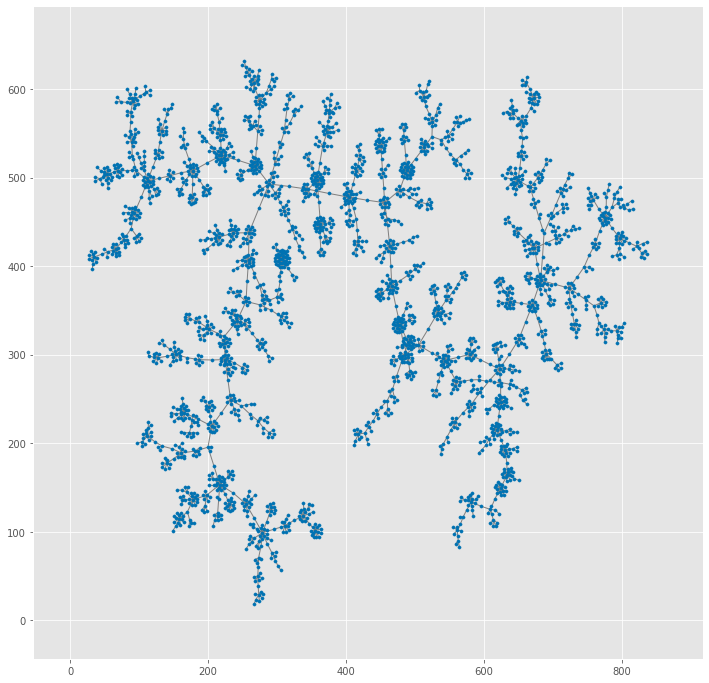

In [29]:
# labels = [g.nodes[i]['label'] for i in g.nodes]
# for i in g.nodes:
#     g.nodes[i]['label'] = ''
    
    

# init_layout = 'radial'
init_layout = 'sfdp'

# # pos0 = nx.layout.planar_layout(g, scale=40)
# # pos0 = graphviz_layout(g, prog="dot", root=list(g.nodes)[0])
# # pos0 = graphviz_layout(g, prog='twopi')

t0 = time()
if init_layout == 'sfdp':
    pos0 = graphviz_layout(g, prog='sfdp')
    pos = pos0.copy()
elif init_layout == 'radial':
    metric = d.max(axis=1)
    iBest = np.argmin(metric)
    pos = radial_layout(g, list(g.nodes)[iBest])
dt = time() - t0
print(f'{dt} sec')



draw(g, pos, s=10, lw=1, labels=False, figsize=[12,12])
# draw(g, pos, s=10, lw=1, labels=True, figsize=[12,12])


# for i in g.nodes:
#     g.nodes[i]['label'] = labels[i]

## Best scaling

In [31]:
ideal_edge_length = {
    e: g.edges[e]['weight'] 
    for e in g.edges
}
actual_edge_length = {
    (p0,p1): np.linalg.norm(np.array(pos[p1])-np.array(pos[p0]))
    for (p0,p1) in g.edges
}
num = np.sum([ideal_edge_length[k]**2/actual_edge_length[k] for k in g.edges])
den = np.sum([ideal_edge_length[k] for k in g.edges])
s = num / den
print(f's = {s}')

pos = {k:np.array(v)*s for k,v in pos.items()}

s = 56.77600629153012


In [ ]:
# draw(g, pos,s=10, lw=1, labels=False, figsize=[36,36])

In [ ]:
# xy = np.array( [ pos[i2k[i]]for i in range(len(nodes)) ] )
# theta = (xy[:,0] - xy[:,0].min()) / (xy[:,0].max() - xy[:,0].min()) * np.pi*1
# r = (xy[:,1] - xy[:,1].min())
# # r = -(xy[:,1] - xy[:,1].max())

# xy2 = np.c_[r*np.cos(theta), r*np.sin(theta)]
# pos2 = {i2k[i]:xy2[i] for i in range(len(nodes))}
# draw(g, pos2)

# # pos = pos2

In [ ]:
# from umap import UMAP

# n_neighbors = 15

# umap = UMAP(
#     n_components=2,
#     n_neighbors=n_neighbors, 
#     min_dist=0.3,
#     metric='precomputed',
# #     n_epochs=500,
# #     negative_sample_rate=150,
# #     learning_rate=0.0001,
# #     init=np.array(list(pos.values()))
# )
# xy = umap.fit_transform(d)
# pos2 = {i2k[i]:xy[i,:2] for i in range(len(nodes))}


## New Ordering of Nodes

In [33]:
### list of node ids


# if ('math-genealogy' in fn 
#     or 'topics-800' in fn
#     or 'covid' in fn
#    ):
    
print('no re-ordering')
## no re-ordering
node_order = list(g.nodes)
## order preserving re-sort according to level
id2level = {i: g.nodes[i]['level'] for i in g.nodes}
nodeorder_level_pairs = [(i,id2level[i]) for i in node_order]
node_order = [n[0] for n in sorted(nodeorder_level_pairs, key=lambda x:x[1])]
bfs = nx.bfs_tree(g, node_order[0])
node_order = list(bfs) 

# else:
#     #max degree node
#     print('max degree node re-ordering')
#     degree = list(g.degree)
#     degree = list(zip(range(len(degree)), degree))
#     max_degree_node = max(degree, key=lambda x:x[1][1])
#     start = max_degree_node[1][0]
#     bfs = nx.bfs_tree(g, start)
#     node_order = list(bfs) 
    
# #     # random node, bfs
# #     start = next(iter(g.nodes.keys()))
# #     bfs = nx.bfs_tree(g, start)
# #     node_order = list(bfs) 

# #     #dfs
# #     node_order = list(nx.dfs_preorder_nodes(g, start))





no re-ordering


## Crossing removal

In [ ]:
# def isCrossed(e0, e1, pos=None):
#     p0,p1 = e0
#     q0,q1 = e1
    
#     if p0 == q0 or p0 == q1 or p1==q0 or p1==q1: ##if two edges shares a node
#         return False
#     else:
#         p0 = pos[p0]
#         p1 = pos[p1]
#         q0 = pos[q0]
#         q1 = pos[q1]
#         e0 = (pos[e0[0]],pos[e0[1]])
#         e1 = (pos[e1[0]],pos[e1[1]])
        
#         s00 = signOf(q0, e0)
#         s10 = signOf(q1, e0)
#         s01 = signOf(p0, e1)
#         s11 = signOf(p1, e1)
#         return s00*s10 <= 0 and s01*s11 <= 0 

    
# def signOf(p, e):
#     '''sign of point p with repect to the line of edge e'''
#     px, py = p
#     ax, ay = e[0]
#     bx, by = e[1]
    
#     a = ay - by
#     b = bx - ax
#     c = ay * (ax - bx) - ax * (ay - by)
    
#     z = px*a + py*b + c
#     return np.sign(z)


# def subtreeSize(tree, node):
#     subtree = nx.bfs_tree(tree, node)
#     return len(subtree.nodes), subtree


# def shrinkRotate(
#     subtree=None, around=0, 
#     scaleBy=0.5, rotateBy=np.pi/10, pos=None):

#     ox, oy = pos[around]
#     cos = np.cos(rotateBy)
#     sin = np.sin(rotateBy)
#     for k in subtree.nodes:
#         x,y = pos[k]
#         x,y = x-ox, y-oy
#         x,y = x*scaleBy, y*scaleBy
#         x,y = cos*x-sin*y, sin*x+cos*y
#         x,y = x+ox, y+oy
#         pos[k] = (x,y)

        
# hasCrossing = False
# c=1
# while not hasCrossing:
#     edges = edge_order[:c]
#     for i,e0 in enumerate(edges):
#         e1 = edges[-1]
#         if isCrossed(e0, e1, pos):
#             hasCrossing = True
#     c += 1
# c   

In [ ]:
# edge_order = []
# for i,n in enumerate(tqdm(node_order)):
#     m = node_order[i]
#     for n in node_order[:i]:
#         if (m,n) in g.edges:
#             edge_order.append((m,n))
#         if (n,m) in g.edges:
#             edge_order.append((n,m))

## denaulay

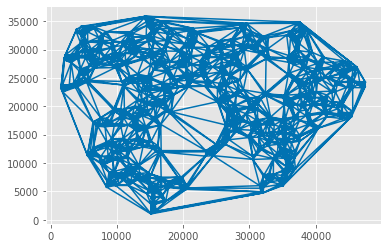

In [34]:
def simplex2edges(sim, points):
    res = dict()
    for t in sim:
        for i in range(3):
            a,b = t[i], t[(i+1)%3]
            if a > b:
                a,b = b,a
            res[(a,b)] = np.linalg.norm(points[a] - points[b])
    return res

points = np.array(list(pos[i] for i in node_order))
tri = Delaunay(points)
plt.triplot(points[:,0], points[:,1], tri.simplices)
plt.show()

denaulayDistance = simplex2edges(tri.simplices, points)

## to JSON

In [35]:
###graph to list
nodes = {k: g.nodes[k] for k in g.nodes}
edges = [[e[0], e[1], g.edges[e]] for e in g.edges]

nodes = [{
    'id': node_order[i],
    'index': 
    i,
    **nodes[node_order[i]]
} for i in range(len(nodes))]

edges = [{
    'source': e[0],
    'target': e[1],
    **e[2]
} for e in edges]



##store the position & perplexity
for i,node in enumerate(nodes):
    node['x'] = pos[node_order[i]][0]
    node['y'] = pos[node_order[i]][1]
    node['neighbors'] = list(nx.neighbors(g, node['id']))
    node['perplexity'] = len(list(nx.neighbors(g, node_order[i])))
    
    try: 
        parent = next(bfs.predecessors(node['id']))
    except StopIteration:
        parent = None
    node['parent'] = parent

    
virtual_edges = []
for i in tqdm(range(len(nodes))):
    for j in range(i+1, len(nodes)):
        if d[i,j] == 0:
            print(f'[warning] d[{i},{j}] = 0')
        else:
            if (i,j) in denaulayDistance:
                dij = d[i,j]
            elif hops[i,j] > 1:# and hops[i,j] <= 5:
                dij = d[i,j]
            else:
                continue
            e = {
                'source': i2k[i],
                'target': i2k[j],
                'weight': dij,
                'hops': hops[i,j]
            }
            virtual_edges.append(e)
            
        
fn_out = fn.replace('dot', 'json').replace('txt', 'json')
if not Path(fn_out).parent.exists():
    os.makedirs(Path(fn_out).parent)
    
    
    
## option 1: nodes, edges, and virtualEdges with properties
# with open(fn_out, 'w') as f:
#     json.dump(dict(
#         edges = edges, 
#         virtual_edges = virtual_edges, 
#         nodes=nodes
#     ), f, indent=2)
# print('done')


## option 2: property arrays
nodeIds = [n['id'] for n in nodes]
nodeLabels = [n['label'] for n in nodes]
nodeLevels = [n['level'] for n in nodes]
nodeXs = [n['x'] for n in nodes]
nodeYs = [n['y'] for n in nodes]
nodePerplexities = [n['perplexity'] for n in nodes]
nodeParents = [n['parent'] for n in nodes]
nodeNeighbors = [n['neighbors'] for n in nodes]
nodeNodeCount = [n['nodeCount'] for n in nodes]
nodeWeight = [n['weight'] for n in nodes]

edgeSources = [e['source'] for e in edges]
edgeTargets = [e['target'] for e in edges]
edgeLevels = [e['level'] for e in edges]
edgeWeights = [e['weight'] for e in edges]

virtualEdgeSources = [e['source'] for e in virtual_edges]
virtualEdgeTargets = [e['target'] for e in virtual_edges]
virtualEdgeWeights = [e['weight'] for e in virtual_edges]
virtualEdgeHops = [e['hops'] for e in virtual_edges]

print(f'writing {fn_out}...')
with open(fn_out, 'w') as f:
    json.dump(dict(
        node_id=nodeIds, 
        node_label=nodeLabels, 
        node_level=nodeLevels,
        node_x=nodeXs,
        node_y=nodeYs,
        node_perplexity=nodePerplexities,
        node_parent=nodeParents,
        node_neighbors=nodeNeighbors,
        node_nodeCount=nodeNodeCount,
        node_weight=nodeWeight,
        
        edge_source=edgeSources,
        edge_target=edgeTargets,
        edge_level=edgeLevels,
        edge_weight=edgeWeights,
        
        virtual_edge_source=virtualEdgeSources,
        virtual_edge_target=virtualEdgeTargets,
        virtual_edge_weight=virtualEdgeWeights,
        virtual_edge_hops=virtualEdgeHops,
        
    ), f, indent=2)

print('done!')




writing ./data/json/lastfm/Graph_8.json...
done!


## output pos for MAP (Ryn）

In [ ]:
# my_edges =  [['mechanism design', 'algorithmic game'], ['mechanism design', 'auction theory'], ['algorithmic game', 'learning theory'], ['algorithmic game', 'approximation al'], ['auction theory', 'microeconomic th'], ['auction theory', 'market design'], ['approximation al', 'combinatorial 02'], ['approximation al', 'randomized algor'], ['approximation al', 'online algorithm'], ['microeconomic th', 'game theory'], ['microeconomic th', 'decision theory'], ['microeconomic th', 'information econ'], ['market design', 'matching theory'], ['market design', 'matching'], ['market design', 'auctions'], ['combinatorial 02', 'integer programm'], ['combinatorial 02', 'metaheuristics'], ['combinatorial 02', 'operations resea'], ['game theory', 'experimental eco'], ['game theory', 'social choice'], ['game theory', 'bargaining'], ['game theory', 'microeconomics'], ['game theory', 'economic theory'], ['game theory', 'mathematical e02'], ['auctions', 'industrial organ'], ['integer programm', 'stochastic progr'], ['metaheuristics', 'timetabling'], ['metaheuristics', 'heuristics'], ['metaheuristics', 'vehicle routing '], ['metaheuristics', 'vehicle routing'], ['operations resea', 'mathematical opt'], ['operations resea', 'network design'], ['operations resea', 'multiple criteri'], ['operations resea', 'decision analysi'], ['operations resea', 'network optimiza'], ['operations resea', 'optimization und'], ['operations resea', 'queueing'], ['operations resea', 'optimization'], ['operations resea', 'stochastic optim'], ['operations resea', 'industrial engin'], ['operations resea', 'management scien'], ['operations resea', 'combinatorial op'], ['operations resea', 'data envelopment'], ['operations resea', 'scheduling'], ['operations resea', 'mathematical pro'], ['experimental eco', 'behavioural econ'], ['experimental eco', 'behavioral econo'], ['industrial organ', 'antitrust'], ['industrial organ', 'international 05'], ['industrial organ', 'applied microe02'], ['industrial organ', 'applied game the'], ['industrial organ', 'applied microeco'], ['industrial organ', 'competition poli'], ['decision analysi', 'risk analysis'], ['optimization', 'surrogate modeli'], ['optimization', 'stochastics'], ['optimization', 'variational anal'], ['optimization', 'variational ineq'], ['optimization', 'control'], ['optimization', 'simulation'], ['optimization', 'optimal control'], ['scheduling', 'planning'], ['scheduling', 'production plann'], ['behavioral econo', 'experimental'], ['behavioral econo', 'field experiment'], ['behavioral econo', 'economic psychol'], ['antitrust', 'intellectual p02'], ['antitrust', 'regulation'], ['international 05', 'multinationals'], ['international 05', 'trade policy'], ['international 05', 'fdi'], ['international 05', 'foreign direct i'], ['applied microeco', 'labor economics'], ['risk analysis', 'decision'], ['variational anal', 'convex analysis'], ['variational ineq', 'equilibrium prob'], ['control', 'guidance'], ['control', 'flight dynamics'], ['control', 'mechatronics'], ['control', 'guidance navigat'], ['control', 'system dynamics'], ['control', 'dynamics'], ['control', 'fluid power'], ['control', 'power system sta'], ['control', 'estimation'], ['simulation', 'interprofessiona'], ['simulation', 'device modeling'], ['simulation', 'modeling'], ['simulation', 'agent-based mode'], ['simulation', 'system modeling'], ['planning', 'power system ope'], ['planning', 'heuristic search'], ['production plann', 'inventory manage'], ['production plann', 'supply chain man'], ['intellectual p02', 'patent law'], ['intellectual p02', 'internet law'], ['intellectual p02', 'cyberlaw'], ['intellectual p02', 'patents'], ['intellectual p02', 'copyright law'], ['regulation', 'competition'], ['labor economics', 'health economics'], ['labor economics', 'development econ'], ['labor economics', 'microeconometric'], ['labor economics', 'public finance'], ['labor economics', 'economics of edu'], ['labor economics', 'public economics'], ['labor economics', 'personnel econom'], ['labor economics', 'economics of the'], ['labor economics', 'applied economet'], ['labor economics', 'economic demogra'], ['convex analysis', 'convex optimizat'], ['guidance', 'navigation'], ['mechatronics', 'control engineer'], ['mechatronics', 'robotics'], ['system dynamics', 'systems thinking'], ['dynamics', 'vibration'], ['power system sta', 'power system dyn'], ['estimation', 'detection'], ['agent-based mode', 'social simulatio'], ['agent-based mode', 'complex adaptive'], ['power system ope', 'power system pla'], ['power system ope', 'electricity mark'], ['supply chain man', 'retail operation'], ['supply chain man', 'logistics'], ['supply chain man', 'humanitarian log'], ['supply chain man', 'procurement'], ['supply chain man', 'reverse logistic'], ['supply chain man', 'sustainable oper'], ['supply chain man', 'inventory contro'], ['supply chain man', 'operations manag'], ['supply chain man', 'quality manageme'], ['supply chain man', 'operations'], ['supply chain man', 'inventory theory'], ['supply chain man', 'supply chain ris'], ['patents', 'trademark'], ['patents', 'copyright'], ['health economics', 'health outcomes'], ['health economics', 'economics of agi'], ['health economics', 'cost-effective02'], ['health economics', 'health technolog'], ['health economics', 'cost-effectivene'], ['health economics', 'economic evaluat'], ['health economics', 'outcomes researc'], ['health economics', 'health policy'], ['health economics', 'health insurance'], ['development econ', 'institutional ec'], ['development econ', 'impact evaluatio'], ['development econ', 'microfinance'], ['development econ', 'political econ02'], ['development econ', 'chinese economy'], ['development econ', 'agricultural eco'], ['public finance', 'fiscal federalis'], ['public finance', 'taxation'], ['economics of edu', 'labour economics'], ['public economics', 'urban economics'], ['personnel econom', 'organizational e'], ['navigation', 'positioning'], ['navigation', 'gnss'], ['navigation', 'tracking'], ['navigation', 'sensor fusion'], ['navigation', 'spatial cognitio'], ['robotics', 'humanoid robotic'], ['robotics', 'robot learning'], ['robotics', 'marine robotics'], ['robotics', 'haptics'], ['robotics', 'multi-robot syst'], ['robotics', 'artificial intel'], ['robotics', 'slam'], ['robotics', 'auv'], ['robotics', 'quadrotors'], ['robotics', 'human-robot inte'], ['robotics', 'active perceptio'], ['robotics', 'control systems'], ['robotics', 'automation'], ['robotics', 'motion planning'], ['robotics', 'robotic manipula'], ['robotics', 'humanoids'], ['robotics', 'control theory'], ['robotics', 'autonomous syste'], ['robotics', 'biomechatronics'], ['robotics', 'learning from de'], ['robotics', 'unmanned aerial '], ['robotics', 'micro air vehicl'], ['robotics', 'uav'], ['vibration', 'noise'], ['vibration', 'structural dynam'], ['vibration', 'rotordynamics'], ['vibration', 'acoustics'], ['power system dyn', 'stability'], ['electricity mark', 'demand response'], ['logistics', 'material handlin'], ['logistics', 'freight'], ['logistics', 'scm'], ['logistics', 'supply chain'], ['logistics', 'transportation'], ['operations manag', 'lean'], ['operations manag', 'behavioral opera'], ['operations manag', 'service operatio'], ['operations manag', 'operations strat'], ['copyright', 'open access'], ['outcomes researc', 'pharmacoeconomic'], ['health policy', 'health services '], ['health policy', 'health systems'], ['health policy', 'medicaid'], ['political econ02', 'public choice'], ['political econ02', 'cultural economi'], ['political econ02', 'corruption'], ['political econ02', 'comparative poli'], ['political econ02', 'formal political'], ['agricultural eco', 'rural developmen'], ['agricultural eco', 'agricultural pol'], ['agricultural eco', 'food policy'], ['agricultural eco', 'environmental ec'], ['agricultural eco', 'agribusiness'], ['labour economics', 'family economics'], ['labour economics', 'applied microe03'], ['urban economics', 'economic geograp'], ['urban economics', 'regional'], ['urban economics', 'spatial economic'], ['urban economics', 'real estate econ'], ['urban economics', 'real estate'], ['organizational e', 'contract theory'], ['gnss', 'geodesy'], ['gnss', 'ionosphere'], ['tracking', 'object detection'], ['tracking', 'localization'], ['spatial cognitio', 'embodied cogniti'], ['haptics', 'medical robotics'], ['haptics', 'surgical robotic'], ['haptics', 'telerobotics'], ['haptics', 'teleoperation'], ['haptics', 'rehabilitation r'], ['artificial intel', 'evolutionary com'], ['artificial intel', 'automated planni'], ['artificial intel', 'reinforcement le'], ['artificial intel', 'natural language'], ['artificial intel', 'computational cr'], ['artificial intel', 'machine learning'], ['artificial intel', 'probabilistic pr'], ['artificial intel', 'game ai'], ['artificial intel', 'computer games'], ['artificial intel', 'multi-agent syst'], ['artificial intel', 'case-based reaso'], ['artificial intel', 'computer vision'], ['artificial intel', 'knowledge repres'], ['slam', 'mobile robotics'], ['slam', 'robot vision'], ['human-robot inte', 'social robotics'], ['motion planning', 'path planning'], ['motion planning', 'manipulation'], ['control theory', 'systems theory'], ['uav', 'uas'], ['noise', 'vibration contro'], ['structural dynam', 'wave propagation'], ['structural dynam', 'structural contr'], ['structural dynam', 'structural healt'], ['structural dynam', 'nonlinear vibrat'], ['structural dynam', 'modal analysis'], ['structural dynam', 'aeroelasticity'], ['structural dynam', 'earthquake engin'], ['structural dynam', 'model updating'], ['structural dynam', 'wind engineering'], ['structural dynam', 'seismic isolatio'], ['acoustics', 'audio'], ['demand response', 'smart grid'], ['demand response', 'energy managemen'], ['supply chain', 'inventory'], ['transportation', 'discrete choice '], ['transportation', 'travel behaviour'], ['transportation', 'ports'], ['transportation', 'cycling'], ['transportation', 'transition'], ['lean', 'agile'], ['service operatio', 'healthcare opera'], ['open access', 'institutional re'], ['open access', 'repositories'], ['open access', 'open science'], ['open access', 'altmetrics'], ['pharmacoeconomic', 'pharmacoepidemio'], ['pharmacoeconomic', 'pharmaceutical p'], ['health services ', 'primary care'], ['health services ', 'quality of care'], ['health systems', 'global health'], ['comparative poli', 'political partie'], ['comparative poli', 'latin american p'], ['comparative poli', 'party politics'], ['comparative poli', 'democratization'], ['comparative poli', 'latin america'], ['comparative poli', 'european politic'], ['comparative poli', 'legislative stud'], ['comparative poli', 'chinese politics'], ['comparative poli', 'political econom'], ['rural developmen', 'agriculture'], ['environmental ec', 'non-market valua'], ['environmental ec', 'natural resource'], ['environmental ec', 'water economics'], ['environmental ec', 'ecological econo'], ['environmental ec', 'energy economics'], ['environmental ec', 'resource economi'], ['economic geograp', 'regional science'], ['economic geograp', 'regional develop'], ['economic geograp', 'evolutionary eco'], ['economic geograp', 'innovation studi'], ['economic geograp', 'political geogra'], ['economic geograp', 'evolutionary e02'], ['real estate', 'housing'], ['geodesy', 'crustal deformat'], ['geodesy', 'geophysics'], ['geodesy', 'surveying'], ['geodesy', 'gps'], ['ionosphere', 'thermosphere'], ['ionosphere', 'space physics'], ['object detection', 'recognition'], ['evolutionary com', 'multi-objective '], ['evolutionary com', 'artificial life'], ['evolutionary com', 'natural computin'], ['evolutionary com', 'genetic programm'], ['evolutionary com', 'computational in'], ['evolutionary com', 'swarm intelligen'], ['natural language', 'sentiment analys'], ['natural language', 'text mining'], ['natural language', 'text summarizati'], ['natural language', 'machine translat'], ['natural language', 'information extr'], ['natural language', 'word sense disam'], ['natural language', 'computational li'], ['natural language', 'bionlp'], ['natural language', 'language modelin'], ['natural language', 'statistical mach'], ['computational cr', 'procedural conte'], ['machine learning', 'data mining'], ['machine learning', 'probabilistic gr'], ['machine learning', 'neural networks'], ['machine learning', 'statistical rela'], ['machine learning', 'signal process02'], ['machine learning', 'graphical models'], ['machine learning', 'deep learning'], ['machine learning', 'statistical mode'], ['machine learning', 'dimensionality r'], ['multi-agent syst', 'cooperative cont'], ['multi-agent syst', 'agents'], ['computer vision', 'human vision'], ['computer vision', 'video analytics'], ['computer vision', 'computer graphic'], ['computer vision', 'robot perception'], ['computer vision', 'object tracking'], ['computer vision', 'image analysis'], ['computer vision', 'face analysis'], ['computer vision', 'biometrics'], ['computer vision', 'structure from m'], ['computer vision', 'gait recognition'], ['computer vision', 'human action rec'], ['computer vision', 'gesture recognit'], ['computer vision', 'image understand'], ['computer vision', 'video surveillan'], ['computer vision', 'medical image an'], ['computer vision', '3d reconstructio'], ['computer vision', 'multimedia'], ['computer vision', 'image retrieval'], ['knowledge repres', 'semantic web'], ['knowledge repres', 'automated reason'], ['knowledge repres', 'logic programmin'], ['knowledge repres', 'ontologies'], ['knowledge repres', 'reasoning'], ['knowledge repres', 'description logi'], ['path planning', 'crowd simulation'], ['manipulation', 'grasping'], ['structural healt', 'damage detection'], ['structural healt', 'nondestructive e'], ['structural healt', 'smart structures'], ['structural healt', 'ultrasonics'], ['structural healt', 'wireless sensors'], ['structural healt', 'acoustic emissio'], ['structural healt', 'system identific'], ['earthquake engin', 'engineering seis'], ['earthquake engin', 'reinforced concr'], ['earthquake engin', 'seismic retrofit'], ['earthquake engin', 'structural analy'], ['earthquake engin', 'seismic design'], ['earthquake engin', 'masonry structur'], ['earthquake engin', 'structural engin'], ['earthquake engin', 'structural relia'], ['earthquake engin', 'performance-base'], ['audio', 'speech signal pr'], ['smart grid', 'power system eco'], ['smart grid', 'pmu'], ['smart grid', 'power systems'], ['smart grid', 'smart buildings'], ['smart grid', 'distributed ener'], ['smart grid', 'power line commu'], ['smart grid', 'demand side mana'], ['smart grid', 'power system rel'], ['smart grid', 'power system pro'], ['smart grid', 'power market'], ['altmetrics', 'bibliometrics'], ['altmetrics', 'scholarly commun'], ['pharmacoepidemio', 'pharmacy'], ['pharmacoepidemio', 'clinical pharmac'], ['pharmacoepidemio', 'pharmacovigilanc'], ['pharmacoepidemio', 'comparative effe'], ['pharmacoepidemio', 'drug safety'], ['primary care', 'family medicine'], ['primary care', 'general practice'], ['global health', 'maternal health'], ['global health', 'non-communicable'], ['political partie', 'british politics'], ['political partie', 'interest groups'], ['political partie', 'elections'], ['democratization', 'authoritarianism'], ['democratization', 'ethnic conflict'], ['latin america', 'mexico'], ['latin america', 'brazil'], ['european politic', 'european union'], ['agriculture', 'food'], ['agriculture', 'soil biology'], ['agriculture', 'sociology of foo'], ['agriculture', 'food security'], ['natural resource', 'forest economics'], ['ecological econo', 'sustainable deve'], ['ecological econo', 'industrial ecolo'], ['energy economics', 'energy policy'], ['resource economi', 'environmental'], ['regional science', 'spatial economet'], ['evolutionary eco', 'economics of inn'], ['innovation studi', 'industrial dynam'], ['political geogra', 'urban geography'], ['political geogra', 'borders'], ['housing', 'neighbourhoods'], ['housing', 'community develo'], ['housing', 'homelessness'], ['housing', 'gentrification'], ['housing', 'segregation'], ['geophysics', 'earthquake scien'], ['geophysics', 'inversion'], ['geophysics', 'geology'], ['geophysics', 'magnetotellurics'], ['geophysics', 'exploration seis'], ['geophysics', 'geothermal'], ['geophysics', 'rock physics'], ['geophysics', 'seismic'], ['surveying', 'geomatics'], ['gps', 'insar'], ['space physics', 'space weather'], ['space physics', 'plasma physics'], ['space physics', 'solar physics'], ['space physics', 'magnetospheric p'], ['multi-objective ', 'evolutionary alg'], ['artificial life', 'evolutionary rob'], ['artificial life', 'complex systems'], ['genetic programm', 'genetic algorith'], ['computational in', 'fuzzy logic'], ['swarm intelligen', 'swarm robotics'], ['sentiment analys', 'opinion mining'], ['text mining', 'data'], ['machine translat', 'parsing'], ['machine translat', 'post-editing'], ['information extr', 'question answeri'], ['computational li', 'dialogue'], ['computational li', 'natural langua02'], ['computational li', 'computational se'], ['computational li', 'distributional s'], ['computational li', 'corpus linguisti'], ['computational li', 'lexical semantic'], ['data mining', 'business intelli'], ['data mining', 'web mining'], ['data mining', 'social networks'], ['data mining', 'clustering'], ['data mining', 'recommender syst'], ['data mining', 'databases'], ['data mining', 'data privacy'], ['data mining', 'knowledge discov'], ['data mining', 'feature selectio'], ['data mining', 'information retr'], ['data mining', 'outlier detectio'], ['data mining', 'healthcare analy'], ['data mining', 'graph mining'], ['data mining', 'social network a'], ['probabilistic gr', 'bayesian network'], ['signal process02', 'sonar'], ['signal process02', 'blind source sep'], ['signal process02', 'adaptive filteri'], ['signal process02', 'radar systems'], ['signal process02', 'compressed sensi'], ['signal process02', 'communication'], ['signal process02', 'underwater acous'], ['signal process02', 'information theo'], ['deep learning', 'representation l'], ['cooperative cont', 'distributed cont'], ['cooperative cont', 'autonomous vehic'], ['computer graphic', 'geometric comput'], ['computer graphic', 'visual computing'], ['computer graphic', 'virtual reality'], ['computer graphic', 'global illuminat'], ['computer graphic', 'character animat'], ['computer graphic', 'non-photorealist'], ['computer graphic', 'real-time render'], ['computer graphic', 'physical simulat'], ['computer graphic', 'computational 06'], ['computer graphic', 'computer animati'], ['computer graphic', 'digital geometry'], ['computer graphic', 'scientific visua'], ['computer graphic', 'visualization'], ['computer graphic', 'geometric modeli'], ['biometrics', 'face recognition'], ['biometrics', 'authentication'], ['biometrics', 'iris recognition'], ['biometrics', 'pattern recognit'], ['biometrics', 'image processing'], ['medical image an', 'computer aided d'], ['medical image an', 'segmentation'], ['medical image an', 'medical image co'], ['medical image an', 'image registrati'], ['semantic web', 'ontology enginee'], ['semantic web', 'social web'], ['semantic web', 'information inte'], ['semantic web', 'data integration'], ['semantic web', 'knowledge engine'], ['semantic web', 'linked data'], ['semantic web', 'ontology learnin'], ['semantic web', 'linked open data'], ['semantic web', 'provenance'], ['automated reason', 'verification'], ['logic programmin', 'computational lo'], ['logic programmin', 'nonmonotonic rea'], ['logic programmin', 'constraint progr'], ['logic programmin', 'answer set progr'], ['ontologies', 'biomedical infor'], ['ontologies', 'conceptual model'], ['ultrasonics', 'nde'], ['ultrasonics', 'ndt'], ['system identific', 'automatic contro'], ['reinforced concr', 'frp'], ['seismic design', 'steel structures'], ['structural engin', 'seismic engineer'], ['structural engin', 'civil engineerin'], ['structural engin', 'progressive coll'], ['structural engin', 'fire engineering'], ['structural engin', 'timber engineeri'], ['power systems', 'power electronic'], ['power systems', 'electrical engin'], ['power systems', 'distribution net'], ['power systems', 'high voltage'], ['bibliometrics', 'information scie'], ['bibliometrics', 'citation analysi'], ['bibliometrics', 'research assessm'], ['bibliometrics', 'scientometrics'], ['bibliometrics', 'webometrics'], ['bibliometrics', 'research evaluat'], ['bibliometrics', 'informetrics'], ['bibliometrics', 'science policy'], ['scholarly commun', 'publishing'], ['scholarly commun', 'collection devel'], ['clinical pharmac', 'pharmacometrics'], ['clinical pharmac', 'pharmacokinetics'], ['interest groups', 'lobbying'], ['elections', 'voting'], ['elections', 'campaigns'], ['elections', 'voting behavior'], ['elections', 'political scienc'], ['elections', 'congress'], ['elections', 'parties'], ['elections', 'electoral system'], ['european union', 'european integra'], ['sustainable deve', 'environmental 02'], ['industrial ecolo', 'life cycle asses'], ['industrial ecolo', 'circular economy'], ['industrial ecolo', 'waste management'], ['energy policy', 'energy security'], ['energy policy', 'climate policy'], ['energy policy', 'environmental po'], ['spatial economet', 'regional economi'], ['economics of inn', 'economics of sci'], ['economics of inn', 'industrial econo'], ['borders', 'geopolitics'], ['gentrification', 'urban studies'], ['inversion', 'seismic imaging'], ['geology', 'geochronology'], ['geology', 'geoscience'], ['geology', 'sedimentology'], ['geology', 'earth history'], ['geology', 'geochemistry'], ['geology', 'petrology'], ['geology', 'earth sciences'], ['rock physics', 'petrophysics'], ['geomatics', 'photogrammetry'], ['geomatics', 'laser scanning'], ['space weather', 'heliophysics'], ['space weather', 'magnetosphere'], ['plasma physics', 'plasma diagnosti'], ['plasma physics', 'inertial confine'], ['plasma physics', 'mhd'], ['plasma physics', 'plasma chemistry'], ['plasma physics', 'laser plasma int'], ['plasma physics', 'tokamak'], ['plasma physics', 'nuclear fusion'], ['plasma physics', 'electric propuls'], ['plasma physics', 'plasma processin'], ['plasma physics', 'fusion'], ['plasma physics', 'magnetohydrodyna'], ['plasma physics', 'fusion energy'], ['solar physics', 'mhd waves'], ['complex systems', 'collective behav'], ['complex systems', 'complex networks'], ['complex systems', 'cellular automat'], ['complex systems', 'statistical phys'], ['complex systems', 'network science'], ['complex systems', 'social systems'], ['complex systems', 'science of scien'], ['complex systems', 'evolutionary dyn'], ['complex systems', 'econophysics'], ['corpus linguisti', 'discourse analys'], ['corpus linguisti', 'terminology'], ['corpus linguisti', 'academic writing'], ['corpus linguisti', 'english linguist'], ['corpus linguisti', 'translation stud'], ['corpus linguisti', 'cognitive lingui'], ['business intelli', 'decision support'], ['business intelli', 'data warehouse'], ['social networks', 'social capital'], ['clustering', 'classification'], ['recommender syst', 'information filt'], ['recommender syst', 'user modeling'], ['recommender syst', 'collaborative fi'], ['databases', 'xml'], ['databases', 'data management'], ['databases', 'query processing'], ['databases', 'data streams'], ['information retr', 'semantic search'], ['information retr', 'search'], ['information retr', 'web search'], ['information retr', 'search engines'], ['graph mining', 'anomaly detectio'], ['social network a', 'community detect'], ['compressed sensi', 'time-frequency a'], ['communication', 'media'], ['information theo', 'physical layer s'], ['information theo', 'statistical infe'], ['information theo', 'communication sy'], ['information theo', 'communication th'], ['information theo', 'compression'], ['information theo', 'network coding'], ['information theo', 'coding theory'], ['information theo', 'coding'], ['information theo', 'molecular commun'], ['information theo', 'digital communic'], ['information theo', 'statistical sign'], ['information theo', 'error correcting'], ['distributed cont', 'distributed opti'], ['autonomous vehic', 'intelligent tran'], ['autonomous vehic', 'vehicle dynamics'], ['virtual reality', 'augmented realit'], ['virtual reality', 'mixed reality'], ['virtual reality', 'virtual environm'], ['virtual reality', 'virtual humans'], ['virtual reality', '3d interaction'], ['virtual reality', '3d user interfac'], ['computational 06', 'computational im'], ['visualization', 'graphics'], ['visualization', 'visual analytics'], ['geometric modeli', 'cam'], ['face recognition', 'object recogniti'], ['face recognition', 'face perception'], ['pattern recognit', 'document analysi'], ['pattern recognit', 'biomedical signa'], ['pattern recognit', 'document image a'], ['pattern recognit', 'human language t'], ['pattern recognit', 'handwriting reco'], ['pattern recognit', 'multimedia infor'], ['image processing', 'image compressio'], ['image processing', 'biomedical sig02'], ['image processing', 'image fusion'], ['image processing', 'machine vision'], ['image processing', 'signal'], ['image processing', 'mathematical mor'], ['image processing', 'image quality'], ['image processing', 'multimedia secur'], ['image processing', 'image quality as'], ['segmentation', 'registration'], ['image registrati', 'medical image pr'], ['image registrati', 'image segmentati'], ['data integration', 'data quality'], ['linked data', 'web science'], ['linked data', 'rdf'], ['verification', 'testing'], ['verification', 'validation'], ['verification', 'formal methods'], ['verification', 'synthesis'], ['constraint progr', 'sat'], ['biomedical infor', 'clinical researc'], ['biomedical infor', 'applied ontology'], ['nde', 'shm'], ['frp', 'concrete'], ['steel structures', 'concrete structu'], ['civil engineerin', 'geotechnical eng'], ['power electronic', 'hvdc'], ['power electronic', 'multilevel conve'], ['power electronic', 'motor drives'], ['power electronic', 'power quality'], ['power electronic', 'renewable ener04'], ['power electronic', 'microgrids'], ['power electronic', 'drives'], ['power electronic', 'wireless power t'], ['power electronic', 'renewable energy'], ['power electronic', 'electric drives'], ['power electronic', 'digital control'], ['power electronic', 'industrial elect'], ['power electronic', 'electric vehicle'], ['power electronic', 'power converters'], ['power electronic', 'renewable ener02'], ['power electronic', 'renewable ener03'], ['power electronic', 'dc-dc converters'], ['power electronic', 'dc converters'], ['power electronic', 'photovoltaic sys'], ['power electronic', 'electrical machi'], ['power electronic', 'hybrid electric '], ['information scie', 'library'], ['information scie', 'librarianship'], ['information scie', 'library science'], ['information scie', 'knowledge organi'], ['information scie', 'information beha'], ['pharmacokinetics', 'drug metabolism'], ['pharmacokinetics', 'pbpk'], ['pharmacokinetics', 'pharmacodynamics'], ['pharmacokinetics', 'biopharmaceutics'], ['political scienc', 'international st'], ['political scienc', 'international re'], ['political scienc', 'methodology'], ['political scienc', 'public policy'], ['congress', 'presidency'], ['congress', 'political instit'], ['congress', 'american polit02'], ['life cycle asses', 'sustainability'], ['life cycle asses', 'life cycle costi'], ['life cycle asses', 'carbon footprint'], ['waste management', 'recycling'], ['regional economi', 'urban'], ['urban studies', 'human geography'], ['urban studies', 'housing studies'], ['geochronology', 'isotope geology'], ['geochronology', 'isotope geochemi'], ['sedimentology', 'petroleum geolog'], ['sedimentology', 'ichnology'], ['sedimentology', 'stratigraphy'], ['sedimentology', 'geomorphology'], ['sedimentology', 'sequence stratig'], ['sedimentology', 'glacial geology'], ['sedimentology', 'basin analysis'], ['sedimentology', 'marine geology'], ['sedimentology', 'coastal geology'], ['geochemistry', 'volcanology'], ['geochemistry', 'diagenesis'], ['geochemistry', 'igneous petrolog'], ['geochemistry', 'ore geology'], ['geochemistry', 'mineralogy'], ['geochemistry', 'cosmochemistry'], ['geochemistry', 'magnesium isotop'], ['geochemistry', 'economic geology'], ['petrophysics', 'reservoir charac'], ['photogrammetry', 'cultural heritag'], ['photogrammetry', 'remote sensing'], ['photogrammetry', '3d modeling'], ['laser scanning', 'mobile mapping'], ['inertial confine', 'high energy dens'], ['complex networks', 'human mobility'], ['complex networks', 'epidemics'], ['statistical phys', 'anomalous diffus'], ['statistical phys', 'biological physi'], ['statistical phys', 'network theory'], ['statistical phys', 'percolation theo'], ['network science', 'computational so'], ['network science', 'data science'], ['discourse analys', 'applied linguist'], ['discourse analys', 'multimodality'], ['discourse analys', 'systemic functio'], ['discourse analys', 'stylistics'], ['discourse analys', 'sociolinguistics'], ['terminology', 'translation'], ['terminology', 'lexicography'], ['academic writing', 'eap'], ['translation stud', 'comparative lite'], ['translation stud', 'interpreting stu'], ['decision support', 'business analyti'], ['classification', 'mixture models'], ['user modeling', 'personality'], ['data management', 'data curation'], ['query processing', 'database systems'], ['query processing', 'indexing'], ['media', 'media policy'], ['media', 'journalism'], ['communication th', 'wireless communi'], ['coding theory', 'information'], ['coding theory', 'network informat'], ['statistical sign', 'estimation theor'], ['intelligent tran', 'traffic flow'], ['intelligent tran', 'traffic simulati'], ['intelligent tran', 'traffic safety'], ['intelligent tran', 'traffic control'], ['intelligent tran', 'intelligent vehi'], ['intelligent tran', 'traffic flow the'], ['computational im', 'inverse problems'], ['visual analytics', 'data visualizati'], ['visual analytics', 'information visu'], ['cam', 'additive manufac'], ['cam', 'cad'], ['face perception', 'prosopagnosia'], ['biomedical signa', 'heart rate varia'], ['signal', 'information proc'], ['testing', 'vlsi design'], ['formal methods', 'concurrency theo'], ['formal methods', 'software verific'], ['formal methods', 'program verifica'], ['formal methods', 'theorem proving'], ['formal methods', 'refinement'], ['formal methods', 'model checking'], ['formal methods', 'software enginee'], ['formal methods', 'petri nets'], ['formal methods', 'concurrency'], ['formal methods', 'programming lang'], ['synthesis', 'characterization'], ['sat', 'smt'], ['concrete', 'building materia'], ['concrete', 'pavement'], ['concrete', 'structures'], ['concrete', 'cement'], ['concrete', 'bridges'], ['concrete', 'durability'], ['concrete', 'masonry'], ['geotechnical eng', 'soil mechanics'], ['geotechnical eng', 'offshore enginee'], ['geotechnical eng', 'soil dynamics'], ['geotechnical eng', 'engineering geol'], ['geotechnical eng', 'pavement enginee'], ['geotechnical eng', 'geomechanics'], ['geotechnical eng', 'geoenvironment02'], ['geotechnical eng', 'ground improveme'], ['geotechnical eng', 'unsaturated soil'], ['hvdc', 'facts'], ['microgrids', 'distributed gene'], ['renewable ener03', 'waste to energy'], ['renewable ener03', 'energy efficienc'], ['electrical machi', 'condition monito'], ['library', 'librarians'], ['library', 'information lite'], ['library', 'information stud'], ['drug metabolism', 'pharmacogenetics'], ['international re', 'european studies'], ['international re', 'international se'], ['international re', 'foreign policy'], ['international re', 'china'], ['international re', 'international po'], ['international re', 'diplomacy'], ['international re', 'us foreign polic'], ['international re', 'critical securit'], ['international re', 'security studies'], ['international re', 'international in'], ['international re', 'civil war'], ['methodology', 'design theory'], ['public policy', 'urban politics'], ['public policy', 'federalism'], ['public policy', 'administration'], ['public policy', 'policy analysis'], ['public policy', 'public administr'], ['american polit02', 'representation'], ['american polit02', 'political method'], ['american polit02', 'political beha02'], ['american polit02', 'judicial politic'], ['american polit02', 'american politic'], ['american polit02', 'public opinion'], ['sustainability', 'corporate respon'], ['sustainability', 'food systems'], ['urban', 'regional plannin'], ['urban', 'infrastructure'], ['urban', 'architecture'], ['urban', 'regional studies'], ['human geography', 'political ecolog'], ['human geography', 'cultural geograp'], ['isotope geochemi', 'chemical oceanog'], ['isotope geochemi', 'carbonate sedime'], ['stratigraphy', 'paleontology'], ['stratigraphy', 'palaeontology'], ['stratigraphy', 'sedimentary geol'], ['geomorphology', 'physical geograp'], ['geomorphology', 'landscape evolut'], ['geomorphology', 'drylands'], ['geomorphology', 'geomorphometry'], ['geomorphology', 'cosmogenic nucli'], ['geomorphology', 'hydrology'], ['geomorphology', 'environmental 04'], ['geomorphology', 'quaternary scien'], ['geomorphology', 'quaternary'], ['geomorphology', 'geoarchaeology'], ['geomorphology', 'soil erosion'], ['geomorphology', 'rivers'], ['geomorphology', 'coastal processe'], ['geomorphology', 'glaciology'], ['basin analysis', 'tectonics'], ['marine geology', 'paleoceanography'], ['igneous petrolog', 'experimental pet'], ['mineralogy', 'mineral physics'], ['mineralogy', 'crystallography'], ['mineralogy', 'ore deposits'], ['cosmochemistry', 'planetary scienc'], ['remote sensing', 'soil moisture'], ['remote sensing', 'ocean optics'], ['remote sensing', 'evapotranspirati'], ['remote sensing', 'land degradation'], ['remote sensing', 'polarimetry'], ['remote sensing', 'change detection'], ['remote sensing', 'geographic infor'], ['remote sensing', 'precision agricu'], ['remote sensing', 'synthetic apertu'], ['remote sensing', 'land cover'], ['remote sensing', 'hyperspectral'], ['remote sensing', 'radiative transf'], ['remote sensing', 'image classifica'], ['remote sensing', 'gis'], ['remote sensing', 'land change scie'], ['remote sensing', 'landsat'], ['remote sensing', 'lidar'], ['remote sensing', 'forest inventory'], ['remote sensing', 'earth observatio'], ['remote sensing', 'imaging spectros'], ['human mobility', 'urban computing'], ['computational so', 'network analysis'], ['applied linguist', 'call'], ['applied linguist', 'english for spec'], ['applied linguist', 'intercultural co'], ['applied linguist', 'language learnin'], ['applied linguist', 'tesol'], ['applied linguist', 'sla'], ['applied linguist', 'second languag02'], ['applied linguist', 'language teachin'], ['applied linguist', 'second languag03'], ['sociolinguistics', 'change'], ['sociolinguistics', 'language variati'], ['sociolinguistics', 'educational ling'], ['sociolinguistics', 'linguistic anthr'], ['sociolinguistics', 'sociophonetics'], ['translation', 'interpreting'], ['lexicography', 'lexicology'], ['comparative lite', 'cultural studies'], ['comparative lite', 'literary theory'], ['personality', 'assessment'], ['personality', 'psychopathology'], ['personality', 'personality diso'], ['personality', 'individual diffe'], ['personality', 'selection'], ['data curation', 'digital preserva'], ['journalism', 'news'], ['journalism', 'periodismo'], ['journalism', 'political commun'], ['journalism', 'new media'], ['journalism', 'social media'], ['wireless communi', 'smart grid commu'], ['wireless communi', 'cellular network'], ['wireless communi', 'massive mimo'], ['wireless communi', 'signal processin'], ['wireless communi', 'cognitive radio'], ['wireless communi', 'mimo'], ['wireless communi', 'stochastic geome'], ['wireless communi', 'resource allocat'], ['wireless communi', 'mimo systems'], ['information', 'communication te'], ['traffic safety', 'transportation e'], ['traffic safety', 'its'], ['traffic safety', 'traffic engineer'], ['traffic safety', 'driver behavior'], ['intelligent vehi', 'driver assistanc'], ['inverse problems', 'tomography'], ['inverse problems', 'electrical imped'], ['inverse problems', 'uncertainty quan'], ['information visu', 'graph drawing'], ['information visu', 'human-computer i'], ['additive manufac', 'rapid prototypin'], ['additive manufac', 'inkjet printing'], ['additive manufac', 'laser material p'], ['additive manufac', '3d printing'], ['additive manufac', 'selective laser '], ['cad', 'machine design'], ['cad', 'reverse engineer'], ['vlsi design', 'hardware securit'], ['model checking', 'temporal logic'], ['model checking', 'formal verificat'], ['software enginee', 'refactoring'], ['software enginee', 'technical debt'], ['software enginee', 'mining software '], ['software enginee', 'software evoluti'], ['software enginee', 'software ecosyst'], ['software enginee', 'object-oriented '], ['software enginee', 'web development'], ['software enginee', 'model-driven eng'], ['software enginee', 'software reliabi'], ['software enginee', 'software mainten'], ['software enginee', 'software testing'], ['software enginee', 'computer scien02'], ['software enginee', 'requirements eng'], ['software enginee', 'search-based sof'], ['software enginee', 'empirical softwa'], ['software enginee', 'computer science'], ['software enginee', 'global software '], ['software enginee', 'software archite'], ['software enginee', 'adaptive softwar'], ['software enginee', 'design patterns'], ['software enginee', 'software engin02'], ['software enginee', 'software metrics'], ['software enginee', 'software reuse'], ['software enginee', 'model-driven dev'], ['petri nets', 'discrete event s'], ['programming lang', 'type theory'], ['programming lang', 'software systems'], ['programming lang', 'compilers'], ['programming lang', 'static analysis'], ['programming lang', 'type systems'], ['programming lang', 'functional progr'], ['programming lang', 'program analysis'], ['characterization', 'materials synthe'], ['characterization', 'nanomaterials sy'], ['characterization', 'fabrication'], ['smt', 'nlp'], ['building materia', 'construction'], ['pavement', 'asphalt'], ['structures', 'smart materials'], ['structures', 'aerospace'], ['soil mechanics', 'geotechnics'], ['soil dynamics', 'geotechnical ear'], ['engineering geol', 'landslides'], ['geomechanics', 'rock mechanics'], ['geomechanics', 'reservoir simula'], ['energy efficienc', 'energy planning'], ['energy efficienc', 'thermal comfort'], ['condition monito', 'fault diagnosis'], ['information lite', 'information be02'], ['information lite', 'academic libra02'], ['information lite', 'digital literacy'], ['information lite', 'academic librari'], ['information lite', 'embedded librari'], ['information lite', 'library instruct'], ['information lite', 'instruction'], ['pharmacogenetics', 'pharmacogenomics'], ['international se', 'international 02'], ['international se', 'international co'], ['international se', 'nuclear weapons'], ['china', 'asia'], ['china', 'east asia'], ['international po', 'comparative po02'], ['international po', 'foreign aid'], ['international po', 'global governanc'], ['civil war', 'peacekeeping'], ['civil war', 'terrorism'], ['design theory', 'systems engineer'], ['public administr', 'governance'], ['public administr', 'public managemen'], ['public administr', 'performance mana'], ['public administr', 'local government'], ['judicial politic', 'courts'], ['public opinion', 'political partic'], ['public opinion', 'political behavi'], ['regional plannin', 'spatial planning'], ['architecture', 'urban design'], ['architecture', 'history of archi'], ['architecture', 'space syntax'], ['architecture', 'architectural th'], ['architecture', 'interior design'], ['architecture', 'design'], ['architecture', 'computational de'], ['architecture', 'historic preserv'], ['architecture', 'sustainable desi'], ['architecture', 'architectural de'], ['architecture', 'space'], ['architecture', 'lighting'], ['political ecolog', 'pastoralism'], ['political ecolog', 'science studies'], ['political ecolog', 'environmental ju'], ['political ecolog', 'biodiversity con'], ['political ecolog', 'environmental an'], ['cultural geograp', 'social geography'], ['cultural geograp', 'historical geogr'], ['chemical oceanog', 'marine biogeoche'], ['chemical oceanog', 'marine chemistry'], ['paleontology', 'extinction'], ['paleontology', 'paleobiology'], ['paleontology', 'paleoecology'], ['palaeontology', 'palaeobiology'], ['palaeontology', 'palaeoecology'], ['hydrology', 'vadose zone'], ['hydrology', 'snow'], ['hydrology', 'water quality mo'], ['hydrology', 'watershed manage'], ['hydrology', 'hydrological mod'], ['hydrology', 'watersheds'], ['hydrology', 'water resource02'], ['hydrology', 'ecohydrology'], ['hydrology', 'water resources '], ['hydrology', 'water engineerin'], ['hydrology', 'hydrogeology'], ['hydrology', 'hydrometeorology'], ['hydrology', 'irrigation'], ['hydrology', 'hydraulics'], ['hydrology', 'hydroclimatology'], ['hydrology', 'flood modelling'], ['hydrology', 'water resources'], ['hydrology', 'agricultural wat'], ['hydrology', 'uncertainty anal'], ['hydrology', 'water quality'], ['hydrology', 'floods'], ['hydrology', 'wildfire'], ['quaternary scien', 'tephrochronology'], ['geoarchaeology', 'environmental ar'], ['geoarchaeology', 'quaternary geolo'], ['geoarchaeology', 'archaeology'], ['rivers', 'streams'], ['rivers', 'wetlands'], ['coastal processe', 'coastal geomorph'], ['glaciology', 'cryosphere'], ['glaciology', 'antarctica'], ['glaciology', 'glacier hydrolog'], ['tectonics', 'metamorphic petr'], ['tectonics', 'surface processe'], ['tectonics', 'metamorphic geol'], ['tectonics', 'geodynamics'], ['tectonics', 'paleomagnetism'], ['tectonics', 'himalaya'], ['tectonics', 'analogue modelin'], ['tectonics', 'seismology'], ['tectonics', 'structural geolo'], ['tectonics', 'thermochronology'], ['tectonics', 'marine geophysic'], ['tectonics', 'precambrian geol'], ['paleoceanography', 'paleoclimate'], ['mineral physics', 'high pressure'], ['crystallography', 'diffraction'], ['crystallography', 'x-ray diffractio'], ['crystallography', 'solid state chem'], ['crystallography', 'structural chemi'], ['crystallography', 'crystal engineer'], ['ore deposits', 'fluid inclusions'], ['planetary scienc', 'meteoritics'], ['planetary scienc', 'impact cratering'], ['planetary scienc', 'asteroids'], ['planetary scienc', 'earth'], ['planetary scienc', 'astrobiology'], ['planetary scienc', 'mars'], ['planetary scienc', 'planetary geolog'], ['land cover', 'land use'], ['land cover', 'land use change'], ['gis', 'medical geograph'], ['gis', 'sdi'], ['gis', 'geospatial analy'], ['gis', 'rs'], ['gis', 'geocomputation'], ['gis', 'vgi'], ['gis', 'spatial modeling'], ['gis', 'cartography'], ['gis', 'geography'], ['gis', 'spatial database'], ['gis', 'web mapping'], ['gis', 'spatial analysis'], ['tesol', 'esl'], ['second languag02', 'vocabulary'], ['second languag02', 'bilingualism'], ['second languag02', 'chinese linguist'], ['change', 'climate variabil'], ['cultural studies', 'visual studies'], ['cultural studies', 'critical'], ['cultural studies', 'postcolonial stu'], ['cultural studies', 'literary studies'], ['cultural studies', 'gender studies'], ['cultural studies', 'performance stud'], ['cultural studies', 'media studies'], ['cultural studies', 'visual culture'], ['literary theory', 'american literat'], ['literary theory', 'modernism'], ['assessment', 'school psycholog'], ['assessment', 'evaluation'], ['assessment', 'feedback'], ['personality diso', 'psychopathy'], ['individual diffe', 'intelligence'], ['individual diffe', 'emotional intell'], ['digital preserva', 'digital curation'], ['digital preserva', 'digital librarie'], ['digital preserva', 'archives'], ['periodismo', 'publicidad'], ['periodismo', 'comunicación aud'], ['periodismo', 'comunicación pol'], ['periodismo', 'comunicación'], ['periodismo', 'redes sociales'], ['political commun', 'framing'], ['political commun', 'media effects'], ['new media', 'digital culture'], ['social media', 'blogs'], ['social media', 'internet studies'], ['social media', 'digital'], ['social media', 'online communiti'], ['social media', 'social network s'], ['social media', 'twitter'], ['social media', 'facebook'], ['social media', 'mobile technolog'], ['social media', 'emergency manage'], ['social media', 'public relations'], ['cognitive radio', 'dynamic spectrum'], ['cognitive radio', 'software defin02'], ['cognitive radio', 'spectrum sensing'], ['cognitive radio', 'green communicat'], ['mimo', 'ofdm'], ['mimo', 'cooperative comm'], ['transportation e', 'road safety'], ['transportation e', 'transportation s'], ['traffic engineer', 'transportation p'], ['uncertainty quan', 'model reduction'], ['graph drawing', 'computational 04'], ['human-computer i', 'intelligent user'], ['human-computer i', 'interaction desi'], ['human-computer i', 'ubiquitous compu'], ['human-computer i', 'accessible compu'], ['human-computer i', 'end-user program'], ['human-computer i', 'personal informa'], ['human-computer i', 'social computing'], ['human-computer i', 'child-computer i'], ['human-computer i', 'end-user develop'], ['human-computer i', 'urban informatic'], ['human-computer i', 'mobile interacti'], ['human-computer i', 'user-centered de'], ['human-computer i', 'interaction tech'], ['human-computer i', 'computer support'], ['mining software ', 'software analyti'], ['software evoluti', 'software quality'], ['software mainten', 'program comprehe'], ['software testing', 'sbse'], ['software testing', 'software analysi'], ['requirements eng', 'business process'], ['compilers', 'virtual machines'], ['compilers', 'parallel computi'], ['compilers', 'parallel program'], ['compilers', 'computer archite'], ['compilers', 'runtime systems'], ['static analysis', 'abstract interpr'], ['functional progr', 'program transfor'], ['functional progr', 'generic programm'], ['functional progr', 'domain-specific '], ['nlp', 'ai'], ['nlp', 'ml'], ['construction', 'building informa'], ['construction', 'project manageme'], ['construction', 'lean constructio'], ['asphalt', 'bitumen'], ['smart materials', 'shape memory all'], ['smart materials', 'soft robotics'], ['geotechnics', 'geoenvironmental'], ['geotechnical ear', 'soil-structure i'], ['landslides', 'natural hazards'], ['rock mechanics', 'tunnelling'], ['rock mechanics', 'rock engineering'], ['rock mechanics', 'mining engineeri'], ['rock mechanics', 'discrete element'], ['rock mechanics', 'mining'], ['rock mechanics', 'numerical modeli'], ['reservoir simula', 'reservoir engine'], ['reservoir simula', 'multiscale metho'], ['reservoir simula', 'eor'], ['thermal comfort', 'indoor environme'], ['thermal comfort', 'building energy '], ['fault diagnosis', 'prognostics'], ['fault diagnosis', 'fault tolerant c'], ['fault diagnosis', 'prognosis'], ['instruction', 'curriculum'], ['pharmacogenomics', 'personalized med'], ['east asia', 'japan'], ['comparative po02', 'welfare state'], ['global governanc', 'international or'], ['global governanc', 'environmental 06'], ['terrorism', 'radicalization'], ['terrorism', 'political violen'], ['systems engineer', 'engineering desi'], ['systems engineer', 'system architect'], ['governance', 'nonprofits'], ['governance', 'participation'], ['public managemen', 'organization the'], ['performance mana', 'performance meas'], ['courts', 'law'], ['urban design', 'public space'], ['urban design', 'landscape archit'], ['urban design', 'urban planning'], ['architectural th', 'architectural hi'], ['design', 'typography'], ['design', 'manufacturing'], ['design', 'analysis of algo'], ['design', 'antenna theory'], ['computational de', 'digital fabricat'], ['space', 'place'], ['lighting', 'daylighting'], ['paleobiology', 'macroevolution'], ['paleobiology', 'vertebrate paleo'], ['paleoecology', 'paleobotany'], ['paleoecology', 'paleoclimatology'], ['paleoecology', 'palynology'], ['paleoecology', 'biostratigraphy'], ['palaeoecology', 'palaeoclimatolog'], ['palaeoecology', 'pollen analysis'], ['palaeoecology', 'peatlands'], ['palaeoecology', 'palaeoenvironmen'], ['palaeoecology', 'palaeoclimate'], ['water resources ', 'systems analysis'], ['hydrogeology', 'groundwater mode'], ['hydrogeology', 'karst'], ['hydrogeology', 'environmental 05'], ['hydrogeology', 'environmental 03'], ['hydrogeology', 'groundwater'], ['hydrogeology', 'geostatistics'], ['hydrogeology', 'hydrogeophysics'], ['hydrogeology', 'hydrochemistry'], ['irrigation', 'water management'], ['water resources', 'hydroinformatics'], ['water quality', 'watershed modeli'], ['water quality', 'estuaries'], ['floods', 'drought'], ['environmental ar', 'zooarchaeology'], ['environmental ar', 'archaeobotany'], ['archaeology', 'archaeological t'], ['archaeology', 'ancient history'], ['archaeology', 'neolithic'], ['archaeology', 'prehistory'], ['archaeology', 'rock art'], ['archaeology', 'historical archa'], ['archaeology', 'historical ecolo'], ['archaeology', 'mesoamerica'], ['archaeology', 'landscape archae'], ['archaeology', 'archaeological s'], ['archaeology', 'material culture'], ['archaeology', 'archaeometry'], ['archaeology', 'andes'], ['archaeology', 'paleoethnobotany'], ['archaeology', 'heritage'], ['archaeology', 'egyptology'], ['archaeology', 'pottery'], ['archaeology', 'palaeolithic'], ['archaeology', 'anthropology'], ['wetlands', 'restoration'], ['antarctica', 'greenland'], ['geodynamics', 'subduction zones'], ['geodynamics', 'tectonophysics'], ['paleomagnetism', 'paleogeography'], ['paleomagnetism', 'geomagnetism'], ['paleomagnetism', 'rock magnetism'], ['paleomagnetism', 'environmental ma'], ['seismology', 'inverse theory'], ['seismology', 'volcano seismolo'], ['seismology', 'seismic hazard'], ['structural geolo', 'fault mechanics'], ['structural geolo', 'paleoseismology'], ['structural geolo', 'neotectonics'], ['structural geolo', 'earthquake geolo'], ['structural geolo', 'faults'], ['structural geolo', 'seismotectonics'], ['structural geolo', 'tectonic geomorp'], ['structural geolo', 'active tectonics'], ['structural geolo', 'fault zones'], ['structural geolo', 'rock deformation'], ['paleoclimate', 'ice cores'], ['paleoclimate', 'speleothems'], ['crystal engineer', 'supramolecular c'], ['asteroids', 'comets'], ['astrobiology', 'prebiotic chemis'], ['astrobiology', 'exoplanets'], ['astrobiology', 'geobiology'], ['land use', 'land cover chang'], ['medical geograph', 'spatial epidemio'], ['cartography', 'geoinformatics'], ['cartography', 'geovisualization'], ['cartography', 'mapping'], ['spatial database', 'spatial data min'], ['spatial analysis', 'geographic inf02'], ['esl', 'efl'], ['bilingualism', 'biliteracy'], ['bilingualism', 'language acquisi'], ['bilingualism', 'multilingualism'], ['bilingualism', 'second language '], ['bilingualism', 'psycholinguistic'], ['climate variabil', 'climate dynamics'], ['climate variabil', 'monsoon'], ['gender studies', 'women s'], ['gender studies', 'queer theory'], ['gender studies', 'disability studi'], ['performance stud', 'theatre'], ['media studies', 'television studi'], ['media studies', 'journalism studi'], ['media studies', 'game studies'], ['media studies', 'communication st'], ['media studies', 'film studies'], ['american literat', 'critical theory'], ['american literat', 'poetry'], ['american literat', 'american studies'], ['evaluation', 'monitoring'], ['psychopathy', 'forensic psychol'], ['digital librarie', 'digital humaniti'], ['digital librarie', 'digital archives'], ['digital librarie', 'metadata'], ['archives', 'special collecti'], ['comunicación', 'relaciones públi'], ['comunicación', 'cine'], ['comunicación', 'género'], ['media effects', 'health communica'], ['media effects', 'media psychology'], ['public relations', 'reputation manag'], ['public relations', 'strategic commun'], ['public relations', 'crisis communica'], ['ofdm', 'lte'], ['ofdm', 'visible light co'], ['cooperative comm', 'cognitive radio '], ['road safety', 'injury preventio'], ['transportation s', 'traffic operatio'], ['transportation p', 'travel demand mo'], ['transportation p', 'travel behavior'], ['transportation p', 'transport econom'], ['transportation p', 'public transport'], ['computational 04', 'data structures'], ['computational 04', 'mesh generation'], ['computational 04', 'computational to'], ['computational 04', 'algorithms'], ['computational 04', 'discrete'], ['interaction desi', 'participatory de'], ['interaction desi', 'industrial desig'], ['interaction desi', 'user experience'], ['interaction desi', 'design research'], ['ubiquitous compu', 'hci'], ['ubiquitous compu', 'pervasive'], ['ubiquitous compu', 'context awarenes'], ['ubiquitous compu', 'context-aware co'], ['ubiquitous compu', 'ambient intellig'], ['ubiquitous compu', 'activity recogni'], ['ubiquitous compu', 'mobile computing'], ['social computing', 'crowdsourcing'], ['software quality', 'software process'], ['program comprehe', 'software visuali'], ['business process', 'business proce02'], ['parallel computi', 'high performance'], ['parallel computi', 'distributed'], ['parallel computi', 'gpu computing'], ['computer archite', 'compiler optimiz'], ['computer archite', 'electronic desig'], ['computer archite', 'heterogeneous ar'], ['computer archite', 'approximate comp'], ['computer archite', 'programming mode'], ['computer archite', 'dark silicon'], ['computer archite', 'embedded systems'], ['computer archite', 'non-volatile mem'], ['computer archite', 'interconnection '], ['computer archite', 'memory systems'], ['computer archite', 'digital systems'], ['computer archite', 'gpus'], ['computer archite', 'reconfigurable c'], ['computer archite', 'operating system'], ['computer archite', 'vlsi'], ['computer archite', 'computer systems'], ['computer archite', 'computer arithme'], ['building informa', 'green building'], ['building informa', 'facilities manag'], ['project manageme', 'program manageme'], ['lean constructio', 'construction man'], ['shape memory all', 'martensitic tran'], ['soft robotics', 'bio-inspired rob'], ['natural hazards', 'disasters'], ['natural hazards', 'disaster risk re'], ['discrete element', 'granular materia'], ['reservoir engine', 'petroleum engine'], ['prognostics', 'diagnostics'], ['prognostics', 'health managemen'], ['prognosis', 'diagnosis'], ['curriculum', 'pedagogy'], ['curriculum', 'teacher educatio'], ['welfare state', 'social policy'], ['environmental 06', 'policy'], ['engineering desi', 'engineering educ'], ['engineering desi', 'product developm'], ['organization the', 'institutional th'], ['performance meas', 'management accou'], ['law', 'economics'], ['law', 'contracts'], ['law', 'intellectual pro'], ['law', 'legal education'], ['law', 'private law'], ['law', 'society'], ['law', 'family law'], ['urban planning', 'landscape planni'], ['urban planning', 'urban governance'], ['urban planning', 'planning theory'], ['urban planning', 'housing policy'], ['urban planning', 'urban regenerati'], ['urban planning', 'public participa'], ['architectural hi', 'theory'], ['typography', 'graphic design'], ['manufacturing', 'materials proces'], ['manufacturing', 'machining'], ['daylighting', 'building perform'], ['macroevolution', 'phylogenetics'], ['vertebrate paleo', 'dinosaurs'], ['paleoclimatology', 'stable isotope g'], ['palynology', 'palaeobotany'], ['biostratigraphy', 'micropaleontolog'], ['palaeoclimatolog', 'palaeoceanograph'], ['geostatistics', 'spatial statisti'], ['hydrogeophysics', 'applied geophysi'], ['hydrogeophysics', 'environmental ge'], ['hydrogeophysics', 'near surface geo'], ['zooarchaeology', 'taphonomy'], ['ancient history', 'classics'], ['heritage', 'landscape'], ['heritage', 'tourism'], ['anthropology', 'kinship'], ['anthropology', 'indigenous studi'], ['anthropology', 'african studies'], ['anthropology', 'folklore'], ['active tectonics', 'earthquakes'], ['supramolecular c', 'molecular machin'], ['supramolecular c', 'coordination che'], ['supramolecular c', 'halogen bonding'], ['supramolecular c', 'molecular recogn'], ['supramolecular c', 'self-assembly'], ['prebiotic chemis', 'origin of life'], ['exoplanets', 'stellar astrophy'], ['exoplanets', 'astronomy'], ['exoplanets', 'planetary atmosp'], ['exoplanets', 'planet formation'], ['geovisualization', 'giscience'], ['mapping', 'simultaneous loc'], ['language acquisi', 'word learning'], ['multilingualism', 'language policy'], ['psycholinguistic', 'cognitive psycho'], ['psycholinguistic', 'neurolinguistics'], ['psycholinguistic', 'language product'], ['psycholinguistic', 'linguistics'], ['psycholinguistic', 'cognitive scienc'], ['climate dynamics', 'climate modeling'], ['climate dynamics', 'physical oceanog'], ['climate dynamics', 'ocean-atmosphere'], ['climate dynamics', 'atmosphere'], ['climate dynamics', 'atmospheric dyna'], ['women s', 'gender history'], ['theatre', 'acting'], ['theatre', 'drama'], ['theatre', 'performance'], ['game studies', 'game design'], ['film studies', 'film theory'], ['critical theory', 'marxism'], ['poetry', 'creative writing'], ['digital humaniti', 'medieval studies'], ['digital humaniti', 'book history'], ['metadata', 'cataloging'], ['género', 'educación'], ['health communica', 'narrative persua'], ['health communica', 'health literacy'], ['health communica', 'interpersonal co'], ['health communica', 'persuasion'], ['health communica', 'risk communicati'], ['media psychology', 'video games'], ['strategic commun', 'corporate commun'], ['lte', '5g'], ['lte', 'm2m'], ['visible light co', 'optical wireless'], ['transport econom', 'transport policy'], ['data structures', 'graph algorithms'], ['data structures', 'data compression'], ['algorithms', 'graphs'], ['algorithms', 'complexity'], ['algorithms', 'computational co'], ['algorithms', 'graph theory'], ['algorithms', 'theory of comput'], ['participatory de', 'co-design'], ['industrial desig', 'product design'], ['user experience', 'user interfaces'], ['user experience', 'usability'], ['design research', 'design thinking'], ['design research', 'service design'], ['hci', 'hri'], ['hci', 'ictd'], ['hci', 'ubicomp'], ['hci', 'persuasive techn'], ['hci', 'ux'], ['hci', 'cscw'], ['hci', 'vr'], ['mobile computing', 'pervasive comput'], ['mobile computing', 'ubiquitous'], ['mobile computing', 'wireless network'], ['crowdsourcing', 'crowdfunding'], ['crowdsourcing', 'human computatio'], ['crowdsourcing', 'open innovation'], ['crowdsourcing', 'collective intel'], ['business proce02', 'information syst'], ['business proce02', 'bpm@qut'], ['business proce02', 'process mining'], ['business proce02', 'service oriented'], ['high performance', 'energy efficient'], ['high performance', 'gpgpu'], ['high performance', 'supercomputing'], ['high performance', 'parallel process'], ['high performance', 'parallel algorit'], ['high performance', 'parallel i'], ['electronic desig', 'computer-aided02'], ['embedded systems', 'reconfigurable a'], ['embedded systems', 'hardware'], ['embedded systems', 'hw'], ['embedded systems', 'real-time system'], ['embedded systems', 'hardware design'], ['embedded systems', 'system on chip'], ['embedded systems', 'design automatio'], ['embedded systems', 'system-level des'], ['embedded systems', 'real-time'], ['interconnection ', 'network-on-chip'], ['reconfigurable c', 'fpgas'], ['reconfigurable c', 'fpga'], ['operating system', 'storage systems'], ['operating system', 'file systems'], ['operating system', 'memory managemen'], ['operating system', 'distributed syst'], ['vlsi', 'low power design'], ['vlsi', 'soc'], ['vlsi', 'neuromorphic com'], ['vlsi', 'low power'], ['construction man', 'construction eng'], ['construction man', 'bim'], ['disaster risk re', 'climate change a'], ['diagnosis', 'fault detection'], ['teacher educatio', 'technology integ'], ['teacher educatio', 'history of educa'], ['teacher educatio', 'mathematics educ'], ['teacher educatio', 'art education'], ['teacher educatio', 'professional dev'], ['teacher educatio', 'multicultural ed'], ['teacher educatio', 'english educatio'], ['teacher educatio', 'social studies e'], ['social policy', 'poverty'], ['social policy', 'social work'], ['management accou', 'management contr'], ['economics', 'econometrics'], ['contracts', 'commercial law'], ['legal education', 'legal profession'], ['private law', 'derecho civil'], ['society', 'internet'], ['phylogenetics', 'molecular evolut'], ['phylogenetics', 'plant evolution'], ['phylogenetics', 'population genet'], ['phylogenetics', 'biogeography'], ['phylogenetics', 'evolutionary g02'], ['phylogenetics', 'phylogenomics'], ['phylogenetics', 'evolutionary bio'], ['stable isotope g', 'organic geochemi'], ['micropaleontolog', 'foraminifera'], ['spatial statisti', 'environmental st'], ['spatial statisti', 'bayesian statist'], ['tourism', 'hospitality'], ['tourism', 'leisure'], ['tourism', 'sustainable tour'], ['tourism', 'travel'], ['tourism', 'events'], ['earthquakes', 'tsunami'], ['earthquakes', 'volcanoes'], ['coordination che', 'organometallics'], ['coordination che', 'inorganic chemis'], ['coordination che', 'bioinorganic che'], ['coordination che', 'molecular magnet'], ['self-assembly', 'peptides'], ['self-assembly', 'colloids'], ['self-assembly', 'lithography'], ['self-assembly', 'block copolymers'], ['self-assembly', 'colloidal chemis'], ['astronomy', 'astrophysics'], ['planet formation', 'stars'], ['planet formation', 'star formation'], ['giscience', 'health geography'], ['language policy', 'bilingual educat'], ['language policy', 'language ideolog'], ['cognitive psycho', 'experimental p02'], ['cognitive psycho', 'cognitive neuros'], ['linguistics', 'semiotics'], ['linguistics', 'spanish'], ['linguistics', 'french'], ['linguistics', 'phonetics'], ['linguistics', 'sign language'], ['linguistics', 'syntax'], ['cognitive scienc', 'computational mo'], ['cognitive scienc', 'philosophy of mi'], ['climate modeling', 'land-atmosphere '], ['physical oceanog', 'geophysical flui'], ['physical oceanog', 'internal waves'], ['physical oceanog', 'air-sea interact'], ['physical oceanog', 'coastal oceanogr'], ['physical oceanog', 'ocean mixing'], ['physical oceanog', 'ocean modeling'], ['atmosphere', 'ocean'], ['game design', 'serious games'], ['creative writing', 'fiction'], ['book history', 'print culture'], ['educación', 'didáctica'], ['educación', 'sociología'], ['educación', 'formación del pr'], ['educación', 'historia'], ['educación', 'pedagogía'], ['educación', 'tecnología educa'], ['educación', 'tic'], ['interpersonal co', 'computer-mediate'], ['interpersonal co', 'family communica'], ['persuasion', 'attitudes'], ['persuasion', 'social influence'], ['risk communicati', 'risk perception'], ['5g', 'sdn'], ['m2m', 'iot'], ['computational co', 'parameterized co'], ['computational co', 'proof complexity'], ['graph theory', 'discrete mathema'], ['graph theory', 'linear algebra'], ['graph theory', 'combinatorics'], ['usability', 'accessibility'], ['ictd', 'ict4d'], ['cscw', 'collaboration'], ['cscw', 'sts'], ['cscw', 'cscl'], ['vr', 'ar'], ['pervasive comput', 'mobile'], ['wireless network', 'mobile systems'], ['wireless network', 'cognitive networ'], ['wireless network', 'sensor networks'], ['wireless network', 'ad hoc networks'], ['wireless network', 'wireless securit'], ['wireless network', 'network economic'], ['wireless network', 'vehicular networ'], ['wireless network', 'mac protocols'], ['wireless network', 'mac'], ['wireless network', 'vanet'], ['open innovation', 'innovation manag'], ['information syst', 'electronic comme'], ['information syst', 'e-business'], ['information syst', 'knowledge manage'], ['information syst', 'enterprise syste'], ['gpgpu', 'hpc'], ['hardware', 'software codesig'], ['hw', 'sw co-design'], ['real-time system', 'cyber-physical s'], ['fpga', 'gpu'], ['fpga', 'dsp'], ['fpga', 'high-level synth'], ['storage systems', 'flash memory'], ['storage systems', 'file'], ['distributed syst', 'computer network'], ['distributed syst', 'cloud computing'], ['distributed syst', 'p2p'], ['distributed syst', 'peer-to-peer'], ['distributed syst', 'middleware'], ['distributed syst', 'stream processin'], ['distributed syst', 'fault tolerance'], ['distributed syst', 'networks'], ['distributed syst', 'distributed algo'], ['neuromorphic com', 'memristor'], ['construction eng', 'management'], ['fault detection', 'isolation'], ['mathematics educ', 'problem solving'], ['mathematics educ', 'educación matemá'], ['poverty', 'family policy'], ['poverty', 'welfare'], ['poverty', 'international de'], ['poverty', 'inequality'], ['econometrics', 'applied economic'], ['econometrics', 'panel data'], ['econometrics', 'time series'], ['molecular evolut', 'comparative geno'], ['molecular evolut', 'molecular phylog'], ['population genet', 'human genomics'], ['population genet', 'conservation gen'], ['population genet', 'experimental evo'], ['population genet', 'speciation'], ['population genet', 'statistical gene'], ['population genet', 'domestication'], ['population genet', 'medical genetics'], ['population genet', 'molecular ecolog'], ['biogeography', 'systematics'], ['biogeography', 'botany'], ['biogeography', 'macroecology'], ['biogeography', 'mammalogy'], ['biogeography', 'species distribu'], ['biogeography', 'biodiversity'], ['evolutionary bio', 'morphometrics'], ['organic geochemi', 'biogeochemistry'], ['bayesian statist', 'variable selecti'], ['bayesian statist', 'mcmc'], ['bayesian statist', 'computational st'], ['bayesian statist', 'monte carlo meth'], ['leisure', 'recreation'], ['tsunami', 'coastal engineer'], ['inorganic chemis', 'materials chemis'], ['inorganic chemis', 'main group chemi'], ['inorganic chemis', 'organometallic c'], ['peptides', 'proteins'], ['colloids', 'soft condensed m'], ['colloids', 'soft matter'], ['colloids', 'rheology'], ['colloids', 'surface chemistr'], ['colloids', 'interfaces'], ['colloids', 'interfacial scie'], ['colloids', 'emulsions'], ['colloids', 'polymers'], ['colloids', 'interfacial phen'], ['colloids', 'interface scienc'], ['block copolymers', 'directed self-as'], ['astrophysics', 'cosmology'], ['astrophysics', 'radio astronomy'], ['astrophysics', 'agn'], ['astrophysics', 'galaxy evolution'], ['astrophysics', 'space science'], ['astrophysics', 'gravitational wa'], ['astrophysics', 'galaxies'], ['star formation', 'interstellar med'], ['cognitive neuros', 'attention'], ['cognitive neuros', 'computational ps'], ['cognitive neuros', 'educational neur'], ['cognitive neuros', 'time perception'], ['cognitive neuros', 'numerical cognit'], ['cognitive neuros', 'clinical neurops'], ['cognitive neuros', 'neurobiology of '], ['phonetics', 'dialectology'], ['phonetics', 'phonology'], ['phonetics', 'speech technolog'], ['phonetics', 'laboratory phono'], ['phonetics', 'forensic phoneti'], ['phonetics', 'prosody'], ['syntax', 'sentence process'], ['syntax', 'semantics'], ['syntax', 'linguistic theor'], ['syntax', 'syntax-semantics'], ['syntax', 'pragmatics'], ['philosophy of mi', 'philosophy of co'], ['philosophy of mi', 'free will'], ['philosophy of mi', 'philosophy of ps'], ['philosophy of mi', 'metaphysics'], ['philosophy of mi', 'action theory'], ['philosophy of mi', 'kant'], ['philosophy of mi', 'experimental phi'], ['philosophy of mi', 'aesthetics'], ['philosophy of mi', 'philosophy of ac'], ['ocean modeling', 'data assimilatio'], ['serious games', 'gamification'], ['sociología', 'ciencia política'], ['sociología', 'política'], ['sociología', 'filosofía'], ['historia', 'historia del art'], ['historia', 'arqueología'], ['attitudes', 'social cognition'], ['attitudes', 'social psycholog'], ['sdn', 'nfv'], ['iot', 'wsn'], ['discrete mathema', 'theoretical comp'], ['linear algebra', 'matrix theory'], ['combinatorics', 'algebraic statis'], ['combinatorics', 'finite geometry'], ['combinatorics', 'number theory'], ['combinatorics', 'algebra'], ['combinatorics', 'probability'], ['combinatorics', 'discrete geometr'], ['accessibility', 'assistive techno'], ['ict4d', 'ict'], ['ict4d', 'e-government'], ['cscl', 'technology enhan'], ['sensor networks', 'wireless ad hoc'], ['sensor networks', 'ad hoc'], ['knowledge manage', 'intellectual cap'], ['knowledge manage', 'organizational l'], ['knowledge manage', 'information mana'], ['cyber-physical s', 'real-time embedd'], ['cyber-physical s', 'hybrid systems'], ['computer network', 'computer communi'], ['computer network', 'telecommunicatio'], ['computer network', 'information-cent'], ['computer network', 'network virtuali'], ['computer network', 'software defined'], ['computer network', 'internet measure'], ['computer network', 'quality of servi'], ['computer network', 'network measurem'], ['computer network', 'routing'], ['computer network', 'network monitori'], ['computer network', 'network manageme'], ['cloud computing', 'fog computing'], ['cloud computing', 'green computing'], ['cloud computing', 'soa'], ['cloud computing', 'mobile cloud com'], ['cloud computing', 'resource managem'], ['cloud computing', 'mapreduce'], ['cloud computing', 'workflow managem'], ['cloud computing', 'big data'], ['cloud computing', 'service computin'], ['cloud computing', 'virtualization'], ['cloud computing', 'cloud storage'], ['cloud computing', 'distributed comp'], ['cloud computing', 'autonomic comput'], ['cloud computing', 'resource schedul'], ['cloud computing', 'internet of thin'], ['cloud computing', 'performance engi'], ['fault tolerance', 'reliability'], ['networks', 'security'], ['networks', 'systems'], ['networks', 'qos'], ['networks', 'wireless'], ['networks', 'protocols'], ['distributed algo', 'self-stabilizati'], ['memristor', 'rram'], ['management', 'organization stu'], ['management', 'organisation'], ['management', 'business'], ['educación matemá', 'educación estadí'], ['family policy', 'child'], ['inequality', 'stratification'], ['inequality', 'family'], ['inequality', 'functional equat'], ['inequality', 'social mobility'], ['inequality', 'labor markets'], ['time series', 'forecasting'], ['time series', 'financial econ02'], ['comparative geno', 'genome evolution'], ['speciation', 'evolutionary gen'], ['speciation', 'adaptation'], ['speciation', 'hybridization'], ['speciation', 'population genom'], ['speciation', 'sexual selection'], ['statistical gene', 'computational ge'], ['statistical gene', 'psychiatric gene'], ['statistical gene', 'genetic epidemio'], ['systematics', 'taxonomy'], ['systematics', 'ichthyology'], ['systematics', 'phylogeography'], ['botany', 'ethnobotany'], ['botany', 'plant systematic'], ['botany', 'lichenology'], ['macroecology', 'community ecolog'], ['biodiversity', 'dna barcoding'], ['biodiversity', 'vegetation ecolo'], ['biodiversity', 'ecology'], ['biogeochemistry', 'nitrogen'], ['biogeochemistry', 'ecosystem scienc'], ['biogeochemistry', 'methane'], ['biogeochemistry', 'microbial ecolog'], ['biogeochemistry', 'oceanography'], ['biogeochemistry', 'soil organic mat'], ['biogeochemistry', 'ecosystem ecolog'], ['biogeochemistry', 'geomicrobiology'], ['biogeochemistry', 'stable isotopes'], ['biogeochemistry', 'soil science'], ['computational st', 'markov chain mon'], ['recreation', 'parks'], ['coastal engineer', 'ocean engineerin'], ['coastal engineer', 'water waves'], ['coastal engineer', 'sediment transpo'], ['coastal engineer', 'hydraulic engine'], ['materials chemis', 'solid state'], ['organometallic c', 'homogeneous cata'], ['organometallic c', 'catalysis'], ['proteins', 'rna'], ['proteins', 'nucleic acids'], ['soft matter', 'colloid science'], ['soft matter', 'computer simulat'], ['soft matter', 'glass transition'], ['soft matter', 'gels'], ['soft matter', 'polymer physics'], ['soft matter', 'liquid crystals'], ['soft matter', 'microrheology'], ['rheology', 'polymer blends'], ['rheology', 'complex fluids'], ['rheology', 'polymer processi'], ['rheology', 'suspensions'], ['surface chemistr', 'flotation'], ['interfaces', 'surface'], ['emulsions', 'foams'], ['polymers', 'biomaterials'], ['polymers', 'composites'], ['polymers', 'fiber'], ['polymers', 'nanocomposites'], ['cosmology', 'cmb'], ['cosmology', 'extragalactic as'], ['cosmology', 'galaxy formation'], ['cosmology', 'large scale stru'], ['cosmology', 'cosmic microwave'], ['cosmology', 'gravitational le'], ['cosmology', 'relativity'], ['cosmology', 'inflation'], ['cosmology', 'modified gravity'], ['cosmology', 'epoch of reioniz'], ['cosmology', 'particle physics'], ['cosmology', 'particle astroph'], ['cosmology', 'theoretical part'], ['cosmology', 'gravity'], ['cosmology', 'dark matter'], ['cosmology', 'reionization'], ['gravitational wa', 'numerical relati'], ['gravitational wa', 'neutron stars'], ['gravitational wa', 'gravitation'], ['gravitational wa', 'general relativi'], ['attention', 'cognitive contro'], ['attention', 'consciousness'], ['attention', 'vision'], ['attention', 'memory'], ['attention', 'emotion'], ['attention', 'working memory'], ['attention', 'awareness'], ['phonology', 'morphology'], ['phonology', 'language documen'], ['speech technolog', 'speech synthesis'], ['laboratory phono', 'speech perceptio'], ['prosody', 'intonation'], ['pragmatics', 'philosophy of 02'], ['pragmatics', 'discourse'], ['pragmatics', 'formal semantics'], ['free will', 'open source soft'], ['metaphysics', 'ancient philosop'], ['metaphysics', 'philosophy'], ['metaphysics', 'philosophy of sc'], ['metaphysics', 'philosophical lo'], ['metaphysics', 'philosophy of re'], ['metaphysics', 'philosophy of ph'], ['metaphysics', 'philosophy of ti'], ['metaphysics', 'epistemology'], ['experimental phi', 'moral psychology'], ['aesthetics', 'philosophy of ar'], ['aesthetics', 'art'], ['data assimilatio', 'prediction'], ['data assimilatio', 'mesoscale meteor'], ['filosofía', 'ética'], ['arqueología', 'prehistoria'], ['arqueología', 'historia antigua'], ['social cognition', 'prosocial behavi'], ['social cognition', 'stereotyping'], ['social psycholog', 'social norms'], ['social psycholog', 'intergroup relat'], ['social psycholog', 'affective scienc'], ['social psycholog', 'relationships'], ['social psycholog', 'prejudice'], ['social psycholog', 'close relationsh'], ['social psycholog', 'political psycho'], ['social psycholog', 'group processes'], ['social psycholog', 'cross-cultural p'], ['social psycholog', 'morality'], ['social psycholog', 'social neuroscie'], ['social psycholog', 'nonverbal behavi'], ['social psycholog', 'self'], ['social psycholog', 'environmental ps'], ['number theory', 'diophantine equa'], ['number theory', 'modular forms'], ['number theory', 'automorphic form'], ['number theory', 'arithmetic geome'], ['number theory', 'algebraic geomet'], ['algebra', 'representation t'], ['algebra', 'ring theory'], ['probability', 'statistics'], ['probability', 'stochastic proce'], ['assistive techno', 'alternative comm'], ['assistive techno', 'wheelchairs'], ['e-government', 'e-participation'], ['e-government', 'open data'], ['technology enhan', 'learning analyti'], ['software defined', 'optical networks'], ['software defined', 'network function'], ['quality of servi', 'quality of exper'], ['routing', 'switching'], ['network manageme', 'flamingo project'], ['soa', 'web services'], ['soa', 'bpm'], ['mapreduce', 'hadoop'], ['big data', 'analytics'], ['distributed comp', 'parallel'], ['internet of thin', 'smart cities'], ['internet of thin', 'web of things'], ['internet of thin', 'wireless sensor '], ['reliability', 'maintenance'], ['reliability', 'electronic packa'], ['security', 'privacy'], ['security', 'cryptography'], ['security', 'smartphones'], ['security', 'trust management'], ['security', 'information fore'], ['security', 'usable privacy'], ['systems', 'biomedical circu'], ['systems', 'circuits'], ['systems', 'fuzzy sets'], ['systems', 'nonlinear circui'], ['qos', 'qoe'], ['wireless', 'mobile communica'], ['wireless', 'mobile networks'], ['educación estadí', 'didáctica de la '], ['child', 'adolescent devel'], ['child', 'adolescent psych'], ['child', 'adolescent healt'], ['child', 'adolescent menta'], ['family', 'work'], ['family', 'children'], ['family', 'demography'], ['family', 'marriage'], ['forecasting', 'time series anal'], ['financial econ02', 'asset pricing'], ['financial econ02', 'empirical financ'], ['financial econ02', 'econometric theo'], ['genome evolution', 'transposable ele'], ['evolutionary gen', 'ecological genet'], ['adaptation', 'vulnerability'], ['adaptation', 'mitigation'], ['adaptation', 'climate change'], ['adaptation', 'climate change m'], ['hybridization', 'polyploidy'], ['sexual selection', 'sperm competitio'], ['sexual selection', 'mating systems'], ['sexual selection', 'behavioural ecol'], ['sexual selection', 'jebed'], ['sexual selection', 'sexual conflict'], ['sexual selection', 'behavioral ecolo'], ['sexual selection', 'mate choice'], ['genetic epidemio', 'cancer epidemiol'], ['taxonomy', 'zoology'], ['taxonomy', 'malacology'], ['ethnobotany', 'medicinal plants'], ['ethnobotany', 'ethnoecology'], ['community ecolog', 'theoretical ecol'], ['community ecolog', 'species interact'], ['community ecolog', 'functional trait'], ['community ecolog', 'functional ecolo'], ['community ecolog', 'population'], ['ecology', 'conservation bio'], ['ecology', 'behaviour'], ['ecology', 'conservation'], ['ecology', 'marine biology'], ['ecology', 'herbivory'], ['ecology', 'ecophysiology'], ['ecology', 'evolution'], ['ecology', 'dispersal'], ['ecology', 'life history'], ['ecology', 'ants'], ['ecology', 'biology'], ['ecology', 'entomology'], ['nitrogen', 'carbon'], ['nitrogen', 'soil'], ['nitrogen', 'phosphorus'], ['microbial ecolog', 'archaea'], ['microbial ecolog', 'anammox'], ['microbial ecolog', 'environmental mi'], ['microbial ecolog', 'microbial physio'], ['microbial ecolog', 'gut microbiota'], ['microbial ecolog', 'soil microbiolog'], ['microbial ecolog', 'marine microbiol'], ['microbial ecolog', 'nitrogen cycling'], ['microbial ecolog', 'microbial oceano'], ['microbial ecolog', 'microbial divers'], ['microbial ecolog', 'metagenomics'], ['microbial ecolog', 'extremophiles'], ['oceanography', 'marine science'], ['oceanography', 'plankton ecology'], ['ecosystem ecolog', 'soil ecology'], ['ecosystem ecolog', 'global change'], ['stable isotopes', 'food webs'], ['soil science', 'environmental sc'], ['soil science', 'soil physics'], ['soil science', 'agronomy'], ['soil science', 'pedology'], ['soil science', 'digital soil map'], ['markov chain mon', 'bayesian inferen'], ['ocean engineerin', 'hydrodynamics'], ['ocean engineerin', 'coastal'], ['sediment transpo', 'morphodynamics'], ['sediment transpo', 'fluvial geomorph'], ['sediment transpo', 'river engineerin'], ['catalysis', 'zeolites'], ['catalysis', 'polyoxometalates'], ['catalysis', 'biomass conversi'], ['catalysis', 'surface science'], ['catalysis', 'chemical reactio'], ['catalysis', 'dft'], ['catalysis', 'reaction enginee'], ['catalysis', 'chemical enginee'], ['catalysis', 'sustainable chem'], ['catalysis', 'co2 reduction'], ['catalysis', 'green chemistry'], ['catalysis', 'hydrogen storage'], ['catalysis', 'asymmetric synth'], ['rna', 'dna'], ['gels', 'glass'], ['polymer blends', 'polymer composit'], ['polymer blends', 'polymer nanocomp'], ['flotation', 'mineral processi'], ['biomaterials', 'scaffold'], ['biomaterials', 'bone tissue engi'], ['biomaterials', 'biodegradable po'], ['biomaterials', 'surface modifica'], ['biomaterials', 'gene delivery'], ['biomaterials', 'drug delivery sy'], ['biomaterials', 'drug delivery'], ['biomaterials', 'stem cells'], ['biomaterials', 'extracellular ma'], ['biomaterials', 'biocompatibility'], ['biomaterials', 'nanomedicine'], ['biomaterials', 'immunoengineerin'], ['biomaterials', 'bioceramics'], ['biomaterials', 'dental materials'], ['biomaterials', 'bioengineering'], ['biomaterials', 'bone repair'], ['biomaterials', '3d cell culture'], ['biomaterials', 'biointerfaces'], ['biomaterials', 'stem cell engine'], ['composites', 'rhetoric'], ['composites', 'buckling'], ['composites', 'impact'], ['fiber', 'textiles'], ['particle physics', 'theoretical phys'], ['particle physics', 'high energy phys'], ['particle physics', 'nuclear physics'], ['particle physics', 'nuclear'], ['dark matter', 'neutrinos'], ['dark matter', 'astroparticle ph'], ['neutron stars', 'pulsars'], ['neutron stars', 'black holes'], ['cognitive contro', 'inhibition'], ['vision', 'eye movements'], ['vision', 'color'], ['vision', 'perceptual learn'], ['vision', 'myopia'], ['vision', 'neural coding'], ['vision', 'perception'], ['vision', 'psychophysics'], ['memory', 'metacognition'], ['memory', 'learning'], ['memory', 'synaptic plastic'], ['memory', 'neurobiology o02'], ['memory', 'autobiographical'], ['memory', 'false memory'], ['memory', 'sleep'], ['memory', 'adult neurogenes'], ['memory', 'hippocampus'], ['emotion', 'emotion regulati'], ['emotion', 'psychophysiology'], ['emotion', 'affect'], ['emotion', 'behavioral disor'], ['emotion', 'mood'], ['emotion', 'empathy'], ['emotion', 'cognition'], ['emotion', 'motivation'], ['emotion', 'facial expressio'], ['emotion', 'music psychology'], ['speech synthesis', 'speech recogniti'], ['speech perceptio', 'speech productio'], ['speech perceptio', 'cochlear implant'], ['philosophy of 02', 'metaethics'], ['philosophy of 02', 'philosophy of lo'], ['ancient philosop', 'aristotle'], ['ancient philosop', 'plato'], ['philosophy', 'literature'], ['philosophy', 'ethics'], ['philosophy of sc', 'social epistemol'], ['philosophy of sc', 'philosophy of so'], ['philosophy of sc', 'history of scien'], ['philosophy of sc', 'history'], ['philosophy of sc', 'philosophy of bi'], ['philosophy of sc', 'foundations of p'], ['art', 'literatura'], ['art', 'música'], ['mesoscale meteor', 'numerical weathe'], ['ética', 'bioética'], ['prehistoria', 'neolítico'], ['intergroup relat', 'intergroup conta'], ['intergroup relat', 'social identity'], ['prejudice', 'discrimination'], ['prejudice', 'stigma'], ['political psycho', 'experimental met'], ['political psycho', 'experiments'], ['social neuroscie', 'oxytocin'], ['social neuroscie', 'affective neuros'], ['social neuroscie', 'theory of mind'], ['self', 'identity'], ['algebraic geomet', 'tropical geometr'], ['algebraic geomet', 'singularity theo'], ['algebraic geomet', 'computer algebra'], ['representation t', 'quantum groups'], ['representation t', 'homological alge'], ['representation t', 'lie algebras'], ['representation t', 'algebraic combin'], ['statistics', 'computer experim'], ['statistics', 'design of experi'], ['statistics', 'bayesian nonpara'], ['statistics', 'extreme value th'], ['statistics', 'data analysis'], ['statistics', 'bayesian'], ['stochastic proce', 'probability theo'], ['stochastic proce', 'applied probabil'], ['alternative comm', 'augmentative'], ['open data', 'open government'], ['learning analyti', 'learning design'], ['learning analyti', 'learning technol'], ['learning analyti', 'educational data'], ['learning analyti', 'moocs'], ['optical networks', 'optical communic'], ['wireless sensor ', 'body area networ'], ['wireless sensor ', 'network protocol'], ['privacy', 'differential pri'], ['privacy', 'surveillance'], ['privacy', 'network security'], ['privacy', 'trust'], ['privacy', 'data protection'], ['privacy', 'anonymous commun'], ['privacy', 'online social ne'], ['privacy', 'anonymity'], ['privacy', 'data security'], ['privacy', 'applied cryptogr'], ['privacy', 'usable security'], ['cryptography', 'finite fields'], ['cryptography', 'cryptanalysis'], ['cryptography', 'embedded securit'], ['cryptography', 'bitcoin'], ['cryptography', 'steganography'], ['cryptography', 'side-channel ana'], ['cryptography', 'computer securit'], ['cryptography', 'elliptic curves'], ['cryptography', 'information secu'], ['work', 'employment'], ['work', 'occupational'], ['work', 'careers'], ['work', 'organizational p'], ['work', 'gender'], ['work', 'organizations'], ['children', 'youth'], ['children', 'adolescence'], ['demography', 'population studi'], ['demography', 'family sociology'], ['demography', 'sociology'], ['demography', 'mortality'], ['demography', 'fertility'], ['demography', 'social statistic'], ['demography', 'biodemography'], ['marriage', 'cohabitation'], ['marriage', 'family therapy'], ['asset pricing', 'market microstru'], ['asset pricing', 'derivatives'], ['asset pricing', 'macro-finance'], ['asset pricing', 'hedge funds'], ['asset pricing', 'international fi'], ['asset pricing', 'corporate financ'], ['asset pricing', 'portfolio choice'], ['vulnerability', 'resilience'], ['climate change', 'vegetation dynam'], ['climate change', 'climate extremes'], ['climate change', 'dendroclimatolog'], ['climate change', 'climate impacts'], ['climate change', 'geoengineering'], ['climate change', 'enso'], ['climate change', 'biogeochemical c'], ['climate change', 'downscaling'], ['behavioural ecol', 'cooperative bree'], ['behavioural ecol', 'animal behaviour'], ['behavioural ecol', 'evolutionary e03'], ['behavioural ecol', 'sensory ecology'], ['behavioral ecolo', 'primatology'], ['behavioral ecolo', 'physiological ec'], ['behavioral ecolo', 'animal behavior'], ['mate choice', 'evolutionary psy'], ['zoology', 'comparative anat'], ['medicinal plants', 'phytochemistry'], ['theoretical ecol', 'population biolo'], ['conservation bio', 'ornithology'], ['conservation bio', 'disease ecology'], ['conservation bio', 'human-wildlife c'], ['conservation bio', 'tropical ecology'], ['conservation bio', 'endangered speci'], ['conservation bio', 'wildlife ecology'], ['conservation bio', 'wildlife managem'], ['conservation bio', 'population ecolo'], ['conservation bio', 'animal ecology'], ['conservation bio', 'bats'], ['conservation bio', 'ecological model'], ['conservation bio', 'mammals'], ['conservation bio', 'avian ecology'], ['conservation bio', 'amphibians'], ['conservation bio', 'road ecology'], ['conservation bio', 'spatial ecology'], ['conservation bio', 'landscape ecolog'], ['conservation bio', 'restoration ecol'], ['conservation bio', 'invasion ecology'], ['conservation bio', 'applied ecology'], ['conservation bio', 'herpetology'], ['conservation bio', 'habitat fragment'], ['conservation', 'seabirds'], ['conservation', 'birds'], ['marine biology', 'phycology'], ['marine biology', 'invertebrates'], ['marine biology', 'marine ecology'], ['evolution', 'phenotypic plast'], ['evolution', 'protists'], ['evolution', 'genetics'], ['evolution', 'insects'], ['evolution', 'genomics'], ['evolution', 'behavior'], ['evolution', 'microbes'], ['biology', 'medicine'], ['entomology', 'crop protection'], ['entomology', 'nematology'], ['entomology', 'chemical ecology'], ['entomology', 'biological contr'], ['entomology', 'integrated pest '], ['entomology', 'diptera'], ['carbon', 'forest'], ['soil', 'erosion'], ['soil', 'groundwater reme'], ['environmental mi', 'environmental en'], ['environmental mi', 'biodegradation'], ['environmental mi', 'environmental bi'], ['environmental mi', 'bioremediation'], ['nitrogen cycling', 'carbon cycle'], ['metagenomics', 'metatranscriptom'], ['metagenomics', 'human microbiome'], ['metagenomics', 'microbiome'], ['metagenomics', 'microbial genomi'], ['soil ecology', 'plant'], ['global change', 'plant ecophysiol'], ['food webs', 'aquatic ecology'], ['food webs', 'freshwater ecolo'], ['food webs', 'ecological netwo'], ['soil physics', 'vadose zone hydr'], ['agronomy', 'crop modeling'], ['agronomy', 'weed science'], ['agronomy', 'crop science'], ['agronomy', 'crop physiology'], ['digital soil map', 'pedometrics'], ['coastal', 'marine spatial p'], ['biomass conversi', 'heterogeneous ca'], ['surface science', 'synchrotron radi'], ['surface science', 'scanning tunneli'], ['surface science', 'oxide surfaces'], ['surface science', 'stm'], ['surface science', 'scanning probe m'], ['chemical enginee', 'process intensif'], ['chemical enginee', 'particle technol'], ['chemical enginee', 'process design'], ['chemical enginee', 'membrane science'], ['green chemistry', 'ionic liquids'], ['glass', 'ceramics'], ['mineral processi', 'hydrometallurgy'], ['mineral processi', 'coal preparation'], ['gene delivery', 'drug'], ['drug delivery', 'formulation'], ['drug delivery', 'gene'], ['drug delivery', 'pharmaceutical s'], ['drug delivery', 'cancer therapy'], ['drug delivery', 'dendrimers'], ['drug delivery', 'pharmaceutical t'], ['drug delivery', 'pharmaceutics'], ['drug delivery', 'targeting'], ['drug delivery', 'photodynamic the'], ['drug delivery', 'nanoparticles'], ['drug delivery', 'liposomes'], ['stem cells', 'disease modeling'], ['stem cells', 'heart'], ['stem cells', 'muscular dystrop'], ['stem cells', 'cancer'], ['stem cells', 'regenerative med'], ['stem cells', 'regeneration'], ['stem cells', 'tissue engineeri'], ['stem cells', 'tissue regenerat'], ['stem cells', 'pluripotency'], ['stem cells', 'cardiomyocytes'], ['stem cells', 'reprogramming'], ['stem cells', 'heart disease'], ['nanomedicine', 'nanotoxicology'], ['nanomedicine', 'theranostics'], ['dental materials', 'prosthodontics'], ['rhetoric', 'writing studies'], ['rhetoric', 'argumentation'], ['rhetoric', 'environmental co'], ['theoretical phys', 'ultracold quantu'], ['nuclear physics', 'particles'], ['nuclear physics', 'hadron physics'], ['nuclear physics', 'lattice qcd'], ['nuclear physics', 'nuclear theory'], ['nuclear physics', 'nuclear astrophy'], ['astroparticle ph', 'cosmic rays'], ['astroparticle ph', 'neutrino physics'], ['black holes', 'string theory'], ['eye movements', 'visual attention'], ['eye movements', 'scene perception'], ['eye movements', 'reading'], ['perceptual learn', 'amblyopia'], ['neural coding', 'computational ne'], ['perception', 'ecological psych'], ['perception', 'action'], ['psychophysics', 'visual perceptio'], ['psychophysics', 'multisensory int'], ['metacognition', 'self-regulated l'], ['learning', 'games'], ['learning', 'scholarship of t'], ['learning', 'teaching'], ['learning', 'online teaching'], ['sleep', 'insomnia'], ['sleep', 'circadian rhythm'], ['sleep', 'memory consolida'], ['sleep', 'dreaming'], ['hippocampus', 'prefrontal corte'], ['hippocampus', 'episodic memory'], ['emotion regulati', 'anxiety'], ['emotion regulati', 'borderline perso'], ['emotion regulati', 'mindfulness'], ['emotion regulati', 'temperament'], ['cognition', 'music perception'], ['motivation', 'well-being'], ['motivation', 'self-efficacy'], ['motivation', 'self-regulation'], ['motivation', 'goals'], ['motivation', 'engagement'], ['music psychology', 'music education'], ['speech recogniti', 'acoustic modelin'], ['speech recogniti', 'speech processin'], ['speech recogniti', 'speaker recognit'], ['cochlear implant', 'hearing aids'], ['cochlear implant', 'psychoacoustics'], ['cochlear implant', 'hearing'], ['cochlear implant', 'hearing impairme'], ['cochlear implant', 'hearing loss'], ['literature', 'popular culture'], ['literature', 'film'], ['ethics', 'practical reason'], ['ethics', 'comparative phil'], ['ethics', 'bioethics'], ['ethics', 'political philos'], ['history of scien', 'history of techn'], ['history of scien', 'history of biolo'], ['history of scien', 'history of medic'], ['history of scien', 'environmental hi'], ['history of scien', 'intellectual his'], ['history', 'colonialism'], ['history', 'france'], ['history', 'theory of archit'], ['history', 'cultural history'], ['música', 'musicología'], ['identity', 'narrative'], ['singularity theo', 'topology'], ['computer algebra', 'symbolic computa'], ['quantum groups', 'hopf algebras'], ['quantum groups', 'noncommutative g'], ['homological alge', 'category theory'], ['algebraic combin', 'enumerative comb'], ['probability theo', 'mathematical fin'], ['probability theo', 'financial mathem'], ['probability theo', 'mathematical sta'], ['applied probabil', 'stochastic model'], ['augmentative', 'aac'], ['educational data', 'intelligent tuto'], ['moocs', 'online learning'], ['optical communic', 'microwave photon'], ['optical communic', 'photonics'], ['optical communic', 'digital signal p'], ['network security', 'traffic analysis'], ['network security', 'computational'], ['network security', 'intrusion detect'], ['network security', 'cyber security'], ['trust', 'reputation'], ['trust', 'cooperation'], ['trust', 'reputation syste'], ['trust', 'negotiation'], ['steganography', 'steganalysis'], ['steganography', 'watermarking'], ['steganography', 'information hidi'], ['computer securit', 'web security'], ['information secu', 'cryptology'], ['information secu', 'digital forensic'], ['information secu', 'information priv'], ['employment', 'sociology of wor'], ['occupational', 'environmental he'], ['organizational p', 'industrial'], ['organizational p', 'occupational h02'], ['gender', 'sexuality'], ['gender', 'sexuality studie'], ['gender', 'feminist theory'], ['gender', 'culture'], ['gender', 'class'], ['gender', 'masculinity'], ['gender', 'south asia'], ['gender', 'migration'], ['gender', 'sex'], ['gender', 'body'], ['gender', 'intersectionalit'], ['gender', 'work-family'], ['gender', 'qualitative meth'], ['gender', 'sexual violence'], ['gender', 'family demograph'], ['gender', 'feminism'], ['gender', 'women'], ['gender', 'race'], ['gender', 'diversity in org'], ['gender', 'sexual orientati'], ['organizations', 'economic sociolo'], ['youth', 'childhood'], ['adolescence', 'prevention'], ['adolescence', 'emerging adultho'], ['adolescence', 'young adults'], ['sociology', 'migration studie'], ['sociology', 'social science'], ['sociology', 'education'], ['sociology', 'youth studies'], ['sociology', 'social theory'], ['sociology', 'criminology'], ['family therapy', 'couples'], ['market microstru', 'financial market'], ['market microstru', 'market efficienc'], ['derivatives', 'credit risk'], ['hedge funds', 'institutional in'], ['hedge funds', 'mutual funds'], ['international fi', 'macroeconomics'], ['corporate financ', 'behavioral finan'], ['corporate financ', 'ipos'], ['corporate financ', 'financial instit'], ['corporate financ', 'financial interm'], ['corporate financ', 'entrepreneurial '], ['corporate financ', 'corporate govern'], ['corporate financ', 'investments'], ['corporate financ', 'banking'], ['corporate financ', 'venture capital'], ['resilience', 'social-ecologica'], ['resilience', 'risk'], ['animal behaviour', 'animal welfare'], ['animal behaviour', 'animal cognition'], ['evolutionary e03', 'ecological genom'], ['evolutionary e03', 'plant reproducti'], ['primatology', 'biological anthr'], ['physiological ec', 'energetics'], ['animal behavior', 'neuroethology'], ['animal behavior', 'ethology'], ['animal behavior', 'animal communica'], ['evolutionary psy', 'comparative psyc'], ['phytochemistry', 'phytotherapy'], ['phytochemistry', 'natural products'], ['disease ecology', 'ecoimmunology'], ['disease ecology', 'zoonoses'], ['population ecolo', 'statistical ecol'], ['population ecolo', 'quantitative eco'], ['spatial ecology', 'movement ecology'], ['landscape ecolog', 'conservation pla'], ['landscape ecolog', 'forest ecology'], ['landscape ecolog', 'urban ecology'], ['landscape ecolog', 'landscape geneti'], ['landscape ecolog', 'conservation eco'], ['landscape ecolog', 'ecosystem servic'], ['restoration ecol', 'plant ecology'], ['restoration ecol', 'wetland ecology'], ['restoration ecol', 'invasive species'], ['herpetology', 'thermal biology'], ['marine ecology', 'benthic ecology'], ['marine ecology', 'fisheries'], ['marine ecology', 'marine reserves'], ['marine ecology', 'invertebrate zoo'], ['marine ecology', 'coral reefs'], ['marine ecology', 'seagrass'], ['marine ecology', 'estuarine ecolog'], ['genetics', 'animal breeding'], ['genetics', 'plant breeding'], ['genetics', 'molecular biolog'], ['genomics', 'computational 03'], ['genomics', 'transcriptomics'], ['genomics', 'sex chromosomes'], ['genomics', 'high-throughput '], ['genomics', 'human genetics'], ['genomics', 'epigenomics'], ['behavior', 'neural circuits'], ['behavior', 'primates'], ['chemical ecology', 'insect behavior'], ['chemical ecology', 'plant-herbivore '], ['chemical ecology', 'plant-insect int'], ['biological contr', 'ipm'], ['biological contr', 'pest management'], ['environmental en', 'chemical'], ['environmental en', 'environmental na'], ['environmental en', 'aquatic chemistr'], ['environmental en', 'civil'], ['environmental en', 'wastewater treat'], ['bioremediation', 'phytoremediation'], ['carbon cycle', 'greenhouse gases'], ['microbial genomi', 'microbial evolut'], ['aquatic ecology', 'limnology'], ['aquatic ecology', 'biological invas'], ['ecological netwo', 'plant-animal int'], ['heterogeneous ca', 'homogenization'], ['heterogeneous ca', 'reaction kinetic'], ['heterogeneous ca', 'environmental ca'], ['stm', 'afm'], ['particle technol', 'granulation'], ['ionic liquids', 'electrolytes'], ['ionic liquids', 'deep eutectic so'], ['ceramics', 'mechanical prope'], ['drug', 'alcohol'], ['nanoparticles', 'micelles'], ['nanoparticles', 'microparticles'], ['cancer', 'breast'], ['cancer', 'epigenetics'], ['cancer', 'angiogenesis'], ['cancer', 'cell signaling'], ['cancer', 'biomarkers'], ['cancer', 'screening'], ['cancer', 'microrna'], ['cancer', 'mirna'], ['cancer', 'hypoxia'], ['cancer', 'hippo pathway'], ['cancer', 'metastasis'], ['regenerative med', 'cell therapy'], ['regenerative med', 'stem cell biolog'], ['regeneration', 'wound healing'], ['regeneration', 'tissue repair'], ['tissue engineeri', 'intervertebral d'], ['tissue engineeri', 'vascular'], ['tissue engineeri', 'mechanobiology'], ['tissue engineeri', 'bone regeneratio'], ['tissue engineeri', 'bioreactors'], ['tissue engineeri', 'biomedical engin'], ['tissue engineeri', '3d bioprinting'], ['tissue engineeri', 'regenerative'], ['tissue engineeri', 'mesenchymal stem'], ['tissue engineeri', 'stem cell therap'], ['tissue engineeri', 'bioprinting'], ['tissue engineeri', 'electrospinning'], ['prosthodontics', 'dentistry'], ['prosthodontics', 'implantology'], ['prosthodontics', 'implant dentistr'], ['prosthodontics', 'dental implants'], ['environmental co', 'science communic'], ['nuclear astrophy', 'nuclear structur'], ['string theory', 'ads'], ['string theory', 'quantum gravity'], ['string theory', 'supersymmetry'], ['string theory', 'supergravity'], ['string theory', 'cft'], ['string theory', 'holography'], ['string theory', 'quantum field th'], ['visual attention', 'visual search'], ['reading', 'dyslexia'], ['reading', 'word recognition'], ['reading', 'literacy'], ['reading', 'writing'], ['reading', 'spelling'], ['computational ne', 'neuromorphic eng'], ['computational ne', 'connectomics'], ['computational ne', 'neuroinformatics'], ['computational ne', 'systems neurosci'], ['visual perceptio', 'visual neuroscie'], ['teaching', 'higher education'], ['circadian rhythm', 'melatonin'], ['circadian rhythm', 'chronobiology'], ['prefrontal corte', 'executive functi'], ['anxiety', 'cognitive behavi'], ['anxiety', 'ptsd'], ['anxiety', 'ocd'], ['anxiety', 'depression'], ['mindfulness', 'meditation'], ['mindfulness', 'acceptance'], ['mindfulness', 'compassion'], ['mindfulness', 'self-compassion'], ['temperament', 'parenting'], ['well-being', 'happiness'], ['well-being', 'positive psychol'], ['well-being', 'health'], ['self-regulation', 'self-control'], ['music education', 'music technology'], ['music education', 'music'], ['speech processin', 'acoustic signal '], ['hearing', 'audiology'], ['hearing', 'deafness'], ['hearing', 'auditory neurosc'], ['film', 'cinema'], ['film', 'television'], ['film', 'documentary'], ['bioethics', 'environmental et'], ['bioethics', 'public health et'], ['bioethics', 'health law'], ['bioethics', 'research ethics'], ['bioethics', 'clinical ethics'], ['bioethics', 'neuroethics'], ['political philos', 'global justice'], ['political philos', 'social philosoph'], ['political philos', 'feminist philoso'], ['political philos', 'social'], ['political philos', 'continental phil'], ['political philos', 'normative ethics'], ['political philos', 'philosophy of la'], ['political philos', 'applied ethics'], ['political philos', 'political theory'], ['political philos', 'legal philosophy'], ['political philos', 'history of polit'], ['political philos', 'moral philosophy'], ['history of medic', 'medical ethics'], ['narrative', 'storytelling'], ['topology', 'geometric group '], ['topology', 'geometry'], ['noncommutative g', 'operator algebra'], ['noncommutative g', 'mathematical phy'], ['category theory', 'logic'], ['category theory', 'homotopy theory'], ['mathematical fin', 'stochastic analy'], ['mathematical fin', 'stochastic contr'], ['mathematical fin', 'actuarial scienc'], ['stochastic model', 'performance anal'], ['stochastic model', 'queueing theory'], ['intelligent tuto', 'affective comput'], ['online learning', 'distance educati'], ['photonics', 'plasmonics'], ['photonics', 'optoelectronics'], ['photonics', 'nonlinear optics'], ['photonics', 'electronics'], ['photonics', 'optical sensors'], ['photonics', 'nonlinear fiber '], ['photonics', 'fiber optics'], ['computational', 'communication ne'], ['cooperation', 'fairness'], ['cooperation', 'evolutionary gam'], ['cooperation', 'social dilemmas'], ['negotiation', 'conflict managem'], ['negotiation', 'conflict'], ['watermarking', 'data hiding'], ['web security', 'mobile security'], ['web security', 'system security'], ['digital forensic', 'cybercrime'], ['sociology of wor', 'employment relat'], ['environmental he', 'air pollution'], ['environmental he', 'risk assessment'], ['sexuality', 'reproductive hea'], ['sexuality', 'sex work'], ['culture', 'victorian litera'], ['culture', 'latin american l'], ['masculinity', 'men'], ['south asia', 'india'], ['migration', 'integration'], ['migration', 'labour'], ['migration', 'population geogr'], ['migration', 'multiculturalism'], ['migration', 'transnationalism'], ['migration', 'turkey'], ['migration', 'citizenship'], ['migration', 'refugees'], ['migration', 'labour market'], ['migration', 'labor'], ['women', 'politics'], ['race', 'ethnicity'], ['race', 'racism'], ['race', 'ethnic relations'], ['race', 'ethnic politics'], ['race', 'ethnic studies'], ['sexual orientati', 'gender identity'], ['economic sociolo', 'organizational t'], ['economic sociolo', 'political sociol'], ['economic sociolo', 'technology studi'], ['social science', 'human'], ['social theory', 'sociology of kno'], ['criminology', 'sociology of law'], ['criminology', 'homicide'], ['criminology', 'restorative just'], ['criminology', 'victimology'], ['criminology', 'social control'], ['criminology', 'policing'], ['criminology', 'penology'], ['criminology', 'criminological t'], ['macroeconomics', 'growth'], ['macroeconomics', 'computational ec'], ['macroeconomics', 'firm dynamics'], ['macroeconomics', 'international ma'], ['macroeconomics', 'financial econom'], ['macroeconomics', 'economic growth'], ['macroeconomics', 'monetary'], ['macroeconomics', 'time series econ'], ['macroeconomics', 'business cycles'], ['macroeconomics', 'search theory'], ['macroeconomics', 'macroeconometric'], ['macroeconomics', 'monetary policy'], ['macroeconomics', 'monetary theory'], ['behavioral finan', 'experimental fin'], ['behavioral finan', 'empirical asset '], ['behavioral finan', 'household financ'], ['corporate govern', 'strategic leader'], ['corporate govern', 'financial report'], ['corporate govern', 'acquisitions'], ['corporate govern', 'earnings managem'], ['corporate govern', 'corporate law'], ['corporate govern', 'ifrs'], ['corporate govern', 'mergers'], ['corporate govern', 'top management t'], ['corporate govern', 'executive compen'], ['corporate govern', 'company law'], ['corporate govern', 'corporate social'], ['corporate govern', 'auditing'], ['corporate govern', 'boards of direct'], ['investments', 'portfolio manage'], ['investments', 'finance'], ['banking', 'efficiency'], ['banking', 'money'], ['banking', 'financial regula'], ['venture capital', 'entrepreneursh02'], ['venture capital', 'private equity'], ['risk', 'uncertainty'], ['risk', 'crisis'], ['animal welfare', 'dairy cattle'], ['animal welfare', 'veterinary medic'], ['animal cognition', 'comparative cogn'], ['biological anthr', 'evolutionary ant'], ['biological anthr', 'bioarchaeology'], ['biological anthr', 'human biology'], ['biological anthr', 'paleoanthropolog'], ['neuroethology', 'sensory biology'], ['neuroethology', 'neurobiology'], ['animal communica', 'bioacoustics'], ['animal communica', 'social insects'], ['comparative psyc', 'developmental ps'], ['natural products', 'biosynthesis'], ['natural products', 'pharmacognosy'], ['zoonoses', 'emerging infecti'], ['forest ecology', 'silviculture'], ['forest ecology', 'ecological resto'], ['forest ecology', 'disturbance ecol'], ['urban ecology', 'urban forestry'], ['ecosystem servic', 'agroecology'], ['plant ecology', 'vegetation scien'], ['fisheries', 'fish ecology'], ['fisheries', 'marine conservat'], ['fisheries', 'marine protected'], ['fisheries', 'aquaculture'], ['fisheries', 'fish'], ['fisheries', 'marine policy'], ['fisheries', 'population dynam'], ['coral reefs', 'symbiosis'], ['coral reefs', 'ocean acidificat'], ['coral reefs', 'corals'], ['animal breeding', 'genomic selectio'], ['animal breeding', 'quantitative gen'], ['plant breeding', 'plant genetics'], ['molecular biolog', 'medical biochemi'], ['molecular biolog', 'cell'], ['molecular biolog', 'cell biology'], ['molecular biolog', 'cancer biology'], ['molecular biolog', 'microbiology'], ['molecular biolog', 'cellular'], ['computational 03', 'systems biology'], ['computational 03', 'regulatory genom'], ['computational 03', 'cancer genomics'], ['human genetics', 'complex traits'], ['chemical', 'biological engin'], ['chemical', 'biomolecular eng'], ['wastewater treat', 'bioelectrochemic'], ['wastewater treat', 'resource recover'], ['wastewater treat', 'anaerobic digest'], ['wastewater treat', 'water'], ['wastewater treat', 'desalination'], ['wastewater treat', 'water reuse'], ['wastewater treat', 'membrane bioreac'], ['wastewater treat', 'reuse'], ['limnology', 'zooplankton'], ['limnology', 'paleolimnology'], ['limnology', 'lakes'], ['limnology', 'arctic'], ['plant-animal int', 'pollination'], ['mechanical prope', 'microstructure'], ['mechanical prope', 'metals'], ['alcohol', 'smoking'], ['alcohol', 'tobacco'], ['alcohol', 'addiction'], ['epigenetics', 'transcriptional '], ['epigenetics', 'lncrna'], ['epigenetics', 'non-coding rnas'], ['epigenetics', 'gene regulation'], ['epigenetics', 'chromatin'], ['epigenetics', 'chromatin biolog'], ['epigenetics', 'methylation'], ['epigenetics', 'dna methylation'], ['epigenetics', 'genomic imprinti'], ['epigenetics', 'non-coding rna'], ['cell signaling', 'drug development'], ['biomarkers', 'translational re'], ['microrna', 'rnai'], ['hypoxia', 'pulmonary hypert'], ['hypoxia', 'altitude'], ['metastasis', 'breast cancer'], ['metastasis', 'invasion'], ['cell therapy', 'gene therapy'], ['wound healing', 'burn'], ['mechanobiology', 'biomechanics'], ['biomedical engin', 'medical devices'], ['electrospinning', 'nanofibers'], ['dentistry', 'orthodontics'], ['dentistry', 'endodontics'], ['dentistry', 'oral surgery'], ['dentistry', 'periodontics'], ['dentistry', 'oral medicine'], ['implantology', 'periodontology'], ['ads', 'cmt'], ['ads', 'cft corresponden'], ['visual search', 'video coding'], ['dyslexia', 'dyscalculia'], ['dyslexia', 'learning disabil'], ['dyslexia', 'reading developm'], ['literacy', 'language'], ['literacy', 'children s liter'], ['higher education', 'student affairs'], ['higher education', 'student developm'], ['higher education', 'international ed'], ['higher education', 'college students'], ['higher education', 'college access'], ['higher education', 'community colleg'], ['executive functi', 'cognitive aging'], ['executive functi', 'cognitive develo'], ['cognitive behavi', 'anxiety disorder'], ['ptsd', 'tbi'], ['ptsd', 'traumatic stress'], ['ptsd', 'military'], ['ptsd', 'veterans'], ['ptsd', 'trauma'], ['depression', 'suicide'], ['depression', 'bipolar disorder'], ['depression', 'serotonin'], ['depression', 'stress'], ['depression', 'treatment'], ['depression', 'psychotherapy'], ['acceptance', 'commitment thera'], ['parenting', 'child developmen'], ['parenting', 'fathering'], ['parenting', 'attachment'], ['health', 'illness'], ['health', 'social care'], ['health', 'occupational saf'], ['health', 'wellness'], ['music technology', 'audio signal pro'], ['music technology', 'computer music'], ['music', 'dance'], ['music', 'music therapy'], ['music', 'musicology'], ['acoustic signal ', 'speech enhanceme'], ['audiology', 'hearing science'], ['television', 'digital media'], ['health law', 'public health la'], ['social', 'economic network'], ['social', 'cultural anthrop'], ['social', 'environmental ac'], ['social', 'personality psyc'], ['social', 'emotional learni'], ['social', 'csear'], ['continental phil', 'phenomenology'], ['philosophy of la', 'legal theory'], ['political theory', 'democratic theor'], ['political theory', 'democracy'], ['political theory', 'liberalism'], ['geometric group ', 'low-dimensional '], ['operator algebra', 'free probability'], ['operator algebra', 'functional analy'], ['mathematical phy', 'differential geo'], ['mathematical phy', 'integrable syste'], ['mathematical phy', 'gauge theory'], ['mathematical phy', 'spectral theory'], ['logic', 'philosophy of ma'], ['logic', 'automata'], ['logic', 'proof theory'], ['logic', 'automata theory'], ['logic', 'foundations of m'], ['homotopy theory', 'algebraic topolo'], ['stochastic contr', 'robust control'], ['actuarial scienc', 'insurance'], ['queueing theory', 'performance eval'], ['affective comput', 'emotion recognit'], ['distance educati', 'instructional de'], ['plasmonics', 'near-field optic'], ['plasmonics', 'nano-optics'], ['plasmonics', 'sers'], ['plasmonics', 'metamaterials'], ['plasmonics', 'magneto-optics'], ['plasmonics', 'photonic crystal'], ['plasmonics', 'nanofabrication'], ['plasmonics', 'optical trapping'], ['plasmonics', 'eels'], ['plasmonics', 'nanolasers'], ['plasmonics', 'nanophotonics'], ['plasmonics', 'nanoantennas'], ['optoelectronics', 'iii-v semiconduc'], ['optoelectronics', 'semiconductor de'], ['optoelectronics', 'semiconductors'], ['optoelectronics', 'semiconductor ph'], ['optoelectronics', 'semiconductor la'], ['nonlinear optics', 'ultrafast lasers'], ['nonlinear optics', 'laser physics'], ['nonlinear optics', 'solitons'], ['nonlinear optics', 'fiber lasers'], ['nonlinear optics', 'optical fiber'], ['nonlinear optics', 'lasers'], ['nonlinear optics', 'quantum optics'], ['nonlinear optics', 'silicon photonic'], ['nonlinear optics', 'ultrafast optics'], ['nonlinear optics', 'frequency combs'], ['fiber optics', 'optical fiber se'], ['conflict', 'peace'], ['conflict', 'peacebuilding'], ['employment relat', 'trade unions'], ['employment relat', 'human resource m'], ['employment relat', 'industrial relat'], ['air pollution', 'atmospheric chem'], ['air pollution', 'particulate matt'], ['air pollution', 'exposure assessm'], ['air pollution', 'environmental ep'], ['air pollution', 'aerosol science'], ['reproductive hea', 'family planning'], ['reproductive hea', 'women s health'], ['reproductive hea', 'maternal'], ['transnationalism', 'globalization'], ['labor', 'demographic econ'], ['politics', 'religion'], ['politics', 'thailand'], ['ethnicity', 'latina'], ['ethnicity', 'social inequalit'], ['ethnicity', 'immigration'], ['ethnicity', 'international mi'], ['ethnicity', 'urban sociology'], ['ethnicity', 'nationalism'], ['ethnic politics', 'african politics'], ['ethnic politics', 'racial'], ['political sociol', 'social movements'], ['political sociol', 'cultural sociolo'], ['political sociol', 'historical socio'], ['technology studi', 'medical sociolog'], ['technology studi', 'science'], ['policing', 'gangs'], ['policing', 'crime'], ['policing', 'criminal justice'], ['growth', 'development'], ['economic growth', 'economic develop'], ['economic growth', 'human capital'], ['economic growth', 'economic history'], ['household financ', 'real estate fina'], ['acquisitions', 'alliances'], ['corporate law', 'securities regul'], ['mergers', 'capital structur'], ['corporate social', 'stakeholder mana'], ['corporate social', 'business ethics'], ['corporate social', 'corporate sustai'], ['auditing', 'internal control'], ['auditing', 'financial accoun'], ['auditing', 'fraud'], ['auditing', 'accounting educa'], ['finance', 'islamic finance'], ['finance', 'public budgeting'], ['finance', 'accounting'], ['efficiency', 'productivity ana'], ['efficiency', 'productivity'], ['entrepreneursh02', 'technological in'], ['entrepreneursh02', 'family business'], ['entrepreneursh02', 'entrepreneurship'], ['entrepreneursh02', 'strategy'], ['entrepreneursh02', 'innovation'], ['entrepreneursh02', 'smes'], ['entrepreneursh02', 'technology strat'], ['entrepreneursh02', 'new venture crea'], ['entrepreneursh02', 'social entrepren'], ['entrepreneursh02', 'corporate entrep'], ['entrepreneursh02', 'small business'], ['veterinary medic', 'isu-vdpam'], ['evolutionary ant', 'human behavioral'], ['bioarchaeology', 'skeletal biology'], ['bioarchaeology', 'dental anthropol'], ['bioarchaeology', 'physical anthrop'], ['bioarchaeology', 'osteology'], ['bioarchaeology', 'forensic anthrop'], ['bioarchaeology', 'paleopathology'], ['paleoanthropolog', 'human evolution'], ['bioacoustics', 'marine mammals'], ['social insects', 'social evolution'], ['developmental ps', 'educational psyc'], ['silviculture', 'stand dynamics'], ['silviculture', 'forest managemen'], ['silviculture', 'forestry'], ['disturbance ecol', 'fire ecology'], ['fish ecology', 'fisheries scienc'], ['marine conservat', 'fisheries manage'], ['aquaculture', 'fish biology'], ['aquaculture', 'fish nutrition'], ['aquaculture', 'fish physiology'], ['symbiosis', 'mutualism'], ['symbiosis', 'fungi'], ['symbiosis', 'nitrogen fixatio'], ['symbiosis', 'symbiodinium'], ['symbiosis', 'wolbachia'], ['plant genetics', 'plant genomics'], ['plant genetics', 'plant biotechnol'], ['plant genetics', 'breeding'], ['cell', 'tissue mechanics'], ['cell biology', 'mitosis'], ['cell biology', 'membrane traffic'], ['cell biology', 'membrane traff02'], ['cell biology', 'developmental bi'], ['cell biology', 'molecular'], ['cell biology', 'microtubules'], ['cell biology', 'endocytosis'], ['cell biology', 'cytoskeleton'], ['cell biology', 'biochemistry'], ['cancer biology', 'tumor microenvir'], ['cancer biology', 'therapeutics'], ['microbiology', 'host-pathogen in'], ['microbiology', 'bacteriology'], ['microbiology', 'antibiotic resis'], ['microbiology', 'biofilms'], ['microbiology', 'host-microbe int'], ['microbiology', 'bacterial pathog'], ['microbiology', 'molecular geneti'], ['microbiology', 'immunology'], ['microbiology', 'pathogenesis'], ['microbiology', 'biotechnology'], ['microbiology', 'bacteriophage'], ['microbiology', 'bacterial geneti'], ['microbiology', 'microbial pathog'], ['cellular', 'molecular neuros'], ['systems biology', 'synthetic biolog'], ['systems biology', 'systems medicine'], ['systems biology', 'network biology'], ['systems biology', 'systems pharmaco'], ['systems biology', 'bioinformatics'], ['systems biology', 'functional genom'], ['systems biology', 'physical biology'], ['systems biology', 'metabolic engine'], ['cancer genomics', 'precision medici'], ['bioelectrochemic', 'microbial fuel c'], ['anaerobic digest', 'biogas'], ['water', 'sanitation'], ['water', 'wastewater'], ['water', 'hygiene'], ['desalination', 'membranes'], ['desalination', 'membrane separat'], ['desalination', 'water treatment'], ['desalination', 'membrane distill'], ['zooplankton', 'biological ocean'], ['arctic', 'antarctic'], ['arctic', 'permafrost'], ['pollination', 'floral evolution'], ['pollination', 'bees'], ['tobacco', 'nicotine'], ['addiction', 'impulsivity'], ['addiction', 'behavioral neu02'], ['addiction', 'behavioral pharm'], ['addiction', 'methamphetamine'], ['addiction', 'gambling'], ['gene regulation', 'transcription fa'], ['chromatin', 'transcription'], ['breast cancer', 'cancer stem cell'], ['breast cancer', 'endocrine resist'], ['gene therapy', 'gene editing'], ['gene therapy', 'retinal degenera'], ['gene therapy', 'viral vectors'], ['biomechanics', 'functional morph'], ['biomechanics', 'human movement a'], ['biomechanics', 'soft tissue'], ['biomechanics', 'orthopaedics'], ['biomechanics', 'multibody dynami'], ['biomechanics', 'musculoskeletal '], ['biomechanics', 'sports injury'], ['biomechanics', 'rehabilitation e'], ['biomechanics', 'sports engineeri'], ['biomechanics', 'ergonomics'], ['biomechanics', 'low back pain'], ['biomechanics', 'gait analysis'], ['biomechanics', 'osteoarthritis'], ['biomechanics', 'running'], ['biomechanics', 'prosthetics'], ['biomechanics', 'locomotion'], ['biomechanics', 'gait'], ['biomechanics', 'biological mater'], ['biomechanics', 'knee'], ['biomechanics', 'acl'], ['biomechanics', 'motion analysis'], ['periodontology', 'oral microbiolog'], ['video coding', 'imaging'], ['video coding', 'multimedia signa'], ['video coding', 'video quality as'], ['video coding', 'multimedia commu'], ['learning disabil', 'special educatio'], ['language', 'thought'], ['language', 'social interacti'], ['language', 'metaphor'], ['language', 'concepts'], ['language', 'speech'], ['language', 'aphasia'], ['children s liter', 'young adult lite'], ['international ed', 'comparative'], ['cognitive develo', 'language develop'], ['cognitive develo', 'developmental co'], ['trauma', 'emergency medici'], ['trauma', 'surgery'], ['trauma', 'grief'], ['suicide', 'self-harm'], ['suicide', 'self-injury'], ['bipolar disorder', 'mood disorders'], ['bipolar disorder', 'schizophrenia'], ['serotonin', 'dopamine'], ['stress', 'sex differences'], ['stress', 'psychoneuroimmun'], ['stress', 'social support'], ['stress', 'cortisol'], ['stress', 'psychoneuroendoc'], ['psychotherapy', 'clinical psychol'], ['psychotherapy', 'counseling'], ['psychotherapy', 'psychoanalysis'], ['child developmen', 'early childhood'], ['child developmen', 'early childhood '], ['attachment', 'developmental 02'], ['illness', 'sociology of hea'], ['audio signal pro', 'spatial audio'], ['audio signal pro', 'music informatio'], ['computer music', 'music compositio'], ['musicology', 'ethnomusicology'], ['musicology', 'music theory'], ['phenomenology', 'heidegger'], ['phenomenology', 'hermeneutics'], ['legal theory', 'constitutional l'], ['democratic theor', 'deliberative dem'], ['functional analy', 'fixed point theo'], ['functional analy', 'harmonic analysi'], ['differential geo', 'symplectic geome'], ['differential geo', 'poisson geometry'], ['automata theory', 'formal languages'], ['algebraic topolo', 'geometric topolo'], ['robust control', 'model predictive'], ['robust control', 'time-delay syste'], ['robust control', 'nonlinear contro'], ['insurance', 'risk management'], ['instructional de', 'educational tech'], ['instructional de', 'instructional te'], ['sers', 'raman'], ['sers', 'raman spectrosco'], ['metamaterials', 'antennas'], ['metamaterials', 'phononic crystal'], ['metamaterials', 'terahertz'], ['metamaterials', 'frequency select'], ['metamaterials', 'metasurfaces'], ['metamaterials', 'transformation o'], ['photonic crystal', 'slow light'], ['eels', 'stem'], ['nanophotonics', 'nanoplasmonics'], ['nanophotonics', 'surface plasmon'], ['nanophotonics', 'optical sensing'], ['iii-v semiconduc', 'nanowires'], ['iii-v semiconduc', 'epitaxy'], ['semiconductors', 'solar cells'], ['semiconductors', 'molecular beam e'], ['semiconductors', 'defects'], ['semiconductors', 'nanostructures'], ['semiconductors', 'crystal growth'], ['semiconductor ph', 'devices'], ['ultrafast lasers', 'attosecond scien'], ['solitons', 'bose-einstein co'], ['solitons', 'nonlinear waves'], ['lasers', 'optics'], ['lasers', 'accelerators'], ['quantum optics', 'quantum informat'], ['quantum optics', 'cavity qed'], ['quantum optics', 'entanglement'], ['quantum optics', 'amo'], ['quantum optics', 'atom optics'], ['quantum optics', 'quantum technolo'], ['quantum optics', 'quantum plasmoni'], ['quantum optics', 'circuit qed'], ['quantum optics', 'atomic physics'], ['quantum optics', 'quantum physics'], ['quantum optics', 'many-body physic'], ['quantum optics', 'optomechanics'], ['quantum optics', 'quantum inform04'], ['quantum optics', 'quantum communic'], ['quantum optics', 'quantum inform03'], ['quantum optics', 'singular optics'], ['quantum optics', 'cavity optomecha'], ['quantum optics', 'quantum photonic'], ['quantum optics', 'quantum mechanic'], ['silicon photonic', 'integrated photo'], ['silicon photonic', 'integrated optic'], ['peace', 'war'], ['peacebuilding', 'conflict resolut'], ['peacebuilding', 'statebuilding'], ['human resource m', 'organizational03'], ['human resource m', 'organizational b'], ['atmospheric chem', 'aerosols'], ['atmospheric chem', 'ozone'], ['atmospheric chem', 'air quality'], ['atmospheric chem', 'biosphere-atmosp'], ['exposure assessm', 'indoor air quali'], ['women s health', 'midwifery'], ['maternal', 'child nutrition'], ['maternal', 'child health'], ['globalization', 'transnational so'], ['globalization', 'neoliberalism'], ['religion', 'islam'], ['religion', 'spirituality'], ['religion', 'sociology of rel'], ['religion', 'secularization'], ['thailand', 'southeast asia'], ['latina', 'o studies'], ['immigration', 'latino'], ['immigration', 'latino politics'], ['social movements', 'protest'], ['social movements', 'civil society'], ['social movements', 'contentious poli'], ['social movements', 'activism'], ['social movements', 'environmental so'], ['science', 'technology polic'], ['science', 'sociology of sci'], ['gangs', 'violence'], ['crime', 'punishment'], ['crime', 'delinquency'], ['crime', 'community'], ['development', 'africa'], ['development', 'trade'], ['economic history', 'early modern his'], ['economic history', 'historical demog'], ['economic history', 'social history'], ['economic history', 'history of econo'], ['economic history', 'financial histor'], ['economic history', 'business history'], ['business ethics', 'csr'], ['financial accoun', 'valuation'], ['financial accoun', 'capital markets'], ['financial accoun', 'reporting'], ['financial accoun', 'corporate disclo'], ['financial accoun', 'managerial accou'], ['accounting', 'tax'], ['accounting', 'disclosure'], ['productivity', 'efficiency analy'], ['family business', 'family firms'], ['strategy', 'international bu'], ['innovation', 'knowledge'], ['innovation', 'business models'], ['innovation', 'r d'], ['innovation', 'platforms'], ['innovation', 'technology manag'], ['innovation', 'intellectual p03'], ['innovation', 'creativity'], ['innovation', 'technology entre'], ['innovation', 'technology trans'], ['innovation', 'foresight'], ['social entrepren', 'social innovatio'], ['isu-vdpam', 'swine'], ['human behavioral', 'cultural evoluti'], ['human behavioral', 'hunter-gatherers'], ['human evolution', 'primate evolutio'], ['human evolution', 'paleolithic arch'], ['human evolution', 'lithic technolog'], ['human evolution', 'palaeolithic arc'], ['marine mammals', 'smru'], ['forestry', 'agroforestry'], ['fisheries manage', 'fisheries ecolog'], ['fungi', 'mycology'], ['mitosis', 'cell cycle'], ['developmental bi', 'morphogenesis'], ['developmental bi', 'embryology'], ['developmental bi', 'evo-devo'], ['molecular', 'cellular biology'], ['molecular', 'atomic'], ['cytoskeleton', 'actin'], ['cytoskeleton', 'cell division'], ['cytoskeleton', 'cell migration'], ['biochemistry', 'biophysics'], ['biochemistry', 'enzymology'], ['biochemistry', 'protein science'], ['host-pathogen in', 'innate immunity'], ['antibiotic resis', 'clinical microbi'], ['biofilms', 'quorum sensing'], ['biofilms', 'microbial intera'], ['immunology', 'autoimmune disea'], ['immunology', 'vaccine developm'], ['immunology', 'mass cytometry'], ['immunology', 'rheumatology'], ['immunology', 't cell developme'], ['immunology', 't cells'], ['immunology', 'oncology'], ['immunology', 'vaccines'], ['immunology', 'immune regulatio'], ['immunology', 'allergy'], ['immunology', 'antibodies'], ['immunology', 'inflammasome'], ['immunology', 'autoimmunity'], ['immunology', 'b cells'], ['immunology', 'virology'], ['immunology', 'dendritic cells'], ['immunology', 'nk cells'], ['immunology', 'flow cytometry'], ['immunology', 'infectious disea'], ['immunology', 'treg'], ['immunology', 'immunodeficiency'], ['biotechnology', 'applied microbio'], ['biotechnology', 'industrial micro'], ['synthetic biolog', 'dna nanotechnolo'], ['synthetic biolog', 'genome engineeri'], ['synthetic biolog', 'protein engineer'], ['synthetic biolog', 'cell-free protei'], ['bioinformatics', 'ngs'], ['bioinformatics', 'immunoinformatic'], ['bioinformatics', 'genome informati'], ['bioinformatics', 'protein structur'], ['bioinformatics', 'rna-seq'], ['bioinformatics', 'sequence analysi'], ['bioinformatics', 'clinical genomic'], ['bioinformatics', 'ngs data analysi'], ['bioinformatics', 'next generation '], ['metabolic engine', 'biochemical engi'], ['metabolic engine', 'bioprocess engin'], ['metabolic engine', 'metabolic flux a'], ['precision medici', 'translational bi'], ['microbial fuel c', 'bioelectrochemis'], ['sanitation', 'water supply'], ['membranes', 'gas separation'], ['membranes', 'separation'], ['water treatment', 'advanced oxidati'], ['water treatment', 'membrane filtrat'], ['water treatment', 'water chemistry'], ['water treatment', 'membrane process'], ['water treatment', 'disinfection'], ['biological ocean', 'zooplankton ecol'], ['behavioral neu02', 'neuropsychopharm'], ['behavioral neu02', 'behavioral neuro'], ['behavioral pharm', 'drug abuse'], ['transcription', 'rna polymerase'], ['transcription', 'gene expression'], ['functional morph', 'muscle physiolog'], ['functional morph', 'comparative biom'], ['orthopaedics', 'spine'], ['orthopaedics', 'musculoskeletal'], ['ergonomics', 'human factors'], ['ergonomics', 'musculoskeleta02'], ['ergonomics', 'occupational bio'], ['ergonomics', 'safety'], ['ergonomics', 'inclusive design'], ['ergonomics', 'digital human mo'], ['osteoarthritis', 'cartilage'], ['osteoarthritis', 'orthopedics'], ['prosthetics', 'orthotics'], ['prosthetics', 'exoskeletons'], ['locomotion', 'neuromechanics'], ['gait', 'posture'], ['gait', 'balance'], ['imaging', 'video processing'], ['imaging', 'video'], ['special educatio', 'applied behavior'], ['special educatio', 'inclusive educat'], ['special educatio', 'inclusion'], ['social interacti', 'conversation ana'], ['speech', 'voice'], ['speech', 'language therapy'], ['speech', 'audio processing'], ['speech', 'language process'], ['language develop', 'gesture'], ['language develop', 'disorders'], ['emergency medici', 'medical educatio'], ['emergency medici', 'disaster medicin'], ['emergency medici', 'resuscitation'], ['surgery', 'gastrointestinal'], ['surgery', 'transplantation'], ['surgery', 'surgical oncolog'], ['surgery', 'cardiac'], ['surgery', 'vascular disease'], ['surgery', 'general'], ['surgery', 'colon'], ['grief', 'bereavement'], ['dopamine', 'basal ganglia'], ['clinical psychol', 'experimental psy'], ['counseling', 'counselor educat'], ['early childhood ', 'care'], ['developmental 02', 'adhd'], ['music informatio', 'music computing'], ['music informatio', 'sound'], ['ethnomusicology', 'popular music'], ['music theory', 'music cognition'], ['constitutional l', 'comparative law'], ['constitutional l', 'administrative l'], ['constitutional l', 'criminal law'], ['constitutional l', 'human rights'], ['constitutional l', 'international la'], ['constitutional l', 'public law'], ['constitutional l', 'constitutional t'], ['constitutional l', 'jurisprudence'], ['constitutional l', 'first amendment'], ['constitutional l', 'derecho constitu'], ['harmonic analysi', 'complex analysis'], ['harmonic analysi', 'geometric measur'], ['formal languages', 'combinatorics on'], ['model predictive', 'process control'], ['model predictive', 'nonlinear system'], ['time-delay syste', 'networked contro'], ['nonlinear contro', 'adaptive control'], ['nonlinear contro', 'intelligent cont'], ['risk management', 'financial engine'], ['educational tech', 'learning science'], ['educational tech', 'mobile learning'], ['educational tech', 'computing educat'], ['educational tech', 'e-learning'], ['educational tech', 'game-based learn'], ['antennas', 'emc'], ['antennas', 'rf'], ['antennas', 'propagation'], ['antennas', 'microwave engine'], ['antennas', 'microwave circui'], ['antennas', 'phased array'], ['antennas', 'applied electrom'], ['antennas', 'electromagnetics'], ['antennas', 'electromagnetic '], ['antennas', 'rfid'], ['antennas', 'microwave'], ['antennas', 'computational el'], ['phononic crystal', 'acoustic metamat'], ['terahertz', 'thz'], ['stem', 'tem'], ['solar cells', 'mbe'], ['solar cells', 'photovoltaics'], ['solar cells', 'quantum dots'], ['solar cells', 'gas sensors'], ['solar cells', 'led'], ['solar cells', 'thin films'], ['solar cells', 'photodetectors'], ['solar cells', 'transistors'], ['devices', 'electronic mater'], ['devices', 'optoelectronic m'], ['devices', 'semiconductor ma'], ['bose-einstein co', 'quantum gases'], ['bose-einstein co', 'ultracold atoms'], ['bose-einstein co', 'superfluidity'], ['bose-einstein co', 'cold atoms'], ['optics', 'microscopy'], ['optics', 'optical engineer'], ['optics', 'displays'], ['optics', 'optical tweezers'], ['optics', 'physics'], ['entanglement', 'open quantum sys'], ['atomic physics', 'laser cooling'], ['atomic physics', 'precision measur'], ['atomic physics', 'trapped ions'], ['atomic physics', 'rydberg atoms'], ['quantum physics', 'ultracold gases'], ['optomechanics', 'quantum measurem'], ['quantum inform04', 'quantum'], ['quantum inform04', 'quantum theory'], ['quantum inform04', 'quantum cryptogr'], ['quantum inform04', 'quantum entangle'], ['quantum inform04', 'quantum control'], ['quantum inform04', 'quantum foundati'], ['quantum inform04', 'quantum computin'], ['quantum inform04', 'foundations of q'], ['conflict resolut', 'mediation'], ['organizational03', 'human resources'], ['organizational03', 'leadership'], ['aerosols', 'radiation'], ['aerosols', 'cloud physics'], ['aerosols', 'cloud'], ['air quality', 'emissions'], ['indoor air quali', 'ventilation'], ['midwifery', 'nursing'], ['child health', 'paediatrics'], ['islam', 'middle east'], ['spirituality', 'psychology of re'], ['southeast asia', 'malaysia'], ['civil society', 'ngos'], ['violence', 'aggression'], ['violence', 'injury'], ['violence', 'victimization'], ['delinquency', 'juvenile justice'], ['valuation', 'property'], ['international bu', 'strategic allian'], ['international bu', 'internationaliza'], ['international bu', 'strategic manage'], ['international bu', 'international 04'], ['international bu', 'international en'], ['international bu', 'international 03'], ['international bu', 'emerging markets'], ['creativity', 'improvisation'], ['creativity', 'giftedness'], ['foresight', 'futures studies'], ['cultural evoluti', 'language evoluti'], ['cultural evoluti', 'social learning'], ['smru', 'soi-ustan'], ['mycology', 'forest pathology'], ['mycology', 'plant pathology'], ['cell cycle', 'dna replication'], ['embryology', 'anatomy'], ['atomic', 'optical physics'], ['atomic', 'sprays'], ['atomic', 'molecular physic'], ['cell migration', 'cancer metastasi'], ['cell migration', 'cell mechanics'], ['cell migration', 'cell adhesion'], ['biophysics', 'lipid membranes'], ['biophysics', 'single-molecule '], ['biophysics', 'molecular motors'], ['biophysics', 'single molecule'], ['biophysics', 'atomic force mic'], ['biophysics', 'molecular dynami'], ['biophysics', 'structural biolo'], ['biophysics', 'soft matter phys'], ['biophysics', 'biomembranes'], ['enzymology', 'protein chemistr'], ['innate immunity', 'macrophages'], ['innate immunity', 'inflammation'], ['rheumatology', 'clinical immunol'], ['oncology', 'pathology'], ['oncology', 'bone marrow tran'], ['oncology', 'hematology'], ['oncology', 'pediatric hemato'], ['vaccines', 'influenza'], ['vaccines', 'immunotherapy'], ['allergy', 'asthma'], ['allergy', 'dermatology'], ['autoimmunity', 'neuroimmunology'], ['virology', 'herpesviruses'], ['virology', 'virus-host inter'], ['virology', 'influenza virus'], ['virology', 'rna biology'], ['virology', 'antiviral'], ['infectious disea', 'tuberculosis'], ['infectious disea', 'antimicrobial st'], ['infectious disea', 'pediatrics'], ['infectious disea', 'molecular diagno'], ['infectious disea', 'epidemiology'], ['infectious disea', 'hiv'], ['infectious disea', 'tropical medicin'], ['infectious disea', 'infection contro'], ['dna nanotechnolo', 'molecular progra'], ['protein engineer', 'directed evoluti'], ['protein engineer', 'biocatalysis'], ['protein engineer', 'antibody enginee'], ['ngs', 'gwas'], ['gas separation', 'carbon capture'], ['separation', 'adsorption'], ['separation', 'co2 capture'], ['separation', 'purification'], ['spine', 'neurosurgery'], ['human factors', 'cognitive engine'], ['human factors', 'aviation'], ['human factors', 'driver distracti'], ['human factors', 'healthcare'], ['safety', 'quality'], ['safety', 'occupational hea'], ['cartilage', 'bone'], ['neuromechanics', 'motor control'], ['video processing', 'video compressio'], ['applied behavior', 'autism'], ['inclusive educat', 'disability'], ['inclusion', 'diversity'], ['conversation ana', 'ethnomethodology'], ['conversation ana', 'discursive psych'], ['medical educatio', 'clinical reasoni'], ['medical educatio', 'health professio'], ['resuscitation', 'critical care'], ['transplantation', 'nephrology'], ['surgical oncolog', 'general surgery'], ['counselor educat', 'school counselin'], ['comparative law', 'private internat'], ['comparative law', 'legal history'], ['criminal law', 'criminal procedu'], ['criminal law', 'evidence'], ['criminal law', 'procedure'], ['human rights', 'transitional jus'], ['human rights', 'refugee law'], ['human rights', 'asylum'], ['international la', 'international hu'], ['international la', 'eu law'], ['international la', 'human rights law'], ['international la', 'european union l'], ['international la', 'environmental la'], ['international la', 'international cr'], ['international la', 'international tr'], ['geometric measur', 'calculus of vari'], ['process control', 'process modeling'], ['process control', 'process monitori'], ['process control', 'process optimiza'], ['adaptive control', 'nonlinear'], ['learning science', 'science educatio'], ['learning science', 'stem education'], ['e-learning', 'web 2.0'], ['e-learning', 'm-learning'], ['rf', 'power amplifiers'], ['rf', 'analog'], ['rf', 'mm-wave'], ['rf', 'integrated circu'], ['microwave engine', 'antenna design'], ['electromagnetics', 'radar'], ['electromagnetic ', 'signal integrity'], ['microwave', 'millimeter-wave '], ['microwave', 'electromagneti02'], ['microwave', 'millimeter wave'], ['computational el', 'microwave imagin'], ['computational el', 'bioelectromagnet'], ['tem', 'sem'], ['tem', 'fib'], ['photovoltaics', 'upconversion'], ['photovoltaics', 'light trapping'], ['photovoltaics', 'silicon solar ce'], ['photovoltaics', 'silicon'], ['photovoltaics', 'solar energy'], ['quantum dots', 'nanocrystals'], ['led', 'mocvd'], ['led', 'gan'], ['thin films', 'xps'], ['thin films', 'cvd'], ['thin films', 'complex oxides'], ['thin films', 'ald'], ['thin films', 'materials charac'], ['thin films', 'atomic layer dep'], ['cold atoms', 'quantum simulati'], ['microscopy', 'fluorescence'], ['microscopy', 'biophotonics'], ['physics', 'materials scienc'], ['physics', 'mathematics'], ['physics', 'chemistry'], ['open quantum sys', 'quantum biology'], ['laser cooling', 'trapping'], ['quantum cryptogr', 'quantum inform02'], ['quantum computin', 'quantum algorith'], ['quantum computin', 'superconducting '], ['leadership', 'work motivation'], ['leadership', 'workplace bullyi'], ['leadership', 'organizational02'], ['leadership', 'teams'], ['leadership', 'organizational c'], ['leadership', 'change managemen'], ['leadership', 'group dynamics'], ['leadership', 'leadership devel'], ['cloud physics', 'atmospheric phys'], ['cloud physics', 'radar meteorolog'], ['cloud', 'climate'], ['cloud', 'grid'], ['cloud', 'precipitation'], ['emissions', 'internal combust'], ['nursing', 'research'], ['nursing', 'palliative care'], ['nursing', 'qualitative rese'], ['nursing', 'knowledge transl'], ['nursing', 'nursing educatio'], ['middle east', 'syria'], ['aggression', 'bullying'], ['juvenile justice', 'child welfare'], ['juvenile justice', 'corrections'], ['international 03', 'marketing strate'], ['social learning', 'cultural transmi'], ['plant pathology', 'plant virology'], ['plant pathology', 'plant-microbe in'], ['dna replication', 'dna repair'], ['anatomy', 'histology'], ['optical physics', 'atomic molecular'], ['cell mechanics', 'mechanotransduct'], ['cell mechanics', 'physics of cance'], ['cell adhesion', 'integrins'], ['molecular dynami', 'free energy calc'], ['molecular dynami', 'atomistic simula'], ['molecular dynami', 'biomolecular sim'], ['molecular dynami', 'mm'], ['molecular dynami', 'computational bi'], ['structural biolo', 'protein crystall'], ['structural biolo', 'nmr spectroscopy'], ['structural biolo', 'macromolecular c'], ['structural biolo', 'membrane protein'], ['structural biolo', 'x-ray crystallog'], ['structural biolo', 'structural bioin'], ['structural biolo', 'biomolecular nmr'], ['structural biolo', 'cryo-em'], ['structural biolo', 'nmr'], ['structural biolo', 'protein biochemi'], ['structural biolo', 'molecular biophy'], ['structural biolo', 'ribosome'], ['structural biolo', 'protein design'], ['structural biolo', 'enzyme design'], ['structural biolo', 'protein nmr'], ['macrophages', 'neutrophils'], ['macrophages', 'atherosclerosis'], ['macrophages', 'monocyte'], ['inflammation', 'cytokines'], ['inflammation', 'immunity'], ['inflammation', 'fibrosis'], ['pathology', 'molecular pathol'], ['hematology', 'leukemia'], ['hematology', 'hemostasis'], ['hematology', 'transfusion medi'], ['immunotherapy', 'tumor immunology'], ['immunotherapy', 'cancer immunolog'], ['asthma', 'food allergy'], ['asthma', 'cystic fibrosis'], ['dermatology', 'dermatopathology'], ['dermatology', 'psoriasis'], ['dermatology', 'skin cancer'], ['neuroimmunology', 'microglia'], ['neuroimmunology', 'multiple scleros'], ['tuberculosis', 'drug resistance'], ['pediatrics', 'neonatology'], ['epidemiology', 'public health'], ['epidemiology', 'one health'], ['epidemiology', 'biostatistics'], ['epidemiology', 'birth outcomes'], ['hiv', 'sexual health'], ['hiv', 'siv'], ['hiv', 'stis'], ['hiv', 'sexual behavior'], ['hiv', 'drug use'], ['hiv', 'substance use'], ['hiv', 'hcv'], ['hiv', 'adherence'], ['hiv', 'cervical cancer'], ['hiv', 'std'], ['hiv', 'aids'], ['hiv', 'msm'], ['hiv', 'sti'], ['infection contro', 'antimicrobial re'], ['biocatalysis', 'enzyme engineeri'], ['carbon capture', 'storage'], ['carbon capture', 'sequestration'], ['adsorption', 'porous materials'], ['purification', 'protein expressi'], ['neurosurgery', 'neuro-oncology'], ['neurosurgery', 'brain tumors'], ['neurosurgery', 'cerebrovascular '], ['neurosurgery', 'functional neuro'], ['neurosurgery', 'endovascular neu'], ['neurosurgery', 'spine surgery'], ['quality', 'patient safety'], ['bone', 'cartilage biolog'], ['bone', 'osteoporosis'], ['bone', 'arthritis'], ['motor control', 'movement science'], ['motor control', 'motor learning'], ['motor control', 'neurophysiology'], ['motor control', 'electromyography'], ['motor control', 'cerebellum'], ['autism', 'behavior analysi'], ['autism', 'intellectual dis'], ['autism', 'developmental di'], ['autism', 'sensory processi'], ['autism', 'neurodevelopment'], ['diversity', 'equity'], ['diversity', 'equality'], ['critical care', 'sepsis'], ['critical care', 'pulmonary'], ['critical care', 'anaesthesia'], ['critical care', 'anesthesiology'], ['nephrology', 'internal medicin'], ['nephrology', 'dialysis'], ['nephrology', 'kidney transplan'], ['general surgery', 'pediatric surger'], ['general surgery', 'vascular surgery'], ['environmental la', 'energy law'], ['environmental la', 'water law'], ['international cr', 'public internati'], ['calculus of vari', 'pde'], ['calculus of vari', 'partial differen'], ['calculus of vari', 'pdes'], ['process monitori', 'process systems '], ['science educatio', 'nature of scienc'], ['science educatio', 'didáctica de las'], ['science educatio', 'physics educatio'], ['science educatio', 'chemistry educat'], ['science educatio', 'citizen science'], ['science educatio', 'environmental ed'], ['science educatio', 'biology educatio'], ['analog', 'mixed-signal c02'], ['analog', 'mixed-signal ic '], ['analog', 'mixed-signal'], ['analog', 'mixed-signal int'], ['analog', 'rf circuits'], ['analog', 'mixed-signal cir'], ['analog', 'mixed signal des'], ['integrated circu', 'cmos'], ['integrated circu', 'rfic'], ['integrated circu', 'bioelectronics'], ['radar', 'sar'], ['signal integrity', 'power integrity'], ['silicon', 'germanium'], ['gan', 'hemt'], ['gan', 'zno'], ['biophotonics', 'biomedical optic'], ['materials scienc', 'applied physics'], ['materials scienc', 'metallurgy'], ['materials scienc', 'electron microsc'], ['materials scienc', 'nanotechnology'], ['materials scienc', 'polymer science'], ['materials scienc', 'engineering'], ['chemistry', 'materials'], ['quantum biology', 'photosynthesis'], ['organizational02', 'organizational04'], ['teams', 'groups'], ['climate', 'sea level'], ['climate', 'weather'], ['climate', 'glaciers'], ['climate', 'meteorology'], ['internal combust', 'hybrid vehicles'], ['internal combust', 'combustion'], ['internal combust', 'turbocharging'], ['palliative care', 'hospice'], ['palliative care', 'end of life care'], ['palliative care', 'psychosocial onc'], ['knowledge transl', 'implementation s'], ['knowledge transl', 'systematic revie'], ['bullying', 'cyberbullying'], ['child welfare', 'child maltreatme'], ['child welfare', 'title iv-e'], ['marketing strate', 'relationship mar'], ['marketing strate', 'sales'], ['marketing strate', 'new product deve'], ['marketing strate', 'marketing channe'], ['dna repair', 'recombination'], ['dna repair', 'meiosis'], ['dna repair', 'genome stability'], ['dna repair', 'genomic instabil'], ['dna repair', 'dna damage'], ['mm', 'qm'], ['x-ray crystallog', 'protein struct02'], ['nmr', 'dnp'], ['nmr', 'mri'], ['nmr', 'nuclear magnetic'], ['nmr', 'metabonomics'], ['atherosclerosis', 'lipid metabolism'], ['immunity', 'infection'], ['leukemia', 'lymphoma'], ['hemostasis', 'thrombosis'], ['tumor immunology', 'cancer immunothe'], ['skin cancer', 'melanoma'], ['multiple scleros', 'neurology'], ['drug resistance', 'malaria'], ['public health', 'preventive medic'], ['public health', 'oral health'], ['public health', 'health promotion'], ['public health', 'health equity'], ['public health', 'social determi02'], ['biostatistics', 'clinical trials'], ['biostatistics', 'clinical resea02'], ['birth outcomes', 'pregnancy'], ['sexual health', 'hiv prevention'], ['aids', 'medical anthropo'], ['antimicrobial re', 'molecular epidem'], ['storage', 'energy conversio'], ['porous materials', 'metal-organic fr'], ['neuro-oncology', 'neurological sur'], ['brain tumors', 'skull base'], ['brain tumors', 'radiosurgery'], ['cerebrovascular ', 'skull base surge'], ['patient safety', 'clinical decisio'], ['patient safety', 'medical error'], ['patient safety', 'quality improvem'], ['osteoporosis', 'vitamin d'], ['osteoporosis', 'sarcopenia'], ['neurophysiology', 'neuroanatomy'], ['intellectual dis', 'autism spectrum '], ['developmental di', 'intellectual'], ['equity', 'social justice'], ['anesthesiology', 'perioperative me'], ['anesthesiology', 'regional anesthe'], ['anesthesiology', 'critical care me'], ['internal medicin', 'gastroenterology'], ['internal medicin', 'cardiology'], ['pediatric surger', 'pediatric urolog'], ['pde', 'analysis'], ['partial differen', 'numerical analys'], ['partial differen', 'integral equatio'], ['partial differen', 'geometric analys'], ['partial differen', 'nonlinear analys'], ['partial differen', 'kinetic theory'], ['partial differen', 'microlocal analy'], ['partial differen', 'free boundary pr'], ['partial differen', 'applied analysis'], ['cmos', 'microelectronics'], ['rfic', 'mmic'], ['bioelectronics', 'bioprotonics'], ['biomedical optic', 'optical coherenc'], ['metallurgy', 'steel'], ['metallurgy', 'alloy design'], ['nanotechnology', 'nanoscience'], ['materials', 'mechanics'], ['photosynthesis', 'light harvesting'], ['photosynthesis', 'electron transfe'], ['photosynthesis', 'plant physiology'], ['glaciers', 'ice sheets'], ['meteorology', 'atmospheric scie'], ['meteorology', 'climatology'], ['meteorology', 'atmospheric mode'], ['combustion', 'soot formation'], ['combustion', 'gas turbines'], ['combustion', 'thermoacoustics'], ['combustion', 'soot'], ['combustion', 'cfd'], ['combustion', 'chemical kinetic'], ['combustion', 'gasification'], ['combustion', 'energetic materi'], ['combustion', 'alternative fuel'], ['combustion', 'flames'], ['combustion', 'fuels'], ['combustion', 'propulsion'], ['combustion', 'laser diagnostic'], ['combustion', 'explosion'], ['implementation s', 'dissemination'], ['systematic revie', 'evidence synthes'], ['systematic revie', 'meta-analysis'], ['child maltreatme', 'intimate partner'], ['relationship mar', 'services marketi'], ['sales', 'sales management'], ['meiosis', 'chromosome biolo'], ['protein struct02', 'function'], ['mri', 'pet'], ['mri', 'medical imaging'], ['mri', 'mrs'], ['mri', 'diffusion'], ['mri', 'diffusion imagin'], ['mri', 'ct'], ['mri', 'rf coils'], ['mri', 'brain'], ['mri', 'dti'], ['metabonomics', 'metabolomics'], ['lymphoma', 'myeloma'], ['thrombosis', 'platelets'], ['thrombosis', 'haemostasis'], ['melanoma', 'dermoscopy'], ['neurology', 'movement disorde'], ['neurology', 'neuroscience'], ['neurology', 'stroke'], ['neurology', 'clinical neuroph'], ['neurology', 'neuro-ophthalmol'], ['malaria', 'mosquitoes'], ['malaria', 'parasitology'], ['health promotion', 'tobacco control'], ['health promotion', 'health education'], ['health promotion', 'physical activit'], ['clinical trials', 'medical statisti'], ['clinical trials', 'survival analysi'], ['pregnancy', 'childbirth'], ['pregnancy', 'preeclampsia'], ['hiv prevention', 'lgbt health'], ['medical anthropo', 'psychological an'], ['energy conversio', 'storage devices'], ['skull base surge', 'rhinology'], ['clinical decisio', 'electronic healt'], ['clinical decisio', 'clinical informa'], ['clinical decisio', 'medical informat'], ['sarcopenia', 'frailty'], ['autism spectrum ', 'early interventi'], ['critical care me', 'pulmonary medici'], ['gastroenterology', 'inflammatory bow'], ['gastroenterology', 'hepatology'], ['gastroenterology', 'endoscopy'], ['cardiology', 'interventional c'], ['cardiology', 'cardiac imaging'], ['cardiology', 'cardiac surgery'], ['cardiology', 'cardiovascular i'], ['cardiology', 'arrhythmia'], ['cardiology', 'echocardiography'], ['cardiology', 'heart failure'], ['pediatric urolog', 'urology'], ['analysis', 'algorithm design'], ['numerical analys', 'matrix computati'], ['numerical analys', 'numerical pdes'], ['numerical analys', 'spectral methods'], ['numerical analys', 'domain decomposi'], ['numerical analys', 'applied mathemat'], ['numerical analys', 'computational 02'], ['numerical analys', 'approximation th'], ['numerical analys', 'scientific compu'], ['numerical analys', 'finite element m'], ['numerical analys', 'discontinuous ga'], ['nonlinear analys', 'differential equ'], ['optical coherenc', 'biomedical imagi'], ['optical coherenc', 'adaptive optics'], ['steel', 'physical metallu'], ['steel', 'phase transforma'], ['nanoscience', 'surface physics'], ['mechanics', 'kinematics'], ['plant physiology', 'plant nutrition'], ['plant physiology', 'plant biochemist'], ['plant physiology', 'abiotic stress'], ['plant physiology', 'horticulture'], ['cfd', 'openfoam'], ['cfd', 'multiphase flow'], ['cfd', 'piv'], ['cfd', 'dem'], ['cfd', 'sph'], ['cfd', 'fsi'], ['cfd', 'heat transfer'], ['cfd', 'fea'], ['cfd', 'thermal engineer'], ['cfd', 'cavitation'], ['gasification', 'biomass'], ['fuels', 'energy'], ['explosion', 'fire'], ['explosion', 'shock waves'], ['dissemination', 'implementation'], ['meta-analysis', 'research synthes'], ['meta-analysis', 'evidence-based m'], ['intimate partner', 'domestic violenc'], ['intimate partner', 'sexual assault'], ['services marketi', 'consumer behav02'], ['services marketi', 'service manageme'], ['function', 'rna structure'], ['pet', 'nuclear medicine'], ['pet', 'radiochemistry'], ['pet', 'image reconstruc'], ['pet', 'mr'], ['pet', 'spect'], ['diffusion', 'adoption'], ['dti', 'fmri'], ['metabolomics', 'cancer metabolis'], ['metabolomics', 'lc-ms'], ['metabolomics', 'mass spectrometr'], ['platelets', 'coagulation'], ['movement disorde', 'deep brain stimu'], ['movement disorde', 'dystonia'], ['movement disorde', 'parkinson s dise'], ['movement disorde', 'neurogenetics'], ['neuroscience', 'pharmacology'], ['neuroscience', 'pain'], ['neuroscience', 'psychology'], ['neuroscience', 'synapses'], ['stroke', 'cerebrovascula02'], ['stroke', 'rehabilitation'], ['stroke', 'neurocritical ca'], ['stroke', 'neurorehabilitat'], ['stroke', 'cerebral aneurys'], ['stroke', 'intracerebral he'], ['mosquitoes', 'dengue'], ['tobacco control', 'cancer preventio'], ['physical activit', 'intervention'], ['physical activit', 'motor developmen'], ['physical activit', 'sedentary beha02'], ['physical activit', 'physical educati'], ['physical activit', 'built environmen'], ['physical activit', 'obesity preventi'], ['physical activit', 'exercise'], ['physical activit', 'obesity'], ['physical activit', 'sedentary behavi'], ['physical activit', 'accelerometry'], ['survival analysi', 'causal inference'], ['survival analysi', 'longitudinal d02'], ['medical informat', 'health informati'], ['inflammatory bow', 'mucosal immunolo'], ['inflammatory bow', 'crohn s disease'], ['hepatology', 'liver transplant'], ['interventional c', 'structural heart'], ['arrhythmia', 'cardiac electrop'], ['arrhythmia', 'atrial fibrillat'], ['arrhythmia', 'ion channels'], ['echocardiography', 'pediatric cardio'], ['heart failure', 'myocardial infar'], ['heart failure', 'heart transplant'], ['heart failure', 'cardiomyopathy'], ['urology', 'urologic oncolog'], ['urology', 'andrology'], ['applied mathemat', 'numerical'], ['computational 02', 'applied'], ['approximation th', 'special function'], ['scientific compu', 'numerical linear'], ['scientific compu', 'computational fi'], ['finite element m', 'computational me'], ['finite element m', 'meshless methods'], ['differential equ', 'dynamical system'], ['differential equ', 'mathematical bio'], ['differential equ', 'difference equat'], ['adaptive optics', 'astronomical ins'], ['physical metallu', 'welding'], ['plant nutrition', 'soil fertility'], ['plant biochemist', 'plant biology'], ['abiotic stress', 'plant molecular '], ['multiphase flow', 'fluidization'], ['multiphase flow', 'flow assurance'], ['multiphase flow', 'granular flow'], ['multiphase flow', 'lattice boltzman'], ['multiphase flow', 'computational fl'], ['dem', 'fem'], ['heat transfer', 'boiling'], ['heat transfer', 'energy technolog'], ['heat transfer', 'fluid flow'], ['heat transfer', 'fluid mechanics'], ['heat transfer', 'cryogenics'], ['heat transfer', 'nanofluidics'], ['heat transfer', 'thermodynamics'], ['heat transfer', 'heat pipes'], ['heat transfer', 'two-phase flow'], ['heat transfer', 'microchannels'], ['heat transfer', 'heat exchangers'], ['heat transfer', 'thermal sciences'], ['biomass', 'coal'], ['biomass', 'lignin'], ['biomass', 'bioenergy'], ['biomass', 'pyrolysis'], ['energy', 'buildings'], ['energy', 'environment'], ['energy', 'exergy'], ['energy', 'lca'], ['energy', 'exergy analysis'], ['energy', 'renewables'], ['shock waves', 'detonation'], ['consumer behav02', 'judgment'], ['consumer behav02', 'food marketing'], ['consumer behav02', 'marketing'], ['consumer behav02', 'sport marketing'], ['nuclear medicine', 'positron emissio'], ['nuclear medicine', 'medical physics'], ['nuclear medicine', 'molecular imagin'], ['nuclear medicine', 'radiology'], ['image reconstruc', 'magnetic resonan'], ['image reconstruc', 'computed tomogra'], ['fmri', 'mvpa'], ['fmri', 'neuroimaging'], ['fmri', 'eeg'], ['fmri', 'connectivity'], ['fmri', 'tms'], ['fmri', 'ecog'], ['lc-ms', 'ms'], ['mass spectrometr', 'liquid chromatog'], ['mass spectrometr', 'ion mobility'], ['mass spectrometr', 'quantitative pro'], ['mass spectrometr', 'proteomics'], ['mass spectrometr', 'lipidomics'], ['mass spectrometr', 'chromatography'], ['mass spectrometr', 'analytical chemi'], ['mass spectrometr', 'biomarker discov'], ['mass spectrometr', 'bioanalytical ch'], ['mass spectrometr', 'ion mobility spe'], ['mass spectrometr', 'glycomics'], ['deep brain stimu', 'neuromodulation'], ['parkinson s dise', 'alpha-synuclein'], ['parkinson s dise', '39;s disease'], ['neurogenetics', 'drosophila'], ['pharmacology', 'physiology'], ['pharmacology', 'toxicology'], ['pain', 'headache'], ['pain', 'nociception'], ['pain', 'itch'], ['pain', 'neuroplasticity'], ['pain', 'symptom manageme'], ['pain', 'anesthesia'], ['rehabilitation', 'physical medicin'], ['rehabilitation', 'physical therapy'], ['rehabilitation', 'brain injury'], ['rehabilitation', 'occupational the'], ['rehabilitation', 'physiotherapy'], ['neurorehabilitat', 'spinal cord inju'], ['physical educati', 'sport pedagogy'], ['physical educati', 'sport'], ['built environmen', 'active transport'], ['exercise', 'muscle'], ['exercise', 'fitness'], ['exercise', 'training'], ['exercise', 'sports science'], ['obesity', 'diabetes'], ['obesity', 'appetite'], ['obesity', 'eating disorders'], ['obesity', 'nutritional epid'], ['obesity', 'brown adipose ti'], ['obesity', 'nutrition'], ['obesity', 'energy metabolis'], ['obesity', 'adipose tissue'], ['obesity', 'bariatric surger'], ['obesity', 'metabolic diseas'], ['obesity', 'metabolic syndro'], ['obesity', 'food intake'], ['obesity', 'feeding'], ['obesity', 'type 2 diabetes'], ['obesity', 'eating behavior'], ['causal inference', 'missing data'], ['causal inference', 'program evaluati'], ['health informati', 'biomedical'], ['health informati', 'ehealth'], ['mucosal immunolo', 'microbiota'], ['crohn s disease', 'ulcerative colit'], ['ion channels', 'calcium signalin'], ['ion channels', 'electrophysiolog'], ['ion channels', 'channelopathies'], ['urologic oncolog', 'kidney cancer'], ['urologic oncolog', 'bladder cancer'], ['andrology', 'reproductive bio'], ['numerical linear', 'mathematical sof'], ['computational me', 'numerical method'], ['computational me', 'xfem'], ['computational me', 'multiscale'], ['computational me', 'constitutive mod'], ['computational me', 'fracture mechani'], ['computational me', 'multiscale model'], ['computational me', 'structural optim'], ['computational me', 'meshfree methods'], ['computational me', 'finite elements'], ['computational me', 'structural mecha'], ['computational me', 'isogeometric ana'], ['dynamical system', 'hamiltonian syst'], ['dynamical system', 'chaos'], ['dynamical system', 'ergodic theory'], ['dynamical system', 'celestial mechan'], ['dynamical system', 'ordinary differe'], ['dynamical system', 'fractal geometry'], ['dynamical system', 'bifurcation theo'], ['mathematical bio', 'theoretical biol'], ['mathematical bio', 'delay differenti'], ['mathematical bio', 'mathematical epi'], ['mathematical bio', 'mathematical eco'], ['welding', 'residual stress'], ['welding', 'solidification'], ['plant biology', 'arabidopsis'], ['plant molecular ', 'plant developmen'], ['flow assurance', 'gas hydrates'], ['computational fl', 'experimental flu'], ['computational fl', 'turbulence model'], ['computational fl', 'reduced order mo'], ['computational fl', 'fluid-structure '], ['computational fl', 'hemodynamics'], ['computational fl', 'high-order metho'], ['computational fl', 'computational ae'], ['boiling', 'condensation'], ['fluid mechanics', 'aerodynamics'], ['fluid mechanics', 'vortex dynamics'], ['fluid mechanics', 'turbulence'], ['fluid mechanics', 'biofluids'], ['nanofluidics', 'electrokinetics'], ['nanofluidics', 'micro'], ['nanofluidics', 'microfluidics'], ['thermodynamics', 'supercritical fl'], ['thermodynamics', 'kinetics'], ['thermodynamics', 'refrigeration'], ['thermodynamics', 'energy systems'], ['thermodynamics', 'statistical mech'], ['thermodynamics', 'phase equilibria'], ['thermal sciences', 'nanoscale heat t'], ['lignin', 'cellulose'], ['bioenergy', 'biofuels'], ['bioenergy', 'biorefinery'], ['pyrolysis', 'biochar'], ['judgment', 'decision making'], ['marketing', 'services'], ['marketing', 'macromarketing'], ['marketing', 'consumer culture'], ['marketing', 'consumer cultu02'], ['marketing', 'branding'], ['marketing', 'consumer'], ['marketing', 'pricing'], ['marketing', 'word of mouth'], ['marketing', 'consumer behavio'], ['marketing', 'advertising'], ['marketing', 'retailing'], ['sport marketing', 'sport management'], ['medical physics', 'radiation oncolo'], ['medical physics', 'radiotherapy'], ['medical physics', 'health physics'], ['medical physics', 'radiation protec'], ['medical physics', 'radiation therap'], ['medical physics', 'monte carlo'], ['medical physics', 'radiation physic'], ['medical physics', 'proton therapy'], ['medical physics', 'radiation dosime'], ['medical physics', 'monte carlo simu'], ['molecular imagin', 'cancer imaging'], ['molecular imagin', 'contrast agents'], ['radiology', 'neuroradiology'], ['radiology', 'interventional r'], ['magnetic resonan', 'functional mri'], ['neuroimaging', 'brain networks'], ['neuroimaging', 'brain connectivi'], ['neuroimaging', 'diffusion tensor'], ['neuroimaging', 'psychiatry'], ['neuroimaging', 'clinical neurosc'], ['neuroimaging', 'brain developmen'], ['eeg', 'bci'], ['eeg', 'erp'], ['eeg', 'ecg'], ['eeg', 'emg'], ['eeg', 'epilepsy'], ['eeg', 'meg'], ['eeg', 'brain computer i'], ['tms', 'tdcs'], ['ms', 'gc-ms'], ['proteomics', 'venom'], ['proteomics', 'phosphorylation'], ['proteomics', 'exosomes'], ['proteomics', 'post-translation'], ['chromatography', 'capillary electr'], ['analytical chemi', 'environmental 07'], ['analytical chemi', 'separation scien'], ['analytical chemi', 'environmental ch'], ['analytical chemi', 'bioanalysis'], ['analytical chemi', 'pharmaceutical a'], ['analytical chemi', 'chemometrics'], ['analytical chemi', 'method developme'], ['neuromodulation', 'brain stimulatio'], ['39;s disease', 'alzheimer s dise'], ['toxicology', 'clinical chemist'], ['headache', 'migraine'], ['anesthesia', 'intensive care'], ['sport', 'exercise psychol'], ['sport', 'exercise science'], ['sports science', 'exercise physiol'], ['sports science', 'sports medicine'], ['diabetes', 'hypertension'], ['diabetes', 'beta cells'], ['diabetes', 'artificial pancr'], ['diabetes', 'islet biology'], ['diabetes', 'metabolism'], ['diabetes', 'obesidade'], ['diabetes', 'er stress'], ['diabetes', 'nafld'], ['diabetes', 'endocrinology'], ['diabetes', 'cardiovascular d'], ['diabetes', 'insulin'], ['eating disorders', 'body image'], ['nutritional epid', 'cardiovascular e'], ['nutrition', 'dietary assessme'], ['nutrition', 'dietetics'], ['nutrition', 'elderly'], ['nutrition', 'nutrigenomics'], ['nutrition', 'diet'], ['nutrition', 'food science'], ['nutrition', 'lipids'], ['nutrition', 'breastfeeding'], ['nutrition', 'hydration'], ['nutrition', 'lactation'], ['type 2 diabetes', 'insulin resistan'], ['missing data', 'longitudinal dat'], ['program evaluati', 'research methods'], ['ehealth', 'telemedicine'], ['ehealth', 'mhealth'], ['kidney cancer', 'prostate cancer'], ['reproductive bio', 'oocyte'], ['reproductive bio', 'infertility'], ['fracture mechani', 'elasticity'], ['fracture mechani', 'composite materi'], ['fracture mechani', 'boundary element'], ['fracture mechani', 'finite element a'], ['fracture mechani', 'damage mechanics'], ['fracture mechani', 'fatigue'], ['fracture mechani', 'micromechanics'], ['fracture mechani', 'solid mechanics'], ['structural optim', 'multidisciplinar'], ['structural optim', 'topology optimiz'], ['chaos', 'bifurcation'], ['chaos', 'nonlinear dynami'], ['ergodic theory', 'topological dyna'], ['ergodic theory', 'symbolic dynamic'], ['celestial mechan', 'astrodynamics'], ['solidification', 'casting'], ['aerodynamics', 'aerospace engine'], ['aerodynamics', 'flow control'], ['aerodynamics', 'turbomachinery'], ['aerodynamics', 'wind turbines'], ['aerodynamics', 'aeroacoustics'], ['turbulence', 'boundary layer'], ['turbulence', 'environmental fl'], ['turbulence', 'direct numerical'], ['turbulence', 'waves'], ['turbulence', 'compressible flo'], ['turbulence', 'numerical simula'], ['turbulence', 'large eddy simul'], ['turbulence', 'particle image v'], ['turbulence', 'fluid dynamics'], ['turbulence', 'dns'], ['turbulence', 'mixing'], ['microfluidics', 'biopreservation'], ['microfluidics', 'microreactors'], ['microfluidics', 'mems'], ['microfluidics', 'circulating tumo'], ['microfluidics', 'single cell anal'], ['microfluidics', 'lab-on-a-chip'], ['microfluidics', 'biosensors'], ['microfluidics', 'droplets'], ['microfluidics', 'electrowetting'], ['microfluidics', 'acoustofluidics'], ['microfluidics', 'organ-on-a-chip'], ['microfluidics', 'dielectrophoresi'], ['microfluidics', 'point-of-care di'], ['refrigeration', 'heat'], ['energy systems', 'power'], ['statistical mech', 'molecular simula'], ['statistical mech', 'spin glasses'], ['nanoscale heat t', 'thermoelectrics'], ['cellulose', 'biopolymers'], ['biofuels', 'biochemical'], ['biofuels', 'microalgae'], ['biofuels', 'biodiesel'], ['biofuels', 'bioproducts'], ['biofuels', 'algae'], ['biofuels', 'fermentation'], ['biofuels', 'plant cell walls'], ['biofuels', 'bioprocessing'], ['decision making', 'judgement'], ['decision making', 'neuroeconomics'], ['decision making', 'cognitive modeli'], ['decision making', 'expertise'], ['branding', 'digital marketin'], ['pricing', 'revenue manageme'], ['consumer behavio', 'social marketing'], ['advertising', 'consumer psychol'], ['advertising', 'marketing commun'], ['sport management', 'sport policy'], ['radiation oncolo', 'lung cancer'], ['radiation therap', 'dosimetry'], ['radiation physic', 'radiation biolog'], ['contrast agents', 'ultrasound'], ['neuroradiology', 'head'], ['interventional r', 'diagnostic radio'], ['brain connectivi', 'diffusion mri'], ['psychiatry', 'neuropsychiatry'], ['psychiatry', 'mental health'], ['psychiatry', 'psychopharmacolo'], ['epilepsy', 'seizures'], ['epilepsy', 'neurogenesis'], ['epilepsy', 'child neurology'], ['brain computer i', 'neural engineeri'], ['gc-ms', 'hplc'], ['venom', 'toxinology'], ['exosomes', 'microvesicles'], ['exosomes', 'extracellular ve'], ['environmental ch', 'ecotoxicology'], ['pharmaceutical a', 'quality control'], ['chemometrics', 'hyperspectral im'], ['chemometrics', 'qsar'], ['alzheimer s dise', 'neurodegenerativ'], ['alzheimer s dise', 'parkinson&'], ['alzheimer s dise', 'dementia'], ['alzheimer s dise', 'neurodegeneratio'], ['alzheimer s dise', 'mild cognitive i'], ['clinical chemist', 'laboratory medic'], ['exercise psychol', 'sport psychology'], ['exercise physiol', 'cardiovascular p'], ['exercise physiol', 'strength'], ['exercise physiol', 'body composition'], ['exercise physiol', 'thermal physiolo'], ['exercise physiol', 'skeletal muscle '], ['exercise physiol', 'sports nutrition'], ['exercise physiol', 'neuromuscular ph'], ['exercise physiol', 'environmental ph'], ['sports medicine', 'orthopaedic surg'], ['hypertension', 'kidney disease'], ['hypertension', 'chronic kidney d'], ['metabolism', 'nuclear receptor'], ['metabolism', 'cholesterol'], ['metabolism', 'mitochondria'], ['obesidade', 'nutrición'], ['er stress', 'autophagy'], ['endocrinology', 'thyroid'], ['nutrigenomics', 'nutrigenetics'], ['food science', 'meat science'], ['food science', 'food technology'], ['food science', 'animal science'], ['food science', 'food engineering'], ['food science', 'technology'], ['breastfeeding', 'infant feeding'], ['telemedicine', 'telehealth'], ['prostate cancer', 'androgen recepto'], ['infertility', 'reproductive end'], ['elasticity', 'continuum mechan'], ['composite materi', 'stress analysis'], ['finite element a', 'computational 05'], ['fatigue', 'fracture'], ['fatigue', 'creep'], ['solid mechanics', 'experimental mec'], ['solid mechanics', 'nanomechanics'], ['solid mechanics', 'soft materials'], ['solid mechanics', 'mechanics of mat'], ['nonlinear dynami', 'pattern formatio'], ['astrodynamics', 'space situationa'], ['flow control', 'turbulent flows'], ['flow control', 'experimental f02'], ['wind turbines', 'wind energy'], ['fluid dynamics', 'hydrodynamic ins'], ['mems', 'gyroscopes'], ['mems', 'resonators'], ['mems', 'inertial sensors'], ['mems', 'nanomanufacturin'], ['mems', 'microsystems'], ['mems', 'sensors'], ['mems', 'microfabrication'], ['mems', 'moems'], ['mems', 'nems'], ['mems', 'biomedical devic'], ['biosensors', 'bioimaging'], ['biosensors', 'nanobiotechnolog'], ['biosensors', 'biofuel cells'], ['biosensors', 'aptamers'], ['biosensors', 'electrochemical '], ['heat', 'mass transfer'], ['heat', 'porous media'], ['power', 'status'], ['molecular simula', 'nucleation'], ['thermoelectrics', 'phononics'], ['thermoelectrics', 'thermal transpor'], ['thermoelectrics', 'thermal conducti'], ['social marketing', 'behaviour change'], ['ultrasound', 'transducers'], ['ultrasound', 'elastography'], ['ultrasound', 'microbubbles'], ['ultrasound', 'photoacoustic im'], ['ultrasound', 'hifu'], ['ultrasound', 'photoacoustics'], ['head', 'neck cancer'], ['head', 'neck'], ['head', 'otolaryngology'], ['head', 'neck surgery'], ['diffusion mri', 'tractography'], ['mental health', 'comorbidity'], ['mental health', 'substance abuse'], ['mental health', 'psychiatric epid'], ['psychopharmacolo', 'neuropharmacolog'], ['psychopharmacolo', 'behavioural neur'], ['neural engineeri', 'neural interface'], ['neural engineeri', 'brain-machine in'], ['neural engineeri', 'neural prostheti'], ['neural engineeri', 'neuroprosthetics'], ['ecotoxicology', 'environmental ri'], ['ecotoxicology', 'environmental to'], ['ecotoxicology', 'ecological risk '], ['qsar', 'molecular modeli'], ['parkinson&', 'neurodegenerat02'], ['dementia', 'alzheimer diseas'], ['dementia', 'long-term care'], ['dementia', 'neuropsychology'], ['dementia', 'aging'], ['dementia', 'caregiving'], ['neurodegeneratio', 'huntington s dis'], ['neurodegeneratio', 'protein aggregat'], ['neurodegeneratio', 'als'], ['neurodegeneratio', 'neuroprotection'], ['strength', 'conditioning'], ['chronic kidney d', 'acute kidney inj'], ['mitochondria', 'bioenergetics'], ['mitochondria', 'oxidative stress'], ['mitochondria', 'calcium'], ['autophagy', 'apoptosis'], ['autophagy', 'cell death'], ['autophagy', 'lysosomes'], ['animal science', 'animal nutrition'], ['food engineering', 'food safety'], ['food engineering', 'food chemistry'], ['food engineering', 'food processing'], ['technology', 'social studies o'], ['telehealth', 'telecare'], ['reproductive end', 'neuroendocrinolo'], ['fracture', 'damage'], ['fracture', 'adhesion'], ['creep', 'superplasticity'], ['soft materials', 'instability'], ['mechanics of mat', 'multifunctional '], ['sensors', 'instrumentation'], ['sensors', 'actuators'], ['sensors', 'wearables'], ['nucleation', 'crystallization'], ['behaviour change', 'health psycholog'], ['photoacoustic im', 'ultrasound imagi'], ['photoacoustic im', 'optical imaging'], ['neck surgery', 'otolaryngology-h'], ['brain-machine in', 'neuroengineering'], ['molecular modeli', 'computer-aided d'], ['molecular modeli', 'computational ch'], ['molecular modeli', 'chemoinformatics'], ['molecular modeli', 'drug design'], ['neurodegenerat02', 'prions'], ['aging', 'longevity'], ['aging', 'life course'], ['aging', 'telomeres'], ['aging', 'retirement'], ['aging', 'social relations'], ['aging', 'senescence'], ['aging', 'cognitive impair'], ['aging', 'alzheimer'], ['aging', 'gerontological s'], ['aging', 'cognitive declin'], ['caregiving', 'gerontology'], ['protein aggregat', 'protein misfoldi'], ['als', 'mnd'], ['neuroprotection', 'glaucoma'], ['oxidative stress', 'antioxidants'], ['cell death', 'signal transduct'], ['food safety', 'food microbiolog'], ['food chemistry', 'functional foods'], ['food chemistry', 'food analysis'], ['damage', 'plasticity'], ['adhesion', 'friction'], ['adhesion', 'wetting'], ['superplasticity', 'severe plastic d'], ['instrumentation', 'measurement'], ['actuators', 'piezoelectric'], ['health psycholog', 'chronic illness'], ['health psycholog', 'clinical'], ['health psycholog', 'behavioral medic'], ['health psycholog', 'psycho-oncology'], ['health psycholog', 'chronic pain'], ['health psycholog', 'health behaviour'], ['health psycholog', 'behavioural medi'], ['neuroengineering', 'optogenetics'], ['computational ch', 'molecular dyna02'], ['computational ch', 'physical chemist'], ['computational ch', 'quantum chemistr'], ['computational ch', 'theoretical'], ['drug design', 'virtual screenin'], ['drug design', 'medicinal chemis'], ['drug design', 'cheminformatics'], ['life course', 'health inequalit'], ['life course', 'social demograph'], ['life course', 'social stratific'], ['retirement', 'pensions'], ['gerontology', 'geriatrics'], ['protein misfoldi', 'amyloid'], ['protein misfoldi', 'protein folding'], ['glaucoma', 'ophthalmology'], ['signal transduct', 'protein kinases'], ['food microbiolog', 'probiotics'], ['functional foods', 'nutraceuticals'], ['plasticity', 'dislocations'], ['plasticity', 'reconstructive s'], ['friction', 'tribology'], ['severe plastic d', 'thermomechanical'], ['severe plastic d', 'ultrafine-graine'], ['measurement', 'radiation detect'], ['measurement', 'psychometrics'], ['piezoelectric', 'dielectrics'], ['piezoelectric', 'ferroelectrics'], ['piezoelectric', 'energy harvestin'], ['physical chemist', 'photochemistry'], ['physical chemist', 'molecular spectr'], ['physical chemist', 'chemical physics'], ['physical chemist', 'spectroscopy'], ['physical chemist', 'time-resolved sp'], ['physical chemist', 'laser spectrosco'], ['quantum chemistr', 'density function'], ['quantum chemistr', 'electronic struc'], ['quantum chemistr', 'theoretical chem'], ['theoretical', 'observational co'], ['medicinal chemis', 'organic synthesi'], ['medicinal chemis', 'drug discovery'], ['medicinal chemis', 'peptide chemistr'], ['medicinal chemis', 'pharmaceutical c'], ['medicinal chemis', 'chemical biology'], ['medicinal chemis', 'synthetic organi'], ['medicinal chemis', 'heterocyclic che'], ['medicinal chemis', 'bioorganic chemi'], ['medicinal chemis', 'organic chemistr'], ['medicinal chemis', 'total synthesis'], ['health inequalit', 'social determina'], ['health inequalit', 'social epidemiol'], ['social stratific', 'quantitative met'], ['social stratific', 'sociology of edu'], ['protein folding', 'protein dynamics'], ['protein folding', 'intrinsically di'], ['protein folding', 'misfolding'], ['ophthalmology', 'optometry'], ['ophthalmology', 'visual science'], ['ophthalmology', 'cornea'], ['ophthalmology', 'retina'], ['probiotics', 'prebiotics'], ['reconstructive s', 'plastic surgery'], ['reconstructive s', 'microsurgery'], ['tribology', 'surface engineer'], ['tribology', 'mechanical engin'], ['tribology', 'lubrication'], ['tribology', 'tribocorrosion'], ['tribology', 'wear'], ['tribology', 'contact mechanic'], ['thermomechanical', 'metal forming'], ['psychometrics', 'quantitative psy'], ['psychometrics', 'structural equat'], ['psychometrics', 'factor analysis'], ['psychometrics', 'item response th'], ['psychometrics', 'latent variable '], ['ferroelectrics', 'multiferroics'], ['energy harvestin', 'nanogenerator'], ['energy harvestin', 'power management'], ['photochemistry', 'physical organic'], ['photochemistry', 'photophysics'], ['photochemistry', 'photobiology'], ['chemical physics', 'astrochemistry'], ['spectroscopy', 'interferometry'], ['spectroscopy', 'luminescence'], ['density function', 'electronic str02'], ['density function', 'computational ma'], ['theoretical chem', 'quantum dynamics'], ['organic synthesi', 'asymmetric catal'], ['organic synthesi', 'heterocycles'], ['organic synthesi', 'organocatalysis'], ['drug discovery', 'mycobacterium tu'], ['drug discovery', 'molecular pharma'], ['organic chemistr', 'carbohydrate che'], ['organic chemistr', 'fluorine chemist'], ['organic chemistr', 'polymer chemistr'], ['organic chemistr', 'flow chemistry'], ['social determina', 'health dispariti'], ['social epidemiol', 'population healt'], ['sociology of edu', 'education policy'], ['optometry', 'vision science'], ['plastic surgery', 'hand surgery'], ['surface engineer', 'materials engine'], ['surface engineer', 'coatings'], ['structural equat', 'multilevel model'], ['item response th', 'computerized ada'], ['multiferroics', 'magnetism'], ['multiferroics', 'oxides'], ['photophysics', 'ultrafast spectr'], ['luminescence', 'lanthanides'], ['computational ma', 'first-principles'], ['computational ma', 'materials design'], ['quantum dynamics', 'nonadiabatic dyn'], ['carbohydrate che', 'glycobiology'], ['health dispariti', 'health behavior'], ['health dispariti', 'african american'], ['health dispariti', 'latino health'], ['health dispariti', 'minority health'], ['education policy', 'charter schools'], ['education policy', 'comparative educ'], ['education policy', 'philosophy of ed'], ['education policy', 'educational lead'], ['education policy', 'school choice'], ['coatings', 'thermal spray'], ['coatings', 'corrosion'], ['magnetism', 'spin dynamics'], ['magnetism', 'superconductivit'], ['magnetism', 'neutron scatteri'], ['magnetism', 'spintronics'], ['ultrafast spectr', 'terahertz spectr'], ['ultrafast spectr', 'energy transfer'], ['ultrafast spectr', 'organic photovol'], ['ultrafast spectr', 'charge transfer'], ['comparative educ', 'international'], ['educational lead', 'school improveme'], ['corrosion', 'electrochemistry'], ['superconductivit', 'condensed matt03'], ['superconductivit', 'solid state phys'], ['superconductivit', 'ferromagnetism'], ['superconductivit', 'strongly corre02'], ['superconductivit', 'strongly corre03'], ['superconductivit', 'mesoscopic physi'], ['superconductivit', 'condensed matter'], ['superconductivit', 'topological insu'], ['neutron scatteri', 'x-ray'], ['neutron scatteri', 'x-ray scattering'], ['spintronics', 'micromagnetics'], ['spintronics', 'magnetic materia'], ['spintronics', 'nanomagnetism'], ['spintronics', 'magnetization dy'], ['spintronics', 'magnonics'], ['organic photovol', 'organic electron'], ['organic photovol', 'perovskite solar'], ['electrochemistry', 'corrosion scienc'], ['electrochemistry', 'electrocatalysis'], ['electrochemistry', 'energy materials'], ['electrochemistry', 'nanomaterials'], ['electrochemistry', 'modified electro'], ['electrochemistry', 'inorganic synthe'], ['electrochemistry', 'batteries'], ['electrochemistry', 'rechargeable bat'], ['condensed matt03', 'materials physic'], ['strongly corre02', 'condensed matt02'], ['mesoscopic physi', 'quantum transpor'], ['condensed matter', 'strongly correla'], ['condensed matter', 'quantum material'], ['condensed matter', 'photoemission sp'], ['condensed matter', 'computational ph'], ['topological insu', 'superconductors'], ['topological insu', 'graphene'], ['x-ray scattering', 'neutron'], ['magnonics', 'spin waves'], ['organic electron', 'conjugated polym'], ['organic electron', 'organic photonic'], ['organic electron', 'printed electron'], ['organic electron', 'ofet'], ['organic electron', 'oled'], ['perovskite solar', 'organic solar ce'], ['perovskite solar', 'dye-sensitized s'], ['electrocatalysis', 'photocatalysis'], ['nanomaterials', 'nanomotors'], ['nanomaterials', 'photocatalyst'], ['nanomaterials', 'nanodevices'], ['nanomaterials', 'nanosensors'], ['batteries', 'energy storage'], ['batteries', 'solid oxide fuel'], ['batteries', 'fuel cells'], ['batteries', 'supercapacitors'], ['quantum transpor', 'molecular electr'], ['graphene', 'carbon nanotubes'], ['graphene', 'cnt'], ['graphene', 'tmds'], ['graphene', 'silicene'], ['graphene', 'cnts'], ['graphene', 'chemical vapor d'], ['graphene', 'quantum hall eff'], ['graphene', 'nanotubes'], ['graphene', 'two-dimensional '], ['graphene', 'heterostructures'], ['graphene', '2d materials'], ['graphene', 'graphene oxide'], ['printed electron', 'flexible electro'], ['oled', 'opv'], ['oled', 'organic semicond'], ['organic solar ce', 'organic light-em'], ['photocatalysis', 'solar energy con'], ['photocatalysis', 'water splitting'], ['energy storage', 'conversion'], ['energy storage', 'lithium batterie'], ['solid oxide fuel', 'solid state ioni'], ['fuel cells', 'clean energy'], ['fuel cells', 'hydrogen'], ['fuel cells', 'hydrogen energy'], ['fuel cells', 'catalyst'], ['fuel cells', 'hydrogen product'], ['fuel cells', 'electrocatalyst'], ['fuel cells', 'flow batteries'], ['supercapacitors', 'metal oxides'], ['supercapacitors', 'li-ion batteries'], ['supercapacitors', 'conducting polym'], ['supercapacitors', 'carbon materials'], ['supercapacitors', 'lithium ion batt'], ['2d materials', 'nanoelectronics'], ['flexible electro', 'stretchable elec'], ['flexible electro', 'thin film transi'], ['organic semicond', 'device physics'], ['water splitting', 'photoelectrochem'], ['water splitting', 'artificial photo'], ['li-ion batteries', 'na-ion batteries'], ['lithium ion batt', 'lithium sulfur b'], ['nanoelectronics', 'electron transpo'], ['photoelectrochem', 'solar water spli'], ['artificial photo', 'solar fuels']]
# label_to_id =  {'urban design': 1059, 'fluid flow': 4256, 'atomic': 3444, 'geoenvironmental': 1248, 'quantum mechanic': 3361, 'bayesian statist': 1648, 'labor economics': 73, 'character animat': 494, 'consumer psychol': 4572, 'post-translation': 4457, 'geobiology': 1364, 'sepsis': 3922, 'corporate disclo': 3410, 'accelerometry': 4216, 'hematology': 3690, 'software defin02': 1201, 'taxonomy': 1923, 'water supply': 3496, 'pet': 4087, 'statistical mech': 4404, 'persuasive techn': 1576, 'reionization': 1987, 'zeolites': 2162, 'groundwater mode': 1303, 'eu law': 3749, 'basal ganglia': 3550, 'latin american l': 2819, 'bacterial geneti': 3200, 'periodontology': 2981, 'kidney transplan': 3928, 'kant': 1833, 'ai': 1240, 'anonymous commun': 2297, 'nationalism': 3106, 'human-robot inte': 171, 'chromatography': 4299, 'microwave engine': 3586, 'domestic violenc': 4175, 'optoelectronics': 2797, 'energy efficienc': 840, 'microbes': 2389, 'metaheuristics': 17, 'cardiology': 4039, 'synthetic organi': 4813, 'neural prostheti': 4687, 'neutron stars': 1989, 'marketing': 4279, 'smart structures': 370, 'systems': 1896, 'dynamic spectrum': 1200, 'photoacoustic im': 4672, 'clinical neurops': 1815, 'colloidal chemis': 1664, 'analogue modelin': 1123, 'prosthetics': 3253, 'voice': 3533, 'integrated photo': 3362, 'organizational p': 2315, 'device modeling': 87, 'action': 2480, 'anxiety disorder': 2998, 'dna damage': 3994, 'exercise': 4213, 'movement ecology': 2630, 'speech enhanceme': 3023, 'financial regula': 2885, 'market microstru': 2329, 'derecho constitu': 3568, 'resource schedul': 1891, 'medicinal chemis': 4775, 'software defined': 1871, 'feedback': 1175, 'non-coding rnas': 2956, 'intracerebral he': 4204, 'library instruct': 1037, 'chemical vapor d': 4962, 'gender studies': 1167, 'performance mana': 1053, 'object detection': 225, 'inventory theory': 133, 'transition': 272, 'archaea': 2134, 'learning analyti': 2053, 'pharmacoepidemio': 279, 'image compressio': 669, 'quantum dots': 3600, 'moral psychology': 2016, 'data compression': 1561, 'vision': 1994, 'critical care': 3736, 'optomechanics': 3354, 'patents': 98, 'cryo-em': 3848, 'brain developmen': 4444, 'molecular biolog': 2650, 'human-computer i': 973, 'spatial ecology': 2371, 'combustion': 3976, 'soi-ustan': 3664, 'biophotonics': 3794, 'kinship': 1508, 'sustainable tour': 1651, 'renewable ener02': 709, 'cooperative comm': 1205, 'industrial dynam': 425, 'prevention': 2587, 'soft tissue': 3241, 'childbirth': 4113, 'functional mri': 4438, 'multiscale model': 4363, 'nuclear fusion': 595, 'biosphere-atmosp': 3372, 'social network a': 477, 'palynology': 1295, 'self': 2038, 'disinfection': 3503, 'applied physics': 3961, 'near-field optic': 3056, 'word sense disam': 325, 'supercomputing': 1593, 'information syst': 1587, 'recommender syst': 468, 'bioreactors': 2705, 'webometrics': 547, 'insulin resistan': 4498, 'urban economics': 155, 'equilibrium prob': 76, 'hplc': 4589, 'positioning': 157, 'angiogenesis': 2688, 'watermarking': 2555, 'numerical': 4233, 'integrated circu': 3767, 'applied economet': 109, 'quantum algorith': 3801, 'lysosomes': 4710, 'cerebrovascula02': 4199, 'affect': 2230, 'astrochemistry': 4850, 'physical educati': 4210, 'paleoanthropolog': 2896, 'biological physi': 767, 'autoimmunity': 3467, 'document image a': 665, 'reservoir simula': 1028, 'approximate comp': 1441, 'o studies': 3384, 'auditing': 2879, 'image classifica': 915, 'polymer processi': 1963, 'harmonic analysi': 3306, 'injury': 3648, 'co2 capture': 3717, 'nociception': 4312, 'isu-vdpam': 3148, 'web science': 682, 'protein science': 3450, 'mathematical eco': 4379, 'knowledge engine': 517, 'neutron': 4938, 'compassion': 2747, 'neonatology': 3876, 'new media': 952, 'multimedia': 358, 'type theory': 1009, 'huntington s dis': 4699, 'system on chip': 1603, 'plastic surgery': 4830, 'computer games': 241, 'sustainable desi': 1067, 'policy analysis': 861, 'runtime systems': 1235, 'heuristic search': 92, 'chronic kidney d': 4614, 'glaciology': 895, 'electrocatalysis': 4922, 'digital archives': 1395, 'gene expression': 3509, 'macromarketing': 4413, 'peace': 3084, 'contact mechanic': 4837, 'end of life care': 3979, 'soil science': 1942, 'software archite': 1001, 'tissue repair': 2700, 'atmospheric chem': 3089, 'muscle': 4326, 'object recogniti': 661, 'soil fertility': 4245, 'cardiovascular e': 4487, 'space weather': 443, 'physical biology': 3209, 'traffic engineer': 966, 'soc': 1615, 'hand surgery': 4869, 'data security': 2300, 'research synthes': 4173, 'gasification': 4071, 'digital culture': 1189, 'protest': 3387, 'land-atmosphere ': 1681, 'cft': 2723, 'nonadiabatic dyn': 4880, 'halogen bonding': 1515, 'carbon cycle': 2404, 'media policy': 788, 'cell adhesion': 3674, 'steel structures': 533, 'watersheds': 1090, 'pharmacovigilanc': 399, 'optical engineer': 3614, 'marine conservat': 2912, 'paleontology': 879, 'computational 05': 4633, 'public law': 3564, 't cells': 3460, 'inhibition': 2211, 'greenland': 1338, 'biomolecular eng': 2935, 'emerging adultho': 2588, 'chemistry': 3797, 'rock art': 1322, 'fire engineering': 537, 'obesity preventi': 4212, 'mineral processi': 2179, 'time-frequency a': 634, 'computer arithme': 1454, 'silicene': 4960, 'face perception': 662, 'fluid mechanics': 4257, 'extracellular ve': 4592, 'gnss': 158, 'immunology': 3196, 'structural optim': 4364, 'modified electro': 4925, 'communication': 484, 'mems': 4540, 'sports engineeri': 3247, 'evolutionary rob': 448, 'supply chain man': 94, 'quantum dynamics': 4855, 'applied linguist': 772, 'metabonomics': 4000, 'aerospace engine': 4522, 'mathematics': 3796, 'fluid dynamics': 4535, 'ofet': 4943, 'emc': 3583, 'foreign direct i': 72, 'atomic physics': 3351, 'monetary policy': 2863, 'virology': 3469, 'wastewater treat': 2668, 'aptamers': 4659, 'procedure': 3744, 'detonation': 4276, 'ubiquitous': 1581, 'low power': 1617, 'aerosol science': 3093, 'geodesy': 223, 'electronic struc': 4805, 'development econ': 102, 'traumatic stress': 3000, 'phononic crystal': 3320, 'video games': 1554, 'addiction': 2953, 'learning theory': 3, 'hearing impairme': 2511, 'celestial mechan': 4372, 'linked open data': 520, 'spin dynamics': 4893, 'protein chemistr': 3684, 'ml': 1241, 'foraminifera': 1646, 'personality': 784, 'ecotoxicology': 4593, 'interprofessiona': 86, 'nutritional epid': 4333, 'injury preventio': 1409, 'fish biology': 3166, 'erosion': 2398, 'performance-base': 383, 'metamorphic geol': 1119, 'tissue engineeri': 2453, 'phytoremediation': 2669, 'software systems': 1010, 'transformation o': 3324, 'real estate fina': 3121, 'estimation theor': 793, 'mmic': 4051, 'pde': 3934, 'personal informa': 1216, 'data curation': 785, 'multimedia commu': 3264, 'batteries': 4927, 'gels': 1957, 'implementation s': 3981, 'water resource02': 1091, '5g': 1556, 'family demograph': 2579, 'variable selecti': 1781, 'thermosphere': 311, 'accelerators': 3342, 'phytochemistry': 2354, 'ecological netwo': 2413, 'fault tolerant c': 1263, 'synchrotron radi': 2422, 'blind source sep': 480, 'block copolymers': 1663, 'insects': 2386, 'microreactors': 4539, 'reverse logistic': 127, 'energy conversio': 4020, 'human factors': 3514, 'discourse analys': 611, 'numerical pdes': 4138, 'microstructure': 2949, 'physics educatio': 3940, 'metagenomics': 2144, 'multifunctional ': 4722, 'dementia': 4599, 'tectonophysics': 1340, 'parenting': 2749, 'health geography': 1668, 'economics of agi': 138, 'ecoimmunology': 2626, 'concurrency theo': 809, 'palaeolithic arc': 3434, 'natural products': 2625, 'distributed ener': 389, 'population healt': 4866, 'zooplankton ecol': 3504, 'medical image co': 511, 'supercapacitors': 4955, 'stigma': 2261, 'mechanism design': 0, 'neuromorphic eng': 2732, 'web of things': 2065, 'international re': 726, 'therapeutics': 3188, 'climate': 3813, 'morphometrics': 1779, 'music': 2755, 'digital control': 705, 'japan': 1267, 'program manageme': 1457, 'additive manufac': 803, 'wetting': 4758, 'chinese economy': 150, 'traffic simulati': 795, 'brain injury': 4319, 'social identity': 2259, 'cataloging': 1547, 'ferroelectrics': 4796, 'nucleic acids': 1953, 'plasma physics': 444, 'applied ethics': 2776, 'artificial life': 315, 'folklore': 1511, 'space science': 1806, 'led': 3602, 'public transport': 1414, 'engineering desi': 1273, 'calculus of vari': 3755, 'discrete': 1419, 'medicinal plants': 2112, 'sensor networks': 1720, 'data visualizati': 801, 'phenomenology': 3033, 'serotonin': 3006, 'urban forestry': 2908, 'mineralogy': 754, 'distributed syst': 1613, 'precision medici': 3211, 'wsn': 1847, 'management': 1752, 'ultracold quantu': 2465, 'british politics': 406, 'condensed matt02': 4930, 'electronic mater': 3606, 'nonlinear vibrat': 257, 'rf coils': 4093, 'methamphetamine': 3230, 'internal medicin': 3926, 'lactation': 4497, 'travel': 1652, 'traffic control': 797, 'dengue': 4205, 'cancer preventio': 4206, 'personality diso': 945, 'complex adaptive': 120, 'internet': 1637, 'reservoir engine': 1257, 'women s': 1380, 'cell mechanics': 3673, 'concurrency': 817, 'hydrochemistry': 1310, 'longevity': 4737, 'ecological psych': 2479, 'invasion ecology': 2374, 'paleoclimate': 1129, 'strength': 4605, 'translation stud': 615, '3d user interfac': 656, 'health economics': 101, 'quantum optics': 3079, 'string theory': 2473, 'cancer': 2450, 'energy systems': 4403, 'applied mathemat': 4141, 'cellular automat': 604, 'quantum field th': 2725, 'carbon capture': 3715, 'electrowetting': 4546, 'health behavior': 4882, 'english educatio': 1628, 'poverty': 1630, 'dental anthropol': 3151, 'built environmen': 4211, 'nanoparticles': 2445, 'groundwater reme': 2399, 'electron transpo': 4998, 'cartilage': 3520, 'vlsi': 1452, 'natural hazards': 1250, 'wind energy': 4644, 'attitudes': 1701, 'financial market': 2597, 'functional neuro': 3903, 'outcomes researc': 143, 'librarianship': 717, 'mcmc': 1782, 'environmental an': 1075, 'nanoplasmonics': 3327, 'sts': 1714, 'drug resistance': 3875, 'energy efficient': 1591, 'sound': 3556, 'plant nutrition': 4154, 'knowledge': 3417, 'medical anthropo': 4018, 'ants': 2128, 'imaging spectros': 922, 'eating behavior': 4344, 'information filt': 621, 'condensed matter': 4910, 'chemical ecology': 2393, 'igneous petrolog': 752, 'intelligent cont': 3576, 'primatology': 2349, 'analytical chemi': 4300, 'service oriented': 1590, 'photocatalyst': 4949, 'executive compen': 2876, 'plasma processin': 597, 'fusion energy': 600, 'strongly correla': 4932, 'computational se': 460, 'iot': 1705, 'trust management': 2072, 'optics': 3341, 'metals': 2950, 'optical imaging': 4729, 'system architect': 1274, 'clinical decisio': 4026, 'particulate matt': 3090, 'history of techn': 2519, 'scanning tunneli': 2423, 'connectivity': 4290, 'disability studi': 1382, 'laboratory medic': 4602, 'public administr': 862, 'internal combust': 3816, 'data privacy': 470, 'star formation': 1667, 'memory systems': 1447, 'multiphase flow': 4159, 'social-ecologica': 2612, 'social policy': 1470, 'chemical': 2664, 'evolutionary eco': 302, 'monetary': 2858, 'disaster risk re': 1462, 'mental health': 4583, 'portfolio manage': 2881, 'economic history': 3120, 'exposure assessm': 3091, 'smt': 820, 'germanium': 3957, 'computational co': 1564, 'rna-seq': 3486, 'international ma': 2855, 'chaos': 4370, 'arctic': 2947, 'evolutionary e02': 305, 'vibration': 116, 'climate modeling': 1532, 'phenotypic plast': 2383, 'silicon solar ce': 3780, 'networked contro': 3574, 'lasers': 3078, 'molecular': 3182, 'behavioral medic': 4764, 'gene delivery': 2184, 'nonprofits': 1275, 'neoliberalism': 3378, 'epigenomics': 2656, 'natural resource': 295, 'parasitology': 4107, 'collaborative fi': 623, 'machine translat': 323, 'earthquake geolo': 1351, 'neutrophils': 3856, 'quaternary': 890, 'work-family': 2576, 'impulsivity': 3227, 'open source soft': 2007, 'intensive care': 4470, 'victimization': 3649, 'radiation protec': 4427, 'brain-machine in': 4686, 'latent variable ': 4843, 'seagrass': 2646, 'microvesicles': 4591, 'family business': 3138, 'x-ray scattering': 4913, 'microwave photon': 2543, 'psychopathology': 944, 'game studies': 1386, 'infectious disea': 3473, 'molecular imagin': 4283, 'epigenetics': 2687, 'work': 2087, 'syntax': 1678, 'marketing commun': 4573, 'synaptic plastic': 2221, 'e-government': 1858, 'tumor microenvir': 3187, 'agriculture': 293, 'bladder cancer': 4355, 'analysis': 4041, 'bioceramics': 2192, 'college students': 2993, 'laser diagnostic': 4077, 'discourse': 2005, 'flexible electro': 4969, 'model predictive': 3311, 'organizational t': 2839, 'negotiation': 2553, 'gut microbiota': 2138, 'fatigue': 4511, 'spatial audio': 3296, 'dislocations': 4788, 'microbial intera': 3454, 'cancer stem cell': 3234, 'lca': 4273, 'landslides': 1026, 'neurogenesis': 4586, 'experimental mec': 4636, 'academic librari': 1035, 'physical organic': 4847, 'traffic operatio': 1410, 'bayesian': 2280, 'computer communi': 1867, 'physical metallu': 4150, 'lobbying': 555, 'nuclear astrophy': 2470, 'art education': 1625, 'geotechnical eng': 694, 'behaviour change': 4668, 'ontology learnin': 519, 'polyploidy': 2101, 'mathematical bio': 4241, 'decision support': 617, 'volcano seismolo': 1346, 'integrins': 3835, 'music education': 2504, 'intellectual p03': 3422, 'film theory': 1542, 'interconnection ': 1446, 'inventory': 267, 'immunoinformatic': 3483, 'palaeolithic': 1335, 'macromolecular c': 3843, 'geostatistics': 1308, 'stylistics': 775, 'power system pro': 393, 'registration': 678, 'body area networ': 2290, 'mechanics': 4057, 'metamaterials': 3059, 'laboratory phono': 1820, 'computerized ada': 4873, 'alpha-synuclein': 4306, 'thyroid': 4620, 'variational ineq': 58, 'child nutrition': 3375, 'bioimaging': 4656, 'optical communic': 2289, 'valuation': 3407, 'mri': 3998, 'citizenship': 2828, 'social interacti': 3267, 'turkey': 2827, 'managerial accou': 3411, 'civil society': 3388, 'media': 635, 'stretchable elec': 4991, 'evolutionary bio': 1644, 'petri nets': 816, 'geometric topolo': 3310, 'mining engineeri': 1253, 'environmental mi': 2136, 'freight': 192, 'stochastic contr': 2790, 'topology optimiz': 4515, 'tesol': 929, 'oral surgery': 2978, 'cancer genomics': 2932, 'perception': 2217, 'clinical resea02': 4015, 'hearing aids': 2508, 'viral vectors': 3238, 'social history': 3402, 'ergonomics': 3248, 'wireless power t': 702, 'medical sociolog': 3112, 'exercise science': 4472, 'quantum informat': 3343, 'algebraic combin': 2274, 'evo-devo': 3442, 'stochastic proce': 2048, 'regeneration': 2452, 'social computing': 1217, 'geoenvironment02': 834, 'pharmacoeconomic': 201, 'bioelectrochemic': 2936, 'numerical cognit': 1814, 'inventory contro': 129, 'chemical biology': 4812, 'multi-robot syst': 166, 'rechargeable bat': 4928, 'smart materials': 1022, 'grid': 3814, 'numerical linear': 4236, 'urology': 4135, 'serious games': 1689, 'medical geograph': 1146, 'endovascular neu': 3904, 'mesoamerica': 1325, 'hunter-gatherers': 3430, 'wildlife ecology': 2361, 'inclusive educat': 3530, 'energy': 4169, 'library': 716, 'psychophysiology': 2229, 'coatings': 4871, 'homogeneous cata': 1950, 'environmental': 422, 'category theory': 2534, 'telemedicine': 4501, 'strategic leader': 2868, 'carbonate sedime': 878, 'materials chemis': 1787, 'intersectionalit': 2575, 'occupational hea': 3725, 'social geography': 1076, 'screening': 2691, 'historical demog': 3401, 'energy policy': 421, 'fault detection': 1621, 'social epistemol': 2247, 'longitudinal dat': 4499, 'restorative just': 2846, 'neutron scatteri': 4895, 'membrane bioreac': 2942, 'drug discovery': 4809, 'rotordynamics': 187, 'network economic': 1723, 'regional science': 300, 'decision theory': 11, 'ad hoc networks': 1721, 'immigration': 3103, 'academic writing': 613, 'atmospheric scie': 4062, 'electromagnetic ': 3591, 'fluid power': 83, 'literature': 2245, 'msm': 3892, 'retailing': 4422, 'soft robotics': 1247, 'mass spectrometr': 4189, 'clinical': 4763, 'sex differences': 3284, 'perioperative me': 4035, 'disease ecology': 2357, 'gangs': 3114, 'discontinuous ga': 4146, 'computational bi': 3840, 'pharmacy': 397, 'family law': 1482, 'steganalysis': 2554, 'optimization': 38, 'assistive techno': 1856, 'glaciers': 3973, 'semantic web': 360, 'planning': 62, 'progressive coll': 536, 'neuroprotection': 4702, 'video coding': 2984, 'inversion': 434, 'public budgeting': 3133, 'psycho-oncology': 4765, 'dft': 2167, 'social marketing': 4571, 'organic synthesi': 4808, 'geometric analys': 4044, 'veterinary medic': 2891, 'connectomics': 2733, 'swarm robotics': 452, 'energetic materi': 4072, 'ecg': 4447, 'zno': 3959, 'forest': 2397, 'science studies': 1072, 'hippo pathway': 2695, 'clinical informa': 4120, 'intelligent vehi': 798, 'internal control': 3128, 'animal breeding': 2648, 'automation': 174, 'transportation e': 964, 'democracy': 3036, 'invasive species': 2639, 'androgen recepto': 4629, 'zooarchaeology': 1316, 'philosophy of bi': 2251, 'single-molecule ': 3676, 'surveying': 309, 'phase transforma': 4151, 'speleothems': 1359, 'inertial sensors': 4648, 'health managemen': 1466, 'digital systems': 1448, 'energy materials': 4923, 'space situationa': 4641, 'emotional intell': 1178, 'family medicine': 402, 'institutional re': 275, 'green communicat': 1203, 'noncommutative g': 2533, 'quality control': 4594, 'vision science': 4868, 'careers': 2314, 'matrix theory': 1849, 'enzyme engineeri': 3895, 'numerical simula': 4532, 'diffraction': 1131, 'skull base': 4023, 'material culture': 1328, 'queueing': 37, 'economic psychol': 66, 'damage detection': 368, 'bone': 3726, 'drug design': 4735, 'seismic imaging': 576, 'digital humaniti': 1394, 'knee': 3257, 'learning from de': 181, 'micro': 4398, 'embodied cogniti': 227, 'ocean engineerin': 1945, 'clean energy': 4978, 'electron transfe': 4059, 'oxide surfaces': 2424, 'cardiac imaging': 4129, 'non-volatile mem': 1445, 'phased array': 3588, 'information secu': 2311, 'smart grid': 265, 'web services': 2059, 'corporate financ': 2334, 'software analysi': 1229, 'cognitive radio ': 1408, 'cell death': 4709, 'supply chain': 194, 'digital curation': 1179, 'multicultural ed': 1627, 'thermoelectrics': 4555, 'recombination': 3990, 'surrogate modeli': 55, 'beta cells': 4476, 'network design': 32, 'action theory': 1832, 'hamiltonian syst': 4369, 'search engines': 631, 'spatial epidemio': 1366, 'neural interface': 4685, 'soil ecology': 2148, 'engineering seis': 375, 'pharmacogenetics': 845, 'digital forensic': 2559, 'computer scien02': 995, 'mobile': 1717, 'delinquency': 3396, 'physical medicin': 4317, 'metabolic diseas': 4339, 'occupational saf': 3016, 'audio signal pro': 3018, 'instrumentation': 4723, 'theranostics': 2460, 'earth history': 580, 'heat': 4551, 'metadata': 1396, 'multimodality': 773, 'retinal degenera': 3237, 'occupational': 2313, 'dna nanotechnolo': 3478, 'human resources': 3634, 'plant pathology': 3666, 'csr': 3406, 'transposable ele': 2095, 'adolescent healt': 2085, 'international en': 3656, 'optical physics': 3669, 'environmental he': 2562, 'poetry': 1390, 'consumer behav02': 4177, 'marine science': 2146, 'medical devices': 2974, 'spectrum sensing': 1202, 'money': 2884, 'actuators': 4724, 'power system eco': 385, 'geomechanics': 833, 'risk perception': 1703, 'competition': 100, 'network function': 2055, 'migraine': 4469, 'snow': 1086, 'power electronic': 539, 'parkinson&': 4598, 'eor': 1259, 'behavioral econo': 47, 'medical imaging': 4088, 'counselor educat': 3552, 'antenna design': 3768, 'nems': 4654, 'chromosome biolo': 4085, 'autophagy': 4619, 'forecasting': 1912, 'neurodegeneratio': 4600, 'instability': 4721, 'system security': 2811, 'cost-effectivene': 141, 'ribosome': 3852, 'anthropology': 1336, 'daylighting': 1290, 'health systems': 203, 'microsurgery': 4831, 'magnetic materia': 4915, 'skin cancer': 3872, 'colon': 3548, 'engineering': 3966, 'molecular epidem': 4019, 'entrepreneurship': 3139, 'market design': 6, 'cognitive scienc': 1531, 'communication th': 639, 'foreign aid': 1046, 'mitosis': 3178, 'mechatronics': 79, 'plasticity': 4756, 'dimensionality r': 339, 'cartilage biolog': 3907, 'soa': 1880, 'air quality': 3371, 'international se': 847, 'neck surgery': 4678, 'building perform': 1493, 'health dispariti': 4865, 'macrophages': 3685, 'hydraulic engine': 1948, 'data mining': 331, 'driver distracti': 3722, 'skull base surge': 4025, 'adherence': 3888, 'applied analysis': 4049, 'empirical financ': 2093, 'motivation': 2235, 'ecological genom': 2616, 'mac protocols': 1725, 'electrochemical ': 4660, 'experimental f02': 4643, 'social influence': 1702, 'substance use': 3886, 'technology entre': 3424, 'neuroanatomy': 4031, 'integrated pest ': 2395, 'speaker recognit': 2507, 'active transport': 4325, 'strategy': 3140, 'interaction tech': 1223, 'improvisation': 3659, 'business': 1904, 'prognosis': 1264, 'dance': 3020, 'genome stability': 3992, 'theoretical comp': 1848, 'demand side mana': 391, 'system-level des': 1605, 'pharmaceutical p': 280, 'melanoma': 4006, 'criminal justice': 3116, 'palaeoceanograph': 1499, 'elliptic curves': 2310, 'language variati': 935, 'single molecule': 3678, 'graph drawing': 972, 'computer securit': 2309, 'film studies': 1388, 'paleoethnobotany': 1331, 'forest pathology': 3665, 'peacebuilding': 3085, 'risk analysis': 54, 'sex chromosomes': 2653, 'many-body physic': 3353, 'corporate govern': 2608, 'nuclear': 2206, 'technology strat': 3143, 'cognitive lingui': 616, 'community detect': 633, 'signal transduct': 4752, 'molecular simula': 4553, 'ndt': 530, 'heterogeneous ar': 1440, 'fsi': 4163, 'orthodontics': 2976, 'lexicography': 778, 'static analysis': 1012, 'environmental et': 2763, 'pmu': 386, 'innate immunity': 3451, 'technology integ': 1622, 'contracts': 1477, 'segregation': 432, 'rheumatology': 3458, 'mutual funds': 2601, 'geoarchaeology': 891, 'investments': 2609, 'cross-cultural p': 2034, 'running': 3252, 'public economics': 106, 'history of educa': 1623, 'karst': 1304, 'geospatial analy': 1148, 'protein expressi': 3899, 'plant genetics': 2923, 'psychopathy': 1176, 'mucosal immunolo': 4220, 'malacology': 2111, 'data': 454, 'mathematics educ': 1624, 'planetary geolog': 1143, 'planetary scienc': 902, 'endocrine resist': 3235, 'sociology': 2322, 'flow chemistry': 4864, 'sdn': 1704, 'materials design': 4879, 'microbial pathog': 3201, 'environmental ec': 213, 'meta-analysis': 4081, 'mycology': 3438, 'evolutionary dyn': 609, 'technical debt': 985, 'galaxy formation': 1974, 'identity': 2267, 'disorders': 3538, 'latino health': 4884, 'language process': 3536, 'shock waves': 4171, 'social innovatio': 3427, 'neuroimmunology': 3696, 'risk management': 3314, 'cancer immunothe': 4005, 'molecular progra': 3710, 'sequence analysi': 3487, 'combinatorial op': 42, 'political ecolog': 875, 'piezoelectric': 4761, 'retail operation': 123, 'ciencia política': 1839, 'bridges': 825, 'cryosphere': 1114, 'vascular surgery': 3930, 'b cells': 3468, 'neuro-oncology': 3900, 'semantic search': 628, 'cancer therapy': 2439, 'recycling': 735, 'heritage': 1332, 'optoelectronic m': 3607, 'ocean-atmosphere': 1534, 'palaeoclimate': 1301, 'energy storage': 4952, 'hydroclimatology': 1099, 'modeling': 88, 'apoptosis': 4708, 'neuro-ophthalmol': 4105, 'csear': 3032, 'tribology': 4790, 'hybrid systems': 1866, 'environmental ge': 1502, 'web development': 990, 'hydrological mod': 1089, 'phononics': 4665, 'photodynamic the': 2444, 'soft materials': 4638, 'earthquake engin': 260, 'polymer blends': 1961, 'vegetation scien': 2910, 'architectural de': 1068, 'stm': 2425, 'file': 1741, 'african american': 4883, 'formal methods': 686, 'time perception': 1813, 'quantum plasmoni': 3349, 'mm': 3839, 'nanofibers': 2975, 'quantum communic': 3356, 'sediment transpo': 1947, 'neotectonics': 1350, 'acoustic signal ': 2756, 'emotion regulati': 2228, 'motor control': 3727, 'contentious poli': 3389, 'polymer nanocomp': 2178, 'energy security': 568, 'real-time embedd': 1865, 'trade unions': 3086, 'mixture models': 783, 'swarm intelligen': 319, 'spatial statisti': 1500, 'reinforcement le': 235, 'labor markets': 1911, 'forest managemen': 3161, 'hopf algebras': 2532, 'ecosystem ecolog': 1939, 'monitoring': 1392, 'language modelin': 328, 'political econom': 292, 'particle physics': 1982, 'bayesian network': 478, 'micelles': 2684, 'antimicrobial st': 3703, 'mammals': 2367, 'technology manag': 3421, 'urban sociology': 3105, 'gas hydrates': 4384, 'organic semicond': 4971, 'dairy cattle': 2890, 'hydrometeorology': 1096, 'spatial economet': 423, 'biomolecular sim': 3838, 'information mana': 1864, 'forest ecology': 2632, 'communication sy': 638, 'cardiovascular i': 4131, 'fault tolerance': 1748, 'quantum inform04': 3355, 'tbi': 2999, 'semiotics': 1673, 'quantum gravity': 2720, 'obesidade': 4480, 'microwave imagin': 3774, 'tropical geometr': 2268, 'reverse engineer': 980, 'health equity': 4012, 'cmb': 1972, 'regional anesthe': 4036, 'psychology of re': 3644, 'electronic desig': 1439, 'physiology': 4309, 'cryogenics': 4258, 'wildlife managem': 2362, 'seismic engineer': 534, 'energetics': 2619, 'drives': 701, 'finite element a': 4509, 'visual analytics': 659, 'wireless network': 1582, 'ethnomusicology': 3299, 'digital librarie': 1180, 'financial mathem': 2537, 'derecho civil': 1636, 'open access': 200, 'surface modifica': 2183, 'electromagnetics': 3590, 'queer theory': 1381, 'automorphic form': 2042, 'elections': 408, 'bone regeneratio': 2704, 'congress': 560, 'biomedical sig02': 670, 'high-level synth': 1739, 'rhetoric': 2199, 'landscape planni': 1483, 'pregnancy': 4016, 'copyright': 136, 'compression': 640, 'health communica': 1401, 'geothermal': 438, 'dreaming': 2491, 'esl': 1158, 'sexual health': 3881, 'elasticity': 4506, 'international': 4901, 'nmr spectroscopy': 3842, 'fea': 4165, 'historia del art': 1842, 'direct numerical': 4529, 'cultural history': 2527, 'micromechanics': 4512, 'metal forming': 4838, 'environmental ca': 2677, 'bioinorganic che': 1658, 'dna': 2175, 'health services ': 202, 'cloud computing': 1743, 'opv': 4970, 'prebiotics': 4829, 'visual search': 2726, 'biomass': 4168, 'pediatric cardio': 4227, 'organizational c': 3807, 'monte carlo': 4429, 'metabolic engine': 3210, 'engagement': 2503, 'openfoam': 4158, 'social choice': 20, 'bioelectrochemis': 3495, 'power system dyn': 117, 'polarimetry': 907, 'structural mecha': 4367, 'econophysics': 610, 'scm': 193, 'neuroethics': 2768, 'experimental flu': 4385, 'patent law': 95, 'lgbt health': 4115, 'public health et': 2764, 'soft matter phys': 3682, 'tribocorrosion': 4835, 'real estate econ': 220, 'biomaterials': 1968, 'microchannels': 4263, 'ofdm': 1204, 'cell-free protei': 3481, 'educational tech': 3315, 'image quality as': 677, 'spect': 4184, 'invasion': 2970, 'andrology': 4232, 'automatic contro': 531, 'electronic healt': 4119, 'computer network': 1742, 'concepts': 3269, 'nanoscience': 4056, 'soil microbiolog': 2139, 'terrorism': 1049, 'microbial genomi': 2408, 'anomalous diffus': 766, 'typography': 1284, 'punishment': 3395, 'data integration': 516, 'environmental 05': 1305, 'plant developmen': 4383, 'participatory de': 1420, 'collective intel': 1586, 'gesture': 3537, 'coastal engineer': 1786, 'condensation': 4392, 'product developm': 1473, 'solar energy': 3782, 'professional dev': 1626, 'society': 1481, 'molecular recogn': 1516, 'humanoids': 177, 'molecular geneti': 3195, 'educación matemá': 1755, 'transistors': 3605, 'landscape archit': 1281, 'motor drives': 697, 'hermeneutics': 3302, 'advertising': 4421, 'nanocomposites': 1971, 'ring theory': 2046, 'human vision': 342, 'lie algebras': 2273, 'image analysis': 347, 'theorem proving': 812, 'child health': 3376, 'measurement': 4760, 'geodynamics': 1120, 'travel behavior': 1412, 'liver transplant': 4222, 'radiative transf': 914, 'public relations': 1199, 'millimeter wave': 3773, 'social demograph': 4778, 'general surgery': 3738, 'neurodegenerat02': 4693, 'modified gravity': 1980, 'user experience': 1422, 'complex systems': 449, 'integrable syste': 3042, 'subduction zones': 1339, 'separation': 3498, 'auctions': 15, 'learning science': 3578, 'citizen science': 3942, 'hw': 1600, 'brain': 4094, 'palaeoenvironmen': 1300, 'librarians': 842, 'geotechnical ear': 1025, 'discrete geometr': 1855, 'latina': 3101, 'fog computing': 1878, 'botany': 1774, 'ancient philosop': 2008, 'fluid inclusions': 1136, 'zooplankton': 2944, 'hydrogen product': 4982, 'virus-host inter': 3698, 'geometric measur': 3570, 'hybrid vehicles': 3975, 'pavement enginee': 832, 'pricing': 4418, 'device physics': 4993, 'acoustic metamat': 3595, 'damage mechanics': 4510, 'cosmochemistry': 755, 'structural heart': 4223, 'mobile learning': 3579, 'habitat fragment': 2377, 'cellular network': 955, 'optimization und': 36, 'selection': 947, 'planetary atmosp': 1521, 'bci': 4445, 'biomass conversi': 2164, 'data assimilatio': 1837, 'sexual conflict': 2106, 'decision': 74, 'birds': 2379, 'gastrointestinal': 3542, 'competition poli': 53, 'molecular ecolog': 1772, 'membranes': 3217, 'electromagneti02': 3772, 'stem cell biolog': 2698, 'place': 1289, 'open quantum sys': 3618, '3d printing': 977, 'silicon photonic': 3080, 'elderly': 4490, 'chemical kinetic': 4070, 'philosophy of ps': 1830, 'synthetic apertu': 911, 'parallel i': 1596, 'separation scien': 4460, 'pain': 4196, 'industrial desig': 1421, 'nanolasers': 3065, 'routing': 1875, 'glycobiology': 4881, 'marine reserves': 2643, 'quantum foundati': 3630, 'ion mobility': 4295, 'macroevolution': 1291, 'computer algebra': 2270, 'exercise psychol': 4471, 'speech signal pr': 384, 'comparative educ': 4887, 'higher education': 2737, 'asymmetric catal': 4856, 'machine vision': 672, 'mobile technolog': 1197, 'adipose tissue': 4337, 'single cell anal': 4542, 'misfolding': 4824, 'avian ecology': 2368, 'molecular diagno': 3705, 'animal science': 4624, 'algebraic topolo': 3050, 'clinical reasoni': 3734, 'ultrafast spectr': 4876, 'magnetotellurics': 436, 'clustering': 467, 'masonry structur': 380, 'energy economics': 298, 'leukemia': 3863, 'status': 4663, 'landscape ecolog': 2372, 'laser plasma int': 593, 'cyber security': 2549, 'animal welfare': 2614, 'low power design': 1614, 'microlocal analy': 4047, 'ecological resto': 2906, 'mutualism': 3169, 'interpreting stu': 781, 'pdes': 3936, 'stochastic geome': 960, 'bitcoin': 2306, 'literacy': 2729, 'children': 2088, 'behavioural medi': 4768, 'international de': 1758, 'precambrian geol': 1128, 'spine': 3512, 'student affairs': 2990, 'program comprehe': 1227, 'geomorphology': 744, 'strategic manage': 3654, 'phonology': 1818, 'diplomacy': 851, 'public participa': 1488, 'free probability': 3039, 'ocd': 2743, 'neurosurgery': 3719, 'ethnoecology': 2113, 'music technology': 2754, 'nuclear physics': 2205, 'exploration seis': 437, 'homelessness': 430, 'biomedical optic': 3960, 'consumer behavio': 4420, 'biodiversity con': 1074, 'mixing': 4537, 'molecular magnet': 1659, 'charge transfer': 4900, 'journalism studi': 1385, 'neuromorphic com': 1616, 'network theory': 768, 'monte carlo meth': 1784, 'illness': 3014, 'hydrometallurgy': 2433, 'algebraic statis': 1850, 'functional trait': 2116, 'african studies': 1510, 'supergravity': 2722, 'epilepsy': 4449, 'seismic design': 379, 'dentistry': 2713, 'green building': 1455, 'comparative poli': 208, 'college access': 2994, 'particles': 2466, 'preeclampsia': 4114, 'social simulatio': 119, 'stable isotope g': 1496, 'metasurfaces': 3323, 'aac': 2540, 'vascular disease': 3546, 'social evolution': 3158, 'demographic econ': 3098, 'politics': 2832, 'multi-objective ': 314, 'ictd': 1574, 'methane': 1935, 'jurisprudence': 3566, 'representation l': 487, 'reporting': 3409, 'perceptual learn': 2214, 'organometallic c': 1789, 'molecular pharma': 4860, 'dna methylation': 2961, 'asphalt': 1021, 'ion channels': 4226, 'radiation oncolo': 4424, 'machine design': 979, 'experimental psy': 3551, 'proof complexity': 1707, 'geomorphometry': 885, 'power system rel': 392, 'fibrosis': 3861, 'allergy': 3464, 'electrolytes': 2680, 'climate dynamics': 1378, 'international in': 855, 'nk cells': 3471, 'waves': 4530, 'antioxidants': 4751, 'ipm': 2662, 'reading developm': 2987, 'drug safety': 401, 'xps': 3786, 'cognitive engine': 3720, 'history of biolo': 2520, 'time series anal': 2091, 'radar systems': 482, 'discursive psych': 3733, 'numerical weathe': 2255, 'prejudice': 2030, 'color': 2213, 'tuberculosis': 3702, 'information priv': 2560, 'educational psyc': 3159, 'sociología': 1693, 'developmental co': 3275, 'international ed': 2992, 'engineering geol': 831, 'crohn s disease': 4221, 'sw co-design': 1735, 'music compositio': 3298, 'trademark': 135, 'pervasive': 1425, 'computational cr': 237, 'deep eutectic so': 2681, 'agricultural pol': 211, 'systemic functio': 774, 'psychosocial onc': 3980, 'commitment thera': 3010, 'dyslexia': 2727, 'bpm@qut': 1588, 'microtubules': 3183, 'genome engineeri': 3479, 'enumerative comb': 2535, 'thermochronology': 1126, 'stem cell therap': 2710, 'social philosoph': 2770, 'ad hoc': 1861, 'rock engineering': 1252, 'southeast asia': 3383, 'optical wireless': 1558, 'quantitative pro': 4296, 'dietetics': 4489, 'mobile networks': 2081, 'business process': 1230, 'ct': 4092, 'invertebrate zoo': 2644, 'intrinsically di': 4823, 'plankton ecology': 2147, 'security studies': 854, 'computer animati': 499, 'awareness': 1998, 'electronic str02': 4853, 'conflict managem': 2807, 'composite materi': 4507, 'drama': 1539, 'structural dynam': 186, 'bim': 1619, 'eeg': 4289, 'earth': 1140, 'electrophysiolog': 4352, 'workflow managem': 1884, 'multilevel model': 4872, 'comorbidity': 4680, 'financial econ02': 1913, 'mechanics of mat': 4639, 'ipos': 2604, 'network informat': 792, 'meiosis': 3991, 'building energy ': 1261, 'applied game the': 51, 'description logi': 365, '3d cell culture': 2196, 'quantum hall eff': 4963, 'heterocycles': 4857, 'feminist theory': 2567, 'formal verificat': 983, 'synthetic biolog': 3203, 'intonation': 2003, 'dermatopathology': 3870, 'metaethics': 2241, 'fluvial geomorph': 2160, 'renewables': 4275, 'thermal biology': 2640, 'greenhouse gases': 2670, 'life cycle costi': 733, 'integer programm': 16, 'theory of mind': 2266, 'wireless securit': 1722, 'concrete': 692, 'atmospheric phys': 3811, 'geomicrobiology': 1940, 'pedagogía': 1696, 'institutional in': 2600, 'immune regulatio': 3463, 'neurodegenerativ': 4597, 'cosmology': 1802, 'anammox': 2135, 'molecular motors': 3677, 'marketing strate': 3826, 'movement disorde': 4101, 'computer support': 1224, 'mathematical mor': 674, 'next generation ': 3490, 'ultracold gases': 3623, 'microrna': 2692, 'pollination': 2948, 'organizations': 2317, 'rna': 1952, 'language learnin': 928, 'lidar': 919, '39;s disease': 4307, 'numerical analys': 4042, 'superconductivit': 4894, 'legal history': 3741, 'sti': 3893, 'episodic memory': 2493, 'phylogenetics': 1494, 'cognitive networ': 1719, 'x-ray diffractio': 1132, 'neurobiology of ': 1816, 'social care': 3015, 'graphical models': 336, 'cybercrime': 2812, 'estuaries': 1314, 'infrastructure': 872, 'power market': 394, 'social inequalit': 3102, 'young adult lite': 3272, 'resilience': 2336, 'process design': 2429, 'malaysia': 3645, 'solid state ioni': 4977, 'theoretical part': 1984, 'didáctica de la ': 2082, 'extracellular ma': 2188, 'wetlands': 1112, 'india': 2821, 'environment': 4271, 'sexual behavior': 3884, 'adsorption': 3716, 'energy metabolis': 4336, 'mesoscopic physi': 4909, 'power system sta': 84, 'optimal control': 61, 'psychopharmacolo': 4584, 'conservation pla': 2631, 'cloud physics': 3637, 'pbpk': 722, 'program verifica': 811, 'process modeling': 3756, 'radar': 3769, 'research evaluat': 548, 'graph mining': 476, 'oled': 4944, 'finance': 2882, 'information theo': 486, 'phycology': 2380, 'transcriptional ': 2954, 'neuromuscular ph': 4610, 'ict4d': 1712, 'comunicación aud': 1183, 'biometrics': 349, 'high-order metho': 4390, 'international cr': 3753, 'business models': 3418, 'neurorehabilitat': 4202, 'photonics': 2544, 'software reliabi': 992, 'linear algebra': 1709, 'cancer biology': 2927, 'maintenance': 2067, 'atrial fibrillat': 4225, 'offshore enginee': 829, 'cardiac electrop': 4224, 'qualitative rese': 3819, 'social control': 2848, 'vitamin d': 4029, 'paleogeography': 1341, 'fib': 3777, 'selective laser ': 978, 'food security': 417, 'evolutionary psy': 2352, 'social systems': 607, 'neuroscience': 4102, 'thz': 3596, 'financial econom': 2856, 'political violen': 1272, 'biomechatronics': 180, 'industrial': 2563, 'homotopy theory': 2788, 'mixed signal des': 3951, 'emissions': 3639, 'labour economics': 154, 'photosynthesis': 3968, 'genomics': 2387, 'tumor immunology': 3866, 'statebuilding': 3366, 'mobile computing': 1430, 'asylum': 3747, 'ethnomethodology': 3732, 'nursing educatio': 3821, 'ethnic conflict': 410, 'ice sheets': 4061, 'surface physics': 4152, 'learning disabil': 2986, 'water reuse': 2941, 'thailand': 3100, 'computational im': 657, 'multiple scleros': 3874, 'permafrost': 3223, 'history of econo': 3403, 'cardiovascular p': 4604, 'marine spatial p': 2420, 'machine learning': 238, 'relationships': 2029, 'innovation': 3141, 'chemoinformatics': 4734, 'cytoskeleton': 3185, 'mnd': 4749, 'cervical cancer': 3889, 'formación del pr': 1694, 'difference equat': 4242, 'sport marketing': 4280, 'computer systems': 1453, 'plant breeding': 2649, 'practical reason': 2515, 'detection': 118, 'scene perception': 2475, 'comets': 1361, 'forensic anthrop': 3154, 'neuropsychology': 4696, 'autobiographical': 2223, 'qsar': 4596, 'plant biology': 4246, 'medical statisti': 4111, 'fuels': 4075, 'historical archa': 1323, 'scheduling': 44, 'open data': 2052, 'approximation al': 4, 'soil moisture': 903, 'economic evaluat': 142, 'heterostructures': 4966, 'european union': 413, 'training': 4328, 'film': 2514, 'engineering educ': 1472, 'epitaxy': 3331, 'biological contr': 2394, 'instructional de': 3055, 'optical trapping': 3063, 'eap': 779, 'comparative': 3273, 'interface scienc': 1800, 'data science': 771, 'microfabrication': 4652, 'economic develop': 3118, 'social epidemiol': 4819, 'bioacoustics': 2899, 'marine geophysic': 1127, 'm-learning': 3763, 'emergency medici': 3276, 'crowd simulation': 366, 'language evoluti': 3662, 'software codesig': 1734, 'semiconductors': 3070, 'structural bioin': 3846, 'economics of edu': 105, 'microbiology': 2928, 'evolutionary gen': 1915, 'membrane traffic': 3179, 'insar': 442, 'communication ne': 2803, 'feeding': 4342, 'foundations of q': 3632, 'polymer science': 3965, 'evolutionary com': 233, 'bioética': 2256, 'carbon footprint': 734, 'cardiac': 3545, 'corporate commun': 1555, 'financial histor': 3404, 'spirituality': 3380, 'neurophysiology': 3912, 'paleolithic arch': 3432, 'atomic force mic': 3679, 'molecular pathol': 3862, 'archaeometry': 1329, 'astronomical ins': 4243, 'nutrición': 4618, 'fault zones': 1356, 'cultural studies': 941, 'chromatin biolog': 2959, 'shm': 691, 'influenza virus': 3699, 'immunodeficiency': 3475, 'biological engin': 2934, 'social studies e': 1629, 'drought': 1315, 'physical chemist': 4771, 'paediatrics': 3642, 'image fusion': 671, 'amo': 3346, 'protein biochemi': 3850, 'turbulence model': 4386, 'symptom manageme': 4315, 'population studi': 2320, 'structural geolo': 1125, 'environmental bi': 2402, 'crisis communica': 1405, 'refugee law': 3746, 'ultracold atoms': 3610, 'explosion': 4078, 'breast': 2686, 'sperm competitio': 2102, 'cryptanalysis': 2304, 'amyloid': 4782, 'feminist philoso': 2771, 'meshless methods': 4239, 'microfinance': 148, 'curriculum': 1265, 'plasma chemistry': 592, 'mitigation': 2098, 'automata theory': 3048, 'algebraic geomet': 2044, 'synthesis': 687, 'graphics': 658, 'directed self-as': 1801, 'pensions': 4780, 'ecog': 4292, 'oocyte': 4504, 'user-centered de': 1222, 'digital media': 3025, 'game-based learn': 3582, 'video analytics': 343, 'sedentary behavi': 4215, 'adaptive control': 3575, 'hydroinformatics': 1312, 'virtual reality': 492, 'pharmaceutical c': 4811, 'scholarly commun': 396, 'cultural transmi': 3827, 'aggression': 3647, 'mining': 1255, 'erp': 4446, 'penology': 2850, 'combinatorics': 1710, 'assessment': 943, 'plant genomics': 3174, 'postcolonial stu': 1165, 'legal profession': 1635, 'peer-to-peer': 1745, 'community ecolog': 1929, 'pottery': 1334, 'development': 3117, 'biosynthesis': 2902, 'ngs': 3482, 'healthcare': 3723, 'transportation p': 1208, 'experimental fin': 2865, 'freshwater ecolo': 2412, 'jebed': 2105, 'bayesian nonpara': 2277, 'change detection': 908, 'timetabling': 27, 'energy technolog': 4255, 'non-photorealist': 495, 'crystal growth': 3336, 'ifrs': 2873, 'sedimentary geol': 881, 'regional develop': 301, 'fish physiology': 3168, 'soil': 2132, 'egyptology': 1333, 'representation': 863, 'health behaviour': 4767, 'youth studies': 2593, 'control': 59, 'item response th': 4842, 'eye movements': 2212, 'safety': 3517, 'quantum theory': 3626, 'argumentation': 2463, 'kinematics': 4153, 'software ecosyst': 988, 'energy law': 3931, 'watershed manage': 1088, 'catalysis': 1951, 'ionic liquids': 2431, 'sociology of hea': 3295, 'lithium ion batt': 4989, 'gender': 2316, 'fmri': 4186, 'internet of thin': 1892, 'evolutionary g02': 1642, 'genetic epidemio': 1922, 'traffic flow the': 799, 'early childhood ': 3293, 'food analysis': 4755, 'analysis of algo': 1286, 'circadian rhythm': 2489, 'emerging markets': 3658, 'flood modelling': 1100, 'judicial politic': 866, 'neolithic': 1320, 'moocs': 2288, 'health policy': 144, 'biogeochemical c': 2343, 'crime': 3115, 'soil-structure i': 1249, 'nonmonotonic rea': 524, 'educational neur': 1812, 'constitutional l': 3303, 'software process': 1432, 'visualization': 502, 'cytokines': 3859, 'securities regul': 3123, 'plant virology': 3828, 'deliberative dem': 3304, 'accessible compu': 1214, 'resonators': 4647, 'colonialism': 2524, 'mr': 4183, 'bionlp': 327, 'electoral system': 562, 'sarcopenia': 4030, 'time series econ': 2859, 'composites': 1969, 'operator algebra': 2785, 'bats': 2365, 'adaptation': 1916, 'political theory': 2777, 'telecare': 4716, 'type systems': 1013, 'metal-organic fr': 4021, 'agricultural eco': 151, 'heat pipes': 4261, 'sat': 688, 'matching': 14, 'african politics': 3107, 'quantum control': 3629, 'close relationsh': 2031, 'indoor environme': 1260, 'metabolism': 4479, 'spectral theory': 3044, 'missing data': 4345, 'corpus linguisti': 462, 'mindfulness': 2496, 'kidney cancer': 4354, 'operating system': 1451, 'corporate social': 2878, 'attosecond scien': 3338, 'isotope geology': 739, 'intelligent user': 1211, 'systems medicine': 3204, 'computational ma': 4854, 'neuromodulation': 4305, 'capital structur': 3124, 'multiscale metho': 1258, 'himalaya': 1122, 'wolbachia': 3173, 'fracture': 4634, 'spin glasses': 4554, 'portfolio choice': 2335, 'parks': 1944, 'optometry': 4825, 'cultural heritag': 759, 'human action rec': 352, 'adult neurogenes': 2226, 'computational in': 318, 'stereotyping': 2025, 'nanoscale heat t': 4406, 'crop protection': 2391, 'transport econom': 1413, 'palliative care': 3818, 'ambient intellig': 1428, 'medicaid': 204, 'photobiology': 4849, 'afm': 2678, 'structural healt': 256, 'global software ': 1000, 'targeting': 2443, 'soil organic mat': 1938, 'neuropsychiatry': 4582, 'giscience': 1523, 'civil war': 856, 'genomic imprinti': 2962, 'teams': 3806, 'water waves': 1946, 'molecular dynami': 3680, 'philosophy of ph': 2013, 'turbulent flows': 4642, 'optogenetics': 4769, 'collaboration': 1713, 'mixed-signal c02': 3945, 'hardware': 1599, 'information visu': 802, 'lubrication': 4834, 'morphodynamics': 2159, 'conflict resolut': 3365, 'real estate': 221, 'statistical ecol': 2628, 'materials synthe': 1016, 'metacognition': 2219, 'thought': 3266, 'network biology': 3205, 'anaerobic digest': 2938, 'finite elements': 4366, 'near surface geo': 1503, 'desalination': 2940, 'video processing': 3527, 'arabidopsis': 4382, 'handwriting reco': 667, 'psycholinguistic': 1377, 'usable security': 2302, 'family therapy': 2328, 'public finance': 104, 'heart rate varia': 806, 'music informatio': 3297, 'memristor': 1751, 'discrete event s': 1008, 'family sociology': 2321, 'nanomedicine': 2190, 'biomedical infor': 527, 'er stress': 4481, 'atomistic simula': 3837, 'mathematical e02': 24, 'geology': 435, 'fractal geometry': 4374, 'field experiment': 65, 'nematology': 2392, 'microbiota': 4349, 'ethics': 2246, 'opinion mining': 453, 'self-stabilizati': 1900, 'criminal procedu': 3742, 'vibration contro': 253, 'wireless': 1898, 'population geogr': 2824, 'music perception': 2498, 'attachment': 3013, 'rnai': 2966, 'sph': 4162, 'mhd waves': 601, 'geographic infor': 909, 'web security': 2557, 'electric propuls': 596, 'gwas': 3714, 'graphene oxide': 4968, 'memory': 1995, 'psychophysics': 2218, 'antarctica': 1115, 'animal cognition': 2615, 'diet': 4492, 'non-coding rna': 2963, 'political sociol': 2840, 'boiling': 4254, 'events': 1653, 'environmental 03': 1306, 'derivatives': 2330, 'geoinformatics': 1367, 'information proc': 807, 'unsaturated soil': 836, 'landscape': 1506, 'water treatment': 3219, 'geophysics': 308, 'computational de': 1065, 'performance': 1540, 'nanomechanics': 4637, 'propulsion': 4076, 'fertility': 2324, 'legal theory': 3034, 'wave propagation': 254, 'philosophy of lo': 2242, 'water law': 3932, 'carbon materials': 4988, 'photoemission sp': 4934, 'slow light': 3325, 'south asia': 2571, 'evolutionary alg': 447, 'photodetectors': 3604, 'cell therapy': 2697, 'segmentation': 510, 'language acquisi': 1374, 'membrane filtrat': 3500, 'computer simulat': 1955, 'biological ocean': 3221, 'child': 1906, 'visual culture': 1170, 'hyperspectral im': 4595, 'wetland ecology': 2638, 'visible light co': 1407, 'multimedia infor': 668, 'numerical method': 4358, 'prosocial behavi': 2024, 'protein structur': 3485, 'criminal law': 3561, 'muscular dystrop': 2449, 'conservation': 2121, 'oxides': 4875, 'community': 3397, 'solar water spli': 4999, 'surface processe': 1118, 'advanced oxidati': 3499, 'digital geometry': 500, 'forensic psychol': 1393, 'research': 3817, 'urban governance': 1484, 'corrosion': 4892, 'statistical gene': 1769, 'floods': 1105, 'provenance': 521, 'moral philosophy': 2780, 'magnetism': 4874, 'plant ecology': 2637, 'pedagogy': 1468, 'software evoluti': 987, 'dendrimers': 2440, 'autonomous syste': 179, 'mate choice': 2108, 'tobacco': 2952, 'flotation': 1965, 'cloud storage': 1888, 'forest economics': 418, 'environmental ar': 1108, 'web mapping': 1156, 'mimo': 959, 'writing': 2730, 'xml': 624, 'polymer chemistr': 4863, 'algorithmic game': 1, 'matrix computati': 4137, 'randomized algor': 8, 'journalism': 789, 'membrane protein': 3844, 'constitutive mod': 4361, 'migration': 2572, 'rf circuits': 3949, 'metabolic syndro': 4340, 'research methods': 4500, 'sexual orientati': 2584, 'hifu': 4673, 'neural circuits': 2657, 'local government': 1054, 'company law': 2877, 'social insects': 2900, 'thin film transi': 4992, 'behavior analysi': 3915, 'search theory': 2861, 'electrical engin': 540, 'security': 1895, 'analog': 3765, 'dialectology': 1817, 'physical layer s': 636, 'soil biology': 415, 'nondestructive e': 369, 'interaction desi': 1212, 'functional ecolo': 2117, 'stand dynamics': 3160, 'political geogra': 304, 'music therapy': 3021, 'pharmacognosy': 2903, 'acoustofluidics': 4547, 'adolescence': 2319, 'side-channel ana': 2308, 'mathematical epi': 4378, 'finite geometry': 1851, 'physical activit': 4110, 'atmospheric mode': 4064, 'aquatic ecology': 2411, 'library science': 718, 'group processes': 2033, 'tecnología educa': 1697, 'transcription fa': 3232, 'collection devel': 552, 'memory consolida': 2490, 'lanthanides': 4877, 'ict': 1857, 'social studies o': 4715, 'sexuality studie': 2566, 'verification': 522, 'auction theory': 2, 'oncology': 3461, 'construction eng': 1618, 'lexical semantic': 463, 'exoplanets': 1363, 'criminological t': 2851, 'medical biochemi': 2924, 'distance educati': 2795, 'nanobiotechnolog': 4657, 'applied cryptogr': 2301, 'biomembranes': 3683, 'consciousness': 1993, 'organic electron': 4919, 'data structures': 1415, 'news': 949, 'neuroradiology': 4436, 'geoscience': 578, 'protein kinases': 4785, 'object-oriented ': 989, 'public health la': 3026, 'atomic layer dep': 3791, 'nanocrystals': 3783, 'graphs': 1562, 'asthma': 3694, 'linguistic theor': 1825, 'animal communica': 2622, 'deep learning': 337, 'tmds': 4959, 'forensic phoneti': 1821, 'palaeobotany': 1497, 'fluid-structure ': 4388, 'orthopaedic surg': 4612, 'masonry': 827, 'text summarizati': 322, 'economic geology': 757, 'crop science': 2417, 'marine biology': 2122, 'public health': 3877, 'climate change': 2099, 'environmental to': 4690, 'network optimiza': 35, 'density function': 4804, 'coordination che': 1514, 'quantum measurem': 3624, 'two-phase flow': 4262, 'business proce02': 1434, 'plant physiology': 4060, 'sports medicine': 4474, 'distributional s': 461, 'timber engineeri': 538, 'wind engineering': 262, 'low-dimensional ': 3038, 'indigenous studi': 1509, 'stem education': 3761, 'image segmentati': 680, 'robotics': 114, 'corrections': 3825, 'dietary assessme': 4488, 'visual attention': 2474, 'palaeoecology': 1084, 'civil engineerin': 535, 'network coding': 641, 'hydrology': 887, 'palaeobiology': 1083, 'vulnerability': 2097, 'word learning': 1525, 'environmental 02': 564, 'tourism': 1507, 'family planning': 3094, 'posture': 3525, 'magnetospheric p': 446, 'cancer imaging': 4434, 'computational 04': 1210, 'brain computer i': 4451, 'virtual machines': 1231, 'applied economic': 1760, 'plasmonics': 2796, 'prehistory': 1321, 'meg': 4450, 'maternal': 3096, 'co-design': 1567, 'quorum sensing': 3453, 'enzyme design': 3854, 'membrane distill': 3220, 'inclusive design': 3518, 'rehabilitation r': 232, 'distributed cont': 488, 'non-communicable': 405, 'high pressure': 1130, 'fiber lasers': 3076, 'service operatio': 198, 'international or': 1269, 'time series': 1762, 'visual studies': 1163, 'ergodic theory': 4371, 'treg': 3474, 'boundary element': 4508, 'cft corresponden': 2983, 'financial instit': 2605, 'intrusion detect': 2548, 'electrochemistry': 4903, 'spectroscopy': 4801, 'ultrafine-graine': 4792, 'genomic selectio': 2921, 'thermal engineer': 4166, 'human behavioral': 3149, 'osteoarthritis': 3251, 'program transfor': 1237, 'simultaneous loc': 1524, 'process mining': 1589, 'management scien': 41, 'intervention': 4207, 'molecular commun': 644, 'robot vision': 247, 'venture capital': 2611, 'vr': 1579, 'tsunami': 1654, 'cavity qed': 3344, 'wearables': 4725, 'positive psychol': 2751, 'bayesian inferen': 2156, 'soil dynamics': 830, 'affective scienc': 2028, 'nanoelectronics': 4990, 'insurance': 3052, 'stratification': 1907, 'management accou': 1475, 'image retrieval': 359, 'conservation eco': 2635, 'isotope geochemi': 740, 'melatonin': 2738, 'ulcerative colit': 4350, 'scholarship of t': 2485, 'food science': 4493, 'nonlinear': 3759, 'accounting educa': 3131, 'intellectual p02': 67, 'long-term care': 4695, 'health inequalit': 4777, 'frailty': 4122, 'classics': 1505, 'applied microe02': 50, 'statistical phys': 605, 'manipulation': 250, 'fem': 4253, 'energy transfer': 4898, 'magneto-optics': 3060, 'simulation': 60, 'coastal geology': 749, 'optical coherenc': 4053, 'search': 629, 'evapotranspirati': 905, 'bibliometrics': 395, 'quality of care': 282, 'microsystems': 4650, 'membrane separat': 3218, 'morphogenesis': 3440, 'stem cells': 2187, 'print culture': 1691, 'mechanical prope': 2682, 'design patterns': 1003, 'analytics': 2062, 'molecular evolut': 1638, 'organizational b': 3368, 'tissue mechanics': 3177, 'reproductive end': 4630, 'water quality': 1104, 'language product': 1529, 'diversity in org': 2583, 'american politic': 867, 'open government': 2284, 'biomechanics': 2973, 'dna repair': 3830, 'structural analy': 378, 'immunotherapy': 3693, 'corals': 2920, 'anxiety': 2494, 'developmental di': 3917, 'power line commu': 390, 'superfluidity': 3611, 'logic': 2787, 'pattern recognit': 507, 'arqueología': 1843, 'nonlinear contro': 3313, 'power quality': 698, 'abiotic stress': 4156, 'volcanoes': 1655, 'information beha': 720, 'paleobiology': 1081, 'risk': 2613, 'causal inference': 4217, 'transcriptomics': 2652, 'instruction': 1038, 'biorefinery': 4409, 'surgical oncolog': 3544, 'geoengineering': 2341, 'thermal spray': 4891, 'coral reefs': 2645, 'facebook': 1196, 'science': 3113, 'polymers': 1798, 'games': 2484, 'cryptography': 2070, 'mirna': 2693, 'algae': 4561, 'contract theory': 222, 'chronobiology': 2739, 'policing': 2849, 'applied behavior': 3529, 'unmanned aerial ': 182, 'liposomes': 2446, 'r d': 3419, 'sentiment analys': 320, 'clinical psychol': 3289, 'arrhythmia': 4132, 'calcium': 4707, 'free will': 1829, 'chemical physics': 4800, 'genetics': 2385, 'sustainable oper': 128, 'cam': 660, 'feature selectio': 472, 'critical securit': 853, 'biosensors': 4544, 'printed electron': 4942, 'reaction kinetic': 2676, 'stream processin': 1747, 'gender history': 1537, 'thermal conducti': 4667, 'biological invas': 2673, 'brain networks': 4439, 'parallel': 2063, 'judgement': 4565, 'andes': 1330, 'ventilation': 3640, 'fish': 2915, 'physiological ec': 2350, 'paleomagnetism': 1121, 'molecular electr': 4956, 'laser cooling': 3619, 'audio': 264, 'spatial planning': 1058, 'inkjet printing': 975, 'visual perceptio': 2481, 'teacher educatio': 1469, 'science communic': 2717, 'itch': 4313, 'data analysis': 2279, 'speech': 3270, 'implantology': 2714, 'translational bi': 3494, 'network analysis': 924, 'computer-mediate': 1699, 'proof theory': 3047, 'archives': 1181, 'cortisol': 3287, 'mexico': 411, 'mechanotransduct': 3833, 'environmental co': 2464, 'legislative stud': 290, 'computational me': 4238, 'piv': 4160, 'democratization': 287, 'rydberg atoms': 3622, 'organ-on-a-chip': 4548, 'biophysics': 3448, 'economic sociolo': 2585, 'rna biology': 3700, 'hearing loss': 2512, 'compiler optimiz': 1438, 'labour market': 2830, 'brazil': 412, 'sexual violence': 2578, 'música': 2254, 'pluripotency': 2455, 'dissemination': 4079, 'land change scie': 917, 'power': 4552, 'anatomy': 3668, 'trapping': 3799, 'systems thinking': 115, 'parsing': 455, 'clinical ethics': 2767, 'health psycholog': 4727, 'cognitive declin': 4746, 'meteorology': 3974, 'soil mechanics': 828, 'conversation ana': 3532, 'urban ecology': 2633, 'systems theory': 251, 'technology enhan': 1859, 'dystonia': 4192, 'astrodynamics': 4520, 'economic network': 3027, 'gyroscopes': 4646, 'microparticles': 2685, 'mammalogy': 1776, 'nlp': 1019, 'philosophical lo': 2011, 'fracture mechani': 4362, 'mixed-signal cir': 3950, 'ethnic studies': 2837, 'health informati': 4219, 'altitude': 2968, 'superplasticity': 4720, 'history of medic': 2521, 'body image': 4486, 'space syntax': 1061, 'intellectual': 4033, 'bioarchaeology': 2894, 'marine microbiol': 2140, 'data protection': 2296, 'query processing': 626, 'experimental': 64, 'climate extremes': 2338, 'micropaleontolog': 1498, 'switching': 2057, 'reconfigurable c': 1450, 'cell migration': 3447, 'couples': 2596, 'fault mechanics': 1348, 'pediatric hemato': 3691, 'microbial fuel c': 3212, 'meteoritics': 1137, 'language teachin': 932, 'public choice': 205, 'restoration': 1337, 'environmental en': 2400, 'glycomics': 4304, 'speech synthesis': 2001, 'ecophysiology': 2124, 'service manageme': 4178, 'hadoop': 2061, 'biology': 2129, 'spatial cognitio': 161, 'english for spec': 926, 'paleoclimatology': 1294, 'marine protected': 2913, 'ultrasonics': 371, 'osteology': 3153, 'reasoning': 364, 'point-of-care di': 4550, 'seismic': 440, 'quantum': 3625, 'sustainability': 732, 'surgery': 3277, 'globalization': 3097, 'experiments': 2263, 'gender identity': 2838, 'nuclear receptor': 4615, 'environmental ch': 4461, 'tephrochronology': 1107, 'abstract interpr': 1236, 'urban studies': 575, 'ground improveme': 835, 'econometrics': 1633, 'traffic flow': 794, 'psoriasis': 3871, 'siv': 3882, 'coding': 643, 'cancer epidemiol': 2109, 'adhd': 3554, 'environmental ps': 2039, 'humanoid robotic': 162, 'anesthesiology': 3925, 'interstellar med': 1809, 'services': 4412, 'animal nutrition': 4711, 'sea level': 3971, 'cultural anthrop': 3028, 'myopia': 2215, 'graph algorithms': 1560, 'early interventi': 4123, 'africa': 3398, 'networks': 1749, 'educational data': 2287, 'electricity mark': 122, 'clinical trials': 4014, 'biological anthr': 2618, 'prefrontal corte': 2492, 'gait analysis': 3250, 'philosophy of ac': 1836, 'sociolinguistics': 776, 'archaeology': 1110, 'streams': 1111, 'chronic pain': 4766, 'dendroclimatolog': 2339, 'travel behaviour': 269, 'vanet': 1727, 'computational 03': 2651, 'cognitive psycho': 1527, 'medical ethics': 2781, 'endocytosis': 3184, 'electronic packa': 2068, 'human rights law': 3750, 'marine policy': 2916, 'historia antigua': 2023, 'ethnicity': 2833, 'radar meteorolog': 3812, 'pedometrics': 2419, 'depression': 2744, 'lakes': 2946, 'power system pla': 121, 'ethnobotany': 1926, 'microwave circui': 3587, 'e-participation': 2051, 'marine mammals': 3157, 'ecological risk ': 4691, 'temporal logic': 982, 'computational so': 770, 'clinical immunol': 3687, 'accounting': 3134, 'cognition': 2234, 'network-on-chip': 1607, 'geochemistry': 581, 'conjugated polym': 4940, 'knowledge repres': 245, 'employment': 2312, 'cornea': 4827, 'micromagnetics': 4914, 'machining': 1492, 'physiotherapy': 4321, 'hyperspectral': 913, 'astronomy': 1520, 'fpga': 1609, 'top management t': 2875, 'prostate cancer': 4503, 'benthic ecology': 2641, 'quantitative met': 4820, 'motor learning': 3911, 'neurological sur': 4022, 'heat exchangers': 4264, 'mac': 1726, 'reputation manag': 1403, 'hypertension': 4475, 'marine ecology': 2382, 'grief': 3278, 'ubiquitous compu': 1213, 'digital literacy': 1034, 'voting behavior': 558, 'cfd': 4069, 'sensor fusion': 160, 'methodology': 727, 'computational st': 1783, 'technology': 4626, 'attention': 1810, 'quantum transpor': 4931, 'media studies': 1169, 'environmental fl': 4528, 'renewable energy': 703, 'educación estadí': 1905, 'dnp': 3997, 'quantum technolo': 3348, 'sociology of foo': 416, 'well-being': 2499, 'road ecology': 2370, 'evidence-based m': 4174, 'lighting': 1070, 'natural computin': 316, 'human language t': 666, 'smes': 3142, 'metallurgy': 3962, 'administrative l': 3560, 'borders': 427, 'schizophrenia': 3282, 'experimental pet': 898, 'adaptive filteri': 481, 'linked data': 518, 'historical geogr': 1077, 'software enginee': 815, 'quantitative gen': 2922, 'academic libra02': 1033, 'product design': 1568, 'regional studies': 874, 'earnings managem': 2871, 'exergy': 4272, 'emulsions': 1797, 'disaster medicin': 3540, 'mosquitoes': 4106, 'health insurance': 145, 'material handlin': 191, 'tractography': 4679, 'protein engineer': 3480, 'molecular spectr': 4799, 'devices': 3337, 'france': 2525, 'nuclear structur': 2718, 'teleoperation': 231, 'twitter': 1195, 'revenue manageme': 4570, 'appetite': 4331, 'functional analy': 3040, 'dye-sensitized s': 4946, 'applied microe03': 216, 'philosophy of 02': 2004, 'monocyte': 3858, 'psychiatric gene': 1921, 'host-microbe int': 3193, 'collective behav': 602, 'design': 1064, 'internet studies': 1191, 'international tr': 3754, 'multibody dynami': 3243, 'race': 2582, 'sla': 930, 'invertebrates': 2381, 'digital communic': 645, 'acute kidney inj': 4704, 'electrospinning': 2712, 'acoustic modelin': 2505, 'game theory': 10, 'neuroendocrinolo': 4717, 'stability': 189, 'compilers': 1011, 'climate variabil': 1162, 'biofuels': 4408, 'civil': 2667, 'consumer': 4417, 'survival analysi': 4112, 'acting': 1538, 'publicidad': 1182, 'political method': 864, 'behavioral neu02': 3228, 'tax': 3412, 'asia': 1043, 'biodiesel': 4559, 'organizational e': 156, 'sonar': 479, 'technological in': 3137, 'acceptance': 2746, 'soot': 4068, 'general relativi': 1991, 'ngos': 3646, 'smart buildings': 388, 'geophysical flui': 1682, 'behavioral neuro': 3506, 'prognostics': 1262, 'cardiovascular d': 4484, 'microbial evolut': 2671, 'credit risk': 2599, 'ceramics': 2432, 'online algorithm': 9, 'clinical researc': 689, 'economic geograp': 217, 'information lite': 843, 'systems pharmaco': 3206, 'heart transplant': 4229, 'knowledge transl': 3820, 'autism': 3729, 'telehealth': 4628, 'autonomous vehic': 489, 'animal behavior': 2351, 'seabirds': 2378, 'exoskeletons': 3523, 'biochemical': 4557, 'intergroup conta': 2258, 'nanoantennas': 3067, 'special educatio': 3265, 'facial expressio': 2236, 'web 2.0': 3762, 'nanomanufacturin': 4649, 'soot formation': 4065, 'aids': 3891, 'cooperation': 2551, 'tunnelling': 1251, 'functional foods': 4754, 'sprays': 3670, 'circuit qed': 3350, 'breeding': 3176, 'autonomic comput': 1890, 'microeconometric': 103, 'software metrics': 1005, 'control theory': 178, 'altmetrics': 278, 'industrial elect': 706, 'public policy': 728, 'applied ecology': 2375, 'discrimination': 2260, 'uncertainty anal': 1103, 'motion analysis': 3259, 'ferromagnetism': 4906, 'biodemography': 2326, 'observational co': 4807, 'mild cognitive i': 4601, 'heuristics': 28, 'hpc': 1733, 'political beha02': 865, 'sales management': 4084, 'inorganic chemis': 1657, 'quantum cryptogr': 3627, 'quantum material': 4933, 'publishing': 551, 'thermodynamics': 4260, 'dermoscopy': 4100, 'power system ope': 91, 'stochastic progr': 26, 'regional economi': 571, 'plant-animal int': 2674, 'quantum entangle': 3628, 'treatment': 3008, 'econometric theo': 2094, 'personality psyc': 3030, 'nonlinear system': 3573, 'weed science': 2416, 'surface chemistr': 1794, 'metatranscriptom': 2405, 'ichthyology': 1924, 'gc-ms': 4453, 'multiferroics': 4844, 'parkinson s dise': 4193, 'volcanology': 750, 'democratic theor': 3035, 'social science': 2591, 'ion mobility spe': 4303, 'ms': 4293, 'music cognition': 3558, 'food': 414, 'bargaining': 21, 'pervasive comput': 1580, 'science policy': 550, 'synapses': 4198, 'seismic isolatio': 263, 'mixed-signal ic ': 3946, 'service design': 1572, 'voting': 556, 'war': 3364, 'complex networks': 603, 'complex traits': 2933, 'dark silicon': 1443, 'water quality mo': 1087, 'percolation theo': 769, 'transportation s': 1207, 'innovation studi': 303, 'periodismo': 950, 'astroparticle ph': 2208, 'cellular': 2929, 'relationship mar': 3986, 'art': 2018, 'slam': 168, 'biochemical engi': 3491, 'palaeontology': 880, 'capital markets': 3408, 'asymmetric synth': 2174, 'peacekeeping': 1048, 'comparative law': 3559, 'applied geophysi': 1501, 'social cognition': 1844, 'neural engineeri': 4588, 'industrial micro': 3477, 'droplets': 4545, 'population genom': 1918, 'philosophy of re': 2012, 'gpus': 1449, 'cellular biology': 3443, 'special collecti': 1397, 'characterization': 819, 'prebiotic chemis': 1362, 'organizational02': 3805, 'animal behaviour': 2346, 'stroke': 4103, 'biomedical signa': 664, 'weather': 3972, 'type 2 diabetes': 4343, 'land use change': 1145, 'biodegradation': 2401, 'micro air vehicl': 183, 'computational ae': 4391, 'developmental ps': 2901, 'adolescent devel': 2083, 'health outcomes': 137, 'computational ps': 1811, 'thermomechanical': 4791, 'agronomy': 2153, 'adolescent menta': 2086, 'membrane process': 3502, 'protein misfoldi': 4748, 'wound healing': 2699, 'materials scienc': 3795, 'primary care': 281, 'logistics': 124, 'thermal comfort': 1030, 'technology trans': 3425, 't cell developme': 3459, 'theoretical': 4773, 'paleoseismology': 1349, 'sustainable deve': 419, 'solid state chem': 1133, 'financial engine': 3577, 'fermentation': 4562, 'storytelling': 2782, 'biopreservation': 4538, 'stochastic optim': 39, 'solid oxide fuel': 4953, 'marketing channe': 3989, 'drug development': 2964, 'surface science': 2165, 'endodontics': 2977, 'model updating': 261, 'stakeholder mana': 3125, 'aeroacoustics': 4526, 'bioanalytical ch': 4302, 'mixed reality': 652, 'inverse problems': 800, 'mocvd': 3784, 'crop physiology': 2418, 'learning design': 2285, 'persuasion': 1552, 'prions': 4736, 'stable isotopes': 1941, 'small business': 3147, 'political philos': 2518, 'social learning': 3663, 'catalyst': 4981, 'biogeography': 1641, 'electronics': 2799, 'gpgpu': 1592, 'digital fabricat': 1288, 'emg': 4448, 'mobile mapping': 762, 'real-time system': 1601, 'sustainable chem': 2170, 'spanish': 1674, 'biocatalysis': 3712, 'hardware securit': 981, 'vegetation dynam': 2337, 'metaphor': 3268, 'coastal': 2158, 'climate impacts': 2340, 'environmental 06': 1270, 'political econ02': 149, 'regulation': 68, 'applied probabil': 2282, 'magnetosphere': 588, 'hospitality': 1649, 'environmental ed': 3943, 'neurolinguistics': 1528, 'taphonomy': 1504, 'federalism': 859, 'hardware design': 1602, 'international la': 3563, 'critical theory': 1389, 'dielectrophoresi': 4549, 'care': 3553, 'nucleation': 4664, 'cscw': 1578, 'men': 2820, 'telomeres': 4739, 'ordinary differe': 4373, 'object tracking': 346, 'behavioural neur': 4684, 'pattern formatio': 4640, 'na-ion batteries': 4996, 'otolaryngology-h': 4730, 'environmental st': 1647, 'gambling': 3231, 'historical ecolo': 1324, 'complexity': 1563, 'digital marketin': 4569, 'medical physics': 4282, 'conflict': 2808, 'geriatrics': 4781, 'boards of direct': 2880, 'medieval studies': 1545, 'sport pedagogy': 4323, 'project manageme': 1243, 'impact evaluatio': 147, 'power systems': 387, 'retina': 4828, 'biofluids': 4396, 'reproductive bio': 4356, 'm2m': 1557, 'electrical machi': 714, 'neurogenetics': 4194, 'organizational04': 3969, 'popular culture': 2513, 'cognitive develo': 2997, 'information extr': 324, 'student developm': 2991, 'philosophy of ar': 2017, 'biogeochemistry': 1780, 'hippocampus': 2227, 'error correcting': 647, 'emotional learni': 3031, 'environmental sc': 2151, 'nanostructures': 3335, 'mining software ': 986, 'discrete choice ': 268, 'durability': 826, 'systems biology': 2930, 'file systems': 1611, 'ptsd': 2742, 'strategic commun': 1404, 'bariatric surger': 4338, 'medical error': 4027, 'distribution net': 541, 'food chemistry': 4713, 'historical socio': 3111, 'land degradation': 906, 'latino': 3385, 'asset pricing': 2092, 'international mi': 3104, 'social web': 514, 'cell': 2925, 'philosophy of sc': 2010, 'bioremediation': 2403, 'electric vehicle': 707, 'ethnic politics': 2836, 'aristotle': 2243, 'executive functi': 2740, 'sexual selection': 1919, 'quality of servi': 1873, 'delay differenti': 4377, 'navigation': 112, 'materials proces': 1491, 'digital': 1192, 'hydrodynamics': 2157, 'audio processing': 3535, 'adaptive optics': 4149, 'pharmacology': 4195, 'spatial analysis': 1157, 'superconducting ': 3802, 'diffusion tensor': 4441, 'dialogue': 458, 'organic light-em': 4972, 'behaviour': 2120, 'intergroup relat': 2027, 'mobile communica': 2080, 'multimedia signa': 3262, 'head': 4579, 'microrheology': 1960, 'fish ecology': 2911, 'generic programm': 1238, 'cement': 824, 'gesture recognit': 353, 'personnel econom': 107, 'cooperative cont': 340, 'fungi': 3170, 'victorian litera': 2818, 'petrophysics': 584, 'statistical mode': 338, 'sports nutrition': 4609, 'diagnosis': 1467, 'nutraceuticals': 4787, 'reputation': 2550, 'sociology of edu': 4821, 'efficiency analy': 3414, 'intellectual dis': 3916, 'economics of inn': 424, 'cognitive modeli': 4567, 'silicon': 3781, 'gravitation': 1990, 'guidance navigat': 80, 'risk assessment': 2815, 'instructional te': 3316, 'structural engin': 381, 'qos': 1897, 'food processing': 4714, 'social support': 3286, 'facilities manag': 1456, 'human movement a': 3240, 'intercultural co': 927, 'cold atoms': 3612, 'hydrogen': 4979, 'design theory': 857, 'legal education': 1479, 'communication te': 963, 'relativity': 1978, 'e-learning': 3581, 'stochastics': 56, 'sociology of rel': 3381, 'signal process02': 335, 'nanophotonics': 3066, 'lean': 196, 'mesh generation': 1416, 'crystal engineer': 1135, 'online learning': 2542, 'diptera': 2396, 'polyoxometalates': 2163, 'history': 2250, 'critical': 1164, 'firm dynamics': 2854, 'educational ling': 936, 'complex analysis': 3569, 'landscape archae': 1326, 'social media': 953, 'modal analysis': 258, 'metal oxides': 4985, 'plant': 2409, 'sequence stratig': 745, 'cscl': 1715, 'physics of cance': 3834, 'chromatin': 2958, 'seismic retrofit': 377, 'alloy design': 4055, 'sexuality': 2565, 'robust control': 3051, 'stochastic model': 2539, 'materials': 3967, 'philosophy of mi': 1680, 'presidency': 729, 'lab-on-a-chip': 4543, 'sex': 2573, 'enso': 2342, 'evidence': 3743, 'open innovation': 1585, 'international 05': 49, 'inflation': 1979, 'longitudinal d02': 4218, 'political commun': 951, 'bioprotonics': 4052, 'watershed modeli': 1313, 'geometric modeli': 503, 'friction': 4757, 'narrative': 2529, 'reinforced concr': 376, 'phytotherapy': 2624, 'musicología': 2528, 'ozone': 3370, 'psychological an': 4116, 'cyberlaw': 97, 'image registrati': 512, 'quantum photonic': 3360, 'campaigns': 557, 'multi-agent syst': 242, 'flash memory': 1740, 'geocomputation': 1150, 'information hidi': 2556, 'mrs': 4089, 'probiotics': 4786, 'complex oxides': 3788, 'phonetics': 1676, 'blogs': 1190, 'human-wildlife c': 2358, 'herbivory': 2123, 'method developme': 4465, 'boundary layer': 4527, 'bilingual educat': 1669, 'human rights': 3562, 'convex optimizat': 111, 'atomic molecular': 3832, 'global health': 283, 'frequency select': 3322, 'dark matter': 1986, 'bioprocessing': 4564, 'programming lang': 818, 'mhd': 591, 'veterans': 3002, 'liquid chromatog': 4294, 'sociology of kno': 2843, 'crystallization': 4726, 'building materia': 821, 'control systems': 173, 'radiation dosime': 4432, 'ports': 270, 'fluorescence': 3793, 'outlier detectio': 474, 'antiviral': 3701, 'fiscal federalis': 152, 'disease modeling': 2447, 'nanomaterials sy': 1017, 'gait recognition': 351, 'microalgae': 4558, 'protists': 2384, 'organic solar ce': 4945, 'architectural hi': 1283, 'metabolomics': 4096, 'organic chemistr': 4816, 'galaxies': 1808, 'virtualization': 1887, 'upconversion': 3778, 'senescence': 4742, 'financial interm': 2606, 'eating disorders': 4332, 'sport management': 4423, 'requirements eng': 996, 'tomography': 969, 'skeletal muscle ': 4608, 'evidence synthes': 4080, 'bees': 3225, 'metaphysics': 1831, 'evolutionary gam': 2805, 'algorithm design': 4136, 'graphic design': 1490, 'hvdc': 695, 'computational ge': 1920, 'turbocharging': 3977, 'imaging': 3261, 'cerebral aneurys': 4203, 'school counselin': 3739, 'intellectual cap': 1862, 'integral equatio': 4043, 'design automatio': 1604, 'computational fi': 4237, 'storage systems': 1610, 'work motivation': 3803, 'vadose zone': 1085, 'raman': 3317, 'food marketing': 4278, 'food technology': 4623, 'systematic revie': 3982, 'second language ': 1376, 'vaccine developm': 3456, 'islamic finance': 3132, 'tissue regenerat': 2454, 'knowledge discov': 471, 'biochemistry': 3186, 'ultrafast lasers': 3073, 'cancer metabolis': 4187, '3d interaction': 655, 'laser physics': 3074, 'military': 3001, 'flow batteries': 4984, 'carbon nanotubes': 4957, 'positron emissio': 4281, 'nanomotors': 4948, 'water resources': 1101, 'signal integrity': 3770, 'marxism': 1543, 'textiles': 2202, 'quantum chemistr': 4772, 'self-regulation': 2501, 'resource managem': 1882, 'electrical imped': 970, 'european union l': 3751, 'global change': 2149, 'compressed sensi': 483, 'sanitation': 3214, 'gis': 916, 'protein nmr': 3855, 'banking': 2610, 'formal semantics': 2006, 'gastroenterology': 4038, 'peatlands': 1299, 'fisheries ecolog': 3437, 'philosophy of ti': 2014, 'substance abuse': 4681, 'clinical chemist': 4468, 'hri': 1573, 'morality': 2035, 'sbse': 1228, 'drug use': 3885, 'ald': 3789, 'process optimiza': 3758, 'wind turbines': 4525, 'singularity theo': 2269, 'experimental eco': 19, 'lung cancer': 4575, 'software verific': 810, 'domain-specific ': 1239, 'vlsi design': 808, 'middleware': 1746, 'porous materials': 3898, 'contrast agents': 4435, 'optical fiber se': 3083, 'industrial econo': 573, 'morphology': 1999, 'rs': 1149, 'computer music': 3019, 'continuum mechan': 4631, 'electrokinetics': 4397, 'logic programmin': 362, 'alcohol': 2683, 'research ethics': 2766, 'approximation th': 4143, 'religion': 3099, 'fabrication': 1018, 'human computatio': 1584, 'burn': 2972, 'system dynamics': 81, 'turbomachinery': 4524, 'inventory manage': 93, 'isogeometric ana': 4368, 'quality improvem': 4028, 'purification': 3718, 'intervertebral d': 2701, 'laser spectrosco': 4803, 'data hiding': 2809, 'condition monito': 841, 'panel data': 1761, 'game design': 1541, 'rdf': 683, 'pulmonary hypert': 2967, 'tem': 3597, 'modernism': 1172, 'data quality': 681, 'regenerative': 2708, 'haemostasis': 4099, 'neuroplasticity': 4314, 'behavioral opera': 197, 'sociophonetics': 938, 'monsoon': 1379, 'topology': 2530, 'infection contro': 3709, 'condensed matt03': 4904, 'convex analysis': 75, 'hydraulics': 1098, 'sport policy': 4574, 'word recognition': 2728, 'mass transfer': 4661, 'martensitic tran': 1459, 'spelling': 2731, 'database systems': 786, 'extinction': 1080, 'macroecology': 1775, 'literary studies': 1166, 'hospice': 3978, 'dem': 4161, 'first-principles': 4878, 'nanomaterials': 4924, 'sociology of sci': 3393, 'bio-inspired rob': 1460, 'quantum groups': 2271, 'family': 1908, 'nanogenerator': 4845, 'brain connectivi': 4440, 'traffic safety': 796, 'wear': 4836, 'courts': 1055, 'agents': 341, 'environmental po': 570, 'colloid science': 1954, 'animal ecology': 2364, 'gerontology': 4747, 'video quality as': 3263, 'supersymmetry': 2721, 'granular materia': 1463, 'underwater acous': 485, 'formal political': 209, 'procurement': 126, 'vocabulary': 1159, 'earthquakes': 1512, 'precipitation': 3815, 'electromyography': 3913, 'oceanography': 1937, 'individual diffe': 946, 'malaria': 4008, 'floral evolution': 3224, 'motion planning': 175, 'service computin': 1886, 'social work': 1631, 'influenza': 3692, 'empirical softwa': 998, 'software reuse': 1006, 'planning theory': 1485, 'ocean': 1688, 'industrial engin': 40, 'childhood': 2586, 'ultrafast optics': 3081, 'agent-based mode': 89, 'matching theory': 13, 'sedimentology': 579, 'cognitive neuros': 1672, 'demand response': 190, 'skeletal biology': 3150, 'ocean acidificat': 2919, 'its': 965, 'critical care me': 4037, 'rna polymerase': 3508, 'ore geology': 753, 'comparative cogn': 2892, 'education policy': 4867, 'resuscitation': 3541, 'hearing science': 3024, 'reduced order mo': 4387, 'hedge funds': 2332, 'anomaly detectio': 632, 'travel demand mo': 1411, 'autism spectrum ': 4032, 'computational ph': 4935, 'macroeconometric': 2862, 'quantum physics': 3352, 'ocean optics': 904, 'geometric comput': 490, 'taxation': 153, 'flow control': 4523, 'vehicle routing': 30, 'gauge theory': 3043, 'nonlinear fiber ': 2801, 'tic': 1698, 'glacier hydrolog': 1116, 'genetic algorith': 450, 'microeconomics': 22, 'glass transition': 1956, 'social mobility': 1910, 'giftedness': 3660, 'public opinion': 868, 'population biolo': 2355, 'urban planning': 1282, 'comparative anat': 2353, 'wastewater': 3215, 'theoretical ecol': 2114, 'cell division': 3446, 'visual science': 4826, 'lexicology': 940, 'neurocritical ca': 4201, 'interpreting': 939, 'gene therapy': 2971, 'cognitive impair': 4743, 'groundwater': 1307, 'computing educat': 3580, 'mars': 1142, 'poisson geometry': 3308, 'clinical neurosc': 4443, 'internationaliza': 3653, 'climate policy': 569, 'psychoneuroendoc': 3288, 'antenna theory': 1287, 'coastal oceanogr': 1685, 'water engineerin': 1094, 'optical networks': 2054, 'plant ecophysiol': 2410, 'displays': 3615, 'french': 1675, 'environmental 07': 4459, 'dendritic cells': 3470, 'lipid metabolism': 4001, 'medical robotics': 228, 'speech recogniti': 2238, 'international st': 725, 'tropical ecology': 2359, 'ux': 1577, 'integration': 2822, 'aerosols': 3369, 'electron microsc': 3963, 'platforms': 3420, 'transport policy': 1559, 'impact': 2201, 'heliophysics': 587, 'nitrogen cycling': 2141, 'information fore': 2073, 'computer science': 999, 'meat science': 4622, 'free energy calc': 3836, 'seismotectonics': 1353, 'qoe': 2079, 'software visuali': 1433, 'rhinology': 4118, 'stress': 3007, 'biofilms': 3192, 'structure from m': 350, 'membrane science': 2430, 'multilevel conve': 696, 'global governanc': 1047, 'population ecolo': 2363, 'nanotoxicology': 2459, 'photogrammetry': 585, 'rfid': 3592, 'information stud': 844, 'computational 02': 4142, 'syria': 3822, 'precision measur': 3620, 'intelligent tuto': 2541, 'luminescence': 4852, 'frp': 532, 'refinement': 813, 'stem': 3326, 'cycling': 271, 'microgrids': 700, 'adaptive softwar': 1002, 'governance': 1051, 'oral microbiolog': 3260, 'monte carlo simu': 4433, 'corporate respon': 869, 'aquaculture': 2914, 'hemostasis': 3864, 'popular music': 3557, 'housing': 306, 'clinical microbi': 3452, 'mixed-signal': 3947, 'solid state': 1949, 'visual computing': 491, 'diffusion imagin': 4091, 'happiness': 2750, 'biopharmaceutics': 724, 'life cycle asses': 565, 'foams': 1967, 'youth': 2318, 'telerobotics': 230, 'alzheimer diseas': 4694, 'representation t': 2045, 'large eddy simul': 4533, 'environmental 04': 888, 'spatial database': 1155, 'pharmacodynamics': 723, 'water resources ': 1093, 'paleobotany': 1293, 'latino politics': 3386, 'porous media': 4662, 'copyright law': 99, 'numerical relati': 1988, 'formulation': 2436, 'palaeoclimatolog': 1297, 'american literat': 1171, 'framing': 1187, 'philosophy of ed': 4888, 'paleolimnology': 2945, 'hearing': 2510, 'drug delivery sy': 2185, 'healthcare opera': 274, 'cerebrovascular ': 3902, 'trade': 3399, 'emotion': 1996, 'land cover': 912, 'intellectual pro': 1478, 'scientometrics': 546, 'pulsars': 2209, 'atom optics': 3347, 'mineral physics': 899, 'coastal processe': 894, 'diagenesis': 751, 'bullying': 3823, 'fluorine chemist': 4862, 'computer graphic': 344, 'sensory processi': 3918, 'landscape evolut': 883, 'design research': 1423, 'interventional r': 4437, 'nanowires': 3330, 'ads': 2719, 'interventional c': 4128, 'ethology': 2621, 'historic preserv': 1066, 'web search': 630, 'planet formation': 1522, 'construction': 1020, 'biomarker discov': 4301, 'severe plastic d': 4759, 'time-delay syste': 3312, 'physical geograp': 882, 'philosophy of ma': 3045, 'stress analysis': 4632, 'microbubbles': 4671, 'international 04': 3655, 'population': 2118, 'pragmatics': 1827, 'anaesthesia': 3924, 'antibody enginee': 3713, 'gene editing': 3236, 'intelligence': 1177, 'pollen analysis': 1298, 'organization the': 1277, 'process systems ': 3937, 'child welfare': 3824, 'kidney disease': 4613, 'surgical robotic': 229, 'psychometrics': 4794, 'diffusion mri': 4581, 'coal': 4266, 'food systems': 870, 'alzheimer': 4744, 'psychoneuroimmun': 3285, 'marine biogeoche': 1078, 'fathering': 3012, 'affective neuros': 2265, 'self-injury': 3280, 'environmental ep': 3092, 'distributed opti': 648, 'protein dynamics': 4822, 'entrepreneurial ': 2607, 'epistemology': 2015, 'flamingo project': 2058, 'magnetic resonan': 4285, 'mobile security': 2810, 'conservation bio': 2119, 'homicide': 2845, 'authoritarianism': 409, 'caregiving': 4698, 'legal philosophy': 2778, 'social entrepren': 3145, 'empathy': 2233, 'alternative comm': 2049, 'earth sciences': 583, 'neuroinformatics': 2734, 'process intensif': 2427, 'comparative psyc': 2623, 'ar': 1716, 'plato': 2244, 'implant dentistr': 2715, 'wireless ad hoc': 1860, 'evolutionary ant': 2893, 'empirical asset ': 2866, 'foreign policy': 848, 'nuclear theory': 2469, 'molecular dyna02': 4770, 'authentication': 505, 'change': 934, 'structural contr': 255, 'multiculturalism': 2825, 'bioenergy': 4268, 'fusion': 598, 'video compressio': 3728, 'english linguist': 614, 'inverse theory': 1345, 'quaternary scien': 889, 'business history': 3405, 'semiconductor de': 3069, 'philosophy': 2009, 'answer set progr': 526, 'tokamak': 594, 'second languag03': 933, 'finite element m': 4145, 'book history': 1546, 'sexual assault': 4176, 'grasping': 367, 'systematics': 1773, 'implementation': 4172, 'anonymity': 2299, 'end-user program': 1215, 'computer vision': 244, 'oxidative stress': 4706, 'pest management': 2663, 'diabetes': 4330, 'vehicle routing ': 29, 'ancient history': 1319, 'gas turbines': 4066, 'parallel process': 1594, 'cryptology': 2558, 'coagulation': 4190, 'cosmogenic nucli': 886, 'ocean mixing': 1686, 'robotic manipula': 176, 'kinetics': 4401, 'model checking': 814, 'neuroengineering': 4731, 'community develo': 429, 'family economics': 215, 'robot perception': 345, 'educational lead': 4889, 'prosody': 1822, 'transportation': 195, 'differential equ': 4147, 'technology polic': 3392, 'facts': 837, 'motor developmen': 4208, 'embedded systems': 1444, 'face analysis': 348, 'lithium sulfur b': 4997, 'food safety': 4712, 'decision making': 4411, 'seismology': 1124, 'fault diagnosis': 1031, 'laser material p': 976, 'bifurcation': 4516, 'dynamics': 82, '3d reconstructio': 357, 'productivity': 3136, 'climatology': 4063, 'epidemiology': 3706, 'plant reproducti': 2617, 'artificial pancr': 4477, 'epidemics': 765, 'neuromechanics': 3524, 'european politic': 289, 'quantum gases': 3609, 'plant evolution': 1639, 'fish nutrition': 3167, 'meditation': 2745, 'concrete structu': 693, 'cloud': 3638, 'comparative geno': 1763, 'performance meas': 1278, 'information inte': 515, 'uncertainty quan': 971, 'disability': 3730, 'food webs': 2150, 'conducting polym': 4987, 'international co': 1041, 'foundations of p': 2252, 'repositories': 276, 'microglia': 3873, 'stem cell engine': 2198, 'soft condensed m': 1791, 'geotechnics': 1024, 'primate evolutio': 3431, 'polymer composit': 2177, 'web mining': 465, 'household financ': 2867, 'mortality': 2323, 'process control': 3572, 'drug delivery': 2186, 'neurobiology': 2898, 'aerodynamics': 4393, 'arthritis': 3909, 'sleep': 2225, 'perovskite solar': 4920, 'electronic comme': 1729, 'ecological model': 2366, 'management contr': 1632, 'molecular biophy': 3851, 'dynamical system': 4240, 'neuropharmacolog': 4683, 'bioanalysis': 4462, 'circular economy': 566, 'lipidomics': 4298, 'general practice': 403, 'syntax-semantics': 1826, 'atmospheric dyna': 1536, 'cohabitation': 2327, 'pharmacogenomics': 1039, 'insect behavior': 2659, 'residual stress': 4380, 'drosophila': 4308, 'human biology': 2895, 'cvd': 3787, 'financial report': 2869, 'science of scien': 608, 'family firms': 3415, 'total synthesis': 4817, 'toxinology': 4590, 'organisation': 1903, 'history of scien': 2249, 'temperament': 2497, 'food intake': 4341, 'data streams': 627, 'terahertz spectr': 4897, 'medical genetics': 1771, 'lipids': 4494, 'topological dyna': 4518, 'social determi02': 4013, 'health literacy': 1550, 'intellectual his': 2523, 'intelligent tran': 649, 'cine': 1399, 'energy managemen': 266, 'latin america': 288, 'consumer cultu02': 4415, 'organic photonic': 4941, 'protocols': 1899, 'political partie': 284, 'nature of scienc': 3938, 'hadron physics': 2467, 'symbiosis': 2918, 'soil physics': 2152, 'internet measure': 1872, 'history of polit': 2779, 'activity recogni': 1429, 'monetary theory': 2864, 'scientific visua': 501, 'food policy': 212, 'paleoecology': 1082, 'user modeling': 622, 'fire ecology': 3163, 'writing studies': 2462, 'bioethics': 2517, 'health education': 4109, 'refrigeration': 4402, 'bose-einstein co': 3339, 'electrocatalyst': 4983, 'young adults': 2589, 'magnesium isotop': 756, 'historia': 1695, 'conservation gen': 1766, 'geometric group ': 2783, 'human mobility': 764, 'theoretical phys': 2203, 'mhealth': 4502, 'biodiversity': 1778, 'literary theory': 942, 'expertise': 4568, 'regional': 218, 'self-regulated l': 2483, 'performance anal': 2792, 'special function': 4235, 'surveillance': 2293, 'leisure': 1650, 'cmt': 2982, 'scientific compu': 4144, 'dyscalculia': 2985, 'comunicación': 1185, 'spatial modeling': 1152, 'pyrolysis': 4269, 'quantitative eco': 2629, 'haptics': 165, 'heidegger': 3301, 'occupational bio': 3516, 'radio astronomy': 1803, 'sex work': 2817, 'operations manag': 130, 'private equity': 2887, 'validation': 685, 'oral medicine': 2980, 'functional progr': 1014, 'statistical sign': 646, 'community colleg': 2995, 'inflammatory bow': 4125, 'impact cratering': 1138, 'economic demogra': 110, 'information-cent': 1869, 'neuroprosthetics': 4688, 'environmental ma': 1344, 'question answeri': 457, 'aphasia': 3271, 'cultural geograp': 876, 'theatre': 1383, 'coding theory': 642, 'child developmen': 3011, 'fluidization': 4248, 'high-throughput ': 2654, 'hybrid electric ': 715, 'archaeological t': 1318, 'financial accoun': 3129, 'genome evolution': 1914, 'biliteracy': 1373, 'mbe': 3598, 'inflammation': 3686, 'shape memory all': 1246, 'economic growth': 2857, 'environmental ph': 4611, 'business cycles': 2860, 'change managemen': 3808, 'design of experi': 2276, 'software testing': 994, 'high voltage': 542, 'platelets': 4098, 'fiber optics': 2802, 'petroleum geolog': 741, 'european integra': 563, 'inertial confine': 590, 'computed tomogra': 4286, 'computer experim': 2275, 'drylands': 884, 'evaluation': 1174, 'behavioural econ': 46, 'international 03': 3657, 'operations strat': 199, 'digital preserva': 948, 'dispersal': 2126, 'fuel cells': 4954, 'gan': 3785, 'sequestration': 3897, 'fpgas': 1608, 'cancer metastasi': 3672, 'protein design': 3853, 'cognitive contro': 1992, 'business analyti': 782, 'preventive medic': 4009, 'neurology': 4007, 'combinatorial 02': 7, 'marriage': 2090, 'photonic crystal': 3061, 'nanomagnetism': 4916, 'polymer physics': 1958, 'information retr': 473, 'human genetics': 2655, 'solar fuels': 5000, 'conditioning': 4703, 'meshfree methods': 4365, 'extremophiles': 2145, 'isolation': 1753, 'organic photovol': 4899, 'space': 1069, 'plant-insect int': 2661, 'industrial organ': 25, 'metamorphic petr': 1117, 'internal waves': 1683, 'brain tumors': 3901, 'vehicle dynamics': 650, 'antibodies': 3465, 'transfusion medi': 3865, 'astrobiology': 1141, 'aeroelasticity': 259, 'rehabilitation': 4200, 'charter schools': 4886, 'recognition': 313, 'recreation': 1785, 'nafld': 4482, 'acl': 3258, 'bioengineering': 2194, 'computational ch': 4733, 'disasters': 1461, 'american polit02': 731, 'housing policy': 1486, 'music computing': 3555, 'adhesion': 4719, 'family communica': 1700, 'regional plannin': 871, 'children s liter': 2989, 'groups': 3970, 'steganography': 2307, 'zoology': 2110, 'molecular phylog': 1764, 'language develop': 3274, 'digital signal p': 2545, 'gravitational le': 1977, 'auditory neurosc': 2759, 'audiology': 2757, 'moems': 4653, 'corporate entrep': 3146, 'theoretical biol': 4376, '3d modeling': 761, 'transnationalism': 2826, 'psychoacoustics': 2509, 'usability': 1570, 'online communiti': 1193, 'precision agricu': 910, 'knowledge organi': 719, 'brain stimulatio': 4466, 'biomedical engin': 2706, 'parallel program': 1233, 'corrosion scienc': 4921, 'lignin': 4267, 'buckling': 2200, 'experimental phi': 1834, 'behavioral ecolo': 2107, 'wheelchairs': 2050, 'bioprinting': 2711, 'numerical modeli': 1256, 'vehicular networ': 1724, 'variational anal': 57, 'quality of exper': 2056, 'wireless sensor ': 2066, 'transnational so': 3377, 'aquatic chemistr': 2666, 'violence': 3394, 'reconstructive s': 4789, 'mimo systems': 962, 'molecular modeli': 4692, 'international hu': 3748, 'building informa': 1242, 'trauma': 3003, 'land use': 1144, 'microeconomic th': 5, 'cardiac surgery': 4130, 'reading': 2476, 'working memory': 1997, 'television studi': 1384, 'statistical infe': 637, 'data management': 625, 'sdi': 1147, 'developmental bi': 3181, 'colloids': 1661, 'operations resea': 18, 'services marketi': 4083, 'power converters': 708, 'marine geology': 748, 'dc-dc converters': 711, 'administration': 860, 'oral health': 4010, 'organizational03': 3367, 'solid mechanics': 4513, 'cholesterol': 4616, 'victimology': 2847, 'storage': 3896, 'herpetology': 2376, 'ultrasound imagi': 4728, 'ionosphere': 224, 'cell biology': 2926, 'endangered speci': 2360, 'developmental 02': 3294, 'disclosure': 3413, 'redes sociales': 1186, 'middle east': 3643, 'waste to energy': 839, 'pulmonary': 3923, 'lithic technolog': 3433, 'chemical enginee': 2169, 'operations': 132, 'nonlinear optics': 2798, 'ngs data analysi': 3489, 'green computing': 1879, 'multimedia secur': 676, 'performance engi': 1893, 'host-pathogen in': 3189, 'global illuminat': 493, 'cognitive radio': 958, 'proteins': 1790, 'property': 3651, 'active perceptio': 172, 'urban informatic': 1220, 'bioorganic chemi': 4815, 'lithography': 1662, 'racism': 2834, 'learning': 2220, 'parties': 561, 'diagnostic radio': 4580, 'policy': 1471, 'bioelectromagnet': 3775, 'american studies': 1391, 'language policy': 1526, 'molecular beam e': 3333, 'antennas': 3319, 'emergency manage': 1198, 'self-compassion': 2748, 'neural networks': 333, '2d materials': 4967, 'diagnostics': 1465, 'testing': 684, 'labor': 2831, 'surface': 1966, 'insulin': 4485, 'amblyopia': 2477, 'cinema': 2760, 'renewable ener04': 699, 'agroforestry': 3436, 'air pollution': 2814, 'otolaryngology': 4677, 'computational lo': 523, 'business ethics': 3126, 'environmental ju': 1073, 'astrophysics': 1665, 'extragalactic as': 1973, 'horticulture': 4157, 'memory managemen': 1612, 'culture': 2568, 'pedology': 2154, 'capillary electr': 4458, 'large scale stru': 1975, 'probabilistic pr': 239, 'corporate law': 2872, 'ecological econo': 297, 'telecommunicatio': 1868, 'thermoacoustics': 4067, 'microelectronics': 4050, 'thermal sciences': 4265, 'neutrinos': 2207, 'sign language': 1677, 'labour': 2823, 'geomagnetism': 1342, 'stochastic analy': 2789, 'reaction enginee': 2168, 'disturbance ecol': 2907, 'nonverbal behavi': 2037, 'biomedical': 4347, 'health': 2752, 'cellulose': 4407, 'path planning': 249, 'relaciones públi': 1398, 'archaeological s': 1327, 'rehabilitation e': 3246, 'biostratigraphy': 1296, 'statistical rela': 334, 'science educatio': 3760, 'photochemistry': 4798, 'translational re': 2965, 'physics': 3617, 'network manageme': 1877, 'p2p': 1744, 'cognitive behavi': 2741, 'sem': 3776, 'histology': 3831, 'music theory': 3300, 'participation': 1276, 'antibiotic resis': 3191, 'spintronics': 4896, 'nonlinear waves': 3340, 'xfem': 4359, 'chronic illness': 4762, 'asteroids': 1139, 'institutional ec': 146, 'stratigraphy': 743, 'wireless sensors': 372, 'distributed comp': 1889, 'endoscopy': 4127, 'rock physics': 439, 'emerging infecti': 2904, 'factor analysis': 4841, 'intimate partner': 4082, 'early childhood': 3292, 'natural language': 236, 'organizational l': 1863, 'agile': 273, 'diversity': 3731, 'refactoring': 984, 'parallel algorit': 1595, 'equality': 3921, 'nanosensors': 4951, 'continental phil': 2773, 'problem solving': 1754, 'innovation manag': 1728, 'international po': 850, 'physical simulat': 497, 'didáctica': 1692, 'prediction': 2019, 'electric drives': 704, 'user interfaces': 1569, 'membrane traff02': 3180, 'atherosclerosis': 3857, 'quadrotors': 170, 'workplace bullyi': 3804, 'biodegradable po': 2182, 'optical fiber': 3077, 'bacteriology': 3190, 'regenerative med': 2451, 'economic theory': 23, 'accessibility': 1711, 'mergers': 2874, 'environmental so': 3391, 'topological insu': 4911, 'nitrogen': 1933, 'applied microeco': 52, 'network science': 606, 'communication st': 1387, 'feminism': 2580, 'political psycho': 2032, 'bifurcation theo': 4375, 'acoustic emissio': 373, 'number theory': 1852, 'nuclear medicine': 4180, 'party politics': 286, 'pediatrics': 3704, 'hemt': 3958, 'mechanical engin': 4833, 'nutrition': 4335, 'mixed-signal int': 3948, 'nuclear magnetic': 3999, 'image processing': 508, 'media psychology': 1402, 'self-control': 2753, 'welfare state': 1268, 'human capital': 3119, 'radiation therap': 4428, 'social justice': 4034, 'conceptual model': 528, 'neolítico': 2257, 'distributed': 1436, 'rivers': 893, 'futures studies': 3661, 'propagation': 3585, 'uas': 252, 'sentence process': 1823, 'toxicology': 4310, 'acquisitions': 2870, 'software analyti': 1225, 'renewable ener03': 710, 'cultural sociolo': 3110, 'protein aggregat': 4700, 'origin of life': 1518, 'affective comput': 2794, 'racial': 3108, 'bilingualism': 1160, 'high energy dens': 763, 'laser scanning': 586, 'computational li': 326, 'climate change m': 2100, 'cyberbullying': 3983, 'phase equilibria': 4405, 'information be02': 1032, 'business intelli': 464, 'phosphorylation': 4455, 'gene': 2437, 'obesity': 4214, 'bioinformatics': 3207, 'humanitarian log': 125, 'manufacturing': 1285, 'sports science': 4329, 'first amendment': 3567, 'applied electrom': 3589, 'exercise physiol': 4473, 'osteoporosis': 3908, 'speech processin': 2506, 'new venture crea': 3144, 'movement science': 3910, 'light harvesting': 4058, 'radicalization': 1271, 'mood disorders': 3281, 'particle technol': 2428, 'lichenology': 1928, 'social determina': 4818, 'headache': 4311, 'fdi': 71, 'power integrity': 3956, 'social network s': 1194, 'vgi': 1151, 'nanofabrication': 3062, 'light trapping': 3779, 'software mainten': 993, 'carbohydrate che': 4861, 'buildings': 4270, 'documentary': 2762, 'aviation': 3721, 'radiation detect': 4793, 'metabolic flux a': 3493, 'political scienc': 559, 'active tectonics': 1355, 'geographic inf02': 1371, 'system identific': 374, 'transplantation': 3543, 'metastasis': 2696, 'mood': 2232, 'space physics': 312, 'signal processin': 957, 'probability': 1854, 'spin waves': 4939, 'aerospace': 1023, 'estuarine ecolog': 2647, 'ehealth': 4348, 'medical image pr': 679, 'species interact': 2115, 'group dynamics': 3809, 'primates': 2658, 'lattice boltzman': 4251, 'microfluidics': 4399, 'stellar astrophy': 1519, 'hygiene': 3216, 'pharmacokinetics': 554, 'quantitative psy': 4839, 'medicine': 2390, 'mating systems': 2103, 'health technolog': 140, 'function': 4086, 'complex fluids': 1962, 'computer-aided02': 1597, 'fixed point theo': 3305, 'bioenergetics': 4705, 'time-resolved sp': 4802, 'interior design': 1063, 'tectonic geomorp': 1354, 'graphene': 4937, 'software engin02': 1004, 'ecological genet': 2096, 'clinical pharmac': 398, 'magnonics': 4918, 'radiochemistry': 4181, 'theory of comput': 1566, 'semiconductor ph': 3071, 'health professio': 3735, 'microwave': 3593, 'archaeobotany': 1317, 'surface engineer': 4832, 'organocatalysis': 4858, 'social networks': 466, 'bereavement': 3549, 'distributed gene': 838, 'differential pri': 2292, 'applied ontology': 690, 'quantum inform02': 3800, 'foresight': 3426, 'antitrust': 48, 'food engineering': 4625, 'language ideolog': 1670, 'tdcs': 4452, 'power amplifiers': 3764, 'defects': 3334, 'knowledge manage': 1731, 'online teaching': 2487, 'statistical mach': 329, 'biointerfaces': 2197, 'auv': 169, 'bpm': 2060, 'vadose zone hydr': 2414, 'structural biolo': 3681, 'image quality': 675, 'lte': 1406, 'geomatics': 441, 'e-business': 1730, 'hepatology': 4126, 'functional genom': 3208, 'sensors': 4651, 'bacterial pathog': 3194, 'crop modeling': 2415, 'drug metabolism': 721, 'cultural economi': 206, 'thermal physiolo': 4607, 'neck': 4676, 'river engineerin': 2161, 'agroecology': 2909, 'cerebellum': 3914, 'proton therapy': 4431, 'neuroeconomics': 4566, 'sensory biology': 2897, 'rna structure': 4179, 'solid state phys': 4905, 'program evaluati': 4346, 'materials engine': 4870, 'antarctic': 3222, 'constitutional t': 3565, 'systems engineer': 1050, 'migration studie': 2590, 'educación': 1548, 'end-user develop': 1219, 'microbial oceano': 2142, 'mathematical sof': 4357, 'private internat': 3740, 'artificial intel': 167, 'hypoxia': 2694, 'resource allocat': 961, 'experimental p02': 1671, 'hiv': 3707, 'antimicrobial re': 3894, 'embryology': 3441, 'differential geo': 3041, 'biogas': 3213, 'multiple criteri': 33, 'language documen': 2000, 'information scie': 543, 'food allergy': 3868, 'creative writing': 1544, 'circulating tumo': 4541, 'network protocol': 2291, 'sensory ecology': 2348, 'organometallics': 1656, 'comparative lite': 780, 'molecular machin': 1513, 'homogenization': 2675, 'psychoanalysis': 3291, 'heat transfer': 4164, 'decision analysi': 34, 'quantum inform03': 3357, 'solitons': 3075, 'network virtuali': 1870, 'phylogenomics': 1643, 'stars': 1666, 'mathematical fin': 2536, 'growth': 2852, 'evolution': 2125, 'food microbiolog': 4753, 'islam': 3379, 'gps': 310, 'cmos': 3952, 'pathology': 3688, 'homological alge': 2272, 'macro-finance': 2331, 'cavitation': 4167, 'bone marrow tran': 3689, 'resource economi': 299, 'ichnology': 742, 'latin american p': 285, 'efficiency': 2883, 'visual neuroscie': 2736, 'steel': 4054, 'smart cities': 2064, 'regulatory genom': 2931, 'tracking': 159, 'retirement': 4740, 'drug': 2435, 'functional morph': 3239, 'transitional jus': 3745, 'cochlear implant': 2240, 'hiv prevention': 4017, 'biological mater': 3256, 'exergy analysis': 4274, 'software quality': 1226, 'water': 2939, 'urban regenerati': 1487, 'mesenchymal stem': 2709, 'green chemistry': 2172, 'geometry': 2784, 'inorganic synthe': 4926, 'molecular physic': 3671, 'privacy': 2069, 'procedural conte': 330, 'gerontological s': 4745, 'strongly corre02': 4907, 'signal': 673, 'ecosystem servic': 2636, 'channelopathies': 4353, 'body': 2574, 'noise': 185, 'strongly corre03': 4908, 'immunoengineerin': 2191, 'multilingualism': 1375, 'low back pain': 3249, 'materials charac': 3790, 'trade policy': 70, 'earth observatio': 921, 'entrepreneursh02': 2886, 'soil erosion': 892, 'als': 4701, 'iii-v semiconduc': 3068, 'institutional th': 1474, 'hydrodynamic ins': 4645, 'integrated optic': 3363, 'heart': 2448, 'main group chemi': 1788, 'surface plasmon': 3328, 'pavement': 822, 'ontology enginee': 513, 'occupational the': 4320, 'creativity': 3423, 'locomotion': 3254, 'waste management': 567, 'smart grid commu': 954, 'translation': 777, 'mobile robotics': 246, 'nursing': 3641, 'liberalism': 3037, 'cognitive aging': 2996, 'plant-herbivore ': 2660, 'domestication': 1770, 'private law': 1480, 'quantum simulati': 3792, 'deep brain stimu': 4191, 'equity': 3920, 'environmental ri': 4689, 'peptides': 1660, 'petroleum engine': 1464, 'bioproducts': 4560, 'graph theory': 1565, 'economics of sci': 572, 'nanodevices': 4950, 'zoonoses': 2627, 'photovoltaic sys': 713, 'video': 3528, 'comparative biom': 3511, 'periodontics': 2979, 'speech technolog': 1819, 'genomic instabil': 3993, 'structural chemi': 1134, 'reservoir charac': 758, 'infertility': 4505, 'social norms': 2026, 'pediatric urolog': 4040, 'reconfigurable a': 1598, 'forestry': 3162, 'clinical neuroph': 4104, 'microbial physio': 2137, 'foundations of m': 3049, 'bioelectronics': 3954, 'cad': 804, 'solar cells': 3332, 'smartphones': 2071, 'cell cycle': 3439, 'mobile interacti': 1221, 'structures': 823, 'virtual environm': 653, 'dental implants': 2716, 'flames': 4074, 'ice cores': 1358, 'agricultural wat': 1102, 'spinal cord inju': 4322, 'secularization': 3382, 'marine chemistry': 1079, 'emotion recognit': 3054, 'driver assistanc': 968, 'ornithology': 2356, 'theory': 1489, 'indoor air quali': 3373, 'model reduction': 1209, 'radiation biolog': 4577, 'género': 1400, 'counseling': 3290, 'water economics': 296, 'protein struct02': 3996, 'radiotherapy': 4425, 'language therapy': 3534, 'social dilemmas': 2806, 'health law': 2765, 'materials physic': 4929, 'geopolitics': 574, 'mathematical phy': 2786, 'post-editing': 456, 'real-time render': 496, 'didáctica de las': 3939, 'spectral methods': 4139, 'breast cancer': 2969, 'microbial ecolog': 1936, 'neurobiology o02': 2222, 'maternal health': 404, 'neck cancer': 4675, 'filosofía': 1841, 'computational fl': 4252, 'industrial relat': 3088, 'resource recover': 2937, 'flow cytometry': 3472, 'health promotion': 4011, 'spatial economic': 219, 'online social ne': 2298, 'clinical genomic': 3488, 'dialysis': 3927, 'dermatology': 3695, 'interfaces': 1795, 'demography': 2089, 'bone tissue engi': 2181, 'word of mouth': 4419, 'teaching': 2486, 'solar energy con': 4973, 'optical tweezers': 3616, 'physical anthrop': 3152, 'medical educatio': 3539, 'acoustics': 188, 'psychiatry': 4442, 'trust': 2295, 'high energy phys': 2204, 'trapped ions': 3621, 'body composition': 4606, 'cystic fibrosis': 3869, 'hybridization': 1917, 'structural equat': 4840, 'political partic': 1056, 'myocardial infar': 4228, 'social movements': 3109, 'informetrics': 549, 'general': 3547, 'formal languages': 3309, 'urban computing': 923, 'human': 2842, 'air-sea interact': 1684, 'symbolic computa': 2531, 'class': 2569, 'education': 2592, 'psychology': 4197, 'optical sensors': 2800, 'computational mo': 1679, 'gpu': 1737, 'research assessm': 545, 'inequality': 1759, 'normative ethics': 2774, 'magnetohydrodyna': 599, 'microbiome': 2407, 'computational to': 1417, 'wildfire': 1106, 'supply chain ris': 134, 'productivity ana': 3135, 'behavioral finan': 2603, 'power management': 4846, 'statistics': 2047, 'criminology': 2595, 'pharmaceutics': 2442, 'reproductive hea': 2816, 'applied': 4234, 'stis': 3883, 'gait': 3255, 'exosomes': 4456, 'radiology': 4284, 'learning technol': 2286, 'magnetization dy': 4917, 'glass': 2176, 'cyber-physical s': 1736, 'land cover chang': 1365, 'fiber': 1970, 'smru': 3435, 'image reconstruc': 4182, 'islet biology': 4478, 'corruption': 207, 'philosophy of la': 2775, 'pharmaceutical t': 2441, 'musicology': 3022, 'ética': 2021, 'probability theo': 2281, 'context-aware co': 1427, 'remote sensing': 760, 'bitumen': 1245, 'balance': 3526, 'process monitori': 3757, 'scaffold': 2180, 'neuroimaging': 4288, 'energy harvestin': 4797, 'minority health': 4885, 'social psycholog': 1845, 'theory of archit': 2526, 'molecular neuros': 3202, 'nephrology': 3737, 'musculoskeletal ': 3244, 'ore deposits': 901, 'peptide chemistr': 4810, 'plasma diagnosti': 589, 'architecture': 873, 'pharmacometrics': 553, 'pathogenesis': 3197, 'philosophy of co': 1828, 'std': 3890, 'fuzzy sets': 2077, 'mitochondria': 4617, 'neural coding': 2216, 'citation analysi': 544, 'directed evoluti': 3711, 'ecosystem scienc': 1934, 'actin': 3445, 'self-harm': 3279, 'species distribu': 1777, 'computer-aided d': 4732, 'organic geochemi': 1645, 'nonlinear circui': 2078, 'neuropsychopharm': 3505, 'eels': 3064, 'geography': 1154, 'x-ray crystallog': 3845, 'document analysi': 663, 'psychiatric epid': 4682, 'irrigation': 1097, 'biostatistics': 3879, '3d bioprinting': 2707, 'actuarial scienc': 2791, 'solidification': 4381, 'photoelectrochem': 4994, 'microscopy': 3613, 'life course': 4738, 'swine': 3428, 'pharmaceutical s': 2438, 'child neurology': 4587, 'environmental na': 2665, 'petrology': 582, 'nanotechnology': 3964, 'reliability': 1894, 'paleopathology': 3155, 'gamification': 1838, 'network measurem': 1874, 'inclusion': 3531, 'epoch of reioniz': 1981, 'biology educatio': 3944, 'medical image an': 356, 'localization': 226, 'cnt': 4958, 'multidisciplinar': 4514, 'international fi': 2333, 'lithium batterie': 4976, 'urban politics': 858, 'social robotics': 248, 'mvpa': 4287, 'pulmonary medici': 4124, 'qm': 3995, 'risk communicati': 1553, 'ultrasound': 4578, 'restoration ecol': 2373, 'biomarkers': 2690, 'data warehouse': 618, 'interpersonal co': 1551, 'social relations': 4741, 'midwifery': 3374, 'ocean modeling': 1687, 'leadership': 3635, 'cosmic microwave': 1976, 'one health': 3878, 'cardiomyopathy': 4230, 'flight dynamics': 78, 'computational 06': 498, 'dc converters': 712, 'earthquake scien': 433, 'human microbiome': 2406, 'network security': 2294, 'co2 reduction': 2171, 'symbiodinium': 3172, 'chemical reactio': 2166, 'sports injury': 3245, 'housing studies': 738, 'us foreign polic': 852, 'rf': 3584, 'real-time': 1606, 'sar': 3955, 'forest inventory': 920, 'nanotubes': 4964, 'gas separation': 3497, 'lean constructio': 1244, 'hydrogeology': 1095, 'pastoralism': 1071, 'european studies': 846, 'gravitational wa': 1807, 'superconductors': 4936, 'limnology': 2672, 'plant molecular ': 4247, 'fraud': 3130, 'mesoscale meteor': 2020, 'agribusiness': 214, 'mathematical sta': 2538, 'terminology': 612, 'classification': 620, 'sales': 3987, 'ecology': 1932, 'galaxy evolution': 1805, 'lncrna': 2955, 'control engineer': 113, 'atmosphere': 1535, 'virtual humans': 654, 'chemical oceanog': 877, 'goals': 2502, 'wireless communi': 790, 'law': 1279, 'reuse': 2943, 'image understand': 354, 'vertebrate paleo': 1292, 'human evolution': 3156, 'patient safety': 3906, 'nonlinear dynami': 4517, 'comparative phil': 2516, 'seizures': 4585, 'self-efficacy': 2500, 'commercial law': 1634, 'endocrinology': 4483, 'early modern his': 3400, 'quality': 3724, 'environmental ac': 3029, 'coastal geomorph': 1113, 'nutrigenomics': 4491, 'enterprise syste': 1732, 'radiation': 3636, 'lc-ms': 4188, 'bioprocess engin': 3492, 'social': 2772, 'water management': 1311, 'calcium signalin': 4351, 'circuits': 2076, 'rram': 1901, 'compressible flo': 4531, 'transducers': 4669, 'dielectrics': 4795, 'photophysics': 4848, 'experimental met': 2262, 'mass cytometry': 3457, 'fitness': 4327, 'network monitori': 1876, 'human geography': 737, 'aesthetics': 1835, 'ethnic relations': 2835, 'school choice': 4890, 'public internati': 3933, 'crystallography': 900, 'diffusion': 4090, 'chinese linguist': 1161, 'combinatorics on': 3571, 'nutrigenetics': 4621, 'damage': 4718, 'partial differen': 3935, 'social theory': 2594, 'parameterized co': 1706, 'personalized med': 1266, 'economics': 1476, 'population genet': 1640, 'theoretical chem': 4806, 'spatial data min': 1370, 'quantum computin': 3631, 'ontologies': 363, 'microbial divers': 2143, 'reputation syste': 2552, 'embedded librari': 1036, 'fuzzy logic': 451, 'child maltreatme': 3984, 'population dynam': 2917, 'chinese politics': 291, 'rock deformation': 1357, 'infection': 4002, 'speech perceptio': 2002, 'interest groups': 407, 'kinetic theory': 4046, 'storage devices': 4117, 'corporate sustai': 3127, 'east asia': 1044, 'functional equat': 1909, 'semiconductor ma': 3608, 'system modeling': 90, 'fisheries scienc': 3164, 'game ai': 240, 'gpu computing': 1437, 'massive mimo': 956, 'market efficienc': 2598, 'efl': 1372, 'school improveme': 4902, 'supramolecular c': 1360, 'cancer immunolog': 3867, 'masculinity': 2570, 'systems neurosci': 2735, 'deafness': 2758, 'artificial photo': 4995, 'behavioral disor': 2231, 'design thinking': 1571, 'mm-wave': 3766, 'social statistic': 2325, 'sers': 3058, 'fisheries': 2642, 'second languag02': 931, 'pharmaceutical a': 4463, 'hydrogeophysics': 1309, 'hemodynamics': 4389, 'call': 925, 'public space': 1280, 'computational ec': 2853, 'seismic hazard': 1347, 'holography': 2724, 'gene regulation': 2957, 'computer archite': 1234, 'activism': 3390, 'welfare': 1757, 'reprogramming': 2457, 'vaccines': 3462, 'quality manageme': 131, 'automated planni': 234, 'mediation': 3633, 'cultural evoluti': 3429, 'carbon': 2131, 'spine surgery': 3905, 'biomolecular nmr': 3847, 'video surveillan': 355, 'psychotherapy': 3009, 'adoption': 4185, 'photoacoustics': 4674, 'fire': 4170, 'behavioral pharm': 3229, 'dental materials': 2193, 'particle astroph': 1983, 'optical sensing': 3329, 'frequency combs': 3082, 'social neuroscie': 2036, 'sociology of wor': 2561, 'macroeconomics': 2602, 'computational el': 3594, 'virtual screenin': 4774, 'economics of the': 108, 'natural langua02': 459, 'judgment': 4277, 'political instit': 730, 'flow assurance': 4249, 'echocardiography': 4133, 'biopolymers': 4556, 'phosphorus': 2133, 'semantics': 1824, 'elastography': 4670, 'chemistry educat': 3941, 'speech productio': 2239, 'plant cell walls': 4563, 'sedentary beha02': 4209, 'basin analysis': 747, 'case-based reaso': 243, 'bone repair': 2195, 'plant biochemist': 4155, 'evolutionary e03': 2347, 'multisensory int': 2482, 'face recognition': 504, 'biochar': 4410, 'philosophy of so': 2248, 'amphibians': 2369, 'information econ': 12, 'conversion': 4975, 'databases': 469, 'internet law': 96, 'soft matter': 1792, 'cartography': 1153, 'traffic analysis': 2546, 'political behavi': 1057, 'política': 1840, 'probabilistic gr': 332, 'history of archi': 1060, 'orthotics': 3522, 'dopamine': 3283, 'symbolic dynamic': 4519, 'sport': 4324, 'heart failure': 4134, 'iris recognition': 506, 'drug abuse': 3507, 'supercritical fl': 4400, 'geovisualization': 1368, 'mycobacterium tu': 4859, 'cell signaling': 2689, 'autoimmune disea': 3455, 'mapping': 1369, 'sport psychology': 4603, 'mapreduce': 1883, 'text mining': 321, 'mechanobiology': 2703, 'biofuel cells': 4658, 'aging': 4697, 'hci': 1424, 'tectonics': 896, 'uav': 184, 'nde': 529, 'comparative effe': 400, 'programming mode': 1442, 'healthcare analy': 475, 'linguistic anthr': 937, 'tobacco control': 4108, 'granulation': 2679, 'vegetation ecolo': 1931, 'leadership devel': 3810, 'transcription': 3233, 'dosimetry': 4576, 'public managemen': 1052, 'nfv': 1846, 'plant-microbe in': 3829, 'behavioural ecol': 2104, 'water splitting': 4974, 'women': 2581, 'human genomics': 1765, 'phylogeography': 1925, 'tms': 4291, 'mathematical pro': 45, 'social stratific': 4779, 'hcv': 3887, 'performance stud': 1168, 'biotechnology': 3198, 'entomology': 2130, 'cavity optomecha': 3359, 'plant systematic': 1927, 'construction man': 1458, 'scanning probe m': 2426, 'crisis': 2889, 'mobile cloud com': 1881, 'language': 2988, 'environmental la': 3752, 'estimation': 85, 'semiconductor la': 3072, 'climate change a': 1620, 'welding': 4244, 'ophthalmology': 4784, 'thrombosis': 4004, 'cooperative bree': 2345, 'dns': 4536, 'anesthesia': 4316, 'hydrogen energy': 4980, 'automated reason': 361, 'free boundary pr': 4048, 'energy planning': 1029, 'medical informat': 4121, 'myeloma': 4097, 'liquid crystals': 1959, 'social capital': 619, 'immunity': 3860, 'uncertainty': 2888, 'health physics': 4426, 'nano-optics': 3057, 'agn': 1804, 'creep': 4635, 'lipid membranes': 3675, 'casting': 4521, 'inflammasome': 3466, 'technology studi': 2841, 'digital soil map': 2155, 'protein folding': 4783, 'structural relia': 382, 'particle image v': 4534, 'data envelopment': 43, 'quantum biology': 3798, 'enzymology': 3449, 'orthopedics': 3521, 'non-market valua': 294, 'nitrogen fixatio': 3171, 'international 02': 1040, 'urban': 736, 'robot learning': 163, 'systems analysis': 1302, 'gas sensors': 3601, 'branding': 4416, 'augmented realit': 651, 'child-computer i': 1218, 'heterogeneous ca': 2421, 'strategic allian': 3652, 'cnts': 4961, 'title iv-e': 3985, 'extreme value th': 2278, 'musculoskeleta02': 3515, 'heart disease': 2458, 'fisheries manage': 3165, 'two-dimensional ': 4965, 'refugees': 2829, 'rheology': 1793, 'ubicomp': 1575, 'prosthodontics': 2461, 'insomnia': 2488, 'discrete element': 1254, 'urban geography': 426, 'downscaling': 2344, 'cheminformatics': 4776, 'discrete mathema': 1708, 'tropical medicin': 3708, 'open science': 277, 'alliances': 3122, 'modular forms': 2041, 'dna replication': 3667, 'nuclear weapons': 1042, 'interfacial phen': 1799, 'biomedical devic': 4655, 'gravity': 1985, 'dti': 4095, 'bipolar disorder': 3005, 'mathematical opt': 31, 'nicotine': 3226, 'genome informati': 3484, 'high performance': 1435, 'infant feeding': 4627, 'false memory': 2224, 'search-based sof': 997, 'nanofluidics': 4259, 'biomedical circu': 2075, 'literatura': 2253, 'musculoskeletal': 3513, 'life history': 2127, 'television': 2761, 'bacteriophage': 3199, 'breastfeeding': 4495, 'hydration': 4496, 'water chemistry': 3501, 'prosopagnosia': 805, 'automata': 3046, 'marine robotics': 164, 'behavior': 2388, 'computational ne': 2478, 'women s health': 3095, 'experimental evo': 1767, 'birth outcomes': 3880, 'urologic oncolog': 4231, 'usable privacy': 2074, 'global justice': 2769, 'program analysis': 1015, 'hydrogen storage': 2173, 'parallel computi': 1232, 'pediatric surger': 3929, 'thin films': 3603, 'new product deve': 3988, 'millimeter-wave ': 3771, 'neuroethology': 2620, 'indexing': 787, 'school psycholog': 1173, 'gentrification': 431, 'china': 849, 'model-driven eng': 991, 'linguistics': 1530, 'dsp': 1738, 'plant biotechnol': 3175, 'speciation': 1768, 'turbulence': 4395, 'international bu': 3416, 'venom': 4454, 'comparative po02': 1045, 'crustal deformat': 307, 'finite fields': 2303, 'lymphoma': 4003, 'multiscale': 4360, 'brown adipose ti': 4334, 'queueing theory': 2793, 'organization stu': 1902, 'consumer culture': 4414, 'nonlinear analys': 4045, 'digital human mo': 3519, 'cosmic rays': 2471, 'suspensions': 1964, 'alzheimer s dise': 4467, 'x-ray': 4912, 'raman spectrosco': 3318, 'arithmetic geome': 2043, 'occupational h02': 2564, 'crowdfunding': 1583, 'protein crystall': 3841, 'embedded securit': 2305, 'industrial ecolo': 420, 'fairness': 2804, 'orthopaedics': 3242, 'coal preparation': 2434, 'methylation': 2960, 'vortex dynamics': 4394, 'comunicación pol': 1184, 'muscle physiolog': 3510, 'radiosurgery': 4024, 'adolescent psych': 2084, 'domain decomposi': 4140, 'crowdsourcing': 1431, 'qualitative meth': 2577, 'production plann': 63, 'biomedical imagi': 4148, 'narrative persua': 1549, 'multinationals': 69, 'interfacial scie': 1796, 'oxytocin': 2264, 'markov chain mon': 1943, 'lattice qcd': 2468, 'juvenile justice': 3650, 'borderline perso': 2495, 'interferometry': 4851, 'constraint progr': 525, 'diophantine equa': 2040, 'nmr': 3849, 'distributed algo': 1750, 'cardiomyocytes': 2456, 'cost-effective02': 139, 'solar physics': 445, 'genetic programm': 317, 'media effects': 1188, 'glaucoma': 4750, 'vascular': 2702, 'rural developmen': 210, 'chemometrics': 4464, 'rapid prototypin': 974, 'terahertz': 3321, 'glacial geology': 746, 'entanglement': 3345, 'radiation physic': 4430, 'li-ion batteries': 4986, 'self-assembly': 1517, 'information': 791, 'ecohydrology': 1092, 'neighbourhoods': 428, 'smoking': 2951, 'augmentative': 2283, 'proteomics': 4297, 'driver behavior': 967, 'family policy': 1756, 'rock mechanics': 1027, 'environmental hi': 2522, 'computer aided d': 509, 'sociology of law': 2844, 'singular optics': 3358, 'performance eval': 3053, 'quaternary geolo': 1109, 'geochronology': 577, 'suicide': 3004, 'employment relat': 2813, 'photocatalysis': 4947, 'guidance': 77, 'human resource m': 3087, 'rock magnetism': 1343, 'algebra': 1853, 'landscape geneti': 2634, 'architectural th': 1062, 'computational': 2547, 'road safety': 1206, 'mobile systems': 1718, 'herpesviruses': 3697, 'dna barcoding': 1930, 'landsat': 918, 'granular flow': 4250, 'dinosaurs': 1495, 'applied microbio': 3476, 'photovoltaics': 3599, 'faults': 1352, 'alternative fuel': 4073, 'fiction': 1690, 'symplectic geome': 3307, 'physical oceanog': 1533, 'big data': 1885, 'heterocyclic che': 4814, 'thermal transpor': 4666, 'algorithms': 1418, 'black holes': 2210, 'biocompatibility': 2189, 'paleoceanography': 897, 'silviculture': 2905, 'music psychology': 2237, 'neutrino physics': 2472, 'model-driven dev': 1007, 'wellness': 3017, 'prehistoria': 2022, 'physical therapy': 4318, 'context awarenes': 1426, 'rfic': 3953, 'neurodevelopment': 3919}
# id_to_label =  {0: 'mechanism design', 1: 'algorithmic game', 2: 'auction theory', 3: 'learning theory', 4: 'approximation al', 5: 'microeconomic th', 6: 'market design', 7: 'combinatorial 02', 8: 'randomized algor', 9: 'online algorithm', 10: 'game theory', 11: 'decision theory', 12: 'information econ', 13: 'matching theory', 14: 'matching', 15: 'auctions', 16: 'integer programm', 17: 'metaheuristics', 18: 'operations resea', 19: 'experimental eco', 20: 'social choice', 21: 'bargaining', 22: 'microeconomics', 23: 'economic theory', 24: 'mathematical e02', 25: 'industrial organ', 26: 'stochastic progr', 27: 'timetabling', 28: 'heuristics', 29: 'vehicle routing ', 30: 'vehicle routing', 31: 'mathematical opt', 32: 'network design', 33: 'multiple criteri', 34: 'decision analysi', 35: 'network optimiza', 36: 'optimization und', 37: 'queueing', 38: 'optimization', 39: 'stochastic optim', 40: 'industrial engin', 41: 'management scien', 42: 'combinatorial op', 43: 'data envelopment', 44: 'scheduling', 45: 'mathematical pro', 46: 'behavioural econ', 47: 'behavioral econo', 48: 'antitrust', 49: 'international 05', 50: 'applied microe02', 51: 'applied game the', 52: 'applied microeco', 53: 'competition poli', 54: 'risk analysis', 55: 'surrogate modeli', 56: 'stochastics', 57: 'variational anal', 58: 'variational ineq', 59: 'control', 60: 'simulation', 61: 'optimal control', 62: 'planning', 63: 'production plann', 64: 'experimental', 65: 'field experiment', 66: 'economic psychol', 67: 'intellectual p02', 68: 'regulation', 69: 'multinationals', 70: 'trade policy', 71: 'fdi', 72: 'foreign direct i', 73: 'labor economics', 74: 'decision', 75: 'convex analysis', 76: 'equilibrium prob', 77: 'guidance', 78: 'flight dynamics', 79: 'mechatronics', 80: 'guidance navigat', 81: 'system dynamics', 82: 'dynamics', 83: 'fluid power', 84: 'power system sta', 85: 'estimation', 86: 'interprofessiona', 87: 'device modeling', 88: 'modeling', 89: 'agent-based mode', 90: 'system modeling', 91: 'power system ope', 92: 'heuristic search', 93: 'inventory manage', 94: 'supply chain man', 95: 'patent law', 96: 'internet law', 97: 'cyberlaw', 98: 'patents', 99: 'copyright law', 100: 'competition', 101: 'health economics', 102: 'development econ', 103: 'microeconometric', 104: 'public finance', 105: 'economics of edu', 106: 'public economics', 107: 'personnel econom', 108: 'economics of the', 109: 'applied economet', 110: 'economic demogra', 111: 'convex optimizat', 112: 'navigation', 113: 'control engineer', 114: 'robotics', 115: 'systems thinking', 116: 'vibration', 117: 'power system dyn', 118: 'detection', 119: 'social simulatio', 120: 'complex adaptive', 121: 'power system pla', 122: 'electricity mark', 123: 'retail operation', 124: 'logistics', 125: 'humanitarian log', 126: 'procurement', 127: 'reverse logistic', 128: 'sustainable oper', 129: 'inventory contro', 130: 'operations manag', 131: 'quality manageme', 132: 'operations', 133: 'inventory theory', 134: 'supply chain ris', 135: 'trademark', 136: 'copyright', 137: 'health outcomes', 138: 'economics of agi', 139: 'cost-effective02', 140: 'health technolog', 141: 'cost-effectivene', 142: 'economic evaluat', 143: 'outcomes researc', 144: 'health policy', 145: 'health insurance', 146: 'institutional ec', 147: 'impact evaluatio', 148: 'microfinance', 149: 'political econ02', 150: 'chinese economy', 151: 'agricultural eco', 152: 'fiscal federalis', 153: 'taxation', 154: 'labour economics', 155: 'urban economics', 156: 'organizational e', 157: 'positioning', 158: 'gnss', 159: 'tracking', 160: 'sensor fusion', 161: 'spatial cognitio', 162: 'humanoid robotic', 163: 'robot learning', 164: 'marine robotics', 165: 'haptics', 166: 'multi-robot syst', 167: 'artificial intel', 168: 'slam', 169: 'auv', 170: 'quadrotors', 171: 'human-robot inte', 172: 'active perceptio', 173: 'control systems', 174: 'automation', 175: 'motion planning', 176: 'robotic manipula', 177: 'humanoids', 178: 'control theory', 179: 'autonomous syste', 180: 'biomechatronics', 181: 'learning from de', 182: 'unmanned aerial ', 183: 'micro air vehicl', 184: 'uav', 185: 'noise', 186: 'structural dynam', 187: 'rotordynamics', 188: 'acoustics', 189: 'stability', 190: 'demand response', 191: 'material handlin', 192: 'freight', 193: 'scm', 194: 'supply chain', 195: 'transportation', 196: 'lean', 197: 'behavioral opera', 198: 'service operatio', 199: 'operations strat', 200: 'open access', 201: 'pharmacoeconomic', 202: 'health services ', 203: 'health systems', 204: 'medicaid', 205: 'public choice', 206: 'cultural economi', 207: 'corruption', 208: 'comparative poli', 209: 'formal political', 210: 'rural developmen', 211: 'agricultural pol', 212: 'food policy', 213: 'environmental ec', 214: 'agribusiness', 215: 'family economics', 216: 'applied microe03', 217: 'economic geograp', 218: 'regional', 219: 'spatial economic', 220: 'real estate econ', 221: 'real estate', 222: 'contract theory', 223: 'geodesy', 224: 'ionosphere', 225: 'object detection', 226: 'localization', 227: 'embodied cogniti', 228: 'medical robotics', 229: 'surgical robotic', 230: 'telerobotics', 231: 'teleoperation', 232: 'rehabilitation r', 233: 'evolutionary com', 234: 'automated planni', 235: 'reinforcement le', 236: 'natural language', 237: 'computational cr', 238: 'machine learning', 239: 'probabilistic pr', 240: 'game ai', 241: 'computer games', 242: 'multi-agent syst', 243: 'case-based reaso', 244: 'computer vision', 245: 'knowledge repres', 246: 'mobile robotics', 247: 'robot vision', 248: 'social robotics', 249: 'path planning', 250: 'manipulation', 251: 'systems theory', 252: 'uas', 253: 'vibration contro', 254: 'wave propagation', 255: 'structural contr', 256: 'structural healt', 257: 'nonlinear vibrat', 258: 'modal analysis', 259: 'aeroelasticity', 260: 'earthquake engin', 261: 'model updating', 262: 'wind engineering', 263: 'seismic isolatio', 264: 'audio', 265: 'smart grid', 266: 'energy managemen', 267: 'inventory', 268: 'discrete choice ', 269: 'travel behaviour', 270: 'ports', 271: 'cycling', 272: 'transition', 273: 'agile', 274: 'healthcare opera', 275: 'institutional re', 276: 'repositories', 277: 'open science', 278: 'altmetrics', 279: 'pharmacoepidemio', 280: 'pharmaceutical p', 281: 'primary care', 282: 'quality of care', 283: 'global health', 284: 'political partie', 285: 'latin american p', 286: 'party politics', 287: 'democratization', 288: 'latin america', 289: 'european politic', 290: 'legislative stud', 291: 'chinese politics', 292: 'political econom', 293: 'agriculture', 294: 'non-market valua', 295: 'natural resource', 296: 'water economics', 297: 'ecological econo', 298: 'energy economics', 299: 'resource economi', 300: 'regional science', 301: 'regional develop', 302: 'evolutionary eco', 303: 'innovation studi', 304: 'political geogra', 305: 'evolutionary e02', 306: 'housing', 307: 'crustal deformat', 308: 'geophysics', 309: 'surveying', 310: 'gps', 311: 'thermosphere', 312: 'space physics', 313: 'recognition', 314: 'multi-objective ', 315: 'artificial life', 316: 'natural computin', 317: 'genetic programm', 318: 'computational in', 319: 'swarm intelligen', 320: 'sentiment analys', 321: 'text mining', 322: 'text summarizati', 323: 'machine translat', 324: 'information extr', 325: 'word sense disam', 326: 'computational li', 327: 'bionlp', 328: 'language modelin', 329: 'statistical mach', 330: 'procedural conte', 331: 'data mining', 332: 'probabilistic gr', 333: 'neural networks', 334: 'statistical rela', 335: 'signal process02', 336: 'graphical models', 337: 'deep learning', 338: 'statistical mode', 339: 'dimensionality r', 340: 'cooperative cont', 341: 'agents', 342: 'human vision', 343: 'video analytics', 344: 'computer graphic', 345: 'robot perception', 346: 'object tracking', 347: 'image analysis', 348: 'face analysis', 349: 'biometrics', 350: 'structure from m', 351: 'gait recognition', 352: 'human action rec', 353: 'gesture recognit', 354: 'image understand', 355: 'video surveillan', 356: 'medical image an', 357: '3d reconstructio', 358: 'multimedia', 359: 'image retrieval', 360: 'semantic web', 361: 'automated reason', 362: 'logic programmin', 363: 'ontologies', 364: 'reasoning', 365: 'description logi', 366: 'crowd simulation', 367: 'grasping', 368: 'damage detection', 369: 'nondestructive e', 370: 'smart structures', 371: 'ultrasonics', 372: 'wireless sensors', 373: 'acoustic emissio', 374: 'system identific', 375: 'engineering seis', 376: 'reinforced concr', 377: 'seismic retrofit', 378: 'structural analy', 379: 'seismic design', 380: 'masonry structur', 381: 'structural engin', 382: 'structural relia', 383: 'performance-base', 384: 'speech signal pr', 385: 'power system eco', 386: 'pmu', 387: 'power systems', 388: 'smart buildings', 389: 'distributed ener', 390: 'power line commu', 391: 'demand side mana', 392: 'power system rel', 393: 'power system pro', 394: 'power market', 395: 'bibliometrics', 396: 'scholarly commun', 397: 'pharmacy', 398: 'clinical pharmac', 399: 'pharmacovigilanc', 400: 'comparative effe', 401: 'drug safety', 402: 'family medicine', 403: 'general practice', 404: 'maternal health', 405: 'non-communicable', 406: 'british politics', 407: 'interest groups', 408: 'elections', 409: 'authoritarianism', 410: 'ethnic conflict', 411: 'mexico', 412: 'brazil', 413: 'european union', 414: 'food', 415: 'soil biology', 416: 'sociology of foo', 417: 'food security', 418: 'forest economics', 419: 'sustainable deve', 420: 'industrial ecolo', 421: 'energy policy', 422: 'environmental', 423: 'spatial economet', 424: 'economics of inn', 425: 'industrial dynam', 426: 'urban geography', 427: 'borders', 428: 'neighbourhoods', 429: 'community develo', 430: 'homelessness', 431: 'gentrification', 432: 'segregation', 433: 'earthquake scien', 434: 'inversion', 435: 'geology', 436: 'magnetotellurics', 437: 'exploration seis', 438: 'geothermal', 439: 'rock physics', 440: 'seismic', 441: 'geomatics', 442: 'insar', 443: 'space weather', 444: 'plasma physics', 445: 'solar physics', 446: 'magnetospheric p', 447: 'evolutionary alg', 448: 'evolutionary rob', 449: 'complex systems', 450: 'genetic algorith', 451: 'fuzzy logic', 452: 'swarm robotics', 453: 'opinion mining', 454: 'data', 455: 'parsing', 456: 'post-editing', 457: 'question answeri', 458: 'dialogue', 459: 'natural langua02', 460: 'computational se', 461: 'distributional s', 462: 'corpus linguisti', 463: 'lexical semantic', 464: 'business intelli', 465: 'web mining', 466: 'social networks', 467: 'clustering', 468: 'recommender syst', 469: 'databases', 470: 'data privacy', 471: 'knowledge discov', 472: 'feature selectio', 473: 'information retr', 474: 'outlier detectio', 475: 'healthcare analy', 476: 'graph mining', 477: 'social network a', 478: 'bayesian network', 479: 'sonar', 480: 'blind source sep', 481: 'adaptive filteri', 482: 'radar systems', 483: 'compressed sensi', 484: 'communication', 485: 'underwater acous', 486: 'information theo', 487: 'representation l', 488: 'distributed cont', 489: 'autonomous vehic', 490: 'geometric comput', 491: 'visual computing', 492: 'virtual reality', 493: 'global illuminat', 494: 'character animat', 495: 'non-photorealist', 496: 'real-time render', 497: 'physical simulat', 498: 'computational 06', 499: 'computer animati', 500: 'digital geometry', 501: 'scientific visua', 502: 'visualization', 503: 'geometric modeli', 504: 'face recognition', 505: 'authentication', 506: 'iris recognition', 507: 'pattern recognit', 508: 'image processing', 509: 'computer aided d', 510: 'segmentation', 511: 'medical image co', 512: 'image registrati', 513: 'ontology enginee', 514: 'social web', 515: 'information inte', 516: 'data integration', 517: 'knowledge engine', 518: 'linked data', 519: 'ontology learnin', 520: 'linked open data', 521: 'provenance', 522: 'verification', 523: 'computational lo', 524: 'nonmonotonic rea', 525: 'constraint progr', 526: 'answer set progr', 527: 'biomedical infor', 528: 'conceptual model', 529: 'nde', 530: 'ndt', 531: 'automatic contro', 532: 'frp', 533: 'steel structures', 534: 'seismic engineer', 535: 'civil engineerin', 536: 'progressive coll', 537: 'fire engineering', 538: 'timber engineeri', 539: 'power electronic', 540: 'electrical engin', 541: 'distribution net', 542: 'high voltage', 543: 'information scie', 544: 'citation analysi', 545: 'research assessm', 546: 'scientometrics', 547: 'webometrics', 548: 'research evaluat', 549: 'informetrics', 550: 'science policy', 551: 'publishing', 552: 'collection devel', 553: 'pharmacometrics', 554: 'pharmacokinetics', 555: 'lobbying', 556: 'voting', 557: 'campaigns', 558: 'voting behavior', 559: 'political scienc', 560: 'congress', 561: 'parties', 562: 'electoral system', 563: 'european integra', 564: 'environmental 02', 565: 'life cycle asses', 566: 'circular economy', 567: 'waste management', 568: 'energy security', 569: 'climate policy', 570: 'environmental po', 571: 'regional economi', 572: 'economics of sci', 573: 'industrial econo', 574: 'geopolitics', 575: 'urban studies', 576: 'seismic imaging', 577: 'geochronology', 578: 'geoscience', 579: 'sedimentology', 580: 'earth history', 581: 'geochemistry', 582: 'petrology', 583: 'earth sciences', 584: 'petrophysics', 585: 'photogrammetry', 586: 'laser scanning', 587: 'heliophysics', 588: 'magnetosphere', 589: 'plasma diagnosti', 590: 'inertial confine', 591: 'mhd', 592: 'plasma chemistry', 593: 'laser plasma int', 594: 'tokamak', 595: 'nuclear fusion', 596: 'electric propuls', 597: 'plasma processin', 598: 'fusion', 599: 'magnetohydrodyna', 600: 'fusion energy', 601: 'mhd waves', 602: 'collective behav', 603: 'complex networks', 604: 'cellular automat', 605: 'statistical phys', 606: 'network science', 607: 'social systems', 608: 'science of scien', 609: 'evolutionary dyn', 610: 'econophysics', 611: 'discourse analys', 612: 'terminology', 613: 'academic writing', 614: 'english linguist', 615: 'translation stud', 616: 'cognitive lingui', 617: 'decision support', 618: 'data warehouse', 619: 'social capital', 620: 'classification', 621: 'information filt', 622: 'user modeling', 623: 'collaborative fi', 624: 'xml', 625: 'data management', 626: 'query processing', 627: 'data streams', 628: 'semantic search', 629: 'search', 630: 'web search', 631: 'search engines', 632: 'anomaly detectio', 633: 'community detect', 634: 'time-frequency a', 635: 'media', 636: 'physical layer s', 637: 'statistical infe', 638: 'communication sy', 639: 'communication th', 640: 'compression', 641: 'network coding', 642: 'coding theory', 643: 'coding', 644: 'molecular commun', 645: 'digital communic', 646: 'statistical sign', 647: 'error correcting', 648: 'distributed opti', 649: 'intelligent tran', 650: 'vehicle dynamics', 651: 'augmented realit', 652: 'mixed reality', 653: 'virtual environm', 654: 'virtual humans', 655: '3d interaction', 656: '3d user interfac', 657: 'computational im', 658: 'graphics', 659: 'visual analytics', 660: 'cam', 661: 'object recogniti', 662: 'face perception', 663: 'document analysi', 664: 'biomedical signa', 665: 'document image a', 666: 'human language t', 667: 'handwriting reco', 668: 'multimedia infor', 669: 'image compressio', 670: 'biomedical sig02', 671: 'image fusion', 672: 'machine vision', 673: 'signal', 674: 'mathematical mor', 675: 'image quality', 676: 'multimedia secur', 677: 'image quality as', 678: 'registration', 679: 'medical image pr', 680: 'image segmentati', 681: 'data quality', 682: 'web science', 683: 'rdf', 684: 'testing', 685: 'validation', 686: 'formal methods', 687: 'synthesis', 688: 'sat', 689: 'clinical researc', 690: 'applied ontology', 691: 'shm', 692: 'concrete', 693: 'concrete structu', 694: 'geotechnical eng', 695: 'hvdc', 696: 'multilevel conve', 697: 'motor drives', 698: 'power quality', 699: 'renewable ener04', 700: 'microgrids', 701: 'drives', 702: 'wireless power t', 703: 'renewable energy', 704: 'electric drives', 705: 'digital control', 706: 'industrial elect', 707: 'electric vehicle', 708: 'power converters', 709: 'renewable ener02', 710: 'renewable ener03', 711: 'dc-dc converters', 712: 'dc converters', 713: 'photovoltaic sys', 714: 'electrical machi', 715: 'hybrid electric ', 716: 'library', 717: 'librarianship', 718: 'library science', 719: 'knowledge organi', 720: 'information beha', 721: 'drug metabolism', 722: 'pbpk', 723: 'pharmacodynamics', 724: 'biopharmaceutics', 725: 'international st', 726: 'international re', 727: 'methodology', 728: 'public policy', 729: 'presidency', 730: 'political instit', 731: 'american polit02', 732: 'sustainability', 733: 'life cycle costi', 734: 'carbon footprint', 735: 'recycling', 736: 'urban', 737: 'human geography', 738: 'housing studies', 739: 'isotope geology', 740: 'isotope geochemi', 741: 'petroleum geolog', 742: 'ichnology', 743: 'stratigraphy', 744: 'geomorphology', 745: 'sequence stratig', 746: 'glacial geology', 747: 'basin analysis', 748: 'marine geology', 749: 'coastal geology', 750: 'volcanology', 751: 'diagenesis', 752: 'igneous petrolog', 753: 'ore geology', 754: 'mineralogy', 755: 'cosmochemistry', 756: 'magnesium isotop', 757: 'economic geology', 758: 'reservoir charac', 759: 'cultural heritag', 760: 'remote sensing', 761: '3d modeling', 762: 'mobile mapping', 763: 'high energy dens', 764: 'human mobility', 765: 'epidemics', 766: 'anomalous diffus', 767: 'biological physi', 768: 'network theory', 769: 'percolation theo', 770: 'computational so', 771: 'data science', 772: 'applied linguist', 773: 'multimodality', 774: 'systemic functio', 775: 'stylistics', 776: 'sociolinguistics', 777: 'translation', 778: 'lexicography', 779: 'eap', 780: 'comparative lite', 781: 'interpreting stu', 782: 'business analyti', 783: 'mixture models', 784: 'personality', 785: 'data curation', 786: 'database systems', 787: 'indexing', 788: 'media policy', 789: 'journalism', 790: 'wireless communi', 791: 'information', 792: 'network informat', 793: 'estimation theor', 794: 'traffic flow', 795: 'traffic simulati', 796: 'traffic safety', 797: 'traffic control', 798: 'intelligent vehi', 799: 'traffic flow the', 800: 'inverse problems', 801: 'data visualizati', 802: 'information visu', 803: 'additive manufac', 804: 'cad', 805: 'prosopagnosia', 806: 'heart rate varia', 807: 'information proc', 808: 'vlsi design', 809: 'concurrency theo', 810: 'software verific', 811: 'program verifica', 812: 'theorem proving', 813: 'refinement', 814: 'model checking', 815: 'software enginee', 816: 'petri nets', 817: 'concurrency', 818: 'programming lang', 819: 'characterization', 820: 'smt', 821: 'building materia', 822: 'pavement', 823: 'structures', 824: 'cement', 825: 'bridges', 826: 'durability', 827: 'masonry', 828: 'soil mechanics', 829: 'offshore enginee', 830: 'soil dynamics', 831: 'engineering geol', 832: 'pavement enginee', 833: 'geomechanics', 834: 'geoenvironment02', 835: 'ground improveme', 836: 'unsaturated soil', 837: 'facts', 838: 'distributed gene', 839: 'waste to energy', 840: 'energy efficienc', 841: 'condition monito', 842: 'librarians', 843: 'information lite', 844: 'information stud', 845: 'pharmacogenetics', 846: 'european studies', 847: 'international se', 848: 'foreign policy', 849: 'china', 850: 'international po', 851: 'diplomacy', 852: 'us foreign polic', 853: 'critical securit', 854: 'security studies', 855: 'international in', 856: 'civil war', 857: 'design theory', 858: 'urban politics', 859: 'federalism', 860: 'administration', 861: 'policy analysis', 862: 'public administr', 863: 'representation', 864: 'political method', 865: 'political beha02', 866: 'judicial politic', 867: 'american politic', 868: 'public opinion', 869: 'corporate respon', 870: 'food systems', 871: 'regional plannin', 872: 'infrastructure', 873: 'architecture', 874: 'regional studies', 875: 'political ecolog', 876: 'cultural geograp', 877: 'chemical oceanog', 878: 'carbonate sedime', 879: 'paleontology', 880: 'palaeontology', 881: 'sedimentary geol', 882: 'physical geograp', 883: 'landscape evolut', 884: 'drylands', 885: 'geomorphometry', 886: 'cosmogenic nucli', 887: 'hydrology', 888: 'environmental 04', 889: 'quaternary scien', 890: 'quaternary', 891: 'geoarchaeology', 892: 'soil erosion', 893: 'rivers', 894: 'coastal processe', 895: 'glaciology', 896: 'tectonics', 897: 'paleoceanography', 898: 'experimental pet', 899: 'mineral physics', 900: 'crystallography', 901: 'ore deposits', 902: 'planetary scienc', 903: 'soil moisture', 904: 'ocean optics', 905: 'evapotranspirati', 906: 'land degradation', 907: 'polarimetry', 908: 'change detection', 909: 'geographic infor', 910: 'precision agricu', 911: 'synthetic apertu', 912: 'land cover', 913: 'hyperspectral', 914: 'radiative transf', 915: 'image classifica', 916: 'gis', 917: 'land change scie', 918: 'landsat', 919: 'lidar', 920: 'forest inventory', 921: 'earth observatio', 922: 'imaging spectros', 923: 'urban computing', 924: 'network analysis', 925: 'call', 926: 'english for spec', 927: 'intercultural co', 928: 'language learnin', 929: 'tesol', 930: 'sla', 931: 'second languag02', 932: 'language teachin', 933: 'second languag03', 934: 'change', 935: 'language variati', 936: 'educational ling', 937: 'linguistic anthr', 938: 'sociophonetics', 939: 'interpreting', 940: 'lexicology', 941: 'cultural studies', 942: 'literary theory', 943: 'assessment', 944: 'psychopathology', 945: 'personality diso', 946: 'individual diffe', 947: 'selection', 948: 'digital preserva', 949: 'news', 950: 'periodismo', 951: 'political commun', 952: 'new media', 953: 'social media', 954: 'smart grid commu', 955: 'cellular network', 956: 'massive mimo', 957: 'signal processin', 958: 'cognitive radio', 959: 'mimo', 960: 'stochastic geome', 961: 'resource allocat', 962: 'mimo systems', 963: 'communication te', 964: 'transportation e', 965: 'its', 966: 'traffic engineer', 967: 'driver behavior', 968: 'driver assistanc', 969: 'tomography', 970: 'electrical imped', 971: 'uncertainty quan', 972: 'graph drawing', 973: 'human-computer i', 974: 'rapid prototypin', 975: 'inkjet printing', 976: 'laser material p', 977: '3d printing', 978: 'selective laser ', 979: 'machine design', 980: 'reverse engineer', 981: 'hardware securit', 982: 'temporal logic', 983: 'formal verificat', 984: 'refactoring', 985: 'technical debt', 986: 'mining software ', 987: 'software evoluti', 988: 'software ecosyst', 989: 'object-oriented ', 990: 'web development', 991: 'model-driven eng', 992: 'software reliabi', 993: 'software mainten', 994: 'software testing', 995: 'computer scien02', 996: 'requirements eng', 997: 'search-based sof', 998: 'empirical softwa', 999: 'computer science', 1000: 'global software ', 1001: 'software archite', 1002: 'adaptive softwar', 1003: 'design patterns', 1004: 'software engin02', 1005: 'software metrics', 1006: 'software reuse', 1007: 'model-driven dev', 1008: 'discrete event s', 1009: 'type theory', 1010: 'software systems', 1011: 'compilers', 1012: 'static analysis', 1013: 'type systems', 1014: 'functional progr', 1015: 'program analysis', 1016: 'materials synthe', 1017: 'nanomaterials sy', 1018: 'fabrication', 1019: 'nlp', 1020: 'construction', 1021: 'asphalt', 1022: 'smart materials', 1023: 'aerospace', 1024: 'geotechnics', 1025: 'geotechnical ear', 1026: 'landslides', 1027: 'rock mechanics', 1028: 'reservoir simula', 1029: 'energy planning', 1030: 'thermal comfort', 1031: 'fault diagnosis', 1032: 'information be02', 1033: 'academic libra02', 1034: 'digital literacy', 1035: 'academic librari', 1036: 'embedded librari', 1037: 'library instruct', 1038: 'instruction', 1039: 'pharmacogenomics', 1040: 'international 02', 1041: 'international co', 1042: 'nuclear weapons', 1043: 'asia', 1044: 'east asia', 1045: 'comparative po02', 1046: 'foreign aid', 1047: 'global governanc', 1048: 'peacekeeping', 1049: 'terrorism', 1050: 'systems engineer', 1051: 'governance', 1052: 'public managemen', 1053: 'performance mana', 1054: 'local government', 1055: 'courts', 1056: 'political partic', 1057: 'political behavi', 1058: 'spatial planning', 1059: 'urban design', 1060: 'history of archi', 1061: 'space syntax', 1062: 'architectural th', 1063: 'interior design', 1064: 'design', 1065: 'computational de', 1066: 'historic preserv', 1067: 'sustainable desi', 1068: 'architectural de', 1069: 'space', 1070: 'lighting', 1071: 'pastoralism', 1072: 'science studies', 1073: 'environmental ju', 1074: 'biodiversity con', 1075: 'environmental an', 1076: 'social geography', 1077: 'historical geogr', 1078: 'marine biogeoche', 1079: 'marine chemistry', 1080: 'extinction', 1081: 'paleobiology', 1082: 'paleoecology', 1083: 'palaeobiology', 1084: 'palaeoecology', 1085: 'vadose zone', 1086: 'snow', 1087: 'water quality mo', 1088: 'watershed manage', 1089: 'hydrological mod', 1090: 'watersheds', 1091: 'water resource02', 1092: 'ecohydrology', 1093: 'water resources ', 1094: 'water engineerin', 1095: 'hydrogeology', 1096: 'hydrometeorology', 1097: 'irrigation', 1098: 'hydraulics', 1099: 'hydroclimatology', 1100: 'flood modelling', 1101: 'water resources', 1102: 'agricultural wat', 1103: 'uncertainty anal', 1104: 'water quality', 1105: 'floods', 1106: 'wildfire', 1107: 'tephrochronology', 1108: 'environmental ar', 1109: 'quaternary geolo', 1110: 'archaeology', 1111: 'streams', 1112: 'wetlands', 1113: 'coastal geomorph', 1114: 'cryosphere', 1115: 'antarctica', 1116: 'glacier hydrolog', 1117: 'metamorphic petr', 1118: 'surface processe', 1119: 'metamorphic geol', 1120: 'geodynamics', 1121: 'paleomagnetism', 1122: 'himalaya', 1123: 'analogue modelin', 1124: 'seismology', 1125: 'structural geolo', 1126: 'thermochronology', 1127: 'marine geophysic', 1128: 'precambrian geol', 1129: 'paleoclimate', 1130: 'high pressure', 1131: 'diffraction', 1132: 'x-ray diffractio', 1133: 'solid state chem', 1134: 'structural chemi', 1135: 'crystal engineer', 1136: 'fluid inclusions', 1137: 'meteoritics', 1138: 'impact cratering', 1139: 'asteroids', 1140: 'earth', 1141: 'astrobiology', 1142: 'mars', 1143: 'planetary geolog', 1144: 'land use', 1145: 'land use change', 1146: 'medical geograph', 1147: 'sdi', 1148: 'geospatial analy', 1149: 'rs', 1150: 'geocomputation', 1151: 'vgi', 1152: 'spatial modeling', 1153: 'cartography', 1154: 'geography', 1155: 'spatial database', 1156: 'web mapping', 1157: 'spatial analysis', 1158: 'esl', 1159: 'vocabulary', 1160: 'bilingualism', 1161: 'chinese linguist', 1162: 'climate variabil', 1163: 'visual studies', 1164: 'critical', 1165: 'postcolonial stu', 1166: 'literary studies', 1167: 'gender studies', 1168: 'performance stud', 1169: 'media studies', 1170: 'visual culture', 1171: 'american literat', 1172: 'modernism', 1173: 'school psycholog', 1174: 'evaluation', 1175: 'feedback', 1176: 'psychopathy', 1177: 'intelligence', 1178: 'emotional intell', 1179: 'digital curation', 1180: 'digital librarie', 1181: 'archives', 1182: 'publicidad', 1183: 'comunicación aud', 1184: 'comunicación pol', 1185: 'comunicación', 1186: 'redes sociales', 1187: 'framing', 1188: 'media effects', 1189: 'digital culture', 1190: 'blogs', 1191: 'internet studies', 1192: 'digital', 1193: 'online communiti', 1194: 'social network s', 1195: 'twitter', 1196: 'facebook', 1197: 'mobile technolog', 1198: 'emergency manage', 1199: 'public relations', 1200: 'dynamic spectrum', 1201: 'software defin02', 1202: 'spectrum sensing', 1203: 'green communicat', 1204: 'ofdm', 1205: 'cooperative comm', 1206: 'road safety', 1207: 'transportation s', 1208: 'transportation p', 1209: 'model reduction', 1210: 'computational 04', 1211: 'intelligent user', 1212: 'interaction desi', 1213: 'ubiquitous compu', 1214: 'accessible compu', 1215: 'end-user program', 1216: 'personal informa', 1217: 'social computing', 1218: 'child-computer i', 1219: 'end-user develop', 1220: 'urban informatic', 1221: 'mobile interacti', 1222: 'user-centered de', 1223: 'interaction tech', 1224: 'computer support', 1225: 'software analyti', 1226: 'software quality', 1227: 'program comprehe', 1228: 'sbse', 1229: 'software analysi', 1230: 'business process', 1231: 'virtual machines', 1232: 'parallel computi', 1233: 'parallel program', 1234: 'computer archite', 1235: 'runtime systems', 1236: 'abstract interpr', 1237: 'program transfor', 1238: 'generic programm', 1239: 'domain-specific ', 1240: 'ai', 1241: 'ml', 1242: 'building informa', 1243: 'project manageme', 1244: 'lean constructio', 1245: 'bitumen', 1246: 'shape memory all', 1247: 'soft robotics', 1248: 'geoenvironmental', 1249: 'soil-structure i', 1250: 'natural hazards', 1251: 'tunnelling', 1252: 'rock engineering', 1253: 'mining engineeri', 1254: 'discrete element', 1255: 'mining', 1256: 'numerical modeli', 1257: 'reservoir engine', 1258: 'multiscale metho', 1259: 'eor', 1260: 'indoor environme', 1261: 'building energy ', 1262: 'prognostics', 1263: 'fault tolerant c', 1264: 'prognosis', 1265: 'curriculum', 1266: 'personalized med', 1267: 'japan', 1268: 'welfare state', 1269: 'international or', 1270: 'environmental 06', 1271: 'radicalization', 1272: 'political violen', 1273: 'engineering desi', 1274: 'system architect', 1275: 'nonprofits', 1276: 'participation', 1277: 'organization the', 1278: 'performance meas', 1279: 'law', 1280: 'public space', 1281: 'landscape archit', 1282: 'urban planning', 1283: 'architectural hi', 1284: 'typography', 1285: 'manufacturing', 1286: 'analysis of algo', 1287: 'antenna theory', 1288: 'digital fabricat', 1289: 'place', 1290: 'daylighting', 1291: 'macroevolution', 1292: 'vertebrate paleo', 1293: 'paleobotany', 1294: 'paleoclimatology', 1295: 'palynology', 1296: 'biostratigraphy', 1297: 'palaeoclimatolog', 1298: 'pollen analysis', 1299: 'peatlands', 1300: 'palaeoenvironmen', 1301: 'palaeoclimate', 1302: 'systems analysis', 1303: 'groundwater mode', 1304: 'karst', 1305: 'environmental 05', 1306: 'environmental 03', 1307: 'groundwater', 1308: 'geostatistics', 1309: 'hydrogeophysics', 1310: 'hydrochemistry', 1311: 'water management', 1312: 'hydroinformatics', 1313: 'watershed modeli', 1314: 'estuaries', 1315: 'drought', 1316: 'zooarchaeology', 1317: 'archaeobotany', 1318: 'archaeological t', 1319: 'ancient history', 1320: 'neolithic', 1321: 'prehistory', 1322: 'rock art', 1323: 'historical archa', 1324: 'historical ecolo', 1325: 'mesoamerica', 1326: 'landscape archae', 1327: 'archaeological s', 1328: 'material culture', 1329: 'archaeometry', 1330: 'andes', 1331: 'paleoethnobotany', 1332: 'heritage', 1333: 'egyptology', 1334: 'pottery', 1335: 'palaeolithic', 1336: 'anthropology', 1337: 'restoration', 1338: 'greenland', 1339: 'subduction zones', 1340: 'tectonophysics', 1341: 'paleogeography', 1342: 'geomagnetism', 1343: 'rock magnetism', 1344: 'environmental ma', 1345: 'inverse theory', 1346: 'volcano seismolo', 1347: 'seismic hazard', 1348: 'fault mechanics', 1349: 'paleoseismology', 1350: 'neotectonics', 1351: 'earthquake geolo', 1352: 'faults', 1353: 'seismotectonics', 1354: 'tectonic geomorp', 1355: 'active tectonics', 1356: 'fault zones', 1357: 'rock deformation', 1358: 'ice cores', 1359: 'speleothems', 1360: 'supramolecular c', 1361: 'comets', 1362: 'prebiotic chemis', 1363: 'exoplanets', 1364: 'geobiology', 1365: 'land cover chang', 1366: 'spatial epidemio', 1367: 'geoinformatics', 1368: 'geovisualization', 1369: 'mapping', 1370: 'spatial data min', 1371: 'geographic inf02', 1372: 'efl', 1373: 'biliteracy', 1374: 'language acquisi', 1375: 'multilingualism', 1376: 'second language ', 1377: 'psycholinguistic', 1378: 'climate dynamics', 1379: 'monsoon', 1380: 'women s', 1381: 'queer theory', 1382: 'disability studi', 1383: 'theatre', 1384: 'television studi', 1385: 'journalism studi', 1386: 'game studies', 1387: 'communication st', 1388: 'film studies', 1389: 'critical theory', 1390: 'poetry', 1391: 'american studies', 1392: 'monitoring', 1393: 'forensic psychol', 1394: 'digital humaniti', 1395: 'digital archives', 1396: 'metadata', 1397: 'special collecti', 1398: 'relaciones públi', 1399: 'cine', 1400: 'género', 1401: 'health communica', 1402: 'media psychology', 1403: 'reputation manag', 1404: 'strategic commun', 1405: 'crisis communica', 1406: 'lte', 1407: 'visible light co', 1408: 'cognitive radio ', 1409: 'injury preventio', 1410: 'traffic operatio', 1411: 'travel demand mo', 1412: 'travel behavior', 1413: 'transport econom', 1414: 'public transport', 1415: 'data structures', 1416: 'mesh generation', 1417: 'computational to', 1418: 'algorithms', 1419: 'discrete', 1420: 'participatory de', 1421: 'industrial desig', 1422: 'user experience', 1423: 'design research', 1424: 'hci', 1425: 'pervasive', 1426: 'context awarenes', 1427: 'context-aware co', 1428: 'ambient intellig', 1429: 'activity recogni', 1430: 'mobile computing', 1431: 'crowdsourcing', 1432: 'software process', 1433: 'software visuali', 1434: 'business proce02', 1435: 'high performance', 1436: 'distributed', 1437: 'gpu computing', 1438: 'compiler optimiz', 1439: 'electronic desig', 1440: 'heterogeneous ar', 1441: 'approximate comp', 1442: 'programming mode', 1443: 'dark silicon', 1444: 'embedded systems', 1445: 'non-volatile mem', 1446: 'interconnection ', 1447: 'memory systems', 1448: 'digital systems', 1449: 'gpus', 1450: 'reconfigurable c', 1451: 'operating system', 1452: 'vlsi', 1453: 'computer systems', 1454: 'computer arithme', 1455: 'green building', 1456: 'facilities manag', 1457: 'program manageme', 1458: 'construction man', 1459: 'martensitic tran', 1460: 'bio-inspired rob', 1461: 'disasters', 1462: 'disaster risk re', 1463: 'granular materia', 1464: 'petroleum engine', 1465: 'diagnostics', 1466: 'health managemen', 1467: 'diagnosis', 1468: 'pedagogy', 1469: 'teacher educatio', 1470: 'social policy', 1471: 'policy', 1472: 'engineering educ', 1473: 'product developm', 1474: 'institutional th', 1475: 'management accou', 1476: 'economics', 1477: 'contracts', 1478: 'intellectual pro', 1479: 'legal education', 1480: 'private law', 1481: 'society', 1482: 'family law', 1483: 'landscape planni', 1484: 'urban governance', 1485: 'planning theory', 1486: 'housing policy', 1487: 'urban regenerati', 1488: 'public participa', 1489: 'theory', 1490: 'graphic design', 1491: 'materials proces', 1492: 'machining', 1493: 'building perform', 1494: 'phylogenetics', 1495: 'dinosaurs', 1496: 'stable isotope g', 1497: 'palaeobotany', 1498: 'micropaleontolog', 1499: 'palaeoceanograph', 1500: 'spatial statisti', 1501: 'applied geophysi', 1502: 'environmental ge', 1503: 'near surface geo', 1504: 'taphonomy', 1505: 'classics', 1506: 'landscape', 1507: 'tourism', 1508: 'kinship', 1509: 'indigenous studi', 1510: 'african studies', 1511: 'folklore', 1512: 'earthquakes', 1513: 'molecular machin', 1514: 'coordination che', 1515: 'halogen bonding', 1516: 'molecular recogn', 1517: 'self-assembly', 1518: 'origin of life', 1519: 'stellar astrophy', 1520: 'astronomy', 1521: 'planetary atmosp', 1522: 'planet formation', 1523: 'giscience', 1524: 'simultaneous loc', 1525: 'word learning', 1526: 'language policy', 1527: 'cognitive psycho', 1528: 'neurolinguistics', 1529: 'language product', 1530: 'linguistics', 1531: 'cognitive scienc', 1532: 'climate modeling', 1533: 'physical oceanog', 1534: 'ocean-atmosphere', 1535: 'atmosphere', 1536: 'atmospheric dyna', 1537: 'gender history', 1538: 'acting', 1539: 'drama', 1540: 'performance', 1541: 'game design', 1542: 'film theory', 1543: 'marxism', 1544: 'creative writing', 1545: 'medieval studies', 1546: 'book history', 1547: 'cataloging', 1548: 'educación', 1549: 'narrative persua', 1550: 'health literacy', 1551: 'interpersonal co', 1552: 'persuasion', 1553: 'risk communicati', 1554: 'video games', 1555: 'corporate commun', 1556: '5g', 1557: 'm2m', 1558: 'optical wireless', 1559: 'transport policy', 1560: 'graph algorithms', 1561: 'data compression', 1562: 'graphs', 1563: 'complexity', 1564: 'computational co', 1565: 'graph theory', 1566: 'theory of comput', 1567: 'co-design', 1568: 'product design', 1569: 'user interfaces', 1570: 'usability', 1571: 'design thinking', 1572: 'service design', 1573: 'hri', 1574: 'ictd', 1575: 'ubicomp', 1576: 'persuasive techn', 1577: 'ux', 1578: 'cscw', 1579: 'vr', 1580: 'pervasive comput', 1581: 'ubiquitous', 1582: 'wireless network', 1583: 'crowdfunding', 1584: 'human computatio', 1585: 'open innovation', 1586: 'collective intel', 1587: 'information syst', 1588: 'bpm@qut', 1589: 'process mining', 1590: 'service oriented', 1591: 'energy efficient', 1592: 'gpgpu', 1593: 'supercomputing', 1594: 'parallel process', 1595: 'parallel algorit', 1596: 'parallel i', 1597: 'computer-aided02', 1598: 'reconfigurable a', 1599: 'hardware', 1600: 'hw', 1601: 'real-time system', 1602: 'hardware design', 1603: 'system on chip', 1604: 'design automatio', 1605: 'system-level des', 1606: 'real-time', 1607: 'network-on-chip', 1608: 'fpgas', 1609: 'fpga', 1610: 'storage systems', 1611: 'file systems', 1612: 'memory managemen', 1613: 'distributed syst', 1614: 'low power design', 1615: 'soc', 1616: 'neuromorphic com', 1617: 'low power', 1618: 'construction eng', 1619: 'bim', 1620: 'climate change a', 1621: 'fault detection', 1622: 'technology integ', 1623: 'history of educa', 1624: 'mathematics educ', 1625: 'art education', 1626: 'professional dev', 1627: 'multicultural ed', 1628: 'english educatio', 1629: 'social studies e', 1630: 'poverty', 1631: 'social work', 1632: 'management contr', 1633: 'econometrics', 1634: 'commercial law', 1635: 'legal profession', 1636: 'derecho civil', 1637: 'internet', 1638: 'molecular evolut', 1639: 'plant evolution', 1640: 'population genet', 1641: 'biogeography', 1642: 'evolutionary g02', 1643: 'phylogenomics', 1644: 'evolutionary bio', 1645: 'organic geochemi', 1646: 'foraminifera', 1647: 'environmental st', 1648: 'bayesian statist', 1649: 'hospitality', 1650: 'leisure', 1651: 'sustainable tour', 1652: 'travel', 1653: 'events', 1654: 'tsunami', 1655: 'volcanoes', 1656: 'organometallics', 1657: 'inorganic chemis', 1658: 'bioinorganic che', 1659: 'molecular magnet', 1660: 'peptides', 1661: 'colloids', 1662: 'lithography', 1663: 'block copolymers', 1664: 'colloidal chemis', 1665: 'astrophysics', 1666: 'stars', 1667: 'star formation', 1668: 'health geography', 1669: 'bilingual educat', 1670: 'language ideolog', 1671: 'experimental p02', 1672: 'cognitive neuros', 1673: 'semiotics', 1674: 'spanish', 1675: 'french', 1676: 'phonetics', 1677: 'sign language', 1678: 'syntax', 1679: 'computational mo', 1680: 'philosophy of mi', 1681: 'land-atmosphere ', 1682: 'geophysical flui', 1683: 'internal waves', 1684: 'air-sea interact', 1685: 'coastal oceanogr', 1686: 'ocean mixing', 1687: 'ocean modeling', 1688: 'ocean', 1689: 'serious games', 1690: 'fiction', 1691: 'print culture', 1692: 'didáctica', 1693: 'sociología', 1694: 'formación del pr', 1695: 'historia', 1696: 'pedagogía', 1697: 'tecnología educa', 1698: 'tic', 1699: 'computer-mediate', 1700: 'family communica', 1701: 'attitudes', 1702: 'social influence', 1703: 'risk perception', 1704: 'sdn', 1705: 'iot', 1706: 'parameterized co', 1707: 'proof complexity', 1708: 'discrete mathema', 1709: 'linear algebra', 1710: 'combinatorics', 1711: 'accessibility', 1712: 'ict4d', 1713: 'collaboration', 1714: 'sts', 1715: 'cscl', 1716: 'ar', 1717: 'mobile', 1718: 'mobile systems', 1719: 'cognitive networ', 1720: 'sensor networks', 1721: 'ad hoc networks', 1722: 'wireless securit', 1723: 'network economic', 1724: 'vehicular networ', 1725: 'mac protocols', 1726: 'mac', 1727: 'vanet', 1728: 'innovation manag', 1729: 'electronic comme', 1730: 'e-business', 1731: 'knowledge manage', 1732: 'enterprise syste', 1733: 'hpc', 1734: 'software codesig', 1735: 'sw co-design', 1736: 'cyber-physical s', 1737: 'gpu', 1738: 'dsp', 1739: 'high-level synth', 1740: 'flash memory', 1741: 'file', 1742: 'computer network', 1743: 'cloud computing', 1744: 'p2p', 1745: 'peer-to-peer', 1746: 'middleware', 1747: 'stream processin', 1748: 'fault tolerance', 1749: 'networks', 1750: 'distributed algo', 1751: 'memristor', 1752: 'management', 1753: 'isolation', 1754: 'problem solving', 1755: 'educación matemá', 1756: 'family policy', 1757: 'welfare', 1758: 'international de', 1759: 'inequality', 1760: 'applied economic', 1761: 'panel data', 1762: 'time series', 1763: 'comparative geno', 1764: 'molecular phylog', 1765: 'human genomics', 1766: 'conservation gen', 1767: 'experimental evo', 1768: 'speciation', 1769: 'statistical gene', 1770: 'domestication', 1771: 'medical genetics', 1772: 'molecular ecolog', 1773: 'systematics', 1774: 'botany', 1775: 'macroecology', 1776: 'mammalogy', 1777: 'species distribu', 1778: 'biodiversity', 1779: 'morphometrics', 1780: 'biogeochemistry', 1781: 'variable selecti', 1782: 'mcmc', 1783: 'computational st', 1784: 'monte carlo meth', 1785: 'recreation', 1786: 'coastal engineer', 1787: 'materials chemis', 1788: 'main group chemi', 1789: 'organometallic c', 1790: 'proteins', 1791: 'soft condensed m', 1792: 'soft matter', 1793: 'rheology', 1794: 'surface chemistr', 1795: 'interfaces', 1796: 'interfacial scie', 1797: 'emulsions', 1798: 'polymers', 1799: 'interfacial phen', 1800: 'interface scienc', 1801: 'directed self-as', 1802: 'cosmology', 1803: 'radio astronomy', 1804: 'agn', 1805: 'galaxy evolution', 1806: 'space science', 1807: 'gravitational wa', 1808: 'galaxies', 1809: 'interstellar med', 1810: 'attention', 1811: 'computational ps', 1812: 'educational neur', 1813: 'time perception', 1814: 'numerical cognit', 1815: 'clinical neurops', 1816: 'neurobiology of ', 1817: 'dialectology', 1818: 'phonology', 1819: 'speech technolog', 1820: 'laboratory phono', 1821: 'forensic phoneti', 1822: 'prosody', 1823: 'sentence process', 1824: 'semantics', 1825: 'linguistic theor', 1826: 'syntax-semantics', 1827: 'pragmatics', 1828: 'philosophy of co', 1829: 'free will', 1830: 'philosophy of ps', 1831: 'metaphysics', 1832: 'action theory', 1833: 'kant', 1834: 'experimental phi', 1835: 'aesthetics', 1836: 'philosophy of ac', 1837: 'data assimilatio', 1838: 'gamification', 1839: 'ciencia política', 1840: 'política', 1841: 'filosofía', 1842: 'historia del art', 1843: 'arqueología', 1844: 'social cognition', 1845: 'social psycholog', 1846: 'nfv', 1847: 'wsn', 1848: 'theoretical comp', 1849: 'matrix theory', 1850: 'algebraic statis', 1851: 'finite geometry', 1852: 'number theory', 1853: 'algebra', 1854: 'probability', 1855: 'discrete geometr', 1856: 'assistive techno', 1857: 'ict', 1858: 'e-government', 1859: 'technology enhan', 1860: 'wireless ad hoc', 1861: 'ad hoc', 1862: 'intellectual cap', 1863: 'organizational l', 1864: 'information mana', 1865: 'real-time embedd', 1866: 'hybrid systems', 1867: 'computer communi', 1868: 'telecommunicatio', 1869: 'information-cent', 1870: 'network virtuali', 1871: 'software defined', 1872: 'internet measure', 1873: 'quality of servi', 1874: 'network measurem', 1875: 'routing', 1876: 'network monitori', 1877: 'network manageme', 1878: 'fog computing', 1879: 'green computing', 1880: 'soa', 1881: 'mobile cloud com', 1882: 'resource managem', 1883: 'mapreduce', 1884: 'workflow managem', 1885: 'big data', 1886: 'service computin', 1887: 'virtualization', 1888: 'cloud storage', 1889: 'distributed comp', 1890: 'autonomic comput', 1891: 'resource schedul', 1892: 'internet of thin', 1893: 'performance engi', 1894: 'reliability', 1895: 'security', 1896: 'systems', 1897: 'qos', 1898: 'wireless', 1899: 'protocols', 1900: 'self-stabilizati', 1901: 'rram', 1902: 'organization stu', 1903: 'organisation', 1904: 'business', 1905: 'educación estadí', 1906: 'child', 1907: 'stratification', 1908: 'family', 1909: 'functional equat', 1910: 'social mobility', 1911: 'labor markets', 1912: 'forecasting', 1913: 'financial econ02', 1914: 'genome evolution', 1915: 'evolutionary gen', 1916: 'adaptation', 1917: 'hybridization', 1918: 'population genom', 1919: 'sexual selection', 1920: 'computational ge', 1921: 'psychiatric gene', 1922: 'genetic epidemio', 1923: 'taxonomy', 1924: 'ichthyology', 1925: 'phylogeography', 1926: 'ethnobotany', 1927: 'plant systematic', 1928: 'lichenology', 1929: 'community ecolog', 1930: 'dna barcoding', 1931: 'vegetation ecolo', 1932: 'ecology', 1933: 'nitrogen', 1934: 'ecosystem scienc', 1935: 'methane', 1936: 'microbial ecolog', 1937: 'oceanography', 1938: 'soil organic mat', 1939: 'ecosystem ecolog', 1940: 'geomicrobiology', 1941: 'stable isotopes', 1942: 'soil science', 1943: 'markov chain mon', 1944: 'parks', 1945: 'ocean engineerin', 1946: 'water waves', 1947: 'sediment transpo', 1948: 'hydraulic engine', 1949: 'solid state', 1950: 'homogeneous cata', 1951: 'catalysis', 1952: 'rna', 1953: 'nucleic acids', 1954: 'colloid science', 1955: 'computer simulat', 1956: 'glass transition', 1957: 'gels', 1958: 'polymer physics', 1959: 'liquid crystals', 1960: 'microrheology', 1961: 'polymer blends', 1962: 'complex fluids', 1963: 'polymer processi', 1964: 'suspensions', 1965: 'flotation', 1966: 'surface', 1967: 'foams', 1968: 'biomaterials', 1969: 'composites', 1970: 'fiber', 1971: 'nanocomposites', 1972: 'cmb', 1973: 'extragalactic as', 1974: 'galaxy formation', 1975: 'large scale stru', 1976: 'cosmic microwave', 1977: 'gravitational le', 1978: 'relativity', 1979: 'inflation', 1980: 'modified gravity', 1981: 'epoch of reioniz', 1982: 'particle physics', 1983: 'particle astroph', 1984: 'theoretical part', 1985: 'gravity', 1986: 'dark matter', 1987: 'reionization', 1988: 'numerical relati', 1989: 'neutron stars', 1990: 'gravitation', 1991: 'general relativi', 1992: 'cognitive contro', 1993: 'consciousness', 1994: 'vision', 1995: 'memory', 1996: 'emotion', 1997: 'working memory', 1998: 'awareness', 1999: 'morphology', 2000: 'language documen', 2001: 'speech synthesis', 2002: 'speech perceptio', 2003: 'intonation', 2004: 'philosophy of 02', 2005: 'discourse', 2006: 'formal semantics', 2007: 'open source soft', 2008: 'ancient philosop', 2009: 'philosophy', 2010: 'philosophy of sc', 2011: 'philosophical lo', 2012: 'philosophy of re', 2013: 'philosophy of ph', 2014: 'philosophy of ti', 2015: 'epistemology', 2016: 'moral psychology', 2017: 'philosophy of ar', 2018: 'art', 2019: 'prediction', 2020: 'mesoscale meteor', 2021: 'ética', 2022: 'prehistoria', 2023: 'historia antigua', 2024: 'prosocial behavi', 2025: 'stereotyping', 2026: 'social norms', 2027: 'intergroup relat', 2028: 'affective scienc', 2029: 'relationships', 2030: 'prejudice', 2031: 'close relationsh', 2032: 'political psycho', 2033: 'group processes', 2034: 'cross-cultural p', 2035: 'morality', 2036: 'social neuroscie', 2037: 'nonverbal behavi', 2038: 'self', 2039: 'environmental ps', 2040: 'diophantine equa', 2041: 'modular forms', 2042: 'automorphic form', 2043: 'arithmetic geome', 2044: 'algebraic geomet', 2045: 'representation t', 2046: 'ring theory', 2047: 'statistics', 2048: 'stochastic proce', 2049: 'alternative comm', 2050: 'wheelchairs', 2051: 'e-participation', 2052: 'open data', 2053: 'learning analyti', 2054: 'optical networks', 2055: 'network function', 2056: 'quality of exper', 2057: 'switching', 2058: 'flamingo project', 2059: 'web services', 2060: 'bpm', 2061: 'hadoop', 2062: 'analytics', 2063: 'parallel', 2064: 'smart cities', 2065: 'web of things', 2066: 'wireless sensor ', 2067: 'maintenance', 2068: 'electronic packa', 2069: 'privacy', 2070: 'cryptography', 2071: 'smartphones', 2072: 'trust management', 2073: 'information fore', 2074: 'usable privacy', 2075: 'biomedical circu', 2076: 'circuits', 2077: 'fuzzy sets', 2078: 'nonlinear circui', 2079: 'qoe', 2080: 'mobile communica', 2081: 'mobile networks', 2082: 'didáctica de la ', 2083: 'adolescent devel', 2084: 'adolescent psych', 2085: 'adolescent healt', 2086: 'adolescent menta', 2087: 'work', 2088: 'children', 2089: 'demography', 2090: 'marriage', 2091: 'time series anal', 2092: 'asset pricing', 2093: 'empirical financ', 2094: 'econometric theo', 2095: 'transposable ele', 2096: 'ecological genet', 2097: 'vulnerability', 2098: 'mitigation', 2099: 'climate change', 2100: 'climate change m', 2101: 'polyploidy', 2102: 'sperm competitio', 2103: 'mating systems', 2104: 'behavioural ecol', 2105: 'jebed', 2106: 'sexual conflict', 2107: 'behavioral ecolo', 2108: 'mate choice', 2109: 'cancer epidemiol', 2110: 'zoology', 2111: 'malacology', 2112: 'medicinal plants', 2113: 'ethnoecology', 2114: 'theoretical ecol', 2115: 'species interact', 2116: 'functional trait', 2117: 'functional ecolo', 2118: 'population', 2119: 'conservation bio', 2120: 'behaviour', 2121: 'conservation', 2122: 'marine biology', 2123: 'herbivory', 2124: 'ecophysiology', 2125: 'evolution', 2126: 'dispersal', 2127: 'life history', 2128: 'ants', 2129: 'biology', 2130: 'entomology', 2131: 'carbon', 2132: 'soil', 2133: 'phosphorus', 2134: 'archaea', 2135: 'anammox', 2136: 'environmental mi', 2137: 'microbial physio', 2138: 'gut microbiota', 2139: 'soil microbiolog', 2140: 'marine microbiol', 2141: 'nitrogen cycling', 2142: 'microbial oceano', 2143: 'microbial divers', 2144: 'metagenomics', 2145: 'extremophiles', 2146: 'marine science', 2147: 'plankton ecology', 2148: 'soil ecology', 2149: 'global change', 2150: 'food webs', 2151: 'environmental sc', 2152: 'soil physics', 2153: 'agronomy', 2154: 'pedology', 2155: 'digital soil map', 2156: 'bayesian inferen', 2157: 'hydrodynamics', 2158: 'coastal', 2159: 'morphodynamics', 2160: 'fluvial geomorph', 2161: 'river engineerin', 2162: 'zeolites', 2163: 'polyoxometalates', 2164: 'biomass conversi', 2165: 'surface science', 2166: 'chemical reactio', 2167: 'dft', 2168: 'reaction enginee', 2169: 'chemical enginee', 2170: 'sustainable chem', 2171: 'co2 reduction', 2172: 'green chemistry', 2173: 'hydrogen storage', 2174: 'asymmetric synth', 2175: 'dna', 2176: 'glass', 2177: 'polymer composit', 2178: 'polymer nanocomp', 2179: 'mineral processi', 2180: 'scaffold', 2181: 'bone tissue engi', 2182: 'biodegradable po', 2183: 'surface modifica', 2184: 'gene delivery', 2185: 'drug delivery sy', 2186: 'drug delivery', 2187: 'stem cells', 2188: 'extracellular ma', 2189: 'biocompatibility', 2190: 'nanomedicine', 2191: 'immunoengineerin', 2192: 'bioceramics', 2193: 'dental materials', 2194: 'bioengineering', 2195: 'bone repair', 2196: '3d cell culture', 2197: 'biointerfaces', 2198: 'stem cell engine', 2199: 'rhetoric', 2200: 'buckling', 2201: 'impact', 2202: 'textiles', 2203: 'theoretical phys', 2204: 'high energy phys', 2205: 'nuclear physics', 2206: 'nuclear', 2207: 'neutrinos', 2208: 'astroparticle ph', 2209: 'pulsars', 2210: 'black holes', 2211: 'inhibition', 2212: 'eye movements', 2213: 'color', 2214: 'perceptual learn', 2215: 'myopia', 2216: 'neural coding', 2217: 'perception', 2218: 'psychophysics', 2219: 'metacognition', 2220: 'learning', 2221: 'synaptic plastic', 2222: 'neurobiology o02', 2223: 'autobiographical', 2224: 'false memory', 2225: 'sleep', 2226: 'adult neurogenes', 2227: 'hippocampus', 2228: 'emotion regulati', 2229: 'psychophysiology', 2230: 'affect', 2231: 'behavioral disor', 2232: 'mood', 2233: 'empathy', 2234: 'cognition', 2235: 'motivation', 2236: 'facial expressio', 2237: 'music psychology', 2238: 'speech recogniti', 2239: 'speech productio', 2240: 'cochlear implant', 2241: 'metaethics', 2242: 'philosophy of lo', 2243: 'aristotle', 2244: 'plato', 2245: 'literature', 2246: 'ethics', 2247: 'social epistemol', 2248: 'philosophy of so', 2249: 'history of scien', 2250: 'history', 2251: 'philosophy of bi', 2252: 'foundations of p', 2253: 'literatura', 2254: 'música', 2255: 'numerical weathe', 2256: 'bioética', 2257: 'neolítico', 2258: 'intergroup conta', 2259: 'social identity', 2260: 'discrimination', 2261: 'stigma', 2262: 'experimental met', 2263: 'experiments', 2264: 'oxytocin', 2265: 'affective neuros', 2266: 'theory of mind', 2267: 'identity', 2268: 'tropical geometr', 2269: 'singularity theo', 2270: 'computer algebra', 2271: 'quantum groups', 2272: 'homological alge', 2273: 'lie algebras', 2274: 'algebraic combin', 2275: 'computer experim', 2276: 'design of experi', 2277: 'bayesian nonpara', 2278: 'extreme value th', 2279: 'data analysis', 2280: 'bayesian', 2281: 'probability theo', 2282: 'applied probabil', 2283: 'augmentative', 2284: 'open government', 2285: 'learning design', 2286: 'learning technol', 2287: 'educational data', 2288: 'moocs', 2289: 'optical communic', 2290: 'body area networ', 2291: 'network protocol', 2292: 'differential pri', 2293: 'surveillance', 2294: 'network security', 2295: 'trust', 2296: 'data protection', 2297: 'anonymous commun', 2298: 'online social ne', 2299: 'anonymity', 2300: 'data security', 2301: 'applied cryptogr', 2302: 'usable security', 2303: 'finite fields', 2304: 'cryptanalysis', 2305: 'embedded securit', 2306: 'bitcoin', 2307: 'steganography', 2308: 'side-channel ana', 2309: 'computer securit', 2310: 'elliptic curves', 2311: 'information secu', 2312: 'employment', 2313: 'occupational', 2314: 'careers', 2315: 'organizational p', 2316: 'gender', 2317: 'organizations', 2318: 'youth', 2319: 'adolescence', 2320: 'population studi', 2321: 'family sociology', 2322: 'sociology', 2323: 'mortality', 2324: 'fertility', 2325: 'social statistic', 2326: 'biodemography', 2327: 'cohabitation', 2328: 'family therapy', 2329: 'market microstru', 2330: 'derivatives', 2331: 'macro-finance', 2332: 'hedge funds', 2333: 'international fi', 2334: 'corporate financ', 2335: 'portfolio choice', 2336: 'resilience', 2337: 'vegetation dynam', 2338: 'climate extremes', 2339: 'dendroclimatolog', 2340: 'climate impacts', 2341: 'geoengineering', 2342: 'enso', 2343: 'biogeochemical c', 2344: 'downscaling', 2345: 'cooperative bree', 2346: 'animal behaviour', 2347: 'evolutionary e03', 2348: 'sensory ecology', 2349: 'primatology', 2350: 'physiological ec', 2351: 'animal behavior', 2352: 'evolutionary psy', 2353: 'comparative anat', 2354: 'phytochemistry', 2355: 'population biolo', 2356: 'ornithology', 2357: 'disease ecology', 2358: 'human-wildlife c', 2359: 'tropical ecology', 2360: 'endangered speci', 2361: 'wildlife ecology', 2362: 'wildlife managem', 2363: 'population ecolo', 2364: 'animal ecology', 2365: 'bats', 2366: 'ecological model', 2367: 'mammals', 2368: 'avian ecology', 2369: 'amphibians', 2370: 'road ecology', 2371: 'spatial ecology', 2372: 'landscape ecolog', 2373: 'restoration ecol', 2374: 'invasion ecology', 2375: 'applied ecology', 2376: 'herpetology', 2377: 'habitat fragment', 2378: 'seabirds', 2379: 'birds', 2380: 'phycology', 2381: 'invertebrates', 2382: 'marine ecology', 2383: 'phenotypic plast', 2384: 'protists', 2385: 'genetics', 2386: 'insects', 2387: 'genomics', 2388: 'behavior', 2389: 'microbes', 2390: 'medicine', 2391: 'crop protection', 2392: 'nematology', 2393: 'chemical ecology', 2394: 'biological contr', 2395: 'integrated pest ', 2396: 'diptera', 2397: 'forest', 2398: 'erosion', 2399: 'groundwater reme', 2400: 'environmental en', 2401: 'biodegradation', 2402: 'environmental bi', 2403: 'bioremediation', 2404: 'carbon cycle', 2405: 'metatranscriptom', 2406: 'human microbiome', 2407: 'microbiome', 2408: 'microbial genomi', 2409: 'plant', 2410: 'plant ecophysiol', 2411: 'aquatic ecology', 2412: 'freshwater ecolo', 2413: 'ecological netwo', 2414: 'vadose zone hydr', 2415: 'crop modeling', 2416: 'weed science', 2417: 'crop science', 2418: 'crop physiology', 2419: 'pedometrics', 2420: 'marine spatial p', 2421: 'heterogeneous ca', 2422: 'synchrotron radi', 2423: 'scanning tunneli', 2424: 'oxide surfaces', 2425: 'stm', 2426: 'scanning probe m', 2427: 'process intensif', 2428: 'particle technol', 2429: 'process design', 2430: 'membrane science', 2431: 'ionic liquids', 2432: 'ceramics', 2433: 'hydrometallurgy', 2434: 'coal preparation', 2435: 'drug', 2436: 'formulation', 2437: 'gene', 2438: 'pharmaceutical s', 2439: 'cancer therapy', 2440: 'dendrimers', 2441: 'pharmaceutical t', 2442: 'pharmaceutics', 2443: 'targeting', 2444: 'photodynamic the', 2445: 'nanoparticles', 2446: 'liposomes', 2447: 'disease modeling', 2448: 'heart', 2449: 'muscular dystrop', 2450: 'cancer', 2451: 'regenerative med', 2452: 'regeneration', 2453: 'tissue engineeri', 2454: 'tissue regenerat', 2455: 'pluripotency', 2456: 'cardiomyocytes', 2457: 'reprogramming', 2458: 'heart disease', 2459: 'nanotoxicology', 2460: 'theranostics', 2461: 'prosthodontics', 2462: 'writing studies', 2463: 'argumentation', 2464: 'environmental co', 2465: 'ultracold quantu', 2466: 'particles', 2467: 'hadron physics', 2468: 'lattice qcd', 2469: 'nuclear theory', 2470: 'nuclear astrophy', 2471: 'cosmic rays', 2472: 'neutrino physics', 2473: 'string theory', 2474: 'visual attention', 2475: 'scene perception', 2476: 'reading', 2477: 'amblyopia', 2478: 'computational ne', 2479: 'ecological psych', 2480: 'action', 2481: 'visual perceptio', 2482: 'multisensory int', 2483: 'self-regulated l', 2484: 'games', 2485: 'scholarship of t', 2486: 'teaching', 2487: 'online teaching', 2488: 'insomnia', 2489: 'circadian rhythm', 2490: 'memory consolida', 2491: 'dreaming', 2492: 'prefrontal corte', 2493: 'episodic memory', 2494: 'anxiety', 2495: 'borderline perso', 2496: 'mindfulness', 2497: 'temperament', 2498: 'music perception', 2499: 'well-being', 2500: 'self-efficacy', 2501: 'self-regulation', 2502: 'goals', 2503: 'engagement', 2504: 'music education', 2505: 'acoustic modelin', 2506: 'speech processin', 2507: 'speaker recognit', 2508: 'hearing aids', 2509: 'psychoacoustics', 2510: 'hearing', 2511: 'hearing impairme', 2512: 'hearing loss', 2513: 'popular culture', 2514: 'film', 2515: 'practical reason', 2516: 'comparative phil', 2517: 'bioethics', 2518: 'political philos', 2519: 'history of techn', 2520: 'history of biolo', 2521: 'history of medic', 2522: 'environmental hi', 2523: 'intellectual his', 2524: 'colonialism', 2525: 'france', 2526: 'theory of archit', 2527: 'cultural history', 2528: 'musicología', 2529: 'narrative', 2530: 'topology', 2531: 'symbolic computa', 2532: 'hopf algebras', 2533: 'noncommutative g', 2534: 'category theory', 2535: 'enumerative comb', 2536: 'mathematical fin', 2537: 'financial mathem', 2538: 'mathematical sta', 2539: 'stochastic model', 2540: 'aac', 2541: 'intelligent tuto', 2542: 'online learning', 2543: 'microwave photon', 2544: 'photonics', 2545: 'digital signal p', 2546: 'traffic analysis', 2547: 'computational', 2548: 'intrusion detect', 2549: 'cyber security', 2550: 'reputation', 2551: 'cooperation', 2552: 'reputation syste', 2553: 'negotiation', 2554: 'steganalysis', 2555: 'watermarking', 2556: 'information hidi', 2557: 'web security', 2558: 'cryptology', 2559: 'digital forensic', 2560: 'information priv', 2561: 'sociology of wor', 2562: 'environmental he', 2563: 'industrial', 2564: 'occupational h02', 2565: 'sexuality', 2566: 'sexuality studie', 2567: 'feminist theory', 2568: 'culture', 2569: 'class', 2570: 'masculinity', 2571: 'south asia', 2572: 'migration', 2573: 'sex', 2574: 'body', 2575: 'intersectionalit', 2576: 'work-family', 2577: 'qualitative meth', 2578: 'sexual violence', 2579: 'family demograph', 2580: 'feminism', 2581: 'women', 2582: 'race', 2583: 'diversity in org', 2584: 'sexual orientati', 2585: 'economic sociolo', 2586: 'childhood', 2587: 'prevention', 2588: 'emerging adultho', 2589: 'young adults', 2590: 'migration studie', 2591: 'social science', 2592: 'education', 2593: 'youth studies', 2594: 'social theory', 2595: 'criminology', 2596: 'couples', 2597: 'financial market', 2598: 'market efficienc', 2599: 'credit risk', 2600: 'institutional in', 2601: 'mutual funds', 2602: 'macroeconomics', 2603: 'behavioral finan', 2604: 'ipos', 2605: 'financial instit', 2606: 'financial interm', 2607: 'entrepreneurial ', 2608: 'corporate govern', 2609: 'investments', 2610: 'banking', 2611: 'venture capital', 2612: 'social-ecologica', 2613: 'risk', 2614: 'animal welfare', 2615: 'animal cognition', 2616: 'ecological genom', 2617: 'plant reproducti', 2618: 'biological anthr', 2619: 'energetics', 2620: 'neuroethology', 2621: 'ethology', 2622: 'animal communica', 2623: 'comparative psyc', 2624: 'phytotherapy', 2625: 'natural products', 2626: 'ecoimmunology', 2627: 'zoonoses', 2628: 'statistical ecol', 2629: 'quantitative eco', 2630: 'movement ecology', 2631: 'conservation pla', 2632: 'forest ecology', 2633: 'urban ecology', 2634: 'landscape geneti', 2635: 'conservation eco', 2636: 'ecosystem servic', 2637: 'plant ecology', 2638: 'wetland ecology', 2639: 'invasive species', 2640: 'thermal biology', 2641: 'benthic ecology', 2642: 'fisheries', 2643: 'marine reserves', 2644: 'invertebrate zoo', 2645: 'coral reefs', 2646: 'seagrass', 2647: 'estuarine ecolog', 2648: 'animal breeding', 2649: 'plant breeding', 2650: 'molecular biolog', 2651: 'computational 03', 2652: 'transcriptomics', 2653: 'sex chromosomes', 2654: 'high-throughput ', 2655: 'human genetics', 2656: 'epigenomics', 2657: 'neural circuits', 2658: 'primates', 2659: 'insect behavior', 2660: 'plant-herbivore ', 2661: 'plant-insect int', 2662: 'ipm', 2663: 'pest management', 2664: 'chemical', 2665: 'environmental na', 2666: 'aquatic chemistr', 2667: 'civil', 2668: 'wastewater treat', 2669: 'phytoremediation', 2670: 'greenhouse gases', 2671: 'microbial evolut', 2672: 'limnology', 2673: 'biological invas', 2674: 'plant-animal int', 2675: 'homogenization', 2676: 'reaction kinetic', 2677: 'environmental ca', 2678: 'afm', 2679: 'granulation', 2680: 'electrolytes', 2681: 'deep eutectic so', 2682: 'mechanical prope', 2683: 'alcohol', 2684: 'micelles', 2685: 'microparticles', 2686: 'breast', 2687: 'epigenetics', 2688: 'angiogenesis', 2689: 'cell signaling', 2690: 'biomarkers', 2691: 'screening', 2692: 'microrna', 2693: 'mirna', 2694: 'hypoxia', 2695: 'hippo pathway', 2696: 'metastasis', 2697: 'cell therapy', 2698: 'stem cell biolog', 2699: 'wound healing', 2700: 'tissue repair', 2701: 'intervertebral d', 2702: 'vascular', 2703: 'mechanobiology', 2704: 'bone regeneratio', 2705: 'bioreactors', 2706: 'biomedical engin', 2707: '3d bioprinting', 2708: 'regenerative', 2709: 'mesenchymal stem', 2710: 'stem cell therap', 2711: 'bioprinting', 2712: 'electrospinning', 2713: 'dentistry', 2714: 'implantology', 2715: 'implant dentistr', 2716: 'dental implants', 2717: 'science communic', 2718: 'nuclear structur', 2719: 'ads', 2720: 'quantum gravity', 2721: 'supersymmetry', 2722: 'supergravity', 2723: 'cft', 2724: 'holography', 2725: 'quantum field th', 2726: 'visual search', 2727: 'dyslexia', 2728: 'word recognition', 2729: 'literacy', 2730: 'writing', 2731: 'spelling', 2732: 'neuromorphic eng', 2733: 'connectomics', 2734: 'neuroinformatics', 2735: 'systems neurosci', 2736: 'visual neuroscie', 2737: 'higher education', 2738: 'melatonin', 2739: 'chronobiology', 2740: 'executive functi', 2741: 'cognitive behavi', 2742: 'ptsd', 2743: 'ocd', 2744: 'depression', 2745: 'meditation', 2746: 'acceptance', 2747: 'compassion', 2748: 'self-compassion', 2749: 'parenting', 2750: 'happiness', 2751: 'positive psychol', 2752: 'health', 2753: 'self-control', 2754: 'music technology', 2755: 'music', 2756: 'acoustic signal ', 2757: 'audiology', 2758: 'deafness', 2759: 'auditory neurosc', 2760: 'cinema', 2761: 'television', 2762: 'documentary', 2763: 'environmental et', 2764: 'public health et', 2765: 'health law', 2766: 'research ethics', 2767: 'clinical ethics', 2768: 'neuroethics', 2769: 'global justice', 2770: 'social philosoph', 2771: 'feminist philoso', 2772: 'social', 2773: 'continental phil', 2774: 'normative ethics', 2775: 'philosophy of la', 2776: 'applied ethics', 2777: 'political theory', 2778: 'legal philosophy', 2779: 'history of polit', 2780: 'moral philosophy', 2781: 'medical ethics', 2782: 'storytelling', 2783: 'geometric group ', 2784: 'geometry', 2785: 'operator algebra', 2786: 'mathematical phy', 2787: 'logic', 2788: 'homotopy theory', 2789: 'stochastic analy', 2790: 'stochastic contr', 2791: 'actuarial scienc', 2792: 'performance anal', 2793: 'queueing theory', 2794: 'affective comput', 2795: 'distance educati', 2796: 'plasmonics', 2797: 'optoelectronics', 2798: 'nonlinear optics', 2799: 'electronics', 2800: 'optical sensors', 2801: 'nonlinear fiber ', 2802: 'fiber optics', 2803: 'communication ne', 2804: 'fairness', 2805: 'evolutionary gam', 2806: 'social dilemmas', 2807: 'conflict managem', 2808: 'conflict', 2809: 'data hiding', 2810: 'mobile security', 2811: 'system security', 2812: 'cybercrime', 2813: 'employment relat', 2814: 'air pollution', 2815: 'risk assessment', 2816: 'reproductive hea', 2817: 'sex work', 2818: 'victorian litera', 2819: 'latin american l', 2820: 'men', 2821: 'india', 2822: 'integration', 2823: 'labour', 2824: 'population geogr', 2825: 'multiculturalism', 2826: 'transnationalism', 2827: 'turkey', 2828: 'citizenship', 2829: 'refugees', 2830: 'labour market', 2831: 'labor', 2832: 'politics', 2833: 'ethnicity', 2834: 'racism', 2835: 'ethnic relations', 2836: 'ethnic politics', 2837: 'ethnic studies', 2838: 'gender identity', 2839: 'organizational t', 2840: 'political sociol', 2841: 'technology studi', 2842: 'human', 2843: 'sociology of kno', 2844: 'sociology of law', 2845: 'homicide', 2846: 'restorative just', 2847: 'victimology', 2848: 'social control', 2849: 'policing', 2850: 'penology', 2851: 'criminological t', 2852: 'growth', 2853: 'computational ec', 2854: 'firm dynamics', 2855: 'international ma', 2856: 'financial econom', 2857: 'economic growth', 2858: 'monetary', 2859: 'time series econ', 2860: 'business cycles', 2861: 'search theory', 2862: 'macroeconometric', 2863: 'monetary policy', 2864: 'monetary theory', 2865: 'experimental fin', 2866: 'empirical asset ', 2867: 'household financ', 2868: 'strategic leader', 2869: 'financial report', 2870: 'acquisitions', 2871: 'earnings managem', 2872: 'corporate law', 2873: 'ifrs', 2874: 'mergers', 2875: 'top management t', 2876: 'executive compen', 2877: 'company law', 2878: 'corporate social', 2879: 'auditing', 2880: 'boards of direct', 2881: 'portfolio manage', 2882: 'finance', 2883: 'efficiency', 2884: 'money', 2885: 'financial regula', 2886: 'entrepreneursh02', 2887: 'private equity', 2888: 'uncertainty', 2889: 'crisis', 2890: 'dairy cattle', 2891: 'veterinary medic', 2892: 'comparative cogn', 2893: 'evolutionary ant', 2894: 'bioarchaeology', 2895: 'human biology', 2896: 'paleoanthropolog', 2897: 'sensory biology', 2898: 'neurobiology', 2899: 'bioacoustics', 2900: 'social insects', 2901: 'developmental ps', 2902: 'biosynthesis', 2903: 'pharmacognosy', 2904: 'emerging infecti', 2905: 'silviculture', 2906: 'ecological resto', 2907: 'disturbance ecol', 2908: 'urban forestry', 2909: 'agroecology', 2910: 'vegetation scien', 2911: 'fish ecology', 2912: 'marine conservat', 2913: 'marine protected', 2914: 'aquaculture', 2915: 'fish', 2916: 'marine policy', 2917: 'population dynam', 2918: 'symbiosis', 2919: 'ocean acidificat', 2920: 'corals', 2921: 'genomic selectio', 2922: 'quantitative gen', 2923: 'plant genetics', 2924: 'medical biochemi', 2925: 'cell', 2926: 'cell biology', 2927: 'cancer biology', 2928: 'microbiology', 2929: 'cellular', 2930: 'systems biology', 2931: 'regulatory genom', 2932: 'cancer genomics', 2933: 'complex traits', 2934: 'biological engin', 2935: 'biomolecular eng', 2936: 'bioelectrochemic', 2937: 'resource recover', 2938: 'anaerobic digest', 2939: 'water', 2940: 'desalination', 2941: 'water reuse', 2942: 'membrane bioreac', 2943: 'reuse', 2944: 'zooplankton', 2945: 'paleolimnology', 2946: 'lakes', 2947: 'arctic', 2948: 'pollination', 2949: 'microstructure', 2950: 'metals', 2951: 'smoking', 2952: 'tobacco', 2953: 'addiction', 2954: 'transcriptional ', 2955: 'lncrna', 2956: 'non-coding rnas', 2957: 'gene regulation', 2958: 'chromatin', 2959: 'chromatin biolog', 2960: 'methylation', 2961: 'dna methylation', 2962: 'genomic imprinti', 2963: 'non-coding rna', 2964: 'drug development', 2965: 'translational re', 2966: 'rnai', 2967: 'pulmonary hypert', 2968: 'altitude', 2969: 'breast cancer', 2970: 'invasion', 2971: 'gene therapy', 2972: 'burn', 2973: 'biomechanics', 2974: 'medical devices', 2975: 'nanofibers', 2976: 'orthodontics', 2977: 'endodontics', 2978: 'oral surgery', 2979: 'periodontics', 2980: 'oral medicine', 2981: 'periodontology', 2982: 'cmt', 2983: 'cft corresponden', 2984: 'video coding', 2985: 'dyscalculia', 2986: 'learning disabil', 2987: 'reading developm', 2988: 'language', 2989: 'children s liter', 2990: 'student affairs', 2991: 'student developm', 2992: 'international ed', 2993: 'college students', 2994: 'college access', 2995: 'community colleg', 2996: 'cognitive aging', 2997: 'cognitive develo', 2998: 'anxiety disorder', 2999: 'tbi', 3000: 'traumatic stress', 3001: 'military', 3002: 'veterans', 3003: 'trauma', 3004: 'suicide', 3005: 'bipolar disorder', 3006: 'serotonin', 3007: 'stress', 3008: 'treatment', 3009: 'psychotherapy', 3010: 'commitment thera', 3011: 'child developmen', 3012: 'fathering', 3013: 'attachment', 3014: 'illness', 3015: 'social care', 3016: 'occupational saf', 3017: 'wellness', 3018: 'audio signal pro', 3019: 'computer music', 3020: 'dance', 3021: 'music therapy', 3022: 'musicology', 3023: 'speech enhanceme', 3024: 'hearing science', 3025: 'digital media', 3026: 'public health la', 3027: 'economic network', 3028: 'cultural anthrop', 3029: 'environmental ac', 3030: 'personality psyc', 3031: 'emotional learni', 3032: 'csear', 3033: 'phenomenology', 3034: 'legal theory', 3035: 'democratic theor', 3036: 'democracy', 3037: 'liberalism', 3038: 'low-dimensional ', 3039: 'free probability', 3040: 'functional analy', 3041: 'differential geo', 3042: 'integrable syste', 3043: 'gauge theory', 3044: 'spectral theory', 3045: 'philosophy of ma', 3046: 'automata', 3047: 'proof theory', 3048: 'automata theory', 3049: 'foundations of m', 3050: 'algebraic topolo', 3051: 'robust control', 3052: 'insurance', 3053: 'performance eval', 3054: 'emotion recognit', 3055: 'instructional de', 3056: 'near-field optic', 3057: 'nano-optics', 3058: 'sers', 3059: 'metamaterials', 3060: 'magneto-optics', 3061: 'photonic crystal', 3062: 'nanofabrication', 3063: 'optical trapping', 3064: 'eels', 3065: 'nanolasers', 3066: 'nanophotonics', 3067: 'nanoantennas', 3068: 'iii-v semiconduc', 3069: 'semiconductor de', 3070: 'semiconductors', 3071: 'semiconductor ph', 3072: 'semiconductor la', 3073: 'ultrafast lasers', 3074: 'laser physics', 3075: 'solitons', 3076: 'fiber lasers', 3077: 'optical fiber', 3078: 'lasers', 3079: 'quantum optics', 3080: 'silicon photonic', 3081: 'ultrafast optics', 3082: 'frequency combs', 3083: 'optical fiber se', 3084: 'peace', 3085: 'peacebuilding', 3086: 'trade unions', 3087: 'human resource m', 3088: 'industrial relat', 3089: 'atmospheric chem', 3090: 'particulate matt', 3091: 'exposure assessm', 3092: 'environmental ep', 3093: 'aerosol science', 3094: 'family planning', 3095: 'women s health', 3096: 'maternal', 3097: 'globalization', 3098: 'demographic econ', 3099: 'religion', 3100: 'thailand', 3101: 'latina', 3102: 'social inequalit', 3103: 'immigration', 3104: 'international mi', 3105: 'urban sociology', 3106: 'nationalism', 3107: 'african politics', 3108: 'racial', 3109: 'social movements', 3110: 'cultural sociolo', 3111: 'historical socio', 3112: 'medical sociolog', 3113: 'science', 3114: 'gangs', 3115: 'crime', 3116: 'criminal justice', 3117: 'development', 3118: 'economic develop', 3119: 'human capital', 3120: 'economic history', 3121: 'real estate fina', 3122: 'alliances', 3123: 'securities regul', 3124: 'capital structur', 3125: 'stakeholder mana', 3126: 'business ethics', 3127: 'corporate sustai', 3128: 'internal control', 3129: 'financial accoun', 3130: 'fraud', 3131: 'accounting educa', 3132: 'islamic finance', 3133: 'public budgeting', 3134: 'accounting', 3135: 'productivity ana', 3136: 'productivity', 3137: 'technological in', 3138: 'family business', 3139: 'entrepreneurship', 3140: 'strategy', 3141: 'innovation', 3142: 'smes', 3143: 'technology strat', 3144: 'new venture crea', 3145: 'social entrepren', 3146: 'corporate entrep', 3147: 'small business', 3148: 'isu-vdpam', 3149: 'human behavioral', 3150: 'skeletal biology', 3151: 'dental anthropol', 3152: 'physical anthrop', 3153: 'osteology', 3154: 'forensic anthrop', 3155: 'paleopathology', 3156: 'human evolution', 3157: 'marine mammals', 3158: 'social evolution', 3159: 'educational psyc', 3160: 'stand dynamics', 3161: 'forest managemen', 3162: 'forestry', 3163: 'fire ecology', 3164: 'fisheries scienc', 3165: 'fisheries manage', 3166: 'fish biology', 3167: 'fish nutrition', 3168: 'fish physiology', 3169: 'mutualism', 3170: 'fungi', 3171: 'nitrogen fixatio', 3172: 'symbiodinium', 3173: 'wolbachia', 3174: 'plant genomics', 3175: 'plant biotechnol', 3176: 'breeding', 3177: 'tissue mechanics', 3178: 'mitosis', 3179: 'membrane traffic', 3180: 'membrane traff02', 3181: 'developmental bi', 3182: 'molecular', 3183: 'microtubules', 3184: 'endocytosis', 3185: 'cytoskeleton', 3186: 'biochemistry', 3187: 'tumor microenvir', 3188: 'therapeutics', 3189: 'host-pathogen in', 3190: 'bacteriology', 3191: 'antibiotic resis', 3192: 'biofilms', 3193: 'host-microbe int', 3194: 'bacterial pathog', 3195: 'molecular geneti', 3196: 'immunology', 3197: 'pathogenesis', 3198: 'biotechnology', 3199: 'bacteriophage', 3200: 'bacterial geneti', 3201: 'microbial pathog', 3202: 'molecular neuros', 3203: 'synthetic biolog', 3204: 'systems medicine', 3205: 'network biology', 3206: 'systems pharmaco', 3207: 'bioinformatics', 3208: 'functional genom', 3209: 'physical biology', 3210: 'metabolic engine', 3211: 'precision medici', 3212: 'microbial fuel c', 3213: 'biogas', 3214: 'sanitation', 3215: 'wastewater', 3216: 'hygiene', 3217: 'membranes', 3218: 'membrane separat', 3219: 'water treatment', 3220: 'membrane distill', 3221: 'biological ocean', 3222: 'antarctic', 3223: 'permafrost', 3224: 'floral evolution', 3225: 'bees', 3226: 'nicotine', 3227: 'impulsivity', 3228: 'behavioral neu02', 3229: 'behavioral pharm', 3230: 'methamphetamine', 3231: 'gambling', 3232: 'transcription fa', 3233: 'transcription', 3234: 'cancer stem cell', 3235: 'endocrine resist', 3236: 'gene editing', 3237: 'retinal degenera', 3238: 'viral vectors', 3239: 'functional morph', 3240: 'human movement a', 3241: 'soft tissue', 3242: 'orthopaedics', 3243: 'multibody dynami', 3244: 'musculoskeletal ', 3245: 'sports injury', 3246: 'rehabilitation e', 3247: 'sports engineeri', 3248: 'ergonomics', 3249: 'low back pain', 3250: 'gait analysis', 3251: 'osteoarthritis', 3252: 'running', 3253: 'prosthetics', 3254: 'locomotion', 3255: 'gait', 3256: 'biological mater', 3257: 'knee', 3258: 'acl', 3259: 'motion analysis', 3260: 'oral microbiolog', 3261: 'imaging', 3262: 'multimedia signa', 3263: 'video quality as', 3264: 'multimedia commu', 3265: 'special educatio', 3266: 'thought', 3267: 'social interacti', 3268: 'metaphor', 3269: 'concepts', 3270: 'speech', 3271: 'aphasia', 3272: 'young adult lite', 3273: 'comparative', 3274: 'language develop', 3275: 'developmental co', 3276: 'emergency medici', 3277: 'surgery', 3278: 'grief', 3279: 'self-harm', 3280: 'self-injury', 3281: 'mood disorders', 3282: 'schizophrenia', 3283: 'dopamine', 3284: 'sex differences', 3285: 'psychoneuroimmun', 3286: 'social support', 3287: 'cortisol', 3288: 'psychoneuroendoc', 3289: 'clinical psychol', 3290: 'counseling', 3291: 'psychoanalysis', 3292: 'early childhood', 3293: 'early childhood ', 3294: 'developmental 02', 3295: 'sociology of hea', 3296: 'spatial audio', 3297: 'music informatio', 3298: 'music compositio', 3299: 'ethnomusicology', 3300: 'music theory', 3301: 'heidegger', 3302: 'hermeneutics', 3303: 'constitutional l', 3304: 'deliberative dem', 3305: 'fixed point theo', 3306: 'harmonic analysi', 3307: 'symplectic geome', 3308: 'poisson geometry', 3309: 'formal languages', 3310: 'geometric topolo', 3311: 'model predictive', 3312: 'time-delay syste', 3313: 'nonlinear contro', 3314: 'risk management', 3315: 'educational tech', 3316: 'instructional te', 3317: 'raman', 3318: 'raman spectrosco', 3319: 'antennas', 3320: 'phononic crystal', 3321: 'terahertz', 3322: 'frequency select', 3323: 'metasurfaces', 3324: 'transformation o', 3325: 'slow light', 3326: 'stem', 3327: 'nanoplasmonics', 3328: 'surface plasmon', 3329: 'optical sensing', 3330: 'nanowires', 3331: 'epitaxy', 3332: 'solar cells', 3333: 'molecular beam e', 3334: 'defects', 3335: 'nanostructures', 3336: 'crystal growth', 3337: 'devices', 3338: 'attosecond scien', 3339: 'bose-einstein co', 3340: 'nonlinear waves', 3341: 'optics', 3342: 'accelerators', 3343: 'quantum informat', 3344: 'cavity qed', 3345: 'entanglement', 3346: 'amo', 3347: 'atom optics', 3348: 'quantum technolo', 3349: 'quantum plasmoni', 3350: 'circuit qed', 3351: 'atomic physics', 3352: 'quantum physics', 3353: 'many-body physic', 3354: 'optomechanics', 3355: 'quantum inform04', 3356: 'quantum communic', 3357: 'quantum inform03', 3358: 'singular optics', 3359: 'cavity optomecha', 3360: 'quantum photonic', 3361: 'quantum mechanic', 3362: 'integrated photo', 3363: 'integrated optic', 3364: 'war', 3365: 'conflict resolut', 3366: 'statebuilding', 3367: 'organizational03', 3368: 'organizational b', 3369: 'aerosols', 3370: 'ozone', 3371: 'air quality', 3372: 'biosphere-atmosp', 3373: 'indoor air quali', 3374: 'midwifery', 3375: 'child nutrition', 3376: 'child health', 3377: 'transnational so', 3378: 'neoliberalism', 3379: 'islam', 3380: 'spirituality', 3381: 'sociology of rel', 3382: 'secularization', 3383: 'southeast asia', 3384: 'o studies', 3385: 'latino', 3386: 'latino politics', 3387: 'protest', 3388: 'civil society', 3389: 'contentious poli', 3390: 'activism', 3391: 'environmental so', 3392: 'technology polic', 3393: 'sociology of sci', 3394: 'violence', 3395: 'punishment', 3396: 'delinquency', 3397: 'community', 3398: 'africa', 3399: 'trade', 3400: 'early modern his', 3401: 'historical demog', 3402: 'social history', 3403: 'history of econo', 3404: 'financial histor', 3405: 'business history', 3406: 'csr', 3407: 'valuation', 3408: 'capital markets', 3409: 'reporting', 3410: 'corporate disclo', 3411: 'managerial accou', 3412: 'tax', 3413: 'disclosure', 3414: 'efficiency analy', 3415: 'family firms', 3416: 'international bu', 3417: 'knowledge', 3418: 'business models', 3419: 'r d', 3420: 'platforms', 3421: 'technology manag', 3422: 'intellectual p03', 3423: 'creativity', 3424: 'technology entre', 3425: 'technology trans', 3426: 'foresight', 3427: 'social innovatio', 3428: 'swine', 3429: 'cultural evoluti', 3430: 'hunter-gatherers', 3431: 'primate evolutio', 3432: 'paleolithic arch', 3433: 'lithic technolog', 3434: 'palaeolithic arc', 3435: 'smru', 3436: 'agroforestry', 3437: 'fisheries ecolog', 3438: 'mycology', 3439: 'cell cycle', 3440: 'morphogenesis', 3441: 'embryology', 3442: 'evo-devo', 3443: 'cellular biology', 3444: 'atomic', 3445: 'actin', 3446: 'cell division', 3447: 'cell migration', 3448: 'biophysics', 3449: 'enzymology', 3450: 'protein science', 3451: 'innate immunity', 3452: 'clinical microbi', 3453: 'quorum sensing', 3454: 'microbial intera', 3455: 'autoimmune disea', 3456: 'vaccine developm', 3457: 'mass cytometry', 3458: 'rheumatology', 3459: 't cell developme', 3460: 't cells', 3461: 'oncology', 3462: 'vaccines', 3463: 'immune regulatio', 3464: 'allergy', 3465: 'antibodies', 3466: 'inflammasome', 3467: 'autoimmunity', 3468: 'b cells', 3469: 'virology', 3470: 'dendritic cells', 3471: 'nk cells', 3472: 'flow cytometry', 3473: 'infectious disea', 3474: 'treg', 3475: 'immunodeficiency', 3476: 'applied microbio', 3477: 'industrial micro', 3478: 'dna nanotechnolo', 3479: 'genome engineeri', 3480: 'protein engineer', 3481: 'cell-free protei', 3482: 'ngs', 3483: 'immunoinformatic', 3484: 'genome informati', 3485: 'protein structur', 3486: 'rna-seq', 3487: 'sequence analysi', 3488: 'clinical genomic', 3489: 'ngs data analysi', 3490: 'next generation ', 3491: 'biochemical engi', 3492: 'bioprocess engin', 3493: 'metabolic flux a', 3494: 'translational bi', 3495: 'bioelectrochemis', 3496: 'water supply', 3497: 'gas separation', 3498: 'separation', 3499: 'advanced oxidati', 3500: 'membrane filtrat', 3501: 'water chemistry', 3502: 'membrane process', 3503: 'disinfection', 3504: 'zooplankton ecol', 3505: 'neuropsychopharm', 3506: 'behavioral neuro', 3507: 'drug abuse', 3508: 'rna polymerase', 3509: 'gene expression', 3510: 'muscle physiolog', 3511: 'comparative biom', 3512: 'spine', 3513: 'musculoskeletal', 3514: 'human factors', 3515: 'musculoskeleta02', 3516: 'occupational bio', 3517: 'safety', 3518: 'inclusive design', 3519: 'digital human mo', 3520: 'cartilage', 3521: 'orthopedics', 3522: 'orthotics', 3523: 'exoskeletons', 3524: 'neuromechanics', 3525: 'posture', 3526: 'balance', 3527: 'video processing', 3528: 'video', 3529: 'applied behavior', 3530: 'inclusive educat', 3531: 'inclusion', 3532: 'conversation ana', 3533: 'voice', 3534: 'language therapy', 3535: 'audio processing', 3536: 'language process', 3537: 'gesture', 3538: 'disorders', 3539: 'medical educatio', 3540: 'disaster medicin', 3541: 'resuscitation', 3542: 'gastrointestinal', 3543: 'transplantation', 3544: 'surgical oncolog', 3545: 'cardiac', 3546: 'vascular disease', 3547: 'general', 3548: 'colon', 3549: 'bereavement', 3550: 'basal ganglia', 3551: 'experimental psy', 3552: 'counselor educat', 3553: 'care', 3554: 'adhd', 3555: 'music computing', 3556: 'sound', 3557: 'popular music', 3558: 'music cognition', 3559: 'comparative law', 3560: 'administrative l', 3561: 'criminal law', 3562: 'human rights', 3563: 'international la', 3564: 'public law', 3565: 'constitutional t', 3566: 'jurisprudence', 3567: 'first amendment', 3568: 'derecho constitu', 3569: 'complex analysis', 3570: 'geometric measur', 3571: 'combinatorics on', 3572: 'process control', 3573: 'nonlinear system', 3574: 'networked contro', 3575: 'adaptive control', 3576: 'intelligent cont', 3577: 'financial engine', 3578: 'learning science', 3579: 'mobile learning', 3580: 'computing educat', 3581: 'e-learning', 3582: 'game-based learn', 3583: 'emc', 3584: 'rf', 3585: 'propagation', 3586: 'microwave engine', 3587: 'microwave circui', 3588: 'phased array', 3589: 'applied electrom', 3590: 'electromagnetics', 3591: 'electromagnetic ', 3592: 'rfid', 3593: 'microwave', 3594: 'computational el', 3595: 'acoustic metamat', 3596: 'thz', 3597: 'tem', 3598: 'mbe', 3599: 'photovoltaics', 3600: 'quantum dots', 3601: 'gas sensors', 3602: 'led', 3603: 'thin films', 3604: 'photodetectors', 3605: 'transistors', 3606: 'electronic mater', 3607: 'optoelectronic m', 3608: 'semiconductor ma', 3609: 'quantum gases', 3610: 'ultracold atoms', 3611: 'superfluidity', 3612: 'cold atoms', 3613: 'microscopy', 3614: 'optical engineer', 3615: 'displays', 3616: 'optical tweezers', 3617: 'physics', 3618: 'open quantum sys', 3619: 'laser cooling', 3620: 'precision measur', 3621: 'trapped ions', 3622: 'rydberg atoms', 3623: 'ultracold gases', 3624: 'quantum measurem', 3625: 'quantum', 3626: 'quantum theory', 3627: 'quantum cryptogr', 3628: 'quantum entangle', 3629: 'quantum control', 3630: 'quantum foundati', 3631: 'quantum computin', 3632: 'foundations of q', 3633: 'mediation', 3634: 'human resources', 3635: 'leadership', 3636: 'radiation', 3637: 'cloud physics', 3638: 'cloud', 3639: 'emissions', 3640: 'ventilation', 3641: 'nursing', 3642: 'paediatrics', 3643: 'middle east', 3644: 'psychology of re', 3645: 'malaysia', 3646: 'ngos', 3647: 'aggression', 3648: 'injury', 3649: 'victimization', 3650: 'juvenile justice', 3651: 'property', 3652: 'strategic allian', 3653: 'internationaliza', 3654: 'strategic manage', 3655: 'international 04', 3656: 'international en', 3657: 'international 03', 3658: 'emerging markets', 3659: 'improvisation', 3660: 'giftedness', 3661: 'futures studies', 3662: 'language evoluti', 3663: 'social learning', 3664: 'soi-ustan', 3665: 'forest pathology', 3666: 'plant pathology', 3667: 'dna replication', 3668: 'anatomy', 3669: 'optical physics', 3670: 'sprays', 3671: 'molecular physic', 3672: 'cancer metastasi', 3673: 'cell mechanics', 3674: 'cell adhesion', 3675: 'lipid membranes', 3676: 'single-molecule ', 3677: 'molecular motors', 3678: 'single molecule', 3679: 'atomic force mic', 3680: 'molecular dynami', 3681: 'structural biolo', 3682: 'soft matter phys', 3683: 'biomembranes', 3684: 'protein chemistr', 3685: 'macrophages', 3686: 'inflammation', 3687: 'clinical immunol', 3688: 'pathology', 3689: 'bone marrow tran', 3690: 'hematology', 3691: 'pediatric hemato', 3692: 'influenza', 3693: 'immunotherapy', 3694: 'asthma', 3695: 'dermatology', 3696: 'neuroimmunology', 3697: 'herpesviruses', 3698: 'virus-host inter', 3699: 'influenza virus', 3700: 'rna biology', 3701: 'antiviral', 3702: 'tuberculosis', 3703: 'antimicrobial st', 3704: 'pediatrics', 3705: 'molecular diagno', 3706: 'epidemiology', 3707: 'hiv', 3708: 'tropical medicin', 3709: 'infection contro', 3710: 'molecular progra', 3711: 'directed evoluti', 3712: 'biocatalysis', 3713: 'antibody enginee', 3714: 'gwas', 3715: 'carbon capture', 3716: 'adsorption', 3717: 'co2 capture', 3718: 'purification', 3719: 'neurosurgery', 3720: 'cognitive engine', 3721: 'aviation', 3722: 'driver distracti', 3723: 'healthcare', 3724: 'quality', 3725: 'occupational hea', 3726: 'bone', 3727: 'motor control', 3728: 'video compressio', 3729: 'autism', 3730: 'disability', 3731: 'diversity', 3732: 'ethnomethodology', 3733: 'discursive psych', 3734: 'clinical reasoni', 3735: 'health professio', 3736: 'critical care', 3737: 'nephrology', 3738: 'general surgery', 3739: 'school counselin', 3740: 'private internat', 3741: 'legal history', 3742: 'criminal procedu', 3743: 'evidence', 3744: 'procedure', 3745: 'transitional jus', 3746: 'refugee law', 3747: 'asylum', 3748: 'international hu', 3749: 'eu law', 3750: 'human rights law', 3751: 'european union l', 3752: 'environmental la', 3753: 'international cr', 3754: 'international tr', 3755: 'calculus of vari', 3756: 'process modeling', 3757: 'process monitori', 3758: 'process optimiza', 3759: 'nonlinear', 3760: 'science educatio', 3761: 'stem education', 3762: 'web 2.0', 3763: 'm-learning', 3764: 'power amplifiers', 3765: 'analog', 3766: 'mm-wave', 3767: 'integrated circu', 3768: 'antenna design', 3769: 'radar', 3770: 'signal integrity', 3771: 'millimeter-wave ', 3772: 'electromagneti02', 3773: 'millimeter wave', 3774: 'microwave imagin', 3775: 'bioelectromagnet', 3776: 'sem', 3777: 'fib', 3778: 'upconversion', 3779: 'light trapping', 3780: 'silicon solar ce', 3781: 'silicon', 3782: 'solar energy', 3783: 'nanocrystals', 3784: 'mocvd', 3785: 'gan', 3786: 'xps', 3787: 'cvd', 3788: 'complex oxides', 3789: 'ald', 3790: 'materials charac', 3791: 'atomic layer dep', 3792: 'quantum simulati', 3793: 'fluorescence', 3794: 'biophotonics', 3795: 'materials scienc', 3796: 'mathematics', 3797: 'chemistry', 3798: 'quantum biology', 3799: 'trapping', 3800: 'quantum inform02', 3801: 'quantum algorith', 3802: 'superconducting ', 3803: 'work motivation', 3804: 'workplace bullyi', 3805: 'organizational02', 3806: 'teams', 3807: 'organizational c', 3808: 'change managemen', 3809: 'group dynamics', 3810: 'leadership devel', 3811: 'atmospheric phys', 3812: 'radar meteorolog', 3813: 'climate', 3814: 'grid', 3815: 'precipitation', 3816: 'internal combust', 3817: 'research', 3818: 'palliative care', 3819: 'qualitative rese', 3820: 'knowledge transl', 3821: 'nursing educatio', 3822: 'syria', 3823: 'bullying', 3824: 'child welfare', 3825: 'corrections', 3826: 'marketing strate', 3827: 'cultural transmi', 3828: 'plant virology', 3829: 'plant-microbe in', 3830: 'dna repair', 3831: 'histology', 3832: 'atomic molecular', 3833: 'mechanotransduct', 3834: 'physics of cance', 3835: 'integrins', 3836: 'free energy calc', 3837: 'atomistic simula', 3838: 'biomolecular sim', 3839: 'mm', 3840: 'computational bi', 3841: 'protein crystall', 3842: 'nmr spectroscopy', 3843: 'macromolecular c', 3844: 'membrane protein', 3845: 'x-ray crystallog', 3846: 'structural bioin', 3847: 'biomolecular nmr', 3848: 'cryo-em', 3849: 'nmr', 3850: 'protein biochemi', 3851: 'molecular biophy', 3852: 'ribosome', 3853: 'protein design', 3854: 'enzyme design', 3855: 'protein nmr', 3856: 'neutrophils', 3857: 'atherosclerosis', 3858: 'monocyte', 3859: 'cytokines', 3860: 'immunity', 3861: 'fibrosis', 3862: 'molecular pathol', 3863: 'leukemia', 3864: 'hemostasis', 3865: 'transfusion medi', 3866: 'tumor immunology', 3867: 'cancer immunolog', 3868: 'food allergy', 3869: 'cystic fibrosis', 3870: 'dermatopathology', 3871: 'psoriasis', 3872: 'skin cancer', 3873: 'microglia', 3874: 'multiple scleros', 3875: 'drug resistance', 3876: 'neonatology', 3877: 'public health', 3878: 'one health', 3879: 'biostatistics', 3880: 'birth outcomes', 3881: 'sexual health', 3882: 'siv', 3883: 'stis', 3884: 'sexual behavior', 3885: 'drug use', 3886: 'substance use', 3887: 'hcv', 3888: 'adherence', 3889: 'cervical cancer', 3890: 'std', 3891: 'aids', 3892: 'msm', 3893: 'sti', 3894: 'antimicrobial re', 3895: 'enzyme engineeri', 3896: 'storage', 3897: 'sequestration', 3898: 'porous materials', 3899: 'protein expressi', 3900: 'neuro-oncology', 3901: 'brain tumors', 3902: 'cerebrovascular ', 3903: 'functional neuro', 3904: 'endovascular neu', 3905: 'spine surgery', 3906: 'patient safety', 3907: 'cartilage biolog', 3908: 'osteoporosis', 3909: 'arthritis', 3910: 'movement science', 3911: 'motor learning', 3912: 'neurophysiology', 3913: 'electromyography', 3914: 'cerebellum', 3915: 'behavior analysi', 3916: 'intellectual dis', 3917: 'developmental di', 3918: 'sensory processi', 3919: 'neurodevelopment', 3920: 'equity', 3921: 'equality', 3922: 'sepsis', 3923: 'pulmonary', 3924: 'anaesthesia', 3925: 'anesthesiology', 3926: 'internal medicin', 3927: 'dialysis', 3928: 'kidney transplan', 3929: 'pediatric surger', 3930: 'vascular surgery', 3931: 'energy law', 3932: 'water law', 3933: 'public internati', 3934: 'pde', 3935: 'partial differen', 3936: 'pdes', 3937: 'process systems ', 3938: 'nature of scienc', 3939: 'didáctica de las', 3940: 'physics educatio', 3941: 'chemistry educat', 3942: 'citizen science', 3943: 'environmental ed', 3944: 'biology educatio', 3945: 'mixed-signal c02', 3946: 'mixed-signal ic ', 3947: 'mixed-signal', 3948: 'mixed-signal int', 3949: 'rf circuits', 3950: 'mixed-signal cir', 3951: 'mixed signal des', 3952: 'cmos', 3953: 'rfic', 3954: 'bioelectronics', 3955: 'sar', 3956: 'power integrity', 3957: 'germanium', 3958: 'hemt', 3959: 'zno', 3960: 'biomedical optic', 3961: 'applied physics', 3962: 'metallurgy', 3963: 'electron microsc', 3964: 'nanotechnology', 3965: 'polymer science', 3966: 'engineering', 3967: 'materials', 3968: 'photosynthesis', 3969: 'organizational04', 3970: 'groups', 3971: 'sea level', 3972: 'weather', 3973: 'glaciers', 3974: 'meteorology', 3975: 'hybrid vehicles', 3976: 'combustion', 3977: 'turbocharging', 3978: 'hospice', 3979: 'end of life care', 3980: 'psychosocial onc', 3981: 'implementation s', 3982: 'systematic revie', 3983: 'cyberbullying', 3984: 'child maltreatme', 3985: 'title iv-e', 3986: 'relationship mar', 3987: 'sales', 3988: 'new product deve', 3989: 'marketing channe', 3990: 'recombination', 3991: 'meiosis', 3992: 'genome stability', 3993: 'genomic instabil', 3994: 'dna damage', 3995: 'qm', 3996: 'protein struct02', 3997: 'dnp', 3998: 'mri', 3999: 'nuclear magnetic', 4000: 'metabonomics', 4001: 'lipid metabolism', 4002: 'infection', 4003: 'lymphoma', 4004: 'thrombosis', 4005: 'cancer immunothe', 4006: 'melanoma', 4007: 'neurology', 4008: 'malaria', 4009: 'preventive medic', 4010: 'oral health', 4011: 'health promotion', 4012: 'health equity', 4013: 'social determi02', 4014: 'clinical trials', 4015: 'clinical resea02', 4016: 'pregnancy', 4017: 'hiv prevention', 4018: 'medical anthropo', 4019: 'molecular epidem', 4020: 'energy conversio', 4021: 'metal-organic fr', 4022: 'neurological sur', 4023: 'skull base', 4024: 'radiosurgery', 4025: 'skull base surge', 4026: 'clinical decisio', 4027: 'medical error', 4028: 'quality improvem', 4029: 'vitamin d', 4030: 'sarcopenia', 4031: 'neuroanatomy', 4032: 'autism spectrum ', 4033: 'intellectual', 4034: 'social justice', 4035: 'perioperative me', 4036: 'regional anesthe', 4037: 'critical care me', 4038: 'gastroenterology', 4039: 'cardiology', 4040: 'pediatric urolog', 4041: 'analysis', 4042: 'numerical analys', 4043: 'integral equatio', 4044: 'geometric analys', 4045: 'nonlinear analys', 4046: 'kinetic theory', 4047: 'microlocal analy', 4048: 'free boundary pr', 4049: 'applied analysis', 4050: 'microelectronics', 4051: 'mmic', 4052: 'bioprotonics', 4053: 'optical coherenc', 4054: 'steel', 4055: 'alloy design', 4056: 'nanoscience', 4057: 'mechanics', 4058: 'light harvesting', 4059: 'electron transfe', 4060: 'plant physiology', 4061: 'ice sheets', 4062: 'atmospheric scie', 4063: 'climatology', 4064: 'atmospheric mode', 4065: 'soot formation', 4066: 'gas turbines', 4067: 'thermoacoustics', 4068: 'soot', 4069: 'cfd', 4070: 'chemical kinetic', 4071: 'gasification', 4072: 'energetic materi', 4073: 'alternative fuel', 4074: 'flames', 4075: 'fuels', 4076: 'propulsion', 4077: 'laser diagnostic', 4078: 'explosion', 4079: 'dissemination', 4080: 'evidence synthes', 4081: 'meta-analysis', 4082: 'intimate partner', 4083: 'services marketi', 4084: 'sales management', 4085: 'chromosome biolo', 4086: 'function', 4087: 'pet', 4088: 'medical imaging', 4089: 'mrs', 4090: 'diffusion', 4091: 'diffusion imagin', 4092: 'ct', 4093: 'rf coils', 4094: 'brain', 4095: 'dti', 4096: 'metabolomics', 4097: 'myeloma', 4098: 'platelets', 4099: 'haemostasis', 4100: 'dermoscopy', 4101: 'movement disorde', 4102: 'neuroscience', 4103: 'stroke', 4104: 'clinical neuroph', 4105: 'neuro-ophthalmol', 4106: 'mosquitoes', 4107: 'parasitology', 4108: 'tobacco control', 4109: 'health education', 4110: 'physical activit', 4111: 'medical statisti', 4112: 'survival analysi', 4113: 'childbirth', 4114: 'preeclampsia', 4115: 'lgbt health', 4116: 'psychological an', 4117: 'storage devices', 4118: 'rhinology', 4119: 'electronic healt', 4120: 'clinical informa', 4121: 'medical informat', 4122: 'frailty', 4123: 'early interventi', 4124: 'pulmonary medici', 4125: 'inflammatory bow', 4126: 'hepatology', 4127: 'endoscopy', 4128: 'interventional c', 4129: 'cardiac imaging', 4130: 'cardiac surgery', 4131: 'cardiovascular i', 4132: 'arrhythmia', 4133: 'echocardiography', 4134: 'heart failure', 4135: 'urology', 4136: 'algorithm design', 4137: 'matrix computati', 4138: 'numerical pdes', 4139: 'spectral methods', 4140: 'domain decomposi', 4141: 'applied mathemat', 4142: 'computational 02', 4143: 'approximation th', 4144: 'scientific compu', 4145: 'finite element m', 4146: 'discontinuous ga', 4147: 'differential equ', 4148: 'biomedical imagi', 4149: 'adaptive optics', 4150: 'physical metallu', 4151: 'phase transforma', 4152: 'surface physics', 4153: 'kinematics', 4154: 'plant nutrition', 4155: 'plant biochemist', 4156: 'abiotic stress', 4157: 'horticulture', 4158: 'openfoam', 4159: 'multiphase flow', 4160: 'piv', 4161: 'dem', 4162: 'sph', 4163: 'fsi', 4164: 'heat transfer', 4165: 'fea', 4166: 'thermal engineer', 4167: 'cavitation', 4168: 'biomass', 4169: 'energy', 4170: 'fire', 4171: 'shock waves', 4172: 'implementation', 4173: 'research synthes', 4174: 'evidence-based m', 4175: 'domestic violenc', 4176: 'sexual assault', 4177: 'consumer behav02', 4178: 'service manageme', 4179: 'rna structure', 4180: 'nuclear medicine', 4181: 'radiochemistry', 4182: 'image reconstruc', 4183: 'mr', 4184: 'spect', 4185: 'adoption', 4186: 'fmri', 4187: 'cancer metabolis', 4188: 'lc-ms', 4189: 'mass spectrometr', 4190: 'coagulation', 4191: 'deep brain stimu', 4192: 'dystonia', 4193: 'parkinson s dise', 4194: 'neurogenetics', 4195: 'pharmacology', 4196: 'pain', 4197: 'psychology', 4198: 'synapses', 4199: 'cerebrovascula02', 4200: 'rehabilitation', 4201: 'neurocritical ca', 4202: 'neurorehabilitat', 4203: 'cerebral aneurys', 4204: 'intracerebral he', 4205: 'dengue', 4206: 'cancer preventio', 4207: 'intervention', 4208: 'motor developmen', 4209: 'sedentary beha02', 4210: 'physical educati', 4211: 'built environmen', 4212: 'obesity preventi', 4213: 'exercise', 4214: 'obesity', 4215: 'sedentary behavi', 4216: 'accelerometry', 4217: 'causal inference', 4218: 'longitudinal d02', 4219: 'health informati', 4220: 'mucosal immunolo', 4221: 'crohn s disease', 4222: 'liver transplant', 4223: 'structural heart', 4224: 'cardiac electrop', 4225: 'atrial fibrillat', 4226: 'ion channels', 4227: 'pediatric cardio', 4228: 'myocardial infar', 4229: 'heart transplant', 4230: 'cardiomyopathy', 4231: 'urologic oncolog', 4232: 'andrology', 4233: 'numerical', 4234: 'applied', 4235: 'special function', 4236: 'numerical linear', 4237: 'computational fi', 4238: 'computational me', 4239: 'meshless methods', 4240: 'dynamical system', 4241: 'mathematical bio', 4242: 'difference equat', 4243: 'astronomical ins', 4244: 'welding', 4245: 'soil fertility', 4246: 'plant biology', 4247: 'plant molecular ', 4248: 'fluidization', 4249: 'flow assurance', 4250: 'granular flow', 4251: 'lattice boltzman', 4252: 'computational fl', 4253: 'fem', 4254: 'boiling', 4255: 'energy technolog', 4256: 'fluid flow', 4257: 'fluid mechanics', 4258: 'cryogenics', 4259: 'nanofluidics', 4260: 'thermodynamics', 4261: 'heat pipes', 4262: 'two-phase flow', 4263: 'microchannels', 4264: 'heat exchangers', 4265: 'thermal sciences', 4266: 'coal', 4267: 'lignin', 4268: 'bioenergy', 4269: 'pyrolysis', 4270: 'buildings', 4271: 'environment', 4272: 'exergy', 4273: 'lca', 4274: 'exergy analysis', 4275: 'renewables', 4276: 'detonation', 4277: 'judgment', 4278: 'food marketing', 4279: 'marketing', 4280: 'sport marketing', 4281: 'positron emissio', 4282: 'medical physics', 4283: 'molecular imagin', 4284: 'radiology', 4285: 'magnetic resonan', 4286: 'computed tomogra', 4287: 'mvpa', 4288: 'neuroimaging', 4289: 'eeg', 4290: 'connectivity', 4291: 'tms', 4292: 'ecog', 4293: 'ms', 4294: 'liquid chromatog', 4295: 'ion mobility', 4296: 'quantitative pro', 4297: 'proteomics', 4298: 'lipidomics', 4299: 'chromatography', 4300: 'analytical chemi', 4301: 'biomarker discov', 4302: 'bioanalytical ch', 4303: 'ion mobility spe', 4304: 'glycomics', 4305: 'neuromodulation', 4306: 'alpha-synuclein', 4307: '39;s disease', 4308: 'drosophila', 4309: 'physiology', 4310: 'toxicology', 4311: 'headache', 4312: 'nociception', 4313: 'itch', 4314: 'neuroplasticity', 4315: 'symptom manageme', 4316: 'anesthesia', 4317: 'physical medicin', 4318: 'physical therapy', 4319: 'brain injury', 4320: 'occupational the', 4321: 'physiotherapy', 4322: 'spinal cord inju', 4323: 'sport pedagogy', 4324: 'sport', 4325: 'active transport', 4326: 'muscle', 4327: 'fitness', 4328: 'training', 4329: 'sports science', 4330: 'diabetes', 4331: 'appetite', 4332: 'eating disorders', 4333: 'nutritional epid', 4334: 'brown adipose ti', 4335: 'nutrition', 4336: 'energy metabolis', 4337: 'adipose tissue', 4338: 'bariatric surger', 4339: 'metabolic diseas', 4340: 'metabolic syndro', 4341: 'food intake', 4342: 'feeding', 4343: 'type 2 diabetes', 4344: 'eating behavior', 4345: 'missing data', 4346: 'program evaluati', 4347: 'biomedical', 4348: 'ehealth', 4349: 'microbiota', 4350: 'ulcerative colit', 4351: 'calcium signalin', 4352: 'electrophysiolog', 4353: 'channelopathies', 4354: 'kidney cancer', 4355: 'bladder cancer', 4356: 'reproductive bio', 4357: 'mathematical sof', 4358: 'numerical method', 4359: 'xfem', 4360: 'multiscale', 4361: 'constitutive mod', 4362: 'fracture mechani', 4363: 'multiscale model', 4364: 'structural optim', 4365: 'meshfree methods', 4366: 'finite elements', 4367: 'structural mecha', 4368: 'isogeometric ana', 4369: 'hamiltonian syst', 4370: 'chaos', 4371: 'ergodic theory', 4372: 'celestial mechan', 4373: 'ordinary differe', 4374: 'fractal geometry', 4375: 'bifurcation theo', 4376: 'theoretical biol', 4377: 'delay differenti', 4378: 'mathematical epi', 4379: 'mathematical eco', 4380: 'residual stress', 4381: 'solidification', 4382: 'arabidopsis', 4383: 'plant developmen', 4384: 'gas hydrates', 4385: 'experimental flu', 4386: 'turbulence model', 4387: 'reduced order mo', 4388: 'fluid-structure ', 4389: 'hemodynamics', 4390: 'high-order metho', 4391: 'computational ae', 4392: 'condensation', 4393: 'aerodynamics', 4394: 'vortex dynamics', 4395: 'turbulence', 4396: 'biofluids', 4397: 'electrokinetics', 4398: 'micro', 4399: 'microfluidics', 4400: 'supercritical fl', 4401: 'kinetics', 4402: 'refrigeration', 4403: 'energy systems', 4404: 'statistical mech', 4405: 'phase equilibria', 4406: 'nanoscale heat t', 4407: 'cellulose', 4408: 'biofuels', 4409: 'biorefinery', 4410: 'biochar', 4411: 'decision making', 4412: 'services', 4413: 'macromarketing', 4414: 'consumer culture', 4415: 'consumer cultu02', 4416: 'branding', 4417: 'consumer', 4418: 'pricing', 4419: 'word of mouth', 4420: 'consumer behavio', 4421: 'advertising', 4422: 'retailing', 4423: 'sport management', 4424: 'radiation oncolo', 4425: 'radiotherapy', 4426: 'health physics', 4427: 'radiation protec', 4428: 'radiation therap', 4429: 'monte carlo', 4430: 'radiation physic', 4431: 'proton therapy', 4432: 'radiation dosime', 4433: 'monte carlo simu', 4434: 'cancer imaging', 4435: 'contrast agents', 4436: 'neuroradiology', 4437: 'interventional r', 4438: 'functional mri', 4439: 'brain networks', 4440: 'brain connectivi', 4441: 'diffusion tensor', 4442: 'psychiatry', 4443: 'clinical neurosc', 4444: 'brain developmen', 4445: 'bci', 4446: 'erp', 4447: 'ecg', 4448: 'emg', 4449: 'epilepsy', 4450: 'meg', 4451: 'brain computer i', 4452: 'tdcs', 4453: 'gc-ms', 4454: 'venom', 4455: 'phosphorylation', 4456: 'exosomes', 4457: 'post-translation', 4458: 'capillary electr', 4459: 'environmental 07', 4460: 'separation scien', 4461: 'environmental ch', 4462: 'bioanalysis', 4463: 'pharmaceutical a', 4464: 'chemometrics', 4465: 'method developme', 4466: 'brain stimulatio', 4467: 'alzheimer s dise', 4468: 'clinical chemist', 4469: 'migraine', 4470: 'intensive care', 4471: 'exercise psychol', 4472: 'exercise science', 4473: 'exercise physiol', 4474: 'sports medicine', 4475: 'hypertension', 4476: 'beta cells', 4477: 'artificial pancr', 4478: 'islet biology', 4479: 'metabolism', 4480: 'obesidade', 4481: 'er stress', 4482: 'nafld', 4483: 'endocrinology', 4484: 'cardiovascular d', 4485: 'insulin', 4486: 'body image', 4487: 'cardiovascular e', 4488: 'dietary assessme', 4489: 'dietetics', 4490: 'elderly', 4491: 'nutrigenomics', 4492: 'diet', 4493: 'food science', 4494: 'lipids', 4495: 'breastfeeding', 4496: 'hydration', 4497: 'lactation', 4498: 'insulin resistan', 4499: 'longitudinal dat', 4500: 'research methods', 4501: 'telemedicine', 4502: 'mhealth', 4503: 'prostate cancer', 4504: 'oocyte', 4505: 'infertility', 4506: 'elasticity', 4507: 'composite materi', 4508: 'boundary element', 4509: 'finite element a', 4510: 'damage mechanics', 4511: 'fatigue', 4512: 'micromechanics', 4513: 'solid mechanics', 4514: 'multidisciplinar', 4515: 'topology optimiz', 4516: 'bifurcation', 4517: 'nonlinear dynami', 4518: 'topological dyna', 4519: 'symbolic dynamic', 4520: 'astrodynamics', 4521: 'casting', 4522: 'aerospace engine', 4523: 'flow control', 4524: 'turbomachinery', 4525: 'wind turbines', 4526: 'aeroacoustics', 4527: 'boundary layer', 4528: 'environmental fl', 4529: 'direct numerical', 4530: 'waves', 4531: 'compressible flo', 4532: 'numerical simula', 4533: 'large eddy simul', 4534: 'particle image v', 4535: 'fluid dynamics', 4536: 'dns', 4537: 'mixing', 4538: 'biopreservation', 4539: 'microreactors', 4540: 'mems', 4541: 'circulating tumo', 4542: 'single cell anal', 4543: 'lab-on-a-chip', 4544: 'biosensors', 4545: 'droplets', 4546: 'electrowetting', 4547: 'acoustofluidics', 4548: 'organ-on-a-chip', 4549: 'dielectrophoresi', 4550: 'point-of-care di', 4551: 'heat', 4552: 'power', 4553: 'molecular simula', 4554: 'spin glasses', 4555: 'thermoelectrics', 4556: 'biopolymers', 4557: 'biochemical', 4558: 'microalgae', 4559: 'biodiesel', 4560: 'bioproducts', 4561: 'algae', 4562: 'fermentation', 4563: 'plant cell walls', 4564: 'bioprocessing', 4565: 'judgement', 4566: 'neuroeconomics', 4567: 'cognitive modeli', 4568: 'expertise', 4569: 'digital marketin', 4570: 'revenue manageme', 4571: 'social marketing', 4572: 'consumer psychol', 4573: 'marketing commun', 4574: 'sport policy', 4575: 'lung cancer', 4576: 'dosimetry', 4577: 'radiation biolog', 4578: 'ultrasound', 4579: 'head', 4580: 'diagnostic radio', 4581: 'diffusion mri', 4582: 'neuropsychiatry', 4583: 'mental health', 4584: 'psychopharmacolo', 4585: 'seizures', 4586: 'neurogenesis', 4587: 'child neurology', 4588: 'neural engineeri', 4589: 'hplc', 4590: 'toxinology', 4591: 'microvesicles', 4592: 'extracellular ve', 4593: 'ecotoxicology', 4594: 'quality control', 4595: 'hyperspectral im', 4596: 'qsar', 4597: 'neurodegenerativ', 4598: 'parkinson&', 4599: 'dementia', 4600: 'neurodegeneratio', 4601: 'mild cognitive i', 4602: 'laboratory medic', 4603: 'sport psychology', 4604: 'cardiovascular p', 4605: 'strength', 4606: 'body composition', 4607: 'thermal physiolo', 4608: 'skeletal muscle ', 4609: 'sports nutrition', 4610: 'neuromuscular ph', 4611: 'environmental ph', 4612: 'orthopaedic surg', 4613: 'kidney disease', 4614: 'chronic kidney d', 4615: 'nuclear receptor', 4616: 'cholesterol', 4617: 'mitochondria', 4618: 'nutrición', 4619: 'autophagy', 4620: 'thyroid', 4621: 'nutrigenetics', 4622: 'meat science', 4623: 'food technology', 4624: 'animal science', 4625: 'food engineering', 4626: 'technology', 4627: 'infant feeding', 4628: 'telehealth', 4629: 'androgen recepto', 4630: 'reproductive end', 4631: 'continuum mechan', 4632: 'stress analysis', 4633: 'computational 05', 4634: 'fracture', 4635: 'creep', 4636: 'experimental mec', 4637: 'nanomechanics', 4638: 'soft materials', 4639: 'mechanics of mat', 4640: 'pattern formatio', 4641: 'space situationa', 4642: 'turbulent flows', 4643: 'experimental f02', 4644: 'wind energy', 4645: 'hydrodynamic ins', 4646: 'gyroscopes', 4647: 'resonators', 4648: 'inertial sensors', 4649: 'nanomanufacturin', 4650: 'microsystems', 4651: 'sensors', 4652: 'microfabrication', 4653: 'moems', 4654: 'nems', 4655: 'biomedical devic', 4656: 'bioimaging', 4657: 'nanobiotechnolog', 4658: 'biofuel cells', 4659: 'aptamers', 4660: 'electrochemical ', 4661: 'mass transfer', 4662: 'porous media', 4663: 'status', 4664: 'nucleation', 4665: 'phononics', 4666: 'thermal transpor', 4667: 'thermal conducti', 4668: 'behaviour change', 4669: 'transducers', 4670: 'elastography', 4671: 'microbubbles', 4672: 'photoacoustic im', 4673: 'hifu', 4674: 'photoacoustics', 4675: 'neck cancer', 4676: 'neck', 4677: 'otolaryngology', 4678: 'neck surgery', 4679: 'tractography', 4680: 'comorbidity', 4681: 'substance abuse', 4682: 'psychiatric epid', 4683: 'neuropharmacolog', 4684: 'behavioural neur', 4685: 'neural interface', 4686: 'brain-machine in', 4687: 'neural prostheti', 4688: 'neuroprosthetics', 4689: 'environmental ri', 4690: 'environmental to', 4691: 'ecological risk ', 4692: 'molecular modeli', 4693: 'neurodegenerat02', 4694: 'alzheimer diseas', 4695: 'long-term care', 4696: 'neuropsychology', 4697: 'aging', 4698: 'caregiving', 4699: 'huntington s dis', 4700: 'protein aggregat', 4701: 'als', 4702: 'neuroprotection', 4703: 'conditioning', 4704: 'acute kidney inj', 4705: 'bioenergetics', 4706: 'oxidative stress', 4707: 'calcium', 4708: 'apoptosis', 4709: 'cell death', 4710: 'lysosomes', 4711: 'animal nutrition', 4712: 'food safety', 4713: 'food chemistry', 4714: 'food processing', 4715: 'social studies o', 4716: 'telecare', 4717: 'neuroendocrinolo', 4718: 'damage', 4719: 'adhesion', 4720: 'superplasticity', 4721: 'instability', 4722: 'multifunctional ', 4723: 'instrumentation', 4724: 'actuators', 4725: 'wearables', 4726: 'crystallization', 4727: 'health psycholog', 4728: 'ultrasound imagi', 4729: 'optical imaging', 4730: 'otolaryngology-h', 4731: 'neuroengineering', 4732: 'computer-aided d', 4733: 'computational ch', 4734: 'chemoinformatics', 4735: 'drug design', 4736: 'prions', 4737: 'longevity', 4738: 'life course', 4739: 'telomeres', 4740: 'retirement', 4741: 'social relations', 4742: 'senescence', 4743: 'cognitive impair', 4744: 'alzheimer', 4745: 'gerontological s', 4746: 'cognitive declin', 4747: 'gerontology', 4748: 'protein misfoldi', 4749: 'mnd', 4750: 'glaucoma', 4751: 'antioxidants', 4752: 'signal transduct', 4753: 'food microbiolog', 4754: 'functional foods', 4755: 'food analysis', 4756: 'plasticity', 4757: 'friction', 4758: 'wetting', 4759: 'severe plastic d', 4760: 'measurement', 4761: 'piezoelectric', 4762: 'chronic illness', 4763: 'clinical', 4764: 'behavioral medic', 4765: 'psycho-oncology', 4766: 'chronic pain', 4767: 'health behaviour', 4768: 'behavioural medi', 4769: 'optogenetics', 4770: 'molecular dyna02', 4771: 'physical chemist', 4772: 'quantum chemistr', 4773: 'theoretical', 4774: 'virtual screenin', 4775: 'medicinal chemis', 4776: 'cheminformatics', 4777: 'health inequalit', 4778: 'social demograph', 4779: 'social stratific', 4780: 'pensions', 4781: 'geriatrics', 4782: 'amyloid', 4783: 'protein folding', 4784: 'ophthalmology', 4785: 'protein kinases', 4786: 'probiotics', 4787: 'nutraceuticals', 4788: 'dislocations', 4789: 'reconstructive s', 4790: 'tribology', 4791: 'thermomechanical', 4792: 'ultrafine-graine', 4793: 'radiation detect', 4794: 'psychometrics', 4795: 'dielectrics', 4796: 'ferroelectrics', 4797: 'energy harvestin', 4798: 'photochemistry', 4799: 'molecular spectr', 4800: 'chemical physics', 4801: 'spectroscopy', 4802: 'time-resolved sp', 4803: 'laser spectrosco', 4804: 'density function', 4805: 'electronic struc', 4806: 'theoretical chem', 4807: 'observational co', 4808: 'organic synthesi', 4809: 'drug discovery', 4810: 'peptide chemistr', 4811: 'pharmaceutical c', 4812: 'chemical biology', 4813: 'synthetic organi', 4814: 'heterocyclic che', 4815: 'bioorganic chemi', 4816: 'organic chemistr', 4817: 'total synthesis', 4818: 'social determina', 4819: 'social epidemiol', 4820: 'quantitative met', 4821: 'sociology of edu', 4822: 'protein dynamics', 4823: 'intrinsically di', 4824: 'misfolding', 4825: 'optometry', 4826: 'visual science', 4827: 'cornea', 4828: 'retina', 4829: 'prebiotics', 4830: 'plastic surgery', 4831: 'microsurgery', 4832: 'surface engineer', 4833: 'mechanical engin', 4834: 'lubrication', 4835: 'tribocorrosion', 4836: 'wear', 4837: 'contact mechanic', 4838: 'metal forming', 4839: 'quantitative psy', 4840: 'structural equat', 4841: 'factor analysis', 4842: 'item response th', 4843: 'latent variable ', 4844: 'multiferroics', 4845: 'nanogenerator', 4846: 'power management', 4847: 'physical organic', 4848: 'photophysics', 4849: 'photobiology', 4850: 'astrochemistry', 4851: 'interferometry', 4852: 'luminescence', 4853: 'electronic str02', 4854: 'computational ma', 4855: 'quantum dynamics', 4856: 'asymmetric catal', 4857: 'heterocycles', 4858: 'organocatalysis', 4859: 'mycobacterium tu', 4860: 'molecular pharma', 4861: 'carbohydrate che', 4862: 'fluorine chemist', 4863: 'polymer chemistr', 4864: 'flow chemistry', 4865: 'health dispariti', 4866: 'population healt', 4867: 'education policy', 4868: 'vision science', 4869: 'hand surgery', 4870: 'materials engine', 4871: 'coatings', 4872: 'multilevel model', 4873: 'computerized ada', 4874: 'magnetism', 4875: 'oxides', 4876: 'ultrafast spectr', 4877: 'lanthanides', 4878: 'first-principles', 4879: 'materials design', 4880: 'nonadiabatic dyn', 4881: 'glycobiology', 4882: 'health behavior', 4883: 'african american', 4884: 'latino health', 4885: 'minority health', 4886: 'charter schools', 4887: 'comparative educ', 4888: 'philosophy of ed', 4889: 'educational lead', 4890: 'school choice', 4891: 'thermal spray', 4892: 'corrosion', 4893: 'spin dynamics', 4894: 'superconductivit', 4895: 'neutron scatteri', 4896: 'spintronics', 4897: 'terahertz spectr', 4898: 'energy transfer', 4899: 'organic photovol', 4900: 'charge transfer', 4901: 'international', 4902: 'school improveme', 4903: 'electrochemistry', 4904: 'condensed matt03', 4905: 'solid state phys', 4906: 'ferromagnetism', 4907: 'strongly corre02', 4908: 'strongly corre03', 4909: 'mesoscopic physi', 4910: 'condensed matter', 4911: 'topological insu', 4912: 'x-ray', 4913: 'x-ray scattering', 4914: 'micromagnetics', 4915: 'magnetic materia', 4916: 'nanomagnetism', 4917: 'magnetization dy', 4918: 'magnonics', 4919: 'organic electron', 4920: 'perovskite solar', 4921: 'corrosion scienc', 4922: 'electrocatalysis', 4923: 'energy materials', 4924: 'nanomaterials', 4925: 'modified electro', 4926: 'inorganic synthe', 4927: 'batteries', 4928: 'rechargeable bat', 4929: 'materials physic', 4930: 'condensed matt02', 4931: 'quantum transpor', 4932: 'strongly correla', 4933: 'quantum material', 4934: 'photoemission sp', 4935: 'computational ph', 4936: 'superconductors', 4937: 'graphene', 4938: 'neutron', 4939: 'spin waves', 4940: 'conjugated polym', 4941: 'organic photonic', 4942: 'printed electron', 4943: 'ofet', 4944: 'oled', 4945: 'organic solar ce', 4946: 'dye-sensitized s', 4947: 'photocatalysis', 4948: 'nanomotors', 4949: 'photocatalyst', 4950: 'nanodevices', 4951: 'nanosensors', 4952: 'energy storage', 4953: 'solid oxide fuel', 4954: 'fuel cells', 4955: 'supercapacitors', 4956: 'molecular electr', 4957: 'carbon nanotubes', 4958: 'cnt', 4959: 'tmds', 4960: 'silicene', 4961: 'cnts', 4962: 'chemical vapor d', 4963: 'quantum hall eff', 4964: 'nanotubes', 4965: 'two-dimensional ', 4966: 'heterostructures', 4967: '2d materials', 4968: 'graphene oxide', 4969: 'flexible electro', 4970: 'opv', 4971: 'organic semicond', 4972: 'organic light-em', 4973: 'solar energy con', 4974: 'water splitting', 4975: 'conversion', 4976: 'lithium batterie', 4977: 'solid state ioni', 4978: 'clean energy', 4979: 'hydrogen', 4980: 'hydrogen energy', 4981: 'catalyst', 4982: 'hydrogen product', 4983: 'electrocatalyst', 4984: 'flow batteries', 4985: 'metal oxides', 4986: 'li-ion batteries', 4987: 'conducting polym', 4988: 'carbon materials', 4989: 'lithium ion batt', 4990: 'nanoelectronics', 4991: 'stretchable elec', 4992: 'thin film transi', 4993: 'device physics', 4994: 'photoelectrochem', 4995: 'artificial photo', 4996: 'na-ion batteries', 4997: 'lithium sulfur b', 4998: 'electron transpo', 4999: 'solar water spli', 5000: 'solar fuels'}
# edge_distance =  {0: 550, 1: 550, 2: 400, 3: 550, 4: 450, 5: 550, 6: 550, 7: 250, 8: 350, 9: 450, 10: 400, 11: 350, 12: 350, 13: 300, 14: 550, 15: 350, 16: 400, 17: 550, 18: 450, 19: 300, 20: 300, 21: 350, 22: 350, 23: 250, 24: 550, 25: 200, 26: 350, 27: 250, 28: 350, 29: 250, 30: 250, 31: 250, 32: 300, 33: 400, 34: 250, 35: 250, 36: 350, 37: 550, 38: 200, 39: 400, 40: 350, 41: 350, 42: 250, 43: 500, 44: 250, 45: 250, 46: 450, 47: 450, 48: 450, 49: 300, 50: 300, 51: 550, 52: 350, 53: 300, 54: 250, 55: 350, 56: 350, 57: 300, 58: 550, 59: 450, 60: 400, 61: 500, 62: 450, 63: 250, 64: 250, 65: 250, 66: 450, 67: 400, 68: 200, 69: 300, 70: 250, 71: 300, 72: 550, 73: 300, 74: 300, 75: 250, 76: 550, 77: 300, 78: 550, 79: 250, 80: 350, 81: 450, 82: 300, 83: 400, 84: 400, 85: 200, 86: 300, 87: 450, 88: 400, 89: 350, 90: 500, 91: 250, 92: 300, 93: 450, 94: 250, 95: 250, 96: 200, 97: 450, 98: 250, 99: 300, 100: 450, 101: 550, 102: 250, 103: 350, 104: 400, 105: 500, 106: 400, 107: 250, 108: 400, 109: 250, 110: 250, 111: 550, 112: 250, 113: 550, 114: 300, 115: 450, 116: 400, 117: 250, 118: 250, 119: 200, 120: 300, 121: 500, 122: 250, 123: 450, 124: 350, 125: 350, 126: 300, 127: 250, 128: 200, 129: 400, 130: 200, 131: 300, 132: 250, 133: 300, 134: 300, 135: 450, 136: 200, 137: 300, 138: 250, 139: 300, 140: 250, 141: 250, 142: 450, 143: 400, 144: 250, 145: 250, 146: 250, 147: 300, 148: 550, 149: 300, 150: 500, 151: 250, 152: 350, 153: 350, 154: 500, 155: 400, 156: 250, 157: 550, 158: 400, 159: 250, 160: 400, 161: 300, 162: 200, 163: 250, 164: 400, 165: 250, 166: 550, 167: 350, 168: 250, 169: 200, 170: 400, 171: 350, 172: 400, 173: 400, 174: 350, 175: 350, 176: 200, 177: 450, 178: 200, 179: 250, 180: 300, 181: 250, 182: 300, 183: 350, 184: 350, 185: 450, 186: 350, 187: 450, 188: 400, 189: 450, 190: 250, 191: 200, 192: 200, 193: 400, 194: 450, 195: 350, 196: 300, 197: 300, 198: 300, 199: 450, 200: 450, 201: 400, 202: 400, 203: 250, 204: 250, 205: 300, 206: 350, 207: 550, 208: 350, 209: 450, 210: 250, 211: 200, 212: 500, 213: 350, 214: 300, 215: 300, 216: 500, 217: 350, 218: 250, 219: 350, 220: 450, 221: 400, 222: 550, 223: 450, 224: 300, 225: 400, 226: 300, 227: 250, 228: 300, 229: 200, 230: 350, 231: 300, 232: 450, 233: 250, 234: 450, 235: 500, 236: 300, 237: 500, 238: 350, 239: 200, 240: 250, 241: 450, 242: 200, 243: 500, 244: 550, 245: 250, 246: 300, 247: 250, 248: 350, 249: 350, 250: 200, 251: 300, 252: 300, 253: 400, 254: 200, 255: 450, 256: 350, 257: 200, 258: 400, 259: 450, 260: 250, 261: 300, 262: 200, 263: 400, 264: 450, 265: 200, 266: 200, 267: 350, 268: 350, 269: 250, 270: 300, 271: 450, 272: 300, 273: 250, 274: 350, 275: 250, 276: 300, 277: 450, 278: 450, 279: 250, 280: 400, 281: 300, 282: 400, 283: 550, 284: 350, 285: 250, 286: 350, 287: 400, 288: 300, 289: 300, 290: 350, 291: 300, 292: 450, 293: 300, 294: 250, 295: 350, 296: 500, 297: 450, 298: 400, 299: 450, 300: 400, 301: 400, 302: 300, 303: 400, 304: 250, 305: 450, 306: 300, 307: 550, 308: 500, 309: 350, 310: 250, 311: 450, 312: 300, 313: 350, 314: 450, 315: 200, 316: 300, 317: 400, 318: 350, 319: 350, 320: 400, 321: 300, 322: 400, 323: 400, 324: 300, 325: 500, 326: 350, 327: 300, 328: 250, 329: 250, 330: 450, 331: 350, 332: 400, 333: 300, 334: 500, 335: 350, 336: 400, 337: 300, 338: 250, 339: 450, 340: 300, 341: 250, 342: 250, 343: 500, 344: 300, 345: 250, 346: 200, 347: 350, 348: 500, 349: 200, 350: 200, 351: 250, 352: 300, 353: 300, 354: 200, 355: 400, 356: 350, 357: 250, 358: 250, 359: 450, 360: 550, 361: 450, 362: 400, 363: 350, 364: 300, 365: 300, 366: 250, 367: 250, 368: 300, 369: 300, 370: 400, 371: 300, 372: 250, 373: 450, 374: 350, 375: 450, 376: 250, 377: 200, 378: 350, 379: 300, 380: 450, 381: 350, 382: 350, 383: 350, 384: 350, 385: 250, 386: 450, 387: 250, 388: 350, 389: 250, 390: 250, 391: 350, 392: 200, 393: 200, 394: 450, 395: 400, 396: 300, 397: 400, 398: 200, 399: 350, 400: 350, 401: 250, 402: 250, 403: 350, 404: 250, 405: 250, 406: 300, 407: 550, 408: 250, 409: 200, 410: 350, 411: 300, 412: 300, 413: 400, 414: 250, 415: 200, 416: 450, 417: 200, 418: 300, 419: 500, 420: 450, 421: 300, 422: 450, 423: 400, 424: 200, 425: 400, 426: 250, 427: 350, 428: 200, 429: 250, 430: 450, 431: 250, 432: 300, 433: 350, 434: 550, 435: 300, 436: 350, 437: 250, 438: 350, 439: 350, 440: 500, 441: 350, 442: 400, 443: 450, 444: 400, 445: 350, 446: 250, 447: 350, 448: 450, 449: 200, 450: 350, 451: 350, 452: 300, 453: 250, 454: 350, 455: 250, 456: 250, 457: 200, 458: 200, 459: 300, 460: 300, 461: 500, 462: 250, 463: 450, 464: 300, 465: 450, 466: 400, 467: 450, 468: 450, 469: 200, 470: 200, 471: 200, 472: 450, 473: 300, 474: 300, 475: 300, 476: 400, 477: 350, 478: 350, 479: 250, 480: 350, 481: 300, 482: 400, 483: 450, 484: 250, 485: 450, 486: 350, 487: 350, 488: 450, 489: 250, 490: 250, 491: 400, 492: 300, 493: 200, 494: 250, 495: 350, 496: 350, 497: 450, 498: 350, 499: 300, 500: 200, 501: 500, 502: 400, 503: 400, 504: 250, 505: 350, 506: 450, 507: 500, 508: 250, 509: 350, 510: 350, 511: 400, 512: 300, 513: 350, 514: 250, 515: 250, 516: 350, 517: 350, 518: 300, 519: 250, 520: 400, 521: 550, 522: 300, 523: 350, 524: 450, 525: 250, 526: 400, 527: 250, 528: 350, 529: 400, 530: 350, 531: 450, 532: 350, 533: 250, 534: 450, 535: 250, 536: 300, 537: 350, 538: 450, 539: 300, 540: 300, 541: 350, 542: 450, 543: 250, 544: 250, 545: 200, 546: 250, 547: 350, 548: 200, 549: 400, 550: 200, 551: 250, 552: 250, 553: 400, 554: 250, 555: 250, 556: 200, 557: 250, 558: 550, 559: 550, 560: 350, 561: 250, 562: 250, 563: 250, 564: 500, 565: 200, 566: 400, 567: 200, 568: 250, 569: 400, 570: 450, 571: 350, 572: 300, 573: 250, 574: 450, 575: 350, 576: 450, 577: 400, 578: 550, 579: 200, 580: 550, 581: 250, 582: 400, 583: 350, 584: 500, 585: 400, 586: 200, 587: 350, 588: 200, 589: 350, 590: 350, 591: 300, 592: 350, 593: 250, 594: 200, 595: 200, 596: 300, 597: 250, 598: 300, 599: 350, 600: 250, 601: 300, 602: 400, 603: 200, 604: 450, 605: 450, 606: 250, 607: 300, 608: 250, 609: 300, 610: 500, 611: 400, 612: 400, 613: 300, 614: 450, 615: 350, 616: 400, 617: 300, 618: 250, 619: 350, 620: 250, 621: 450, 622: 200, 623: 250, 624: 450, 625: 400, 626: 250, 627: 250, 628: 250, 629: 250, 630: 200, 631: 250, 632: 300, 633: 250, 634: 450, 635: 300, 636: 250, 637: 250, 638: 450, 639: 250, 640: 350, 641: 400, 642: 250, 643: 300, 644: 250, 645: 400, 646: 300, 647: 200, 648: 450, 649: 250, 650: 400, 651: 250, 652: 300, 653: 350, 654: 250, 655: 300, 656: 450, 657: 400, 658: 500, 659: 400, 660: 400, 661: 350, 662: 350, 663: 250, 664: 300, 665: 350, 666: 300, 667: 350, 668: 250, 669: 200, 670: 200, 671: 250, 672: 350, 673: 300, 674: 350, 675: 250, 676: 250, 677: 300, 678: 400, 679: 300, 680: 200, 681: 300, 682: 350, 683: 450, 684: 250, 685: 550, 686: 450, 687: 450, 688: 350, 689: 200, 690: 200, 691: 450, 692: 300, 693: 450, 694: 250, 695: 250, 696: 300, 697: 250, 698: 250, 699: 400, 700: 400, 701: 200, 702: 250, 703: 200, 704: 350, 705: 300, 706: 400, 707: 250, 708: 350, 709: 450, 710: 200, 711: 200, 712: 300, 713: 450, 714: 300, 715: 450, 716: 350, 717: 200, 718: 250, 719: 350, 720: 400, 721: 350, 722: 250, 723: 300, 724: 350, 725: 550, 726: 450, 727: 450, 728: 300, 729: 200, 730: 500, 731: 500, 732: 350, 733: 200, 734: 300, 735: 450, 736: 450, 737: 250, 738: 250, 739: 400, 740: 250, 741: 350, 742: 550, 743: 450, 744: 200, 745: 200, 746: 450, 747: 450, 748: 300, 749: 350, 750: 250, 751: 250, 752: 250, 753: 500, 754: 500, 755: 250, 756: 250, 757: 350, 758: 300, 759: 500, 760: 300, 761: 200, 762: 250, 763: 350, 764: 300, 765: 250, 766: 350, 767: 350, 768: 250, 769: 450, 770: 400, 771: 500, 772: 250, 773: 300, 774: 300, 775: 450, 776: 400, 777: 400, 778: 350, 779: 450, 780: 350, 781: 400, 782: 350, 783: 450, 784: 450, 785: 400, 786: 300, 787: 250, 788: 450, 789: 450, 790: 400, 791: 250, 792: 250, 793: 250, 794: 300, 795: 450, 796: 200, 797: 400, 798: 350, 799: 450, 800: 300, 801: 500, 802: 400, 803: 400, 804: 200, 805: 200, 806: 250, 807: 400, 808: 300, 809: 250, 810: 300, 811: 250, 812: 350, 813: 400, 814: 450, 815: 350, 816: 250, 817: 550, 818: 350, 819: 400, 820: 450, 821: 350, 822: 400, 823: 300, 824: 300, 825: 300, 826: 350, 827: 400, 828: 350, 829: 350, 830: 450, 831: 250, 832: 450, 833: 250, 834: 300, 835: 350, 836: 250, 837: 250, 838: 200, 839: 400, 840: 450, 841: 350, 842: 450, 843: 300, 844: 300, 845: 300, 846: 400, 847: 200, 848: 400, 849: 550, 850: 300, 851: 350, 852: 200, 853: 300, 854: 350, 855: 400, 856: 450, 857: 250, 858: 250, 859: 300, 860: 300, 861: 450, 862: 300, 863: 300, 864: 400, 865: 500, 866: 250, 867: 400, 868: 300, 869: 250, 870: 300, 871: 300, 872: 450, 873: 300, 874: 450, 875: 400, 876: 400, 877: 300, 878: 550, 879: 450, 880: 200, 881: 250, 882: 200, 883: 250, 884: 300, 885: 350, 886: 450, 887: 300, 888: 350, 889: 200, 890: 450, 891: 350, 892: 400, 893: 350, 894: 400, 895: 450, 896: 450, 897: 200, 898: 350, 899: 500, 900: 350, 901: 450, 902: 300, 903: 300, 904: 350, 905: 350, 906: 350, 907: 300, 908: 250, 909: 300, 910: 250, 911: 400, 912: 350, 913: 250, 914: 250, 915: 450, 916: 250, 917: 300, 918: 200, 919: 300, 920: 300, 921: 300, 922: 350, 923: 350, 924: 350, 925: 300, 926: 200, 927: 400, 928: 400, 929: 350, 930: 500, 931: 250, 932: 350, 933: 450, 934: 300, 935: 250, 936: 250, 937: 300, 938: 200, 939: 250, 940: 450, 941: 450, 942: 450, 943: 300, 944: 450, 945: 400, 946: 300, 947: 450, 948: 250, 949: 450, 950: 450, 951: 400, 952: 450, 953: 250, 954: 350, 955: 250, 956: 350, 957: 400, 958: 450, 959: 350, 960: 400, 961: 250, 962: 250, 963: 400, 964: 250, 965: 450, 966: 250, 967: 300, 968: 400, 969: 250, 970: 450, 971: 500, 972: 450, 973: 300, 974: 200, 975: 200, 976: 400, 977: 350, 978: 300, 979: 350, 980: 400, 981: 250, 982: 400, 983: 350, 984: 200, 985: 250, 986: 300, 987: 350, 988: 200, 989: 250, 990: 200, 991: 200, 992: 450, 993: 400, 994: 250, 995: 450, 996: 200, 997: 350, 998: 450, 999: 200, 1000: 200, 1001: 250, 1002: 250, 1003: 350, 1004: 300, 1005: 250, 1006: 250, 1007: 200, 1008: 250, 1009: 300, 1010: 550, 1011: 400, 1012: 300, 1013: 400, 1014: 300, 1015: 350, 1016: 350, 1017: 300, 1018: 400, 1019: 450, 1020: 300, 1021: 400, 1022: 400, 1023: 400, 1024: 350, 1025: 450, 1026: 400, 1027: 400, 1028: 250, 1029: 400, 1030: 450, 1031: 200, 1032: 300, 1033: 400, 1034: 300, 1035: 350, 1036: 250, 1037: 450, 1038: 300, 1039: 300, 1040: 300, 1041: 200, 1042: 250, 1043: 300, 1044: 550, 1045: 250, 1046: 450, 1047: 300, 1048: 400, 1049: 400, 1050: 400, 1051: 350, 1052: 400, 1053: 350, 1054: 500, 1055: 350, 1056: 250, 1057: 200, 1058: 450, 1059: 250, 1060: 300, 1061: 400, 1062: 250, 1063: 450, 1064: 300, 1065: 250, 1066: 300, 1067: 300, 1068: 300, 1069: 400, 1070: 350, 1071: 250, 1072: 400, 1073: 350, 1074: 300, 1075: 350, 1076: 350, 1077: 300, 1078: 400, 1079: 300, 1080: 550, 1081: 450, 1082: 250, 1083: 400, 1084: 250, 1085: 300, 1086: 200, 1087: 200, 1088: 250, 1089: 300, 1090: 300, 1091: 300, 1092: 400, 1093: 250, 1094: 450, 1095: 350, 1096: 350, 1097: 400, 1098: 350, 1099: 300, 1100: 400, 1101: 300, 1102: 350, 1103: 400, 1104: 250, 1105: 300, 1106: 350, 1107: 350, 1108: 200, 1109: 450, 1110: 250, 1111: 350, 1112: 350, 1113: 200, 1114: 350, 1115: 250, 1116: 250, 1117: 250, 1118: 200, 1119: 400, 1120: 400, 1121: 350, 1122: 350, 1123: 400, 1124: 450, 1125: 250, 1126: 200, 1127: 350, 1128: 450, 1129: 350, 1130: 350, 1131: 300, 1132: 300, 1133: 350, 1134: 500, 1135: 300, 1136: 250, 1137: 300, 1138: 350, 1139: 200, 1140: 450, 1141: 200, 1142: 350, 1143: 400, 1144: 350, 1145: 400, 1146: 350, 1147: 200, 1148: 250, 1149: 250, 1150: 350, 1151: 250, 1152: 350, 1153: 450, 1154: 300, 1155: 250, 1156: 400, 1157: 300, 1158: 250, 1159: 500, 1160: 350, 1161: 450, 1162: 300, 1163: 250, 1164: 350, 1165: 200, 1166: 400, 1167: 400, 1168: 400, 1169: 200, 1170: 450, 1171: 300, 1172: 350, 1173: 350, 1174: 250, 1175: 400, 1176: 400, 1177: 350, 1178: 350, 1179: 450, 1180: 350, 1181: 250, 1182: 350, 1183: 300, 1184: 450, 1185: 300, 1186: 300, 1187: 450, 1188: 350, 1189: 300, 1190: 250, 1191: 250, 1192: 200, 1193: 200, 1194: 350, 1195: 300, 1196: 250, 1197: 250, 1198: 400, 1199: 350, 1200: 350, 1201: 200, 1202: 250, 1203: 400, 1204: 250, 1205: 250, 1206: 250, 1207: 400, 1208: 350, 1209: 500, 1210: 250, 1211: 450, 1212: 450, 1213: 350, 1214: 350, 1215: 250, 1216: 400, 1217: 250, 1218: 200, 1219: 250, 1220: 300, 1221: 250, 1222: 200, 1223: 200, 1224: 200, 1225: 300, 1226: 350, 1227: 250, 1228: 350, 1229: 450, 1230: 300, 1231: 450, 1232: 350, 1233: 550, 1234: 350, 1235: 250, 1236: 300, 1237: 300, 1238: 300, 1239: 400, 1240: 250, 1241: 300, 1242: 350, 1243: 450, 1244: 300, 1245: 350, 1246: 350, 1247: 250, 1248: 350, 1249: 450, 1250: 250, 1251: 350, 1252: 250, 1253: 400, 1254: 200, 1255: 400, 1256: 300, 1257: 200, 1258: 350, 1259: 200, 1260: 300, 1261: 400, 1262: 200, 1263: 400, 1264: 450, 1265: 200, 1266: 300, 1267: 550, 1268: 250, 1269: 450, 1270: 350, 1271: 300, 1272: 400, 1273: 350, 1274: 250, 1275: 300, 1276: 350, 1277: 400, 1278: 500, 1279: 300, 1280: 250, 1281: 450, 1282: 400, 1283: 300, 1284: 450, 1285: 250, 1286: 250, 1287: 250, 1288: 250, 1289: 350, 1290: 550, 1291: 400, 1292: 300, 1293: 450, 1294: 350, 1295: 350, 1296: 350, 1297: 300, 1298: 400, 1299: 200, 1300: 250, 1301: 250, 1302: 350, 1303: 350, 1304: 300, 1305: 200, 1306: 300, 1307: 400, 1308: 400, 1309: 250, 1310: 300, 1311: 200, 1312: 300, 1313: 250, 1314: 200, 1315: 350, 1316: 250, 1317: 350, 1318: 450, 1319: 300, 1320: 350, 1321: 300, 1322: 250, 1323: 350, 1324: 250, 1325: 300, 1326: 300, 1327: 250, 1328: 250, 1329: 250, 1330: 250, 1331: 450, 1332: 350, 1333: 300, 1334: 200, 1335: 450, 1336: 350, 1337: 300, 1338: 200, 1339: 300, 1340: 300, 1341: 350, 1342: 250, 1343: 200, 1344: 350, 1345: 300, 1346: 200, 1347: 350, 1348: 350, 1349: 300, 1350: 300, 1351: 200, 1352: 250, 1353: 350, 1354: 450, 1355: 350, 1356: 250, 1357: 300, 1358: 300, 1359: 500, 1360: 300, 1361: 350, 1362: 450, 1363: 400, 1364: 200, 1365: 350, 1366: 300, 1367: 350, 1368: 300, 1369: 300, 1370: 200, 1371: 250, 1372: 200, 1373: 400, 1374: 400, 1375: 300, 1376: 500, 1377: 450, 1378: 250, 1379: 350, 1380: 350, 1381: 350, 1382: 400, 1383: 200, 1384: 350, 1385: 400, 1386: 200, 1387: 300, 1388: 400, 1389: 400, 1390: 200, 1391: 300, 1392: 400, 1393: 400, 1394: 250, 1395: 350, 1396: 350, 1397: 250, 1398: 200, 1399: 450, 1400: 450, 1401: 400, 1402: 300, 1403: 300, 1404: 300, 1405: 400, 1406: 350, 1407: 250, 1408: 250, 1409: 250, 1410: 250, 1411: 400, 1412: 400, 1413: 200, 1414: 350, 1415: 250, 1416: 350, 1417: 500, 1418: 250, 1419: 300, 1420: 250, 1421: 450, 1422: 400, 1423: 450, 1424: 350, 1425: 250, 1426: 250, 1427: 300, 1428: 250, 1429: 450, 1430: 400, 1431: 200, 1432: 350, 1433: 450, 1434: 450, 1435: 300, 1436: 200, 1437: 250, 1438: 250, 1439: 300, 1440: 350, 1441: 350, 1442: 200, 1443: 450, 1444: 350, 1445: 300, 1446: 350, 1447: 250, 1448: 250, 1449: 400, 1450: 550, 1451: 400, 1452: 250, 1453: 200, 1454: 250, 1455: 200, 1456: 250, 1457: 450, 1458: 300, 1459: 300, 1460: 350, 1461: 350, 1462: 400, 1463: 300, 1464: 400, 1465: 250, 1466: 400, 1467: 400, 1468: 450, 1469: 550, 1470: 450, 1471: 250, 1472: 400, 1473: 300, 1474: 400, 1475: 500, 1476: 350, 1477: 200, 1478: 350, 1479: 300, 1480: 450, 1481: 250, 1482: 350, 1483: 350, 1484: 250, 1485: 250, 1486: 250, 1487: 350, 1488: 400, 1489: 250, 1490: 300, 1491: 350, 1492: 300, 1493: 550, 1494: 400, 1495: 450, 1496: 250, 1497: 350, 1498: 300, 1499: 400, 1500: 350, 1501: 300, 1502: 350, 1503: 300, 1504: 450, 1505: 400, 1506: 450, 1507: 250, 1508: 350, 1509: 300, 1510: 200, 1511: 450, 1512: 300, 1513: 450, 1514: 300, 1515: 300, 1516: 500, 1517: 300, 1518: 250, 1519: 450, 1520: 350, 1521: 350, 1522: 300, 1523: 300, 1524: 300, 1525: 400, 1526: 500, 1527: 350, 1528: 350, 1529: 450, 1530: 450, 1531: 250, 1532: 450, 1533: 250, 1534: 250, 1535: 300, 1536: 300, 1537: 300, 1538: 350, 1539: 250, 1540: 400, 1541: 300, 1542: 350, 1543: 400, 1544: 300, 1545: 350, 1546: 200, 1547: 450, 1548: 350, 1549: 250, 1550: 350, 1551: 450, 1552: 400, 1553: 250, 1554: 300, 1555: 400, 1556: 400, 1557: 350, 1558: 250, 1559: 300, 1560: 200, 1561: 200, 1562: 350, 1563: 350, 1564: 500, 1565: 250, 1566: 200, 1567: 200, 1568: 250, 1569: 400, 1570: 250, 1571: 350, 1572: 400, 1573: 400, 1574: 300, 1575: 250, 1576: 200, 1577: 450, 1578: 300, 1579: 450, 1580: 300, 1581: 450, 1582: 300, 1583: 350, 1584: 300, 1585: 300, 1586: 450, 1587: 300, 1588: 200, 1589: 200, 1590: 300, 1591: 400, 1592: 250, 1593: 200, 1594: 350, 1595: 250, 1596: 200, 1597: 250, 1598: 300, 1599: 300, 1600: 400, 1601: 300, 1602: 250, 1603: 250, 1604: 250, 1605: 300, 1606: 300, 1607: 300, 1608: 400, 1609: 400, 1610: 250, 1611: 250, 1612: 500, 1613: 250, 1614: 200, 1615: 350, 1616: 350, 1617: 400, 1618: 200, 1619: 350, 1620: 400, 1621: 250, 1622: 300, 1623: 400, 1624: 250, 1625: 350, 1626: 250, 1627: 350, 1628: 300, 1629: 550, 1630: 350, 1631: 300, 1632: 500, 1633: 300, 1634: 300, 1635: 300, 1636: 450, 1637: 400, 1638: 250, 1639: 500, 1640: 550, 1641: 350, 1642: 200, 1643: 450, 1644: 450, 1645: 300, 1646: 350, 1647: 400, 1648: 250, 1649: 300, 1650: 350, 1651: 300, 1652: 300, 1653: 450, 1654: 300, 1655: 250, 1656: 450, 1657: 300, 1658: 200, 1659: 400, 1660: 500, 1661: 300, 1662: 350, 1663: 200, 1664: 450, 1665: 300, 1666: 350, 1667: 300, 1668: 200, 1669: 250, 1670: 250, 1671: 500, 1672: 300, 1673: 250, 1674: 200, 1675: 450, 1676: 300, 1677: 450, 1678: 250, 1679: 450, 1680: 250, 1681: 250, 1682: 350, 1683: 250, 1684: 250, 1685: 350, 1686: 400, 1687: 200, 1688: 350, 1689: 200, 1690: 350, 1691: 300, 1692: 450, 1693: 250, 1694: 400, 1695: 250, 1696: 400, 1697: 400, 1698: 350, 1699: 300, 1700: 450, 1701: 350, 1702: 350, 1703: 400, 1704: 400, 1705: 300, 1706: 300, 1707: 400, 1708: 300, 1709: 500, 1710: 400, 1711: 400, 1712: 300, 1713: 250, 1714: 450, 1715: 200, 1716: 450, 1717: 250, 1718: 300, 1719: 400, 1720: 250, 1721: 250, 1722: 200, 1723: 400, 1724: 300, 1725: 350, 1726: 200, 1727: 250, 1728: 300, 1729: 300, 1730: 450, 1731: 350, 1732: 300, 1733: 300, 1734: 250, 1735: 400, 1736: 250, 1737: 300, 1738: 300, 1739: 250, 1740: 300, 1741: 500, 1742: 450, 1743: 300, 1744: 250, 1745: 300, 1746: 300, 1747: 450, 1748: 450, 1749: 350, 1750: 300, 1751: 400, 1752: 200, 1753: 300, 1754: 350, 1755: 400, 1756: 400, 1757: 250, 1758: 500, 1759: 350, 1760: 250, 1761: 500, 1762: 300, 1763: 300, 1764: 300, 1765: 400, 1766: 200, 1767: 500, 1768: 400, 1769: 350, 1770: 350, 1771: 250, 1772: 400, 1773: 450, 1774: 450, 1775: 350, 1776: 350, 1777: 500, 1778: 300, 1779: 450, 1780: 300, 1781: 250, 1782: 350, 1783: 250, 1784: 300, 1785: 400, 1786: 400, 1787: 350, 1788: 450, 1789: 400, 1790: 400, 1791: 450, 1792: 400, 1793: 450, 1794: 300, 1795: 300, 1796: 300, 1797: 500, 1798: 300, 1799: 250, 1800: 350, 1801: 450, 1802: 250, 1803: 200, 1804: 350, 1805: 250, 1806: 450, 1807: 300, 1808: 350, 1809: 500, 1810: 200, 1811: 200, 1812: 350, 1813: 300, 1814: 300, 1815: 250, 1816: 250, 1817: 450, 1818: 450, 1819: 450, 1820: 300, 1821: 400, 1822: 250, 1823: 450, 1824: 250, 1825: 350, 1826: 400, 1827: 300, 1828: 300, 1829: 250, 1830: 450, 1831: 350, 1832: 250, 1833: 400, 1834: 400, 1835: 300, 1836: 400, 1837: 350, 1838: 200, 1839: 350, 1840: 400, 1841: 400, 1842: 400, 1843: 400, 1844: 450, 1845: 250, 1846: 200, 1847: 400, 1848: 250, 1849: 350, 1850: 250, 1851: 450, 1852: 500, 1853: 500, 1854: 300, 1855: 400, 1856: 350, 1857: 400, 1858: 450, 1859: 300, 1860: 350, 1861: 250, 1862: 250, 1863: 400, 1864: 250, 1865: 300, 1866: 350, 1867: 250, 1868: 250, 1869: 200, 1870: 500, 1871: 250, 1872: 400, 1873: 300, 1874: 400, 1875: 250, 1876: 350, 1877: 250, 1878: 200, 1879: 350, 1880: 200, 1881: 200, 1882: 300, 1883: 300, 1884: 450, 1885: 300, 1886: 400, 1887: 350, 1888: 400, 1889: 300, 1890: 200, 1891: 400, 1892: 350, 1893: 450, 1894: 450, 1895: 450, 1896: 350, 1897: 400, 1898: 250, 1899: 250, 1900: 300, 1901: 300, 1902: 300, 1903: 350, 1904: 350, 1905: 400, 1906: 300, 1907: 500, 1908: 300, 1909: 200, 1910: 350, 1911: 350, 1912: 500, 1913: 300, 1914: 250, 1915: 500, 1916: 400, 1917: 300, 1918: 450, 1919: 200, 1920: 250, 1921: 400, 1922: 400, 1923: 350, 1924: 300, 1925: 450, 1926: 250, 1927: 250, 1928: 450, 1929: 250, 1930: 350, 1931: 500, 1932: 400, 1933: 200, 1934: 300, 1935: 450, 1936: 450, 1937: 250, 1938: 350, 1939: 350, 1940: 450, 1941: 400, 1942: 350, 1943: 250, 1944: 400, 1945: 250, 1946: 400, 1947: 300, 1948: 200, 1949: 200, 1950: 450, 1951: 350, 1952: 250, 1953: 300, 1954: 200, 1955: 300, 1956: 450, 1957: 350, 1958: 250, 1959: 350, 1960: 300, 1961: 400, 1962: 350, 1963: 350, 1964: 400, 1965: 250, 1966: 200, 1967: 500, 1968: 450, 1969: 300, 1970: 400, 1971: 200, 1972: 350, 1973: 450, 1974: 350, 1975: 250, 1976: 200, 1977: 200, 1978: 250, 1979: 250, 1980: 250, 1981: 400, 1982: 250, 1983: 300, 1984: 250, 1985: 400, 1986: 250, 1987: 300, 1988: 450, 1989: 300, 1990: 400, 1991: 400, 1992: 300, 1993: 450, 1994: 450, 1995: 450, 1996: 350, 1997: 250, 1998: 450, 1999: 300, 2000: 400, 2001: 400, 2002: 250, 2003: 400, 2004: 250, 2005: 350, 2006: 300, 2007: 400, 2008: 450, 2009: 450, 2010: 300, 2011: 300, 2012: 300, 2013: 300, 2014: 400, 2015: 400, 2016: 300, 2017: 400, 2018: 200, 2019: 350, 2020: 300, 2021: 350, 2022: 200, 2023: 300, 2024: 400, 2025: 350, 2026: 300, 2027: 200, 2028: 200, 2029: 400, 2030: 250, 2031: 400, 2032: 350, 2033: 300, 2034: 400, 2035: 400, 2036: 300, 2037: 400, 2038: 400, 2039: 350, 2040: 250, 2041: 250, 2042: 250, 2043: 450, 2044: 500, 2045: 350, 2046: 500, 2047: 450, 2048: 250, 2049: 250, 2050: 300, 2051: 400, 2052: 450, 2053: 500, 2054: 250, 2055: 300, 2056: 200, 2057: 350, 2058: 300, 2059: 250, 2060: 300, 2061: 400, 2062: 400, 2063: 300, 2064: 200, 2065: 400, 2066: 200, 2067: 250, 2068: 450, 2069: 450, 2070: 250, 2071: 300, 2072: 350, 2073: 250, 2074: 250, 2075: 350, 2076: 250, 2077: 350, 2078: 200, 2079: 250, 2080: 300, 2081: 300, 2082: 250, 2083: 200, 2084: 350, 2085: 300, 2086: 500, 2087: 450, 2088: 450, 2089: 400, 2090: 300, 2091: 500, 2092: 200, 2093: 300, 2094: 250, 2095: 200, 2096: 450, 2097: 250, 2098: 500, 2099: 250, 2100: 350, 2101: 300, 2102: 350, 2103: 400, 2104: 250, 2105: 300, 2106: 450, 2107: 450, 2108: 200, 2109: 400, 2110: 250, 2111: 400, 2112: 250, 2113: 400, 2114: 300, 2115: 300, 2116: 200, 2117: 350, 2118: 450, 2119: 450, 2120: 450, 2121: 450, 2122: 300, 2123: 350, 2124: 500, 2125: 300, 2126: 300, 2127: 350, 2128: 450, 2129: 400, 2130: 400, 2131: 350, 2132: 350, 2133: 250, 2134: 250, 2135: 450, 2136: 250, 2137: 350, 2138: 250, 2139: 250, 2140: 400, 2141: 300, 2142: 250, 2143: 400, 2144: 300, 2145: 350, 2146: 350, 2147: 350, 2148: 250, 2149: 450, 2150: 350, 2151: 400, 2152: 400, 2153: 350, 2154: 250, 2155: 200, 2156: 350, 2157: 400, 2158: 400, 2159: 300, 2160: 200, 2161: 400, 2162: 250, 2163: 400, 2164: 400, 2165: 300, 2166: 400, 2167: 300, 2168: 450, 2169: 200, 2170: 300, 2171: 400, 2172: 300, 2173: 350, 2174: 350, 2175: 400, 2176: 200, 2177: 250, 2178: 400, 2179: 300, 2180: 300, 2181: 350, 2182: 300, 2183: 450, 2184: 350, 2185: 450, 2186: 500, 2187: 300, 2188: 300, 2189: 450, 2190: 300, 2191: 350, 2192: 450, 2193: 400, 2194: 350, 2195: 200, 2196: 300, 2197: 250, 2198: 450, 2199: 350, 2200: 300, 2201: 250, 2202: 400, 2203: 250, 2204: 400, 2205: 200, 2206: 300, 2207: 350, 2208: 250, 2209: 400, 2210: 350, 2211: 450, 2212: 200, 2213: 350, 2214: 300, 2215: 450, 2216: 400, 2217: 400, 2218: 300, 2219: 450, 2220: 250, 2221: 250, 2222: 250, 2223: 200, 2224: 400, 2225: 200, 2226: 450, 2227: 450, 2228: 250, 2229: 300, 2230: 250, 2231: 350, 2232: 300, 2233: 450, 2234: 450, 2235: 300, 2236: 450, 2237: 400, 2238: 250, 2239: 400, 2240: 350, 2241: 350, 2242: 300, 2243: 350, 2244: 450, 2245: 450, 2246: 200, 2247: 200, 2248: 400, 2249: 450, 2250: 300, 2251: 350, 2252: 250, 2253: 300, 2254: 300, 2255: 300, 2256: 350, 2257: 250, 2258: 250, 2259: 250, 2260: 400, 2261: 350, 2262: 200, 2263: 250, 2264: 400, 2265: 350, 2266: 400, 2267: 350, 2268: 400, 2269: 350, 2270: 500, 2271: 450, 2272: 300, 2273: 350, 2274: 350, 2275: 300, 2276: 350, 2277: 200, 2278: 350, 2279: 200, 2280: 450, 2281: 450, 2282: 250, 2283: 250, 2284: 200, 2285: 250, 2286: 400, 2287: 450, 2288: 500, 2289: 300, 2290: 300, 2291: 350, 2292: 350, 2293: 450, 2294: 450, 2295: 400, 2296: 300, 2297: 300, 2298: 350, 2299: 350, 2300: 200, 2301: 200, 2302: 300, 2303: 300, 2304: 200, 2305: 250, 2306: 400, 2307: 300, 2308: 450, 2309: 250, 2310: 450, 2311: 450, 2312: 500, 2313: 300, 2314: 350, 2315: 500, 2316: 450, 2317: 350, 2318: 450, 2319: 250, 2320: 250, 2321: 450, 2322: 250, 2323: 400, 2324: 350, 2325: 300, 2326: 250, 2327: 300, 2328: 350, 2329: 350, 2330: 250, 2331: 350, 2332: 500, 2333: 500, 2334: 200, 2335: 450, 2336: 250, 2337: 300, 2338: 300, 2339: 200, 2340: 300, 2341: 300, 2342: 300, 2343: 250, 2344: 250, 2345: 400, 2346: 400, 2347: 300, 2348: 450, 2349: 400, 2350: 450, 2351: 450, 2352: 200, 2353: 400, 2354: 250, 2355: 250, 2356: 400, 2357: 250, 2358: 300, 2359: 350, 2360: 200, 2361: 350, 2362: 300, 2363: 200, 2364: 350, 2365: 300, 2366: 300, 2367: 250, 2368: 250, 2369: 350, 2370: 400, 2371: 400, 2372: 400, 2373: 250, 2374: 250, 2375: 400, 2376: 300, 2377: 300, 2378: 250, 2379: 250, 2380: 250, 2381: 450, 2382: 300, 2383: 300, 2384: 500, 2385: 250, 2386: 500, 2387: 450, 2388: 350, 2389: 400, 2390: 350, 2391: 300, 2392: 400, 2393: 350, 2394: 250, 2395: 200, 2396: 300, 2397: 250, 2398: 300, 2399: 450, 2400: 300, 2401: 250, 2402: 400, 2403: 400, 2404: 200, 2405: 350, 2406: 400, 2407: 350, 2408: 300, 2409: 250, 2410: 450, 2411: 350, 2412: 400, 2413: 250, 2414: 350, 2415: 200, 2416: 300, 2417: 200, 2418: 200, 2419: 250, 2420: 400, 2421: 250, 2422: 300, 2423: 250, 2424: 400, 2425: 200, 2426: 350, 2427: 350, 2428: 300, 2429: 400, 2430: 400, 2431: 400, 2432: 200, 2433: 350, 2434: 450, 2435: 350, 2436: 300, 2437: 250, 2438: 250, 2439: 250, 2440: 250, 2441: 400, 2442: 300, 2443: 300, 2444: 400, 2445: 250, 2446: 200, 2447: 250, 2448: 250, 2449: 500, 2450: 450, 2451: 350, 2452: 500, 2453: 350, 2454: 350, 2455: 250, 2456: 300, 2457: 200, 2458: 400, 2459: 200, 2460: 400, 2461: 250, 2462: 400, 2463: 400, 2464: 300, 2465: 350, 2466: 250, 2467: 300, 2468: 200, 2469: 350, 2470: 300, 2471: 300, 2472: 400, 2473: 450, 2474: 200, 2475: 450, 2476: 250, 2477: 450, 2478: 250, 2479: 300, 2480: 400, 2481: 350, 2482: 300, 2483: 400, 2484: 350, 2485: 450, 2486: 300, 2487: 250, 2488: 400, 2489: 300, 2490: 250, 2491: 450, 2492: 250, 2493: 450, 2494: 300, 2495: 400, 2496: 450, 2497: 300, 2498: 450, 2499: 250, 2500: 350, 2501: 250, 2502: 300, 2503: 450, 2504: 200, 2505: 400, 2506: 300, 2507: 300, 2508: 400, 2509: 400, 2510: 200, 2511: 300, 2512: 400, 2513: 400, 2514: 300, 2515: 350, 2516: 400, 2517: 450, 2518: 250, 2519: 250, 2520: 350, 2521: 400, 2522: 250, 2523: 200, 2524: 300, 2525: 350, 2526: 200, 2527: 200, 2528: 350, 2529: 400, 2530: 250, 2531: 250, 2532: 500, 2533: 450, 2534: 350, 2535: 450, 2536: 300, 2537: 200, 2538: 400, 2539: 200, 2540: 400, 2541: 450, 2542: 350, 2543: 500, 2544: 300, 2545: 250, 2546: 450, 2547: 300, 2548: 300, 2549: 200, 2550: 450, 2551: 250, 2552: 400, 2553: 200, 2554: 350, 2555: 300, 2556: 400, 2557: 300, 2558: 400, 2559: 250, 2560: 450, 2561: 500, 2562: 350, 2563: 350, 2564: 450, 2565: 250, 2566: 250, 2567: 400, 2568: 300, 2569: 400, 2570: 350, 2571: 450, 2572: 300, 2573: 300, 2574: 300, 2575: 250, 2576: 300, 2577: 350, 2578: 200, 2579: 400, 2580: 450, 2581: 450, 2582: 200, 2583: 350, 2584: 450, 2585: 250, 2586: 400, 2587: 250, 2588: 350, 2589: 200, 2590: 250, 2591: 450, 2592: 350, 2593: 400, 2594: 450, 2595: 300, 2596: 200, 2597: 250, 2598: 350, 2599: 200, 2600: 200, 2601: 500, 2602: 400, 2603: 300, 2604: 350, 2605: 350, 2606: 350, 2607: 450, 2608: 450, 2609: 400, 2610: 500, 2611: 400, 2612: 450, 2613: 400, 2614: 300, 2615: 300, 2616: 350, 2617: 450, 2618: 250, 2619: 400, 2620: 250, 2621: 450, 2622: 400, 2623: 350, 2624: 350, 2625: 200, 2626: 350, 2627: 250, 2628: 250, 2629: 350, 2630: 250, 2631: 400, 2632: 300, 2633: 300, 2634: 200, 2635: 400, 2636: 400, 2637: 350, 2638: 200, 2639: 250, 2640: 250, 2641: 450, 2642: 300, 2643: 250, 2644: 450, 2645: 300, 2646: 300, 2647: 350, 2648: 400, 2649: 500, 2650: 500, 2651: 300, 2652: 250, 2653: 300, 2654: 350, 2655: 250, 2656: 350, 2657: 350, 2658: 350, 2659: 300, 2660: 350, 2661: 200, 2662: 350, 2663: 350, 2664: 300, 2665: 300, 2666: 250, 2667: 450, 2668: 350, 2669: 300, 2670: 350, 2671: 400, 2672: 200, 2673: 400, 2674: 300, 2675: 350, 2676: 200, 2677: 300, 2678: 300, 2679: 300, 2680: 250, 2681: 350, 2682: 450, 2683: 350, 2684: 350, 2685: 350, 2686: 450, 2687: 300, 2688: 400, 2689: 300, 2690: 350, 2691: 350, 2692: 250, 2693: 400, 2694: 250, 2695: 400, 2696: 400, 2697: 250, 2698: 250, 2699: 350, 2700: 300, 2701: 350, 2702: 500, 2703: 350, 2704: 300, 2705: 450, 2706: 200, 2707: 350, 2708: 300, 2709: 300, 2710: 300, 2711: 300, 2712: 400, 2713: 350, 2714: 350, 2715: 300, 2716: 400, 2717: 350, 2718: 400, 2719: 400, 2720: 300, 2721: 300, 2722: 300, 2723: 400, 2724: 400, 2725: 450, 2726: 450, 2727: 250, 2728: 450, 2729: 250, 2730: 300, 2731: 300, 2732: 250, 2733: 300, 2734: 400, 2735: 250, 2736: 450, 2737: 250, 2738: 300, 2739: 450, 2740: 250, 2741: 450, 2742: 250, 2743: 450, 2744: 250, 2745: 300, 2746: 350, 2747: 300, 2748: 400, 2749: 350, 2750: 300, 2751: 450, 2752: 300, 2753: 450, 2754: 450, 2755: 250, 2756: 300, 2757: 200, 2758: 350, 2759: 200, 2760: 400, 2761: 250, 2762: 200, 2763: 200, 2764: 400, 2765: 350, 2766: 300, 2767: 300, 2768: 250, 2769: 300, 2770: 250, 2771: 400, 2772: 400, 2773: 350, 2774: 450, 2775: 300, 2776: 400, 2777: 250, 2778: 350, 2779: 250, 2780: 300, 2781: 300, 2782: 250, 2783: 400, 2784: 500, 2785: 450, 2786: 450, 2787: 400, 2788: 250, 2789: 450, 2790: 400, 2791: 300, 2792: 400, 2793: 400, 2794: 450, 2795: 450, 2796: 450, 2797: 500, 2798: 400, 2799: 250, 2800: 200, 2801: 300, 2802: 250, 2803: 200, 2804: 400, 2805: 350, 2806: 200, 2807: 400, 2808: 200, 2809: 300, 2810: 400, 2811: 400, 2812: 450, 2813: 500, 2814: 350, 2815: 450, 2816: 350, 2817: 300, 2818: 300, 2819: 300, 2820: 250, 2821: 300, 2822: 250, 2823: 300, 2824: 300, 2825: 400, 2826: 300, 2827: 350, 2828: 250, 2829: 300, 2830: 400, 2831: 450, 2832: 400, 2833: 350, 2834: 200, 2835: 400, 2836: 250, 2837: 350, 2838: 250, 2839: 450, 2840: 400, 2841: 200, 2842: 350, 2843: 300, 2844: 200, 2845: 350, 2846: 300, 2847: 250, 2848: 450, 2849: 350, 2850: 350, 2851: 500, 2852: 300, 2853: 250, 2854: 250, 2855: 300, 2856: 400, 2857: 350, 2858: 350, 2859: 300, 2860: 250, 2861: 350, 2862: 200, 2863: 300, 2864: 250, 2865: 250, 2866: 350, 2867: 300, 2868: 250, 2869: 350, 2870: 300, 2871: 350, 2872: 350, 2873: 350, 2874: 300, 2875: 200, 2876: 250, 2877: 450, 2878: 400, 2879: 300, 2880: 300, 2881: 450, 2882: 400, 2883: 350, 2884: 250, 2885: 500, 2886: 300, 2887: 300, 2888: 350, 2889: 250, 2890: 350, 2891: 300, 2892: 450, 2893: 400, 2894: 250, 2895: 450, 2896: 300, 2897: 350, 2898: 450, 2899: 350, 2900: 400, 2901: 300, 2902: 200, 2903: 300, 2904: 400, 2905: 350, 2906: 300, 2907: 250, 2908: 250, 2909: 300, 2910: 300, 2911: 400, 2912: 350, 2913: 400, 2914: 250, 2915: 200, 2916: 400, 2917: 450, 2918: 250, 2919: 300, 2920: 350, 2921: 350, 2922: 400, 2923: 250, 2924: 400, 2925: 500, 2926: 400, 2927: 500, 2928: 350, 2929: 500, 2930: 350, 2931: 350, 2932: 300, 2933: 350, 2934: 200, 2935: 350, 2936: 250, 2937: 350, 2938: 400, 2939: 450, 2940: 250, 2941: 250, 2942: 300, 2943: 400, 2944: 250, 2945: 200, 2946: 400, 2947: 400, 2948: 200, 2949: 200, 2950: 250, 2951: 350, 2952: 450, 2953: 250, 2954: 300, 2955: 300, 2956: 400, 2957: 400, 2958: 300, 2959: 350, 2960: 300, 2961: 350, 2962: 200, 2963: 200, 2964: 300, 2965: 250, 2966: 250, 2967: 250, 2968: 400, 2969: 300, 2970: 400, 2971: 200, 2972: 500, 2973: 400, 2974: 250, 2975: 250, 2976: 200, 2977: 250, 2978: 300, 2979: 300, 2980: 300, 2981: 300, 2982: 200, 2983: 450, 2984: 250, 2985: 450, 2986: 250, 2987: 450, 2988: 300, 2989: 250, 2990: 250, 2991: 300, 2992: 250, 2993: 300, 2994: 250, 2995: 250, 2996: 400, 2997: 200, 2998: 300, 2999: 250, 3000: 250, 3001: 250, 3002: 450, 3003: 400, 3004: 400, 3005: 400, 3006: 450, 3007: 250, 3008: 400, 3009: 250, 3010: 400, 3011: 200, 3012: 400, 3013: 300, 3014: 300, 3015: 200, 3016: 200, 3017: 400, 3018: 400, 3019: 250, 3020: 300, 3021: 400, 3022: 200, 3023: 200, 3024: 250, 3025: 250, 3026: 200, 3027: 250, 3028: 400, 3029: 300, 3030: 350, 3031: 300, 3032: 400, 3033: 450, 3034: 350, 3035: 400, 3036: 350, 3037: 250, 3038: 250, 3039: 500, 3040: 400, 3041: 250, 3042: 300, 3043: 250, 3044: 300, 3045: 300, 3046: 300, 3047: 400, 3048: 300, 3049: 400, 3050: 450, 3051: 400, 3052: 400, 3053: 300, 3054: 450, 3055: 350, 3056: 350, 3057: 300, 3058: 450, 3059: 250, 3060: 250, 3061: 400, 3062: 200, 3063: 400, 3064: 300, 3065: 400, 3066: 300, 3067: 350, 3068: 350, 3069: 450, 3070: 400, 3071: 300, 3072: 250, 3073: 400, 3074: 400, 3075: 350, 3076: 200, 3077: 500, 3078: 450, 3079: 300, 3080: 200, 3081: 250, 3082: 250, 3083: 350, 3084: 350, 3085: 250, 3086: 450, 3087: 200, 3088: 500, 3089: 250, 3090: 350, 3091: 400, 3092: 400, 3093: 200, 3094: 450, 3095: 400, 3096: 400, 3097: 250, 3098: 450, 3099: 400, 3100: 350, 3101: 350, 3102: 400, 3103: 350, 3104: 250, 3105: 300, 3106: 200, 3107: 200, 3108: 450, 3109: 250, 3110: 200, 3111: 350, 3112: 400, 3113: 450, 3114: 450, 3115: 350, 3116: 500, 3117: 400, 3118: 350, 3119: 350, 3120: 200, 3121: 350, 3122: 350, 3123: 350, 3124: 250, 3125: 400, 3126: 300, 3127: 200, 3128: 400, 3129: 300, 3130: 200, 3131: 300, 3132: 250, 3133: 400, 3134: 350, 3135: 400, 3136: 250, 3137: 350, 3138: 200, 3139: 450, 3140: 500, 3141: 200, 3142: 300, 3143: 300, 3144: 350, 3145: 300, 3146: 250, 3147: 350, 3148: 400, 3149: 250, 3150: 250, 3151: 350, 3152: 200, 3153: 300, 3154: 200, 3155: 450, 3156: 450, 3157: 300, 3158: 400, 3159: 350, 3160: 300, 3161: 400, 3162: 200, 3163: 300, 3164: 400, 3165: 300, 3166: 300, 3167: 250, 3168: 300, 3169: 450, 3170: 200, 3171: 200, 3172: 350, 3173: 300, 3174: 250, 3175: 300, 3176: 350, 3177: 400, 3178: 250, 3179: 350, 3180: 450, 3181: 400, 3182: 250, 3183: 350, 3184: 450, 3185: 500, 3186: 350, 3187: 350, 3188: 450, 3189: 350, 3190: 300, 3191: 300, 3192: 250, 3193: 200, 3194: 300, 3195: 500, 3196: 200, 3197: 450, 3198: 300, 3199: 300, 3200: 250, 3201: 350, 3202: 400, 3203: 300, 3204: 350, 3205: 250, 3206: 500, 3207: 300, 3208: 200, 3209: 400, 3210: 250, 3211: 350, 3212: 300, 3213: 400, 3214: 350, 3215: 400, 3216: 450, 3217: 300, 3218: 400, 3219: 200, 3220: 250, 3221: 250, 3222: 250, 3223: 250, 3224: 300, 3225: 250, 3226: 200, 3227: 350, 3228: 250, 3229: 300, 3230: 250, 3231: 300, 3232: 400, 3233: 400, 3234: 350, 3235: 300, 3236: 350, 3237: 350, 3238: 450, 3239: 250, 3240: 250, 3241: 450, 3242: 400, 3243: 200, 3244: 200, 3245: 250, 3246: 300, 3247: 450, 3248: 300, 3249: 350, 3250: 400, 3251: 250, 3252: 300, 3253: 450, 3254: 250, 3255: 250, 3256: 400, 3257: 200, 3258: 300, 3259: 250, 3260: 450, 3261: 200, 3262: 250, 3263: 250, 3264: 450, 3265: 250, 3266: 400, 3267: 300, 3268: 200, 3269: 400, 3270: 350, 3271: 250, 3272: 250, 3273: 400, 3274: 250, 3275: 450, 3276: 450, 3277: 350, 3278: 300, 3279: 250, 3280: 350, 3281: 400, 3282: 400, 3283: 250, 3284: 250, 3285: 250, 3286: 350, 3287: 350, 3288: 400, 3289: 400, 3290: 350, 3291: 300, 3292: 400, 3293: 400, 3294: 250, 3295: 350, 3296: 400, 3297: 200, 3298: 300, 3299: 400, 3300: 250, 3301: 300, 3302: 450, 3303: 300, 3304: 250, 3305: 500, 3306: 200, 3307: 250, 3308: 300, 3309: 350, 3310: 450, 3311: 350, 3312: 400, 3313: 400, 3314: 450, 3315: 350, 3316: 300, 3317: 200, 3318: 450, 3319: 300, 3320: 400, 3321: 250, 3322: 250, 3323: 300, 3324: 200, 3325: 400, 3326: 200, 3327: 250, 3328: 300, 3329: 300, 3330: 200, 3331: 450, 3332: 250, 3333: 200, 3334: 200, 3335: 250, 3336: 400, 3337: 250, 3338: 350, 3339: 400, 3340: 500, 3341: 250, 3342: 200, 3343: 350, 3344: 450, 3345: 350, 3346: 250, 3347: 250, 3348: 350, 3349: 250, 3350: 400, 3351: 400, 3352: 300, 3353: 400, 3354: 450, 3355: 250, 3356: 300, 3357: 200, 3358: 350, 3359: 250, 3360: 400, 3361: 200, 3362: 250, 3363: 300, 3364: 300, 3365: 350, 3366: 450, 3367: 250, 3368: 450, 3369: 200, 3370: 500, 3371: 250, 3372: 250, 3373: 450, 3374: 250, 3375: 400, 3376: 300, 3377: 300, 3378: 400, 3379: 350, 3380: 300, 3381: 350, 3382: 400, 3383: 200, 3384: 250, 3385: 300, 3386: 350, 3387: 400, 3388: 300, 3389: 250, 3390: 300, 3391: 300, 3392: 350, 3393: 450, 3394: 250, 3395: 450, 3396: 250, 3397: 400, 3398: 400, 3399: 200, 3400: 250, 3401: 300, 3402: 350, 3403: 300, 3404: 250, 3405: 400, 3406: 250, 3407: 250, 3408: 300, 3409: 250, 3410: 250, 3411: 400, 3412: 250, 3413: 250, 3414: 300, 3415: 450, 3416: 300, 3417: 250, 3418: 300, 3419: 300, 3420: 400, 3421: 250, 3422: 400, 3423: 300, 3424: 300, 3425: 350, 3426: 250, 3427: 300, 3428: 400, 3429: 350, 3430: 250, 3431: 200, 3432: 200, 3433: 350, 3434: 350, 3435: 250, 3436: 250, 3437: 400, 3438: 400, 3439: 300, 3440: 400, 3441: 200, 3442: 250, 3443: 400, 3444: 250, 3445: 300, 3446: 400, 3447: 500, 3448: 350, 3449: 350, 3450: 450, 3451: 300, 3452: 300, 3453: 250, 3454: 250, 3455: 250, 3456: 300, 3457: 400, 3458: 300, 3459: 350, 3460: 450, 3461: 400, 3462: 350, 3463: 450, 3464: 250, 3465: 350, 3466: 500, 3467: 300, 3468: 450, 3469: 300, 3470: 250, 3471: 300, 3472: 500, 3473: 200, 3474: 300, 3475: 300, 3476: 300, 3477: 350, 3478: 250, 3479: 400, 3480: 350, 3481: 250, 3482: 350, 3483: 250, 3484: 200, 3485: 350, 3486: 250, 3487: 250, 3488: 200, 3489: 350, 3490: 350, 3491: 200, 3492: 300, 3493: 200, 3494: 350, 3495: 300, 3496: 450, 3497: 400, 3498: 250, 3499: 350, 3500: 350, 3501: 200, 3502: 350, 3503: 200, 3504: 200, 3505: 300, 3506: 250, 3507: 300, 3508: 250, 3509: 400, 3510: 300, 3511: 450, 3512: 300, 3513: 450, 3514: 350, 3515: 350, 3516: 450, 3517: 300, 3518: 350, 3519: 400, 3520: 350, 3521: 300, 3522: 200, 3523: 450, 3524: 200, 3525: 250, 3526: 350, 3527: 250, 3528: 400, 3529: 450, 3530: 400, 3531: 400, 3532: 350, 3533: 250, 3534: 350, 3535: 300, 3536: 250, 3537: 300, 3538: 400, 3539: 350, 3540: 400, 3541: 200, 3542: 450, 3543: 450, 3544: 350, 3545: 300, 3546: 350, 3547: 200, 3548: 300, 3549: 250, 3550: 300, 3551: 300, 3552: 250, 3553: 350, 3554: 200, 3555: 300, 3556: 300, 3557: 400, 3558: 350, 3559: 200, 3560: 400, 3561: 450, 3562: 400, 3563: 350, 3564: 350, 3565: 300, 3566: 350, 3567: 350, 3568: 200, 3569: 500, 3570: 300, 3571: 450, 3572: 300, 3573: 300, 3574: 300, 3575: 300, 3576: 250, 3577: 450, 3578: 400, 3579: 400, 3580: 450, 3581: 200, 3582: 200, 3583: 450, 3584: 200, 3585: 300, 3586: 400, 3587: 350, 3588: 250, 3589: 450, 3590: 400, 3591: 400, 3592: 400, 3593: 400, 3594: 250, 3595: 300, 3596: 400, 3597: 300, 3598: 450, 3599: 400, 3600: 250, 3601: 400, 3602: 450, 3603: 350, 3604: 250, 3605: 250, 3606: 350, 3607: 250, 3608: 350, 3609: 200, 3610: 350, 3611: 300, 3612: 450, 3613: 250, 3614: 200, 3615: 250, 3616: 500, 3617: 450, 3618: 350, 3619: 250, 3620: 300, 3621: 300, 3622: 350, 3623: 300, 3624: 300, 3625: 250, 3626: 350, 3627: 250, 3628: 200, 3629: 250, 3630: 450, 3631: 250, 3632: 300, 3633: 250, 3634: 450, 3635: 300, 3636: 400, 3637: 450, 3638: 500, 3639: 200, 3640: 400, 3641: 300, 3642: 400, 3643: 250, 3644: 200, 3645: 200, 3646: 400, 3647: 400, 3648: 250, 3649: 450, 3650: 250, 3651: 300, 3652: 200, 3653: 400, 3654: 350, 3655: 300, 3656: 450, 3657: 400, 3658: 350, 3659: 250, 3660: 200, 3661: 300, 3662: 400, 3663: 350, 3664: 350, 3665: 400, 3666: 400, 3667: 400, 3668: 400, 3669: 200, 3670: 250, 3671: 250, 3672: 400, 3673: 400, 3674: 300, 3675: 250, 3676: 300, 3677: 350, 3678: 350, 3679: 400, 3680: 500, 3681: 300, 3682: 300, 3683: 300, 3684: 350, 3685: 450, 3686: 300, 3687: 400, 3688: 250, 3689: 400, 3690: 300, 3691: 200, 3692: 400, 3693: 400, 3694: 400, 3695: 500, 3696: 200, 3697: 350, 3698: 250, 3699: 250, 3700: 300, 3701: 450, 3702: 300, 3703: 400, 3704: 300, 3705: 500, 3706: 450, 3707: 350, 3708: 350, 3709: 300, 3710: 200, 3711: 350, 3712: 300, 3713: 250, 3714: 450, 3715: 400, 3716: 250, 3717: 250, 3718: 450, 3719: 300, 3720: 200, 3721: 300, 3722: 250, 3723: 450, 3724: 350, 3725: 400, 3726: 450, 3727: 350, 3728: 400, 3729: 450, 3730: 400, 3731: 250, 3732: 200, 3733: 350, 3734: 300, 3735: 400, 3736: 450, 3737: 450, 3738: 300, 3739: 250, 3740: 200, 3741: 250, 3742: 350, 3743: 350, 3744: 200, 3745: 250, 3746: 300, 3747: 250, 3748: 300, 3749: 300, 3750: 300, 3751: 400, 3752: 250, 3753: 300, 3754: 500, 3755: 350, 3756: 400, 3757: 350, 3758: 250, 3759: 450, 3760: 250, 3761: 250, 3762: 300, 3763: 350, 3764: 400, 3765: 300, 3766: 400, 3767: 250, 3768: 450, 3769: 300, 3770: 250, 3771: 200, 3772: 250, 3773: 350, 3774: 250, 3775: 350, 3776: 300, 3777: 350, 3778: 250, 3779: 350, 3780: 300, 3781: 400, 3782: 350, 3783: 200, 3784: 400, 3785: 300, 3786: 400, 3787: 350, 3788: 350, 3789: 300, 3790: 350, 3791: 300, 3792: 350, 3793: 450, 3794: 500, 3795: 450, 3796: 450, 3797: 450, 3798: 350, 3799: 300, 3800: 350, 3801: 200, 3802: 250, 3803: 300, 3804: 250, 3805: 400, 3806: 300, 3807: 350, 3808: 250, 3809: 200, 3810: 300, 3811: 350, 3812: 450, 3813: 250, 3814: 300, 3815: 500, 3816: 400, 3817: 400, 3818: 250, 3819: 400, 3820: 250, 3821: 200, 3822: 350, 3823: 450, 3824: 350, 3825: 450, 3826: 200, 3827: 300, 3828: 300, 3829: 400, 3830: 300, 3831: 200, 3832: 300, 3833: 300, 3834: 200, 3835: 200, 3836: 200, 3837: 300, 3838: 300, 3839: 350, 3840: 300, 3841: 300, 3842: 250, 3843: 400, 3844: 400, 3845: 200, 3846: 200, 3847: 300, 3848: 500, 3849: 300, 3850: 300, 3851: 200, 3852: 350, 3853: 250, 3854: 350, 3855: 350, 3856: 350, 3857: 300, 3858: 350, 3859: 350, 3860: 300, 3861: 300, 3862: 400, 3863: 400, 3864: 350, 3865: 350, 3866: 250, 3867: 200, 3868: 350, 3869: 250, 3870: 350, 3871: 400, 3872: 300, 3873: 500, 3874: 400, 3875: 350, 3876: 500, 3877: 200, 3878: 450, 3879: 400, 3880: 400, 3881: 300, 3882: 200, 3883: 300, 3884: 200, 3885: 350, 3886: 250, 3887: 250, 3888: 300, 3889: 200, 3890: 350, 3891: 300, 3892: 250, 3893: 250, 3894: 350, 3895: 400, 3896: 300, 3897: 400, 3898: 200, 3899: 300, 3900: 400, 3901: 350, 3902: 200, 3903: 250, 3904: 200, 3905: 450, 3906: 200, 3907: 350, 3908: 250, 3909: 200, 3910: 350, 3911: 400, 3912: 300, 3913: 300, 3914: 250, 3915: 350, 3916: 400, 3917: 400, 3918: 250, 3919: 300, 3920: 250, 3921: 400, 3922: 250, 3923: 350, 3924: 400, 3925: 450, 3926: 250, 3927: 200, 3928: 450, 3929: 300, 3930: 350, 3931: 200, 3932: 250, 3933: 400, 3934: 500, 3935: 250, 3936: 400, 3937: 250, 3938: 300, 3939: 300, 3940: 300, 3941: 300, 3942: 300, 3943: 300, 3944: 250, 3945: 250, 3946: 200, 3947: 350, 3948: 400, 3949: 200, 3950: 300, 3951: 400, 3952: 250, 3953: 350, 3954: 250, 3955: 250, 3956: 300, 3957: 300, 3958: 350, 3959: 400, 3960: 300, 3961: 450, 3962: 350, 3963: 500, 3964: 400, 3965: 450, 3966: 450, 3967: 450, 3968: 250, 3969: 350, 3970: 300, 3971: 350, 3972: 350, 3973: 400, 3974: 350, 3975: 500, 3976: 300, 3977: 250, 3978: 350, 3979: 250, 3980: 400, 3981: 400, 3982: 300, 3983: 400, 3984: 200, 3985: 450, 3986: 350, 3987: 350, 3988: 200, 3989: 250, 3990: 350, 3991: 200, 3992: 200, 3993: 300, 3994: 300, 3995: 350, 3996: 250, 3997: 450, 3998: 250, 3999: 450, 4000: 300, 4001: 300, 4002: 300, 4003: 400, 4004: 300, 4005: 400, 4006: 500, 4007: 400, 4008: 200, 4009: 300, 4010: 500, 4011: 250, 4012: 250, 4013: 400, 4014: 350, 4015: 400, 4016: 350, 4017: 350, 4018: 200, 4019: 400, 4020: 300, 4021: 300, 4022: 200, 4023: 350, 4024: 350, 4025: 450, 4026: 250, 4027: 250, 4028: 300, 4029: 350, 4030: 350, 4031: 350, 4032: 300, 4033: 300, 4034: 350, 4035: 350, 4036: 300, 4037: 400, 4038: 450, 4039: 450, 4040: 400, 4041: 500, 4042: 350, 4043: 200, 4044: 450, 4045: 300, 4046: 350, 4047: 300, 4048: 200, 4049: 400, 4050: 250, 4051: 250, 4052: 400, 4053: 400, 4054: 250, 4055: 400, 4056: 350, 4057: 350, 4058: 300, 4059: 450, 4060: 350, 4061: 400, 4062: 400, 4063: 250, 4064: 200, 4065: 300, 4066: 250, 4067: 300, 4068: 450, 4069: 300, 4070: 450, 4071: 350, 4072: 250, 4073: 350, 4074: 500, 4075: 250, 4076: 350, 4077: 350, 4078: 350, 4079: 250, 4080: 400, 4081: 400, 4082: 450, 4083: 350, 4084: 350, 4085: 300, 4086: 450, 4087: 450, 4088: 250, 4089: 350, 4090: 250, 4091: 350, 4092: 300, 4093: 400, 4094: 450, 4095: 450, 4096: 200, 4097: 300, 4098: 250, 4099: 250, 4100: 500, 4101: 500, 4102: 450, 4103: 200, 4104: 300, 4105: 250, 4106: 400, 4107: 350, 4108: 350, 4109: 450, 4110: 200, 4111: 400, 4112: 350, 4113: 250, 4114: 300, 4115: 350, 4116: 250, 4117: 300, 4118: 300, 4119: 250, 4120: 400, 4121: 250, 4122: 350, 4123: 250, 4124: 400, 4125: 250, 4126: 350, 4127: 250, 4128: 250, 4129: 200, 4130: 400, 4131: 450, 4132: 300, 4133: 400, 4134: 450, 4135: 250, 4136: 350, 4137: 350, 4138: 300, 4139: 200, 4140: 450, 4141: 350, 4142: 400, 4143: 400, 4144: 500, 4145: 200, 4146: 450, 4147: 400, 4148: 300, 4149: 400, 4150: 200, 4151: 250, 4152: 350, 4153: 300, 4154: 400, 4155: 350, 4156: 300, 4157: 250, 4158: 450, 4159: 200, 4160: 300, 4161: 300, 4162: 350, 4163: 450, 4164: 350, 4165: 300, 4166: 350, 4167: 450, 4168: 500, 4169: 300, 4170: 350, 4171: 300, 4172: 250, 4173: 250, 4174: 300, 4175: 400, 4176: 450, 4177: 300, 4178: 300, 4179: 450, 4180: 300, 4181: 400, 4182: 250, 4183: 300, 4184: 350, 4185: 450, 4186: 350, 4187: 400, 4188: 450, 4189: 250, 4190: 300, 4191: 350, 4192: 450, 4193: 350, 4194: 450, 4195: 400, 4196: 450, 4197: 350, 4198: 250, 4199: 450, 4200: 300, 4201: 350, 4202: 250, 4203: 350, 4204: 250, 4205: 250, 4206: 400, 4207: 300, 4208: 250, 4209: 450, 4210: 400, 4211: 250, 4212: 450, 4213: 450, 4214: 350, 4215: 200, 4216: 400, 4217: 250, 4218: 400, 4219: 350, 4220: 350, 4221: 250, 4222: 250, 4223: 200, 4224: 200, 4225: 450, 4226: 200, 4227: 250, 4228: 250, 4229: 300, 4230: 400, 4231: 450, 4232: 250, 4233: 350, 4234: 250, 4235: 350, 4236: 250, 4237: 500, 4238: 200, 4239: 450, 4240: 450, 4241: 250, 4242: 250, 4243: 400, 4244: 300, 4245: 400, 4246: 350, 4247: 250, 4248: 300, 4249: 350, 4250: 250, 4251: 450, 4252: 250, 4253: 350, 4254: 350, 4255: 250, 4256: 450, 4257: 300, 4258: 450, 4259: 450, 4260: 350, 4261: 300, 4262: 300, 4263: 200, 4264: 400, 4265: 200, 4266: 350, 4267: 450, 4268: 400, 4269: 400, 4270: 450, 4271: 200, 4272: 200, 4273: 200, 4274: 300, 4275: 350, 4276: 450, 4277: 300, 4278: 450, 4279: 400, 4280: 250, 4281: 450, 4282: 450, 4283: 450, 4284: 400, 4285: 200, 4286: 200, 4287: 450, 4288: 450, 4289: 300, 4290: 250, 4291: 250, 4292: 400, 4293: 300, 4294: 250, 4295: 250, 4296: 450, 4297: 300, 4298: 350, 4299: 450, 4300: 300, 4301: 400, 4302: 250, 4303: 350, 4304: 300, 4305: 250, 4306: 450, 4307: 300, 4308: 400, 4309: 400, 4310: 350, 4311: 300, 4312: 350, 4313: 300, 4314: 300, 4315: 400, 4316: 250, 4317: 300, 4318: 250, 4319: 300, 4320: 400, 4321: 350, 4322: 350, 4323: 450, 4324: 350, 4325: 250, 4326: 300, 4327: 350, 4328: 400, 4329: 450, 4330: 200, 4331: 350, 4332: 250, 4333: 250, 4334: 450, 4335: 250, 4336: 300, 4337: 250, 4338: 250, 4339: 350, 4340: 250, 4341: 300, 4342: 300, 4343: 250, 4344: 250, 4345: 250, 4346: 350, 4347: 400, 4348: 350, 4349: 300, 4350: 250, 4351: 400, 4352: 250, 4353: 400, 4354: 300, 4355: 450, 4356: 300, 4357: 400, 4358: 300, 4359: 200, 4360: 400, 4361: 500, 4362: 400, 4363: 350, 4364: 300, 4365: 200, 4366: 350, 4367: 300, 4368: 350, 4369: 400, 4370: 400, 4371: 400, 4372: 300, 4373: 300, 4374: 250, 4375: 350, 4376: 300, 4377: 300, 4378: 250, 4379: 350, 4380: 350, 4381: 300, 4382: 300, 4383: 250, 4384: 300, 4385: 300, 4386: 300, 4387: 400, 4388: 350, 4389: 200, 4390: 350, 4391: 300, 4392: 450, 4393: 250, 4394: 450, 4395: 300, 4396: 250, 4397: 300, 4398: 450, 4399: 250, 4400: 400, 4401: 400, 4402: 400, 4403: 450, 4404: 200, 4405: 400, 4406: 350, 4407: 450, 4408: 350, 4409: 350, 4410: 450, 4411: 250, 4412: 200, 4413: 300, 4414: 350, 4415: 300, 4416: 300, 4417: 400, 4418: 300, 4419: 400, 4420: 350, 4421: 350, 4422: 250, 4423: 400, 4424: 300, 4425: 250, 4426: 250, 4427: 350, 4428: 350, 4429: 400, 4430: 350, 4431: 250, 4432: 250, 4433: 350, 4434: 450, 4435: 400, 4436: 250, 4437: 250, 4438: 300, 4439: 400, 4440: 250, 4441: 450, 4442: 250, 4443: 250, 4444: 300, 4445: 250, 4446: 400, 4447: 200, 4448: 400, 4449: 250, 4450: 450, 4451: 200, 4452: 350, 4453: 350, 4454: 250, 4455: 400, 4456: 300, 4457: 350, 4458: 250, 4459: 200, 4460: 400, 4461: 350, 4462: 250, 4463: 450, 4464: 250, 4465: 250, 4466: 450, 4467: 300, 4468: 300, 4469: 250, 4470: 300, 4471: 250, 4472: 400, 4473: 400, 4474: 400, 4475: 250, 4476: 400, 4477: 350, 4478: 450, 4479: 300, 4480: 450, 4481: 250, 4482: 400, 4483: 400, 4484: 250, 4485: 350, 4486: 250, 4487: 350, 4488: 300, 4489: 300, 4490: 350, 4491: 250, 4492: 450, 4493: 350, 4494: 300, 4495: 350, 4496: 250, 4497: 300, 4498: 200, 4499: 250, 4500: 350, 4501: 350, 4502: 400, 4503: 350, 4504: 400, 4505: 400, 4506: 400, 4507: 250, 4508: 400, 4509: 300, 4510: 500, 4511: 200, 4512: 400, 4513: 250, 4514: 350, 4515: 250, 4516: 400, 4517: 250, 4518: 200, 4519: 400, 4520: 350, 4521: 300, 4522: 350, 4523: 300, 4524: 400, 4525: 400, 4526: 350, 4527: 250, 4528: 300, 4529: 200, 4530: 250, 4531: 250, 4532: 250, 4533: 200, 4534: 400, 4535: 250, 4536: 250, 4537: 250, 4538: 350, 4539: 450, 4540: 200, 4541: 350, 4542: 350, 4543: 450, 4544: 300, 4545: 350, 4546: 250, 4547: 350, 4548: 300, 4549: 250, 4550: 400, 4551: 300, 4552: 350, 4553: 250, 4554: 400, 4555: 350, 4556: 200, 4557: 350, 4558: 250, 4559: 300, 4560: 250, 4561: 250, 4562: 250, 4563: 250, 4564: 300, 4565: 400, 4566: 300, 4567: 250, 4568: 300, 4569: 300, 4570: 400, 4571: 300, 4572: 250, 4573: 200, 4574: 250, 4575: 300, 4576: 250, 4577: 400, 4578: 400, 4579: 200, 4580: 400, 4581: 250, 4582: 450, 4583: 350, 4584: 250, 4585: 250, 4586: 350, 4587: 450, 4588: 350, 4589: 300, 4590: 350, 4591: 300, 4592: 400, 4593: 250, 4594: 400, 4595: 450, 4596: 350, 4597: 400, 4598: 450, 4599: 450, 4600: 250, 4601: 300, 4602: 250, 4603: 300, 4604: 350, 4605: 250, 4606: 300, 4607: 350, 4608: 200, 4609: 200, 4610: 250, 4611: 200, 4612: 350, 4613: 350, 4614: 250, 4615: 300, 4616: 400, 4617: 250, 4618: 400, 4619: 200, 4620: 300, 4621: 350, 4622: 350, 4623: 350, 4624: 450, 4625: 450, 4626: 300, 4627: 250, 4628: 200, 4629: 400, 4630: 400, 4631: 350, 4632: 250, 4633: 500, 4634: 450, 4635: 350, 4636: 400, 4637: 350, 4638: 400, 4639: 200, 4640: 250, 4641: 300, 4642: 250, 4643: 400, 4644: 200, 4645: 200, 4646: 200, 4647: 300, 4648: 300, 4649: 350, 4650: 450, 4651: 250, 4652: 250, 4653: 300, 4654: 300, 4655: 200, 4656: 250, 4657: 300, 4658: 300, 4659: 350, 4660: 400, 4661: 200, 4662: 250, 4663: 350, 4664: 350, 4665: 200, 4666: 250, 4667: 400, 4668: 400, 4669: 350, 4670: 300, 4671: 400, 4672: 300, 4673: 250, 4674: 250, 4675: 350, 4676: 250, 4677: 300, 4678: 300, 4679: 300, 4680: 300, 4681: 300, 4682: 300, 4683: 350, 4684: 350, 4685: 400, 4686: 350, 4687: 200, 4688: 250, 4689: 350, 4690: 300, 4691: 450, 4692: 400, 4693: 200, 4694: 250, 4695: 400, 4696: 450, 4697: 300, 4698: 200, 4699: 450, 4700: 300, 4701: 400, 4702: 300, 4703: 350, 4704: 400, 4705: 400, 4706: 300, 4707: 300, 4708: 400, 4709: 350, 4710: 350, 4711: 400, 4712: 400, 4713: 350, 4714: 250, 4715: 200, 4716: 400, 4717: 400, 4718: 500, 4719: 450, 4720: 350, 4721: 250, 4722: 450, 4723: 450, 4724: 200, 4725: 350, 4726: 350, 4727: 300, 4728: 350, 4729: 300, 4730: 400, 4731: 350, 4732: 450, 4733: 400, 4734: 450, 4735: 200, 4736: 200, 4737: 450, 4738: 350, 4739: 250, 4740: 250, 4741: 300, 4742: 350, 4743: 250, 4744: 250, 4745: 250, 4746: 300, 4747: 400, 4748: 250, 4749: 400, 4750: 200, 4751: 400, 4752: 400, 4753: 350, 4754: 250, 4755: 400, 4756: 500, 4757: 350, 4758: 450, 4759: 450, 4760: 450, 4761: 350, 4762: 250, 4763: 250, 4764: 200, 4765: 250, 4766: 200, 4767: 350, 4768: 300, 4769: 350, 4770: 450, 4771: 400, 4772: 250, 4773: 300, 4774: 450, 4775: 400, 4776: 400, 4777: 350, 4778: 400, 4779: 200, 4780: 250, 4781: 350, 4782: 400, 4783: 400, 4784: 300, 4785: 400, 4786: 300, 4787: 250, 4788: 400, 4789: 500, 4790: 400, 4791: 300, 4792: 200, 4793: 450, 4794: 350, 4795: 450, 4796: 400, 4797: 450, 4798: 300, 4799: 400, 4800: 450, 4801: 300, 4802: 200, 4803: 400, 4804: 200, 4805: 400, 4806: 250, 4807: 400, 4808: 400, 4809: 350, 4810: 350, 4811: 400, 4812: 300, 4813: 250, 4814: 350, 4815: 450, 4816: 250, 4817: 400, 4818: 400, 4819: 250, 4820: 400, 4821: 300, 4822: 300, 4823: 250, 4824: 400, 4825: 350, 4826: 300, 4827: 400, 4828: 300, 4829: 250, 4830: 250, 4831: 450, 4832: 200, 4833: 350, 4834: 300, 4835: 300, 4836: 200, 4837: 400, 4838: 300, 4839: 300, 4840: 300, 4841: 300, 4842: 300, 4843: 450, 4844: 250, 4845: 250, 4846: 250, 4847: 450, 4848: 250, 4849: 400, 4850: 250, 4851: 400, 4852: 300, 4853: 400, 4854: 350, 4855: 300, 4856: 300, 4857: 300, 4858: 200, 4859: 300, 4860: 350, 4861: 250, 4862: 400, 4863: 300, 4864: 400, 4865: 400, 4866: 400, 4867: 350, 4868: 200, 4869: 250, 4870: 450, 4871: 250, 4872: 200, 4873: 450, 4874: 250, 4875: 450, 4876: 300, 4877: 300, 4878: 200, 4879: 300, 4880: 350, 4881: 300, 4882: 250, 4883: 200, 4884: 350, 4885: 250, 4886: 300, 4887: 300, 4888: 350, 4889: 250, 4890: 350, 4891: 450, 4892: 300, 4893: 450, 4894: 400, 4895: 400, 4896: 200, 4897: 350, 4898: 450, 4899: 300, 4900: 300, 4901: 350, 4902: 450, 4903: 400, 4904: 250, 4905: 350, 4906: 300, 4907: 300, 4908: 350, 4909: 450, 4910: 450, 4911: 300, 4912: 350, 4913: 200, 4914: 300, 4915: 250, 4916: 200, 4917: 350, 4918: 400, 4919: 400, 4920: 350, 4921: 400, 4922: 200, 4923: 450, 4924: 300, 4925: 300, 4926: 450, 4927: 250, 4928: 250, 4929: 250, 4930: 350, 4931: 250, 4932: 200, 4933: 350, 4934: 450, 4935: 250, 4936: 450, 4937: 350, 4938: 350, 4939: 200, 4940: 250, 4941: 400, 4942: 200, 4943: 350, 4944: 250, 4945: 300, 4946: 400, 4947: 250, 4948: 300, 4949: 250, 4950: 300, 4951: 400, 4952: 300, 4953: 450, 4954: 400, 4955: 300, 4956: 200, 4957: 350, 4958: 250, 4959: 300, 4960: 200, 4961: 300, 4962: 350, 4963: 250, 4964: 200, 4965: 350, 4966: 400, 4967: 200, 4968: 400, 4969: 200, 4970: 350, 4971: 250, 4972: 400, 4973: 350, 4974: 300, 4975: 200, 4976: 250, 4977: 200, 4978: 200, 4979: 300, 4980: 350, 4981: 250, 4982: 250, 4983: 250, 4984: 350, 4985: 350, 4986: 300, 4987: 250, 4988: 350, 4989: 400, 4990: 300, 4991: 200, 4992: 350, 4993: 250, 4994: 350, 4995: 300, 4996: 350, 4997: 200, 4998: 200, 4999: 250}
# nodes_to_levels =  {'urban design': 3, 'fluid flow': 7, 'atomic': 4, 'geoenvironmental': 7, 'quantum mechanic': 4, 'bayesian statist': 4, 'labor economics': 1, 'character animat': 8, 'consumer psychol': 6, 'post-translation': 6, 'geobiology': 4, 'sepsis': 4, 'corporate disclo': 7, 'accelerometry': 8, 'hematology': 4, 'software defin02': 5, 'taxonomy': 4, 'water supply': 6, 'pet': 3, 'statistical mech': 3, 'persuasive techn': 7, 'reionization': 7, 'zeolites': 4, 'groundwater mode': 5, 'eu law': 6, 'basal ganglia': 7, 'latin american l': 6, 'bacterial geneti': 6, 'periodontology': 6, 'kidney transplan': 8, 'kant': 7, 'ai': 4, 'anonymous commun': 6, 'nationalism': 6, 'human-robot inte': 4, 'chromatography': 5, 'microwave engine': 6, 'domestic violenc': 6, 'optoelectronics': 3, 'energy efficienc': 4, 'microbes': 5, 'metaheuristics': 4, 'cardiology': 3, 'synthetic organi': 6, 'neural prostheti': 5, 'neutron stars': 3, 'marketing': 3, 'smart structures': 6, 'systems': 3, 'dynamic spectrum': 5, 'photoacoustic im': 4, 'clinical neurops': 6, 'colloidal chemis': 8, 'analogue modelin': 5, 'prosthetics': 6, 'voice': 5, 'integrated photo': 8, 'organizational p': 5, 'device modeling': 6, 'action': 6, 'anxiety disorder': 8, 'dna damage': 6, 'exercise': 3, 'movement ecology': 5, 'speech enhanceme': 8, 'financial regula': 7, 'market microstru': 5, 'derecho constitu': 5, 'resource schedul': 8, 'medicinal chemis': 3, 'software defined': 2, 'feedback': 7, 'non-coding rnas': 6, 'intracerebral he': 5, 'library instruct': 7, 'chemical vapor d': 6, 'gender studies': 4, 'performance mana': 4, 'object detection': 6, 'inventory theory': 7, 'transition': 3, 'archaea': 7, 'learning analyti': 3, 'pharmacoepidemio': 3, 'image compressio': 7, 'quantum dots': 4, 'moral psychology': 4, 'data compression': 8, 'vision': 3, 'critical care': 4, 'optomechanics': 4, 'patents': 3, 'cryo-em': 6, 'brain developmen': 7, 'molecular biolog': 2, 'human-computer i': 3, 'spatial ecology': 4, 'combustion': 2, 'soi-ustan': 5, 'biophotonics': 3, 'kinship': 7, 'sustainable tour': 5, 'renewable ener02': 5, 'cooperative comm': 7, 'industrial dynam': 8, 'prevention': 4, 'soft tissue': 7, 'childbirth': 5, 'functional mri': 7, 'multiscale model': 4, 'nuclear fusion': 8, 'biosphere-atmosp': 7, 'social network a': 4, 'palynology': 5, 'self': 4, 'disinfection': 5, 'applied physics': 6, 'near-field optic': 5, 'word sense disam': 6, 'supercomputing': 7, 'information syst': 3, 'recommender syst': 3, 'bioreactors': 6, 'webometrics': 7, 'insulin resistan': 6, 'urban economics': 2, 'equilibrium prob': 7, 'hplc': 5, 'positioning': 7, 'angiogenesis': 6, 'watermarking': 5, 'numerical': 7, 'integrated circu': 4, 'applied economet': 4, 'quantum algorith': 5, 'lysosomes': 5, 'cerebrovascula02': 7, 'affect': 6, 'astrochemistry': 4, 'physical educati': 3, 'paleoanthropolog': 3, 'biological physi': 5, 'autoimmunity': 2, 'document image a': 6, 'reservoir simula': 4, 'approximate comp': 5, 'o studies': 8, 'auditing': 4, 'image classifica': 7, 'polymer processi': 5, 'harmonic analysi': 2, 'injury': 4, 'co2 capture': 7, 'nociception': 6, 'isu-vdpam': 5, 'web science': 6, 'protein science': 5, 'mathematical eco': 7, 'knowledge engine': 5, 'neutron': 5, 'compassion': 5, 'neonatology': 5, 'new media': 4, 'multimedia': 7, 'type theory': 7, 'huntington s dis': 8, 'system on chip': 7, 'plastic surgery': 7, 'computer games': 7, 'sustainable desi': 6, 'policy analysis': 6, 'runtime systems': 5, 'heuristic search': 7, 'chronic kidney d': 5, 'glaciology': 4, 'electrocatalysis': 4, 'digital archives': 7, 'gene expression': 7, 'macromarketing': 8, 'peace': 5, 'contact mechanic': 8, 'end of life care': 5, 'soil science': 4, 'software archite': 8, 'tissue repair': 5, 'atmospheric chem': 2, 'muscle': 7, 'object recogniti': 4, 'soil fertility': 6, 'cardiovascular e': 7, 'space weather': 4, 'physical biology': 8, 'traffic engineer': 3, 'soc': 8, 'hand surgery': 8, 'data security': 5, 'research synthes': 7, 'gasification': 3, 'digital culture': 5, 'protest': 5, 'land-atmosphere ': 7, 'cft': 6, 'nonadiabatic dyn': 6, 'halogen bonding': 6, 'carbon cycle': 4, 'media policy': 7, 'cell adhesion': 4, 'steel structures': 5, 'watersheds': 6, 'pharmacovigilanc': 8, 'optical engineer': 7, 'marine conservat': 4, 'paleontology': 1, 'computational 05': 7, 'public law': 5, 't cells': 5, 'inhibition': 5, 'greenland': 6, 'biomolecular eng': 8, 'emerging adultho': 7, 'chemistry': 3, 'rock art': 6, 'fire engineering': 6, 'obesity preventi': 7, 'mineral processi': 4, 'time-frequency a': 7, 'computer arithme': 8, 'silicene': 6, 'face perception': 5, 'fluid mechanics': 3, 'extracellular ve': 6, 'gnss': 1, 'immunology': 2, 'structural optim': 5, 'modified electro': 6, 'communication': 3, 'mems': 3, 'sports engineeri': 6, 'evolutionary rob': 5, 'supply chain man': 3, 'quantum dynamics': 5, 'applied linguist': 2, 'metabonomics': 3, 'aerospace engine': 6, 'mathematics': 3, 'fluid dynamics': 4, 'ofet': 8, 'emc': 8, 'foreign direct i': 6, 'atomic physics': 4, 'monetary policy': 8, 'virology': 3, 'wastewater treat': 3, 'aptamers': 6, 'procedure': 5, 'detonation': 5, 'ubiquitous': 6, 'low power': 5, 'aerosol science': 4, 'geodesy': 1, 'electronic struc': 8, 'development econ': 1, 'traumatic stress': 7, 'phononic crystal': 6, 'video games': 7, 'addiction': 3, 'learning theory': 4, 'hearing impairme': 8, 'celestial mechan': 4, 'linked open data': 7, 'spin dynamics': 6, 'protein chemistr': 6, 'ml': 7, 'foraminifera': 6, 'personality': 3, 'ecotoxicology': 4, 'interprofessiona': 8, 'nutritional epid': 7, 'injury preventio': 7, 'fish biology': 6, 'erosion': 7, 'performance-base': 5, 'metamorphic geol': 8, 'tissue engineeri': 2, 'phytoremediation': 5, 'software systems': 6, 'transformation o': 6, 'real estate fina': 8, 'estimation theor': 7, 'mmic': 7, 'pde': 4, 'personal informa': 7, 'data curation': 3, 'multimedia commu': 7, 'batteries': 3, 'gels': 3, 'implementation s': 4, 'water resource02': 6, '5g': 4, 'family demograph': 8, 'variable selecti': 6, 'thermosphere': 7, 'accelerators': 7, 'phytochemistry': 4, 'ecological netwo': 4, 'fault tolerant c': 8, 'synchrotron radi': 7, 'blind source sep': 7, 'block copolymers': 5, 'insects': 7, 'microreactors': 5, 'reverse logistic': 6, 'energy conversio': 4, 'human factors': 3, 'discourse analys': 2, 'numerical pdes': 5, 'microstructure': 8, 'physics educatio': 6, 'metagenomics': 4, 'multifunctional ': 7, 'dementia': 3, 'tectonophysics': 6, 'parenting': 4, 'health geography': 6, 'economics of agi': 6, 'ecoimmunology': 8, 'concurrency theo': 6, 'palaeolithic arc': 5, 'natural products': 5, 'distributed ener': 5, 'population healt': 4, 'zooplankton ecol': 8, 'medical image co': 5, 'supercapacitors': 4, 'stigma': 4, 'mechanism design': 1, 'neuromorphic eng': 6, 'web of things': 8, 'international re': 1, 'therapeutics': 5, 'climate': 3, 'morphometrics': 6, 'music': 3, 'digital control': 5, 'japan': 6, 'program manageme': 7, 'additive manufac': 4, 'wetting': 5, 'chinese economy': 6, 'traffic simulati': 6, 'brain injury': 7, 'social identity': 7, 'cataloging': 8, 'ferroelectrics': 3, 'nucleic acids': 7, 'plasma physics': 3, 'applied ethics': 6, 'artificial life': 3, 'folklore': 8, 'space science': 7, 'led': 4, 'public transport': 8, 'engineering desi': 4, 'calculus of vari': 2, 'discrete': 7, 'medicinal plants': 4, 'sensor networks': 4, 'data visualizati': 6, 'phenomenology': 4, 'serotonin': 4, 'urban forestry': 7, 'mineralogy': 2, 'distributed syst': 2, 'precision medici': 7, 'wsn': 8, 'management': 4, 'ultracold quantu': 6, 'british politics': 7, 'condensed matt02': 7, 'electronic mater': 7, 'nonlinear vibrat': 5, 'rf coils': 6, 'methamphetamine': 6, 'internal medicin': 3, 'lactation': 7, 'travel': 6, 'traffic control': 8, 'dengue': 7, 'cancer preventio': 7, 'personality diso': 3, 'complex adaptive': 8, 'internet': 3, 'reservoir engine': 6, 'women s': 5, 'cell mechanics': 4, 'concurrency': 7, 'hydrochemistry': 7, 'longevity': 8, 'ecological psych': 7, 'invasion ecology': 7, 'paleoclimate': 3, 'strength': 5, 'translation stud': 3, '3d user interfac': 6, 'health economics': 3, 'quantum optics': 3, 'string theory': 4, 'cancer': 2, 'energy systems': 4, 'applied mathemat': 3, 'cellular automat': 8, 'quantum field th': 4, 'carbon capture': 3, 'electrowetting': 5, 'health behavior': 6, 'english educatio': 5, 'poverty': 1, 'dental anthropol': 7, 'built environmen': 4, 'nanoparticles': 4, 'groundwater reme': 6, 'electron transpo': 8, 'cartilage': 4, 'vlsi': 4, 'natural hazards': 3, 'wind energy': 4, 'attitudes': 3, 'financial market': 8, 'functional neuro': 8, 'outcomes researc': 3, 'librarianship': 5, 'mcmc': 7, 'environmental an': 6, 'nanoplasmonics': 8, 'sts': 7, 'drug resistance': 4, 'energy efficient': 6, 'sound': 6, 'plant nutrition': 6, 'knowledge': 6, 'medical anthropo': 5, 'ants': 5, 'imaging spectros': 6, 'eating behavior': 7, 'information filt': 7, 'condensed matter': 3, 'chemical ecology': 4, 'igneous petrolog': 7, 'intelligent cont': 6, 'primatology': 3, 'analytical chemi': 3, 'service oriented': 8, 'photocatalyst': 6, 'executive compen': 8, 'plasma processin': 6, 'fusion energy': 5, 'strongly correla': 7, 'computational se': 6, 'iot': 4, 'trust management': 6, 'optics': 2, 'metals': 8, 'optical imaging': 5, 'system architect': 5, 'clinical decisio': 3, 'particulate matt': 7, 'history of techn': 7, 'scanning tunneli': 6, 'connectivity': 6, 'disability studi': 5, 'laboratory medic': 6, 'public administr': 3, 'internal combust': 2, 'data privacy': 8, 'star formation': 5, 'memory systems': 5, 'multiphase flow': 3, 'social-ecologica': 4, 'social policy': 1, 'chemical': 5, 'evolutionary eco': 4, 'monetary': 5, 'disaster risk re': 5, 'mental health': 3, 'portfolio manage': 6, 'economic history': 5, 'exposure assessm': 5, 'smt': 4, 'germanium': 6, 'computational co': 5, 'rna-seq': 5, 'international ma': 7, 'chaos': 4, 'arctic': 4, 'evolutionary e02': 7, 'vibration': 3, 'climate modeling': 7, 'phenotypic plast': 6, 'silicon solar ce': 5, 'networked contro': 6, 'lasers': 2, 'molecular': 4, 'behavioral medic': 7, 'gene delivery': 3, 'nonprofits': 7, 'neoliberalism': 6, 'epigenomics': 7, 'natural resource': 7, 'parasitology': 4, 'collaborative fi': 8, 'machine translat': 4, 'earthquake geolo': 6, 'neutrophils': 5, 'quaternary': 8, 'work-family': 7, 'impulsivity': 8, 'open source soft': 6, 'intensive care': 7, 'victimization': 7, 'radiation protec': 7, 'brain-machine in': 4, 'latent variable ': 6, 'seagrass': 6, 'microvesicles': 5, 'family business': 5, 'x-ray scattering': 5, 'microwave photon': 5, 'psychopathology': 6, 'game studies': 4, 'infectious disea': 2, 'molecular imagin': 3, 'epigenetics': 3, 'work': 2, 'syntax': 3, 'marketing commun': 7, 'synaptic plastic': 7, 'e-government': 4, 'tumor microenvir': 5, 'agriculture': 3, 'bladder cancer': 6, 'analysis': 4, 'bioceramics': 5, 'college students': 7, 'laser diagnostic': 5, 'discourse': 7, 'flexible electro': 4, 'model predictive': 3, 'organizational t': 7, 'negotiation': 4, 'gut microbiota': 5, 'fatigue': 2, 'spatial audio': 5, 'dislocations': 7, 'microbial intera': 7, 'cancer stem cell': 4, 'lca': 8, 'landslides': 3, 'neurogenesis': 7, 'experimental mec': 5, 'academic librari': 6, 'physical organic': 7, 'traffic operatio': 7, 'bayesian': 8, 'computer communi': 5, 'physical metallu': 4, 'lobbying': 7, 'nuclear astrophy': 5, 'art education': 7, 'geotechnical eng': 3, 'behaviour change': 4, 'ontology learnin': 6, 'polyploidy': 5, 'mathematical bio': 3, 'decision support': 4, 'volcano seismolo': 6, 'integrins': 8, 'music education': 3, 'intellectual p03': 7, 'film theory': 6, 'interconnection ': 6, 'inventory': 8, 'immunoinformatic': 5, 'palaeolithic': 8, 'macromolecular c': 7, 'geostatistics': 4, 'stylistics': 6, 'power system pro': 8, 'registration': 6, 'body area networ': 6, 'mechanics': 5, 'metamaterials': 3, 'laboratory phono': 3, 'computerized ada': 8, 'alpha-synuclein': 7, 'thyroid': 8, 'variational ineq': 6, 'child nutrition': 7, 'bioimaging': 8, 'optical communic': 2, 'valuation': 7, 'mri': 3, 'citizenship': 5, 'social interacti': 4, 'turkey': 6, 'managerial accou': 7, 'civil society': 4, 'media': 3, 'stretchable elec': 6, 'evolutionary bio': 3, 'petri nets': 5, 'geometric topolo': 5, 'mining engineeri': 7, 'environmental mi': 3, 'freight': 8, 'stochastic contr': 3, 'topology optimiz': 5, 'tesol': 4, 'oral surgery': 7, 'cancer genomics': 5, 'perception': 4, 'clinical resea02': 5, 'hearing aids': 6, 'viral vectors': 5, 'social history': 6, 'ergonomics': 3, 'wireless power t': 8, 'medical sociolog': 5, 'exercise science': 7, 'quantum informat': 8, 'algebraic combin': 5, 'evo-devo': 8, 'stochastic proce': 3, 'regeneration': 5, 'social computing': 4, 'geoenvironment02': 7, 'pharmacoeconomic': 3, 'bioelectrochemic': 5, 'numerical cognit': 6, 'inventory contro': 8, 'chemical biology': 4, 'multi-robot syst': 7, 'rechargeable bat': 7, 'smart materials': 4, 'grid': 7, 'numerical linear': 5, 'urology': 3, 'serious games': 5, 'medical geograph': 4, 'endovascular neu': 7, 'mesoamerica': 7, 'hunter-gatherers': 5, 'wildlife ecology': 8, 'inclusive educat': 3, 'energy': 2, 'library': 3, 'psychophysiology': 7, 'coatings': 3, 'homogeneous cata': 8, 'environmental': 6, 'category theory': 3, 'telemedicine': 5, 'strategic leader': 6, 'carbonate sedime': 6, 'materials chemis': 4, 'intersectionalit': 6, 'occupational hea': 5, 'social geography': 5, 'screening': 5, 'historical demog': 7, 'energy policy': 3, 'fault detection': 4, 'social epistemol': 8, 'longitudinal dat': 8, 'restorative just': 5, 'neutron scatteri': 4, 'membrane bioreac': 7, 'drug discovery': 4, 'rotordynamics': 5, 'network economic': 8, 'regional science': 3, 'decision theory': 4, 'ad hoc networks': 7, 'immigration': 4, 'academic writing': 4, 'atmospheric scie': 4, 'electromagnetic ': 4, 'fluid power': 6, 'literature': 3, 'msm': 6, 'retailing': 5, 'soft robotics': 5, 'mass spectrometr': 3, 'clinical': 7, 'sex differences': 7, 'perioperative me': 5, 'disease ecology': 4, 'gangs': 3, 'discontinuous ga': 8, 'computational bi': 5, 'pharmacy': 6, 'family law': 7, 'steganalysis': 8, 'optimization': 1, 'assistive techno': 4, 'glaciers': 5, 'semantic web': 3, 'planning': 2, 'progressive coll': 7, 'neuroprotection': 4, 'video coding': 3, 'inversion': 5, 'public budgeting': 7, 'psycho-oncology': 8, 'dft': 4, 'social marketing': 4, 'organic synthesi': 4, 'geometric analys': 8, 'veterinary medic': 5, 'connectomics': 7, 'swarm robotics': 5, 'energetic materi': 5, 'ecg': 4, 'zno': 5, 'forest': 6, 'science studies': 7, 'hippo pathway': 7, 'clinical informa': 7, 'intelligent vehi': 4, 'internal control': 8, 'animal breeding': 5, 'automation': 4, 'transportation e': 4, 'democracy': 4, 'invasive species': 8, 'androgen recepto': 8, 'zooarchaeology': 5, 'philosophy of bi': 6, 'single-molecule ': 7, 'surveying': 2, 'phase transforma': 8, 'speleothems': 6, 'inertial sensors': 6, 'health managemen': 7, 'digital systems': 7, 'energy materials': 8, 'space situationa': 7, 'emotional intell': 5, 'family medicine': 7, 'institutional re': 5, 'green communicat': 7, 'noncommutative g': 2, 'quality control': 7, 'vision science': 5, 'careers': 6, 'matrix theory': 7, 'enzyme engineeri': 5, 'numerical simula': 7, 'diffraction': 5, 'skull base': 8, 'material culture': 7, 'queueing': 5, 'economic psychol': 7, 'damage detection': 7, 'bone': 4, 'drug design': 3, 'seismic imaging': 5, 'digital humaniti': 4, 'knee': 4, 'learning from de': 6, 'micro': 6, 'embodied cogniti': 6, 'ocean engineerin': 4, 'clean energy': 8, 'electron transfe': 6, 'oxide surfaces': 7, 'cardiac imaging': 7, 'non-volatile mem': 5, 'phased array': 5, 'information secu': 3, 'smart grid': 3, 'web services': 6, 'corporate financ': 2, 'software analysi': 5, 'cognitive radio ': 7, 'cell death': 4, 'supply chain': 4, 'digital curation': 5, 'multicultural ed': 7, 'thermoelectrics': 4, 'recombination': 7, 'surrogate modeli': 7, 'beta cells': 7, 'network design': 7, 'action theory': 5, 'hamiltonian syst': 5, 'search engines': 8, 'spatial epidemio': 5, 'neural interface': 5, 'soil ecology': 5, 'engineering seis': 5, 'pharmacogenetics': 6, 'digital forensic': 4, 'computer scien02': 7, 'mobile': 3, 'delinquency': 3, 'physical medicin': 7, 'metabolic diseas': 7, 'occupational saf': 8, 'audio signal pro': 4, 'instrumentation': 3, 'theranostics': 8, 'earth history': 8, 'heat': 4, 'metadata': 5, 'multimodality': 7, 'retinal degenera': 5, 'occupational': 2, 'dna nanotechnolo': 5, 'human resources': 7, 'plant pathology': 4, 'csr': 4, 'transposable ele': 7, 'adolescent healt': 5, 'international en': 6, 'optical physics': 4, 'environmental he': 2, 'poetry': 4, 'consumer behav02': 3, 'marine science': 5, 'medical devices': 4, 'spectrum sensing': 8, 'money': 5, 'actuators': 3, 'power system eco': 5, 'geomechanics': 3, 'risk perception': 5, 'competition': 6, 'network function': 7, 'migraine': 6, 'snow': 6, 'power electronic': 3, 'parkinson&': 4, 'eor': 5, 'behavioral econo': 3, 'medical imaging': 3, 'counselor educat': 6, 'antenna design': 7, 'nems': 6, 'chromosome biolo': 5, 'autophagy': 4, 'forecasting': 5, 'neurodegeneratio': 3, 'instability': 5, 'system security': 4, 'cost-effectivene': 7, 'ribosome': 8, 'anthropology': 3, 'daylighting': 5, 'health systems': 4, 'microsurgery': 7, 'magnetic materia': 6, 'skin cancer': 4, 'colon': 8, 'engineering': 3, 'molecular epidem': 8, 'entrepreneurship': 8, 'market design': 1, 'cognitive scienc': 3, 'communication th': 3, 'foreign aid': 7, 'mitosis': 4, 'mechatronics': 1, 'plasticity': 4, 'dimensionality r': 7, 'cartilage biolog': 8, 'soa': 5, 'air quality': 2, 'international se': 4, 'neck surgery': 6, 'building perform': 6, 'health dispariti': 4, 'macrophages': 5, 'hydraulic engine': 6, 'data mining': 3, 'driver distracti': 6, 'skull base surge': 5, 'adherence': 7, 'applied analysis': 8, 'empirical financ': 8, 'motivation': 3, 'ecological genom': 6, 'mac protocols': 6, 'electrochemical ': 5, 'experimental f02': 7, 'social influence': 5, 'substance use': 5, 'technology entre': 6, 'neuroanatomy': 5, 'integrated pest ': 7, 'speaker recognit': 6, 'active transport': 5, 'strategy': 3, 'interaction tech': 8, 'improvisation': 5, 'business': 5, 'prognosis': 4, 'dance': 7, 'genome stability': 8, 'theoretical comp': 4, 'demand side mana': 7, 'system-level des': 7, 'pharmaceutical p': 7, 'melanoma': 4, 'criminal justice': 5, 'palaeoceanograph': 6, 'elliptic curves': 7, 'language variati': 6, 'single molecule': 5, 'graph drawing': 2, 'computer securit': 3, 'film studies': 6, 'paleoethnobotany': 7, 'forest pathology': 5, 'peacebuilding': 5, 'risk analysis': 6, 'sex chromosomes': 7, 'many-body physic': 6, 'corporate govern': 3, 'nuclear': 8, 'technology strat': 6, 'cognitive lingui': 5, 'community detect': 6, 'signal transduct': 4, 'molecular simula': 5, 'ndt': 4, 'heterogeneous ar': 6, 'fsi': 5, 'orthodontics': 7, 'lexicography': 4, 'static analysis': 4, 'environmental et': 8, 'pmu': 7, 'innate immunity': 3, 'technology integ': 7, 'contracts': 5, 'segregation': 7, 'rheumatology': 4, 'mutual funds': 8, 'geoarchaeology': 3, 'investments': 3, 'cross-cultural p': 6, 'running': 7, 'public economics': 2, 'history of educa': 6, 'karst': 5, 'geospatial analy': 8, 'protein expressi': 8, 'plant genetics': 4, 'psychopathy': 4, 'mucosal immunolo': 5, 'malacology': 7, 'data': 7, 'mathematics educ': 4, 'planetary geolog': 5, 'planetary scienc': 3, 'endocrine resist': 5, 'sociology': 3, 'flow chemistry': 6, 'sdn': 4, 'materials design': 8, 'microbial pathog': 7, 'environmental ec': 2, 'meta-analysis': 4, 'mycology': 4, 'evolutionary dyn': 7, 'technical debt': 8, 'galaxy formation': 3, 'identity': 4, 'disorders': 6, 'latino health': 8, 'language process': 6, 'shock waves': 5, 'social innovatio': 7, 'neuroimmunology': 2, 'risk management': 4, 'cancer immunothe': 6, 'molecular progra': 6, 'sequence analysi': 7, 'combinatorial op': 5, 'political ecolog': 3, 'piezoelectric': 3, 'retail operation': 7, 'ciencia política': 8, 'bridges': 6, 'cryosphere': 8, 'vascular surgery': 6, 'b cells': 6, 'neuro-oncology': 6, 'semantic search': 7, 'cancer therapy': 7, 'recycling': 6, 'heritage': 3, 'optoelectronic m': 5, 'ocean-atmosphere': 7, 'palaeoclimate': 7, 'energy storage': 4, 'hydroclimatology': 5, 'modeling': 3, 'apoptosis': 6, 'neuro-ophthalmol': 6, 'csear': 6, 'tribology': 2, 'hybrid systems': 6, 'environmental ge': 6, 'web development': 7, 'hydrological mod': 7, 'phononics': 5, 'photodynamic the': 6, 'soft materials': 5, 'earthquake engin': 3, 'polymer blends': 6, 'vegetation scien': 6, 'architectural de': 6, 'stm': 4, 'file': 6, 'african american': 7, 'formal methods': 1, 'time perception': 5, 'quantum plasmoni': 5, 'mm': 6, 'nanofibers': 7, 'quantum communic': 7, 'sediment transpo': 4, 'neotectonics': 6, 'acoustic signal ': 7, 'emotion regulati': 3, 'motor control': 3, 'contentious poli': 6, 'polymer nanocomp': 7, 'energy security': 8, 'real-time embedd': 7, 'trade unions': 7, 'mixture models': 5, 'swarm intelligen': 5, 'spatial statisti': 4, 'reinforcement le': 3, 'labor markets': 5, 'forest managemen': 6, 'hopf algebras': 7, 'ecosystem ecolog': 5, 'monitoring': 6, 'language modelin': 6, 'political econom': 6, 'particle physics': 4, 'bayesian network': 5, 'micelles': 5, 'antimicrobial st': 6, 'mammals': 6, 'technology manag': 4, 'urban sociology': 7, 'gas hydrates': 7, 'organic semicond': 5, 'dairy cattle': 7, 'hydrometeorology': 5, 'spatial economet': 3, 'biomolecular sim': 6, 'information mana': 4, 'forest ecology': 4, 'communication sy': 7, 'cardiovascular i': 4, 'fault tolerance': 3, 'quantum inform04': 3, 'tbi': 6, 'semiotics': 6, 'quantum gravity': 4, 'obesidade': 6, 'microwave imagin': 5, 'tropical geometr': 5, 'reverse engineer': 5, 'health equity': 7, 'cmb': 8, 'regional anesthe': 5, 'psychology of re': 7, 'electronic desig': 7, 'physiology': 4, 'cryogenics': 6, 'wildlife managem': 5, 'seismic engineer': 7, 'energetics': 7, 'drives': 4, 'finite element a': 4, 'visual analytics': 2, 'wireless network': 3, 'ethnomusicology': 6, 'digital librarie': 3, 'financial mathem': 6, 'derecho civil': 6, 'open access': 3, 'surface modifica': 6, 'electromagnetics': 3, 'queer theory': 5, 'automorphic form': 7, 'elections': 1, 'bone regeneratio': 5, 'congress': 1, 'biomedical sig02': 8, 'high-level synth': 6, 'rhetoric': 3, 'landscape planni': 5, 'pregnancy': 4, 'copyright': 3, 'compression': 7, 'health communica': 3, 'geothermal': 7, 'dreaming': 7, 'esl': 6, 'sexual health': 4, 'elasticity': 4, 'international': 6, 'nmr spectroscopy': 6, 'fea': 5, 'historia del art': 4, 'direct numerical': 6, 'cultural history': 8, 'micromechanics': 8, 'metal forming': 4, 'environmental ca': 8, 'bioinorganic che': 6, 'dna': 5, 'health services ': 4, 'cloud computing': 3, 'opv': 8, 'prebiotics': 6, 'visual search': 3, 'biomass': 3, 'pediatric cardio': 8, 'organizational c': 6, 'monte carlo': 5, 'metabolic engine': 4, 'engagement': 6, 'openfoam': 7, 'social choice': 6, 'bioelectrochemis': 5, 'power system dyn': 4, 'polarimetry': 5, 'structural mecha': 5, 'econophysics': 6, 'scm': 8, 'neuroethics': 6, 'experimental flu': 6, 'patent law': 7, 'lgbt health': 6, 'public health et': 8, 'soft matter phys': 6, 'tribocorrosion': 6, 'real estate econ': 5, 'biomaterials': 2, 'microchannels': 6, 'ofdm': 4, 'cell-free protei': 5, 'educational tech': 3, 'image quality as': 7, 'spect': 6, 'invasion': 6, 'andrology': 3, 'automatic contro': 5, 'electronic healt': 6, 'computer network': 2, 'concepts': 8, 'nanoscience': 4, 'soil microbiolog': 7, 'terrorism': 4, 'microbial genomi': 5, 'anomalous diffus': 7, 'typography': 6, 'punishment': 7, 'data integration': 7, 'environmental 05': 6, 'plant developmen': 6, 'participatory de': 6, 'collective intel': 6, 'gesture': 7, 'coastal engineer': 4, 'condensation': 6, 'product developm': 4, 'solar energy': 4, 'professional dev': 5, 'society': 3, 'molecular recogn': 6, 'humanoids': 8, 'molecular geneti': 6, 'educación matemá': 5, 'transistors': 7, 'landscape archit': 7, 'motor drives': 6, 'hermeneutics': 6, 'advertising': 5, 'nanocomposites': 4, 'ring theory': 5, 'human vision': 7, 'lie algebras': 6, 'image analysis': 8, 'theorem proving': 7, 'child health': 4, 'measurement': 3, 'geodynamics': 4, 'travel behavior': 4, 'liver transplant': 7, 'radiative transf': 7, 'public relations': 4, 'millimeter wave': 7, 'social demograph': 5, 'general surgery': 3, 'neurodegenerat02': 4, 'modified gravity': 7, 'user experience': 3, 'complex systems': 3, 'integrable syste': 7, 'subduction zones': 8, 'separation': 4, 'auctions': 1, 'learning science': 3, 'citizen science': 6, 'hw': 6, 'brain': 4, 'palaeoenvironmen': 8, 'librarians': 5, 'geotechnical ear': 5, 'discrete geometr': 6, 'latina': 5, 'fog computing': 7, 'botany': 3, 'ancient philosop': 4, 'fluid inclusions': 6, 'zooplankton': 4, 'hydrogen product': 7, 'virus-host inter': 5, 'geometric measur': 2, 'hybrid vehicles': 5, 'pavement enginee': 7, 'pricing': 4, 'device physics': 5, 'acoustic metamat': 7, 'damage mechanics': 6, 'cosmochemistry': 2, 'structural heart': 7, 'mobile learning': 4, 'habitat fragment': 6, 'cellular network': 5, 'optimization und': 7, 'selection': 6, 'planetary atmosp': 5, 'bci': 6, 'biomass conversi': 4, 'data assimilatio': 4, 'sexual conflict': 6, 'decision': 6, 'birds': 7, 'gastrointestinal': 8, 'competition poli': 5, 'molecular ecolog': 7, 'membranes': 3, 'electromagneti02': 8, 'stem cell biolog': 7, 'place': 7, 'open quantum sys': 3, '3d printing': 4, 'silicon photonic': 6, 'elderly': 6, 'chemical kinetic': 6, 'philosophy of ps': 7, 'synthetic apertu': 7, 'parallel i': 7, 'separation scien': 8, 'pain': 4, 'industrial desig': 7, 'nanolasers': 6, 'routing': 4, 'glycobiology': 5, 'marine reserves': 6, 'quantum foundati': 7, 'ion mobility': 7, 'macroevolution': 1, 'computer algebra': 5, 'exercise psychol': 6, 'speech signal pr': 5, 'comparative educ': 6, 'higher education': 3, 'asymmetric catal': 6, 'machine vision': 7, 'mobile technolog': 7, 'adipose tissue': 6, 'single cell anal': 5, 'misfolding': 7, 'avian ecology': 7, 'molecular diagno': 6, 'animal science': 5, 'algebraic topolo': 4, 'clinical reasoni': 5, 'ultrafast spectr': 3, 'magnetotellurics': 6, 'clustering': 4, 'masonry structur': 6, 'energy economics': 3, 'leukemia': 4, 'status': 7, 'landscape ecolog': 4, 'laser plasma int': 5, 'cyber security': 6, 'animal welfare': 4, 'low power design': 7, 'microlocal analy': 5, 'ecological resto': 5, 'mutualism': 6, 'interpreting stu': 5, 'pdes': 7, 'stochastic geome': 5, 'bitcoin': 7, 'literacy': 3, 'children': 3, 'behavioural medi': 5, 'international de': 7, 'precambrian geol': 5, 'spine': 3, 'student affairs': 7, 'program comprehe': 5, 'geomorphology': 3, 'strategic manage': 4, 'phonology': 3, 'diplomacy': 6, 'public participa': 5, 'free probability': 7, 'ocd': 7, 'neurosurgery': 3, 'ethnoecology': 7, 'music technology': 3, 'nuclear physics': 4, 'exploration seis': 5, 'homelessness': 7, 'biomedical optic': 4, 'consumer behavio': 4, 'biodiversity con': 5, 'mixing': 7, 'molecular magnet': 8, 'charge transfer': 6, 'journalism studi': 5, 'neuromorphic com': 5, 'network theory': 5, 'monte carlo meth': 7, 'illness': 6, 'hydrometallurgy': 8, 'algebraic statis': 5, 'functional trait': 6, 'african studies': 6, 'supergravity': 6, 'epilepsy': 4, 'seismic design': 5, 'dentistry': 4, 'green building': 7, 'comparative poli': 1, 'college access': 6, 'particles': 5, 'preeclampsia': 7, 'social simulatio': 7, 'stable isotope g': 3, 'metasurfaces': 7, 'aac': 8, 'vascular disease': 6, 'social evolution': 6, 'demographic econ': 7, 'politics': 3, 'multi-objective ': 5, 'ictd': 4, 'methane': 6, 'jurisprudence': 6, 'representation l': 5, 'reporting': 6, 'perceptual learn': 5, 'organometallic c': 3, 'molecular pharma': 6, 'dna methylation': 6, 'asphalt': 6, 'ion channels': 3, 'radiation oncolo': 4, 'machine design': 6, 'experimental psy': 6, 'proof complexity': 6, 'geomorphometry': 6, 'power system rel': 5, 'fibrosis': 6, 'allergy': 3, 'electrolytes': 6, 'climate dynamics': 3, 'international in': 5, 'nk cells': 7, 'waves': 8, 'antioxidants': 8, 'ipm': 8, 'reading developm': 7, 'drug safety': 5, 'xps': 6, 'cognitive engine': 6, 'history of biolo': 7, 'time series anal': 6, 'radar systems': 6, 'discursive psych': 8, 'numerical weathe': 6, 'prejudice': 4, 'color': 8, 'tuberculosis': 3, 'information priv': 7, 'educational psyc': 4, 'sociología': 3, 'developmental co': 7, 'international ed': 6, 'engineering geol': 3, 'crohn s disease': 5, 'sw co-design': 7, 'music compositio': 8, 'trademark': 6, 'pervasive': 5, 'computational cr': 6, 'deep eutectic so': 7, 'agricultural pol': 7, 'systemic functio': 6, 'psychosocial onc': 7, 'commitment thera': 7, 'dyslexia': 3, 'bpm@qut': 6, 'microtubules': 7, 'genome engineeri': 7, 'enumerative comb': 5, 'thermochronology': 7, 'stem cell therap': 6, 'social philosoph': 6, 'ad hoc': 5, 'rock engineering': 5, 'southeast asia': 4, 'optical wireless': 5, 'quantitative pro': 7, 'dietetics': 6, 'mobile networks': 6, 'business process': 3, 'ct': 5, 'invertebrate zoo': 7, 'intrinsically di': 6, 'plankton ecology': 5, 'security studies': 6, 'computer animati': 5, 'awareness': 7, 'electronic str02': 6, 'conflict managem': 8, 'composite materi': 4, 'drama': 5, 'structural dynam': 3, 'bim': 8, 'eeg': 3, 'earth': 8, 'electrophysiolog': 4, 'workflow managem': 6, 'multilevel model': 7, 'comorbidity': 6, 'financial econ02': 2, 'mechanics of mat': 4, 'ipos': 6, 'network informat': 7, 'meiosis': 5, 'building energy ': 6, 'applied game the': 6, 'description logi': 6, '3d cell culture': 8, 'quantum hall eff': 5, 'heterocycles': 6, 'feminist theory': 7, 'formal verificat': 4, 'synthetic biolog': 4, 'intonation': 7, 'dermatopathology': 7, 'metaethics': 5, 'fluvial geomorph': 6, 'renewables': 6, 'thermal biology': 7, 'greenhouse gases': 6, 'life cycle costi': 5, 'integer programm': 5, 'theory of mind': 5, 'wireless securit': 7, 'concrete': 3, 'atmospheric phys': 6, 'geomicrobiology': 5, 'pedagogía': 7, 'institutional in': 8, 'immune regulatio': 5, 'neurodegenerativ': 5, 'cosmology': 3, 'anammox': 7, 'molecular motors': 6, 'marketing strate': 3, 'movement disorde': 2, 'computer support': 8, 'mathematical mor': 6, 'next generation ': 5, 'ultracold gases': 5, 'microrna': 5, 'pollination': 4, 'organizations': 3, 'rna': 5, 'language learnin': 4, 'lidar': 8, '39;s disease': 3, 'numerical analys': 2, 'superconductivit': 3, 'legal history': 8, 'sti': 7, 'episodic memory': 7, 'phylogenetics': 1, 'cognitive networ': 6, 'x-ray diffractio': 6, 'neurobiology of ': 7, 'social care': 6, 'graphical models': 5, 'cybercrime': 4, 'estuaries': 7, 'infrastructure': 6, 'power market': 8, 'social inequalit': 5, 'young adult lite': 7, 'resilience': 3, 'process design': 6, 'malaysia': 8, 'solid state ioni': 7, 'theoretical part': 6, 'didáctica de la ': 6, 'extracellular ma': 6, 'wetlands': 5, 'india': 7, 'environment': 3, 'sexual behavior': 6, 'adsorption': 4, 'energy metabolis': 7, 'mesoscopic physi': 5, 'power system sta': 4, 'optimal control': 4, 'psychopharmacolo': 5, 'conservation pla': 7, 'cloud physics': 4, 'pbpk': 5, 'program verifica': 6, 'process modeling': 5, 'radar': 3, 'research evaluat': 5, 'graph mining': 6, 'oled': 5, 'finance': 3, 'information theo': 3, 'phycology': 7, 'transcriptional ': 7, 'neuromuscular ph': 8, 'ict4d': 4, 'comunicación aud': 5, 'biometrics': 2, 'high-order metho': 8, 'international cr': 7, 'business models': 7, 'neurorehabilitat': 5, 'photonics': 2, 'software reliabi': 8, 'linear algebra': 6, 'cancer biology': 4, 'maintenance': 8, 'atrial fibrillat': 8, 'offshore enginee': 5, 'cardiac electrop': 8, 'qualitative rese': 7, 'social control': 7, 'vitamin d': 6, 'paleogeography': 6, 'fib': 6, 'selective laser ': 5, 'food security': 3, 'evolutionary psy': 3, 'social systems': 7, 'neuroscience': 2, 'thz': 6, 'financial econom': 6, 'political violen': 6, 'biomechatronics': 7, 'industrial': 5, 'homotopy theory': 4, 'mixed signal des': 6, 'emissions': 2, 'labour economics': 5, 'photosynthesis': 3, 'genomics': 2, 'tumor immunology': 5, 'statebuilding': 5, 'mobile computing': 3, 'asylum': 6, 'ethnomethodology': 7, 'nursing educatio': 7, 'ethnic conflict': 8, 'ice sheets': 5, 'surface physics': 7, 'learning disabil': 3, 'water reuse': 7, 'thailand': 4, 'computational im': 3, 'multiple scleros': 2, 'permafrost': 7, 'history of econo': 5, 'cardiovascular p': 6, 'marine spatial p': 7, 'machine learning': 2, 'relationships': 8, 'innovation': 2, 'chemoinformatics': 4, 'cytoskeleton': 3, 'mnd': 7, 'cervical cancer': 6, 'formación del pr': 7, 'difference equat': 7, 'sport marketing': 4, 'computer systems': 7, 'plant breeding': 4, 'practical reason': 6, 'detection': 7, 'scene perception': 8, 'comets': 6, 'forensic anthrop': 6, 'neuropsychology': 4, 'autobiographical': 7, 'qsar': 3, 'plant biology': 4, 'medical statisti': 8, 'fuels': 2, 'historical archa': 7, 'scheduling': 2, 'open data': 4, 'approximation al': 1, 'soil moisture': 6, 'economic evaluat': 7, 'heterostructures': 5, 'european union': 6, 'training': 5, 'film': 4, 'engineering educ': 7, 'epitaxy': 8, 'biological contr': 5, 'instructional de': 3, 'optical trapping': 8, 'eap': 5, 'comparative': 7, 'interface scienc': 7, 'data science': 4, 'microfabrication': 7, 'economic develop': 4, 'social epidemiol': 4, 'bioacoustics': 3, 'marine geophysic': 8, 'm-learning': 6, 'emergency medici': 3, 'crowd simulation': 6, 'language evoluti': 6, 'software codesig': 6, 'semiconductors': 3, 'structural bioin': 8, 'economics of edu': 4, 'microbiology': 2, 'evolutionary gen': 7, 'membrane traffic': 7, 'insar': 5, 'communication ne': 7, 'feeding': 6, 'foundations of q': 7, 'polymer science': 4, 'evolutionary com': 3, 'bioética': 6, 'carbon footprint': 8, 'cardiac': 5, 'corporate commun': 6, 'financial histor': 6, 'spirituality': 5, 'neurophysiology': 4, 'paleolithic arch': 8, 'atomic force mic': 5, 'molecular pathol': 6, 'archaeometry': 7, 'astronomical ins': 7, 'nutrición': 7, 'fault zones': 5, 'cultural studies': 3, 'chromatin biolog': 6, 'shm': 8, 'influenza virus': 7, 'immunodeficiency': 6, 'biological engin': 5, 'social studies e': 6, 'drought': 8, 'physical chemist': 3, 'paediatrics': 6, 'image fusion': 8, 'amo': 5, 'protein biochemi': 6, 'turbulence model': 6, 'symptom manageme': 6, 'population studi': 7, 'structural geolo': 3, 'environmental bi': 7, 'crisis communica': 6, 'refugee law': 7, 'ultracold atoms': 8, 'explosion': 5, 'breast': 5, 'sperm competitio': 6, 'cryptanalysis': 6, 'amyloid': 5, 'feminist philoso': 7, 'meshless methods': 8, 'microfinance': 6, 'curriculum': 3, 'plasma chemistry': 6, 'mitigation': 7, 'automata theory': 4, 'algebraic geomet': 3, 'synthesis': 3, 'graphics': 4, 'directed self-as': 5, 'pensions': 8, 'ecog': 7, 'oocyte': 5, 'user-centered de': 7, 'digital media': 7, 'game-based learn': 8, 'video analytics': 7, 'sedentary behavi': 5, 'adaptive control': 6, 'hydroinformatics': 8, 'virtual reality': 4, 'pharmaceutical c': 5, 'scholarly commun': 4, 'cultural transmi': 8, 'aggression': 4, 'mining': 8, 'erp': 7, 'penology': 5, 'combinatorics': 2, 'assessment': 3, 'plant genomics': 6, 'postcolonial stu': 5, 'legal profession': 6, 'peer-to-peer': 7, 'community ecolog': 3, 'pottery': 6, 'development': 2, 'biosynthesis': 6, 'ngs': 7, 'healthcare': 7, 'transportation p': 4, 'experimental fin': 7, 'freshwater ecolo': 5, 'jebed': 7, 'bayesian nonpara': 5, 'change detection': 6, 'timetabling': 5, 'energy technolog': 5, 'non-photorealist': 7, 'crystal growth': 7, 'ifrs': 5, 'sedimentary geol': 8, 'regional develop': 4, 'fish physiology': 7, 'soil': 5, 'egyptology': 5, 'representation': 6, 'health behaviour': 8, 'youth studies': 5, 'control': 1, 'item response th': 6, 'eye movements': 3, 'safety': 3, 'quantum theory': 7, 'argumentation': 4, 'kinematics': 5, 'software ecosyst': 5, 'energy law': 5, 'watershed manage': 8, 'catalysis': 3, 'ionic liquids': 4, 'sociology of hea': 7, 'lithium ion batt': 5, 'gender': 2, 'fmri': 3, 'internet of thin': 4, 'evolutionary g02': 5, 'genetic epidemio': 4, 'traffic flow the': 5, 'early childhood ': 4, 'food analysis': 7, 'analysis of algo': 7, 'circadian rhythm': 4, 'emerging markets': 4, 'flood modelling': 6, 'judicial politic': 2, 'neolithic': 6, 'moocs': 3, 'health policy': 4, 'biogeochemical c': 6, 'crime': 3, 'soil-structure i': 5, 'nonmonotonic rea': 5, 'educational neur': 8, 'constitutional l': 3, 'software process': 8, 'visualization': 2, 'cytokines': 5, 'securities regul': 5, 'plant virology': 6, 'deliberative dem': 6, 'accessible compu': 5, 'resonators': 8, 'colonialism': 8, 'mr': 7, 'bionlp': 5, 'electoral system': 7, 'sarcopenia': 5, 'time series econ': 5, 'composites': 3, 'operator algebra': 2, 'bats': 5, 'adaptation': 2, 'political theory': 4, 'telecare': 8, 'type systems': 6, 'metal-organic fr': 6, 'agricultural eco': 2, 'heat pipes': 5, 'sat': 3, 'matching': 6, 'african politics': 8, 'quantum control': 8, 'close relationsh': 7, 'indoor environme': 8, 'metabolism': 3, 'spectral theory': 7, 'missing data': 7, 'corpus linguisti': 2, 'mindfulness': 4, 'kidney cancer': 4, 'operating system': 1, 'corporate social': 3, 'attosecond scien': 7, 'isotope geology': 7, 'intelligent user': 7, 'systems medicine': 6, 'computational ma': 4, 'neuromodulation': 6, 'capital structur': 5, 'multiscale metho': 8, 'himalaya': 5, 'wolbachia': 5, 'fracture': 2, 'spin glasses': 7, 'portfolio choice': 8, 'parks': 7, 'optometry': 4, 'cultural heritag': 6, 'human action rec': 7, 'adult neurogenes': 8, 'computational in': 4, 'stereotyping': 4, 'nanoscale heat t': 4, 'crop protection': 5, 'transport econom': 4, 'palliative care': 4, 'ambient intellig': 6, 'medicaid': 7, 'photobiology': 7, 'afm': 6, 'structural healt': 3, 'global software ': 8, 'targeting': 6, 'soil organic mat': 7, 'neuropsychiatry': 7, 'giscience': 6, 'civil war': 4, 'genomic imprinti': 5, 'teams': 4, 'water waves': 7, 'molecular dynami': 4, 'philosophy of ph': 6, 'turbulent flows': 6, 'optogenetics': 6, 'collaboration': 6, 'mixed-signal c02': 7, 'hardware': 6, 'information visu': 2, 'lubrication': 5, 'morphodynamics': 4, 'conflict resolut': 6, 'real estate': 3, 'statistical ecol': 7, 'materials synthe': 5, 'metacognition': 6, 'thought': 7, 'network biology': 5, 'anaerobic digest': 5, 'finite elements': 8, 'near surface geo': 5, 'desalination': 3, 'video processing': 5, 'arabidopsis': 6, 'handwriting reco': 6, 'psycholinguistic': 2, 'usable security': 8, 'family therapy': 6, 'public finance': 5, 'heart rate varia': 8, 'music informatio': 4, 'memristor': 6, 'discrete event s': 8, 'family sociology': 7, 'nanomedicine': 3, 'biomedical infor': 4, 'er stress': 3, 'atomistic simula': 8, 'mathematical e02': 7, 'geology': 1, 'fractal geometry': 6, 'field experiment': 7, 'nematology': 6, 'microbiota': 5, 'ethics': 3, 'opinion mining': 6, 'self-stabilizati': 7, 'criminal procedu': 7, 'vibration contro': 6, 'wireless': 4, 'population geogr': 6, 'music perception': 6, 'attachment': 4, 'rnai': 7, 'sph': 6, 'mhd waves': 7, 'geographic infor': 7, 'web security': 4, 'electric propuls': 8, 'gwas': 7, 'graphene oxide': 8, 'memory': 3, 'psychophysics': 4, 'antarctica': 5, 'animal cognition': 6, 'diet': 7, 'non-coding rna': 8, 'political sociol': 3, 'boiling': 5, 'events': 6, 'environmental 03': 8, 'derivatives': 5, 'geoinformatics': 6, 'information proc': 7, 'unsaturated soil': 5, 'landscape': 4, 'water treatment': 4, 'geophysics': 1, 'computational de': 6, 'performance': 7, 'nanomechanics': 4, 'propulsion': 7, 'fertility': 4, 'legal theory': 3, 'wave propagation': 4, 'philosophy of lo': 5, 'water law': 8, 'carbon materials': 7, 'photoemission sp': 5, 'slow light': 8, 'south asia': 5, 'evolutionary alg': 7, 'photodetectors': 5, 'cell therapy': 4, 'segmentation': 5, 'language acquisi': 4, 'membrane filtrat': 5, 'computer simulat': 8, 'biological ocean': 7, 'child': 4, 'visual culture': 8, 'hyperspectral im': 4, 'wetland ecology': 5, 'visible light co': 5, 'multimedia infor': 5, 'numerical method': 4, 'prosocial behavi': 6, 'protein structur': 8, 'criminal law': 4, 'muscular dystrop': 7, 'conservation': 3, 'oxides': 7, 'community': 7, 'solar water spli': 8, 'surface processe': 7, 'advanced oxidati': 7, 'digital geometry': 6, 'forensic psychol': 4, 'research': 4, 'urban governance': 5, 'corrosion': 3, 'statistical gene': 4, 'floods': 7, 'provenance': 4, 'moral philosophy': 7, 'magnetism': 3, 'plant ecology': 4, 'pedagogy': 4, 'software evoluti': 6, 'dendrimers': 7, 'autonomous syste': 8, 'mate choice': 3, 'tobacco': 5, 'flotation': 4, 'cloud storage': 5, 'forest economics': 8, 'environmental ar': 5, 'web mapping': 7, 'mimo': 3, 'writing': 7, 'xml': 7, 'polymer chemistr': 4, 'algorithmic game': 1, 'matrix computati': 5, 'randomized algor': 7, 'journalism': 3, 'membrane protein': 4, 'constitutive mod': 4, 'migration': 3, 'rf circuits': 4, 'metabolic syndro': 5, 'research methods': 7, 'sexual orientati': 5, 'hifu': 6, 'neural circuits': 5, 'local government': 5, 'company law': 7, 'social insects': 5, 'thin film transi': 8, 'behavior analysi': 7, 'search theory': 7, 'electrical engin': 6, 'security': 3, 'analog': 4, 'dialectology': 7, 'physical layer s': 6, 'soil biology': 7, 'nondestructive e': 6, 'interaction desi': 3, 'functional ecolo': 8, 'stand dynamics': 5, 'political geogra': 4, 'music therapy': 6, 'pharmacognosy': 8, 'acoustofluidics': 7, 'adolescence': 3, 'side-channel ana': 6, 'mathematical epi': 6, 'finite geometry': 7, 'physical activit': 3, 'atmospheric mode': 7, 'aquatic ecology': 3, 'library science': 8, 'group processes': 5, 'tecnología educa': 4, 'transcription fa': 6, 'collection devel': 7, 'memory consolida': 6, 'lanthanides': 6, 'ict': 5, 'social studies o': 7, 'sexuality studie': 7, 'verification': 1, 'auction theory': 1, 'oncology': 3, 'construction eng': 4, 'lexical semantic': 7, 'exoplanets': 3, 'criminological t': 5, 'medical biochemi': 7, 'distance educati': 3, 'nanobiotechnolog': 7, 'applied cryptogr': 8, 'biomembranes': 6, 'consciousness': 6, 'organic electron': 4, 'data structures': 5, 'news': 7, 'neuroradiology': 4, 'geoscience': 4, 'protein kinases': 6, 'object-oriented ': 8, 'public health la': 7, 'atomic layer dep': 5, 'nanocrystals': 5, 'graphs': 8, 'asthma': 4, 'linguistic theor': 7, 'animal communica': 3, 'deep learning': 4, 'tmds': 7, 'forensic phoneti': 6, 'palaeobotany': 7, 'fluid-structure ': 4, 'orthopaedic surg': 8, 'masonry': 5, 'text summarizati': 6, 'economic geology': 7, 'crop science': 6, 'marine biology': 3, 'public health': 2, 'climate change': 2, 'environmental to': 5, 'network optimiza': 7, 'density function': 4, 'coordination che': 3, 'quantum measurem': 6, 'two-phase flow': 6, 'business proce02': 3, 'plant physiology': 3, 'sports medicine': 4, 'distributional s': 6, 'timber engineeri': 5, 'wind engineering': 6, 'low-dimensional ': 7, 'indigenous studi': 5, 'stem education': 7, 'image segmentati': 6, 'robotics': 1, 'corrections': 5, 'dietary assessme': 5, 'visual attention': 3, 'palaeoecology': 4, 'civil engineerin': 3, 'network coding': 5, 'hydrology': 3, 'palaeobiology': 7, 'vulnerability': 3, 'word learning': 6, 'environmental 02': 7, 'tourism': 3, 'family planning': 8, 'posture': 8, 'magnetospheric p': 5, 'cancer imaging': 5, 'computational 04': 2, 'brain computer i': 3, 'virtual machines': 6, 'applied economic': 5, 'plasmonics': 3, 'prehistory': 5, 'meg': 7, 'maternal': 4, 'co-design': 8, 'quorum sensing': 6, 'enzyme design': 7, 'membrane distill': 8, 'inclusive design': 6, 'rehabilitation r': 6, 'distributed cont': 5, 'non-communicable': 7, 'high pressure': 5, 'fiber lasers': 5, 'service operatio': 6, 'international or': 7, 'time series': 2, 'visual studies': 6, 'ergodic theory': 4, 'treg': 8, 'boundary element': 7, 'cft corresponden': 8, 'financial instit': 5, 'intrusion detect': 6, 'electrochemistry': 3, 'spectroscopy': 3, 'ultrafine-graine': 6, 'genomic selectio': 5, 'thermal engineer': 6, 'human behavioral': 4, 'osteoarthritis': 4, 'program transfor': 6, 'simultaneous loc': 6, 'process mining': 8, 'management scien': 5, 'intervention': 4, 'molecular commun': 6, 'robot vision': 6, 'venture capital': 2, 'vr': 6, 'tsunami': 3, 'cavity qed': 5, 'wearables': 8, 'positive psychol': 6, 'bayesian inferen': 8, 'soil dynamics': 5, 'affective scienc': 8, 'nanoelectronics': 4, 'insurance': 4, 'stratification': 6, 'management accou': 4, 'image retrieval': 7, 'conservation eco': 8, 'isotope geochemi': 4, 'melatonin': 7, 'ulcerative colit': 6, 'scholarship of t': 5, 'food science': 3, 'nonlinear': 7, 'accounting educa': 8, 'intellectual p02': 3, 'long-term care': 7, 'health inequalit': 4, 'frailty': 7, 'classics': 3, 'applied microe02': 6, 'statistical phys': 3, 'manipulation': 5, 'fem': 7, 'energy transfer': 5, 'magneto-optics': 7, 'simulation': 3, 'coastal geology': 6, 'optical coherenc': 4, 'search': 7, 'evapotranspirati': 5, 'bibliometrics': 3, 'quality of care': 6, 'microsystems': 5, 'membrane separat': 6, 'morphogenesis': 6, 'stem cells': 2, 'print culture': 5, 'mechanical prope': 5, 'design patterns': 7, 'analytics': 4, 'molecular evolut': 4, 'organizational b': 7, 'tissue mechanics': 5, 'reproductive end': 4, 'water quality': 4, 'language product': 5, 'diversity in org': 8, 'american politic': 7, 'open government': 7, 'biomechanics': 2, 'dna repair': 4, 'structural analy': 8, 'immunotherapy': 4, 'corals': 6, 'anxiety': 3, 'developmental di': 4, 'power line commu': 7, 'superfluidity': 5, 'logic': 3, 'pattern recognit': 3, 'arqueología': 4, 'nonlinear contro': 4, 'power quality': 7, 'abiotic stress': 5, 'volcanoes': 6, 'information beha': 5, 'paleobiology': 1, 'risk': 3, 'causal inference': 4, 'transcriptomics': 6, 'instruction': 3, 'biorefinery': 5, 'surgical oncolog': 3, 'geoengineering': 6, 'thermal spray': 5, 'coral reefs': 3, 'facebook': 6, 'science': 4, 'polymers': 2, 'games': 4, 'cryptography': 3, 'mirna': 7, 'algae': 7, 'contract theory': 4, 'chronobiology': 6, 'policing': 3, 'applied behavior': 4, 'unmanned aerial ': 7, 'liposomes': 7, 'r d': 6, 'sentiment analys': 5, 'clinical psychol': 4, 'arrhythmia': 3, 'calcium': 6, 'free will': 6, 'chemical physics': 4, 'genetics': 2, 'sustainable oper': 7, 'cam': 4, 'feature selectio': 8, 'critical securit': 8, 'biosensors': 3, 'printed electron': 4, 'reaction kinetic': 5, 'stream processin': 6, 'gender history': 6, 'thermal conducti': 7, 'biological invas': 8, 'brain networks': 6, 'parallel': 4, 'judgement': 6, 'andes': 7, 'ventilation': 8, 'fish': 7, 'physiological ec': 4, 'paleomagnetism': 4, 'molecular electr': 6, 'laser cooling': 5, 'audio': 4, 'spatial planning': 8, 'inkjet printing': 8, 'visual perceptio': 4, 'teacher educatio': 3, 'science communic': 4, 'itch': 5, 'data analysis': 5, 'speech': 4, 'implantology': 5, 'translational bi': 8, 'network analysis': 5, 'computer-mediate': 5, 'proof theory': 6, 'archives': 5, 'cortisol': 5, 'mexico': 5, 'mechanotransduct': 6, 'environmental co': 4, 'legislative stud': 6, 'computational me': 2, 'piv': 8, 'democratization': 5, 'rydberg atoms': 6, 'organ-on-a-chip': 5, 'biophysics': 2, 'economic sociolo': 3, 'rna biology': 7, 'hearing loss': 6, 'compiler optimiz': 7, 'labour market': 6, 'brazil': 6, 'sexual violence': 5, 'música': 6, 'pluripotency': 5, 'dissemination': 5, 'land change scie': 7, 'power': 6, 'anatomy': 4, 'trapping': 5, 'systems thinking': 6, 'parsing': 5, 'clinical ethics': 6, 'health psycholog': 5, 'cognitive declin': 7, 'meteorology': 4, 'soil mechanics': 4, 'conversation ana': 4, 'urban ecology': 6, 'systems theory': 8, 'technology enhan': 3, 'dystonia': 5, 'astrodynamics': 4, 'economic network': 8, 'gyroscopes': 8, 'microparticles': 5, 'mammalogy': 5, 'nlp': 4, 'philosophical lo': 6, 'fracture mechani': 2, 'mixed-signal cir': 8, 'ethnic studies': 7, 'health informati': 4, 'altitude': 7, 'superplasticity': 3, 'history of medic': 5, 'body image': 5, 'space syntax': 6, 'intellectual': 6, 'bioarchaeology': 4, 'marine microbiol': 7, 'data protection': 4, 'query processing': 4, 'experimental': 7, 'climate extremes': 6, 'micropaleontolog': 5, 'switching': 8, 'reconfigurable c': 4, 'cell migration': 4, 'couples': 6, 'fault mechanics': 5, 'pediatric hemato': 6, 'microbial fuel c': 5, 'meteoritics': 7, 'language teachin': 7, 'public choice': 7, 'restoration': 5, 'environmental en': 3, 'glycomics': 5, 'speech synthesis': 4, 'ecophysiology': 5, 'service manageme': 6, 'hadoop': 6, 'biology': 3, 'spatial cognitio': 4, 'english for spec': 6, 'paleoclimatology': 3, 'marine protected': 5, 'ultrasonics': 4, 'osteology': 8, 'reasoning': 5, 'point-of-care di': 7, 'seismic': 5, 'quantum': 6, 'sustainability': 2, 'surgery': 3, 'globalization': 4, 'experiments': 8, 'gender identity': 5, 'nuclear receptor': 7, 'environmental ch': 4, 'tephrochronology': 5, 'abstract interpr': 7, 'urban studies': 3, 'ground improveme': 6, 'econometrics': 2, 'traffic flow': 7, 'psoriasis': 5, 'siv': 6, 'coding': 7, 'cancer epidemiol': 8, 'adhd': 5, 'environmental ps': 4, 'humanoid robotic': 6, 'anesthesiology': 4, 'interstellar med': 5, 'services': 7, 'animal nutrition': 5, 'sea level': 6, 'cultural anthrop': 7, 'myopia': 6, 'graph algorithms': 6, 'early interventi': 5, 'africa': 4, 'networks': 3, 'educational data': 4, 'electricity mark': 2, 'clinical trials': 4, 'biological anthr': 3, 'prefrontal corte': 3, 'gait analysis': 5, 'philosophy of ac': 6, 'sociolinguistics': 3, 'archaeology': 3, 'streams': 7, 'chronic pain': 7, 'dendroclimatolog': 6, 'travel behaviour': 5, 'vanet': 8, 'computational 03': 2, 'cognitive psycho': 2, 'medical ethics': 6, 'endocytosis': 5, 'electronic packa': 7, 'human rights law': 6, 'marine policy': 8, 'historia antigua': 8, 'ethnicity': 4, 'radar meteorolog': 5, 'pedometrics': 8, 'depression': 3, 'lakes': 8, 'power system pla': 6, 'ethnobotany': 3, 'microwave circui': 4, 'e-participation': 6, 'marine mammals': 3, 'ecological risk ': 6, 'temporal logic': 7, 'computational so': 3, 'clinical immunol': 6, 'accounting': 4, 'cognition': 3, 'network-on-chip': 6, 'geochemistry': 1, 'conjugated polym': 8, 'knowledge repres': 1, 'employment': 3, 'cornea': 6, 'micromagnetics': 8, 'machining': 5, 'physiotherapy': 4, 'hyperspectral': 5, 'astronomy': 3, 'fpga': 4, 'top management t': 6, 'prostate cancer': 4, 'benthic ecology': 7, 'quantitative met': 7, 'motor learning': 5, 'neurological sur': 6, 'heat exchangers': 8, 'mac': 5, 'reputation manag': 6, 'hypertension': 4, 'marine ecology': 3, 'grief': 5, 'ubiquitous compu': 3, 'digital literacy': 4, 'voting behavior': 7, 'cfd': 3, 'sensor fusion': 7, 'methodology': 3, 'computational st': 5, 'technology': 3, 'attention': 2, 'quantum transpor': 5, 'media studies': 4, 'environmental fl': 7, 'renewable energy': 7, 'educación estadí': 5, 'dnp': 7, 'quantum technolo': 7, 'sociology of foo': 8, 'well-being': 3, 'road ecology': 5, 'evidence-based m': 7, 'lighting': 4, 'natural computin': 8, 'human language t': 5, 'smes': 8, 'metallurgy': 3, 'administrative l': 8, 'borders': 7, 'schizophrenia': 4, 'experimental pet': 8, 'adaptive filteri': 5, 'linked data': 5, 'historical geogr': 5, 'software enginee': 3, 'quantitative gen': 5, 'academic libra02': 6, 'product design': 8, 'regional studies': 6, 'earnings managem': 6, 'exergy': 8, 'emulsions': 6, 'disaster medicin': 5, 'mosquitoes': 7, 'health insurance': 7, 'material handlin': 7, 'tractography': 6, 'protein engineer': 4, 'molecular spectr': 6, 'devices': 4, 'france': 6, 'nuclear structur': 5, 'teleoperation': 5, 'twitter': 5, 'revenue manageme': 6, 'appetite': 8, 'functional analy': 2, 'dye-sensitized s': 6, 'applied microe03': 6, 'philosophy of 02': 4, 'monocyte': 6, 'psychiatric gene': 7, 'host-microbe int': 7, 'collective behav': 6, 'design': 3, 'internet studies': 7, 'international tr': 6, 'multibody dynami': 4, 'race': 3, 'sla': 5, 'invertebrates': 7, 'digital communic': 7, 'acute kidney inj': 5, 'electrospinning': 6, 'acoustic modelin': 8, 'game theory': 3, 'neuroendocrinolo': 4, 'stability': 4, 'compilers': 1, 'climate variabil': 3, 'biofuels': 3, 'civil': 7, 'consumer': 6, 'survival analysi': 4, 'acting': 6, 'publicidad': 7, 'political method': 6, 'behavioral neu02': 5, 'tax': 4, 'asia': 7, 'biodiesel': 7, 'organizational e': 4, 'sonar': 5, 'technological in': 7, 'acceptance': 6, 'soot': 6, 'general relativi': 4, 'ngos': 8, 'smart buildings': 7, 'geophysical flui': 7, 'behavioral neuro': 6, 'prognostics': 4, 'cardiovascular d': 4, 'microbial evolut': 5, 'credit risk': 5, 'ceramics': 4, 'online algorithm': 5, 'clinical researc': 5, 'economic geograp': 2, 'information lite': 3, 'systems pharmaco': 7, 'heart transplant': 7, 'knowledge transl': 4, 'autism': 4, 'telehealth': 7, 'autonomous vehic': 3, 'animal behavior': 3, 'seabirds': 6, 'exoskeletons': 8, 'biochemical': 8, 'intergroup conta': 7, 'nanoantennas': 6, 'special educatio': 3, 'facial expressio': 6, 'web 2.0': 7, 'nanomanufacturin': 6, 'soot formation': 8, 'aids': 5, 'cooperation': 3, 'tunnelling': 7, 'functional foods': 5, 'sprays': 8, 'circuit qed': 7, 'breeding': 6, 'autonomic comput': 6, 'microeconometric': 7, 'software metrics': 6, 'control theory': 3, 'altmetrics': 3, 'industrial elect': 6, 'public policy': 3, 'applied ecology': 7, 'discrimination': 7, 'uncertainty anal': 5, 'motion analysis': 6, 'ferromagnetism': 5, 'biodemography': 6, 'observational co': 7, 'mild cognitive i': 7, 'heuristics': 7, 'hpc': 6, 'political beha02': 4, 'sales management': 5, 'inorganic chemis': 3, 'quantum cryptogr': 5, 'quantum material': 8, 'publishing': 8, 'thermodynamics': 3, 'dermoscopy': 7, 'power system ope': 2, 'stochastic progr': 8, 'regional economi': 3, 'plant-animal int': 4, 'quantum entangle': 7, 'treatment': 7, 'econometric theo': 6, 'personality psyc': 6, 'nonlinear system': 6, 'weed science': 8, 'surface chemistr': 3, 'metatranscriptom': 8, 'ichthyology': 5, 'gc-ms': 5, 'multiferroics': 3, 'parkinson s dise': 3, 'volcanology': 5, 'democratic theor': 5, 'social science': 7, 'ion mobility spe': 7, 'ms': 4, 'music cognition': 4, 'food': 4, 'bargaining': 6, 'pervasive comput': 3, 'science policy': 4, 'synapses': 5, 'seismic isolatio': 8, 'mixed-signal ic ': 7, 'service design': 5, 'voting': 7, 'war': 6, 'complex networks': 4, 'complex traits': 6, 'dark silicon': 8, 'water quality mo': 8, 'percolation theo': 7, 'transportation s': 7, 'innovation studi': 6, 'periodismo': 3, 'astroparticle ph': 5, 'cellular': 5, 'relationship mar': 3, 'art': 4, 'slam': 5, 'biochemical engi': 5, 'palaeontology': 3, 'capital markets': 7, 'asymmetric synth': 5, 'peacekeeping': 6, 'comparative law': 5, 'applied geophysi': 5, 'social cognition': 4, 'neural engineeri': 3, 'industrial micro': 6, 'droplets': 6, 'population genom': 6, 'philosophy of re': 6, 'gpus': 7, 'cellular biology': 7, 'special collecti': 5, 'characterization': 5, 'prebiotic chemis': 5, 'organizational02': 7, 'animal behaviour': 4, 'stroke': 3, 'biomedical signa': 7, 'weather': 5, 'type 2 diabetes': 6, 'land use change': 5, 'biodegradation': 6, 'micro air vehicl': 6, 'computational ae': 5, 'developmental ps': 4, 'adolescent devel': 7, 'health outcomes': 8, 'computational ps': 8, 'thermomechanical': 4, 'agronomy': 4, 'adolescent menta': 6, 'membrane process': 8, 'protein misfoldi': 4, 'wound healing': 7, 'materials scienc': 2, 'primary care': 4, 'logistics': 3, 'thermal comfort': 4, 'technology trans': 6, 't cell developme': 6, 'theoretical': 7, 'paleoseismology': 5, 'sustainable deve': 6, 'solid state chem': 6, 'financial engine': 7, 'fermentation': 7, 'storytelling': 6, 'biopreservation': 7, 'stochastic optim': 8, 'solid oxide fuel': 6, 'marketing channe': 8, 'drug development': 8, 'surface science': 4, 'endodontics': 8, 'model updating': 7, 'stakeholder mana': 7, 'aeroacoustics': 4, 'bioanalytical ch': 4, 'mixed reality': 7, 'inverse problems': 3, 'mocvd': 8, 'crop physiology': 8, 'learning design': 8, 'persuasion': 3, 'prions': 8, 'stable isotopes': 3, 'small business': 7, 'political philos': 3, 'social learning': 4, 'catalyst': 5, 'biogeography': 1, 'electronics': 4, 'gpgpu': 4, 'digital fabricat': 7, 'emg': 8, 'mobile mapping': 8, 'real-time system': 4, 'sustainable chem': 8, 'spanish': 7, 'biocatalysis': 5, 'hardware securit': 4, 'vegetation dynam': 7, 'metaphor': 6, 'coastal': 4, 'climate impacts': 8, 'environmental 06': 3, 'political econ02': 1, 'regulation': 4, 'applied probabil': 3, 'magnetosphere': 5, 'hospitality': 7, 'environmental ed': 6, 'neurolinguistics': 5, 'taphonomy': 6, 'federalism': 7, 'hardware design': 6, 'international la': 4, 'critical theory': 4, 'dielectrophoresi': 6, 'care': 7, 'nucleation': 5, 'cscw': 3, 'men': 6, 'telomeres': 5, 'ordinary differe': 6, 'object tracking': 7, 'behavioural neur': 5, 'pattern formatio': 8, 'na-ion batteries': 6, 'otolaryngology-h': 6, 'environmental st': 5, 'gambling': 7, 'historical ecolo': 5, 'complexity': 5, 'digital marketin': 6, 'medical physics': 3, 'conflict': 4, 'geriatrics': 7, 'boards of direct': 6, 'medieval studies': 6, 'sport pedagogy': 5, 'project manageme': 5, 'impact evaluatio': 7, 'power systems': 3, 'retina': 4, 'biofluids': 6, 'reproductive bio': 3, 'm2m': 4, 'electrical machi': 3, 'neurogenetics': 5, 'organizational04': 7, 'popular culture': 4, 'cognitive develo': 4, 'information extr': 4, 'student developm': 7, 'philosophy of ar': 6, 'biogeochemistry': 3, 'hippocampus': 3, 'error correcting': 6, 'emotional learni': 5, 'environmental sc': 5, 'nanostructures': 8, 'mining software ': 7, 'discrete choice ': 5, 'durability': 6, 'systems biology': 2, 'file systems': 7, 'ptsd': 3, 'strategic commun': 6, 'bariatric surger': 7, 'medical error': 7, 'distribution net': 6, 'food chemistry': 4, 'historical socio': 8, 'land degradation': 5, 'latino': 7, 'asset pricing': 2, 'international mi': 5, 'social web': 5, 'cell': 4, 'philosophy of sc': 3, 'bioremediation': 4, 'electric vehicle': 4, 'ethnic politics': 4, 'aristotle': 6, 'executive functi': 3, 'sexual selection': 3, 'quality of servi': 4, 'delay differenti': 6, 'navigation': 1, 'materials proces': 6, 'digital': 7, 'hydrodynamics': 5, 'audio processing': 5, 'adaptive optics': 6, 'pharmacology': 3, 'spatial analysis': 4, 'superconducting ': 8, 'diffusion tensor': 7, 'dialogue': 8, 'organic light-em': 7, 'behaviour': 3, 'intergroup relat': 6, 'mobile communica': 7, 'multimedia signa': 8, 'head': 4, 'microrheology': 5, 'fish ecology': 6, 'generic programm': 6, 'cement': 6, 'gesture recognit': 6, 'personnel econom': 4, 'cooperative cont': 3, 'fungi': 3, 'victorian litera': 6, 'petrophysics': 5, 'statistical mode': 6, 'sports nutrition': 8, 'diagnosis': 4, 'nutraceuticals': 6, 'reputation': 8, 'sociology of edu': 4, 'efficiency analy': 7, 'intellectual dis': 5, 'economics of inn': 4, 'cognitive modeli': 6, 'silicon': 6, 'gravitation': 6, 'guidance navigat': 7, 'risk assessment': 5, 'instructional te': 5, 'structural engin': 3, 'qos': 5, 'food processing': 5, 'social support': 7, 'facilities manag': 8, 'human movement a': 7, 'intercultural co': 8, 'cold atoms': 6, 'hydrogen': 8, 'design theory': 3, 'legal education': 5, 'communication te': 7, 'relativity': 8, 'e-learning': 3, 'stochastics': 5, 'sociology of rel': 6, 'signal process02': 2, 'nanophotonics': 4, 'lean': 5, 'mesh generation': 7, 'crystal engineer': 2, 'online learning': 3, 'diptera': 8, 'polyoxometalates': 7, 'history': 3, 'critical': 7, 'firm dynamics': 7, 'educational ling': 7, 'complex analysis': 8, 'landscape archae': 6, 'social media': 3, 'modal analysis': 8, 'metal oxides': 5, 'plant': 6, 'sequence stratig': 8, 'cscl': 3, 'physics of cance': 6, 'chromatin': 4, 'seismic retrofit': 7, 'alloy design': 7, 'sexuality': 3, 'robust control': 3, 'stochastic model': 4, 'materials': 3, 'philosophy of mi': 3, 'presidency': 6, 'lab-on-a-chip': 5, 'sex': 6, 'enso': 6, 'evidence': 5, 'open innovation': 6, 'international 05': 3, 'inflation': 7, 'longitudinal d02': 7, 'political commun': 3, 'bioprotonics': 7, 'watershed modeli': 6, 'geometric modeli': 4, 'friction': 2, 'narrative': 5, 'reinforced concr': 3, 'phytotherapy': 5, 'musicología': 8, 'ozone': 8, 'psychological an': 5, 'cyberlaw': 8, 'image registrati': 4, 'quantum photonic': 7, 'campaigns': 8, 'multi-agent syst': 3, 'flash memory': 7, 'geocomputation': 7, 'information hidi': 6, 'mrs': 7, 'probiotics': 4, 'complex oxides': 5, 'phonetics': 3, 'blogs': 6, 'human-wildlife c': 7, 'herbivory': 6, 'method developme': 7, 'boundary layer': 5, 'bilingual educat': 8, 'human rights': 3, 'convex optimizat': 7, 'atomic molecular': 8, 'global health': 4, 'frequency select': 7, 'dark matter': 4, 'bioprocessing': 7, 'programming lang': 1, 'mhd': 5, 'veterans': 7, 'liquid chromatog': 6, 'sociology of kno': 5, 'crystallization': 5, 'building materia': 3, 'control systems': 4, 'radiation dosime': 7, 'ports': 7, 'fluorescence': 5, 'outlier detectio': 6, 'antiviral': 6, 'fiscal federalis': 7, 'disease modeling': 8, 'nanomaterials sy': 5, 'gait recognition': 8, 'microalgae': 5, 'protists': 6, 'organic solar ce': 7, 'architectural hi': 4, 'metabolomics': 3, 'organic chemistr': 3, 'galaxies': 6, 'virtualization': 4, 'upconversion': 5, 'senescence': 6, 'financial interm': 5, 'eating disorders': 5, 'sport management': 7, 'requirements eng': 3, 'tomography': 4, 'skeletal muscle ': 5, 'evidence synthes': 7, 'bees': 6, 'metaphysics': 3, 'evolutionary gam': 4, 'algorithm design': 7, 'graphic design': 7, 'hvdc': 7, 'computational ge': 8, 'turbocharging': 6, 'imaging': 3, 'cerebral aneurys': 7, 'school counselin': 6, 'intellectual cap': 7, 'integral equatio': 5, 'design automatio': 7, 'computational fi': 7, 'storage systems': 4, 'work motivation': 7, 'vadose zone': 7, 'raman': 6, 'food marketing': 6, 'food technology': 5, 'systematic revie': 4, 'second language ': 6, 'vaccine developm': 7, 'islamic finance': 6, 'tissue regenerat': 5, 'knowledge discov': 8, 'biochemistry': 2, 'ultrafast lasers': 7, 'cancer metabolis': 5, '3d interaction': 7, 'laser physics': 4, 'military': 7, 'flow batteries': 7, 'carbon nanotubes': 8, 'positron emissio': 7, 'nanomotors': 7, 'water resources': 4, 'signal integrity': 6, 'marxism': 5, 'textiles': 7, 'quantum chemistr': 4, 'self-regulation': 5, 'resource managem': 8, 'electrical imped': 7, 'european union l': 6, 'global change': 7, 'compressed sensi': 4, 'sanitation': 4, 'gis': 3, 'protein nmr': 5, 'banking': 4, 'formal semantics': 5, 'gastroenterology': 4, 'peatlands': 4, 'fisheries ecolog': 7, 'philosophy of ti': 6, 'substance abuse': 6, 'clinical chemist': 6, 'hri': 4, 'morality': 4, 'sbse': 7, 'drug use': 8, 'ald': 5, 'process optimiza': 5, 'wind turbines': 4, 'singularity theo': 4, 'experimental eco': 3, 'lung cancer': 7, 'software verific': 7, 'domain-specific ': 6, 'vlsi design': 4, 'middleware': 6, 'porous materials': 4, 'contrast agents': 3, 'optical fiber se': 7, 'industrial econo': 6, 'morphology': 3, 'rs': 7, 'computer music': 4, 'continuum mechan': 4, 'electrokinetics': 7, 'logic programmin': 3, 'alcohol': 3, 'research ethics': 5, 'approximation th': 4, 'religion': 3, 'fabrication': 6, 'human computatio': 5, 'burn': 8, 'system dynamics': 5, 'turbomachinery': 6, 'inventory manage': 6, 'isogeometric ana': 6, 'quality improvem': 7, 'purification': 7, 'intervertebral d': 6, 'laser spectrosco': 8, 'data hiding': 8, 'condition monito': 3, 'panel data': 7, 'game design': 4, 'rdf': 5, 'pulmonary hypert': 7, 'tem': 4, 'modernism': 6, 'data quality': 8, 'regenerative': 5, 'haemostasis': 7, 'neuroplasticity': 6, 'behavioral opera': 6, 'sociophonetics': 6, 'monsoon': 7, 'topology': 4, 'infection contro': 5, 'condensed matt03': 4, 'convex analysis': 6, 'hydraulics': 4, 'sport policy': 8, 'word recognition': 7, 'mass transfer': 4, 'martensitic tran': 6, 'spelling': 6, 'database systems': 4, 'extinction': 6, 'macroecology': 3, 'literary studies': 8, 'hospice': 7, 'dem': 6, 'first-principles': 6, 'nanomaterials': 3, 'sociology of sci': 5, 'bio-inspired rob': 6, 'quantum groups': 2, 'family': 2, 'nanogenerator': 7, 'brain connectivi': 4, 'traffic safety': 3, 'wear': 6, 'courts': 2, 'agents': 6, 'environmental po': 4, 'colloid science': 6, 'animal ecology': 8, 'gerontology': 6, 'video quality as': 7, 'supersymmetry': 6, 'granular materia': 4, 'underwater acous': 7, 'formal political': 5, 'procurement': 5, 'vocabulary': 7, 'earthquakes': 3, 'precipitation': 6, 'electromyography': 6, 'oceanography': 3, 'individual diffe': 4, 'malaria': 4, 'floral evolution': 7, 'motion planning': 5, 'service computin': 6, 'social work': 5, 'influenza': 8, 'empirical softwa': 5, 'software reuse': 7, 'planning theory': 7, 'ocean': 8, 'industrial engin': 4, 'childhood': 7, 'ultrafast optics': 8, 'agent-based mode': 4, 'matching theory': 5, 'sedimentology': 1, 'cognitive neuros': 2, 'demand response': 3, 'skeletal biology': 7, 'ocean acidificat': 7, 'its': 7, 'critical care me': 6, 'rna polymerase': 6, 'ore geology': 7, 'comparative cogn': 6, 'education policy': 4, 'resuscitation': 4, 'hearing science': 8, 'reduced order mo': 6, 'hedge funds': 5, 'anomaly detectio': 7, 'travel demand mo': 7, 'autism spectrum ': 5, 'computational ph': 3, 'macroeconometric': 5, 'quantum physics': 4, 'ocean optics': 6, 'geometric comput': 7, 'taxation': 5, 'flow control': 5, 'vehicle routing': 7, 'gauge theory': 6, 'nonlinear fiber ': 8, 'tic': 4, 'glacier hydrolog': 7, 'genetic algorith': 8, 'microeconomics': 5, 'glass transition': 6, 'social mobility': 8, 'giftedness': 7, 'public opinion': 4, 'population biolo': 7, 'urban planning': 3, 'comparative anat': 8, 'wastewater': 5, 'theoretical ecol': 4, 'cell division': 6, 'visual science': 5, 'lexicology': 7, 'neurocritical ca': 6, 'interpreting': 8, 'gene therapy': 4, 'cognitive impair': 5, 'groundwater': 6, 'computing educat': 4, 'mars': 8, 'poisson geometry': 7, 'clinical neurosc': 7, 'internationaliza': 8, 'climate policy': 7, 'psychoneuroendoc': 5, 'antenna theory': 7, 'coastal oceanogr': 7, 'water engineerin': 7, 'optical networks': 2, 'plant ecophysiol': 7, 'displays': 8, 'french': 8, 'environmental 07': 7, 'dendritic cells': 6, 'lipid metabolism': 6, 'medical robotics': 7, 'speech recogniti': 4, 'international st': 5, 'tropical ecology': 6, 'ux': 8, 'integration': 6, 'aerosols': 3, 'electron microsc': 5, 'platforms': 6, 'transport policy': 7, 'impact': 6, 'heliophysics': 8, 'nitrogen cycling': 4, 'information fore': 5, 'computer science': 3, 'meat science': 5, 'free energy calc': 8, 'seismotectonics': 7, 'qoe': 8, 'software visuali': 5, 'rhinology': 6, 'stress': 3, 'biofilms': 6, 'structure from m': 8, 'membrane science': 4, 'multilevel conve': 7, 'global governanc': 3, 'population ecolo': 6, 'nanotoxicology': 4, 'photogrammetry': 2, 'rfid': 4, 'information stud': 6, 'computational 02': 5, 'syria': 8, 'precision measur': 7, 'intelligent tuto': 4, 'luminescence': 4, 'frp': 3, 'refinement': 5, 'stem': 4, 'cycling': 6, 'microgrids': 4, 'adaptive softwar': 7, 'governance': 4, 'oral microbiolog': 7, 'monte carlo simu': 7, 'corporate respon': 6, 'aquaculture': 4, 'hemostasis': 4, 'popular music': 6, 'housing': 3, 'clinical microbi': 6, 'mixed-signal': 8, 'solid state': 8, 'visual computing': 7, 'diffusion imagin': 7, 'happiness': 5, 'biopharmaceutics': 6, 'life cycle asses': 2, 'foams': 8, 'youth': 5, 'telerobotics': 8, 'alzheimer diseas': 8, 'representation t': 2, 'large eddy simul': 7, 'environmental 04': 6, 'spatial database': 6, 'pharmacodynamics': 7, 'water resources ': 4, 'paleobotany': 6, 'latino politics': 6, 'porous media': 8, 'copyright law': 7, 'numerical relati': 6, 'formulation': 5, 'palaeoclimatolog': 5, 'american literat': 3, 'framing': 6, 'philosophy of ed': 6, 'paleolimnology': 7, 'hearing': 4, 'drug delivery sy': 5, 'healthcare opera': 7, 'cerebrovascular ': 5, 'trade': 4, 'emotion': 3, 'land cover': 4, 'intellectual pro': 8, 'scientometrics': 8, 'pulsars': 7, 'atom optics': 7, 'mineral physics': 5, 'coastal processe': 5, 'diagenesis': 7, 'bullying': 5, 'fluorine chemist': 7, 'computer graphic': 2, 'sensory processi': 4, 'landscape evolut': 8, 'design research': 4, 'interventional r': 7, 'nanowires': 6, 'ads': 4, 'interventional c': 7, 'ethology': 7, 'historic preserv': 7, 'web search': 7, 'planet formation': 5, 'construction': 3, 'biomarker discov': 6, 'severe plastic d': 3, 'time-delay syste': 5, 'physical geograp': 7, 'philosophy of ma': 6, 'stress analysis': 5, 'microbubbles': 6, 'international 04': 5, 'population': 5, 'pragmatics': 4, 'anaesthesia': 5, 'antibody enginee': 6, 'gene editing': 6, 'intelligence': 4, 'pollen analysis': 6, 'organization the': 5, 'process systems ': 4, 'child welfare': 3, 'kidney disease': 5, 'surgical robotic': 6, 'psychometrics': 3, 'diffusion mri': 4, 'coal': 8, 'food systems': 7, 'alzheimer': 7, 'psychoneuroimmun': 7, 'marine biogeoche': 6, 'fathering': 8, 'affective neuros': 4, 'self-injury': 7, 'environmental ep': 4, 'distributed opti': 8, 'protein dynamics': 6, 'entrepreneurial ': 5, 'epistemology': 4, 'flamingo project': 5, 'magnetic resonan': 4, 'mobile security': 6, 'conservation bio': 3, 'homicide': 8, 'authoritarianism': 7, 'caregiving': 6, 'legal philosophy': 7, 'social entrepren': 5, 'empathy': 6, 'alternative comm': 7, 'earth sciences': 4, 'neuroinformatics': 6, 'process intensif': 5, 'comparative psyc': 4, 'ar': 8, 'plato': 5, 'implant dentistr': 5, 'wireless ad hoc': 6, 'evolutionary ant': 3, 'empirical asset ': 7, 'foreign policy': 8, 'nuclear theory': 8, 'molecular dyna02': 5, 'authentication': 7, 'change': 3, 'structural contr': 8, 'multiculturalism': 6, 'bioenergy': 3, 'fusion': 7, 'video compressio': 5, 'english linguist': 6, 'inverse theory': 5, 'quaternary scien': 5, 'business history': 7, 'semiconductor de': 5, 'philosophy': 3, 'answer set progr': 7, 'tokamak': 7, 'second languag03': 5, 'finite element m': 2, 'book history': 5, 'sexual assault': 4, 'grasping': 7, 'systematics': 4, 'implementation': 6, 'anonymity': 5, 'end-user program': 5, 'computer vision': 2, 'oxidative stress': 4, 'pest management': 5, 'diabetes': 3, 'vehicle routing ': 5, 'ancient history': 3, 'gas turbines': 6, 'parallel process': 8, 'cryptology': 6, 'coagulation': 7, 'cosmogenic nucli': 5, 'ocean mixing': 5, 'robotic manipula': 5, 'kinetics': 4, 'model checking': 4, 'neuroengineering': 4, 'community develo': 8, 'family economics': 6, 'robot perception': 6, 'educational lead': 5, 'prosody': 4, 'transportation': 3, 'differential equ': 3, 'technology polic': 6, 'facts': 7, 'motor developmen': 6, 'embedded systems': 3, 'face analysis': 5, 'lithium sulfur b': 5, 'food safety': 4, 'decision making': 3, 'seismology': 4, 'fault diagnosis': 3, 'laser material p': 8, 'bifurcation': 7, 'dynamics': 3, '3d reconstructio': 5, 'productivity': 4, 'climatology': 4, 'epidemiology': 2, 'plant reproducti': 5, 'artificial pancr': 4, 'epidemics': 6, 'neuromechanics': 3, 'european politic': 6, 'quantum gases': 5, 'plant evolution': 7, 'fish nutrition': 6, 'meditation': 7, 'concrete structu': 6, 'cloud': 3, 'comparative geno': 6, 'performance meas': 4, 'information inte': 7, 'uncertainty quan': 3, 'disability': 3, 'food webs': 3, 'conducting polym': 6, 'international co': 6, 'foundations of p': 5, 'repositories': 7, 'microglia': 6, 'stem cell engine': 7, 'soft condensed m': 4, 'geotechnics': 4, 'primate evolutio': 7, 'polymer composit': 8, 'web mining': 6, 'household financ': 5, 'mortality': 7, 'process control': 3, 'drug delivery': 3, 'neurobiology': 5, 'aerodynamics': 3, 'arthritis': 7, 'sleep': 4, 'perovskite solar': 4, 'electronic comme': 6, 'ecological model': 6, 'management contr': 6, 'molecular biophy': 6, 'dynamical system': 3, 'neuropharmacolog': 6, 'bioanalysis': 5, 'circular economy': 8, 'lipidomics': 6, 'general practice': 7, 'syntax-semantics': 5, 'atmospheric dyna': 6, 'cohabitation': 7, 'pharmacogenomics': 6, 'insect behavior': 5, 'residual stress': 5, 'drosophila': 6, 'human biology': 7, 'cvd': 4, 'financial report': 7, 'science of scien': 6, 'family firms': 6, 'total synthesis': 7, 'toxinology': 6, 'organisation': 6, 'history of scien': 4, 'temperament': 3, 'food intake': 7, 'data streams': 7, 'terahertz spectr': 8, 'medical genetics': 5, 'lipids': 5, 'topological dyna': 7, 'social determi02': 7, 'health literacy': 7, 'intellectual his': 7, 'intelligent tran': 3, 'cine': 8, 'energy managemen': 8, 'latin america': 4, 'consumer cultu02': 5, 'organic photonic': 7, 'protocols': 7, 'political partie': 1, 'nature of scienc': 7, 'hadron physics': 7, 'symbiosis': 3, 'soil physics': 4, 'internet measure': 7, 'history of polit': 5, 'activity recogni': 7, 'monetary theory': 6, 'scientific visua': 8, 'food policy': 8, 'paleoecology': 3, 'user modeling': 3, 'fire ecology': 8, 'writing studies': 7, 'bioethics': 4, 'health education': 5, 'refrigeration': 4, 'bose-einstein co': 5, 'electrocatalyst': 7, 'young adults': 5, 'magnesium isotop': 7, 'historia': 4, 'conservation gen': 4, 'geometric group ': 7, 'human mobility': 5, 'theoretical phys': 4, 'mhealth': 5, 'biodiversity': 2, 'literary theory': 3, 'expertise': 7, 'regional': 5, 'self-regulated l': 6, 'performance anal': 6, 'special function': 7, 'surveillance': 5, 'leisure': 6, 'cmt': 6, 'scientific compu': 4, 'dyscalculia': 7, 'comunicación': 3, 'spatial modeling': 7, 'pyrolysis': 4, 'quantitative eco': 7, 'haptics': 4, 'heidegger': 7, 'occupational bio': 5, 'radio astronomy': 7, 'sex work': 5, 'operations manag': 4, 'private equity': 6, 'validation': 7, 'oral medicine': 6, 'functional progr': 4, 'statistical sign': 4, 'community colleg': 7, 'inflammatory bow': 4, 'impact cratering': 6, 'economic demogra': 7, 'information-cent': 7, 'neuroprosthetics': 8, 'environmental ma': 8, 'question answeri': 7, 'aphasia': 5, 'cultural geograp': 4, 'theatre': 4, 'coding theory': 4, 'child developmen': 4, 'fluidization': 7, 'high-throughput ': 6, 'hybrid electric ': 6, 'archaeological t': 5, 'financial accoun': 4, 'genome evolution': 6, 'biliteracy': 8, 'mbe': 6, 'inflammation': 3, 'shape memory all': 5, 'economic growth': 4, 'environmental ph': 7, 'business cycles': 6, 'change managemen': 5, 'design of experi': 6, 'software testing': 4, 'high voltage': 5, 'platelets': 6, 'fiber optics': 6, 'petroleum geolog': 7, 'european integra': 7, 'inertial confine': 5, 'computed tomogra': 8, 'computer experim': 5, 'drylands': 7, 'evaluation': 5, 'behavioural econ': 7, 'international 03': 3, 'operations strat': 6, 'digital preserva': 3, 'dispersal': 6, 'fuel cells': 3, 'gan': 4, 'sequestration': 6, 'fpgas': 6, 'cancer metastasi': 7, 'protein design': 5, 'cognitive contro': 4, 'business analyti': 4, 'preventive medic': 8, 'neurology': 2, 'combinatorial 02': 1, 'marriage': 4, 'photonic crystal': 7, 'nanomagnetism': 7, 'polymer physics': 5, 'information retr': 3, 'human genetics': 5, 'solar fuels': 7, 'conditioning': 6, 'meshfree methods': 6, 'extremophiles': 6, 'isolation': 8, 'organic photovol': 3, 'space': 6, 'plant-insect int': 5, 'industrial organ': 1, 'metamorphic petr': 7, 'internal waves': 5, 'brain tumors': 4, 'vehicle dynamics': 7, 'antibodies': 7, 'transfusion medi': 5, 'astrobiology': 3, 'aeroelasticity': 4, 'rehabilitation': 3, 'charter schools': 7, 'recognition': 6, 'recreation': 6, 'nafld': 7, 'acl': 8, 'bioengineering': 4, 'computational ch': 3, 'disasters': 5, 'american polit02': 2, 'housing policy': 7, 'music computing': 8, 'adhesion': 2, 'family communica': 6, 'regional plannin': 6, 'children s liter': 6, 'groups': 5, 'steganography': 4, 'zoology': 4, 'molecular phylog': 6, 'language develop': 4, 'digital signal p': 6, 'gravitational le': 8, 'auditory neurosc': 5, 'audiology': 6, 'moems': 7, 'corporate entrep': 6, 'theoretical biol': 5, '3d modeling': 6, 'transnationalism': 4, 'psychoacoustics': 4, 'usability': 4, 'online communiti': 8, 'precision agricu': 6, 'knowledge organi': 7, 'brain stimulatio': 7, 'biomedical engin': 3, 'parallel program': 5, 'corrosion scienc': 5, 'lignin': 5, 'buckling': 5, 'experimental phi': 4, 'behavioral ecolo': 3, 'wheelchairs': 7, 'bioprinting': 6, 'numerical modeli': 4, 'vehicular networ': 4, 'variational anal': 5, 'quality of exper': 6, 'wireless sensor ': 4, 'transnational so': 6, 'aquatic chemistr': 6, 'violence': 3, 'reconstructive s': 4, 'mimo systems': 7, 'molecular modeli': 3, 'international hu': 7, 'building informa': 6, 'trauma': 3, 'land use': 4, 'microeconomic th': 3, 'cardiac surgery': 8, 'reading': 3, 'working memory': 5, 'television studi': 8, 'statistical infe': 7, 'data management': 3, 'sdi': 5, 'developmental bi': 3, 'colloids': 2, 'operations resea': 1, 'services marketi': 3, 'power converters': 7, 'marine geology': 3, 'dc-dc converters': 8, 'administration': 6, 'oral health': 6, 'organizational03': 3, 'solid mechanics': 4, 'cholesterol': 6, 'victimology': 6, 'storage': 4, 'herpetology': 4, 'ultrasound imagi': 6, 'ionosphere': 3, 'cell biology': 2, 'endangered speci': 5, 'developmental 02': 4, 'disclosure': 7, 'redes sociales': 6, 'middle east': 4, 'waste to energy': 8, 'pulmonary': 7, 'lithic technolog': 8, 'chemical enginee': 3, 'operations': 6, 'nonlinear optics': 2, 'ngs data analysi': 8, 'green computing': 8, 'multimedia secur': 7, 'performance engi': 5, 'host-pathogen in': 3, 'global illuminat': 6, 'cognitive radio': 4, 'proteins': 4, 'property': 7, 'active perceptio': 5, 'urban informatic': 7, 'bioorganic chemi': 5, 'lithography': 6, 'racism': 5, 'learning': 3, 'parties': 5, 'diagnostic radio': 8, 'policy': 3, 'bioelectromagnet': 7, 'american studies': 8, 'language policy': 4, 'molecular beam e': 7, 'antennas': 3, 'emergency manage': 7, 'self-compassion': 6, 'neural networks': 4, '2d materials': 4, 'diagnostics': 4, 'testing': 3, 'labor': 4, 'surface': 7, 'insulin': 7, 'amblyopia': 7, 'cinema': 8, 'renewable ener04': 7, 'agroforestry': 7, 'air pollution': 2, 'otolaryngology': 7, 'computational lo': 6, 'business ethics': 4, 'environmental ju': 4, 'astrophysics': 3, 'extragalactic as': 5, 'horticulture': 6, 'memory managemen': 7, 'culture': 4, 'pedology': 5, 'capillary electr': 5, 'large scale stru': 5, 'probabilistic pr': 5, 'corporate law': 5, 'ecological econo': 2, 'telecommunicatio': 7, 'thermoacoustics': 7, 'microelectronics': 4, 'thermal sciences': 4, 'neutrinos': 6, 'sign language': 6, 'labour': 7, 'geomagnetism': 5, 'stochastic analy': 7, 'reaction enginee': 6, 'disturbance ecol': 6, 'nonverbal behavi': 6, 'biomedical': 5, 'health': 3, 'cellulose': 5, 'path planning': 5, 'relaciones públi': 7, 'archaeological s': 6, 'rehabilitation e': 7, 'biostratigraphy': 5, 'statistical rela': 6, 'science educatio': 3, 'photochemistry': 3, 'translational re': 6, 'physics': 2, 'network manageme': 5, 'p2p': 6, 'cognitive behavi': 7, 'sem': 5, 'histology': 6, 'music theory': 4, 'participation': 6, 'antibiotic resis': 6, 'spintronics': 4, 'nonlinear waves': 4, 'xfem': 6, 'chronic illness': 5, 'asteroids': 5, 'institutional ec': 7, 'stratigraphy': 1, 'wireless sensors': 6, 'distributed comp': 4, 'endoscopy': 5, 'rock physics': 5, 'emerging infecti': 6, 'factor analysis': 6, 'intimate partner': 4, 'early childhood': 6, 'natural language': 2, 'organizational l': 7, 'agile': 6, 'diversity': 4, 'refactoring': 5, 'parallel algorit': 5, 'equality': 7, 'nanosensors': 6, 'continental phil': 4, 'problem solving': 6, 'innovation manag': 7, 'international po': 1, 'physical simulat': 5, 'didáctica': 6, 'prediction': 8, 'electric drives': 8, 'user interfaces': 7, 'membrane traff02': 5, 'atherosclerosis': 5, 'quadrotors': 8, 'workplace bullyi': 6, 'biodegradable po': 5, 'optical fiber': 8, 'bacteriology': 5, 'regenerative med': 3, 'economic theory': 5, 'accessibility': 4, 'mergers': 5, 'environmental so': 6, 'topological insu': 3, 'nitrogen': 4, 'applied microeco': 1, 'network science': 3, 'communication st': 8, 'feminism': 4, 'political psycho': 4, 'bifurcation theo': 7, 'acoustic emissio': 7, 'number theory': 3, 'nuclear medicine': 3, 'party politics': 7, 'pediatrics': 4, 'hemt': 6, 'mechanical engin': 8, 'nutrition': 3, 'mixed-signal int': 5, 'nuclear magnetic': 7, 'image processing': 2, 'media psychology': 4, 'self-control': 6, 'welfare state': 1, 'human capital': 5, 'radiation therap': 5, 'social justice': 6, 'conceptual model': 7, 'neolítico': 5, 'distributed': 6, 'rivers': 4, 'futures studies': 8, 'propagation': 8, 'uas': 6, 'sentence process': 7, 'toxicology': 4, 'acquisitions': 5, 'software analyti': 8, 'renewable ener03': 3, 'cultural sociolo': 7, 'protein aggregat': 3, 'origin of life': 6, 'affective comput': 4, 'racial': 8, 'bilingualism': 2, 'high energy dens': 7, 'laser scanning': 4, 'computational li': 2, 'climate change m': 7, 'cyberbullying': 6, 'phase equilibria': 8, 'information be02': 8, 'business intelli': 3, 'phosphorylation': 7, 'gene': 6, 'obesity': 3, 'bioinformatics': 2, 'humanitarian log': 5, 'manufacturing': 3, 'sports science': 4, 'first amendment': 5, 'applied electrom': 7, 'exercise physiol': 4, 'osteoporosis': 5, 'speech processin': 4, 'new venture crea': 6, 'movement science': 8, 'light harvesting': 5, 'radicalization': 5, 'mood disorders': 5, 'particle technol': 5, 'lichenology': 7, 'social determina': 4, 'headache': 5, 'fdi': 7, 'power integrity': 7, 'social network s': 8, 'vgi': 5, 'nanofabrication': 4, 'light trapping': 7, 'software mainten': 3, 'carbohydrate che': 5, 'buildings': 4, 'documentary': 7, 'aviation': 8, 'radiation detect': 8, 'metabolic flux a': 6, 'political scienc': 1, 'active tectonics': 3, 'geographic inf02': 8, 'system identific': 3, 'transplantation': 3, 'metastasis': 4, 'mood': 5, 'space physics': 3, 'signal processin': 5, 'probability': 2, 'spin waves': 5, 'aerospace': 4, 'estuarine ecolog': 6, 'ehealth': 4, 'medical image pr': 4, 'species interact': 6, 'group dynamics': 7, 'primates': 5, 'lattice boltzman': 7, 'microfluidics': 3, 'stellar astrophy': 7, 'hygiene': 4, 'pharmacokinetics': 4, 'quantitative psy': 6, 'medicine': 4, 'mating systems': 5, 'health technolog': 6, 'function': 6, 'complex fluids': 4, 'computer-aided02': 8, 'fixed point theo': 7, 'bioenergetics': 4, 'time-resolved sp': 6, 'interior design': 7, 'tectonic geomorp': 5, 'graphene': 3, 'software engin02': 5, 'ecological genet': 8, 'clinical pharmac': 4, 'magnonics': 5, 'radiochemistry': 6, 'theory of comput': 7, 'semiconductor ph': 4, 'health professio': 6, 'microwave': 4, 'archaeobotany': 7, 'surface engineer': 3, 'organocatalysis': 6, 'social networks': 3, 'bereavement': 6, 'distributed gene': 7, 'differential pri': 5, 'applied ontology': 8, 'quantum inform02': 6, 'foresight': 5, 'antitrust': 3, 'food engineering': 3, 'language ideolog': 7, 'tdcs': 8, 'power amplifiers': 5, 'defects': 8, 'knowledge manage': 3, 'online teaching': 6, 'statistical mach': 7, 'biointerfaces': 6, 'auv': 7, 'bpm': 7, 'vadose zone hydr': 7, 'structural biolo': 2, 'image quality': 5, 'lte': 4, 'geomatics': 2, 'e-business': 6, 'hepatology': 7, 'functional genom': 6, 'sensors': 3, 'bacterial pathog': 8, 'crop modeling': 5, 'drug metabolism': 4, 'cultural economi': 6, 'thermal physiolo': 6, 'neck': 5, 'river engineerin': 8, 'agroecology': 7, 'cerebellum': 6, 'proton therapy': 5, 'neuroeconomics': 4, 'sensory biology': 6, 'rna structure': 6, 'solid state phys': 7, 'program evaluati': 7, 'materials engine': 7, 'antarctic': 7, 'constitutional t': 5, 'systems engineer': 4, 'migration studie': 8, 'educación': 3, 'end-user develop': 8, 'microbial oceano': 6, 'mathematical sof': 6, 'private internat': 7, 'artificial intel': 1, 'hypoxia': 4, 'resource allocat': 4, 'experimental p02': 7, 'hiv': 3, 'antimicrobial re': 7, 'embryology': 4, 'differential geo': 4, 'biogas': 6, 'multiple criteri': 6, 'language documen': 6, 'information scie': 3, 'food allergy': 8, 'creative writing': 4, 'circulating tumo': 8, 'network protocol': 6, 'sensory ecology': 6, 'organometallics': 7, 'comparative lite': 3, 'molecular machin': 6, 'homogenization': 6, 'psychoanalysis': 5, 'heat transfer': 3, 'decision analysi': 4, 'quantum inform03': 6, 'solitons': 4, 'network virtuali': 8, 'phylogenomics': 8, 'stars': 6, 'mathematical fin': 3, 'growth': 2, 'evolution': 2, 'food microbiolog': 4, 'islam': 4, 'gps': 5, 'cmos': 4, 'pathology': 4, 'homological alge': 3, 'macro-finance': 7, 'cavitation': 5, 'bone marrow tran': 7, 'resource economi': 4, 'ichnology': 5, 'latin american p': 5, 'efficiency': 4, 'visual neuroscie': 7, 'steel': 4, 'smart cities': 6, 'regulatory genom': 5, 'tracking': 4, 'retirement': 7, 'drug': 3, 'functional morph': 3, 'transitional jus': 8, 'cochlear implant': 4, 'hiv prevention': 5, 'biological mater': 7, 'exergy analysis': 8, 'software quality': 6, 'water': 4, 'urban regenerati': 7, 'mesenchymal stem': 6, 'green chemistry': 4, 'geometry': 4, 'inorganic synthe': 6, 'molecular physic': 7, 'privacy': 3, 'procedural conte': 7, 'gerontological s': 7, 'strongly corre02': 6, 'signal': 5, 'ecosystem servic': 4, 'channelopathies': 7, 'body': 6, 'noise': 5, 'strongly corre03': 6, 'immunoengineerin': 6, 'multilingualism': 4, 'low back pain': 6, 'materials charac': 6, 'trade policy': 6, 'earth observatio': 6, 'entrepreneursh02': 2, 'soil erosion': 5, 'als': 6, 'iii-v semiconduc': 5, 'institutional th': 6, 'hydrodynamic ins': 8, 'integrated optic': 7, 'heart': 7, 'main group chemi': 5, 'surface plasmon': 7, 'pavement': 5, 'ontology enginee': 6, 'occupational the': 6, 'creativity': 4, 'locomotion': 3, 'waste management': 4, 'smart grid commu': 7, 'translation': 4, 'mobile robotics': 7, 'nursing': 4, 'liberalism': 5, 'cognitive aging': 7, 'plant-herbivore ': 6, 'domestication': 5, 'private law': 6, 'quantum simulati': 6, 'deep brain stimu': 6, 'equity': 6, 'environmental ri': 7, 'peptides': 4, 'petroleum engine': 6, 'bioproducts': 6, 'graph theory': 2, 'economics of sci': 5, 'nanodevices': 7, 'zoonoses': 5, 'photovoltaic sys': 6, 'video': 7, 'comparative biom': 6, 'periodontics': 6, 'speech technolog': 3, 'genomic instabil': 8, 'structural chemi': 5, 'reservoir charac': 5, 'infertility': 4, 'social norms': 5, 'pediatric urolog': 3, 'reconfigurable a': 7, 'forestry': 4, 'clinical neuroph': 8, 'microbial physio': 7, 'foundations of m': 6, 'bioelectronics': 5, 'cad': 4, 'solar cells': 3, 'smartphones': 7, 'cell cycle': 4, 'mobile interacti': 6, 'structures': 4, 'virtual environm': 6, 'dental implants': 6, 'flames': 5, 'ice cores': 6, 'agricultural wat': 6, 'spinal cord inju': 5, 'secularization': 5, 'marine chemistry': 4, 'emotion recognit': 6, 'driver assistanc': 6, 'ornithology': 7, 'theory': 4, 'indoor air quali': 7, 'model reduction': 5, 'radiation biolog': 7, 'género': 3, 'counseling': 4, 'water economics': 5, 'protein struct02': 5, 'radiotherapy': 6, 'language therapy': 7, 'social dilemmas': 5, 'health law': 4, 'materials physic': 7, 'geopolitics': 7, 'mathematical phy': 3, 'post-editing': 7, 'real-time render': 5, 'didáctica de las': 6, 'spectral methods': 6, 'breast cancer': 4, 'microbial ecolog': 3, 'neurobiology o02': 7, 'maternal health': 5, 'neck cancer': 7, 'filosofía': 4, 'computational fl': 3, 'industrial relat': 8, 'resource recover': 7, 'flow cytometry': 6, 'health promotion': 2, 'spatial economic': 7, 'online social ne': 6, 'clinical genomic': 7, 'dialysis': 7, 'dermatology': 4, 'interfaces': 6, 'demography': 3, 'bone tissue engi': 6, 'word of mouth': 6, 'teaching': 3, 'solar energy con': 4, 'optical tweezers': 7, 'physical anthrop': 5, 'medical educatio': 4, 'acoustics': 3, 'psychiatry': 3, 'trust': 3, 'high energy phys': 7, 'trapped ions': 6, 'body composition': 7, 'cystic fibrosis': 5, 'hybridization': 4, 'structural equat': 6, 'political partic': 5, 'myocardial infar': 7, 'social movements': 3, 'informetrics': 8, 'general': 5, 'formal languages': 6, 'urban computing': 5, 'human': 8, 'air-sea interact': 7, 'symbolic computa': 7, 'class': 6, 'education': 3, 'psychology': 3, 'optical sensors': 7, 'computational mo': 7, 'gpu': 7, 'research assessm': 7, 'inequality': 2, 'normative ethics': 5, 'magnetohydrodyna': 6, 'microbiome': 4, 'computational to': 5, 'wildfire': 6, 'supply chain ris': 6, 'productivity ana': 5, 'behavioral finan': 4, 'power management': 7, 'statistics': 2, 'criminology': 3, 'pharmaceutics': 4, 'reproductive hea': 3, 'applied': 5, 'stis': 8, 'gait': 7, 'exosomes': 4, 'radiology': 3, 'learning technol': 7, 'magnetization dy': 8, 'glass': 4, 'cyber-physical s': 4, 'land cover chang': 8, 'fiber': 6, 'smru': 5, 'image reconstruc': 4, 'islet biology': 5, 'corruption': 5, 'philosophy of la': 3, 'pharmaceutical t': 7, 'musicology': 4, 'ética': 6, 'probability theo': 3, 'context-aware co': 7, 'remote sensing': 2, 'bitumen': 6, 'balance': 7, 'process monitori': 4, 'scaffold': 6, 'neuroimaging': 3, 'energy harvestin': 4, 'minority health': 5, 'social psycholog': 3, 'theory of archit': 5, 'molecular neuros': 5, 'nephrology': 3, 'musculoskeletal ': 8, 'ore deposits': 5, 'peptide chemistr': 5, 'plasma diagnosti': 8, 'architecture': 3, 'pharmacometrics': 7, 'pathogenesis': 8, 'philosophy of co': 6, 'std': 8, 'fuzzy sets': 7, 'mitochondria': 4, 'neural coding': 3, 'citation analysi': 7, 'directed evoluti': 8, 'ecosystem scienc': 8, 'actin': 7, 'self-harm': 6, 'species distribu': 5, 'computer-aided d': 5, 'organic geochemi': 3, 'nonlinear circui': 5, 'neuropsychopharm': 8, 'eels': 4, 'geography': 3, 'x-ray crystallog': 4, 'document analysi': 5, 'psychiatric epid': 6, 'irrigation': 5, 'biostatistics': 3, '3d bioprinting': 8, 'actuarial scienc': 4, 'solidification': 5, 'photoelectrochem': 7, 'microscopy': 3, 'life course': 3, 'swine': 6, 'pharmaceutical s': 7, 'child neurology': 5, 'environmental na': 6, 'petrology': 7, 'nanotechnology': 2, 'reliability': 3, 'paleopathology': 8, 'gamification': 5, 'network measurem': 6, 'inclusion': 4, 'epoch of reioniz': 7, 'biology educatio': 6, 'medical image an': 4, 'localization': 4, 'cnt': 5, 'multidisciplinar': 7, 'international fi': 2, 'lithium batterie': 8, 'urban politics': 7, 'social robotics': 7, 'mvpa': 8, 'pulmonary medici': 7, 'qm': 6, 'risk communicati': 4, 'ultrasound': 4, 'restoration ecol': 4, 'biomarkers': 6, 'data warehouse': 6, 'interpersonal co': 5, 'social relations': 7, 'midwifery': 3, 'ocean modeling': 4, 'leadership': 3, 'cosmic microwave': 7, 'one health': 8, 'cardiomyopathy': 6, 'flight dynamics': 6, 'computational 06': 3, 'dc converters': 8, 'earthquake scien': 6, 'human microbiome': 5, 'network security': 3, 'co2 reduction': 6, 'symbiodinium': 8, 'chemical reactio': 6, 'sports injury': 8, 'housing studies': 7, 'us foreign polic': 5, 'rf': 3, 'real-time': 6, 'sar': 7, 'forest inventory': 6, 'nanotubes': 7, 'gas separation': 3, 'lean constructio': 3, 'hydrogeology': 3, 'pastoralism': 5, 'european studies': 6, 'gravitational wa': 3, 'superconductors': 7, 'limnology': 4, 'plant molecular ': 5, 'fraud': 6, 'mesoscale meteor': 5, 'agribusiness': 5, 'mathematical sta': 8, 'terminology': 4, 'classification': 5, 'sales': 5, 'ecology': 2, 'galaxy evolution': 5, 'lncrna': 6, 'control engineer': 7, 'atmosphere': 7, 'virtual humans': 5, 'chemical oceanog': 4, 'goals': 7, 'wireless communi': 3, 'law': 2, 'reuse': 6, 'image understand': 6, 'vertebrate paleo': 4, 'human evolution': 3, 'patient safety': 3, 'nonlinear dynami': 4, 'comparative phil': 5, 'seizures': 7, 'self-efficacy': 7, 'commercial law': 6, 'endocrinology': 4, 'early modern his': 8, 'quality': 3, 'environmental ac': 4, 'coastal geomorph': 5, 'nutrigenomics': 5, 'enterprise syste': 5, 'radiation': 6, 'lc-ms': 4, 'bioprocess engin': 8, 'social': 4, 'water management': 6, 'calcium signalin': 7, 'circuits': 5, 'rram': 6, 'compressible flo': 7, 'transducers': 4, 'dielectrics': 5, 'photophysics': 3, 'experimental met': 5, 'mass cytometry': 6, 'fitness': 6, 'network monitori': 7, 'human geography': 3, 'aesthetics': 4, 'ethnic relations': 8, 'school choice': 7, 'public internati': 7, 'crystallography': 2, 'diffusion': 5, 'chinese linguist': 5, 'combinatorics on': 6, 'nutrigenetics': 6, 'damage': 4, 'partial differen': 2, 'social theory': 4, 'parameterized co': 6, 'personalized med': 8, 'economics': 2, 'population genet': 2, 'theoretical chem': 4, 'spatial data min': 6, 'quantum computin': 3, 'ontologies': 4, 'microbial divers': 7, 'reputation syste': 7, 'embedded librari': 5, 'fuzzy logic': 5, 'child maltreatme': 4, 'population dynam': 4, 'chinese politics': 5, 'rock deformation': 7, 'infection': 6, 'speech perceptio': 4, 'interest groups': 6, 'kinetic theory': 6, 'storage devices': 7, 'corporate sustai': 6, 'east asia': 6, 'functional equat': 6, 'semiconductor ma': 7, 'system modeling': 5, 'fisheries scienc': 6, 'game ai': 8, 'gpu computing': 8, 'massive mimo': 7, 'market efficienc': 7, 'efl': 7, 'school improveme': 5, 'supramolecular c': 2, 'cancer immunolog': 7, 'masculinity': 4, 'systems neurosci': 4, 'deafness': 8, 'artificial photo': 5, 'behavioral disor': 7, 'design thinking': 7, 'mm-wave': 6, 'social statistic': 5, 'sers': 6, 'fisheries': 3, 'second languag02': 2, 'pharmaceutical a': 7, 'hydrogeophysics': 4, 'hemodynamics': 5, 'call': 5, 'public space': 6, 'computational ec': 6, 'seismic hazard': 8, 'holography': 4, 'gene regulation': 4, 'computer archite': 1, 'activism': 7, 'welfare': 4, 'reprogramming': 6, 'vaccines': 4, 'quality manageme': 8, 'automated planni': 7, 'mediation': 6, 'cultural evoluti': 4, 'carbon': 4, 'spine surgery': 8, 'biomolecular nmr': 8, 'video surveillan': 8, 'psychotherapy': 4, 'adoption': 5, 'photoacoustics': 7, 'fire': 6, 'behavioral pharm': 7, 'dental materials': 3, 'particle astroph': 7, 'optical sensing': 6, 'frequency combs': 7, 'social neuroscie': 4, 'sociology of wor': 3, 'macroeconomics': 2, 'computational el': 4, 'virtual screenin': 6, 'economics of the': 7, 'natural langua02': 8, 'judgment': 3, 'political instit': 8, 'flow assurance': 6, 'echocardiography': 6, 'biopolymers': 5, 'phosphorus': 5, 'semantics': 3, 'elastography': 5, 'chemistry educat': 6, 'speech productio': 7, 'plant cell walls': 7, 'sedentary beha02': 7, 'basin analysis': 3, 'case-based reaso': 8, 'bone repair': 5, 'plant biochemist': 4, 'evolutionary e03': 4, 'multisensory int': 5, 'face recognition': 4, 'biochar': 5, 'philosophy of so': 8, 'amphibians': 7, 'information econ': 5, 'conversion': 6, 'databases': 3, 'internet law': 7, 'soft matter': 3, 'cartography': 5, 'traffic analysis': 7, 'political behavi': 7, 'política': 5, 'probabilistic gr': 5, 'history of archi': 7, 'orthotics': 6, 'dopamine': 4, 'symbolic dynamic': 8, 'sport': 3, 'heart failure': 4, 'iris recognition': 5, 'drug abuse': 7, 'supercritical fl': 7, 'geovisualization': 5, 'mycobacterium tu': 8, 'cell signaling': 4, 'autoimmune disea': 7, 'mapping': 6, 'sport psychology': 7, 'mapreduce': 6, 'text mining': 4, 'mechanobiology': 2, 'biofuel cells': 6, 'aging': 3, 'hci': 3, 'tectonics': 3, 'uav': 5, 'nde': 5, 'comparative effe': 5, 'programming mode': 5, 'healthcare analy': 6, 'linguistic anthr': 7, 'tobacco control': 5, 'granulation': 6, 'vegetation ecolo': 5, 'leadership devel': 8, 'transcription': 4, 'dosimetry': 6, 'public managemen': 5, 'nfv': 7, 'plant-microbe in': 6, 'behavioural ecol': 4, 'water splitting': 5, 'women': 3, 'human genomics': 6, 'phylogeography': 6, 'tms': 7, 'mathematical pro': 7, 'social stratific': 4, 'hcv': 7, 'performance stud': 4, 'biotechnology': 3, 'entomology': 4, 'cavity optomecha': 5, 'plant systematic': 7, 'construction man': 3, 'scanning probe m': 8, 'crisis': 5, 'mobile cloud com': 8, 'language': 3, 'environmental la': 4, 'estimation': 4, 'semiconductor la': 6, 'climate change a': 5, 'welding': 4, 'ophthalmology': 4, 'thrombosis': 4, 'cooperative bree': 7, 'dns': 7, 'anesthesia': 4, 'hydrogen energy': 6, 'automated reason': 1, 'free boundary pr': 6, 'energy planning': 7, 'medical informat': 4, 'myeloma': 8, 'liquid crystals': 7, 'social capital': 7, 'immunity': 5, 'uncertainty': 6, 'health physics': 7, 'nano-optics': 5, 'agn': 8, 'creep': 3, 'lipid membranes': 6, 'casting': 5, 'inflammasome': 5, 'technology studi': 4, 'digital soil map': 7, 'protein folding': 4, 'structural relia': 5, 'particle image v': 8, 'data envelopment': 7, 'quantum biology': 3, 'enzymology': 5, 'orthopedics': 5, 'non-market valua': 6, 'nitrogen fixatio': 8, 'international 02': 6, 'urban': 3, 'robot learning': 8, 'systems analysis': 7, 'gas sensors': 7, 'branding': 6, 'augmented realit': 4, 'child-computer i': 7, 'heterogeneous ca': 4, 'strategic allian': 6, 'cnts': 8, 'title iv-e': 8, 'extreme value th': 8, 'musculoskeleta02': 5, 'heart disease': 8, 'fisheries manage': 4, 'two-dimensional ': 8, 'refugees': 7, 'rheology': 4, 'ubicomp': 6, 'prosthodontics': 4, 'insomnia': 7, 'discrete element': 4, 'urban geography': 4, 'downscaling': 7, 'cheminformatics': 4, 'discrete mathema': 4, 'tropical medicin': 5, 'open science': 6, 'alliances': 5, 'modular forms': 7, 'dna replication': 4, 'nuclear weapons': 8, 'interfacial phen': 6, 'biomedical devic': 6, 'gravity': 7, 'dti': 3, 'bipolar disorder': 4, 'mathematical opt': 7, 'nicotine': 7, 'genome informati': 7, 'high performance': 3, 'infant feeding': 6, 'false memory': 8, 'search-based sof': 8, 'nanofluidics': 3, 'biomedical circu': 7, 'literatura': 7, 'musculoskeletal': 6, 'life history': 6, 'television': 4, 'bacteriophage': 6, 'breastfeeding': 6, 'hydration': 5, 'water chemistry': 5, 'prosopagnosia': 8, 'automata': 6, 'marine robotics': 7, 'behavior': 3, 'computational ne': 3, 'women s health': 3, 'experimental evo': 8, 'birth outcomes': 4, 'urologic oncolog': 4, 'usable privacy': 7, 'global justice': 7, 'program analysis': 6, 'hydrogen storage': 6, 'parallel computi': 3, 'pediatric surger': 3, 'thin films': 3, 'new product deve': 5, 'millimeter-wave ': 7, 'neuroethology': 4, 'indexing': 6, 'school psycholog': 5, 'gentrification': 3, 'china': 4, 'model-driven eng': 8, 'linguistics': 3, 'dsp': 6, 'plant biotechnol': 7, 'speciation': 2, 'turbulence': 3, 'international bu': 3, 'venom': 5, 'comparative po02': 1, 'crustal deformat': 6, 'finite fields': 6, 'lymphoma': 6, 'multiscale': 8, 'brown adipose ti': 7, 'queueing theory': 4, 'organization stu': 6, 'consumer culture': 6, 'nonlinear analys': 3, 'digital human mo': 5, 'cosmic rays': 6, 'suspensions': 5, 'alzheimer s dise': 3, 'x-ray': 6, 'raman spectrosco': 8, 'arithmetic geome': 7, 'occupational h02': 5, 'crowdfunding': 6, 'protein crystall': 6, 'embedded securit': 8, 'industrial ecolo': 2, 'fairness': 8, 'orthopaedics': 3, 'coal preparation': 5, 'methylation': 5, 'vortex dynamics': 7, 'comunicación pol': 6, 'muscle physiolog': 4, 'radiosurgery': 5, 'adolescent psych': 8, 'domain decomposi': 8, 'crowdsourcing': 4, 'qualitative meth': 6, 'production plann': 3, 'biomedical imagi': 4, 'narrative persua': 5, 'multinationals': 8, 'interfacial scie': 6, 'oxytocin': 7, 'markov chain mon': 5, 'lattice qcd': 6, 'juvenile justice': 3, 'borderline perso': 6, 'interferometry': 7, 'constraint progr': 3, 'diophantine equa': 5, 'nmr': 2, 'distributed algo': 5, 'cardiomyocytes': 7, 'cost-effective02': 7, 'solar physics': 4, 'genetic programm': 6, 'media effects': 3, 'glaucoma': 4, 'vascular': 5, 'rural developmen': 3, 'chemometrics': 3, 'rapid prototypin': 6, 'terahertz': 4, 'glacial geology': 8, 'entanglement': 3, 'radiation physic': 4, 'li-ion batteries': 5, 'self-assembly': 2, 'information': 4, 'ecohydrology': 6, 'neighbourhoods': 5, 'smoking': 7, 'augmentative': 7, 'proteomics': 3, 'driver behavior': 7, 'family policy': 4, 'rock mechanics': 4, 'environmental hi': 4, 'computer aided d': 7, 'sociology of law': 6, 'singular optics': 8, 'performance eval': 4, 'quaternary geolo': 8, 'geochronology': 3, 'suicide': 4, 'employment relat': 3, 'photocatalysis': 4, 'guidance': 1, 'human resource m': 3, 'rock magnetism': 7, 'algebra': 2, 'landscape geneti': 6, 'architectural th': 4, 'computational': 3, 'road safety': 7, 'mobile systems': 7, 'herpesviruses': 8, 'dna barcoding': 7, 'landsat': 6, 'granular flow': 5, 'dinosaurs': 4, 'applied microbio': 6, 'photovoltaics': 3, 'faults': 8, 'alternative fuel': 7, 'fiction': 8, 'symplectic geome': 8, 'physical oceanog': 3, 'big data': 3, 'heterocyclic che': 7, 'thermal transpor': 8, 'algorithms': 2, 'black holes': 4, 'biocompatibility': 6, 'paleoceanography': 3, 'silviculture': 4, 'music psychology': 3, 'neutrino physics': 6, 'model-driven dev': 7, 'wellness': 8, 'prehistoria': 5, 'physical therapy': 6, 'context awarenes': 7, 'rfic': 7, 'neurodevelopment': 7}
# crd_x =  {'4983': -2060.461518615624, '4312': 497.1298645603066, '846': 8.606622783753481, '2779': 3336.3570504700324, '1603': 1872.1398593186461, '1594': 8400.556229974278, '3813': 1172.2871077516193, '200': 1391.5984190418892, '4193': 110.3209887233368, '3269': 12595.931748522742, '3668': -10060.710741872424, '431': -4415.482976339297, '3764': 13677.491432354273, '470': -515.0996232440964, '3968': 898.5164437764726, '878': -4050.6603523745216, '984': 7365.90665313303, '727': 3872.5316509968034, '1424': 8131.2219326702925, '3840': 35.778416867052954, '2510': -7322.465334871802, '3387': -5947.671330584329, '1470': -2194.1616572600383, '615': -3358.106064632959, '4304': -10153.952891647497, '3666': -10140.533286781807, '4588': 18261.632582179784, '1282': 505.03415509071283, '504': 7257.577322470294, '2887': -10804.071513679399, '3575': 5883.083733271399, '3821': -152.31278344390182, '3981': -5545.732423332176, '4499': 3510.3999727591286, '1211': 7810.314840344973, '2743': 11619.007324115579, '559': -4651.431128555529, '3391': -5851.841672936133, '2548': 3275.056482298726, '3229': 1463.6767088510094, '4030': 12936.41809010889, '3035': 2970.212605278921, '4139': 4857.613829768956, '4907': -483.0960709098133, '2566': 865.0452692630287, '805': 6360.475434787629, '1956': -3955.271875568402, '1385': -2795.2152773238263, '4587': 18282.443864298137, '1119': -4777.383715776099, '33': 4675.011717426711, '827': 2308.005890025466, '4686': 18599.330913064627, '1636': -7645.553055352831, '327': -2630.6832920005795, '1916': 1970.027301847105, '1265': 1352.533131463721, '3325': 1822.5837318940642, '3562': 13395.384990665638, '3052': 898.0400073766544, '2154': -3694.3304329303546, '3957': 1673.466562706733, '4250': 2421.668976648816, '1011': 2826.5208590166835, '874': 3970.585568087624, '91': 2974.950814548769, '94': 3277.6092468424035, '3233': 12091.024085778969, '923': -3929.0088900179044, '756': -4754.5713293144545, '3527': 11543.44263760922, '332': -2315.3291838210775, '2109': 1876.521014066666, '981': 7378.988392842937, '2131': 298.3012603266274, '465': -1071.7034511846211, '67': -80.36609342093364, '469': -1096.5211734264583, '2354': 337.98898827998505, '3090': -4204.364307568613, '995': 10140.885377835786, '2601': -167.60805834777887, '2682': -9925.74190729938, '437': -4237.538404097528, '3755': 14092.100181616537, '4483': 6795.377444052157, '276': 2543.73817912962, '1264': 851.7606994605433, '1058': -450.4905567179539, '3523': 13210.426862802145, '1050': 131.68550206771448, '2232': -8193.363255961309, '1753': 1059.2713077365927, '1198': 7803.468609271511, '4292': 1497.7299162292961, '3012': 4788.281208963727, '1250': 1573.9634278409483, '2643': -4278.380992463328, '2984': 10323.078353258117, '4754': 19438.72694470213, '4662': 14326.75262287198, '691': 2037.522061364725, '3207': -8069.358609627406, '1212': 8537.180553703993, '400': -4259.756229129172, '3611': 242.87881825029868, '4486': 6643.289738282666, '3141': -11292.057493543343, '4658': 14285.842077351303, '1108': -6048.529335838103, '556': -3551.178049528466, '2405': -4373.062017043732, '3231': 12195.09179479283, '879': -4594.350170350767, '1314': -4979.587657828593, '1767': -318.43234241862956, '3727': 13460.033780635002, '2536': 13130.12071001971, '1815': -7608.487553426999, '3400': -5478.0917670988265, '2083': 3224.5079592643665, '1616': 392.71926405470145, '4678': 15353.882369670951, '4890': 9313.940041067834, '4462': 13354.85937910159, '2898': -10787.259437108121, '2048': -7090.802680117079, '1512': -5222.114899434421, '4776': -96.92808899035832, '1432': 7446.916363825783, '620': -2849.4580343745483, '2576': 94.11746606775577, '4135': 5740.351446867691, '3964': 1278.3558452565421, '4873': 1676.9373651177007, '1694': -3357.6585220949555, '2564': 888.1393023496239, '4116': 13393.717455144752, '4512': 1563.053554454187, '2651': -8893.301361505035, '4660': 13847.025743851817, '3532': 11278.058866105746, '4344': 13705.562916081399, '4046': 2616.7183759827435, '4392': 317.06989793774414, '2264': -7327.521033438853, '3930': 12226.124429536534, '348': 6516.752358757443, '599': -4571.092062661759, '2005': -7126.665523241784, '2111': 2314.129069218896, '481': 5607.356139394675, '4591': 6480.9686106283, '4730': 14269.16400571897, '4725': -135.90065801990198, '4899': 17581.098793038323, '4920': 3075.6148520537363, '1055': 24.518648587545137, '305': -3493.5591010794296, '3081': -243.52115873153392, '4373': 2131.753299547865, '4034': 12472.324834813659, '2568': 1072.6781188091704, '496': 5901.423795337634, '344': 5280.152896132944, '2673': -9180.577332442814, '2668': -9870.938703590764, '128': 3365.534390328721, '1107': -6377.401006784021, '2022': -5397.0921048149985, '3594': 2176.1749415213862, '792': 5422.722508917684, '4676': 14939.537053604203, '577': -4080.4263147153542, '864': -860.8896701703175, '2074': 4612.995585429713, '3275': 12217.373968356887, '3351': 440.56156044007815, '292': -3432.0242825798673, '361': 6116.209240664816, '3804': 2770.2626661070753, '3531': 10920.874080560909, '2011': -6828.9098739424035, '3206': -8477.872346170445, '824': 2973.568410098317, '2777': 3636.5161739872065, '3379': -650.0088250069673, '2229': -8347.671379949305, '4764': 3152.0933433974155, '3289': 13095.978703713039, '4734': 15457.627621131162, '4615': 503.82864915004797, '99': 285.7876161427047, '2836': -4985.1227346667565, '4570': 14896.634669526153, '132': -8.737855057097502, '1351': -4899.677571885238, '272': 2348.5044192811, '1323': -6742.142786915448, '665': 7261.425044690118, '2360': 383.64226460245027, '2255': -4970.40262994868, '617': -3242.099981311007, '151': -2729.6872476581602, '1056': -295.1346255623431, '2072': 12490.687589575471, '3394': -6013.617860946806, '15': 1525.2526892252965, '1689': -3853.169319929297, '2694': -9918.139721054074, '2055': -1362.6754973687591, '672': 5925.11625575957, '534': 207.55708086041705, '183': 4159.647266312378, '4745': 16037.035475662373, '4792': 6342.690792004758, '3717': 12299.704638558436, '4811': 1056.3862811745405, '1698': -3009.053612640563, '3943': 14236.773365760137, '1087': 3133.0731424795963, '801': 6411.687833675011, '2473': -9392.571417517478, '1862': -6930.545026478064, '4443': -2632.948472362079, '3679': -9768.642765817152, '1125': -4979.966260826222, '924': -4107.01234119889, '1059': -340.8833350802612, '2261': -7513.779359215498, '224': -3300.7488630029948, '255': 5013.0178452124765, '3502': -1306.5161939236239, '2418': -4315.221256999918, '3268': 11062.77416854829, '3568': 12999.220076038926, '306': -3674.2933378755856, '2578': 115.94465727459881, '675': 6318.654539555691, '2146': -963.062821634583, '951': -5540.0877922487125, '3925': 12396.689043099375, '4900': 2981.712945514127, '475': 5684.776094729457, '2677': -10432.014650413343, '1122': -4621.002821504858, '2144': -143.16139038153187, '1396': 5120.298427377544, '4578': 18103.308340551986, '588': -4535.554527959878, '1881': 9147.320625738883, '4998': -1948.5293741303258, '3393': -6231.512794548453, '3227': 969.0612667658747, '4009': -331.22173143712433, '3628': -593.3388074168791, '2279': -1082.399029295686, '2695': -9978.694950188004, '2175': -2617.615605049841, '1118': -4780.553704200725, '4937': 18991.172976464644, '3113': -5406.579185026139, '1430': 8210.495355055908, '4995': 19551.62779914987, '3866': -12314.962461138515, '3501': -2372.578310995516, '2900': -10228.715377011764, '679': 6842.338221072775, '1270': 1007.9460907174007, '98': 2790.5875344953834, '296': -3412.154017058648, '4149': 2212.4507582790693, '4398': -79.56011224779103, '3009': 12793.19147434808, '2215': -9638.261467733619, '1356': -4753.789864748535, '2774': 4421.5009766014755, '2939': -7612.330563285748, '3618': -25.521486619596654, '1448': 1686.30575794074, '1392': -958.6473954757945, '3390': -5823.34424531731, '3395': -5841.465398648712, '4050': 2137.1907721750067, '43': 797.959087765284, '4728': 14193.918059249125, '2496': -5828.675239738039, '1566': -756.4306421030309, '3418': -11311.256913184361, '2427': -2980.8949878688113, '1690': -3743.626809366936, '48': 959.1160662937976, '3095': -5846.771233634239, '2300': 3949.2233599668507, '3356': 270.71622242252306, '1651': -4057.7921749920424, '1464': 667.8120503501123, '1925': 266.70558892300033, '3098': -5620.688795682945, '1664': -5784.440726044983, '1327': -6554.615161227362, '2851': -5036.493971143361, '4037': 12568.772792666337, '1165': -5511.650455121703, '2472': -9436.932140910287, '4421': 1130.561761420705, '2824': -404.5488773225165, '326': -1924.5327507348652, '1302': -1627.7918904462888, '2871': -10240.586749622275, '2017': -6124.948987268134, '596': -4778.526936240374, '590': -4484.633377395222, '350': 6212.545655434957, '2658': -9589.482029873416, '2981': 10497.712495259439, '591': -4685.2267099445835, '280': 1606.6588442214397, '2304': 1828.170803500146, '463': -1132.2373540852868, '4753': 15348.661953546232, '4878': 664.2539557585604, '2656': -9656.685934687473, '3750': 13848.250968301243, '808': 7427.437775642586, '2555': 2108.0685931205026, '3263': 11286.686759349199, '3824': 38.95474795060101, '1952': -1702.8947396996082, '1371': -6099.7516833944455, '82': 3858.979086113629, '1674': -7423.659728063889, '640': -994.6214834231782, '3371': -676.6114225262673, '4635': 764.7029798343449, '1090': 4297.346399922363, '4840': 1597.5902027644752, '3178': -8809.298342736884, '2306': 3359.134940952831, '2346': 656.856915926213, '364': 5591.165893935689, '1010': 2504.6715445284626, '1209': 7368.352918126962, '3062': 98.90137957481903, '1444': 2939.431515762364, '4237': 4595.526900813477, '2947': -2040.657360186729, '911': -4663.729079927941, '493': 7216.924795784664, '1770': -1477.823903947866, '3170': -9286.252441739687, '52': 3389.6614994353636, '4316': 448.85302494245315, '3658': -11707.08891818803, '967': -953.300659794342, '1063': -235.1389973725722, '3513': 12018.924473366123, '4761': 6128.088082657937, '3246': 10372.701626695802, '2145': -109.50846317711127, '3397': -5625.664708398267, '2893': -10831.323336421565, '2797': 1091.954102379851, '1965': -3253.5972094864405, '1474': 4095.4535772153044, '2059': -831.041909110873, '897': -5553.667484586371, '2202': -8792.814898555223, '678': 7021.913060409925, '4489': 1697.8650721023344, '4201': -1969.3119994304436, '4066': 491.90414474183837, '4642': -1831.4230625646953, '4641': -2032.5985682565572, '1483': -7208.861014304274, '1947': -992.4082134152452, '3629': -505.5828204812279, '427': -4454.1401768636315, '4564': 13957.330954511634, '2697': -10040.444749322847, '2875': -10575.791314925695, '2883': -10419.707491821548, '3265': 11131.724778869833, '411': -3728.5600595142664, '600': -4656.9054224420815, '580': -3619.376375191441, '26': 1565.4970799706018, '2192': -8691.082574144373, '925': -4444.813309960517, '4743': 15819.880764644779, '4961': -216.22173278039836, '833': 2230.5710017412493, '1318': -5174.8929979324885, '2845': -5207.819007851222, '2944': -1866.7712231105993, '1557': -3113.1450507314303, '1527': -4270.423510026275, '2134': 472.48258604765607, '4769': 1007.023321778992, '2422': -3978.2236275303985, '3765': 13854.522257045592, '2208': -8973.925698788316, '3888': -9635.514014662878, '4851': 1225.1737405163476, '4667': 13990.350850923567, '4656': 13760.114402809817, '823': 2602.975942002776, '4317': 186.8148790951946, '854': -503.75961916136515, '1819': -4114.172089331279, '4882': 16931.48166952474, '1919': 1225.5115488965278, '3989': -12778.81720731586, '2753': 10556.508902596692, '3692': -8697.608016724147, '3467': -9346.626943029725, '4275': 85.22236221180225, '4561': 13894.188747503847, '472': -1245.0126707389647, '2660': -9861.351376083501, '1652': -3910.708948038671, '1357': -4639.34166452946, '1505': -5692.1927252798005, '3811': 1439.3044796650013, '502': 7293.047083377924, '1737': 11858.664387997656, '4441': -2435.8694182189406, '235': 6293.979609397178, '4042': 5515.96315372521, '1722': 6571.529512720633, '1717': 6487.321968451777, '3655': -11939.590989238146, '479': 6195.782535649482, '4111': -1185.5567333474028, '714': 2441.9682500253202, '4267': 1850.5402426616904, '319': -3723.9203963112204, '3030': 3524.572878380404, '1234': 1660.1151477114636, '4802': 1545.2062274169157, '3914': -603.8287487858362, '4327': -1804.2182661023003, '451': -2794.969298236225, '206': -2180.955868971617, '3413': -10730.064689005043, '1494': -6684.814877330023, '3579': 3614.3501021946377, '4375': 1624.7620321318705, '1139': -6249.316185331091, '3291': 12646.632723033748, '8': 1599.7974927352502, '2046': -6522.733348374351, '2710': -7945.084130231684, '554': 3535.5579093034803, '4954': -78.44423475852436, '3142': -11227.856414456133, '2313': 3325.084781370193, '213': -3002.535079038262, '1330': -6332.71021621895, '352': 6582.361701197003, '373': -86.10577525405047, '629': -2858.238747013841, '3596': 1516.50932385846, '572': -4499.981676091287, '1415': 6976.604237689915, '3138': -10855.332684318022, '2666': -9958.223181327237, '1635': -7316.923087023747, '4797': 1416.621756355031, '702': -82.90622253183534, '4451': 13221.414632175389, '871': 2955.9743391922675, '205': -2337.137500843107, '2715': -6329.709248716763, '4428': -4713.963798286483, '1876': -911.757173145345, '3763': 13847.799865241535, '1428': 10141.428830199045, '316': -3915.0854362105883, '2105': 2419.913538346115, '335': -1290.3349421678918, '4287': 636.4801287920911, '3833': 876.4569698877331, '2980': 10217.561285815082, '2188': -1894.2568173202237, '2931': -8137.26472447718, '3696': -8417.338649578107, '648': 5278.984889484092, '1629': -6934.417219525315, '1066': 561.4506609522183, '1733': 11230.010913284896, '1774': -3250.910088439668, '1830': -6608.591151897297, '1590': 10345.099588007892, '438': -4341.391267601981, '985': 7591.844580452873, '1133': -3734.948558042677, '4927': -283.9890679294943, '2136': -58.172111695841956, '375': -392.4547484288986, '1668': -5311.965734058996, '2528': 9797.58244441326, '45': 612.287024190964, '366': 6048.802540307321, '401': -4177.461166675468, '4915': 3200.589731879745, '1851': -5286.453819501469, '4837': 6476.920623791246, '1682': -6911.145527050741, '3926': 11951.949731867287, '443': -3920.5678072862506, '3199': -8674.61464828825, '3423': -11775.137613833096, '4382': 1438.0104363711419, '1034': 275.2809186005752, '1843': -6731.745270414916, '1519': -4455.655279885611, '3791': 2165.839142008273, '4516': 244.78625333197422, '4601': 3923.7844868511356, '12': 3830.10903242671, '2043': -6666.955800047588, '3714': 12539.935632055325, '4070': 671.0726181984502, '3770': 14368.857862028104, '835': 2788.2303375749752, '965': -1797.7246474073756, '3548': 13955.074559570436, '1681': -6891.332925185803, '3267': 10427.612205799081, '2949': -1992.4338830560803, '4684': 15316.879228518743, '1023': 2317.5298757408, '3817': 1077.2490678522806, '3249': 10687.470048530196, '2708': -8405.587130287166, '333': -2076.3063152302143, '912': -4132.776005020912, '1727': 8908.643152623412, '1006': 2895.8028079092473, '303': -3660.353363295068, '3843': -441.4548478716798, '2512': -2616.259677587506, '1889': 12095.887795289733, '3193': -9016.889018570599, '1662': -6339.912415867773, '722': 3409.735789766378, '2244': -5490.628983526405, '2812': -222.2098531181218, '4125': 12816.50356694744, '4944': 18542.498993197252, '4331': 12775.410152601593, '4908': -539.2682739014, '4206': 12450.782374624143, '50': 3324.584139378438, '4029': 12946.280687431054, '4322': -1690.2724075872347, '4584': 18128.07145928146, '1798': -7785.085901905767, '557': -4030.5959212810394, '4525': -289.5767603324056, '4364': 2819.8738030954846, '3127': -10893.817567453205, '4320': -1903.763317109952, '2881': -10514.145372239993, '3573': 5984.505528965299, '4670': 15190.789172388046, '2967': 10494.087512527933, '2761': 13482.384234657078, '1297': -640.9442035643553, '3670': -9906.731811396145, '1239': 2380.0513585956905, '3350': 842.0743146099097, '3327': 901.8079536947804, '1423': 8318.59543872122, '3046': 1255.2279419105346, '4625': -501.1480947315973, '1416': 7647.757629287564, '656': 5551.154766051403, '757': -4453.080528523728, '1530': -6630.568348768891, '4103': -1100.3935389744086, '2204': -9039.650358957304, '2775': 4198.65689593556, '4475': 14042.748969089356, '3063': 134.85662817607684, '896': -5543.728452705305, '547': -1976.2655361960126, '2997': 13397.151761257073, '2335': 1554.638845104587, '2542': 3790.003329049727, '3337': 1216.3021751865533, '3224': -1550.191032205208, '455': -2499.249196846972, '4765': 3324.8330009774586, '2376': -559.1280849626623, '1215': 8036.758827867224, '379': -1027.471531418457, '4555': 13454.918767533449, '3884': -10027.768425258912, '3898': -8414.570355799013, '3526': 11359.066585491355, '3681': -9647.309784458048, '3872': -11849.014120929327, '490': 6995.5403772436275, '3367': -412.4522970745129, '209': -2794.1259440326344, '1154': -6063.3572366527615, '2003': -6988.069407998508, '4742': 15531.864704308295, '1160': -5194.657644561394, '1633': -7430.4226338613125, '105': -1380.4710503600031, '3787': 3105.2539460222724, '1263': 1081.078889462278, '1920': 1358.9720494804224, '2523': 893.5452380917, '518': 5943.4684706212565, '199': 1546.5227359514724, '1877': -335.33547859817526, '432': -4193.988794507725, '549': -1731.2493484026852, '2094': 2557.471380319305, '428': -4737.904001349356, '1349': -5067.741035635515, '2731': -817.3487599958224, '3190': -8938.72380044779, '574': -3857.1218150330246, '1825': -6767.610539918267, '3847': -896.9938345823272, '2453': -9416.296260689793, '4889': 8769.212661967122, '1343': -5517.472213908219, '1294': 84.2728899240553, '4596': 6458.865485203458, '546': -2096.161941332209, '3290': 12880.027858880865, '1094': 3780.0509855911782, '904': -4761.392934197348, '1551': -3394.2124228474413, '4241': 4349.435475367922, '3752': 13959.467069434935, '528': 811.4048261713407, '4945': 3635.3039617372306, '705': 16.833845597204913, '3381': -642.1691891307142, '309': -3482.605003625974, '4169': -226.8483422190297, '1752': 1449.9070214364242, '2591': -741.9683912488125, '3029': 3845.1736748532844, '1170': -2184.4167380229287, '2266': -7207.5291269884, '4573': 15017.951592427882, '3456': -9654.43596406815, '3185': -9291.414635886895, '4394': 157.81371734497918, '2239': -5573.718226283272, '2584': -295.81263967819484, '4285': 1069.708426191076, '4073': -6727.156489010901, '2574': 685.6353718186987, '514': 6213.517784181708, '2465': -9638.63536222393, '949': -5769.222087778075, '1230': 2107.834047797223, '1531': -6852.03580955129, '1532': -6742.688316657971, '4608': 2516.5486203706982, '543': -1992.3188396542096, '468': -1023.5491921262706, '458': -2633.6618378942962, '1310': 5164.066702103733, '3314': 5636.412251752949, '4138': 4937.1116906830475, '1021': 1496.421658843434, '1561': -2527.3161446381346, '1793': -7396.881332953061, '3071': -33.67159314445475, '2236': -6484.975448782919, '3200': -8470.882583884295, '525': 5953.618905690374, '2271': -2779.0906309773213, '2762': 4573.588635102464, '4612': 697.9272991586163, '2234': -7434.137765344038, '4335': 12965.830368160336, '3775': 6438.824177757831, '1591': 8542.555909659497, '3614': 335.87111482402855, '4652': 13597.513318394684, '2569': 831.5455845807746, '946': -5086.7313094242345, '3354': 411.8013181719918, '3079': -255.67559532808528, '0': 3028.4761520237694, '2006': -7105.65800960747, '3760': 13311.185397769039, '1313': -4832.894302546773, '4803': 1328.0063459809696, '2290': 9685.299616208915, '2998': 13052.767356825063, '3663': -10547.213140233283, '1880': 9083.227556446853, '2620': -5097.360869071861, '3864': -12034.241297984821, '1493': -6737.962251517413, '231': 5231.36070082648, '3311': 5453.427879577621, '3177': -8977.705341253763, '889': -5597.541477528331, '2461': -9967.757057957477, '4419': 1204.5904021683546, '4759': 6835.387771814389, '654': 6280.762690848575, '371': 89.85869134564672, '4102': -63.15123539668296, '920': -4463.924795440899, '3458': -9340.447047025087, '1069': 261.43800356731373, '2685': -10183.210372037389, '1669': -5149.373120227854, '763': -3684.0305757500687, '782': -1754.8178249954283, '4252': 2054.8770966002276, '3494': -7992.406747613821, '2224': -8635.273940482353, '945': -5615.578339416716, '3013': 5116.324698378697, '1790': -7657.421377689059, '928': -4477.457372349594, '3257': 11180.537436045075, '2153': -4156.768263933873, '3600': 1073.490939149014, '1093': 3942.8336588778275, '1953': -2277.994342283236, '4589': 7080.7932699292305, '4527': 1144.5730791972965, '4931': 18237.380169526765, '719': 2833.8437302276466, '3506': 679.2258843721994, '685': 6442.642938341535, '592': -4669.334256515927, '1463': -272.6035084356304, '4090': -10758.227604439555, '2260': -7695.444234170507, '3256': 11152.911798633742, '4690': 18243.472894500228, '476': 6011.637286952795, '1741': 1770.292712064189, '2705': -8243.773753415258, '964': -3173.4970024701643, '1110': -5910.051831265416, '2070': 11757.703973852382, '3949': 4584.152619620923, '1937': -561.0283883387724, '4017': 12875.869086193694, '2084': 3003.8107661451263, '392': -3223.432421870613, '1052': 301.1637652038167, '3625': -32.53507865752387, '129': 17.87362450095482, '4425': 1100.7959520185611, '3059': 428.5310630872079, '926': -4639.582753842559, '2419': -4153.589008223872, '406': -4328.286777337638, '149': -2805.367173553222, '2575': 625.5431434836146, '4654': 14102.994790817114, '4228': 6455.702652836879, '2518': -1317.8449430839576, '3915': -598.8359424241215, '387': 2822.3206915692726, '3547': 14238.219177246598, '2852': -4013.452527455184, '3511': 12472.951040327753, '2051': -3627.5156378233764, '1944': -741.921177050228, '1564': -718.670392757116, '3088': -903.0056027143282, '3412': -11189.758889515984, '2357': 404.4596793656899, '2253': -5009.390461392184, '3944': 14098.7666920447, '349': 6631.242842218241, '1438': 11105.319154098757, '4488': 1632.0473686931612, '3571': 14384.304514182762, '1962': -3860.4304827981255, '2338': 1223.649819787921, '3324': 2251.957089378552, '4156': 1983.7711970882503, '1900': 2282.2715882197085, '2002': -7810.234343203762, '382': 2462.44102745806, '1758': 44.47963662571519, '2010': -6491.79262971165, '2740': 10451.040885875975, '1913': 1671.3104805971739, '1520': -4695.314318826292, '1070': 380.67921690719777, '4846': 1482.4053626997718, '4389': -25.174126351676946, '1453': 1282.3234287885655, '342': 5788.191385639257, '1036': -58.37485793558868, '3980': -6035.3103938528375, '4082': -12655.317488942277, '2515': -2250.7484560558028, '2226': -8437.442585781162, '3883': -10332.647284092425, '4737': 16188.433944150764, '4836': 7518.50203307429, '3871': -12647.019854173695, '2438': -8487.692746643406, '4996': 19280.54653092053, '3137': -11048.443501239393, '4809': 901.3329741703586, '4047': 2036.8101656968906, '816': 9363.174773615629, '4610': 2549.1004139045285, '47': 985.4656468955026, '1712': 6005.347499820938, '3120': -5472.096559379374, '2899': -10139.849614371044, '1138': -6076.844697620139, '2699': -9595.984250610223, '2397': -4357.667654239862, '3578': 4932.555563510213, '4877': 1111.8568736781515, '3725': 14061.425706811498, '2193': -8458.865200175935, '4559': 13502.694323515414, '2954': -1570.5700018747807, '2790': 2049.1012775506456, '1615': 206.98664591310703, '3101': -5567.640269886108, '4950': -875.5850968400454, '2248': -5097.823742065377, '641': -1103.9100462292383, '3044': 1246.9484280504046, '2222': -8909.257222469452, '212': -3144.9586194218446, '4762': 6465.774692625804, '262': 868.150081188132, '764': -3972.3734026404313, '4843': 1863.5752868586246, '2285': 92.40947251091492, '2972': 10579.959991365251, '2911': -8598.213219988847, '573': -4779.215420922144, '935': -4884.683942690847, '1447': 1532.3050432053037, '1535': -6614.170144051705, '1982': -8241.607098155806, '1091': 4168.611494648129, '2436': -1829.6455504945386, '1579': 6552.715050380832, '34': 4343.351565727527, '62': -623.729031784486, '3058': 520.5209724977819, '3918': 12824.938161776698, '3309': 5895.291231234111, '1301': 452.85397192495867, '743': -5281.674909658679, '3936': 14912.816487803011, '3119': -5597.371699757289, '4004': -8090.009765934712, '2633': -4971.146074199055, '2325': 2494.227149194269, '4490': 1662.1533388278058, '4647': 13775.700239892272, '1729': 10650.170789003641, '3518': 12256.297800794273, '1097': 3669.666353309259, '87': 3274.5154989579974, '3169': -8636.567877612135, '1156': -5943.796187101275, '3662': -9974.296904036513, '1373': -6007.05093863068, '1260': 987.6853278068699, '1041': 202.55218729074102, '75': 991.0889007488072, '4571': 14768.963546190751, '90': 3117.3640491080077, '3345': 1205.7641612340633, '4198': -1424.4383241952264, '3672': -9762.43138749349, '3064': 165.88080790140617, '1827': -6930.86072743596, '3002': 11879.170906984278, '1608': 681.6786318049033, '3272': 13015.125940994501, '2097': 2418.479782757185, '4435': 6.236535396708032, '512': 5858.3108369076335, '185': 4078.7500172888413, '4174': -4967.1912627759, '2602': -473.4066417185006, '3437': -10051.682353098642, '1249': 1416.9744382135882, '4733': 14922.894115462039, '1113': -6087.566744754565, '3093': -4072.3231405894644, '2112': 1220.0234858667993, '2372': 63.16925448925577, '3967': 86.78700609945194, '657': 5819.477682709174, '2716': -6272.802952590762, '2859': -9091.04623230387, '759': -3915.0296611969625, '347': 6680.609080861804, '4894': 2389.2221258178156, '1145': -5983.0221187423895, '57': 2983.6405106987004, '1224': 2998.7666434139455, '4177': -12854.727888418403, '2901': -10006.570348417745, '3213': -7943.573253020063, '312': -3536.2655480289145, '1437': 10960.30912307907, '1597': 3616.188124566662, '4384': 1882.4401848883392, '2049': -7576.658602522211, '174': 4257.489171771102, '2103': 1945.679414393115, '2784': 2575.620023290424, '3126': -10403.241541689176, '3948': 3351.4105172958457, '1852': -5261.535764247259, '301': -4011.99750894443, '1571': 5933.609671780739, '2396': -4016.707964801274, '3144': -11421.142513357241, '579': -3751.342161002011, '4025': 12416.991023259641, '253': 5241.605760131344, '1872': -1386.8933922002732, '4896': 17241.392209517227, '1489': -6956.618282670877, '1402': 5608.150650977208, '1279': 587.6095698963998, '3761': 13960.51406083976, '2543': 4408.120868006345, '536': -190.92528489840325, '4454': 13166.830931605598, '1106': -6141.606266488337, '2755': 13281.922363715916, '3408': -11278.133071109449, '987': 6627.613959187942, '3191': -9104.853582504427, '4464': 13164.426584167064, '1019': 1670.786831452854, '1514': -5372.708323684803, '1649': -6913.230812544676, '1549': -3254.849160975864, '4946': 3436.447114700587, '4367': 3195.9551058594275, '1216': 10414.481037647973, '4039': 16026.08666500536, '3284': 12675.733155212945, '4113': 12940.026998721207, '2449': -9183.206495167435, '495': 7001.120605598511, '1777': -2402.8564593137708, '3451': -9400.579562394783, '2445': -8901.572341552466, '4912': 18674.69188538562, '2785': 2424.0293285101357, '2281': -960.5008516721194, '2033': -7738.229129671663, '1164': -5316.23916973125, '3870': -12496.596021728976, '2597': -755.8842046017797, '4901': 2892.4395810527435, '4474': 14615.722169408062, '1027': 1701.8817415367726, '3891': -9250.562635378434, '3024': 5400.6216397996695, '806': 6084.871945066899, '73': 903.5665170747388, '976': 6615.557947648083, '1029': 1099.4386409610934, '1816': -7171.484766643787, '1704': -2876.7689191251143, '1012': 2373.28647287604, '2504': -5147.40901486642, '2292': 9577.434208639066, '269': 1881.4676673135075, '3519': 13716.925016228935, '3218': -2417.837068912263, '4032': 12231.798073867974, '2828': -3910.302916149294, '4526': -475.89435995262363, '2896': -10500.338909857914, '4191': -9044.99853035203, '1740': 1877.0546962120982, '3877': -10896.10517369883, '4956': 5.960916689636388, '4011': -654.7189583821704, '1181': -3301.969860657454, '2247': -4854.277599982533, '3792': 1820.157783251766, '4696': 7221.552795114993, '4830': 19815.29835545086, '4852': 1030.2569395031167, '1501': -4339.291543321434, '4963': 252.10816704698954, '2996': 13121.54950591932, '3988': -12785.837438714572, '1412': 6342.78324086691, '2919': -8752.544745824733, '3972': -285.3655658880389, '3463': -9394.752512790037, '955': -5522.6162793897465, '71': 804.336206663518, '1705': -2867.286621672988, '2487': -8022.116893578342, '2007': -7177.386620665033, '3031': 4022.926754908025, '72': 1183.2127471268172, '153': -2629.171367304356, '960': -5092.592887675698, '2758': 12899.118227752575, '4719': -386.81201505941175, '2008': -7206.075187105206, '1588': 9912.633587030357, '2922': -8462.01315433833, '1785': 4746.724904628869, '2388': 90.54076009561712, '2489': -8299.622083332806, '2038': -7179.722041901892, '3317': 4343.657948708305, '2565': 877.4163124748294, '2619': -5273.192071374917, '2669': -10031.457363560847, '2483': -8119.002845313896, '4604': 3801.980021351315, '4324': -1878.0299117533762, '1855': -4523.31441586725, '3453': -9798.79740296427, '412': -3582.07580695377, '604': -4377.216319553756, '2377': -726.0048853270688, '4286': 864.7732366170754, '2734': 199.72870187021337, '929': -3903.6310981136353, '4567': 14525.871604905822, '4068': -2.855450240425733, '4439': -2405.2904745093624, '2999': 13250.044624374372, '2823': -219.44873194245108, '4132': 16017.102550015083, '2928': -8157.364172468215, '2835': -4538.49663060128, '635': -2330.699672910724, '671': 6775.520340773746, '3385': -5939.214900477519, '1337': -5962.212681428968, '3495': -7662.77679780122, '1218': 10361.200921504102, '338': -1821.7533246241562, '3365': -301.8092556235357, '198': 1214.7513791226133, '1746': 965.8012886216377, '2267': -7607.311168677308, '1281': 651.6944201165181, '1062': -119.46257595544674, '1764': -25.7165474598884, '3236': 10940.731941361864, '2577': -12.647374762043423, '4136': 5614.883440717309, '3776': 6010.101347770012, '1065': -497.6101390404347, '4446': -2398.7665737826624, '2953': -1206.6367183201444, '3096': -5856.377298050351, '4534': 2004.1882749417807, '622': -3012.7261590084936, '1482': -7158.196099729491, '2612': -4951.2967234021135, '3842': -242.37206883615818, '3685': -9524.861679869957, '4933': 18454.92261992684, '3358': 304.52403391856234, '2322': 2880.881254196398, '4355': 5030.435658994832, '1647': -7487.190430100527, '3473': -9246.049047787339, '4018': 13035.833083371648, '4166': 350.1226650350332, '4779': 16353.28645977543, '3515': 12212.559039032518, '3372': -907.2412561048116, '3164': -9356.534013983448, '3721': 12726.1946261959, '4973': 18628.9753876533, '555': 1328.0057602015495, '4916': 3342.4453642857998, '2258': -7962.326566558708, '4150': 1843.7604643492127, '4999': 19771.870358470205, '3622': -412.99431073089346, '2593': -793.183250870443, '817': 8646.612662547808, '1812': -8589.376615132072, '2776': 3987.184944018045, '2369': 96.81188884296526, '708': 108.73409861880626, '2464': -9903.304422054885, '4098': -9123.509632652775, '219': -3332.5987873949516, '3881': -10468.802588651568, '2912': -8640.175164664672, '130': 226.39770191644035, '211': -2870.288337635504, '1621': -2107.9644670349835, '285': 958.5698351612145, '2732': -1253.4187325651858, '1240': 2047.3713082368308, '3378': -1015.6710184533239, '1508': -5561.266769630704, '4590': 7011.279286659003, '2265': -7407.055633171603, '1174': -2243.040242396392, '1246': 2432.7398610117116, '2965': 11703.325568383327, '2190': -8292.333209941271, '1360': -4929.966357149679, '562': -4882.053864202589, '4395': 99.35552242681365, '197': 1589.6492845825994, '70': 645.1106546624777, '2220': -9374.437851472516, '4955': -141.17957870940234, '2553': 2540.097113730471, '1358': -4459.894372657275, '4354': 5378.0436918504265, '1859': -7545.695199535804, '1208': 7874.874476991453, '56': 3432.7515615416783, '3801': 2324.962491355376, '38': 3493.3124644875948, '4396': 97.21212631120919, '4415': 1299.636004533457, '688': 1886.9287206410438, '2446': -8905.88199327057, '4780': 16493.933065209207, '2080': 2020.0423277954883, '500': 5871.75986358608, '4659': 13818.288771010446, '1779': -2514.7114551229183, '3730': 11668.673310259699, '1049': 230.65398200443903, '733': -4316.17611291431, '42': -378.3137345014256, '4298': -12386.255574686229, '2552': 2716.4006266904057, '998': 7042.717299761683, '452': -3142.3035410830767, '3091': -4137.859710886046, '1086': 3265.890850958946, '1507': -5883.349260061623, '4403': -758.3448684632309, '3922': 12583.678929294243, '553': 2675.276025113858, '237': 6382.83798705525, '4513': 451.6981891176909, '2434': -2053.0238132850427, '4592': 7088.013459552736, '1735': 10591.144339179004, '1475': 3934.0803387953188, '3446': -9522.872904428054, '1510': -5916.487988023253, '2750': 10707.512078259195, '1228': 2667.6190999585297, '2016': -6420.583737052656, '374': -140.62756390893827, '2148': -1211.415681274351, '1096': 3481.085979099811, '31': 2442.755194370259, '268': -1035.676482514254, '2032': -7741.424003210301, '3902': -7912.059709383045, '3434': -10729.393662957758, '2429': -3054.5418761922847, '304': -3687.274400332259, '3709': -751.4628171216053, '2545': 4073.5857012478255, '25': 1368.8029077701167, '1585': 8606.753200754098, '2603': -105.14453316582568, '4145': 4507.295403906186, '550': -1919.2136735786498, '728': 3507.100986877507, '3954': 2680.196026056566, '2923': -8448.33809122372, '420': -3095.752739637715, '2707': -8389.805114542723, '4926': -715.6812772823308, '259': 5260.68081485998, '936': -5045.182698528306, '3796': 2771.596171708176, '3582': 2815.286278324331, '3220': -2031.5916335482743, '2182': -2029.7322099361445, '3276': 12470.113333364481, '758': -4010.4260535334897, '3644': -11645.408783718176, '668': 6006.635540675553, '1803': -7994.44311536189, '53': 3304.721802167267, '930': -4979.69314076826, '4035': 12444.726663622494, '1152': -5667.760923351765, '1676': -7117.564750556481, '1189': 6868.059954671734, '3905': -7533.61818394284, '2562': 1024.4899656721107, '583': -3598.7703968095925, '4175': -13445.041557764034, '2312': 2901.4794912936245, '2840': -5462.016865559314, '4829': 19869.586756693465, '157': -2063.03809159425, '1067': 58.90187076388533, '4515': 102.12102284230359, '1829': -6392.182244292663, '4849': 1194.6638110891365, '3484': -8335.324813595753, '2951': -1216.1056435452317, '4064': 370.6251588987721, '1813': -7838.992677774019, '3608': 143.61194341861764, '4307': -394.4676521086475, '3014': 5206.646836325203, '2692': -9620.152815509788, '769': -5246.871768027767, '3762': 13490.636653814317, '626': -3196.44658077046, '2398': -4754.848595565427, '4264': 2652.189584765841, '3617': 69.20414414463366, '1017': 1895.3722264671962, '1195': 7177.80379821255, '3341': 1376.1923612402586, '4494': 1530.8907085646977, '3586': 1701.293112320157, '2233': -7937.11900781506, '2932': -7798.630043383819, '1990': -8504.873208268353, '2091': 2579.49842019192, '4476': 14031.028518962667, '4261': 2511.1065576259625, '3850': -6398.820375102702, '3271': 12580.035000442796, '4144': 4671.61190748289, '4465': 13124.472221622056, '2042': -6779.274126372698, '403': -4381.323805655605, '4791': 6530.573714021284, '673': 6235.214314841671, '2738': 10059.338744001067, '1232': 1974.6621105773886, '1805': -7607.597829743062, '4247': 2108.9237423194304, '3907': -2778.8124495112197, '1765': -651.6415111835689, '3000': 13302.566874507544, '3779': 5075.39899154276, '844': -230.82974074611624, '487': 6729.852794805587, '1604': 2088.014737751835, '1364': -6222.77952969309, '4071': 373.2227060578403, '2370': 53.114318506728466, '3794': 2485.003597351798, '1078': -1197.8325247737612, '2063': 574.1159506174055, '2053': -2504.530611657042, '127': 3166.8251107636756, '1368': -6419.443366049736, '3450': -9551.125557533021, '1699': -3048.45885886744, '389': 1459.3105993691922, '14': 1486.8501553854928, '491': 6530.038393379701, '278': 1594.246144343073, '163': 5393.041795741327, '1839': -6552.423269620104, '249': 5187.86358315957, '2172': -3549.6497153949604, '2050': -3815.4001597518454, '4979': 3874.370447760389, '4405': -529.3567263913602, '257': 4883.500865089658, '2065': 9330.851251231203, '2971': 10440.562349061342, '645': 5144.833856827446, '4343': 14101.585108561474, '2077': 4804.321576658849, '1481': -6812.5011083566205, '2819': -1048.3008107348132, '3712': 1670.0307022335796, '4771': 906.3284692353895, '3544': 13496.486940538729, '4517': -47.308892253733035, '449': -3670.851807991088, '2897': -10691.327674741702, '2331': 1085.8491202025414, '2179': -2271.791514952002, '497': 6102.308616364503, '1225': 3191.0123417583777, '3615': 201.5475256561741, '2846': -5429.987884677924, '3308': 5742.62058052284, '1901': 2195.5473653879408, '1780': -2648.3002183806657, '4700': 6792.433747626628, '2517': -1475.207688981002, '4005': -7836.765665655257, '2116': 1347.9314467653928, '3431': -11537.20949236295, '2036': -7213.595834495684, '3665': -9075.267888200682, '3449': -9141.437245561277, '293': -3248.418331088677, '3557': 12846.944596228366, '2945': -2228.6843536757765, '4460': 13232.733038335353, '3919': 12896.081192261667, '2368': 156.3968585707469, '3733': 11998.9293895911, '3522': 13334.260256986809, '1598': 3799.834644445482, '3619': -129.68977902162936, '1536': -6630.750491648818, '191': -817.7183035622824, '1906': 2350.7194942069195, '3129': -11207.557527512427, '78': 4902.408399766265, '2477': -9490.16340727902, '3156': -10597.284969729464, '1355': -4731.136587766205, '4582': 17991.601829790863, '3403': -5140.094480376615, '331': -2475.061636192803, '1155': -6134.477466093584, '565': -4356.7931956852535, '1217': 10838.097941701388, '581': -3581.439785713971, '1543': -3798.42607704581, '3984': -5285.357848261124, '3839': 530.497577433779, '2428': -3140.886255080551, '2841': -4983.687784714587, '4953': -643.1738857652326, '731': -4398.845429476076, '4874': 2173.7188951744797, '60': 2461.0501049805666, '2402': -4819.975543835379, '1620': -2684.6663235859764, '393': -3670.0598754114067, '1619': -1869.326673064206, '3924': 13623.59250742828, '1837': -6359.891078643054, '4054': 3498.079199858053, '1613': 386.59106145100776, '4412': -303.0484787135818, '4872': 7398.673697139112, '1408': 5872.978383767351, '3504': -1065.481173225309, '1555': -3258.665414414512, '3510': 1570.961592685928, '1573': 6710.422985853585, '1905': 2154.2609399373673, '3415': -11643.720926033908, '3620': 52.985910864359695, '2323': 2876.685329846868, '2251': -4717.052106916516, '4865': 8767.916135878173, '4646': 13746.359558656866, '145': -2655.8784902025163, '992': 9529.492416128442, '2241': -5383.693408024692, '1040': -288.4081442897767, '3053': 1342.3700639199462, '4176': -13079.516679883907, '2124': -213.39674172688908, '3921': 13615.19576611755, '3208': -8014.012191482967, '560': -4732.728299062575, '3900': -8639.853260006865, '2023': -5105.911398504715, '978': 7208.093611367751, '842': 1555.5220830739838, '3979': -6400.557254480453, '164': 4943.032856563351, '4850': 1416.0948162213379, '1112': -5540.421816048578, '1370': -6024.12490758117, '2533': 12560.82990351953, '3899': -8499.204929336609, '2825': -2717.078200459677, '677': 6950.493681399669, '3189': -9155.424084687675, '3083': -236.58952094194487, '1692': -3479.4172024980257, '3050': 1029.2598154539266, '1724': 8873.42981737776, '1347': -5453.084869164039, '999': 7341.244004262455, '2573': 880.6959584700643, '4108': -1379.6382869309134, '4817': 86.50804460304226, '2045': -7317.231108974237, '1176': -2488.617038963152, '2395': -3319.664614305752, '395': -3712.447317367968, '4240': 4280.025449399524, '2632': -5261.165483972744, '2867': -10247.599008347814, '1248': 1490.4459454595824, '2522': 694.8861953297692, '4126': 13027.663239851978, '4447': -2111.3792751914616, '2749': 10051.032348937946, '460': -1033.0366696592214, '3084': -675.3539603627474, '4772': 871.6439556729619, '1545': -3679.346059112824, '318': -3423.7583792632677, '2717': -6311.173939792948, '4154': 2267.1694381862685, '482': 5946.279510497226, '4301': -11242.452431036085, '1907': 2738.807711823472, '1311': 4280.076701552727, '4431': -12800.10800265597, '4230': 6047.783045291175, '3639': -11158.564659447688, '3475': -9233.194539866758, '2803': 536.5194990192928, '4207': 12488.828345628795, '89': 2754.490854882962, '1971': -2286.6045176370885, '341': 5118.255450937949, '4614': 352.9913482028722, '3319': 4666.563715506605, '1743': 1789.4298084983898, '4368': 3029.3213391673485, '1763': -775.7888664926103, '2128': 569.9390613296465, '2969': 10341.628843071607, '2904': -8913.75426988427, '1772': -2757.9043802374326, '3326': 1869.5569372018006, '2631': -4314.93708327744, '3646': -10624.72224737278, '1352': -5271.775259757612, '2466': -9819.984556126226, '2764': 4949.462097252407, '1436': 10772.37852828212, '4932': 18287.99031029489, '1599': 3654.5842792877315, '1401': 5164.780322067944, '3128': -10759.302560410508, '3019': 5187.408867164737, '18': 1609.59986202271, '4827': 19528.893959265297, '4244': 4340.540050024397, '570': -4820.698446181204, '2328': 2137.337220267303, '1187': 6834.947022782081, '1271': 956.9977383364517, '4310': 53.29161817058232, '2556': 1364.6796323831713, '2120': 1174.4154328058637, '1363': -6358.465186138164, '28': 2423.3532426719757, '2921': -8594.198032646735, '986': 6829.852229424995, '2213': -9549.345343854056, '3836': 722.8330096699019, '1315': -5300.743837688455, '2946': -1801.1263068965545, '1572': 5991.867269877051, '277': 2274.069490241919, '4328': -1833.391978729713, '4972': 18176.316050709604, '13': 2262.5660337572713, '4063': 609.2671642967751, '1487': -7097.737876807801, '448': -3809.84988757765, '1700': -3385.876556288291, '3828': 743.7190241133977, '4884': 17116.342656960143, '2478': -9542.478925836953, '3897': -8185.043516147258, '3038': 1657.1506604180581, '1329': -6632.949906964426, '4523': -292.6611144387903, '3536': 11268.463528681803, '2319': 2847.2946944982427, '2960': 10398.308183362238, '1958': -3393.7708226942154, '3069': 288.59790568780295, '3683': -9414.788230227123, '1844': -6549.431127804534, '1319': -5997.628721678315, '1665': -5773.300604505121, '1887': 10777.853870493234, '3370': -157.80014415124162, '2650': -1792.5903980635162, '3616': 344.8193542951755, '2381': -624.3593593524539, '1511': -5835.466880322088, '4876': 1091.247085047041, '233': 6148.510108492041, '3006': 12458.633902891987, '140': -2472.207090755029, '3846': -667.8581185685762, '2025': -5470.262808856569, '957': -4929.383874731316, '3459': -9405.582990214669, '2978': 10900.63028517328, '2064': 9530.00877735693, '3274': 12685.678532039052, '2686': -10350.66109765208, '4790': 6051.289876985139, '4342': 13524.785269689133, '2177': -2508.9088312685953, '916': -4121.783776831258, '811': 8487.701015944842, '1454': 892.4006559908838, '3145': -11149.20261704381, '576': -4177.664546172675, '3301': 14272.40371182839, '1685': -6413.067245224697, '1838': -6195.552509222389, '3722': 12597.65057829183, '4746': 15839.154777557564, '3956': 2270.833088131693, '593': -4814.49918181392, '3219': -2514.015519021144, '1706': -2700.262602126459, '1757': 433.9414005075601, '2135': -378.9454654316643, '1648': -7311.4082135803565, '195': 1699.8218967256064, '1114': -5421.1320069656, '4531': 880.494819669761, '4313': 410.1226490404464, '4041': 4798.8999337076875, '1810': -7670.605151561059, '1433': 7639.8633052928635, '4095': -9823.508592205362, '3994': -10924.401985754183, '4225': 16411.799613844512, '4951': -406.3233036347793, '4964': -1946.9691087550336, '1244': 2204.146792641374, '4752': 15491.948372254497, '3181': -8971.389442566398, '1293': -130.74082548980024, '2974': 10610.864351044836, '747': -5288.100137594458, '307': -3400.058615922776, '2337': 1257.2674684776855, '4359': 3225.809359158621, '837': 2426.6806184856127, '4146': 4508.721649347477, '3640': -11081.988881412022, '1341': -4073.6040818853903, '2983': 10763.6414061447, '3447': -9351.097283491683, '1771': -2434.9847986983305, '2291': 9872.346280635355, '2756': 12713.893759041903, '4290': 1150.8576065948012, '4036': 12412.489839284228, '4941': 18386.14967912711, '357': 5906.039680613374, '2982': 10464.845820206721, '2739': 9926.312990564755, '2014': -6839.9732996621815, '1173': -2434.4499295235196, '345': 5914.488923195211, '1794': -7888.249839163361, '4087': -11751.051104668457, '4971': 19069.212566688788, '4787': 7511.545365371991, '4875': 1464.6155688525896, '561': -4642.29523358976, '4409': -248.6273553159657, '2546': 4003.645047441037, '2121': 907.7863007185721, '4921': -627.3167390424406, '3564': 13540.102700400266, '1684': -6566.595887868386, '746': -5113.223062938046, '1875': -374.03287106059094, '3160': -9420.487309089573, '4609': 2419.9087805158915, '363': 5397.438747395533, '1376': -5472.155832275255, '2956': -731.1273236640942, '79': 3949.146524663051, '3713': 1544.4411834335365, '4668': 14832.018686681498, '2269': -3616.720767393526, '3419': -11641.551487434663, '1528': -4619.0947106234835, '1800': -7962.4335530917615, '4467': 13563.953374509254, '2833': -4168.12889372215, '2701': -9221.784758860862, '3180': -8951.532897933284, '2858': -8986.916135077556, '1345': -5025.9698559873605, '3789': 2220.0386131959353, '3816': 1112.361074389479, '4147': 4207.229200302518, '3248': 11370.018836834459, '4603': 3789.362023487935, '1885': 10928.393427104917, '1950': -599.9295715545265, '1455': 834.5750021368882, '234': 6331.814423674298, '4093': -10121.445762554336, '2484': -8488.761295387954, '4273': 498.03240017828824, '636': -1204.4171342195896, '1548': -3452.1034067389664, '4685': 15269.470260380602, '4504': 2977.8468944551805, '1503': -5414.247275233123, '4202': -1122.6004309477587, '4669': 15415.129119767364, '3941': 14808.825711376152, '4738': 15491.26387384967, '3896': -8216.803648132282, '1703': -2776.4891999862734, '1687': -6161.293356373295, '3303': 14048.930539340037, '1398': 5311.727868483747, '3114': -5512.2855513477325, '4703': 6923.819108910056, '1939': -692.1945920363574, '3933': 12064.7069932765, '10': 2239.730611936797, '2507': -4807.914351072057, '1442': 7931.584599589163, '3175': -9045.989006886883, '3429': -11491.407127840097, '2137': -178.85782479663516, '66': -176.26373943061384, '1085': 3300.8273539215916, '365': 5572.332279105627, '892': -5780.700259103013, '735': -4982.662282224678, '3040': 1856.5808899984736, '1996': -9146.91089096747, '4981': -463.5817501252817, '1709': -1153.188687913202, '4045': 4541.09690327195, '3567': 13177.218716189349, '3642': -11518.810310695622, '3242': 10557.702055337048, '1082': 3655.849286390681, '2511': -3493.4401936323543, '2654': -9212.16731872423, '2090': 2123.1503228433544, '2915': -8937.91098511091, '4819': 250.96571162144645, '3998': -10086.077862170263, '4500': 3510.8117253965684, '1639': -7467.275084166995, '4595': 6263.336516286298, '783': -1213.5124680632323, '334': -1751.770952803554, '3667': -9981.55430852528, '4959': 67.64817500608923, '1406': 6479.242460919077, '2766': 5062.890273259033, '1995': -8357.045151218686, '2787': 2277.2079308070993, '225': -2418.473480430905, '109': 5351.3396365024055, '46': 802.983497769684, '1361': -4452.567964911759, '143': -2641.5944152148454, '169': 5743.352225951564, '3375': -527.0240835908854, '575': -4235.169762655979, '3867': -12478.778936059209, '4187': -11571.748885489116, '93': 3103.555249626465, '2842': -5364.213622613742, '4162': 1328.82309274761, '4993': 19227.155358338536, '2509': -4538.03674897581, '4631': -601.3396632842796, '3409': -11208.787252879072, '2282': -151.83104832502627, '4618': 227.432931701407, '4016': 12679.883692402207, '1395': -1247.665785491443, '4519': -377.983780928921, '2139': -238.5565464564853, '4735': 15311.713319144805, '4629': -306.59186113916667, '3525': 11071.294089681225, '3321': 3304.206619926533, '4976': 18748.6083672602, '2652': -9012.735501763003, '4097': -9183.559534576127, '3835': 873.0285993519468, '1791': -7561.89747295503, '3873': -11580.13870407955, '2159': -3755.752709654825, '2647': -3089.4870482443007, '4190': -10017.84866597843, '1611': 371.6028689740148, '4152': 1755.5126366226832, '2817': -451.17099027391, '3015': 5311.025527582728, '2305': 3475.2084639946197, '612': -4159.71186499671, '2163': -4365.112709318368, '4072': -229.31521893859698, '3559': 12803.16112666401, '2157': -4014.7639912524987, '3906': -2229.0659723023227, '1550': -3503.128647373981, '934': -5027.250037106744, '4402': -451.02585595396096, '1943': -796.4099839050666, '4721': 1100.8542225601107, '3103': -5726.708305785062, '1057': -267.90111397677316, '3554': 13049.288062242807, '4496': 1670.945676360352, '1903': 2569.0846126914907, '454': -2947.5389742329107, '1750': 1410.2163931868108, '3528': 11459.176522084927, '1558': -2978.7995683600448, '1658': -6382.397527222945, '3352': 742.1702660072802, '1024': 2075.4989436918027, '4530': 1173.4505348489934, '1942': -1015.8377154079383, '515': 6448.080053893519, '1157': -5741.689699737389, '1675': -7356.016491224293, '4027': 12065.35652602002, '3106': -5368.421418153207, '4605': 3613.032922500787, '4991': 19080.28677187356, '1194': 7636.150749401537, '2611': -4576.752263430611, '3987': -12743.775431243392, '1404': 6034.848395143753, '1886': 11534.954298621471, '298': -3590.373739807321, '2380': -908.2258435735085, '931': -4894.830206341763, '4918': 2832.0616774993946, '3259': 11133.008165008343, '1184': 4959.302882247585, '4044': 4755.811207980117, '972': -2555.061372408579, '2506': -4667.499631541401, '4074': -5386.59244958371, '2866': -10047.512700609383, '1348': -4707.595377897216, '4308': -394.27043905132314, '1663': -5459.386546132798, '2771': 4163.2360744984535, '909': -4335.576966740539, '2355': 195.311407966739, '4347': 13346.266931009786, '3359': 165.77415653286783, '3172': -9310.002884923884, '4501': 3618.9488333161007, '1161': -5635.939750017355, '39': 2837.1460286428287, '384': 2772.0725338531356, '3143': -11032.78932270822, '1932': 237.55154002347828, '220': -2311.3627823411525, '4479': 17927.699567990694, '69': -1519.2797101891852, '3470': -9084.67038529457, '1595': 11589.856225004789, '3540': 11742.900248676218, '3183': -8880.430528439882, '4557': 13643.734498812835, '1166': -5174.086882387875, '2035': -7350.41696869785, '4960': 229.4136768174044, '4251': 2176.085151917787, '807': 7175.062007523033, '1849': -5597.680667269762, '2567': 923.2904724297814, '1955': -3713.814956395387, '4943': 18878.440849204217, '4182': -12486.992421768286, '3747': 14732.83248621592, '1393': -1071.6918759208995, '4352': 6113.036216968517, '271': 1877.2342240178377, '941': -5698.609842261364, '4620': 140.46744059228766, '1350': -5085.611852002466, '3136': -11305.718727513848, '1425': 8339.69767007548, '1387': -2877.904694751098, '2426': -3021.752442694316, '3963': 1246.3603379144815, '1845': -6296.021915331323, '4329': -1843.5540003393846, '1710': -759.907067529203, '1607': 1633.4733206229855, '863': -583.8656531372169, '1596': 8072.457316452785, '2098': 2644.3119905060566, '2166': -3868.150258587966, '4339': 13454.137472941995, '3405': -10541.934282467571, '215': -2715.787827439832, '2561': 593.7517766652633, '415': -3524.1419346972575, '4003': -8937.567310254763, '4650': 13535.570976554622, '700': -592.6763364718188, '4159': 2316.6855173638155, '3148': -10966.643257565047, '3266': 11436.034617851059, '4386': 498.4117450649531, '4091': -10171.036850908027, '4062': 497.6349902299344, '3947': 3162.943597630726, '513': 6277.4522341558895, '2728': -2027.658820433626, '4832': 19635.881627426326, '1295': -72.62126751419248, '3118': -5344.353649745462, '2916': -8727.427722124661, '1202': 7680.231227865131, '4393': 499.08269983127235, '439': -4127.176342026378, '644': -1046.5935208629555, '2721': -4297.970755337352, '2028': -5068.682376275183, '1334': -6129.617452820934, '4423': 915.8542142731285, '1968': -2302.457895521337, '2780': 3734.002232184066, '704': 422.67116905902014, '3466': -9184.29133062097, '682': 8550.414959412205, '4089': -11493.943287887789, '3597': 1135.9184449785878, '2165': -3948.6803190863625, '2404': -4213.209939705944, '506': 5864.047868175031, '699': 831.9736873596972, '2910': -8518.780716930043, '690': 2600.784205856585, '4858': 333.17923538609233, '2644': -3184.9325030258183, '1015': 2627.2224025278824, '3995': -10419.723163071649, '3893': -8984.927176404202, '3545': 13874.548936734498, '3166': -8570.912430753238, '1861': -7347.768561545817, '3978': -6418.426959060115, '2636': -4947.7206234162095, '440': -4195.7844236810315, '4558': 13685.131032025874, '1116': -5702.598646303567, '4984': 19691.7882507946, '2433': -2022.2627574283451, '1383': -3373.535699056789, '4514': 418.8384950027032, '1389': -2756.1343585600794, '405': -4424.423478995276, '1574': 6881.036453268572, '2001': -7636.290385897224, '1031': 542.7446210922466, '3652': -10896.94406984255, '1159': -5152.307616375232, '1775': -3426.604601781105, '2353': 409.94323511291117, '3244': 10615.917245909606, '2587': -37.4505060185717, '3724': 13868.42993405661, '4293': -4784.503072884887, '1686': -6359.989780444515, '4183': -12850.75755497717, '4466': 13880.323798957455, '337': -1949.008731586666, '3563': 13658.993177348866, '283': 1429.2705134025414, '3686': -9349.399292838296, '4056': 1613.819405587239, '2183': -2593.4800766870817, '4181': -12588.467840167395, '2117': 1022.5017306968832, '457': -2510.170853655252, '3243': 10616.27426036956, '1382': -3413.3226857727523, '436': -3952.778065558315, '3829': 673.3248455698688, '1241': 2473.9187502948425, '1759': 574.537982460319, '1004': 2813.5310473128784, '4485': 6387.627264111979, '1243': 2680.44069660809, '3786': 3799.3970137358615, '1342': -5608.136361828738, '2310': 3201.9885892833013, '3460': -9451.57682440266, '4086': -12665.452176044513, '4807': 1285.3988900497097, '3255': 10856.19407358554, '3633': -6194.031958349751, '4239': 4640.59307139794, '4196': -1229.2373016905985, '4888': 17780.898376064473, '791': 5756.709388574168, '3699': -8288.354282727514, '2821': 210.2792511069272, '243': 5832.887937334489, '2348': 47.26315629118022, '4422': 756.8924166434393, '4786': 7882.811079958792, '2991': 11127.072595588257, '609': -4141.547328385896, '663': 7127.692048547296, '1206': 9525.728687065759, '3953': 2558.457239250547, '3': 3521.274543138277, '1445': 3357.580645904287, '3004': 12961.106284568796, '655': 5714.191396972755, '974': 5575.108115502837, '1333': -6124.800344354656, '1961': -4030.5170571837125, '2813': -849.6954197240857, '921': -4235.13787405334, '159': -2147.1460381447164, '3057': 707.6620321638652, '1422': 8005.850266846844, '1730': 10098.651961215357, '1120': -4776.219257669964, '2058': -1049.5131308330986, '831': 2487.6373496976626, '795': 6960.325315015578, '2609': -3928.4672309653506, '3920': 13546.12035022138, '1930': -467.2792956166951, '3300': 14253.578697365683, '4816': -252.44477935905053, '2834': -4338.872220129829, '3283': 13068.735604711637, '1183': -1239.8339404918297, '2406': -4736.317436315608, '2525': 10744.258849688184, '2495': -6250.871770476071, '3664': -9268.061732153425, '3677': -9808.118889709063, '4541': -2626.533474033441, '2625': -4372.9667779994525, '3732': 11859.899722066548, '4716': 593.6861842153295, '461': -1497.8947022289335, '2012': -6777.722554589713, '2895': -10681.363702921273, '4226': 17166.022141186368, '4281': 1005.7552138861014, '1645': -7226.345788997336, '4278': -66.84092851328117, '4551': 13601.826597040508, '3550': 13890.935917365387, '1028': 1424.1669422248906, '2616': -4682.185428173916, '3313': 5640.502442373496, '594': -4616.0935718897135, '3432': -11033.553449180705, '1197': 7788.417883714887, '3551': 13709.626940993247, '899': -5795.145231222071, '3649': -10987.43183180624, '1411': 6421.395008019556, '4824': 339.11199110119793, '3237': 10716.298459320595, '4544': -2437.7869905973384, '492': 6648.503814938608, '2806': 291.7111192649537, '1473': -1371.4233231755281, '3505': 743.7054429886069, '4350': 17732.349836775884, '4012': -302.99778143783084, '3874': -11507.69084823915, '2289': 688.7419050117323, '1912': 1634.3369220662394, '3533': 11070.676469415246, '510': 6546.835105116501, '404': -3738.7165559792247, '3021': 5217.640840309664, '3799': 2338.6001361830627, '2693': -10442.579151744638, '3007': 12208.649684370976, '2595': -605.6237537463595, '2853': -3805.8636538536466, '2039': -6956.86260140819, '676': 6595.289491201512, '720': 3283.508482764151, '3462': -9534.404726890114, '1186': 6138.873595773018, '2044': -6745.548751276398, '2894': -10322.195327131307, '3366': -339.6693025181238, '1835': -6518.6453353375755, '4213': 12779.886336610783, '4965': -1645.637691549174, '1002': 2729.327811605048, '3678': -9670.820889573582, '2829': -3967.5885878229874, '4337': 13093.186594076606, '2168': -4101.219597821178, '3660': -10929.419306722773, '1269': 981.4617622136154, '4537': -12627.864827836804, '2093': 2359.4619531832786, '4194': -133.38856652214753, '182': 3961.3908895522313, '2535': 12391.982898064132, '4021': 12935.079013374794, '3417': -11008.359709534872, '2356': 317.30496310314686, '2519': -894.6737033690076, '210': -3055.5351485171227, '2375': -294.67630007382076, '3542': 12765.258850461054, '3700': -7866.233147468791, '3746': 13718.09163343801, '2410': -4441.363042538878, '423': -3252.2635884820456, '4338': 13502.582593970172, '2676': -9523.252208404556, '3293': 13659.669411845372, '3017': 4979.163743774639, '3433': -11121.538516174458, '3854': -5640.02854131443, '531': 506.2371083586813, '4309': -203.58000026465749, '2387': -102.27447787187302, '2092': 2201.7953916438064, '2364': 666.5974522377269, '4418': 1274.5084249855659, '1934': 194.20807569036435, '1739': 2146.8036099703504, '3684': -9586.000404849434, '786': 5401.65608312305, '2474': -9999.239543449707, '2990': 10716.818358810397, '1617': 254.74602732250654, '624': -2898.729831575303, '571': -4567.23335859431, '2309': 3386.085295216842, '1972': -1850.9280969942388, '3212': -7729.807047336667, '4930': 17698.196885186262, '1132': -5019.57815479421, '242': 5362.116098651918, '2891': -10915.902570368513, '4078': -13021.449226830095, '1799': -7272.086515911194, '4663': 13886.334433392205, '302': -3848.696004894112, '3480': -8615.555533510687, '4345': 13899.456311020303, '114': 3988.4408640475444, '3630': -6440.685281005964, '729': -3748.4563533876903, '4606': 3788.236871994398, '1614': 960.4771450574954, '37': 3516.0939903458966, '3428': -11123.21634722128, '3985': -4861.926157047722, '3047': 1415.8877422575158, '467': -1609.4313305068777, '2181': -1997.3550877843709, '2598': 367.3147724220422, '4560': 13415.767766277637, '2596': -1116.3005589338427, '947': -5127.474438561907, '4732': 15368.539356856281, '1778': -2916.2768271481496, '3723': 13684.497680781198, '178': 5060.624323480864, '3831': 925.6576658987716, '607': -3959.699941422042, '2026': -4979.6013597157125, '3318': 4145.301738930746, '2295': 9610.039477387898, '3070': 25.76151064394813, '2149': -3075.475362358129, '2469': -9928.4314804897, '4553': 13434.41432737415, '958': -4880.581950251912, '4688': 18741.622718407438, '1847': -6213.890618758004, '3632': -6111.1481259681195, '4671': 15181.275431426768, '3591': 2204.2136616157877, '1204': 9717.737806715231, '3061': 642.0221493833318, '3048': 1167.757651573517, '2485': -8560.307911006457, '3958': 3078.621046474496, '2778': 3692.655223782135, '948': -5278.967128837658, '1559': -2711.5314225750794, '287': -3275.261941268947, '1612': 1220.3008429278393, '3404': -11407.213646784381, '2792': 1453.088875081119, '3171': -8669.927854472011, '4693': 19071.425537077943, '4438': 568.7683301852074, '3060': 351.4315713267524, '498': 5999.150045395164, '3960': 1684.3146403681424, '3305': 5270.910317565123, '2442': -8879.929448779214, '4698': 7016.425219733549, '2056': -1763.5606798660042, '2216': -9103.742598240771, '798': 7021.433306632892, '585': -4921.547974146082, '325': -1862.6306114350084, '2201': -9099.534304337369, '4216': 12554.486866606176, '503': 6788.2442069626895, '3691': -8842.804990782064, '136': 923.699496938525, '123': 3730.542833750441, '4757': 7743.770417153902, '1283': 426.8509903179533, '1128': -4783.229398979758, '4744': 15673.891885830091, '3648': -11503.229200659634, '4381': 1747.4765488382748, '1601': 1802.5334258006353, '2571': 467.21385685465344, '3335': 1347.4178966172963, '112': 3719.7566746540138, '751': -5216.720121550489, '595': -4853.342165474229, '2327': 2200.328980798605, '155': -2441.3985003362804, '4727': 103.06952278892216, '4168': 172.1421964553418, '1914': 1850.3355118967727, '3782': 3058.1405387362174, '1742': 1677.8593629414056, '4847': 1774.379273200679, '3710': 833.1428455962412, '4881': 17387.47237160529, '2689': -10219.800310118007, '171': 5402.592557627761, '3468': -9358.448233939367, '4243': 4197.239178382493, '3299': 13855.535216566372, '1578': 5646.156955517252, '2729': -1847.1245319323812, '3650': -11004.436710724725, '3277': 12561.445959708744, '4768': 1473.4317347189003, '4980': -924.6257183305758, '85': 3978.5969998745354, '4255': 1905.3392240794442, '2554': 2284.480905161488, '3102': -5454.6779421246265, '4408': -671.5940294995967, '3153': -10829.40007562339, '2054': -2645.204010525568, '2857': -3650.4052837861213, '4311': 505.92387082123065, '2379': -453.04914726726736, '2399': -4838.27974579044, '3603': 881.7570508052105, '3858': -4700.368672362519, '4059': 1389.0707567556892, '3087': -740.5635083298249, '737': -4939.354166339045, '3715': 12390.90275690214, '734': -4220.582993757262, '266': -1216.2042177810006, '1403': 6176.647038107853, '3950': 2364.8171211917415, '2479': -9243.957509390797, '2277': -2072.4765889842083, '88': 2762.1140674450166, '4770': 1085.7543475590437, '3225': -1153.262376814891, '1539': -6133.981913255314, '3767': 14754.574157677469, '4357': 1553.6560509856054, '3492': -7582.04426505087, '4262': 1978.3089356507571, '1786': 4459.679817286514, '2993': 10904.63328388573, '3452': -9738.486765828386, '3117': -4725.87609609995, '313': -3518.773342074103, '4067': 429.5439307542999, '108': 1368.0975441808057, '4706': 7304.100594900509, '3830': 354.3896061385585, '2760': 11980.447110109288, '1865': -6167.632147385869, '1471': -1400.879325300702, '4420': 1014.7433958047288, '2147': -902.9171437277402, '4897': 17442.599985837343, '2905': -8691.475952595858, '1978': -8081.3319512953285, '1659': -6486.254743915057, '3780': 2866.712717480149, '3173': -8863.05842857312, '2608': -2759.4486271485584, '2462': -9717.43970240951, '4495': 1738.5422086560784, '1927': 28.957826104842876, '4794': 6723.782363589948, '1804': -8205.82792188753, '2454': -9511.608883901697, '970': -1558.412324374631, '2791': 1549.5393006108668, '853': -406.98398547819085, '3251': 10632.854660026107, '3737': 11640.587874560897, '203': 1347.9388387463391, '582': -3724.2225472222544, '3530': 10918.653398206712, '4542': -615.1802200939103, '113': 3804.034297140843, '4148': 2785.3274826945344, '3376': -864.667264606065, '4657': 14047.038430410168, '4365': 3088.759069219779, '4171': 933.1139497945493, '1346': -5142.060786258189, '4702': 7167.00335260792, '1871': -2492.9242557050807, '2675': -9326.490808979084, '3895': -8340.119139179604, '2909': -8194.425996684082, '180': 3742.500179312653, '2104': 1762.6964538857396, '2796': 1121.937521616588, '1884': 10745.251220463237, '3754': 14453.719364948676, '3490': -7797.63995061586, '1340': -4132.217688232202, '4861': 17222.405009188213, '2725': -2574.763394709553, '464': -1290.3307841762378, '3882': -10234.440165378099, '317': -3704.1374932769922, '1076': -584.1506508447022, '131': -177.30194732051802, '1001': 7231.5225479891305, '1654': -4152.787355884064, '4704': 7116.948698804383, '870': 3015.7746457661256, '3894': -8534.562993975844, '4778': 210.23851026525946, '2210': -9370.449860945313, '3735': 11849.365790583444, '2592': -1178.605652980341, '869': 3132.3699600638383, '2560': 1237.7787722624607, '2801': 488.9631407779887, '1018': 1870.2154705009632, '3701': -7975.180069249937, '715': 2848.7358604066044, '4509': 2140.2430303949945, '1809': -7810.090314441666, '3041': 1696.134850938038, '1638': -7425.51347178489, '2664': -9812.454198673553, '3286': 12850.13940931032, '4119': 12178.985474058185, '2540': 3381.447903533982, '787': 5711.293953895973, '882': -5036.835993187692, '4123': 13447.554296825945, '1484': -7271.4924763361905, '1976': -7983.494364382684, '2329': 2177.597723723153, '1488': -7139.276237441011, '2516': -2274.428357812478, '227': -2615.080121916415, '661': 6951.075060929006, '3556': 12746.154236088163, '2637': -4202.788632417673, '2497': -6023.605583038501, '788': 6056.582421170862, '4052': 1956.4298074713026, '1736': 11473.303275445904, '3741': 11878.099562113788, '526': 1788.0008067937579, '4332': 12691.60960503052, '725': 3589.8193148756527, '221': -3066.092008938641, '2448': -8857.23036450907, '3288': 12825.047721937752, '959': -5249.203389847251, '4674': 15112.897808846052, '628': -3123.2172266280877, '540': -1620.399345356674, '1921': 859.15942551632, '1966': -3009.978672076459, '1441': 10962.20573530705, '3479': -8671.82251316226, '228': -2418.6353565731733, '610': -4196.468602990436, '1504': -5786.375806740894, '1864': -6371.392662232374, '3373': -963.7857986552301, '2927': -8318.838525477991, '3892': -9462.242679047686, '2155': -3967.146423153485, '4236': 5132.86346860305, '815': 8333.861083700245, '3157': -10129.02350596629, '4008': -457.2635816436527, '2362': 419.17770440682347, '2031': -7744.600334887049, '2492': -7519.665487643077, '2342': 711.2237430270657, '2212': -9337.610091297518, '1182': -3023.72683702583, '4977': 3868.70791666699, '3993': -9777.323878670384, '2955': -1673.6811896253168, '2345': 104.7510707902606, '2646': -2940.894237429672, '521': 6082.082364274359, '3496': -4298.237118496901, '1856': -4181.794190103689, '3653': -10666.310636008555, '4164': 373.7459513926111, '4491': 1566.5090171874567, '4302': -11452.127567010337, '3986': -4598.216471319793, '3969': 491.72494783913294, '267': -454.0680896639069, '4644': 13587.13281279811, '2156': -3575.0930899794316, '558': -3342.9890554721323, '2019': -5705.635588175877, '1193': 7405.303834758565, '1891': 11698.971776623968, '1103': -6015.204852946732, '2187': -2481.08208658497, '693': 922.370153738511, '1924': 623.8350946305168, '701': 59.661910633519305, '1890': 12096.321762242958, '1339': -4487.082917106814, '2296': 12495.431053354647, '4242': 4481.083012044982, '3878': -10876.28535212766, '3991': -12264.901011326905, '3820': -123.34271761566411, '4826': 17013.780173185445, '3814': 1255.6426900032095, '1562': -2820.3913152052146, '3264': 10944.247523712047, '1713': 6183.273310639243, '2795': 1329.0937037884241, '424': -2952.5503628550136, '3122': -5191.503016847205, '4938': 18701.09494951728, '4539': 699.5593176908918, '3051': 932.7850273380342, '1641': -7011.178897817826, '4157': 2112.1562408010427, '3607': 546.3813448047081, '2115': 923.3616529565877, '263': -54.949323487627154, '4294': -4686.655524399019, '1538': -6331.030263471765, '4621': -220.01539148237634, '2964': 11702.856544290657, '2062': -81.81583249017939, '4223': 13789.046757374565, '988': 7424.380878912712, '408': -3836.039169985028, '825': 2551.5603039801867, '4749': 14795.220153420845, '2788': 1812.8626413945512, '2752': 10245.080581752673, '76': 1151.1076350345315, '3297': 13675.699317905273, '1304': 3301.6286351855165, '4648': 13695.051869337974, '3500': -2208.819549833581, '2180': -1905.0608774364891, '880': -4529.449608108188, '2613': -4918.516489719936, '3707': -2782.2608660687747, '1386': -3073.7750893491907, '4387': 211.850697213314, '1936': -1098.4072105827809, '2745': 9981.088130540522, '2590': -721.614999477437, '1380': -3580.481086203946, '2579': -24.265430182999125, '291': -3518.0491622066565, '939': -3626.5505410679907, '1954': -3677.767845984808, '523': 6144.779237347162, '4936': 18703.081064046524, '2114': 1551.470706036383, '1460': 139.8862054445913, '488': 6873.439367490176, '4296': -13743.394981216436, '3262': 11460.634785801987, '2586': -173.63867989906873, '4562': 14065.132400412349, '2463': -9712.019394444796, '2663': -9617.22032342279, '177': 4578.890217557332, '4161': 1871.5382220498907, '1469': -1717.1109088358933, '1207': 9844.133092000502, '201': 1500.448400101623, '3080': -636.2667151647288, '4199': -1722.8034856963184, '2501': -6033.720229747529, '954': -5540.709036623254, '1199': 7974.171260396584, '2690': -10042.751835461344, '2401': -4624.695157416941, '4033': 12827.868948611955, '4692': 17845.09017458053, '3422': -11386.743668352994, '362': 6997.32091350851, '3784': 3060.0231887589784, '3488': -8124.893529458768, '2176': -2836.5935040968243, '2129': -63.67925688364693, '1547': -3670.175473416885, '2394': -3576.0386753662497, '4758': 7490.910683478575, '314': -3247.4297280788414, '1485': -6817.481928416952, '658': 6330.663184557768, '1760': -184.51293562728452, '4427': 1793.1270738190724, '1256': 1009.4382706744402, '2349': 63.32791853795202, '425': -2912.6200206880144, '1701': -3492.100230619112, '3147': -11070.811524430408, '1169': -2389.0036478903953, '2414': -4365.1029891947455, '4682': 15086.992699360617, '2164': -4109.937347331052, '54': 3574.963971275918, '3627': -602.0982910989558, '813': 8692.046959444924, '4142': 4393.228328451592, '651': 5961.081206387143, '133': -466.1564768444003, '222': -2530.5520708805607, '1878': -863.3587484571561, '4989': 19538.371855110996, '2767': 4615.777047628005, '1379': -3569.8886720261935, '1303': 3910.0325920836835, '4705': 6866.076185570876, '4540': -2196.5222791648594, '1030': 705.1305617370442, '3588': 1633.4338065831178, '2624': -4725.2794553224785, '1969': -2674.7738198711622, '4664': 14209.158077945178, '2557': 1976.985618298062, '852': -436.2730091357538, '4935': 18648.764431650634, '1229': 2241.222355755486, '6': 2863.2997242844654, '4986': 19446.258179559256, '2263': -7420.009105984505, '578': -3846.4355842763134, '726': 3704.1221198004955, '4173': 198.9479689264304, '4477': 14363.1330063123, '890': -5628.336947845964, '3661': -9774.222983530435, '3572': 14808.562482692201, '3076': -175.5678496409273, '4731': 14366.154625362453, '2027': -5225.385345074641, '2238': -5918.340706728617, '2361': 484.2382787360095, '927': -3966.1646011320695, '138': 612.779587820498, '4280': -61.75251660547135, '4274': 416.54735561070345, '4114': 13291.951709376925, '4178': -12697.54555674007, '3298': 14268.734567479856, '3089': -3864.4753418916102, '3383': -4186.639508564019, '4001': -9196.532466216566, '3805': 2970.233325448237, '3768': 14935.620229755357, '996': 9582.156023958918, '3859': -5012.730742496976, '2583': -2.8734603621906984, '1081': -702.2164172687395, '4528': 1687.0953204763146, '2287': 121.83676445787849, '4377': 2203.030561577552, '966': -1598.3438947210786, '2060': -632.6152932112982, '1997': -9063.92514309769, '4665': 14135.441990388656, '360': 5756.33008799274, '2539': 4371.867091838467, '3757': 14420.217694586112, '2640': -4166.725950686836, '4798': 1147.4012633286911, '785': -971.5670694079182, '3645': -11820.985366185416, '3258': 10866.833070639661, '2615': -5117.892804757852, '3023': 5025.265995697125, '2920': -8530.468377384337, '4010': -471.4708815654324, '952': -5195.871922860415, '4493': 1530.0145027707958, '2985': 10235.803938148616, '367': 1455.6718954244157, '65': 0.20809003324367426, '698': 824.8456285763128, '4165': 230.274360413961, '1440': 11087.511202179552, '1296': -6.088170524712242, '2228': -8705.036561578076, '2942': -2539.2270764836926, '2293': 9762.11398194307, '1111': -5627.754915873755, '4866': 8967.156798688115, '4581': 18690.702632668646, '3876': -10048.605540993516, '1714': 6376.910869315105, '2588': -411.1280475844332, '102': 279.28493921751397, '692': 1111.5853033307146, '1522': -4792.296494021741, '4385': 1730.6455952413464, '336': -2121.1151996622334, '2169': -4274.520204159018, '2961': 10222.869967233864, '623': -3084.28945158447, '891': -5781.85852458897, '2486': -8403.353505742949, '2311': 3319.7922662511046, '1299': -154.94051192151466, '3583': 1489.1596169020331, '1795': -7915.694552460728, '2096': 2233.815339528394, '4185': -11781.282876434429, '3774': 15203.21177406014, '761': -3797.3453779989186, '3729': 11510.233426702078, '4401': -42.99999622311172, '2173': -3126.9655205596937, '2087': 2855.067328831726, '1586': 8512.802060293488, '3916': 1684.091346373508, '4974': 18997.05306264383, '4545': -2106.31645045131, '3853': -6150.894930238782, '790': 6604.871657658248, '1502': -5952.93930470351, '1667': -5481.92375466498, '1458': 545.5681461130085, '2700': -9048.655527414787, '1915': 1710.5206777588453, '4536': -13657.708814058822, '4101': -1081.0047780598184, '2324': 2924.633192196072, '261': 5274.301040473871, '3507': 686.7882840792596, '2284': -339.85600766689726, '4857': 97.17625370345458, '602': -4248.084643906674, '3382': -3748.333257948456, '2392': -1137.8525552452818, '1718': 6768.329254408757, '4905': -448.7624529705091, '3445': -8408.185648035349, '141': -2923.3760375056713, '3593': 1904.0836863020209, '4305': -9032.630765579162, '1147': -5449.468049037635, '1273': 497.0289427663607, '61': -3.952421976379272, '2674': -9498.770073440877, '961': -4961.409920508558, '2347': 249.4567407049125, '752': -5031.975909993135, '4': 2052.1799844503003, '3349': 913.4042986535949, '3174': -9156.242674299343, '3552': 13471.297719742584, '3856': -5171.372000437141, '4256': 2458.6465310077137, '516': 5826.983614396505, '2820': -1049.0146814447662, '2174': -2795.566665677253, '321': -2226.831235501541, '2015': -6216.843564937332, '11': 4283.335215368243, '1592': 8539.464389912962, '254': 5193.123238449173, '917': -4084.3649519551504, '3457': -9349.79100947242, '1893': 11654.431015679773, '2957': 608.8125120783343, '4831': 20063.53732696498, '238': 6419.305510210202, '770': -4906.684689363532, '754': -4527.242182352762, '4370': 1684.2001150357448, '1957': -3400.9247670211116, '2765': 4737.571560260141, '3743': 11652.1232333738, '1524': -4299.671819941988, '1964': -3474.2747522748796, '2223': -8566.277512561624, '614': -3889.3720364454057, '343': 5226.422442237917, '1552': -3215.930816119221, '188': 514.1521834045956, '1721': 6858.236979306144, '2770': 4953.9657719558, '3626': 116.38779354973411, '2246': -4928.30431422218, '4818': -109.07199870714948, '2075': 4503.753356373522, '4613': 715.9438132165512, '4975': 19199.449211066007, '2480': -9202.643714361115, '3401': -5514.322174554978, '161': -2250.3282069426573, '294': -3545.738228618346, '22': 1734.44776213793, '997': 7242.625354007092, '2393': -2923.2913873632783, '4533': 558.3604809853017, '821': 7092.0011775450985, '324': -2036.8614716256177, '4649': 13373.25070129041, '4607': 2300.0372830802216, '1984': -8250.168227480217, '3357': 448.55427808731963, '569': -4646.597152352167, '3604': 942.1976203484171, '2502': -4986.640916875907, '2301': 4192.2322493984575, '1151': -5829.748655680541, '4904': -1056.0280487257394, '2294': 9483.111856294066, '4922': -16.563873126442274, '660': 7298.283178484848, '3549': 13464.390006721182, '3100': -5812.621033342959, '2373': -269.69641258417556, '4740': 15955.387018478508, '3054': 865.984427173228, '2763': 4880.329634589428, '3270': 12426.765417320245, '822': 2392.154888569733, '1773': -3812.8537511341788, '834': 2813.097553167185, '2421': -4416.228949105536, '1811': -8118.4482560869465, '4060': 1439.2667108146443, '3168': -8042.839604642405, '2627': -4855.278157211649, '3363': 206.9363775809177, '1908': 2713.8963522882736, '4372': 2047.569527399959, '413': -3653.0348930217856, '1509': -5681.06785446051, '3211': -8149.9485743378955, '3745': 13547.446095997017, '166': 5114.396420353596, '356': 5864.774408190174, '983': 10013.421691736014, '2704': -8358.80951931746, '2067': 9183.352937991705, '1846': -6097.343349007599, '1824': -6739.949767241541, '4695': 18406.61988911367, '3209': -8223.944275456119, '3296': 14132.424368222626, '2653': -9309.841596440936, '545': -1433.5962392839738, '1582': 8168.705548554019, '1646': -7062.648632760063, '774': -4712.119693057414, '1213': 7292.217184496493, '125': 2858.5482164942937, '3203': -8144.053682935558, '4235': 4830.915086822945, '1581': 7819.7706327629485, '799': 6377.553605665325, '4602': 3817.849497799215, '2941': -4378.043870767086, '3812': 1249.4720167895082, '4569': 14830.047465595318, '1910': 2526.4896774358826, '4221': 13602.15750611997, '4701': 7407.284815476137, '1497': -6543.091828136108, '1671': -4655.727745529118, '1022': 1790.2323558915034, '1874': -1209.035107744878, '4246': 1554.6809898246836, '2810': -45.29729792930345, '4248': 1840.1477908669585, '3992': -11754.231179002745, '1420': 7516.204729102938, '2441': -9019.945287129296, '2754': 10337.798064605186, '3346': 861.6631658901349, '1344': -5300.695085293283, '2520': 497.49144452880705, '862': -317.6064903015431, '3726': 13482.866323123273, '1291': 231.40743860803244, '2242': -5322.766807892843, '4599': 1814.9555399514684, '568': -4827.760635520406, '4330': 13035.767715571797, '2150': -3669.4829156550604, '3962': 1579.8342599081402, '3509': 1425.4648065034473, '3230': 11858.68177073238, '3975': -308.6050912949756, '4069': -64.42506459708991, '1991': -8639.289538880448, '4532': 774.8810010794202, '4895': -659.6841197150236, '2737': 966.2847620175415, '1801': -7367.333393438384, '1833': -6250.05233285853, '4994': 19352.883173793696, '3558': 12942.23400599238, '2782': 3068.698351383458, '830': 2564.5881618225935, '1981': -8294.062786928807, '1637': -7614.383541111637, '2703': -8686.119503081754, '4715': 2954.53367127622, '4205': 12769.166816921284, '3214': -7946.7664978943085, '339': -2323.1191528877616, '856': -2.624882411923764, '1262': 1072.0968983268933, '1929': -174.2009495375901, '474': 5542.838431029009, '2605': -255.0775105042527, '2773': 4251.512654177771, '3162': -9455.1173614024, '3739': 11643.501986571524, '4349': 17333.793786739745, '3398': -5694.320012610856, '4453': 13329.062207882473, '1945': -805.1392264175216, '1895': 12174.056023978887, '2013': -6790.468875987891, '4585': 18109.444163199834, '1127': -4814.276303874419, '3749': 14077.15333629126, '1678': -7156.189491670086, '2831': -5215.7728491974685, '1807': -7563.638176953285, '1175': -3299.926650559344, '4967': 18803.51100392719, '2781': 3915.340072159224, '3362': -198.02617348618116, '190': -704.1408211707017, '2757': 13041.918802514972, '1044': -278.95948149270123, '2101': 2650.886044648405, '587': -4704.226037977774, '1787': 4630.421421791613, '4939': 19023.25040250382, '4276': -165.08469408717525, '1266': 1242.0212407812796, '2860': -9690.936067728264, '779': -3203.1961729253653, '703': 525.7592200003158, '4747': 14994.91528465462, '196': 2007.0677468540218, '3832': 210.6294569621844, '3577': 4956.3594501347625, '2559': 1882.8010508974075, '4094': -9972.364902805568, '4636': -4475.585864827726, '1868': -3580.3098995375285, '1038': -81.85980042662676, '2018': -5448.845281231594, '4130': 16310.52988729781, '4988': 19556.297537478484, '4666': 14156.594219375409, '1747': 1352.8974945673142, '2206': -9140.594317708072, '4801': 1510.607094011702, '2102': 2145.1473574924603, '4351': 6440.566138684103, '3860': -5060.103560744952, '3315': 4529.897476553237, '784': -1693.6380401183426, '1143': -5552.336894084065, '3623': -326.09642194374305, '2191': -8529.003804071664, '3879': -10764.679406399868, '3970': 409.3009414442258, '297': -3654.9056191141053, '250': 6231.4204628512225, '106': 721.5741183551295, '4712': 3996.6832987334756, '1600': 2035.4637641254637, '2488': -7896.972855989061, '68': -375.4775837038809, '1902': 3695.4412774680927, '1045': 86.03799866174109, '1909': 2308.849496422751, '1335': -6410.153618870735, '80': 4632.513118109569, '144': -2448.4022909529913, '3226': 860.0104891728014, '1317': -5521.0664743445095, '83': 4183.323857639866, '3844': -462.21666385492824, '3442': -9381.229114250851, '311': -3324.628907580044, '9': 2263.77252389056, '3574': 6110.83537057772, '3937': 15415.92498047999, '3939': 15006.081317984403, '883': -5307.495779397771, '905': -4918.549201753192, '810': 7780.692371877461, '1285': 21.371258689817587, '740': -5200.741598699513, '1917': 1304.070984294882, '1632': -7459.347838983469, '3676': -9901.816093270878, '36': 3439.6072722181793, '1391': -1008.7704357256484, '4645': 13909.086880198653, '5': 2663.3016748521063, '3570': 14541.078314884538, '4128': 12844.369790291059, '2970': 10476.633246929472, '1077': -1091.8502503089985, '1354': -4609.67333835004, '2849': -5198.768059708949, '744': -5000.44731928051, '4622': -629.8783793302954, '619': -3446.743691895385, '3581': 2722.898219597783, '1533': -6448.661831842638, '1634': -7085.186503611561, '328': -2285.9099893595608, '4079': -13205.978303232794, '2691': -10301.886250006386, '532': 162.58142053411643, '3996': -10028.679316252163, '4699': 6732.166720423789, '3758': 13231.298770101988, '2822': 208.14468617581505, '4510': 1963.66811930809, '236': 6445.989446780601, '4257': 2668.7697468300707, '4416': 1429.3325015492403, '2500': -6005.416646368712, '4163': 463.8637167835188, '2973': 10192.521538530002, '1580': 6384.581681803908, '2617': -4886.541586538399, '3637': -5443.150868458813, '2034': -7007.706832148344, '1312': 4151.854136947535, '2113': 1531.158918543105, '386': 3052.3256999716277, '1278': 369.4528073405563, '2437': -8805.398688787236, '643': -577.0047445988935, '1324': -6358.194844107758, '621': -3200.2041445645254, '687': 5847.296040177332, '1683': -6836.3547453579295, '279': 1174.2025201590434, '3331': 1063.445551011997, '712': -1811.0806980067412, '4577': 18091.591865115206, '1828': -6937.3835408980885, '477': 5981.1824769139475, '3720': 12446.88335533096, '3441': -9367.66617468427, '4272': -9.519908423786275, '3514': 12012.402887675249, '1251': 806.6038428912179, '533': 706.2103883334635, '3121': -5239.197457646598, '2747': 9887.403227664763, '3111': -5378.407682036905, '1409': 5852.746000503236, '2262': -7284.831636405118, '1290': -111.14459149123408, '1196': 7563.661764913466, '4566': 15095.986670253638, '1153': -5605.300704454506, '4928': -285.1591160382405, '110': 4083.668506810559, '4369': 2660.5608054107643, '1994': -8346.960461343853, '4853': 918.1406029610623, '1738': 4154.029997070957, '4318': -1848.2181593143896, '3698': -8192.782280211986, '3517': 12561.614931725453, '4397': 368.5513316279565, '4120': 13061.802928027173, '1079': -696.8429373892659, '3232': 11898.336175991517, '241': 5219.239145351354, '16': 2037.1750104128978, '859': -451.0499255240148, '1814': -8004.511517045406, '3945': 6685.014412852382, '857': -198.43030864050615, '1948': -1173.764226830049, '1723': 8915.956234386593, '3109': -5801.957566280053, '4969': 19332.044788202944, '2085': 3122.8556593657568, '2865': -9899.518855974924, '2499': -6115.9220113351885, '2366': 234.75964291159315, '3783': 2801.49367995574, '3411': -10838.20313694482, '2929': -8298.575876617402, '4321': -1975.63262108107, '1563': -954.0930215983674, '2189': -8168.06527298283, '2286': -66.58838797223642, '390': 1259.5537206177453, '435': -4072.075310317456, '2665': -9359.979159955335, '2600': -7.614677182635314, '3287': 13239.17832409893, '44': 916.3396473000143, '1517': -4971.406669946503, '895': -5387.143821410194, '3641': -11023.2450202663, '902': -4711.1902795240385, '1053': -112.11901401141152, '3487': -8061.64358846845, '3184': -8567.054854100088, '2503': -5187.520389744992, '584': -4878.053151873877, '409': -4046.170864543862, '410': -3899.070033316637, '3010': 13940.821570447224, '4106': -1033.9146525711299, '3234': 13091.942214052848, '2649': -1642.4958492994936, '3472': -9201.151908333604, '3512': 12183.023905039108, '1421': 7928.625721401146, '613': -4034.8715589999724, '1191': 7551.274313712345, '115': 3642.126967441246, '107': 1171.8988854622535, '2818': -842.228037380758, '2683': -9842.607287852825, '4442': -2664.6488896514543, '4815': 744.4127808568759, '2450': -9331.37222703477, '4661': 14262.937695672787, '4492': 1601.268014376392, '1858': -7577.331522458043, '2948': -2202.231199697788, '1088': 4862.2422302507075, '3773': 15124.238537386373, '4269': 502.17062451969116, '1419': 7801.464678275158, '3152': -10884.428850358441, '2847': -5062.2228236183055, '3635': -5702.028659099557, '775': -4595.770668124325, '119': 4552.251564045694, '4249': 1454.110626811577, '3455': -9743.484481162257, '1567': -879.2113971092492, '3201': -8668.077595735824, '3222': -2221.6541666569615, '186': 3317.087110945715, '2744': 10150.147519011909, '3253': 11146.651757942105, '1210': 7672.69793541694, '95': 2679.478416028656, '2170': -4109.466511499087, '836': 2989.8678184205132, '63': -244.12099592480476, '4985': 19184.23882613528, '3909': -2370.056070335678, '4218': 13371.98840742072, '1987': -8647.583353109107, '281': 1252.2166529959175, '4934': 18804.29262835079, '383': 2730.202704346854, '4020': 12706.86208926613, '4200': -1503.1644837653523, '147': -2562.4738732371125, '544': -1535.7861988411817, '2526': 10088.607638699232, '3194': -9179.79077328941, '566': -4947.783053481868, '2330': 1643.7544125912916, '1080': -719.667740513009, '1020': 1884.3945942806183, '707': -10.064923465400526, '3420': -11661.357698635944, '4887': 16998.69411926996, '4997': -2110.61055194471, '1236': 1688.4867585753434, '3384': -4040.462550708786, '4535': -4583.684896096825, '944': -5532.137328303329, '2107': 2069.410714628878, '3344': 1064.3298973566134, '2902': -9690.360179084355, '1696': -3121.600910060375, '524': 6284.246286957862, '4713': 2700.887714925259, '4870': 7594.325141905907, '3983': -5403.700988371342, '1486': -7049.398362630634, '3539': 11630.029168194518, '3105': -5997.532347057881, '2879': -10146.6484526761, '3254': 11342.848427700112, '3694': -8585.027512488305, '1472': -1521.7603023518664, '4245': 1535.0441869753133, '1171': -2602.733649457299, '4254': 2397.78200766608, '529': 739.5632737731702, '4848': 1066.1111116107652, '3838': 455.9132864904444, '2365': 706.3710212170062, '4506': 2011.767485858726, '1149': -5513.851821728217, '2839': -4951.050850411032, '3239': 10671.974266078016, '3082': -489.71421958517516, '137': 925.3509178876842, '2735': 1011.3779439205956, '3430': -11389.661970106385, '2021': -5566.798453150916, '218': -3287.699321420513, '1768': -360.1338753940099, '3917': 12481.607468701593, '3410': -10736.110779180768, '3885': -9810.86857652088, '710': -27.536675412631993, '4672': 15329.96350157413, '1322': -6417.142702844555, '4268': 1624.8330677635436, '3524': 11334.31995188763, '3322': 2486.8298940890973, '1135': -5879.7851041120175, '973': -1503.7584616278714, '3280': 12431.230548452591, '3865': -12020.948530110023, '288': -3118.8426014716347, '2047': -6604.185106415998, '4088': -11611.792788567438, '4158': 2357.8776425714714, '3656': -12150.50197560263, '1123': -3990.517825876091, '2456': -9357.08540632921, '1276': 589.4940613784744, '378': -1553.2313382909383, '4348': 13275.963339296306, '2211': -9598.912703555068, '4022': 13123.322912569536, '695': 1229.5377549208113, '884': -5160.560347382285, '2476': -9740.388882439882, '187': 3660.2387777120875, '1233': 2245.150394735288, '3534': 11448.213797186752, '4717': 418.4067987148278, '3261': 11351.491020898215, '4463': 13296.188412694477, '876': 3341.9889978457686, '2966': 12431.060356467488, '2280': -1111.6167229384264, '2642': -3376.7431811350375, '2491': -7911.3383998873605, '4736': 15116.297881965444, '2769': 4763.486553190448, '4795': 3592.8292023912086, '4353': 5319.156485642605, '713': 3008.9794642778984, '1008': 2411.7160834820656, '3756': 14290.21121764225, '1247': 2571.5930098322638, '3912': -2218.7384286393935, '3971': 534.4091310089416, '2195': -8633.023790502846, '2505': -5025.25548758353, '2332': 1531.2515816754546, '2793': 1649.3513493417488, '4336': 13364.522483699124, '4718': 221.27013119632525, '2558': 1764.6525751531995, '3374': -1090.3366770492971, '4172': 1089.9776020122463, '433': -4096.651194766278, '2130': -5.064738155982794, '3025': 4034.634918514604, '4430': -13720.342110679656, '3205': -8424.293661468875, '2078': 2286.3648774340713, '2020': -5897.451786075012, '3065': 710.4440780585701, '3719': 12490.338119699352, '419': -3570.162930962257, '1390': -3185.8575125037655, '4055': 1810.6153430296542, '2378': -97.16928269005383, '1500': -4304.080028447197, '3085': -951.7443752216107, '3310': 5627.473526695621, '4117': 13282.433113737436, '2308': 3406.477110318369, '3976': -472.3204421994473, '2804': 478.7700383171275, '4266': 1362.6371712924833, '208': -3204.889984154985, '1817': -3983.5776617670954, '2975': 10041.941414424296, '1761': 460.8446439417937, '625': -3012.652185436092, '456': -2423.553508767191, '632': -2372.9917606933964, '1820': -6055.832445360515, '4449': 13244.194254968825, '2178': -2437.5286452768755, '3636': -5829.1930155953705, '3347': 1471.7642797327965, '4470': 14115.439090804752, '537': -1357.700278875898, '4722': 921.8128146541915, '4903': -303.2514398531041, '4104': -1195.7612872910502, '2237': -5734.790909841657, '1172': -2225.550510657335, '247': 5569.902431696902, '3312': 5743.0267055814475, '3818': 977.3473572224643, '906': -4379.818666610608, '4038': 11825.294468495178, '3215': -4498.4953028494565, '4380': 2835.663445215647, '1219': 7640.8117999783835, '4081': -12188.85428609872, '4879': 266.1461706528264, '1992': -8278.568519724093, '4455': 12839.409963176375, '4821': 93.00770779523427, '2622': -4376.123288044583, '1121': -4322.688637879031, '354': 6443.835982337076, '2794': 1236.9780596418475, '3880': -10602.731518146924, '2459': -9188.012869003262, '3599': 1353.5336161089156, '3520': 13172.981635673623, '1005': 2386.0583125928447, '1949': -1452.6445714073702, '4550': 13506.52049252613, '3465': -9211.999482313327, '252': 5566.809838638729, '3123': -4103.313702037799, '4203': 12684.9131982212, '796': 7089.943427919676, '103': 51.70018996116111, '2099': 2532.1386544371467, '1275': 51.87717865779597, '1300': -299.26575562284154, '3728': 11933.707197660933, '2413': -3983.3296680041667, '4565': 14450.860477340486, '1744': 2100.15772385311, '1365': -6405.156532198248, '4774': -290.0100261379552, '2152': -3601.5214663350557, '1515': -4803.706834359174, '1745': 1161.790733542715, '2610': -5092.283671989802, '4580': 17902.01510877625, '2371': -188.61070020148327, '1570': 6164.905683871481, '4151': 2168.323795230659, '3810': 1502.1644951905662, '1631': -6917.055676023054, '646': 5149.061491278546, '1413': 6179.750828915938, '4133': 16605.296102854292, '4388': 326.6843350731696, '165': 5580.961617200292, '2814': -505.6891357428082, '4002': -9216.331126647436, '1899': 4537.193471166183, '2207': -9259.497482819057, '739': -5370.2493633345475, '4805': 1335.3422000103324, '4756': 7823.719989748485, '4448': -2334.106078075692, '1544': -3899.0714176669526, '1137': -6033.824495152458, '1407': 5950.571390008173, '1274': 146.8881646535143, '1284': 304.38692213560876, '3388': -5890.490623302231, '650': 5734.697610022887, '4053': 3379.6161449200135, '1963': -3816.801431393235, '4825': 16814.10290766835, '4720': 1303.331822250051, '4048': 2518.9417064783656, '2318': 3754.884945579446, '3094': -3941.2449661145088, '40': 2675.668902581964, '2534': 12928.03687792556, '597': -4611.404898955906, '2081': 1754.4329188066133, '2385': 55.27822855134488, '3481': -8625.146452163375, '598': -4429.110480096661, '3285': 13254.270907325754, '3688': -9077.118338595525, '2626': -4833.758153094996, '4867': 8855.352353717435, '399': -3815.3301313853426, '2140': 344.12680140988596, '3961': 1703.1087721408753, '1180': -2613.1485353711164, '1060': -116.50155526695752, '2315': 3284.1311309044413, '2714': -6602.143229998258, '4689': 18403.68245886993, '1075': -541.1666047903246, '804': 6302.424679772273, '2409': -4651.945419958618, '4234': 5153.606414270857, '2527': 10282.25133592906, '2698': -9761.016958719407, '3368': -342.99448937676345, '172': 4215.8319501511705, '564': -4577.802195560462, '101': 809.3383613404171, '659': 6808.39949729389, '3245': 10966.811290649763, '1384': -3296.871332627281, '4480': 17880.572030079922, '3553': 14157.027429477439, '2712': -7803.972964281133, '4880': -158.76028746814873, '1235': 1880.3151836349277, '3740': 11852.130994821226, '1789': -7477.163766833191, '2303': 2216.60460332773, '1457': 1089.375182330711, '1769': -576.8053174659403, '2684': -9989.654971986922, '977': 7240.237989702838, '4445': -2118.9991119157207, '2727': -2355.2627199137933, '820': 7011.87810764693, '17': 1336.3412612090247, '4548': -1938.328372710795, '1190': 7408.893198285168, '2709': -7974.679185030715, '724': 3784.455904412875, '4356': 1674.062470199628, '2885': -10254.340984168817, '2230': -8456.271264502435, '809': 7600.390874634245, '4399': -83.54933489377531, '1306': 3131.1257112700146, '3278': 12295.334492777645, '2816': -911.510809570701, '3849': -6338.522690179736, '4572': 15080.418986906683, '3005': 12008.74174535788, '3389': -6067.17776629996, '538': -1307.8451522880425, '4000': -9445.963288653817, '932': -5027.851468365968, '1035': 280.3754618625495, '2930': -7984.0232017159115, '4925': -1461.4243832232785, '2249': -5369.657001157053, '4315': 259.2343143026328, '2751': 10219.502535164354, '122': 3422.804764155054, '653': 6196.507788557377, '886': -5808.0963095402485, '975': 5196.144563071125, '642': -1428.1471667748242, '2986': 10250.153736702343, '4823': 411.2329821115367, '3307': 5389.402273079571, '1450': 1788.4308836929351, '4013': -1206.2562215302596, '142': -2892.235251118552, '2606': -178.73513771258223, '749': -5243.054070067961, '4473': 14440.986936323688, '434': -4301.088877121394, '230': 4743.1496774173065, '4691': 18468.72352812964, '4334': 12890.01236737813, '355': 6266.27134875152, '994': 9646.171107517332, '4724': -442.96993688706146, '486': 6917.829093302307, '2723': -4489.713984416975, '1526': -4329.719010376855, '2029': -5079.880296239658, '3781': 2675.594535355447, '943': -5386.420588858961, '189': 265.8768949971734, '2886': -10573.006036404851, '3803': 2869.469414107871, '3161': -9630.122937373293, '3112': -5432.8489943763525, '4109': -1388.4876165974115, '466': -1451.4353812397756, '3609': 221.14177927628324, '2541': 3637.367236153537, '1280': 287.03623046229137, '1043': 48.64234473084476, '3304': 14388.167414885356, '4619': 285.0461739475589, '3682': -9478.940460793125, '170': 5462.196448046809, '3631': -5883.127588416429, '3440': -9560.06516570331, '511': 6385.140860477899, '3187': -9024.001523350355, '3861': -4846.6027697075, '3521': 13049.033184776556, '4232': 4980.912016008308, '216': -2903.930235389078, '2425': -3691.9065315062767, '1506': -5866.559465539624, '2937': -7541.628003870179, '4258': 2477.479869225063, '1657': -6075.732934727833, '4556': 13470.347683410357, '2604': -570.5545435577129, '848': -101.63655771743605, '2431': -2143.1033326635215, '3392': -5951.565069842866, '3913': -685.6591983270491, '3595': 1769.9022763615046, '1873': -1008.472383302839, '4124': 13178.119488230515, '2977': 10483.29451782596, '535': -579.7917010320466, '58': 2953.658886063301, '3889': -9182.335842983126, '4600': 3618.099747145141, '989': 7812.767433128208, '2460': -9335.454743329075, '3738': 11270.03834013354, '4910': 17899.39786039082, '2719': -4662.879215660193, '669': 5985.073078931499, '818': 8800.754279404771, '539': -845.700877631249, '589': -5009.713855401343, '1476': 5446.059039785329, '1656': -5617.93953652363, '2936': -7977.71048285038, '4833': 19960.005754134127, '3292': 13853.478260073967, '2798': 1105.0027387841096, '4436': 403.22400857222965, '3043': 934.563854311944, '3042': 1570.0708175620707, '4260': 1641.53647643813, '697': -359.577024372338, '1427': 9770.58607746548, '2407': -4307.394794451876, '1105': -6219.509395402251, '3353': 20.44620050982813, '2389': -169.1792403888612, '1033': 585.482847892956, '1258': 1126.6913377316243, '861': 462.1526217271664, '586': -4940.115739693502, '898': -5763.648761212384, '4006': -7716.865490161985, '194': 1593.9583158000314, '4924': 110.53642734843835, '4413': -193.7190230109697, '4773': 899.1321392096761, '4568': 14464.049194315248, '2243': -5176.883061499786, '1226': 2626.7682398210422, '1286': -203.06021298307593, '2221': -8776.259581738885, '150': -2346.6168445910735, '2470': -9901.778671100165, '1560': -2607.3741096435037, '447': -3800.9050946396674, '3766': 13956.040172933048, '2628': -4745.779801757464, '684': 6769.4322494558655, '2706': -8126.961700896822, '3569': 14580.911839910044, '1268': 1427.8222095523774, '4153': 2332.2706623087447, '3863': -11767.482937373521, '3621': -297.40526308137487, '3777': 6635.593574448828, '3421': -11740.577222274662, '256': 5055.4713057027375, '2108': 2450.5736646294727, '4100': -9018.09549311303, '2730': -1376.9535663740496, '548': -1619.3524928058357, '4952': -876.2813807624402, '4299': -12604.259992710024, '3493': -8016.847051723013, '1429': 9942.247426989605, '1372': -6272.7024195798585, '4845': 1331.0133020738124, '251': 5553.128800776183, '3075': -48.118971364856414, '4885': 17436.029426641468, '2481': -8839.204855813428, '3598': 1099.3297513383252, '3935': 14917.700675225713, '2250': -5272.969034529073, '738': -5428.754220377005, '1177': -2766.8930891529726, '4538': 499.50333792854883, '2339': 1418.900635926151, '3115': -5749.505515703883, '134': 1078.8700453764093, '4058': 1653.06586884758, '1589': 9725.913903213952, '1336': -6435.249621535867, '1951': -1239.1145177487658, '2447': -9293.490404342121, '414': -3388.1950284833097, '4361': 3292.2731141628924, '4210': 12544.566683218143, '2872': -9781.057684273866, '1776': -2855.619963957768, '4949': -620.451327801899, '29': 2256.3740861748606, '494': 7163.082512283656, '3399': -4987.036160497148, '4118': 12016.933772862956, '3491': -7841.492624127313, '991': 7680.27275316891, '4319': -2331.6987694820655, '1734': 10464.991772550184, '146': -2076.955050865382, '1098': 3975.486021459541, '489': 7155.325951409518, '2458': -9280.339938733776, '162': 5057.814187328303, '1032': -131.02931217125177, '4077': -5085.553207079322, '1565': -679.5321437580866, '1782': -1880.378813327764, '742': -5237.071742354335, '2432': -2435.215507011801, '4358': 2643.011785166066, '4471': 13818.66251464573, '3852': -6224.245965999714, '351': 6937.710120423114, '2906': -8174.849740098905, '1518': -4918.989040224847, '2630': -4819.096938026489, '3474': -9055.072081044844, '2254': -4766.742658386184, '1836': -6534.586388263824, '1888': 11897.06592483509, '1452': 1416.6502202512722, '1644': -7371.538181861801, '3110': -5688.019731883446, '1818': -3917.7109895405056, '4784': 8227.315303898502, '4263': 2313.5488766882554, '4028': 12773.027744357541, '3923': 12992.648956742136, '1806': -7682.572759240248, '4040': 7175.734125345599, '1102': -5120.625578571638, '1435': 11208.563774408844, '3139': -10911.820847864576, '522': 6343.9376628827495, '1073': -160.01264515453354, '4838': 1323.0642524911864, '2106': 2221.347267862881, '4209': 12546.750192843181, '1459': 1002.6374386572002, '3931': 12043.18842897708, '2000': -8488.317532705074, '1394': -943.0084407727572, '647': 5081.30656948096, '953': -5410.81912466705, '244': 5376.30420354557, '4576': 18442.96393938727, '35': 4536.52691408252, '1338': -6226.063568311756, '3706': -2396.160192887822, '3529': 10990.578524879402, '4677': 15155.247713973435, '903': -4688.589070614325, '4763': 4018.7872871477443, '2532': 12755.962401048735, '1792': -7746.710993980999, '3634': -6019.1061435191505, '139': -2342.970908792571, '4051': 2003.3129979788741, '3977': -6465.0630202417415, '2599': 105.99078473417057, '4461': 13235.126901885435, '2786': 2076.4939520529792, '3240': 11041.372890757828, '308': -2828.0609691833624, '1205': 9786.128784696572, '2987': 10312.220497250564, '4440': -2672.086857591727, '2071': 12320.347892467327, '21': 1831.363878417689, '4140': 4703.0620507667645, '4238': 4792.1119634319075, '2185': -2442.76020721873, '2843': -5123.95394619715, '956': -4784.937381556986, '193': 1251.5791853207184, '2451': -9027.715252443439, '638': -1371.2458971247793, '716': 3070.3333328911594, '1766': -832.8040578599016, '2917': -8804.78107968869, '2830': -5523.83538291102, '426': -4155.625083580472, '1986': -8346.524733991744, '868': 3322.9169437195847, '55': 3847.2837498851964, '2030': -5057.6820358849345, '2391': -1070.6853340855864, '1542': -5576.110633185724, '3703': -7724.81102684087, '3537': 11456.772616278713, '631': -2657.218503063754, '1037': -364.6323572341876, '2252': -4848.222410889179, '2475': -9534.627904482566, '1203': 9818.012073967791, '4760': 5998.362641690361, '4197': -1605.2202561823858, '407': -4151.525384567412, '2288': 497.5732981729146, '2807': -48.41120247674624, '2882': -10083.07703115544, '1117': -5943.043336251504, '2160': -3802.257613547258, '2482': -8673.979504862287, '4507': 1945.557574087264, '1627': -1286.3025593638058, '3045': 1389.259520768572, '4651': 13879.318188717863, '4782': 15622.87783523503, '4813': 737.8097869107561, '3868': -12546.676047934785, '894': -5714.787790213858, '1259': 1177.269449393131, '1892': 11986.275848017709, '2799': 938.6301370868886, '907': -4424.001399815322, '3638': -4746.303678832862, '1222': 3390.587011773473, '214': -2842.9408323450434, '3461': -9587.776498290159, '4893': 2522.1878270504435, '1220': 7589.840314496965, '2412': -4278.671774155036, '1309': 5199.501051175593, '3809': 1520.4336179111635, '2498': -6222.73533837341, '2907': -8335.991494716825, '2257': -8050.741058355479, '117': 4206.537977728033, '1989': -8452.369898850255, '1141': -6114.222431015279, '603': -4476.112056923725, '2350': 269.1014278467687, '3584': 1952.4712650872498, '778': -3565.4458958606247, '3689': -9019.31800513211, '2004': -6926.823489129154, '1397': 5305.606733575585, '2837': -5224.644925485639, '611': -4317.314869342935, '794': 6207.840606900998, '3386': -5660.094210056003, '4962': 414.17504075889747, '1653': -3959.467743382031, '3797': 2632.437557405651, '3908': -2808.1968478405042, '3695': -8510.106842510846, '441': -3801.039172756561, '19': 1863.6454801097218, '4323': -2473.504625256955, '4217': 13293.128295822526, '4121': 12628.196535584142, '4755': 7465.140714365016, '4346': 14029.087200232088, '2214': -9411.194642107352, '2934': -7836.582493028942, '3221': -1467.276150689068, '2343': 17.645052725312183, '666': 7392.870016337225, '938': -4288.03456875654, '4137': 5784.638825018679, '4909': -739.1189990685988, '1167': -4883.7668920252045, '3772': 14670.553222619874, '2240': -5866.901194071503, '887': -5609.41280100269, '843': 1734.7012995695286, '2838': -5061.485425385004, '1879': -81.6029605706807, '1883': 11040.687332820045, '3416': -11568.841270969957, '3483': -8347.359030169095, '748': -5131.285007076967, '2662': -9720.023982586135, '520': 5702.960601061204, '721': 3220.5200309334314, '3151': -11053.195639402426, '3068': 573.2433585720693, '1025': 1623.3362876838435, '4800': 1654.5012378299953, '1227': 2751.0500349329022, '3150': -10965.039547095894, '2443': -8689.818411049344, '1456': 875.2656817237796, '77': 4306.45208214846, '2374': -172.24544202658655, '3198': -8500.770849301382, '1666': -5968.733688557832, '4942': 18752.659491223305, '2352': 518.2976862692784, '300': -3608.7650572689136, '3176': -8684.426565707232, '1104': -5966.190281530506, '1622': -1919.5588229748223, '1016': 1996.7325638598172, '4014': -841.1392396549119, '2952': -1386.8476762338453, '2123': 952.3913224718069, '74': 1181.0323807927086, '3485': -7775.832526877856, '1894': 11789.628429274697, '3585': 2059.4099341021865, '4947': 3593.312147820539, '3464': -9524.377717080555, '1320': -6352.458717285818, '322': -2168.5724508115577, '4751': 15332.945422815503, '2736': 1112.3585946778874, '4970': 18522.787374239324, '1609': 882.9956619587846, '1400': 5351.201850873481, '881': -4740.108021400345, '3477': -8953.875146600387, '4913': 18408.884500027256, '239': 5963.496589354051, '3718': 12542.410425501628, '3654': -11939.59583892224, '2143': -241.2992067883979, '1068': 201.61763530636122, '1014': 2809.391130947513, '1708': -1246.4529422727612, '1003': 3311.8586418220207, '4710': 6069.2787349861455, '2430': -2901.9442904226376, '1201': 7661.8488344662, '3333': 1894.3633475900256, '3339': 1068.3046045334363, '2363': 868.8700397778318, '202': 1226.9892674930404, '1630': -6673.956879838601, '4687': 18790.283962717298, '59': 2972.897042115416, '3486': -8260.671352358871, '2808': -207.56357471694218, '2959': 1288.7273757259575, '3306': 5101.972854824443, '1702': -2799.731053939013, '2995': 10904.064875434524, '2992': 11075.669413566311, '4777': -57.396903060718714, '1007': 3009.2541586398825, '3606': 635.8662689367902, '1554': -3475.431947400815, '2490': -8177.200500451079, '1287': 85.38940377665944, '3489': -7594.9679934586, '323': -2395.8752188559893, '1854': -4704.988909764315, '320': -3558.8695026754103, '4643': 13487.277580345757, '4810': 1169.460740733894, '1178': -2349.309631841715, '2530': 9731.47406663344, '1525': -4446.982828115387, '4192': -8832.719585631263, '3560': 13213.5869690523, '3759': 13191.273579472128, '4456': 13236.024457569356, '1756': 615.6360210925417, '601': -4479.84540742251, '3736': 11624.657597021589, '4546': -2293.513605058991, '2439': -8505.067305303552, '4982': -2155.438032658991, '1918': 1131.2863671353182, '3911': -2531.125350190907, '1625': -1615.5539965462228, '4219': 13177.636636154384, '377': -1222.5134771927326, '969': -1262.9503962212957, '2688': -10535.313018912473, '4505': 2147.8273215722543, '1439': 11046.539966160957, '1168': -3588.0976375949804, '51': 3153.3466036264917, '3793': 2329.9589938625295, '274': 2234.772584899073, '3851': -6120.632439433621, '1719': 7085.38783183747, '3965': 1096.5421682360657, '1443': 3491.1523074562115, '1480': -7091.846050786005, '4598': 6422.692852016846, '4222': 13674.883292501465, '1935': -356.8019641408634, '3036': 2331.143528383136, '680': 6795.930229936943, '767': -5118.762234597355, '4518': -168.7692623370152, '4007': -1058.631863609573, '4314': 60.27445774685341, '1975': -7965.785009835071, '4112': -899.1760363374074, '1231': 1836.4829622212153, '2151': -3850.8734231543463, '552': 1975.112605011737, '1253': 771.6811502134196, '1618': -537.3901796776139, '847': -375.38763401240345, '2855': -3777.9234097401322, '1101': -4829.023802473287, '1377': -5693.5936350169295, '3478': -8825.291555678981, '353': 6177.794815815243, '3602': 918.8592170517261, '3966': 224.3898235035248, '2844': -5091.841674077618, '766': -5387.286581350545, '781': -2815.3768776645293, '4360': 3224.020818458957, '3476': -9034.234743504565, '3001': 11770.494695463574, '2225': -8682.5783985431, '3195': -8769.22527036377, '4864': 8823.9278053625, '2924': -8233.223379397072, '1933': 241.3638129108925, '4804': 1676.6966605866705, '1109': -6211.713948345569, '4812': 704.8026080958598, '2733': 542.1097820065442, '4391': 263.1611764092557, '3252': 10821.91425415408, '3361': -161.88304952185473, '1922': 722.626930721594, '3008': 12352.23330367322, '1762': 671.6913482572356, '240': 5614.153898194209, '649': 4949.443317091472, '1970': -2495.166341443526, '3435': -10578.536545916759, '4283': 728.1703790218381, '2870': -10122.495860826068, '4300': -12448.562661832877, '4862': 17408.971959379007, '4549': 13220.30941444004, '385': 2615.7554576666826, '1628': 4397.980329048305, '1610': 765.8105008582426, '1680': -7313.550371417592, '2989': 10241.758808702423, '4167': 282.0025575740974, '1129': -5334.336132832633, '4341': 12954.717710972027, '3903': -7757.014991895316, '4026': 12749.641684089145, '2110': 1908.6784593257914, '1602': 1995.9503248691835, '4723': 956.4139474795535, '1366': -6469.715571197682, '3659': -11709.450219082348, '519': 6217.508151188197, '1431': 9638.277175061323, '2572': 751.8938258933794, '1405': 6135.248495373912, '3592': 2506.9158835146845, '273': 2268.326720270625, '3959': 3248.550314150292, '760': -3890.4261376659, '2655': -9393.501894490386, '2648': -1999.5935819642357, '1882': 10671.548253295829, '3822': 220.81977787784615, '24': 688.6573671806335, '797': 7050.838680312558, '1237': 1941.393773887805, '3940': 15148.77088746865, '2890': -11062.751552978187, '421': -3094.1541875954, '2340': 925.7866831605963, '3130': -11379.45531563413, '124': 3556.793660494429, '1870': -2632.5503733679507, '2635': -4905.348685585045, '2877': -10638.553204026362, '173': 5288.789651135323, '2278': -1630.6877195400589, '4709': 6457.438900364295, '1321': -6581.060243288845, '4297': -12931.089341389668, '2963': 9918.33243376659, '1711': -599.856766204141, '3753': 14479.336646257563, '4204': 12624.629148319595, '4673': 15732.820314551813, '3566': 13605.272943007249, '3238': 10561.031446496963, '1677': -6945.276715056113, '4639': -244.13914156737036, '3910': -2713.91415848647, '3427': -11520.848068763331, '4623': -872.4230505356006, '2057': -1293.686694008282, '2457': -9653.694031756406, '418': -3103.3618690248973, '2671': -9649.709529274583, '4834': 8620.169788989971, '2344': 744.4697528037734, '3785': 3013.181345717121, '1328': -6176.979969777571, '4015': -670.7165068767268, '1546': -3816.0137836927174, '4434': 205.4906743612797, '4160': 1872.772980206146, '919': -4093.972929576509, '3927': 12103.578696720082, '3952': 2254.2922893968703, '4524': -386.8544558740884, '4019': 12730.750589657517, '3302': 14096.803307976057, '1959': -3491.0248629544785, '450': -2982.420137036543, '1911': 2061.6248756591617, '246': 5433.387647290941, '1140': -5684.871571625701, '2880': -10252.196613927807, '2531': 9763.217214442922, '4683': 15122.301655002886, '2089': 3119.4434674548206, '81': 4493.185200134428, '2547': 3317.788636272053, '2125': 149.9814413012072, '3377': -829.6287591746761, '2639': -4047.754652217327, '768': -4968.278891865532, '1583': 7998.896172371053, '2861': -9859.196833881695, '773': -5023.094972096741, '4502': 2619.9784192287198, '530': 763.329066802963, '2538': 4643.104130331786, '2272': -2623.1726225035213, '3273': 13670.780895916769, '398': -3956.542687970868, '2711': -7711.631853553191, '1643': -7426.330390899229, '765': -3486.316638620756, '4911': 18461.84398250859, '508': 6022.432512654242, '670': 6507.720779807534, '1223': 3185.051422456237, '872': 4437.711174600159, '284': 1641.4745383561135, '1214': 7892.986182577186, '3857': -5248.922679997095, '3125': -9973.572532163324, '3202': -8438.57752811709, '2888': -10652.647788144926, '4714': 2867.00320547545, '1850': -5486.519171224492, '3716': 12185.71058459937, '4616': 112.9571976497285, '4498': 3539.978711386081, '4923': -260.24659658715325, '1513': -5278.041359346122, '4288': 929.5784087747268, '901': -5513.48303914823, '3034': 2800.3362258749567, '4741': 15630.34094092247, '3471': -9335.183374166238, '3077': -127.93233344380177, '4271': 610.0181961587878, '2390': -310.8939384671975, '2968': 10455.212874521781, '4828': 19799.220002339083, '2746': 9943.606459531715, '4469': 14451.7258877034, '1477': -5446.483943670708, '3788': 2054.555034131419, '2594': -1019.0802174944505, '4957': 180.70851697552095, '4099': -8841.911611844125, '4968': 18993.26628460282, '2415': -4090.9224276937634, '1188': 6648.741823634055, '3697': -8384.595548086438, '120': 3639.1882973072024, '1054': 57.60504407027693, '1754': 1147.8294054199687, '4400': 181.77951330584608, '4653': 13943.8561158559, '940': -3525.7061275374012, '480': 5764.866966012173, '1': 3245.9798164112403, '3837': 713.6585462934489, '3798': 2406.5971955279133, '3535': 11282.813169362378, '1693': -3559.515343525711, '3862': -4866.546580634766, '1074': -290.2168224181284, '4966': 18176.957017259665, '1026': 1592.1128566829952, '372': -326.80739234252906, '2878': -10583.77982866921, '922': -4321.781480533482, '2100': 3020.38643215768, '4478': 18077.389122043503, '4134': 6317.402223709459, '3426': -11645.63474871237, '3116': -5361.665012472133, '444': -4038.466915345386, '3049': 1542.1654037153696, '3999': -9803.051576001431, '1084': 3292.234114173977, '4626': -86.21035272710999, '4186': -11388.108928009642, '30': 2078.495902644095, '501': 7923.24049534243, '4092': -10351.717438903186, '175': 4444.657236586487, '453': -2876.1059590145587, '2273': -2560.8197497665715, '1200': 7469.921118733394, '192': -764.6380066015325, '1726': 10537.48523983397, '3020': 4986.259671006126, '4259': 2236.1633678126727, '3790': 2383.9115880479385, '3037': 1533.7663133210497, '64': 255.59188155419855, '2903': -9637.777092988126, '3448': -9577.095525983825, '979': 7207.149282324958, '4426': 802.7824940681993, '1784': -1451.1486772459089, '4481': 18338.397179808107, '1834': -6743.658191879278, '118': 4386.416256052093, '4057': 1469.7598178298588, '1331': -6425.984648064159, '1788': -7645.415596225213, '1831': -6563.924419513411, '2359': 626.0158641887923, '3016': 4809.396372864815, '4624': -822.7086628693999, '2679': -10217.008705376198, '4860': 16950.852088753545, '32': 2468.159582123027, '913': -4461.827062567132, '270': 2099.312257006714, '1661': -5653.313933909293, '3541': 11477.966858822967, '3217': -4366.309375092869, '2199': -8633.668725032945, '1061': -583.9290930420512, '1242': 2936.7140025292297, '2052': -2607.8357157149903, '2061': -661.8420743703354, '993': 9410.33063826979, '3026': 3604.5202482378363, '3235': 12653.775841466222, '838': 2358.1110845898224, '402': -3998.738506027844, '23': 1934.905284006407, '2935': -7645.857443102789, '3330': 1687.5813490622375, '2298': 12831.84651553738, '606': -4264.518239630223, '4107': -1239.5234591634974, '4215': 12377.227182672264, '2962': 10453.344751333034, '971': -1147.417090919728, '662': 7089.714915143618, '1388': -2906.8993974198156, '4929': -146.37154903625074, '2696': -9936.992567924823, '1298': 443.779481406581, '1478': -6726.628298060844, '4325': -2321.646826614879, '1797': -8078.542328802119, '780': -2913.369089488774, '3396': -5952.258186111957, '2873': -10712.669975978673, '4141': 4614.067219058337, '295': -3718.3170624117515, '1521': -4592.544605159398, '542': -1884.0038221391978, '446': -3964.1689839549563, '370': -309.20449020589524, '3651': -11175.408442430311, '3216': -4176.4497307748925, '3294': 14018.294147990155, '1491': -6830.957937313877, '4680': 14971.605617710142, '4841': 1528.0121908599053, '2741': 11259.08707142102, '1755': 1261.6400052502233, '789': 6126.148423636771, '2863': -10209.925664962504, '4211': 12867.845769904838, '3247': 10225.045497162251, '2088': 3038.235938338869, '1252': 1344.2932936800619, '616': -3383.6818942680507, '1446': 1863.1428067330312, '4212': 12706.618060198736, '686': 6735.635490103604, '4227': 6335.9283802236405, '2435': -2286.422986428396, '4376': 1729.240507680524, '248': 5543.381971665862, '3027': 3936.075826741923, '1898': 4309.789843219375, '2423': -3945.6303975039264, '20': 1692.6435503353787, '3674': -9640.070374454119, '2079': 3649.3888857300835, '3808': 1322.5000763182438, '1716': 6319.998991328909, '1832': -7009.833743221161, '4195': 232.63223055798986, '1640': -7882.715318737986, '3734': 11868.098971830754, '4891': 2356.247676095279, '1540': -5921.652349681987, '4781': 16627.229247472726, '3281': 12527.387590927821, '1896': 4440.571840416503, '4233': 5264.5125264135995, '2283': 68.01160545385027, '2950': -1885.41636224097, '3097': -5549.309745922329, '2184': -2175.7189785021787, '4992': 19647.814021497587, '4253': 2850.3851847181286, '160': -2083.2039963840166, '1624': -1523.8453605321358, '3340': 1058.1464419071958, '3260': 10783.791139299405, '3074': 10.418142323172605, '910': -4273.701587955682, '4739': 15995.530297891986, '2341': 312.15651719500966, '2938': -7679.314418221294, '845': 440.37872847593565, '484': 5609.53562199383, '3827': 802.3619878150888, '908': -4777.214850958532, '2581': -129.29924768279642, '4679': 15442.753088365676, '260': 5416.882248123065, '639': -1285.7106496564245, '1748': 1625.5418499576724, '517': 6136.383626594613, '4521': -714.6039045147808, '3823': -42.70662809430076, '2926': -8428.1958198059, '527': 2050.167297526534, '4224': 13105.225696311196, '4282': 1095.303357705347, '1697': -3187.6849025661, '4520': -620.7020988331808, '3802': 2560.9206843621787, '264': 447.11600526868955, '2720': -4533.020971109064, '3342': 1186.4550687522767, '148': -2256.0806144398975, '4859': 17134.526909562373, '2041': -6898.336727550111, '877': -4450.920250301297, '4948': 3077.651386846349, '828': 2331.0473805007236, '2514': -2367.5161820313388, '100': -174.12840763387766, '3436': -9853.709980246811, '888': -5296.210331918105, '2722': -4445.917850509699, '3675': -10047.480712198116, '1272': 359.2510046594784, '4115': 12417.489262611833, '4289': 878.2602535856488, '866': -172.10922845346605, '2551': 2815.4745725131856, '3643': -11667.175032426227, '4303': -10499.084706014633, '2326': 2694.1816946271056, '1144': -5841.680024421577, '3332': 1123.1833118779161, '4065': 50.01625968583, '2582': -199.46010113126948, '3800': 2684.443190464485, '1940': -961.2056991447743, '802': 6118.748897809852, '2800': 741.0919565988743, '4083': -12078.39147097045, '4806': 896.1618448384877, '3188': -9229.731816138803, '3018': 5154.1299881018995, '1732': 10613.84243887925, '2235': -6273.7265593463335, '3934': 15066.677649368217, '627': -2897.0394611461493, '630': -2653.5416947129984, '4284': 998.8317300507501, '4783': 19714.740270003524, '4184': -12498.649619099144, '2724': -7409.5808247899295, '851': -163.88578316868274, '2563': 1067.2370599181145, '3107': -5676.017091038617, '4188': -10440.862634321626, '1728': 8710.660545387553, '1359': -4599.529755784861, '1162': -5386.106852444219, '3974': -593.5738208802683, '2162': -3955.028566880478, '2908': -8106.023525862052, '4987': 19116.27977873901, '1867': -3091.7215595603025, '4579': 18467.50492115844, '1267': 1345.7239932446105, '4472': 13795.194583239212, '217': -2507.6296577713515, '4883': 17306.500536831383, '2245': -5641.39874123569, '3693': -8615.52550168491, '3279': 12591.058770842776, '2299': 4995.811433198891, '3932': 12223.428407941961, '1410': 6325.654379122524, '2925': -8296.038023162955, '694': 787.5723691490057, '755': -4296.647399739567, '1362': -6631.4916274371335, '223': -2803.114078313821, '1126': -4733.706519716119, '1307': 3462.4231353854493, '505': 5697.447776237378, '3543': 13652.42311857326, '168': 5590.770517747557, '873': 4096.955545151386, '1673': -4183.367887716882, '3241': 10989.647772838885, '2086': 2925.4507111379694, '3819': 742.7893175295351, '1796': -8099.674355598726, '3744': 12011.521881080274, '4468': 14476.689519854699, '2468': -10034.135437978994, '1584': 8628.357208399406, '1092': 4173.55367487536, '3769': 14838.571245710658, '689': 2224.469692333722, '5000': 19884.841522718252, '2066': 9391.8291220648, '2811': -161.89518562665495, '1575': 6718.558528626153, '3197': -8773.313299287405, '3834': 499.64371624491616, '181': 4004.786856237726, '3503': -1088.1286436137395, '3360': -22.48525285966614, '1496': -6380.2532437545, '1999': -8910.911473717813, '605': -4285.590450117108, '126': 2975.8317994024787, '3605': 585.125581651534, '2589': -573.9017364026862, '762': -3754.385792847021, '2217': -9560.24834932011, '3073': -386.9585640809915, '850': -432.4927080628742, '1461': 414.0999591326135, '4362': 3092.950924734844, '3338': 885.3717137861321, '1534': -6699.849558183447, '1047': -31.28590552387072, '4637': -12476.052932453618, '3806': 1659.2718787943256, '2452': -9142.251388726483, '1928': -191.8470296298365, '358': 5750.968968137282, '1998': -8306.176258375166, '2657': -9587.889845768685, '2868': -10321.931078607031, '2659': -9827.581800348766, '3056': 577.4466074243758, '1498': -4458.199862613777, '3380': -221.83697041985695, '732': -4338.627741286407, '3438': -10307.387295709375, '2680': -10350.671732522838, '1325': -6594.579180189751, '1490': -6762.28072716731, '4407': -689.998790091383, '1257': 1201.853821724686, '1857': -7726.251011690997, '849': 190.23563184003996, '3904': -7710.935476899309, '4503': 3484.5973687314126, '2383': -349.8640397615125, '3587': 1904.3758807642787, '1523': -4481.245300339066, '3186': -9107.44952874832, '4482': 6683.277213711173, '3704': -7626.804942620423, '4796': 1493.6598968610974, '1938': -632.8827098121184, '1926': 12.995157363464731, '3778': 6593.142069649753, '2524': 9690.542545322018, '4411': -4.397203215135832, '4767': 1334.395484865399, '4808': 1054.9977192655747, '3887': -9377.397496813392, '551': -1815.5848334105292, '3942': 14652.94754601996, '3482': -8601.173585489236, '4789': 5886.86197411072, '1071': 283.86123476422983, '4180': -12299.904227422656, '397': -3878.695053422167, '990': 7585.480197795512, '1130': -5381.197393766892, '1650': -6787.760802410612, '158': -2281.8635247689845, '3179': -8745.29743965774, '1378': -5489.548793336332, '1983': -8415.207442395797, '359': 5720.513481867969, '963': -2756.5291710546417, '2713': -8028.3456502533545, '2521': 894.6699113676127, '3011': 4667.6757238522105, '2205': -9032.943136774937, '2869': -9833.220777676735, '156': -1976.613964869065, '709': 408.586890430765, '4940': 18348.833314691175, '2132': -335.3141174955606, '4854': 738.7761728156588, '1426': 9585.781801382765, '4417': 1350.9374619723292, '885': -5794.168289729523, '900': -5585.333238806627, '2809': -326.1838413242983, '2850': -5340.0495060052845, '226': -2101.1882996111303, '3928': 12277.066148977216, '1655': -6109.835230779485, '4366': 2809.8820199634824, '2940': -4543.9845651505675, '1516': -4990.700758197996, '4220': 12767.039923825445, '3997': -9994.953356886503, '1931': 378.1360336779537, '4508': 2056.5025591621275, '2789': 2148.0909695187465, '3066': 294.1644563455612, '3124': -10087.863445555067, '3946': 6971.873200298319, '1254': 1447.52682723752, '1100': -4709.947973755595, '3072': -472.82528776171813, '1134': -3727.902632692019, '3610': 84.30687748882114, '154': -2538.5038509624164, '4229': 5927.725670766593, '3336': 1472.7347277368333, '207': -3096.074406458908, '3228': 1283.491334833237, '184': 3714.1287847576223, '875': 3743.661004667169, '422': -3466.1562770698392, '2494': -7327.391254766895, '4458': 13298.006226262869, '915': -4186.058046610742, '4675': 14850.939176663855, '2274': -2550.5833349192003, '1660': -5963.627766442828, '265': 28.54007947252975, '2876': -10534.717252940969, '2641': -4116.797638434699, '2351': 94.57546786255118, '3705': -2510.6871834720564, '3841': -53.629607050589655, '3580': 2655.5079924304473, '793': 5688.076065010812, '4855': 561.5489651528683, '1042': 371.9454830126358, '4638': -551.3351747953772, '4586': 18391.573807735684, '97': 2924.0077745837234, '2667': -9956.496428225244, '4868': 8627.201244864002, '800': 6576.150959825817, '4822': 454.445499891736, '4265': 1390.2137246587595, '2856': -3479.5113307351717, '3444': -8562.481146976448, '3680': -9540.566961755621, '4892': 2605.447588838938, '2320': 2965.630294570809, '204': 902.9881219083223, '275': 1940.3180693943762, '499': 6611.501555782502, '1946': -948.8584483260153, '3657': -12200.939732093524, '4898': 18154.206267117846, '3576': 6301.852951629298, '3131': -11168.072313355344, '4814': 587.2160154289609, '1587': 9470.041736281933, '92': 3312.355138677378, '829': 2744.3882143727114, '4871': 7725.523041945887, '3702': -8058.660362517943, '4406': -487.3090791024088, '812': 8278.00413281119, '2270': -2621.262703504417, '4105': -1288.8206386620386, '3601': 1071.066930614709, '1499': -4199.140060654131, '1821': -6756.216100691016, '445': -3765.700992324894, '4611': 2164.505590869301, '1897': 4408.040754749495, '369': 235.15883809596158, '3159': -9791.19160050427, '2167': -4324.379353702081, '4457': 13338.345895764078, '1492': -6565.134022017741, '3708': -2592.897208109679, '116': 3997.025453823731, '1238': 2032.3628672507991, '2670': -9839.565087979618, '1369': -6265.628396344341, '2726': -2418.04948719533, '3690': -8798.55904508152, '4511': 1550.0961960265088, '1375': -5685.016615024067, '567': -4304.827170475253, '1046': 114.13674130780379, '3561': 13560.99025599852, '4554': 13561.309525706522, '4750': 15215.778402831545, '1605': 1542.3659313068476, '723': 4005.0585331349516, '3165': -8590.588645967797, '1593': 10397.635266386305, '4617': 683.517589384316, '3742': 11468.030489389386, '3167': -8292.054431905946, '4856': 163.13570506824658, '2943': -2469.6736150530924, '4432': -12996.720469739004, '1707': -1126.5214132328765, '914': -4452.949087569269, '2467': -9796.178946045315, '867': -410.91928428923615, '2095': 2478.448248963517, '2158': -3875.876843653803, '4363': 3002.718104155854, '4143': 4297.500189467733, '3589': 2144.414486664332, '4633': 581.8211497682316, '1399': 5425.029760559538, '2171': -3746.320319886174, '4214': 13201.411554702829, '1556': -2864.5281035882904, '3687': -9251.077901096545, '637': -860.8819626992703, '3565': 13417.446475528963, '706': -358.0982170899797, '1974': -7776.688843473425, '4694': 18375.287900428593, '753': -4395.153366703817, '1221': 7788.277776301632, '696': 1024.4429870657498, '1451': 1607.9294562168548, '1292': 377.4810445599051, '4902': -945.85658740713, '4594': 6973.885287719981, '3369': -557.4251078837382, '980': 7356.896758998797, '368': 609.066460811506, '485': 6405.217262949702, '1691': -3493.2096707022274, '3108': -5950.3176908708665, '1840': -6398.344529843579, '2256': -4841.500050996186, '1725': 9406.286857252406, '4543': -353.79126900173657, '1381': -3412.3818233290444, '473': 4947.898889441475, '3134': -11132.738363025976, '1095': 3612.4120091227956, '2471': -9761.113747617404, '3613': 238.37007660874949, '4919': 2916.656039995972, '2118': 1277.9167409048455, '3282': 13044.695443616616, '2802': 730.1605346928939, '962': -3304.0328045976275, '229': -1907.8877677161418, '718': 2640.156677134833, '3250': 10945.81692591513, '2209': -9468.106266657785, '3731': 11690.892879267833, '2382': 198.71006937825638, '1417': 7320.848854983754, '104': -2414.245889400839, '27': 1889.4994279991727, '608': -4024.9529996626243, '2276': -1763.553718031744, '2889': -10777.630148140162, '2194': -8714.870523493, '3624': -136.9481948396609, '541': -1725.2965254955323, '3032': 4218.6210066936555, '1462': 556.3832192435437, '3182': -8554.575110994903, '4708': 6185.936003675386, '730': -4168.342245305488, '1993': -7784.396479176249, '2314': 3166.7059771302265, '1089': 4389.942521293984, '3033': 4322.296822366062, '4842': 1961.9715510648734, '1985': -8538.650899549946, '3929': 12034.684044170674, '3771': 14484.306251424876, '2933': -7941.12701372403, '3028': 3778.265663326773, '858': -484.40466279712007, '3003': 12396.796293437423, '3316': 4418.582408703967, '1332': -6361.392357861679, '3402': -5268.825004400008, '1866': -3775.039781166946, '1529': -7009.955254758039, '1823': -6238.598944165567, '3329': 1681.9113443665285, '3192': -8961.125655981557, '1553': -3043.651601235536, '4497': 3353.019205438134, '4632': 1217.0641655626303, '2742': 11260.283720202398, '4628': -117.92231751028363, '4291': 843.3969259195483, '2513': -2517.5147745473096, '4655': 13722.545315513114, '2133': 463.02167326070486, '683': 6618.550225962499, '2219': -9295.414181248838, '4096': -9483.849399338153, '1353': -4887.336533023354, '2203': -8659.662718246396, '4189': -10155.775635002, '563': -4899.582933446282, '3498': -2676.078726009812, '2268': -7408.37087728735, '3348': 1089.7496888198255, '4729': 14216.96505718242, '4410': -261.7364201789753, '416': -3763.2236435748077, '3815': 1085.5016544520556, '3673': -10089.132749661187, '1783': -1600.5726472674307, '2321': 2978.9228519112903, '2069': 11886.612801420892, '3086': -1132.833256109541, '394': -3782.5438847242735, '2772': 4610.285507316231, '3055': 827.640627719462, '3196': -9081.115186733414, '2141': -42.328019666532235, '1679': -6974.951452323866, '2848': -5206.466296667222, '96': 3157.799114628251, '4766': -136.85204925435306, '2040': -7097.7463776967, '4788': 6236.551393837086, '942': -5269.9796414646735, '396': -3850.3846143999363, '1148': -5940.085661632526, '2759': 13102.556906056489, '1980': -8266.556577333564, '819': 6848.17178865753, '1569': -895.3958274636611, '1853': -5252.12146073686, '3355': 281.4584493799463, '2275': -2345.084470728983, '232': 5436.836142772509, '2672': -9567.353659095748, '3022': 5429.990824754105, '3546': 13834.160745367653, '1131': -5199.73519976513, '893': -5855.145909823587, '2': 2616.9869681907594, '1099': 3511.0435173682786, '4122': 13243.958783612328, '315': -3973.6922290632633, '1277': 445.38828132371805, '772': -4585.391286943908, '3443': -9169.412021010623, '7': 3999.4435425097186, '3807': 1530.0059641650373, '1163': -5465.934723789378, '1468': -790.4701696096, '4295': -13544.007629400943, '750': -5303.539260330348, '4820': 212.20947935238704, '2913': -8206.19764927007, '2444': -8730.493080674582, '1904': 1910.2851280282653, '2748': 10036.276673690574, '1261': 1291.7269997364906, '855': 81.61941273805566, '2197': -9133.728055629808, '2440': -8885.143961767884, '3538': 11638.000878562696, '3990': -13016.571207142546, '3516': 12082.554338081763, '4863': 17359.088210955353, '3875': -9851.851166236022, '1146': -5926.322869667492, '1973': -1684.587391928681, '4333': 13029.451522138532, '1009': 2658.0364952817476, '4958': 205.21591770535994, '4799': 1677.1809850299442, '1967': -2880.1196819800225, '3855': -5465.155305063368, '2127': 422.194702024212, '736': -5120.597525838059, '2570': 564.4278024400874, '1568': -965.5277277364416, '1289': 234.0754643753128, '2914': -8926.107340850212, '2832': -4957.786139299621, '4487': 5322.078263877953, '717': 2899.8269622608627, '3825': 697.1622943440183, '3425': -11226.977025343405, '2580': -178.0026268110612, '2493': -7913.487419567921, '1577': 5890.859953041534, '826': 2525.386665728558, '2618': -5130.554418679896, '3223': -2051.3476961779565, '1434': 8258.843903603809, '2333': 1124.4805806828474, '310': -3234.6188263084587, '1185': 5500.8751104374805, '1869': -2703.178211076522, '509': 5881.837437372518, '2416': -3888.7696531299516, '4129': 11824.027780959095, '4839': 1404.136867436245, '1479': -6866.464198971106, '3099': -5682.896532081978, '2988': 10093.989033024767, '4681': 14730.794447776041, '4835': 8201.933454734482, '2073': 4607.825906545332, '3140': -11427.33010636469, '2420': -4448.945439942722, '3133': -10432.993167272523, '1841': -6548.487337213699, '4697': 7290.8905301526, '4917': 3260.2320421798036, '3748': 13875.261299820162, '2024': -5256.87009078066, '2638': -4637.784370914884, '2918': -8565.723568410553, '2076': 4859.102509769318, '167': 6242.136865450253, '741': -4976.602519151694, '968': -1344.219872730768, '865': 45.30864417267482, '2884': -10628.728699919842, '1465': 16.90558205569496, '3751': 14371.428964449458, '2681': -10071.847434446467, '2550': 2388.132279285177, '2687': -10455.471890879473, '2082': 3012.171776172115, '135': 1389.8792621554007, '2783': 2489.3788049007453, '3135': -11331.900365460266, '2417': -4558.407275649822, '290': -3148.251772677285, '3590': 1717.8955315471808, '4459': 13079.469860537287, '933': -5192.155526975027, '4424': 633.3641576407107, '4414': -375.09280914807823, '1781': -1657.7301711964692, '4390': 387.85248479065234, '3647': -10445.39374471321, '2009': -7066.630375125559, '1863': -7243.8014121903325, '3886': -9805.714066627957, '3938': 14910.780878317659, '1013': 3009.238869246412, '1808': -7673.964085665761, '2768': 4788.152864846501, '4277': -230.26582496378, '3407': -10608.475391801745, '4084': -12498.596518848637, '814': 8664.059653878723, '3328': 1045.7493827541973, '2386': 36.05788891482308, '2537': 4272.548256436895, '1115': -6173.721382986605, '4326': -1629.904397188358, '462': -1235.95433230106, '1826': -6623.915051965545, '3555': 13033.831667882469, '4574': 14794.576579565268, '4563': 13399.468069503737, '4552': 13369.578753952324, '4170': 849.0824811848752, '3414': -11270.833429423, '2529': 9539.81250421245, '2126': 655.3651488590898, '2718': -4973.439045711831, '2585': 16.248822908906156, '4640': -102.13167264295838, '4049': 2183.5165259406267, '2198': -8474.31915659895, '4155': 1652.9969560255583, '771': -5284.1031479501735, '2119': 1152.2037779252921, '937': -4774.079394110576, '2334': 1413.1436613594412, '4452': 12916.612764961897, '3158': -9837.498647552638, '4886': 17287.69123569172, '1316': -5454.549621279619, '2336': 1445.9973574900275, '4869': 7359.400948653622, '4024': 13079.524963148478, '4583': 18087.964387608838, '3323': 2054.653797424859, '179': 4729.659450682845, '49': 4347.82625497685, '2307': 3295.4718713901857, '841': 2738.643128373165, '1064': -404.96519722320085, '121': 3113.364664670465, '2400': -4690.480511835935, '4630': -432.93360130049825, '1541': -5725.920840141788, '1414': 6382.305409898483, '3146': -11303.504966818684, '1979': -8288.792270237465, '1670': -4343.161670670534, '4306': -8847.611000467383, '4914': 3021.5691263161775, '2958': 1126.4609827224256, '2138': -533.3046435331198, '4627': -13.268068317890222, '1672': -4519.723545316629, '430': -4022.334269520196, '3155': -10710.57019445358, '803': 6252.0941069129, '2122': 1105.6417518695168, '1158': -5890.083977062192, '282': 1141.5955452037838, '417': -3103.658861489718, '2862': -10207.784046718518, '4793': 6742.080944042169, '381': 1931.2896193179743, '2227': -8311.50618067714, '4978': 3687.1081628700836, '3982': -5467.547428000493, '776': -4307.500490129074, '950': -5053.979494169835, '1142': -5747.232454692547, '2623': -4568.756406610749, '2621': -4558.643512853265, '286': -3409.983015677148, '4179': -12824.557818699852, '4061': 320.4690260201779, '4785': 8022.759186903288, '4043': 4796.954168755205, '2259': -7712.795801503464, '2316': 2700.410721487029, '3973': -654.2519086587379, '3497': -2499.3151541456946, '1848': -6026.349723427755, '2186': -2222.6865234955326, '2827': -3860.915607548219, '3439': -9753.994239612617, '4450': 13011.416346638553, '1495': -6504.315784324597, '2892': -10776.426759566895, '4383': 1343.7274727679103, '2854': -3643.7350463850485, '1083': 3358.366163317692, '3508': 1361.581400588703, '4575': 14204.239509785175, '652': 5892.401455600634, '2218': -8886.791673319993, '2358': 552.3271904811418, '860': -679.7087926801723, '3901': -8033.836183768822, '1367': -6420.224770978764, '1731': 10628.57136431122, '4593': 6888.0999848135925, '4379': 2141.27132743298, '3612': 621.096137317088, '1150': -6136.617063149507, '3295': 13687.600774769337, '388': 1672.9723151846194, '4110': -1534.0165922105307, '1466': -115.31229449759053, '1623': -1972.2303723359303, '4707': 7218.624694083773, '2874': -10836.844285367204, '1802': -7380.028451478068, '3890': -9542.227788723054, '2384': -368.7567513506541, '442': -4050.5325904765036, '2068': 12012.723077861245, '2976': 10395.084046186263, '1245': 2493.864794680488, '3210': -8340.349133686293, '4437': 603.3729308141329, '1124': -5244.982444304942, '4279': -468.2312839949787, '86': 3211.116521200404, '3499': -2441.7334657395863, '4711': 4080.3464811065387, '507': 5684.744907384869, '2645': -3248.4693624195397, '1255': 825.0740899449291, '4404': -232.90043438520297, '380': -1740.1118694761462, '1537': -5939.947732720513, '3795': 2626.3671335066124, '711': -478.9737259025138, '1642': -7276.991076036323, '3848': -6392.7447455290285, '3039': 1894.3559900181203, '4131': 16202.361985598141, '674': 6256.687707648496, '4484': 6717.3579021909945, '2678': -10298.618755085221, '3845': 366.4293256209327, '1695': -3310.745340747867, '289': -3092.7784262028044, '2634': -5156.636600858804, '2614': -5383.009405083573, '4023': 13095.065131558016, '2231': -8076.600588303363, '2702': -9448.217117507058, '618': -3369.471877558566, '1977': -8201.032381676368, '3343': 1351.8885410171317, '3869': -12378.746282909357, '4433': -8935.205775352737, '1048': -198.80674246132855, '1688': -5954.929183174672, '1606': 1411.275387057756, '840': 2795.343234238188, '4080': -12585.396349369099, '1305': 3775.8837645634903, '839': 2612.900659620249, '2607': -413.6872010739655, '4844': 1737.4581612672337, '1039': -99.10496838286961, '777': -4460.232489297643, '1715': 6122.35834775838, '1051': 107.13604959300439, '2549': 3385.1239217834254, '2037': -6750.800773990151, '3469': -9071.713167953532, '1941': -695.1209709001123, '2805': 307.5714135567717, '745': -4912.163654582794, '1374': -5704.942081515614, '3104': -5413.522244698835, '3406': -10562.317363116648, '4378': 2317.282561307402, '4208': 12614.276995750039, '1988': -8147.166316042823, '634': -2688.1543223466197, '633': -2528.122769616073, '1576': 6570.422010144601, '2196': -8803.220905541673, '4127': 12698.625774915961, '1923': 252.75023410684616, '1720': 6938.762754134957, '152': -2596.099849453281, '176': 4551.1942328963705, '3671': -9937.098241720787, '2411': -3933.199180329203, '2508': -4705.534908237969, '1192': 7476.888374288887, '478': 6057.899105127864, '2297': 12238.585924927153, '340': 5401.233010524122, '3163': -9555.3212872611, '3067': 450.3753516535637, '111': 4197.007704496771, '2142': -270.06225221314617, '2815': -438.39932300065016, '4075': -5636.930447975539, '2979': 10508.739161543697, '376': -313.7251766578369, '832': 2894.8410700046525, '1822': -6411.332615677429, '1449': 1687.3154655575142, '330': -2293.6309303716453, '471': -1475.544277406738, '1749': 1497.4274666328226, '1751': 1194.7357796065005, '391': -3548.968997975989, '2661': -10048.605622848201, '4429': -4540.955526387089, '258': 4903.629918237793, '4270': 94.60477387620972, '2544': 3968.250405599768, '3711': 1355.1110140848211, '4597': 6236.692533163186, '4547': -1804.4430899651245, '4444': 79.00076522384114, '2161': -4312.054191464949, '4085': -12385.425458573283, '2864': -10242.479483323546, '4522': -750.8477623573993, '3955': 1867.5315741946504, '346': 6519.159879477352, '2317': 3358.574699747851, '84': 3809.68408898446, '1000': 7468.923211467588, '2408': -4452.843067021295, '982': 6813.821157158603, '1626': -1383.0690067745475, '3826': 450.565628216321, '4529': 1619.0343146446664, '667': 6882.400916584701, '429': -4413.374174950157, '3669': -9826.878008788042, '3320': 4687.545924623856, '4374': 1940.5510139674261, '4031': 12630.102325579184, '4634': 747.5770404323828, '1288': 50.25800755415911, '1136': -5943.431640549318, '299': -3884.312379395331, '1072': 617.32252176636, '2455': -9474.044996124918, '1179': -2410.7435684032375, '1308': 3382.518762329962, '4231': 5030.84035271815, '459': -1807.3163803463735, '2200': -8483.378297475161, '3951': 2567.1448130539625, '4076': -5195.123821762406, '4371': 1822.464866866306, '3154': -10603.520079536227, '4990': 19312.030601613926, '2424': -3291.2650143309097, '4906': -424.0140856343581, '3204': -8230.882053043473, '1418': 7622.175299166335, '3149': -11122.648701240474, '3364': 159.03338090683945, '245': 5652.015947129696, '3334': 1574.3663685752858, '3132': -10934.231385945235, '1960': -3253.497996092018, '1842': -6065.6444838114885, '664': 6858.927908851862, '2367': -282.3770932947159, '3078': -737.176803484948, '2302': 3987.466577119188, '2403': -4472.90474904627, '2994': 10755.367846224146, '4748': 14920.301504720002, '329': -1972.2810716892923, '2826': -2568.046082854518, '1467': -509.58600219469696, '1860': -7233.856478700034, '681': 7875.705007553759, '41': 2245.5041217501184, '3092': -3751.9058955911173, '483': 5899.004935764225, '2629': -4486.340879433439, '4340': 12982.010433309248, '4775': -472.4758758423282, '918': -4548.638315906681, '4726': 49.54695875526121, '1326': -6815.474805451058, '3454': -9025.509019456693, '3424': -11567.150266352153}
# crd_y =  {'4983': -17655.395782102754, '4312': -15045.078213294983, '846': 5592.249286823385, '2779': 8623.076199853676, '1603': 5813.456596843489, '1594': -5252.470165046762, '3813': 12837.544312747916, '200': 559.809491481012, '4193': -14349.342160161115, '3269': -7516.975502927069, '3668': -5486.376471163972, '431': 402.33158763047277, '3764': -7462.476337138516, '470': -4455.572267440674, '3968': 13419.395790098533, '878': 1127.0015443189093, '984': -5368.771107421973, '727': -201.42099277619874, '1424': -6086.285703317298, '3840': 13141.233745010537, '2510': -3651.7735236903263, '3387': 10731.206344605707, '1470': 5950.8891359275485, '615': -703.576506960485, '4304': -8628.517562066783, '3666': -5692.1702916020695, '4588': -10338.929688318332, '1282': 6734.267381300837, '504': -3852.652229718673, '2887': 1151.4106803102054, '3575': 6177.942292063996, '3821': 13641.266043895132, '3981': 8518.538567390695, '4499': 14503.100581437, '1211': -5110.005090613633, '2743': -10046.167726486707, '559': 754.6269650678402, '3391': 10453.758407980873, '2548': 8417.86635098606, '3229': -12312.762027421593, '4030': -10099.480454758652, '3035': 9987.878026647184, '4139': 11335.2957327626, '4907': -19425.257698755577, '2566': 10240.269475033498, '805': -3806.388488953028, '1956': 8658.942523177995, '1385': -3569.247154458307, '4587': -11039.945510918884, '1119': -2151.8351051166196, '33': -3520.7197148883147, '827': 2092.363034114655, '4686': -11697.329483406058, '1636': 1746.5946050792545, '327': -744.717321149554, '1916': 8672.352474147849, '1265': 5315.518778397321, '3325': 10644.205483794834, '3562': -7164.088564551064, '3052': 11204.762051466629, '2154': 8203.850220896838, '3957': 13099.26135048874, '4250': 14524.713764353008, '1011': 3298.692959082224, '874': 619.2163971708742, '91': -1277.5454199165574, '94': -1503.9707278975477, '3233': -10830.165846176638, '923': -1693.731046412176, '756': -1506.3712494402312, '3527': -8887.958864587812, '332': -1495.3070397566166, '2109': 8438.258790211015, '981': -5568.386089337288, '2131': 9268.010020775413, '465': -3516.4869063919837, '67': -161.89796005005522, '469': -3280.5627749998903, '2354': 10585.41373570557, '3090': 9988.98133028926, '995': -6408.154978668348, '2601': 5086.179321449443, '2682': 1981.7882415209065, '437': 210.0941339524971, '3755': -8864.086186145583, '4483': 10424.94414702598, '276': -9.753961306360415, '1264': 5837.479779191814, '1058': 6353.593024996211, '3523': -12405.183058324283, '1050': 6562.823596099688, '2232': -192.44406378613718, '1753': 7323.524141330017, '1198': -5852.006191039593, '4292': 13911.44333759239, '3012': 4684.672128258484, '1250': 5664.884486007384, '2643': 7514.290080564493, '2984': -7980.1592942492, '4754': -11935.969527278226, '4662': -11798.370283726914, '691': 1917.9000439195042, '3207': -6390.41655985921, '1212': -5713.72239095624, '400': 1026.3769835880573, '3611': 13264.413708938426, '4486': 10554.823702766349, '3141': 1869.0938501638925, '4658': -12095.843126263333, '1108': 752.9653123303183, '556': 1703.9832002262972, '2405': 9331.818882523783, '3231': -11717.191783955817, '879': 1537.9316989588865, '1314': 1784.82702101616, '1767': 4508.711259074568, '3727': -12518.41636383376, '2536': -5717.066524742485, '1815': -545.8974853960608, '3400': 9301.47044383076, '2083': 5851.0918967207635, '1616': 3732.558074695484, '4678': -12831.430027115566, '4890': 11086.838929993572, '4462': -11275.50343886453, '2898': 311.7641547284844, '2048': -2316.664556940944, '1512': -3250.653173856029, '4776': -17075.9877237379, '1432': -4907.337259255234, '620': -858.1969531563734, '2576': 11017.78827434405, '4135': 8913.090376601736, '3964': 13587.30293783957, '4873': 17386.294567775964, '1694': -4617.586911926446, '2564': 10060.60190193731, '4116': -12106.608458559722, '4512': 16219.131352460528, '2651': 2914.1122561311336, '4660': -11455.497537263122, '3532': -8288.138076323383, '4344': -10520.226366243965, '4046': 13903.373069359564, '4392': 15532.472234707018, '2264': -3135.4283078515514, '3930': -12568.88241348453, '348': -6383.564635844865, '599': -186.65493063332391, '2005': -3480.0227833784984, '2111': 8708.192748690128, '481': -5272.620284606328, '4591': 10672.749653906998, '4730': -12394.58681127924, '4725': -16615.21949468404, '4899': -16526.71048688859, '4920': 17193.271197050406, '1055': 5908.096706821534, '305': 667.730508508278, '3081': 11196.075005886663, '4373': 15451.722195714383, '4034': -9789.250052429932, '2568': 10500.22602017774, '496': -3749.685922518547, '344': -5612.480560086843, '2673': 1869.9994762597228, '2668': 2447.201151875254, '128': -929.7291752963146, '1107': 823.1034320012778, '2022': -5686.230562482539, '3594': 11918.579787583918, '792': -5344.902882785318, '4676': -12843.93855052594, '577': -1316.665918667586, '864': 4015.8481328511693, '2074': 2048.476729310872, '3275': -6640.963456160961, '3351': 12128.14576791446, '292': 1361.3170228749582, '361': -3374.9905367335173, '3804': 11799.909894457129, '3531': -8234.732928430138, '2011': -5078.215955588666, '3206': -6122.587922050261, '824': 2633.842565779558, '2777': 8236.929606338434, '3379': 12074.887207702342, '2229': -317.72792141344297, '4764': 15999.864595285433, '3289': -6902.411733722587, '4734': -13737.365543498594, '4615': 16807.883733235292, '99': -423.14435439895027, '2836': 9908.354441268792, '4570': -11882.49472790511, '132': 806.0695667763841, '1351': -3552.2789340210866, '272': 125.6825209884107, '1323': 1049.1075441430562, '665': -6377.283287150281, '2360': 10796.405321525415, '2255': -7852.485081295461, '617': -784.5983055505794, '151': 1000.3357765643412, '1056': 6250.863646695848, '2072': -5778.202715907878, '3394': 10604.018798878127, '15': -2191.76751621694, '1689': -3028.2973765157344, '2694': 400.8633034662967, '2055': -7334.1501541086145, '672': -3946.0327446471542, '534': 2694.9066469564555, '183': -1622.968175962991, '4745': -14175.406822078528, '4792': 12685.77653164751, '3717': -11714.803186056743, '4811': 16840.192710897947, '1698': -4182.845052770451, '3943': -8386.865122972365, '1087': 2596.0575165240275, '801': -4411.129952076561, '2473': -85.85581241209849, '1862': -2651.613049311505, '4443': -11889.739507681345, '3679': -5775.045303066489, '1125': -2863.824469239331, '924': -2172.4974357562514, '1059': 6496.4994716943265, '2261': -2786.274441533661, '224': 506.99452002220215, '255': -2182.4269474949697, '3502': -10008.714836250163, '2418': 7733.208344661682, '3268': -10011.460846461623, '3568': -6459.774052104517, '306': 34.034287730618146, '2578': 10924.588273391448, '675': -3709.6916307466236, '2146': 5724.41097501493, '951': -379.1263054680218, '3925': -9493.511701152833, '4900': 16878.368885426644, '475': -6530.57830704851, '2677': 2223.8981215326617, '1122': -2075.517678879756, '2144': 4309.274839852486, '1396': -6915.61725795763, '4578': -10773.182715455616, '588': -11.682685500429407, '1881': -7932.381743727071, '4998': -17820.308249681413, '3393': 9948.71916848016, '3227': -12618.044145363388, '4009': -13559.83964612959, '3628': 11858.011258402177, '2279': -7858.334569798208, '2695': -144.51356103672202, '2175': 5878.425606604973, '1118': -2354.978868223652, '4937': -17631.45055829507, '3113': 9710.307451590596, '1430': -5902.6675960327475, '4995': -17773.552158087678, '3866': 1006.5324006447647, '3501': -9631.149414088057, '2900': -139.907651247431, '679': -3953.129532843447, '1270': 5479.25520399995, '98': -1306.6700456586734, '296': 1143.7642910005952, '4149': 14489.71502570063, '4398': 16225.710236615865, '3009': -6889.256204617805, '2215': 1247.3231102631207, '1356': -3681.586085224413, '2774': 6758.169566669485, '2939': -5441.059918782607, '3618': 12791.166725189923, '1448': 5886.715276898803, '1392': -6627.46655885806, '3390': 10610.836169386415, '3395': 10216.167236917103, '4050': 13795.82057635684, '43': -927.9581830009125, '4728': -12565.774779940119, '2496': -6749.727638137842, '1566': -7366.067804812729, '3418': 1414.4448319509256, '2427': 6037.685549087609, '1690': -3841.3344751849604, '48': -1797.6723702772883, '3095': 9771.35493670473, '2300': 5406.044469686524, '3356': 12195.217633600054, '1651': -3828.9564663425904, '1464': 3229.2187121774314, '1925': 8620.366233394041, '3098': 10247.02308725875, '1664': -4338.2152188318105, '1327': 710.0885081065422, '2851': 9668.46953541127, '4037': -12960.916637229235, '1165': -1315.933236293762, '2472': 108.53981492039492, '4421': 15210.237129036708, '2824': 5090.158432721156, '326': -879.595101592721, '1302': 5177.840784005561, '2871': 2268.1342770517317, '2017': -5025.417151409526, '596': -222.44860175999355, '590': 336.6111679086091, '350': -5675.191271259776, '2658': 2820.1927846199897, '2981': -7983.683475590541, '591': 491.1084690181789, '280': 768.377040226519, '2304': 7900.616262507652, '463': -2935.0679677197086, '4753': -11503.463782817234, '4878': 18065.381594322116, '2656': 2403.622862552987, '3750': -8567.754391223127, '808': -4389.218679490115, '2555': 9685.1532719675, '3263': -10621.064280905011, '3824': 13110.854263713894, '1952': 5847.459398064997, '1371': -1003.5877174435116, '82': -2624.547372940417, '1674': -815.7378514531517, '640': -3896.261590148306, '3371': 12534.818694691643, '4635': 15794.405989217208, '1090': 493.15564916688066, '4840': 17080.826059648516, '3178': -5413.957615171138, '2306': 5741.32724939112, '2346': 10490.07185307547, '364': -2368.992397880387, '1010': 3237.435528058931, '1209': -5168.784868520913, '3062': 12199.012304884764, '1444': 3463.6072079484393, '4237': 11601.649876984831, '2947': -8010.885300866695, '911': -1788.3223639358757, '493': -5662.808404682471, '1770': 5738.386866677334, '3170': -4757.13866847084, '52': -2318.8754512483206, '4316': -15410.734011205453, '3658': 15.488275196936954, '967': -4368.764951895021, '1063': 6949.929416301959, '3513': -11752.255395729853, '4761': 12297.090273556872, '3246': -7818.981450563217, '2145': 4557.070955532567, '3397': 9188.873173603703, '2893': 1430.8692451721515, '2797': 10633.88711427173, '1965': 7252.33443809683, '1474': 1634.5599989717814, '2059': -8635.207649477075, '897': 957.0300046358265, '2202': 1825.8838396095914, '678': -4079.1641109040656, '4489': 16220.612638466233, '4201': -12119.958583857051, '4066': 14019.938109668003, '4642': -13221.572397595164, '4641': -13221.14383340264, '1483': 966.1130380243861, '1947': 4881.682017354062, '3629': 11678.305114103403, '427': 579.3864415511181, '4564': -11250.774833585154, '2697': 242.85482662734083, '2875': 2298.059185407995, '2883': 1343.0053218847247, '3265': -10237.89418846976, '411': -146.1629875086937, '600': -297.68538443587204, '580': -1125.8497664474428, '26': -2388.3391427173647, '2192': 2624.4139981371995, '925': -1764.2713208302446, '4743': -13907.99695458871, '4961': -20458.071681749803, '833': 2310.695321588111, '1318': 1814.1537396775761, '2845': 10064.27264544115, '2944': -8985.05305200019, '1557': -3826.244913282298, '1527': -3498.308133864921, '2134': 9690.160784169362, '4769': 16444.238146341817, '2422': 8668.292619623104, '3765': -7369.416830700979, '2208': 917.0938496634377, '3888': -7609.02142714799, '4851': 17834.408641944574, '4667': -11468.921754295594, '4656': -11594.127642738316, '823': 2017.370664348234, '4317': -15184.924427236803, '854': 6196.000207596363, '1819': -4067.3836376721974, '4882': -16944.3708277722, '1919': 8542.75330078846, '3989': 1589.7922684969978, '2753': -8767.361521668856, '3692': -6654.155926709192, '3467': -5692.348772915004, '4275': 15158.574717091677, '4561': -11817.401278782336, '472': -3414.541236448397, '2660': 2524.896230221237, '1652': -3409.531194791922, '1357': -3457.1638592494255, '1505': -3338.3872755795005, '3811': 13022.426038535868, '502': -3655.8237267135983, '1737': -6191.341370670818, '4441': -12024.690678590476, '235': -5890.584319094658, '4042': 8995.635736940372, '1722': -8577.407503202574, '1717': -8396.464716838935, '3655': 1679.1335840665997, '479': -6109.177450387069, '4111': -12692.128049412504, '714': 1163.1736529240702, '4267': 14388.585323017083, '319': 436.30721446792273, '3030': 8686.208286263945, '1234': 3281.0040158274182, '4802': 16191.913390795393, '3914': -12830.152935455319, '4327': -12356.599048632435, '451': -589.0897601251686, '206': 1492.816640375211, '3413': 2952.6714634685763, '1494': -185.93399537742755, '3579': 9708.732029502444, '4375': 16096.711880736142, '1139': -180.63702032965256, '3291': -6564.820136659368, '8': -2013.6217856552526, '2046': -2666.124000397398, '2710': -5790.260360303848, '554': -112.12260042575754, '4954': -20152.66904105896, '3142': 1632.4435982271123, '2313': 6865.814913924168, '213': 1680.436861380222, '1330': 605.8577817717785, '352': -5695.724880742966, '373': 2309.342105295774, '629': -1518.0920391433076, '3596': 12279.659462646116, '572': 595.0513075008902, '1415': -7909.6828666120255, '3138': 2221.212376540405, '2666': 2167.756820727296, '1635': 1999.606122633445, '4797': 16778.971424796066, '702': 3274.341011760754, '4451': -11603.655073907014, '871': 2261.65400722663, '205': 1617.745579833713, '2715': -6999.323535704052, '4428': 6835.289838310066, '1876': -8398.662591844874, '3763': -7041.800299321652, '1428': -10248.614781561271, '316': 489.9301295127614, '2105': 8538.36928284478, '335': -3039.9188204244897, '4287': 14495.210227103413, '3833': 12878.895426493018, '2980': -7950.019486247705, '2188': 4954.1526649259395, '2931': -6110.460814887709, '3696': -7514.252059157934, '648': -5205.842938534524, '1629': 1620.6461825569968, '1066': 3368.406519622655, '1733': -7654.037984322423, '1774': 7523.940663597594, '1830': -3450.247291507081, '1590': -10610.120882933117, '438': 124.91943512202354, '985': -5055.484870108619, '1133': -2230.7024026438467, '4927': -19114.474237587023, '2136': 9368.423739649561, '375': 2647.931726835308, '1668': -4214.0868052352735, '2528': -7406.74112110883, '45': -1557.0652422308344, '366': -2114.32473985605, '401': 1237.4503030942828, '4915': 16768.24289529492, '1851': -5528.562461921422, '4837': 13008.34393837706, '1682': -1738.4736846090968, '3926': -9234.107496224196, '443': 123.4198104059504, '3199': -4982.430193420021, '3423': 984.6855213460868, '4382': 15897.698805154172, '1034': 6151.13782655368, '1843': -4245.604320788555, '1519': -4263.738250074474, '3791': 13074.230550134358, '4516': 16273.62847534604, '4601': 14190.060707104692, '12': -2989.040963456538, '2043': -2808.6084744312157, '3714': -12452.095345183383, '4070': 14119.732619475019, '3770': -10397.334333906423, '835': 2603.9137867016675, '965': -3769.0923987155456, '3548': -7774.954000899016, '1681': -1280.3206337958886, '3267': -9174.607965502288, '2949': -7818.001036633351, '4684': -12108.561296543283, '1023': 3776.01048849031, '3817': 12928.617343947968, '3249': -7991.612855486779, '2708': -4715.448501703253, '333': -1009.8422009011505, '912': -1527.7131927349783, '1727': -6339.969126324339, '1006': 2940.9251807344854, '303': 842.1854831019981, '3843': 13140.024454680562, '2512': -7520.6348608995895, '1889': -6448.909446657555, '3193': -5545.017346212959, '1662': -4474.279193269187, '722': -330.0955152631101, '2244': -7354.15584702057, '2812': 10928.859597021292, '4125': -9964.789690910158, '4944': -17005.429974017967, '4331': -10647.535829756416, '4908': -19615.753775188485, '4206': -10451.615169661734, '50': -2901.6664956565487, '4029': -11579.570695282597, '4322': -12045.088889668461, '4584': -10495.018437909443, '1798': 1484.415322942483, '557': 1526.6485233143424, '4525': 16706.638666600906, '4364': 15142.470275080173, '3127': 2655.3603420221375, '4320': -11935.496988713223, '2881': 2039.2524187121808, '3573': 6351.095076576253, '4670': -13591.31149659453, '2967': -8408.310277056451, '2761': -8808.376522725803, '1297': 7288.906433906512, '3670': -5727.060898834584, '1239': 4073.9341758825385, '3350': 11460.304305254187, '3327': 11974.418892294068, '1423': -6393.376747603405, '3046': 10771.26368595867, '4625': 16703.71936680572, '1416': -6110.217520581817, '656': -5706.868575591151, '757': -1423.3480013709225, '1530': -852.3348891843128, '4103': -11798.522290615272, '2204': 2030.872767139577, '2775': 7780.772393582785, '4475': -10845.92457557172, '3063': 11637.432132003481, '896': 702.5699804903173, '547': 1791.0950393029696, '2997': -8346.905366920631, '2335': 9571.876402974267, '2542': 6994.689999464338, '3337': 12177.146112778728, '3224': -8453.08127349815, '455': -1417.4758225378473, '4765': 16104.244940537465, '2376': 10405.495256502232, '1215': -4891.92193762288, '379': 2249.57122881518, '4555': -11656.94809618095, '3884': -6063.79656490461, '3898': -8617.328987054689, '3526': -9002.782665612656, '3681': -6080.860035865445, '3872': -447.842669587607, '490': -5910.40340827225, '3367': 12451.419430686736, '209': 1233.522587605615, '1154': -428.12727025945344, '2003': -3210.164857542817, '4742': -14142.831198771031, '1160': -1048.0642435616062, '1633': 1623.5346833967935, '105': 306.69156995210034, '3787': 10947.123010272686, '1263': 6109.967807475921, '1920': 8119.9078997086335, '2523': -10725.14790336007, '518': -2391.5345303946583, '199': -292.84156664567934, '1877': -8225.771547214405, '432': 547.4073706491606, '549': 1537.9066882230325, '2094': 7606.831261828137, '428': 268.9157250729891, '1349': -3377.6545910286995, '2731': -9111.834025044442, '3190': -5320.827870126458, '574': -905.8912231717927, '1825': -3486.278203940743, '3847': 11845.855838323076, '2453': 2583.146534703878, '4889': 11696.781815038155, '1343': -2981.2945236058795, '1294': 7228.045391695365, '4596': 11387.337754609076, '546': 1936.4376711760508, '3290': -7122.388849127294, '1094': 1129.9345039491864, '904': -1241.575599743049, '1551': -2692.2224322625084, '4241': 11587.108027609005, '3752': -8723.277151847962, '528': 2627.247280178034, '4945': 16709.592178376195, '705': 2875.872369980572, '3381': 11360.344657005924, '309': 43.97099366011931, '4169': 15004.767589712439, '1752': 8454.373903861997, '2591': 10074.627495906943, '3029': 8766.85283545969, '1170': -3456.6983877359453, '2266': -3306.277947779788, '4573': -11575.733686684145, '3456': -5638.086395300652, '3185': -5388.473020548918, '4394': 15449.280037970633, '2239': -6823.25106946763, '2584': 11435.755176716833, '4285': 14719.839076629301, '4073': 10708.83649270511, '2574': 10803.730713974688, '514': -1809.8307581343506, '2465': 1623.0255635897938, '949': -614.387110828124, '1230': 3265.8288001555557, '1531': -920.4269749192031, '1532': -1143.1201563931527, '4608': 16147.92555681284, '543': 2126.188343040757, '468': -3097.893821663146, '458': -1075.8943791239244, '1310': -599.6537963796173, '3314': 6876.149179007135, '4138': 11173.035601842359, '1021': 3899.783028474605, '1561': -3929.4321059950416, '1793': 1815.4077282207654, '3071': 11911.97931862596, '2236': -5599.3714189118045, '3200': -5661.664295831601, '525': -1969.3859312388386, '2271': -6405.322544706839, '2762': 4811.315732182748, '4612': 16470.62155930709, '2234': -4864.022801622406, '4335': -10868.279851682235, '3775': 5951.635889707425, '1591': -5988.01427429854, '3614': 12874.810103268777, '4652': -11936.208038050701, '2569': 10474.062248960783, '946': -77.89749750446083, '3354': 12621.139709620014, '3079': 11276.163638882595, '0': -3435.8392044029874, '2006': -3673.6578091136244, '3760': -6066.472192249681, '1313': 1966.727378126927, '4803': 17051.96630740264, '2290': -7876.125841357688, '2998': -8816.822108196275, '3663': -1691.491021349847, '1880': -7723.856406521273, '2620': 8941.81625074951, '3864': 2342.387758771438, '1493': 64.27991518986065, '231': -4751.026106086575, '3311': 7143.450149261942, '3177': -4880.178527928527, '889': 1232.4748947008775, '2461': 2114.8948328566576, '4419': 14853.742960157673, '4759': 11680.02285082497, '654': -6922.65441194587, '371': 2415.518218039679, '4102': -14266.307412669785, '920': -2299.293645547929, '3458': -5313.054957753244, '1069': 3259.641812087093, '2685': 1070.3105639290557, '1669': -4097.632183261555, '763': -1429.9739100741972, '782': -4063.259724210572, '4252': 14706.14898520463, '3494': -7880.160264137615, '2224': -594.4728250881913, '945': -91.75952821297284, '3013': 4573.851110859661, '1790': 2099.5158435541093, '928': -2001.0627115907091, '3257': -7664.311326500738, '2153': 8291.105983112122, '3600': 12659.258176152369, '1093': 1014.8498945628492, '1953': 6372.4541035520815, '4589': 10143.210468059839, '4527': 14188.351384139238, '4931': -17366.565344458835, '719': 1811.2776944052143, '3506': -12534.34534483888, '685': -1944.401976886133, '592': 65.17898017775747, '1463': 7142.517793084519, '4090': -2321.2499183056852, '2260': -2568.625382741168, '3256': -7974.151517298847, '4690': -11456.667490932763, '476': -6163.021018851788, '1741': 6927.31594448614, '2705': -890.7365494996187, '964': -2031.5763057560628, '1110': 594.419960002214, '2070': -7945.197033981687, '3949': 10077.26012873419, '1937': 4972.10810408961, '4017': -12183.02073978966, '2084': 6105.76472152943, '392': 1364.411610873149, '1052': 6206.324576504213, '3625': 12122.684670043769, '129': 1141.2525112327749, '4425': 15012.464573543442, '3059': 12279.64032945354, '926': -1867.9638341068417, '2419': 7672.83619094622, '406': 879.555393129275, '149': 883.3527001309317, '2575': 10983.880480956808, '4654': -12158.201809617887, '4228': 8911.158488360708, '2518': -7941.302037744998, '3915': -12122.857388843497, '387': -122.7500440248305, '3547': -8113.671434153495, '2852': 8705.280696696347, '3511': -12020.12902908051, '2051': -4561.711828238624, '1944': 4642.586624791163, '1564': -6616.909839978694, '3088': 11618.656825889258, '3412': 2545.658771355061, '2357': 9997.91066355462, '2253': -8079.537491193762, '3944': -7065.3211298969945, '349': -6609.810037074022, '1438': -7317.3997527956, '4488': 15624.544783981071, '3571': -10206.713015338912, '1962': 8174.482369545111, '2338': 9415.244511443205, '3324': 10735.045249873401, '4156': 14264.638719854378, '1900': 5438.560051693576, '2002': -842.2631031157493, '382': 937.0682464622188, '1758': 8579.847585601985, '2010': -3976.8168207305002, '2740': -8994.279981026059, '1913': 7316.2195490368695, '1520': -4573.468687364615, '1070': 2932.522914005301, '4846': 16928.114034097835, '4389': 15855.300740273478, '1453': 5102.666127291842, '342': -6055.546098114259, '1036': 6614.915470644832, '3980': 10290.33621356978, '4082': -463.66068403151223, '2515': -7156.863887682759, '2226': 125.7093953139758, '3883': -5370.958899804404, '4737': -14938.168987821646, '4836': 12693.522711640178, '3871': 725.713537251213, '2438': 2610.5664276597686, '4996': -17239.306734922047, '3137': 2158.6195401348396, '4809': 17581.405288068294, '4047': 14494.307926683803, '816': -5653.934544646603, '4610': 16344.993943360028, '47': -1529.9675585374853, '1712': -8679.35759712113, '3120': 10234.213419580223, '2899': 45.74730654819328, '1138': -104.7263792714033, '2699': -165.73688491606185, '2397': 8858.43963090241, '3578': 8359.851650087872, '4877': 18002.497897823738, '3725': -12559.116465115963, '2193': 2154.500236425669, '4559': -11466.732303966024, '2954': -8781.333443616273, '2790': 10388.889541260465, '1615': 8365.234007382682, '3101': 9929.589523640374, '4950': -20457.160067413683, '2248': -8228.485919002846, '641': -3728.7632506589152, '3044': 11284.246697959636, '2222': 151.05075540752355, '212': 1541.278948613451, '4762': 12289.723923675208, '262': 2127.8116407381813, '764': -1510.0694897975259, '4843': 17033.363426448766, '2285': -9327.44691129798, '2972': -8195.291770103795, '2911': -1752.7365345168303, '573': 740.1214935131167, '935': -1835.2217379784377, '1447': 6013.722071043332, '1535': -1294.0286587331411, '1982': 1635.6529745363655, '1091': 645.5724825148299, '2436': 4104.18342811196, '1579': -7854.983665264327, '34': -4201.7663567757345, '62': -132.03094250525334, '3058': 11821.89890746969, '3918': -11755.967181575974, '3309': 6526.915459299146, '1301': 3299.0286112786866, '743': 598.0388016005785, '3936': -8378.475648808024, '3119': 10715.848738606772, '4004': -9037.82699676841, '2633': 9651.427665068039, '2325': 9247.163076866782, '4490': 16182.687312207701, '4647': -12245.219468593177, '1729': -7460.295772309931, '3518': -10945.119663947788, '1097': 963.5391012394364, '87': -1732.869585969068, '3169': -4659.227279455095, '1156': -556.0994402036348, '3662': -1805.297261102638, '1373': -1156.2321011052588, '1260': 5995.5122049259435, '1041': 5860.960835392391, '75': -2260.7309646215194, '4571': -12027.544578818955, '90': -1827.9150763627247, '3345': 11510.85703937488, '4198': -11636.258205807977, '3672': -5422.834168216005, '3064': 12055.279122743385, '1827': -3551.9120226578293, '3002': -7007.958112920703, '1608': 7426.209712951107, '3272': -7575.867416621668, '2097': 7444.524448200303, '4435': -15533.895142911826, '512': -2137.7665123675224, '185': -1440.065880309341, '4174': 7571.44211313086, '2602': 5366.430142231672, '3437': -1411.6695770315162, '1249': 4279.437341055826, '4733': -13817.573211188419, '1113': 466.6376344590081, '3093': 9839.473627954876, '2112': 9688.363719560888, '2372': 10549.198479942694, '3967': 13869.754362891732, '657': -5493.684108057481, '2716': -7862.478628786838, '2859': 2924.2086642947543, '759': -1142.4281273689346, '347': -6284.777503001169, '4894': 17100.625760335108, '1145': -200.04560826757464, '57': -2408.601740825046, '1224': 3239.841277998619, '4177': -104.83891948630156, '2901': -588.267091093807, '3213': -7433.467844916738, '312': 649.5055661213463, '1437': -7462.204570120448, '1597': 2868.390232709905, '4384': 14620.556281813597, '2049': -2293.8292259481286, '174': -2280.942856481957, '2103': 7691.783865367602, '2784': 9932.69821316275, '3126': 2565.4339824025456, '3948': 10504.652838779932, '1852': -6601.165594248481, '301': 722.102189925344, '1571': -8050.267034592041, '2396': 9237.563808678156, '3144': 1576.7143544137552, '579': -362.40849662744034, '4025': -10831.938500902119, '253': -1624.6460182684823, '1872': -7071.502924311085, '4896': -16748.67852302106, '1489': 369.14958504456274, '1402': -6925.0428239434195, '1279': 6396.722345336823, '3761': -7205.308029433709, '2543': 7060.264050823943, '536': 2882.099540360596, '4454': -11460.335485522673, '1106': 895.7891846146683, '2755': -8191.640512050635, '3408': 2753.8841695255865, '987': -4234.459536772171, '3191': -5031.8527861969815, '4464': -11059.447404044304, '1019': 3997.8219217118026, '1514': -3729.0929805735414, '1649': 41.572842306772294, '1549': -3130.6290011737233, '4946': 16730.944867570255, '4367': 15135.205298303788, '1216': -6277.407653869307, '4039': -9324.17920817258, '3284': -7144.150510668717, '4113': -13003.144039170511, '2449': 2459.034191231801, '495': -5320.078851567509, '1777': 6765.560524850474, '3451': -4852.07875027139, '2445': 1141.69998456145, '4912': -17200.486239864316, '2785': 9879.823022370889, '2281': -8016.892872521756, '2033': -1758.286956024978, '1164': -1214.2681895204287, '3870': 863.1861606572045, '2597': 10534.286113628357, '4901': 17364.224779593827, '4474': -11620.978414605503, '1027': 3474.6981860542787, '3891': -7720.660171780654, '3024': 6952.173921503944, '806': -3902.4712402183486, '73': -2081.415874008879, '976': -7697.106265439317, '1029': 5605.406392083697, '1816': -579.7581161636451, '1704': -4738.525578933921, '1012': 3374.405025827074, '2504': -7936.382901649545, '2292': -8041.860601618357, '269': 409.1304389535854, '3519': -12867.894005628785, '3218': -8999.004548711191, '4032': -9604.2802323002, '2828': 9950.707106213427, '4526': 16451.420834624732, '2896': 863.5485917364084, '4191': -9277.797581328845, '1740': 6551.621300265702, '3877': -1664.0109338189236, '4956': -20706.70539862566, '4011': -13187.773704834392, '1181': -2251.777986593561, '2247': -7489.31625127863, '3792': 12727.923721741927, '4696': 10001.051722949025, '4830': -12067.419201140297, '4852': 17793.850394252655, '1501': -2994.346405583857, '4963': -20220.578477044564, '2996': -8072.278915616755, '3988': 1389.9155911515527, '1412': -7805.67612201618, '2919': -4687.689940578253, '3972': 13155.910290083717, '3463': -5338.202328643154, '955': -919.7335775385268, '71': -1922.0740658539935, '1705': -3836.827114846242, '2487': -771.7765148952118, '2007': -3871.433187053118, '3031': 8699.719434798382, '72': -2240.669845993667, '153': 179.7795089058325, '960': -908.4397645918127, '2758': -8346.08783853678, '4719': 17199.048498582473, '2008': -4399.851670499547, '1588': -10554.92805883777, '2922': -4668.879829161426, '1785': 1307.5824255763787, '2388': 4141.752440975542, '2489': -508.27713534655084, '2038': -2499.6362137840083, '3317': 8518.379510719831, '2565': 9878.216964233296, '2619': 9263.403730059172, '2669': 2268.104714185678, '2483': -506.8217389941043, '4604': 15640.279245932808, '4324': -11732.33298965696, '1855': -5177.198362737447, '3453': -5117.82515354521, '412': -49.09691868850054, '604': -274.79252965479566, '2377': 10361.878586515131, '4286': 14880.660772907113, '2734': -10685.693554602442, '929': -1870.5722834067271, '4567': -11993.262004398535, '4068': 14228.90998281567, '4439': -11510.842244587784, '2999': -8791.897238978267, '2823': 5104.028628011794, '4132': -9523.886691480024, '2928': -5655.744981536292, '2835': 10302.198840204936, '635': -2426.1102761940447, '671': -5426.275382488486, '3385': 10818.65051604, '1337': 332.53518476943873, '3495': -7772.605015759706, '1218': -6611.931223392629, '338': -1409.977309699452, '3365': 12115.506426851514, '198': 173.67318813244495, '1746': 7670.493005365582, '2267': -2976.294383709983, '1281': 6700.982785715701, '1062': 6788.52124227638, '1764': 3980.4461407175304, '3236': -8817.79624188284, '2577': 11197.941677966413, '4136': 8772.584476223663, '3776': 6023.372470554295, '1065': 6678.449504528978, '4446': -12461.544592632259, '2953': -8925.234358052465, '3096': 10159.882221909776, '4534': 13936.814453024781, '622': -953.1015102284489, '1482': 1517.0385514560428, '2612': 9346.339039347562, '3842': 13337.63190773313, '3685': -6986.783657196347, '4933': -17653.71887589753, '3358': 12347.901192154637, '2322': 8286.980927031338, '4355': 11807.392255384491, '1647': 76.35175613295443, '3473': -5856.940806134943, '4018': -12254.796639558632, '4166': 14416.1513733135, '4779': -14824.927764081789, '3515': -11420.280755454523, '3372': 12418.062260607037, '3164': -1056.2990712756487, '3721': -11995.865271095243, '4973': -16565.70631468074, '555': 1487.5723441355863, '4916': 16907.938812192308, '2258': -1558.7911249067022, '4150': 14951.424166818306, '4999': -18690.297179676672, '3622': 12864.081908380354, '2593': 10886.525584727675, '817': -5208.310757836355, '1812': 569.7073736571375, '2776': 7634.614615449415, '2369': 10436.138848516004, '708': 3148.8975910102686, '2464': 1873.6712941015526, '4098': -8846.647481651366, '219': 664.8181683255422, '3881': -2083.83778456441, '2912': -4311.875180596839, '130': 998.9851162947868, '211': 1391.7823467969688, '1621': 5777.406113299961, '285': 1143.2164607209197, '2732': -8700.433447633266, '1240': 3529.567068043093, '3378': 12020.00818298437, '1508': -3690.6533298915465, '4590': 10827.883355129625, '2265': -3320.0237388270175, '1174': -3264.5774759482642, '1246': 3617.084028825596, '2965': -10253.129475886319, '2190': 2690.530090871224, '1360': -3735.4173843108056, '562': 951.2935328226823, '4395': 16171.86468264452, '197': 89.17615190247301, '70': -1805.273518808042, '2220': 633.2443217728621, '4955': -20625.363269979207, '2553': 9603.195423777808, '1358': -3822.7039412701597, '4354': 11131.123773203526, '1859': -1523.05153278986, '1208': -5662.059090542866, '56': -2042.413769558211, '3801': 11810.253935301334, '38': -2655.790246828334, '4396': 15968.035702291658, '4415': 13967.053187161358, '688': 1789.2474597963976, '2446': 2041.6946661985942, '4780': -15537.128402866378, '2080': 7872.758732417707, '500': -3358.6401755207376, '4659': -11688.54543642875, '1779': 6372.178425669547, '3730': -9326.57339709992, '1049': 6081.628685102801, '733': 1548.925343044455, '42': -180.5808654097825, '4298': -1054.7115002625956, '2552': 9703.701702606357, '998': -3046.7969297490267, '452': -642.527085033257, '3091': 10371.640245211009, '1086': 2459.328263813332, '1507': -3277.333562086702, '4403': 15807.206105453766, '3922': -10890.108732941535, '553': 1356.8831456729574, '237': -5531.732980286466, '4513': 16527.96587707802, '2434': 4262.1856392443915, '4592': 10628.83876271045, '1735': -7310.269112108674, '1475': 1807.7925647741063, '3446': -4761.059574482101, '1510': -4126.4141285415835, '2750': -9720.81791663615, '1228': 3709.840795770081, '2016': -5306.235788053915, '374': 2501.7669990270783, '2148': 5140.051819618586, '1096': 1030.9271524116039, '31': -3327.708416284762, '268': 1366.5031842008095, '2032': -1322.5432109540561, '3902': -8951.390304364915, '3434': -481.5020443324871, '2429': 5496.783295110284, '304': 727.4926185706864, '3709': -11947.16241411906, '2545': 7456.104693492466, '25': -2125.132914688094, '1585': -6577.441700327632, '2603': 4982.659513982113, '4145': 11203.875228341225, '550': 1606.2393858001485, '728': 285.5533980203919, '3954': 13272.351683381508, '2923': -4859.049595579038, '420': -406.78478176396993, '2707': -4428.039575189916, '4926': -19091.38361602882, '259': -2081.8586536724183, '936': -1715.24515645254, '3796': 11581.475928922117, '3582': 10869.98942387505, '3220': -8636.32444626747, '2182': 4807.0268715736065, '3276': -6245.092319098769, '758': -996.7215899520535, '3644': 2528.9530981650278, '668': -3963.2462867004533, '1803': 1055.5683323099483, '53': -2498.227313344755, '930': -1559.6158694754974, '4035': -9326.694761339997, '1152': -277.14360702309887, '1676': -1188.3659610905818, '1189': -7627.304017872807, '3905': -8306.457218117755, '2562': 10337.956205479788, '583': -421.7642916073295, '4175': 373.0595560719164, '2312': 7175.091521486069, '2840': 10244.051525723748, '4829': -12420.050311777886, '157': 1141.3038513341764, '1067': 3548.6240562930534, '4515': 16389.264852750715, '1829': -3808.581957632102, '4849': 17273.202224537312, '3484': -7330.375865870261, '2951': -8296.966164149388, '4064': 13914.447299495585, '1813': 793.2660425440046, '3608': 13255.47427337091, '4307': -14924.714944009113, '3014': 4748.120937221076, '2692': 30.05438383000503, '769': 48.523297215924785, '3762': -7398.414256152842, '626': -1534.3936984556385, '2398': 8943.826338456121, '4264': 14922.733146953771, '3617': 12670.305170883908, '1017': 3420.8908109959734, '1195': -5461.136392636467, '3341': 12020.638272649554, '4494': 16093.66507308328, '3586': 11348.548036606864, '2233': -1113.6894040768157, '2932': -5515.338463496566, '1990': 1444.0806720140602, '2091': 7375.016619496664, '4476': -11091.084960833668, '4261': 14673.006692164805, '3850': 11170.076929643068, '3271': -7324.29390061694, '4144': 10904.241749327672, '4465': -10710.413635845349, '2042': -2386.269457229909, '403': 862.5157173448109, '4791': 12629.465598695235, '673': -3860.781122815965, '2738': -7360.517590726067, '1232': 3119.7603917766437, '1805': 819.2675918770906, '4247': 14976.470422085005, '3907': -10131.63437917828, '1765': 4324.53256332895, '3000': -8602.058911313743, '3779': 8219.866813845509, '844': 6105.237929948977, '487': -5906.509972085431, '1604': 6121.230992375831, '1364': -49.762735952673665, '4071': 13520.662016273294, '2370': 10684.153990392517, '3794': 12078.423023822737, '1078': 4678.697342296114, '2063': -9978.013189635776, '2053': -5230.522549891622, '127': -907.0533540024837, '1368': -459.74679600518107, '3450': -4959.494304015566, '1699': -4378.924277907266, '389': 1289.6257002386483, '14': -1815.2098783105534, '491': -5037.329046125709, '278': 968.3906056656391, '163': -4925.217957651884, '1839': -4870.801604111809, '249': -3592.039315359727, '2172': 7280.002258468373, '2050': -4629.888497889971, '4979': 16245.431018512294, '4405': 15828.666726187763, '257': -2030.0287577435865, '2065': -8103.682359947657, '2971': -8176.976098258032, '645': -5065.299745152153, '4343': -11254.528697909605, '2077': 2107.0964401113474, '1481': 827.3688225075396, '2819': 10513.365744719753, '3712': -13478.675527707639, '4771': 17157.022046949856, '3544': -8117.493274643979, '4517': 16579.263711726573, '449': 60.59932773366183, '2897': 922.880786002794, '2331': 9914.803337802907, '2179': 4462.101870894995, '497': -3752.9484135969838, '1225': 3183.016238158927, '3615': 12668.830702709856, '2846': 10477.112360058298, '3308': 6396.798183962101, '1901': 6382.352206817225, '1780': 6528.74103743117, '4700': 11153.34394898696, '2517': -8064.962874762638, '4005': -9342.835849372614, '2116': 8981.344040252323, '3431': 1912.6582769274778, '2036': -2929.724835906282, '3665': -1586.4560932018178, '3449': -5247.693315850878, '293': 1169.3141086854075, '3557': -6127.491424105215, '2945': -7588.5567154638675, '4460': -10785.622715158273, '3919': -12501.97046599549, '2368': 10692.957537436017, '3733': -8923.214164613437, '3522': -12289.879392475392, '1598': 2947.5917781553444, '3619': 13023.16173680481, '1536': -652.3354887082482, '191': 1451.683927615196, '1906': 6774.49565058848, '3129': 2409.9153490683934, '78': -3792.2618071705137, '2477': 470.22062902939314, '3156': 149.15822426178573, '1355': -4105.855128761234, '4582': -10621.023453574759, '3403': 10626.844324361522, '331': -868.8082593512285, '1155': -653.2269379104569, '565': 580.316888950868, '1217': -7101.985894750455, '581': -894.8417115662511, '1543': -2441.8811607722287, '3984': 8344.006910042563, '3839': 12678.42138936472, '2428': 5683.409839627872, '2841': 10024.032779614781, '4953': -20556.79541708147, '731': 1719.210133820489, '4874': 17310.247676765954, '60': -2126.2647066706973, '2402': 9429.785151796792, '1620': 6597.923578421996, '393': 1500.6057162208754, '1619': 5651.1542383360065, '3924': -12624.703593577231, '1837': -4271.823407323714, '4054': 11462.845504508108, '1613': 7685.758982228876, '4412': 16148.303137894423, '4872': 13022.939981700405, '1408': -7634.0743922183965, '3504': -9514.33624089912, '1555': -4170.150989544774, '3510': -12538.812129691996, '1573': -8363.239341771303, '1905': 6800.4466400259225, '3415': 2338.36274123465, '3620': 12506.764786464286, '2323': 8506.840438104988, '2251': -7633.842053720713, '4865': 11397.643720744547, '4646': -11887.729146383674, '145': 1326.2723818560517, '992': -5882.6400077598855, '2241': -6885.582628479454, '1040': 6042.610381861122, '3053': 11062.532282778606, '4176': -388.0170928214404, '2124': 9623.104944451097, '3921': -12453.97833087147, '3208': -5947.618295278228, '560': 1067.6043243958059, '3900': -8414.766603156733, '2023': -5697.504849769211, '978': -8177.30425922791, '842': 3134.9997663885256, '3979': 10296.162662167133, '164': -4406.903954172438, '4850': 17775.119305256416, '1112': 400.2802602154358, '1370': -713.6488130468055, '2533': -8625.929402145262, '3899': -8273.246532393428, '2825': 7037.700649547041, '677': -3798.9413383941082, '3189': -5482.428958527336, '3083': 10943.465412785867, '1692': -4060.3847543803463, '3050': 10864.919869161406, '1724': -6940.164717467227, '1347': -3467.2777305578825, '999': -2850.072063095716, '2573': 10777.513746187093, '4108': -11957.283249985789, '4817': -17284.68658056119, '2045': -2776.98464957222, '1176': -3620.3907794102456, '2395': 8824.640933566438, '395': 1276.509773118924, '4240': 11397.212217174418, '2632': 9951.533880960838, '2867': 3049.5984046051867, '1248': 4465.453280438142, '2522': -10702.028150422044, '4126': -9861.272614089406, '4447': -12574.039135994957, '2749': -9138.204455852187, '460': -2765.7014667685735, '3084': 11163.540553772942, '4772': 16825.719359795155, '1545': -2924.9753812288427, '318': 283.04009972300753, '2717': -7655.963724215482, '4154': 14880.440476327298, '482': -5324.469759983361, '4301': -1857.4400897893136, '1907': 6411.418464033113, '1311': 1124.3979453037366, '4431': -1197.0158860263664, '4230': 9019.318996566046, '3639': 2866.9730175595073, '3475': -6157.749521243833, '2803': 11279.611677948817, '4207': -10550.296670880625, '89': -1806.9670397125794, '1971': 4931.168554029151, '341': -5302.255002781187, '4614': 16923.29490982809, '3319': 8882.527315646066, '1743': 6728.233721291962, '4368': 14616.134256079833, '1763': 4476.821586373156, '2128': 9502.471243336286, '2969': -8191.719997760035, '2904': -1469.4369452588442, '1772': 6360.541690359463, '3326': 10838.610898201465, '2631': 9524.952024878008, '3646': 3122.4978168673824, '1352': -3447.591721096422, '2466': 1547.469325982368, '2764': 4792.436615415995, '1436': -6848.490424800787, '4932': -17553.470125126423, '1599': 3258.2001715931783, '1401': -6505.215373372252, '3128': 2209.9492865710467, '3019': 6832.518572786895, '18': -1664.2969439051956, '4827': -12321.329556427025, '4244': 11088.760263985596, '570': 616.8761302273492, '2328': 9198.638813707797, '1187': -7812.404849079124, '1271': 5672.655590996765, '4310': -14542.490949319805, '2556': 9634.450293058553, '2120': 9089.129643050952, '1363': -26.10987653652853, '28': -2943.0850353880537, '2921': -5428.911391389534, '986': -4268.419608841888, '2213': 1428.1724489472003, '3836': 12819.759481685567, '1315': 1658.732599401393, '2946': -7769.990179194942, '1572': -8239.464421816276, '277': -58.77397235590721, '4328': -12183.334200622503, '4972': -16773.439331008758, '13': -2251.558044950134, '4063': 14223.766244605302, '1487': 487.32600306653114, '448': 182.21467867470537, '1700': -4422.296265305142, '3828': 13100.435085673564, '4884': -17003.49577879859, '2478': 277.18415213409685, '3897': -8226.815939765333, '3038': 10444.024110656066, '1329': 559.1106371857694, '4523': 16578.26693275363, '3536': -8455.94053626365, '2319': 7963.223034576326, '2960': -7268.175759724422, '1958': 8210.770339033079, '3069': 11126.737924939725, '3683': -6115.637191420137, '1844': -4688.89722126801, '1319': 1033.6846082341215, '1665': -3901.6242444758495, '1887': -7541.045102458626, '3370': 12260.760997371419, '2650': 3806.2742526197017, '3616': 12738.098069154245, '2381': 9913.091573173064, '1511': -3670.7416242741683, '4876': 18201.430596238155, '233': -5932.083677810835, '3006': -6594.626481293172, '140': 1420.592889781455, '3846': 11558.677887909911, '2025': -7056.558976170995, '957': -825.9284953331544, '3459': -5645.188544649107, '2978': -7866.624296709878, '2064': -7746.738033856964, '3274': -6256.167090594912, '2686': 1174.9933847214481, '4790': 12589.074333316903, '4342': -10746.583999784985, '2177': 5287.413667903046, '916': -1655.0345371939547, '811': -4589.094078542284, '1454': 6248.233178463587, '3145': 2193.4648846776167, '576': -1087.8013536661306, '3301': -9567.623228652828, '1685': -1520.3468049371227, '1838': -4355.196237951378, '3722': -11320.97366913142, '4746': -14494.930807595189, '3956': 13445.202914567533, '593': -54.09095955668837, '3219': -9256.910889407985, '1706': -4540.870235358944, '1757': 8942.649641801454, '2135': 9893.697650754952, '1648': -19.045314612884624, '195': -166.0793919081768, '1114': 239.77469477392842, '4531': 15952.636011428067, '4313': -15211.354325751709, '4041': 9985.235611819822, '1810': 447.419377181873, '1433': -4875.750830593883, '4095': -8051.864118049224, '3994': -2013.114055231592, '4225': -9878.565297332209, '4951': -20453.817185126216, '4964': -17454.67184678875, '1244': 3993.1407456214506, '4752': -12425.104615786857, '3181': -5157.352236538164, '1293': 7333.352975404813, '2974': -7975.960727217824, '747': 567.4744559774531, '307': 121.20872158881703, '2337': 9975.282289562565, '4359': 14581.963034462502, '837': 2271.442401896965, '4146': 10998.368598963001, '3640': 2703.5535291427236, '1341': -2525.8850162838703, '2983': -7836.145087051422, '3447': -5049.478100982336, '1771': 6567.118010206388, '2291': -7846.814417297719, '2756': -8293.239533898899, '4290': 14539.986241563272, '4036': -12845.80160557154, '4941': -16880.687662419663, '357': -4211.252516611487, '2982': -7696.616273572182, '2739': -7249.9924909544425, '2014': -3812.6962943426934, '1173': -3150.2580618041334, '345': -5526.0219607473055, '1794': 2182.534508897507, '4087': -1121.8242180634804, '4971': -17447.371126649592, '4787': 12286.975009112984, '4875': 18012.370935104813, '561': 1226.1745394125091, '4409': 16014.802530713194, '2546': 7268.737853076298, '2121': 9255.179789857384, '4921': -20207.07442718922, '3564': -6756.635662839156, '1684': -1648.5221337871203, '746': 416.12219519253597, '1875': -8029.55804387468, '3160': -867.2762648530701, '4609': 16497.66724769335, '363': -2322.493617754636, '1376': -1704.1264965151904, '2956': -9346.65824282349, '79': -2457.8340975867873, '3713': -13634.326619729436, '4668': -13001.547714602613, '2269': -4838.622755754818, '3419': 1498.7718873027245, '1528': -3938.8922669437684, '1800': 1371.709262707263, '4467': -11258.411792496758, '2833': 10177.562543119313, '2701': -491.44669856196435, '3180': -4837.543501759967, '2858': 3094.962635930402, '1345': -3221.456722469001, '3789': 12429.483322423519, '3816': 13251.738826941373, '4147': 10772.662875165832, '3248': -7969.275553778439, '4603': 14489.328638082889, '1885': -7368.307691490197, '1950': 5113.940592317959, '1455': 6642.117506387707, '234': -6273.906118975752, '4093': -7929.708703893957, '2484': -1017.0180892323833, '4273': 14639.607065167049, '636': -3918.546820285535, '1548': -2935.4860021551253, '4685': -11740.643030850259, '4504': 15466.481517990456, '1503': -3306.3644662794363, '4202': -12934.240077829578, '4669': -13184.648976232449, '3941': -8815.906602066672, '4738': -14337.041764809075, '3896': -8587.542291724007, '1703': -4279.141234359244, '1687': -1724.0562626827177, '3303': -9663.557563509688, '1398': -6841.627055257339, '3114': 9635.643618474433, '4703': 11003.409997552819, '1939': 5253.3259946313965, '3933': -12168.73739974306, '10': -3028.0986576200967, '2507': -8597.884218243755, '1442': -3445.1456464872413, '3175': -4548.918228222572, '3429': 1375.0518649009412, '2137': 9090.045555488065, '66': 154.89671716522838, '1085': 2286.4417698503744, '365': -1717.1482025256373, '892': 1139.6750311483702, '735': 1216.5056379959422, '3040': 10451.079976806735, '1996': 1120.413629960428, '4981': -20747.239569449444, '1709': -7393.61895287706, '4045': 10649.43974534077, '3567': -6565.312293173474, '3642': 2867.0069351872457, '3242': -7797.887221703425, '1082': 1692.7505193353802, '2511': -4996.7289380652155, '2654': 2770.437804526341, '2090': 7532.414355047104, '2915': -4820.35334240141, '4819': -17834.252063419273, '3998': -7106.39323273743, '4500': 14702.586570322663, '1639': 626.4950968094853, '4595': 11418.9316335118, '783': -4215.03138146504, '334': -1175.7149488359087, '3667': -5348.439298405535, '4959': -20283.332228021653, '1406': -8033.213009646723, '2766': 4952.814409882225, '1995': 693.3851591130532, '2787': 10014.01046641637, '225': 146.504532805414, '109': -4379.371034976676, '46': -1611.8222675853992, '1361': -3374.8181563839544, '143': 815.2142984470274, '169': -4560.901594494656, '3375': 12216.147188265364, '575': -781.3283811516434, '3867': 1558.161708540368, '4187': -1618.2506851829335, '93': -1614.1341795873022, '2842': 10292.222749848424, '4162': 13773.9551261669, '4993': -18139.68171965701, '2509': -8838.93602714466, '4631': 16619.373221216716, '3409': 3062.3932185731296, '2282': -9412.026332946967, '4618': 16514.56760392259, '4016': -12607.970247404179, '1395': -6007.499648412053, '4519': 16279.57607130479, '2139': 9420.745781560705, '4735': -13868.411623056567, '4629': 16997.728722534015, '3525': -8967.763766000919, '3321': 9871.414509504368, '4976': -16377.531181401882, '2652': 2733.665552934149, '4097': -8587.32500556291, '3835': 12606.196225673848, '1791': 1928.4106129732893, '3873': -200.14088490128358, '2159': 8302.886079844406, '2647': 5296.466028710533, '4190': -8099.074538922855, '1611': 7486.3214046556195, '4152': 14773.189671755774, '2817': 10679.082321959895, '3015': 4918.722906001907, '2305': 5904.077775119929, '612': -620.8051301965338, '2163': 9037.290850675543, '4072': 13920.95265213866, '3559': -7279.569079072672, '2157': 8073.406609905313, '3906': -10161.674840593454, '1550': -3086.213731304708, '934': -1950.9008973893012, '4402': 15337.867182483498, '1943': 5186.930643410303, '4721': 16157.019156104754, '3103': 10556.199600387632, '1057': 6271.126082632179, '3554': -6074.1868858503985, '4496': 16303.921657599192, '1903': 7063.799237136244, '454': -684.3364079237706, '1750': 7599.572242241728, '3528': -8707.419008051404, '1558': -3487.3447917634144, '1658': -3112.5618017213255, '3352': 11978.203301434454, '1024': 3720.518092501024, '4530': 15537.875888844506, '1942': 5098.227721891622, '515': -2271.888796151117, '1157': -743.017992247142, '1675': -998.4090482732643, '4027': -9472.215886365999, '3106': 9858.866692289443, '4605': 15123.635500318805, '4991': -18275.425071701193, '1194': -5972.189909466566, '2611': 8987.040228476111, '3987': 1786.3747627634334, '1404': -7706.631802277166, '1886': -7831.297088206834, '298': 947.4741209764256, '2380': 10283.958329509038, '931': -2567.548221327723, '4918': 16745.780727165857, '3259': -10739.784546735553, '1184': -6604.4392941359065, '4044': 10180.532294785926, '972': -3378.7543076595543, '2506': -8455.463404035745, '4074': 7987.657229842509, '2866': 3056.30925368068, '1348': -3146.0158827640175, '4308': -14546.60823102059, '1663': -5208.853278336332, '2771': 7038.336752873563, '909': -2208.431625462257, '2355': 10095.217445745782, '4347': -13816.806469182786, '3359': 12346.917543908587, '3172': -5213.4558454257485, '4501': 14870.827398007332, '1161': -1079.0974778327188, '39': -2206.8653190236846, '384': 70.83483695062293, '3143': 1626.2269995536992, '1932': 4027.0310962287867, '220': 310.72701493559305, '4479': -10975.903358711095, '69': 559.4242725973697, '3470': -5617.387715393981, '1595': -6564.399369127357, '3540': -11517.765090959645, '3183': -5277.915801279196, '4557': -11657.51553903493, '1166': -1308.8408083262482, '2035': -2595.358779113954, '4960': -20412.902635042312, '4251': 14629.686180473753, '807': -4239.512814895636, '1849': -5675.17969080008, '2567': 10624.376681524893, '1955': 8443.00454421224, '4943': -16978.405553671324, '4182': -354.9138874148545, '3747': -8624.574166621245, '1393': -6101.21986130879, '4352': 8777.1260887766, '271': -74.60297720112699, '941': 153.06712022847378, '4620': 16894.85294889519, '1350': -3668.111212099564, '3136': 896.4432401895021, '1425': -6198.318501379013, '1387': -3087.796121293534, '2426': 5845.457165555133, '3963': 13346.660547649222, '1845': -4921.902602521307, '4329': -12535.85213836841, '1710': -7632.006074464559, '1607': 7068.988518780247, '863': 3205.7433563399295, '1596': -3587.384669651821, '2098': 7742.627237692587, '2166': 7881.456426551035, '4339': -10559.477642623251, '3405': 2698.6002473755466, '215': 649.118044178652, '2561': 9978.66711027033, '415': -220.12001907705263, '4003': -7917.7062710854325, '4650': -12100.28281851813, '700': 5917.842131511935, '4159': 13624.908265774156, '3148': 1235.5749324472715, '3266': -11087.8497290043, '4386': 16081.389074179559, '4091': -7740.076408189461, '4062': 13818.765711318983, '3947': 10126.63995070398, '513': -2040.3886586415258, '2728': -7577.235913064048, '4832': -12479.963872141057, '1295': 7139.853848108624, '3118': 10769.20424102381, '2916': -4471.41757720423, '1202': -5806.625278510888, '4393': 15803.648222322006, '439': 391.2321287205586, '644': -4654.324562624113, '2721': -9092.112340542817, '2028': -6677.717736479408, '1334': 219.92283064722682, '4423': 15490.87776578753, '1968': 6092.715436105237, '2780': 8938.05232596464, '704': 2754.9983384195884, '3466': -5727.985806517748, '682': -4870.362808267936, '4089': -1104.892164069742, '3597': 12543.741533400336, '2165': 7843.876916387484, '2404': 9214.316702640357, '506': -1824.5432336638748, '699': 3881.210671007389, '2910': -1936.2861835851045, '690': 2305.618854812273, '4858': -18463.083941789162, '2644': 5979.663856449096, '1015': 2791.549040670666, '3995': -2379.8698000807285, '3893': -7486.487129051868, '3545': -8163.344955012424, '3166': -2245.6032476195405, '1861': -1539.3783618790053, '3978': 10587.747841668534, '2636': 9720.85359873514, '440': -20.372162483233744, '4558': -11488.4223895023, '1116': 176.60841149954103, '4984': -17897.209847269525, '2433': 4503.972537498493, '1383': -2620.744176321021, '4514': 16336.111124561847, '1389': -3395.542646982344, '405': 780.2924651105141, '1574': -8314.348376219647, '2001': -743.5545231801054, '1031': 5420.991018450669, '3652': 3340.9564399576416, '1159': -1150.8103040522676, '1775': 7494.810322684996, '2353': 10399.588487450997, '3244': -7810.940366357474, '2587': 10323.129318934865, '3724': -12906.292439950972, '4293': 7187.46940956734, '1686': -1746.8673193979346, '4183': -420.5508357233894, '4466': -10935.666834324906, '337': -1255.6854842851608, '3563': -7212.442644221365, '283': 855.8106394989625, '3686': -7082.7641107005775, '4056': 13746.529356921043, '2183': 4937.140687924326, '4181': -907.6556596288808, '2117': 8540.967024143516, '457': -1088.8157909630654, '3243': -8233.808906093369, '1382': -2453.5098587943316, '436': 312.6248242926449, '3829': 13206.738367001368, '1241': 3864.200757581756, '1759': 8292.179830717394, '1004': 2748.834327543358, '4485': 10934.288496630876, '1243': 3880.8048548885813, '3786': 10433.592633164155, '1342': -3158.9789699323023, '2310': 6343.020772849034, '3460': -5427.462433046001, '4086': -264.62493619358725, '4807': 17555.09021183566, '3255': -8091.242560357545, '3633': 10874.808538999256, '4239': 11414.865691800167, '4196': -11608.040030415761, '4888': -16676.784701105407, '791': -5614.7792683516855, '3699': -8400.487419568884, '2821': 9112.07590335935, '243': -3576.9930971923286, '2348': 10475.503642637737, '4422': 15611.234094903793, '4786': 11787.043885761486, '2991': -10455.851905469257, '609': -179.6621809450251, '663': -7326.695040257445, '1206': -9609.579795822394, '3953': 13113.673468417786, '3': -3703.2781075624794, '1445': 3308.3521787347454, '3004': -7398.306215278504, '655': -5155.66019151553, '974': -6044.529466940965, '1333': 154.33015092089227, '1961': 8778.62926082808, '2813': 11070.601627216007, '921': -2126.232251657257, '159': 698.2633523408863, '3057': 11807.91170166103, '1422': -6270.606838104583, '1730': -7046.691076609884, '1120': -1948.1964771790304, '2058': -8191.465717764953, '831': 2676.1823286903555, '795': -7436.186183728234, '2609': 9704.929366669983, '3920': -12191.110378121246, '1930': 9092.25539429307, '3300': -9345.086077921373, '4816': -16892.972721467726, '2834': 10305.682389439142, '3283': -7098.03483833911, '1183': -5758.565516853552, '2406': 9435.833758309758, '2525': -8922.410183550393, '2495': -6763.909514375123, '3664': -1639.6587463773906, '3677': -6089.7650825487235, '4541': -12333.16617308254, '2625': 9741.312943657997, '3732': -9063.233029873907, '4716': 17156.280915762207, '461': -2903.316299142285, '2012': -4061.0836344694717, '2895': 707.8780459968422, '4226': -10308.338333315649, '4281': 14865.141955457442, '1645': -197.5027020007298, '4278': 14851.246469301264, '4551': -12054.738032195726, '3550': -7963.963766097575, '1028': 3645.636699408886, '2616': 9241.987377733503, '3313': 7212.669851340298, '594': 364.80398168463597, '3432': 80.04199576158437, '1197': -5630.723200531717, '3551': -8048.385408682748, '899': 380.91392881734083, '3649': 3163.6032485258925, '1411': -7602.797034737718, '4824': -18019.920226421276, '3237': -8649.509309613464, '4544': -12792.450979256815, '492': -5515.0593184095005, '2806': 10965.38920341093, '1473': 5022.193835456334, '3505': -12176.575455957869, '4350': -10805.809491033944, '4012': -12788.634033616674, '3874': 0.09480552441429971, '2289': -10502.455468972632, '1912': 7934.266300367603, '3533': -8463.354051695787, '510': -2115.8535123323645, '404': 1004.0619597843091, '3021': 7160.42663888351, '3799': 12009.787891962409, '2693': 598.5091937069999, '3007': -7160.721937852784, '2595': 10220.949499745659, '2853': 8410.511812538669, '2039': -2460.1198356191476, '676': -4036.7168437666123, '720': -85.30165221732997, '3462': -5579.76063491879, '1186': -7464.374501592283, '2044': -2626.798937232016, '2894': 1505.3909073679863, '3366': 11928.380368904962, '1835': -4346.318158734922, '4213': -10473.137013580961, '4965': -18548.17614365642, '1002': 2948.4215762469826, '3678': -5906.724884518677, '2829': 10177.2971699326, '4337': -10448.422181448901, '2168': 7972.087499673807, '3660': -768.7946798625372, '1269': 5110.238068160776, '4537': -1559.8946204411327, '2093': 7985.014788456778, '4194': -14693.699328835295, '182': -1652.1211388324389, '2535': -8733.123944243558, '4021': -12748.886576372357, '3417': 2140.2188998475167, '2356': 10229.037682907989, '2519': -8869.652285747581, '210': 1371.453717259607, '2375': 10372.376405676969, '3542': -7596.708179665384, '3700': -8380.169514237587, '3746': -8424.047861870054, '2410': 8545.47881938332, '423': -385.28847720731807, '4338': -10383.810026769555, '2676': 1771.763674894643, '3293': -9121.915437496797, '3017': 6554.644670260258, '3433': 545.7521726749069, '3854': 8742.066752598192, '531': 2246.388945563728, '4309': -14984.366468915043, '2387': 4610.0591413795155, '2092': 7882.204584332118, '2364': 9649.573921374042, '4418': 14340.39203665656, '1934': 3814.47371323289, '1739': 5648.777959776383, '3684': -6501.33650367501, '786': -5865.133322684684, '2474': 641.8005080035978, '2990': -9501.525203977193, '1617': 3594.742553216137, '624': -1715.0708192601771, '571': 774.2528652661953, '2309': 6682.922140982135, '1972': 4472.749807756707, '3212': -6634.65867298013, '4930': -17193.84873046388, '1132': -2173.8358643958773, '242': -3499.302617905836, '2891': 1638.3132680135518, '4078': 1529.614821012074, '1799': 1376.339072880904, '4663': -11804.044070906819, '302': 714.3165606706417, '3480': -5991.869959620864, '4345': -10564.256698354853, '114': -2360.956135361153, '3630': 11278.832441054587, '729': 1736.787898089712, '4606': 15220.09071104479, '1614': 7870.421952449629, '37': -2845.0766930022082, '3428': 978.2402648303146, '3985': 8436.973916235707, '3047': 10855.431367121788, '467': -3067.997555872322, '2181': 5124.216650412839, '2598': 9147.871200341013, '4560': -10971.565817563685, '2596': 10179.910121807108, '947': -273.70347243905115, '4732': -13561.082659310177, '1778': 7059.597874794326, '3723': -12984.834482504772, '178': -1936.2950028813202, '3831': 13056.08697810742, '607': -102.847699718677, '2026': -6506.278858128866, '3318': 8543.95830661865, '2295': -7261.2265472336, '3070': 11332.22423065411, '2149': 7912.585664560019, '2469': 1720.5640371396091, '4553': -11548.010057286212, '958': -631.9739389278491, '4688': -11457.038274345141, '1847': -4752.814041251188, '3632': 10974.249654736444, '4671': -12933.188206709372, '3591': 12643.90338548395, '1204': -9608.216411327821, '3061': 11458.460156531886, '3048': 11710.392836717168, '2485': -391.1219248932752, '3958': 11466.661390114929, '2778': 8580.335632955737, '948': -640.9871800934432, '1559': -3971.818393831899, '287': 1829.5203478800065, '1612': 7606.851394433841, '3404': 2655.2437467407044, '2792': 10438.203837342702, '3171': -4766.076040467834, '4693': -11533.139263664476, '4438': -15599.30616382165, '3060': 11929.464673909855, '498': -3544.40560995341, '3960': 13350.569092183121, '3305': 4447.111678057806, '2442': 2595.8436047357773, '4698': 11602.734879010315, '2056': -7101.042544961181, '2216': 196.0651312607368, '798': -6403.324368309352, '585': 387.8231204571726, '325': -1056.8129096739049, '2201': 2446.335891678816, '4216': -10792.47538296028, '503': -3477.2365822326365, '3691': -6516.613793777745, '136': 396.88148627657597, '123': -1473.8168484612286, '4757': 11555.876394097419, '1283': 6897.0885845853, '1128': -2899.8025740823, '4744': -14382.289075525976, '3648': 3064.355042523842, '4381': 15474.124241064976, '1601': 6351.134685018381, '2571': 10738.709470716387, '3335': 11438.162991320854, '112': -2764.8388151069453, '751': 620.0270492100428, '595': 76.97241450343148, '2327': 9010.972339512817, '155': 824.6965058743546, '4727': -17075.93463701759, '4168': 13950.351202452088, '1914': 7405.382349167085, '3782': 10232.199064569768, '1742': 6523.222845476709, '4847': 17560.950777894068, '3710': -12935.718758497287, '4881': -16588.84897695235, '2689': 1710.5599692186274, '171': -4650.961508887026, '3468': -5556.138448061801, '4243': 11228.27672852021, '3299': -9648.608085684824, '1578': -7304.675943917233, '2729': -7964.4790966055325, '3650': 2985.3363182219687, '3277': -6035.771199451181, '4768': 16005.779507923213, '4980': -20803.732494960466, '85': -1826.6946183385064, '4255': 15376.174404054404, '2554': 9756.972533365271, '3102': 10512.180064212142, '4408': 15403.502184152097, '3153': 65.24195006815411, '2054': -5372.687610114424, '2857': 7889.820808008586, '4311': -14850.864850989461, '2379': 10091.714082690021, '2399': 9206.011326917142, '3603': 12247.69759260509, '3858': 7927.57001844591, '4059': 13203.198046341167, '3087': 11729.577000879424, '737': 1418.805874876772, '3715': -12317.580130425162, '734': 1370.2513258569074, '266': 1885.796203577429, '1403': -7995.7426562411, '3950': 13069.145731582808, '2479': 434.91896147679876, '2277': -7246.72003533251, '88': -1629.8595009023645, '4770': 17154.091274798575, '3225': -9227.274009002453, '1539': -1319.751856251203, '3767': -10183.776518184688, '4357': 15978.957155920927, '3492': -7589.623444624769, '4262': 14889.710711027044, '1786': 1045.1513662715565, '2993': -9435.034599295179, '3452': -5562.8346533051, '3117': 10232.278406033882, '313': 106.75545865644942, '4067': 14192.411506769044, '108': -2386.7963042039632, '4706': 11115.551906106093, '3830': 13187.973160379639, '2760': -6665.026099775646, '1865': -1924.0749772811876, '1471': 4703.02823186694, '4420': 15343.789773263486, '2147': 5553.945595495384, '4897': -17160.128166028477, '2905': -2028.002729550908, '1978': 2202.0588777257994, '1659': -3612.8509527907363, '3780': 10144.115289230775, '3173': -4596.147637762274, '2608': 7233.199545959222, '2462': 783.7028947279451, '4495': 16287.674395349628, '1927': 8837.74412982405, '4794': 12600.814670757667, '1804': 1464.856195013971, '2454': 2552.063428493278, '970': -4411.019908541852, '2791': 10263.410716041544, '853': 6065.193801245732, '3251': -7984.964985922813, '3737': -8255.465368170358, '203': -270.29948925747397, '582': -761.0875026626273, '3530': -8534.259243317842, '4542': -15157.396884572583, '113': -2428.329462340353, '4148': 13718.267300148733, '3376': 12604.858356794048, '4657': -11924.745716416866, '4365': 15303.753392992616, '4171': 13893.503498466864, '1346': -3545.985102943704, '4702': 11483.967840648444, '1871': -4819.538511639905, '2675': 1735.9308920907922, '3895': -8100.533897157648, '2909': -1871.4469587700664, '180': -1274.1705363236756, '2104': 8089.595156092185, '2796': 10835.208327122762, '1884': -7259.685070945506, '3754': -8504.744069700004, '3490': -7611.653314424134, '1340': -2902.800063886764, '4861': -16167.76423101219, '2725': -8132.248281057812, '464': -3219.307513925167, '3882': -5545.015656561936, '317': 495.1821094061867, '1076': 4151.821514943598, '131': 1639.356379476179, '1001': -2648.7921080791575, '1654': -3651.3611617493934, '4704': 11044.048274761068, '870': 1897.4453033943619, '3894': -8077.15797489036, '4778': -17660.42452083773, '2210': 1215.298228354875, '3735': -8577.168603691887, '2592': 10368.515386583984, '869': 1661.6284179197612, '2560': 10153.179533590353, '2801': 11515.755721891052, '1018': 4012.8368651845003, '3701': -8547.240533881148, '715': 1110.2211746027112, '4509': 16302.282006311041, '1809': 306.2109254525558, '3041': 10931.338464251434, '1638': 834.6086161623757, '2664': 2091.2703016700766, '3286': -6711.244005644657, '4119': -10064.943698172663, '2540': 7057.706622629015, '787': -7092.544798074415, '882': 1001.5966858771411, '4123': -10084.134236812337, '1484': 740.7711010744379, '1976': 2370.6367326827435, '2329': 9394.543987922292, '1488': 147.93418530421692, '2516': -6958.284573569608, '227': -17.092205604491028, '661': -7232.009575080046, '3556': -5869.170519295429, '2637': 8035.1484178888395, '2497': -6704.140662460747, '788': -6927.996292624506, '4052': 13071.592335501735, '1736': -6185.523943089257, '3741': -12203.741084343772, '526': 1963.39106241591, '4332': -10687.726657885947, '725': -409.8071271019705, '221': 318.2563779876356, '2448': 2241.5633936870154, '3288': -6512.87161439183, '959': -820.4532363141669, '4674': -12744.215234581485, '628': -1348.2823680186898, '540': 2218.9598851597143, '1921': 8961.825032379138, '1966': 7236.371546159619, '1441': -6796.329244230612, '3479': -5799.949146397719, '228': -54.63455244199945, '610': -350.14060844680773, '1504': -2983.794783780893, '1864': -1996.7586716330704, '3373': 12208.172548071407, '2927': -5556.0429118067195, '3892': -7707.864318452561, '2155': 8566.902851010684, '4236': 11200.710998872757, '815': -4755.925589499484, '3157': -1017.4686527614413, '4008': -12905.674062446853, '2362': 10526.089955916977, '2031': -1522.5179815108213, '2492': -5150.344149452328, '2342': 10137.577884159044, '2212': 826.2375091047023, '1182': -3294.2173527692394, '4977': 16449.05702473617, '3993': -2370.6174518857997, '2955': -8610.403138297994, '2345': 9946.212895755747, '2646': 5661.238129005732, '521': -2257.198933742677, '3496': -10631.57885569531, '1856': -4723.510207750224, '3653': 3394.1680545645854, '4164': 15106.422097423756, '4491': 16299.680994643359, '4302': -1893.540858756651, '3986': 7589.797569862092, '3969': 13352.687820550074, '267': 1777.3392861063644, '4644': -11812.381997767774, '2156': 7895.118466104299, '558': 1530.8313840597816, '2019': -5891.619304406946, '1193': -5938.991797855838, '1891': -6384.722268534005, '1103': 1412.682494602592, '2187': 4771.725170701896, '693': 3503.5435655677275, '1924': 8827.526220975744, '701': 3233.9623065133223, '1890': -6118.01108265231, '1339': -2871.511480594512, '2296': -8436.626437011726, '4242': 11436.546366130733, '3878': -1463.9404996629016, '3991': -235.59822529666602, '3820': 13469.857294567524, '4826': -15828.199116342068, '3814': 13116.530495805282, '1562': -4095.2910436797147, '3264': -10682.908493605777, '1713': -8242.17728787339, '2795': 10274.102712308491, '424': 37.190349513026284, '3122': 9868.915308291282, '4938': -16910.110718991524, '4539': -15963.63168052, '3051': 11357.1231794566, '1641': 880.4949654318972, '4157': 14124.58968030979, '3607': 12500.271174971313, '2115': 9852.38025996862, '263': 2767.775022501299, '4294': 7361.899481453328, '1538': -1344.099828011129, '4621': 16507.771444419344, '2964': -10804.447717275441, '2062': -9232.603721197003, '4223': -10338.18192845484, '988': -4618.6054456118945, '408': 805.8876813939265, '825': 2441.134097295777, '4749': -12502.11881710601, '2788': 9720.942094452212, '2752': -9137.115714190299, '76': -1846.98369927638, '3297': -9598.38560851601, '1304': 2265.787783865729, '4648': -12297.466189998426, '3500': -9516.331873112067, '2180': 4314.649568124761, '880': 1070.9798951578173, '2613': 9508.231931392238, '3707': -9916.403566652403, '1386': -3051.3493531642616, '4387': 15732.285703892861, '1936': 4996.446837986901, '2745': -7594.877524517481, '2590': 10718.379681099008, '1380': -2755.3466113970903, '2579': 10928.433601242386, '291': 836.9823111384305, '939': -1622.8507263663053, '1954': 8405.599995823497, '523': -2448.498421030363, '4936': -17395.596364395824, '2114': 9263.784878855879, '1460': 7376.305546662904, '488': -6037.457607563072, '4296': 640.4995401464448, '3262': -10522.366940188645, '2586': 10232.848008927418, '4562': -11647.923412139935, '2463': 1402.796957381892, '2663': 2082.8923199933333, '177': -2200.915496955177, '4161': 13442.192632577857, '1469': 4873.829288837682, '1207': -9940.002775250547, '201': -89.82996455325076, '3080': 10894.271717509715, '4199': -11855.990324095512, '2501': -7541.716944642655, '954': -630.2834309501059, '1199': -5900.7081924655, '2690': 1924.8584199786665, '2401': 9708.112807421072, '4033': -9712.600252218275, '4692': -10487.635939667809, '3422': 603.9528582225394, '362': -3613.9051476565055, '3784': 10575.324644104408, '3488': -7517.347767072695, '2176': 5812.733850860519, '2129': 10397.411993161568, '1547': -3313.3739864115223, '2394': 9009.874483186624, '4758': 11874.653439146592, '314': 237.1571942025885, '1485': 907.3039575313281, '658': -6729.048285159517, '1760': 8873.282122838533, '4427': 13683.382050248327, '1256': 5252.968700725835, '2349': 10427.867797521629, '425': -183.06003606788732, '1701': -4228.5700493870645, '3147': 2054.3841887776316, '1169': -3766.522329004723, '2414': 8023.620042553604, '4682': -12314.528895627795, '2164': 8371.637420342971, '54': -2348.1307780851475, '3627': 12760.294186168838, '813': -5014.720264366757, '4142': 10840.035626219122, '651': -6361.950520834941, '133': 1260.2251120560425, '222': -218.87874177279164, '1878': -7846.092502870258, '4989': -18376.276319010947, '2767': 6742.995751819139, '1379': -2594.4320397068145, '1303': 1533.30137695718, '4705': 11482.358679636138, '4540': -12393.067987053604, '1030': 5331.336982726785, '3588': 11922.425639759957, '2624': 9526.396526845721, '1969': 6124.775234913418, '4664': -11534.920804808236, '2557': 9534.099475976327, '852': 6219.850597389521, '4935': -17692.29900832498, '1229': 3118.5153368835845, '6': -3240.3045256939035, '4986': -18192.830857742378, '2263': -2418.0249317386756, '578': -534.6544760078668, '726': 319.9364514780108, '4173': 13745.711967080408, '4477': -11233.391037628531, '890': 1435.5206953414472, '3661': -1813.8076775690488, '3572': -9993.497381453966, '3076': 11791.139010945912, '4731': -12219.695045032076, '2027': -6785.654135797361, '2238': -6985.405558516716, '2361': 10356.031868292466, '927': -2060.5442159364497, '138': 530.1990271961458, '4280': 15548.862427151284, '4274': 14944.966877484676, '4114': -12588.795129448503, '4178': 247.21172098034742, '3298': -9836.671180726566, '3089': 9110.044491367611, '3383': 9675.727343641864, '4001': -8388.543909077576, '3805': 11796.485526098797, '3768': -10261.432656254392, '996': -5531.690452618506, '3859': 7945.453203570943, '2583': 11154.580766071, '1081': 3048.151096300897, '4528': 14582.667459863034, '2287': -9524.614220422933, '4377': 15241.362331588638, '966': -3753.4014580732396, '2060': -8610.19227914485, '1997': 581.2384660440451, '4665': -11781.671579113252, '360': -3190.5980809071434, '2539': 5279.092871082814, '3757': -8307.189968727356, '2640': 8732.829477920945, '4798': 16314.743445035394, '785': -4869.949575241463, '3645': 2613.892148998329, '3258': -7756.224724913903, '2615': 9199.218963004998, '3023': 7215.178285189744, '2920': -4866.442138769757, '4010': -13098.121752653706, '952': -648.2995508717274, '4493': 16115.14418399144, '2985': -8012.834764133266, '367': 2159.142831484885, '65': 21.152202153753684, '698': 3681.3379514065837, '4165': 14259.018242258471, '1440': -6952.209037124852, '1296': 7513.021662741881, '2228': -253.08750957553585, '2942': -8700.9152981479, '2293': -7660.523798696774, '1111': 241.20865488205834, '4866': 11053.654857992635, '4581': -11120.703718399556, '3876': -2044.0682650618437, '1714': -8620.14393278056, '2588': 10493.414625568923, '102': 309.0481263050441, '692': 3346.704067703503, '1522': -4395.661456057604, '4385': 14230.096929022024, '336': -1451.3163302184262, '2169': 8895.036708123636, '2961': -7176.31647777972, '623': -1176.0061834405808, '891': 1338.1242641785925, '2486': -1197.8632046510115, '2311': 6504.644616634555, '1299': 3850.1102124150325, '3583': 11462.359211145564, '1795': 2006.7518053783303, '2096': 7398.293653973221, '4185': -1370.5922738073414, '3774': -10064.742192005317, '761': -1575.8660485885332, '3729': -9189.641226035246, '4401': 15106.973215969929, '2173': 7036.7344893046275, '2087': 6980.489856023842, '1586': -6384.61205282142, '3916': -14007.035658635323, '4974': -16687.97976001365, '4545': -12985.39898036994, '3853': 10589.596913592539, '790': -7247.942534170469, '1502': -3093.546569860818, '1667': -4121.629889994476, '1458': 6990.69067214408, '2700': 3.5630354376169473, '1915': 8556.390913036557, '4536': 51.20536588095938, '4101': -12167.48367584186, '2324': 8858.016311014297, '261': -1815.4582092460653, '3507': -12734.19275202855, '2284': -9476.655349915569, '4857': -18808.527278588652, '602': 199.039805950814, '3382': 10064.446805138454, '2392': 5793.364673285939, '1718': -8564.259211131995, '4905': -18956.68418946096, '3445': -2614.5730013525913, '141': 1643.9849369973465, '3593': 12552.840462131951, '4305': -9643.552208108134, '1147': -77.32434462904905, '1273': 6155.239688078248, '61': -346.66378573819145, '2674': 2206.1155635527775, '961': -1064.2478696068956, '2347': 9905.560786208802, '752': 675.4973393188097, '4': -2576.0849035264787, '3349': 11647.151170473457, '3174': -4681.273907866554, '3552': -7919.085862352825, '3856': 8620.413066252713, '4256': 14862.837014126892, '516': -2337.898888906917, '2820': 11060.629360566767, '2174': 5965.7439112284255, '321': -999.3023893273522, '2015': -5203.062580970815, '11': -3907.979309310764, '1592': -6187.990332646564, '254': -2265.7394434549888, '917': -1797.8087847708632, '3457': -5529.6911578955105, '1893': -6046.832507327604, '2957': -11505.329271480257, '4831': -12362.652873361492, '238': -5717.985363800038, '770': -279.10290359759637, '754': -1261.7381898342337, '4370': 15301.997139044368, '1957': 8391.578158330925, '2765': 4920.472380006357, '3743': -11931.962887429901, '1524': -4139.969405268608, '1964': 7164.6679998921745, '2223': 288.11502862342206, '614': -327.2106632801497, '343': -5496.6867960013715, '1552': -2797.7045746814497, '188': 913.5887750479646, '1721': -8017.993480399141, '2770': 7034.095195958996, '3626': 11989.185712320941, '2246': -7673.85588779976, '4818': -17326.49935129653, '2075': 1880.9472277719917, '4613': 16668.114650492706, '4975': -16705.513050194506, '2480': -192.05666505885966, '3401': 9466.101463737257, '161': 1040.9078603530172, '294': 1308.5706445586266, '22': -1803.2244191205448, '997': -3040.7357440486026, '2393': 7542.619280992732, '4533': 15902.127618395964, '821': -2505.2760588496817, '324': -1324.511096680234, '4649': -11949.335337184471, '4607': 16181.356571375194, '1984': 898.0998121877475, '3357': 11969.945421429447, '569': 734.4714482462687, '3604': 12435.308658413609, '2502': -8500.570566092598, '2301': 5367.7376285848895, '1151': -342.4671274143388, '4904': -18774.227536971266, '2294': -7423.2031623203675, '4922': -20453.76216527421, '660': -7223.585309714306, '3549': -7712.200632408518, '3100': 9926.075730483039, '2373': 10058.05198942146, '4740': -14346.523052951412, '3054': 10997.557214753639, '2763': 5060.544028959035, '3270': -7373.068868674177, '822': 1985.8805427545915, '1773': 8442.959283700811, '834': 2298.568357431055, '2421': 7872.954014525317, '1811': 434.4041188278621, '4060': 13396.79405781839, '3168': -4825.70806633672, '2627': 10087.100356734725, '3363': 11416.010070343562, '1908': 6775.053117437345, '4372': 15149.363374096567, '413': -259.6941836610369, '1509': -3535.156659603306, '3211': -6871.120531343144, '3745': -8468.324899201003, '166': -4258.455305755468, '356': -4403.422124802566, '983': -10115.660379312569, '2704': -1679.9583629723884, '2067': -7533.745780743196, '1846': -4497.036479080661, '1824': -3669.798657139013, '4695': -10215.875582691599, '3209': -6646.903521788273, '3296': -9196.967518861304, '2653': 2579.039667836563, '545': 1725.1900364770977, '1582': -6511.016475247387, '1646': -91.37173505542296, '774': -650.7020624750868, '1213': -4748.054768904295, '125': -1122.1871062673404, '3203': -5460.152514081835, '4235': 11018.086920480142, '1581': -6534.447880089261, '799': -4392.273092745224, '4602': 14020.420574955311, '2941': -10006.321300146268, '3812': 12979.6631714155, '4569': -11507.26526210056, '1910': 6869.912210142296, '4221': -10236.61773927482, '4701': 11464.359575785129, '1497': 13.218128194523324, '1671': -4964.750533205409, '1022': 4210.196152916508, '1874': -7585.6444473305655, '4246': 15168.614120828697, '2810': 11274.660747119686, '4248': 15130.431012052168, '3992': -870.8435466427909, '1420': -5678.013206750344, '2441': 2442.408293858972, '2754': -8496.142840921628, '3346': 12190.509473525903, '1344': -3049.124575918722, '2520': -10702.433456247276, '862': 3743.4208102601892, '3726': -12256.47464829608, '1291': 7057.942487715173, '2242': -7258.188728260846, '4599': 16691.718706730906, '568': 507.1571832116674, '4330': -11432.823183609413, '2150': 8833.252868405107, '3962': 13254.46905859322, '3509': -13233.671848787037, '3230': -10787.67238450502, '3975': 13557.07628905702, '4069': 14469.838544183141, '1991': 1686.1419047303093, '4532': 16030.354474480557, '4895': -19332.436132198825, '2737': -11409.70009068317, '1801': 1217.7850484435592, '1833': -4137.844349552603, '4994': -17795.921862345498, '3558': -5908.572885446437, '2782': 9744.367354374534, '830': 3038.134612605864, '1981': 1963.8444969642644, '1637': 1236.6466730006011, '2703': -1577.7751891102596, '4715': 16272.202514200028, '4205': -10886.637357935684, '3214': -6948.854354353429, '339': -277.31672761710354, '856': 5474.006772968612, '1262': 5836.634121334376, '1929': 9291.216901742408, '474': -6390.189236142414, '2605': 5281.766191909586, '2773': 6863.543596933832, '3162': -672.6103081699962, '3739': -8437.822536775791, '4349': -10459.499648704908, '3398': 9414.40902527724, '4453': -11800.551608018066, '1945': 4845.099595590658, '1895': -5933.607841036948, '2013': -4010.3795239501496, '4585': -10948.461422784678, '1127': -3394.9260025463145, '3749': -8267.555028522125, '1678': -990.0701831399965, '2831': 9480.31688469608, '1807': 1028.3299020759748, '1175': -2200.9630824073497, '4967': -17917.532040773265, '2781': 8973.43947186301, '3362': 12417.02365835089, '190': 1773.2179966180984, '2757': -8465.93524012247, '1044': 5832.301762901111, '2101': 7960.007825206776, '587': -151.3344476975269, '1787': 1149.2995784868606, '4939': -17116.349076149458, '4276': 15207.318714217718, '1266': 5635.990334263631, '2860': 3033.835989357376, '779': -660.7447538341913, '703': 2908.0085397619046, '4747': -12491.082934351336, '196': 82.61402366327773, '3832': 12948.265441087662, '3577': 8558.367919862078, '2559': 10066.933389893115, '4094': -7797.123581263602, '4636': 6446.549221032638, '1868': -4378.511795837865, '1038': 5950.244491535473, '2018': -5874.757780689099, '4130': -9431.079965479912, '4988': -18029.10998489941, '4666': -11386.562672052809, '1747': 7317.704081015258, '2206': 808.278598717743, '4801': 16705.663281112676, '2102': 7706.361248070383, '4351': 10269.334096119337, '3860': 8137.60612912296, '3315': 8569.816011473045, '784': -4348.064235537183, '1143': 66.15213823245693, '3623': 12683.299435249786, '2191': 2806.7725930703677, '3879': -1814.8981226626056, '3970': 13656.39561030886, '297': 1110.246787187331, '250': -3182.701866486032, '106': -2161.378723220821, '4712': 15290.867675814083, '1600': 5928.602862605914, '2488': -514.5484591189078, '68': 80.76968587875797, '1902': 5322.978202493572, '1045': 6503.114569247853, '1909': 7682.496673553756, '1335': 210.11977453167287, '80': -3209.3437935480806, '144': 1243.019948525026, '3226': -12450.591243251565, '1317': 1598.4712038207567, '83': -1820.2083721352756, '3844': 13318.347983847769, '3442': -1252.4220751695643, '311': -71.76830991035051, '9': -2828.1861357732923, '3574': 6195.97026205153, '3937': -8991.615318803635, '3939': -8815.969993732184, '883': 1280.5903235847145, '905': -1229.2932228135442, '810': -4320.64616770348, '1285': 6676.640225722765, '740': 845.836621633503, '1917': 9210.929465060137, '1632': 1437.2703025104986, '3676': -5949.763439965168, '36': -3065.291405226146, '1391': -5761.418831584069, '4645': -12059.162588401492, '5': -3239.426405553759, '3570': -10054.973556527322, '4128': -13308.043470143126, '2970': -8120.813644466491, '1077': 4160.392074579716, '1354': -3266.976961475378, '2849': 10378.984975602381, '744': 667.1274571001155, '4622': 16874.908246766932, '619': -729.1801076172231, '3581': 10692.604673284084, '1533': -1186.8700809196832, '1634': 1318.151936136465, '328': -1113.9302536563366, '4079': 48.40230807120698, '2691': 844.0101029738152, '532': 2947.9777330061715, '3996': -7497.319680725114, '4699': 11337.274742029625, '3758': -6249.236939391129, '2822': 9424.430229413249, '4510': 16422.664220843577, '236': -5478.193254687696, '4257': 14759.780742296567, '4416': 14158.161334021066, '2500': -7321.765951238253, '4163': 14509.328859792346, '2973': -7908.962901982706, '1580': -8173.891073345547, '2617': 8894.485896817134, '3637': 8855.239016465093, '2034': -2880.2835274904132, '1312': 1273.8438924655081, '2113': 9066.255884119386, '386': -65.34886739235226, '1278': 6625.063666598899, '2437': 3152.6395626485437, '643': -4424.920064760777, '1324': 1012.4448188696518, '621': -1025.4826127330564, '687': -1633.6279401525824, '1683': -2120.894557262512, '279': 765.0627484702419, '3331': 11842.850175158559, '712': 2461.704988586123, '4577': -11326.54404881671, '1828': -3730.476640333249, '477': -5986.31518832174, '3720': -11332.367065969813, '3441': -1451.9588525370143, '4272': 15714.896838213, '3514': -11378.180744317402, '1251': 5531.972880250642, '533': 2243.1676128120785, '3121': 9694.966015723561, '2747': -7865.16772396453, '3111': 9461.20413801877, '1409': -7435.1004294563, '2262': -2270.6241606568524, '1290': 6979.512990901169, '1196': -5484.001352397707, '4566': -13103.127453830963, '1153': -766.292124171743, '4928': -18768.42315599154, '110': -2206.6314119588806, '4369': 15112.445647292876, '1994': 304.6492349863216, '4853': 17959.006521218533, '1738': 2634.2609287289592, '4318': -11534.567331500955, '3698': -7922.319843362365, '3517': -11488.97568893636, '4397': 15722.95709751713, '4120': -10268.364446754378, '1079': 3710.249446699538, '3232': -11097.795481739411, '241': -3791.175359293718, '16': -2144.3967724546947, '859': 5771.365977358348, '1814': 270.0863508482583, '3945': 5779.057862700601, '857': 5514.752225744031, '1948': 4797.363105072784, '1723': -7420.773946921781, '3109': 10089.01707029928, '4969': -17997.69738076284, '2085': 6528.0386401241, '2865': 2949.7283610323907, '2499': -7000.697804911842, '2366': 10688.547525611326, '3783': 10352.64036003222, '3411': 3098.7514718004068, '2929': -6040.245841550509, '4321': -12447.496357828517, '1563': -6986.428694634745, '2189': 2847.2379213361683, '2286': -9591.664258436072, '390': 1299.483206976597, '435': 509.9685118377498, '2665': 2277.74626296646, '2600': 4752.267791007617, '3287': -6754.1302135336955, '44': -1342.457049372813, '1517': -4110.12705343142, '895': 589.7573309800986, '3641': 2449.7167152461498, '902': -910.8351452823794, '1053': 5832.237321465385, '3487': -7702.115964625839, '3184': -5036.95363196185, '2503': -8509.652680591635, '584': 434.5074670435826, '409': 914.9179601916376, '410': -681.1890675336033, '3010': -9358.73092158273, '4106': -11964.293801555617, '3234': -12019.290545186443, '2649': 3938.454515559389, '3472': -6690.75605447051, '3512': -11856.181614123305, '1421': -6085.627407089915, '613': -464.43261828742123, '1191': -8658.634531435191, '115': -2537.45614177405, '107': -2425.6045510689423, '2818': 11269.13298045057, '2683': 1168.7953069704208, '4442': -12087.210665660881, '4815': 17037.952121844617, '2450': 2539.883620669709, '4661': -11640.99539834169, '4492': 16323.666825461672, '1858': -1208.7184925328825, '2948': -7390.324338858263, '1088': -413.0770914665621, '3773': -10248.48966714953, '4269': 15584.803084876148, '1419': -6244.390222579748, '3152': 693.7953851599974, '2847': 10277.101145338478, '3635': 9514.587705294318, '775': -773.5062035088239, '119': -1807.3669878181606, '4249': 14951.17260469236, '3455': -4931.7837231874355, '1567': -6803.195091080535, '3201': -5623.6881088110395, '3222': -7977.40449295639, '186': -708.8520829645604, '2744': -7715.15467838099, '3253': -7841.21412992018, '1210': -5255.130820655659, '95': -1471.750838353975, '2170': 7400.8598130977625, '836': 2454.79456003627, '63': 393.43139710376886, '4985': -17839.65904068956, '3909': -10476.216471931322, '4218': -10255.827972964064, '1987': 2115.9013521231004, '281': 948.826386479922, '4934': -17567.376640096896, '383': -299.6493433200377, '4020': -12193.550813779108, '4200': -12124.108460604319, '147': 668.5592277844429, '544': 2032.750277819006, '2526': -7784.923368336208, '3194': -5152.3889696732385, '566': 564.0782240463366, '2330': 9439.551294046707, '1080': 2848.9139344861023, '1020': 3622.8468156009662, '707': 2985.6285922227285, '3420': 1144.5985070536897, '4887': -16057.304353365887, '4997': -18076.346391715215, '1236': 4492.4716660766, '3384': 9539.227301241992, '4535': 6614.979221224576, '944': -324.5461596432444, '2107': 8385.406759877174, '3344': 12196.869190097717, '2902': -548.3051801262692, '1696': -4022.2475629777323, '524': -2236.9863785149105, '4713': 15982.013650521707, '4870': 12984.00370801963, '3983': 8659.347079442407, '1486': 678.0070663237444, '3539': -11684.306957159682, '3105': 10252.85865153396, '2879': 1751.2540559725153, '3254': -7781.165827550813, '3694': -7343.423844126972, '1472': 4896.309774288694, '4245': 15451.891168620341, '1171': -3180.039462225444, '4254': 15180.825706355658, '529': 3409.562202305455, '4848': 17425.249218304278, '3838': 13466.359037980188, '2365': 9817.549863294096, '4506': 15908.492282145546, '1149': -263.8740877647382, '2839': 9958.648881755102, '3239': -8503.322834135843, '3082': 11241.539502550942, '137': -370.6792067839525, '2735': -11718.63524029871, '3430': 2244.424059754669, '2021': -6030.8539657471165, '218': 915.1399145959963, '1768': 4209.185548360948, '3917': -12632.836694859792, '3410': 2771.5084096725977, '3885': -6986.58516628714, '710': 2776.233415609711, '4672': -13336.63281674964, '1322': 1208.0736575016288, '4268': 14062.533769661057, '3524': -9203.409357562514, '3322': 10549.900579292202, '1135': 15.66474903939914, '973': -5071.067608358191, '3280': -6858.580231527449, '3865': 2617.60939470706, '288': 1026.8699941876675, '2047': -2483.462028903367, '4088': -1265.7420384989264, '4158': 14378.687229517785, '3656': 1315.47860841331, '1123': -2343.859875541011, '2456': 2161.8404126514283, '1276': 6569.981200106535, '378': 1869.037749454533, '4348': -14004.042688758245, '2211': 1065.3538076170596, '4022': -12686.599567352996, '695': 3685.6808046008478, '884': 1182.4809830468541, '2476': 220.9038813739225, '187': -879.8469514282216, '1233': 3500.1266758122742, '3534': -8385.371354919393, '4717': 17097.782324298983, '3261': -10176.427221893226, '4463': -11191.3180515521, '876': 648.7974807864385, '2966': -11085.522826076583, '2280': -8516.820980723975, '2642': 7721.751480129741, '2491': -304.51167307834027, '4736': -13825.834991914999, '2769': 7043.105886178029, '4795': 15969.021590105976, '4353': 10939.989775399928, '713': 1455.1345495432115, '1008': 2826.5732649546426, '3756': -8836.664288898648, '1247': 4048.586764790115, '3912': -10357.72996081212, '3971': 13100.197419107011, '2195': 888.361980430197, '2505': -8697.65815535382, '2332': 9760.60782159412, '2793': 10094.373978027766, '4336': -10815.505225348337, '4718': 17064.06736645431, '2558': 9913.638590367962, '3374': 12352.682254829835, '4172': 14014.804520571653, '433': 729.3781683832008, '2130': 9767.029433177715, '3025': 8277.216125391466, '4430': 241.19438885107473, '3205': -6315.3604819393, '2078': 6204.160998427596, '2020': -5855.31040150587, '3065': 11658.59552817541, '3719': -11654.316379633585, '419': -585.319233977782, '1390': -3485.370367053682, '4055': 13208.479239526781, '2378': 9958.582754605675, '1500': -2797.471169199437, '3085': 11430.94191298004, '3310': 6680.776681904584, '4117': -11921.605024538883, '2308': 6326.128135386613, '3976': 13671.955002345741, '2804': 10915.69511722527, '4266': 15129.02811143888, '208': 1775.3413887695583, '1817': -4220.057189892865, '2975': -7698.63212865788, '1761': 8127.640809028811, '625': -1543.6064205888524, '456': -1254.8120266370393, '632': -1664.2381939173165, '1820': -3541.645688860073, '4449': -11711.693535247921, '2178': 4577.762968049016, '3636': 9184.768703750744, '3347': 11594.296167281263, '4470': -10968.9889256744, '537': 2439.6941431645737, '4722': 16086.70278005147, '4903': -19937.041754850095, '4104': -12004.81200636553, '2237': -6927.0727151629535, '1172': -3654.489174976283, '247': -3939.572667850165, '3312': 7043.683130779568, '3818': 13210.734870839975, '906': -1963.830936602409, '4038': -12019.457652472016, '3215': -10192.929232090095, '4380': 14566.172290598506, '1219': -3151.1112020119426, '4081': 3.166032718752886, '4879': -19103.314089396026, '1992': 1811.399310029755, '4455': -11030.398998763434, '4821': -17950.68558226736, '2622': 10070.642994573096, '1121': -2603.828337581686, '354': -5100.273580500179, '2794': 10449.16875687883, '3880': -1935.3015054732853, '2459': 2091.684136691474, '3599': 12401.166390593431, '3520': -12179.620578223152, '1005': 3013.7395675711155, '1949': 5917.605821031213, '4550': -11796.795793908585, '3465': -5500.6403909708315, '252': -2071.0591606131975, '3123': 8883.753544757847, '4203': -10701.936991831599, '796': -7619.024178929429, '103': 257.62833692025964, '2099': 7577.04899980314, '1275': 6293.075340750996, '1300': 3932.640800443275, '3728': -9428.346595034363, '2413': 7660.324985479104, '4565': -11689.490119962404, '1744': 7106.243843679762, '1365': -740.4402696078818, '4774': -16492.8798203174, '2152': 7977.1768319487555, '1515': -3887.1912765880475, '1745': 7504.0824419478195, '2610': 9482.474929952567, '4580': -10783.214869319434, '2371': 11011.46430614068, '1570': -8491.308941255578, '4151': 14316.104025357257, '3810': 12858.35051322691, '1631': 1422.3815879019514, '646': -5391.400602894561, '1413': -7797.17073587058, '4133': -9827.987758294235, '4388': 16139.859491745752, '165': -4431.812875268928, '2814': 11064.640430268979, '4002': -8155.745807223624, '1899': 2427.2319162246467, '2207': 1381.7000405226406, '739': 839.7647782945213, '4805': 16595.506340110314, '4756': 11370.948115806566, '4448': -12171.532806697145, '1544': -2609.888042764028, '1137': 143.37862289285468, '1407': -7269.692432515886, '1274': 6311.6564292712255, '1284': 6755.970714897284, '3388': 10766.260199667578, '650': -6779.918046495516, '4053': 11287.739975105977, '1963': 7587.7206744272935, '4825': -16134.2487126514, '4720': 16073.871472132865, '4048': 13728.904906916152, '2318': 7283.421397845904, '3094': 10376.974187034775, '40': -2000.3422662950852, '2534': -8168.472355597703, '597': 188.73282021962356, '2081': 7663.432664357658, '2385': 4338.619063185448, '3481': -6311.258277103377, '598': 127.90140823597748, '3285': -7018.724195391746, '3688': -6842.665825026432, '2626': 9889.829660540034, '4867': 11219.485368573345, '399': 950.6475993295758, '2140': 4148.487652125243, '3961': 12586.383780535194, '1180': -3563.550416526992, '1060': 6419.06161281311, '2315': 7515.642954007652, '2714': -6572.349863969028, '4689': -11690.871224516575, '1075': 3975.4495929857917, '804': -4445.938663987814, '2409': 8604.022453761314, '4234': 11515.631350180187, '2527': -8891.963099009496, '2698': -267.8377184923137, '3368': 12266.778686399222, '172': -2476.918141928562, '564': 784.0712238603865, '101': -39.99489541897967, '659': -7467.581961866683, '3245': -8144.129991001142, '1384': -3693.222994235456, '4480': -11165.429361664768, '3553': -8570.795177277061, '2712': -5281.080662895438, '4880': -19270.049584063785, '1235': 4548.344131865101, '3740': -8305.806171449665, '1789': 2186.728790447208, '2303': 8093.98794483778, '1457': 6715.142960426088, '1769': 4685.461142620128, '2684': 1034.7045256177562, '977': -7877.596948737261, '4445': -11931.534427667248, '2727': -7600.875002195017, '820': -2849.3238572723267, '17': -1922.5746531470277, '4548': -12889.15993679575, '1190': -8799.089547681457, '2709': -5373.149623482458, '724': -378.5027048454067, '4356': 15806.245452926141, '2885': 1678.468937884331, '2230': -683.6765384122994, '809': -4397.174124391772, '4399': 16032.454215412205, '1306': 2274.408619781748, '3278': -6139.195916932946, '2816': 10659.264339762438, '3849': 11044.198968460336, '4572': -11821.361603464862, '3005': -7154.6697271262465, '3389': 10739.495132602384, '538': 2633.379552704961, '4000': -8283.467695407475, '932': -1382.740002418932, '1035': 6336.734392662466, '2930': -5575.97013983905, '4925': -18192.985121961407, '2249': -7901.99212464121, '4315': -15365.805919582577, '2751': -8653.140874447781, '122': -1167.9851965518135, '653': -6311.401816087494, '886': 980.8600026443996, '975': -6275.551762890734, '642': -3857.4080070316845, '2986': -8047.922561185679, '4823': -17669.802036551908, '3307': 6465.347910224963, '1450': 6102.004292064198, '4013': -12264.335426463289, '142': 1606.7471696919908, '2606': 4856.30242170514, '749': 237.4901257528272, '4473': -11386.026612952732, '434': 355.57294480991277, '230': -4414.1418259289, '4691': -10874.223193255211, '4334': -10727.050564461315, '355': -4863.7611509055305, '994': -5721.167071017349, '4724': -16113.24819457829, '486': -6984.852180010506, '2723': -9032.500777938185, '1526': -3941.96453631616, '2029': -7722.889467536798, '3781': 10146.01014261474, '943': -216.51132213783345, '189': 2127.125480764594, '2886': 1443.4778749451332, '3803': 11991.717775697778, '3161': -1218.7582519068794, '3112': 9961.51886761004, '4109': -12351.047967438915, '466': -3398.2483076783988, '3609': 12758.781394557902, '2541': 7121.701465425682, '1280': 6508.697402720833, '1043': 6194.869570379109, '3304': -9676.505385869026, '4619': 16763.969291091602, '3682': -5935.8933450801305, '170': -3714.5920773204466, '3631': 10726.841349329778, '3440': -1504.7894071347737, '511': -2118.7747488686205, '3187': -4931.586098758022, '3861': 8060.413346101949, '3521': -12428.97326293775, '4232': 11596.68200819845, '216': 581.2768713017466, '2425': 7073.236426909213, '1506': -3474.9775136678127, '2937': -5815.538171537244, '4258': 15036.93575016758, '1657': -3777.762064776817, '4556': -11361.249027088377, '2604': 5329.490324418125, '848': 5321.0687238538685, '2431': 4083.0878247446713, '3392': 9637.628523955207, '3913': -12341.91225995377, '3595': 12403.521829396257, '1873': -7605.055472008187, '4124': -9729.504309626962, '2977': -7782.531811502454, '535': 2708.934921492021, '58': -1622.1058949072735, '3889': -7908.66295574107, '4600': 14019.272780663594, '989': -4700.421144963434, '2460': 1968.82938045487, '3738': -8655.934328091695, '4910': -17414.795003202333, '2719': -9128.568544461554, '669': -3919.632877717516, '818': -4848.680237247678, '539': 2421.264023768151, '589': 100.0155590807424, '1476': -807.1322474374654, '1656': -4000.9971015882306, '2936': -6650.288733629671, '4833': -12191.535337243216, '3292': -9161.457957548393, '2798': 11011.057110440199, '4436': -15748.265560385034, '3043': 10990.763310929273, '3042': 10783.487033666148, '4260': 15283.624330738776, '697': 5770.715008511964, '1427': -10351.20300409261, '2407': 8935.143063159852, '1105': 1232.8655343125388, '3353': 13051.800411737586, '2389': 4115.36732161849, '1033': 5725.982618653903, '1258': 5363.150052983951, '861': 3123.169153394946, '586': -116.86231082742968, '898': 560.1487280199362, '4006': -9075.474003119378, '194': 288.2475898984542, '4924': -20083.162534035895, '4413': 15797.334628653243, '4773': 16276.744724868362, '4568': -11900.75947031261, '2243': -7127.304270240127, '1226': 3604.0547064764805, '1286': 6676.341082608649, '2221': 498.47119055536297, '150': 639.9981169974158, '2470': 850.0799313691992, '1560': -3746.154526311992, '447': -8.012182200289221, '3766': -6764.419012957808, '2628': 9905.971747813326, '684': -2502.7440396944785, '2706': -1053.0784211736614, '3569': -10253.077632592296, '1268': 5707.4080025517305, '4153': 14180.333438547073, '3863': 2912.2534809556423, '3621': 12995.259814422405, '3777': 5987.6738911732355, '3421': 1326.3205389158604, '256': -1683.8432971894563, '2108': 8854.421437274501, '4100': -8310.086319229831, '2730': -8547.760050851806, '548': 1700.1386871767913, '4952': -20229.26732768686, '4299': -1157.1305556377006, '3493': -8083.557849477832, '1429': -10259.405130945408, '1372': -934.1617876470305, '4845': 16775.183517330806, '251': -2789.999694274933, '3075': 11606.911757918446, '4885': -16794.69478845923, '2481': -724.1103425332747, '3598': 12705.094177053887, '3935': -8633.340614765973, '2250': -8081.434900453741, '738': 1128.908642659595, '1177': -3230.009823561582, '4538': -15979.17659567175, '2339': 10101.474542801354, '3115': 10246.708345707479, '134': -244.0924654344527, '4058': 13523.742364728689, '1589': -10060.752764968214, '1336': 197.79399700380833, '1951': 5483.219160042951, '2447': 2362.929555677453, '414': -196.1754286099978, '4361': 14964.39620526284, '4210': -10506.782905603026, '2872': 1941.681375110619, '1776': 6536.399373995124, '4949': -19908.35103462401, '29': -3265.7550026793315, '494': -5848.431084452467, '3399': 8708.76892360311, '4118': -9955.773287654569, '3491': -7805.289400875295, '991': -4539.644654508918, '4319': -11663.734221754254, '1734': -6868.987088699886, '146': 1337.291569899866, '1098': 818.1233019083622, '489': -6047.467096816145, '2458': 1924.4781470903115, '162': -4571.202384267192, '1032': 5720.669633374232, '4077': 8335.386187468466, '1565': -6814.497204062355, '1782': 4673.675761902254, '742': 1006.2914788877528, '2432': 4356.299449610661, '4358': 14517.683107843142, '4471': -11086.384145228438, '3852': 11012.229568197798, '351': -5676.7243096904685, '2906': -1508.6585574227352, '1518': -4272.858998584021, '2630': 9548.570544183845, '3474': -6513.346048484972, '2254': -7804.9085891716595, '1836': -4169.89684046165, '1888': -6489.44012720595, '1452': 6382.934004805955, '1644': 240.00013233719423, '3110': 9679.414140110115, '1818': -4029.9266270519647, '4784': 11255.547469811847, '4263': 14704.163409438379, '4028': -11557.555382660856, '3923': -11846.198328523187, '1806': 991.653244602209, '4040': 5603.766864433893, '1102': 1566.7916443137974, '1435': -6806.776836380456, '3139': 2009.1564936517727, '522': -2430.0203203604224, '1073': 3449.4633678811374, '4838': 17356.75860369355, '2106': 8514.880649836274, '4209': -10642.250201323077, '1459': 7074.168200198795, '3931': -12370.464709815418, '2000': -128.03419159814948, '1394': -5948.841181767696, '647': -4881.84638480621, '953': -752.8657618600175, '244': -3910.583465895789, '4576': -11443.291834435726, '35': -4149.965957994554, '1338': 138.76831732158035, '3706': -10008.570385439236, '3529': -8233.469412914063, '4677': -13406.100017995463, '903': -1082.3662909430254, '4763': 15590.075180952748, '2532': -8586.096347561015, '1792': 1928.298923095749, '3634': 10393.557956750534, '139': 1295.380886309413, '4051': 13288.681413610768, '3977': 10841.771720754754, '2599': 9278.666074796654, '4461': -10871.958466078664, '2786': 10031.381660481513, '3240': -8684.903692809918, '308': 209.6962765962319, '1205': -9422.348846183839, '2987': -7530.482359572984, '4440': -11498.617736080187, '2071': -5673.077792857473, '21': -2089.7701649663964, '4140': 11211.908640935142, '4238': 11616.529674806534, '2185': 5068.526805854788, '2843': 10242.099906930975, '956': -467.0343503088977, '193': -489.47356748165123, '2451': 2263.85077247257, '638': -3562.198006465449, '716': 1265.3671135405677, '1766': 5016.438958202953, '2917': -4937.41198470841, '2830': 10146.101212221352, '426': 685.2219381459963, '1986': 1198.488562686241, '868': 1592.1043213661976, '55': -2232.0143912631497, '2030': -6889.421410402232, '2391': 5367.95777660025, '1542': -1861.996618214843, '3703': -8247.517614224547, '3537': -8191.808321274562, '631': -1226.324118107156, '1037': 6126.6933927442005, '2252': -8375.818366776333, '2475': 861.6186739885275, '1203': -9230.198061790594, '4760': 12144.870147466025, '4197': -11710.411174261611, '407': 943.3621666756799, '2288': -10281.321422959829, '2807': 11124.733354253807, '2882': 848.8829604958944, '1117': 512.0310664712158, '2160': 8315.513453018235, '2482': -1092.0427052431342, '4507': 16224.587086879434, '1627': 4542.716715584209, '3045': 11242.778307417242, '4651': -12116.065926826086, '4782': -12749.910993757732, '4813': 17275.114288722896, '3868': 1370.0409699535865, '894': 759.9187456926413, '1259': 5800.042945561255, '1892': -5865.777486642714, '2799': 11161.964924915368, '907': -1582.956657641312, '3638': 8185.917055159136, '1222': 2971.503062841136, '214': 1070.9637427072416, '3461': -5562.730472434615, '4893': 17265.216209326125, '1220': -2913.7122769702246, '2412': 8236.348364480065, '1309': -322.9542080552727, '3809': 12694.066954873773, '2498': -7169.7804574453485, '2907': -2000.4318328974975, '2257': -1353.6422204088235, '117': -1985.1265576282888, '1989': 1742.9222513008576, '1141': -437.35088903536575, '603': -377.0077972321678, '2350': 10488.877213855103, '3584': 11414.227641469763, '778': -649.5064458037033, '3689': -7034.129626538027, '2004': -3389.123501572503, '1397': -6644.882410644584, '2837': 10011.115210282904, '611': -508.7086985038262, '794': -6511.080221276, '3386': 10422.697582598981, '4962': -20103.389459792957, '1653': -3600.1049975172937, '3797': 11746.981547045069, '3908': -10325.33715008722, '3695': -7714.446138912691, '441': 557.3814692401126, '19': -1938.2977762861294, '4323': -11597.323886083886, '4217': -10452.024897965097, '4121': -9922.039849139623, '4755': 10549.42902668304, '4346': -10411.95523605936, '2214': 1013.817691095612, '2934': -5985.711121878524, '3221': -10127.693897548243, '2343': 10170.360530818643, '666': -6226.912950753191, '938': -1677.3076693972455, '4137': 9161.965592272742, '4909': -19623.3395101293, '1167': -1403.0728718748103, '3772': -10480.952154158678, '2240': -7177.4987564742305, '887': 883.903263146487, '843': 3808.1790224921765, '2838': 10444.672674284198, '1879': -8703.225021579796, '1883': -7731.004910594692, '3416': 2193.164854381038, '3483': -7025.7829633125, '748': 447.7647452952631, '2662': 2570.261798290587, '520': -1836.4513280114688, '721': -275.1811884627735, '3151': 792.2246782855508, '3068': 11118.847216843875, '1025': 3643.020871434647, '4800': 16416.123990889835, '1227': 3548.154941529867, '3150': 423.32421547929545, '2443': 2998.554356726797, '1456': 6446.300674405526, '77': -3422.068484823432, '2374': 10516.938346554463, '3198': -5074.858832989066, '1666': -3944.114993270582, '4942': -16723.274968677335, '2352': 10792.611462614626, '300': 908.2958897329738, '3176': -5163.9060765147, '1104': 1223.8261098432145, '1622': 5844.744360529042, '1016': 2948.057839314652, '4014': -13090.362875322351, '2952': -8848.407524251112, '2123': 8785.09490525112, '74': -2044.732064217064, '3485': -7315.177444926952, '1894': -5899.449811939667, '3585': 11577.152750412197, '4947': 16351.78233819661, '3464': -5640.501030926573, '1320': 1610.4730553124925, '322': -836.1681627384909, '4751': -12626.529339709703, '2736': -11546.310498274577, '4970': -16735.17793891329, '1609': 7488.129905883393, '1400': -6406.617206789128, '881': 1400.9859299646605, '3477': -5815.269810156141, '4913': -17269.278516372593, '239': -4606.632987410544, '3718': -12249.595818012946, '3654': 1479.133716617051, '2143': 4347.044333858188, '1068': 3434.910007715427, '1014': 3100.7022719350443, '1708': -6929.1074275036335, '1003': 2793.5279973400084, '4710': 11391.1142661015, '2430': 5365.979963502204, '1201': -5624.351890266023, '3333': 12088.450406069427, '3339': 12046.125372306806, '2363': 9652.319344308446, '202': -110.99688390101089, '1630': 1284.7022275450695, '4687': -11651.028162630006, '59': -2062.2967687698065, '3486': -7707.318917476397, '2808': 11591.359229792131, '2959': -11936.081244996732, '3306': 6263.339365628469, '1702': -5069.374980332205, '2995': -9889.451153969454, '2992': -9532.872445824862, '4777': -16848.79910513868, '1007': 3085.15795176042, '3606': 12150.464965122474, '1554': -3268.1273032199, '2490': -685.6579620220789, '1287': 6806.896408780353, '3489': -7395.901690262343, '323': -1004.5279579140844, '1854': -5260.830348702563, '320': 310.4731875191594, '4643': -11746.57954018598, '4810': 17008.454585081436, '1178': -3550.0918599996394, '2530': -6928.713926189804, '1525': -3581.2691014670063, '4192': -8466.761879369069, '3560': -7223.166029273609, '3759': -5906.406126275195, '4456': -11330.45928030823, '1756': 8583.30911529895, '601': -78.10630699211485, '3736': -8596.61359578364, '4546': -12926.070741264779, '2439': 3106.831313376962, '4982': -17823.206273652584, '1918': 8706.234778727066, '3911': -10576.584415193176, '1625': 4310.987085443876, '4219': -10274.889800854084, '377': 2292.9655451940853, '969': -4551.865000719596, '2688': 1710.9593667256843, '4505': 15784.158850904272, '1439': -7132.76084824821, '1168': -2357.0420116425644, '51': -2719.119634349366, '3793': 12209.584321618593, '274': 503.54136240337846, '3851': 10448.092401389258, '1719': -8527.533544394042, '3965': 13447.37707508285, '1443': 3142.9180172485067, '1480': 1122.7627230588064, '4598': 11131.150985585915, '4222': -10057.4666415354, '1935': 4604.653752484849, '3036': 10293.9185218176, '680': -3673.3345813524534, '767': 176.9353764276766, '4518': 16222.390032549774, '4007': -12401.184856421467, '4314': -15346.171499573935, '1975': 2566.494767250535, '4112': -12026.849188733711, '1231': 3240.729954722492, '2151': 8459.098899451801, '552': 1050.97418732264, '1253': 5657.175718775823, '1618': 4457.810131834113, '847': 5508.8227444785525, '2855': 8111.574321099118, '1101': 1588.4689715825416, '1377': -1477.6545564048804, '3478': -5953.398879589412, '353': -5441.707955496866, '3602': 12743.394331972251, '3966': 13371.65522732783, '2844': 9752.299850697582, '766': 108.61517779107193, '781': -2120.109823921241, '4360': 14776.395512850013, '3476': -6178.076984594215, '3001': -6650.244818231828, '2225': -55.67406941847977, '3195': -4917.8567699277455, '4864': 10915.507991770495, '2924': -4886.97810435546, '1933': 4326.8049882120395, '4804': 16817.082083730053, '1109': 717.2054186525917, '4812': 17579.798159157082, '2733': -11110.753743274863, '4391': 15970.343361039557, '3252': -8036.138868228247, '3361': 12594.118032667287, '1922': 9107.18066502334, '3008': -6430.978085102324, '1762': 3536.5783306253966, '240': -4234.5901547855165, '649': -5343.737229965995, '1970': 6036.087976401421, '3435': -344.13824207032053, '4283': 14338.599094934572, '2870': 2875.328989771033, '4300': -1282.569053114781, '4862': -16250.706553584358, '4549': -11648.386447255201, '385': 227.9199215108758, '1628': 1341.5253398275306, '1610': 7668.13943629217, '1680': -1192.3992686757356, '2989': -7399.180877220519, '4167': 14604.192935902827, '1129': -1419.5795566570682, '4341': -10845.343773686205, '3903': -8827.420222287128, '4026': -11244.677289031852, '2110': 9098.469713268165, '1602': 6384.336247863793, '4723': 16599.146971976235, '1366': -951.5169684488787, '3659': 2151.8119955153306, '519': -1785.9309338105725, '1431': -6511.360413748288, '2572': 10634.848280917682, '1405': -7233.0859808687255, '3592': 11904.969273856263, '273': 306.3766164283489, '3959': 11629.65498618228, '760': -1382.1331953799565, '2655': 2838.611803280683, '2648': 3822.69639383678, '1882': -11243.271114408803, '3822': 13567.644494618535, '24': -1271.7337050515625, '797': -8104.640819358464, '1237': 4341.122361785591, '3940': -8687.696218294988, '2890': 1804.935306135399, '421': 81.86130096708395, '2340': 9453.271593607067, '3130': 2455.258367966701, '124': -1373.4855634535695, '1870': -4962.732396087597, '2635': 9660.883885136664, '2877': 2177.017526475055, '173': -2647.883434463922, '2278': -7587.983297030874, '4709': 11856.204763157428, '1321': 1108.5487612568354, '4297': -816.4639108447404, '2963': -7004.8136337281785, '1711': -8060.5384291918235, '3753': -8838.32541158704, '4204': -10057.120853796128, '4673': -14144.805876911012, '3566': -6571.060269906515, '3238': -8548.611331617652, '1677': -1087.732832344664, '4639': -16134.724747290422, '3910': -10495.416388353806, '3427': 458.1197309200872, '4623': 16322.121263977822, '2057': -8131.398851460915, '2457': 2348.939825837862, '418': -111.77619616315546, '2671': 1844.62492667078, '4834': 11135.368357129642, '2344': 10330.216772954962, '3785': 10769.579115086335, '1328': 517.477522985166, '4015': -12985.691527042107, '1546': -2778.7747520748626, '4434': -15551.151623256088, '4160': 14095.246487959237, '919': -1894.3666295467974, '3927': -9103.696333908834, '3952': 13958.773406870054, '4524': 16184.929318705075, '4019': -12392.114214632225, '3302': -9469.372198704436, '1959': 8555.740657511054, '450': -498.14897108775017, '1911': 7344.922941451913, '246': -3025.0248629619327, '1140': -531.9829968586847, '2880': 1888.6498844478301, '2531': -7132.087781506342, '4683': -12062.305918748541, '2089': 6724.440505623605, '81': -3352.9018436633946, '2547': 8033.938108102558, '2125': 10404.495825768765, '3377': 12030.665651901203, '2639': 8557.179019536741, '768': 125.75497563169408, '1583': -6616.6796128234955, '2861': 3140.443960233868, '773': -366.9099988956551, '4502': 15314.558703374485, '530': 2434.591006542981, '2538': 5097.64450976934, '2272': -6903.845713721444, '3273': -7869.362840241529, '398': 1287.5475381964725, '2711': -5103.674173869637, '1643': -186.3616710593754, '765': -1480.2518509865629, '4911': -17456.1387001433, '508': -1736.5289273867402, '670': -5286.714383519855, '1223': 2943.1137659843193, '872': -233.83972173020834, '284': 571.6583668561549, '1214': -5305.8174198353945, '3857': 8806.86795990926, '3125': 3409.1316958739644, '3202': -5925.602063756169, '2888': 1976.7309348909728, '4714': 16092.375293553008, '1850': -5509.635511846013, '3716': -12037.423135389614, '4616': 16668.22305973489, '4498': 14306.555361151626, '4923': -20228.435042980633, '1513': -3905.2689018205024, '4288': 14375.002328823533, '901': 499.78056322003204, '3034': 9882.278495354505, '4741': -13969.842374226719, '3471': -5960.018158639502, '3077': 11503.47759691624, '4271': 15164.233173088649, '2390': 4541.204628568156, '2968': -8332.953428942572, '4828': -12598.14345146198, '2746': -7528.894726501611, '4469': -11564.664990372139, '1477': 1363.5996013489457, '3788': 11778.958395308136, '2594': 10822.286443074281, '4957': -20578.019413455, '4099': -8215.437880166528, '4968': -17861.409402927788, '2415': 8200.937120617991, '1188': -7906.217068847095, '3697': -7865.685940482541, '120': -1103.0799228949822, '1054': 6105.279490248268, '1754': 8104.009247594031, '4400': 14995.273337531435, '4653': -12248.643666119246, '940': -1887.5507224238797, '480': -5366.781582850898, '1': -3779.5829234786966, '3837': 12598.096732504078, '3798': 11662.69255427006, '3535': -8118.938007493979, '1693': -3889.6573122056984, '3862': 7812.847918337284, '1074': 3266.400868297723, '4966': -17719.316433333417, '1026': 4182.929591942485, '372': 2472.8515347779844, '2878': 1822.3353068016265, '922': -1978.3520957577427, '2100': 7475.772650713784, '4478': -11131.44464527013, '4134': 8701.112397385828, '3426': 842.3725605285508, '3116': 10306.900750718163, '444': 17.35738922194835, '3049': 11053.487402915469, '3999': -7701.488377734855, '1084': 1786.5837824180396, '4626': 16376.875661668962, '4186': -1539.027273886553, '30': -3340.1330701533166, '501': -4222.300091802687, '4092': -7669.744849606245, '175': -2341.7134104026404, '453': -1330.9792354515027, '2273': -6713.83976701617, '1200': -5879.6513077722875, '192': 1237.6884951071609, '1726': -10974.681307057082, '3020': 6836.460347323304, '4259': 15053.077750610628, '3790': 13283.372538393707, '3037': 10597.2902611859, '64': -130.37071690830535, '2903': -753.943595002657, '3448': -4574.726092459919, '979': -8373.3160508001, '4426': 15320.336757594348, '1784': 4001.8437287651645, '4481': -10725.48381375401, '1834': -4688.144749708878, '118': -1924.2299438191817, '4057': 13594.705255648436, '1331': 511.2471764717794, '1788': 2296.912201703172, '1831': -3255.298931942436, '2359': 10245.083500999486, '3016': 6457.811893468489, '4624': 16824.426100544268, '2679': 2004.0619050385742, '4860': -16280.707814792746, '32': -3129.3285417413344, '913': -2117.1949904754492, '270': -147.10720369888784, '1661': -4189.197537449816, '3541': -10740.773780987309, '3217': -10340.921476836613, '2199': 2462.0058522180243, '1061': 6496.718714349363, '1242': 3676.5349783507068, '2052': -6301.532077778916, '2061': -8390.976358848215, '993': -5431.335537165269, '3026': 8869.531099891607, '3235': -11399.748918563908, '838': 2571.787381184198, '402': 896.6057545328972, '23': -1769.640611898476, '2935': -5984.643734820073, '3330': 11540.80388172311, '2298': -5688.286828130705, '606': -117.08304440999568, '4107': -12484.500865644433, '4215': -10091.404906677184, '2962': -7438.1094006169, '971': -4404.801924976494, '662': -7087.5570666703325, '1388': -3653.7301069367886, '4929': -18969.360159447846, '2696': 71.60811621782723, '1298': 3522.632846004722, '1478': 1477.688171801807, '4325': -11856.3366483794, '1797': 1739.575230497128, '780': -1950.899105782872, '3396': 9824.041774835274, '2873': 2369.486407879032, '4141': 10461.727293511518, '295': 1200.364158752877, '1521': -4385.702509734066, '542': 1957.621980413023, '446': -237.02356162169517, '370': 2982.702099228921, '3651': 3246.871516726302, '3216': -10278.047221671659, '3294': -9050.586797698232, '1491': 225.0029625558389, '4680': -13326.884841593368, '4841': 17259.81145905284, '2741': -9865.599617868447, '1755': 7848.361762992041, '789': -6747.092004242678, '2863': 2499.470505089605, '4211': -10337.402803543857, '3247': -7734.1724311231055, '2088': 6906.444697119176, '1252': 6062.42987773715, '616': -522.1143518336091, '1446': 5598.928750712529, '4212': -10466.817573391287, '686': -2146.4617291519025, '4227': 9641.481892066902, '2435': 4222.655257389527, '4376': 15824.680576873594, '248': -3419.4194048603586, '3027': 8520.685811598612, '1898': 2445.311279443724, '2423': 7290.808814961396, '20': -2259.659149619424, '3674': -5143.88743522541, '2079': 5693.625529688535, '3808': 12699.186558311163, '1716': -8809.327846454291, '1832': -3908.4918552681065, '4195': -14965.198336720718, '1640': 600.1618976442894, '3734': -8777.20319480528, '4891': 17391.99728321038, '1540': -1963.1942147267232, '4781': -15388.028666499904, '3281': -7027.669125361743, '1896': 2597.595775965312, '4233': 11349.851045123489, '2283': -8994.33415099217, '2950': -8365.45598640818, '3097': 9733.653775635034, '2184': 5211.601870224212, '4992': -18206.943037406552, '4253': 14916.757695516662, '160': 931.0466713784181, '1624': 4495.9231972189, '3340': 12382.825416499956, '3260': -10330.36665951222, '3074': 11764.718432893766, '910': -1453.436411806885, '4739': -13991.118709502543, '2341': 10316.691007559679, '2938': -5670.478857589379, '845': 5588.309806764696, '484': -5472.7524969106435, '3827': 13305.918154762157, '908': -1778.8403551817573, '2581': 10620.608980131276, '4679': -13010.599038692277, '260': -1955.7096873698433, '639': -3733.704358523171, '1748': 7529.781050989673, '517': -1888.1653677120744, '4521': 16182.756782582215, '3823': 13788.714740057627, '2926': -5293.768048754764, '527': 2217.826431803811, '4224': -13641.03723864463, '4282': 14392.238544859996, '1697': -4515.9598981938825, '4520': 16359.08905555408, '3802': 11578.086951239527, '264': 1887.9182187449887, '2720': -9549.529032693426, '3342': 11957.41397098058, '148': 1239.295058899922, '4859': -16739.402855109933, '2041': -3054.929054582926, '877': 1398.6428503785135, '4948': 17443.267124750077, '828': 2458.4470229211897, '2514': -6764.938065919066, '100': 992.8929737180438, '3436': -1369.0408449018098, '888': 1465.5874641978182, '2722': -9228.758040058414, '3675': -5844.007905915973, '1272': 6010.266763521867, '4115': -10199.370878121232, '4289': 15133.785729890807, '866': 3098.646641104166, '2551': 9025.602880923836, '3643': 2740.3530520741524, '4303': -8315.377953347921, '2326': 9242.76521932337, '1144': 37.97101075204492, '3332': 11340.174719831344, '4065': 13615.043952515856, '2582': 11077.951071076377, '3800': 12054.603430017627, '1940': 5285.333623423526, '802': -3913.9625493160434, '2800': 11324.537559087054, '4083': -163.2820724877915, '4806': 17381.67705098132, '3188': -5224.306778113984, '3018': 6644.888217780482, '1732': -7183.977166034131, '2235': -5567.487628945156, '3934': -8506.09827405447, '627': -1130.8507783955672, '630': -1578.9439222224291, '4284': 14204.063755409285, '4783': -12241.508452418155, '4184': 204.96017660075313, '2724': -3939.029329340027, '851': 6247.2750796944965, '2563': 10148.748524725263, '3107': 9985.083478538249, '4188': -8020.901832490908, '1728': -6368.302253217943, '1359': -3654.3160397779016, '1162': -939.2591399165461, '3974': 13513.194946537129, '2162': 7853.732361168654, '2908': -1692.045790007573, '4987': -18005.342959599526, '1867': -4834.215931129793, '4579': -11093.055295011647, '1267': 5889.780259321742, '4472': -11284.009315089148, '217': 354.627137789369, '4883': -16957.12033435459, '2245': -7485.563845267495, '3693': -7541.259707930672, '3279': -6745.199610503899, '2299': 1946.7921777798367, '3932': -12290.42224492164, '1410': -7234.017533306788, '2925': -5136.422406748874, '694': 3376.6673825161056, '755': -1816.471090446015, '1362': -428.2839432533288, '223': 12.95481515131622, '1126': -2437.4388039311507, '1307': 2430.0315283158807, '505': -2002.0990912544582, '3543': -8242.377809594473, '168': -4750.176506518991, '873': -541.3395345071496, '1673': -4422.290440542554, '3241': -8307.471247339046, '2086': 6498.677084576903, '3819': 12427.987857506843, '1796': 1950.2130138031146, '3744': -11946.523978620802, '4468': -12151.683268043746, '2468': 1329.5252313329331, '1584': -6914.147216028189, '1092': 845.6355208975496, '3769': -10411.709265975884, '689': 1980.9826766521012, '5000': -18855.39035699794, '2066': -7539.556795504072, '2811': 10691.607848910035, '1575': -8143.0507985971, '3197': -5145.825321175149, '3834': 12857.608158861583, '181': -1255.6685969127125, '3503': -11101.607023105502, '3360': 12400.874694663724, '1496': -13.387977481793754, '1999': 351.45495017127257, '605': 34.179567648921385, '126': -962.559597810613, '3605': 12326.743381337303, '2589': 10612.057197673474, '762': -1252.095536674041, '2217': 670.4998994322347, '3073': 11533.842717388117, '850': 5632.655077518369, '1461': 7291.228861862944, '4362': 14933.120119851932, '3338': 11814.429004896314, '1534': -1497.0455436241054, '1047': 6505.915029851727, '4637': -1930.0952741078786, '3806': 12913.781702836515, '2452': 2218.004741502673, '1928': 8537.415115145086, '358': -4006.001177381205, '1998': 499.96344224625847, '2657': 2637.1823039817195, '2868': 2860.30931610384, '2659': 2660.5121255682784, '3056': 11572.7841939774, '1498': -3150.2142847263935, '3380': 11059.609897503857, '732': 1206.0730773288356, '3438': -1372.7833880263959, '2680': 2041.4456657730384, '1325': 911.9269856070573, '1490': 400.672192860591, '4407': 15968.703120698327, '1257': 6002.73919080804, '1857': -1075.2160166851072, '849': 5645.82749213278, '3904': -8500.609967392236, '4503': 15394.6541092885, '2383': 9254.363093220634, '3587': 11680.169636960707, '1523': -4076.7207383286373, '3186': -5378.044122652804, '4482': 10259.37650617759, '3704': -8072.7560812455995, '4796': 16529.309175998165, '1938': 4845.197246742895, '1926': 9047.892222580598, '3778': 6183.116600974671, '2524': -7539.556280071674, '4411': 15319.865162029946, '4767': 16420.086310252707, '4808': 17576.96553919435, '3887': -7882.058701345415, '551': 2219.8099088819226, '3942': -9008.920571437662, '3482': -6953.705595867608, '4789': 12475.217141594616, '1071': 3062.227274648974, '4180': 227.32676942718166, '397': 1428.1188711494995, '990': -4695.6248727029515, '1130': -1866.5731660596591, '1650': -514.1649647129547, '158': 826.9163757565749, '3179': -5336.981681689913, '1378': -1517.8848865747832, '1983': 1011.0485043889098, '359': -3806.9820830053727, '963': -2398.2717683340097, '2713': -5180.515514756972, '2521': -11171.132359815876, '3011': 4525.128047938866, '2205': 1789.3032477567438, '2869': 2745.652377107914, '156': 805.012323214748, '709': 2638.9038669877236, '4940': -17083.526082905097, '2132': 10328.848348555372, '4854': 17874.60139047645, '1426': -10203.217541832611, '4417': 14511.691677121527, '885': 1526.747721526431, '900': 314.04803373287825, '2809': 11750.498553005824, '2850': 9991.634914033635, '226': -1166.0430723235017, '3928': -9217.527581232514, '1655': -3301.8343841854035, '4366': 15359.189223185911, '2940': -9894.68117554848, '1516': -3927.5289501096536, '4220': -10171.486600277178, '3997': -7284.425902985639, '1931': 3905.9474167242906, '4508': 16083.130083492068, '2789': 10215.04383755774, '3066': 11577.543750825294, '3124': 3245.0049768654276, '3946': 5748.860753461164, '1254': 5528.643723045166, '1100': 1749.1575057310547, '3072': 12039.193815529756, '1134': -2032.347041828217, '3610': 13420.413502388179, '154': 987.5632997075435, '4229': 8655.749515913263, '3336': 11880.208352771708, '207': 1929.9172731463404, '3228': -12749.283941118865, '184': -1723.155403659486, '875': 726.6572969827611, '422': -367.72434564052884, '2494': -5198.553681533819, '4458': -11246.156976150194, '915': -2295.8480530805273, '4675': -13186.566829068985, '2274': -5603.431868968817, '1660': -4369.724094999796, '265': 1867.3340937569749, '2876': 2202.217139661561, '2641': 8940.445503917485, '2351': 10143.46033833881, '3705': -10270.235351404326, '3841': 13316.658588680802, '3580': 10420.930220975635, '793': -5866.515234666241, '4855': 17781.917064252404, '1042': 6360.079608171008, '4638': -15648.436548010182, '4586': -10897.950379207601, '97': -1879.028921050186, '2667': 2404.2863422332916, '4868': 10885.293194576014, '800': -5109.520532839237, '4822': -17862.54029925857, '4265': 15476.281474445414, '2856': 7687.854015084391, '3444': -2741.824064593255, '3680': -5695.23223719696, '4892': 17083.37073178497, '2320': 7803.006052233749, '204': 797.5502841302291, '275': -264.3934541289816, '499': -3742.446619125954, '1946': 4681.257495169485, '3657': 823.4411680108127, '4898': -17096.790800417388, '3576': 6251.968384130189, '3131': 2311.5421357650475, '4814': 17418.016381143385, '1587': -9891.701385106982, '92': -1332.4206683220232, '829': 1961.6356477133725, '4871': 12833.704004428895, '3702': -8374.009000152493, '4406': 16017.699865722698, '812': -4516.297243704528, '2270': -6527.191277106776, '4105': -11819.07465651894, '3601': 12807.876133532734, '1499': -3338.5668060461667, '1821': -3281.92529644792, '445': 316.9602076780228, '4611': 16553.698045296514, '1897': 2271.283711723878, '369': 2514.2588964642005, '3159': -1063.02179944599, '2167': 8383.553716500053, '4457': -11345.31945466903, '1492': 372.56550774292026, '3708': -9980.757011761772, '116': -2022.807015418653, '1238': 3908.0887508551778, '2670': 2269.3240356128604, '1369': -587.5595389486275, '2726': -7528.3061979798495, '3690': -6211.622768647586, '4511': 15838.334025052347, '1375': -1694.7576335448216, '567': 735.3132126550967, '1046': 6536.475706884857, '3561': -7049.738794024988, '4554': -11108.742329028299, '4750': -12463.079454257062, '1605': 6732.107959389649, '723': -57.819696840150606, '3165': -2444.6315974119466, '1593': -7062.2205350434, '4617': 16861.574821123006, '3742': -11873.174334297559, '3167': -2240.1475958058613, '4856': -17469.169777201867, '2943': -7824.717537274309, '4432': -1160.361622772254, '1707': -6736.197969569208, '914': -1832.1966257190709, '2467': 1749.593760720075, '867': 3106.9302150069007, '2095': 7852.7039100665925, '2158': 7673.278219477022, '4363': 15108.879497875369, '4143': 10594.194042405987, '3589': 12215.267451797354, '4633': 16261.0024683439, '1399': -7005.451378614318, '2171': 7299.953739469284, '4214': -10628.654391737091, '1556': -4439.238632116413, '3687': -7372.416481809943, '637': -3825.6406145256383, '3565': -6911.394406538026, '706': 3454.552726155094, '1974': 2499.5018708528996, '4694': -10504.019618703891, '753': -1116.6573754784533, '1221': -2938.6636912678614, '696': 3669.771528783752, '1451': 6336.360940032206, '1292': 7098.0615519977655, '4902': -19526.440337840693, '4594': 11249.229412727896, '3369': 12329.909266386634, '980': -8506.009028852779, '368': 2582.2549080906897, '485': -6542.227483770599, '1691': -3712.194207540671, '3108': 10000.948223983383, '1840': -4746.002535804045, '2256': -8002.403067270159, '1725': -10185.315968844934, '4543': -15679.593311308383, '1381': -2818.3025995021035, '473': -5093.472714931136, '3134': 1198.2888749680371, '1095': 575.747855062084, '2471': 986.0905270243287, '3613': 13106.828329557855, '4919': 17066.81351926261, '2118': 8349.741136977058, '3282': -6719.226900946582, '2802': 11182.653277210376, '962': -2181.6481436199174, '229': 632.8188295483704, '718': 1055.6145102164312, '3250': -7712.305511467403, '2209': 1589.8488907841327, '3731': -9138.25890687652, '2382': 8924.7768316842, '1417': -5780.9460657830705, '104': 1040.1396507394388, '27': -2281.132088794543, '608': -261.35833699693455, '2276': -7392.8669525506075, '2889': 1754.9156040311386, '2194': 1070.8476987343165, '3624': 11993.681019023954, '541': 2041.3461490190268, '3032': 8736.018227104729, '1462': 7792.924904292838, '3182': -5278.314077947425, '4708': 11860.3658182519, '730': 1671.4796834602366, '1993': 1147.4163060574294, '2314': 6993.05463728011, '1089': -732.9869885944431, '3033': 8909.783101241665, '4842': 16859.244007804667, '1985': 1247.1300568364838, '3929': -8662.184160686345, '3771': -10553.83461423558, '2933': -6146.654813813269, '3028': 8399.318579305635, '858': 6310.601275876331, '3003': -7168.9484344536695, '3316': 8738.012919025525, '1332': 342.4561677535542, '3402': 11056.11271376435, '1866': -4330.974357991108, '1529': -799.2991086430411, '1823': -3683.579396624501, '3329': 11313.59272611614, '3192': -4940.514154782133, '1553': -3670.3943164182087, '4497': 14379.311608202132, '4632': 15801.221359477493, '2742': -9586.229610257156, '4628': 16942.88458230188, '4291': 14194.523176166775, '2513': -7131.417278248962, '4655': -12026.97429205769, '2133': 9360.360125230009, '683': -2308.6048558221364, '2219': 241.80473813120219, '4096': -8530.793109149332, '1353': -3125.194665885577, '2203': 1915.2738305662162, '4189': -8328.34640849642, '563': 848.1300862364844, '3498': -9690.567120134707, '2268': -2955.735166565187, '3348': 11660.447316289728, '4729': -11964.301100581926, '4410': 15391.760961747186, '416': -625.5435225565908, '3815': 13082.714227070268, '3673': -5197.845078268954, '1783': 4716.0246832539615, '2321': 8112.660150573684, '2069': -7800.3457799021235, '3086': 11356.010625878273, '394': 1291.6136169541383, '2772': 6938.111249150165, '3055': 11278.11382586853, '3196': -5940.887660089539, '2141': 4868.174345312702, '1679': -546.5728765100819, '2848': 10243.533527324045, '96': -1199.2642680819758, '4766': 17365.301044450574, '2040': -3070.2741219433096, '4788': 12518.344503179756, '942': -130.23493283117352, '396': 1136.357534501042, '1148': -274.5443186363984, '2759': -8624.045840302233, '1980': 2152.709787706357, '819': -2734.6219566524624, '1569': -6191.775546122193, '1853': -5333.800361913018, '3355': 12548.349387325896, '2275': -6423.2642006601745, '232': -5547.2182691192875, '2672': 2098.4597643650845, '3022': 6715.096106535751, '3546': -7620.747026451578, '1131': -1944.6701122295285, '893': 833.8550373959285, '2': -2996.8982591249983, '1099': 832.5671095924117, '4122': -10091.973741312022, '315': 574.8911164520092, '1277': 6404.230197141395, '772': -503.66945528064554, '3443': -1409.6383981353174, '7': -3422.8518712204664, '3807': 12483.800337875733, '1163': -1113.6606504918468, '1468': 4311.781635206381, '4295': 656.1417766337563, '750': 355.16424370585946, '4820': -18243.892241276666, '2913': -4682.652383726853, '2444': 2290.77746590957, '1904': 7620.348461649333, '2748': -8939.109164033494, '1261': 5486.907202565829, '855': 5758.451862994796, '2197': 2154.9713945971284, '2440': 2421.3679958721045, '3538': -8090.295902978152, '3990': 460.0038977796625, '3516': -11035.311751730756, '4863': -15770.567156700561, '3875': -2079.9530238561265, '1146': -91.18532310053682, '1973': 4550.695241716689, '4333': -11048.887631928093, '1009': 3359.417184873311, '4958': -20763.387098644784, '4799': 16617.379473216144, '1967': 6206.495088994109, '3855': 9104.235642389374, '2127': 9863.728627126, '736': 1367.5595212810397, '2570': 10607.19148796902, '1568': -6379.076150517159, '1289': 6904.208612771172, '2914': -4420.925900337697, '2832': 9084.976690771186, '4487': 11736.647403566161, '717': 1621.3927904891061, '3825': 13465.712005994246, '3425': 715.6988428343884, '2580': 10792.03256487206, '2493': -4973.291156164756, '1577': -7035.1155687546125, '826': 2142.6997436290544, '2618': 9326.892441989132, '3223': -8253.801236850082, '1434': -5111.090993643387, '2333': 9513.729639725278, '310': -10.670219782896083, '1185': -6605.742421104597, '1869': -5732.715750608334, '509': -2047.664463285759, '2416': 8082.778312406022, '4129': -11734.301942794833, '4839': 17363.077109269867, '1479': 1230.5472850645797, '3099': 9768.513182054872, '2988': -7569.881847503758, '4681': -12261.027355269718, '4835': 11545.724236812432, '2073': 2245.7363832454434, '3140': 1755.488178050253, '2420': 8188.681493727792, '3133': 1803.1461204013794, '1841': -4488.89952454992, '4697': 10728.753388344163, '4917': 16578.374865785274, '3748': -8300.739476667686, '2024': -5828.697081465455, '2638': 8371.712986980787, '2918': -4688.174953866073, '2076': 2299.4477454081834, '167': -5764.514673781966, '741': 807.5622460997049, '968': -4369.183690679694, '865': 2758.46429544216, '2884': 1618.3586380402112, '1465': 3772.400844699666, '3751': -8668.499812065958, '2681': 2119.0761810990966, '2550': 9473.171710635643, '2687': 1707.422346525044, '2082': 6314.454923762357, '135': 77.26814434431404, '2783': 10110.042341341525, '3135': 1224.7973730465726, '2417': 8029.795523821696, '290': 622.1933692256828, '3590': 11741.135310245343, '4459': -11240.820683541584, '933': -1637.098189490935, '4424': 15451.754729734217, '4414': 15713.052086889118, '1781': 6377.946794439239, '4390': 15904.621186487902, '3647': 3033.9469470811446, '2009': -4154.690072464953, '1863': -2070.8375086009596, '3886': -7349.2322764592345, '3938': -8996.262271999532, '1013': 2799.2187290665056, '1808': 645.8863049293284, '2768': 6839.837615790395, '4277': 14739.072790064049, '3407': 2523.038119235054, '4084': -154.17898387143083, '814': -4702.685803924559, '3328': 11486.796977521703, '2386': 4715.025664312339, '2537': 5105.499958808684, '1115': 326.19949407924884, '4326': -12248.48882758384, '462': -2751.1630004974927, '1826': -3831.507311999591, '3555': -6269.476695476884, '4574': -11709.544052490974, '4563': -11304.191313036983, '4552': -11402.267539423165, '4170': 14607.360627411723, '3414': 2281.722907680845, '2529': -6969.111380794905, '2126': 9319.885971984168, '2718': -8937.55688023984, '2585': 10757.77874888862, '4640': -16416.11118066751, '4049': 13272.942901907165, '2198': 2340.1920289557647, '4155': 14941.935964268041, '771': -447.1409226837011, '2119': 8890.562004597476, '937': -1655.7512953575008, '2334': 9416.906583029524, '4452': -11197.77329580835, '3158': -750.6874053913764, '4886': -16409.733840791705, '1316': 1787.0859027209424, '2336': 9898.647201948374, '4869': 12814.707495010167, '4024': -11540.014000492907, '4583': -10086.145806139597, '3323': 10600.329148290486, '179': -1901.666989541926, '49': -3072.548834419094, '2307': 6124.405768441571, '841': 2165.854442055074, '1064': 6950.472668968739, '121': -1394.2645109838877, '2400': 8800.221879890983, '4630': 16842.687555609195, '1541': -1994.4990215102166, '1414': -7410.454707576695, '3146': 2100.531701229179, '1979': 2345.9236904359814, '1670': -4537.799720296335, '4306': -9567.607421307153, '4914': 16683.541697664437, '2958': -12239.354916250913, '2138': 9334.045203445412, '4627': 16778.288004148424, '1672': -4628.11661350144, '430': 710.0858746471704, '3155': -131.7709793862649, '803': -4444.383434255461, '2122': 9275.337155337987, '1158': -729.9466954751078, '282': 568.6484826208559, '417': -252.29495446274603, '2862': 2319.548749071681, '4793': 12401.654109326468, '381': 754.1400073871, '2227': -32.99588881942873, '4978': 16175.196870315038, '3982': 8269.027646844217, '776': -932.6004350349631, '950': -408.94212209426155, '1142': -254.27176674610718, '2623': 10107.797030768472, '2621': 9124.90964387479, '286': 1758.7726846864216, '4179': 92.71937399226368, '4061': 14088.266096736765, '4785': 11219.553208298708, '4043': 10758.12857789296, '2259': -2767.801894964131, '2316': 7462.923232503819, '3973': 13325.519537301623, '3497': -9782.935950943101, '1848': -4683.327366170184, '2186': 4656.15948402896, '2827': 9360.286362740933, '3439': -1541.5560734658268, '4450': -11218.107537524562, '1495': -96.88997797792283, '2892': 1977.7850618103314, '4383': 15702.100810068565, '2854': 8149.798315305506, '1083': 1975.331061712843, '3508': -13025.335172623416, '4575': -11119.221283314902, '652': -6658.454222997912, '2218': 674.1021908735036, '2358': 10090.345819964756, '860': 6372.317226594382, '3901': -8792.306894135074, '1367': -293.3260001910019, '1731': -6977.959840907983, '4593': 10671.947701937583, '4379': 15601.924793355778, '3612': 12940.3147336069, '1150': -281.5304047046037, '3295': -9400.726897991935, '388': 1307.4477496023758, '4110': -11912.121227740658, '1466': 3638.203068029855, '1623': 6224.036652714611, '4707': 11296.36636244319, '2874': 2441.050156596103, '1802': 1023.1228622815054, '3890': -7432.911532015482, '2384': 4946.465983059095, '442': 250.34598988119524, '2068': -8186.621767552394, '2976': -7636.644455632664, '1245': 3519.8581521320393, '3210': -6809.924197941442, '4437': -15796.228641507878, '1124': -2856.940572339039, '4279': 15545.322733634579, '86': -2246.401109325702, '3499': -9443.021384851692, '4711': 14065.369894460298, '507': -2212.3744996977457, '2645': 5417.8105710200425, '1255': 5391.531064530141, '4404': 15573.603727167825, '380': 1853.1625028654014, '1537': -1346.2091983801815, '3795': 12227.146858591064, '711': 2373.0654402699192, '1642': 553.164463367804, '3848': 11428.974307524632, '3039': 10257.5840757135, '4131': -9599.244620581683, '674': -3519.533532193456, '4484': 10776.105426973476, '2678': 2135.341525219607, '3845': 11720.29037351451, '1695': -3973.2094334191415, '289': 814.3461801571061, '2634': 9698.889791481397, '2614': 9602.538111490456, '4023': -12876.80140260648, '2231': -377.869043885068, '2702': -364.5327816825968, '618': -966.9244536788524, '1977': 2515.134695354212, '3343': 11744.028722592198, '3869': 1213.2930864399007, '4433': -9979.822038067006, '1048': 6369.389744380056, '1688': -2311.915604107434, '1606': 6581.060724652419, '840': 2461.9282916403713, '4080': 25.802794189257078, '1305': 1930.4190779211945, '839': 2611.7914578235013, '2607': 4780.8277596758735, '4844': 16562.281872577973, '1039': 6082.558988324948, '777': -898.4351370447981, '1715': -8839.954904240165, '1051': 6524.731180031872, '2549': 8870.12400264417, '2037': -2957.001882621276, '3469': -5393.765817847783, '1941': 5440.850940462418, '2805': 11297.239000421881, '745': 500.2768731607789, '1374': -1264.5684772250984, '3104': 10123.530101173668, '3406': 2878.995338220641, '4378': 15405.515474879774, '4208': -10385.87296440326, '1988': 1182.4881833231616, '634': -1423.9610101043174, '633': -1790.469468522675, '1576': -8224.025627233565, '2196': 2004.1705899830224, '4127': -13113.029089328145, '1923': 9505.6153120807, '1720': -8663.551544184384, '152': 1164.8210282070502, '176': -2006.2240052480206, '3671': -5599.050130402062, '2411': 7930.778379888118, '2508': -8933.948692296564, '1192': -6076.514759747681, '478': -6532.5589814157465, '2297': -8474.939196295098, '340': -5091.659851652777, '3163': -1034.2904828846124, '3067': 11195.218236634391, '111': -1994.8244166594232, '2142': 4702.05043450417, '2815': 10873.619943280739, '4075': 8089.864591958922, '2979': -7882.459651867052, '376': 1924.3380609818214, '832': 2094.3263863348707, '1822': -3400.6025648323503, '1449': 5503.627774643317, '330': -1292.884556732938, '471': -3216.5715859345764, '1749': 7370.348432726372, '1751': 7269.576605085948, '391': 1502.5549265242091, '2661': 2707.682831642568, '4429': 6935.627543811641, '258': -1814.0131414481098, '4270': 15739.997800253577, '2544': 7074.44328403573, '3711': -13572.153729585656, '4597': 11204.661823042674, '4547': -12742.559114746924, '4444': -15966.13221206962, '2161': 8949.617973369692, '4085': 39.74191938133615, '2864': 2680.620627825215, '4522': 16494.32989277416, '3955': 12901.409035914376, '346': -6164.193440043319, '2317': 7330.014065647596, '84': -1988.1999303831649, '1000': -2696.1305492074002, '2408': 8874.996736414338, '982': -4768.038284260894, '1626': 4367.693477988519, '3826': 12962.482512443725, '4529': 14394.622169032262, '667': -5589.347167975712, '429': 284.84131496695454, '3669': -5247.141049804337, '3320': 8683.632780626871, '4374': 15649.905424136155, '4031': -9682.765673964597, '4634': 16155.847332363086, '1288': 7013.294917329986, '1136': 30.123050309444356, '299': 1039.3885101700753, '1072': 3031.5219560119285, '2455': 2422.657449726247, '1179': -3359.7614043910175, '1308': 2613.3759517631756, '4231': 10996.982300118854, '459': -2726.794169355173, '2200': 1965.2090469955372, '3951': 13436.692171314306, '4076': 7929.86903120243, '4371': 15589.22985587015, '3154': 390.84344392585837, '4990': -18326.98366097159, '2424': 6884.578906086911, '4906': -19244.848166430424, '3204': -6277.112817732456, '1418': -6307.828201986261, '3149': 1351.9420370191622, '3364': 11803.503556089892, '245': -3587.3427407106515, '3334': 11731.577090807765, '3132': 2252.093200451804, '1960': 8265.847228693548, '1842': -4210.18902063014, '664': -6219.758135841513, '2367': 10643.585708187065, '3078': 12260.492080817397, '2302': 5602.354007541715, '2403': 8719.976918939275, '2994': -9301.920690087698, '4748': -12204.851391728927, '329': -1523.111835577385, '2826': 7174.959788420779, '1467': 3780.4970352362293, '1860': -1374.9891058992532, '681': -4498.091407219459, '41': -1938.3438825614217, '3092': 10312.548679488424, '483': -5238.9957565198465, '2629': 9902.75906553143, '4340': -10612.967531452832, '4775': -16410.988480022075, '918': -1605.2401914161276, '4726': -16680.57133133694, '1326': 568.3579795935849, '3454': -5086.333036157443, '3424': 658.4155763383424}

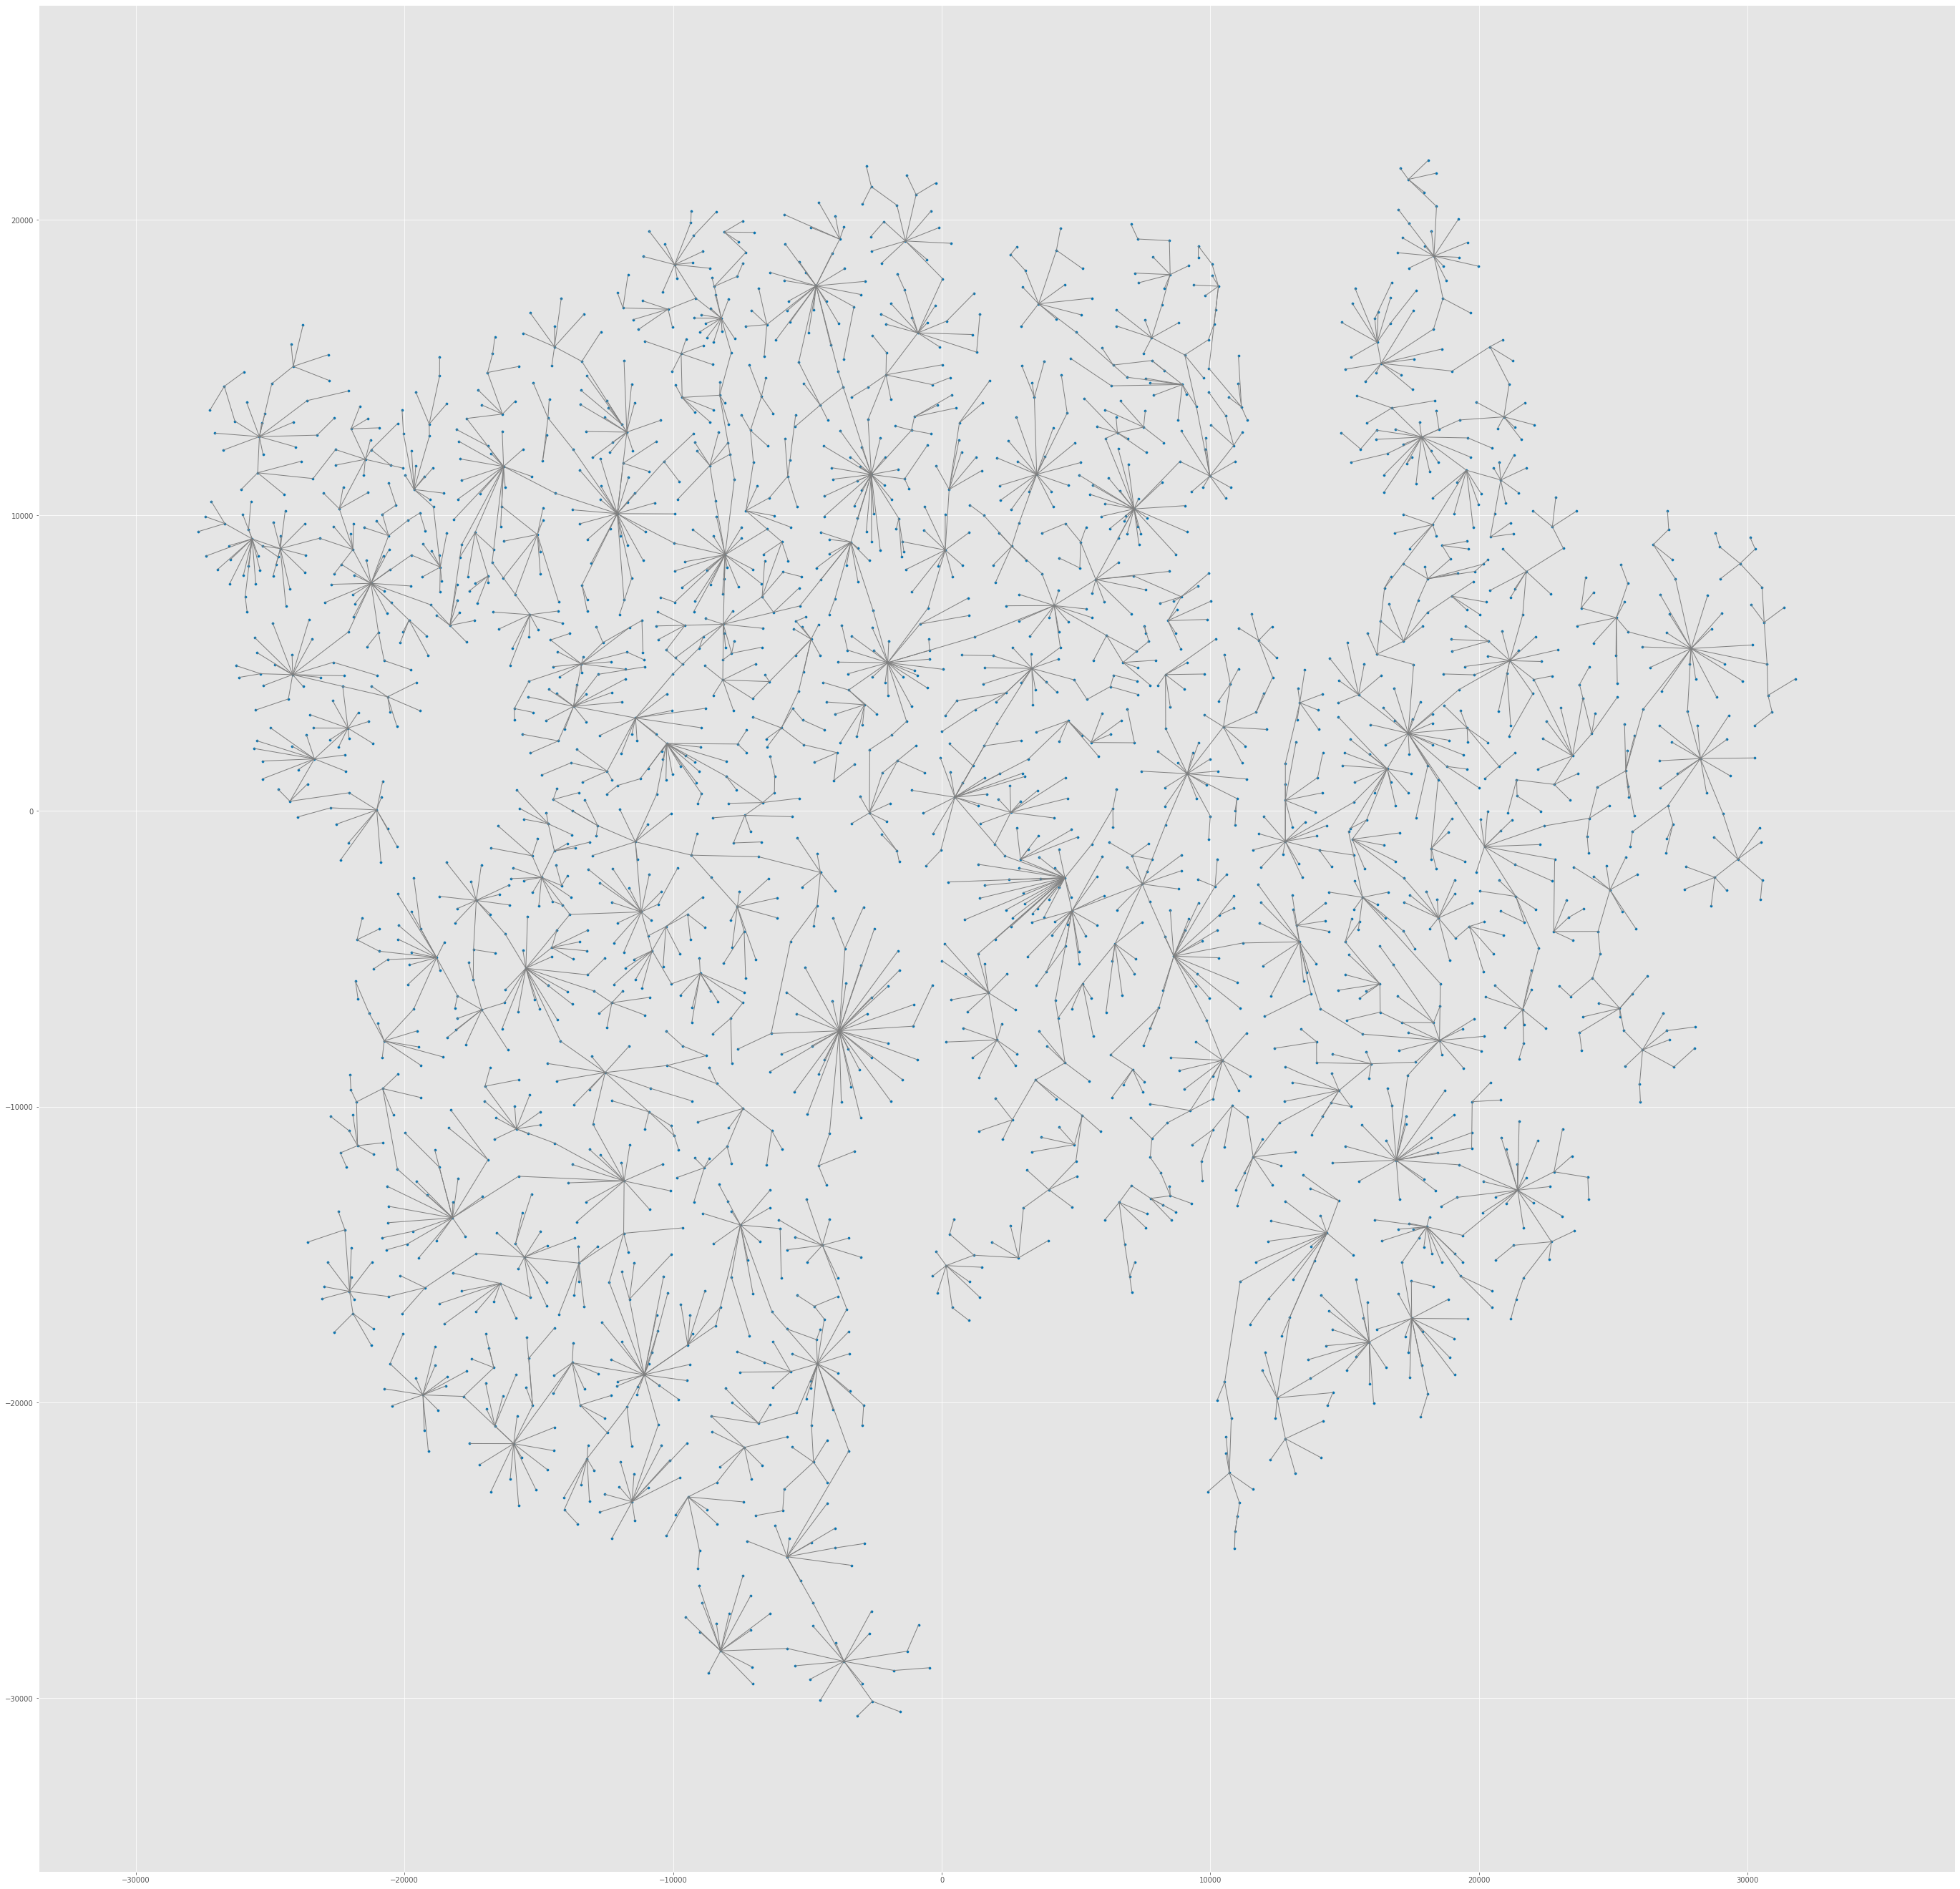

In [37]:
# dir_in = './data/json/topics-5000-low-degree/old/'
# fn = 'topics-8-sfdp'
# version = 16

dir_in = './data/json/lastfm/'
fn = 'Graph_8'
version = 2


with open(f'{dir_in}/{fn}.json') as f:
    data = json.load(f)
with open(f'{dir_in}/{fn}-nodes-{version}.json') as f:
    nodes = json.load(f)

label_to_id = {l:i for l,i in zip(data['node_label'], data['node_id'])}
id_to_label = {v:k for k,v in label_to_id.items()}

my_edges = [[id_to_label[i], id_to_label[j]] for i,j in zip(data['edge_source'], data['edge_target'])]
edge_distance = {i:w for i,w in enumerate(data['edge_weight'])}
nodes_to_levels = {label: level for label, level in zip(data['node_label'], data['node_level'])}

crd_x = {n['id']:n['x'] for n in nodes}
crd_y = {n['id']:n['y'] for n in nodes}


## verify pos

fig = plt.figure(figsize=[48,48])
ax = fig.subplots()

xy = np.array([[crd_x[k], crd_y[k]] for k in crd_x])
ax.scatter(xy[:,0], xy[:,1], s=10)


lines = [
    [(crd_x[label_to_id[l1]], crd_y[label_to_id[l1]]), 
    (crd_x[label_to_id[l2]], crd_y[label_to_id[l2]])] 
    for l1,l2 in my_edges
]
lc = mc.LineCollection(lines, colors='grey', linewidths=1)
ax.add_collection(lc)
ax.autoscale()
ax.margins(0.1)

# for l,i in label_to_id.items():
#     plt.text(crd_x[i], crd_y[i], l)
plt.show()
    

In [38]:
crd_x = {str(n['id']):n['x'] for n in nodes}
crd_y = {str(n['id']):n['y'] for n in nodes}

var = [
    ('my_edges', my_edges),
    ('label_to_id', label_to_id),
    ('id_to_label', id_to_label),
    ('edge_distance', edge_distance),
    ('nodes_to_levels', nodes_to_levels),
    ('crd_x', crd_x),
    ('crd_y', crd_y),
]

with open('out.js', 'w') as f:
    for var_name, val_value in var:
        
        f.write(f'{var_name} = ')
        f.write(json.dumps(val_value))
        f.write('\n')
        

In [80]:
short2long = {'geomicrobiology': 'geomicrobiology', 'biogeochemistry': 'biogeochemistry', 'surface engineer': 'surface engineering', 'materials engine': 'materials engineering', 'tribology': 'tribology', 'coatings': 'coatings', 'emotion': 'emotion', 'attention': 'attention', 'motivation': 'motivation', 'mood': 'mood', 'affect': 'affect', 'emotion regulati': 'emotion regulation', 'empathy': 'empathy', 'facial expressio': 'facial expressions', 'psychophysiology': 'psychophysiology', 'music psychology': 'music psychology', 'behavioral disor': 'behavioral disorders', 'cognition': 'cognition', 'air quality': 'air quality', 'atmospheric chem': 'atmospheric chemistry', 'emissions': 'emissions', 'marketing commun': 'marketing communication', 'advertising': 'advertising', 'mycology': 'mycology', 'forest pathology': 'forest pathology', 'plant pathology': 'plant pathology', 'fungi': 'fungi', 'geometric topolo': 'geometric topology', 'algebraic topolo': 'algebraic topology', 'medical image co': 'medical image computing', 'medical image an': 'medical image analysis', 'nanoscience': 'nanoscience', 'nanotechnology': 'nanotechnology', 'surface physics': 'surface physics', 'violence': 'violence', 'injury': 'injury', 'victimization': 'victimization', 'gangs': 'gangs', 'aggression': 'aggression', 'mri': 'mri', 'medical imaging': 'medical imaging', 'diffusion': 'diffusion', 'mrs': 'mrs', 'brain': 'brain', 'ct': 'ct', 'nmr': 'nmr', 'dti': 'dti', 'pet': 'pet', 'diffusion imagin': 'diffusion imaging', 'rf coils': 'rf coils', 'asthma': 'asthma', 'cystic fibrosis': 'cystic fibrosis', 'food allergy': 'food allergy', 'allergy': 'allergy', 'language teachin': 'language teaching', 'applied linguist': 'applied linguistics', 'hydrogeophysics': 'hydrogeophysics', 'near surface geo': 'near surface geophysics', 'hydrogeology': 'hydrogeology', 'environmental ge': 'environmental geophysics', 'applied geophysi': 'applied geophysics', 'dinosaurs': 'dinosaurs', 'vertebrate paleo': 'vertebrate paleontology', 'pulmonary medici': 'pulmonary medicine', 'critical care me': 'critical care medicine', 'extracellular ve': 'extracellular vesicles', 'exosomes': 'exosomes', 'optical networks': 'optical networks', 'software defined': 'software defined networking', 'optical communic': 'optical communications', 'speech processin': 'speech processing', 'acoustic signal ': 'acoustic signal processing', 'speech recogniti': 'speech recognition', 'lean': 'lean', 'agile': 'agile', 'operations manag': 'operations management', 'natural resource': 'natural resource economics', 'environmental ec': 'environmental economics', 'forest economics': 'forest economics', 'systemic functio': 'systemic functional linguistics', 'discourse analys': 'discourse analysis', 'medical image pr': 'medical image processing', 'image registrati': 'image registration', 'food intake': 'food intake', 'obesity': 'obesity', 'emotion recognit': 'emotion recognition', 'affective comput': 'affective computing', 'optical coherenc': 'optical coherence tomography', 'adaptive optics': 'adaptive optics', 'biomedical optic': 'biomedical optics', 'biomedical imagi': 'biomedical imaging', 'parkinson s dise': 'parkinson s disease', 'movement disorde': 'movement disorders', 'alpha-synuclein': 'alpha-synuclein', '39;s disease': '39;s disease', 'cochlear implant': 'cochlear implants', 'hearing loss': 'hearing loss', 'hearing aids': 'hearing aids', 'psychoacoustics': 'psychoacoustics', 'hearing': 'hearing', 'hearing impairme': 'hearing impairment', 'speech perceptio': 'speech perception', 'intergroup conta': 'intergroup contact', 'intergroup relat': 'intergroup relations', 'endocrinology': 'endocrinology', 'diabetes': 'diabetes', 'thyroid': 'thyroid', 'object tracking': 'object tracking', 'computer vision': 'computer vision', 'substance abuse': 'substance abuse', 'mental health': 'mental health', 'cell division': 'cell division', 'cytoskeleton': 'cytoskeleton', 'cell migration': 'cell migration', 'cell mechanics': 'cell mechanics', 'cancer metastasi': 'cancer metastasis', 'cell adhesion': 'cell adhesion', 'mirna': 'mirna', 'cancer': 'cancer', 'illness': 'illness', 'sociology of hea': 'sociology of health', 'health': 'health', 'systems biology': 'systems biology', 'functional genom': 'functional genomics', 'bioinformatics': 'bioinformatics', 'systems medicine': 'systems medicine', 'physical biology': 'physical biology', 'systems pharmaco': 'systems pharmacology', 'metabolic engine': 'metabolic engineering', 'synthetic biolog': 'synthetic biology', 'computational bi': 'computational biology', 'network biology': 'network biology', 'composites': 'composites', 'rhetoric': 'rhetoric', 'impact': 'impact', 'buckling': 'buckling', 'polymers': 'polymers', 'ethnomusicology': 'ethnomusicology', 'musicology': 'musicology', 'popular music': 'popular music', 'creativity': 'creativity', 'giftedness': 'giftedness', 'innovation': 'innovation', 'improvisation': 'improvisation', 'interior design': 'interior design', 'architecture': 'architecture', 'medical informat': 'medical informatics', 'health informati': 'health informatics', 'clinical decisio': 'clinical decision support', 'epidemiology': 'epidemiology', 'public health': 'public health', 'one health': 'one health', 'birth outcomes': 'birth outcomes', 'biostatistics': 'biostatistics', 'infectious disea': 'infectious diseases', 'self-assembly': 'self-assembly', 'supramolecular c': 'supramolecular chemistry', 'lithography': 'lithography', 'peptides': 'peptides', 'colloids': 'colloids', 'colloidal chemis': 'colloidal chemistry', 'block copolymers': 'block copolymers', 'exposure assessm': 'exposure assessment', 'indoor air quali': 'indoor air quality', 'air pollution': 'air pollution', 'reading developm': 'reading development', 'dyslexia': 'dyslexia', 'bose-einstein co': 'bose-einstein condensation', 'superfluidity': 'superfluidity', 'solitons': 'solitons', 'ultracold atoms': 'ultracold atoms', 'cold atoms': 'cold atoms', 'quantum gases': 'quantum gases', 'hybrid vehicles': 'hybrid vehicles', 'internal combust': 'internal combustion engines', 'open innovation': 'open innovation', 'innovation manag': 'innovation management', 'crowdsourcing': 'crowdsourcing', 'soil fertility': 'soil fertility', 'plant nutrition': 'plant nutrition', 'optomechanics': 'optomechanics', 'quantum optics': 'quantum optics', 'quantum measurem': 'quantum measurement', 'ubiquitous compu': 'ubiquitous computing', 'ambient intellig': 'ambient intelligence', 'activity recogni': 'activity recognition', 'pervasive': 'pervasive', 'mobile computing': 'mobile computing', 'context-aware co': 'context-aware computing', 'context awarenes': 'context awareness', 'human-computer i': 'human-computer interaction', 'hci': 'hci', 'technology studi': 'technology studies', 'medical sociolog': 'medical sociology', 'economic sociolo': 'economic sociology', 'science': 'science', 'social capital': 'social capital', 'social networks': 'social networks', 'himalaya': 'himalaya', 'tectonics': 'tectonics', 'auditing': 'auditing', 'internal control': 'internal control', 'financial accoun': 'financial accounting', 'corporate govern': 'corporate governance', 'fraud': 'fraud', 'accounting educa': 'accounting education', 'nanophotonics': 'nanophotonics', 'optical sensing': 'optical sensing', 'surface plasmon': 'surface plasmon', 'plasmonics': 'plasmonics', 'nanoplasmonics': 'nanoplasmonics', 'smart grid': 'smart grid', 'pmu': 'pmu', 'demand response': 'demand response', 'distributed ener': 'distributed energy resources', 'demand side mana': 'demand side management', 'power system rel': 'power system reliability', 'power line commu': 'power line communications', 'power systems': 'power systems', 'smart buildings': 'smart buildings', 'power system eco': 'power system economics', 'power market': 'power market', 'power system pro': 'power system protection', 'optical fiber se': 'optical fiber sensors', 'fiber optics': 'fiber optics', 'organizational p': 'organizational psychology', 'industrial': 'industrial', 'work': 'work', 'occupational hea': 'occupational health psychology', 'environmental ma': 'environmental management', 'sustainable deve': 'sustainable development', 'higher education': 'higher education', 'international ed': 'international education', 'college students': 'college students', 'community colleg': 'community colleges', 'student developm': 'student development', 'student affairs': 'student affairs', 'college access': 'college access', 'teaching': 'teaching', 'strategy': 'strategy', 'international bu': 'international business', 'entrepreneurship': 'entrepreneurship', 'environmental he': 'environmental health', 'occupational': 'occupational', 'risk assessment': 'risk assessment', 'bioenergetics': 'bioenergetics', 'mitochondria': 'mitochondria', 'nonlinear waves': 'nonlinear waves', 'public space': 'public space', 'urban design': 'urban design', 'skeletal muscle ': 'skeletal muscle physiology', 'exercise physiol': 'exercise physiology', 'management contr': 'management control', 'management accou': 'management accounting', 'ndt': 'ndt', 'ultrasonics': 'ultrasonics', 'real-time embedd': 'real-time embedded systems', 'cyber-physical s': 'cyber-physical systems', 'mhd': 'mhd', 'plasma physics': 'plasma physics', 'game design': 'game design', 'serious games': 'serious games', 'game studies': 'game studies', 'astroparticle ph': 'astroparticle physics', 'neutrino physics': 'neutrino physics', 'dark matter': 'dark matter', 'cosmic rays': 'cosmic rays', 'galaxy evolution': 'galaxy evolution', 'astrophysics': 'astrophysics', 'ocean modeling': 'ocean modeling', 'physical oceanog': 'physical oceanography', 'data assimilatio': 'data assimilation', 'geometry': 'geometry', 'topology': 'topology', 'penology': 'penology', 'criminology': 'criminology', 'society': 'society', 'internet': 'internet', 'law': 'law', 'social psycholog': 'social psychology', 'self': 'self', 'political psycho': 'political psychology', 'relationships': 'relationships', 'environmental ps': 'environmental psychology', 'social neuroscie': 'social neuroscience', 'group processes': 'group processes', 'morality': 'morality', 'attitudes': 'attitudes', 'prejudice': 'prejudice', 'nonverbal behavi': 'nonverbal behavior', 'cross-cultural p': 'cross-cultural psychology', 'social norms': 'social norms', 'affective scienc': 'affective science', 'close relationsh': 'close relationships', 'nephrology': 'nephrology', 'transplantation': 'transplantation', 'internal medicin': 'internal medicine', 'kidney transplan': 'kidney transplantation', 'dialysis': 'dialysis', 'systems engineer': 'systems engineering', 'engineering desi': 'engineering design', 'design theory': 'design theory', 'system architect': 'system architecture', 'behavioral econo': 'behavioral economics', 'experimental': 'experimental', 'experimental eco': 'experimental economics', 'economic psychol': 'economic psychology', 'field experiment': 'field experiments', 'parallel': 'parallel', 'distributed comp': 'distributed computing', 'knowledge organi': 'knowledge organization', 'information scie': 'information science', 'acoustic metamat': 'acoustic metamaterials', 'phononic crystal': 'phononic crystals', 'bioanalysis': 'bioanalysis', 'analytical chemi': 'analytical chemistry', 'glaucoma': 'glaucoma', 'neuroprotection': 'neuroprotection', 'ophthalmology': 'ophthalmology', 'refugee law': 'refugee law', 'human rights': 'human rights', 'place': 'place', 'space': 'space', 'environmental hi': 'environmental history', 'history of scien': 'history of science', 'cell death': 'cell death', 'autophagy': 'autophagy', 'signal transduct': 'signal transduction', 'audiology': 'audiology', 'deafness': 'deafness', 'auditory neurosc': 'auditory neuroscience', 'derecho civil': 'derecho civil', 'private law': 'private law', 'systems neurosci': 'systems neuroscience', 'computational ne': 'computational neuroscience', 'cancer imaging': 'cancer imaging', 'molecular imagin': 'molecular imaging', 'positioning': 'positioning', 'navigation': 'navigation', 'applied ecology': 'applied ecology', 'conservation bio': 'conservation biology', 'agent-based mode': 'agent-based modeling', 'social simulatio': 'social simulation', 'simulation': 'simulation', 'complex adaptive': 'complex adaptive systems', 'international or': 'international organizations', 'global governanc': 'global governance', 'limnology': 'limnology', 'zooplankton': 'zooplankton', 'aquatic ecology': 'aquatic ecology', 'paleolimnology': 'paleolimnology', 'arctic': 'arctic', 'lakes': 'lakes', 'brown adipose ti': 'brown adipose tissue', 'formación del pr': 'formación del profesorado', 'educación': 'educación', 'microbial fuel c': 'microbial fuel cell', 'bioelectrochemis': 'bioelectrochemistry', 'bioelectrochemic': 'bioelectrochemical systems', 'health insurance': 'health insurance', 'health economics': 'health economics', 'neuroimmunology': 'neuroimmunology', 'microglia': 'microglia', 'multiple scleros': 'multiple sclerosis', 'autoimmunity': 'autoimmunity', 'multiscale metho': 'multiscale methods', 'reservoir simula': 'reservoir simulation', 'fluid-structure ': 'fluid-structure interaction', 'computational fl': 'computational fluid dynamics', 'system security': 'system security', 'web security': 'web security', 'drylands': 'drylands', 'geomorphology': 'geomorphology', 'environmental ri': 'environmental risk assessment', 'ecotoxicology': 'ecotoxicology', 'mesh generation': 'mesh generation', 'computational ge': 'computational geometry', 'generic programm': 'generic programming', 'functional progr': 'functional programming', 'aquaculture': 'aquaculture', 'fish nutrition': 'fish nutrition', 'fisheries': 'fisheries', 'fish biology': 'fish biology', 'fish physiology': 'fish physiology', 'financial mathem': 'financial mathematics', 'probability theo': 'probability theory', 'print culture': 'print culture', 'book history': 'book history', 'dementia': 'dementia', 'caregiving': 'caregiving', 'aging': 'aging', 'neuropsychology': 'neuropsychology', 'alzheimer diseas': 'alzheimer disease', 'long-term care': 'long-term care', 'alzheimer s dise': 'alzheimer s disease', 'scientific compu': 'scientific computing', 'computational fi': 'computational finance', 'numerical analys': 'numerical analysis', 'numerical linear': 'numerical linear algebra', 'probabilistic pr': 'probabilistic programming', 'artificial intel': 'artificial intelligence', 'rock deformation': 'rock deformation', 'structural geolo': 'structural geology', 'metacognition': 'metacognition', 'memory': 'memory', 'self-regulated l': 'self-regulated learning', 'ferroelectrics': 'ferroelectrics', 'piezoelectric': 'piezoelectric', 'multiferroics': 'multiferroics', 'consumer behavio': 'consumer behavior', 'judgment': 'judgment', 'sport marketing': 'sport marketing', 'services marketi': 'services marketing', 'marketing': 'marketing', 'food marketing': 'food marketing', 'consumer psychol': 'consumer psychology', 'moral philosophy': 'moral philosophy', 'political philos': 'political philosophy', 'neuromorphic com': 'neuromorphic computing', 'vlsi': 'vlsi', 'memristor': 'memristor', 'theoretical ecol': 'theoretical ecology', 'community ecolog': 'community ecology', 'population biolo': 'population biology', 'tracking': 'tracking', 'localization': 'localization', 'object detection': 'object detection', 'psychology of re': 'psychology of religion', 'spirituality': 'spirituality', 'revenue manageme': 'revenue management', 'pricing': 'pricing', 'library instruct': 'library instruction', 'information lite': 'information literacy', 'metabolic syndro': 'metabolic syndrome', 'structural healt': 'structural health monitoring', 'acoustic emissio': 'acoustic emission', 'structural dynam': 'structural dynamics', 'wireless sensors': 'wireless sensors', 'smart structures': 'smart structures', 'nondestructive e': 'nondestructive evaluation', 'system identific': 'system identification', 'damage detection': 'damage detection', 'medical geograph': 'medical geography', 'gis': 'gis', 'spatial epidemio': 'spatial epidemiology', 'formal political': 'formal political theory', 'political econom': 'political economy', 'academic librari': 'academic librarianship', 'technology strat': 'technology strategy', 'geocomputation': 'geocomputation', 'biodemography': 'biodemography', 'demography': 'demography', 'flamingo project': 'flamingo project', 'network manageme': 'network management', 'cultural evoluti': 'cultural evolution', 'language evoluti': 'language evolution', 'human behavioral': 'human behavioral ecology', 'social learning': 'social learning', 'paleobiology': 'paleobiology', 'macroevolution': 'macroevolution', 'paleontology': 'paleontology', 'thermal physiolo': 'thermal physiology', 'ore deposits': 'ore deposits', 'mineralogy': 'mineralogy', 'fluid inclusions': 'fluid inclusions', 'multiscale model': 'multiscale modeling', 'computational me': 'computational mechanics', 'sensor fusion': 'sensor fusion', 'water reuse': 'water reuse', 'wastewater treat': 'wastewater treatment', 'additive manufac': 'additive manufacturing', 'rapid prototypin': 'rapid prototyping', 'selective laser ': 'selective laser melting', '3d printing': '3d printing', 'laser material p': 'laser material processing', 'inkjet printing': 'inkjet printing', 'cam': 'cam', 'recreation': 'recreation', 'leisure': 'leisure', 'parks': 'parks', 'malacology': 'malacology', 'taxonomy': 'taxonomy', 'strategic commun': 'strategic communication', 'corporate commun': 'corporate communication', 'public relations': 'public relations', 'alcohol': 'alcohol', 'tobacco': 'tobacco', 'addiction': 'addiction', 'smoking': 'smoking', 'drug': 'drug', 'popular culture': 'popular culture', 'literature': 'literature', 'hadron physics': 'hadron physics', 'nuclear physics': 'nuclear physics', 'infection': 'infection', 'immunity': 'immunity', 'meteoritics': 'meteoritics', 'planetary scienc': 'planetary science', 'web development': 'web development', 'software enginee': 'software engineering', 'argumentation': 'argumentation', 'medical robotics': 'medical robotics', 'haptics': 'haptics', 'policing': 'policing', 'peacekeeping': 'peacekeeping', 'civil war': 'civil war', 'fem': 'fem', 'dem': 'dem', 'neural networks': 'neural networks', 'machine learning': 'machine learning', 'data protection': 'data protection', 'privacy': 'privacy', 'solidification': 'solidification', 'welding': 'welding', 'casting': 'casting', 'graph theory': 'graph theory', 'algorithms': 'algorithms', 'combinatorics': 'combinatorics', 'discrete mathema': 'discrete mathematics', 'linear algebra': 'linear algebra', 'magnonics': 'magnonics', 'spin waves': 'spin waves', 'spintronics': 'spintronics', 'data integration': 'data integration', 'semantic web': 'semantic web', 'data quality': 'data quality', 'computational li': 'computational linguistics', 'natural language': 'natural language processing', 'corpus linguisti': 'corpus linguistics', 'dialogue': 'dialogue', 'distributional s': 'distributional semantics', 'lexical semantic': 'lexical semantics', 'computational se': 'computational semantics', 'natural langua02': 'natural language generation', 'pregnancy': 'pregnancy', 'delinquency': 'delinquency', 'juvenile justice': 'juvenile justice', 'crime': 'crime', 'mcmc': 'mcmc', 'bayesian statist': 'bayesian statistics', 'public opinion': 'public opinion', 'american politic': 'american politics', 'political partic': 'political participation', 'political behavi': 'political behaviour', 'automated planni': 'automated planning', 'atom optics': 'atom optics', 'health professio': 'health professions education', 'medical educatio': 'medical education', 'mobile systems': 'mobile systems', 'wireless network': 'wireless networks', 'atmosphere': 'atmosphere', 'ocean': 'ocean', 'climate dynamics': 'climate dynamics', 'traffic flow the': 'traffic flow theory', 'intelligent tran': 'intelligent transportation systems', 'synthesis': 'synthesis', 'verification': 'verification', 'characterization': 'characterization', 'corrosion': 'corrosion', 'electrochemistry': 'electrochemistry', 'health physics': 'health physics', 'medical physics': 'medical physics', 'neurogenesis': 'neurogenesis', 'epilepsy': 'epilepsy', 'publicidad': 'publicidad', 'periodismo': 'periodismo', 'islet biology': 'islet biology', 'cell cycle': 'cell cycle', 'dna replication': 'dna replication', 'mitosis': 'mitosis', 'urban regenerati': 'urban regeneration', 'urban planning': 'urban planning', 'security studies': 'security studies', 'international re': 'international relations', 'seizures': 'seizures', 'eeg': 'eeg', 'child neurology': 'child neurology', 'quantum technolo': 'quantum technologies', 'devices': 'devices', 'semiconductor ph': 'semiconductor physics', 'electronic mater': 'electronic materials', 'optoelectronic m': 'optoelectronic materials', 'semiconductor ma': 'semiconductor materials', 'population healt': 'population health', 'social epidemiol': 'social epidemiology', 'genomic imprinti': 'genomic imprinting', 'epigenetics': 'epigenetics', 'hydrometeorology': 'hydrometeorology', 'hydrology': 'hydrology', 'fracture': 'fracture', 'damage': 'damage', 'adhesion': 'adhesion', 'fatigue': 'fatigue', 'electronic packa': 'electronic packaging', 'reliability': 'reliability', 'power converters': 'power converters', 'power electronic': 'power electronics', 'polymer chemistr': 'polymer chemistry', 'organic chemistr': 'organic chemistry', 'motor learning': 'motor learning', 'motor control': 'motor control', 'democratization': 'democratization', 'authoritarianism': 'authoritarianism', 'comparative poli': 'comparative politics', 'ethnic conflict': 'ethnic conflict', 'fmri': 'fmri', 'erp': 'erp', 'brain computer i': 'brain computer interface', 'ecg': 'ecg', 'bci': 'bci', 'meg': 'meg', 'emg': 'emg', 'chemoinformatics': 'chemoinformatics', 'molecular modeli': 'molecular modeling', 'medicine': 'medicine', 'biology': 'biology', 'rechargeable bat': 'rechargeable batteries', 'microwave photon': 'microwave photonics', 'food systems': 'food systems', 'sustainability': 'sustainability', 'neuro-oncology': 'neuro-oncology', 'neurosurgery': 'neurosurgery', 'neurological sur': 'neurological surgery', 'sociology of edu': 'sociology of education', 'education policy': 'education policy', 'social stratific': 'social stratification', 'neuroendocrinolo': 'neuroendocrinology', 'reproductive end': 'reproductive endocrinology', 'child nutrition': 'child nutrition', 'maternal': 'maternal', 'public choice': 'public choice', 'lasers': 'lasers', 'nonlinear optics': 'nonlinear optics', 'accelerators': 'accelerators', 'optics': 'optics', 'superconductors': 'superconductors', 'topological insu': 'topological insulators', 'combustion': 'combustion', 'laser diagnostic': 'laser diagnostics', 'soot formation': 'soot formation', 'cfd': 'cfd', 'alternative fuel': 'alternative fuels', 'propulsion': 'propulsion', 'gas turbines': 'gas turbines', 'explosion': 'explosion', 'gasification': 'gasification', 'fuels': 'fuels', 'flames': 'flames', 'thermoacoustics': 'thermoacoustics', 'energetic materi': 'energetic materials', 'soot': 'soot', 'chemical kinetic': 'chemical kinetics', 'rnai': 'rnai', 'microrna': 'microrna', 'dark silicon': 'dark silicon', 'computer archite': 'computer architecture', 'altmetrics': 'altmetrics', 'scholarly commun': 'scholarly communication', 'open access': 'open access', 'bibliometrics': 'bibliometrics', 'geometric modeli': 'geometric modeling', 'computer graphic': 'computer graphics', 'polyoxometalates': 'polyoxometalates', 'catalysis': 'catalysis', 'methylation': 'methylation', 'hydroinformatics': 'hydroinformatics', 'water resources': 'water resources', 'membrane traffic': 'membrane traffic', 'cell biology': 'cell biology', 'vehicle routing': 'vehicle routing', 'metaheuristics': 'metaheuristics', 'muscle': 'muscle', 'exercise': 'exercise', 'nonlinear circui': 'nonlinear circuits', 'systems': 'systems', 'radiation protec': 'radiation protection', 'spatial modeling': 'spatial modeling', 'global justice': 'global justice', 'mechanism design': 'mechanism design', 'algorithmic game': 'algorithmic game theory', 'auction theory': 'auction theory', 'metasurfaces': 'metasurfaces', 'metamaterials': 'metamaterials', 'economic geograp': 'economic geography', 'innovation studi': 'innovation studies', 'urban economics': 'urban economics', 'regional develop': 'regional development', 'evolutionary eco': 'evolutionary economics', 'regional science': 'regional science', 'political geogra': 'political geography', 'evolutionary e02': 'evolutionary economic geography', 'ubicomp': 'ubicomp', 'artificial life': 'artificial life', 'complex systems': 'complex systems', 'evolutionary rob': 'evolutionary robotics', 'evolutionary com': 'evolutionary computation', 'plant breeding': 'plant breeding', 'genetics': 'genetics', 'plant genetics': 'plant genetics', 'photogrammetry': 'photogrammetry', 'remote sensing': 'remote sensing', 'geomatics': 'geomatics', 'cultural heritag': 'cultural heritage', '3d modeling': '3d modeling', 'prosocial behavi': 'prosocial behavior', 'social cognition': 'social cognition', 'stigma': 'stigma', 'animal cognition': 'animal cognition', 'comparative cogn': 'comparative cognition', 'animal behaviour': 'animal behaviour', 'marine protected': 'marine protected areas', 'membrane distill': 'membrane distillation', 'desalination': 'desalination', 'cosmology': 'cosmology', 'inflation': 'inflation', 'particle physics': 'particle physics', 'reionization': 'reionization', 'large scale stru': 'large scale structure', 'gravity': 'gravity', 'modified gravity': 'modified gravity', 'extragalactic as': 'extragalactic astronomy', 'galaxy formation': 'galaxy formation', 'relativity': 'relativity', 'gravitational le': 'gravitational lensing', 'cosmic microwave': 'cosmic microwave background', 'cmb': 'cmb', 'theoretical part': 'theoretical particle physics', 'epoch of reioniz': 'epoch of reionization', 'particle astroph': 'particle astrophysics', 'medical biochemi': 'medical biochemistry', 'molecular biolog': 'molecular biology', 'active transport': 'active transportation', 'built environmen': 'built environment', 'visual computing': 'visual computing', 'running': 'running', 'biomechanics': 'biomechanics', 'personnel econom': 'personnel economics', 'organizational e': 'organizational economics', 'labor economics': 'labor economics', 'filosofía': 'filosofía', 'sociología': 'sociología', 'ética': 'ética', 'guidance': 'guidance', 'control': 'control', 'archaeobotany': 'archaeobotany', 'environmental ar': 'environmental archaeology', 'spatial ecology': 'spatial ecology', 'movement ecology': 'movement ecology', 'patent law': 'patent law', 'intellectual pro': 'intellectual property', 'formal methods': 'formal methods', 'testing': 'testing', 'automated reason': 'automated reasoning', 'validation': 'validation', 'risk perception': 'risk perception', 'risk communicati': 'risk communication', 'social relations': 'social relationships', 'international ma': 'international macroeconomics', 'macroeconomics': 'macroeconomics', 'asteroids': 'asteroids', 'comets': 'comets', 'health dispariti': 'health disparities', 'minority health': 'minority health', 'latino health': 'latino health', 'african american': 'african american', 'social determina': 'social determinants of health', 'health behavior': 'health behavior', 'venture capital': 'venture capital', 'corporate financ': 'corporate finance', 'private equity': 'private equity', 'high energy dens': 'high energy density physics', 'inertial confine': 'inertial confinement fusion', 'bioética': 'bioética', 'general practice': 'general practice', 'primary care': 'primary care', 'porous materials': 'porous materials', 'metal-organic fr': 'metal-organic frameworks', 'adsorption': 'adsorption', 'circadian rhythm': 'circadian rhythms', 'melatonin': 'melatonin', 'sleep': 'sleep', 'chronobiology': 'chronobiology', 'psychoneuroendoc': 'psychoneuroendocrinology', 'stress': 'stress', 'embedded systems': 'embedded systems', 'real-time': 'real-time', 'hardware design': 'hardware design', 'hw': 'hw', 'reconfigurable a': 'reconfigurable architectures', 'system on chip': 'system on chip', 'hardware': 'hardware', 'system-level des': 'system-level design', 'real-time system': 'real-time systems', 'design automatio': 'design automation', 'economics of agi': 'economics of aging', 'physical activit': 'physical activity', 'sports science': 'sports science', 'training': 'training', 'fitness': 'fitness', 'chemical': 'chemical', 'biological engin': 'biological engineering', 'biomolecular eng': 'biomolecular engineering', 'environmental en': 'environmental engineering', 'nuclear medicine': 'nuclear medicine', 'contrast agents': 'contrast agents', 'microbial genomi': 'microbial genomics', 'microbial evolut': 'microbial evolution', 'metagenomics': 'metagenomics', 'metal forming': 'metal forming', 'thermomechanical': 'thermomechanical processing', 'dft': 'dft', 'capital structur': 'capital structure', 'mergers': 'mergers', 'otolaryngology': 'otolaryngology', 'head': 'head', 'myeloma': 'myeloma', 'lymphoma': 'lymphoma', 'rram': 'rram', 'nonlinear analys': 'nonlinear analysis', 'differential equ': 'differential equations', 'partial differen': 'partial differential equations', 'quaternary': 'quaternary', 'mobile communica': 'mobile communication', 'wireless': 'wireless', 'cell therapy': 'cell therapy', 'gene therapy': 'gene therapy', 'regenerative med': 'regenerative medicine', 'faults': 'faults', 'dimensionality r': 'dimensionality reduction', 'urban informatic': 'urban informatics', 'gamification': 'gamification', 'condensed matter': 'condensed matter', 'superconductivit': 'superconductivity', 'materials physic': 'materials physics', 'longevity': 'longevity', 'literary theory': 'literary theory', 'modernism': 'modernism', 'american literat': 'american literature', 'comparative lite': 'comparative literature', 'information-cent': 'information-centric networking', 'computer network': 'computer networks', 'web 2.0': 'web 2.0', 'e-learning': 'e-learning', 'severe plastic d': 'severe plastic deformation', 'differential pri': 'differential privacy', 'radio astronomy': 'radio astronomy', 'mimo': 'mimo', 'ofdm': 'ofdm', 'wireless communi': 'wireless communications', 'cooperative comm': 'cooperative communications', 'cancer preventio': 'cancer prevention', 'tobacco control': 'tobacco control', 'biomaterials': 'biomaterials', 'biointerfaces': 'biointerfaces', 'drug delivery': 'drug delivery', 'bone repair': 'bone repair', 'stem cell engine': 'stem cell engineering', 'nanomedicine': 'nanomedicine', 'drug delivery sy': 'drug delivery systems', 'surface modifica': 'surface modification', 'stem cells': 'stem cells', 'biodegradable po': 'biodegradable polymers', 'gene delivery': 'gene delivery', 'bioengineering': 'bioengineering', 'dental materials': 'dental materials', 'bioceramics': 'bioceramics', 'biocompatibility': 'biocompatibility', '3d cell culture': '3d cell culture', 'immunoengineerin': 'immunoengineering', 'bone tissue engi': 'bone tissue engineering', 'extracellular ma': 'extracellular matrix', 'scaffold': 'scaffold', 'atmospheric scie': 'atmospheric science', 'meteorology': 'meteorology', 'physical chemist': 'physical chemistry', 'computational ch': 'computational chemistry', 'photochemistry': 'photochemistry', 'chemical physics': 'chemical physics', 'time-resolved sp': 'time-resolved spectroscopy', 'spectroscopy': 'spectroscopy', 'laser spectrosco': 'laser spectroscopy', 'molecular spectr': 'molecular spectroscopy', 'information beha': 'information behaviour', 'graphic design': 'graphic design', 'typography': 'typography', 'surface': 'surface', 'interfaces': 'interfaces', 'electronics': 'electronics', 'photonics': 'photonics', 'coding theory': 'coding theory', 'information theo': 'information theory', 'network informat': 'network information theory', 'information': 'information', 'historia del art': 'historia del arte', 'historia': 'historia', 'industrial ecolo': 'industrial ecology', 'life cycle asses': 'life cycle assessment', 'circular economy': 'circular economy', 'waste management': 'waste management', 'ecological econo': 'ecological economics', 'rehabilitation e': 'rehabilitation engineering', 'data warehouse': 'data warehouse', 'business intelli': 'business intelligence', 'evolution': 'evolution', 'protists': 'protists', 'phenotypic plast': 'phenotypic plasticity', 'behavior': 'behavior', 'ecology': 'ecology', 'genomics': 'genomics', 'insects': 'insects', 'microbes': 'microbes', 'anesthesiology': 'anesthesiology', 'general surgery': 'general surgery', 'surgical oncolog': 'surgical oncology', 'pediatric surger': 'pediatric surgery', 'vascular surgery': 'vascular surgery', 'metaphor': 'metaphor', 'language': 'language', 'nutraceuticals': 'nutraceuticals', 'functional foods': 'functional foods', 'adherence': 'adherence', 'hiv': 'hiv', 'computer experim': 'computer experiments', 'statistics': 'statistics', 'consumer behav02': 'consumer behaviour', 'social marketing': 'social marketing', 'pediatrics': 'pediatrics', 'neonatology': 'neonatology', 'antenna theory': 'antenna theory', 'design': 'design', 'thermosphere': 'thermosphere', 'ionosphere': 'ionosphere', 'eating behavior': 'eating behavior', 'carbon capture': 'carbon capture', 'sequestration': 'sequestration', 'storage': 'storage', 'gas separation': 'gas separation', 'gentrification': 'gentrification', 'housing': 'housing', 'urban studies': 'urban studies', 'leadership devel': 'leadership development', 'leadership': 'leadership', 'exergy analysis': 'exergy analysis', 'energy': 'energy', 'peer-to-peer': 'peer-to-peer', 'distributed syst': 'distributed systems', 'party politics': 'party politics', 'political partie': 'political parties', 'chinese politics': 'chinese politics', 'latin american p': 'latin american politics', 'european politic': 'european politics', 'political econ02': 'political economy of development', 'latin america': 'latin america', 'legislative stud': 'legislative studies', 'economic evaluat': 'economic evaluation', 'biochar': 'biochar', 'pyrolysis': 'pyrolysis', 'halogen bonding': 'halogen bonding', 'prostate cancer': 'prostate cancer', 'androgen recepto': 'androgen receptor', 'kidney cancer': 'kidney cancer', 'copyright': 'copyright', 'patents': 'patents', 'development econ': 'development economics', 'cultural economi': 'cultural economics', 'corruption': 'corruption', 'lexicology': 'lexicology', 'lexicography': 'lexicography', 'drives': 'drives', 'theoretical biol': 'theoretical biology', 'mathematical bio': 'mathematical biology', 'underwater acous': 'underwater acoustics', 'signal processin': 'signal processing', 'vaccines': 'vaccines', 'immunotherapy': 'immunotherapy', 'influenza': 'influenza', 'immunology': 'immunology', 'cognitive radio ': 'cognitive radio networks', 'geovisualization': 'geovisualization', 'giscience': 'giscience', 'cartography': 'cartography', 'petrophysics': 'petrophysics', 'reservoir charac': 'reservoir characterization', 'rock physics': 'rock physics', 'sdn': 'sdn', '5g': '5g', 'nfv': 'nfv', 'logistics': 'logistics', 'freight': 'freight', 'material handlin': 'material handling', 'supply chain': 'supply chain', 'supply chain man': 'supply chain management', 'transportation': 'transportation', 'scm': 'scm', 'brain injury': 'brain injury', 'rehabilitation': 'rehabilitation', 'metamorphic petr': 'metamorphic petrology', 'nicotine': 'nicotine', 'oral surgery': 'oral surgery', 'dentistry': 'dentistry', 'grief': 'grief', 'trauma': 'trauma', 'bereavement': 'bereavement', 'family firms': 'family firms', 'family business': 'family business', 'anomaly detectio': 'anomaly detection', 'graph mining': 'graph mining', 'immigration': 'immigration', 'latino': 'latino', 'latino politics': 'latino politics', 'ethnicity': 'ethnicity', 'thermochronology': 'thermochronology', 'protein nmr': 'protein nmr', 'structural biolo': 'structural biology', 'ocean acidificat': 'ocean acidification', 'coral reefs': 'coral reefs', 'labor': 'labor', 'demographic econ': 'demographic economics', 'migration': 'migration', 'international de': 'international development', 'poverty': 'poverty', 'digital': 'digital', 'social media': 'social media', 'emergency medici': 'emergency medicine', 'resuscitation': 'resuscitation', 'disaster medicin': 'disaster medicine', 'theoretical': 'theoretical', 'observational co': 'observational cosmology', 'language therapy': 'language therapy', 'speech': 'speech', 'private internat': 'private international law', 'comparative law': 'comparative law', 'smart materials': 'smart materials', 'shape memory all': 'shape memory alloys', 'soft robotics': 'soft robotics', 'structures': 'structures', 'evaluation': 'evaluation', 'monitoring': 'monitoring', 'assessment': 'assessment', 'word of mouth': 'word of mouth', 'branding': 'branding', 'consumer culture': 'consumer culture theory', 'services': 'services', 'consumer cultu02': 'consumer culture', 'retailing': 'retailing', 'consumer': 'consumer', 'macromarketing': 'macromarketing', 'hedge funds': 'hedge funds', 'asset pricing': 'asset pricing', 'institutional in': 'institutional investors', 'mutual funds': 'mutual funds', 'philosophy of la': 'philosophy of language', 'pragmatics': 'pragmatics', 'philosophy of lo': 'philosophy of logic', 'metaethics': 'metaethics', 'igneous petrolog': 'igneous petrology', 'experimental pet': 'experimental petrology', 'geochemistry': 'geochemistry', 'health education': 'health education', 'health promotion': 'health promotion', 'speech enhanceme': 'speech enhancement', 'biological ocean': 'biological oceanography', 'zooplankton ecol': 'zooplankton ecology', 'economics of edu': 'economics of education', 'labour economics': 'labour economics', 'hearing science': 'hearing science', 'glacier hydrolog': 'glacier hydrology', 'glaciology': 'glaciology', 'constitutional t': 'constitutional theory', 'constitutional l': 'constitutional law', 'financial report': 'financial reporting', 'nutrigenomics': 'nutrigenomics', 'nutrition': 'nutrition', 'nutrigenetics': 'nutrigenetics', 'surgery': 'surgery', 'operating system': 'operating systems', 'cloud computing': 'cloud computing', 'middleware': 'middleware', 'distributed algo': 'distributed algorithms', 'fault tolerance': 'fault tolerance', 'p2p': 'p2p', 'stream processin': 'stream processing', 'networks': 'networks', 'tectonophysics': 'tectonophysics', 'geodynamics': 'geodynamics', 'european union': 'european union', 'european integra': 'european integration', 'steganography': 'steganography', 'steganalysis': 'steganalysis', 'watermarking': 'watermarking', 'cryptography': 'cryptography', 'information hidi': 'information hiding', 'vaccine developm': 'vaccine development', 'planetary atmosp': 'planetary atmospheres', 'exoplanets': 'exoplanets', 'academic libra02': 'academic libraries', 'biodiversity': 'biodiversity', 'vegetation ecolo': 'vegetation ecology', 'dna barcoding': 'dna barcoding', 'biogeography': 'biogeography', 'energy policy': 'energy policy', 'climate policy': 'climate policy', 'energy security': 'energy security', 'environmental po': 'environmental policy', 'energy economics': 'energy economics', 'molecular physic': 'molecular physics', 'atomic': 'atomic', 'care': 'care', 'early childhood ': 'early childhood education', 'web search': 'web search', 'information retr': 'information retrieval', 'strategic allian': 'strategic alliances', 'power system ope': 'power system operation', 'electricity mark': 'electricity markets', 'planning': 'planning', 'power system pla': 'power system planning', 'vanet': 'vanet', 'ad hoc networks': 'ad hoc networks', 'mac': 'mac', 'cognitive networ': 'cognitive networks', 'vehicular networ': 'vehicular networks', 'wireless securit': 'wireless security', 'network economic': 'network economics', 'sensor networks': 'sensor networks', 'mac protocols': 'mac protocols', 'complex traits': 'complex traits', 'human genetics': 'human genetics', 'dna repair': 'dna repair', 'invasive species': 'invasive species', 'restoration ecol': 'restoration ecology', 'dielectrics': 'dielectrics', 'nuclear receptor': 'nuclear receptors', 'metabolism': 'metabolism', 'separation': 'separation', 'flow chemistry': 'flow chemistry', 'brain developmen': 'brain development', 'neuroimaging': 'neuroimaging', 'multilevel conve': 'multilevel converters', 'public budgeting': 'public budgeting', 'finance': 'finance', 'inflammation': 'inflammation', 'document analysi': 'document analysis', 'pattern recognit': 'pattern recognition', 'family law': 'family law', 'courts': 'courts', 'economics': 'economics', 'legal education': 'legal education', 'intellectual p02': 'intellectual property law', 'contracts': 'contracts', 'gene expression': 'gene expression', 'transcription': 'transcription', 'device physics': 'device physics', 'organic semicond': 'organic semiconductors', 'pharmaceutical t': 'pharmaceutical technology', 'software engin02': 'software engineering education', 'plant-insect int': 'plant-insect interactions', 'chemical ecology': 'chemical ecology', 'mixed reality': 'mixed reality', 'virtual reality': 'virtual reality', 'phase transforma': 'phase transformation', 'steel': 'steel', 'nanogenerator': 'nanogenerator', 'energy harvestin': 'energy harvesting', 'radar systems': 'radar systems', 'science of scien': 'science of science', 'seismic engineer': 'seismic engineering', 'structural engin': 'structural engineering', 'travel behavior': 'travel behavior', 'transportation p': 'transportation planning', 'transistors': 'transistors', 'solar cells': 'solar cells', 'conservation pla': 'conservation planning', 'landscape ecolog': 'landscape ecology', 'memory managemen': 'memory management', 'nanotoxicology': 'nanotoxicology', 'media policy': 'media policy', 'media': 'media', 'legal philosophy': 'legal philosophy', 'circuits': 'circuits', 'human computatio': 'human computation', 'buildings': 'buildings', 'systematics': 'systematics', 'zoology': 'zoology', 'obesidade': 'obesidade', 'nutrición': 'nutrición', 'brain tumors': 'brain tumors', 'radiosurgery': 'radiosurgery', 'skull base': 'skull base', 'regional': 'regional', 'real estate': 'real estate', 'public economics': 'public economics', 'spatial economic': 'spatial economics', 'real estate econ': 'real estate economics', 'convex optimizat': 'convex optimization', 'convex analysis': 'convex analysis', 'thermal sciences': 'thermal sciences', 'nanoscale heat t': 'nanoscale heat transfer', 'heat transfer': 'heat transfer', 'film': 'film', 'television': 'television', 'documentary': 'documentary', 'cinema': 'cinema', 'recycling': 'recycling', 'plasticity': 'plasticity', 'reproductive bio': 'reproductive biology', 'oocyte': 'oocyte', 'infertility': 'infertility', 'andrology': 'andrology', 'coal preparation': 'coal preparation', 'mineral processi': 'mineral processing', 'liberalism': 'liberalism', 'political theory': 'political theory', 'sport': 'sport', 'exercise psychol': 'exercise psychology', 'physical educati': 'physical education', 'exercise science': 'exercise science', 'macromolecular c': 'macromolecular crystallography', 'ornithology': 'ornithology', 'recommender syst': 'recommender systems', 'collaborative fi': 'collaborative filtering', 'user modeling': 'user modeling', 'data mining': 'data mining', 'information filt': 'information filtering', 'monte carlo meth': 'monte carlo methods', 'chemistry educat': 'chemistry education', 'science educatio': 'science education', 'rna biology': 'rna biology', 'virology': 'virology', 'topological dyna': 'topological dynamics', 'ergodic theory': 'ergodic theory', 'biomass': 'biomass', 'bioenergy': 'bioenergy', 'coal': 'coal', 'lignin': 'lignin', 'star formation': 'star formation', 'planet formation': 'planet formation', 'interstellar med': 'interstellar medium', 'behavioural econ': 'behavioural economics', 'biofuels': 'biofuels', 'biorefinery': 'biorefinery', 'biosphere-atmosp': 'biosphere-atmosphere interactions', 'microchannels': 'microchannels', 'multilevel model': 'multilevel modeling', 'structural equat': 'structural equation modeling', 'nk cells': 'nk cells', 'media psychology': 'media psychology', 'media effects': 'media effects', 'video games': 'video games', 'forecasting': 'forecasting', 'time series anal': 'time series analysis', 'time series': 'time series', 'conflict resolut': 'conflict resolution', 'mediation': 'mediation', 'peacebuilding': 'peacebuilding', 'power integrity': 'power integrity', 'signal integrity': 'signal integrity', 'european studies': 'european studies', 'microwave imagin': 'microwave imaging', 'computational el': 'computational electromagnetics', 'persuasive techn': 'persuasive technology', 'tax': 'tax', 'accounting': 'accounting', 'program evaluati': 'program evaluation', 'research methods': 'research methods', 'causal inference': 'causal inference', 'lactation': 'lactation', 'soc': 'soc', 'low power design': 'low power design', 'low power': 'low power', 'transportation s': 'transportation safety', 'traffic operatio': 'traffic operations', 'transportation e': 'transportation engineering', 'clinical': 'clinical', 'health psycholog': 'health psychology', 'heart': 'heart', 'basal ganglia': 'basal ganglia', 'dopamine': 'dopamine', 'neurodegeneratio': 'neurodegeneration', 'panel data': 'panel data', 'econometrics': 'econometrics', 'nanofabrication': 'nanofabrication', 'longitudinal dat': 'longitudinal data analysis', 'survival analysi': 'survival analysis', 'therapeutics': 'therapeutics', 'cancer biology': 'cancer biology', 'genome engineeri': 'genome engineering', 'cell-free protei': 'cell-free protein synthesis', 'dna nanotechnolo': 'dna nanotechnology', 'protein engineer': 'protein engineering', 'software verific': 'software verification', 'cognitive neuros': 'cognitive neuroscience', 'cognitive psycho': 'cognitive psychology', 'neurobiology of ': 'neurobiology of language', 'time perception': 'time perception', 'computational ps': 'computational psychiatry', 'educational neur': 'educational neuroscience', 'clinical neurops': 'clinical neuropsychology', 'numerical cognit': 'numerical cognition', 'augmented realit': 'augmented reality', 'space science': 'space science', 'economics of inn': 'economics of innovation', 'bariatric surger': 'bariatric surgery', 'systems analysis': 'systems analysis', 'water resources ': 'water resources management', 'granular materia': 'granular materials', 'discrete element': 'discrete element method', 'environmental bi': 'environmental biotechnology', 'environmental mi': 'environmental microbiology', 'asylum': 'asylum', 'transitional jus': 'transitional justice', 'microbiota': 'microbiota', 'mucosal immunolo': 'mucosal immunology', 'non-volatile mem': 'non-volatile memory', 'philosophy of 02': 'philosophy of law', 'legal theory': 'legal theory', 'membranes': 'membranes', 'co2 capture': 'co2 capture', 'purification': 'purification', 'gene editing': 'gene editing', 'viral vectors': 'viral vectors', 'retinal degenera': 'retinal degeneration', 'concurrency': 'concurrency', 'magnetic materia': 'magnetic materials', 'information visu': 'information visualization', 'graph drawing': 'graph drawing', 'visual analytics': 'visual analytics', 'geophysics': 'geophysics', 'geology': 'geology', 'geodesy': 'geodesy', 'geothermal': 'geothermal', 'earthquake scien': 'earthquake science', 'seismic': 'seismic', 'exploration seis': 'exploration seismology', 'magnetotellurics': 'magnetotellurics', 'inversion': 'inversion', 'social policy': 'social policy', 'welfare state': 'welfare state', 'social work': 'social work', 'inorganic chemis': 'inorganic chemistry', 'main group chemi': 'main group chemistry', 'coordination che': 'coordination chemistry', 'materials chemis': 'materials chemistry', 'organometallic c': 'organometallic chemistry', 'internet of thin': 'internet of things', 'web of things': 'web of things', 'smart cities': 'smart cities', 'wireless sensor ': 'wireless sensor networks', 'biomedical infor': 'biomedical informatics', 'applied ontology': 'applied ontology', 'clinical researc': 'clinical research informatics', 'ontologies': 'ontologies', 'artificial pancr': 'artificial pancreas', 'fertility': 'fertility', 'population studi': 'population studies', 'family sociology': 'family sociology', 'social statistic': 'social statistics', 'family': 'family', 'mortality': 'mortality', 'sociology': 'sociology', 'performance': 'performance', 'theatre': 'theatre', 'phonetics': 'phonetics', 'laboratory phono': 'laboratory phonology', 'speech technolog': 'speech technology', 'phonology': 'phonology', 'dialectology': 'dialectology', 'prosody': 'prosody', 'forensic phoneti': 'forensic phonetics', 'linguistics': 'linguistics', 'pharmaceutical p': 'pharmaceutical policy', 'pharmacoeconomic': 'pharmacoeconomics', 'paleoceanography': 'paleoceanography', 'paleoclimate': 'paleoclimate', 'marine geology': 'marine geology', 'plant evolution': 'plant evolution', 'phylogenetics': 'phylogenetics', 'orthodontics': 'orthodontics', 'periodontics': 'periodontics', 'prosthodontics': 'prosthodontics', 'oral medicine': 'oral medicine', 'endodontics': 'endodontics', 'nanoantennas': 'nanoantennas', 'intercultural co': 'intercultural communication', 'biological contr': 'biological control', 'ipm': 'ipm', 'entomology': 'entomology', 'pest management': 'pest management', 'commercial law': 'commercial law', 'hemostasis': 'hemostasis', 'hematology': 'hematology', 'thrombosis': 'thrombosis', 'wireless ad hoc': 'wireless ad hoc', 'ad hoc': 'ad hoc', 'disasters': 'disasters', 'natural hazards': 'natural hazards', 'mems': 'mems', 'gyroscopes': 'gyroscopes', 'sensors': 'sensors', 'inertial sensors': 'inertial sensors', 'microfabrication': 'microfabrication', 'microsystems': 'microsystems', 'nems': 'nems', 'resonators': 'resonators', 'nanomanufacturin': 'nanomanufacturing', 'microfluidics': 'microfluidics', 'biomedical devic': 'biomedical devices', 'moems': 'moems', 'software codesig': 'software codesign', 'reverse engineer': 'reverse engineering', 'cad': 'cad', 'geotechnical eng': 'geotechnical engineering', 'geoenvironmental': 'geoenvironmental engineering', 'soil mechanics': 'soil mechanics', 'engineering geol': 'engineering geology', 'soil dynamics': 'soil dynamics', 'geomechanics': 'geomechanics', 'pavement enginee': 'pavement engineering', 'ground improveme': 'ground improvement', 'offshore enginee': 'offshore engineering', 'unsaturated soil': 'unsaturated soils', 'civil engineerin': 'civil engineering', 'emotional learni': 'emotional learning', 'social': 'social', 'history of archi': 'history of architecture', 'occupational the': 'occupational therapy', 'physical medicin': 'physical medicine', 'stroke': 'stroke', 'physical therapy': 'physical therapy', 'physiotherapy': 'physiotherapy', 'quantitative met': 'quantitative methods', 'child-computer i': 'child-computer interaction', 'guidance navigat': 'guidance navigation', 'quantum groups': 'quantum groups', 'hopf algebras': 'hopf algebras', 'noncommutative g': 'noncommutative geometry', 'representation t': 'representation theory', 'translation': 'translation', 'interpreting': 'interpreting', 'terminology': 'terminology', 'rna polymerase': 'rna polymerase', 'mammals': 'mammals', 'vlsi design': 'vlsi design', 'hardware securit': 'hardware security', 'international tr': 'international trade', 'multinationals': 'multinationals', 'foreign direct i': 'foreign direct investment', 'fdi': 'fdi', 'industrial organ': 'industrial organization', 'trade policy': 'trade policy', 'wastewater': 'wastewater', 'water': 'water', 'implementation': 'implementation', 'dissemination': 'dissemination', 'foundations of p': 'foundations of physics', 'philosophy of sc': 'philosophy of science', 'didáctica de las': 'didáctica de las ciencias experimentales', 'biology educatio': 'biology education', 'nature of scienc': 'nature of science', 'learning science': 'learning sciences', 'environmental ed': 'environmental education', 'citizen science': 'citizen science', 'physics educatio': 'physics education research', 'paleoecology': 'paleoecology', 'stratigraphy': 'stratigraphy', 'extinction': 'extinction', 'nonlinear dynami': 'nonlinear dynamics', 'chaos': 'chaos', 'pattern formatio': 'pattern formation', 'child welfare': 'child welfare', 'child maltreatme': 'child maltreatment', 'title iv-e': 'title iv-e', 'flotation': 'flotation', 'hydrometallurgy': 'hydrometallurgy', 'online learning': 'online learning', 'distance educati': 'distance education', 'moocs': 'moocs', 'practical reason': 'practical reason', 'ethics': 'ethics', 'cell signaling': 'cell signaling', 'drug development': 'drug development', 'hydrological mod': 'hydrological modeling', 'foraminifera': 'foraminifera', 'micropaleontolog': 'micropaleontology', 'clustering': 'clustering', 'classification': 'classification', 'turbulence': 'turbulence', 'waves': 'waves', 'environmental fl': 'environmental fluid mechanics', 'particle image v': 'particle image velocimetry', 'fluid dynamics': 'fluid dynamics', 'direct numerical': 'direct numerical simulation', 'boundary layer': 'boundary layer', 'mixing': 'mixing', 'numerical simula': 'numerical simulation', 'compressible flo': 'compressible flow', 'large eddy simul': 'large eddy simulation', 'fluid mechanics': 'fluid mechanics', 'dns': 'dns', 'handwriting reco': 'handwriting recognition', 'retina': 'retina', 'computational ae': 'computational aeroacoustics', 'restoration': 'restoration', 'wetlands': 'wetlands', 'archaeology': 'archaeology', 'mesoamerica': 'mesoamerica', 'geoarchaeology': 'geoarchaeology', 'anthropology': 'anthropology', 'rock art': 'rock art', 'palaeolithic': 'palaeolithic', 'historical ecolo': 'historical ecology', 'neolithic': 'neolithic', 'ancient history': 'ancient history', 'pottery': 'pottery', 'paleoethnobotany': 'paleoethnobotany', 'prehistory': 'prehistory', 'andes': 'andes', 'heritage': 'heritage', 'landscape archae': 'landscape archaeology', 'archaeological s': 'archaeological science', 'historical archa': 'historical archaeology', 'material culture': 'material culture', 'archaeometry': 'archaeometry', 'archaeological t': 'archaeological theory', 'egyptology': 'egyptology', 'automata': 'automata', 'logic': 'logic', 'quaternary scien': 'quaternary science', 'tephrochronology': 'tephrochronology', 'qualitative rese': 'qualitative research', 'nursing': 'nursing', 'language variati': 'language variation', 'sociolinguistics': 'sociolinguistics', 'travel demand mo': 'travel demand modeling', 'transport econom': 'transport economics', 'traffic engineer': 'traffic engineering', 'public transport': 'public transport', 'small business': 'small business', 'music theory': 'music theory', 'music cognition': 'music cognition', 'optimization und': 'optimization under uncertainty', 'operations resea': 'operations research', 'archives': 'archives', 'special collecti': 'special collections', 'digital preserva': 'digital preservation', 'online communiti': 'online communities', 'facebook': 'facebook', 'mobile technolog': 'mobile technology', 'internet studies': 'internet studies', 'blogs': 'blogs', 'emergency manage': 'emergency management', 'journalism': 'journalism', 'twitter': 'twitter', 'social network s': 'social network sites', 'executive compen': 'executive compensation', 'company law': 'company law', 'top management t': 'top management teams', 'earnings managem': 'earnings management', 'corporate social': 'corporate social responsibility', 'ifrs': 'ifrs', 'strategic leader': 'strategic leadership', 'acquisitions': 'acquisitions', 'boards of direct': 'boards of directors', 'corporate law': 'corporate law', 'electrowetting': 'electrowetting', 'games': 'games', 'learning': 'learning', 'fog computing': 'fog computing', 'cost-effectivene': 'cost-effectiveness analysis', 'health policy': 'health policy', 'health outcomes': 'health outcomes', 'outcomes researc': 'outcomes research', 'cost-effective02': 'cost-effectiveness', 'health technolog': 'health technology assessment', 'gender': 'gender', 'citizenship': 'citizenship', 'refugees': 'refugees', 'labour market': 'labour market', 'transnationalism': 'transnationalism', 'labour': 'labour', 'population geogr': 'population geography', 'turkey': 'turkey', 'multiculturalism': 'multiculturalism', 'integration': 'integration', 'phased array': 'phased array', 'antennas': 'antennas', 'anonymous commun': 'anonymous communications', 'applied cryptogr': 'applied cryptography', 'network security': 'network security', 'security': 'security', 'surveillance': 'surveillance', 'online social ne': 'online social networks', 'anonymity': 'anonymity', 'usable security': 'usable security', 'trust': 'trust', 'data security': 'data security', 'biosensors': 'biosensors', 'electrochemical ': 'electrochemical sensors', 'nanobiotechnolog': 'nanobiotechnology', 'aptamers': 'aptamers', 'bioimaging': 'bioimaging', 'biofuel cells': 'biofuel cells', 'monetary theory': 'monetary theory', 'spect': 'spect', 'family policy': 'family policy', 'child': 'child', 'precipitation': 'precipitation', 'cloud': 'cloud', 'visual perceptio': 'visual perception', 'visual neuroscie': 'visual neuroscience', 'psychophysics': 'psychophysics', 'software evoluti': 'software evolution', 'software quality': 'software quality', 'acceptance': 'acceptance', 'commitment thera': 'commitment therapy', 'mindfulness': 'mindfulness', 'cognitive behavi': 'cognitive behavioral therapy', 'anxiety': 'anxiety', 'anxiety disorder': 'anxiety disorders', 'stem cell therap': 'stem cell therapy', 'tissue engineeri': 'tissue engineering', 'sph': 'sph', 'modeling': 'modeling', 'history of biolo': 'history of biology', 'ecological risk ': 'ecological risk assessment', 'environmental to': 'environmental toxicology', 'environmental ch': 'environmental chemistry', 'sedimentology': 'sedimentology', 'ichnology': 'ichnology', 'basin analysis': 'basin analysis', 'glacial geology': 'glacial geology', 'sequence stratig': 'sequence stratigraphy', 'petroleum geolog': 'petroleum geology', 'coastal geology': 'coastal geology', 'regional economi': 'regional economics', 'urban': 'urban', 'spatial economet': 'spatial econometrics', 'animal breeding': 'animal breeding', 'technology enhan': 'technology enhanced learning', 'learning analyti': 'learning analytics', 'cscl': 'cscl', 'friction': 'friction', 'tribocorrosion': 'tribocorrosion', 'contact mechanic': 'contact mechanics', 'lubrication': 'lubrication', 'wear': 'wear', 'mechanical engin': 'mechanical engineering', 'reverse logistic': 'reverse logistics', 'marine biogeoche': 'marine biogeochemistry', 'chemical oceanog': 'chemical oceanography', 'structural mecha': 'structural mechanics', 'isogeometric ana': 'isogeometric analysis', 'xfem': 'xfem', 'finite element m': 'finite element method', 'finite elements': 'finite elements', 'numerical method': 'numerical methods', 'meshfree methods': 'meshfree methods', 'structural optim': 'structural optimization', 'multiscale': 'multiscale', 'constitutive mod': 'constitutive modeling', 'fracture mechani': 'fracture mechanics', 'hpc': 'hpc', 'gpgpu': 'gpgpu', 'international en': 'international entrepreneurship', 'electrocatalysis': 'electrocatalysis', 'corrosion scienc': 'corrosion science', 'inorganic synthe': 'inorganic synthesis', 'nanomaterials': 'nanomaterials', 'energy materials': 'energy materials', 'batteries': 'batteries', 'modified electro': 'modified electrodes', 'human rights law': 'human rights law', 'international la': 'international law', 'tuberculosis': 'tuberculosis', 'antimicrobial st': 'antimicrobial stewardship', 'tropical medicin': 'tropical medicine', 'molecular diagno': 'molecular diagnostics', 'infection contro': 'infection control', 'oxidative stress': 'oxidative stress', 'calcium': 'calcium', 'plant reproducti': 'plant reproduction', 'evolutionary e03': 'evolutionary ecology', 'hydraulic engine': 'hydraulic engineering', 'coastal engineer': 'coastal engineering', 'liquid chromatog': 'liquid chromatography', 'mass spectrometr': 'mass spectrometry', 'implementation s': 'implementation science', 'wave propagation': 'wave propagation', 'life course': 'life course', 'autonomic comput': 'autonomic computing', 'adolescence': 'adolescence', 'prevention': 'prevention', 'children': 'children', 'emerging adultho': 'emerging adulthood', 'young adults': 'young adults', 'photovoltaic sys': 'photovoltaic systems', 'agents': 'agents', 'multi-agent syst': 'multi-agent systems', 'mechanics of mat': 'mechanics of materials', 'multifunctional ': 'multifunctional materials', 'solid mechanics': 'solid mechanics', 'trust management': 'trust management', 'physics of cance': 'physics of cancer', 'mechanotransduct': 'mechanotransduction', 'political sociol': 'political sociology', 'cultural sociolo': 'cultural sociology', 'social movements': 'social movements', 'historical socio': 'historical sociology', 'language learnin': 'language learning', 'glaciers': 'glaciers', 'climate': 'climate', 'ice sheets': 'ice sheets', 'derivatives': 'derivatives', 'portfolio choice': 'portfolio choice', 'macro-finance': 'macro-finance', 'international fi': 'international finance', 'financial econom': 'financial econometrics', 'market microstru': 'market microstructure', 'molecular simula': 'molecular simulation', 'nucleation': 'nucleation', 'statistical mech': 'statistical mechanics', 'orthopaedics': 'orthopaedics', 'musculoskeletal': 'musculoskeletal', 'spine': 'spine', 'theoretical phys': 'theoretical physics', 'ultracold quantu': 'ultracold quantum gases', 'library': 'library', 'library science': 'library science', 'librarianship': 'librarianship', 'information be02': 'information behavior', 'pediatric hemato': 'pediatric hematology', 'oncology': 'oncology', 'breast cancer': 'breast cancer', 'cancer stem cell': 'cancer stem cells', 'endocrine resist': 'endocrine resistance', 'metastasis': 'metastasis', 'performance meas': 'performance measurement', 'spin dynamics': 'spin dynamics', 'magnetism': 'magnetism', 'school improveme': 'school improvement', 'educational lead': 'educational leadership', 'water treatment': 'water treatment', 'membrane separat': 'membrane separation', 'disorders': 'disorders', 'language develop': 'language development', 'quality of servi': 'quality of service', 'quality of exper': 'quality of experience', 'open source soft': 'open source software', 'free will': 'free will', 'quaternary geolo': 'quaternary geology', 'international se': 'international security', 'international 02': 'international relations theory', 'nuclear weapons': 'nuclear weapons', 'international co': 'international conflict', 'comparative phil': 'comparative philosophy', 'bioethics': 'bioethics', 'philosophy': 'philosophy', 'chronic illness': 'chronic illness', 'organic photovol': 'organic photovoltaics', 'ultrafast spectr': 'ultrafast spectroscopy', 'organic electron': 'organic electronics', 'perovskite solar': 'perovskite solar cells', 'programming lang': 'programming languages', 'compilers': 'compilers', 'static analysis': 'static analysis', 'type systems': 'type systems', 'software systems': 'software systems', 'program analysis': 'program analysis', 'type theory': 'type theory', 'mathematical sta': 'mathematical statistics', 'stochastic proce': 'stochastic processes', 'mathematical fin': 'mathematical finance', 'colloid science': 'colloid science', 'soft matter': 'soft matter', 'tropical ecology': 'tropical ecology', 'tourism': 'tourism', 'events': 'events', 'hospitality': 'hospitality', 'travel': 'travel', 'sustainable tour': 'sustainable tourism', 'solid state chem': 'solid state chemistry', 'crystallography': 'crystallography', 'drug design': 'drug design', 'computer-aided d': 'computer-aided drug design', 'qsar': 'qsar', 'symptom manageme': 'symptom management', 'pain': 'pain', 'quantum field th': 'quantum field theory', 'string theory': 'string theory', 'x-ray diffractio': 'x-ray diffraction', 'fluid flow': 'fluid flow', 'conceptual model': 'conceptual modeling', 'knowledge repres': 'knowledge representation', 'sales': 'sales', 'marketing strate': 'marketing strategy', 'sales management': 'sales management', 'geometric group ': 'geometric group theory', 'low-dimensional ': 'low-dimensional topology', 'creep': 'creep', 'superplasticity': 'superplasticity', 'french': 'french', 'psycholinguistic': 'psycholinguistics', 'sign language': 'sign language', 'syntax': 'syntax', 'spanish': 'spanish', 'semiotics': 'semiotics', 'chinese economy': 'chinese economy', 'digital human mo': 'digital human modeling', 'ergonomics': 'ergonomics', 'regional plannin': 'regional planning', 'spatial planning': 'spatial planning', 'ichthyology': 'ichthyology', 'phylogeography': 'phylogeography', 'environmental': 'environmental', 'resource economi': 'resource economics', 'mixed-signal int': 'mixed-signal integrated circuits', 'analog': 'analog', 'non-communicable': 'non-communicable diseases', 'global health': 'global health', 'neuromorphic eng': 'neuromorphic engineering', 'psychiatric epid': 'psychiatric epidemiology', 'semantics': 'semantics', 'theoretical comp': 'theoretical computer science', 'narrative': 'narrative', 'storytelling': 'storytelling', 'identity': 'identity', 'flow cytometry': 'flow cytometry', 'big data': 'big data', 'performance engi': 'performance engineering', 'mobile cloud com': 'mobile cloud computing', 'resource managem': 'resource management', 'soa': 'soa', 'green computing': 'green computing', 'workflow managem': 'workflow management', 'virtualization': 'virtualization', 'mapreduce': 'mapreduce', 'service computin': 'service computing', 'resource schedul': 'resource scheduling', 'cloud storage': 'cloud storage', 'gastroenterology': 'gastroenterology', 'inflammatory bow': 'inflammatory bowel disease', 'hepatology': 'hepatology', 'endoscopy': 'endoscopy', 'biostratigraphy': 'biostratigraphy', 'laboratory medic': 'laboratory medicine', 'clinical chemist': 'clinical chemistry', 'sports engineeri': 'sports engineering', 'evolutionary gen': 'evolutionary genetics', 'ecological genet': 'ecological genetics', 'speciation': 'speciation', 'glass transition': 'glass transition', 'communication': 'communication', 'child health': 'child health', 'paediatrics': 'paediatrics', 'classics': 'classics', 'fluvial geomorph': 'fluvial geomorphology', 'sediment transpo': 'sediment transport', 'text mining': 'text mining', 'data': 'data', 'hypertension': 'hypertension', 'chronic kidney d': 'chronic kidney disease', 'kidney disease': 'kidney disease', 'hermeneutics': 'hermeneutics', 'phenomenology': 'phenomenology', 'portfolio manage': 'portfolio management', 'investments': 'investments', 'atmospheric phys': 'atmospheric physics', 'cloud physics': 'cloud physics', 'geophysical flui': 'geophysical fluid dynamics', 'internal waves': 'internal waves', 'coastal oceanogr': 'coastal oceanography', 'air-sea interact': 'air-sea interaction', 'ocean mixing': 'ocean mixing', 'schizophrenia': 'schizophrenia', 'bipolar disorder': 'bipolar disorder', 'thermal engineer': 'thermal engineering', 'neurocritical ca': 'neurocritical care', 'brain networks': 'brain networks', 'business': 'business', 'management': 'management', 'participation': 'participation', 'governance': 'governance', 'cell': 'cell', 'tissue mechanics': 'tissue mechanics', 'atmospheric dyna': 'atmospheric dynamics', 'climate modeling': 'climate modeling', 'ocean-atmosphere': 'ocean-atmosphere interaction', 'climate variabil': 'climate variability', 'experimental flu': 'experimental fluid dynamics', 'multiphase flow': 'multiphase flow', 'reduced order mo': 'reduced order modeling', 'turbulence model': 'turbulence modeling', 'hemodynamics': 'hemodynamics', 'high-order metho': 'high-order methods', 'environmental na': 'environmental nanotechnology', 'hygiene': 'hygiene', 'personality': 'personality', 'genetic programm': 'genetic programming', 'genetic algorith': 'genetic algorithms', 'experimental phi': 'experimental philosophy', 'moral psychology': 'moral psychology', 'philosophy of mi': 'philosophy of mind', 'device modeling': 'device modeling', 'bioprinting': 'bioprinting', 'molecular machin': 'molecular machines', 'integrated circu': 'integrated circuits', 'rf': 'rf', 'bioelectronics': 'bioelectronics', 'cmos': 'cmos', 'rfic': 'rfic', 'fluorine chemist': 'fluorine chemistry', 'carbohydrate che': 'carbohydrate chemistry', 'medicinal chemis': 'medicinal chemistry', 'animal nutrition': 'animal nutrition', 'animal science': 'animal science', 'bridges': 'bridges', 'concrete': 'concrete', 'statistical phys': 'statistical physics', 'percolation theo': 'percolation theory', 'network theory': 'network theory', 'biological physi': 'biological physics', 'anomalous diffus': 'anomalous diffusion', 'chemical enginee': 'chemical engineering', 'process design': 'process design', 'membrane science': 'membrane science', 'particle technol': 'particle technology', 'process intensif': 'process intensification', 'hadoop': 'hadoop', 'molecular phylog': 'molecular phylogenetics', 'molecular evolut': 'molecular evolution', 'environmental an': 'environmental analysis', 'ozone': 'ozone', 'aerosols': 'aerosols', 'information fore': 'information forensics', 'sustainable desi': 'sustainable design', 'search': 'search', 'semantic search': 'semantic search', 'search engines': 'search engines', 'information syst': 'information systems', 'business process': 'business process management', 'enterprise syste': 'enterprise systems', 'electronic comme': 'electronic commerce', 'e-business': 'e-business', 'knowledge manage': 'knowledge management', 'ictd': 'ictd', 'cscw': 'cscw', 'hri': 'hri', 'ux': 'ux', 'vr': 'vr', 'neuromodulation': 'neuromodulation', 'deep brain stimu': 'deep brain stimulation', 'brain stimulatio': 'brain stimulation', 'flexible electro': 'flexible electronics', 'printed electron': 'printed electronics', 'thin film transi': 'thin film transistors', 'stretchable elec': 'stretchable electronics', 'dielectrophoresi': 'dielectrophoresis', 'neuroanatomy': 'neuroanatomy', 'neurophysiology': 'neurophysiology', 'evolutionary gam': 'evolutionary game theory', 'cooperation': 'cooperation', 'high-level synth': 'high-level synthesis', 'fpga': 'fpga', 'health communica': 'health communication', 'interpersonal co': 'interpersonal communication', 'persuasion': 'persuasion', 'narrative persua': 'narrative persuasion', 'health literacy': 'health literacy', 'sex': 'sex', 'ecological psych': 'ecological psychology', 'perception': 'perception', 'assistive techno': 'assistive technology', 'wheelchairs': 'wheelchairs', 'alternative comm': 'alternative communication', 'accessibility': 'accessibility', 'theranostics': 'theranostics', 'physical metallu': 'physical metallurgy', 'residual stress': 'residual stress', 'stochastic geome': 'stochastic geometry', 'pediatric urolog': 'pediatric urology', 'traffic safety': 'traffic safety', 'thermoelectrics': 'thermoelectrics', 'power management': 'power management', 'ptsd': 'ptsd', 'tbi': 'tbi', 'traumatic stress': 'traumatic stress', 'veterans': 'veterans', 'military': 'military', 'crowdfunding': 'crowdfunding', 'usability': 'usability', 'radiation': 'radiation', 'communication th': 'communication theory', 'dietary assessme': 'dietary assessment', 'framing': 'framing', 'political commun': 'political communication', 'family communica': 'family communication', 'iot': 'iot', 'm2m': 'm2m', 'wsn': 'wsn', 'pharmacogenomics': 'pharmacogenomics', 'personalized med': 'personalized medicine', 'pharmacogenetics': 'pharmacogenetics', 'heart failure': 'heart failure', 'cardiomyopathy': 'cardiomyopathy', 'cardiology': 'cardiology', 'heart transplant': 'heart transplantation', 'myocardial infar': 'myocardial infarction', 'diplomacy': 'diplomacy', 'reuse': 'reuse', 'thz': 'thz', 'terahertz': 'terahertz', 'photocatalyst': 'photocatalyst', 'non-market valua': 'non-market valuation', 'agricultural eco': 'agricultural economics', 'water economics': 'water economics', 'digital geometry': 'digital geometry processing', 'neurogenetics': 'neurogenetics', 'drosophila': 'drosophila', 'weather': 'weather', 'foresight': 'foresight', 'futures studies': 'futures studies', 'disturbance ecol': 'disturbance ecology', 'forest ecology': 'forest ecology', 'fire ecology': 'fire ecology', 'epistemology': 'epistemology', 'metaphysics': 'metaphysics', 'fpgas': 'fpgas', 'reconfigurable c': 'reconfigurable computing', 'optometry': 'optometry', 'visual science': 'visual science', 'cornea': 'cornea', 'traffic simulati': 'traffic simulation', 'traffic control': 'traffic control', 'autonomous vehic': 'autonomous vehicles', 'intelligent vehi': 'intelligent vehicles', 'traffic flow': 'traffic flow', 'innate immunity': 'innate immunity', 'macrophages': 'macrophages', 'host-pathogen in': 'host-pathogen interactions', 'natural computin': 'natural computing', 'swarm intelligen': 'swarm intelligence', 'multi-objective ': 'multi-objective optimization', 'computational in': 'computational intelligence', 'quorum sensing': 'quorum sensing', 'biofilms': 'biofilms', 'school counselin': 'school counseling', 'counselor educat': 'counselor education', 'protein dynamics': 'protein dynamics', 'protein folding': 'protein folding', 'pharmaceutics': 'pharmaceutics', 'speech synthesis': 'speech synthesis', 'cmt': 'cmt', 'ads': 'ads', 'decision making': 'decision making', 'nanocomposites': 'nanocomposites', 'corporate respon': 'corporate responsibility', 'electromyography': 'electromyography', 'biochemistry': 'biochemistry', 'enzymology': 'enzymology', 'biophysics': 'biophysics', 'protein science': 'protein science', 'status': 'status', 'power': 'power', 'ocd': 'ocd', 'optimization': 'optimization', 'optimal control': 'optimal control', 'variational ineq': 'variational inequalities', 'surrogate modeli': 'surrogate modeling', 'variational anal': 'variational analysis', 'stochastics': 'stochastics', 'virtual machines': 'virtual machines', 'cardiovascular i': 'cardiovascular imaging', 'thermal comfort': 'thermal comfort', 'energy efficienc': 'energy efficiency', 'indoor environme': 'indoor environmental quality', 'building energy ': 'building energy efficiency', 'organocatalysis': 'organocatalysis', 'organic synthesi': 'organic synthesis', 'composite materi': 'composite materials', 'stress analysis': 'stress analysis', 'mechanobiology': 'mechanobiology', 'civil': 'civil', 'stylistics': 'stylistics', 'crystal engineer': 'crystal engineering', 'molecular recogn': 'molecular recognition', 'bacteriology': 'bacteriology', 'microbiology': 'microbiology', 'network protocol': 'network protocols', 'suspensions': 'suspensions', 'rheology': 'rheology', 'file': 'file', 'storage systems': 'storage systems', 'positron emissio': 'positron emission tomography', 'radiology': 'radiology', 'special educatio': 'special education', 'inclusive educat': 'inclusive education', 'applied behavior': 'applied behavior analysis', 'learning disabil': 'learning disabilities', 'inclusion': 'inclusion', 'semiconductor la': 'semiconductor lasers', 'optoelectronics': 'optoelectronics', 'comunicación aud': 'comunicación audiovisual', 'preeclampsia': 'preeclampsia', 'childbirth': 'childbirth', 'condensed matt02': 'condensed matter theory', 'strongly correla': 'strongly correlated systems', 'ontology learnin': 'ontology learning', 'film studies': 'film studies', 'film theory': 'film theory', 'media studies': 'media studies', 'business cycles': 'business cycles', 'hippo pathway': 'hippo pathway', 'hypoxia': 'hypoxia', 'breast': 'breast', 'biomarkers': 'biomarkers', 'angiogenesis': 'angiogenesis', 'screening': 'screening', 'wind engineering': 'wind engineering', 'rna structure': 'rna structure', 'function': 'function', 'statistical sign': 'statistical signal processing', 'estimation theor': 'estimation theory', 'institutional th': 'institutional theory', 'organization the': 'organization theory', 'cerebellum': 'cerebellum', 'translational re': 'translational research', 'statistical rela': 'statistical relational learning', 'synthetic organi': 'synthetic organic chemistry', 'wound healing': 'wound healing', 'regeneration': 'regeneration', 'burn': 'burn', 'healthcare analy': 'healthcare analytics', 'protein chemistr': 'protein chemistry', 'self-harm': 'self-harm', 'suicide': 'suicide', 'informetrics': 'informetrics', 'research assessm': 'research assessment', 'scientometrics': 'scientometrics', 'research evaluat': 'research evaluation', 'webometrics': 'webometrics', 'citation analysi': 'citation analysis', 'science policy': 'science policy', 'sexual conflict': 'sexual conflict', 'sexual selection': 'sexual selection', 'vascular': 'vascular', 'advanced oxidati': 'advanced oxidation processes', 'water chemistry': 'water chemistry', 'membrane filtrat': 'membrane filtration', 'membrane process': 'membrane processes', 'disinfection': 'disinfection', 'glycobiology': 'glycobiology', 'technology entre': 'technology entrepreneurship', 'urology': 'urology', 'latent variable ': 'latent variable models', 'psychometrics': 'psychometrics', 'multiple criteri': 'multiple criteria decision making', 'methamphetamine': 'methamphetamine', 'luminescence': 'luminescence', 'lanthanides': 'lanthanides', 'cycling': 'cycling', 'procurement': 'procurement', 'economic history': 'economic history', 'business history': 'business history', 'economic growth': 'economic growth', 'social history': 'social history', 'financial histor': 'financial history', 'early modern his': 'early modern history', 'historical demog': 'historical demography', 'history of econo': 'history of economic thought', 'mixed signal des': 'mixed signal design', 'fire engineering': 'fire engineering', 'theory of mind': 'theory of mind', 'affective neuros': 'affective neuroscience', 'oxytocin': 'oxytocin', 'earthquake engin': 'earthquake engineering', 'reinforced concr': 'reinforced concrete', 'seismic design': 'seismic design', 'performance-base': 'performance-based design', 'structural relia': 'structural reliability', 'seismic retrofit': 'seismic retrofitting', 'engineering seis': 'engineering seismology', 'masonry structur': 'masonry structures', 'structural analy': 'structural analysis', 'cytokines': 'cytokines', 'fibrosis': 'fibrosis', 'dynamical system': 'dynamical systems', 'bifurcation theo': 'bifurcation theory', 'ordinary differe': 'ordinary differential equations', 'celestial mechan': 'celestial mechanics', 'hamiltonian syst': 'hamiltonian systems', 'fractal geometry': 'fractal geometry', 'maintenance': 'maintenance', 'quantum communic': 'quantum communication', 'quantum informat': 'quantum information processing', 'entanglement': 'entanglement', 'circuit qed': 'circuit qed', 'atomic physics': 'atomic physics', 'quantum plasmoni': 'quantum plasmonics', 'quantum mechanic': 'quantum mechanics', 'quantum inform02': 'quantum information science', 'quantum photonic': 'quantum photonics', 'cavity qed': 'cavity qed', 'cavity optomecha': 'cavity optomechanics', 'many-body physic': 'many-body physics', 'singular optics': 'singular optics', 'quantum inform03': 'quantum information', 'amo': 'amo', 'quantum physics': 'quantum physics', 'social network a': 'social network analysis', 'community detect': 'community detection', 'neuroethology': 'neuroethology', 'neurobiology': 'neurobiology', 'sensory biology': 'sensory biology', 'animal behavior': 'animal behavior', 'cognitive modeli': 'cognitive modeling', 'electron transfe': 'electron transfer', 'photosynthesis': 'photosynthesis', 'bioinorganic che': 'bioinorganic chemistry', 'mobile security': 'mobile security', 'biopolymers': 'biopolymers', 'cellulose': 'cellulose', 'human geography': 'human geography', 'political ecolog': 'political ecology', 'cultural geograp': 'cultural geography', 'radiation therap': 'radiation therapy', 'dosimetry': 'dosimetry', 'anaerobic digest': 'anaerobic digestion', 'biogas': 'biogas', 'combinatorics on': 'combinatorics on words', 'formal languages': 'formal languages', 'organisation': 'organisation', 'instruction': 'instruction', 'curriculum': 'curriculum', 'fisheries scienc': 'fisheries science', 'fish ecology': 'fish ecology', 'stm': 'stm', 'afm': 'afm', 'surface science': 'surface science', 'driver distracti': 'driver distraction', 'human factors': 'human factors', 'history': 'history', 'social epistemol': 'social epistemology', 'philosophy of bi': 'philosophy of biology', 'philosophy of so': 'philosophy of social science', 'maternal health': 'maternal health', 'health systems': 'health systems', 'wolbachia': 'wolbachia', 'symbiosis': 'symbiosis', 'reputation manag': 'reputation management', 'energy storage': 'energy storage', 'conversion': 'conversion', 'lithium batterie': 'lithium batteries', 'econophysics': 'econophysics', 'csear': 'csear', 'cultural studies': 'cultural studies', 'critical': 'critical', 'visual culture': 'visual culture', 'visual studies': 'visual studies', 'performance stud': 'performance studies', 'postcolonial stu': 'postcolonial studies', 'literary studies': 'literary studies', 'gender studies': 'gender studies', 'trapping': 'trapping', 'laser cooling': 'laser cooling', 'mapping': 'mapping', 'geoinformatics': 'geoinformatics', 'psychological an': 'psychological anthropology', 'medical anthropo': 'medical anthropology', 'lean constructio': 'lean construction', 'construction man': 'construction management', 'construction': 'construction', 'marine chemistry': 'marine chemistry', 'sexual behavior': 'sexual behavior', 'palaeoceanograph': 'palaeoceanography', 'palaeoclimatolog': 'palaeoclimatology', 'bladder cancer': 'bladder cancer', 'urologic oncolog': 'urologic oncology', 'glycomics': 'glycomics', 'european union l': 'european union law', 'sociophonetics': 'sociophonetics', 'collaboration': 'collaboration', 'spatial analysis': 'spatial analysis', 'geographic infor': 'geographic information science', 'lattice qcd': 'lattice qcd', 'lipid membranes': 'lipid membranes', 'prosthetics': 'prosthetics', 'orthotics': 'orthotics', 'exoskeletons': 'exoskeletons', 'applied microbio': 'applied microbiology', 'biotechnology': 'biotechnology', 'chromatin biolog': 'chromatin biology', 'insurance': 'insurance', 'actuarial scienc': 'actuarial science', 'risk management': 'risk management', 'visual attention': 'visual attention', 'visual search': 'visual search', 'eye movements': 'eye movements', 'physiology': 'physiology', 'pharmacology': 'pharmacology', 'comparative': 'comparative', 'academic writing': 'academic writing', 'translation stud': 'translation studies', 'english linguist': 'english linguistics', 'cognitive lingui': 'cognitive linguistics', 'architectural th': 'architectural theory', 'architectural hi': 'architectural history', 'traffic analysis': 'traffic analysis', 'computational': 'computational', 'cyber security': 'cyber security', 'intrusion detect': 'intrusion detection', 'soft materials': 'soft materials', 'instability': 'instability', 'animal communica': 'animal communication', 'social insects': 'social insects', 'bioacoustics': 'bioacoustics', 'groundwater': 'groundwater', 'gesture recognit': 'gesture recognition', 'e-participation': 'e-participation', 'e-government': 'e-government', 'soil': 'soil', 'erosion': 'erosion', 'nitrogen': 'nitrogen', 'groundwater reme': 'groundwater remediation', 'linked data': 'linked data', 'rdf': 'rdf', 'web science': 'web science', 'mesoscale meteor': 'mesoscale meteorology', 'numerical weathe': 'numerical weather prediction', 'neuromechanics': 'neuromechanics', 'locomotion': 'locomotion', 'quantitative gen': 'quantitative genetics', 'peace': 'peace', 'war': 'war', 'conflict': 'conflict', 'plant-microbe in': 'plant-microbe interactions', 'adult neurogenes': 'adult neurogenesis', 'ceramics': 'ceramics', 'glass': 'glass', 'mechanical prope': 'mechanical properties', 'domestic violenc': 'domestic violence', 'intimate partner': 'intimate partner violence', 'charge transfer': 'charge transfer', 'astrochemistry': 'astrochemistry', 'software process': 'software process improvement', 'materials scienc': 'materials science', 'engineering': 'engineering', 'applied physics': 'applied physics', 'metallurgy': 'metallurgy', 'physics': 'physics', 'electron microsc': 'electron microscopy', 'polymer science': 'polymer science', 'algebra': 'algebra', 'ring theory': 'ring theory', 'criminological t': 'criminological theory', 'clinical microbi': 'clinical microbiology', 'antibiotic resis': 'antibiotic resistance', 'bim': 'bim', 'construction eng': 'construction engineering', 'gerontology': 'gerontology', 'geriatrics': 'geriatrics', 'comunicación pol': 'comunicación política', 'redes sociales': 'redes sociales', 'comunicación': 'comunicación', 'clinical reasoni': 'clinical reasoning', 'sound': 'sound', 'music informatio': 'music information retrieval', 'item response th': 'item response theory', 'computerized ada': 'computerized adaptive testing', 'herbivory': 'herbivory', 'public administr': 'public administration', 'nonprofits': 'nonprofits', 'interfacial phen': 'interfacial phenomena', 'applied microeco': 'applied microeconomic theory', 'spatial statisti': 'spatial statistics', 'variable selecti': 'variable selection', 'computational st': 'computational statistics', 'combinatorial op': 'combinatorial optimization', 'approximation al': 'approximation algorithms', 'integer programm': 'integer programming', 'second language ': 'second language learning', 'bilingualism': 'bilingualism', 'environmental ph': 'environmental physiology', 'sex differences': 'sex differences', 'storage devices': 'storage devices', 'energy conversio': 'energy conversion', 'language product': 'language production', 'communication sy': 'communication systems', 'bpm': 'bpm', 'web services': 'web services', 'post-translation': 'post-translational modifications', 'proteomics': 'proteomics', 'pharmacoepidemio': 'pharmacoepidemiology', 'intersectionalit': 'intersectionality', 'dye-sensitized s': 'dye-sensitized solar cells', 'pedagogy': 'pedagogy', 'sts': 'sts', 'resource allocat': 'resource allocation', 'discrimination': 'discrimination', 'cement': 'cement', 'health geography': 'health geography', 'cognitive radio': 'cognitive radio', 'green communicat': 'green communications', 'spectrum sensing': 'spectrum sensing', 'software defin02': 'software defined radio', 'dynamic spectrum': 'dynamic spectrum access', 'text summarizati': 'text summarization', 'efl': 'efl', 'esl': 'esl', 'environmental 02': 'environmental anthropology', 'stochastic optim': 'stochastic optimization', 'victimology': 'victimology', 'microstructure': 'microstructure', 'metals': 'metals', 'water supply': 'water supply', 'sanitation': 'sanitation', 'digital fabricat': 'digital fabrication', 'computational de': 'computational design', 'dairy cattle': 'dairy cattle', 'animal welfare': 'animal welfare', 'disability': 'disability', 'photodynamic the': 'photodynamic therapy', 'queueing theory': 'queueing theory', 'performance eval': 'performance evaluation', 'stochastic model': 'stochastic modeling', 'statistical gene': 'statistical genetics', 'psychiatric gene': 'psychiatric genetics', 'computational 02': 'computational genetics', 'population genet': 'population genetics', 'genetic epidemio': 'genetic epidemiology', 'financial econ02': 'financial economics', 'fluid power': 'fluid power', 'nanomechanics': 'nanomechanics', 'experimental mec': 'experimental mechanics', 'volcanology': 'volcanology', 'ethnobotany': 'ethnobotany', 'medicinal plants': 'medicinal plants', 'botany': 'botany', 'ethnoecology': 'ethnoecology', 'numerical pdes': 'numerical pdes', 'reconstructive s': 'reconstructive surgery', 'microsurgery': 'microsurgery', 'plastic surgery': 'plastic surgery', 'race': 'race', 'ethnic relations': 'ethnic relations', 'racism': 'racism', 'ethnic politics': 'ethnic politics', 'ethnic studies': 'ethnic studies', 'hydrogen storage': 'hydrogen storage', 'smes': 'smes', 'corporate entrep': 'corporate entrepreneurship', 'new venture crea': 'new venture creation', 'technological in': 'technological innovation', 'social entrepren': 'social entrepreneurship', 'entrepreneursh02': 'entrepreneurship education', 'nuclear astrophy': 'nuclear astrophysics', 'nuclear structur': 'nuclear structure', 'drug resistance': 'drug resistance', 'synapses': 'synapses', 'neuroscience': 'neuroscience', 'arthritis': 'arthritis', 'bone': 'bone', 'medical ethics': 'medical ethics', 'history of medic': 'history of medicine', 'neutrinos': 'neutrinos', 'human capital': 'human capital', 'economic develop': 'economic development', 'arqueología': 'arqueología', 'ion channels': 'ion channels', 'channelopathies': 'channelopathies', 'electrophysiolog': 'electrophysiology', 'arrhythmia': 'arrhythmia', 'calcium signalin': 'calcium signaling', 'program transfor': 'program transformation', 'crowd simulation': 'crowd simulation', 'path planning': 'path planning', 'geoengineering': 'geoengineering', 'climate change': 'climate change', 'statistical mach': 'statistical machine translation', 'sentiment analys': 'sentiment analysis', 'bionlp': 'bionlp', 'information extr': 'information extraction', 'machine translat': 'machine translation', 'language modelin': 'language modeling', 'word sense disam': 'word sense disambiguation', 'mathematical sof': 'mathematical software', 'genome evolution': 'genome evolution', 'transposable ele': 'transposable elements', 'comparative geno': 'comparative genomics', 'droplets': 'droplets', 'enso': 'enso', 'biomedical': 'biomedical', 'ehealth': 'ehealth', 'human mobility': 'human mobility', 'urban computing': 'urban computing', 'complex networks': 'complex networks', 'vocabulary': 'vocabulary', 'second languag02': 'second language acquisition', 'building informa': 'building information modeling', 'building materia': 'building materials', 'project manageme': 'project management', 'behavioural ecol': 'behavioural ecology', 'cooperative bree': 'cooperative breeding', 'sensory ecology': 'sensory ecology', 'photocatalysis': 'photocatalysis', 'ferromagnetism': 'ferromagnetism', 'solid state phys': 'solid state physics', 'condensed matt03': 'condensed matter physics', 'strongly corre02': 'strongly correlated electron systems', 'mesoscopic physi': 'mesoscopic physics', 'coding': 'coding', 'lte': 'lte', 'computational ma': 'computational materials science', 'first-principles': 'first-principles calculations', 'materials design': 'materials design', 'density function': 'density functional theory', 'single cell anal': 'single cell analysis', 'plant physiology': 'plant physiology', 'tumor immunology': 'tumor immunology', 'cancer immunolog': 'cancer immunology', 'crop science': 'crop science', 'agronomy': 'agronomy', 'southeast asia': 'southeast asia', 'malaysia': 'malaysia', 'thailand': 'thailand', 'automation': 'automation', 'robotics': 'robotics', 'discrete geometr': 'discrete geometry', 'discontinuous ga': 'discontinuous galerkin methods', 'france': 'france', 'cultural history': 'cultural history', 'theory of archit': 'theory of architecture', 'colonialism': 'colonialism', 'sea level': 'sea level', 'hybrid systems': 'hybrid systems', 'food webs': 'food webs', 'biological invas': 'biological invasions', 'neuroethics': 'neuroethics', 'securities regul': 'securities regulation', 'deep learning': 'deep learning', 'representation l': 'representation learning', 'parallel program': 'parallel programming', 'seismology': 'seismology', 'volcano seismolo': 'volcano seismology', 'inverse theory': 'inverse theory', 'seismic hazard': 'seismic hazard', 'high performance': 'high performance computing', 'parallel i': 'parallel i', 'energy efficient': 'energy efficient computing', 'parallel algorit': 'parallel algorithms', 'parallel computi': 'parallel computing', 'supercomputing': 'supercomputing', 'parallel process': 'parallel processing', 'earth sciences': 'earth sciences', 'cyberbullying': 'cyberbullying', 'bullying': 'bullying', 'forestry': 'forestry', 'agroforestry': 'agroforestry', 'silviculture': 'silviculture', 'road ecology': 'road ecology', 'precision agricu': 'precision agriculture', 'organization stu': 'organization studies', 'hemt': 'hemt', 'gan': 'gan', 'pollen analysis': 'pollen analysis', 'palaeoecology': 'palaeoecology', 'mechatronics': 'mechatronics', 'control engineer': 'control engineering', 'alloy design': 'alloy design', 'infant feeding': 'infant feeding', 'breastfeeding': 'breastfeeding', 'psychopathy': 'psychopathy', 'forensic psychol': 'forensic psychology', 'personality diso': 'personality disorders', 'granulation': 'granulation', 'aquatic chemistr': 'aquatic chemistry', 'distribution net': 'distribution networks', 'concurrency theo': 'concurrency theory', 'petri nets': 'petri nets', 'refinement': 'refinement', 'theorem proving': 'theorem proving', 'program verifica': 'program verification', 'model checking': 'model checking', 'bpm@qut': 'bpm@qut', 'queer theory': 'queer theory', 'concepts': 'concepts', 'literacy': 'literacy', 'thought': 'thought', 'aphasia': 'aphasia', 'social interacti': 'social interaction', 'dc converters': 'dc converters', 'imaging spectros': 'imaging spectroscopy', 'cartilage biolog': 'cartilage biology', 'optogenetics': 'optogenetics', 'neuroengineering': 'neuroengineering', 'jurisprudence': 'jurisprudence', 'music perception': 'music perception', 'forensic anthrop': 'forensic anthropology', 'bioarchaeology': 'bioarchaeology', 'photophysics': 'photophysics', 'granular flow': 'granular flow', 'lattice boltzman': 'lattice boltzmann method', 'fluidization': 'fluidization', 'flow assurance': 'flow assurance', 'astrodynamics': 'astrodynamics', 'compressed sensi': 'compressed sensing', 'time-frequency a': 'time-frequency analysis', 'gas hydrates': 'gas hydrates', 'memory consolida': 'memory consolidation', 'quantum': 'quantum', 'fabrication': 'fabrication', 'tsunami': 'tsunami', 'ocean engineerin': 'ocean engineering', 'water waves': 'water waves', 'landslides': 'landslides', 'interventional r': 'interventional radiology', 'neuroradiology': 'neuroradiology', 'men': 'men', 'masculinity': 'masculinity', 'applied game the': 'applied game theory', 'histology': 'histology', 'anatomy': 'anatomy', 'change managemen': 'change management', 'venom': 'venom', 'toxinology': 'toxinology', 'philosophy of co': 'philosophy of cognitive science', 'philosophy of ps': 'philosophy of psychology', 'philosophy of ac': 'philosophy of action', 'cognitive scienc': 'cognitive science', 'aesthetics': 'aesthetics', 'action theory': 'action theory', 'kant': 'kant', 'question answeri': 'question answering', 'criminal justice': 'criminal justice', 'lithium ion batt': 'lithium ion batteries', 'lithium sulfur b': 'lithium sulfur batteries', 'supercapacitors': 'supercapacitors', 'acting': 'acting', 'high voltage': 'high voltage', 'electrical engin': 'electrical engineering', 'diffusion mri': 'diffusion mri', 'brain connectivi': 'brain connectivity', 'tractography': 'tractography', 'siv': 'siv', 'contract theory': 'contract theory', 'foundations of m': 'foundations of mathematics', 'development': 'development', 'trade': 'trade', 'growth': 'growth', 'africa': 'africa', 'ecog': 'ecog', 'tms': 'tms', 'connectivity': 'connectivity', 'mvpa': 'mvpa', 'biomolecular sim': 'biomolecular simulations', 'molecular dynami': 'molecular dynamics', 'conversation ana': 'conversation analysis', 'ethnomethodology': 'ethnomethodology', 'discursive psych': 'discursive psychology', 'amyloid': 'amyloid', 'protein misfoldi': 'protein misfolding', 'precision medici': 'precision medicine', 'cancer genomics': 'cancer genomics', 'translational bi': 'translational bioinformatics', 'taxation': 'taxation', 'public finance': 'public finance', 'network monitori': 'network monitoring', 'network virtuali': 'network virtualization', 'computer communi': 'computer communications', 'telecommunicatio': 'telecommunications', 'network measurem': 'network measurement', 'internet measure': 'internet measurement', 'routing': 'routing', 'face recognition': 'face recognition', 'biometrics': 'biometrics', 'object recogniti': 'object recognition', 'face perception': 'face perception', 'teacher educatio': 'teacher education', 'knowledge transl': 'knowledge translation', 'nursing educatio': 'nursing education', 'palliative care': 'palliative care', 'research': 'research', 'midwifery': 'midwifery', 'policy analysis': 'policy analysis', 'public policy': 'public policy', 'humanoid robotic': 'humanoid robotics', 'philosophy of ar': 'philosophy of art', 'microbubbles': 'microbubbles', 'ultrasound': 'ultrasound', 'soft condensed m': 'soft condensed matter', 'manufacturing': 'manufacturing', 'analysis of algo': 'analysis of algorithms', 'extremophiles': 'extremophiles', 'microbial ecolog': 'microbial ecology', 'mate choice': 'mate choice', 'behavioral ecolo': 'behavioral ecology', 'mating systems': 'mating systems', 'jebed': 'jebed', 'sperm competitio': 'sperm competition', 'rock mechanics': 'rock mechanics', 'software testing': 'software testing', 'sbse': 'sbse', 'software analysi': 'software analysis', 'image segmentati': 'image segmentation', 'qos': 'qos', 'protocols': 'protocols', 'borders': 'borders', 'geopolitics': 'geopolitics', 'solar energy con': 'solar energy conversion', 'water splitting': 'water splitting', 'operations': 'operations', 'sexuality': 'sexuality', 'reproductive hea': 'reproductive health', 'sex work': 'sex work', 'swine': 'swine', 'isu-vdpam': 'isu-vdpam', 'women s health': 'women s health', 'japan': 'japan', 'east asia': 'east asia', 'extreme value th': 'extreme value theory', 'heterogeneous ar': 'heterogeneous architectures', 'population dynam': 'population dynamics', 'marine policy': 'marine policy', 'marine conservat': 'marine conservation', 'marine ecology': 'marine ecology', 'fish': 'fish', 'myopia': 'myopia', 'vision': 'vision', 'algebraic combin': 'algebraic combinatorics', 'lie algebras': 'lie algebras', 'homological alge': 'homological algebra', 'usable privacy': 'usable privacy', 'smartphones': 'smartphones', 'qoe': 'qoe', 'data visualizati': 'data visualization', 'aerospace': 'aerospace', 'process monitori': 'process monitoring', 'process systems ': 'process systems engineering', 'process control': 'process control', 'continuum mechan': 'continuum mechanics', 'elasticity': 'elasticity', 'cognitive contro': 'cognitive control', 'inhibition': 'inhibition', 'prehistoria': 'prehistoria', 'historia antigua': 'historia antigua', 'electric vehicle': 'electric vehicles', 'cvd': 'cvd', 'thin films': 'thin films', 'productivity': 'productivity', 'efficiency': 'efficiency', 'efficiency analy': 'efficiency analysis', 'molecular motors': 'molecular motors', 'actuators': 'actuators', 'iris recognition': 'iris recognition', 'image processing': 'image processing', 'authentication': 'authentication', 'silicene': 'silicene', 'graphene': 'graphene', 'online algorithm': 'online algorithms', 'proteins': 'proteins', 'domain-specific ': 'domain-specific languages', 'theoretical chem': 'theoretical chemistry', 'quantum chemistr': 'quantum chemistry', 'quantum dynamics': 'quantum dynamics', 'melanoma': 'melanoma', 'skin cancer': 'skin cancer', 'dermoscopy': 'dermoscopy', 'spatial database': 'spatial databases', 'spatial data min': 'spatial data mining', 'digital signal p': 'digital signal processing', 'frp': 'frp', 'masonry': 'masonry', 'durability': 'durability', 'pavement': 'pavement', 'discrete event s': 'discrete event systems', 'relationship mar': 'relationship marketing', 'echocardiography': 'echocardiography', 'pediatric cardio': 'pediatric cardiology', 'critical care': 'critical care', 'hydrogen energy': 'hydrogen energy', 'fuel cells': 'fuel cells', 'factor analysis': 'factor analysis', 'quantitative psy': 'quantitative psychology', 'measurement': 'measurement', 'sti': 'sti', 'cardiac imaging': 'cardiac imaging', 'cardiac surgery': 'cardiac surgery', 'interventional c': 'interventional cardiology', 'radiotherapy': 'radiotherapy', 'computer support': 'computer supported cooperative work', 'digital librarie': 'digital libraries', 'digital archives': 'digital archives', 'metadata': 'metadata', 'digital humaniti': 'digital humanities', 'polymer physics': 'polymer physics', 'robust control': 'robust control', 'model predictive': 'model predictive control', 'stochastic contr': 'stochastic control', 'time-delay syste': 'time-delay systems', 'nonlinear contro': 'nonlinear control', 'bioprocessing': 'bioprocessing', 'fermentation': 'fermentation', 'biochemical': 'biochemical', 'bioproducts': 'bioproducts', 'algae': 'algae', 'plant cell walls': 'plant cell walls', 'biodiesel': 'biodiesel', 'microalgae': 'microalgae', 'zooarchaeology': 'zooarchaeology', 'taphonomy': 'taphonomy', 'ofet': 'ofet', 'motion planning': 'motion planning', 'manipulation': 'manipulation', 'environmental 03': 'environmental change', 'nitrogen fixatio': 'nitrogen fixation', 'wetting': 'wetting', 'protein structur': 'protein structure prediction', 'ngs data analysi': 'ngs data analysis', 'next generation ': 'next generation sequencing', 'ngs': 'ngs', 'immunoinformatic': 'immunoinformatics', 'genome informati': 'genome informatics', 'clinical genomic': 'clinical genomics', 'sequence analysi': 'sequence analysis', 'rna-seq': 'rna-seq', 'damage mechanics': 'damage mechanics', 'mining': 'mining', 'neural coding': 'neural coding', 'renewable energy': 'renewable energy', 'waste to energy': 'waste to energy', 'self-regulation': 'self-regulation', 'self-control': 'self-control', 'autism spectrum ': 'autism spectrum disorder', 'early interventi': 'early intervention', 'intellectual dis': 'intellectual disability', 'cft corresponden': 'cft correspondence', 'behaviour change': 'behaviour change', 'pathology': 'pathology', 'bone marrow tran': 'bone marrow transplantation', 'body area networ': 'body area networks', 'ai': 'ai', 'nlp': 'nlp', 'economic network': 'economic networks', 'computer simulat': 'computer simulation', 'microrheology': 'microrheology', 'gels': 'gels', 'liquid crystals': 'liquid crystals', 'insomnia': 'insomnia', 'dreaming': 'dreaming', 'protein expressi': 'protein expression', 'immunodeficiency': 'immunodeficiency', 'ants': 'ants', 'aac': 'aac', 'augmentative': 'augmentative', 'ecophysiology': 'ecophysiology', 'dispersal': 'dispersal', 'conservation': 'conservation', 'life history': 'life history', 'behaviour': 'behaviour', 'marine biology': 'marine biology', 'theory': 'theory', 'social justice': 'social justice', 'equity': 'equity', 'brain-machine in': 'brain-machine interfaces', 'climate impacts': 'climate impacts', 'b cells': 'b cells', 'wearables': 'wearables', 'homicide': 'homicide', 'homogeneous cata': 'homogeneous catalysis', 'bitumen': 'bitumen', 'asphalt': 'asphalt', 'mathematics': 'mathematics', 'environmental ac': 'environmental accounting', 'psycho-oncology': 'psycho-oncology', 'surveying': 'surveying', 'perceptual learn': 'perceptual learning', 'amblyopia': 'amblyopia', 'neutron scatteri': 'neutron scattering', 'computational 03': 'computational mathematics', 'applied': 'applied', 'environmental 04': 'environmental magnetism', 'paleomagnetism': 'paleomagnetism', 'wellness': 'wellness', 'radiation detect': 'radiation detection', 'program comprehe': 'program comprehension', 'software mainten': 'software maintenance', 'software visuali': 'software visualization', 'bayesian inferen': 'bayesian inference', 'markov chain mon': 'markov chain monte carlo', 'pharmacy': 'pharmacy', 'bacteriophage': 'bacteriophage', 'autonomous syste': 'autonomous systems', 'campaigns': 'campaigns', 'elections': 'elections', 'human genomics': 'human genomics', 'bargaining': 'bargaining', 'game theory': 'game theory', 'digital marketin': 'digital marketing', 'diffraction': 'diffraction', 'structural chemi': 'structural chemistry', 'differential geo': 'differential geometry', 'symplectic geome': 'symplectic geometry', 'poisson geometry': 'poisson geometry', 'mathematical phy': 'mathematical physics', 'molecular': 'molecular', 'optical physics': 'optical physics', 'sprays': 'sprays', 'materials proces': 'materials processing', 'solid state': 'solid state', 'preventive medic': 'preventive medicine', 'youth studies': 'youth studies', 'estimation': 'estimation', 'detection': 'detection', 'data privacy': 'data privacy', 'early childhood': 'early childhood', 'child developmen': 'child development', 'microbial oceano': 'microbial oceanography', 'ipos': 'ipos', 'agriculture': 'agriculture', 'food': 'food', 'rural developmen': 'rural development', 'sociology of foo': 'sociology of food', 'soil biology': 'soil biology', 'food security': 'food security', 'bio-inspired rob': 'bio-inspired robotics', 'ar': 'ar', 'biosynthesis': 'biosynthesis', 'natural products': 'natural products', 'geospatial analy': 'geospatial analysis', 'microeconomics': 'microeconomics', 'microeconomic th': 'microeconomic theory', 'mathematical eco': 'mathematical economics', 'social choice': 'social choice', 'economic theory': 'economic theory', 'segmentation': 'segmentation', 'registration': 'registration', 'industrial dynam': 'industrial dynamics', 'electromagnetics': 'electromagnetics', 'radar': 'radar', 'asymmetric catal': 'asymmetric catalysis', 'photoelectrochem': 'photoelectrochemistry', 'artificial photo': 'artificial photosynthesis', 'structure from m': 'structure from motion', 'environmental sc': 'environmental science', 'soil science': 'soil science', 'eap': 'eap', 'm-learning': 'm-learning', 'protein kinases': 'protein kinases', 'architectural de': 'architectural design', 'senescence': 'senescence', 'phosphorus': 'phosphorus', 'carbon': 'carbon', 'lighting': 'lighting', 'daylighting': 'daylighting', 'implantology': 'implantology', 'dental implants': 'dental implants', 'implant dentistr': 'implant dentistry', 'crohn s disease': 'crohn s disease', 'heat': 'heat', 'mass transfer': 'mass transfer', 'porous media': 'porous media', 'refrigeration': 'refrigeration', 'complex analysis': 'complex analysis', 'harmonic analysi': 'harmonic analysis', 'inventory': 'inventory', 'employment relat': 'employment relations', 'human resource m': 'human resource management', 'industrial relat': 'industrial relations', 'sociology of wor': 'sociology of work', 'trade unions': 'trade unions', 'music computing': 'music computing', 'ngos': 'ngos', 'civil society': 'civil society', 'borderline perso': 'borderline personality disorder', 'american studies': 'american studies', 'soil ecology': 'soil ecology', 'ecosystem ecolog': 'ecosystem ecology', 'plant': 'plant', 'environment': 'environment', 'land cover chang': 'land cover change', 'land use': 'land use', 'sports nutrition': 'sports nutrition', 'participatory de': 'participatory design', 'co-design': 'co-design', 'interaction desi': 'interaction design', 'cholesterol': 'cholesterol', 'service design': 'service design', 'design research': 'design research', 'dietetics': 'dietetics', 'inequality': 'inequality', 'marriage': 'marriage', 'technology trans': 'technology transfer', 'disease modeling': 'disease modeling', 'pharmacognosy': 'pharmacognosy', 'didáctica': 'didáctica', 'algebraic statis': 'algebraic statistics', 'free energy calc': 'free energy calculations', 'quantum transpor': 'quantum transport', 'gastrointestinal': 'gastrointestinal', 'wireless power t': 'wireless power transfer', 'emerging markets': 'emerging markets', 'ecosystem scienc': 'ecosystem science', 'targeting': 'targeting', 'metabolic flux a': 'metabolic flux analysis', 'difference equat': 'difference equations', 'prosopagnosia': 'prosopagnosia', 'nonlinear system': 'nonlinear systems', 'historic preserv': 'historic preservation', 'space syntax': 'space syntax', 'interprofessiona': 'interprofessional education', 'online teaching': 'online teaching', 'stars': 'stars', 'foams': 'foams', 'emulsions': 'emulsions', 'magnetic resonan': 'magnetic resonance imaging', 'image reconstruc': 'image reconstruction', 'functional mri': 'functional mri', 'process optimiza': 'process optimization', 'process modeling': 'process modeling', 'hyperspectral im': 'hyperspectral imaging', 'chemometrics': 'chemometrics', 'apoptosis': 'apoptosis', 'educación matemá': 'educación matemática', 'mathematics educ': 'mathematics education', 'educación estadí': 'educación estadística', 'computer arithme': 'computer arithmetic', 'motion analysis': 'motion analysis', 'analytics': 'analytics', 'heart rate varia': 'heart rate variability', 'biomedical signa': 'biomedical signal processing', 'personality psyc': 'personality psychology', 'appetite': 'appetite', 'meiosis': 'meiosis', 'chromosome biolo': 'chromosome biology', 'resilience': 'resilience', 'vulnerability': 'vulnerability', 'risk': 'risk', 'social-ecologica': 'social-ecological systems', 'quantum simulati': 'quantum simulation', 'grid': 'grid', 'open data': 'open data', 'open government': 'open government', 'monocyte': 'monocyte', 'neutrophils': 'neutrophils', 'atherosclerosis': 'atherosclerosis', 'aerodynamics': 'aerodynamics', 'flow control': 'flow control', 'turbomachinery': 'turbomachinery', 'wind turbines': 'wind turbines', 'aeroacoustics': 'aeroacoustics', 'aerospace engine': 'aerospace engineering', 'homotopy theory': 'homotopy theory', 'fault mechanics': 'fault mechanics', 'internationaliza': 'internationalization', 'cosmochemistry': 'cosmochemistry', 'infrastructure': 'infrastructure', 'lithic technolog': 'lithic technology', 'human evolution': 'human evolution', 'gauge theory': 'gauge theory', 'networked contro': 'networked control systems', 'shm': 'shm', 'nde': 'nde', 'character animat': 'character animation', 'landscape planni': 'landscape planning', 'attachment': 'attachment', 'parenting': 'parenting', 'developmental ps': 'developmental psychopathology', 'instructional de': 'instructional design', 'sports injury': 'sports injury', 'soft matter phys': 'soft matter physics', 'neuroplasticity': 'neuroplasticity', 'carbon footprint': 'carbon footprint', 'strategic manage': 'strategic management', 'action': 'action', 'morphogenesis': 'morphogenesis', 'developmental bi': 'developmental biology', 'fire': 'fire', 'retail operation': 'retail operations', 'catalyst': 'catalyst', 'irrigation': 'irrigation', 'water management': 'water management', 'nociception': 'nociception', 'headache': 'headache', 'itch': 'itch', 'anesthesia': 'anesthesia', 'musculoskeletal ': 'musculoskeletal disorders', 'inclusive design': 'inclusive design', 'occupational bio': 'occupational biomechanics', 'safety': 'safety', 'systematic revie': 'systematic reviews', 'evidence synthes': 'evidence synthesis', 'meta-analysis': 'meta-analysis', 'physiological ec': 'physiological ecology', 'energetics': 'energetics', 'paleoclimatology': 'paleoclimatology', 'stable isotope g': 'stable isotope geochemistry', 'lncrna': 'lncrna', 'biodegradation': 'biodegradation', 'learning from de': 'learning from demonstration', 'trapped ions': 'trapped ions', 'ecological genom': 'ecological genomics', 'mixed-signal cir': 'mixed-signal circuits', 'wetland ecology': 'wetland ecology', 'plant ecology': 'plant ecology', 'carbon cycle': 'carbon cycle', 'nitrogen cycling': 'nitrogen cycling', 'greenhouse gases': 'greenhouse gases', 'behavioral neuro': 'behavioral neuroscience', 'gambling': 'gambling', 'impulsivity': 'impulsivity', 'behavioral pharm': 'behavioral pharmacology', 'atomic layer dep': 'atomic layer deposition', 'polymer blends': 'polymer blends', 'polymer composit': 'polymer composites', 'polymer nanocomp': 'polymer nanocomposites', 'spectral theory': 'spectral theory', 'integrable syste': 'integrable systems', 'nanolasers': 'nanolasers', 'spin glasses': 'spin glasses', 'cine': 'cine', 'gene': 'gene', 'environmental 05': 'environmental politics', 'policy': 'policy', 'drug metabolism': 'drug metabolism', 'sentence process': 'sentence processing', 'organizational c': 'organizational change', 'organizational02': 'organizational communication', 'interest groups': 'interest groups', 'lobbying': 'lobbying', 'automata theory': 'automata theory', 'organic solar ce': 'organic solar cells', 'atomic molecular': 'atomic molecular', 'functional trait': 'functional traits', 'workplace bullyi': 'workplace bullying', 'organizational03': 'organizational culture', 'teams': 'teams', 'organizational b': 'organizational behavior', 'work motivation': 'work motivation', 'group dynamics': 'group dynamics', 'intrinsically di': 'intrinsically disordered proteins', 'cooperative cont': 'cooperative control', 'vehicle dynamics': 'vehicle dynamics', 'sociology of rel': 'sociology of religion', 'religion': 'religion', 'congress': 'congress', 'representation': 'representation', 'political method': 'political methodology', 'political beha02': 'political behavior', 'american polit02': 'american political development', 'judicial politic': 'judicial politics', 'materials charac': 'materials characterization', 'general': 'general', 'qm': 'qm', 'mm': 'mm', 'multibody dynami': 'multibody dynamics', 'osteoarthritis': 'osteoarthritis', 'human movement a': 'human movement analysis', 'soft tissue': 'soft tissue', 'functional morph': 'functional morphology', 'knee': 'knee', 'gait analysis': 'gait analysis', 'biological mater': 'biological materials', 'low back pain': 'low back pain', 'musculoskeleta02': 'musculoskeletal modeling', 'acl': 'acl', 'gait': 'gait', 'galaxies': 'galaxies', 'heliophysics': 'heliophysics', 'space weather': 'space weather', 'chemistry': 'chemistry', 'materials': 'materials', 'color': 'color', 'acute kidney inj': 'acute kidney injury', 'paleoanthropolog': 'paleoanthropology', 'biological anthr': 'biological anthropology', 'information mana': 'information management', 'social studies e': 'social studies education', 'transcriptomics': 'transcriptomics', 'technology': 'technology', 'social studies o': 'social studies of science', 'food science': 'food science', 'water resource02': 'water resources engineering', 'population ecolo': 'population ecology', 'statistical ecol': 'statistical ecology', 'quantitative eco': 'quantitative ecology', 'game ai': 'game ai', 'invasion': 'invasion', 'conditioning': 'conditioning', 'strength': 'strength', 'aviation': 'aviation', 'std': 'std', 'species distribu': 'species distribution modelling', 'macroecology': 'macroecology', 'mammalogy': 'mammalogy', 'microfinance': 'microfinance', 'well-being': 'well-being', 'happiness': 'happiness', 'positive psychol': 'positive psychology', 'computer securit': 'computer security', 'proof theory': 'proof theory', 'matrix theory': 'matrix theory', 'chromatography': 'chromatography', 'capillary electr': 'capillary electrophoresis', 'sport management': 'sport management', 'magnetosphere': 'magnetosphere', 'fairness': 'fairness', 'intellectual': 'intellectual', 'developmental di': 'developmental disabilities', 'social identity': 'social identity', 'clinical trials': 'clinical trials', 'gravitation': 'gravitation', 'gravitational wa': 'gravitational waves', 'trademark': 'trademark', 'plant molecular ': 'plant molecular biology', 'abiotic stress': 'abiotic stress', 'plant developmen': 'plant development', 'permafrost': 'permafrost', 'thermodynamics': 'thermodynamics', 'dsp': 'dsp', 'diagenesis': 'diagenesis', 'magnesium isotop': 'magnesium isotopes', 'ore geology': 'ore geology', 'economic geology': 'economic geology', 'scientific visua': 'scientific visualization', 'computer-aided02': 'computer-aided design', 'electronic desig': 'electronic design automation', 'audio signal pro': 'audio signal processing', 'symbolic dynamic': 'symbolic dynamics', 'sensory processi': 'sensory processing', 'autism': 'autism', 'hybridization': 'hybridization', 'polyploidy': 'polyploidy', 'bioprotonics': 'bioprotonics', 'protein aggregat': 'protein aggregation', 'integrins': 'integrins', 'circulating tumo': 'circulating tumor cells', 'ecoimmunology': 'ecoimmunology', 'disease ecology': 'disease ecology', 'computed tomogra': 'computed tomography', 'feature selectio': 'feature selection', 'molecular commun': 'molecular communication', 'molecular epidem': 'molecular epidemiology', 'antimicrobial re': 'antimicrobial resistance', 'environmental 06': 'environmental geology', 'primates': 'primates', 'raman': 'raman', 'sers': 'sers', 'impact cratering': 'impact cratering', 'watershed manage': 'watershed management', 'cryptanalysis': 'cryptanalysis', 'embedded securit': 'embedded security', 'elliptic curves': 'elliptic curves', 'finite fields': 'finite fields', 'side-channel ana': 'side-channel analysis', 'information secu': 'information security', 'bitcoin': 'bitcoin', 'serotonin': 'serotonin', 'depression': 'depression', 'nuclear': 'nuclear', 'ultrafast optics': 'ultrafast optics', 'sedentary behavi': 'sedentary behavior', 'motor developmen': 'motor development', 'sedentary beha02': 'sedentary behaviour', 'obesity preventi': 'obesity prevention', 'accelerometry': 'accelerometry', 'intervention': 'intervention', 'lysosomes': 'lysosomes', 'er stress': 'er stress', 'network science': 'network science', 'computational so': 'computational social science', 'data science': 'data science', 'hand surgery': 'hand surgery', 'soil moisture': 'soil moisture', 'photovoltaics': 'photovoltaics', 'silicon': 'silicon', 'upconversion': 'upconversion', 'light trapping': 'light trapping', 'solar energy': 'solar energy', 'silicon solar ce': 'silicon solar cells', 'neuroinformatics': 'neuroinformatics', 'administrative l': 'administrative law', 'occupational saf': 'occupational safety', 'engagement': 'engagement', 'comparative anat': 'comparative anatomy', 'geostatistics': 'geostatistics', 'environmental st': 'environmental statistics', 'musicología': 'musicología', 'música': 'música', 'stis': 'stis', 'electronic struc': 'electronic structure', 'quantum material': 'quantum materials', 'herpesviruses': 'herpesviruses', 'quantum biology': 'quantum biology', 'open quantum sys': 'open quantum systems', 'technology manag': 'technology management', 'plant-herbivore ': 'plant-herbivore interactions', 'recognition': 'recognition', 'numerical relati': 'numerical relativity', 'adolescent menta': 'adolescent mental health', 'adolescent psych': 'adolescent psychiatry', 'adolescent devel': 'adolescent development', 'adolescent healt': 'adolescent health', 'electromagnetic ': 'electromagnetic compatibility', 'frequency select': 'frequency selective surfaces', 'transformation o': 'transformation optics', 'zeolites': 'zeolites', 'materials synthe': 'materials synthesis', 'nanomaterials sy': 'nanomaterials synthesis', 'language documen': 'language documentation', 'user experience': 'user experience', 'industrial desig': 'industrial design', 'neck': 'neck', 'neck surgery': 'neck surgery', 'neck cancer': 'neck cancer', 'microwave circui': 'microwave circuits', 'germanium': 'germanium', 'telecare': 'telecare', 'telehealth': 'telehealth', 'sport policy': 'sport policy', 'change detection': 'change detection', 'conjugated polym': 'conjugated polymers', 'experimental f02': 'experimental fluid mechanics', 'ribosome': 'ribosome', 'adoption': 'adoption', 'surgical robotic': 'surgical robotics', 'lca': 'lca', 'insect behavior': 'insect behavior', 'physical organic': 'physical organic chemistry', 'photobiology': 'photobiology', 'voting': 'voting', 'electoral system': 'electoral systems', 'voting behavior': 'voting behavior', 'parties': 'parties', 'political scienc': 'political science', 'transnational so': 'transnational sociology', 'globalization': 'globalization', 'employment': 'employment', 'organizations': 'organizations', 'careers': 'careers', 'complex fluids': 'complex fluids', 'polymer processi': 'polymer processing', 'language policy': 'language policy', 'bilingual educat': 'bilingual education', 'multilingualism': 'multilingualism', 'language ideolog': 'language ideologies', 'genomic instabil': 'genomic instability', 'exergy': 'exergy', 'renewables': 'renewables', 'presidency': 'presidency', 'legal history': 'legal history', 'financial market': 'financial markets', 'market efficienc': 'market efficiency', 'comparative po02': 'comparative political economy', 'international po': 'international political economy', 'collective behav': 'collective behavior', 'timetabling': 'timetabling', 'piv': 'piv', 'ciencia política': 'ciencia política', 'oled': 'oled', 'organic photonic': 'organic photonics', 'clinical immunol': 'clinical immunology', 'rheumatology': 'rheumatology', 'social innovatio': 'social innovation', 'software archite': 'software architecture', 'r d': 'r d', 'knowledge': 'knowledge', 'platforms': 'platforms', 'business models': 'business models', 'intellectual p03': 'intellectual property rights', 'antibody enginee': 'antibody engineering', 'network-on-chip': 'network-on-chip', 'interconnection ': 'interconnection networks', 'genome stability': 'genome stability', 'migraine': 'migraine', 'digital soil map': 'digital soil mapping', 'pedology': 'pedology', 'soil physics': 'soil physics', 'dermatology': 'dermatology', 'virtual screenin': 'virtual screening', 'simultaneous loc': 'simultaneous localization', 'social computing': 'social computing', 'mm-wave': 'mm-wave', 'scene perception': 'scene perception', 'reading': 'reading', 'mbe': 'mbe', 'philosophy of re': 'philosophy of religion', 'millimeter-wave ': 'millimeter-wave circuits', 'microwave': 'microwave', 'fiber': 'fiber', 'textiles': 'textiles', 'population': 'population', 'hydroclimatology': 'hydroclimatology', 'neoliberalism': 'neoliberalism', 'platelets': 'platelets', 'haemostasis': 'haemostasis', 'atomistic simula': 'atomistic simulations', 'description logi': 'description logics', 'environmental et': 'environmental ethics', 'research ethics': 'research ethics', 'health law': 'health law', 'clinical ethics': 'clinical ethics', 'public health et': 'public health ethics', 'applied microe02': 'applied microeconometrics', 'family economics': 'family economics', 'gender history': 'gender history', 'women s': 'women s', 'data compression': 'data compression', 'data structures': 'data structures', 'ultrafine-graine': 'ultrafine-grained materials', 'endocytosis': 'endocytosis', 'muscle physiolog': 'muscle physiology', 'power amplifiers': 'power amplifiers', 'neuroeconomics': 'neuroeconomics', 'corrections': 'corrections', 'food chemistry': 'food chemistry', 'food engineering': 'food engineering', 'food analysis': 'food analysis', 'fiction': 'fiction', 'creative writing': 'creative writing', 'critical securit': 'critical security studies', 'family therapy': 'family therapy', 'cohabitation': 'cohabitation', 'mixed-signal': 'mixed-signal', 'visualization': 'visualization', 'global illuminat': 'global illumination', 'geometric comput': 'geometric computing', 'physical simulat': 'physical simulation', 'non-photorealist': 'non-photorealistic rendering', 'computer animati': 'computer animation', 'computational ph': 'computational photography', 'real-time render': 'real-time rendering', 'entrepreneurial ': 'entrepreneurial finance', 'programming mode': 'programming models', 'gpus': 'gpus', 'digital systems': 'digital systems', 'approximate comp': 'approximate computing', 'compiler optimiz': 'compiler optimization', 'computer systems': 'computer systems', 'memory systems': 'memory systems', 'molecular pathol': 'molecular pathology', 'geography': 'geography', 'earth': 'earth', 'international mi': 'international migration', 'nationalism': 'nationalism', 'latina': 'latina', 'social inequalit': 'social inequality', 'urban sociology': 'urban sociology', 'orthopaedic surg': 'orthopaedic surgery', 'sports medicine': 'sports medicine', 'light harvesting': 'light harvesting', 'machine design': 'machine design', 'industrial elect': 'industrial electronics', 'biocatalysis': 'biocatalysis', 'enzyme engineeri': 'enzyme engineering', 'neurology': 'neurology', 'psychology': 'psychology', 'micromagnetics': 'micromagnetics', 'nanomagnetism': 'nanomagnetism', 'magnetization dy': 'magnetization dynamics', 'atrial fibrillat': 'atrial fibrillation', 'cardiac electrop': 'cardiac electrophysiology', 'condensation': 'condensation', 'boiling': 'boiling', 'photoemission sp': 'photoemission spectroscopy', 'strongly corre03': 'strongly correlated electrons', 'computational 04': 'computational physics', '3d bioprinting': '3d bioprinting', 'vision science': 'vision science', 'queueing': 'queueing', 'family planning': 'family planning', 'treatment': 'treatment', 'robot learning': 'robot learning', 'ecological model': 'ecological modelling', 'epidemics': 'epidemics', 'electric propuls': 'electric propulsion', 'clinical neuroph': 'clinical neurophysiology', 'monetary': 'monetary', 'energy managemen': 'energy management', 'functional equat': 'functional equations', 'environmental ep': 'environmental epidemiology', 'kinetic theory': 'kinetic theory', 'behavior analysi': 'behavior analysis', 'international in': 'international institutions', 'bacterial pathog': 'bacterial pathogenesis', 'reaction enginee': 'reaction engineering', 'cyberlaw': 'cyberlaw', 'propagation': 'propagation', 'cataloging': 'cataloging', 'biopharmaceutics': 'biopharmaceutics', 'pharmacokinetics': 'pharmacokinetics', 'marine reserves': 'marine reserves', 'directed evoluti': 'directed evolution', 'otolaryngology-h': 'otolaryngology-head', 'applied probabil': 'applied probability', 'astronomical ins': 'astronomical instrumentation', 'functional ecolo': 'functional ecology', 'decision support': 'decision support systems', 'business analyti': 'business analytics', 'fault tolerant c': 'fault tolerant control', 'fault diagnosis': 'fault diagnosis', 'defects': 'defects', 'semiconductors': 'semiconductors', 'judgement': 'judgement', 'expertise': 'expertise', 'ocean optics': 'ocean optics', 'acoustic modelin': 'acoustic modeling', 'pathogenesis': 'pathogenesis', 'music compositio': 'music composition', 'computer music': 'computer music', 'pharmacodynamics': 'pharmacodynamics', 'pbpk': 'pbpk', 'clinical pharmac': 'clinical pharmacology', 'synaptic plastic': 'synaptic plasticity', 'speaker recognit': 'speaker recognition', 'working memory': 'working memory', 'distributed': 'distributed', 'cellular': 'cellular', 'communication st': 'communication studies', 'victorian litera': 'victorian literature', 'culture': 'culture', 'african politics': 'african politics', 'sport pedagogy': 'sport pedagogy', 'mosquitoes': 'mosquitoes', 'malaria': 'malaria', 'dengue': 'dengue', 'neuro-ophthalmol': 'neuro-ophthalmology', 'approximation th': 'approximation theory', 'applied mathemat': 'applied mathematics', 'spectral methods': 'spectral methods', 'domain decomposi': 'domain decomposition', 'matrix computati': 'matrix computations', 'electrolytes': 'electrolytes', 'ionic liquids': 'ionic liquids', 'case-based reaso': 'case-based reasoning', 'quantum inform04': 'quantum information theory', 'quantum cryptogr': 'quantum cryptography', 'environmental so': 'environmental sociology', 'protest': 'protest', 'contentious poli': 'contentious politics', 'activism': 'activism', 'regulatory genom': 'regulatory genomics', 'spelling': 'spelling', 'applied ethics': 'applied ethics', 'multimodality': 'multimodality', 'alliances': 'alliances', 'optical trapping': 'optical trapping', 'water law': 'water law', 'environmental la': 'environmental law', 'petroleum engine': 'petroleum engineering', 'reservoir engine': 'reservoir engineering', 'non-coding rna': 'non-coding rna', 'msm': 'msm', 'statistical mode': 'statistical modeling', 'primatology': 'primatology', 'metatranscriptom': 'metatranscriptomics', 'micro': 'micro', 'nanofluidics': 'nanofluidics', 'geomorphometry': 'geomorphometry', 'transport policy': 'transport policy', 'false memory': 'false memory', 'hippocampus': 'hippocampus', 'neurobiology o02': 'neurobiology of learning', 'autobiographical': 'autobiographical memory', 'isotope geochemi': 'isotope geochemistry', 'carbonate sedime': 'carbonate sedimentology', 'geochronology': 'geochronology', 'crustal deformat': 'crustal deformation', 'gnss': 'gnss', 'gps': 'gps', 'active tectonics': 'active tectonics', 'fault zones': 'fault zones', 'seismotectonics': 'seismotectonics', 'paleoseismology': 'paleoseismology', 'earthquake geolo': 'earthquake geology', 'neotectonics': 'neotectonics', 'tectonic geomorp': 'tectonic geomorphology', 'palynology': 'palynology', 'paleobotany': 'paleobotany', 'quality of care': 'quality of care', 'health services ': 'health services research', 'flood modelling': 'flood modelling', 'fusion energy': 'fusion energy', 'space physics': 'space physics', 'fusion': 'fusion', 'tokamak': 'tokamak', 'magnetohydrodyna': 'magnetohydrodynamics', 'laser plasma int': 'laser plasma interactions', 'plasma diagnosti': 'plasma diagnostics', 'nuclear fusion': 'nuclear fusion', 'plasma processin': 'plasma processing', 'plasma chemistry': 'plasma chemistry', 'parameterized co': 'parameterized complexity', 'computational co': 'computational complexity', 'multimedia signa': 'multimedia signal processing', 'video coding': 'video coding', 'ontology enginee': 'ontology engineering', 'social web': 'social web', 'linked open data': 'linked open data', 'provenance': 'provenance', 'knowledge engine': 'knowledge engineering', 'information inte': 'information integration', 'model-driven eng': 'model-driven engineering', 'agroecology': 'agroecology', 'ecosystem servic': 'ecosystem services', 'process mining': 'process mining', 'scholarship of t': 'scholarship of teaching', 'uncertainty': 'uncertainty', 'crisis': 'crisis', 'cosmogenic nucli': 'cosmogenic nuclides', 'evidence-based m': 'evidence-based medicine', 'research synthes': 'research synthesis', 'ice cores': 'ice cores', 'micromechanics': 'micromechanics', 'comparative biom': 'comparative biomechanics', 'publishing': 'publishing', 'supercritical fl': 'supercritical fluids', 'category theory': 'category theory', 'phylogenomics': 'phylogenomics', 'optical tweezers': 'optical tweezers', 'optical engineer': 'optical engineering', 'displays': 'displays', 'microscopy': 'microscopy', 'social demograph': 'social demography', 'health inequalit': 'health inequalities', 'imaging': 'imaging', 'multimedia commu': 'multimedia communications', 'video quality as': 'video quality assessment', 'performance mana': 'performance management', 'organic geochemi': 'organic geochemistry', 'community develo': 'community development', 'conservation eco': 'conservation ecology', 'search-based sof': 'search-based software engineering', 'developmental 02': 'developmental psychology', 'comparative psyc': 'comparative psychology', 'educational psyc': 'educational psychology', 'fuzzy sets': 'fuzzy sets', 'biomedical circu': 'biomedical circuits', 'embryology': 'embryology', 'eating disorders': 'eating disorders', 'feeding': 'feeding', 'type 2 diabetes': 'type 2 diabetes', 'nutritional epid': 'nutritional epidemiology', 'adipose tissue': 'adipose tissue', 'metabolic diseas': 'metabolic disease', 'energy metabolis': 'energy metabolism', 'business ethics': 'business ethics', 'csr': 'csr', 'cryptology': 'cryptology', 'chemical biology': 'chemical biology', 'hifu': 'hifu', 'computational im': 'computational imaging', 'inverse problems': 'inverse problems', 'vegetation scien': 'vegetation science', 'solar water spli': 'solar water splitting', 'horticulture': 'horticulture', 'membrane traff02': 'membrane trafficking', 'microtubules': 'microtubules', 'intelligent tuto': 'intelligent tutoring systems', 'educational data': 'educational data mining', 'landscape evolut': 'landscape evolution', 'medical statisti': 'medical statistics', 'landscape geneti': 'landscape genetics', 'urban ecology': 'urban ecology', 'clinical resea02': 'clinical research', 'marketing channe': 'marketing channels', 'numerical': 'numerical', 'seagrass': 'seagrass', 'seismic isolatio': 'seismic isolation', 'social mobility': 'social mobility', 'methodology': 'methodology', 'terahertz spectr': 'terahertz spectroscopy', 'functional analy': 'functional analysis', 'fixed point theo': 'fixed point theory', 'operator algebra': 'operator algebras', 'free probability': 'free probability', 'telomeres': 'telomeres', 'cognitive declin': 'cognitive decline', 'gerontological s': 'gerontological social work', 'alzheimer': 'alzheimer', 'cognitive impair': 'cognitive impairment', 'retirement': 'retirement', 'osteology': 'osteology', 'firm dynamics': 'firm dynamics', 'dendritic cells': 'dendritic cells', 'thermal spray': 'thermal spray', 'image fusion': 'image fusion', 'computer science': 'computer science', 'nonadiabatic dyn': 'nonadiabatic dynamics', 'democratic theor': 'democratic theory', 'deliberative dem': 'deliberative democracy', 'applied analysis': 'applied analysis', 'interpreting stu': 'interpreting studies', 'antitrust': 'antitrust', 'applied microe03': 'applied microeconomics', 'auctions': 'auctions', 'competition poli': 'competition policy', 'music technology': 'music technology', 'music education': 'music education', 'object-oriented ': 'object-oriented programming', 'surface chemistr': 'surface chemistry', 'interface scienc': 'interface science', 'interfacial scie': 'interfacial science', 'video processing': 'video processing', 'video compressio': 'video compression', 'bifurcation': 'bifurcation', 'ultracold gases': 'ultracold gases', 'product design': 'product design', 'spine surgery': 'spine surgery', 'computational 05': 'computational biophysics', 'video': 'video', 'product developm': 'product development', 'engineering educ': 'engineering education', 'nano-optics': 'nano-optics', 'separation scien': 'separation science', 'reputation': 'reputation', 'stereotyping': 'stereotyping', 'fathering': 'fathering', 'ict': 'ict', 'ict4d': 'ict4d', 'feminism': 'feminism', 'mass cytometry': 'mass cytometry', 'real estate fina': 'real estate finance', 'household financ': 'household finance', 'philosophy of ma': 'philosophy of mathematics', 'foreign policy': 'foreign policy', 'behavioral opera': 'behavioral operations', 'subduction zones': 'subduction zones', 'uas': 'uas', 'uav': 'uav', 'raman spectrosco': 'raman spectroscopy', 'applied economic': 'applied economics', 'intelligent cont': 'intelligent control', 'intonation': 'intonation', 'bioprocess engin': 'bioprocess engineering', 'biochemical engi': 'biochemical engineering', 'mobile interacti': 'mobile interaction', 'user-centered de': 'user-centered design', 'end-user develop': 'end-user development', 'accessible compu': 'accessible computing', 'personal informa': 'personal informatics', 'intelligent user': 'intelligent user interfaces', 'interaction tech': 'interaction techniques', 'end-user program': 'end-user programming', 'adaptation': 'adaptation', 'mitigation': 'mitigation', 'climate change m': 'climate change mitigation', 'lidar': 'lidar', 'liver transplant': 'liver transplantation', 'climate extremes': 'climate extremes', 'free boundary pr': 'free boundary problems', 'cultural transmi': 'cultural transmission', 'nmr spectroscopy': 'nmr spectroscopy', 'psychiatry': 'psychiatry', 'diffusion tensor': 'diffusion tensor imaging', 'clinical neurosc': 'clinical neuroscience', 'image quality as': 'image quality assessment', 'integral equatio': 'integral equations', 'microlocal analy': 'microlocal analysis', 'calculus of vari': 'calculus of variations', 'geometric analys': 'geometric analysis', 'cryogenics': 'cryogenics', 'habitat fragment': 'habitat fragmentation', 'software metrics': 'software metrics', 'epitaxy': 'epitaxy', 'iii-v semiconduc': 'iii-v semiconductors', 'ultrasound imagi': 'ultrasound imaging', 'photoacoustic im': 'photoacoustic imaging', 'voice': 'voice', 'radiochemistry': 'radiochemistry', 'cancer epidemiol': 'cancer epidemiology', 'performance anal': 'performance analysis', 'food safety': 'food safety', 'food processing': 'food processing', 'cervical cancer': 'cervical cancer', 'comorbidity': 'comorbidity', 'structural heart': 'structural heart disease', 'plankton ecology': 'plankton ecology', 'oceanography': 'oceanography', 'international 03': 'international trade law', 'cerebral aneurys': 'cerebral aneurysms', 'orthopedics': 'orthopedics', 'eor': 'eor', 'uncertainty quan': 'uncertainty quantification', 'model reduction': 'model reduction', 'neuropharmacolog': 'neuropharmacology', 'psychopharmacolo': 'psychopharmacology', 'soil organic mat': 'soil organic matter', 'methane': 'methane', 'stable isotopes': 'stable isotopes', 'biomembranes': 'biomembranes', 'foreign aid': 'foreign aid', 'neuromuscular ph': 'neuromuscular physiology', 'body composition': 'body composition', 'cardiovascular p': 'cardiovascular physiology', 'green chemistry': 'green chemistry', 'deep eutectic so': 'deep eutectic solvents', 'led': 'led', 'mocvd': 'mocvd', 'librarians': 'librarians', 'information stud': 'information studies', 'toxicology': 'toxicology', 'aids': 'aids', 'politics': 'politics', 'dendrimers': 'dendrimers', 'evo-devo': 'evo-devo', 'water quality mo': 'water quality modeling', 'rs': 'rs', 'web mapping': 'web mapping', 'vgi': 'vgi', 'sdi': 'sdi', 'procedure': 'procedure', 'criminal law': 'criminal law', 'agn': 'agn', 'avian ecology': 'avian ecology', 'sw co-design': 'sw co-design', 'mmic': 'mmic', 'landscape archit': 'landscape architecture', 'birds': 'birds', 'seabirds': 'seabirds', 'knowledge discov': 'knowledge discovery', 'leukemia': 'leukemia', 'children s liter': 'children s literature', 'facilities manag': 'facilities management', 't cells': 't cells', 't cell developme': 't cell development', 'immune regulatio': 'immune regulation', 'treg': 'treg', 'autoimmune disea': 'autoimmune diseases', 'inflammasome': 'inflammasome', 'antibodies': 'antibodies', 'lgbt health': 'lgbt health', 'hiv prevention': 'hiv prevention', 'biliteracy': 'biliteracy', 'learning theory': 'learning theory', 'forest managemen': 'forest management', 'sonar': 'sonar', 'adaptive filteri': 'adaptive filtering', 'blind source sep': 'blind source separation', 'molecular neuros': 'molecular neuroscience', 'speech signal pr': 'speech signal processing', 'audio': 'audio', 'restorative just': 'restorative justice', 'graphics': 'graphics', 'tesol': 'tesol', 'experiments': 'experiments', 'mood disorders': 'mood disorders', 'river engineerin': 'river engineering', 'mineral physics': 'mineral physics', 'clinical psychol': 'clinical psychology', 'experimental psy': 'experimental psychopathology', 'psychotherapy': 'psychotherapy', 'renewable ener02': 'renewable energy systems', 'tic': 'tic', 'health behaviour': 'health behaviour', 'telemedicine': 'telemedicine', 'mhealth': 'mhealth', 'neuropsychopharm': 'neuropsychopharmacology', 'neural engineeri': 'neural engineering', 'fib': 'fib', 'tem': 'tem', 'change': 'change', 'learning technol': 'learning technologies', 'phosphorylation': 'phosphorylation', 'sepsis': 'sepsis', 'youth': 'youth', 'video surveillan': 'video surveillance', 'service operatio': 'service operations', 'healthcare opera': 'healthcare operations', 'resource recover': 'resource recovery', 'membrane bioreac': 'membrane bioreactor', 'its': 'its', 'communication ne': 'communication networks', 'body': 'body', 'sociology of sci': 'sociology of science', 'technology polic': 'technology policy', 'electronic str02': 'electronic structure theory', 'relaciones públi': 'relaciones públicas', 'género': 'género', 'climatology': 'climatology', 'data hiding': 'data hiding', 'grasping': 'grasping', 'lipidomics': 'lipidomics', 'food policy': 'food policy', 'x-ray': 'x-ray', 'fiscal federalis': 'fiscal federalism', 'reprogramming': 'reprogramming', 'multisensory int': 'multisensory integration', 'veterinary medic': 'veterinary medicine', 'transfusion medi': 'transfusion medicine', 'latin american l': 'latin american literature', 'homelessness': 'homelessness', 'bees': 'bees', 'pollination': 'pollination', 'protein struct02': 'protein structure', 'x-ray crystallog': 'x-ray crystallography', 'phase equilibria': 'phase equilibria', 'periodontology': 'periodontology', 'oral microbiolog': 'oral microbiology', 'nonlinear': 'nonlinear', 'adaptive control': 'adaptive control', 'goals': 'goals', 'self-efficacy': 'self-efficacy', 'electronic healt': 'electronic health records', 'na-ion batteries': 'na-ion batteries', 'li-ion batteries': 'li-ion batteries', 'morphology': 'morphology', 'equilibrium prob': 'equilibrium problems', 'gait recognition': 'gait recognition', 'ubiquitous': 'ubiquitous', 'impact evaluatio': 'impact evaluation', 'institutional ec': 'institutional economics', 'tdcs': 'tdcs', 'delay differenti': 'delay differential equations', 'greenland': 'greenland', 'antarctica': 'antarctica', 'food technology': 'food technology', 'meat science': 'meat science', 'dc-dc converters': 'dc-dc converters', '3d reconstructio': '3d reconstruction', 'language process': 'language processing', 'earthquakes': 'earthquakes', 'prediction': 'prediction', 'microbial divers': 'microbial diversity', 'gut microbiota': 'gut microbiota', 'archaea': 'archaea', 'microbial physio': 'microbial physiology', 'soil microbiolog': 'soil microbiology', 'anammox': 'anammox', 'marine microbiol': 'marine microbiology', 'heterocycles': 'heterocycles', 'opv': 'opv', 'diversity': 'diversity', 'plant systematic': 'plant systematics', 'self-compassion': 'self-compassion', 'parkinson&': 'parkinson&', 'neurodegenerativ': 'neurodegenerative diseases', 'animal ecology': 'animal ecology', 'neural interface': 'neural interfaces', 'estuarine ecolog': 'estuarine ecology', 'psychosocial onc': 'psychosocial oncology', 'volcanoes': 'volcanoes', 'motor drives': 'motor drives', 'british politics': 'british politics', 'prefrontal corte': 'prefrontal cortex', 'episodic memory': 'episodic memory', 'virtual environm': 'virtual environments', 'punishment': 'punishment', 'community': 'community', 'bioreactors': 'bioreactors', 'organizational t': 'organizational theory', 'critical theory': 'critical theory', 'marxism': 'marxism', 'aerosol science': 'aerosol science', 'hospice': 'hospice', 'evapotranspirati': 'evapotranspiration', 'educational ling': 'educational linguistics', 'experimental evo': 'experimental evolution', 'urban politics': 'urban politics', 'particulate matt': 'particulate matter', 'bayesian nonpara': 'bayesian nonparametrics', 'wildlife ecology': 'wildlife ecology', 'instrumentation': 'instrumentation', 'antiviral': 'antiviral', 'quantum foundati': 'quantum foundations', 'foundations of q': 'foundations of quantum theory', 'quantum theory': 'quantum theory', 'quantum computin': 'quantum computing', 'quantum entangle': 'quantum entanglement', 'quantum control': 'quantum control', 'sedimentary geol': 'sedimentary geology', 'cultural anthrop': 'cultural anthropology', 'television studi': 'television studies', 'sustainable chem': 'sustainable chemistry', 'clean energy': 'clean energy', 'global software ': 'global software development', 'racial': 'racial', 'welfare': 'welfare', 'food microbiolog': 'food microbiology', 'probiotics': 'probiotics', 'mars': 'mars', 'qualitative meth': 'qualitative methods', 'software reliabi': 'software reliability', 'vitamin d': 'vitamin d', 'osteoporosis': 'osteoporosis', 'valuation': 'valuation', 'property': 'property', 'political instit': 'political institutions', 'marine mammals': 'marine mammals', 'smru': 'smru', 'speleothems': 'speleothems', 'language acquisi': 'language acquisition', 'brazil': 'brazil', 'posture': 'posture', 'stochastic progr': 'stochastic programming', 'islamic finance': 'islamic finance', 'prebiotic chemis': 'prebiotic chemistry', 'origin of life': 'origin of life', 'astrobiology': 'astrobiology', 'systems thinking': 'systems thinking', 'system dynamics': 'system dynamics', 'neuropsychiatry': 'neuropsychiatry', 'intensive care': 'intensive care', 'longitudinal d02': 'longitudinal data', 'missing data': 'missing data', 'energy planning': 'energy planning', 'molecular pharma': 'molecular pharmacology', 'drug discovery': 'drug discovery', 'cardiovascular d': 'cardiovascular disease', 'opinion mining': 'opinion mining', 'neighbourhoods': 'neighbourhoods', 'o studies': 'o studies', 'paleopathology': 'paleopathology', 'pharmaceutical a': 'pharmaceutical analysis', 'quality control': 'quality control', 'slow light': 'slow light', 'photonic crystal': 'photonic crystals', 'geometric measur': 'geometric measure theory', 'inventory contro': 'inventory control', 'quality manageme': 'quality management', 'humanitarian log': 'humanitarian logistics', 'inventory theory': 'inventory theory', 'sustainable oper': 'sustainable operations', 'production plann': 'production planning', 'supply chain ris': 'supply chain risk management', 'competition': 'competition', 'regulation': 'regulation', 'hybrid electric ': 'hybrid electric vehicles', 'quadrotors': 'quadrotors', 'land cover': 'land cover', 'land use change': 'land use change', 'counseling': 'counseling', 'psychoanalysis': 'psychoanalysis', 'hydraulics': 'hydraulics', 'feedback': 'feedback', 'school psycholog': 'school psychology', 'corporate sustai': 'corporate sustainability', 'humanoids': 'humanoids', 'elderly': 'elderly', 'carbon nanotubes': 'carbon nanotubes', 'ecohydrology': 'ecohydrology', 'water engineerin': 'water engineering', 'watersheds': 'watersheds', 'agricultural wat': 'agricultural water management', 'snow': 'snow', 'vadose zone': 'vadose zone', 'floods': 'floods', 'uncertainty anal': 'uncertainty analysis', 'wildfire': 'wildfire', 'water quality': 'water quality', 'urban geography': 'urban geography', 'chromatin': 'chromatin', 'prions': 'prions', 'two-dimensional ': 'two-dimensional materials', 'general relativi': 'general relativity', 'conservation gen': 'conservation genetics', 'molecular ecolog': 'molecular ecology', 'medical genetics': 'medical genetics', 'domestication': 'domestication', 'polarimetry': 'polarimetry', 'solar physics': 'solar physics', 'mhd waves': 'mhd waves', 'neuroprosthetics': 'neuroprosthetics', 'drama': 'drama', 'market design': 'market design', 'symbiodinium': 'symbiodinium', 'flow batteries': 'flow batteries', 'electrocatalyst': 'electrocatalyst', 'hydrogen product': 'hydrogen production', 'hydrogen': 'hydrogen', 'crystallization': 'crystallization', 'diagnostic radio': 'diagnostic radiology', 'movement science': 'movement science', 'temperament': 'temperament', 'huntington s dis': 'huntington s disease', 'superconducting ': 'superconducting qubits', 'regional studies': 'regional studies', 'social care': 'social care', 'driver assistanc': 'driver assistance systems', 'emc': 'emc', 'empirical financ': 'empirical finance', 'heart disease': 'heart disease', 'tumor microenvir': 'tumor microenvironment', 'education': 'education', 'migration studie': 'migration studies', 'social theory': 'social theory', 'social science': 'social science', 'graphene oxide': 'graphene oxide', 'pharmaceutical c': 'pharmaceutical chemistry', 'heterocyclic che': 'heterocyclic chemistry', 'peptide chemistr': 'peptide chemistry', 'total synthesis': 'total synthesis', 'bioorganic chemi': 'bioorganic chemistry', 'ventilation': 'ventilation', 'dynamics': 'dynamics', 'vibration': 'vibration', 'microelectronics': 'microelectronics', 'building perform': 'building performance simulation', 'chinese linguist': 'chinese linguistics', 'nuclear theory': 'nuclear theory', 'particles': 'particles', 'crop physiology': 'crop physiology', 'audio processing': 'audio processing', 'ulcerative colit': 'ulcerative colitis', 'educational tech': 'educational technology', 'computing educat': 'computing education', 'mobile learning': 'mobile learning', 'game-based learn': 'game-based learning', 'communication te': 'communication technology', 'crisis communica': 'crisis communication', 'control systems': 'control systems', 'weed science': 'weed science', 'breeding': 'breeding', 'nanostructures': 'nanostructures', 'dendroclimatolog': 'dendroclimatology', 'single-molecule ': 'single-molecule spectroscopy', 'single molecule': 'single molecule', 'atomic force mic': 'atomic force microscopy', 'discrete choice ': 'discrete choice models', 'service oriented': 'service oriented computing', 'nanowires': 'nanowires', 'medical devices': 'medical devices', 'biomedical engin': 'biomedical engineering', 'data curation': 'data curation', 'digital curation': 'digital curation', 'x-ray scattering': 'x-ray scattering', 'neutron': 'neutron', 'solar fuels': 'solar fuels', 'industrial micro': 'industrial microbiology', 'transcription fa': 'transcription factors', 'gene regulation': 'gene regulation', 'arabidopsis': 'arabidopsis', 'plant biology': 'plant biology', 'molecular electr': 'molecular electronics', 'marine science': 'marine science', 'aeroelasticity': 'aeroelasticity', 'connectomics': 'connectomics', 'physical layer s': 'physical layer security', 'phytochemistry': 'phytochemistry', 'philosophy of ed': 'philosophy of education', 'geotechnics': 'geotechnics', 'journalism studi': 'journalism studies', 'design thinking': 'design thinking', 'probability': 'probability', 'data analysis': 'data analysis', 'design of experi': 'design of experiments', 'bayesian': 'bayesian', 'electric drives': 'electric drives', 'enumerative comb': 'enumerative combinatorics', 'couples': 'couples', 'hydrodynamic ins': 'hydrodynamic instability', 'cellular automat': 'cellular automata', 'isotope geology': 'isotope geology', 'chemical reactio': 'chemical reaction engineering', 'syria': 'syria', 'middle east': 'middle east', 'cryosphere': 'cryosphere', 'history of educa': 'history of education', 'metamorphic geol': 'metamorphic geology', 'indexing': 'indexing', 'query processing': 'query processing', 'nanosensors': 'nanosensors', 'diptera': 'diptera', 'mesenchymal stem': 'mesenchymal stem cells', 'rivers': 'rivers', 'astronomy': 'astronomy', 'fluorescence': 'fluorescence', 'biophotonics': 'biophotonics', 'drug use': 'drug use', 'electrospinning': 'electrospinning', 'intervertebral d': 'intervertebral disc', 'bone regeneratio': 'bone regeneration', 'regenerative': 'regenerative', 'repositories': 'repositories', 'open science': 'open science', 'institutional re': 'institutional repositories', 'graph algorithms': 'graph algorithms', 'biomedical sig02': 'biomedical signal', 'sexual health': 'sexual health', 'constraint progr': 'constraint programming', 'sat': 'sat', 'logic programmin': 'logic programming', 'precision measur': 'precision measurement', 'rydberg atoms': 'rydberg atoms', 'medieval studies': 'medieval studies', 'social support': 'social support', 'cortisol': 'cortisol', 'psychoneuroimmun': 'psychoneuroimmunology', 'transition': 'transition', 'graphs': 'graphs', 'music': 'music', 'self-injury': 'self-injury', 'robot vision': 'robot vision', 'slam': 'slam', 'digital media': 'digital media', 'swarm robotics': 'swarm robotics', 'cryo-em': 'cryo-em', 'antioxidants': 'antioxidants', 'image analysis': 'image analysis', 'plant virology': 'plant virology', 'recombination': 'recombination', 'dna damage': 'dna damage', 'morphometrics': 'morphometrics', 'evolutionary bio': 'evolutionary biology', 'mathematical mor': 'mathematical morphology', 'islam': 'islam', 'mycobacterium tu': 'mycobacterium tuberculosis', 'mobile networks': 'mobile networks', 'thermal transpor': 'thermal transport', 'power system sta': 'power system stability', 'power system dyn': 'power system dynamics', 'turbocharging': 'turbocharging', 'terrorism': 'terrorism', 'sociology of law': 'sociology of law', 'skeletal biology': 'skeletal biology', 'turbulent flows': 'turbulent flows', 'sociology of kno': 'sociology of knowledge', 'two-phase flow': 'two-phase flow', 'paleolithic arch': 'paleolithic archaeology', 'protein biochemi': 'protein biochemistry', 'document image a': 'document image analysis', 'computer games': 'computer games', 'reinforcement le': 'reinforcement learning', 'computational cr': 'computational creativity', 'plant biochemist': 'plant biochemistry', 'supersymmetry': 'supersymmetry', 'copyright law': 'copyright law', 'internet law': 'internet law', 'quantum algorith': 'quantum algorithms', 'species interact': 'species interactions', 'cancer immunothe': 'cancer immunotherapy', 'mr': 'mr', 'technical debt': 'technical debt', 'gwas': 'gwas', 'nonlinear fiber ': 'nonlinear fiber optics', 'evolutionary psy': 'evolutionary psychology', 'microwave engine': 'microwave engineering', 'applied electrom': 'applied electromagnetics', 'rfid': 'rfid', 'human language t': 'human language technology', 'multimedia infor': 'multimedia information retrieval', 'algebraic geomet': 'algebraic geometry', 'number theory': 'number theory', 'computer algebra': 'computer algebra', 'singularity theo': 'singularity theory', 'tropical geometr': 'tropical geometry', 'earth observatio': 'earth observation', 'systems theory': 'systems theory', 'control theory': 'control theory', 'smt': 'smt', 'marine geophysic': 'marine geophysics', 'non-coding rnas': 'non-coding rnas', 'pervasive comput': 'pervasive computing', 'mobile': 'mobile', 'outlier detectio': 'outlier detection', 'web mining': 'web mining', 'databases': 'databases', 'eu law': 'eu law', 'rock engineering': 'rock engineering', 'software analyti': 'software analytics', 'mining software ': 'mining software repositories', 'microvesicles': 'microvesicles', 'kinetics': 'kinetics', 'learning design': 'learning design', 'inventory manage': 'inventory management', 'reasoning': 'reasoning', 'structural contr': 'structural control', 'noise': 'noise', 'acoustics': 'acoustics', 'rotordynamics': 'rotordynamics', 'structural bioin': 'structural bioinformatics', 'ms': 'ms', 'gc-ms': 'gc-ms', 'lc-ms': 'lc-ms', 'theory of comput': 'theory of computation', 'environmental ca': 'environmental catalysis', 'heterogeneous ca': 'heterogeneous catalysis', 'monetary policy': 'monetary policy', 'virus-host inter': 'virus-host interactions', 'influenza virus': 'influenza virus', 'green building': 'green building', 'cognitive engine': 'cognitive engineering', 'geomagnetism': 'geomagnetism', 'ancient philosop': 'ancient philosophy', 'plato': 'plato', 'aristotle': 'aristotle', 'pharmacovigilanc': 'pharmacovigilance', 'drug safety': 'drug safety', 'comparative effe': 'comparative effectiveness research', 'dystonia': 'dystonia', 'image understand': 'image understanding', 'micro air vehicl': 'micro air vehicles', 'folklore': 'folklore', 'fisheries manage': 'fisheries management', 'fisheries ecolog': 'fisheries ecology', 'directed self-as': 'directed self-assembly', 'pedometrics': 'pedometrics', 'corals': 'corals', 'renewable ener03': 'renewable energy generation', 'electrical machi': 'electrical machines', 'renewable ener04': 'renewable energy sources', 'microgrids': 'microgrids', 'hvdc': 'hvdc', 'power quality': 'power quality', 'digital control': 'digital control', 'optical fiber': 'optical fiber', 'cartilage': 'cartilage', 'english for spec': 'english for specific purposes', 'second languag03': 'second language writing', 'sla': 'sla', 'call': 'call', 'numerical modeli': 'numerical modeling', 'human': 'human', 'heuristics': 'heuristics', 'vehicle routing ': 'vehicle routing problem', 'palaeolithic arc': 'palaeolithic archaeology', 'primate evolutio': 'primate evolution', 'plant biotechnol': 'plant biotechnology', 'scanning probe m': 'scanning probe microscopy', 'distributed cont': 'distributed control', 'distributed opti': 'distributed optimization', 'functional neuro': 'functional neurosurgery', 'cnts': 'cnts', 'endovascular neu': 'endovascular neurosurgery', 'cerebrovascular ': 'cerebrovascular surgery', 'mobile mapping': 'mobile mapping', 'laser scanning': 'laser scanning', 'crop modeling': 'crop modeling', 'stratification': 'stratification', 'problem solving': 'problem solving', 'planetary geolog': 'planetary geology', 'cellular biology': 'cellular biology', 'isolation': 'isolation', 'fault detection': 'fault detection', 'tissue repair': 'tissue repair', 'randomized algor': 'randomized algorithms', 'electromagneti02': 'electromagnetic fields', 'flight dynamics': 'flight dynamics', 'molecular dyna02': 'molecular dynamics simulation', 'heat exchangers': 'heat exchangers', 'palaeoenvironmen': 'palaeoenvironments', 'music therapy': 'music therapy', 'population genom': 'population genomics', 'computational lo': 'computational logic', 'medicaid': 'medicaid', 'nanoparticles': 'nanoparticles', 'micelles': 'micelles', 'microparticles': 'microparticles', 'herpetology': 'herpetology', 'thermal biology': 'thermal biology', 'organometallics': 'organometallics', 'molecular magnet': 'molecular magnetism', 'wind energy': 'wind energy', 'drought': 'drought', 'legal profession': 'legal profession', 'agribusiness': 'agribusiness', 'liposomes': 'liposomes', 'industrial econo': 'industrial economics', 'bioelectromagnet': 'bioelectromagnetics', 'insar': 'insar', 'martensitic tran': 'martensitic transformation', 'network analysis': 'network analysis', 'end of life care': 'end of life care', 'scheduling': 'scheduling', 'facts': 'facts', 'machine vision': 'machine vision', 'metabolomics': 'metabolomics', 'metabonomics': 'metabonomics', 'cancer metabolis': 'cancer metabolism', 'injury preventio': 'injury prevention', 'road safety': 'road safety', 'individual diffe': 'individual differences', 'emotional intell': 'emotional intelligence', 'intelligence': 'intelligence', 'international 04': 'international management', 'international 05': 'international marketing', 'dna methylation': 'dna methylation', 'transcriptional ': 'transcriptional regulation', 'magnetospheric p': 'magnetospheric physics', 'matching': 'matching', 'bacterial geneti': 'bacterial genetics', 'dnp': 'dnp', '3d interaction': '3d interaction', 'information proc': 'information processing', 'signal': 'signal', 'mixed-signal ic ': 'mixed-signal ic design', 'executive functi': 'executive function', 'biomechatronics': 'biomechatronics', 'molecular progra': 'molecular programming', 'cellular network': 'cellular networks', 'metal oxides': 'metal oxides', 'carbon materials': 'carbon materials', 'conducting polym': 'conducting polymers', 'lipid metabolism': 'lipid metabolism', 'pdes': 'pdes', 'pde': 'pde', 'antenna design': 'antenna design', 'proton therapy': 'proton therapy', 'radiation dosime': 'radiation dosimetry', 'radiation oncolo': 'radiation oncology', 'radiation physic': 'radiation physics', 'monte carlo simu': 'monte carlo simulation', 'monte carlo': 'monte carlo', 'distributed gene': 'distributed generation', 'physical anthrop': 'physical anthropology', 'dental anthropol': 'dental anthropology', 'sexual assault': 'sexual assault', 'collective intel': 'collective intelligence', 'historical geogr': 'historical geography', 'compassion': 'compassion', 'meditation': 'meditation', 'class': 'class', 'stellar astrophy': 'stellar astrophysics', 'photoacoustics': 'photoacoustics', 'elastography': 'elastography', 'transducers': 'transducers', 'linguistic anthr': 'linguistic anthropology', 'gpu': 'gpu', 'program manageme': 'program management', 'watershed modeli': 'watershed modeling', 'estuaries': 'estuaries', 'news': 'news', 'network coding': 'network coding', 'error correcting': 'error correcting codes', 'compression': 'compression', 'digital communic': 'digital communications', 'statistical infe': 'statistical inference', 'evolutionary g02': 'evolutionary genomics', 'xps': 'xps', 'mathematical pro': 'mathematical programming', 'social influence': 'social influence', 'co2 reduction': 'co2 reduction', 'behavioral neu02': 'behavioral neuroendocrinology', 'negotiation': 'negotiation', 'conflict managem': 'conflict management', 'formal semantics': 'formal semantics', 'nanoelectronics': 'nanoelectronics', '2d materials': '2d materials', 'electron transpo': 'electron transport', 'palaeontology': 'palaeontology', 'attosecond scien': 'attosecond science', 'ultrafast lasers': 'ultrafast lasers', 'biomarker discov': 'biomarker discovery', 'gesture': 'gesture', 'atmospheric mode': 'atmospheric modeling', 'homogenization': 'homogenization', 'vadose zone hydr': 'vadose zone hydrology', 'arithmetic geome': 'arithmetic geometry', 'data management': 'data management', 'xml': 'xml', 'data streams': 'data streams', 'speech productio': 'speech production', 'sarcopenia': 'sarcopenia', 'empirical asset ': 'empirical asset pricing', 'behavioral finan': 'behavioral finance', 'proof complexity': 'proof complexity', 'cardiovascular e': 'cardiovascular epidemiology', 'spatial audio': 'spatial audio', 'sem': 'sem', 'stem': 'stem', 'mathematical epi': 'mathematical epidemiology', 'capital markets': 'capital markets', 'syntax-semantics': 'syntax-semantics interface', 'linguistic theor': 'linguistic theory', 'thermal conducti': 'thermal conductivity', 'balance': 'balance', 'ecological resto': 'ecological restoration', 'rhinology': 'rhinology', 'skull base surge': 'skull base surgery', 'energy systems': 'energy systems', 'behavioural neur': 'behavioural neuroscience', 'didáctica de la ': 'didáctica de la matemática', 'dyscalculia': 'dyscalculia', 'administration': 'administration', 'social philosoph': 'social philosophy', 'financial regula': 'financial regulation', 'banking': 'banking', 'mild cognitive i': 'mild cognitive impairment', 'system modeling': 'system modeling', 'pulmonary': 'pulmonary', 'geobiology': 'geobiology', 'social evolution': 'social evolution', 'neural prostheti': 'neural prosthetics', 'econometric theo': 'econometric theory', 'philosophy of ph': 'philosophy of physics', 'stability': 'stability', 'answer set progr': 'answer set programming', 'endangered speci': 'endangered species', 'neurodevelopment': 'neurodevelopmental disorders', 'work-family': 'work-family', 'automatic contro': 'automatic control', 'technology integ': 'technology integration', 'image quality': 'image quality', 'dislocations': 'dislocations', 'international st': 'international studies', 'matching theory': 'matching theory', 'gpu computing': 'gpu computing', 'plant ecophysiol': 'plant ecophysiology', 'global change': 'global change', 'charter schools': 'charter schools', 'comparative educ': 'comparative education', 'school choice': 'school choice', 'quantitative pro': 'quantitative proteomics', 'biodiversity con': 'biodiversity conservation', 'nematology': 'nematology', 'disability studi': 'disability studies', 'democracy': 'democracy', 'behavioural medi': 'behavioural medicine', 'misfolding': 'misfolding', 'human biology': 'human biology', 'asymmetric synth': 'asymmetric synthesis', 'biomass conversi': 'biomass conversion', 'public health la': 'public health law', 'prebiotics': 'prebiotics', 'optical wireless': 'optical wireless communications', 'visible light co': 'visible light communications', 'human-robot inte': 'human-robot interaction', 'social robotics': 'social robotics', 'chemical vapor d': 'chemical vapor deposition', 'precambrian geol': 'precambrian geology', 'millimeter wave': 'millimeter wave', 'mobile robotics': 'mobile robotics', 'near-field optic': 'near-field optics', 'patient safety': 'patient safety', 'quality improvem': 'quality improvement', 'medical error': 'medical error', 'quality': 'quality', 'graphical models': 'graphical models', 'kinematics': 'kinematics', 'mechanics': 'mechanics', 'phytotherapy': 'phytotherapy', 'molecular biophy': 'molecular biophysics', 'geoenvironment02': 'geoenvironmental', 'evolutionary alg': 'evolutionary algorithms', 'timber engineeri': 'timber engineering', 'intellectual cap': 'intellectual capital', 'substance use': 'substance use', 'hcv': 'hcv', 'benthic ecology': 'benthic ecology', 'invertebrate zoo': 'invertebrate zoology', 'driver behavior': 'driver behavior', 'groups': 'groups', 'science communic': 'science communication', 'environmental co': 'environmental communication', 'invertebrates': 'invertebrates', 'magneto-optics': 'magneto-optics', 'analysis': 'analysis', 'algorithm design': 'algorithm design', 'computational ec': 'computational economics', 'organ-on-a-chip': 'organ-on-a-chip', 'lab-on-a-chip': 'lab-on-a-chip', 'acoustofluidics': 'acoustofluidics', 'point-of-care di': 'point-of-care diagnostics', 'microreactors': 'microreactors', 'biopreservation': 'biopreservation', 'occupational h02': 'occupational health', 'lipids': 'lipids', 'nonlinear vibrat': 'nonlinear vibration', 'database systems': 'database systems', 'model-driven dev': 'model-driven development', 'computer-mediate': 'computer-mediated communication', 'equality': 'equality', 'forest': 'forest', 'agricultural pol': 'agricultural policy', 'fiber lasers': 'fiber lasers', 'network function': 'network function virtualization', 'childhood': 'childhood', 'stem cell biolog': 'stem cell biology', 'high energy phys': 'high energy physics', 'economics of sci': 'economics of science', 'productivity ana': 'productivity analysis', 'coastal processe': 'coastal processes', 'coastal geomorph': 'coastal geomorphology', 'history of polit': 'history of political thought', 'public participa': 'public participation', 'geographic inf02': 'geographic information systems', 'cognitive aging': 'cognitive aging', 'cognitive develo': 'cognitive development', 'economic demogra': 'economic demography', 'business proce02': 'business process modeling', 'evolutionary dyn': 'evolutionary dynamics', 'social systems': 'social systems', 'plant genomics': 'plant genomics', 'space situationa': 'space situational awareness', 'bioanalytical ch': 'bioanalytical chemistry', 'meshless methods': 'meshless methods', 'synthetic apertu': 'synthetic aperture radar', 'high pressure': 'high pressure', 'lichenology': 'lichenology', 'oxides': 'oxides', 'risk analysis': 'risk analysis', 'decision': 'decision', 'decision analysi': 'decision analysis', 'virtual humans': 'virtual humans', 'switching': 'switching', 'flash memory': 'flash memory', 'user interfaces': 'user interfaces', 'tissue regenerat': 'tissue regeneration', 'cardiomyocytes': 'cardiomyocytes', 'pluripotency': 'pluripotency', 'muscular dystrop': 'muscular dystrophy', 'invasion ecology': 'invasion ecology', 'mutualism': 'mutualism', 'biogeochemical c': 'biogeochemical cycles', 'multi-robot syst': 'multi-robot systems', 'service manageme': 'service management', 'experimental fin': 'experimental finance', 'digital forensic': 'digital forensics', 'cybercrime': 'cybercrime', 'disaster risk re': 'disaster risk reduction', 'climate change a': 'climate change adaptation', 'karst': 'karst', 'environmental 07': 'environmental geochemistry', 'groundwater mode': 'groundwater modeling', 'hydrochemistry': 'hydrochemistry', 'microbial intera': 'microbial interactions', 'membrane protein': 'membrane proteins', 'coastal': 'coastal', 'hydrodynamics': 'hydrodynamics', 'molecular beam e': 'molecular beam epitaxy', 'teleoperation': 'teleoperation', 'altitude': 'altitude', 'neurorehabilitat': 'neurorehabilitation', 'spinal cord inju': 'spinal cord injury', 'geotechnical ear': 'geotechnical earthquake engineering', 'solid state ioni': 'solid state ionics', 'solid oxide fuel': 'solid oxide fuel cells', 'pedagogía': 'pedagogía', 'tecnología educa': 'tecnología educativa', 'nuclear magnetic': 'nuclear magnetic resonance', 'phytoremediation': 'phytoremediation', 'bioremediation': 'bioremediation', 'bats': 'bats', 'amphibians': 'amphibians', 'wildlife managem': 'wildlife management', 'human-wildlife c': 'human-wildlife conflict', 'stakeholder mana': 'stakeholder management', 'international cr': 'international criminal law', 'public internati': 'public international law', 'cheminformatics': 'cheminformatics', 'land-atmosphere ': 'land-atmosphere interactions', 'microbial pathog': 'microbial pathogenesis', 'marine robotics': 'marine robotics', 'soi-ustan': 'soi-ustan', 'image classifica': 'image classification', 'quantum gravity': 'quantum gravity', 'ald': 'ald', 'complex oxides': 'complex oxides', 'rf circuits': 'rf circuits', 'mixed-signal c02': 'mixed-signal circuit design', 'optical sensors': 'optical sensors', 'synchrotron radi': 'synchrotron radiation', 'scanning tunneli': 'scanning tunneling microscopy', 'oxide surfaces': 'oxide surfaces', 'statebuilding': 'statebuilding', 'nafld': 'nafld', 'pulmonary hypert': 'pulmonary hypertension', 'temporal logic': 'temporal logic', 'requirements eng': 'requirements engineering', 'economics of the': 'economics of the family', 'women': 'women', 'south asia': 'south asia', 'india': 'india', 'family medicine': 'family medicine', 'genomic selectio': 'genomic selection', 'landscape': 'landscape', 'cft': 'cft', 'geoscience': 'geoscience', 'search theory': 'search theory', 'derecho constitu': 'derecho constitucional', 'financial interm': 'financial intermediation', 'drug abuse': 'drug abuse', 'psychopathology': 'psychopathology', 'selection': 'selection', 'heuristic search': 'heuristic search', 'microbiome': 'microbiome', 'rna': 'rna', 'dna': 'dna', 'discourse': 'discourse', 'instructional te': 'instructional technology', 'digital culture': 'digital culture', 'new media': 'new media', 'als': 'als', 'prognosis': 'prognosis', 'diagnosis': 'diagnosis', 'cardiac': 'cardiac', 'continental phil': 'continental philosophy', 'nanodevices': 'nanodevices', 'hydration': 'hydration', 'diet': 'diet', 'art': 'art', 'literatura': 'literatura', 'antarctic': 'antarctic', 'condition monito': 'condition monitoring', 'eels': 'eels', 'financial engine': 'financial engineering', 'modal analysis': 'modal analysis', 'model updating': 'model updating', 'semiconductor de': 'semiconductor devices', 'poetry': 'poetry', 'streams': 'streams', 'emerging infecti': 'emerging infectious diseases', 'zoonoses': 'zoonoses', 'philosophical lo': 'philosophical logic', 'philosophy of ti': 'philosophy of time', 'human action rec': 'human action recognition', 'interferometry': 'interferometry', 'openfoam': 'openfoam', 'black holes': 'black holes', 'supergravity': 'supergravity', 'holography': 'holography', 'ethology': 'ethology', 'photodetectors': 'photodetectors', 'new product deve': 'new product development', 'beta cells': 'beta cells', 'insulin': 'insulin', 'human microbiome': 'human microbiome', 'credit risk': 'credit risk', 'experimental p02': 'experimental psychology', 'design patterns': 'design patterns', 'electrical imped': 'electrical impedance tomography', 'tomography': 'tomography', 'money': 'money', 'oral health': 'oral health', 'regional anesthe': 'regional anesthesia', 'pulsars': 'pulsars', 'neutron stars': 'neutron stars', 'intellectual his': 'intellectual history', 'protein crystall': 'protein crystallography', 'zno': 'zno', 'applied economet': 'applied econometrics', 'collection devel': 'collection development', 'adaptive softwar': 'adaptive software', 'biomolecular nmr': 'biomolecular nmr', 'computational 06': 'computational biomechanics', 'finite element a': 'finite element analysis', 'image compressio': 'image compression', 'parasitology': 'parasitology', 'social geography': 'social geography', 'consciousness': 'consciousness', 'morphodynamics': 'morphodynamics', 'symbolic computa': 'symbolic computation', 'unmanned aerial ': 'unmanned aerial vehicles', 'operations strat': 'operations strategy', 'energy transfer': 'energy transfer', 'earth history': 'earth history', 'auv': 'auv', 'surface processe': 'surface processes', 'parsing': 'parsing', 'federalism': 'federalism', 'floral evolution': 'floral evolution', 'plant-animal int': 'plant-animal interactions', 'frailty': 'frailty', 'active perceptio': 'active perception', 'robotic manipula': 'robotic manipulation', 'energy law': 'energy law', 'nanofibers': 'nanofibers', 'cnt': 'cnt', 'concrete structu': 'concrete structures', 'steel structures': 'steel structures', 'housing studies': 'housing studies', 'fea': 'fea', 'ecological netwo': 'ecological networks', 'integrated pest ': 'integrated pest management', 'microeconometric': 'microeconometrics', 'body image': 'body image', 'nucleic acids': 'nucleic acids', 'video analytics': 'video analytics', 'hunter-gatherers': 'hunter-gatherers', 'evolutionary ant': 'evolutionary anthropology', 'mining engineeri': 'mining engineering', 'travel behaviour': 'travel behaviour', 'ports': 'ports', 'electrokinetics': 'electrokinetics', 'feminist theory': 'feminist theory', 'land change scie': 'land change science', 'neurodegenerat02': 'neurodegenerative disorders', 'ion mobility spe': 'ion mobility spectrometry', 'topology optimiz': 'topology optimization', 'multidisciplinar': 'multidisciplinary design optimization', 'disclosure': 'disclosure', 'healthcare': 'healthcare', 'silicon photonic': 'silicon photonics', 'integrated optic': 'integrated optics', 'integrated photo': 'integrated photonics', 'stochastic analy': 'stochastic analysis', 'social dilemmas': 'social dilemmas', '3d user interfac': '3d user interfaces', 'young adult lite': 'young adult literature', 'african studies': 'african studies', 'monsoon': 'monsoon', 'segregation': 'segregation', 'multimedia': 'multimedia', 'tunnelling': 'tunnelling', 'radicalization': 'radicalization', 'political violen': 'political violence', 'china': 'china', 'asia': 'asia', 'diophantine equa': 'diophantine equations', 'digital literacy': 'digital literacy', 'human vision': 'human vision', 'image retrieval': 'image retrieval', 'robot perception': 'robot perception', 'face analysis': 'face analysis', 'international hu': 'international humanitarian law', 'criminal procedu': 'criminal procedure', 'evidence': 'evidence', 'quantum hall eff': 'quantum hall effect', 'nanomotors': 'nanomotors', 'mimo systems': 'mimo systems', 'soil-structure i': 'soil-structure interaction', 'organizational l': 'organizational learning', 'computer aided d': 'computer aided diagnosis', 'combinatorial 02': 'combinatorial optimisation', 'word learning': 'word learning', 'vascular disease': 'vascular disease', 'behavioral medic': 'behavioral medicine', 'chronic pain': 'chronic pain', 'crystal growth': 'crystal growth', 'data envelopment': 'data envelopment analysis', 'spatial cognitio': 'spatial cognition', 'embodied cogniti': 'embodied cognition', 'phycology': 'phycology', 'professional dev': 'professional development', 'organic light-em': 'organic light-emitting diodes', 'international': 'international', 'adhd': 'adhd', 'urban forestry': 'urban forestry', 'complexity': 'complexity', 'computational to': 'computational topology', 'stand dynamics': 'stand dynamics', 'automorphic form': 'automorphic forms', 'actin': 'actin', 'managerial accou': 'managerial accounting', 'palaeobiology': 'palaeobiology', 'network design': 'network design', 'abstract interpr': 'abstract interpretation', 'network optimiza': 'network optimization', 'planning theory': 'planning theory', 'housing policy': 'housing policy', 'urban governance': 'urban governance', 'peatlands': 'peatlands', 'palaeoclimate': 'palaeoclimate', 'sexuality studie': 'sexuality studies', 'analogue modelin': 'analogue modeling', 'financial instit': 'financial institutions', 'radiation biolog': 'radiation biology', 'local government': 'local government', 'decision theory': 'decision theory', 'computational mo': 'computational modeling', 'forest inventory': 'forest inventory', 'diagnostics': 'diagnostics', 'prognostics': 'prognostics', 'file systems': 'file systems', 'hyperspectral': 'hyperspectral', 'seismic imaging': 'seismic imaging', 'heidegger': 'heidegger', 'gas sensors': 'gas sensors', 'discrete': 'discrete', 'progressive coll': 'progressive collapse', 'bayesian network': 'bayesian networks', 'probabilistic gr': 'probabilistic graphical models', 'information econ': 'information economics', 'social control': 'social control', 'mathematical e02': 'mathematical ecology', 'signal process02': 'signal processing for communications', 'smart grid commu': 'smart grid communications', 'massive mimo': 'massive mimo', 'phononics': 'phononics', 'radar meteorolog': 'radar meteorology', 'diversity in org': 'diversity in organizations', 'sexual violence': 'sexual violence', 'family demograph': 'family demography', 'sexual orientati': 'sexual orientation', 'intracerebral he': 'intracerebral hemorrhage', 'sar': 'sar', 'us foreign polic': 'us foreign policy', 'life cycle costi': 'life cycle costing', 'vegetation dynam': 'vegetation dynamics', 'ion mobility': 'ion mobility', 'public law': 'public law', 'ml': 'ml', 'perioperative me': 'perioperative medicine', 'vibration contro': 'vibration control', 'modular forms': 'modular forms', 'molecular geneti': 'molecular genetics', 'host-microbe int': 'host-microbe interactions', 'neural circuits': 'neural circuits', 'reputation syste': 'reputation systems', 'psoriasis': 'psoriasis', 'dermatopathology': 'dermatopathology', 'empirical softwa': 'empirical software engineering', 'history of techn': 'history of technology', 'neolítico': 'neolítico', 'labor markets': 'labor markets', 'reporting': 'reporting', 'colon': 'colon', 'mixture models': 'mixture models', 'writing studies': 'writing studies', 'information priv': 'information privacy', 'enzyme design': 'enzyme design', 'vortex dynamics': 'vortex dynamics', 'computer scien02': 'computer science education', 'public managemen': 'public management', 'multimedia secur': 'multimedia security', 'detonation': 'detonation', 'shock waves': 'shock waves', 'special function': 'special functions', 'human resources': 'human resources', 'reaction kinetic': 'reaction kinetics', 'quantum dots': 'quantum dots', 'cerebrovascula02': 'cerebrovascular disease', 'post-editing': 'post-editing', 'fsi': 'fsi', 'nanotubes': 'nanotubes', 'pharmacometrics': 'pharmacometrics', 'land degradation': 'land degradation', 'first amendment': 'first amendment', 'gender identity': 'gender identity', 'english educatio': 'english education', 'frequency combs': 'frequency combs', 'machining': 'machining', 'environmental ju': 'environmental justice', 'science studies': 'science studies', 'pastoralism': 'pastoralism', 'writing': 'writing', 'word recognition': 'word recognition', 'marine spatial p': 'marine spatial planning', 'landsat': 'landsat', 'awareness': 'awareness', 'telerobotics': 'telerobotics', 'rehabilitation r': 'rehabilitation robotics', 'nanocrystals': 'nanocrystals', 'self-stabilizati': 'self-stabilization', 'normative ethics': 'normative ethics', 'kinship': 'kinship', 'method developme': 'method development', 'feminist philoso': 'feminist philosophy', 'indigenous studi': 'indigenous studies', 'high-throughput ': 'high-throughput sequencing', 'sex chromosomes': 'sex chromosomes', 'epigenomics': 'epigenomics', 'time series econ': 'time series econometrics', 'macroeconometric': 'macroeconometrics', 'coagulation': 'coagulation', 'art education': 'art education', 'soil erosion': 'soil erosion', 'hplc': 'hplc', 'mnd': 'mnd', 'crop protection': 'crop protection', 'lung cancer': 'lung cancer', 'radiative transf': 'radiative transfer', 'experimental met': 'experimental methods', 'paleogeography': 'paleogeography', 'protein design': 'protein design', 'downscaling': 'downscaling', 'management scien': 'management science', 'formal verificat': 'formal verification', 'refactoring': 'refactoring', 'política': 'política', 'anaesthesia': 'anaesthesia', 'sport psychology': 'sport psychology', 'cancer therapy': 'cancer therapy', 'insulin resistan': 'insulin resistance', 'formulation': 'formulation', 'developmental co': 'developmental cognitive neuroscience', 'fuzzy logic': 'fuzzy logic', 'stem education': 'stem education', 'health managemen': 'health management', 'social determi02': 'social determinants', 'laser physics': 'laser physics', 'optical imaging': 'optical imaging', 'cavitation': 'cavitation', 'procedural conte': 'procedural content generation', 'mexico': 'mexico', 'software ecosyst': 'software ecosystems', 'software reuse': 'software reuse', 'finite geometry': 'finite geometry', 'boundary element': 'boundary element method', 'embedded librari': 'embedded librarianship', 'nonmonotonic rea': 'nonmonotonic reasoning', 'neurolinguistics': 'neurolinguistics', 'secularization': 'secularization', 'heterostructures': 'heterostructures', 'tmds': 'tmds', 'palaeobotany': 'palaeobotany', 'health equity': 'health equity', 'biofluids': 'biofluids', 'petrology': 'petrology', 'freshwater ecolo': 'freshwater ecology', 'industrial engin': 'industrial engineering', 'mathematical opt': 'mathematical optimization', 'energy technolog': 'energy technology', 'organizational04': 'organizational behaviour', 'physical geograp': 'physical geography', 'pensions': 'pensions', 'runtime systems': 'runtime systems', 'heat pipes': 'heat pipes', 'rock magnetism': 'rock magnetism', 'multicultural ed': 'multicultural education', 'pharmaceutical s': 'pharmaceutical sciences', 'dance': 'dance', 'clinical informa': 'clinical informatics', 'corporate disclo': 'corporate disclosure'}

In [77]:
label2nodeCount = {g.nodes[n]['label']:g.nodes[n]['nodeCount'] for n in g.nodes}
# label2nodeCount = {k[:16] : v for k,v in label2nodeCount.items()}


In [85]:

for n in nodes:
    n['nodeCount'] = label2nodeCount[short2long[n['label']]]
    
with open('./data/json/topics-5000-low-degree/old/topics-8-sfdp-nodes-16-2.json', 'w') as f:
    json.dump(nodes, f)

In [86]:
nodes[0]

{'id': 73,
 'x': -15014.116382618975,
 'y': 4472.1171512885285,
 'label': 'labor economics',
 'level': 1,
 'parent': None,
 'nodeCount': 50}